![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'
#target_location = 'São Paulo-SP-Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [14]:
run_sensitivity_analysis = True

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [15]:
# custom papermill parameters

In [16]:
# Parameters
target_location = "AL-Brazil"
infer_parameters_from_data = True
results_suffix = ".al-brazil"
run_sensitivity_analysis = True


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [17]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [18]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [19]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

date     location  new_cases  new_deaths  total_cases  total_deaths  \
0 2019-12-31  Afghanistan          0           0            0             0   
1 2020-01-01  Afghanistan          0           0            0             0   

   population  
0  38928341.0  
1  38928341.0

Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [20]:
df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
#print(df_brazil_city_data.tail())

def aux_build_location(row):
    if not pd.isnull(row['city']):
        prefix = f"{row['city']}-"
    else:
        prefix = ""
    
    return prefix + f"{row['state']}-Brazil"

df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
df_brazil_city_data.tail()

date             location  new_cases  new_deaths  total_cases  \
51552 2020-02-27            SP-Brazil          0           0            1   
51553 2020-02-26  São Paulo-SP-Brazil          0           0            1   
51554 2020-02-26            SP-Brazil          0           0            1   
51555 2020-02-25  São Paulo-SP-Brazil          1           0            1   
51556 2020-02-25            SP-Brazil          1           0            1   

       total_deaths  population  
51552             0  45919049.0  
51553             0  12252023.0  
51554             0  45919049.0  
51555             0  12252023.0  
51556             0  45919049.0

In [21]:
df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
df_epidemy_data.tail()

date                      location  new_cases  new_deaths  \
941 2020-05-04  Lucas do Rio Verde-MT-Brazil          0           0   
942 2020-05-04    Mirassol d'Oeste-MT-Brazil          0           0   
943 2020-05-04    Nova Monte Verde-MT-Brazil          0           0   
925 2020-05-04       Alta Floresta-MT-Brazil          0           0   
292 2020-05-04              Acaraú-CE-Brazil          0           0   

     total_cases  total_deaths  population  
941            7             1     65534.0  
942            8             1     27739.0  
943            1             0      9178.0  
925            2             0     51782.0  
292           31             1     62641.0

Selecionemos apenas dados sobre o país de interesse.

In [22]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [23]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

SRAG_adjustment_multiplier
date                                  
2020-04-07                    3.595084
2020-04-08                    3.595084
2020-04-09                    3.595084
2020-04-10                    3.595084
2020-04-11                    3.595084

Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

new_cases  new_deaths  total_cases  total_deaths  population  \
date                                                                       
2020-04-30         88           6         1045            47   3337357.0   
2020-05-01        181           6         1226            53   3337357.0   
2020-05-02        145           5         1371            58   3337357.0   
2020-05-03         70           6         1441            64   3337357.0   
2020-05-04          0           0         1441            64   3337357.0   

            total_cases_ESTIMATED  total_cases_ESTIMATED_2  \
date                                                         
2020-04-30                    NaN                    15675   
2020-05-01                    NaN                    18390   
2020-05-02                    NaN                    20565   
2020-05-03                    NaN                    21615   
2020-05-04                    NaN                    21615   

            total_cases_ESTIMATED_FROM_SRAG  
date                                         
2020-04-30                              NaN  
2020-05-01                              NaN  
2020-05-02                              NaN  
2020-05-03                              NaN  
2020-05-04                              NaN

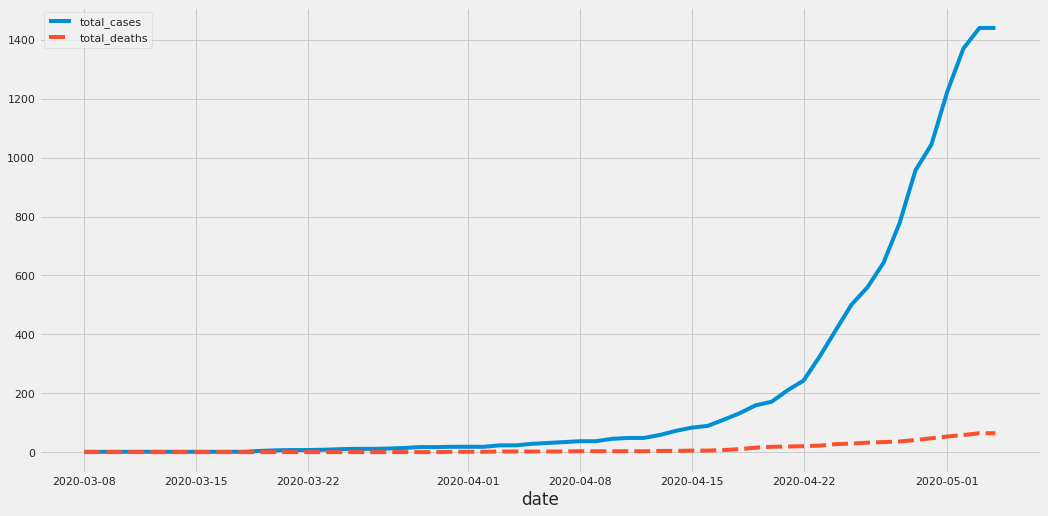

In [24]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

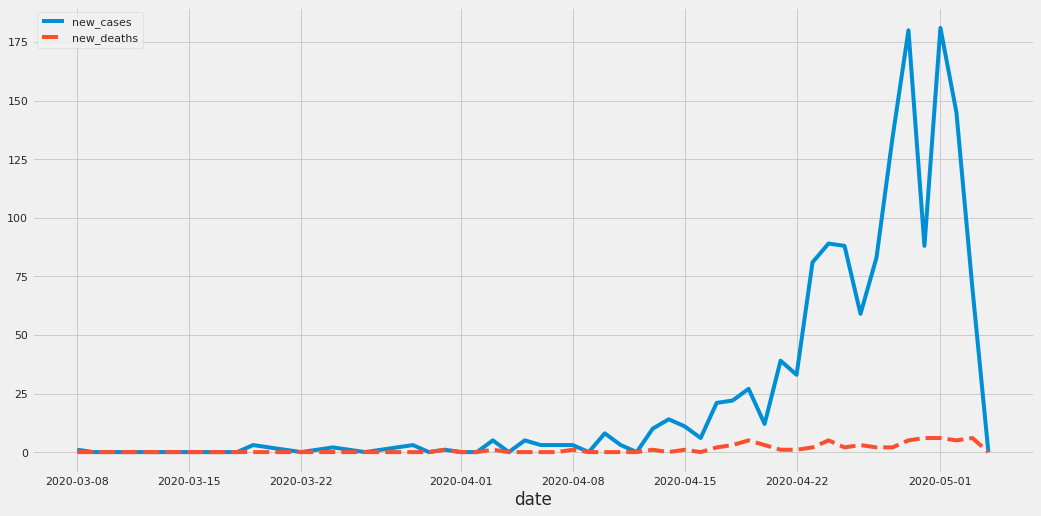

In [25]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [26]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-04-13 00:00:00')

In [27]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-04-13 00:00:00, population_size=3337357.0, initially_infected=870.0


Filtremos os dados a partir da data de interesse.

In [28]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [29]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [30]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [31]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [32]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [33]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [34]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [35]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [36]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [37]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [38]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [39]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [40]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

S           E     E_delta            I     I_delta  \
2020-04-13  3.336487e+06  870.000000    0.000000     0.000000    0.000000   
2020-04-14  3.336487e+06   87.000000    0.000000   783.000000  783.000000   
2020-04-15  3.335861e+06  634.936707  626.236707   626.400000   78.300000   
2020-04-16  3.335360e+06  564.389004  500.895333  1009.923036  571.443036   
2020-04-17  3.334552e+06  863.893845  807.454945  1214.896228  507.950103   

                     R     R_delta          E+I        E+I+R  
2020-04-13    0.000000    0.000000   870.000000   870.000000  
2020-04-14    0.000000    0.000000   870.000000   870.000000  
2020-04-15  234.900000  234.900000  1261.336707  1496.236707  
2020-04-16  422.820000  187.920000  1574.312040  1997.132040  
2020-04-17  725.796911  302.976911  2078.790073  2804.586984

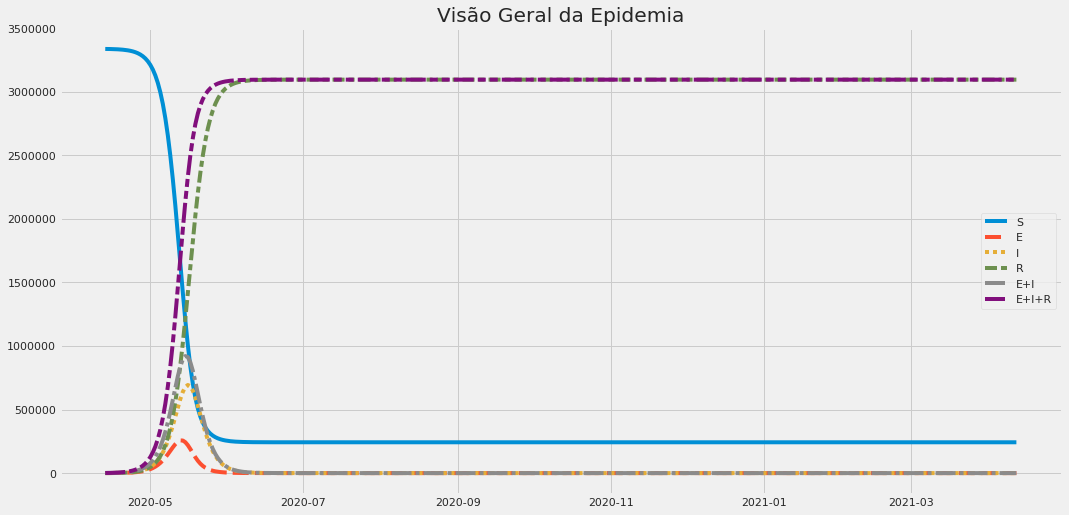

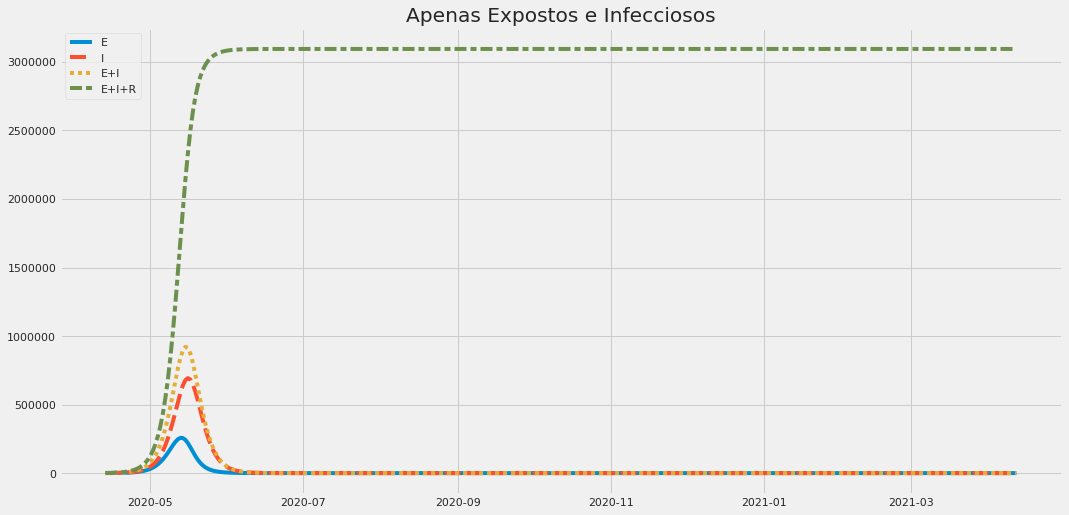

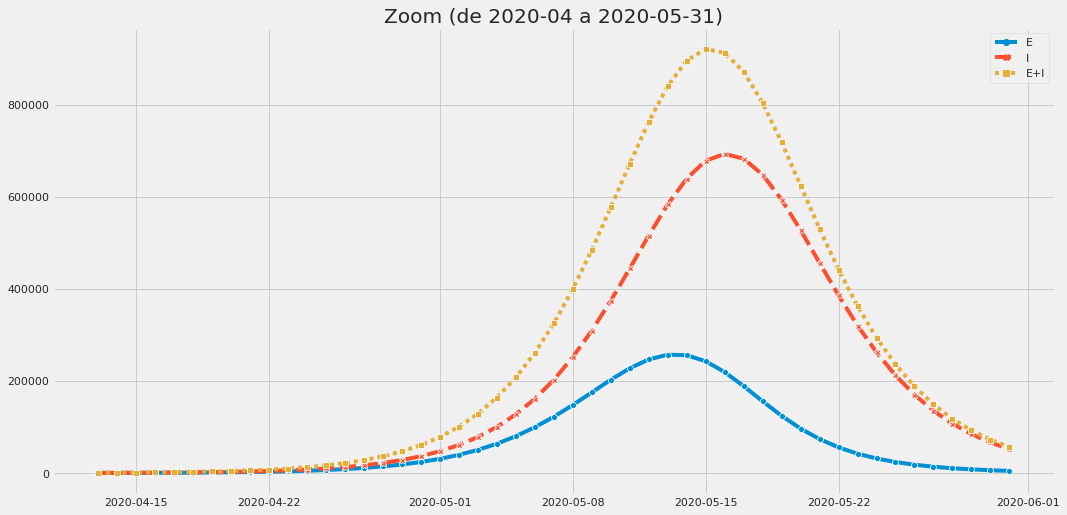

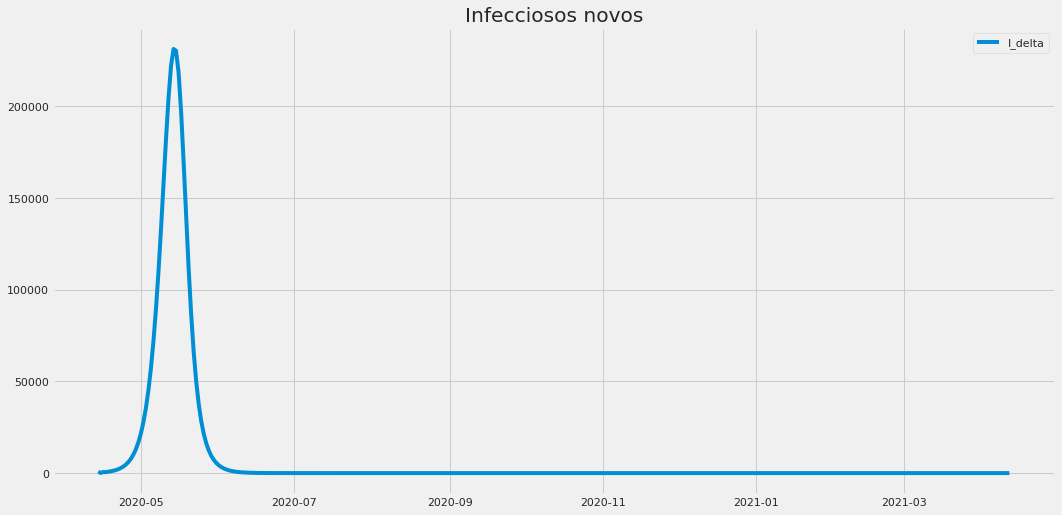

<Figure size 1152x576 with 0 Axes>

In [41]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

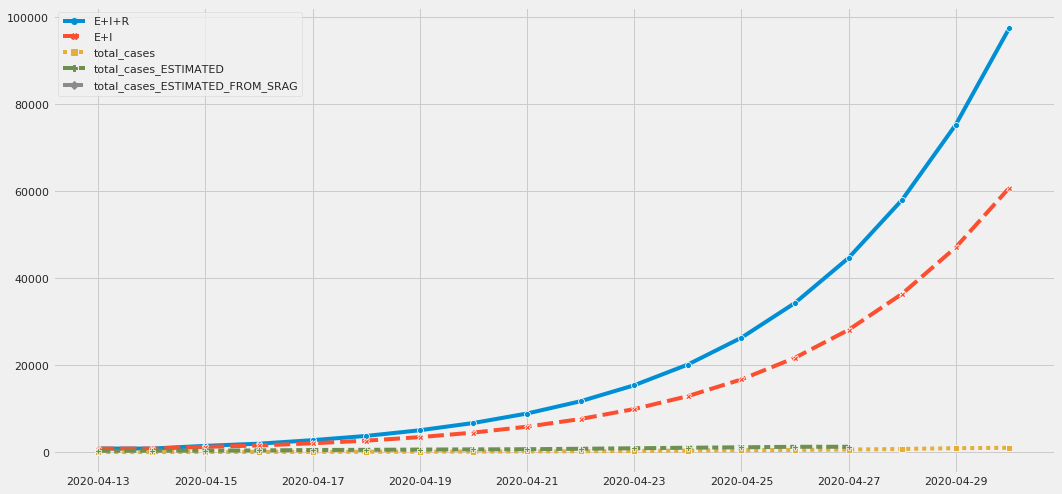

In [42]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [43]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

S           E     E_delta            I     I_delta  \
2020-04-13  3.336487e+06  870.000000    0.000000     0.000000    0.000000   
2020-04-14  3.336487e+06    0.000000    0.000000   870.000000  870.000000   
2020-04-15  3.335704e+06  782.795883  782.795883   522.000000    0.000000   
2020-04-16  3.335235e+06  469.567336  469.567336  1095.995883  782.795883   
2020-04-17  3.334249e+06  985.769005  985.769005  1127.164866  469.567336   

                     R     R_delta          E+I        E+I+R  
2020-04-13    0.000000    0.000000   870.000000   870.000000  
2020-04-14    0.000000    0.000000   870.000000   870.000000  
2020-04-15  348.000000  348.000000  1304.795883  1652.795883  
2020-04-16  556.800000  208.800000  1565.563219  2122.363219  
2020-04-17  995.198353  438.398353  2112.933871  3108.132224

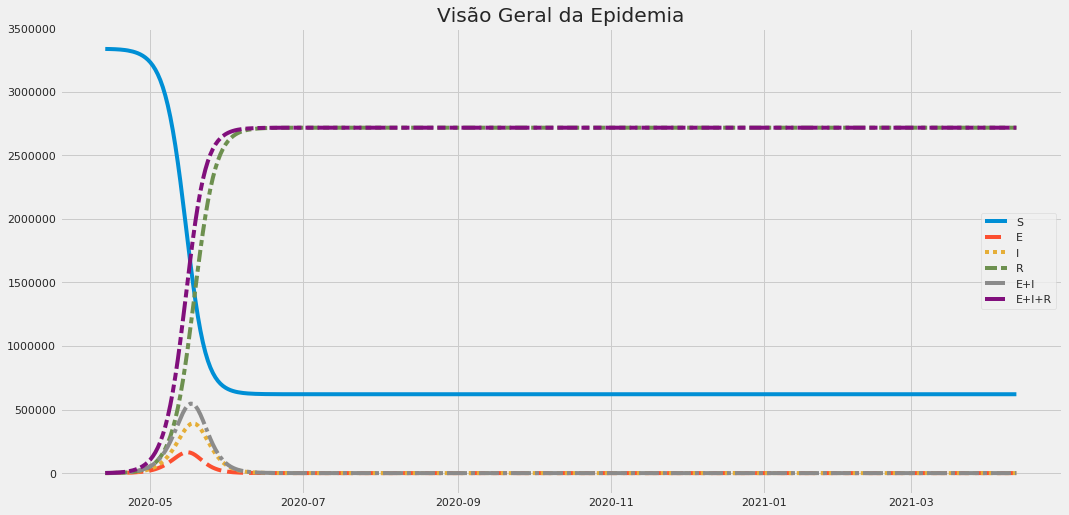

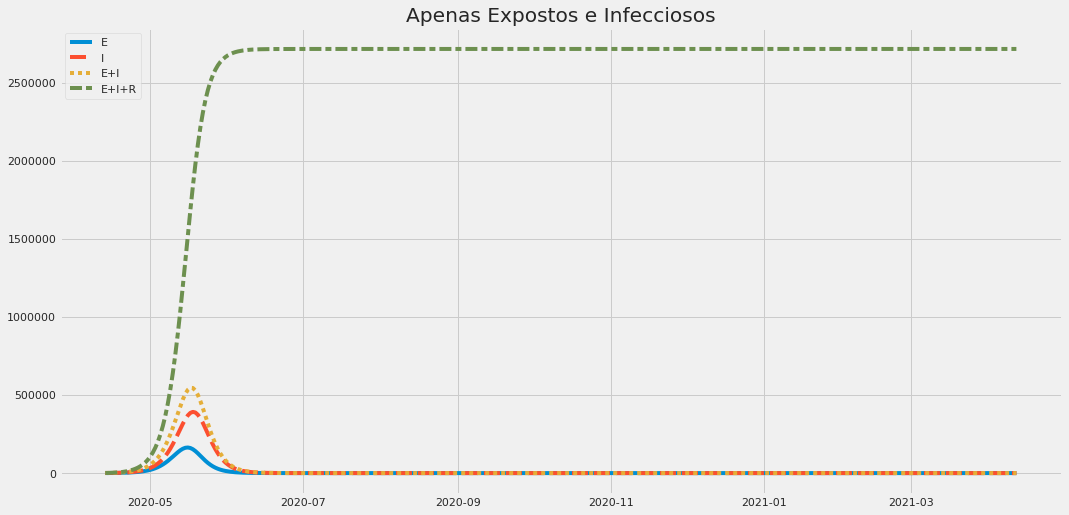

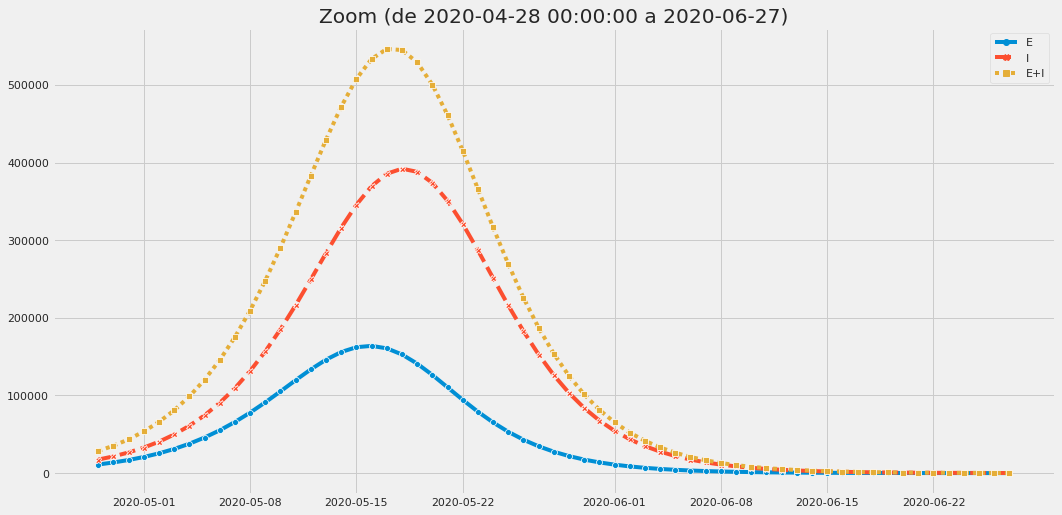

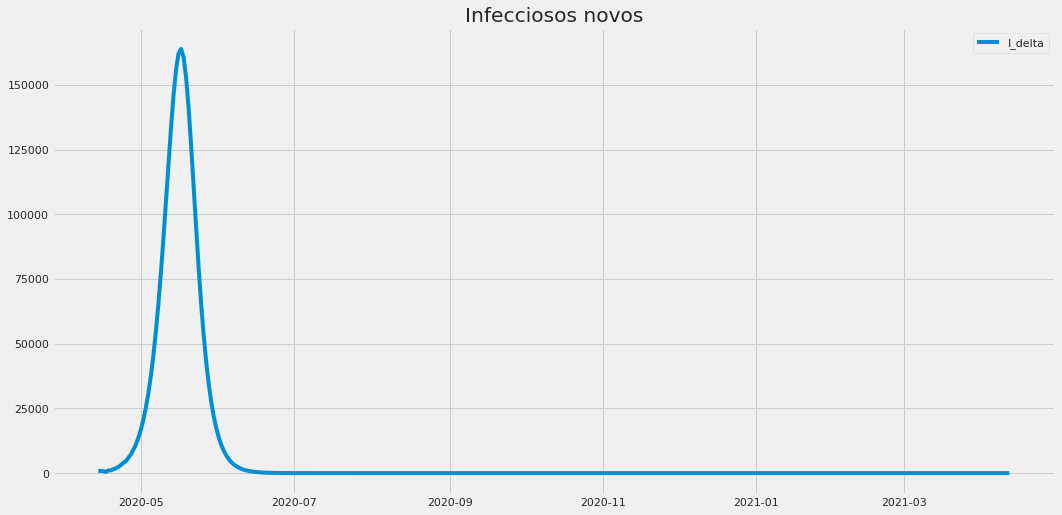

<Figure size 1152x576 with 0 Axes>

In [44]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

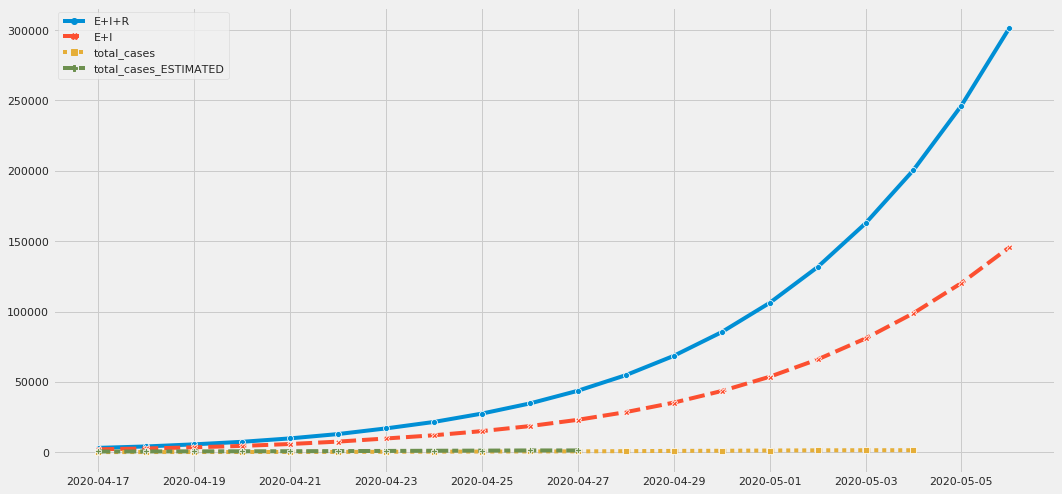

In [45]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [46]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [47]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

  1%|          | 12/1000 [00:00<00:08, 114.70trial/s, best loss: 723.0143559164702]

  2%|▏         | 23/1000 [00:00<00:08, 113.16trial/s, best loss: 723.0143559164702]

  3%|▎         | 31/1000 [00:00<00:09, 99.95trial/s, best loss: 723.0143559164702] 

  4%|▍         | 40/1000 [00:00<00:10, 95.73trial/s, best loss: 723.0143559164702]

  5%|▍         | 49/1000 [00:00<00:10, 91.46trial/s, best loss: 375.90455327213215]

  6%|▌         | 57/1000 [00:00<00:11, 81.05trial/s, best loss: 286.7636852905775] 

  7%|▋         | 66/1000 [00:00<00:11, 81.65trial/s, best loss: 286.7636852905775]

  8%|▊         | 75/1000 [00:00<00:11, 83.18trial/s, best loss: 190.99189002572513]

  8%|▊         | 84/1000 [00:00<00:11, 82.97trial/s, best loss: 190.99189002572513]

  9%|▉         | 93/1000 [00:01<00:10, 82.65trial/s, best loss: 190.99189002572513]

 10%|█         | 102/1000 [00:01<00:10, 83.48trial/s, best loss: 190.99189002572513]

 11%|█         | 111/1000 [00:01<00:10, 83.77trial/s, best loss: 190.99189002572513]

 12%|█▏        | 120/1000 [00:01<00:10, 83.29trial/s, best loss: 190.99189002572513]

 13%|█▎        | 129/1000 [00:01<00:10, 81.51trial/s, best loss: 190.99189002572513]

 14%|█▍        | 138/1000 [00:01<00:11, 78.03trial/s, best loss: 190.99189002572513]

 15%|█▍        | 147/1000 [00:01<00:10, 79.53trial/s, best loss: 190.99189002572513]

 16%|█▌        | 156/1000 [00:01<00:10, 79.79trial/s, best loss: 190.99189002572513]

 16%|█▋        | 164/1000 [00:01<00:10, 79.38trial/s, best loss: 190.99189002572513]

 17%|█▋        | 172/1000 [00:02<00:10, 78.99trial/s, best loss: 190.99189002572513]

 18%|█▊        | 180/1000 [00:02<00:10, 79.00trial/s, best loss: 190.99189002572513]

 19%|█▉        | 188/1000 [00:02<00:11, 72.93trial/s, best loss: 190.99189002572513]

 20%|█▉        | 196/1000 [00:02<00:11, 68.57trial/s, best loss: 190.99189002572513]

 20%|██        | 204/1000 [00:02<00:11, 69.52trial/s, best loss: 190.99189002572513]

 21%|██        | 212/1000 [00:02<00:10, 71.70trial/s, best loss: 190.99189002572513]

 22%|██▏       | 220/1000 [00:02<00:10, 73.85trial/s, best loss: 190.99189002572513]

 23%|██▎       | 228/1000 [00:02<00:10, 75.41trial/s, best loss: 190.99189002572513]

 24%|██▎       | 236/1000 [00:02<00:10, 75.77trial/s, best loss: 190.99189002572513]

 24%|██▍       | 244/1000 [00:03<00:09, 75.62trial/s, best loss: 190.99189002572513]

 25%|██▌       | 252/1000 [00:03<00:09, 75.80trial/s, best loss: 190.99189002572513]

 26%|██▌       | 260/1000 [00:03<00:09, 76.10trial/s, best loss: 190.99189002572513]

 27%|██▋       | 268/1000 [00:03<00:09, 76.07trial/s, best loss: 190.99189002572513]

 28%|██▊       | 276/1000 [00:03<00:09, 75.98trial/s, best loss: 190.99189002572513]

 28%|██▊       | 284/1000 [00:03<00:12, 56.23trial/s, best loss: 190.99189002572513]

 29%|██▉       | 291/1000 [00:03<00:13, 51.35trial/s, best loss: 190.99189002572513]

 30%|██▉       | 297/1000 [00:03<00:13, 50.76trial/s, best loss: 190.99189002572513]

 30%|███       | 304/1000 [00:04<00:12, 55.03trial/s, best loss: 190.99189002572513]

 31%|███       | 311/1000 [00:04<00:11, 58.24trial/s, best loss: 190.99189002572513]

 32%|███▏      | 318/1000 [00:04<00:11, 61.07trial/s, best loss: 190.99189002572513]

 33%|███▎      | 326/1000 [00:04<00:10, 63.82trial/s, best loss: 190.99189002572513]

 33%|███▎      | 333/1000 [00:04<00:11, 60.37trial/s, best loss: 190.99189002572513]

 34%|███▍      | 340/1000 [00:04<00:10, 61.67trial/s, best loss: 190.99189002572513]

 35%|███▍      | 347/1000 [00:04<00:11, 59.32trial/s, best loss: 190.99189002572513]

 35%|███▌      | 354/1000 [00:04<00:10, 60.96trial/s, best loss: 190.99189002572513]

 36%|███▌      | 361/1000 [00:04<00:10, 62.52trial/s, best loss: 190.99189002572513]

 37%|███▋      | 368/1000 [00:05<00:10, 62.71trial/s, best loss: 190.99189002572513]

 38%|███▊      | 375/1000 [00:05<00:09, 64.02trial/s, best loss: 190.99189002572513]

 38%|███▊      | 382/1000 [00:05<00:10, 56.53trial/s, best loss: 190.99189002572513]

 39%|███▉      | 389/1000 [00:05<00:10, 58.74trial/s, best loss: 190.99189002572513]

 40%|███▉      | 396/1000 [00:05<00:10, 59.28trial/s, best loss: 190.99189002572513]

 40%|████      | 403/1000 [00:05<00:09, 60.90trial/s, best loss: 190.99189002572513]

 41%|████      | 410/1000 [00:05<00:09, 61.32trial/s, best loss: 190.99189002572513]

 42%|████▏     | 417/1000 [00:05<00:09, 62.39trial/s, best loss: 190.99189002572513]

 42%|████▏     | 424/1000 [00:06<00:09, 62.08trial/s, best loss: 190.99189002572513]

 43%|████▎     | 431/1000 [00:06<00:09, 62.44trial/s, best loss: 190.99189002572513]

 44%|████▍     | 438/1000 [00:06<00:08, 63.06trial/s, best loss: 190.99189002572513]

 44%|████▍     | 445/1000 [00:06<00:08, 63.25trial/s, best loss: 190.99189002572513]

 45%|████▌     | 452/1000 [00:06<00:08, 62.39trial/s, best loss: 190.99189002572513]

 46%|████▌     | 459/1000 [00:06<00:08, 61.03trial/s, best loss: 190.99189002572513]

 47%|████▋     | 466/1000 [00:06<00:08, 60.74trial/s, best loss: 190.99189002572513]

 47%|████▋     | 473/1000 [00:06<00:08, 60.80trial/s, best loss: 190.99189002572513]

 48%|████▊     | 480/1000 [00:06<00:08, 60.25trial/s, best loss: 190.99189002572513]

 49%|████▊     | 487/1000 [00:07<00:08, 60.03trial/s, best loss: 190.99189002572513]

 49%|████▉     | 494/1000 [00:07<00:08, 60.10trial/s, best loss: 190.99189002572513]

 50%|█████     | 501/1000 [00:07<00:08, 60.15trial/s, best loss: 190.99189002572513]

 51%|█████     | 508/1000 [00:07<00:08, 59.74trial/s, best loss: 190.99189002572513]

 51%|█████▏    | 514/1000 [00:07<00:08, 58.61trial/s, best loss: 190.99189002572513]

 52%|█████▏    | 520/1000 [00:07<00:08, 58.71trial/s, best loss: 190.99189002572513]

 53%|█████▎    | 526/1000 [00:07<00:08, 58.60trial/s, best loss: 190.99189002572513]

 53%|█████▎    | 532/1000 [00:07<00:07, 58.64trial/s, best loss: 190.99189002572513]

 54%|█████▍    | 538/1000 [00:07<00:07, 58.25trial/s, best loss: 190.99189002572513]

 54%|█████▍    | 544/1000 [00:08<00:07, 58.52trial/s, best loss: 190.99189002572513]

 55%|█████▌    | 550/1000 [00:08<00:07, 58.14trial/s, best loss: 190.99189002572513]

 56%|█████▌    | 556/1000 [00:08<00:07, 57.98trial/s, best loss: 190.99189002572513]

 56%|█████▌    | 562/1000 [00:08<00:07, 58.37trial/s, best loss: 190.99189002572513]

 57%|█████▋    | 568/1000 [00:08<00:07, 57.85trial/s, best loss: 190.99189002572513]

 57%|█████▋    | 574/1000 [00:08<00:07, 54.57trial/s, best loss: 190.99189002572513]

 58%|█████▊    | 580/1000 [00:08<00:07, 52.76trial/s, best loss: 190.99189002572513]

 59%|█████▊    | 586/1000 [00:08<00:08, 48.32trial/s, best loss: 190.99189002572513]

 59%|█████▉    | 592/1000 [00:08<00:08, 50.49trial/s, best loss: 190.99189002572513]

 60%|█████▉    | 598/1000 [00:09<00:07, 51.68trial/s, best loss: 190.99189002572513]

 60%|██████    | 604/1000 [00:09<00:07, 53.54trial/s, best loss: 190.99189002572513]

 61%|██████    | 610/1000 [00:09<00:07, 54.90trial/s, best loss: 190.99189002572513]

 62%|██████▏   | 616/1000 [00:09<00:06, 55.76trial/s, best loss: 190.99189002572513]

 62%|██████▏   | 622/1000 [00:09<00:06, 56.30trial/s, best loss: 190.99189002572513]

 63%|██████▎   | 628/1000 [00:09<00:06, 54.25trial/s, best loss: 190.99189002572513]

 63%|██████▎   | 634/1000 [00:09<00:06, 54.68trial/s, best loss: 190.99189002572513]

 64%|██████▍   | 640/1000 [00:09<00:06, 55.25trial/s, best loss: 190.99189002572513]

 65%|██████▍   | 646/1000 [00:09<00:06, 55.62trial/s, best loss: 190.99189002572513]

 65%|██████▌   | 652/1000 [00:10<00:06, 55.42trial/s, best loss: 190.99189002572513]

 66%|██████▌   | 658/1000 [00:10<00:06, 55.12trial/s, best loss: 190.99189002572513]

 66%|██████▋   | 664/1000 [00:10<00:06, 55.55trial/s, best loss: 190.99189002572513]

 67%|██████▋   | 670/1000 [00:10<00:06, 54.15trial/s, best loss: 190.99189002572513]

 68%|██████▊   | 676/1000 [00:10<00:06, 52.79trial/s, best loss: 190.99189002572513]

 68%|██████▊   | 682/1000 [00:10<00:06, 51.93trial/s, best loss: 190.99189002572513]

 69%|██████▉   | 688/1000 [00:10<00:05, 52.61trial/s, best loss: 190.99189002572513]

 69%|██████▉   | 694/1000 [00:10<00:05, 53.06trial/s, best loss: 190.99189002572513]

 70%|███████   | 700/1000 [00:10<00:05, 52.77trial/s, best loss: 190.99189002572513]

 71%|███████   | 706/1000 [00:11<00:05, 52.66trial/s, best loss: 190.99189002572513]

 71%|███████   | 712/1000 [00:11<00:05, 52.45trial/s, best loss: 177.74045763698754]

 72%|███████▏  | 718/1000 [00:11<00:05, 47.46trial/s, best loss: 177.74045763698754]

 72%|███████▏  | 724/1000 [00:11<00:05, 49.12trial/s, best loss: 177.74045763698754]

 73%|███████▎  | 730/1000 [00:11<00:05, 49.48trial/s, best loss: 177.74045763698754]

 74%|███████▎  | 736/1000 [00:11<00:05, 50.35trial/s, best loss: 177.74045763698754]

 74%|███████▍  | 742/1000 [00:11<00:05, 50.82trial/s, best loss: 177.74045763698754]

 75%|███████▍  | 748/1000 [00:11<00:04, 51.63trial/s, best loss: 177.74045763698754]

 75%|███████▌  | 754/1000 [00:11<00:04, 52.33trial/s, best loss: 177.74045763698754]

 76%|███████▌  | 760/1000 [00:12<00:04, 52.05trial/s, best loss: 177.74045763698754]

 77%|███████▋  | 766/1000 [00:12<00:04, 52.51trial/s, best loss: 177.74045763698754]

 77%|███████▋  | 772/1000 [00:12<00:04, 52.84trial/s, best loss: 177.74045763698754]

 78%|███████▊  | 778/1000 [00:12<00:04, 52.89trial/s, best loss: 177.74045763698754]

 78%|███████▊  | 784/1000 [00:12<00:04, 51.18trial/s, best loss: 177.74045763698754]

 79%|███████▉  | 790/1000 [00:12<00:04, 51.43trial/s, best loss: 177.74045763698754]

 80%|███████▉  | 796/1000 [00:12<00:03, 51.61trial/s, best loss: 177.74045763698754]

 80%|████████  | 802/1000 [00:12<00:03, 51.69trial/s, best loss: 177.74045763698754]

 81%|████████  | 808/1000 [00:13<00:03, 51.99trial/s, best loss: 177.74045763698754]

 81%|████████▏ | 814/1000 [00:13<00:03, 51.60trial/s, best loss: 177.74045763698754]

 82%|████████▏ | 820/1000 [00:13<00:03, 51.70trial/s, best loss: 177.74045763698754]

 83%|████████▎ | 826/1000 [00:13<00:03, 52.02trial/s, best loss: 177.74045763698754]

 83%|████████▎ | 832/1000 [00:13<00:03, 51.71trial/s, best loss: 177.74045763698754]

 84%|████████▍ | 838/1000 [00:13<00:03, 50.86trial/s, best loss: 177.74045763698754]

 84%|████████▍ | 844/1000 [00:13<00:03, 51.07trial/s, best loss: 177.74045763698754]

 85%|████████▌ | 850/1000 [00:13<00:02, 51.00trial/s, best loss: 177.74045763698754]

 86%|████████▌ | 856/1000 [00:14<00:03, 45.82trial/s, best loss: 177.74045763698754]

 86%|████████▌ | 862/1000 [00:14<00:02, 47.05trial/s, best loss: 177.74045763698754]

 87%|████████▋ | 868/1000 [00:14<00:02, 48.18trial/s, best loss: 177.74045763698754]

 87%|████████▋ | 874/1000 [00:14<00:02, 48.98trial/s, best loss: 177.74045763698754]

 88%|████████▊ | 880/1000 [00:14<00:02, 49.55trial/s, best loss: 177.74045763698754]

 88%|████████▊ | 885/1000 [00:14<00:02, 48.00trial/s, best loss: 177.74045763698754]

 89%|████████▉ | 890/1000 [00:14<00:02, 48.11trial/s, best loss: 177.74045763698754]

 90%|████████▉ | 895/1000 [00:14<00:02, 48.24trial/s, best loss: 177.74045763698754]

 90%|█████████ | 900/1000 [00:14<00:02, 48.50trial/s, best loss: 177.74045763698754]

 90%|█████████ | 905/1000 [00:15<00:01, 48.41trial/s, best loss: 177.74045763698754]

 91%|█████████ | 910/1000 [00:15<00:01, 48.23trial/s, best loss: 177.74045763698754]

 92%|█████████▏| 915/1000 [00:15<00:01, 48.70trial/s, best loss: 177.74045763698754]

 92%|█████████▏| 920/1000 [00:15<00:01, 48.89trial/s, best loss: 177.74045763698754]

 92%|█████████▎| 925/1000 [00:15<00:01, 49.18trial/s, best loss: 177.74045763698754]

 93%|█████████▎| 930/1000 [00:15<00:01, 46.63trial/s, best loss: 177.74045763698754]

 94%|█████████▎| 935/1000 [00:15<00:01, 47.38trial/s, best loss: 177.74045763698754]

 94%|█████████▍| 940/1000 [00:15<00:01, 47.50trial/s, best loss: 177.74045763698754]

 94%|█████████▍| 945/1000 [00:15<00:01, 47.52trial/s, best loss: 177.74045763698754]

 95%|█████████▌| 950/1000 [00:15<00:01, 47.15trial/s, best loss: 177.74045763698754]

 96%|█████████▌| 955/1000 [00:16<00:00, 47.21trial/s, best loss: 177.74045763698754]

 96%|█████████▌| 960/1000 [00:16<00:00, 47.40trial/s, best loss: 177.74045763698754]

 96%|█████████▋| 965/1000 [00:16<00:00, 47.47trial/s, best loss: 177.74045763698754]

 97%|█████████▋| 970/1000 [00:16<00:00, 46.74trial/s, best loss: 177.74045763698754]

 98%|█████████▊| 975/1000 [00:16<00:00, 47.04trial/s, best loss: 177.74045763698754]

 98%|█████████▊| 980/1000 [00:16<00:00, 45.00trial/s, best loss: 177.74045763698754]

 98%|█████████▊| 985/1000 [00:16<00:00, 45.98trial/s, best loss: 177.74045763698754]

 99%|█████████▉| 990/1000 [00:16<00:00, 46.65trial/s, best loss: 177.74045763698754]

100%|█████████▉| 995/1000 [00:16<00:00, 45.57trial/s, best loss: 177.74045763698754]

100%|██████████| 1000/1000 [00:17<00:00, 43.50trial/s, best loss: 177.74045763698754]

100%|██████████| 1000/1000 [00:17<00:00, 58.59trial/s, best loss: 177.74045763698754]


Best parameters found: {'alpha': 0.9991051141170001, 'beta': 0.27430433021130396, 'gamma': 0.040393766854530215}


In [48]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

S           E     E_delta            I     I_delta  \
2020-04-13  3.336487e+06  870.000000    0.000000     0.000000    0.000000   
2020-04-14  3.336487e+06    0.778551    0.000000   869.221449  869.221449   
2020-04-15  3.336249e+06  238.369749  238.369052   834.888175    0.777854   
2020-04-16  3.336020e+06  229.150698  228.937384  1039.320331  238.156435   
2020-04-17  3.335735e+06  285.180893  284.975829  1226.283902  228.945634   

                     R    R_delta          E+I        E+I+R  
2020-04-13    0.000000   0.000000   870.000000   870.000000  
2020-04-14    0.000000   0.000000   870.000000   870.000000  
2020-04-15   35.111129  35.111129  1073.257923  1108.369052  
2020-04-16   68.835407  33.724278  1268.471029  1337.306436  
2020-04-17  110.817470  41.982063  1511.464795  1622.282265

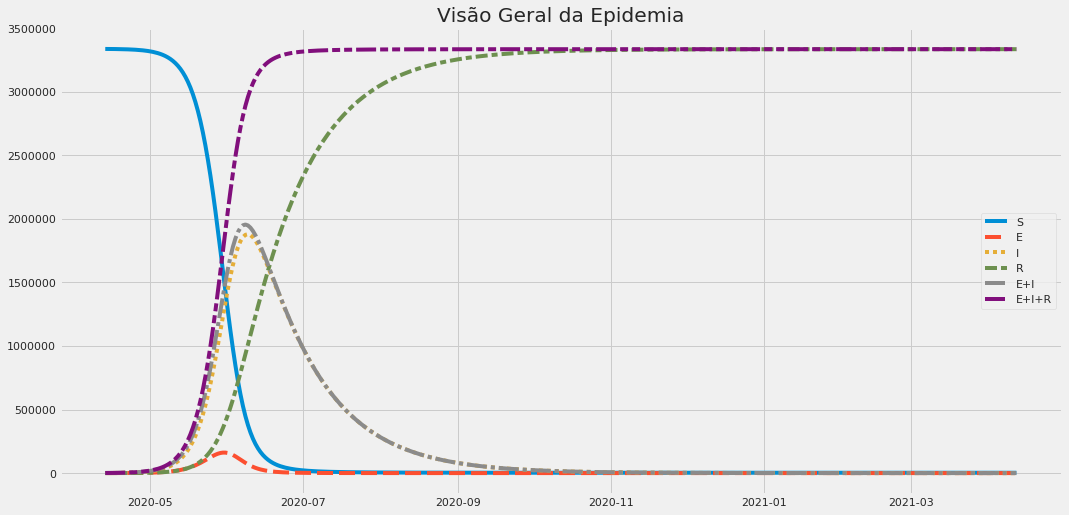

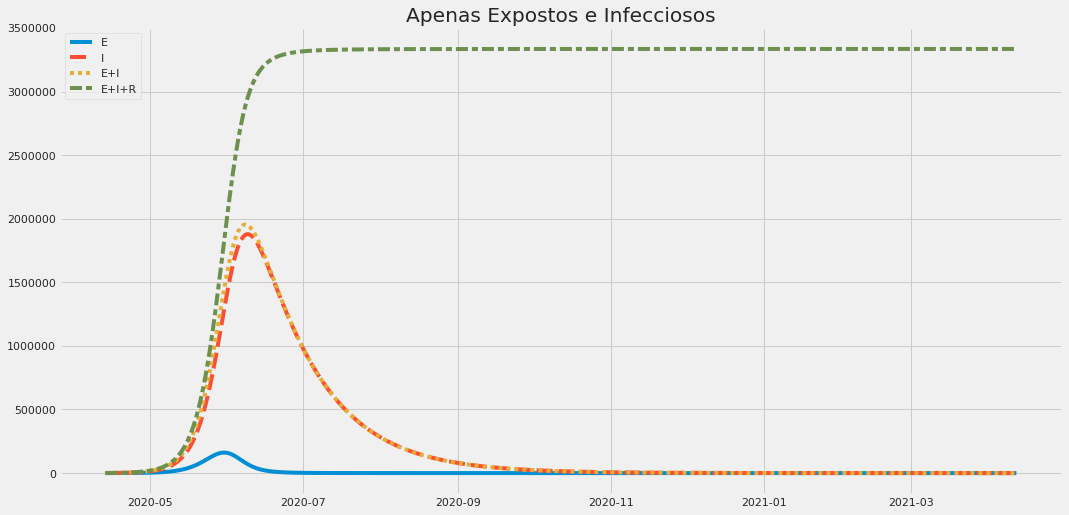

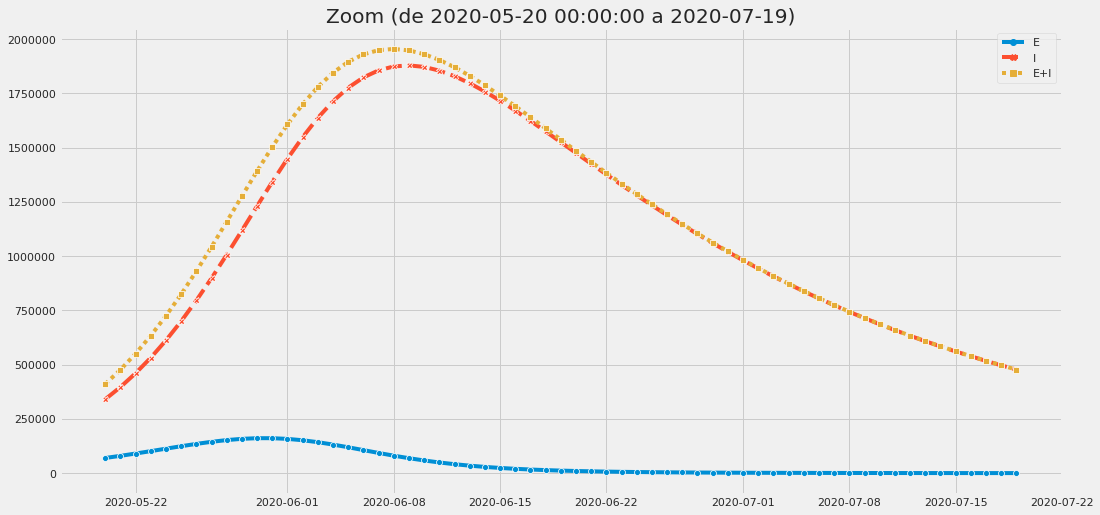

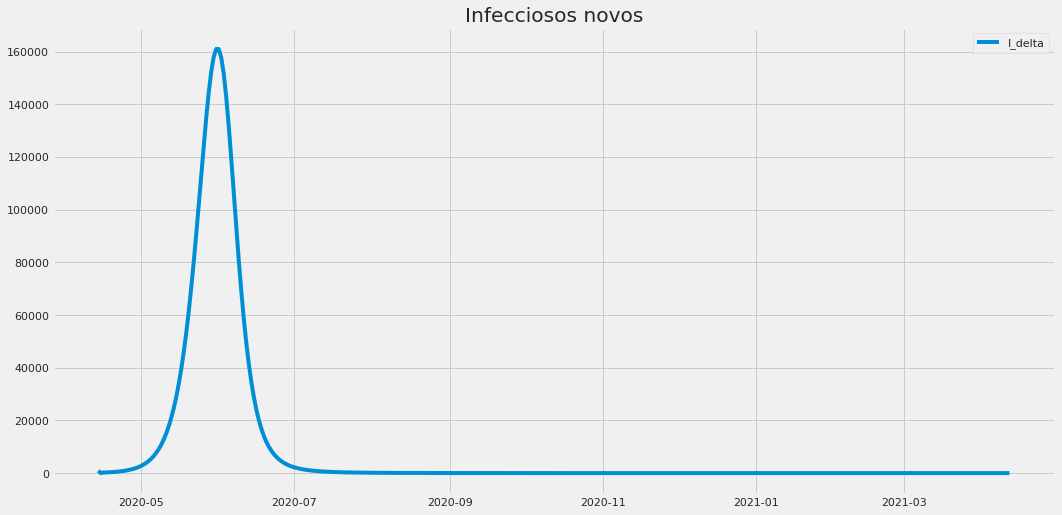

<Figure size 1152x576 with 0 Axes>

In [49]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [50]:
df_data_target.tail()

new_cases  new_deaths  total_cases  total_deaths  population  \
date                                                                       
2020-04-30         88           6         1045            47   3337357.0   
2020-05-01        181           6         1226            53   3337357.0   
2020-05-02        145           5         1371            58   3337357.0   
2020-05-03         70           6         1441            64   3337357.0   
2020-05-04          0           0         1441            64   3337357.0   

            total_cases_ESTIMATED  total_cases_ESTIMATED_2  \
date                                                         
2020-04-30                    NaN                    15675   
2020-05-01                    NaN                    18390   
2020-05-02                    NaN                    20565   
2020-05-03                    NaN                    21615   
2020-05-04                    NaN                    21615   

            total_cases_ESTIMATED_FROM_SRAG  
date                                         
2020-04-30                              NaN  
2020-05-01                              NaN  
2020-05-02                              NaN  
2020-05-03                              NaN  
2020-05-04                              NaN

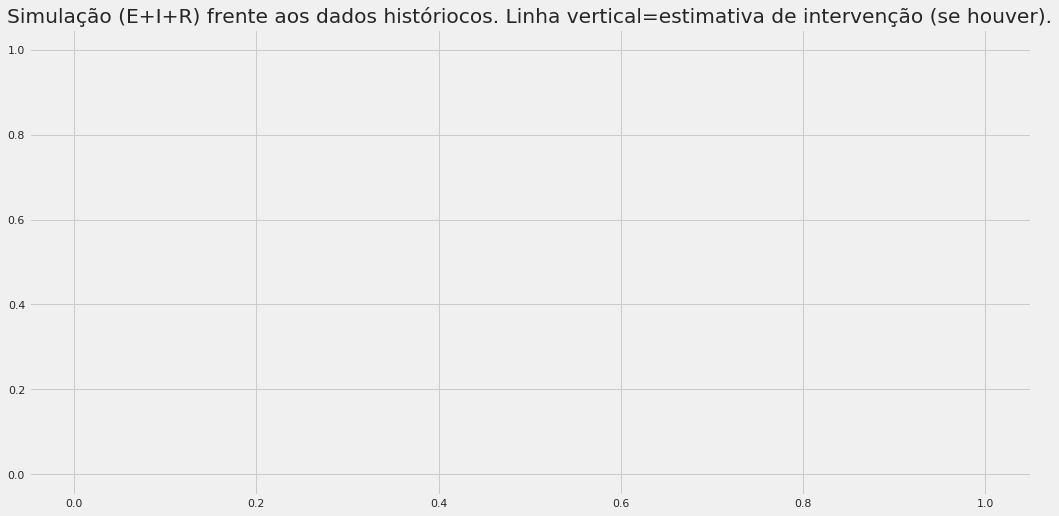

In [51]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [52]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [53]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 10/3000 [00:00<00:32, 93.37trial/s, best loss: 1043.7927285438973]

  1%|          | 19/3000 [00:00<00:32, 90.87trial/s, best loss: 1043.7927285438973]

  1%|          | 25/3000 [00:00<00:39, 75.41trial/s, best loss: 1043.7927285438973]

  1%|          | 30/3000 [00:00<00:50, 59.35trial/s, best loss: 1043.7927285438973]

  1%|          | 35/3000 [00:00<00:59, 49.69trial/s, best loss: 1043.7927285438973]

  1%|▏         | 40/3000 [00:00<00:59, 49.47trial/s, best loss: 1043.7927285438973]

  2%|▏         | 45/3000 [00:00<01:00, 49.14trial/s, best loss: 709.9165044064779] 

  2%|▏         | 50/3000 [00:00<01:00, 48.86trial/s, best loss: 709.9165044064779]

  2%|▏         | 55/3000 [00:00<01:00, 48.98trial/s, best loss: 709.9165044064779]

  2%|▏         | 60/3000 [00:01<01:08, 42.68trial/s, best loss: 709.9165044064779]

  2%|▏         | 65/3000 [00:01<01:09, 42.09trial/s, best loss: 709.9165044064779]

  2%|▏         | 70/3000 [00:01<01:07, 43.45trial/s, best loss: 709.9165044064779]

  2%|▎         | 75/3000 [00:01<01:08, 42.93trial/s, best loss: 709.9165044064779]

  3%|▎         | 80/3000 [00:01<01:06, 43.65trial/s, best loss: 709.9165044064779]

  3%|▎         | 85/3000 [00:01<01:05, 44.19trial/s, best loss: 709.9165044064779]

  3%|▎         | 90/3000 [00:01<01:05, 44.59trial/s, best loss: 709.9165044064779]

  3%|▎         | 95/3000 [00:01<01:04, 45.20trial/s, best loss: 709.9165044064779]

  3%|▎         | 100/3000 [00:02<01:04, 44.63trial/s, best loss: 709.9165044064779]

  4%|▎         | 105/3000 [00:02<01:11, 40.57trial/s, best loss: 709.9165044064779]

  4%|▎         | 110/3000 [00:02<01:08, 42.00trial/s, best loss: 709.9165044064779]

  4%|▍         | 115/3000 [00:02<01:07, 42.90trial/s, best loss: 709.9165044064779]

  4%|▍         | 120/3000 [00:02<01:06, 43.60trial/s, best loss: 709.9165044064779]

  4%|▍         | 125/3000 [00:02<01:05, 43.85trial/s, best loss: 709.9165044064779]

  4%|▍         | 130/3000 [00:02<01:06, 43.31trial/s, best loss: 709.9165044064779]

  4%|▍         | 135/3000 [00:02<01:06, 43.18trial/s, best loss: 709.9165044064779]

  5%|▍         | 140/3000 [00:02<01:05, 43.42trial/s, best loss: 709.9165044064779]

  5%|▍         | 145/3000 [00:03<01:05, 43.43trial/s, best loss: 709.9165044064779]

  5%|▌         | 150/3000 [00:03<01:06, 42.61trial/s, best loss: 709.9165044064779]

  5%|▌         | 155/3000 [00:03<01:14, 38.42trial/s, best loss: 709.9165044064779]

  5%|▌         | 160/3000 [00:03<01:11, 39.59trial/s, best loss: 709.9165044064779]

  6%|▌         | 165/3000 [00:03<01:10, 40.32trial/s, best loss: 709.9165044064779]

  6%|▌         | 170/3000 [00:03<01:12, 39.27trial/s, best loss: 709.9165044064779]

  6%|▌         | 174/3000 [00:03<01:13, 38.23trial/s, best loss: 709.9165044064779]

  6%|▌         | 179/3000 [00:03<01:11, 39.18trial/s, best loss: 709.9165044064779]

  6%|▌         | 184/3000 [00:04<01:10, 39.79trial/s, best loss: 709.9165044064779]

  6%|▋         | 189/3000 [00:04<01:11, 39.42trial/s, best loss: 709.9165044064779]

  6%|▋         | 194/3000 [00:04<01:09, 40.11trial/s, best loss: 709.9165044064779]

  7%|▋         | 199/3000 [00:04<01:09, 40.51trial/s, best loss: 709.9165044064779]

  7%|▋         | 204/3000 [00:04<01:08, 40.69trial/s, best loss: 709.9165044064779]

  7%|▋         | 209/3000 [00:04<01:08, 40.61trial/s, best loss: 709.9165044064779]

  7%|▋         | 214/3000 [00:04<01:08, 40.88trial/s, best loss: 709.9165044064779]

  7%|▋         | 219/3000 [00:04<01:07, 41.04trial/s, best loss: 709.9165044064779]

  7%|▋         | 224/3000 [00:05<01:07, 41.07trial/s, best loss: 709.9165044064779]

  8%|▊         | 229/3000 [00:05<01:10, 39.43trial/s, best loss: 709.9165044064779]

  8%|▊         | 234/3000 [00:05<01:09, 39.65trial/s, best loss: 709.9165044064779]

  8%|▊         | 239/3000 [00:05<01:09, 39.86trial/s, best loss: 709.9165044064779]

  8%|▊         | 243/3000 [00:05<01:10, 39.00trial/s, best loss: 709.9165044064779]

  8%|▊         | 247/3000 [00:05<01:14, 37.18trial/s, best loss: 709.9165044064779]

  8%|▊         | 251/3000 [00:05<01:13, 37.53trial/s, best loss: 709.9165044064779]

  8%|▊         | 255/3000 [00:05<01:12, 38.09trial/s, best loss: 709.9165044064779]

  9%|▊         | 259/3000 [00:06<01:11, 38.29trial/s, best loss: 709.9165044064779]

  9%|▉         | 263/3000 [00:06<01:11, 38.44trial/s, best loss: 709.9165044064779]

  9%|▉         | 267/3000 [00:06<01:12, 37.56trial/s, best loss: 709.9165044064779]

  9%|▉         | 271/3000 [00:06<01:12, 37.78trial/s, best loss: 709.9165044064779]

  9%|▉         | 275/3000 [00:06<01:14, 36.37trial/s, best loss: 709.9165044064779]

  9%|▉         | 279/3000 [00:06<01:13, 36.84trial/s, best loss: 709.9165044064779]

  9%|▉         | 283/3000 [00:06<01:13, 37.06trial/s, best loss: 687.3352231247003]

 10%|▉         | 287/3000 [00:06<01:13, 36.81trial/s, best loss: 687.3352231247003]

 10%|▉         | 291/3000 [00:06<01:12, 37.25trial/s, best loss: 687.3352231247003]

 10%|▉         | 295/3000 [00:06<01:12, 37.51trial/s, best loss: 687.3352231247003]

 10%|▉         | 299/3000 [00:07<01:11, 37.53trial/s, best loss: 687.3352231247003]

 10%|█         | 303/3000 [00:07<01:13, 36.70trial/s, best loss: 687.3352231247003]

 10%|█         | 307/3000 [00:07<01:13, 36.65trial/s, best loss: 687.3352231247003]

 10%|█         | 311/3000 [00:07<01:13, 36.65trial/s, best loss: 687.3352231247003]

 10%|█         | 315/3000 [00:07<01:13, 36.38trial/s, best loss: 687.3352231247003]

 11%|█         | 319/3000 [00:07<01:14, 35.82trial/s, best loss: 687.3352231247003]

 11%|█         | 323/3000 [00:07<01:23, 32.24trial/s, best loss: 687.3352231247003]

 11%|█         | 327/3000 [00:07<01:19, 33.57trial/s, best loss: 687.3352231247003]

 11%|█         | 331/3000 [00:08<01:17, 34.62trial/s, best loss: 687.3352231247003]

 11%|█         | 335/3000 [00:08<01:16, 35.02trial/s, best loss: 687.3352231247003]

 11%|█▏        | 339/3000 [00:08<01:16, 34.83trial/s, best loss: 687.3352231247003]

 11%|█▏        | 343/3000 [00:08<01:15, 35.17trial/s, best loss: 687.3352231247003]

 12%|█▏        | 347/3000 [00:08<01:15, 35.04trial/s, best loss: 687.3352231247003]

 12%|█▏        | 351/3000 [00:08<01:17, 34.26trial/s, best loss: 687.3352231247003]

 12%|█▏        | 355/3000 [00:08<01:19, 33.32trial/s, best loss: 687.3352231247003]

 12%|█▏        | 359/3000 [00:08<01:20, 32.97trial/s, best loss: 687.3352231247003]

 12%|█▏        | 363/3000 [00:08<01:20, 32.70trial/s, best loss: 687.3352231247003]

 12%|█▏        | 367/3000 [00:09<01:20, 32.63trial/s, best loss: 687.3352231247003]

 12%|█▏        | 371/3000 [00:09<01:23, 31.64trial/s, best loss: 687.3352231247003]

 12%|█▎        | 375/3000 [00:09<01:25, 30.70trial/s, best loss: 687.3352231247003]

 13%|█▎        | 379/3000 [00:09<01:24, 31.03trial/s, best loss: 687.3352231247003]

 13%|█▎        | 383/3000 [00:09<01:23, 31.29trial/s, best loss: 687.3352231247003]

 13%|█▎        | 387/3000 [00:09<01:23, 31.30trial/s, best loss: 687.3352231247003]

 13%|█▎        | 391/3000 [00:09<01:32, 28.29trial/s, best loss: 687.3352231247003]

 13%|█▎        | 395/3000 [00:10<01:29, 29.14trial/s, best loss: 687.3352231247003]

 13%|█▎        | 399/3000 [00:10<01:31, 28.30trial/s, best loss: 687.3352231247003]

 13%|█▎        | 403/3000 [00:10<01:28, 29.25trial/s, best loss: 617.5465496987003]

 14%|█▎        | 407/3000 [00:10<01:27, 29.80trial/s, best loss: 617.5465496987003]

 14%|█▎        | 411/3000 [00:10<01:26, 30.07trial/s, best loss: 617.5465496987003]

 14%|█▍        | 415/3000 [00:10<01:25, 30.15trial/s, best loss: 617.5465496987003]

 14%|█▍        | 419/3000 [00:10<01:25, 30.07trial/s, best loss: 617.5465496987003]

 14%|█▍        | 423/3000 [00:10<01:25, 30.23trial/s, best loss: 617.5465496987003]

 14%|█▍        | 427/3000 [00:11<01:24, 30.40trial/s, best loss: 617.5465496987003]

 14%|█▍        | 431/3000 [00:11<01:25, 29.91trial/s, best loss: 617.5465496987003]

 14%|█▍        | 434/3000 [00:11<01:25, 29.92trial/s, best loss: 617.5465496987003]

 15%|█▍        | 437/3000 [00:11<01:25, 29.85trial/s, best loss: 617.5465496987003]

 15%|█▍        | 441/3000 [00:11<01:25, 29.92trial/s, best loss: 617.5465496987003]

 15%|█▍        | 445/3000 [00:11<01:25, 30.01trial/s, best loss: 617.5465496987003]

 15%|█▍        | 449/3000 [00:11<01:24, 30.07trial/s, best loss: 617.5465496987003]

 15%|█▌        | 453/3000 [00:12<01:29, 28.42trial/s, best loss: 617.5465496987003]

 15%|█▌        | 457/3000 [00:12<01:27, 29.02trial/s, best loss: 617.5465496987003]

 15%|█▌        | 460/3000 [00:12<01:27, 28.97trial/s, best loss: 617.5465496987003]

 15%|█▌        | 463/3000 [00:12<01:26, 29.24trial/s, best loss: 617.5465496987003]

 16%|█▌        | 467/3000 [00:12<01:25, 29.60trial/s, best loss: 617.5465496987003]

 16%|█▌        | 470/3000 [00:12<01:31, 27.59trial/s, best loss: 617.5465496987003]

 16%|█▌        | 473/3000 [00:12<01:29, 28.14trial/s, best loss: 617.5465496987003]

 16%|█▌        | 476/3000 [00:12<01:28, 28.43trial/s, best loss: 608.5472903965866]

 16%|█▌        | 479/3000 [00:12<01:27, 28.73trial/s, best loss: 608.5472903965866]

 16%|█▌        | 482/3000 [00:13<01:27, 28.71trial/s, best loss: 608.5472903965866]

 16%|█▌        | 485/3000 [00:13<01:27, 28.74trial/s, best loss: 608.5472903965866]

 16%|█▋        | 488/3000 [00:13<01:29, 28.14trial/s, best loss: 608.5472903965866]

 16%|█▋        | 491/3000 [00:13<01:39, 25.15trial/s, best loss: 608.5472903965866]

 16%|█▋        | 494/3000 [00:13<01:35, 26.16trial/s, best loss: 608.5472903965866]

 17%|█▋        | 497/3000 [00:13<01:37, 25.66trial/s, best loss: 608.5472903965866]

 17%|█▋        | 500/3000 [00:13<01:35, 26.15trial/s, best loss: 608.5472903965866]

 17%|█▋        | 503/3000 [00:13<01:33, 26.75trial/s, best loss: 608.5472903965866]

 17%|█▋        | 506/3000 [00:13<01:30, 27.47trial/s, best loss: 608.5472903965866]

 17%|█▋        | 509/3000 [00:14<01:28, 27.99trial/s, best loss: 608.5472903965866]

 17%|█▋        | 512/3000 [00:14<01:28, 28.22trial/s, best loss: 608.5472903965866]

 17%|█▋        | 515/3000 [00:14<01:30, 27.38trial/s, best loss: 608.5472903965866]

 17%|█▋        | 518/3000 [00:14<01:29, 27.77trial/s, best loss: 608.5472903965866]

 17%|█▋        | 521/3000 [00:14<01:28, 27.98trial/s, best loss: 608.5472903965866]

 17%|█▋        | 524/3000 [00:14<01:28, 28.06trial/s, best loss: 608.5472903965866]

 18%|█▊        | 527/3000 [00:14<01:28, 28.04trial/s, best loss: 608.5472903965866]

 18%|█▊        | 530/3000 [00:14<01:28, 27.89trial/s, best loss: 608.5472903965866]

 18%|█▊        | 533/3000 [00:14<01:28, 27.84trial/s, best loss: 608.5472903965866]

 18%|█▊        | 536/3000 [00:14<01:28, 27.72trial/s, best loss: 608.5472903965866]

 18%|█▊        | 539/3000 [00:15<01:28, 27.75trial/s, best loss: 608.5472903965866]

 18%|█▊        | 542/3000 [00:15<01:30, 27.26trial/s, best loss: 608.5472903965866]

 18%|█▊        | 545/3000 [00:15<01:29, 27.45trial/s, best loss: 608.5472903965866]

 18%|█▊        | 548/3000 [00:15<01:28, 27.59trial/s, best loss: 608.5472903965866]

 18%|█▊        | 551/3000 [00:15<01:29, 27.50trial/s, best loss: 608.5472903965866]

 18%|█▊        | 554/3000 [00:15<01:29, 27.30trial/s, best loss: 608.5472903965866]

 19%|█▊        | 557/3000 [00:15<01:30, 27.02trial/s, best loss: 608.5472903965866]

 19%|█▊        | 560/3000 [00:15<01:30, 27.08trial/s, best loss: 608.5472903965866]

 19%|█▉        | 563/3000 [00:15<01:29, 27.23trial/s, best loss: 608.5472903965866]

 19%|█▉        | 566/3000 [00:16<01:29, 27.20trial/s, best loss: 608.5472903965866]

 19%|█▉        | 569/3000 [00:16<01:35, 25.33trial/s, best loss: 608.5472903965866]

 19%|█▉        | 572/3000 [00:16<01:33, 25.88trial/s, best loss: 608.5472903965866]

 19%|█▉        | 575/3000 [00:16<01:32, 26.25trial/s, best loss: 608.5472903965866]

 19%|█▉        | 578/3000 [00:16<01:31, 26.58trial/s, best loss: 608.5472903965866]

 19%|█▉        | 581/3000 [00:16<01:30, 26.82trial/s, best loss: 608.5472903965866]

 19%|█▉        | 584/3000 [00:16<01:31, 26.47trial/s, best loss: 608.5472903965866]

 20%|█▉        | 587/3000 [00:16<01:30, 26.62trial/s, best loss: 608.5472903965866]

 20%|█▉        | 590/3000 [00:17<01:30, 26.55trial/s, best loss: 608.5472903965866]

 20%|█▉        | 593/3000 [00:17<01:30, 26.66trial/s, best loss: 608.5472903965866]

 20%|█▉        | 596/3000 [00:17<01:32, 25.95trial/s, best loss: 608.5472903965866]

 20%|█▉        | 599/3000 [00:17<01:31, 26.20trial/s, best loss: 608.5472903965866]

 20%|██        | 602/3000 [00:17<01:31, 26.16trial/s, best loss: 608.5472903965866]

 20%|██        | 605/3000 [00:17<01:32, 26.03trial/s, best loss: 608.5472903965866]

 20%|██        | 608/3000 [00:17<01:32, 25.96trial/s, best loss: 608.5472903965866]

 20%|██        | 611/3000 [00:17<01:32, 25.82trial/s, best loss: 608.5472903965866]

 20%|██        | 614/3000 [00:17<01:31, 25.95trial/s, best loss: 608.5472903965866]

 21%|██        | 617/3000 [00:18<01:31, 26.02trial/s, best loss: 608.5472903965866]

 21%|██        | 620/3000 [00:18<01:32, 25.71trial/s, best loss: 608.5472903965866]

 21%|██        | 623/3000 [00:18<01:31, 25.90trial/s, best loss: 608.5472903965866]

 21%|██        | 626/3000 [00:18<01:30, 26.10trial/s, best loss: 608.5472903965866]

 21%|██        | 629/3000 [00:18<01:30, 26.21trial/s, best loss: 608.5472903965866]

 21%|██        | 632/3000 [00:18<01:30, 26.26trial/s, best loss: 608.5472903965866]

 21%|██        | 635/3000 [00:18<01:30, 26.14trial/s, best loss: 608.5472903965866]

 21%|██▏       | 638/3000 [00:18<01:29, 26.29trial/s, best loss: 608.5472903965866]

 21%|██▏       | 641/3000 [00:18<01:29, 26.34trial/s, best loss: 608.5472903965866]

 21%|██▏       | 644/3000 [00:19<01:29, 26.25trial/s, best loss: 608.5472903965866]

 22%|██▏       | 647/3000 [00:19<01:31, 25.72trial/s, best loss: 608.5472903965866]

 22%|██▏       | 650/3000 [00:19<01:31, 25.69trial/s, best loss: 608.5472903965866]

 22%|██▏       | 653/3000 [00:19<01:34, 24.89trial/s, best loss: 608.5472903965866]

 22%|██▏       | 656/3000 [00:19<01:34, 24.92trial/s, best loss: 608.5472903965866]

 22%|██▏       | 659/3000 [00:19<01:33, 25.15trial/s, best loss: 608.5472903965866]

 22%|██▏       | 662/3000 [00:19<01:32, 25.36trial/s, best loss: 608.5472903965866]

 22%|██▏       | 665/3000 [00:19<01:41, 22.90trial/s, best loss: 608.5472903965866]

 22%|██▏       | 668/3000 [00:20<01:38, 23.69trial/s, best loss: 587.4450229538794]

 22%|██▏       | 671/3000 [00:20<01:38, 23.75trial/s, best loss: 587.4450229538794]

 22%|██▏       | 674/3000 [00:20<01:35, 24.31trial/s, best loss: 587.4450229538794]

 23%|██▎       | 677/3000 [00:20<01:34, 24.61trial/s, best loss: 587.4450229538794]

 23%|██▎       | 680/3000 [00:20<01:33, 24.75trial/s, best loss: 587.4450229538794]

 23%|██▎       | 683/3000 [00:20<01:33, 24.73trial/s, best loss: 587.4450229538794]

 23%|██▎       | 686/3000 [00:20<01:33, 24.67trial/s, best loss: 587.4450229538794]

 23%|██▎       | 689/3000 [00:20<01:33, 24.75trial/s, best loss: 587.4450229538794]

 23%|██▎       | 692/3000 [00:21<01:32, 24.87trial/s, best loss: 587.4450229538794]

 23%|██▎       | 695/3000 [00:21<01:34, 24.48trial/s, best loss: 587.4450229538794]

 23%|██▎       | 698/3000 [00:21<01:34, 24.43trial/s, best loss: 587.4450229538794]

 23%|██▎       | 701/3000 [00:21<01:34, 24.28trial/s, best loss: 587.4450229538794]

 23%|██▎       | 704/3000 [00:21<01:34, 24.39trial/s, best loss: 587.4450229538794]

 24%|██▎       | 707/3000 [00:21<01:37, 23.53trial/s, best loss: 587.4450229538794]

 24%|██▎       | 710/3000 [00:21<01:36, 23.72trial/s, best loss: 587.4450229538794]

 24%|██▍       | 713/3000 [00:21<01:35, 23.93trial/s, best loss: 587.4450229538794]

 24%|██▍       | 716/3000 [00:22<01:35, 24.02trial/s, best loss: 587.4450229538794]

 24%|██▍       | 719/3000 [00:22<01:37, 23.37trial/s, best loss: 587.4450229538794]

 24%|██▍       | 722/3000 [00:22<01:36, 23.59trial/s, best loss: 587.4450229538794]

 24%|██▍       | 725/3000 [00:22<01:35, 23.76trial/s, best loss: 587.4450229538794]

 24%|██▍       | 728/3000 [00:22<01:35, 23.88trial/s, best loss: 587.4450229538794]

 24%|██▍       | 731/3000 [00:22<01:35, 23.86trial/s, best loss: 587.4450229538794]

 24%|██▍       | 734/3000 [00:22<01:35, 23.78trial/s, best loss: 587.4450229538794]

 25%|██▍       | 737/3000 [00:22<01:34, 23.87trial/s, best loss: 587.4450229538794]

 25%|██▍       | 740/3000 [00:23<01:35, 23.71trial/s, best loss: 587.4450229538794]

 25%|██▍       | 743/3000 [00:23<01:36, 23.50trial/s, best loss: 587.4450229538794]

 25%|██▍       | 746/3000 [00:23<01:35, 23.52trial/s, best loss: 556.2372026064141]

 25%|██▍       | 749/3000 [00:23<01:36, 23.42trial/s, best loss: 556.2372026064141]

 25%|██▌       | 752/3000 [00:23<01:36, 23.39trial/s, best loss: 556.2372026064141]

 25%|██▌       | 755/3000 [00:23<01:36, 23.32trial/s, best loss: 556.2372026064141]

 25%|██▌       | 758/3000 [00:23<01:37, 22.97trial/s, best loss: 556.2372026064141]

 25%|██▌       | 761/3000 [00:23<01:37, 22.99trial/s, best loss: 556.2372026064141]

 25%|██▌       | 764/3000 [00:24<01:37, 22.99trial/s, best loss: 556.2372026064141]

 26%|██▌       | 767/3000 [00:24<01:39, 22.34trial/s, best loss: 556.2372026064141]

 26%|██▌       | 770/3000 [00:24<01:38, 22.64trial/s, best loss: 556.2372026064141]

 26%|██▌       | 773/3000 [00:24<01:38, 22.70trial/s, best loss: 511.2220287509272]

 26%|██▌       | 776/3000 [00:24<01:37, 22.79trial/s, best loss: 511.2220287509272]

 26%|██▌       | 779/3000 [00:24<01:47, 20.67trial/s, best loss: 511.2220287509272]

 26%|██▌       | 782/3000 [00:24<01:45, 21.12trial/s, best loss: 511.2220287509272]

 26%|██▌       | 785/3000 [00:25<01:42, 21.58trial/s, best loss: 511.2220287509272]

 26%|██▋       | 788/3000 [00:25<01:41, 21.70trial/s, best loss: 511.2220287509272]

 26%|██▋       | 791/3000 [00:25<01:40, 21.93trial/s, best loss: 499.2423974298603]

 26%|██▋       | 794/3000 [00:25<01:39, 22.17trial/s, best loss: 499.2423974298603]

 27%|██▋       | 797/3000 [00:25<01:39, 22.13trial/s, best loss: 499.2423974298603]

 27%|██▋       | 800/3000 [00:25<01:40, 21.96trial/s, best loss: 499.2423974298603]

 27%|██▋       | 803/3000 [00:25<01:40, 21.95trial/s, best loss: 499.2423974298603]

 27%|██▋       | 806/3000 [00:26<01:39, 21.99trial/s, best loss: 499.2423974298603]

 27%|██▋       | 809/3000 [00:26<01:41, 21.49trial/s, best loss: 499.2423974298603]

 27%|██▋       | 812/3000 [00:26<01:41, 21.58trial/s, best loss: 499.2423974298603]

 27%|██▋       | 815/3000 [00:26<01:41, 21.51trial/s, best loss: 499.2423974298603]

 27%|██▋       | 818/3000 [00:26<01:42, 21.36trial/s, best loss: 499.2423974298603]

 27%|██▋       | 821/3000 [00:26<01:41, 21.40trial/s, best loss: 499.2423974298603]

 27%|██▋       | 824/3000 [00:26<01:40, 21.68trial/s, best loss: 499.2423974298603]

 28%|██▊       | 827/3000 [00:27<01:39, 21.92trial/s, best loss: 499.2423974298603]

 28%|██▊       | 830/3000 [00:27<01:38, 22.04trial/s, best loss: 499.2423974298603]

 28%|██▊       | 833/3000 [00:27<01:40, 21.61trial/s, best loss: 499.2423974298603]

 28%|██▊       | 836/3000 [00:27<01:39, 21.66trial/s, best loss: 499.2423974298603]

 28%|██▊       | 839/3000 [00:27<01:39, 21.76trial/s, best loss: 499.2423974298603]

 28%|██▊       | 842/3000 [00:27<01:43, 20.95trial/s, best loss: 499.2423974298603]

 28%|██▊       | 845/3000 [00:27<01:42, 21.07trial/s, best loss: 499.2423974298603]

 28%|██▊       | 848/3000 [00:28<01:41, 21.29trial/s, best loss: 499.2423974298603]

 28%|██▊       | 851/3000 [00:28<01:40, 21.33trial/s, best loss: 499.2423974298603]

 28%|██▊       | 854/3000 [00:28<01:42, 20.88trial/s, best loss: 499.2423974298603]

 29%|██▊       | 857/3000 [00:28<01:41, 21.11trial/s, best loss: 499.2423974298603]

 29%|██▊       | 860/3000 [00:28<01:40, 21.32trial/s, best loss: 499.2423974298603]

 29%|██▉       | 863/3000 [00:28<01:39, 21.47trial/s, best loss: 499.2423974298603]

 29%|██▉       | 866/3000 [00:28<01:39, 21.43trial/s, best loss: 499.2423974298603]

 29%|██▉       | 869/3000 [00:28<01:38, 21.53trial/s, best loss: 499.2423974298603]

 29%|██▉       | 872/3000 [00:29<01:38, 21.63trial/s, best loss: 499.2423974298603]

 29%|██▉       | 875/3000 [00:29<01:40, 21.18trial/s, best loss: 499.2423974298603]

 29%|██▉       | 878/3000 [00:29<01:39, 21.30trial/s, best loss: 499.2423974298603]

 29%|██▉       | 881/3000 [00:29<01:38, 21.44trial/s, best loss: 499.2423974298603]

 29%|██▉       | 884/3000 [00:29<01:38, 21.43trial/s, best loss: 499.2423974298603]

 30%|██▉       | 887/3000 [00:29<01:38, 21.42trial/s, best loss: 499.2423974298603]

 30%|██▉       | 890/3000 [00:29<01:37, 21.57trial/s, best loss: 499.2423974298603]

 30%|██▉       | 893/3000 [00:30<01:37, 21.66trial/s, best loss: 499.2423974298603]

 30%|██▉       | 896/3000 [00:30<01:41, 20.63trial/s, best loss: 499.2423974298603]

 30%|██▉       | 899/3000 [00:30<01:41, 20.76trial/s, best loss: 499.2423974298603]

 30%|███       | 902/3000 [00:30<01:39, 21.09trial/s, best loss: 499.2423974298603]

 30%|███       | 905/3000 [00:30<01:39, 21.03trial/s, best loss: 499.2423974298603]

 30%|███       | 908/3000 [00:30<01:39, 20.99trial/s, best loss: 499.2423974298603]

 30%|███       | 911/3000 [00:30<01:38, 21.16trial/s, best loss: 499.2423974298603]

 30%|███       | 914/3000 [00:31<01:37, 21.29trial/s, best loss: 499.2423974298603]

 31%|███       | 917/3000 [00:31<01:39, 21.02trial/s, best loss: 499.2423974298603]

 31%|███       | 920/3000 [00:31<01:55, 18.04trial/s, best loss: 499.2423974298603]

 31%|███       | 923/3000 [00:31<01:49, 18.92trial/s, best loss: 499.2423974298603]

 31%|███       | 926/3000 [00:31<01:46, 19.43trial/s, best loss: 499.2423974298603]

 31%|███       | 929/3000 [00:31<01:44, 19.76trial/s, best loss: 499.2423974298603]

 31%|███       | 932/3000 [00:32<01:43, 19.99trial/s, best loss: 499.2423974298603]

 31%|███       | 935/3000 [00:32<01:45, 19.63trial/s, best loss: 499.2423974298603]

 31%|███▏      | 938/3000 [00:32<01:42, 20.12trial/s, best loss: 499.2423974298603]

 31%|███▏      | 941/3000 [00:32<01:41, 20.31trial/s, best loss: 499.2423974298603]

 31%|███▏      | 944/3000 [00:32<01:40, 20.37trial/s, best loss: 499.2423974298603]

 32%|███▏      | 947/3000 [00:32<01:40, 20.42trial/s, best loss: 499.2423974298603]

 32%|███▏      | 950/3000 [00:32<01:40, 20.50trial/s, best loss: 499.2423974298603]

 32%|███▏      | 953/3000 [00:33<01:39, 20.50trial/s, best loss: 499.2423974298603]

 32%|███▏      | 956/3000 [00:33<01:41, 20.04trial/s, best loss: 499.2423974298603]

 32%|███▏      | 959/3000 [00:33<01:41, 20.08trial/s, best loss: 499.2423974298603]

 32%|███▏      | 962/3000 [00:33<01:41, 20.11trial/s, best loss: 499.2423974298603]

 32%|███▏      | 965/3000 [00:33<01:41, 20.05trial/s, best loss: 499.2423974298603]

 32%|███▏      | 968/3000 [00:33<01:41, 20.06trial/s, best loss: 499.2423974298603]

 32%|███▏      | 971/3000 [00:33<01:40, 20.15trial/s, best loss: 499.2423974298603]

 32%|███▏      | 974/3000 [00:34<01:42, 19.82trial/s, best loss: 499.2423974298603]

 33%|███▎      | 976/3000 [00:34<01:52, 18.07trial/s, best loss: 499.2423974298603]

 33%|███▎      | 979/3000 [00:34<01:47, 18.73trial/s, best loss: 499.2423974298603]

 33%|███▎      | 982/3000 [00:34<01:44, 19.25trial/s, best loss: 499.2423974298603]

 33%|███▎      | 984/3000 [00:34<01:43, 19.39trial/s, best loss: 499.2423974298603]

 33%|███▎      | 986/3000 [00:34<01:43, 19.39trial/s, best loss: 499.2423974298603]

 33%|███▎      | 988/3000 [00:34<01:42, 19.54trial/s, best loss: 499.2423974298603]

 33%|███▎      | 991/3000 [00:35<01:41, 19.75trial/s, best loss: 499.2423974298603]

 33%|███▎      | 993/3000 [00:35<01:41, 19.73trial/s, best loss: 499.2423974298603]

 33%|███▎      | 995/3000 [00:35<01:46, 18.79trial/s, best loss: 499.2423974298603]

 33%|███▎      | 997/3000 [00:35<01:45, 19.07trial/s, best loss: 499.2423974298603]

 33%|███▎      | 999/3000 [00:35<01:43, 19.24trial/s, best loss: 499.2423974298603]

 33%|███▎      | 1001/3000 [00:35<01:43, 19.40trial/s, best loss: 499.2423974298603]

 33%|███▎      | 1003/3000 [00:35<01:42, 19.43trial/s, best loss: 499.2423974298603]

 34%|███▎      | 1005/3000 [00:35<01:41, 19.57trial/s, best loss: 499.2423974298603]

 34%|███▎      | 1008/3000 [00:35<01:40, 19.78trial/s, best loss: 499.2423974298603]

 34%|███▎      | 1011/3000 [00:36<01:39, 19.92trial/s, best loss: 499.2423974298603]

 34%|███▍      | 1014/3000 [00:36<01:43, 19.24trial/s, best loss: 499.2423974298603]

 34%|███▍      | 1016/3000 [00:36<01:42, 19.44trial/s, best loss: 499.2423974298603]

 34%|███▍      | 1018/3000 [00:36<01:41, 19.58trial/s, best loss: 499.2423974298603]

 34%|███▍      | 1021/3000 [00:36<01:40, 19.70trial/s, best loss: 499.2423974298603]

 34%|███▍      | 1023/3000 [00:36<01:40, 19.63trial/s, best loss: 499.2423974298603]

 34%|███▍      | 1025/3000 [00:36<01:41, 19.43trial/s, best loss: 499.2423974298603]

 34%|███▍      | 1027/3000 [00:36<01:42, 19.30trial/s, best loss: 499.2423974298603]

 34%|███▍      | 1029/3000 [00:36<01:41, 19.46trial/s, best loss: 499.2423974298603]

 34%|███▍      | 1031/3000 [00:37<01:40, 19.56trial/s, best loss: 499.2423974298603]

 34%|███▍      | 1033/3000 [00:37<01:43, 19.07trial/s, best loss: 499.2423974298603]

 34%|███▍      | 1035/3000 [00:37<01:42, 19.24trial/s, best loss: 499.2423974298603]

 35%|███▍      | 1037/3000 [00:37<01:41, 19.31trial/s, best loss: 499.2423974298603]

 35%|███▍      | 1039/3000 [00:37<01:40, 19.50trial/s, best loss: 499.2423974298603]

 35%|███▍      | 1041/3000 [00:37<01:39, 19.60trial/s, best loss: 499.2423974298603]

 35%|███▍      | 1043/3000 [00:37<01:40, 19.56trial/s, best loss: 499.2423974298603]

 35%|███▍      | 1045/3000 [00:37<01:41, 19.25trial/s, best loss: 499.2423974298603]

 35%|███▍      | 1047/3000 [00:37<01:41, 19.33trial/s, best loss: 499.2423974298603]

 35%|███▍      | 1049/3000 [00:38<01:40, 19.35trial/s, best loss: 499.2423974298603]

 35%|███▌      | 1051/3000 [00:38<01:40, 19.34trial/s, best loss: 499.2423974298603]

 35%|███▌      | 1053/3000 [00:38<01:41, 19.09trial/s, best loss: 499.2423974298603]

 35%|███▌      | 1055/3000 [00:38<01:41, 19.14trial/s, best loss: 499.2423974298603]

 35%|███▌      | 1057/3000 [00:38<01:41, 19.22trial/s, best loss: 499.2423974298603]

 35%|███▌      | 1059/3000 [00:38<01:40, 19.29trial/s, best loss: 499.2423974298603]

 35%|███▌      | 1061/3000 [00:38<01:39, 19.43trial/s, best loss: 499.2423974298603]

 35%|███▌      | 1063/3000 [00:38<01:55, 16.79trial/s, best loss: 499.2423974298603]

 36%|███▌      | 1066/3000 [00:38<01:49, 17.64trial/s, best loss: 499.2423974298603]

 36%|███▌      | 1068/3000 [00:39<01:46, 18.18trial/s, best loss: 499.2423974298603]

 36%|███▌      | 1070/3000 [00:39<01:45, 18.28trial/s, best loss: 499.2423974298603]

 36%|███▌      | 1072/3000 [00:39<01:48, 17.74trial/s, best loss: 499.2423974298603]

 36%|███▌      | 1074/3000 [00:39<01:47, 17.89trial/s, best loss: 499.2423974298603]

 36%|███▌      | 1076/3000 [00:39<01:49, 17.54trial/s, best loss: 499.2423974298603]

 36%|███▌      | 1078/3000 [00:39<01:49, 17.49trial/s, best loss: 499.2423974298603]

 36%|███▌      | 1080/3000 [00:39<01:46, 17.95trial/s, best loss: 499.2423974298603]

 36%|███▌      | 1082/3000 [00:39<01:45, 18.16trial/s, best loss: 499.2423974298603]

 36%|███▌      | 1084/3000 [00:39<01:43, 18.59trial/s, best loss: 499.2423974298603]

 36%|███▌      | 1086/3000 [00:40<01:41, 18.92trial/s, best loss: 499.2423974298603]

 36%|███▋      | 1088/3000 [00:40<01:39, 19.16trial/s, best loss: 499.2423974298603]

 36%|███▋      | 1090/3000 [00:40<01:47, 17.76trial/s, best loss: 499.2423974298603]

 36%|███▋      | 1092/3000 [00:40<01:44, 18.25trial/s, best loss: 499.2423974298603]

 36%|███▋      | 1094/3000 [00:40<01:43, 18.49trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1096/3000 [00:40<01:42, 18.49trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1098/3000 [00:40<02:00, 15.75trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1100/3000 [00:40<01:53, 16.68trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1102/3000 [00:40<01:49, 17.41trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1104/3000 [00:41<01:45, 17.95trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1106/3000 [00:41<01:46, 17.71trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1108/3000 [00:41<01:44, 18.11trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1110/3000 [00:41<01:42, 18.50trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1112/3000 [00:41<01:42, 18.49trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1114/3000 [00:41<01:42, 18.47trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1116/3000 [00:41<01:41, 18.52trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1118/3000 [00:41<01:41, 18.50trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1120/3000 [00:41<01:40, 18.66trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1122/3000 [00:42<01:40, 18.72trial/s, best loss: 499.2423974298603]

 37%|███▋      | 1124/3000 [00:42<01:40, 18.73trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1126/3000 [00:42<01:42, 18.36trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1128/3000 [00:42<01:40, 18.59trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1130/3000 [00:42<01:40, 18.58trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1132/3000 [00:42<01:40, 18.56trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1134/3000 [00:42<01:42, 18.21trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1136/3000 [00:42<01:42, 18.10trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1138/3000 [00:42<01:42, 18.23trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1140/3000 [00:43<01:41, 18.35trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1142/3000 [00:43<01:41, 18.39trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1144/3000 [00:43<01:48, 17.16trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1146/3000 [00:43<01:48, 17.04trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1148/3000 [00:43<02:03, 14.98trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1150/3000 [00:43<02:09, 14.30trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1152/3000 [00:43<02:00, 15.34trial/s, best loss: 499.2423974298603]

 38%|███▊      | 1154/3000 [00:43<01:53, 16.28trial/s, best loss: 499.2423974298603]

 39%|███▊      | 1156/3000 [00:44<01:48, 17.02trial/s, best loss: 499.2423974298603]

 39%|███▊      | 1158/3000 [00:44<01:44, 17.54trial/s, best loss: 499.2423974298603]

 39%|███▊      | 1160/3000 [00:44<01:46, 17.21trial/s, best loss: 499.2423974298603]

 39%|███▊      | 1162/3000 [00:44<01:44, 17.66trial/s, best loss: 499.2423974298603]

 39%|███▉      | 1164/3000 [00:44<01:42, 17.94trial/s, best loss: 499.2423974298603]

 39%|███▉      | 1166/3000 [00:44<01:40, 18.18trial/s, best loss: 499.2423974298603]

 39%|███▉      | 1168/3000 [00:44<01:40, 18.20trial/s, best loss: 499.2423974298603]

 39%|███▉      | 1170/3000 [00:44<01:41, 18.10trial/s, best loss: 499.2423974298603]

 39%|███▉      | 1172/3000 [00:44<01:41, 18.01trial/s, best loss: 499.2423974298603]

 39%|███▉      | 1174/3000 [00:45<01:43, 17.70trial/s, best loss: 499.2423974298603]

 39%|███▉      | 1176/3000 [00:45<01:41, 17.90trial/s, best loss: 499.2423974298603]

 39%|███▉      | 1178/3000 [00:45<01:42, 17.71trial/s, best loss: 499.2423974298603]

 39%|███▉      | 1180/3000 [00:45<01:42, 17.70trial/s, best loss: 499.2423974298603]

 39%|███▉      | 1182/3000 [00:45<01:55, 15.71trial/s, best loss: 499.2423974298603]

 39%|███▉      | 1184/3000 [00:45<01:52, 16.15trial/s, best loss: 499.2423974298603]

 40%|███▉      | 1186/3000 [00:45<01:48, 16.74trial/s, best loss: 499.2423974298603]

 40%|███▉      | 1188/3000 [00:45<01:45, 17.19trial/s, best loss: 499.2423974298603]

 40%|███▉      | 1190/3000 [00:45<01:42, 17.58trial/s, best loss: 499.2423974298603]

 40%|███▉      | 1192/3000 [00:46<01:41, 17.81trial/s, best loss: 499.2423974298603]

 40%|███▉      | 1194/3000 [00:46<01:42, 17.61trial/s, best loss: 499.2423974298603]

 40%|███▉      | 1196/3000 [00:46<01:41, 17.76trial/s, best loss: 499.2423974298603]

 40%|███▉      | 1198/3000 [00:46<01:39, 18.05trial/s, best loss: 499.2423974298603]

 40%|████      | 1200/3000 [00:46<01:39, 18.16trial/s, best loss: 499.2423974298603]

 40%|████      | 1202/3000 [00:46<01:39, 18.14trial/s, best loss: 499.2423974298603]

 40%|████      | 1204/3000 [00:46<01:38, 18.19trial/s, best loss: 499.2423974298603]

 40%|████      | 1206/3000 [00:46<01:38, 18.15trial/s, best loss: 499.2423974298603]

 40%|████      | 1208/3000 [00:46<01:38, 18.16trial/s, best loss: 499.2423974298603]

 40%|████      | 1210/3000 [00:47<01:39, 18.05trial/s, best loss: 499.2423974298603]

 40%|████      | 1212/3000 [00:47<01:41, 17.67trial/s, best loss: 499.2423974298603]

 40%|████      | 1214/3000 [00:47<01:40, 17.77trial/s, best loss: 499.2423974298603]

 41%|████      | 1216/3000 [00:47<01:39, 17.99trial/s, best loss: 499.2423974298603]

 41%|████      | 1218/3000 [00:47<01:51, 16.01trial/s, best loss: 499.2423974298603]

 41%|████      | 1220/3000 [00:47<01:47, 16.56trial/s, best loss: 499.2423974298603]

 41%|████      | 1222/3000 [00:47<01:45, 16.92trial/s, best loss: 499.2423974298603]

 41%|████      | 1224/3000 [00:47<01:43, 17.20trial/s, best loss: 499.2423974298603]

 41%|████      | 1226/3000 [00:47<01:41, 17.41trial/s, best loss: 499.2423974298603]

 41%|████      | 1228/3000 [00:48<01:40, 17.62trial/s, best loss: 499.2423974298603]

 41%|████      | 1230/3000 [00:48<01:42, 17.35trial/s, best loss: 499.2423974298603]

 41%|████      | 1232/3000 [00:48<01:41, 17.33trial/s, best loss: 499.2423974298603]

 41%|████      | 1234/3000 [00:48<01:41, 17.45trial/s, best loss: 499.2423974298603]

 41%|████      | 1236/3000 [00:48<01:40, 17.54trial/s, best loss: 499.2423974298603]

 41%|████▏     | 1238/3000 [00:48<01:40, 17.50trial/s, best loss: 499.2423974298603]

 41%|████▏     | 1240/3000 [00:48<01:40, 17.45trial/s, best loss: 499.2423974298603]

 41%|████▏     | 1242/3000 [00:48<01:40, 17.53trial/s, best loss: 499.2423974298603]

 41%|████▏     | 1244/3000 [00:49<01:39, 17.60trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1246/3000 [00:49<01:39, 17.59trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1248/3000 [00:49<01:43, 16.96trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1250/3000 [00:49<01:40, 17.33trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1252/3000 [00:49<01:40, 17.33trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1254/3000 [00:49<01:43, 16.89trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1256/3000 [00:49<01:43, 16.88trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1258/3000 [00:49<01:43, 16.81trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1260/3000 [00:49<01:42, 16.96trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1262/3000 [00:50<01:41, 17.13trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1264/3000 [00:50<01:43, 16.78trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1266/3000 [00:50<01:41, 17.02trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1268/3000 [00:50<01:40, 17.25trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1270/3000 [00:50<01:39, 17.37trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1272/3000 [00:50<01:38, 17.47trial/s, best loss: 499.2423974298603]

 42%|████▏     | 1274/3000 [00:50<01:39, 17.28trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1276/3000 [00:50<01:38, 17.42trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1278/3000 [00:51<01:37, 17.57trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1280/3000 [00:51<01:37, 17.68trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1282/3000 [00:51<01:40, 17.18trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1284/3000 [00:51<01:39, 17.22trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1286/3000 [00:51<01:38, 17.31trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1288/3000 [00:51<01:40, 17.10trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1290/3000 [00:51<01:40, 17.06trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1292/3000 [00:51<01:39, 17.14trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1294/3000 [00:51<01:38, 17.31trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1296/3000 [00:52<01:37, 17.45trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1298/3000 [00:52<01:38, 17.31trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1300/3000 [00:52<01:50, 15.44trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1302/3000 [00:52<01:46, 15.96trial/s, best loss: 499.2423974298603]

 43%|████▎     | 1304/3000 [00:52<01:42, 16.50trial/s, best loss: 499.2423974298603]

 44%|████▎     | 1306/3000 [00:52<01:41, 16.75trial/s, best loss: 499.2423974298603]

 44%|████▎     | 1308/3000 [00:52<01:40, 16.88trial/s, best loss: 499.2423974298603]

 44%|████▎     | 1310/3000 [00:52<01:38, 17.09trial/s, best loss: 499.2423974298603]

 44%|████▎     | 1312/3000 [00:53<01:37, 17.23trial/s, best loss: 499.2423974298603]

 44%|████▍     | 1314/3000 [00:53<01:37, 17.31trial/s, best loss: 499.2423974298603]

 44%|████▍     | 1316/3000 [00:53<01:39, 17.01trial/s, best loss: 499.2423974298603]

 44%|████▍     | 1318/3000 [00:53<01:38, 17.16trial/s, best loss: 499.2423974298603]

 44%|████▍     | 1320/3000 [00:53<01:37, 17.23trial/s, best loss: 499.2423974298603]

 44%|████▍     | 1322/3000 [00:53<01:37, 17.30trial/s, best loss: 499.2423974298603]

 44%|████▍     | 1324/3000 [00:53<01:36, 17.33trial/s, best loss: 499.2423974298603]

 44%|████▍     | 1326/3000 [00:53<01:37, 17.14trial/s, best loss: 499.2423974298603]

 44%|████▍     | 1328/3000 [00:53<01:37, 17.13trial/s, best loss: 499.2423974298603]

 44%|████▍     | 1330/3000 [00:54<01:37, 17.08trial/s, best loss: 499.2423974298603]

 44%|████▍     | 1332/3000 [00:54<01:41, 16.39trial/s, best loss: 499.2423974298603]

 44%|████▍     | 1334/3000 [00:54<01:40, 16.60trial/s, best loss: 499.2423974298603]

 45%|████▍     | 1336/3000 [00:54<01:52, 14.80trial/s, best loss: 499.2423974298603]

 45%|████▍     | 1338/3000 [00:54<01:48, 15.36trial/s, best loss: 499.2423974298603]

 45%|████▍     | 1340/3000 [00:54<01:44, 15.83trial/s, best loss: 499.2423974298603]

 45%|████▍     | 1342/3000 [00:54<01:43, 16.02trial/s, best loss: 499.2423974298603]

 45%|████▍     | 1344/3000 [00:54<01:43, 16.03trial/s, best loss: 499.2423974298603]

 45%|████▍     | 1346/3000 [00:55<01:41, 16.27trial/s, best loss: 499.2423974298603]

 45%|████▍     | 1348/3000 [00:55<01:42, 16.18trial/s, best loss: 499.2423974298603]

 45%|████▌     | 1350/3000 [00:55<01:40, 16.37trial/s, best loss: 499.2423974298603]

 45%|████▌     | 1352/3000 [00:55<01:39, 16.53trial/s, best loss: 499.2423974298603]

 45%|████▌     | 1354/3000 [00:55<01:38, 16.71trial/s, best loss: 499.2423974298603]

 45%|████▌     | 1356/3000 [00:55<01:39, 16.56trial/s, best loss: 499.2423974298603]

 45%|████▌     | 1358/3000 [00:55<01:39, 16.51trial/s, best loss: 499.2423974298603]

 45%|████▌     | 1360/3000 [00:55<01:38, 16.61trial/s, best loss: 499.2423974298603]

 45%|████▌     | 1362/3000 [00:56<01:37, 16.78trial/s, best loss: 499.2423974298603]

 45%|████▌     | 1364/3000 [00:56<01:37, 16.71trial/s, best loss: 499.2423974298603]

 46%|████▌     | 1366/3000 [00:56<01:38, 16.66trial/s, best loss: 499.2423974298603]

 46%|████▌     | 1368/3000 [00:56<01:37, 16.66trial/s, best loss: 499.2423974298603]

 46%|████▌     | 1370/3000 [00:56<01:37, 16.64trial/s, best loss: 499.2423974298603]

 46%|████▌     | 1372/3000 [00:56<01:38, 16.60trial/s, best loss: 499.2423974298603]

 46%|████▌     | 1374/3000 [00:56<01:39, 16.37trial/s, best loss: 499.2423974298603]

 46%|████▌     | 1376/3000 [00:56<01:38, 16.51trial/s, best loss: 499.2423974298603]

 46%|████▌     | 1378/3000 [00:57<01:36, 16.76trial/s, best loss: 499.2423974298603]

 46%|████▌     | 1380/3000 [00:57<01:35, 16.88trial/s, best loss: 499.2423974298603]

 46%|████▌     | 1382/3000 [00:57<01:39, 16.28trial/s, best loss: 499.2423974298603]

 46%|████▌     | 1384/3000 [00:57<01:38, 16.46trial/s, best loss: 499.2423974298603]

 46%|████▌     | 1386/3000 [00:57<01:37, 16.57trial/s, best loss: 499.2423974298603]

 46%|████▋     | 1388/3000 [00:57<01:37, 16.55trial/s, best loss: 499.2423974298603]

 46%|████▋     | 1390/3000 [00:57<01:37, 16.56trial/s, best loss: 499.2423974298603]

 46%|████▋     | 1392/3000 [00:57<01:37, 16.48trial/s, best loss: 499.2423974298603]

 46%|████▋     | 1394/3000 [00:57<01:37, 16.47trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1396/3000 [00:58<01:37, 16.47trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1398/3000 [00:58<01:41, 15.78trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1400/3000 [00:58<01:39, 16.16trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1402/3000 [00:58<01:37, 16.46trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1404/3000 [00:58<01:36, 16.53trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1406/3000 [00:58<01:35, 16.65trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1408/3000 [00:58<01:47, 14.85trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1410/3000 [00:58<01:42, 15.51trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1412/3000 [00:59<01:39, 15.93trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1414/3000 [00:59<01:40, 15.75trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1416/3000 [00:59<01:39, 15.91trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1418/3000 [00:59<01:37, 16.20trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1420/3000 [00:59<01:36, 16.29trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1422/3000 [00:59<01:38, 15.98trial/s, best loss: 499.2423974298603]

 47%|████▋     | 1424/3000 [00:59<01:38, 15.97trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1426/3000 [00:59<01:37, 16.18trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1428/3000 [01:00<01:36, 16.37trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1430/3000 [01:00<01:38, 15.99trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1432/3000 [01:00<01:38, 15.94trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1434/3000 [01:00<01:38, 15.93trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1436/3000 [01:00<01:40, 15.61trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1438/3000 [01:00<01:38, 15.87trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1440/3000 [01:00<01:38, 15.80trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1442/3000 [01:00<01:38, 15.82trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1444/3000 [01:01<01:37, 16.00trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1446/3000 [01:01<01:39, 15.61trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1448/3000 [01:01<01:50, 14.05trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1450/3000 [01:01<01:46, 14.62trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1452/3000 [01:01<01:49, 14.13trial/s, best loss: 499.2423974298603]

 48%|████▊     | 1454/3000 [01:01<01:47, 14.42trial/s, best loss: 499.2423974298603]

 49%|████▊     | 1456/3000 [01:01<01:43, 14.94trial/s, best loss: 499.2423974298603]

 49%|████▊     | 1458/3000 [01:02<01:40, 15.37trial/s, best loss: 499.2423974298603]

 49%|████▊     | 1460/3000 [01:02<01:41, 15.18trial/s, best loss: 499.2423974298603]

 49%|████▊     | 1462/3000 [01:02<01:39, 15.45trial/s, best loss: 499.2423974298603]

 49%|████▉     | 1464/3000 [01:02<01:37, 15.77trial/s, best loss: 499.2423974298603]

 49%|████▉     | 1466/3000 [01:02<01:37, 15.74trial/s, best loss: 499.2423974298603]

 49%|████▉     | 1468/3000 [01:02<01:36, 15.94trial/s, best loss: 499.2423974298603]

 49%|████▉     | 1470/3000 [01:02<01:35, 16.04trial/s, best loss: 499.2423974298603]

 49%|████▉     | 1472/3000 [01:02<01:34, 16.22trial/s, best loss: 499.2423974298603]

 49%|████▉     | 1474/3000 [01:03<01:33, 16.28trial/s, best loss: 499.2423974298603]

 49%|████▉     | 1476/3000 [01:03<01:38, 15.52trial/s, best loss: 499.2423974298603]

 49%|████▉     | 1478/3000 [01:03<01:36, 15.72trial/s, best loss: 499.2423974298603]

 49%|████▉     | 1480/3000 [01:03<01:35, 15.92trial/s, best loss: 499.2423974298603]

 49%|████▉     | 1482/3000 [01:03<01:34, 16.04trial/s, best loss: 499.2423974298603]

 49%|████▉     | 1484/3000 [01:03<01:34, 16.12trial/s, best loss: 499.2423974298603]

 50%|████▉     | 1486/3000 [01:03<01:33, 16.11trial/s, best loss: 499.2423974298603]

 50%|████▉     | 1488/3000 [01:03<01:33, 16.19trial/s, best loss: 499.2423974298603]

 50%|████▉     | 1490/3000 [01:04<01:40, 15.10trial/s, best loss: 499.2423974298603]

 50%|████▉     | 1492/3000 [01:04<02:00, 12.50trial/s, best loss: 499.2423974298603]

 50%|████▉     | 1494/3000 [01:04<01:52, 13.44trial/s, best loss: 499.2423974298603]

 50%|████▉     | 1496/3000 [01:04<01:47, 14.00trial/s, best loss: 499.2423974298603]

 50%|████▉     | 1498/3000 [01:04<01:43, 14.56trial/s, best loss: 499.2423974298603]

 50%|█████     | 1500/3000 [01:04<01:40, 14.99trial/s, best loss: 499.2423974298603]

 50%|█████     | 1502/3000 [01:04<01:36, 15.46trial/s, best loss: 499.2423974298603]

 50%|█████     | 1504/3000 [01:05<01:35, 15.65trial/s, best loss: 499.2423974298603]

 50%|█████     | 1506/3000 [01:05<01:35, 15.60trial/s, best loss: 499.2423974298603]

 50%|█████     | 1508/3000 [01:05<01:38, 15.16trial/s, best loss: 499.2423974298603]

 50%|█████     | 1510/3000 [01:05<01:36, 15.46trial/s, best loss: 499.2423974298603]

 50%|█████     | 1512/3000 [01:05<01:37, 15.30trial/s, best loss: 499.2423974298603]

 50%|█████     | 1514/3000 [01:05<01:37, 15.18trial/s, best loss: 499.2423974298603]

 51%|█████     | 1516/3000 [01:05<01:37, 15.28trial/s, best loss: 499.2423974298603]

 51%|█████     | 1518/3000 [01:05<01:35, 15.52trial/s, best loss: 499.2423974298603]

 51%|█████     | 1520/3000 [01:06<01:34, 15.74trial/s, best loss: 499.2423974298603]

 51%|█████     | 1522/3000 [01:06<01:34, 15.57trial/s, best loss: 499.2423974298603]

 51%|█████     | 1524/3000 [01:06<01:42, 14.46trial/s, best loss: 499.2423974298603]

 51%|█████     | 1526/3000 [01:06<01:39, 14.76trial/s, best loss: 499.2423974298603]

 51%|█████     | 1528/3000 [01:06<01:37, 15.04trial/s, best loss: 499.2423974298603]

 51%|█████     | 1530/3000 [01:06<01:37, 15.09trial/s, best loss: 499.2423974298603]

 51%|█████     | 1532/3000 [01:06<01:35, 15.44trial/s, best loss: 499.2423974298603]

 51%|█████     | 1534/3000 [01:07<01:45, 13.96trial/s, best loss: 499.2423974298603]

 51%|█████     | 1536/3000 [01:07<01:42, 14.29trial/s, best loss: 499.2423974298603]

 51%|█████▏    | 1538/3000 [01:07<01:40, 14.61trial/s, best loss: 499.2423974298603]

 51%|█████▏    | 1540/3000 [01:07<01:38, 14.78trial/s, best loss: 499.2423974298603]

 51%|█████▏    | 1542/3000 [01:07<01:38, 14.83trial/s, best loss: 499.2423974298603]

 51%|█████▏    | 1544/3000 [01:07<01:36, 15.04trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1546/3000 [01:07<01:35, 15.24trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1548/3000 [01:07<01:33, 15.48trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1550/3000 [01:08<01:32, 15.63trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1552/3000 [01:08<01:32, 15.61trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1554/3000 [01:08<01:31, 15.73trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1556/3000 [01:08<01:31, 15.73trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1558/3000 [01:08<01:39, 14.44trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1560/3000 [01:08<01:38, 14.68trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1562/3000 [01:08<01:35, 14.99trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1564/3000 [01:09<01:34, 15.13trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1566/3000 [01:09<01:36, 14.82trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1568/3000 [01:09<01:34, 15.12trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1570/3000 [01:09<01:33, 15.32trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1572/3000 [01:09<01:32, 15.47trial/s, best loss: 499.2423974298603]

 52%|█████▏    | 1574/3000 [01:09<01:31, 15.51trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1576/3000 [01:09<01:34, 15.14trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1578/3000 [01:10<01:43, 13.76trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1580/3000 [01:10<01:39, 14.30trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1582/3000 [01:10<01:37, 14.49trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1584/3000 [01:10<01:49, 12.88trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1586/3000 [01:10<01:46, 13.25trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1588/3000 [01:10<01:41, 13.89trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1590/3000 [01:10<01:37, 14.45trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1592/3000 [01:10<01:34, 14.85trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1594/3000 [01:11<01:32, 15.16trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1596/3000 [01:11<01:32, 15.16trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1598/3000 [01:11<01:31, 15.33trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1600/3000 [01:11<01:30, 15.40trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1602/3000 [01:11<01:32, 15.14trial/s, best loss: 499.2423974298603]

 53%|█████▎    | 1604/3000 [01:11<01:33, 14.98trial/s, best loss: 470.81146151733907]

 54%|█████▎    | 1606/3000 [01:11<01:32, 15.09trial/s, best loss: 470.81146151733907]

 54%|█████▎    | 1608/3000 [01:12<01:32, 15.03trial/s, best loss: 470.81146151733907]

 54%|█████▎    | 1610/3000 [01:12<01:34, 14.73trial/s, best loss: 470.81146151733907]

 54%|█████▎    | 1612/3000 [01:12<01:32, 14.93trial/s, best loss: 470.81146151733907]

 54%|█████▍    | 1614/3000 [01:12<01:31, 15.14trial/s, best loss: 470.81146151733907]

 54%|█████▍    | 1616/3000 [01:12<01:31, 15.11trial/s, best loss: 470.81146151733907]

 54%|█████▍    | 1618/3000 [01:12<01:31, 15.07trial/s, best loss: 470.81146151733907]

 54%|█████▍    | 1620/3000 [01:12<01:42, 13.41trial/s, best loss: 470.81146151733907]

 54%|█████▍    | 1622/3000 [01:13<01:38, 13.97trial/s, best loss: 470.81146151733907]

 54%|█████▍    | 1624/3000 [01:13<01:36, 14.31trial/s, best loss: 470.81146151733907]

 54%|█████▍    | 1626/3000 [01:13<01:35, 14.34trial/s, best loss: 470.81146151733907]

 54%|█████▍    | 1628/3000 [01:13<01:34, 14.51trial/s, best loss: 470.81146151733907]

 54%|█████▍    | 1630/3000 [01:13<01:33, 14.65trial/s, best loss: 470.81146151733907]

 54%|█████▍    | 1632/3000 [01:13<01:33, 14.66trial/s, best loss: 470.81146151733907]

 54%|█████▍    | 1634/3000 [01:13<01:33, 14.54trial/s, best loss: 470.81146151733907]

 55%|█████▍    | 1636/3000 [01:13<01:32, 14.72trial/s, best loss: 470.81146151733907]

 55%|█████▍    | 1638/3000 [01:14<01:31, 14.86trial/s, best loss: 470.81146151733907]

 55%|█████▍    | 1640/3000 [01:14<01:33, 14.52trial/s, best loss: 470.81146151733907]

 55%|█████▍    | 1642/3000 [01:14<01:32, 14.76trial/s, best loss: 470.81146151733907]

 55%|█████▍    | 1644/3000 [01:14<01:31, 14.85trial/s, best loss: 470.81146151733907]

 55%|█████▍    | 1646/3000 [01:14<01:35, 14.23trial/s, best loss: 470.81146151733907]

 55%|█████▍    | 1648/3000 [01:14<01:34, 14.36trial/s, best loss: 470.81146151733907]

 55%|█████▌    | 1650/3000 [01:14<01:31, 14.72trial/s, best loss: 470.81146151733907]

 55%|█████▌    | 1652/3000 [01:15<01:30, 14.93trial/s, best loss: 470.81146151733907]

 55%|█████▌    | 1654/3000 [01:15<01:30, 14.95trial/s, best loss: 470.81146151733907]

 55%|█████▌    | 1656/3000 [01:15<01:29, 15.05trial/s, best loss: 470.81146151733907]

 55%|█████▌    | 1658/3000 [01:15<01:29, 14.98trial/s, best loss: 470.81146151733907]

 55%|█████▌    | 1660/3000 [01:15<01:29, 14.89trial/s, best loss: 470.81146151733907]

 55%|█████▌    | 1662/3000 [01:15<01:29, 14.98trial/s, best loss: 470.81146151733907]

 55%|█████▌    | 1664/3000 [01:15<01:39, 13.38trial/s, best loss: 470.81146151733907]

 56%|█████▌    | 1666/3000 [01:16<01:35, 13.90trial/s, best loss: 470.81146151733907]

 56%|█████▌    | 1668/3000 [01:16<01:39, 13.45trial/s, best loss: 470.81146151733907]

 56%|█████▌    | 1670/3000 [01:16<01:35, 13.93trial/s, best loss: 470.81146151733907]

 56%|█████▌    | 1672/3000 [01:16<01:32, 14.34trial/s, best loss: 470.81146151733907]

 56%|█████▌    | 1674/3000 [01:16<01:31, 14.57trial/s, best loss: 470.81146151733907]

 56%|█████▌    | 1676/3000 [01:16<01:29, 14.76trial/s, best loss: 470.81146151733907]

 56%|█████▌    | 1678/3000 [01:16<01:30, 14.61trial/s, best loss: 470.81146151733907]

 56%|█████▌    | 1680/3000 [01:17<01:30, 14.65trial/s, best loss: 470.81146151733907]

 56%|█████▌    | 1682/3000 [01:17<01:29, 14.71trial/s, best loss: 470.81146151733907]

 56%|█████▌    | 1684/3000 [01:17<01:35, 13.85trial/s, best loss: 470.81146151733907]

 56%|█████▌    | 1686/3000 [01:17<01:33, 14.07trial/s, best loss: 470.81146151733907]

 56%|█████▋    | 1688/3000 [01:17<01:32, 14.22trial/s, best loss: 470.81146151733907]

 56%|█████▋    | 1690/3000 [01:17<01:31, 14.32trial/s, best loss: 470.81146151733907]

 56%|█████▋    | 1692/3000 [01:17<01:30, 14.37trial/s, best loss: 470.81146151733907]

 56%|█████▋    | 1694/3000 [01:17<01:29, 14.63trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1696/3000 [01:18<01:28, 14.78trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1698/3000 [01:18<01:29, 14.48trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1700/3000 [01:18<01:29, 14.57trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1702/3000 [01:18<01:28, 14.69trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1704/3000 [01:18<01:27, 14.74trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1706/3000 [01:18<01:37, 13.29trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1708/3000 [01:18<01:33, 13.81trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1710/3000 [01:19<01:31, 14.18trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1712/3000 [01:19<01:30, 14.16trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1714/3000 [01:19<01:29, 14.33trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1716/3000 [01:19<01:28, 14.49trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1718/3000 [01:19<01:27, 14.57trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1720/3000 [01:19<01:27, 14.61trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1722/3000 [01:19<01:29, 14.31trial/s, best loss: 470.81146151733907]

 57%|█████▋    | 1724/3000 [01:20<01:28, 14.40trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1726/3000 [01:20<01:28, 14.36trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1728/3000 [01:20<01:27, 14.54trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1730/3000 [01:20<01:26, 14.66trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1732/3000 [01:20<01:27, 14.56trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1734/3000 [01:20<01:26, 14.68trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1736/3000 [01:20<01:27, 14.48trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1738/3000 [01:21<01:26, 14.56trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1740/3000 [01:21<01:30, 13.92trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1742/3000 [01:21<01:28, 14.16trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1744/3000 [01:21<01:28, 14.25trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1746/3000 [01:21<01:27, 14.30trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1748/3000 [01:21<01:26, 14.47trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1750/3000 [01:21<01:35, 13.04trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1752/3000 [01:22<01:34, 13.23trial/s, best loss: 470.81146151733907]

 58%|█████▊    | 1754/3000 [01:22<01:33, 13.32trial/s, best loss: 470.81146151733907]

 59%|█████▊    | 1756/3000 [01:22<01:31, 13.63trial/s, best loss: 470.81146151733907]

 59%|█████▊    | 1758/3000 [01:22<01:29, 13.95trial/s, best loss: 470.81146151733907]

 59%|█████▊    | 1760/3000 [01:22<01:28, 14.09trial/s, best loss: 470.81146151733907]

 59%|█████▊    | 1762/3000 [01:22<01:34, 13.12trial/s, best loss: 470.81146151733907]

 59%|█████▉    | 1764/3000 [01:22<01:31, 13.54trial/s, best loss: 470.81146151733907]

 59%|█████▉    | 1766/3000 [01:23<01:28, 13.91trial/s, best loss: 470.81146151733907]

 59%|█████▉    | 1768/3000 [01:23<01:28, 13.88trial/s, best loss: 470.81146151733907]

 59%|█████▉    | 1770/3000 [01:23<01:27, 14.07trial/s, best loss: 470.81146151733907]

 59%|█████▉    | 1772/3000 [01:23<01:26, 14.26trial/s, best loss: 470.81146151733907]

 59%|█████▉    | 1774/3000 [01:23<01:25, 14.31trial/s, best loss: 470.81146151733907]

 59%|█████▉    | 1776/3000 [01:23<01:25, 14.27trial/s, best loss: 470.81146151733907]

 59%|█████▉    | 1778/3000 [01:23<01:24, 14.42trial/s, best loss: 470.81146151733907]

 59%|█████▉    | 1780/3000 [01:24<01:24, 14.43trial/s, best loss: 470.81146151733907]

 59%|█████▉    | 1782/3000 [01:24<01:25, 14.19trial/s, best loss: 470.81146151733907]

 59%|█████▉    | 1784/3000 [01:24<01:24, 14.31trial/s, best loss: 470.81146151733907]

 60%|█████▉    | 1786/3000 [01:24<01:25, 14.23trial/s, best loss: 470.81146151733907]

 60%|█████▉    | 1788/3000 [01:24<01:25, 14.15trial/s, best loss: 470.81146151733907]

 60%|█████▉    | 1790/3000 [01:24<01:24, 14.34trial/s, best loss: 470.81146151733907]

 60%|█████▉    | 1792/3000 [01:24<01:33, 12.92trial/s, best loss: 470.81146151733907]

 60%|█████▉    | 1794/3000 [01:25<01:30, 13.37trial/s, best loss: 470.81146151733907]

 60%|█████▉    | 1796/3000 [01:25<01:29, 13.38trial/s, best loss: 470.81146151733907]

 60%|█████▉    | 1798/3000 [01:25<01:27, 13.67trial/s, best loss: 470.81146151733907]

 60%|██████    | 1800/3000 [01:25<01:26, 13.95trial/s, best loss: 470.81146151733907]

 60%|██████    | 1802/3000 [01:25<01:24, 14.09trial/s, best loss: 470.81146151733907]

 60%|██████    | 1804/3000 [01:25<01:24, 14.11trial/s, best loss: 470.81146151733907]

 60%|██████    | 1806/3000 [01:25<01:24, 14.18trial/s, best loss: 470.81146151733907]

 60%|██████    | 1808/3000 [01:26<01:23, 14.19trial/s, best loss: 470.81146151733907]

 60%|██████    | 1810/3000 [01:26<01:24, 14.05trial/s, best loss: 470.81146151733907]

 60%|██████    | 1812/3000 [01:26<01:24, 14.01trial/s, best loss: 470.81146151733907]

 60%|██████    | 1814/3000 [01:26<01:24, 14.04trial/s, best loss: 470.81146151733907]

 61%|██████    | 1816/3000 [01:26<01:23, 14.18trial/s, best loss: 470.81146151733907]

 61%|██████    | 1818/3000 [01:26<01:23, 14.21trial/s, best loss: 470.81146151733907]

 61%|██████    | 1820/3000 [01:26<01:22, 14.24trial/s, best loss: 470.81146151733907]

 61%|██████    | 1822/3000 [01:27<01:23, 14.16trial/s, best loss: 470.81146151733907]

 61%|██████    | 1824/3000 [01:27<01:25, 13.71trial/s, best loss: 470.81146151733907]

 61%|██████    | 1826/3000 [01:27<01:25, 13.78trial/s, best loss: 470.81146151733907]

 61%|██████    | 1828/3000 [01:27<01:24, 13.88trial/s, best loss: 470.81146151733907]

 61%|██████    | 1830/3000 [01:27<01:33, 12.53trial/s, best loss: 470.81146151733907]

 61%|██████    | 1832/3000 [01:27<01:30, 12.92trial/s, best loss: 470.81146151733907]

 61%|██████    | 1834/3000 [01:27<01:27, 13.31trial/s, best loss: 470.81146151733907]

 61%|██████    | 1836/3000 [01:28<01:25, 13.57trial/s, best loss: 470.81146151733907]

 61%|██████▏   | 1838/3000 [01:28<01:27, 13.33trial/s, best loss: 470.81146151733907]

 61%|██████▏   | 1840/3000 [01:28<01:25, 13.63trial/s, best loss: 470.81146151733907]

 61%|██████▏   | 1842/3000 [01:28<01:23, 13.87trial/s, best loss: 470.81146151733907]

 61%|██████▏   | 1844/3000 [01:28<01:23, 13.90trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1846/3000 [01:28<01:22, 13.94trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1848/3000 [01:28<01:21, 14.06trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1850/3000 [01:29<01:21, 14.19trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1852/3000 [01:29<01:21, 14.07trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1854/3000 [01:29<01:21, 14.14trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1856/3000 [01:29<01:20, 14.21trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1858/3000 [01:29<01:20, 14.25trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1860/3000 [01:29<01:20, 14.11trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1862/3000 [01:29<01:20, 14.12trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1864/3000 [01:30<01:21, 13.89trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1866/3000 [01:30<01:22, 13.68trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1868/3000 [01:30<01:21, 13.82trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1870/3000 [01:30<01:20, 13.97trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1872/3000 [01:30<01:20, 13.96trial/s, best loss: 470.81146151733907]

 62%|██████▏   | 1874/3000 [01:30<01:30, 12.49trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1876/3000 [01:31<01:29, 12.54trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1878/3000 [01:31<01:27, 12.85trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1880/3000 [01:31<01:24, 13.20trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1882/3000 [01:31<01:23, 13.37trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1884/3000 [01:31<01:26, 12.83trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1886/3000 [01:31<01:25, 12.98trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1888/3000 [01:32<01:33, 11.85trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1890/3000 [01:32<01:31, 12.18trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1892/3000 [01:32<01:27, 12.64trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1894/3000 [01:32<01:25, 12.98trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1896/3000 [01:32<01:23, 13.21trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1898/3000 [01:32<01:22, 13.42trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1900/3000 [01:32<01:21, 13.45trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1902/3000 [01:33<01:22, 13.38trial/s, best loss: 470.81146151733907]

 63%|██████▎   | 1904/3000 [01:33<01:22, 13.27trial/s, best loss: 470.81146151733907]

 64%|██████▎   | 1906/3000 [01:33<01:22, 13.20trial/s, best loss: 470.81146151733907]

 64%|██████▎   | 1908/3000 [01:33<01:21, 13.35trial/s, best loss: 470.81146151733907]

 64%|██████▎   | 1910/3000 [01:33<01:30, 12.05trial/s, best loss: 470.81146151733907]

 64%|██████▎   | 1912/3000 [01:33<01:27, 12.43trial/s, best loss: 470.81146151733907]

 64%|██████▍   | 1914/3000 [01:33<01:24, 12.91trial/s, best loss: 470.81146151733907]

 64%|██████▍   | 1916/3000 [01:34<01:28, 12.18trial/s, best loss: 470.81146151733907]

 64%|██████▍   | 1918/3000 [01:34<01:32, 11.72trial/s, best loss: 470.81146151733907]

 64%|██████▍   | 1920/3000 [01:34<01:28, 12.16trial/s, best loss: 470.81146151733907]

 64%|██████▍   | 1922/3000 [01:34<01:27, 12.38trial/s, best loss: 470.81146151733907]

 64%|██████▍   | 1924/3000 [01:34<01:25, 12.63trial/s, best loss: 470.81146151733907]

 64%|██████▍   | 1926/3000 [01:34<01:23, 12.84trial/s, best loss: 470.81146151733907]

 64%|██████▍   | 1928/3000 [01:35<01:22, 12.93trial/s, best loss: 470.81146151733907]

 64%|██████▍   | 1930/3000 [01:35<01:22, 12.95trial/s, best loss: 470.81146151733907]

 64%|██████▍   | 1932/3000 [01:35<01:20, 13.20trial/s, best loss: 470.81146151733907]

 64%|██████▍   | 1934/3000 [01:35<01:19, 13.41trial/s, best loss: 470.81146151733907]

 65%|██████▍   | 1936/3000 [01:35<01:18, 13.48trial/s, best loss: 470.81146151733907]

 65%|██████▍   | 1938/3000 [01:35<01:18, 13.51trial/s, best loss: 470.81146151733907]

 65%|██████▍   | 1940/3000 [01:36<01:17, 13.69trial/s, best loss: 470.81146151733907]

 65%|██████▍   | 1942/3000 [01:36<01:16, 13.75trial/s, best loss: 470.81146151733907]

 65%|██████▍   | 1944/3000 [01:36<01:17, 13.59trial/s, best loss: 470.81146151733907]

 65%|██████▍   | 1946/3000 [01:36<01:17, 13.66trial/s, best loss: 470.81146151733907]

 65%|██████▍   | 1948/3000 [01:36<01:17, 13.52trial/s, best loss: 470.81146151733907]

 65%|██████▌   | 1950/3000 [01:36<01:17, 13.48trial/s, best loss: 470.81146151733907]

 65%|██████▌   | 1952/3000 [01:36<01:26, 12.16trial/s, best loss: 470.81146151733907]

 65%|██████▌   | 1954/3000 [01:37<01:22, 12.63trial/s, best loss: 470.81146151733907]

 65%|██████▌   | 1956/3000 [01:37<01:23, 12.46trial/s, best loss: 470.81146151733907]

 65%|██████▌   | 1958/3000 [01:37<01:26, 12.04trial/s, best loss: 470.81146151733907]

 65%|██████▌   | 1960/3000 [01:37<01:23, 12.46trial/s, best loss: 470.81146151733907]

 65%|██████▌   | 1962/3000 [01:37<01:20, 12.83trial/s, best loss: 470.81146151733907]

 65%|██████▌   | 1964/3000 [01:37<01:19, 12.98trial/s, best loss: 470.81146151733907]

 66%|██████▌   | 1966/3000 [01:38<01:18, 13.19trial/s, best loss: 470.81146151733907]

 66%|██████▌   | 1968/3000 [01:38<01:18, 13.15trial/s, best loss: 470.81146151733907]

 66%|██████▌   | 1970/3000 [01:38<01:18, 13.18trial/s, best loss: 470.81146151733907]

 66%|██████▌   | 1972/3000 [01:38<01:17, 13.18trial/s, best loss: 470.81146151733907]

 66%|██████▌   | 1974/3000 [01:38<01:18, 13.13trial/s, best loss: 470.81146151733907]

 66%|██████▌   | 1976/3000 [01:38<01:17, 13.14trial/s, best loss: 470.81146151733907]

 66%|██████▌   | 1978/3000 [01:38<01:17, 13.12trial/s, best loss: 470.81146151733907]

 66%|██████▌   | 1980/3000 [01:39<01:17, 13.17trial/s, best loss: 470.81146151733907]

 66%|██████▌   | 1982/3000 [01:39<01:29, 11.39trial/s, best loss: 470.81146151733907]

 66%|██████▌   | 1984/3000 [01:39<01:25, 11.82trial/s, best loss: 470.81146151733907]

 66%|██████▌   | 1986/3000 [01:39<01:23, 12.20trial/s, best loss: 470.81146151733907]

 66%|██████▋   | 1988/3000 [01:39<01:21, 12.45trial/s, best loss: 470.81146151733907]

 66%|██████▋   | 1990/3000 [01:39<01:19, 12.63trial/s, best loss: 470.81146151733907]

 66%|██████▋   | 1992/3000 [01:40<01:21, 12.35trial/s, best loss: 470.81146151733907]

 66%|██████▋   | 1994/3000 [01:40<01:31, 10.96trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 1996/3000 [01:40<01:26, 11.60trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 1998/3000 [01:40<01:23, 12.00trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2000/3000 [01:40<01:20, 12.38trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2002/3000 [01:40<01:19, 12.52trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2004/3000 [01:41<01:18, 12.72trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2006/3000 [01:41<01:18, 12.61trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2008/3000 [01:41<01:17, 12.81trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2010/3000 [01:41<01:16, 12.93trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2012/3000 [01:41<01:16, 12.97trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2014/3000 [01:41<01:16, 12.89trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2016/3000 [01:42<01:16, 12.94trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2018/3000 [01:42<01:17, 12.67trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2020/3000 [01:42<01:16, 12.76trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2022/3000 [01:42<01:16, 12.85trial/s, best loss: 470.81146151733907]

 67%|██████▋   | 2024/3000 [01:42<01:15, 12.86trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2026/3000 [01:42<01:15, 12.96trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2028/3000 [01:42<01:15, 12.90trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2030/3000 [01:43<01:15, 12.93trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2032/3000 [01:43<01:23, 11.65trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2034/3000 [01:43<01:20, 12.03trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2036/3000 [01:43<01:18, 12.29trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2038/3000 [01:43<01:17, 12.44trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2040/3000 [01:43<01:16, 12.55trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2042/3000 [01:44<01:15, 12.64trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2044/3000 [01:44<01:19, 12.10trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2046/3000 [01:44<01:17, 12.37trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2048/3000 [01:44<01:16, 12.51trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2050/3000 [01:44<01:15, 12.63trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2052/3000 [01:44<01:14, 12.66trial/s, best loss: 470.81146151733907]

 68%|██████▊   | 2054/3000 [01:45<01:14, 12.74trial/s, best loss: 470.81146151733907]

 69%|██████▊   | 2056/3000 [01:45<01:14, 12.65trial/s, best loss: 470.81146151733907]

 69%|██████▊   | 2058/3000 [01:45<01:14, 12.57trial/s, best loss: 470.81146151733907]

 69%|██████▊   | 2060/3000 [01:45<01:17, 12.10trial/s, best loss: 470.81146151733907]

 69%|██████▊   | 2062/3000 [01:45<01:15, 12.40trial/s, best loss: 470.81146151733907]

 69%|██████▉   | 2064/3000 [01:45<01:14, 12.58trial/s, best loss: 470.81146151733907]

 69%|██████▉   | 2066/3000 [01:46<01:12, 12.85trial/s, best loss: 470.81146151733907]

 69%|██████▉   | 2068/3000 [01:46<01:16, 12.16trial/s, best loss: 470.81146151733907]

 69%|██████▉   | 2070/3000 [01:46<01:16, 12.13trial/s, best loss: 470.81146151733907]

 69%|██████▉   | 2072/3000 [01:46<01:14, 12.46trial/s, best loss: 470.81146151733907]

 69%|██████▉   | 2074/3000 [01:46<01:13, 12.68trial/s, best loss: 470.81146151733907]

 69%|██████▉   | 2076/3000 [01:46<01:12, 12.70trial/s, best loss: 470.81146151733907]

 69%|██████▉   | 2078/3000 [01:46<01:12, 12.70trial/s, best loss: 470.81146151733907]

 69%|██████▉   | 2080/3000 [01:47<01:11, 12.80trial/s, best loss: 470.81146151733907]

 69%|██████▉   | 2082/3000 [01:47<01:11, 12.76trial/s, best loss: 470.81146151733907]

 69%|██████▉   | 2084/3000 [01:47<01:11, 12.77trial/s, best loss: 470.81146151733907]

 70%|██████▉   | 2086/3000 [01:47<01:11, 12.77trial/s, best loss: 470.81146151733907]

 70%|██████▉   | 2088/3000 [01:47<01:11, 12.77trial/s, best loss: 470.81146151733907]

 70%|██████▉   | 2090/3000 [01:47<01:11, 12.67trial/s, best loss: 470.81146151733907]

 70%|██████▉   | 2092/3000 [01:48<01:11, 12.77trial/s, best loss: 470.81146151733907]

 70%|██████▉   | 2094/3000 [01:48<01:12, 12.58trial/s, best loss: 470.81146151733907]

 70%|██████▉   | 2096/3000 [01:48<01:11, 12.56trial/s, best loss: 470.81146151733907]

 70%|██████▉   | 2098/3000 [01:48<01:11, 12.60trial/s, best loss: 470.81146151733907]

 70%|███████   | 2100/3000 [01:48<01:11, 12.63trial/s, best loss: 470.81146151733907]

 70%|███████   | 2102/3000 [01:48<01:10, 12.67trial/s, best loss: 470.81146151733907]

 70%|███████   | 2104/3000 [01:49<01:10, 12.73trial/s, best loss: 470.81146151733907]

 70%|███████   | 2106/3000 [01:49<01:11, 12.49trial/s, best loss: 470.81146151733907]

 70%|███████   | 2108/3000 [01:49<01:10, 12.61trial/s, best loss: 470.81146151733907]

 70%|███████   | 2110/3000 [01:49<01:10, 12.59trial/s, best loss: 470.81146151733907]

 70%|███████   | 2112/3000 [01:49<01:10, 12.65trial/s, best loss: 470.81146151733907]

 70%|███████   | 2114/3000 [01:49<01:09, 12.71trial/s, best loss: 470.81146151733907]

 71%|███████   | 2116/3000 [01:50<01:15, 11.65trial/s, best loss: 470.81146151733907]

 71%|███████   | 2118/3000 [01:50<01:14, 11.85trial/s, best loss: 470.81146151733907]

 71%|███████   | 2120/3000 [01:50<01:14, 11.89trial/s, best loss: 470.81146151733907]

 71%|███████   | 2122/3000 [01:50<01:12, 12.16trial/s, best loss: 470.81146151733907]

 71%|███████   | 2124/3000 [01:50<01:11, 12.33trial/s, best loss: 470.81146151733907]

 71%|███████   | 2126/3000 [01:50<01:10, 12.34trial/s, best loss: 470.81146151733907]

 71%|███████   | 2128/3000 [01:50<01:09, 12.57trial/s, best loss: 470.81146151733907]

 71%|███████   | 2130/3000 [01:51<01:08, 12.66trial/s, best loss: 470.81146151733907]

 71%|███████   | 2132/3000 [01:51<01:08, 12.71trial/s, best loss: 470.81146151733907]

 71%|███████   | 2134/3000 [01:51<01:07, 12.81trial/s, best loss: 470.81146151733907]

 71%|███████   | 2136/3000 [01:51<01:07, 12.75trial/s, best loss: 470.81146151733907]

 71%|███████▏  | 2138/3000 [01:51<01:15, 11.45trial/s, best loss: 470.81146151733907]

 71%|███████▏  | 2140/3000 [01:51<01:13, 11.68trial/s, best loss: 470.81146151733907]

 71%|███████▏  | 2142/3000 [01:52<01:11, 11.97trial/s, best loss: 470.81146151733907]

 71%|███████▏  | 2144/3000 [01:52<01:12, 11.79trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2146/3000 [01:52<01:11, 11.97trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2148/3000 [01:52<01:10, 12.10trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2150/3000 [01:52<01:09, 12.29trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2152/3000 [01:52<01:08, 12.44trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2154/3000 [01:53<01:07, 12.45trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2156/3000 [01:53<01:12, 11.70trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2158/3000 [01:53<01:10, 11.91trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2160/3000 [01:53<01:16, 11.04trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2162/3000 [01:53<01:13, 11.40trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2164/3000 [01:53<01:11, 11.73trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2166/3000 [01:54<01:11, 11.66trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2168/3000 [01:54<01:10, 11.82trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2170/3000 [01:54<01:08, 12.03trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2172/3000 [01:54<01:07, 12.18trial/s, best loss: 470.81146151733907]

 72%|███████▏  | 2174/3000 [01:54<01:07, 12.32trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2176/3000 [01:54<01:07, 12.20trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2178/3000 [01:55<01:07, 12.22trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2180/3000 [01:55<01:08, 12.03trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2182/3000 [01:55<01:14, 11.01trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2184/3000 [01:55<01:11, 11.36trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2186/3000 [01:55<01:10, 11.53trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2188/3000 [01:56<01:09, 11.75trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2190/3000 [01:56<01:09, 11.71trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2192/3000 [01:56<01:07, 11.90trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2194/3000 [01:56<01:07, 12.00trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2196/3000 [01:56<01:06, 12.10trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2198/3000 [01:56<01:05, 12.25trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2200/3000 [01:56<01:04, 12.35trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2202/3000 [01:57<01:04, 12.31trial/s, best loss: 470.81146151733907]

 73%|███████▎  | 2204/3000 [01:57<01:12, 11.03trial/s, best loss: 470.81146151733907]

 74%|███████▎  | 2206/3000 [01:57<01:09, 11.47trial/s, best loss: 470.81146151733907]

 74%|███████▎  | 2208/3000 [01:57<01:08, 11.62trial/s, best loss: 470.81146151733907]

 74%|███████▎  | 2210/3000 [01:57<01:08, 11.56trial/s, best loss: 470.81146151733907]

 74%|███████▎  | 2212/3000 [01:58<01:07, 11.73trial/s, best loss: 470.81146151733907]

 74%|███████▍  | 2214/3000 [01:58<01:08, 11.44trial/s, best loss: 470.81146151733907]

 74%|███████▍  | 2216/3000 [01:58<01:08, 11.43trial/s, best loss: 470.81146151733907]

 74%|███████▍  | 2218/3000 [01:58<01:08, 11.46trial/s, best loss: 470.81146151733907]

 74%|███████▍  | 2220/3000 [01:58<01:07, 11.50trial/s, best loss: 470.81146151733907]

 74%|███████▍  | 2222/3000 [01:58<01:08, 11.44trial/s, best loss: 470.81146151733907]

 74%|███████▍  | 2224/3000 [01:59<01:07, 11.42trial/s, best loss: 470.81146151733907]

 74%|███████▍  | 2226/3000 [01:59<01:15, 10.32trial/s, best loss: 470.81146151733907]

 74%|███████▍  | 2228/3000 [01:59<01:11, 10.86trial/s, best loss: 470.81146151733907]

 74%|███████▍  | 2230/3000 [01:59<01:08, 11.23trial/s, best loss: 470.81146151733907]

 74%|███████▍  | 2232/3000 [01:59<01:11, 10.76trial/s, best loss: 470.81146151733907]

 74%|███████▍  | 2234/3000 [02:00<01:09, 11.05trial/s, best loss: 470.81146151733907]

 75%|███████▍  | 2236/3000 [02:00<01:09, 11.07trial/s, best loss: 470.81146151733907]

 75%|███████▍  | 2238/3000 [02:00<01:07, 11.32trial/s, best loss: 470.81146151733907]

 75%|███████▍  | 2240/3000 [02:00<01:05, 11.66trial/s, best loss: 470.81146151733907]

 75%|███████▍  | 2242/3000 [02:00<01:04, 11.84trial/s, best loss: 470.81146151733907]

 75%|███████▍  | 2244/3000 [02:00<01:04, 11.77trial/s, best loss: 470.81146151733907]

 75%|███████▍  | 2246/3000 [02:01<01:04, 11.69trial/s, best loss: 470.81146151733907]

 75%|███████▍  | 2248/3000 [02:01<01:12, 10.44trial/s, best loss: 470.81146151733907]

 75%|███████▌  | 2250/3000 [02:01<01:09, 10.84trial/s, best loss: 470.81146151733907]

 75%|███████▌  | 2252/3000 [02:01<01:06, 11.17trial/s, best loss: 470.81146151733907]

 75%|███████▌  | 2254/3000 [02:01<01:05, 11.39trial/s, best loss: 470.81146151733907]

 75%|███████▌  | 2256/3000 [02:01<01:05, 11.39trial/s, best loss: 470.81146151733907]

 75%|███████▌  | 2258/3000 [02:02<01:04, 11.53trial/s, best loss: 470.81146151733907]

 75%|███████▌  | 2260/3000 [02:02<01:08, 10.82trial/s, best loss: 470.81146151733907]

 75%|███████▌  | 2262/3000 [02:02<01:06, 11.10trial/s, best loss: 470.81146151733907]

 75%|███████▌  | 2264/3000 [02:02<01:05, 11.28trial/s, best loss: 470.81146151733907]

 76%|███████▌  | 2266/3000 [02:02<01:04, 11.43trial/s, best loss: 470.81146151733907]

 76%|███████▌  | 2268/3000 [02:03<01:03, 11.61trial/s, best loss: 470.81146151733907]

 76%|███████▌  | 2270/3000 [02:03<01:09, 10.51trial/s, best loss: 470.81146151733907]

 76%|███████▌  | 2272/3000 [02:03<01:06, 10.93trial/s, best loss: 470.81146151733907]

 76%|███████▌  | 2274/3000 [02:03<01:05, 11.17trial/s, best loss: 470.81146151733907]

 76%|███████▌  | 2276/3000 [02:03<01:03, 11.40trial/s, best loss: 470.81146151733907]

 76%|███████▌  | 2278/3000 [02:03<01:02, 11.52trial/s, best loss: 470.81146151733907]

 76%|███████▌  | 2280/3000 [02:04<01:02, 11.61trial/s, best loss: 470.81146151733907]

 76%|███████▌  | 2282/3000 [02:04<01:03, 11.31trial/s, best loss: 470.81146151733907]

 76%|███████▌  | 2284/3000 [02:04<01:02, 11.46trial/s, best loss: 470.81146151733907]

 76%|███████▌  | 2286/3000 [02:04<01:05, 10.98trial/s, best loss: 470.81146151733907]

 76%|███████▋  | 2288/3000 [02:04<01:07, 10.50trial/s, best loss: 470.81146151733907]

 76%|███████▋  | 2290/3000 [02:05<01:04, 10.99trial/s, best loss: 470.81146151733907]

 76%|███████▋  | 2292/3000 [02:05<01:10, 10.01trial/s, best loss: 470.81146151733907]

 76%|███████▋  | 2294/3000 [02:05<01:06, 10.56trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2296/3000 [02:05<01:04, 10.99trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2298/3000 [02:05<01:02, 11.29trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2300/3000 [02:05<01:01, 11.31trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2302/3000 [02:06<00:59, 11.66trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2304/3000 [02:06<00:59, 11.64trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2306/3000 [02:06<00:58, 11.76trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2308/3000 [02:06<00:59, 11.64trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2310/3000 [02:06<00:58, 11.86trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2312/3000 [02:06<00:57, 11.95trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2314/3000 [02:07<00:56, 12.09trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2316/3000 [02:07<01:02, 10.93trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2318/3000 [02:07<01:00, 11.35trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2320/3000 [02:07<00:58, 11.57trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2322/3000 [02:07<00:57, 11.75trial/s, best loss: 470.81146151733907]

 77%|███████▋  | 2324/3000 [02:07<00:56, 11.91trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2326/3000 [02:08<00:56, 12.02trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2328/3000 [02:08<00:56, 11.88trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2330/3000 [02:08<00:55, 12.00trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2332/3000 [02:08<00:55, 12.01trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2334/3000 [02:08<00:55, 12.08trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2336/3000 [02:08<00:54, 12.10trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2338/3000 [02:09<00:54, 12.14trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2340/3000 [02:09<00:55, 11.83trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2342/3000 [02:09<00:55, 11.80trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2344/3000 [02:09<00:55, 11.83trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2346/3000 [02:09<00:55, 11.76trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2348/3000 [02:10<00:55, 11.70trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2350/3000 [02:10<00:56, 11.60trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2352/3000 [02:10<00:55, 11.65trial/s, best loss: 470.81146151733907]

 78%|███████▊  | 2354/3000 [02:10<00:56, 11.45trial/s, best loss: 470.81146151733907]

 79%|███████▊  | 2356/3000 [02:10<00:56, 11.45trial/s, best loss: 470.81146151733907]

 79%|███████▊  | 2358/3000 [02:10<00:56, 11.41trial/s, best loss: 470.81146151733907]

 79%|███████▊  | 2360/3000 [02:11<00:56, 11.40trial/s, best loss: 470.81146151733907]

 79%|███████▊  | 2362/3000 [02:11<01:02, 10.27trial/s, best loss: 470.81146151733907]

 79%|███████▉  | 2364/3000 [02:11<00:59, 10.67trial/s, best loss: 470.81146151733907]

 79%|███████▉  | 2366/3000 [02:11<00:57, 11.04trial/s, best loss: 470.81146151733907]

 79%|███████▉  | 2368/3000 [02:11<00:55, 11.36trial/s, best loss: 470.81146151733907]

 79%|███████▉  | 2370/3000 [02:11<00:54, 11.49trial/s, best loss: 470.81146151733907]

 79%|███████▉  | 2372/3000 [02:12<00:53, 11.68trial/s, best loss: 470.81146151733907]

 79%|███████▉  | 2374/3000 [02:12<00:53, 11.72trial/s, best loss: 470.81146151733907]

 79%|███████▉  | 2376/3000 [02:12<00:52, 11.86trial/s, best loss: 470.81146151733907]

 79%|███████▉  | 2378/3000 [02:12<00:52, 11.94trial/s, best loss: 470.81146151733907]

 79%|███████▉  | 2380/3000 [02:12<00:51, 12.07trial/s, best loss: 470.81146151733907]

 79%|███████▉  | 2382/3000 [02:12<00:51, 12.07trial/s, best loss: 470.81146151733907]

 79%|███████▉  | 2384/3000 [02:13<00:51, 12.06trial/s, best loss: 470.81146151733907]

 80%|███████▉  | 2386/3000 [02:13<00:52, 11.76trial/s, best loss: 470.81146151733907]

 80%|███████▉  | 2388/3000 [02:13<00:51, 11.85trial/s, best loss: 470.81146151733907]

 80%|███████▉  | 2390/3000 [02:13<00:51, 11.90trial/s, best loss: 470.81146151733907]

 80%|███████▉  | 2392/3000 [02:13<00:51, 11.81trial/s, best loss: 470.81146151733907]

 80%|███████▉  | 2394/3000 [02:13<00:52, 11.57trial/s, best loss: 470.81146151733907]

 80%|███████▉  | 2396/3000 [02:14<00:52, 11.42trial/s, best loss: 470.81146151733907]

 80%|███████▉  | 2398/3000 [02:14<00:52, 11.43trial/s, best loss: 470.81146151733907]

 80%|████████  | 2400/3000 [02:14<00:52, 11.38trial/s, best loss: 470.81146151733907]

 80%|████████  | 2402/3000 [02:14<00:52, 11.38trial/s, best loss: 470.81146151733907]

 80%|████████  | 2404/3000 [02:14<00:52, 11.30trial/s, best loss: 470.81146151733907]

 80%|████████  | 2406/3000 [02:15<00:52, 11.33trial/s, best loss: 470.81146151733907]

 80%|████████  | 2408/3000 [02:15<00:54, 10.82trial/s, best loss: 470.81146151733907]

 80%|████████  | 2410/3000 [02:15<00:58, 10.11trial/s, best loss: 470.81146151733907]

 80%|████████  | 2412/3000 [02:15<00:56, 10.43trial/s, best loss: 470.81146151733907]

 80%|████████  | 2414/3000 [02:15<00:54, 10.66trial/s, best loss: 470.81146151733907]

 81%|████████  | 2416/3000 [02:16<00:53, 10.99trial/s, best loss: 470.81146151733907]

 81%|████████  | 2418/3000 [02:16<00:53, 10.97trial/s, best loss: 470.81146151733907]

 81%|████████  | 2420/3000 [02:16<00:54, 10.61trial/s, best loss: 470.81146151733907]

 81%|████████  | 2422/3000 [02:16<00:53, 10.76trial/s, best loss: 470.81146151733907]

 81%|████████  | 2424/3000 [02:16<00:52, 10.91trial/s, best loss: 470.81146151733907]

 81%|████████  | 2426/3000 [02:16<00:52, 10.95trial/s, best loss: 470.81146151733907]

 81%|████████  | 2428/3000 [02:17<00:51, 11.12trial/s, best loss: 470.81146151733907]

 81%|████████  | 2430/3000 [02:17<00:51, 11.06trial/s, best loss: 470.81146151733907]

 81%|████████  | 2432/3000 [02:17<00:50, 11.14trial/s, best loss: 470.81146151733907]

 81%|████████  | 2434/3000 [02:17<00:55, 10.23trial/s, best loss: 470.81146151733907]

 81%|████████  | 2436/3000 [02:17<00:53, 10.50trial/s, best loss: 470.81146151733907]

 81%|████████▏ | 2438/3000 [02:18<00:51, 10.81trial/s, best loss: 470.81146151733907]

 81%|████████▏ | 2440/3000 [02:18<00:51, 10.88trial/s, best loss: 470.81146151733907]

 81%|████████▏ | 2442/3000 [02:18<00:50, 11.09trial/s, best loss: 470.81146151733907]

 81%|████████▏ | 2444/3000 [02:18<00:49, 11.15trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2446/3000 [02:18<00:49, 11.26trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2448/3000 [02:18<00:48, 11.28trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2450/3000 [02:19<00:48, 11.40trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2452/3000 [02:19<00:49, 11.05trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2454/3000 [02:19<00:48, 11.16trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2456/3000 [02:19<00:47, 11.40trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2458/3000 [02:19<00:51, 10.51trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2460/3000 [02:20<00:49, 10.87trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2462/3000 [02:20<00:48, 11.06trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2464/3000 [02:20<00:47, 11.33trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2466/3000 [02:20<00:46, 11.43trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2468/3000 [02:20<00:46, 11.41trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2470/3000 [02:20<00:46, 11.50trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2472/3000 [02:21<00:45, 11.63trial/s, best loss: 470.81146151733907]

 82%|████████▏ | 2474/3000 [02:21<00:46, 11.33trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2476/3000 [02:21<00:45, 11.53trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2478/3000 [02:21<00:45, 11.57trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2480/3000 [02:21<00:44, 11.66trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2482/3000 [02:21<00:48, 10.58trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2484/3000 [02:22<00:49, 10.52trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2486/3000 [02:22<00:48, 10.70trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2488/3000 [02:22<00:46, 10.92trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2490/3000 [02:22<00:46, 11.04trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2492/3000 [02:22<00:46, 11.00trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2494/3000 [02:23<00:45, 11.07trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2496/3000 [02:23<00:48, 10.32trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2498/3000 [02:23<00:47, 10.52trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2500/3000 [02:23<00:46, 10.83trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2502/3000 [02:23<00:45, 11.06trial/s, best loss: 470.81146151733907]

 83%|████████▎ | 2504/3000 [02:23<00:44, 11.17trial/s, best loss: 470.81146151733907]

 84%|████████▎ | 2506/3000 [02:24<00:48, 10.09trial/s, best loss: 470.81146151733907]

 84%|████████▎ | 2508/3000 [02:24<00:47, 10.46trial/s, best loss: 470.81146151733907]

 84%|████████▎ | 2510/3000 [02:24<00:45, 10.68trial/s, best loss: 470.81146151733907]

 84%|████████▎ | 2512/3000 [02:24<00:44, 10.86trial/s, best loss: 470.81146151733907]

 84%|████████▍ | 2514/3000 [02:24<00:44, 10.95trial/s, best loss: 470.81146151733907]

 84%|████████▍ | 2516/3000 [02:25<00:43, 11.07trial/s, best loss: 470.81146151733907]

 84%|████████▍ | 2518/3000 [02:25<00:43, 11.06trial/s, best loss: 470.81146151733907]

 84%|████████▍ | 2520/3000 [02:25<00:43, 11.15trial/s, best loss: 470.81146151733907]

 84%|████████▍ | 2522/3000 [02:25<00:42, 11.19trial/s, best loss: 470.81146151733907]

 84%|████████▍ | 2524/3000 [02:25<00:42, 11.23trial/s, best loss: 470.81146151733907]

 84%|████████▍ | 2526/3000 [02:26<00:42, 11.15trial/s, best loss: 470.81146151733907]

 84%|████████▍ | 2528/3000 [02:26<00:43, 10.96trial/s, best loss: 470.81146151733907]

 84%|████████▍ | 2530/3000 [02:26<00:46, 10.11trial/s, best loss: 470.81146151733907]

 84%|████████▍ | 2532/3000 [02:26<00:44, 10.52trial/s, best loss: 470.81146151733907]

 84%|████████▍ | 2534/3000 [02:26<00:42, 10.87trial/s, best loss: 470.81146151733907]

 85%|████████▍ | 2536/3000 [02:26<00:41, 11.07trial/s, best loss: 470.81146151733907]

 85%|████████▍ | 2538/3000 [02:27<00:41, 11.13trial/s, best loss: 470.81146151733907]

 85%|████████▍ | 2540/3000 [02:27<00:42, 10.73trial/s, best loss: 470.81146151733907]

 85%|████████▍ | 2542/3000 [02:27<00:42, 10.84trial/s, best loss: 470.81146151733907]

 85%|████████▍ | 2544/3000 [02:27<00:41, 10.93trial/s, best loss: 470.81146151733907]

 85%|████████▍ | 2546/3000 [02:27<00:41, 10.98trial/s, best loss: 470.81146151733907]

 85%|████████▍ | 2548/3000 [02:28<00:40, 11.03trial/s, best loss: 470.81146151733907]

 85%|████████▌ | 2550/3000 [02:28<00:40, 11.02trial/s, best loss: 470.81146151733907]

 85%|████████▌ | 2552/3000 [02:28<00:40, 11.08trial/s, best loss: 470.81146151733907]

 85%|████████▌ | 2554/3000 [02:28<00:44, 10.12trial/s, best loss: 470.81146151733907]

 85%|████████▌ | 2556/3000 [02:28<00:42, 10.44trial/s, best loss: 470.81146151733907]

 85%|████████▌ | 2558/3000 [02:29<00:41, 10.59trial/s, best loss: 470.81146151733907]

 85%|████████▌ | 2560/3000 [02:29<00:41, 10.53trial/s, best loss: 470.81146151733907]

 85%|████████▌ | 2562/3000 [02:29<00:40, 10.72trial/s, best loss: 470.81146151733907]

 85%|████████▌ | 2564/3000 [02:29<00:40, 10.85trial/s, best loss: 470.81146151733907]

 86%|████████▌ | 2566/3000 [02:29<00:39, 10.90trial/s, best loss: 470.81146151733907]

 86%|████████▌ | 2568/3000 [02:29<00:39, 10.88trial/s, best loss: 470.81146151733907]

 86%|████████▌ | 2570/3000 [02:30<00:39, 10.93trial/s, best loss: 470.81146151733907]

 86%|████████▌ | 2572/3000 [02:30<00:39, 10.92trial/s, best loss: 470.81146151733907]

 86%|████████▌ | 2574/3000 [02:30<00:38, 10.93trial/s, best loss: 470.81146151733907]

 86%|████████▌ | 2576/3000 [02:30<00:39, 10.84trial/s, best loss: 470.81146151733907]

 86%|████████▌ | 2578/3000 [02:30<00:43,  9.80trial/s, best loss: 470.81146151733907]

 86%|████████▌ | 2580/3000 [02:31<00:41, 10.16trial/s, best loss: 470.81146151733907]

 86%|████████▌ | 2582/3000 [02:31<00:41, 10.04trial/s, best loss: 470.81146151733907]

 86%|████████▌ | 2584/3000 [02:31<00:40, 10.26trial/s, best loss: 470.81146151733907]

 86%|████████▌ | 2586/3000 [02:31<00:39, 10.38trial/s, best loss: 470.81146151733907]

 86%|████████▋ | 2588/3000 [02:31<00:38, 10.60trial/s, best loss: 470.81146151733907]

 86%|████████▋ | 2590/3000 [02:32<00:38, 10.66trial/s, best loss: 470.81146151733907]

 86%|████████▋ | 2592/3000 [02:32<00:38, 10.48trial/s, best loss: 470.81146151733907]

 86%|████████▋ | 2594/3000 [02:32<00:38, 10.65trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2596/3000 [02:32<00:37, 10.64trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2598/3000 [02:32<00:39, 10.17trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2600/3000 [02:33<00:38, 10.34trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2602/3000 [02:33<00:43,  9.13trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2604/3000 [02:33<00:41,  9.46trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2606/3000 [02:33<00:40,  9.84trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2608/3000 [02:33<00:38, 10.16trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2610/3000 [02:34<00:37, 10.33trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2612/3000 [02:34<00:37, 10.43trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2614/3000 [02:34<00:36, 10.63trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2616/3000 [02:34<00:35, 10.78trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2618/3000 [02:34<00:35, 10.86trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2620/3000 [02:34<00:35, 10.70trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2622/3000 [02:35<00:34, 10.93trial/s, best loss: 470.81146151733907]

 87%|████████▋ | 2624/3000 [02:35<00:34, 10.96trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2626/3000 [02:35<00:40,  9.28trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2628/3000 [02:35<00:38,  9.70trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2630/3000 [02:35<00:36, 10.10trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2632/3000 [02:36<00:35, 10.43trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2634/3000 [02:36<00:34, 10.54trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2636/3000 [02:36<00:34, 10.69trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2638/3000 [02:36<00:33, 10.85trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2640/3000 [02:36<00:32, 10.96trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2642/3000 [02:37<00:32, 10.99trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2644/3000 [02:37<00:32, 10.83trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2646/3000 [02:37<00:32, 10.87trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2648/3000 [02:37<00:32, 10.91trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2650/3000 [02:37<00:35,  9.95trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2652/3000 [02:38<00:34, 10.16trial/s, best loss: 470.81146151733907]

 88%|████████▊ | 2654/3000 [02:38<00:33, 10.19trial/s, best loss: 470.81146151733907]

 89%|████████▊ | 2656/3000 [02:38<00:33, 10.34trial/s, best loss: 470.81146151733907]

 89%|████████▊ | 2658/3000 [02:38<00:32, 10.43trial/s, best loss: 470.81146151733907]

 89%|████████▊ | 2660/3000 [02:38<00:32, 10.55trial/s, best loss: 470.81146151733907]

 89%|████████▊ | 2662/3000 [02:38<00:32, 10.50trial/s, best loss: 470.81146151733907]

 89%|████████▉ | 2664/3000 [02:39<00:32, 10.38trial/s, best loss: 470.81146151733907]

 89%|████████▉ | 2666/3000 [02:39<00:32, 10.38trial/s, best loss: 470.81146151733907]

 89%|████████▉ | 2668/3000 [02:39<00:31, 10.52trial/s, best loss: 470.81146151733907]

 89%|████████▉ | 2670/3000 [02:39<00:31, 10.64trial/s, best loss: 470.81146151733907]

 89%|████████▉ | 2672/3000 [02:39<00:33,  9.85trial/s, best loss: 470.81146151733907]

 89%|████████▉ | 2674/3000 [02:40<00:31, 10.23trial/s, best loss: 470.81146151733907]

 89%|████████▉ | 2676/3000 [02:40<00:31, 10.34trial/s, best loss: 470.81146151733907]

 89%|████████▉ | 2678/3000 [02:40<00:30, 10.57trial/s, best loss: 470.81146151733907]

 89%|████████▉ | 2680/3000 [02:40<00:29, 10.72trial/s, best loss: 470.81146151733907]

 89%|████████▉ | 2682/3000 [02:40<00:29, 10.68trial/s, best loss: 470.81146151733907]

 89%|████████▉ | 2684/3000 [02:41<00:29, 10.77trial/s, best loss: 470.81146151733907]

 90%|████████▉ | 2686/3000 [02:41<00:29, 10.68trial/s, best loss: 470.81146151733907]

 90%|████████▉ | 2688/3000 [02:41<00:28, 10.84trial/s, best loss: 470.81146151733907]

 90%|████████▉ | 2690/3000 [02:41<00:28, 10.83trial/s, best loss: 470.81146151733907]

 90%|████████▉ | 2692/3000 [02:41<00:28, 10.92trial/s, best loss: 470.81146151733907]

 90%|████████▉ | 2694/3000 [02:41<00:28, 10.77trial/s, best loss: 470.81146151733907]

 90%|████████▉ | 2696/3000 [02:42<00:31,  9.68trial/s, best loss: 470.81146151733907]

 90%|████████▉ | 2698/3000 [02:42<00:30, 10.06trial/s, best loss: 470.81146151733907]

 90%|█████████ | 2700/3000 [02:42<00:29, 10.31trial/s, best loss: 470.81146151733907]

 90%|█████████ | 2702/3000 [02:42<00:28, 10.59trial/s, best loss: 470.81146151733907]

 90%|█████████ | 2704/3000 [02:42<00:27, 10.72trial/s, best loss: 470.81146151733907]

 90%|█████████ | 2706/3000 [02:43<00:29,  9.85trial/s, best loss: 470.81146151733907]

 90%|█████████ | 2708/3000 [02:43<00:28, 10.11trial/s, best loss: 470.81146151733907]

 90%|█████████ | 2710/3000 [02:43<00:27, 10.39trial/s, best loss: 470.81146151733907]

 90%|█████████ | 2712/3000 [02:43<00:27, 10.59trial/s, best loss: 470.81146151733907]

 90%|█████████ | 2714/3000 [02:43<00:26, 10.67trial/s, best loss: 470.81146151733907]

 91%|█████████ | 2716/3000 [02:44<00:26, 10.75trial/s, best loss: 470.81146151733907]

 91%|█████████ | 2718/3000 [02:44<00:26, 10.74trial/s, best loss: 470.81146151733907]

 91%|█████████ | 2720/3000 [02:44<00:28,  9.89trial/s, best loss: 470.81146151733907]

 91%|█████████ | 2722/3000 [02:44<00:27, 10.15trial/s, best loss: 470.81146151733907]

 91%|█████████ | 2724/3000 [02:44<00:26, 10.27trial/s, best loss: 470.81146151733907]

 91%|█████████ | 2726/3000 [02:45<00:26, 10.49trial/s, best loss: 470.81146151733907]

 91%|█████████ | 2728/3000 [02:45<00:26, 10.46trial/s, best loss: 470.81146151733907]

 91%|█████████ | 2730/3000 [02:45<00:25, 10.65trial/s, best loss: 470.81146151733907]

 91%|█████████ | 2732/3000 [02:45<00:24, 10.76trial/s, best loss: 470.81146151733907]

 91%|█████████ | 2734/3000 [02:45<00:24, 10.88trial/s, best loss: 470.81146151733907]

 91%|█████████ | 2736/3000 [02:46<00:24, 10.87trial/s, best loss: 470.81146151733907]

 91%|█████████▏| 2738/3000 [02:46<00:24, 10.74trial/s, best loss: 470.81146151733907]

 91%|█████████▏| 2740/3000 [02:46<00:23, 10.86trial/s, best loss: 470.81146151733907]

 91%|█████████▏| 2742/3000 [02:46<00:25, 10.00trial/s, best loss: 470.81146151733907]

 91%|█████████▏| 2744/3000 [02:46<00:24, 10.31trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2746/3000 [02:46<00:24, 10.43trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2748/3000 [02:47<00:24, 10.33trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2750/3000 [02:47<00:23, 10.52trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2752/3000 [02:47<00:23, 10.63trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2754/3000 [02:47<00:23, 10.65trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2756/3000 [02:47<00:22, 10.73trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2758/3000 [02:48<00:22, 10.85trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2760/3000 [02:48<00:24,  9.89trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2762/3000 [02:48<00:23, 10.21trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2764/3000 [02:48<00:22, 10.38trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2766/3000 [02:48<00:22, 10.51trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2768/3000 [02:49<00:21, 10.60trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2770/3000 [02:49<00:22, 10.05trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2772/3000 [02:49<00:22, 10.30trial/s, best loss: 470.81146151733907]

 92%|█████████▏| 2774/3000 [02:49<00:21, 10.45trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2776/3000 [02:49<00:21, 10.66trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2778/3000 [02:50<00:22,  9.74trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2779/3000 [02:50<00:22,  9.72trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2781/3000 [02:50<00:21,  9.99trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2783/3000 [02:50<00:21, 10.20trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2785/3000 [02:50<00:20, 10.38trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2787/3000 [02:50<00:20, 10.30trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2789/3000 [02:51<00:20, 10.42trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2791/3000 [02:51<00:21,  9.68trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2793/3000 [02:51<00:20,  9.98trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2795/3000 [02:51<00:20, 10.20trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2797/3000 [02:52<00:22,  9.07trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2799/3000 [02:52<00:21,  9.44trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2801/3000 [02:52<00:20,  9.84trial/s, best loss: 470.81146151733907]

 93%|█████████▎| 2803/3000 [02:52<00:19, 10.03trial/s, best loss: 470.81146151733907]

 94%|█████████▎| 2805/3000 [02:52<00:19,  9.87trial/s, best loss: 470.81146151733907]

 94%|█████████▎| 2807/3000 [02:53<00:19, 10.07trial/s, best loss: 470.81146151733907]

 94%|█████████▎| 2809/3000 [02:53<00:19,  9.92trial/s, best loss: 470.81146151733907]

 94%|█████████▎| 2811/3000 [02:53<00:18, 10.19trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2813/3000 [02:53<00:18, 10.35trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2815/3000 [02:53<00:17, 10.49trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2817/3000 [02:54<00:18,  9.68trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2819/3000 [02:54<00:18,  9.90trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2821/3000 [02:54<00:17, 10.04trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2823/3000 [02:54<00:17, 10.22trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2825/3000 [02:54<00:16, 10.36trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2827/3000 [02:54<00:16, 10.43trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2829/3000 [02:55<00:16, 10.47trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2831/3000 [02:55<00:16, 10.37trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2833/3000 [02:55<00:16, 10.42trial/s, best loss: 470.81146151733907]

 94%|█████████▍| 2835/3000 [02:55<00:15, 10.52trial/s, best loss: 470.81146151733907]

 95%|█████████▍| 2837/3000 [02:55<00:17,  9.59trial/s, best loss: 470.81146151733907]

 95%|█████████▍| 2839/3000 [02:56<00:16,  9.82trial/s, best loss: 470.81146151733907]

 95%|█████████▍| 2841/3000 [02:56<00:15, 10.07trial/s, best loss: 470.81146151733907]

 95%|█████████▍| 2843/3000 [02:56<00:15, 10.25trial/s, best loss: 470.81146151733907]

 95%|█████████▍| 2845/3000 [02:56<00:14, 10.34trial/s, best loss: 470.81146151733907]

 95%|█████████▍| 2847/3000 [02:56<00:14, 10.43trial/s, best loss: 470.81146151733907]

 95%|█████████▍| 2849/3000 [02:57<00:14, 10.49trial/s, best loss: 470.81146151733907]

 95%|█████████▌| 2851/3000 [02:57<00:14, 10.10trial/s, best loss: 470.81146151733907]

 95%|█████████▌| 2853/3000 [02:57<00:14, 10.15trial/s, best loss: 470.81146151733907]

 95%|█████████▌| 2855/3000 [02:57<00:15,  9.41trial/s, best loss: 470.81146151733907]

 95%|█████████▌| 2857/3000 [02:57<00:14,  9.75trial/s, best loss: 470.81146151733907]

 95%|█████████▌| 2859/3000 [02:58<00:14, 10.06trial/s, best loss: 470.81146151733907]

 95%|█████████▌| 2861/3000 [02:58<00:13, 10.00trial/s, best loss: 470.81146151733907]

 95%|█████████▌| 2863/3000 [02:58<00:13, 10.22trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2865/3000 [02:58<00:13, 10.33trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2867/3000 [02:58<00:12, 10.37trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2869/3000 [02:59<00:12, 10.41trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2871/3000 [02:59<00:12, 10.25trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2873/3000 [02:59<00:12, 10.37trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2875/3000 [02:59<00:13,  9.57trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2877/3000 [02:59<00:12,  9.83trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2879/3000 [03:00<00:11, 10.09trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2881/3000 [03:00<00:11, 10.18trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2883/3000 [03:00<00:11, 10.29trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2885/3000 [03:00<00:11, 10.39trial/s, best loss: 470.81146151733907]

 96%|█████████▌| 2887/3000 [03:00<00:10, 10.43trial/s, best loss: 470.81146151733907]

 96%|█████████▋| 2889/3000 [03:01<00:10, 10.36trial/s, best loss: 470.81146151733907]

 96%|█████████▋| 2891/3000 [03:01<00:10, 10.29trial/s, best loss: 470.81146151733907]

 96%|█████████▋| 2893/3000 [03:01<00:10, 10.42trial/s, best loss: 470.81146151733907]

 96%|█████████▋| 2895/3000 [03:01<00:10,  9.64trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2897/3000 [03:01<00:10,  9.88trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2898/3000 [03:01<00:10,  9.79trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2900/3000 [03:02<00:10,  9.83trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2902/3000 [03:02<00:09, 10.06trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2904/3000 [03:02<00:09, 10.21trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2906/3000 [03:02<00:09, 10.30trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2908/3000 [03:02<00:08, 10.30trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2910/3000 [03:03<00:09,  9.92trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2911/3000 [03:03<00:09,  9.51trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2913/3000 [03:03<00:08,  9.75trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2914/3000 [03:03<00:10,  8.49trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2916/3000 [03:03<00:09,  9.01trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2917/3000 [03:03<00:08,  9.29trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2919/3000 [03:04<00:08,  9.63trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2920/3000 [03:04<00:08,  9.70trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2922/3000 [03:04<00:07,  9.95trial/s, best loss: 470.81146151733907]

 97%|█████████▋| 2924/3000 [03:04<00:07, 10.06trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2926/3000 [03:04<00:07,  9.97trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2928/3000 [03:05<00:07,  9.82trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2930/3000 [03:05<00:07,  9.94trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2932/3000 [03:05<00:06,  9.95trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2933/3000 [03:05<00:09,  7.42trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2934/3000 [03:05<00:08,  7.90trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2935/3000 [03:05<00:07,  8.34trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2936/3000 [03:05<00:07,  8.77trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2938/3000 [03:06<00:06,  9.21trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2939/3000 [03:06<00:07,  8.52trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2941/3000 [03:06<00:06,  8.93trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2943/3000 [03:06<00:06,  9.22trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2945/3000 [03:06<00:05,  9.51trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2946/3000 [03:06<00:05,  9.59trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2947/3000 [03:07<00:05,  9.70trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2949/3000 [03:07<00:05,  9.80trial/s, best loss: 470.81146151733907]

 98%|█████████▊| 2951/3000 [03:07<00:04,  9.99trial/s, best loss: 447.36404442154236]

 98%|█████████▊| 2953/3000 [03:07<00:05,  9.32trial/s, best loss: 447.36404442154236]

 98%|█████████▊| 2955/3000 [03:07<00:04,  9.62trial/s, best loss: 447.36404442154236]

 99%|█████████▊| 2957/3000 [03:08<00:04,  9.91trial/s, best loss: 447.36404442154236]

 99%|█████████▊| 2959/3000 [03:08<00:04,  9.93trial/s, best loss: 447.36404442154236]

 99%|█████████▊| 2961/3000 [03:08<00:03, 10.11trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2963/3000 [03:08<00:03,  9.92trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2964/3000 [03:08<00:03,  9.67trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2965/3000 [03:08<00:03,  9.33trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2966/3000 [03:09<00:04,  8.40trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2967/3000 [03:09<00:04,  7.85trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2968/3000 [03:09<00:04,  7.73trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2969/3000 [03:09<00:03,  7.93trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2970/3000 [03:09<00:03,  8.40trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2971/3000 [03:09<00:03,  8.41trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2972/3000 [03:09<00:03,  7.05trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2973/3000 [03:09<00:03,  7.45trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2974/3000 [03:10<00:03,  7.35trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2975/3000 [03:10<00:03,  7.69trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2976/3000 [03:10<00:02,  8.15trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2978/3000 [03:10<00:02,  8.68trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2979/3000 [03:10<00:02,  8.67trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2980/3000 [03:10<00:02,  8.94trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2982/3000 [03:10<00:01,  9.23trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2983/3000 [03:11<00:01,  9.41trial/s, best loss: 447.36404442154236]

 99%|█████████▉| 2984/3000 [03:11<00:01,  8.98trial/s, best loss: 447.36404442154236]

100%|█████████▉| 2985/3000 [03:11<00:01,  9.21trial/s, best loss: 447.36404442154236]

100%|█████████▉| 2987/3000 [03:11<00:01,  9.50trial/s, best loss: 447.36404442154236]

100%|█████████▉| 2989/3000 [03:11<00:01,  9.53trial/s, best loss: 447.36404442154236]

100%|█████████▉| 2990/3000 [03:11<00:01,  9.56trial/s, best loss: 447.36404442154236]

100%|█████████▉| 2991/3000 [03:11<00:00,  9.63trial/s, best loss: 447.36404442154236]

100%|█████████▉| 2993/3000 [03:12<00:00,  9.76trial/s, best loss: 447.36404442154236]

100%|█████████▉| 2994/3000 [03:12<00:00,  9.82trial/s, best loss: 447.36404442154236]

100%|█████████▉| 2996/3000 [03:12<00:00,  9.18trial/s, best loss: 447.36404442154236]

100%|█████████▉| 2998/3000 [03:12<00:00,  9.41trial/s, best loss: 444.12567976450424]

100%|██████████| 3000/3000 [03:12<00:00,  9.68trial/s, best loss: 444.12567976450424]

100%|██████████| 3000/3000 [03:12<00:00, 15.56trial/s, best loss: 444.12567976450424]


Best parameters found: {'alpha_1': 0.9974047738314699, 'alpha_2': 0.9900110727811579, 'alpha_3': 0.9918526039830239, 'beta_1': 0.34258614541016097, 'beta_2': 0.6628240744750695, 'beta_3': 0.3429072662486261, 'duration_1': 8.606217226720414, 'duration_2': 4.400414898541558, 'duration_3': 9.515285738408473, 'gamma_1': 0.21222786040966948}


In [54]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

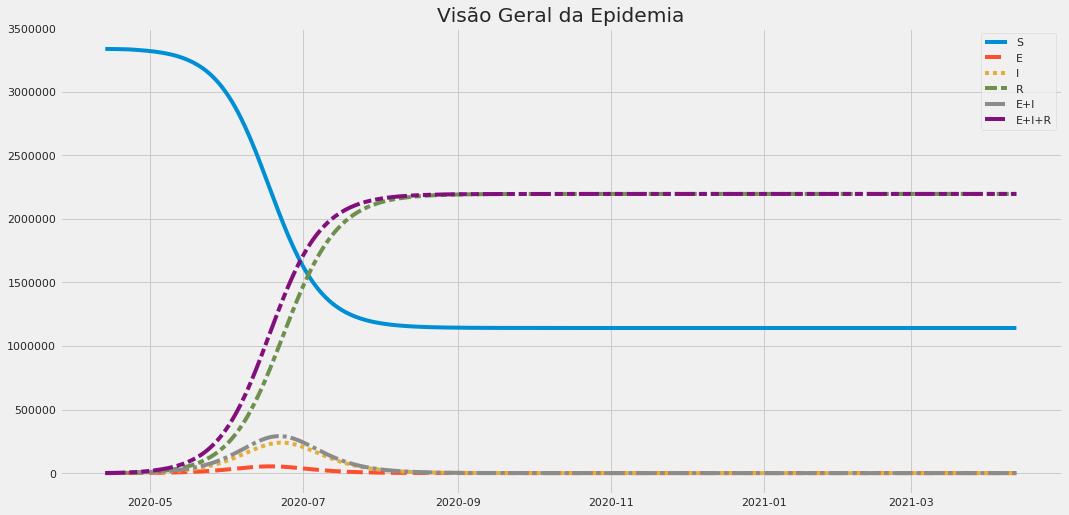

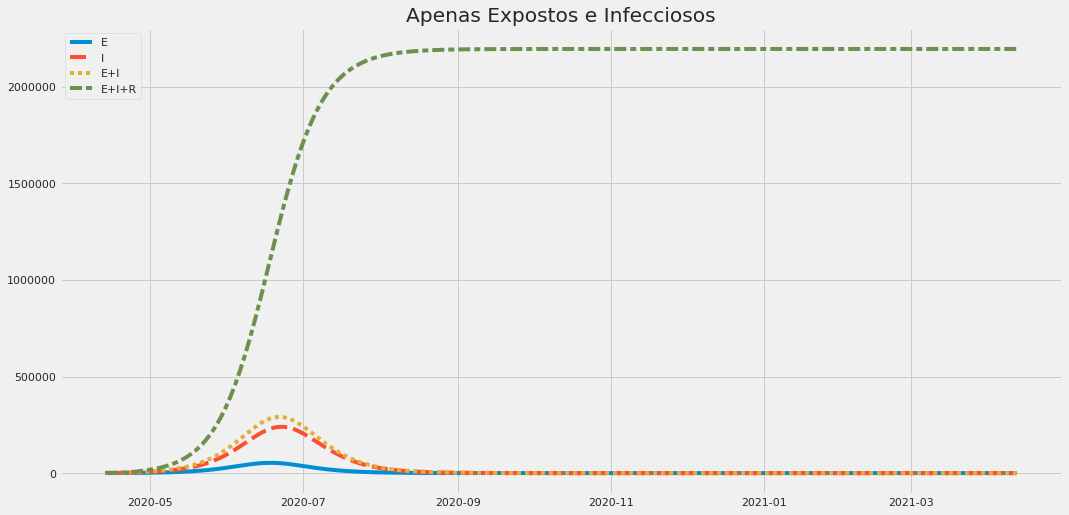

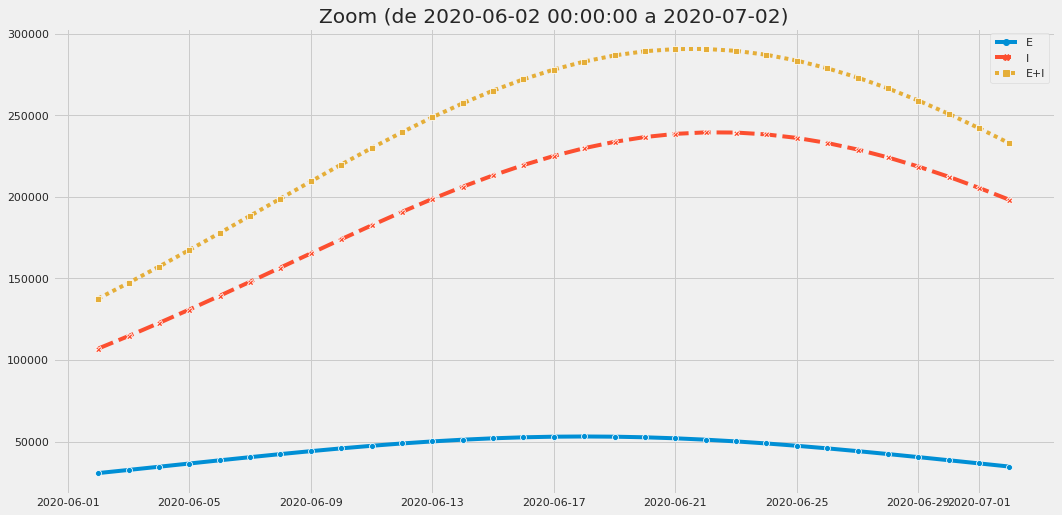

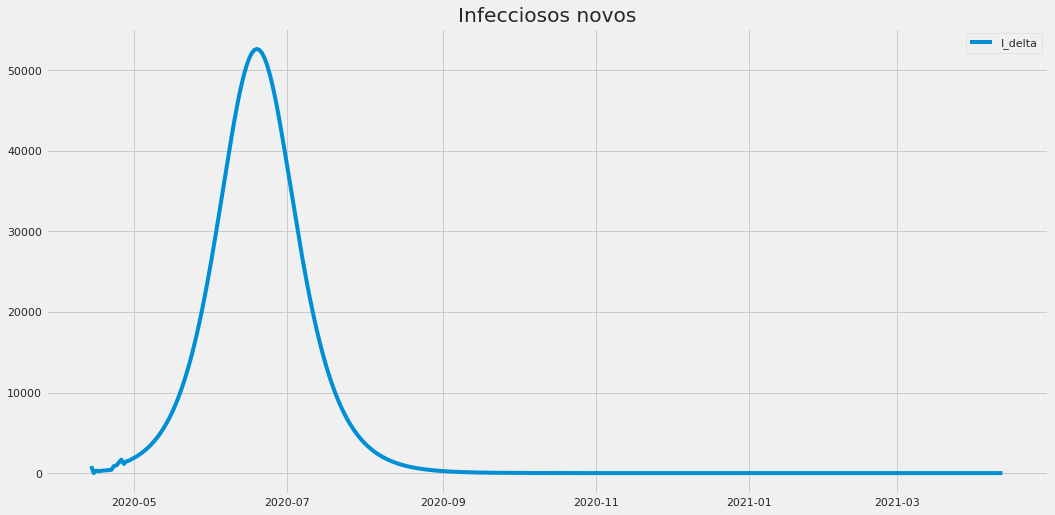

<Figure size 1152x576 with 0 Axes>

In [55]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [56]:
best['beta_3'] / best['gamma_1']

1.615750474922107

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

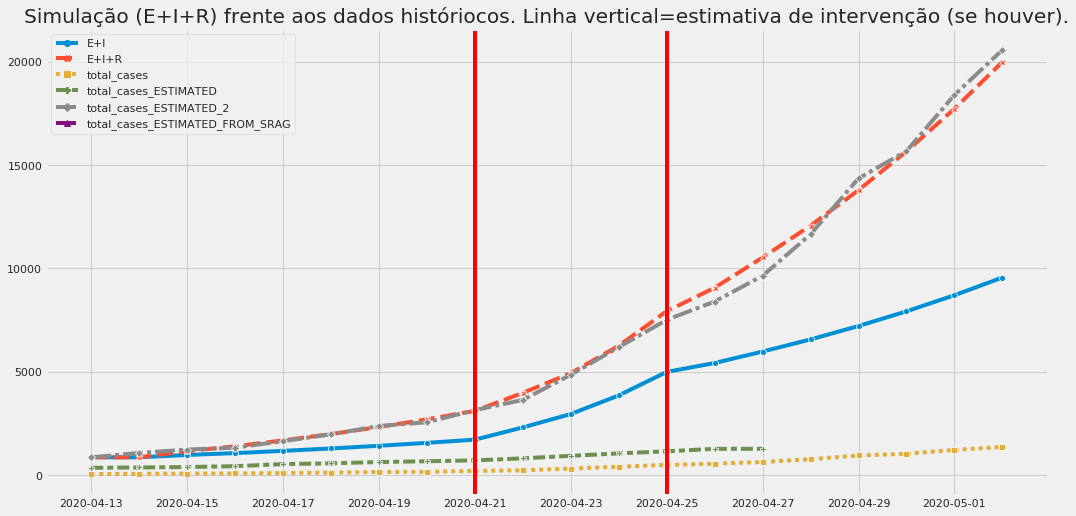

In [57]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

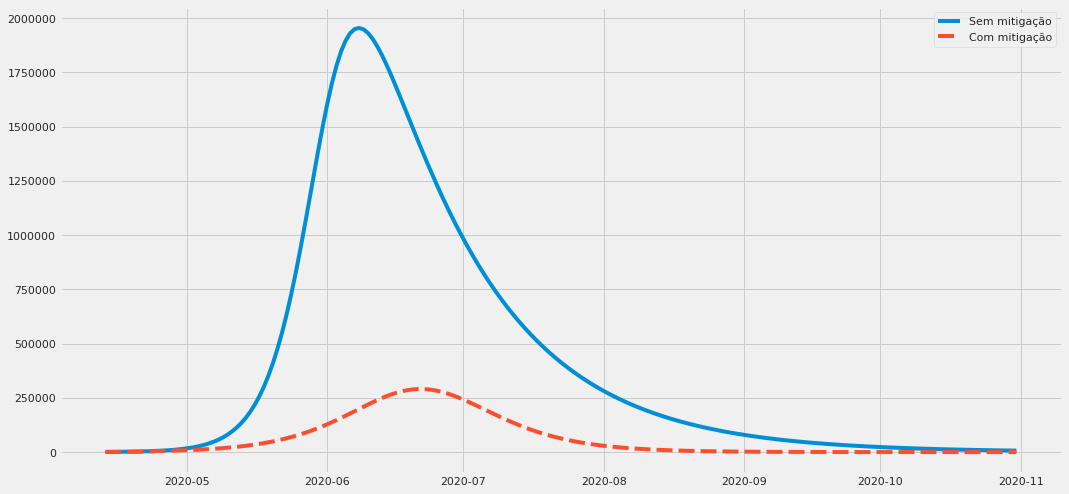

In [58]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [59]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [60]:
len(df_data_target)

22

In [61]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    for t in range(7, len(df_data_target), 1):
        print(f'###### t={t} ######')
        #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}

        t_2 = 10 if t >= 15.0 else 0.1
        t_3 = 10 if t >= 20.0 else 0.1

        ## assuming different gammas
        #
        #space = \
        #    {'dynamic':\
        #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
        #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
        #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
        #        0, t)
        #    }

        # assuming gamma_1 == gamma_2 == gamma_3
        space = \
            {'dynamic':\
                ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
                   'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
                   'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
                   {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
                 {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
                0, t)
            }

        trials = hyperopt.Trials()
        best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

        print("Best parameters found:", best)

        alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                    (best['alpha_2'], best['duration_2']),
                                    (best['alpha_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
        beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                    (best['beta_2'], best['duration_2']),
                                    (best['beta_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
       #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
       #                            (best['gamma_2'], best['duration_2']),
       #                            (best['gamma_3'], best['duration_3'])],
       #                            min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                    (best['gamma_1'], best['duration_2']),
                                    (best['gamma_1'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)

        r0_1 = best['beta_1'] / best['gamma_1']
        r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
        r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']

        r0s.append((r0_1, r0_2, r0_3))
        print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')


        df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=0, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)

        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

###### t=7 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 6/3000 [00:00<00:50, 59.58trial/s, best loss: 249.74536201573937]

  1%|          | 16/3000 [00:00<00:44, 66.98trial/s, best loss: 98.38856384515995]

  1%|          | 23/3000 [00:00<00:44, 66.94trial/s, best loss: 98.38856384515995]

  1%|          | 29/3000 [00:00<00:48, 61.33trial/s, best loss: 98.38856384515995]

  1%|          | 34/3000 [00:00<00:52, 57.02trial/s, best loss: 98.38856384515995]

  1%|▏         | 39/3000 [00:00<00:55, 53.44trial/s, best loss: 76.89958274290792]

  1%|▏         | 44/3000 [00:00<00:56, 52.22trial/s, best loss: 76.89958274290792]

  2%|▏         | 49/3000 [00:00<00:58, 50.07trial/s, best loss: 76.89958274290792]

  2%|▏         | 54/3000 [00:00<00:59, 49.55trial/s, best loss: 76.89958274290792]

  2%|▏         | 59/3000 [00:01<01:01, 47.71trial/s, best loss: 63.10854484306609]

  2%|▏         | 64/3000 [00:01<01:01, 47.43trial/s, best loss: 63.10854484306609]

  2%|▏         | 69/3000 [00:01<01:03, 46.20trial/s, best loss: 63.10854484306609]

  2%|▏         | 74/3000 [00:01<01:08, 42.64trial/s, best loss: 63.10854484306609]

  3%|▎         | 79/3000 [00:01<01:06, 44.19trial/s, best loss: 63.10854484306609]

  3%|▎         | 84/3000 [00:01<01:05, 44.56trial/s, best loss: 60.933955780125416]

  3%|▎         | 89/3000 [00:01<01:04, 45.27trial/s, best loss: 60.933955780125416]

  3%|▎         | 94/3000 [00:01<01:04, 44.77trial/s, best loss: 60.933955780125416]

  3%|▎         | 99/3000 [00:01<01:04, 44.97trial/s, best loss: 60.933955780125416]

  3%|▎         | 104/3000 [00:02<01:03, 45.38trial/s, best loss: 60.933955780125416]

  4%|▎         | 109/3000 [00:02<01:12, 39.79trial/s, best loss: 60.933955780125416]

  4%|▍         | 114/3000 [00:02<01:10, 41.22trial/s, best loss: 60.933955780125416]

  4%|▍         | 119/3000 [00:02<01:08, 42.18trial/s, best loss: 60.933955780125416]

  4%|▍         | 124/3000 [00:02<01:08, 41.79trial/s, best loss: 60.933955780125416]

  4%|▍         | 129/3000 [00:02<01:07, 42.43trial/s, best loss: 60.933955780125416]

  4%|▍         | 134/3000 [00:02<01:07, 42.57trial/s, best loss: 60.933955780125416]

  5%|▍         | 139/3000 [00:02<01:11, 40.22trial/s, best loss: 60.933955780125416]

  5%|▍         | 144/3000 [00:03<01:14, 38.11trial/s, best loss: 60.933955780125416]

  5%|▍         | 149/3000 [00:03<01:11, 39.66trial/s, best loss: 60.933955780125416]

  5%|▌         | 154/3000 [00:03<01:11, 39.96trial/s, best loss: 56.99435772544536] 

  5%|▌         | 159/3000 [00:03<01:09, 40.84trial/s, best loss: 56.99435772544536]

  5%|▌         | 164/3000 [00:03<01:09, 40.67trial/s, best loss: 56.99435772544536]

  6%|▌         | 169/3000 [00:03<01:08, 41.27trial/s, best loss: 56.99435772544536]

  6%|▌         | 174/3000 [00:03<01:19, 35.53trial/s, best loss: 56.99435772544536]

  6%|▌         | 179/3000 [00:04<01:15, 37.17trial/s, best loss: 56.99435772544536]

  6%|▌         | 184/3000 [00:04<01:13, 38.36trial/s, best loss: 56.99435772544536]

  6%|▋         | 189/3000 [00:04<01:11, 39.07trial/s, best loss: 56.99435772544536]

  6%|▋         | 194/3000 [00:04<01:10, 39.82trial/s, best loss: 56.99435772544536]

  7%|▋         | 199/3000 [00:04<01:11, 39.31trial/s, best loss: 56.99435772544536]

  7%|▋         | 203/3000 [00:04<01:10, 39.48trial/s, best loss: 56.99435772544536]

  7%|▋         | 208/3000 [00:04<01:10, 39.79trial/s, best loss: 56.99435772544536]

  7%|▋         | 212/3000 [00:04<01:11, 39.25trial/s, best loss: 56.99435772544536]

  7%|▋         | 216/3000 [00:04<01:10, 39.28trial/s, best loss: 56.99435772544536]

  7%|▋         | 220/3000 [00:05<01:12, 38.14trial/s, best loss: 56.99435772544536]

  7%|▋         | 224/3000 [00:05<01:13, 37.88trial/s, best loss: 56.99435772544536]

  8%|▊         | 228/3000 [00:05<01:20, 34.32trial/s, best loss: 56.99435772544536]

  8%|▊         | 233/3000 [00:05<01:17, 35.85trial/s, best loss: 56.99435772544536]

  8%|▊         | 237/3000 [00:05<01:14, 36.90trial/s, best loss: 56.99435772544536]

  8%|▊         | 241/3000 [00:05<01:14, 36.83trial/s, best loss: 56.99435772544536]

  8%|▊         | 245/3000 [00:05<01:13, 37.46trial/s, best loss: 56.99435772544536]

  8%|▊         | 249/3000 [00:05<01:16, 36.19trial/s, best loss: 56.99435772544536]

  8%|▊         | 253/3000 [00:05<01:14, 37.02trial/s, best loss: 56.99435772544536]

  9%|▊         | 257/3000 [00:06<01:12, 37.74trial/s, best loss: 56.99435772544536]

  9%|▊         | 261/3000 [00:06<01:12, 37.79trial/s, best loss: 55.430960321361354]

  9%|▉         | 265/3000 [00:06<01:13, 37.12trial/s, best loss: 55.430960321361354]

  9%|▉         | 269/3000 [00:06<01:12, 37.43trial/s, best loss: 55.430960321361354]

  9%|▉         | 273/3000 [00:06<01:21, 33.54trial/s, best loss: 55.430960321361354]

  9%|▉         | 277/3000 [00:06<01:19, 34.36trial/s, best loss: 55.430960321361354]

  9%|▉         | 281/3000 [00:06<01:16, 35.48trial/s, best loss: 55.430960321361354]

 10%|▉         | 285/3000 [00:06<01:16, 35.46trial/s, best loss: 55.430960321361354]

 10%|▉         | 289/3000 [00:06<01:15, 35.96trial/s, best loss: 55.430960321361354]

 10%|▉         | 293/3000 [00:07<01:14, 36.15trial/s, best loss: 55.430960321361354]

 10%|▉         | 297/3000 [00:07<01:14, 36.43trial/s, best loss: 55.430960321361354]

 10%|█         | 301/3000 [00:07<01:15, 35.98trial/s, best loss: 55.430960321361354]

 10%|█         | 305/3000 [00:07<01:14, 36.30trial/s, best loss: 55.430960321361354]

 10%|█         | 309/3000 [00:07<01:13, 36.47trial/s, best loss: 55.430960321361354]

 10%|█         | 313/3000 [00:07<01:13, 36.37trial/s, best loss: 55.430960321361354]

 11%|█         | 317/3000 [00:07<01:13, 36.40trial/s, best loss: 55.430960321361354]

 11%|█         | 321/3000 [00:07<01:16, 35.15trial/s, best loss: 55.430960321361354]

 11%|█         | 325/3000 [00:07<01:15, 35.50trial/s, best loss: 55.430960321361354]

 11%|█         | 329/3000 [00:08<01:18, 33.98trial/s, best loss: 55.430960321361354]

 11%|█         | 333/3000 [00:08<01:17, 34.26trial/s, best loss: 55.430960321361354]

 11%|█         | 337/3000 [00:08<01:16, 34.63trial/s, best loss: 55.430960321361354]

 11%|█▏        | 341/3000 [00:08<01:16, 34.96trial/s, best loss: 55.430960321361354]

 12%|█▏        | 345/3000 [00:08<01:15, 35.00trial/s, best loss: 55.430960321361354]

 12%|█▏        | 349/3000 [00:08<01:17, 34.11trial/s, best loss: 55.430960321361354]

 12%|█▏        | 353/3000 [00:08<01:18, 33.61trial/s, best loss: 55.430960321361354]

 12%|█▏        | 357/3000 [00:08<01:25, 30.96trial/s, best loss: 55.430960321361354]

 12%|█▏        | 361/3000 [00:09<01:24, 31.24trial/s, best loss: 55.430960321361354]

 12%|█▏        | 365/3000 [00:09<01:25, 30.91trial/s, best loss: 55.430960321361354]

 12%|█▏        | 369/3000 [00:09<01:24, 30.98trial/s, best loss: 55.430960321361354]

 12%|█▏        | 373/3000 [00:09<01:24, 30.97trial/s, best loss: 55.430960321361354]

 13%|█▎        | 377/3000 [00:09<01:24, 31.13trial/s, best loss: 55.430960321361354]

 13%|█▎        | 381/3000 [00:09<01:24, 31.14trial/s, best loss: 55.430960321361354]

 13%|█▎        | 385/3000 [00:09<01:25, 30.53trial/s, best loss: 55.430960321361354]

 13%|█▎        | 389/3000 [00:09<01:25, 30.58trial/s, best loss: 55.430960321361354]

 13%|█▎        | 393/3000 [00:10<01:25, 30.63trial/s, best loss: 55.430960321361354]

 13%|█▎        | 397/3000 [00:10<01:25, 30.45trial/s, best loss: 55.430960321361354]

 13%|█▎        | 401/3000 [00:10<01:25, 30.45trial/s, best loss: 55.430960321361354]

 14%|█▎        | 405/3000 [00:10<01:25, 30.19trial/s, best loss: 55.430960321361354]

 14%|█▎        | 409/3000 [00:10<01:26, 29.87trial/s, best loss: 55.430960321361354]

 14%|█▎        | 412/3000 [00:10<01:26, 29.83trial/s, best loss: 55.430960321361354]

 14%|█▍        | 415/3000 [00:10<01:30, 28.56trial/s, best loss: 54.053775521190474]

 14%|█▍        | 418/3000 [00:10<01:29, 28.89trial/s, best loss: 54.053775521190474]

 14%|█▍        | 422/3000 [00:11<01:28, 29.24trial/s, best loss: 54.053775521190474]

 14%|█▍        | 425/3000 [00:11<01:27, 29.42trial/s, best loss: 54.053775521190474]

 14%|█▍        | 428/3000 [00:11<01:27, 29.49trial/s, best loss: 54.053775521190474]

 14%|█▍        | 432/3000 [00:11<01:26, 29.75trial/s, best loss: 54.053775521190474]

 15%|█▍        | 436/3000 [00:11<01:25, 29.85trial/s, best loss: 54.053775521190474]

 15%|█▍        | 439/3000 [00:11<01:25, 29.84trial/s, best loss: 54.053775521190474]

 15%|█▍        | 443/3000 [00:11<01:24, 30.09trial/s, best loss: 54.053775521190474]

 15%|█▍        | 447/3000 [00:11<01:27, 29.24trial/s, best loss: 54.053775521190474]

 15%|█▌        | 450/3000 [00:12<01:38, 25.94trial/s, best loss: 54.053775521190474]

 15%|█▌        | 453/3000 [00:12<01:34, 26.92trial/s, best loss: 54.053775521190474]

 15%|█▌        | 456/3000 [00:12<01:33, 27.33trial/s, best loss: 54.053775521190474]

 15%|█▌        | 459/3000 [00:12<01:31, 27.90trial/s, best loss: 54.053775521190474]

 15%|█▌        | 462/3000 [00:12<01:29, 28.22trial/s, best loss: 54.053775521190474]

 16%|█▌        | 465/3000 [00:12<01:29, 28.24trial/s, best loss: 54.053775521190474]

 16%|█▌        | 468/3000 [00:12<01:29, 28.45trial/s, best loss: 54.053775521190474]

 16%|█▌        | 471/3000 [00:12<01:29, 28.21trial/s, best loss: 54.053775521190474]

 16%|█▌        | 474/3000 [00:12<01:29, 28.28trial/s, best loss: 54.053775521190474]

 16%|█▌        | 477/3000 [00:13<01:29, 28.33trial/s, best loss: 54.053775521190474]

 16%|█▌        | 480/3000 [00:13<01:28, 28.36trial/s, best loss: 54.053775521190474]

 16%|█▌        | 483/3000 [00:13<01:29, 28.09trial/s, best loss: 54.053775521190474]

 16%|█▌        | 486/3000 [00:13<01:34, 26.48trial/s, best loss: 54.053775521190474]

 16%|█▋        | 489/3000 [00:13<01:33, 26.86trial/s, best loss: 54.053775521190474]

 16%|█▋        | 492/3000 [00:13<01:32, 27.08trial/s, best loss: 54.053775521190474]

 16%|█▋        | 495/3000 [00:13<01:32, 27.17trial/s, best loss: 54.053775521190474]

 17%|█▋        | 498/3000 [00:13<01:32, 27.11trial/s, best loss: 54.053775521190474]

 17%|█▋        | 501/3000 [00:13<01:32, 27.12trial/s, best loss: 54.053775521190474]

 17%|█▋        | 504/3000 [00:14<01:38, 25.35trial/s, best loss: 54.053775521190474]

 17%|█▋        | 507/3000 [00:14<01:35, 26.08trial/s, best loss: 54.053775521190474]

 17%|█▋        | 510/3000 [00:14<01:33, 26.71trial/s, best loss: 54.053775521190474]

 17%|█▋        | 513/3000 [00:14<01:32, 26.94trial/s, best loss: 54.053775521190474]

 17%|█▋        | 516/3000 [00:14<01:31, 27.15trial/s, best loss: 54.053775521190474]

 17%|█▋        | 519/3000 [00:14<01:31, 27.16trial/s, best loss: 54.053775521190474]

 17%|█▋        | 522/3000 [00:14<01:46, 23.26trial/s, best loss: 54.053775521190474]

 18%|█▊        | 525/3000 [00:14<01:41, 24.29trial/s, best loss: 54.053775521190474]

 18%|█▊        | 528/3000 [00:14<01:37, 25.29trial/s, best loss: 54.053775521190474]

 18%|█▊        | 531/3000 [00:15<01:36, 25.68trial/s, best loss: 54.053775521190474]

 18%|█▊        | 534/3000 [00:15<01:35, 25.93trial/s, best loss: 54.053775521190474]

 18%|█▊        | 537/3000 [00:15<01:33, 26.29trial/s, best loss: 54.053775521190474]

 18%|█▊        | 540/3000 [00:15<01:37, 25.22trial/s, best loss: 54.053775521190474]

 18%|█▊        | 543/3000 [00:15<01:36, 25.39trial/s, best loss: 54.053775521190474]

 18%|█▊        | 546/3000 [00:15<01:35, 25.75trial/s, best loss: 54.053775521190474]

 18%|█▊        | 549/3000 [00:15<01:33, 26.14trial/s, best loss: 54.053775521190474]

 18%|█▊        | 552/3000 [00:15<01:34, 25.81trial/s, best loss: 54.053775521190474]

 18%|█▊        | 555/3000 [00:16<01:33, 26.04trial/s, best loss: 54.053775521190474]

 19%|█▊        | 558/3000 [00:16<01:32, 26.37trial/s, best loss: 54.053775521190474]

 19%|█▊        | 561/3000 [00:16<01:32, 26.33trial/s, best loss: 54.053775521190474]

 19%|█▉        | 564/3000 [00:16<01:32, 26.29trial/s, best loss: 54.053775521190474]

 19%|█▉        | 567/3000 [00:16<01:37, 25.08trial/s, best loss: 54.053775521190474]

 19%|█▉        | 570/3000 [00:16<01:36, 25.31trial/s, best loss: 54.053775521190474]

 19%|█▉        | 573/3000 [00:16<01:33, 25.84trial/s, best loss: 54.053775521190474]

 19%|█▉        | 576/3000 [00:16<01:34, 25.65trial/s, best loss: 54.053775521190474]

 19%|█▉        | 579/3000 [00:16<01:33, 25.79trial/s, best loss: 54.053775521190474]

 19%|█▉        | 582/3000 [00:17<01:33, 25.98trial/s, best loss: 54.053775521190474]

 20%|█▉        | 585/3000 [00:17<01:32, 26.10trial/s, best loss: 54.053775521190474]

 20%|█▉        | 588/3000 [00:17<01:35, 25.26trial/s, best loss: 54.053775521190474]

 20%|█▉        | 591/3000 [00:17<01:33, 25.63trial/s, best loss: 54.053775521190474]

 20%|█▉        | 594/3000 [00:17<01:33, 25.72trial/s, best loss: 54.053775521190474]

 20%|█▉        | 597/3000 [00:17<01:34, 25.52trial/s, best loss: 54.053775521190474]

 20%|██        | 600/3000 [00:17<01:33, 25.66trial/s, best loss: 54.053775521190474]

 20%|██        | 603/3000 [00:17<01:36, 24.72trial/s, best loss: 54.053775521190474]

 20%|██        | 606/3000 [00:18<01:35, 25.17trial/s, best loss: 54.053775521190474]

 20%|██        | 609/3000 [00:18<01:34, 25.43trial/s, best loss: 54.053775521190474]

 20%|██        | 612/3000 [00:18<01:33, 25.46trial/s, best loss: 54.053775521190474]

 20%|██        | 615/3000 [00:18<01:33, 25.60trial/s, best loss: 54.053775521190474]

 21%|██        | 618/3000 [00:18<01:33, 25.60trial/s, best loss: 54.053775521190474]

 21%|██        | 621/3000 [00:18<01:33, 25.40trial/s, best loss: 54.053775521190474]

 21%|██        | 624/3000 [00:18<01:44, 22.73trial/s, best loss: 54.053775521190474]

 21%|██        | 627/3000 [00:18<01:41, 23.27trial/s, best loss: 54.053775521190474]

 21%|██        | 630/3000 [00:19<01:40, 23.55trial/s, best loss: 54.053775521190474]

 21%|██        | 633/3000 [00:19<01:39, 23.83trial/s, best loss: 54.053775521190474]

 21%|██        | 636/3000 [00:19<01:38, 23.97trial/s, best loss: 54.053775521190474]

 21%|██▏       | 639/3000 [00:19<01:37, 24.24trial/s, best loss: 54.053775521190474]

 21%|██▏       | 642/3000 [00:19<01:36, 24.51trial/s, best loss: 54.053775521190474]

 22%|██▏       | 645/3000 [00:19<01:36, 24.46trial/s, best loss: 54.053775521190474]

 22%|██▏       | 648/3000 [00:19<01:35, 24.57trial/s, best loss: 54.053775521190474]

 22%|██▏       | 651/3000 [00:19<01:37, 24.14trial/s, best loss: 54.053775521190474]

 22%|██▏       | 654/3000 [00:19<01:36, 24.34trial/s, best loss: 54.053775521190474]

 22%|██▏       | 657/3000 [00:20<01:35, 24.60trial/s, best loss: 54.053775521190474]

 22%|██▏       | 660/3000 [00:20<01:34, 24.69trial/s, best loss: 54.053775521190474]

 22%|██▏       | 663/3000 [00:20<01:34, 24.70trial/s, best loss: 54.053775521190474]

 22%|██▏       | 666/3000 [00:20<01:34, 24.75trial/s, best loss: 54.053775521190474]

 22%|██▏       | 669/3000 [00:20<01:34, 24.58trial/s, best loss: 54.053775521190474]

 22%|██▏       | 672/3000 [00:20<01:34, 24.51trial/s, best loss: 54.053775521190474]

 22%|██▎       | 675/3000 [00:20<01:36, 24.13trial/s, best loss: 54.053775521190474]

 23%|██▎       | 678/3000 [00:20<01:36, 24.11trial/s, best loss: 54.053775521190474]

 23%|██▎       | 681/3000 [00:21<01:37, 23.87trial/s, best loss: 54.053775521190474]

 23%|██▎       | 684/3000 [00:21<01:37, 23.80trial/s, best loss: 54.053775521190474]

 23%|██▎       | 687/3000 [00:21<01:37, 23.73trial/s, best loss: 54.053775521190474]

 23%|██▎       | 690/3000 [00:21<01:37, 23.70trial/s, best loss: 54.053775521190474]

 23%|██▎       | 693/3000 [00:21<01:38, 23.51trial/s, best loss: 54.053775521190474]

 23%|██▎       | 696/3000 [00:21<01:37, 23.66trial/s, best loss: 54.053775521190474]

 23%|██▎       | 699/3000 [00:21<01:40, 22.86trial/s, best loss: 54.053775521190474]

 23%|██▎       | 702/3000 [00:22<01:39, 23.11trial/s, best loss: 54.053775521190474]

 24%|██▎       | 705/3000 [00:22<01:38, 23.32trial/s, best loss: 54.053775521190474]

 24%|██▎       | 708/3000 [00:22<01:38, 23.30trial/s, best loss: 54.053775521190474]

 24%|██▎       | 711/3000 [00:22<01:37, 23.39trial/s, best loss: 54.053775521190474]

 24%|██▍       | 714/3000 [00:22<01:37, 23.55trial/s, best loss: 54.053775521190474]

 24%|██▍       | 717/3000 [00:22<01:37, 23.52trial/s, best loss: 54.053775521190474]

 24%|██▍       | 720/3000 [00:22<01:37, 23.45trial/s, best loss: 54.053775521190474]

 24%|██▍       | 723/3000 [00:22<01:39, 22.78trial/s, best loss: 54.053775521190474]

 24%|██▍       | 726/3000 [00:23<01:38, 23.03trial/s, best loss: 54.053775521190474]

 24%|██▍       | 729/3000 [00:23<01:49, 20.69trial/s, best loss: 54.053775521190474]

 24%|██▍       | 732/3000 [00:23<01:46, 21.33trial/s, best loss: 54.053775521190474]

 24%|██▍       | 735/3000 [00:23<01:43, 21.85trial/s, best loss: 54.053775521190474]

 25%|██▍       | 738/3000 [00:23<01:42, 22.01trial/s, best loss: 54.053775521190474]

 25%|██▍       | 741/3000 [00:23<01:41, 22.32trial/s, best loss: 54.053775521190474]

 25%|██▍       | 744/3000 [00:23<01:41, 22.14trial/s, best loss: 54.053775521190474]

 25%|██▍       | 747/3000 [00:24<01:41, 22.29trial/s, best loss: 54.053775521190474]

 25%|██▌       | 750/3000 [00:24<01:40, 22.34trial/s, best loss: 54.053775521190474]

 25%|██▌       | 753/3000 [00:24<01:40, 22.46trial/s, best loss: 54.053775521190474]

 25%|██▌       | 756/3000 [00:24<01:39, 22.64trial/s, best loss: 54.053775521190474]

 25%|██▌       | 759/3000 [00:24<01:38, 22.67trial/s, best loss: 54.053775521190474]

 25%|██▌       | 762/3000 [00:24<01:39, 22.48trial/s, best loss: 54.053775521190474]

 26%|██▌       | 765/3000 [00:24<01:40, 22.24trial/s, best loss: 54.053775521190474]

 26%|██▌       | 768/3000 [00:24<01:39, 22.36trial/s, best loss: 54.053775521190474]

 26%|██▌       | 771/3000 [00:25<01:39, 22.47trial/s, best loss: 54.053775521190474]

 26%|██▌       | 774/3000 [00:25<01:40, 22.08trial/s, best loss: 54.053775521190474]

 26%|██▌       | 777/3000 [00:25<01:40, 22.08trial/s, best loss: 54.053775521190474]

 26%|██▌       | 780/3000 [00:25<01:40, 22.13trial/s, best loss: 54.053775521190474]

 26%|██▌       | 783/3000 [00:25<01:41, 21.84trial/s, best loss: 54.053775521190474]

 26%|██▌       | 786/3000 [00:25<01:57, 18.85trial/s, best loss: 54.053775521190474]

 26%|██▋       | 788/3000 [00:25<01:59, 18.52trial/s, best loss: 54.053775521190474]

 26%|██▋       | 791/3000 [00:26<01:55, 19.15trial/s, best loss: 54.053775521190474]

 26%|██▋       | 794/3000 [00:26<01:50, 19.88trial/s, best loss: 54.053775521190474]

 27%|██▋       | 797/3000 [00:26<01:46, 20.64trial/s, best loss: 54.053775521190474]

 27%|██▋       | 800/3000 [00:26<01:44, 21.03trial/s, best loss: 54.053775521190474]

 27%|██▋       | 803/3000 [00:26<01:42, 21.36trial/s, best loss: 54.053775521190474]

 27%|██▋       | 806/3000 [00:26<01:41, 21.69trial/s, best loss: 54.053775521190474]

 27%|██▋       | 809/3000 [00:26<01:42, 21.36trial/s, best loss: 54.053775521190474]

 27%|██▋       | 812/3000 [00:27<01:41, 21.60trial/s, best loss: 54.053775521190474]

 27%|██▋       | 815/3000 [00:27<01:39, 21.89trial/s, best loss: 54.053775521190474]

 27%|██▋       | 818/3000 [00:27<01:39, 22.02trial/s, best loss: 54.053775521190474]

 27%|██▋       | 821/3000 [00:27<01:37, 22.30trial/s, best loss: 54.053775521190474]

 27%|██▋       | 824/3000 [00:27<01:37, 22.28trial/s, best loss: 54.053775521190474]

 28%|██▊       | 827/3000 [00:27<01:37, 22.25trial/s, best loss: 54.053775521190474]

 28%|██▊       | 830/3000 [00:27<01:38, 21.93trial/s, best loss: 54.053775521190474]

 28%|██▊       | 833/3000 [00:28<01:38, 22.07trial/s, best loss: 54.053775521190474]

 28%|██▊       | 836/3000 [00:28<01:39, 21.83trial/s, best loss: 54.053775521190474]

 28%|██▊       | 839/3000 [00:28<01:39, 21.81trial/s, best loss: 54.053775521190474]

 28%|██▊       | 842/3000 [00:28<01:48, 19.85trial/s, best loss: 54.053775521190474]

 28%|██▊       | 845/3000 [00:28<01:45, 20.37trial/s, best loss: 54.053775521190474]

 28%|██▊       | 848/3000 [00:28<01:43, 20.80trial/s, best loss: 54.053775521190474]

 28%|██▊       | 851/3000 [00:28<01:43, 20.78trial/s, best loss: 54.053775521190474]

 28%|██▊       | 854/3000 [00:29<01:41, 21.17trial/s, best loss: 54.053775521190474]

 29%|██▊       | 857/3000 [00:29<01:40, 21.39trial/s, best loss: 54.053775521190474]

 29%|██▊       | 860/3000 [00:29<01:39, 21.59trial/s, best loss: 54.053775521190474]

 29%|██▉       | 863/3000 [00:29<01:38, 21.72trial/s, best loss: 54.053775521190474]

 29%|██▉       | 866/3000 [00:29<01:38, 21.69trial/s, best loss: 54.053775521190474]

 29%|██▉       | 869/3000 [00:29<01:38, 21.65trial/s, best loss: 54.053775521190474]

 29%|██▉       | 872/3000 [00:29<01:40, 21.25trial/s, best loss: 54.053775521190474]

 29%|██▉       | 875/3000 [00:29<01:39, 21.36trial/s, best loss: 54.053775521190474]

 29%|██▉       | 878/3000 [00:30<01:39, 21.23trial/s, best loss: 54.053775521190474]

 29%|██▉       | 881/3000 [00:30<01:39, 21.19trial/s, best loss: 54.053775521190474]

 29%|██▉       | 884/3000 [00:30<01:39, 21.19trial/s, best loss: 54.053775521190474]

 30%|██▉       | 887/3000 [00:30<01:41, 20.83trial/s, best loss: 54.053775521190474]

 30%|██▉       | 890/3000 [00:30<01:41, 20.79trial/s, best loss: 54.053775521190474]

 30%|██▉       | 893/3000 [00:30<01:41, 20.69trial/s, best loss: 54.053775521190474]

 30%|██▉       | 896/3000 [00:31<01:41, 20.78trial/s, best loss: 54.053775521190474]

 30%|██▉       | 899/3000 [00:31<01:40, 20.83trial/s, best loss: 54.053775521190474]

 30%|███       | 902/3000 [00:31<01:50, 18.96trial/s, best loss: 54.053775521190474]

 30%|███       | 905/3000 [00:31<01:50, 19.03trial/s, best loss: 54.053775521190474]

 30%|███       | 907/3000 [00:31<01:54, 18.26trial/s, best loss: 54.053775521190474]

 30%|███       | 910/3000 [00:31<01:49, 19.03trial/s, best loss: 54.053775521190474]

 30%|███       | 912/3000 [00:31<01:50, 18.93trial/s, best loss: 54.053775521190474]

 30%|███       | 915/3000 [00:32<01:46, 19.53trial/s, best loss: 54.053775521190474]

 31%|███       | 918/3000 [00:32<01:44, 20.01trial/s, best loss: 54.053775521190474]

 31%|███       | 921/3000 [00:32<01:43, 20.15trial/s, best loss: 54.053775521190474]

 31%|███       | 924/3000 [00:32<01:41, 20.43trial/s, best loss: 54.053775521190474]

 31%|███       | 927/3000 [00:32<01:40, 20.53trial/s, best loss: 54.053775521190474]

 31%|███       | 930/3000 [00:32<01:39, 20.72trial/s, best loss: 54.053775521190474]

 31%|███       | 933/3000 [00:32<01:42, 20.25trial/s, best loss: 54.053775521190474]

 31%|███       | 936/3000 [00:33<01:42, 20.17trial/s, best loss: 54.053775521190474]

 31%|███▏      | 939/3000 [00:33<01:45, 19.55trial/s, best loss: 54.053775521190474]

 31%|███▏      | 942/3000 [00:33<01:44, 19.75trial/s, best loss: 54.053775521190474]

 32%|███▏      | 945/3000 [00:33<01:42, 19.96trial/s, best loss: 54.053775521190474]

 32%|███▏      | 947/3000 [00:33<01:44, 19.74trial/s, best loss: 54.053775521190474]

 32%|███▏      | 949/3000 [00:33<01:43, 19.73trial/s, best loss: 54.053775521190474]

 32%|███▏      | 951/3000 [00:33<01:58, 17.31trial/s, best loss: 54.053775521190474]

 32%|███▏      | 953/3000 [00:33<02:02, 16.64trial/s, best loss: 54.053775521190474]

 32%|███▏      | 955/3000 [00:34<01:57, 17.44trial/s, best loss: 54.053775521190474]

 32%|███▏      | 957/3000 [00:34<01:53, 17.99trial/s, best loss: 54.053775521190474]

 32%|███▏      | 959/3000 [00:34<01:51, 18.34trial/s, best loss: 54.053775521190474]

 32%|███▏      | 962/3000 [00:34<01:57, 17.29trial/s, best loss: 54.053775521190474]

 32%|███▏      | 965/3000 [00:34<01:52, 18.06trial/s, best loss: 54.053775521190474]

 32%|███▏      | 968/3000 [00:34<01:48, 18.70trial/s, best loss: 54.053775521190474]

 32%|███▏      | 970/3000 [00:34<01:50, 18.35trial/s, best loss: 54.053775521190474]

 32%|███▏      | 972/3000 [00:34<01:47, 18.81trial/s, best loss: 54.053775521190474]

 32%|███▎      | 975/3000 [00:35<01:44, 19.30trial/s, best loss: 54.053775521190474]

 33%|███▎      | 977/3000 [00:35<01:43, 19.48trial/s, best loss: 54.053775521190474]

 33%|███▎      | 979/3000 [00:35<01:45, 19.19trial/s, best loss: 54.053775521190474]

 33%|███▎      | 982/3000 [00:35<01:43, 19.52trial/s, best loss: 54.053775521190474]

 33%|███▎      | 984/3000 [00:35<01:43, 19.52trial/s, best loss: 54.053775521190474]

 33%|███▎      | 987/3000 [00:35<01:42, 19.69trial/s, best loss: 54.053775521190474]

 33%|███▎      | 989/3000 [00:35<01:42, 19.60trial/s, best loss: 54.053775521190474]

 33%|███▎      | 991/3000 [00:35<01:41, 19.71trial/s, best loss: 54.053775521190474]

 33%|███▎      | 994/3000 [00:36<01:40, 19.89trial/s, best loss: 54.053775521190474]

 33%|███▎      | 996/3000 [00:36<01:40, 19.92trial/s, best loss: 54.053775521190474]

 33%|███▎      | 998/3000 [00:36<01:41, 19.81trial/s, best loss: 54.053775521190474]

 33%|███▎      | 1001/3000 [00:36<01:40, 19.88trial/s, best loss: 54.053775521190474]

 33%|███▎      | 1003/3000 [00:36<01:40, 19.88trial/s, best loss: 54.053775521190474]

 34%|███▎      | 1005/3000 [00:36<01:41, 19.75trial/s, best loss: 54.053775521190474]

 34%|███▎      | 1008/3000 [00:36<01:40, 19.88trial/s, best loss: 54.053775521190474]

 34%|███▎      | 1010/3000 [00:36<01:44, 19.12trial/s, best loss: 54.053775521190474]

 34%|███▎      | 1012/3000 [00:37<01:43, 19.20trial/s, best loss: 54.053775521190474]

 34%|███▍      | 1014/3000 [00:37<01:42, 19.33trial/s, best loss: 54.053775521190474]

 34%|███▍      | 1016/3000 [00:37<01:42, 19.30trial/s, best loss: 54.053775521190474]

 34%|███▍      | 1018/3000 [00:37<01:41, 19.43trial/s, best loss: 54.053775521190474]

 34%|███▍      | 1020/3000 [00:37<01:41, 19.48trial/s, best loss: 54.053775521190474]

 34%|███▍      | 1022/3000 [00:37<01:55, 17.11trial/s, best loss: 52.709589667474056]

 34%|███▍      | 1025/3000 [00:37<01:50, 17.86trial/s, best loss: 52.709589667474056]

 34%|███▍      | 1027/3000 [00:37<01:50, 17.92trial/s, best loss: 52.709589667474056]

 34%|███▍      | 1029/3000 [00:37<01:48, 18.23trial/s, best loss: 52.709589667474056]

 34%|███▍      | 1031/3000 [00:38<01:46, 18.58trial/s, best loss: 52.709589667474056]

 34%|███▍      | 1033/3000 [00:38<01:44, 18.77trial/s, best loss: 52.709589667474056]

 34%|███▍      | 1035/3000 [00:38<01:44, 18.88trial/s, best loss: 52.709589667474056]

 35%|███▍      | 1037/3000 [00:38<01:43, 19.05trial/s, best loss: 52.709589667474056]

 35%|███▍      | 1039/3000 [00:38<01:42, 19.18trial/s, best loss: 52.709589667474056]

 35%|███▍      | 1041/3000 [00:38<01:41, 19.25trial/s, best loss: 52.709589667474056]

 35%|███▍      | 1043/3000 [00:38<01:42, 19.16trial/s, best loss: 52.709589667474056]

 35%|███▍      | 1045/3000 [00:38<01:41, 19.19trial/s, best loss: 52.709589667474056]

 35%|███▍      | 1047/3000 [00:38<01:44, 18.75trial/s, best loss: 52.709589667474056]

 35%|███▍      | 1049/3000 [00:38<01:43, 18.93trial/s, best loss: 52.709589667474056]

 35%|███▌      | 1051/3000 [00:39<01:42, 19.02trial/s, best loss: 52.709589667474056]

 35%|███▌      | 1053/3000 [00:39<01:42, 19.02trial/s, best loss: 52.709589667474056]

 35%|███▌      | 1055/3000 [00:39<01:42, 18.96trial/s, best loss: 52.709589667474056]

 35%|███▌      | 1057/3000 [00:39<01:43, 18.85trial/s, best loss: 52.709589667474056]

 35%|███▌      | 1059/3000 [00:39<01:42, 18.87trial/s, best loss: 52.709589667474056]

 35%|███▌      | 1061/3000 [00:39<01:43, 18.78trial/s, best loss: 52.709589667474056]

 35%|███▌      | 1063/3000 [00:39<01:42, 18.88trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1065/3000 [00:39<01:44, 18.54trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1067/3000 [00:39<01:43, 18.69trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1069/3000 [00:40<01:43, 18.72trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1071/3000 [00:40<01:43, 18.70trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1073/3000 [00:40<01:43, 18.65trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1075/3000 [00:40<01:42, 18.81trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1077/3000 [00:40<01:41, 18.91trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1079/3000 [00:40<01:41, 18.93trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1081/3000 [00:40<01:41, 19.00trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1083/3000 [00:40<01:56, 16.47trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1085/3000 [00:40<01:52, 17.10trial/s, best loss: 52.709589667474056]

 36%|███▌      | 1087/3000 [00:41<01:48, 17.61trial/s, best loss: 52.709589667474056]

 36%|███▋      | 1089/3000 [00:41<01:46, 18.01trial/s, best loss: 52.709589667474056]

 36%|███▋      | 1091/3000 [00:41<01:44, 18.30trial/s, best loss: 52.709589667474056]

 36%|███▋      | 1093/3000 [00:41<01:42, 18.52trial/s, best loss: 52.709589667474056]

 36%|███▋      | 1095/3000 [00:41<01:42, 18.66trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1097/3000 [00:41<01:41, 18.66trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1099/3000 [00:41<01:41, 18.66trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1101/3000 [00:41<01:41, 18.78trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1103/3000 [00:41<01:45, 18.07trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1105/3000 [00:42<01:43, 18.32trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1107/3000 [00:42<01:42, 18.45trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1109/3000 [00:42<01:42, 18.52trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1111/3000 [00:42<01:42, 18.47trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1113/3000 [00:42<01:41, 18.57trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1115/3000 [00:42<01:41, 18.63trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1117/3000 [00:42<01:42, 18.33trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1119/3000 [00:42<01:42, 18.44trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1121/3000 [00:42<01:46, 17.58trial/s, best loss: 52.709589667474056]

 37%|███▋      | 1123/3000 [00:43<01:44, 17.90trial/s, best loss: 52.44297044982708] 

 38%|███▊      | 1125/3000 [00:43<01:43, 18.10trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1127/3000 [00:43<01:43, 18.17trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1129/3000 [00:43<01:42, 18.23trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1131/3000 [00:43<01:42, 18.29trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1133/3000 [00:43<01:41, 18.45trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1135/3000 [00:43<01:41, 18.30trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1137/3000 [00:43<01:41, 18.43trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1139/3000 [00:43<01:43, 18.03trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1141/3000 [00:43<01:42, 18.11trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1143/3000 [00:44<01:56, 15.89trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1145/3000 [00:44<02:00, 15.34trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1147/3000 [00:44<01:54, 16.14trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1149/3000 [00:44<01:50, 16.71trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1151/3000 [00:44<01:48, 17.02trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1153/3000 [00:44<01:46, 17.38trial/s, best loss: 52.44297044982708]

 38%|███▊      | 1155/3000 [00:44<01:47, 17.12trial/s, best loss: 52.44297044982708]

 39%|███▊      | 1157/3000 [00:44<01:45, 17.40trial/s, best loss: 52.44297044982708]

 39%|███▊      | 1159/3000 [00:45<01:43, 17.74trial/s, best loss: 52.44297044982708]

 39%|███▊      | 1161/3000 [00:45<01:43, 17.85trial/s, best loss: 52.44297044982708]

 39%|███▉      | 1163/3000 [00:45<01:42, 17.94trial/s, best loss: 52.44297044982708]

 39%|███▉      | 1165/3000 [00:45<01:43, 17.77trial/s, best loss: 52.44297044982708]

 39%|███▉      | 1167/3000 [00:45<01:45, 17.39trial/s, best loss: 52.27786545354008]

 39%|███▉      | 1169/3000 [00:45<01:45, 17.35trial/s, best loss: 52.27786545354008]

 39%|███▉      | 1171/3000 [00:45<01:44, 17.47trial/s, best loss: 52.27786545354008]

 39%|███▉      | 1173/3000 [00:45<01:45, 17.36trial/s, best loss: 52.27786545354008]

 39%|███▉      | 1175/3000 [00:45<01:44, 17.51trial/s, best loss: 52.27786545354008]

 39%|███▉      | 1177/3000 [00:46<01:43, 17.63trial/s, best loss: 52.27786545354008]

 39%|███▉      | 1179/3000 [00:46<01:42, 17.79trial/s, best loss: 52.27786545354008]

 39%|███▉      | 1181/3000 [00:46<01:42, 17.73trial/s, best loss: 52.27786545354008]

 39%|███▉      | 1183/3000 [00:46<01:41, 17.82trial/s, best loss: 52.27786545354008]

 40%|███▉      | 1185/3000 [00:46<01:41, 17.88trial/s, best loss: 52.27786545354008]

 40%|███▉      | 1187/3000 [00:46<01:41, 17.83trial/s, best loss: 52.27786545354008]

 40%|███▉      | 1189/3000 [00:46<01:41, 17.90trial/s, best loss: 52.27786545354008]

 40%|███▉      | 1191/3000 [00:46<01:44, 17.28trial/s, best loss: 52.27786545354008]

 40%|███▉      | 1193/3000 [00:47<01:43, 17.42trial/s, best loss: 52.27786545354008]

 40%|███▉      | 1195/3000 [00:47<01:42, 17.54trial/s, best loss: 52.27786545354008]

 40%|███▉      | 1197/3000 [00:47<01:42, 17.67trial/s, best loss: 52.27786545354008]

 40%|███▉      | 1199/3000 [00:47<01:41, 17.77trial/s, best loss: 52.27786545354008]

 40%|████      | 1201/3000 [00:47<01:40, 17.82trial/s, best loss: 52.27786545354008]

 40%|████      | 1203/3000 [00:47<01:40, 17.91trial/s, best loss: 52.27786545354008]

 40%|████      | 1205/3000 [00:47<01:41, 17.74trial/s, best loss: 52.27786545354008]

 40%|████      | 1207/3000 [00:47<01:41, 17.71trial/s, best loss: 52.27786545354008]

 40%|████      | 1209/3000 [00:47<01:44, 17.22trial/s, best loss: 52.27786545354008]

 40%|████      | 1211/3000 [00:48<01:43, 17.27trial/s, best loss: 52.27786545354008]

 40%|████      | 1213/3000 [00:48<01:42, 17.37trial/s, best loss: 52.27786545354008]

 40%|████      | 1215/3000 [00:48<01:42, 17.39trial/s, best loss: 52.27786545354008]

 41%|████      | 1217/3000 [00:48<01:43, 17.31trial/s, best loss: 52.27786545354008]

 41%|████      | 1219/3000 [00:48<01:42, 17.33trial/s, best loss: 52.27786545354008]

 41%|████      | 1221/3000 [00:48<01:43, 17.24trial/s, best loss: 52.27786545354008]

 41%|████      | 1223/3000 [00:48<01:42, 17.31trial/s, best loss: 52.27786545354008]

 41%|████      | 1225/3000 [00:48<01:43, 17.08trial/s, best loss: 52.27786545354008]

 41%|████      | 1227/3000 [00:48<01:43, 17.11trial/s, best loss: 52.27786545354008]

 41%|████      | 1229/3000 [00:49<01:55, 15.30trial/s, best loss: 52.27786545354008]

 41%|████      | 1231/3000 [00:49<01:51, 15.87trial/s, best loss: 52.27786545354008]

 41%|████      | 1233/3000 [00:49<01:49, 16.16trial/s, best loss: 52.27786545354008]

 41%|████      | 1235/3000 [00:49<01:46, 16.53trial/s, best loss: 52.27786545354008]

 41%|████      | 1237/3000 [00:49<01:45, 16.73trial/s, best loss: 52.27786545354008]

 41%|████▏     | 1239/3000 [00:49<01:45, 16.67trial/s, best loss: 52.27786545354008]

 41%|████▏     | 1241/3000 [00:49<01:46, 16.53trial/s, best loss: 52.27786545354008]

 41%|████▏     | 1243/3000 [00:49<01:45, 16.64trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1245/3000 [00:50<01:44, 16.86trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1247/3000 [00:50<01:43, 16.98trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1249/3000 [00:50<01:42, 17.04trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1251/3000 [00:50<01:41, 17.19trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1253/3000 [00:50<01:41, 17.20trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1255/3000 [00:50<01:43, 16.90trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1257/3000 [00:50<01:42, 16.99trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1259/3000 [00:50<01:44, 16.66trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1261/3000 [00:51<01:43, 16.78trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1263/3000 [00:51<01:43, 16.80trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1265/3000 [00:51<01:56, 14.95trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1267/3000 [00:51<01:51, 15.58trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1269/3000 [00:51<01:49, 15.76trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1271/3000 [00:51<01:48, 15.87trial/s, best loss: 52.27786545354008]

 42%|████▏     | 1273/3000 [00:51<01:47, 16.12trial/s, best loss: 52.27786545354008]

 42%|████▎     | 1275/3000 [00:51<01:48, 15.96trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1277/3000 [00:52<01:46, 16.22trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1279/3000 [00:52<01:44, 16.46trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1281/3000 [00:52<01:45, 16.30trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1283/3000 [00:52<01:44, 16.46trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1285/3000 [00:52<01:42, 16.66trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1287/3000 [00:52<01:43, 16.51trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1289/3000 [00:52<01:43, 16.59trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1291/3000 [00:52<01:45, 16.23trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1293/3000 [00:52<01:44, 16.35trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1295/3000 [00:53<01:43, 16.51trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1297/3000 [00:53<01:43, 16.42trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1299/3000 [00:53<01:43, 16.44trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1301/3000 [00:53<01:42, 16.53trial/s, best loss: 52.27786545354008]

 43%|████▎     | 1303/3000 [00:53<01:42, 16.57trial/s, best loss: 52.27786545354008]

 44%|████▎     | 1305/3000 [00:53<01:42, 16.62trial/s, best loss: 52.27786545354008]

 44%|████▎     | 1307/3000 [00:53<01:43, 16.44trial/s, best loss: 52.27786545354008]

 44%|████▎     | 1309/3000 [00:53<01:42, 16.50trial/s, best loss: 52.27786545354008]

 44%|████▎     | 1311/3000 [00:54<01:41, 16.63trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1313/3000 [00:54<01:40, 16.75trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1315/3000 [00:54<01:40, 16.72trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1317/3000 [00:54<01:40, 16.76trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1319/3000 [00:54<01:40, 16.79trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1321/3000 [00:54<01:41, 16.60trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1323/3000 [00:54<01:40, 16.62trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1325/3000 [00:54<01:46, 15.73trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1327/3000 [00:55<01:43, 16.09trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1329/3000 [00:55<01:42, 16.25trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1331/3000 [00:55<01:42, 16.36trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1333/3000 [00:55<01:40, 16.51trial/s, best loss: 52.27786545354008]

 44%|████▍     | 1335/3000 [00:55<01:41, 16.39trial/s, best loss: 52.27786545354008]

 45%|████▍     | 1337/3000 [00:55<01:41, 16.40trial/s, best loss: 52.27786545354008]

 45%|████▍     | 1339/3000 [00:55<01:40, 16.47trial/s, best loss: 52.27786545354008]

 45%|████▍     | 1341/3000 [00:55<01:42, 16.24trial/s, best loss: 52.27786545354008]

 45%|████▍     | 1343/3000 [00:56<01:41, 16.33trial/s, best loss: 52.27786545354008]

 45%|████▍     | 1345/3000 [00:56<01:42, 16.21trial/s, best loss: 52.27786545354008]

 45%|████▍     | 1347/3000 [00:56<01:41, 16.25trial/s, best loss: 52.27786545354008]

 45%|████▍     | 1349/3000 [00:56<01:40, 16.41trial/s, best loss: 52.27786545354008]

 45%|████▌     | 1351/3000 [00:56<01:54, 14.45trial/s, best loss: 52.27786545354008]

 45%|████▌     | 1353/3000 [00:56<01:49, 14.99trial/s, best loss: 52.27786545354008]

 45%|████▌     | 1355/3000 [00:56<01:50, 14.89trial/s, best loss: 52.27786545354008]

 45%|████▌     | 1357/3000 [00:56<01:47, 15.31trial/s, best loss: 52.27786545354008]

 45%|████▌     | 1359/3000 [00:57<01:44, 15.65trial/s, best loss: 52.27786545354008]

 45%|████▌     | 1361/3000 [00:57<01:42, 15.99trial/s, best loss: 52.27786545354008]

 45%|████▌     | 1363/3000 [00:57<01:41, 16.07trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1365/3000 [00:57<01:41, 16.15trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1367/3000 [00:57<01:40, 16.27trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1369/3000 [00:57<01:41, 16.14trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1371/3000 [00:57<01:41, 16.04trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1373/3000 [00:57<01:43, 15.73trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1375/3000 [00:58<01:42, 15.87trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1377/3000 [00:58<01:41, 15.98trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1379/3000 [00:58<01:41, 15.94trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1381/3000 [00:58<01:41, 15.94trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1383/3000 [00:58<01:40, 16.03trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1385/3000 [00:58<01:41, 15.91trial/s, best loss: 52.27786545354008]

 46%|████▌     | 1387/3000 [00:58<01:55, 14.01trial/s, best loss: 52.27786545354008]

 46%|████▋     | 1389/3000 [00:59<01:49, 14.68trial/s, best loss: 52.27786545354008]

 46%|████▋     | 1391/3000 [00:59<01:46, 15.16trial/s, best loss: 52.27786545354008]

 46%|████▋     | 1393/3000 [00:59<01:43, 15.47trial/s, best loss: 52.27786545354008]

 46%|████▋     | 1395/3000 [00:59<01:42, 15.70trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1397/3000 [00:59<01:41, 15.84trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1399/3000 [00:59<01:40, 15.96trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1401/3000 [00:59<01:39, 16.08trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1403/3000 [00:59<01:41, 15.66trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1405/3000 [00:59<01:41, 15.71trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1407/3000 [01:00<01:40, 15.79trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1409/3000 [01:00<01:40, 15.90trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1411/3000 [01:00<01:39, 15.98trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1413/3000 [01:00<01:38, 16.06trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1415/3000 [01:00<01:39, 15.92trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1417/3000 [01:00<01:39, 15.88trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1419/3000 [01:00<01:44, 15.07trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1421/3000 [01:01<01:43, 15.21trial/s, best loss: 52.27786545354008]

 47%|████▋     | 1423/3000 [01:01<01:42, 15.41trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1425/3000 [01:01<01:41, 15.55trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1427/3000 [01:01<01:40, 15.66trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1429/3000 [01:01<01:39, 15.74trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1431/3000 [01:01<01:39, 15.74trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1433/3000 [01:01<01:56, 13.48trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1435/3000 [01:01<01:51, 13.98trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1437/3000 [01:02<02:00, 12.94trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1439/3000 [01:02<01:54, 13.68trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1441/3000 [01:02<01:48, 14.31trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1443/3000 [01:02<01:45, 14.72trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1445/3000 [01:02<01:43, 14.97trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1447/3000 [01:02<01:42, 15.11trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1449/3000 [01:02<01:41, 15.22trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1451/3000 [01:03<01:40, 15.38trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1453/3000 [01:03<01:39, 15.49trial/s, best loss: 52.27786545354008]

 48%|████▊     | 1455/3000 [01:03<01:39, 15.58trial/s, best loss: 52.27786545354008]

 49%|████▊     | 1457/3000 [01:03<01:41, 15.27trial/s, best loss: 52.27786545354008]

 49%|████▊     | 1459/3000 [01:03<01:41, 15.17trial/s, best loss: 52.27786545354008]

 49%|████▊     | 1461/3000 [01:03<01:40, 15.31trial/s, best loss: 52.27786545354008]

 49%|████▉     | 1463/3000 [01:03<01:42, 15.03trial/s, best loss: 52.27786545354008]

 49%|████▉     | 1465/3000 [01:03<01:41, 15.07trial/s, best loss: 52.27786545354008]

 49%|████▉     | 1467/3000 [01:04<01:40, 15.30trial/s, best loss: 52.27786545354008]

 49%|████▉     | 1469/3000 [01:04<01:39, 15.36trial/s, best loss: 52.27786545354008]

 49%|████▉     | 1471/3000 [01:04<01:44, 14.67trial/s, best loss: 52.27786545354008]

 49%|████▉     | 1473/3000 [01:04<01:54, 13.29trial/s, best loss: 52.27786545354008]

 49%|████▉     | 1475/3000 [01:04<01:50, 13.80trial/s, best loss: 52.27786545354008]

 49%|████▉     | 1477/3000 [01:04<02:01, 12.50trial/s, best loss: 52.27786545354008]

 49%|████▉     | 1479/3000 [01:05<01:55, 13.22trial/s, best loss: 52.27786545354008]

 49%|████▉     | 1481/3000 [01:05<01:49, 13.89trial/s, best loss: 52.27786545354008]

 49%|████▉     | 1483/3000 [01:05<01:46, 14.28trial/s, best loss: 52.27786545354008]

 50%|████▉     | 1485/3000 [01:05<01:44, 14.50trial/s, best loss: 52.27786545354008]

 50%|████▉     | 1487/3000 [01:05<01:44, 14.53trial/s, best loss: 52.27786545354008]

 50%|████▉     | 1489/3000 [01:05<01:42, 14.71trial/s, best loss: 52.27786545354008]

 50%|████▉     | 1491/3000 [01:05<01:42, 14.66trial/s, best loss: 52.27786545354008]

 50%|████▉     | 1493/3000 [01:05<01:41, 14.88trial/s, best loss: 52.27786545354008]

 50%|████▉     | 1495/3000 [01:06<01:39, 15.14trial/s, best loss: 52.27786545354008]

 50%|████▉     | 1497/3000 [01:06<01:38, 15.29trial/s, best loss: 52.27786545354008]

 50%|████▉     | 1499/3000 [01:06<01:38, 15.28trial/s, best loss: 52.27786545354008]

 50%|█████     | 1501/3000 [01:06<01:38, 15.26trial/s, best loss: 52.27786545354008]

 50%|█████     | 1503/3000 [01:06<01:38, 15.26trial/s, best loss: 52.27786545354008]

 50%|█████     | 1505/3000 [01:06<01:37, 15.38trial/s, best loss: 52.27786545354008]

 50%|█████     | 1507/3000 [01:06<01:39, 15.06trial/s, best loss: 52.27786545354008]

 50%|█████     | 1509/3000 [01:07<01:38, 15.07trial/s, best loss: 52.27786545354008]

 50%|█████     | 1511/3000 [01:07<01:37, 15.19trial/s, best loss: 52.27786545354008]

 50%|█████     | 1513/3000 [01:07<01:38, 15.08trial/s, best loss: 52.27786545354008]

 50%|█████     | 1515/3000 [01:07<01:40, 14.85trial/s, best loss: 52.27786545354008]

 51%|█████     | 1517/3000 [01:07<01:39, 14.88trial/s, best loss: 52.27786545354008]

 51%|█████     | 1519/3000 [01:07<01:39, 14.95trial/s, best loss: 52.27786545354008]

 51%|█████     | 1521/3000 [01:07<01:50, 13.34trial/s, best loss: 52.27786545354008]

 51%|█████     | 1523/3000 [01:07<01:47, 13.74trial/s, best loss: 52.27786545354008]

 51%|█████     | 1525/3000 [01:08<01:46, 13.79trial/s, best loss: 52.27786545354008]

 51%|█████     | 1527/3000 [01:08<01:46, 13.86trial/s, best loss: 52.27786545354008]

 51%|█████     | 1529/3000 [01:08<01:43, 14.26trial/s, best loss: 52.27786545354008]

 51%|█████     | 1531/3000 [01:08<01:45, 13.95trial/s, best loss: 52.27786545354008]

 51%|█████     | 1533/3000 [01:08<01:43, 14.13trial/s, best loss: 52.27786545354008]

 51%|█████     | 1535/3000 [01:08<01:41, 14.43trial/s, best loss: 52.27786545354008]

 51%|█████     | 1537/3000 [01:08<01:40, 14.63trial/s, best loss: 52.27786545354008]

 51%|█████▏    | 1539/3000 [01:09<01:38, 14.76trial/s, best loss: 52.27786545354008]

 51%|█████▏    | 1541/3000 [01:09<01:38, 14.84trial/s, best loss: 52.27786545354008]

 51%|█████▏    | 1543/3000 [01:09<01:37, 14.99trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1545/3000 [01:09<01:37, 14.99trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1547/3000 [01:09<01:37, 14.88trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1549/3000 [01:09<01:37, 14.87trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1551/3000 [01:09<01:40, 14.36trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1553/3000 [01:10<01:38, 14.65trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1555/3000 [01:10<01:37, 14.77trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1557/3000 [01:10<01:36, 14.92trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1559/3000 [01:10<01:35, 15.04trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1561/3000 [01:10<01:35, 15.12trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1563/3000 [01:10<01:47, 13.35trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1565/3000 [01:10<01:44, 13.73trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1567/3000 [01:11<01:41, 14.13trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1569/3000 [01:11<01:46, 13.41trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1571/3000 [01:11<01:42, 13.91trial/s, best loss: 52.27786545354008]

 52%|█████▏    | 1573/3000 [01:11<01:39, 14.31trial/s, best loss: 52.27786545354008]

 52%|█████▎    | 1575/3000 [01:11<01:38, 14.47trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1577/3000 [01:11<01:37, 14.63trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1579/3000 [01:11<01:38, 14.46trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1581/3000 [01:12<01:37, 14.60trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1583/3000 [01:12<01:36, 14.75trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1585/3000 [01:12<01:35, 14.77trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1587/3000 [01:12<01:35, 14.84trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1589/3000 [01:12<01:35, 14.83trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1591/3000 [01:12<01:35, 14.83trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1593/3000 [01:12<01:35, 14.72trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1595/3000 [01:12<01:36, 14.58trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1597/3000 [01:13<01:35, 14.68trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1599/3000 [01:13<01:35, 14.71trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1601/3000 [01:13<01:34, 14.78trial/s, best loss: 52.27786545354008]

 53%|█████▎    | 1603/3000 [01:13<01:35, 14.68trial/s, best loss: 52.27786545354008]

 54%|█████▎    | 1605/3000 [01:13<01:35, 14.61trial/s, best loss: 52.27786545354008]

 54%|█████▎    | 1607/3000 [01:13<01:49, 12.72trial/s, best loss: 52.27786545354008]

 54%|█████▎    | 1609/3000 [01:13<01:50, 12.61trial/s, best loss: 52.27786545354008]

 54%|█████▎    | 1611/3000 [01:14<01:44, 13.29trial/s, best loss: 52.27786545354008]

 54%|█████▍    | 1613/3000 [01:14<01:41, 13.69trial/s, best loss: 52.27786545354008]

 54%|█████▍    | 1615/3000 [01:14<01:38, 14.08trial/s, best loss: 52.27786545354008]

 54%|█████▍    | 1617/3000 [01:14<01:36, 14.32trial/s, best loss: 52.27786545354008]

 54%|█████▍    | 1619/3000 [01:14<01:35, 14.45trial/s, best loss: 52.27786545354008]

 54%|█████▍    | 1621/3000 [01:14<01:35, 14.43trial/s, best loss: 52.27786545354008]

 54%|█████▍    | 1623/3000 [01:14<01:35, 14.35trial/s, best loss: 52.27786545354008]

 54%|█████▍    | 1625/3000 [01:15<01:35, 14.35trial/s, best loss: 52.27786545354008]

 54%|█████▍    | 1627/3000 [01:15<01:35, 14.32trial/s, best loss: 52.27786545354008]

 54%|█████▍    | 1629/3000 [01:15<01:34, 14.48trial/s, best loss: 52.27786545354008]

 54%|█████▍    | 1631/3000 [01:15<01:34, 14.52trial/s, best loss: 52.27786545354008]

 54%|█████▍    | 1633/3000 [01:15<01:36, 14.17trial/s, best loss: 52.27786545354008]

 55%|█████▍    | 1635/3000 [01:15<01:35, 14.30trial/s, best loss: 52.27786545354008]

 55%|█████▍    | 1637/3000 [01:15<01:36, 14.11trial/s, best loss: 52.27786545354008]

 55%|█████▍    | 1639/3000 [01:16<01:34, 14.33trial/s, best loss: 52.27786545354008]

 55%|█████▍    | 1641/3000 [01:16<01:33, 14.49trial/s, best loss: 52.27786545354008]

 55%|█████▍    | 1643/3000 [01:16<01:33, 14.52trial/s, best loss: 52.27786545354008]

 55%|█████▍    | 1645/3000 [01:16<01:32, 14.57trial/s, best loss: 52.27786545354008]

 55%|█████▍    | 1647/3000 [01:16<01:32, 14.57trial/s, best loss: 52.27786545354008]

 55%|█████▍    | 1649/3000 [01:16<01:44, 12.89trial/s, best loss: 52.27786545354008]

 55%|█████▌    | 1651/3000 [01:16<01:41, 13.33trial/s, best loss: 52.27786545354008]

 55%|█████▌    | 1653/3000 [01:17<01:38, 13.69trial/s, best loss: 52.27786545354008]

 55%|█████▌    | 1655/3000 [01:17<01:37, 13.81trial/s, best loss: 52.27786545354008]

 55%|█████▌    | 1657/3000 [01:17<01:35, 14.04trial/s, best loss: 52.27786545354008]

 55%|█████▌    | 1659/3000 [01:17<01:34, 14.13trial/s, best loss: 52.27786545354008]

 55%|█████▌    | 1661/3000 [01:17<01:34, 14.16trial/s, best loss: 52.27786545354008]

 55%|█████▌    | 1663/3000 [01:17<01:34, 14.21trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1665/3000 [01:17<01:35, 14.05trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1667/3000 [01:18<01:34, 14.14trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1669/3000 [01:18<01:33, 14.25trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1671/3000 [01:18<01:33, 14.14trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1673/3000 [01:18<01:33, 14.24trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1675/3000 [01:18<01:32, 14.25trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1677/3000 [01:18<01:31, 14.42trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1679/3000 [01:18<01:34, 13.99trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1681/3000 [01:19<01:33, 14.13trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1683/3000 [01:19<01:31, 14.33trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1685/3000 [01:19<01:36, 13.65trial/s, best loss: 52.27786545354008]

 56%|█████▌    | 1687/3000 [01:19<01:33, 13.97trial/s, best loss: 52.27786545354008]

 56%|█████▋    | 1689/3000 [01:19<01:33, 14.07trial/s, best loss: 52.27786545354008]

 56%|█████▋    | 1691/3000 [01:19<01:31, 14.24trial/s, best loss: 52.27786545354008]

 56%|█████▋    | 1693/3000 [01:19<01:49, 11.97trial/s, best loss: 52.27786545354008]

 56%|█████▋    | 1695/3000 [01:20<01:43, 12.67trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1697/3000 [01:20<01:38, 13.20trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1699/3000 [01:20<01:36, 13.53trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1701/3000 [01:20<01:34, 13.79trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1703/3000 [01:20<01:33, 13.93trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1705/3000 [01:20<01:32, 13.93trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1707/3000 [01:20<01:31, 14.08trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1709/3000 [01:21<01:31, 14.17trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1711/3000 [01:21<01:30, 14.17trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1713/3000 [01:21<01:30, 14.18trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1715/3000 [01:21<01:30, 14.22trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1717/3000 [01:21<01:30, 14.22trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1719/3000 [01:21<01:30, 14.10trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1721/3000 [01:21<01:31, 14.03trial/s, best loss: 52.27786545354008]

 57%|█████▋    | 1723/3000 [01:22<01:30, 14.06trial/s, best loss: 52.27786545354008]

 57%|█████▊    | 1725/3000 [01:22<01:30, 14.08trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1727/3000 [01:22<01:30, 14.14trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1729/3000 [01:22<01:29, 14.13trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1731/3000 [01:22<01:30, 14.09trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1733/3000 [01:22<01:33, 13.48trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1735/3000 [01:23<01:44, 12.16trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1737/3000 [01:23<01:38, 12.76trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1739/3000 [01:23<01:36, 13.11trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1741/3000 [01:23<01:33, 13.47trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1743/3000 [01:23<01:31, 13.77trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1745/3000 [01:23<01:30, 13.88trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1747/3000 [01:23<01:30, 13.77trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1749/3000 [01:24<01:29, 13.95trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1751/3000 [01:24<01:29, 14.01trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1753/3000 [01:24<01:28, 14.06trial/s, best loss: 52.27786545354008]

 58%|█████▊    | 1755/3000 [01:24<01:28, 14.07trial/s, best loss: 52.27786545354008]

 59%|█████▊    | 1757/3000 [01:24<01:28, 14.05trial/s, best loss: 52.27786545354008]

 59%|█████▊    | 1759/3000 [01:24<01:28, 13.98trial/s, best loss: 52.27786545354008]

 59%|█████▊    | 1761/3000 [01:24<01:29, 13.88trial/s, best loss: 52.27786545354008]

 59%|█████▉    | 1763/3000 [01:25<01:28, 14.02trial/s, best loss: 52.27786545354008]

 59%|█████▉    | 1765/3000 [01:25<01:27, 14.11trial/s, best loss: 52.27786545354008]

 59%|█████▉    | 1767/3000 [01:25<01:27, 14.12trial/s, best loss: 52.27786545354008]

 59%|█████▉    | 1769/3000 [01:25<01:26, 14.23trial/s, best loss: 52.27786545354008]

 59%|█████▉    | 1771/3000 [01:25<01:29, 13.78trial/s, best loss: 52.27786545354008]

 59%|█████▉    | 1773/3000 [01:25<01:30, 13.63trial/s, best loss: 52.27786545354008]

 59%|█████▉    | 1775/3000 [01:25<01:31, 13.40trial/s, best loss: 52.27786545354008]

 59%|█████▉    | 1777/3000 [01:26<01:30, 13.45trial/s, best loss: 52.27786545354008]

 59%|█████▉    | 1779/3000 [01:26<01:40, 12.21trial/s, best loss: 52.27786545354008]

 59%|█████▉    | 1781/3000 [01:26<01:35, 12.71trial/s, best loss: 52.27786545354008]

 59%|█████▉    | 1783/3000 [01:26<01:32, 13.09trial/s, best loss: 52.27786545354008]

 60%|█████▉    | 1785/3000 [01:26<01:30, 13.38trial/s, best loss: 52.27786545354008]

 60%|█████▉    | 1787/3000 [01:26<01:30, 13.35trial/s, best loss: 52.27786545354008]

 60%|█████▉    | 1789/3000 [01:26<01:29, 13.53trial/s, best loss: 52.27786545354008]

 60%|█████▉    | 1791/3000 [01:27<01:28, 13.71trial/s, best loss: 52.27786545354008]

 60%|█████▉    | 1793/3000 [01:27<01:27, 13.78trial/s, best loss: 52.27786545354008]

 60%|█████▉    | 1795/3000 [01:27<01:27, 13.84trial/s, best loss: 52.27786545354008]

 60%|█████▉    | 1797/3000 [01:27<01:26, 13.86trial/s, best loss: 52.27786545354008]

 60%|█████▉    | 1799/3000 [01:27<01:26, 13.87trial/s, best loss: 52.27786545354008]

 60%|██████    | 1801/3000 [01:27<01:29, 13.34trial/s, best loss: 52.27786545354008]

 60%|██████    | 1803/3000 [01:27<01:29, 13.35trial/s, best loss: 52.27786545354008]

 60%|██████    | 1805/3000 [01:28<01:28, 13.51trial/s, best loss: 52.27786545354008]

 60%|██████    | 1807/3000 [01:28<01:27, 13.64trial/s, best loss: 52.27786545354008]

 60%|██████    | 1809/3000 [01:28<01:26, 13.78trial/s, best loss: 52.27786545354008]

 60%|██████    | 1811/3000 [01:28<01:26, 13.81trial/s, best loss: 52.27786545354008]

 60%|██████    | 1813/3000 [01:28<01:25, 13.84trial/s, best loss: 52.27786545354008]

 60%|██████    | 1815/3000 [01:28<01:28, 13.41trial/s, best loss: 52.27786545354008]

 61%|██████    | 1817/3000 [01:29<01:29, 13.17trial/s, best loss: 52.27786545354008]

 61%|██████    | 1819/3000 [01:29<01:37, 12.12trial/s, best loss: 52.27786545354008]

 61%|██████    | 1821/3000 [01:29<01:33, 12.62trial/s, best loss: 52.27786545354008]

 61%|██████    | 1823/3000 [01:29<01:30, 13.00trial/s, best loss: 52.27786545354008]

 61%|██████    | 1825/3000 [01:29<01:29, 13.11trial/s, best loss: 52.27786545354008]

 61%|██████    | 1827/3000 [01:29<01:27, 13.35trial/s, best loss: 52.27786545354008]

 61%|██████    | 1829/3000 [01:29<01:27, 13.35trial/s, best loss: 52.27786545354008]

 61%|██████    | 1831/3000 [01:30<01:26, 13.55trial/s, best loss: 52.27786545354008]

 61%|██████    | 1833/3000 [01:30<01:26, 13.54trial/s, best loss: 52.27786545354008]

 61%|██████    | 1835/3000 [01:30<01:25, 13.61trial/s, best loss: 52.27786545354008]

 61%|██████    | 1837/3000 [01:30<01:25, 13.63trial/s, best loss: 52.27786545354008]

 61%|██████▏   | 1839/3000 [01:30<01:25, 13.60trial/s, best loss: 52.27786545354008]

 61%|██████▏   | 1841/3000 [01:30<01:26, 13.35trial/s, best loss: 52.27786545354008]

 61%|██████▏   | 1843/3000 [01:30<01:25, 13.52trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1845/3000 [01:31<01:25, 13.55trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1847/3000 [01:31<01:25, 13.56trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1849/3000 [01:31<01:24, 13.58trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1851/3000 [01:31<01:24, 13.60trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1853/3000 [01:31<01:25, 13.49trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1855/3000 [01:31<01:25, 13.43trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1857/3000 [01:32<01:24, 13.55trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1859/3000 [01:32<01:32, 12.29trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1861/3000 [01:32<01:29, 12.71trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1863/3000 [01:32<01:27, 13.02trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1865/3000 [01:32<01:27, 12.92trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1867/3000 [01:32<01:34, 11.98trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1869/3000 [01:33<01:32, 12.27trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1871/3000 [01:33<01:29, 12.60trial/s, best loss: 52.27786545354008]

 62%|██████▏   | 1873/3000 [01:33<01:27, 12.84trial/s, best loss: 52.27786545354008]

 62%|██████▎   | 1875/3000 [01:33<01:26, 13.06trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1877/3000 [01:33<01:25, 13.19trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1879/3000 [01:33<01:24, 13.31trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1881/3000 [01:33<01:25, 13.07trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1883/3000 [01:34<01:24, 13.23trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1885/3000 [01:34<01:23, 13.30trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1887/3000 [01:34<01:23, 13.38trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1889/3000 [01:34<01:22, 13.47trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1891/3000 [01:34<01:22, 13.44trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1893/3000 [01:34<01:21, 13.52trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1895/3000 [01:34<01:22, 13.39trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1897/3000 [01:35<01:30, 12.20trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1899/3000 [01:35<01:36, 11.37trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1901/3000 [01:35<01:32, 11.94trial/s, best loss: 52.27786545354008]

 63%|██████▎   | 1903/3000 [01:35<01:29, 12.33trial/s, best loss: 52.27786545354008]

 64%|██████▎   | 1905/3000 [01:35<01:29, 12.18trial/s, best loss: 52.27786545354008]

 64%|██████▎   | 1907/3000 [01:35<01:30, 12.07trial/s, best loss: 52.27786545354008]

 64%|██████▎   | 1909/3000 [01:36<01:27, 12.47trial/s, best loss: 52.27786545354008]

 64%|██████▎   | 1911/3000 [01:36<01:26, 12.61trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1913/3000 [01:36<01:24, 12.87trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1915/3000 [01:36<01:23, 13.07trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1917/3000 [01:36<01:22, 13.10trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1919/3000 [01:36<01:23, 13.02trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1921/3000 [01:37<01:22, 13.07trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1923/3000 [01:37<01:21, 13.18trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1925/3000 [01:37<01:21, 13.18trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1927/3000 [01:37<01:20, 13.25trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1929/3000 [01:37<01:21, 13.18trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1931/3000 [01:37<01:20, 13.23trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1933/3000 [01:37<01:25, 12.49trial/s, best loss: 52.27786545354008]

 64%|██████▍   | 1935/3000 [01:38<01:24, 12.58trial/s, best loss: 52.27786545354008]

 65%|██████▍   | 1937/3000 [01:38<01:23, 12.76trial/s, best loss: 52.27786545354008]

 65%|██████▍   | 1939/3000 [01:38<01:21, 12.96trial/s, best loss: 52.27786545354008]

 65%|██████▍   | 1941/3000 [01:38<01:21, 13.06trial/s, best loss: 52.27786545354008]

 65%|██████▍   | 1943/3000 [01:38<01:29, 11.84trial/s, best loss: 52.27786545354008]

 65%|██████▍   | 1945/3000 [01:38<01:27, 12.02trial/s, best loss: 52.27786545354008]

 65%|██████▍   | 1947/3000 [01:39<01:25, 12.38trial/s, best loss: 52.27786545354008]

 65%|██████▍   | 1949/3000 [01:39<01:23, 12.61trial/s, best loss: 52.27786545354008]

 65%|██████▌   | 1951/3000 [01:39<01:23, 12.60trial/s, best loss: 52.27786545354008]

 65%|██████▌   | 1953/3000 [01:39<01:21, 12.77trial/s, best loss: 52.27786545354008]

 65%|██████▌   | 1955/3000 [01:39<01:21, 12.81trial/s, best loss: 52.27786545354008]

 65%|██████▌   | 1957/3000 [01:39<01:22, 12.66trial/s, best loss: 52.27786545354008]

 65%|██████▌   | 1959/3000 [01:40<01:21, 12.74trial/s, best loss: 52.27786545354008]

 65%|██████▌   | 1961/3000 [01:40<01:21, 12.74trial/s, best loss: 52.27786545354008]

 65%|██████▌   | 1963/3000 [01:40<01:21, 12.74trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1965/3000 [01:40<01:20, 12.83trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1967/3000 [01:40<01:20, 12.78trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1969/3000 [01:40<01:21, 12.68trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1971/3000 [01:40<01:21, 12.69trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1973/3000 [01:41<01:20, 12.74trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1975/3000 [01:41<01:19, 12.85trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1977/3000 [01:41<01:19, 12.93trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1979/3000 [01:41<01:18, 12.96trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1981/3000 [01:41<01:19, 12.88trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1983/3000 [01:41<01:34, 10.78trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1985/3000 [01:42<01:29, 11.37trial/s, best loss: 52.27786545354008]

 66%|██████▌   | 1987/3000 [01:42<01:25, 11.80trial/s, best loss: 52.27786545354008]

 66%|██████▋   | 1989/3000 [01:42<01:23, 12.18trial/s, best loss: 52.27786545354008]

 66%|██████▋   | 1991/3000 [01:42<01:21, 12.38trial/s, best loss: 52.27786545354008]

 66%|██████▋   | 1993/3000 [01:42<01:20, 12.53trial/s, best loss: 52.27786545354008]

 66%|██████▋   | 1995/3000 [01:42<01:21, 12.33trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 1997/3000 [01:43<01:20, 12.50trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 1999/3000 [01:43<01:19, 12.58trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2001/3000 [01:43<01:19, 12.60trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2003/3000 [01:43<01:18, 12.63trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2005/3000 [01:43<01:18, 12.61trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2007/3000 [01:43<01:19, 12.55trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2009/3000 [01:44<01:18, 12.60trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2011/3000 [01:44<01:17, 12.72trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2013/3000 [01:44<01:17, 12.71trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2015/3000 [01:44<01:17, 12.79trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2017/3000 [01:44<01:17, 12.61trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2019/3000 [01:44<01:19, 12.38trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2021/3000 [01:45<01:25, 11.39trial/s, best loss: 52.27786545354008]

 67%|██████▋   | 2023/3000 [01:45<01:22, 11.82trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2025/3000 [01:45<01:20, 12.10trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2027/3000 [01:45<01:18, 12.32trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2029/3000 [01:45<01:18, 12.43trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2031/3000 [01:45<01:18, 12.31trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2033/3000 [01:45<01:18, 12.39trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2035/3000 [01:46<01:17, 12.48trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2037/3000 [01:46<01:17, 12.46trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2039/3000 [01:46<01:16, 12.57trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2041/3000 [01:46<01:15, 12.63trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2043/3000 [01:46<01:15, 12.70trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2045/3000 [01:46<01:17, 12.39trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2047/3000 [01:47<01:17, 12.24trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2049/3000 [01:47<01:17, 12.28trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2051/3000 [01:47<01:16, 12.46trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2053/3000 [01:47<01:23, 11.37trial/s, best loss: 52.27786545354008]

 68%|██████▊   | 2055/3000 [01:47<01:21, 11.64trial/s, best loss: 52.27786545354008]

 69%|██████▊   | 2057/3000 [01:47<01:18, 11.98trial/s, best loss: 52.27786545354008]

 69%|██████▊   | 2059/3000 [01:48<01:17, 12.22trial/s, best loss: 52.27786545354008]

 69%|██████▊   | 2061/3000 [01:48<01:16, 12.33trial/s, best loss: 52.27786545354008]

 69%|██████▉   | 2063/3000 [01:48<01:15, 12.45trial/s, best loss: 52.27786545354008]

 69%|██████▉   | 2065/3000 [01:48<01:15, 12.43trial/s, best loss: 52.27786545354008]

 69%|██████▉   | 2067/3000 [01:48<01:15, 12.36trial/s, best loss: 52.27786545354008]

 69%|██████▉   | 2069/3000 [01:48<01:16, 12.15trial/s, best loss: 52.27786545354008]

 69%|██████▉   | 2071/3000 [01:49<01:15, 12.27trial/s, best loss: 52.27786545354008]

 69%|██████▉   | 2073/3000 [01:49<01:22, 11.20trial/s, best loss: 52.27786545354008]

 69%|██████▉   | 2075/3000 [01:49<01:20, 11.56trial/s, best loss: 52.27786545354008]

 69%|██████▉   | 2077/3000 [01:49<01:18, 11.78trial/s, best loss: 52.27786545354008]

 69%|██████▉   | 2079/3000 [01:49<01:17, 11.94trial/s, best loss: 52.27786545354008]

 69%|██████▉   | 2081/3000 [01:49<01:17, 11.83trial/s, best loss: 52.27786545354008]

 69%|██████▉   | 2083/3000 [01:50<01:15, 12.07trial/s, best loss: 52.27786545354008]

 70%|██████▉   | 2085/3000 [01:50<01:15, 12.19trial/s, best loss: 52.27786545354008]

 70%|██████▉   | 2087/3000 [01:50<01:14, 12.28trial/s, best loss: 52.27786545354008]

 70%|██████▉   | 2089/3000 [01:50<01:14, 12.26trial/s, best loss: 52.27786545354008]

 70%|██████▉   | 2091/3000 [01:50<01:13, 12.34trial/s, best loss: 52.27786545354008]

 70%|██████▉   | 2093/3000 [01:50<01:14, 12.22trial/s, best loss: 52.27786545354008]

 70%|██████▉   | 2095/3000 [01:51<01:21, 11.14trial/s, best loss: 52.27786545354008]

 70%|██████▉   | 2097/3000 [01:51<01:18, 11.55trial/s, best loss: 52.27786545354008]

 70%|██████▉   | 2099/3000 [01:51<01:16, 11.80trial/s, best loss: 52.27786545354008]

 70%|███████   | 2101/3000 [01:51<01:15, 11.91trial/s, best loss: 52.27786545354008]

 70%|███████   | 2103/3000 [01:51<01:14, 12.08trial/s, best loss: 52.27786545354008]

 70%|███████   | 2105/3000 [01:51<01:14, 12.09trial/s, best loss: 52.27786545354008]

 70%|███████   | 2107/3000 [01:52<01:13, 12.19trial/s, best loss: 52.27786545354008]

 70%|███████   | 2109/3000 [01:52<01:12, 12.21trial/s, best loss: 52.27786545354008]

 70%|███████   | 2111/3000 [01:52<01:11, 12.35trial/s, best loss: 52.27786545354008]

 70%|███████   | 2113/3000 [01:52<01:12, 12.23trial/s, best loss: 52.27786545354008]

 70%|███████   | 2115/3000 [01:52<01:12, 12.17trial/s, best loss: 52.27786545354008]

 71%|███████   | 2117/3000 [01:53<01:21, 10.87trial/s, best loss: 52.27786545354008]

 71%|███████   | 2119/3000 [01:53<01:17, 11.33trial/s, best loss: 52.27786545354008]

 71%|███████   | 2121/3000 [01:53<01:15, 11.63trial/s, best loss: 52.27786545354008]

 71%|███████   | 2123/3000 [01:53<01:13, 11.92trial/s, best loss: 52.27786545354008]

 71%|███████   | 2125/3000 [01:53<01:12, 12.01trial/s, best loss: 52.27786545354008]

 71%|███████   | 2127/3000 [01:53<01:12, 11.98trial/s, best loss: 52.27786545354008]

 71%|███████   | 2129/3000 [01:53<01:12, 12.05trial/s, best loss: 52.27786545354008]

 71%|███████   | 2131/3000 [01:54<01:11, 12.19trial/s, best loss: 52.27786545354008]

 71%|███████   | 2133/3000 [01:54<01:11, 12.19trial/s, best loss: 52.27786545354008]

 71%|███████   | 2135/3000 [01:54<01:10, 12.23trial/s, best loss: 52.27786545354008]

 71%|███████   | 2137/3000 [01:54<01:10, 12.28trial/s, best loss: 52.27786545354008]

 71%|███████▏  | 2139/3000 [01:54<01:17, 11.07trial/s, best loss: 52.27786545354008]

 71%|███████▏  | 2141/3000 [01:55<01:15, 11.30trial/s, best loss: 52.27786545354008]

 71%|███████▏  | 2143/3000 [01:55<01:15, 11.43trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2145/3000 [01:55<01:13, 11.67trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2147/3000 [01:55<01:12, 11.81trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2149/3000 [01:55<01:12, 11.74trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2151/3000 [01:55<01:12, 11.71trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2153/3000 [01:56<01:12, 11.74trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2155/3000 [01:56<01:11, 11.86trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2157/3000 [01:56<01:11, 11.84trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2159/3000 [01:56<01:10, 11.88trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2161/3000 [01:56<01:17, 10.78trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2163/3000 [01:56<01:18, 10.70trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2165/3000 [01:57<01:14, 11.15trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2167/3000 [01:57<01:12, 11.42trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2169/3000 [01:57<01:11, 11.63trial/s, best loss: 52.27786545354008]

 72%|███████▏  | 2171/3000 [01:57<01:10, 11.81trial/s, best loss: 51.92779581165886]

 72%|███████▏  | 2173/3000 [01:57<01:09, 11.88trial/s, best loss: 51.92779581165886]

 72%|███████▎  | 2175/3000 [01:57<01:09, 11.85trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2177/3000 [01:58<01:08, 11.94trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2179/3000 [01:58<01:08, 11.97trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2181/3000 [01:58<01:07, 12.05trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2183/3000 [01:58<01:14, 10.96trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2185/3000 [01:58<01:14, 10.87trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2187/3000 [01:59<01:12, 11.15trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2189/3000 [01:59<01:11, 11.42trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2191/3000 [01:59<01:09, 11.58trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2193/3000 [01:59<01:08, 11.78trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2195/3000 [01:59<01:07, 11.87trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2197/3000 [01:59<01:09, 11.59trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2199/3000 [02:00<01:08, 11.69trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2201/3000 [02:00<01:07, 11.77trial/s, best loss: 51.92779581165886]

 73%|███████▎  | 2203/3000 [02:00<01:07, 11.74trial/s, best loss: 51.92779581165886]

 74%|███████▎  | 2205/3000 [02:00<01:14, 10.72trial/s, best loss: 51.92779581165886]

 74%|███████▎  | 2207/3000 [02:00<01:12, 10.98trial/s, best loss: 51.92779581165886]

 74%|███████▎  | 2209/3000 [02:00<01:11, 11.06trial/s, best loss: 51.92779581165886]

 74%|███████▎  | 2211/3000 [02:01<01:09, 11.29trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2213/3000 [02:01<01:08, 11.52trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2215/3000 [02:01<01:07, 11.71trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2217/3000 [02:01<01:06, 11.80trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2219/3000 [02:01<01:06, 11.83trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2221/3000 [02:01<01:11, 10.94trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2223/3000 [02:02<01:09, 11.15trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2225/3000 [02:02<01:08, 11.28trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2227/3000 [02:02<01:14, 10.43trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2229/3000 [02:02<01:11, 10.79trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2231/3000 [02:02<01:09, 11.00trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2233/3000 [02:03<01:07, 11.28trial/s, best loss: 51.92779581165886]

 74%|███████▍  | 2235/3000 [02:03<01:06, 11.44trial/s, best loss: 51.92779581165886]

 75%|███████▍  | 2237/3000 [02:03<01:06, 11.50trial/s, best loss: 51.92779581165886]

 75%|███████▍  | 2239/3000 [02:03<01:09, 11.02trial/s, best loss: 51.92779581165886]

 75%|███████▍  | 2241/3000 [02:03<01:07, 11.21trial/s, best loss: 51.92779581165886]

 75%|███████▍  | 2243/3000 [02:03<01:07, 11.20trial/s, best loss: 51.92779581165886]

 75%|███████▍  | 2245/3000 [02:04<01:06, 11.42trial/s, best loss: 51.92779581165886]

 75%|███████▍  | 2247/3000 [02:04<01:05, 11.54trial/s, best loss: 51.92779581165886]

 75%|███████▍  | 2249/3000 [02:04<01:10, 10.62trial/s, best loss: 51.92779581165886]

 75%|███████▌  | 2251/3000 [02:04<01:08, 10.92trial/s, best loss: 51.92779581165886]

 75%|███████▌  | 2253/3000 [02:04<01:07, 11.09trial/s, best loss: 51.92779581165886]

 75%|███████▌  | 2255/3000 [02:05<01:06, 11.28trial/s, best loss: 51.92779581165886]

 75%|███████▌  | 2257/3000 [02:05<01:05, 11.38trial/s, best loss: 51.92779581165886]

 75%|███████▌  | 2259/3000 [02:05<01:05, 11.39trial/s, best loss: 51.92779581165886]

 75%|███████▌  | 2261/3000 [02:05<01:04, 11.48trial/s, best loss: 51.92779581165886]

 75%|███████▌  | 2263/3000 [02:05<01:22,  8.98trial/s, best loss: 51.92779581165886]

 75%|███████▌  | 2264/3000 [02:05<01:20,  9.09trial/s, best loss: 51.92779581165886]

 76%|███████▌  | 2266/3000 [02:06<01:15,  9.76trial/s, best loss: 51.92779581165886]

 76%|███████▌  | 2268/3000 [02:06<01:10, 10.32trial/s, best loss: 51.92779581165886]

 76%|███████▌  | 2270/3000 [02:06<01:08, 10.73trial/s, best loss: 51.92779581165886]

 76%|███████▌  | 2272/3000 [02:06<01:12, 10.05trial/s, best loss: 51.92779581165886]

 76%|███████▌  | 2274/3000 [02:06<01:10, 10.32trial/s, best loss: 51.92779581165886]

 76%|███████▌  | 2276/3000 [02:07<01:07, 10.70trial/s, best loss: 51.92779581165886]

 76%|███████▌  | 2278/3000 [02:07<01:05, 11.04trial/s, best loss: 51.92779581165886]

 76%|███████▌  | 2280/3000 [02:07<01:03, 11.26trial/s, best loss: 51.92779581165886]

 76%|███████▌  | 2282/3000 [02:07<01:03, 11.35trial/s, best loss: 51.92779581165886]

 76%|███████▌  | 2284/3000 [02:07<01:02, 11.48trial/s, best loss: 51.92779581165886]

 76%|███████▌  | 2286/3000 [02:07<01:02, 11.38trial/s, best loss: 51.92779581165886]

 76%|███████▋  | 2288/3000 [02:08<01:02, 11.34trial/s, best loss: 51.92779581165886]

 76%|███████▋  | 2290/3000 [02:08<01:02, 11.33trial/s, best loss: 51.92779581165886]

 76%|███████▋  | 2292/3000 [02:08<01:02, 11.38trial/s, best loss: 51.92779581165886]

 76%|███████▋  | 2294/3000 [02:08<01:07, 10.41trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2296/3000 [02:08<01:05, 10.69trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2298/3000 [02:09<01:03, 11.00trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2300/3000 [02:09<01:02, 11.21trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2302/3000 [02:09<01:01, 11.29trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2304/3000 [02:09<01:01, 11.38trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2306/3000 [02:09<01:01, 11.35trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2308/3000 [02:09<01:01, 11.31trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2310/3000 [02:10<01:00, 11.42trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2312/3000 [02:10<00:59, 11.52trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2314/3000 [02:10<00:59, 11.61trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2316/3000 [02:10<00:58, 11.65trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2318/3000 [02:10<01:04, 10.51trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2320/3000 [02:10<01:03, 10.77trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2322/3000 [02:11<01:01, 11.03trial/s, best loss: 51.92779581165886]

 77%|███████▋  | 2324/3000 [02:11<01:00, 11.21trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2326/3000 [02:11<00:59, 11.39trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2328/3000 [02:11<00:59, 11.38trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2330/3000 [02:11<00:59, 11.20trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2332/3000 [02:12<00:59, 11.32trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2334/3000 [02:12<00:58, 11.41trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2336/3000 [02:12<00:57, 11.50trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2338/3000 [02:12<00:57, 11.48trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2340/3000 [02:12<00:57, 11.47trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2342/3000 [02:12<00:57, 11.41trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2344/3000 [02:13<00:57, 11.50trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2346/3000 [02:13<00:56, 11.56trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2348/3000 [02:13<00:56, 11.51trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2350/3000 [02:13<00:56, 11.55trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2352/3000 [02:13<00:56, 11.43trial/s, best loss: 51.92779581165886]

 78%|███████▊  | 2354/3000 [02:13<00:57, 11.21trial/s, best loss: 51.92779581165886]

 79%|███████▊  | 2356/3000 [02:14<00:59, 10.87trial/s, best loss: 51.92779581165886]

 79%|███████▊  | 2358/3000 [02:14<00:58, 11.02trial/s, best loss: 51.92779581165886]

 79%|███████▊  | 2360/3000 [02:14<00:57, 11.21trial/s, best loss: 51.92779581165886]

 79%|███████▊  | 2362/3000 [02:14<00:58, 10.86trial/s, best loss: 51.92779581165886]

 79%|███████▉  | 2364/3000 [02:14<00:58, 10.86trial/s, best loss: 51.92779581165886]

 79%|███████▉  | 2366/3000 [02:15<01:02, 10.11trial/s, best loss: 51.92779581165886]

 79%|███████▉  | 2368/3000 [02:15<01:01, 10.25trial/s, best loss: 51.92779581165886]

 79%|███████▉  | 2370/3000 [02:15<01:03,  9.86trial/s, best loss: 51.92779581165886]

 79%|███████▉  | 2372/3000 [02:15<01:01, 10.21trial/s, best loss: 51.92779581165886]

 79%|███████▉  | 2374/3000 [02:15<01:01, 10.19trial/s, best loss: 51.92779581165886]

 79%|███████▉  | 2376/3000 [02:16<01:00, 10.30trial/s, best loss: 51.92779581165886]

 79%|███████▉  | 2378/3000 [02:16<00:59, 10.54trial/s, best loss: 51.92779581165886]

 79%|███████▉  | 2380/3000 [02:16<00:57, 10.81trial/s, best loss: 51.92779581165886]

 79%|███████▉  | 2382/3000 [02:16<00:56, 10.95trial/s, best loss: 51.92779581165886]

 79%|███████▉  | 2384/3000 [02:16<00:56, 11.00trial/s, best loss: 51.92779581165886]

 80%|███████▉  | 2386/3000 [02:17<00:57, 10.73trial/s, best loss: 51.92779581165886]

 80%|███████▉  | 2388/3000 [02:17<00:57, 10.56trial/s, best loss: 51.92779581165886]

 80%|███████▉  | 2390/3000 [02:17<00:56, 10.76trial/s, best loss: 51.92779581165886]

 80%|███████▉  | 2392/3000 [02:17<00:55, 10.91trial/s, best loss: 51.92779581165886]

 80%|███████▉  | 2394/3000 [02:17<00:54, 11.07trial/s, best loss: 51.92779581165886]

 80%|███████▉  | 2396/3000 [02:17<00:54, 11.02trial/s, best loss: 51.92779581165886]

 80%|███████▉  | 2398/3000 [02:18<00:53, 11.17trial/s, best loss: 51.92779581165886]

 80%|████████  | 2400/3000 [02:18<00:53, 11.19trial/s, best loss: 51.92779581165886]

 80%|████████  | 2402/3000 [02:18<00:53, 11.27trial/s, best loss: 51.92779581165886]

 80%|████████  | 2404/3000 [02:18<00:52, 11.34trial/s, best loss: 51.92779581165886]

 80%|████████  | 2406/3000 [02:18<00:52, 11.33trial/s, best loss: 51.92779581165886]

 80%|████████  | 2408/3000 [02:18<00:52, 11.17trial/s, best loss: 51.92779581165886]

 80%|████████  | 2410/3000 [02:19<00:52, 11.21trial/s, best loss: 51.92779581165886]

 80%|████████  | 2412/3000 [02:19<00:57, 10.21trial/s, best loss: 51.92779581165886]

 80%|████████  | 2414/3000 [02:19<00:55, 10.54trial/s, best loss: 51.92261373379032]

 81%|████████  | 2416/3000 [02:19<00:54, 10.77trial/s, best loss: 51.92261373379032]

 81%|████████  | 2418/3000 [02:19<00:55, 10.47trial/s, best loss: 51.92261373379032]

 81%|████████  | 2420/3000 [02:20<00:54, 10.70trial/s, best loss: 51.92261373379032]

 81%|████████  | 2422/3000 [02:20<00:53, 10.85trial/s, best loss: 51.92261373379032]

 81%|████████  | 2424/3000 [02:20<00:52, 11.00trial/s, best loss: 51.92261373379032]

 81%|████████  | 2426/3000 [02:20<00:51, 11.07trial/s, best loss: 51.92261373379032]

 81%|████████  | 2428/3000 [02:20<00:52, 10.86trial/s, best loss: 51.92261373379032]

 81%|████████  | 2430/3000 [02:21<00:52, 10.95trial/s, best loss: 51.92261373379032]

 81%|████████  | 2432/3000 [02:21<00:51, 11.05trial/s, best loss: 51.92261373379032]

 81%|████████  | 2434/3000 [02:21<00:51, 10.98trial/s, best loss: 51.92261373379032]

 81%|████████  | 2436/3000 [02:21<00:57,  9.88trial/s, best loss: 51.92261373379032]

 81%|████████▏ | 2438/3000 [02:21<00:55, 10.17trial/s, best loss: 51.92261373379032]

 81%|████████▏ | 2440/3000 [02:22<00:53, 10.39trial/s, best loss: 51.92261373379032]

 81%|████████▏ | 2442/3000 [02:22<00:52, 10.62trial/s, best loss: 51.92261373379032]

 81%|████████▏ | 2444/3000 [02:22<00:51, 10.80trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2446/3000 [02:22<00:50, 11.02trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2448/3000 [02:22<00:49, 11.09trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2450/3000 [02:22<00:49, 11.08trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2452/3000 [02:23<00:49, 11.05trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2454/3000 [02:23<00:49, 10.99trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2456/3000 [02:23<00:49, 10.99trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2458/3000 [02:23<00:55,  9.85trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2460/3000 [02:23<00:53, 10.11trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2462/3000 [02:24<00:51, 10.48trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2464/3000 [02:24<00:50, 10.61trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2466/3000 [02:24<00:50, 10.56trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2468/3000 [02:24<00:49, 10.67trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2470/3000 [02:24<00:49, 10.71trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2472/3000 [02:24<00:49, 10.69trial/s, best loss: 51.92261373379032]

 82%|████████▏ | 2474/3000 [02:25<00:48, 10.79trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2476/3000 [02:25<00:48, 10.82trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2478/3000 [02:25<00:48, 10.84trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2480/3000 [02:25<00:48, 10.78trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2482/3000 [02:25<00:53,  9.72trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2484/3000 [02:26<00:52,  9.91trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2486/3000 [02:26<00:50, 10.25trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2488/3000 [02:26<00:48, 10.56trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2490/3000 [02:26<00:47, 10.64trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2492/3000 [02:26<00:48, 10.49trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2494/3000 [02:27<00:48, 10.48trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2496/3000 [02:27<00:47, 10.60trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2498/3000 [02:27<00:46, 10.77trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2500/3000 [02:27<00:46, 10.82trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2502/3000 [02:27<00:46, 10.73trial/s, best loss: 51.92261373379032]

 83%|████████▎ | 2504/3000 [02:28<00:45, 10.81trial/s, best loss: 51.92261373379032]

 84%|████████▎ | 2506/3000 [02:28<00:51,  9.61trial/s, best loss: 51.92261373379032]

 84%|████████▎ | 2508/3000 [02:28<00:49,  9.95trial/s, best loss: 51.92261373379032]

 84%|████████▎ | 2510/3000 [02:28<00:47, 10.24trial/s, best loss: 51.92261373379032]

 84%|████████▎ | 2512/3000 [02:28<00:47, 10.36trial/s, best loss: 51.92261373379032]

 84%|████████▍ | 2514/3000 [02:29<00:46, 10.53trial/s, best loss: 51.92261373379032]

 84%|████████▍ | 2516/3000 [02:29<00:45, 10.76trial/s, best loss: 51.92261373379032]

 84%|████████▍ | 2518/3000 [02:29<00:44, 10.85trial/s, best loss: 51.92261373379032]

 84%|████████▍ | 2520/3000 [02:29<00:43, 10.93trial/s, best loss: 51.92261373379032]

 84%|████████▍ | 2522/3000 [02:29<00:43, 10.94trial/s, best loss: 51.92261373379032]

 84%|████████▍ | 2524/3000 [02:29<00:44, 10.77trial/s, best loss: 51.92261373379032]

 84%|████████▍ | 2526/3000 [02:30<00:43, 10.91trial/s, best loss: 51.92261373379032]

 84%|████████▍ | 2528/3000 [02:30<00:43, 10.94trial/s, best loss: 51.92261373379032]

 84%|████████▍ | 2530/3000 [02:30<00:46, 10.05trial/s, best loss: 51.92261373379032]

 84%|████████▍ | 2532/3000 [02:30<00:45, 10.26trial/s, best loss: 51.92261373379032]

 84%|████████▍ | 2534/3000 [02:30<00:44, 10.37trial/s, best loss: 51.92261373379032]

 85%|████████▍ | 2536/3000 [02:31<00:44, 10.42trial/s, best loss: 51.92261373379032]

 85%|████████▍ | 2538/3000 [02:31<00:44, 10.44trial/s, best loss: 51.92261373379032]

 85%|████████▍ | 2540/3000 [02:31<00:43, 10.68trial/s, best loss: 51.92261373379032]

 85%|████████▍ | 2542/3000 [02:31<00:42, 10.70trial/s, best loss: 51.92261373379032]

 85%|████████▍ | 2544/3000 [02:31<00:43, 10.41trial/s, best loss: 51.92261373379032]

 85%|████████▍ | 2546/3000 [02:32<00:43, 10.34trial/s, best loss: 51.92261373379032]

 85%|████████▍ | 2548/3000 [02:32<00:43, 10.47trial/s, best loss: 51.92261373379032]

 85%|████████▌ | 2550/3000 [02:32<00:42, 10.62trial/s, best loss: 51.92261373379032]

 85%|████████▌ | 2552/3000 [02:32<00:42, 10.63trial/s, best loss: 51.92261373379032]

 85%|████████▌ | 2554/3000 [02:32<00:46,  9.56trial/s, best loss: 51.92261373379032]

 85%|████████▌ | 2556/3000 [02:33<00:45,  9.84trial/s, best loss: 51.92261373379032]

 85%|████████▌ | 2558/3000 [02:33<00:43, 10.11trial/s, best loss: 51.92261373379032]

 85%|████████▌ | 2560/3000 [02:33<00:42, 10.28trial/s, best loss: 51.92261373379032]

 85%|████████▌ | 2562/3000 [02:33<00:41, 10.47trial/s, best loss: 51.92261373379032]

 85%|████████▌ | 2564/3000 [02:33<00:41, 10.52trial/s, best loss: 51.92261373379032]

 86%|████████▌ | 2566/3000 [02:33<00:42, 10.31trial/s, best loss: 51.92261373379032]

 86%|████████▌ | 2568/3000 [02:34<00:45,  9.59trial/s, best loss: 51.92261373379032]

 86%|████████▌ | 2570/3000 [02:34<00:43,  9.85trial/s, best loss: 51.92261373379032]

 86%|████████▌ | 2572/3000 [02:34<00:42, 10.05trial/s, best loss: 51.92261373379032]

 86%|████████▌ | 2574/3000 [02:34<00:42, 10.04trial/s, best loss: 51.92261373379032]

 86%|████████▌ | 2576/3000 [02:35<00:42,  9.99trial/s, best loss: 51.92261373379032]

 86%|████████▌ | 2578/3000 [02:35<00:45,  9.32trial/s, best loss: 51.92261373379032]

 86%|████████▌ | 2580/3000 [02:35<00:43,  9.63trial/s, best loss: 51.92261373379032]

 86%|████████▌ | 2582/3000 [02:35<00:42,  9.87trial/s, best loss: 51.92261373379032]

 86%|████████▌ | 2584/3000 [02:35<00:42,  9.84trial/s, best loss: 51.92261373379032]

 86%|████████▌ | 2586/3000 [02:36<00:41,  9.99trial/s, best loss: 51.92261373379032]

 86%|████████▋ | 2588/3000 [02:36<00:40, 10.05trial/s, best loss: 51.92261373379032]

 86%|████████▋ | 2590/3000 [02:36<00:41,  9.86trial/s, best loss: 51.92261373379032]

 86%|████████▋ | 2591/3000 [02:36<00:41,  9.88trial/s, best loss: 51.92261373379032]

 86%|████████▋ | 2593/3000 [02:36<00:40, 10.16trial/s, best loss: 51.92261373379032]

 86%|████████▋ | 2595/3000 [02:36<00:39, 10.20trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2597/3000 [02:37<00:38, 10.37trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2599/3000 [02:37<00:38, 10.50trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2601/3000 [02:37<00:37, 10.63trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2603/3000 [02:37<00:40,  9.74trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2604/3000 [02:37<00:42,  9.40trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2606/3000 [02:38<00:40,  9.67trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2608/3000 [02:38<00:39,  9.95trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2610/3000 [02:38<00:38, 10.17trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2612/3000 [02:38<00:37, 10.39trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2614/3000 [02:38<00:36, 10.45trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2616/3000 [02:38<00:36, 10.46trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2618/3000 [02:39<00:36, 10.48trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2620/3000 [02:39<00:36, 10.38trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2622/3000 [02:39<00:36, 10.45trial/s, best loss: 51.92261373379032]

 87%|████████▋ | 2624/3000 [02:39<00:35, 10.47trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2626/3000 [02:39<00:39,  9.49trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2628/3000 [02:40<00:37,  9.80trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2630/3000 [02:40<00:36, 10.05trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2632/3000 [02:40<00:36, 10.19trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2634/3000 [02:40<00:35, 10.32trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2636/3000 [02:40<00:35, 10.31trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2638/3000 [02:41<00:34, 10.43trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2640/3000 [02:41<00:34, 10.46trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2642/3000 [02:41<00:33, 10.56trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2644/3000 [02:41<00:33, 10.52trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2646/3000 [02:41<00:33, 10.52trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2648/3000 [02:42<00:33, 10.52trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2650/3000 [02:42<00:36,  9.63trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2652/3000 [02:42<00:35,  9.89trial/s, best loss: 51.92261373379032]

 88%|████████▊ | 2654/3000 [02:42<00:34, 10.08trial/s, best loss: 51.92261373379032]

 89%|████████▊ | 2656/3000 [02:42<00:34,  9.90trial/s, best loss: 51.92261373379032]

 89%|████████▊ | 2657/3000 [02:43<00:34,  9.92trial/s, best loss: 51.92261373379032]

 89%|████████▊ | 2659/3000 [02:43<00:33, 10.11trial/s, best loss: 51.92261373379032]

 89%|████████▊ | 2661/3000 [02:43<00:33, 10.27trial/s, best loss: 51.92261373379032]

 89%|████████▉ | 2663/3000 [02:43<00:32, 10.40trial/s, best loss: 51.92261373379032]

 89%|████████▉ | 2665/3000 [02:43<00:32, 10.43trial/s, best loss: 51.92261373379032]

 89%|████████▉ | 2667/3000 [02:43<00:33,  9.84trial/s, best loss: 51.92261373379032]

 89%|████████▉ | 2669/3000 [02:44<00:32, 10.08trial/s, best loss: 51.92261373379032]

 89%|████████▉ | 2671/3000 [02:44<00:32, 10.24trial/s, best loss: 51.92261373379032]

 89%|████████▉ | 2673/3000 [02:44<00:31, 10.35trial/s, best loss: 51.92261373379032]

 89%|████████▉ | 2675/3000 [02:44<00:34,  9.51trial/s, best loss: 51.92261373379032]

 89%|████████▉ | 2677/3000 [02:45<00:33,  9.67trial/s, best loss: 51.92261373379032]

 89%|████████▉ | 2679/3000 [02:45<00:32,  9.91trial/s, best loss: 51.92261373379032]

 89%|████████▉ | 2681/3000 [02:45<00:31, 10.11trial/s, best loss: 51.92261373379032]

 89%|████████▉ | 2683/3000 [02:45<00:30, 10.25trial/s, best loss: 51.92261373379032]

 90%|████████▉ | 2685/3000 [02:45<00:30, 10.33trial/s, best loss: 51.92261373379032]

 90%|████████▉ | 2687/3000 [02:45<00:30, 10.23trial/s, best loss: 51.92261373379032]

 90%|████████▉ | 2689/3000 [02:46<00:30, 10.33trial/s, best loss: 51.92261373379032]

 90%|████████▉ | 2691/3000 [02:46<00:30, 10.23trial/s, best loss: 51.92261373379032]

 90%|████████▉ | 2693/3000 [02:46<00:29, 10.31trial/s, best loss: 51.92261373379032]

 90%|████████▉ | 2695/3000 [02:46<00:29, 10.36trial/s, best loss: 51.92261373379032]

 90%|████████▉ | 2697/3000 [02:46<00:30,  9.96trial/s, best loss: 51.92261373379032]

 90%|████████▉ | 2698/3000 [02:47<00:34,  8.64trial/s, best loss: 51.92261373379032]

 90%|█████████ | 2700/3000 [02:47<00:32,  9.14trial/s, best loss: 51.92261373379032]

 90%|█████████ | 2702/3000 [02:47<00:31,  9.56trial/s, best loss: 51.92261373379032]

 90%|█████████ | 2704/3000 [02:47<00:30,  9.84trial/s, best loss: 51.92261373379032]

 90%|█████████ | 2706/3000 [02:47<00:29,  9.87trial/s, best loss: 51.92261373379032]

 90%|█████████ | 2708/3000 [02:48<00:29, 10.07trial/s, best loss: 51.92261373379032]

 90%|█████████ | 2710/3000 [02:48<00:28, 10.24trial/s, best loss: 51.92261373379032]

 90%|█████████ | 2712/3000 [02:48<00:27, 10.30trial/s, best loss: 51.92261373379032]

 90%|█████████ | 2714/3000 [02:48<00:27, 10.38trial/s, best loss: 51.92261373379032]

 91%|█████████ | 2716/3000 [02:48<00:27, 10.26trial/s, best loss: 51.92261373379032]

 91%|█████████ | 2718/3000 [02:49<00:27, 10.25trial/s, best loss: 51.92261373379032]

 91%|█████████ | 2720/3000 [02:49<00:27, 10.35trial/s, best loss: 51.92261373379032]

 91%|█████████ | 2722/3000 [02:49<00:29,  9.57trial/s, best loss: 51.92261373379032]

 91%|█████████ | 2724/3000 [02:49<00:28,  9.84trial/s, best loss: 51.92261373379032]

 91%|█████████ | 2726/3000 [02:49<00:27,  9.80trial/s, best loss: 51.92261373379032]

 91%|█████████ | 2728/3000 [02:50<00:27,  9.98trial/s, best loss: 51.92261373379032]

 91%|█████████ | 2730/3000 [02:50<00:26, 10.11trial/s, best loss: 51.92261373379032]

 91%|█████████ | 2732/3000 [02:50<00:26, 10.21trial/s, best loss: 51.92261373379032]

 91%|█████████ | 2734/3000 [02:50<00:25, 10.24trial/s, best loss: 51.92261373379032]

 91%|█████████ | 2736/3000 [02:50<00:26, 10.14trial/s, best loss: 51.92261373379032]

 91%|█████████▏| 2738/3000 [02:51<00:25, 10.15trial/s, best loss: 51.92261373379032]

 91%|█████████▏| 2740/3000 [02:51<00:25, 10.27trial/s, best loss: 51.92261373379032]

 91%|█████████▏| 2742/3000 [02:51<00:24, 10.32trial/s, best loss: 51.92261373379032]

 91%|█████████▏| 2744/3000 [02:51<00:24, 10.38trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2746/3000 [02:51<00:27,  9.35trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2748/3000 [02:52<00:27,  9.29trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2750/3000 [02:52<00:26,  9.60trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2752/3000 [02:52<00:25,  9.78trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2754/3000 [02:52<00:25,  9.56trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2756/3000 [02:52<00:25,  9.70trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2758/3000 [02:53<00:24,  9.86trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2760/3000 [02:53<00:23, 10.02trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2762/3000 [02:53<00:23, 10.14trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2764/3000 [02:53<00:23, 10.21trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2766/3000 [02:53<00:25,  9.14trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2768/3000 [02:54<00:24,  9.45trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2769/3000 [02:54<00:24,  9.59trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2770/3000 [02:54<00:23,  9.64trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2772/3000 [02:54<00:23,  9.77trial/s, best loss: 51.92261373379032]

 92%|█████████▏| 2773/3000 [02:54<00:23,  9.78trial/s, best loss: 51.92261373379032]

 92%|█████████▎| 2775/3000 [02:54<00:23,  9.77trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2777/3000 [02:55<00:22,  9.87trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2779/3000 [02:55<00:22,  9.96trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2781/3000 [02:55<00:21, 10.06trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2783/3000 [02:55<00:21, 10.15trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2785/3000 [02:55<00:21,  9.88trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2786/3000 [02:55<00:25,  8.41trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2788/3000 [02:56<00:23,  8.86trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2789/3000 [02:56<00:23,  9.14trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2791/3000 [02:56<00:22,  9.44trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2793/3000 [02:56<00:21,  9.63trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2795/3000 [02:56<00:21,  9.53trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2797/3000 [02:57<00:20,  9.75trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2799/3000 [02:57<00:20,  9.87trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2801/3000 [02:57<00:19,  9.96trial/s, best loss: 51.92261373379032]

 93%|█████████▎| 2803/3000 [02:57<00:19,  9.94trial/s, best loss: 51.92261373379032]

 94%|█████████▎| 2805/3000 [02:57<00:21,  9.09trial/s, best loss: 51.92261373379032]

 94%|█████████▎| 2806/3000 [02:58<00:20,  9.32trial/s, best loss: 51.92261373379032]

 94%|█████████▎| 2808/3000 [02:58<00:20,  9.57trial/s, best loss: 51.92261373379032]

 94%|█████████▎| 2810/3000 [02:58<00:19,  9.76trial/s, best loss: 51.92261373379032]

 94%|█████████▎| 2812/3000 [02:58<00:18,  9.95trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2814/3000 [02:58<00:18, 10.01trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2816/3000 [02:59<00:18, 10.06trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2818/3000 [02:59<00:18, 10.02trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2820/3000 [02:59<00:17, 10.10trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2822/3000 [02:59<00:17, 10.18trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2824/3000 [02:59<00:17, 10.01trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2826/3000 [03:00<00:18,  9.20trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2828/3000 [03:00<00:18,  9.44trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2830/3000 [03:00<00:17,  9.65trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2832/3000 [03:00<00:17,  9.73trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2833/3000 [03:00<00:17,  9.78trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2834/3000 [03:00<00:17,  9.65trial/s, best loss: 51.92261373379032]

 94%|█████████▍| 2835/3000 [03:00<00:16,  9.72trial/s, best loss: 51.92261373379032]

 95%|█████████▍| 2837/3000 [03:01<00:16,  9.85trial/s, best loss: 51.92261373379032]

 95%|█████████▍| 2839/3000 [03:01<00:16,  9.98trial/s, best loss: 51.92261373379032]

 95%|█████████▍| 2841/3000 [03:01<00:15, 10.02trial/s, best loss: 51.92261373379032]

 95%|█████████▍| 2843/3000 [03:01<00:15, 10.07trial/s, best loss: 51.92261373379032]

 95%|█████████▍| 2845/3000 [03:02<00:17,  9.01trial/s, best loss: 51.92261373379032]

 95%|█████████▍| 2847/3000 [03:02<00:16,  9.29trial/s, best loss: 51.92261373379032]

 95%|█████████▍| 2848/3000 [03:02<00:16,  9.43trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2850/3000 [03:02<00:15,  9.67trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2852/3000 [03:02<00:15,  9.76trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2853/3000 [03:02<00:15,  9.31trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2854/3000 [03:02<00:15,  9.41trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2856/3000 [03:03<00:14,  9.61trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2857/3000 [03:03<00:14,  9.67trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2858/3000 [03:03<00:14,  9.64trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2859/3000 [03:03<00:14,  9.65trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2860/3000 [03:03<00:14,  9.72trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2861/3000 [03:03<00:14,  9.69trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2862/3000 [03:03<00:14,  9.72trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2863/3000 [03:03<00:14,  9.46trial/s, best loss: 51.92261373379032]

 95%|█████████▌| 2864/3000 [03:03<00:14,  9.53trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2865/3000 [03:04<00:16,  8.25trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2866/3000 [03:04<00:15,  8.70trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2868/3000 [03:04<00:14,  9.11trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2870/3000 [03:04<00:13,  9.37trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2871/3000 [03:04<00:13,  9.42trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2872/3000 [03:04<00:15,  8.45trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2873/3000 [03:05<00:15,  8.42trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2875/3000 [03:05<00:14,  8.82trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2877/3000 [03:05<00:13,  9.17trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2879/3000 [03:05<00:12,  9.45trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2880/3000 [03:05<00:12,  9.55trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2881/3000 [03:05<00:12,  9.30trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2882/3000 [03:05<00:12,  9.44trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2883/3000 [03:06<00:12,  9.55trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2884/3000 [03:06<00:12,  9.64trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2885/3000 [03:06<00:12,  9.50trial/s, best loss: 51.92261373379032]

 96%|█████████▌| 2886/3000 [03:06<00:13,  8.26trial/s, best loss: 51.92261373379032]

 96%|█████████▋| 2888/3000 [03:06<00:12,  8.74trial/s, best loss: 51.92261373379032]

 96%|█████████▋| 2889/3000 [03:06<00:12,  9.01trial/s, best loss: 51.92261373379032]

 96%|█████████▋| 2890/3000 [03:06<00:12,  9.01trial/s, best loss: 51.92261373379032]

 96%|█████████▋| 2891/3000 [03:06<00:11,  9.15trial/s, best loss: 51.92261373379032]

 96%|█████████▋| 2892/3000 [03:07<00:11,  9.33trial/s, best loss: 51.92261373379032]

 96%|█████████▋| 2894/3000 [03:07<00:11,  9.14trial/s, best loss: 51.92261373379032]

 96%|█████████▋| 2895/3000 [03:07<00:12,  8.63trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2896/3000 [03:07<00:11,  8.94trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2897/3000 [03:07<00:11,  9.12trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2898/3000 [03:07<00:10,  9.31trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2899/3000 [03:07<00:11,  9.04trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2900/3000 [03:07<00:10,  9.25trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2901/3000 [03:08<00:10,  9.43trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2902/3000 [03:08<00:10,  9.59trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2903/3000 [03:08<00:10,  9.65trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2904/3000 [03:08<00:09,  9.70trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2906/3000 [03:08<00:09,  9.81trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2907/3000 [03:08<00:11,  8.38trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2908/3000 [03:08<00:10,  8.81trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2909/3000 [03:08<00:10,  9.03trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2911/3000 [03:09<00:09,  9.32trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2913/3000 [03:09<00:09,  9.51trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2914/3000 [03:09<00:08,  9.58trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2915/3000 [03:09<00:08,  9.67trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2916/3000 [03:09<00:08,  9.65trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2917/3000 [03:09<00:08,  9.56trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2918/3000 [03:09<00:08,  9.64trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2919/3000 [03:09<00:08,  9.43trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2920/3000 [03:10<00:08,  9.41trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2921/3000 [03:10<00:08,  9.43trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2922/3000 [03:10<00:08,  9.43trial/s, best loss: 51.92261373379032]

 97%|█████████▋| 2924/3000 [03:10<00:07,  9.60trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2925/3000 [03:10<00:07,  9.61trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2926/3000 [03:10<00:07,  9.71trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2927/3000 [03:10<00:09,  7.73trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2928/3000 [03:10<00:10,  7.13trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2929/3000 [03:11<00:09,  7.69trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2930/3000 [03:11<00:08,  8.07trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2931/3000 [03:11<00:08,  8.41trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2932/3000 [03:11<00:07,  8.81trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2933/3000 [03:11<00:07,  9.08trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2935/3000 [03:11<00:06,  9.32trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2936/3000 [03:11<00:07,  8.97trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2937/3000 [03:11<00:06,  9.09trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2938/3000 [03:12<00:06,  9.29trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2939/3000 [03:12<00:06,  9.31trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2940/3000 [03:12<00:06,  9.34trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2941/3000 [03:12<00:06,  9.40trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2942/3000 [03:12<00:06,  9.42trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2943/3000 [03:12<00:06,  9.43trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2944/3000 [03:12<00:05,  9.42trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2945/3000 [03:12<00:05,  9.50trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2946/3000 [03:12<00:05,  9.40trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2947/3000 [03:12<00:05,  9.42trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2948/3000 [03:13<00:05,  9.38trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2949/3000 [03:13<00:06,  8.00trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2950/3000 [03:13<00:05,  8.40trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2951/3000 [03:13<00:05,  8.70trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2952/3000 [03:13<00:05,  8.94trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2953/3000 [03:13<00:05,  9.13trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2954/3000 [03:13<00:04,  9.35trial/s, best loss: 51.92261373379032]

 98%|█████████▊| 2955/3000 [03:13<00:04,  9.15trial/s, best loss: 51.92261373379032]

 99%|█████████▊| 2956/3000 [03:14<00:04,  9.28trial/s, best loss: 51.92261373379032]

 99%|█████████▊| 2957/3000 [03:14<00:04,  9.44trial/s, best loss: 51.92261373379032]

 99%|█████████▊| 2958/3000 [03:14<00:04,  9.45trial/s, best loss: 51.92261373379032]

 99%|█████████▊| 2959/3000 [03:14<00:04,  9.52trial/s, best loss: 51.92261373379032]

 99%|█████████▊| 2960/3000 [03:14<00:04,  9.62trial/s, best loss: 51.92261373379032]

 99%|█████████▊| 2961/3000 [03:14<00:04,  9.65trial/s, best loss: 51.92261373379032]

 99%|█████████▊| 2962/3000 [03:14<00:03,  9.67trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2963/3000 [03:14<00:03,  9.66trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2964/3000 [03:14<00:04,  8.72trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2965/3000 [03:14<00:04,  8.57trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2966/3000 [03:15<00:03,  8.90trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2967/3000 [03:15<00:03,  9.09trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2968/3000 [03:15<00:03,  9.33trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2969/3000 [03:15<00:03,  9.45trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2970/3000 [03:15<00:03,  8.19trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2971/3000 [03:15<00:03,  8.59trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2972/3000 [03:15<00:03,  8.88trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2973/3000 [03:15<00:03,  8.79trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2974/3000 [03:15<00:02,  9.06trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2975/3000 [03:16<00:02,  9.31trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2976/3000 [03:16<00:02,  9.47trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2977/3000 [03:16<00:02,  9.40trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2978/3000 [03:16<00:02,  9.27trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2979/3000 [03:16<00:02,  9.38trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2980/3000 [03:16<00:02,  9.54trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2981/3000 [03:16<00:01,  9.63trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2982/3000 [03:16<00:01,  9.49trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2983/3000 [03:16<00:01,  9.57trial/s, best loss: 51.92261373379032]

 99%|█████████▉| 2984/3000 [03:17<00:01,  9.63trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2985/3000 [03:17<00:01,  9.67trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2986/3000 [03:17<00:01,  9.54trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2987/3000 [03:17<00:01,  9.44trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2988/3000 [03:17<00:01,  9.41trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2989/3000 [03:17<00:01,  9.42trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2990/3000 [03:17<00:01,  9.35trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2991/3000 [03:17<00:00,  9.36trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2992/3000 [03:17<00:00,  9.30trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2993/3000 [03:17<00:00,  9.43trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2994/3000 [03:18<00:00,  8.20trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2995/3000 [03:18<00:00,  8.59trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2996/3000 [03:18<00:00,  8.89trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2997/3000 [03:18<00:00,  9.15trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2998/3000 [03:18<00:00,  9.39trial/s, best loss: 51.92261373379032]

100%|█████████▉| 2999/3000 [03:18<00:00,  9.50trial/s, best loss: 51.92261373379032]

100%|██████████| 3000/3000 [03:18<00:00,  9.54trial/s, best loss: 51.92261373379032]

100%|██████████| 3000/3000 [03:18<00:00, 15.09trial/s, best loss: 51.92261373379032]


Best parameters found: {'alpha_1': 0.9973396483329148, 'alpha_2': 0.9979843950445975, 'alpha_3': 0.9912845038145013, 'beta_1': 0.3264550354329041, 'beta_2': 0.8172475488355567, 'beta_3': 0.2647798698107278, 'duration_1': 2.195113870644912, 'duration_2': 0.010140688190992049, 'duration_3': 0.028779508104896406, 'gamma_1': 0.049183263733695984}
R0_1=6.637522820781132, R0_2=16.616374896561645, R0_3=5.3835359776932465
###### t=8 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 7/3000 [00:00<00:43, 68.35trial/s, best loss: 96.64122396918538]

  1%|          | 16/3000 [00:00<00:40, 73.44trial/s, best loss: 96.64122396918538]

  1%|          | 23/3000 [00:00<00:41, 72.12trial/s, best loss: 96.64122396918538]

  1%|          | 29/3000 [00:00<00:46, 63.89trial/s, best loss: 96.64122396918538]

  1%|          | 34/3000 [00:00<00:50, 58.71trial/s, best loss: 96.64122396918538]

  1%|▏         | 39/3000 [00:00<00:53, 55.20trial/s, best loss: 96.64122396918538]

  1%|▏         | 44/3000 [00:00<00:55, 52.81trial/s, best loss: 96.64122396918538]

  2%|▏         | 49/3000 [00:00<00:57, 51.41trial/s, best loss: 96.64122396918538]

  2%|▏         | 54/3000 [00:00<00:58, 50.06trial/s, best loss: 96.64122396918538]

  2%|▏         | 59/3000 [00:01<01:03, 46.66trial/s, best loss: 88.95480875824848]

  2%|▏         | 64/3000 [00:01<01:03, 46.46trial/s, best loss: 88.95480875824848]

  2%|▏         | 69/3000 [00:01<01:02, 46.59trial/s, best loss: 88.95480875824848]

  2%|▏         | 74/3000 [00:01<01:10, 41.64trial/s, best loss: 88.95480875824848]

  3%|▎         | 79/3000 [00:01<01:08, 42.76trial/s, best loss: 88.95480875824848]

  3%|▎         | 84/3000 [00:01<01:06, 43.78trial/s, best loss: 88.95480875824848]

  3%|▎         | 89/3000 [00:01<01:05, 44.67trial/s, best loss: 88.95480875824848]

  3%|▎         | 94/3000 [00:01<01:04, 44.71trial/s, best loss: 88.95480875824848]

  3%|▎         | 99/3000 [00:01<01:04, 44.90trial/s, best loss: 88.95480875824848]

  3%|▎         | 104/3000 [00:02<01:04, 44.58trial/s, best loss: 87.50535740066087]

  4%|▎         | 109/3000 [00:02<01:04, 44.82trial/s, best loss: 77.9314034555594] 

  4%|▍         | 114/3000 [00:02<01:04, 45.07trial/s, best loss: 73.968695647528] 

  4%|▍         | 119/3000 [00:02<01:04, 44.85trial/s, best loss: 73.968695647528]

  4%|▍         | 124/3000 [00:02<01:04, 44.64trial/s, best loss: 73.968695647528]

  4%|▍         | 129/3000 [00:02<01:04, 44.51trial/s, best loss: 73.968695647528]

  4%|▍         | 134/3000 [00:02<01:04, 44.29trial/s, best loss: 73.968695647528]

  5%|▍         | 139/3000 [00:02<01:05, 43.76trial/s, best loss: 73.968695647528]

  5%|▍         | 144/3000 [00:03<01:14, 38.43trial/s, best loss: 73.968695647528]

  5%|▍         | 149/3000 [00:03<01:12, 39.42trial/s, best loss: 73.968695647528]

  5%|▌         | 154/3000 [00:03<01:10, 40.12trial/s, best loss: 66.57124172464106]

  5%|▌         | 159/3000 [00:03<01:10, 40.58trial/s, best loss: 66.57124172464106]

  5%|▌         | 164/3000 [00:03<01:09, 40.62trial/s, best loss: 66.57124172464106]

  6%|▌         | 169/3000 [00:03<01:08, 41.21trial/s, best loss: 66.57124172464106]

  6%|▌         | 174/3000 [00:03<01:08, 41.54trial/s, best loss: 66.57124172464106]

  6%|▌         | 179/3000 [00:03<01:07, 41.61trial/s, best loss: 66.57124172464106]

  6%|▌         | 184/3000 [00:04<01:07, 41.66trial/s, best loss: 66.57124172464106]

  6%|▋         | 189/3000 [00:04<01:10, 39.73trial/s, best loss: 66.57124172464106]

  6%|▋         | 194/3000 [00:04<01:09, 40.22trial/s, best loss: 66.57124172464106]

  7%|▋         | 199/3000 [00:04<01:08, 40.72trial/s, best loss: 66.57124172464106]

  7%|▋         | 204/3000 [00:04<01:08, 40.63trial/s, best loss: 66.57124172464106]

  7%|▋         | 209/3000 [00:04<01:08, 40.81trial/s, best loss: 66.57124172464106]

  7%|▋         | 214/3000 [00:04<01:08, 40.76trial/s, best loss: 66.57124172464106]

  7%|▋         | 219/3000 [00:04<01:08, 40.66trial/s, best loss: 66.57124172464106]

  7%|▋         | 224/3000 [00:05<01:08, 40.51trial/s, best loss: 66.57124172464106]

  8%|▊         | 229/3000 [00:05<01:09, 39.75trial/s, best loss: 66.57124172464106]

  8%|▊         | 234/3000 [00:05<01:09, 39.84trial/s, best loss: 66.57124172464106]

  8%|▊         | 238/3000 [00:05<01:18, 35.18trial/s, best loss: 66.57124172464106]

  8%|▊         | 242/3000 [00:05<01:16, 36.24trial/s, best loss: 66.57124172464106]

  8%|▊         | 246/3000 [00:05<01:14, 37.21trial/s, best loss: 66.57124172464106]

  8%|▊         | 250/3000 [00:05<01:12, 37.88trial/s, best loss: 66.57124172464106]

  8%|▊         | 254/3000 [00:05<01:11, 38.37trial/s, best loss: 66.57124172464106]

  9%|▊         | 258/3000 [00:05<01:11, 38.24trial/s, best loss: 66.57124172464106]

  9%|▊         | 262/3000 [00:06<01:13, 37.31trial/s, best loss: 66.57124172464106]

  9%|▉         | 266/3000 [00:06<01:12, 37.53trial/s, best loss: 66.57124172464106]

  9%|▉         | 270/3000 [00:06<01:12, 37.90trial/s, best loss: 66.57124172464106]

  9%|▉         | 274/3000 [00:06<01:11, 38.27trial/s, best loss: 66.57124172464106]

  9%|▉         | 278/3000 [00:06<01:11, 38.14trial/s, best loss: 66.57124172464106]

  9%|▉         | 282/3000 [00:06<01:10, 38.29trial/s, best loss: 66.57124172464106]

 10%|▉         | 286/3000 [00:06<01:10, 38.25trial/s, best loss: 66.57124172464106]

 10%|▉         | 290/3000 [00:06<01:10, 38.30trial/s, best loss: 66.57124172464106]

 10%|▉         | 294/3000 [00:06<01:10, 38.33trial/s, best loss: 66.57124172464106]

 10%|▉         | 298/3000 [00:06<01:11, 37.88trial/s, best loss: 66.57124172464106]

 10%|█         | 302/3000 [00:07<01:13, 36.76trial/s, best loss: 66.57124172464106]

 10%|█         | 306/3000 [00:07<01:13, 36.72trial/s, best loss: 66.57124172464106]

 10%|█         | 310/3000 [00:07<01:13, 36.42trial/s, best loss: 66.57124172464106]

 10%|█         | 314/3000 [00:07<01:13, 36.30trial/s, best loss: 66.57124172464106]

 11%|█         | 318/3000 [00:07<01:14, 35.87trial/s, best loss: 66.57124172464106]

 11%|█         | 322/3000 [00:07<01:19, 33.81trial/s, best loss: 66.57124172464106]

 11%|█         | 326/3000 [00:07<01:18, 34.18trial/s, best loss: 66.57124172464106]

 11%|█         | 330/3000 [00:07<01:17, 34.54trial/s, best loss: 66.57124172464106]

 11%|█         | 334/3000 [00:08<01:16, 35.00trial/s, best loss: 66.57124172464106]

 11%|█▏        | 338/3000 [00:08<01:19, 33.52trial/s, best loss: 66.57124172464106]

 11%|█▏        | 342/3000 [00:08<01:18, 34.01trial/s, best loss: 66.57124172464106]

 12%|█▏        | 346/3000 [00:08<01:17, 34.35trial/s, best loss: 66.57124172464106]

 12%|█▏        | 350/3000 [00:08<01:19, 33.32trial/s, best loss: 66.57124172464106]

 12%|█▏        | 354/3000 [00:08<01:19, 33.26trial/s, best loss: 66.57124172464106]

 12%|█▏        | 358/3000 [00:08<01:19, 33.11trial/s, best loss: 66.57124172464106]

 12%|█▏        | 362/3000 [00:08<01:19, 33.03trial/s, best loss: 66.57124172464106]

 12%|█▏        | 366/3000 [00:08<01:21, 32.47trial/s, best loss: 66.57124172464106]

 12%|█▏        | 370/3000 [00:09<01:22, 31.74trial/s, best loss: 66.57124172464106]

 12%|█▏        | 374/3000 [00:09<01:22, 31.75trial/s, best loss: 66.57124172464106]

 13%|█▎        | 378/3000 [00:09<01:23, 31.53trial/s, best loss: 66.57124172464106]

 13%|█▎        | 382/3000 [00:09<01:24, 31.09trial/s, best loss: 66.57124172464106]

 13%|█▎        | 386/3000 [00:09<01:23, 31.29trial/s, best loss: 66.57124172464106]

 13%|█▎        | 390/3000 [00:09<01:23, 31.34trial/s, best loss: 66.57124172464106]

 13%|█▎        | 394/3000 [00:09<01:23, 31.17trial/s, best loss: 66.57124172464106]

 13%|█▎        | 398/3000 [00:10<01:24, 30.85trial/s, best loss: 66.57124172464106]

 13%|█▎        | 402/3000 [00:10<01:24, 30.64trial/s, best loss: 66.57124172464106]

 14%|█▎        | 406/3000 [00:10<01:24, 30.77trial/s, best loss: 66.57124172464106]

 14%|█▎        | 410/3000 [00:10<01:24, 30.73trial/s, best loss: 66.57124172464106]

 14%|█▍        | 414/3000 [00:10<01:34, 27.50trial/s, best loss: 66.57124172464106]

 14%|█▍        | 417/3000 [00:10<01:31, 28.12trial/s, best loss: 66.57124172464106]

 14%|█▍        | 420/3000 [00:10<01:30, 28.64trial/s, best loss: 65.11076136772701]

 14%|█▍        | 423/3000 [00:10<01:29, 28.94trial/s, best loss: 65.11076136772701]

 14%|█▍        | 426/3000 [00:10<01:28, 29.01trial/s, best loss: 65.11076136772701]

 14%|█▍        | 429/3000 [00:11<01:29, 28.62trial/s, best loss: 65.11076136772701]

 14%|█▍        | 432/3000 [00:11<01:29, 28.77trial/s, best loss: 65.11076136772701]

 14%|█▍        | 435/3000 [00:11<01:28, 29.12trial/s, best loss: 65.11076136772701]

 15%|█▍        | 439/3000 [00:11<01:27, 29.29trial/s, best loss: 65.11076136772701]

 15%|█▍        | 442/3000 [00:11<01:26, 29.42trial/s, best loss: 65.11076136772701]

 15%|█▍        | 445/3000 [00:11<01:26, 29.49trial/s, best loss: 65.11076136772701]

 15%|█▍        | 448/3000 [00:11<01:26, 29.60trial/s, best loss: 65.11076136772701]

 15%|█▌        | 451/3000 [00:11<01:26, 29.53trial/s, best loss: 65.11076136772701]

 15%|█▌        | 454/3000 [00:11<01:27, 28.94trial/s, best loss: 65.11076136772701]

 15%|█▌        | 457/3000 [00:12<01:32, 27.63trial/s, best loss: 65.11076136772701]

 15%|█▌        | 460/3000 [00:12<01:31, 27.74trial/s, best loss: 65.11076136772701]

 15%|█▌        | 463/3000 [00:12<01:30, 28.05trial/s, best loss: 65.11076136772701]

 16%|█▌        | 466/3000 [00:12<01:29, 28.28trial/s, best loss: 65.11076136772701]

 16%|█▌        | 469/3000 [00:12<01:28, 28.46trial/s, best loss: 65.11076136772701]

 16%|█▌        | 472/3000 [00:12<01:27, 28.79trial/s, best loss: 65.11076136772701]

 16%|█▌        | 475/3000 [00:12<01:27, 28.93trial/s, best loss: 65.11076136772701]

 16%|█▌        | 478/3000 [00:12<01:26, 29.12trial/s, best loss: 65.11076136772701]

 16%|█▌        | 481/3000 [00:12<01:27, 28.92trial/s, best loss: 65.11076136772701]

 16%|█▌        | 484/3000 [00:13<01:28, 28.48trial/s, best loss: 65.11076136772701]

 16%|█▌        | 487/3000 [00:13<01:41, 24.87trial/s, best loss: 65.11076136772701]

 16%|█▋        | 490/3000 [00:13<01:36, 25.91trial/s, best loss: 65.11076136772701]

 16%|█▋        | 493/3000 [00:13<01:34, 26.45trial/s, best loss: 65.11076136772701]

 17%|█▋        | 496/3000 [00:13<01:33, 26.64trial/s, best loss: 65.11076136772701]

 17%|█▋        | 499/3000 [00:13<01:32, 27.10trial/s, best loss: 65.11076136772701]

 17%|█▋        | 502/3000 [00:13<01:31, 27.30trial/s, best loss: 65.11076136772701]

 17%|█▋        | 505/3000 [00:13<01:30, 27.60trial/s, best loss: 65.11076136772701]

 17%|█▋        | 508/3000 [00:13<01:30, 27.54trial/s, best loss: 65.11076136772701]

 17%|█▋        | 511/3000 [00:14<01:33, 26.59trial/s, best loss: 65.11076136772701]

 17%|█▋        | 514/3000 [00:14<01:32, 27.00trial/s, best loss: 65.11076136772701]

 17%|█▋        | 517/3000 [00:14<01:30, 27.31trial/s, best loss: 65.11076136772701]

 17%|█▋        | 520/3000 [00:14<01:29, 27.56trial/s, best loss: 65.11076136772701]

 17%|█▋        | 523/3000 [00:14<01:29, 27.75trial/s, best loss: 65.11076136772701]

 18%|█▊        | 526/3000 [00:14<01:28, 27.94trial/s, best loss: 65.11076136772701]

 18%|█▊        | 529/3000 [00:14<01:28, 27.91trial/s, best loss: 65.11076136772701]

 18%|█▊        | 532/3000 [00:14<01:28, 27.83trial/s, best loss: 65.11076136772701]

 18%|█▊        | 535/3000 [00:14<01:29, 27.62trial/s, best loss: 65.11076136772701]

 18%|█▊        | 538/3000 [00:15<01:30, 27.16trial/s, best loss: 65.11076136772701]

 18%|█▊        | 541/3000 [00:15<01:31, 26.88trial/s, best loss: 65.11076136772701]

 18%|█▊        | 544/3000 [00:15<01:31, 26.98trial/s, best loss: 65.11076136772701]

 18%|█▊        | 547/3000 [00:15<01:30, 27.03trial/s, best loss: 65.11076136772701]

 18%|█▊        | 550/3000 [00:15<01:31, 26.86trial/s, best loss: 65.11076136772701]

 18%|█▊        | 553/3000 [00:15<01:31, 26.83trial/s, best loss: 65.11076136772701]

 19%|█▊        | 556/3000 [00:15<01:31, 26.75trial/s, best loss: 65.11076136772701]

 19%|█▊        | 559/3000 [00:15<01:31, 26.78trial/s, best loss: 65.11076136772701]

 19%|█▊        | 562/3000 [00:15<01:30, 26.81trial/s, best loss: 65.11076136772701]

 19%|█▉        | 565/3000 [00:16<01:33, 25.99trial/s, best loss: 65.11076136772701]

 19%|█▉        | 568/3000 [00:16<01:36, 25.14trial/s, best loss: 65.11076136772701]

 19%|█▉        | 571/3000 [00:16<01:34, 25.59trial/s, best loss: 65.11076136772701]

 19%|█▉        | 574/3000 [00:16<01:33, 25.90trial/s, best loss: 65.11076136772701]

 19%|█▉        | 577/3000 [00:16<01:34, 25.59trial/s, best loss: 65.11076136772701]

 19%|█▉        | 580/3000 [00:16<01:35, 25.40trial/s, best loss: 65.11076136772701]

 19%|█▉        | 583/3000 [00:16<01:36, 24.96trial/s, best loss: 65.11076136772701]

 20%|█▉        | 586/3000 [00:16<01:41, 23.69trial/s, best loss: 65.11076136772701]

 20%|█▉        | 589/3000 [00:17<01:52, 21.42trial/s, best loss: 65.11076136772701]

 20%|█▉        | 592/3000 [00:17<01:46, 22.55trial/s, best loss: 65.11076136772701]

 20%|█▉        | 595/3000 [00:17<01:42, 23.44trial/s, best loss: 65.11076136772701]

 20%|█▉        | 598/3000 [00:17<01:43, 23.22trial/s, best loss: 65.11076136772701]

 20%|██        | 601/3000 [00:17<01:40, 23.76trial/s, best loss: 65.11076136772701]

 20%|██        | 604/3000 [00:17<01:39, 24.08trial/s, best loss: 65.11076136772701]

 20%|██        | 607/3000 [00:17<01:37, 24.52trial/s, best loss: 65.11076136772701]

 20%|██        | 610/3000 [00:17<01:37, 24.53trial/s, best loss: 65.11076136772701]

 20%|██        | 613/3000 [00:18<01:37, 24.47trial/s, best loss: 65.11076136772701]

 21%|██        | 616/3000 [00:18<01:36, 24.70trial/s, best loss: 65.11076136772701]

 21%|██        | 619/3000 [00:18<01:35, 24.89trial/s, best loss: 65.11076136772701]

 21%|██        | 622/3000 [00:18<01:34, 25.09trial/s, best loss: 65.11076136772701]

 21%|██        | 625/3000 [00:18<01:34, 25.00trial/s, best loss: 65.11076136772701]

 21%|██        | 628/3000 [00:18<01:34, 25.03trial/s, best loss: 65.11076136772701]

 21%|██        | 631/3000 [00:18<01:34, 25.01trial/s, best loss: 65.11076136772701]

 21%|██        | 634/3000 [00:18<01:34, 25.04trial/s, best loss: 65.11076136772701]

 21%|██        | 637/3000 [00:18<01:35, 24.82trial/s, best loss: 65.11076136772701]

 21%|██▏       | 640/3000 [00:19<01:49, 21.50trial/s, best loss: 65.11076136772701]

 21%|██▏       | 643/3000 [00:19<01:45, 22.26trial/s, best loss: 65.11076136772701]

 22%|██▏       | 646/3000 [00:19<01:42, 22.87trial/s, best loss: 65.11076136772701]

 22%|██▏       | 649/3000 [00:19<01:40, 23.34trial/s, best loss: 65.11076136772701]

 22%|██▏       | 652/3000 [00:19<01:39, 23.59trial/s, best loss: 65.11076136772701]

 22%|██▏       | 655/3000 [00:19<01:38, 23.87trial/s, best loss: 65.11076136772701]

 22%|██▏       | 658/3000 [00:19<01:37, 23.99trial/s, best loss: 65.11076136772701]

 22%|██▏       | 661/3000 [00:20<01:39, 23.44trial/s, best loss: 65.11076136772701]

 22%|██▏       | 664/3000 [00:20<01:38, 23.68trial/s, best loss: 65.11076136772701]

 22%|██▏       | 667/3000 [00:20<01:38, 23.78trial/s, best loss: 65.11076136772701]

 22%|██▏       | 670/3000 [00:20<01:38, 23.62trial/s, best loss: 65.11076136772701]

 22%|██▏       | 673/3000 [00:20<01:41, 22.82trial/s, best loss: 65.11076136772701]

 23%|██▎       | 676/3000 [00:20<01:40, 23.17trial/s, best loss: 65.11076136772701]

 23%|██▎       | 679/3000 [00:20<01:39, 23.43trial/s, best loss: 65.11076136772701]

 23%|██▎       | 682/3000 [00:20<01:39, 23.39trial/s, best loss: 65.11076136772701]

 23%|██▎       | 685/3000 [00:21<01:39, 23.18trial/s, best loss: 65.11076136772701]

 23%|██▎       | 688/3000 [00:21<01:38, 23.47trial/s, best loss: 65.11076136772701]

 23%|██▎       | 691/3000 [00:21<01:39, 23.29trial/s, best loss: 65.11076136772701]

 23%|██▎       | 694/3000 [00:21<01:39, 23.20trial/s, best loss: 65.11076136772701]

 23%|██▎       | 697/3000 [00:21<01:38, 23.31trial/s, best loss: 65.11076136772701]

 23%|██▎       | 700/3000 [00:21<01:38, 23.37trial/s, best loss: 65.11076136772701]

 23%|██▎       | 703/3000 [00:21<01:38, 23.37trial/s, best loss: 65.11076136772701]

 24%|██▎       | 706/3000 [00:21<01:38, 23.24trial/s, best loss: 65.11076136772701]

 24%|██▎       | 709/3000 [00:22<01:40, 22.89trial/s, best loss: 65.11076136772701]

 24%|██▎       | 712/3000 [00:22<01:40, 22.87trial/s, best loss: 65.11076136772701]

 24%|██▍       | 715/3000 [00:22<01:38, 23.12trial/s, best loss: 65.11076136772701]

 24%|██▍       | 718/3000 [00:22<01:48, 20.95trial/s, best loss: 65.11076136772701]

 24%|██▍       | 721/3000 [00:22<01:45, 21.63trial/s, best loss: 65.11076136772701]

 24%|██▍       | 724/3000 [00:22<01:43, 21.96trial/s, best loss: 65.11076136772701]

 24%|██▍       | 727/3000 [00:22<01:42, 22.21trial/s, best loss: 65.11076136772701]

 24%|██▍       | 730/3000 [00:23<01:42, 22.17trial/s, best loss: 65.11076136772701]

 24%|██▍       | 733/3000 [00:23<01:40, 22.49trial/s, best loss: 65.11076136772701]

 25%|██▍       | 736/3000 [00:23<01:39, 22.76trial/s, best loss: 65.11076136772701]

 25%|██▍       | 739/3000 [00:23<01:39, 22.75trial/s, best loss: 65.11076136772701]

 25%|██▍       | 742/3000 [00:23<01:38, 22.89trial/s, best loss: 65.11076136772701]

 25%|██▍       | 745/3000 [00:23<01:39, 22.65trial/s, best loss: 65.11076136772701]

 25%|██▍       | 748/3000 [00:23<01:43, 21.73trial/s, best loss: 65.11076136772701]

 25%|██▌       | 751/3000 [00:24<01:44, 21.56trial/s, best loss: 65.11076136772701]

 25%|██▌       | 754/3000 [00:24<01:42, 21.89trial/s, best loss: 65.11076136772701]

 25%|██▌       | 757/3000 [00:24<01:42, 21.93trial/s, best loss: 65.11076136772701]

 25%|██▌       | 760/3000 [00:24<01:43, 21.63trial/s, best loss: 65.11076136772701]

 25%|██▌       | 763/3000 [00:24<01:43, 21.52trial/s, best loss: 65.11076136772701]

 26%|██▌       | 766/3000 [00:24<01:42, 21.77trial/s, best loss: 65.11076136772701]

 26%|██▌       | 769/3000 [00:24<01:40, 22.11trial/s, best loss: 65.11076136772701]

 26%|██▌       | 772/3000 [00:24<01:40, 22.22trial/s, best loss: 65.11076136772701]

 26%|██▌       | 775/3000 [00:25<01:51, 20.03trial/s, best loss: 65.11076136772701]

 26%|██▌       | 778/3000 [00:25<01:47, 20.75trial/s, best loss: 65.11076136772701]

 26%|██▌       | 781/3000 [00:25<01:45, 21.08trial/s, best loss: 65.11076136772701]

 26%|██▌       | 784/3000 [00:25<01:44, 21.28trial/s, best loss: 65.11076136772701]

 26%|██▌       | 787/3000 [00:25<01:42, 21.60trial/s, best loss: 65.11076136772701]

 26%|██▋       | 790/3000 [00:25<01:41, 21.70trial/s, best loss: 65.11076136772701]

 26%|██▋       | 793/3000 [00:25<01:43, 21.43trial/s, best loss: 65.11076136772701]

 27%|██▋       | 796/3000 [00:26<01:43, 21.36trial/s, best loss: 65.11076136772701]

 27%|██▋       | 799/3000 [00:26<01:42, 21.48trial/s, best loss: 65.11076136772701]

 27%|██▋       | 802/3000 [00:26<01:41, 21.67trial/s, best loss: 65.11076136772701]

 27%|██▋       | 805/3000 [00:26<01:40, 21.76trial/s, best loss: 65.11076136772701]

 27%|██▋       | 808/3000 [00:26<01:40, 21.89trial/s, best loss: 65.11076136772701]

 27%|██▋       | 811/3000 [00:26<01:39, 22.07trial/s, best loss: 65.11076136772701]

 27%|██▋       | 814/3000 [00:26<01:39, 21.92trial/s, best loss: 65.11076136772701]

 27%|██▋       | 817/3000 [00:27<01:40, 21.70trial/s, best loss: 65.11076136772701]

 27%|██▋       | 820/3000 [00:27<01:39, 21.81trial/s, best loss: 65.11076136772701]

 27%|██▋       | 823/3000 [00:27<01:45, 20.66trial/s, best loss: 65.11076136772701]

 28%|██▊       | 826/3000 [00:27<01:48, 20.11trial/s, best loss: 65.11076136772701]

 28%|██▊       | 829/3000 [00:27<01:49, 19.87trial/s, best loss: 65.11076136772701]

 28%|██▊       | 831/3000 [00:27<02:22, 15.23trial/s, best loss: 65.11076136772701]

 28%|██▊       | 833/3000 [00:28<02:34, 14.05trial/s, best loss: 65.11076136772701]

 28%|██▊       | 835/3000 [00:28<02:20, 15.41trial/s, best loss: 65.11076136772701]

 28%|██▊       | 837/3000 [00:28<02:16, 15.89trial/s, best loss: 65.11076136772701]

 28%|██▊       | 839/3000 [00:28<02:07, 16.93trial/s, best loss: 65.11076136772701]

 28%|██▊       | 841/3000 [00:28<02:10, 16.60trial/s, best loss: 65.11076136772701]

 28%|██▊       | 843/3000 [00:28<02:05, 17.21trial/s, best loss: 65.11076136772701]

 28%|██▊       | 845/3000 [00:28<02:08, 16.74trial/s, best loss: 65.11076136772701]

 28%|██▊       | 847/3000 [00:28<02:08, 16.76trial/s, best loss: 65.11076136772701]

 28%|██▊       | 849/3000 [00:28<02:04, 17.30trial/s, best loss: 65.11076136772701]

 28%|██▊       | 851/3000 [00:29<02:00, 17.84trial/s, best loss: 65.11076136772701]

 28%|██▊       | 853/3000 [00:29<01:57, 18.25trial/s, best loss: 65.11076136772701]

 29%|██▊       | 856/3000 [00:29<01:52, 19.06trial/s, best loss: 65.11076136772701]

 29%|██▊       | 859/3000 [00:29<01:51, 19.25trial/s, best loss: 65.11076136772701]

 29%|██▊       | 861/3000 [00:29<01:55, 18.47trial/s, best loss: 65.11076136772701]

 29%|██▉       | 864/3000 [00:29<01:50, 19.29trial/s, best loss: 65.11076136772701]

 29%|██▉       | 867/3000 [00:29<01:47, 19.89trial/s, best loss: 65.11076136772701]

 29%|██▉       | 870/3000 [00:30<01:45, 20.14trial/s, best loss: 65.11076136772701]

 29%|██▉       | 873/3000 [00:30<01:43, 20.47trial/s, best loss: 65.11076136772701]

 29%|██▉       | 876/3000 [00:30<01:42, 20.77trial/s, best loss: 65.11076136772701]

 29%|██▉       | 879/3000 [00:30<01:41, 20.90trial/s, best loss: 65.11076136772701]

 29%|██▉       | 882/3000 [00:30<01:41, 20.83trial/s, best loss: 65.11076136772701]

 30%|██▉       | 885/3000 [00:30<01:40, 21.02trial/s, best loss: 65.11076136772701]

 30%|██▉       | 888/3000 [00:30<01:51, 18.90trial/s, best loss: 65.11076136772701]

 30%|██▉       | 890/3000 [00:31<02:02, 17.26trial/s, best loss: 65.11076136772701]

 30%|██▉       | 893/3000 [00:31<01:55, 18.19trial/s, best loss: 65.11076136772701]

 30%|██▉       | 896/3000 [00:31<01:50, 19.02trial/s, best loss: 65.11076136772701]

 30%|██▉       | 898/3000 [00:31<01:50, 19.06trial/s, best loss: 65.11076136772701]

 30%|███       | 900/3000 [00:31<01:50, 18.98trial/s, best loss: 65.11076136772701]

 30%|███       | 903/3000 [00:31<01:47, 19.47trial/s, best loss: 65.11076136772701]

 30%|███       | 906/3000 [00:31<01:45, 19.90trial/s, best loss: 65.11076136772701]

 30%|███       | 909/3000 [00:31<01:43, 20.13trial/s, best loss: 65.11076136772701]

 30%|███       | 912/3000 [00:32<01:44, 20.02trial/s, best loss: 65.11076136772701]

 30%|███       | 915/3000 [00:32<01:43, 20.23trial/s, best loss: 65.11076136772701]

 31%|███       | 918/3000 [00:32<01:42, 20.30trial/s, best loss: 65.11076136772701]

 31%|███       | 921/3000 [00:32<01:42, 20.26trial/s, best loss: 65.11076136772701]

 31%|███       | 924/3000 [00:32<01:40, 20.56trial/s, best loss: 65.11076136772701]

 31%|███       | 927/3000 [00:32<01:40, 20.65trial/s, best loss: 65.11076136772701]

 31%|███       | 930/3000 [00:33<01:42, 20.19trial/s, best loss: 65.11076136772701]

 31%|███       | 933/3000 [00:33<01:43, 19.92trial/s, best loss: 65.11076136772701]

 31%|███       | 936/3000 [00:33<01:42, 20.15trial/s, best loss: 65.11076136772701]

 31%|███▏      | 939/3000 [00:33<01:41, 20.26trial/s, best loss: 65.11076136772701]

 31%|███▏      | 942/3000 [00:33<01:40, 20.38trial/s, best loss: 65.11076136772701]

 32%|███▏      | 945/3000 [00:33<01:40, 20.41trial/s, best loss: 65.11076136772701]

 32%|███▏      | 948/3000 [00:33<01:51, 18.44trial/s, best loss: 65.11076136772701]

 32%|███▏      | 950/3000 [00:34<01:49, 18.68trial/s, best loss: 65.11076136772701]

 32%|███▏      | 953/3000 [00:34<01:46, 19.20trial/s, best loss: 65.11076136772701]

 32%|███▏      | 956/3000 [00:34<01:44, 19.59trial/s, best loss: 65.11076136772701]

 32%|███▏      | 958/3000 [00:34<01:45, 19.34trial/s, best loss: 65.11076136772701]

 32%|███▏      | 961/3000 [00:34<01:43, 19.74trial/s, best loss: 65.11076136772701]

 32%|███▏      | 964/3000 [00:34<01:42, 19.89trial/s, best loss: 65.11076136772701]

 32%|███▏      | 967/3000 [00:34<01:41, 20.08trial/s, best loss: 65.11076136772701]

 32%|███▏      | 970/3000 [00:35<01:43, 19.70trial/s, best loss: 65.11076136772701]

 32%|███▏      | 973/3000 [00:35<01:41, 19.90trial/s, best loss: 65.11076136772701]

 33%|███▎      | 976/3000 [00:35<01:40, 20.08trial/s, best loss: 65.11076136772701]

 33%|███▎      | 979/3000 [00:35<01:42, 19.69trial/s, best loss: 65.11076136772701]

 33%|███▎      | 982/3000 [00:35<01:41, 19.92trial/s, best loss: 65.11076136772701]

 33%|███▎      | 984/3000 [00:35<01:41, 19.94trial/s, best loss: 65.11076136772701]

 33%|███▎      | 987/3000 [00:35<01:40, 20.02trial/s, best loss: 65.11076136772701]

 33%|███▎      | 990/3000 [00:36<01:46, 18.85trial/s, best loss: 65.11076136772701]

 33%|███▎      | 992/3000 [00:36<01:49, 18.31trial/s, best loss: 65.11076136772701]

 33%|███▎      | 994/3000 [00:36<01:53, 17.67trial/s, best loss: 65.11076136772701]

 33%|███▎      | 996/3000 [00:36<01:55, 17.33trial/s, best loss: 65.11076136772701]

 33%|███▎      | 998/3000 [00:36<01:54, 17.44trial/s, best loss: 65.11076136772701]

 33%|███▎      | 1000/3000 [00:36<01:56, 17.15trial/s, best loss: 65.11076136772701]

 33%|███▎      | 1002/3000 [00:36<01:57, 16.94trial/s, best loss: 65.11076136772701]

 33%|███▎      | 1004/3000 [00:36<01:58, 16.88trial/s, best loss: 65.11076136772701]

 34%|███▎      | 1006/3000 [00:37<02:00, 16.55trial/s, best loss: 65.11076136772701]

 34%|███▎      | 1008/3000 [00:37<02:09, 15.34trial/s, best loss: 65.11076136772701]

 34%|███▎      | 1010/3000 [00:37<02:01, 16.41trial/s, best loss: 65.11076136772701]

 34%|███▎      | 1012/3000 [00:37<01:55, 17.26trial/s, best loss: 65.11076136772701]

 34%|███▍      | 1014/3000 [00:37<01:54, 17.30trial/s, best loss: 65.11076136772701]

 34%|███▍      | 1016/3000 [00:37<01:54, 17.31trial/s, best loss: 65.11076136772701]

 34%|███▍      | 1018/3000 [00:37<01:54, 17.35trial/s, best loss: 65.11076136772701]

 34%|███▍      | 1020/3000 [00:37<01:54, 17.36trial/s, best loss: 65.11076136772701]

 34%|███▍      | 1022/3000 [00:37<01:57, 16.77trial/s, best loss: 65.11076136772701]

 34%|███▍      | 1024/3000 [00:38<01:59, 16.57trial/s, best loss: 65.11076136772701]

 34%|███▍      | 1026/3000 [00:38<01:54, 17.17trial/s, best loss: 65.11076136772701]

 34%|███▍      | 1028/3000 [00:38<01:50, 17.86trial/s, best loss: 65.11076136772701]

 34%|███▍      | 1030/3000 [00:38<01:50, 17.86trial/s, best loss: 65.11076136772701]

 34%|███▍      | 1032/3000 [00:38<01:52, 17.46trial/s, best loss: 65.11076136772701]

 34%|███▍      | 1034/3000 [00:38<01:49, 17.98trial/s, best loss: 65.11076136772701]

 35%|███▍      | 1036/3000 [00:38<01:46, 18.43trial/s, best loss: 65.11076136772701]

 35%|███▍      | 1038/3000 [00:38<01:44, 18.71trial/s, best loss: 65.11076136772701]

 35%|███▍      | 1040/3000 [00:38<01:44, 18.84trial/s, best loss: 65.11076136772701]

 35%|███▍      | 1042/3000 [00:39<01:45, 18.60trial/s, best loss: 65.11076136772701]

 35%|███▍      | 1044/3000 [00:39<01:44, 18.79trial/s, best loss: 65.11076136772701]

 35%|███▍      | 1046/3000 [00:39<01:43, 18.96trial/s, best loss: 65.11076136772701]

 35%|███▍      | 1048/3000 [00:39<01:42, 18.95trial/s, best loss: 65.11076136772701]

 35%|███▌      | 1050/3000 [00:39<01:46, 18.31trial/s, best loss: 65.11076136772701]

 35%|███▌      | 1052/3000 [00:39<01:45, 18.49trial/s, best loss: 65.11076136772701]

 35%|███▌      | 1054/3000 [00:39<01:44, 18.62trial/s, best loss: 65.11076136772701]

 35%|███▌      | 1056/3000 [00:39<01:44, 18.68trial/s, best loss: 65.11076136772701]

 35%|███▌      | 1058/3000 [00:39<01:46, 18.18trial/s, best loss: 65.11076136772701]

 35%|███▌      | 1060/3000 [00:40<01:48, 17.84trial/s, best loss: 65.11076136772701]

 35%|███▌      | 1062/3000 [00:40<01:48, 17.82trial/s, best loss: 65.11076136772701]

 35%|███▌      | 1064/3000 [00:40<01:46, 18.19trial/s, best loss: 65.11076136772701]

 36%|███▌      | 1066/3000 [00:40<01:44, 18.49trial/s, best loss: 65.11076136772701]

 36%|███▌      | 1068/3000 [00:40<01:58, 16.28trial/s, best loss: 65.11076136772701]

 36%|███▌      | 1070/3000 [00:40<01:53, 16.98trial/s, best loss: 65.11076136772701]

 36%|███▌      | 1072/3000 [00:40<01:50, 17.47trial/s, best loss: 65.11076136772701]

 36%|███▌      | 1074/3000 [00:40<01:50, 17.49trial/s, best loss: 65.11076136772701]

 36%|███▌      | 1076/3000 [00:40<01:48, 17.67trial/s, best loss: 65.11076136772701]

 36%|███▌      | 1078/3000 [00:41<01:48, 17.71trial/s, best loss: 65.11076136772701]

 36%|███▌      | 1080/3000 [00:41<01:46, 18.08trial/s, best loss: 65.11076136772701]

 36%|███▌      | 1082/3000 [00:41<01:44, 18.39trial/s, best loss: 65.11076136772701]

 36%|███▌      | 1084/3000 [00:41<01:45, 18.12trial/s, best loss: 65.11076136772701]

 36%|███▌      | 1086/3000 [00:41<01:47, 17.84trial/s, best loss: 65.11076136772701]

 36%|███▋      | 1088/3000 [00:41<01:45, 18.06trial/s, best loss: 65.11076136772701]

 36%|███▋      | 1090/3000 [00:41<01:44, 18.34trial/s, best loss: 65.11076136772701]

 36%|███▋      | 1092/3000 [00:41<01:43, 18.40trial/s, best loss: 65.11076136772701]

 36%|███▋      | 1094/3000 [00:41<01:43, 18.38trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1096/3000 [00:42<01:47, 17.70trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1098/3000 [00:42<01:45, 17.96trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1100/3000 [00:42<01:44, 18.27trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1102/3000 [00:42<01:42, 18.48trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1104/3000 [00:42<01:42, 18.49trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1106/3000 [00:42<01:41, 18.60trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1108/3000 [00:42<01:41, 18.68trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1110/3000 [00:42<01:40, 18.74trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1112/3000 [00:42<01:41, 18.67trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1114/3000 [00:43<01:43, 18.23trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1116/3000 [00:43<01:42, 18.40trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1118/3000 [00:43<01:41, 18.54trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1120/3000 [00:43<01:41, 18.59trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1122/3000 [00:43<01:43, 18.20trial/s, best loss: 65.11076136772701]

 37%|███▋      | 1124/3000 [00:43<01:42, 18.31trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1126/3000 [00:43<01:41, 18.39trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1128/3000 [00:43<01:59, 15.68trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1130/3000 [00:43<01:55, 16.16trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1132/3000 [00:44<02:03, 15.15trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1134/3000 [00:44<02:09, 14.45trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1136/3000 [00:44<02:05, 14.83trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1138/3000 [00:44<02:00, 15.43trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1140/3000 [00:44<01:54, 16.28trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1142/3000 [00:44<01:49, 16.91trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1144/3000 [00:44<01:48, 17.10trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1146/3000 [00:44<01:46, 17.40trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1148/3000 [00:45<01:47, 17.30trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1150/3000 [00:45<01:45, 17.54trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1152/3000 [00:45<01:43, 17.81trial/s, best loss: 65.11076136772701]

 38%|███▊      | 1154/3000 [00:45<01:42, 18.01trial/s, best loss: 65.11076136772701]

 39%|███▊      | 1156/3000 [00:45<01:44, 17.68trial/s, best loss: 65.11076136772701]

 39%|███▊      | 1158/3000 [00:45<01:44, 17.68trial/s, best loss: 65.11076136772701]

 39%|███▊      | 1160/3000 [00:45<01:43, 17.76trial/s, best loss: 65.11076136772701]

 39%|███▊      | 1162/3000 [00:45<01:43, 17.83trial/s, best loss: 65.11076136772701]

 39%|███▉      | 1164/3000 [00:45<01:42, 17.84trial/s, best loss: 65.11076136772701]

 39%|███▉      | 1166/3000 [00:46<01:48, 16.97trial/s, best loss: 65.11076136772701]

 39%|███▉      | 1168/3000 [00:46<01:46, 17.15trial/s, best loss: 65.11076136772701]

 39%|███▉      | 1170/3000 [00:46<01:45, 17.32trial/s, best loss: 65.11076136772701]

 39%|███▉      | 1172/3000 [00:46<01:45, 17.33trial/s, best loss: 65.11076136772701]

 39%|███▉      | 1174/3000 [00:46<01:45, 17.32trial/s, best loss: 65.11076136772701]

 39%|███▉      | 1176/3000 [00:46<01:44, 17.51trial/s, best loss: 65.11076136772701]

 39%|███▉      | 1178/3000 [00:46<01:42, 17.70trial/s, best loss: 65.11076136772701]

 39%|███▉      | 1180/3000 [00:46<01:42, 17.80trial/s, best loss: 65.11076136772701]

 39%|███▉      | 1182/3000 [00:47<01:45, 17.24trial/s, best loss: 65.11076136772701]

 39%|███▉      | 1184/3000 [00:47<01:44, 17.35trial/s, best loss: 65.11076136772701]

 40%|███▉      | 1186/3000 [00:47<01:44, 17.28trial/s, best loss: 65.11076136772701]

 40%|███▉      | 1188/3000 [00:47<01:58, 15.29trial/s, best loss: 65.11076136772701]

 40%|███▉      | 1190/3000 [00:47<02:00, 14.96trial/s, best loss: 65.11076136772701]

 40%|███▉      | 1192/3000 [00:47<02:07, 14.20trial/s, best loss: 65.11076136772701]

 40%|███▉      | 1194/3000 [00:47<02:00, 14.97trial/s, best loss: 65.11076136772701]

 40%|███▉      | 1196/3000 [00:47<01:55, 15.67trial/s, best loss: 65.11076136772701]

 40%|███▉      | 1198/3000 [00:48<01:52, 16.07trial/s, best loss: 65.11076136772701]

 40%|████      | 1200/3000 [00:48<01:48, 16.56trial/s, best loss: 65.11076136772701]

 40%|████      | 1202/3000 [00:48<01:46, 16.95trial/s, best loss: 65.11076136772701]

 40%|████      | 1204/3000 [00:48<01:44, 17.21trial/s, best loss: 65.11076136772701]

 40%|████      | 1206/3000 [00:48<01:46, 16.86trial/s, best loss: 65.11076136772701]

 40%|████      | 1208/3000 [00:48<01:44, 17.12trial/s, best loss: 65.11076136772701]

 40%|████      | 1210/3000 [00:48<01:43, 17.31trial/s, best loss: 65.11076136772701]

 40%|████      | 1212/3000 [00:48<01:42, 17.47trial/s, best loss: 65.11076136772701]

 40%|████      | 1214/3000 [00:48<01:42, 17.34trial/s, best loss: 65.11076136772701]

 41%|████      | 1216/3000 [00:49<01:44, 17.00trial/s, best loss: 65.11076136772701]

 41%|████      | 1218/3000 [00:49<01:44, 17.11trial/s, best loss: 65.11076136772701]

 41%|████      | 1220/3000 [00:49<01:42, 17.34trial/s, best loss: 65.11076136772701]

 41%|████      | 1222/3000 [00:49<01:43, 17.21trial/s, best loss: 65.11076136772701]

 41%|████      | 1224/3000 [00:49<01:42, 17.28trial/s, best loss: 65.11076136772701]

 41%|████      | 1226/3000 [00:49<01:42, 17.35trial/s, best loss: 65.11076136772701]

 41%|████      | 1228/3000 [00:49<01:41, 17.45trial/s, best loss: 65.11076136772701]

 41%|████      | 1230/3000 [00:49<01:40, 17.56trial/s, best loss: 65.11076136772701]

 41%|████      | 1232/3000 [00:50<01:43, 17.15trial/s, best loss: 65.11076136772701]

 41%|████      | 1234/3000 [00:50<01:51, 15.90trial/s, best loss: 65.11076136772701]

 41%|████      | 1236/3000 [00:50<01:47, 16.40trial/s, best loss: 65.11076136772701]

 41%|████▏     | 1238/3000 [00:50<01:45, 16.63trial/s, best loss: 65.11076136772701]

 41%|████▏     | 1240/3000 [00:50<01:45, 16.61trial/s, best loss: 65.11076136772701]

 41%|████▏     | 1242/3000 [00:50<01:44, 16.90trial/s, best loss: 65.11076136772701]

 41%|████▏     | 1244/3000 [00:50<01:42, 17.08trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1246/3000 [00:50<01:41, 17.23trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1248/3000 [00:50<01:42, 17.13trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1250/3000 [00:51<01:45, 16.56trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1252/3000 [00:51<01:44, 16.73trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1254/3000 [00:51<01:43, 16.94trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1256/3000 [00:51<01:43, 16.91trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1258/3000 [00:51<01:42, 17.07trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1260/3000 [00:51<01:41, 17.21trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1262/3000 [00:51<01:40, 17.32trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1264/3000 [00:51<01:40, 17.28trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1266/3000 [00:52<01:41, 17.09trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1268/3000 [00:52<01:40, 17.19trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1270/3000 [00:52<01:40, 17.23trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1272/3000 [00:52<01:42, 16.91trial/s, best loss: 65.11076136772701]

 42%|████▏     | 1274/3000 [00:52<01:55, 15.01trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1276/3000 [00:52<01:50, 15.66trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1278/3000 [00:52<01:46, 16.12trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1280/3000 [00:52<01:45, 16.35trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1282/3000 [00:53<01:49, 15.62trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1284/3000 [00:53<01:48, 15.78trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1286/3000 [00:53<01:46, 16.10trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1288/3000 [00:53<01:44, 16.34trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1290/3000 [00:53<01:43, 16.49trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1292/3000 [00:53<01:44, 16.42trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1294/3000 [00:53<01:42, 16.57trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1296/3000 [00:53<01:41, 16.73trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1298/3000 [00:54<01:43, 16.47trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1300/3000 [00:54<01:42, 16.58trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1302/3000 [00:54<01:41, 16.74trial/s, best loss: 65.11076136772701]

 43%|████▎     | 1304/3000 [00:54<01:40, 16.80trial/s, best loss: 65.11076136772701]

 44%|████▎     | 1306/3000 [00:54<01:40, 16.78trial/s, best loss: 65.11076136772701]

 44%|████▎     | 1308/3000 [00:54<01:40, 16.81trial/s, best loss: 65.11076136772701]

 44%|████▎     | 1310/3000 [00:54<01:52, 15.03trial/s, best loss: 65.11076136772701]

 44%|████▎     | 1312/3000 [00:54<01:48, 15.49trial/s, best loss: 65.11076136772701]

 44%|████▍     | 1314/3000 [00:55<01:48, 15.57trial/s, best loss: 65.11076136772701]

 44%|████▍     | 1316/3000 [00:55<01:45, 15.95trial/s, best loss: 65.11076136772701]

 44%|████▍     | 1318/3000 [00:55<01:43, 16.19trial/s, best loss: 65.11076136772701]

 44%|████▍     | 1320/3000 [00:55<01:42, 16.40trial/s, best loss: 65.11076136772701]

 44%|████▍     | 1322/3000 [00:55<01:43, 16.20trial/s, best loss: 65.11076136772701]

 44%|████▍     | 1324/3000 [00:55<01:42, 16.42trial/s, best loss: 65.11076136772701]

 44%|████▍     | 1326/3000 [00:55<01:41, 16.55trial/s, best loss: 65.11076136772701]

 44%|████▍     | 1328/3000 [00:55<01:40, 16.69trial/s, best loss: 65.11076136772701]

 44%|████▍     | 1330/3000 [00:55<01:40, 16.63trial/s, best loss: 65.11076136772701]

 44%|████▍     | 1332/3000 [00:56<01:42, 16.32trial/s, best loss: 65.11076136772701]

 44%|████▍     | 1334/3000 [00:56<01:41, 16.42trial/s, best loss: 65.11076136772701]

 45%|████▍     | 1336/3000 [00:56<01:40, 16.50trial/s, best loss: 65.11076136772701]

 45%|████▍     | 1338/3000 [00:56<01:41, 16.38trial/s, best loss: 65.11076136772701]

 45%|████▍     | 1340/3000 [00:56<01:40, 16.58trial/s, best loss: 65.11076136772701]

 45%|████▍     | 1342/3000 [00:56<01:39, 16.65trial/s, best loss: 65.11076136772701]

 45%|████▍     | 1344/3000 [00:56<01:38, 16.74trial/s, best loss: 65.11076136772701]

 45%|████▍     | 1346/3000 [00:56<01:39, 16.57trial/s, best loss: 65.11076136772701]

 45%|████▍     | 1348/3000 [00:57<01:45, 15.67trial/s, best loss: 65.11076136772701]

 45%|████▌     | 1350/3000 [00:57<01:42, 16.03trial/s, best loss: 65.11076136772701]

 45%|████▌     | 1352/3000 [00:57<01:40, 16.32trial/s, best loss: 65.11076136772701]

 45%|████▌     | 1354/3000 [00:57<01:41, 16.25trial/s, best loss: 65.11076136772701]

 45%|████▌     | 1356/3000 [00:57<01:41, 16.14trial/s, best loss: 65.11076136772701]

 45%|████▌     | 1358/3000 [00:57<01:40, 16.34trial/s, best loss: 65.11076136772701]

 45%|████▌     | 1360/3000 [00:57<01:39, 16.44trial/s, best loss: 65.11076136772701]

 45%|████▌     | 1362/3000 [00:57<01:49, 14.94trial/s, best loss: 65.11076136772701]

 45%|████▌     | 1364/3000 [00:58<01:49, 14.96trial/s, best loss: 65.11076136772701]

 46%|████▌     | 1366/3000 [00:58<01:46, 15.36trial/s, best loss: 65.11076136772701]

 46%|████▌     | 1368/3000 [00:58<01:43, 15.69trial/s, best loss: 65.11076136772701]

 46%|████▌     | 1370/3000 [00:58<01:42, 15.87trial/s, best loss: 65.11076136772701]

 46%|████▌     | 1372/3000 [00:58<01:41, 16.08trial/s, best loss: 65.11076136772701]

 46%|████▌     | 1374/3000 [00:58<01:39, 16.27trial/s, best loss: 65.11076136772701]

 46%|████▌     | 1376/3000 [00:58<01:40, 16.23trial/s, best loss: 65.11076136772701]

 46%|████▌     | 1378/3000 [00:58<01:40, 16.21trial/s, best loss: 65.11076136772701]

 46%|████▌     | 1380/3000 [00:59<01:41, 15.91trial/s, best loss: 65.11076136772701]

 46%|████▌     | 1382/3000 [00:59<01:40, 16.09trial/s, best loss: 65.11076136772701]

 46%|████▌     | 1384/3000 [00:59<01:38, 16.33trial/s, best loss: 65.11076136772701]

 46%|████▌     | 1386/3000 [00:59<01:40, 16.10trial/s, best loss: 65.11076136772701]

 46%|████▋     | 1388/3000 [00:59<01:39, 16.26trial/s, best loss: 65.11076136772701]

 46%|████▋     | 1390/3000 [00:59<01:38, 16.33trial/s, best loss: 65.11076136772701]

 46%|████▋     | 1392/3000 [00:59<01:37, 16.44trial/s, best loss: 65.11076136772701]

 46%|████▋     | 1394/3000 [00:59<01:38, 16.30trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1396/3000 [01:00<01:51, 14.39trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1398/3000 [01:00<01:48, 14.83trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1400/3000 [01:00<01:45, 15.22trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1402/3000 [01:00<01:44, 15.35trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1404/3000 [01:00<01:41, 15.67trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1406/3000 [01:00<01:40, 15.90trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1408/3000 [01:00<01:39, 16.01trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1410/3000 [01:00<01:39, 15.97trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1412/3000 [01:01<01:42, 15.48trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1414/3000 [01:01<01:41, 15.62trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1416/3000 [01:01<01:40, 15.83trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1418/3000 [01:01<01:39, 15.92trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1420/3000 [01:01<01:38, 15.97trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1422/3000 [01:01<01:38, 16.07trial/s, best loss: 65.11076136772701]

 47%|████▋     | 1424/3000 [01:01<01:37, 16.19trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1426/3000 [01:02<01:37, 16.09trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1428/3000 [01:02<01:39, 15.85trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1430/3000 [01:02<01:38, 15.97trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1432/3000 [01:02<01:37, 16.05trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1434/3000 [01:02<01:37, 16.07trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1436/3000 [01:02<01:36, 16.16trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1438/3000 [01:02<01:47, 14.47trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1440/3000 [01:02<01:44, 14.90trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1442/3000 [01:03<01:45, 14.78trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1444/3000 [01:03<01:42, 15.17trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1446/3000 [01:03<01:40, 15.47trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1448/3000 [01:03<01:39, 15.53trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1450/3000 [01:03<01:38, 15.72trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1452/3000 [01:03<01:37, 15.83trial/s, best loss: 65.11076136772701]

 48%|████▊     | 1454/3000 [01:03<01:37, 15.93trial/s, best loss: 65.11076136772701]

 49%|████▊     | 1456/3000 [01:03<01:37, 15.89trial/s, best loss: 65.11076136772701]

 49%|████▊     | 1458/3000 [01:04<01:39, 15.47trial/s, best loss: 65.11076136772701]

 49%|████▊     | 1460/3000 [01:04<01:38, 15.61trial/s, best loss: 65.11076136772701]

 49%|████▊     | 1462/3000 [01:04<01:37, 15.77trial/s, best loss: 65.11076136772701]

 49%|████▉     | 1464/3000 [01:04<01:37, 15.83trial/s, best loss: 65.11076136772701]

 49%|████▉     | 1466/3000 [01:04<01:36, 15.91trial/s, best loss: 65.11076136772701]

 49%|████▉     | 1468/3000 [01:04<01:36, 15.94trial/s, best loss: 65.11076136772701]

 49%|████▉     | 1470/3000 [01:04<01:35, 16.05trial/s, best loss: 65.11076136772701]

 49%|████▉     | 1472/3000 [01:04<01:35, 15.98trial/s, best loss: 65.11076136772701]

 49%|████▉     | 1474/3000 [01:05<01:37, 15.65trial/s, best loss: 65.11076136772701]

 49%|████▉     | 1476/3000 [01:05<01:37, 15.68trial/s, best loss: 65.11076136772701]

 49%|████▉     | 1478/3000 [01:05<01:36, 15.73trial/s, best loss: 65.11076136772701]

 49%|████▉     | 1480/3000 [01:05<01:48, 14.00trial/s, best loss: 65.11076136772701]

 49%|████▉     | 1482/3000 [01:05<01:44, 14.56trial/s, best loss: 65.11076136772701]

 49%|████▉     | 1484/3000 [01:05<01:41, 14.93trial/s, best loss: 65.11076136772701]

 50%|████▉     | 1486/3000 [01:05<01:39, 15.27trial/s, best loss: 65.11076136772701]

 50%|████▉     | 1488/3000 [01:06<01:39, 15.24trial/s, best loss: 65.11076136772701]

 50%|████▉     | 1490/3000 [01:06<01:46, 14.14trial/s, best loss: 65.11076136772701]

 50%|████▉     | 1492/3000 [01:06<01:42, 14.65trial/s, best loss: 65.11076136772701]

 50%|████▉     | 1494/3000 [01:06<01:40, 14.95trial/s, best loss: 65.11076136772701]

 50%|████▉     | 1496/3000 [01:06<01:38, 15.21trial/s, best loss: 65.11076136772701]

 50%|████▉     | 1498/3000 [01:06<01:37, 15.40trial/s, best loss: 65.11076136772701]

 50%|█████     | 1500/3000 [01:06<01:42, 14.58trial/s, best loss: 65.11076136772701]

 50%|█████     | 1502/3000 [01:06<01:41, 14.77trial/s, best loss: 65.11076136772701]

 50%|█████     | 1504/3000 [01:07<01:40, 14.84trial/s, best loss: 65.11076136772701]

 50%|█████     | 1506/3000 [01:07<01:39, 15.04trial/s, best loss: 65.11076136772701]

 50%|█████     | 1508/3000 [01:07<01:38, 15.15trial/s, best loss: 65.11076136772701]

 50%|█████     | 1510/3000 [01:07<01:38, 15.20trial/s, best loss: 65.11076136772701]

 50%|█████     | 1512/3000 [01:07<01:37, 15.32trial/s, best loss: 65.11076136772701]

 50%|█████     | 1514/3000 [01:07<01:36, 15.42trial/s, best loss: 65.11076136772701]

 51%|█████     | 1516/3000 [01:07<01:36, 15.35trial/s, best loss: 65.11076136772701]

 51%|█████     | 1518/3000 [01:08<01:39, 14.89trial/s, best loss: 65.11076136772701]

 51%|█████     | 1520/3000 [01:08<01:39, 14.92trial/s, best loss: 65.11076136772701]

 51%|█████     | 1522/3000 [01:08<01:37, 15.14trial/s, best loss: 65.11076136772701]

 51%|█████     | 1524/3000 [01:08<01:48, 13.62trial/s, best loss: 65.11076136772701]

 51%|█████     | 1526/3000 [01:08<01:43, 14.19trial/s, best loss: 65.11076136772701]

 51%|█████     | 1528/3000 [01:08<01:40, 14.60trial/s, best loss: 65.11076136772701]

 51%|█████     | 1530/3000 [01:08<01:38, 14.94trial/s, best loss: 65.11076136772701]

 51%|█████     | 1532/3000 [01:08<01:37, 15.02trial/s, best loss: 65.11076136772701]

 51%|█████     | 1534/3000 [01:09<01:40, 14.57trial/s, best loss: 65.11076136772701]

 51%|█████     | 1536/3000 [01:09<01:38, 14.85trial/s, best loss: 65.11076136772701]

 51%|█████▏    | 1538/3000 [01:09<01:37, 15.05trial/s, best loss: 65.11076136772701]

 51%|█████▏    | 1540/3000 [01:09<01:36, 15.14trial/s, best loss: 65.11076136772701]

 51%|█████▏    | 1542/3000 [01:09<01:35, 15.26trial/s, best loss: 65.11076136772701]

 51%|█████▏    | 1544/3000 [01:09<01:34, 15.36trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1546/3000 [01:09<01:34, 15.40trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1548/3000 [01:10<01:35, 15.13trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1550/3000 [01:10<01:35, 15.19trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1552/3000 [01:10<01:35, 15.21trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1554/3000 [01:10<01:35, 15.15trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1556/3000 [01:10<01:34, 15.30trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1558/3000 [01:10<01:33, 15.38trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1560/3000 [01:10<01:33, 15.46trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1562/3000 [01:10<01:33, 15.35trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1564/3000 [01:11<01:37, 14.69trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1566/3000 [01:11<01:46, 13.42trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1568/3000 [01:11<01:43, 13.90trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1570/3000 [01:11<01:40, 14.20trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1572/3000 [01:11<01:38, 14.46trial/s, best loss: 65.11076136772701]

 52%|█████▏    | 1574/3000 [01:11<01:36, 14.75trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1576/3000 [01:11<01:36, 14.80trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1578/3000 [01:12<01:38, 14.47trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1580/3000 [01:12<01:36, 14.70trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1582/3000 [01:12<01:35, 14.92trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1584/3000 [01:12<01:34, 14.91trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1586/3000 [01:12<01:33, 15.06trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1588/3000 [01:12<01:33, 15.07trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1590/3000 [01:12<01:33, 15.10trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1592/3000 [01:13<01:35, 14.79trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1594/3000 [01:13<01:35, 14.73trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1596/3000 [01:13<01:34, 14.86trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1598/3000 [01:13<01:33, 14.94trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1600/3000 [01:13<01:33, 14.93trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1602/3000 [01:13<01:33, 14.98trial/s, best loss: 65.11076136772701]

 53%|█████▎    | 1604/3000 [01:13<01:32, 15.07trial/s, best loss: 65.11076136772701]

 54%|█████▎    | 1606/3000 [01:13<01:33, 14.97trial/s, best loss: 65.11076136772701]

 54%|█████▎    | 1608/3000 [01:14<01:34, 14.72trial/s, best loss: 65.11076136772701]

 54%|█████▎    | 1610/3000 [01:14<01:44, 13.29trial/s, best loss: 65.11076136772701]

 54%|█████▎    | 1612/3000 [01:14<01:40, 13.77trial/s, best loss: 65.11076136772701]

 54%|█████▍    | 1614/3000 [01:14<01:37, 14.14trial/s, best loss: 65.11076136772701]

 54%|█████▍    | 1616/3000 [01:14<01:35, 14.42trial/s, best loss: 65.11076136772701]

 54%|█████▍    | 1618/3000 [01:14<01:34, 14.58trial/s, best loss: 65.11076136772701]

 54%|█████▍    | 1620/3000 [01:14<01:34, 14.67trial/s, best loss: 65.11076136772701]

 54%|█████▍    | 1622/3000 [01:15<01:39, 13.85trial/s, best loss: 65.11076136772701]

 54%|█████▍    | 1624/3000 [01:15<01:38, 14.00trial/s, best loss: 65.11076136772701]

 54%|█████▍    | 1626/3000 [01:15<01:37, 14.10trial/s, best loss: 65.11076136772701]

 54%|█████▍    | 1628/3000 [01:15<01:36, 14.27trial/s, best loss: 65.11076136772701]

 54%|█████▍    | 1630/3000 [01:15<01:34, 14.43trial/s, best loss: 65.11076136772701]

 54%|█████▍    | 1632/3000 [01:15<01:33, 14.69trial/s, best loss: 65.11076136772701]

 54%|█████▍    | 1634/3000 [01:15<01:32, 14.71trial/s, best loss: 65.11076136772701]

 55%|█████▍    | 1636/3000 [01:16<01:33, 14.55trial/s, best loss: 65.11076136772701]

 55%|█████▍    | 1638/3000 [01:16<01:34, 14.47trial/s, best loss: 65.11076136772701]

 55%|█████▍    | 1640/3000 [01:16<01:33, 14.54trial/s, best loss: 65.11076136772701]

 55%|█████▍    | 1642/3000 [01:16<01:33, 14.45trial/s, best loss: 65.11076136772701]

 55%|█████▍    | 1644/3000 [01:16<01:33, 14.55trial/s, best loss: 65.11076136772701]

 55%|█████▍    | 1646/3000 [01:16<01:32, 14.59trial/s, best loss: 65.11076136772701]

 55%|█████▍    | 1648/3000 [01:16<01:35, 14.09trial/s, best loss: 65.11076136772701]

 55%|█████▌    | 1650/3000 [01:17<01:46, 12.65trial/s, best loss: 65.11076136772701]

 55%|█████▌    | 1652/3000 [01:17<01:55, 11.63trial/s, best loss: 65.11076136772701]

 55%|█████▌    | 1654/3000 [01:17<01:52, 11.94trial/s, best loss: 65.11076136772701]

 55%|█████▌    | 1656/3000 [01:17<01:47, 12.52trial/s, best loss: 65.11076136772701]

 55%|█████▌    | 1658/3000 [01:17<01:43, 13.01trial/s, best loss: 65.11076136772701]

 55%|█████▌    | 1660/3000 [01:17<01:40, 13.31trial/s, best loss: 65.11076136772701]

 55%|█████▌    | 1662/3000 [01:18<01:42, 13.10trial/s, best loss: 65.11076136772701]

 55%|█████▌    | 1664/3000 [01:18<01:41, 13.21trial/s, best loss: 65.11076136772701]

 56%|█████▌    | 1666/3000 [01:18<01:38, 13.52trial/s, best loss: 65.11076136772701]

 56%|█████▌    | 1668/3000 [01:18<01:39, 13.45trial/s, best loss: 65.11076136772701]

 56%|█████▌    | 1670/3000 [01:18<01:42, 12.94trial/s, best loss: 65.11076136772701]

 56%|█████▌    | 1672/3000 [01:18<01:38, 13.45trial/s, best loss: 65.11076136772701]

 56%|█████▌    | 1674/3000 [01:18<01:36, 13.75trial/s, best loss: 65.11076136772701]

 56%|█████▌    | 1676/3000 [01:19<01:36, 13.65trial/s, best loss: 65.11076136772701]

 56%|█████▌    | 1678/3000 [01:19<01:36, 13.69trial/s, best loss: 65.11076136772701]

 56%|█████▌    | 1680/3000 [01:19<01:34, 13.98trial/s, best loss: 65.11076136772701]

 56%|█████▌    | 1682/3000 [01:19<01:33, 14.03trial/s, best loss: 65.11076136772701]

 56%|█████▌    | 1684/3000 [01:19<01:32, 14.18trial/s, best loss: 65.11076136772701]

 56%|█████▌    | 1686/3000 [01:19<01:31, 14.35trial/s, best loss: 65.11076136772701]

 56%|█████▋    | 1688/3000 [01:19<01:30, 14.45trial/s, best loss: 65.11076136772701]

 56%|█████▋    | 1690/3000 [01:20<01:32, 14.12trial/s, best loss: 65.11076136772701]

 56%|█████▋    | 1692/3000 [01:20<01:31, 14.26trial/s, best loss: 65.11076136772701]

 56%|█████▋    | 1694/3000 [01:20<01:30, 14.36trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1696/3000 [01:20<01:41, 12.88trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1698/3000 [01:20<01:38, 13.21trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1700/3000 [01:20<01:35, 13.62trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1702/3000 [01:20<01:33, 13.86trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1704/3000 [01:21<01:33, 13.88trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1706/3000 [01:21<01:39, 13.01trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1708/3000 [01:21<01:43, 12.48trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1710/3000 [01:21<01:39, 12.96trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1712/3000 [01:21<01:36, 13.35trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1714/3000 [01:21<01:34, 13.66trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1716/3000 [01:21<01:32, 13.87trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1718/3000 [01:22<01:37, 13.17trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1720/3000 [01:22<01:34, 13.51trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1722/3000 [01:22<01:32, 13.75trial/s, best loss: 65.11076136772701]

 57%|█████▋    | 1724/3000 [01:22<01:31, 13.97trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1726/3000 [01:22<01:30, 14.08trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1728/3000 [01:22<01:29, 14.15trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1730/3000 [01:22<01:29, 14.19trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1732/3000 [01:23<01:29, 14.13trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1734/3000 [01:23<01:28, 14.23trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1736/3000 [01:23<01:28, 14.28trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1738/3000 [01:23<01:38, 12.84trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1740/3000 [01:23<01:35, 13.25trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1742/3000 [01:23<01:33, 13.52trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1744/3000 [01:24<01:33, 13.39trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1746/3000 [01:24<01:32, 13.54trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1748/3000 [01:24<01:31, 13.69trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1750/3000 [01:24<01:31, 13.71trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1752/3000 [01:24<01:29, 13.93trial/s, best loss: 65.11076136772701]

 58%|█████▊    | 1754/3000 [01:24<01:31, 13.59trial/s, best loss: 65.11076136772701]

 59%|█████▊    | 1756/3000 [01:24<01:33, 13.30trial/s, best loss: 65.11076136772701]

 59%|█████▊    | 1758/3000 [01:25<01:33, 13.33trial/s, best loss: 65.11076136772701]

 59%|█████▊    | 1760/3000 [01:25<01:31, 13.48trial/s, best loss: 65.11076136772701]

 59%|█████▊    | 1762/3000 [01:25<01:30, 13.64trial/s, best loss: 65.11076136772701]

 59%|█████▉    | 1764/3000 [01:25<01:30, 13.64trial/s, best loss: 65.11076136772701]

 59%|█████▉    | 1766/3000 [01:25<01:30, 13.70trial/s, best loss: 65.11076136772701]

 59%|█████▉    | 1768/3000 [01:25<01:28, 13.85trial/s, best loss: 65.11076136772701]

 59%|█████▉    | 1770/3000 [01:25<01:27, 14.00trial/s, best loss: 65.11076136772701]

 59%|█████▉    | 1772/3000 [01:26<01:30, 13.53trial/s, best loss: 65.11076136772701]

 59%|█████▉    | 1774/3000 [01:26<01:29, 13.63trial/s, best loss: 65.11076136772701]

 59%|█████▉    | 1776/3000 [01:26<01:29, 13.75trial/s, best loss: 65.11076136772701]

 59%|█████▉    | 1778/3000 [01:26<01:28, 13.83trial/s, best loss: 65.11076136772701]

 59%|█████▉    | 1780/3000 [01:26<01:27, 13.95trial/s, best loss: 65.11076136772701]

 59%|█████▉    | 1782/3000 [01:26<01:36, 12.60trial/s, best loss: 65.11076136772701]

 59%|█████▉    | 1784/3000 [01:26<01:34, 12.92trial/s, best loss: 65.11076136772701]

 60%|█████▉    | 1786/3000 [01:27<01:36, 12.57trial/s, best loss: 65.11076136772701]

 60%|█████▉    | 1788/3000 [01:27<01:33, 13.03trial/s, best loss: 65.11076136772701]

 60%|█████▉    | 1790/3000 [01:27<01:30, 13.32trial/s, best loss: 65.11076136772701]

 60%|█████▉    | 1792/3000 [01:27<01:29, 13.52trial/s, best loss: 65.11076136772701]

 60%|█████▉    | 1794/3000 [01:27<01:27, 13.73trial/s, best loss: 65.11076136772701]

 60%|█████▉    | 1796/3000 [01:27<01:27, 13.80trial/s, best loss: 65.11076136772701]

 60%|█████▉    | 1798/3000 [01:28<01:30, 13.31trial/s, best loss: 65.11076136772701]

 60%|██████    | 1800/3000 [01:28<01:31, 13.05trial/s, best loss: 65.11076136772701]

 60%|██████    | 1802/3000 [01:28<01:30, 13.29trial/s, best loss: 65.11076136772701]

 60%|██████    | 1804/3000 [01:28<01:29, 13.30trial/s, best loss: 65.11076136772701]

 60%|██████    | 1806/3000 [01:28<01:28, 13.46trial/s, best loss: 65.11076136772701]

 60%|██████    | 1808/3000 [01:28<01:27, 13.57trial/s, best loss: 65.11076136772701]

 60%|██████    | 1810/3000 [01:28<01:27, 13.63trial/s, best loss: 65.11076136772701]

 60%|██████    | 1812/3000 [01:29<01:29, 13.28trial/s, best loss: 65.11076136772701]

 60%|██████    | 1814/3000 [01:29<01:28, 13.44trial/s, best loss: 65.11076136772701]

 61%|██████    | 1816/3000 [01:29<01:27, 13.49trial/s, best loss: 65.11076136772701]

 61%|██████    | 1818/3000 [01:29<01:27, 13.50trial/s, best loss: 65.11076136772701]

 61%|██████    | 1820/3000 [01:29<01:26, 13.60trial/s, best loss: 65.11076136772701]

 61%|██████    | 1822/3000 [01:29<01:35, 12.29trial/s, best loss: 65.11076136772701]

 61%|██████    | 1824/3000 [01:30<01:34, 12.50trial/s, best loss: 65.11076136772701]

 61%|██████    | 1826/3000 [01:30<01:31, 12.83trial/s, best loss: 65.11076136772701]

 61%|██████    | 1828/3000 [01:30<01:29, 13.12trial/s, best loss: 65.11076136772701]

 61%|██████    | 1830/3000 [01:30<01:28, 13.27trial/s, best loss: 65.11076136772701]

 61%|██████    | 1832/3000 [01:30<01:27, 13.37trial/s, best loss: 65.11076136772701]

 61%|██████    | 1834/3000 [01:30<01:26, 13.48trial/s, best loss: 65.11076136772701]

 61%|██████    | 1836/3000 [01:30<01:26, 13.49trial/s, best loss: 65.11076136772701]

 61%|██████▏   | 1838/3000 [01:31<01:32, 12.61trial/s, best loss: 65.11076136772701]

 61%|██████▏   | 1840/3000 [01:31<01:30, 12.87trial/s, best loss: 65.11076136772701]

 61%|██████▏   | 1842/3000 [01:31<01:28, 13.08trial/s, best loss: 65.11076136772701]

 61%|██████▏   | 1844/3000 [01:31<01:27, 13.21trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1846/3000 [01:31<01:26, 13.36trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1848/3000 [01:31<01:25, 13.50trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1850/3000 [01:31<01:24, 13.57trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1852/3000 [01:32<01:26, 13.32trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1854/3000 [01:32<01:25, 13.38trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1856/3000 [01:32<01:25, 13.39trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1858/3000 [01:32<01:25, 13.42trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1860/3000 [01:32<01:24, 13.45trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1862/3000 [01:32<01:33, 12.16trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1864/3000 [01:33<01:32, 12.25trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1866/3000 [01:33<01:30, 12.57trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1868/3000 [01:33<01:27, 12.90trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1870/3000 [01:33<01:27, 12.90trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1872/3000 [01:33<01:26, 13.11trial/s, best loss: 65.11076136772701]

 62%|██████▏   | 1874/3000 [01:33<01:25, 13.22trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1876/3000 [01:33<01:24, 13.26trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1878/3000 [01:34<01:26, 13.03trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1880/3000 [01:34<01:25, 13.13trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1882/3000 [01:34<01:24, 13.16trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1884/3000 [01:34<01:24, 13.27trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1886/3000 [01:34<01:23, 13.29trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1888/3000 [01:34<01:23, 13.37trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1890/3000 [01:35<01:26, 12.77trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1892/3000 [01:35<01:25, 12.96trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1894/3000 [01:35<01:24, 13.12trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1896/3000 [01:35<01:23, 13.16trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1898/3000 [01:35<01:23, 13.18trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1900/3000 [01:35<01:22, 13.30trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1902/3000 [01:35<01:31, 12.05trial/s, best loss: 65.11076136772701]

 63%|██████▎   | 1904/3000 [01:36<01:28, 12.32trial/s, best loss: 65.11076136772701]

 64%|██████▎   | 1906/3000 [01:36<01:26, 12.66trial/s, best loss: 65.11076136772701]

 64%|██████▎   | 1908/3000 [01:36<01:25, 12.84trial/s, best loss: 65.11076136772701]

 64%|██████▎   | 1910/3000 [01:36<01:23, 13.01trial/s, best loss: 65.11076136772701]

 64%|██████▎   | 1912/3000 [01:36<01:22, 13.14trial/s, best loss: 65.11076136772701]

 64%|██████▍   | 1914/3000 [01:36<01:21, 13.26trial/s, best loss: 65.11076136772701]

 64%|██████▍   | 1916/3000 [01:37<01:22, 13.11trial/s, best loss: 65.11076136772701]

 64%|██████▍   | 1918/3000 [01:37<01:22, 13.08trial/s, best loss: 65.11076136772701]

 64%|██████▍   | 1920/3000 [01:37<01:21, 13.18trial/s, best loss: 65.11076136772701]

 64%|██████▍   | 1922/3000 [01:37<01:21, 13.18trial/s, best loss: 65.11076136772701]

 64%|██████▍   | 1924/3000 [01:37<01:20, 13.31trial/s, best loss: 65.11076136772701]

 64%|██████▍   | 1926/3000 [01:37<01:20, 13.38trial/s, best loss: 65.11076136772701]

 64%|██████▍   | 1928/3000 [01:37<01:20, 13.39trial/s, best loss: 65.11076136772701]

 64%|██████▍   | 1930/3000 [01:38<01:21, 13.20trial/s, best loss: 65.11076136772701]

 64%|██████▍   | 1932/3000 [01:38<01:21, 13.12trial/s, best loss: 65.11076136772701]

 64%|██████▍   | 1934/3000 [01:38<01:20, 13.23trial/s, best loss: 65.11076136772701]

 65%|██████▍   | 1936/3000 [01:38<01:20, 13.22trial/s, best loss: 65.11076136772701]

 65%|██████▍   | 1938/3000 [01:38<01:20, 13.18trial/s, best loss: 65.11076136772701]

 65%|██████▍   | 1940/3000 [01:38<01:20, 13.17trial/s, best loss: 65.11076136772701]

 65%|██████▍   | 1942/3000 [01:39<01:21, 12.94trial/s, best loss: 65.11076136772701]

 65%|██████▍   | 1944/3000 [01:39<01:21, 12.98trial/s, best loss: 65.11076136772701]

 65%|██████▍   | 1946/3000 [01:39<01:29, 11.82trial/s, best loss: 65.11076136772701]

 65%|██████▍   | 1948/3000 [01:39<01:26, 12.16trial/s, best loss: 65.11076136772701]

 65%|██████▌   | 1950/3000 [01:39<01:24, 12.43trial/s, best loss: 65.11076136772701]

 65%|██████▌   | 1952/3000 [01:39<01:22, 12.73trial/s, best loss: 65.11076136772701]

 65%|██████▌   | 1954/3000 [01:39<01:21, 12.89trial/s, best loss: 65.11076136772701]

 65%|██████▌   | 1956/3000 [01:40<01:21, 12.83trial/s, best loss: 65.11076136772701]

 65%|██████▌   | 1958/3000 [01:40<01:20, 12.94trial/s, best loss: 65.11076136772701]

 65%|██████▌   | 1960/3000 [01:40<01:20, 13.00trial/s, best loss: 65.11076136772701]

 65%|██████▌   | 1962/3000 [01:40<01:19, 13.06trial/s, best loss: 65.11076136772701]

 65%|██████▌   | 1964/3000 [01:40<01:18, 13.17trial/s, best loss: 65.11076136772701]

 66%|██████▌   | 1966/3000 [01:40<01:18, 13.19trial/s, best loss: 65.11076136772701]

 66%|██████▌   | 1968/3000 [01:41<01:22, 12.46trial/s, best loss: 65.11076136772701]

 66%|██████▌   | 1970/3000 [01:41<01:21, 12.66trial/s, best loss: 65.11076136772701]

 66%|██████▌   | 1972/3000 [01:41<01:20, 12.81trial/s, best loss: 65.11076136772701]

 66%|██████▌   | 1974/3000 [01:41<01:19, 12.89trial/s, best loss: 65.11076136772701]

 66%|██████▌   | 1976/3000 [01:41<01:18, 13.00trial/s, best loss: 65.11076136772701]

 66%|██████▌   | 1978/3000 [01:41<01:18, 13.00trial/s, best loss: 65.11076136772701]

 66%|██████▌   | 1980/3000 [01:41<01:18, 12.99trial/s, best loss: 65.11076136772701]

 66%|██████▌   | 1982/3000 [01:42<01:18, 12.92trial/s, best loss: 65.11076136772701]

 66%|██████▌   | 1984/3000 [01:42<01:18, 12.99trial/s, best loss: 65.11076136772701]

 66%|██████▌   | 1986/3000 [01:42<01:26, 11.76trial/s, best loss: 65.11076136772701]

 66%|██████▋   | 1988/3000 [01:42<01:23, 12.11trial/s, best loss: 65.11076136772701]

 66%|██████▋   | 1990/3000 [01:42<01:21, 12.39trial/s, best loss: 65.11076136772701]

 66%|██████▋   | 1992/3000 [01:42<01:20, 12.52trial/s, best loss: 65.11076136772701]

 66%|██████▋   | 1994/3000 [01:43<01:25, 11.82trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 1996/3000 [01:43<01:22, 12.22trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 1998/3000 [01:43<01:20, 12.39trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2000/3000 [01:43<01:19, 12.62trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2002/3000 [01:43<01:18, 12.76trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2004/3000 [01:43<01:18, 12.65trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2006/3000 [01:44<01:20, 12.30trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2008/3000 [01:44<01:19, 12.47trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2010/3000 [01:44<01:18, 12.58trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2012/3000 [01:44<01:17, 12.71trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2014/3000 [01:44<01:16, 12.81trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2016/3000 [01:44<01:16, 12.89trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2018/3000 [01:45<01:17, 12.71trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2020/3000 [01:45<01:16, 12.75trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2022/3000 [01:45<01:16, 12.82trial/s, best loss: 65.11076136772701]

 67%|██████▋   | 2024/3000 [01:45<01:24, 11.57trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2026/3000 [01:45<01:21, 11.95trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2028/3000 [01:45<01:19, 12.21trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2030/3000 [01:46<01:20, 12.07trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2032/3000 [01:46<01:18, 12.26trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2034/3000 [01:46<01:17, 12.47trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2036/3000 [01:46<01:16, 12.53trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2038/3000 [01:46<01:15, 12.68trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2040/3000 [01:46<01:15, 12.78trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2042/3000 [01:46<01:15, 12.75trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2044/3000 [01:47<01:20, 11.82trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2046/3000 [01:47<01:19, 12.05trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2048/3000 [01:47<01:18, 12.20trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2050/3000 [01:47<01:16, 12.34trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2052/3000 [01:47<01:16, 12.41trial/s, best loss: 65.11076136772701]

 68%|██████▊   | 2054/3000 [01:47<01:16, 12.43trial/s, best loss: 65.11076136772701]

 69%|██████▊   | 2056/3000 [01:48<01:17, 12.17trial/s, best loss: 65.11076136772701]

 69%|██████▊   | 2058/3000 [01:48<01:17, 12.12trial/s, best loss: 65.11076136772701]

 69%|██████▊   | 2060/3000 [01:48<01:18, 11.90trial/s, best loss: 65.11076136772701]

 69%|██████▊   | 2062/3000 [01:48<01:16, 12.23trial/s, best loss: 65.11076136772701]

 69%|██████▉   | 2064/3000 [01:48<01:22, 11.29trial/s, best loss: 65.11076136772701]

 69%|██████▉   | 2066/3000 [01:49<01:21, 11.53trial/s, best loss: 65.11076136772701]

 69%|██████▉   | 2068/3000 [01:49<01:18, 11.80trial/s, best loss: 65.11076136772701]

 69%|██████▉   | 2070/3000 [01:49<01:19, 11.77trial/s, best loss: 65.11076136772701]

 69%|██████▉   | 2072/3000 [01:49<01:21, 11.37trial/s, best loss: 65.11076136772701]

 69%|██████▉   | 2074/3000 [01:49<01:19, 11.68trial/s, best loss: 65.11076136772701]

 69%|██████▉   | 2076/3000 [01:49<01:17, 11.92trial/s, best loss: 65.11076136772701]

 69%|██████▉   | 2078/3000 [01:50<01:17, 11.94trial/s, best loss: 65.11076136772701]

 69%|██████▉   | 2080/3000 [01:50<01:15, 12.15trial/s, best loss: 65.11076136772701]

 69%|██████▉   | 2082/3000 [01:50<01:14, 12.32trial/s, best loss: 65.11076136772701]

 69%|██████▉   | 2084/3000 [01:50<01:13, 12.42trial/s, best loss: 65.11076136772701]

 70%|██████▉   | 2086/3000 [01:50<01:12, 12.54trial/s, best loss: 65.11076136772701]

 70%|██████▉   | 2088/3000 [01:50<01:12, 12.57trial/s, best loss: 65.11076136772701]

 70%|██████▉   | 2090/3000 [01:50<01:12, 12.51trial/s, best loss: 65.11076136772701]

 70%|██████▉   | 2092/3000 [01:51<01:13, 12.36trial/s, best loss: 65.11076136772701]

 70%|██████▉   | 2094/3000 [01:51<01:12, 12.42trial/s, best loss: 65.11076136772701]

 70%|██████▉   | 2096/3000 [01:51<01:13, 12.24trial/s, best loss: 65.11076136772701]

 70%|██████▉   | 2098/3000 [01:51<01:12, 12.37trial/s, best loss: 65.11076136772701]

 70%|███████   | 2100/3000 [01:51<01:12, 12.40trial/s, best loss: 65.11076136772701]

 70%|███████   | 2102/3000 [01:51<01:12, 12.32trial/s, best loss: 65.11076136772701]

 70%|███████   | 2104/3000 [01:52<01:20, 11.14trial/s, best loss: 65.11076136772701]

 70%|███████   | 2106/3000 [01:52<01:18, 11.38trial/s, best loss: 65.11076136772701]

 70%|███████   | 2108/3000 [01:52<01:16, 11.67trial/s, best loss: 65.11076136772701]

 70%|███████   | 2110/3000 [01:52<01:22, 10.79trial/s, best loss: 65.11076136772701]

 70%|███████   | 2112/3000 [01:52<01:18, 11.28trial/s, best loss: 65.11076136772701]

 70%|███████   | 2114/3000 [01:53<01:20, 11.06trial/s, best loss: 65.11076136772701]

 71%|███████   | 2116/3000 [01:53<01:17, 11.44trial/s, best loss: 65.11076136772701]

 71%|███████   | 2118/3000 [01:53<01:15, 11.73trial/s, best loss: 65.11076136772701]

 71%|███████   | 2120/3000 [01:53<01:13, 11.94trial/s, best loss: 65.11076136772701]

 71%|███████   | 2122/3000 [01:53<01:13, 12.01trial/s, best loss: 65.11076136772701]

 71%|███████   | 2124/3000 [01:53<01:12, 12.07trial/s, best loss: 65.11076136772701]

 71%|███████   | 2126/3000 [01:54<01:12, 12.04trial/s, best loss: 65.11076136772701]

 71%|███████   | 2128/3000 [01:54<01:11, 12.20trial/s, best loss: 65.11076136772701]

 71%|███████   | 2130/3000 [01:54<01:11, 12.22trial/s, best loss: 65.11076136772701]

 71%|███████   | 2132/3000 [01:54<01:10, 12.23trial/s, best loss: 65.11076136772701]

 71%|███████   | 2134/3000 [01:54<01:10, 12.32trial/s, best loss: 65.11076136772701]

 71%|███████   | 2136/3000 [01:54<01:09, 12.41trial/s, best loss: 65.11076136772701]

 71%|███████▏  | 2138/3000 [01:55<01:09, 12.33trial/s, best loss: 65.11076136772701]

 71%|███████▏  | 2140/3000 [01:55<01:11, 12.08trial/s, best loss: 65.11076136772701]

 71%|███████▏  | 2142/3000 [01:55<01:10, 12.20trial/s, best loss: 65.11076136772701]

 71%|███████▏  | 2144/3000 [01:55<01:09, 12.30trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2146/3000 [01:55<01:09, 12.31trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2148/3000 [01:55<01:08, 12.38trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2150/3000 [01:55<01:08, 12.32trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2152/3000 [01:56<01:09, 12.19trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2154/3000 [01:56<01:09, 12.16trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2156/3000 [01:56<01:15, 11.12trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2158/3000 [01:56<01:13, 11.50trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2160/3000 [01:56<01:11, 11.74trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2162/3000 [01:57<01:12, 11.58trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2164/3000 [01:57<01:11, 11.77trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2166/3000 [01:57<01:09, 11.94trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2168/3000 [01:57<01:09, 11.99trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2170/3000 [01:57<01:08, 12.04trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2172/3000 [01:57<01:08, 12.09trial/s, best loss: 65.11076136772701]

 72%|███████▏  | 2174/3000 [01:58<01:10, 11.78trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2176/3000 [01:58<01:09, 11.86trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2178/3000 [01:58<01:10, 11.64trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2180/3000 [01:58<01:09, 11.72trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2182/3000 [01:58<01:08, 11.87trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2184/3000 [01:58<01:08, 11.97trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2186/3000 [01:59<01:10, 11.62trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2188/3000 [01:59<01:09, 11.75trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2190/3000 [01:59<01:08, 11.86trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2192/3000 [01:59<01:07, 11.97trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2194/3000 [01:59<01:07, 12.02trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2196/3000 [01:59<01:06, 12.08trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2198/3000 [02:00<01:07, 11.85trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2200/3000 [02:00<01:08, 11.75trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2202/3000 [02:00<01:18, 10.17trial/s, best loss: 65.11076136772701]

 73%|███████▎  | 2204/3000 [02:00<01:14, 10.71trial/s, best loss: 65.11076136772701]

 74%|███████▎  | 2206/3000 [02:00<01:11, 11.07trial/s, best loss: 65.11076136772701]

 74%|███████▎  | 2208/3000 [02:01<01:14, 10.67trial/s, best loss: 65.11076136772701]

 74%|███████▎  | 2210/3000 [02:01<01:11, 11.06trial/s, best loss: 65.11076136772701]

 74%|███████▎  | 2212/3000 [02:01<01:09, 11.29trial/s, best loss: 65.11076136772701]

 74%|███████▍  | 2214/3000 [02:01<01:08, 11.40trial/s, best loss: 65.11076136772701]

 74%|███████▍  | 2216/3000 [02:01<01:10, 11.08trial/s, best loss: 65.11076136772701]

 74%|███████▍  | 2218/3000 [02:01<01:08, 11.39trial/s, best loss: 65.11076136772701]

 74%|███████▍  | 2220/3000 [02:02<01:08, 11.40trial/s, best loss: 65.11076136772701]

 74%|███████▍  | 2222/3000 [02:02<01:07, 11.59trial/s, best loss: 65.11076136772701]

 74%|███████▍  | 2224/3000 [02:02<01:06, 11.74trial/s, best loss: 65.11076136772701]

 74%|███████▍  | 2226/3000 [02:02<01:05, 11.86trial/s, best loss: 65.11076136772701]

 74%|███████▍  | 2228/3000 [02:02<01:04, 11.97trial/s, best loss: 65.11076136772701]

 74%|███████▍  | 2230/3000 [02:02<01:04, 12.00trial/s, best loss: 65.11076136772701]

 74%|███████▍  | 2232/3000 [02:03<01:04, 11.84trial/s, best loss: 65.11076136772701]

 74%|███████▍  | 2234/3000 [02:03<01:04, 11.92trial/s, best loss: 65.11076136772701]

 75%|███████▍  | 2236/3000 [02:03<01:03, 12.01trial/s, best loss: 65.11076136772701]

 75%|███████▍  | 2238/3000 [02:03<01:03, 12.00trial/s, best loss: 65.11076136772701]

 75%|███████▍  | 2240/3000 [02:03<01:02, 12.09trial/s, best loss: 65.11076136772701]

 75%|███████▍  | 2242/3000 [02:03<01:06, 11.38trial/s, best loss: 65.11076136772701]

 75%|███████▍  | 2244/3000 [02:04<01:06, 11.38trial/s, best loss: 65.11076136772701]

 75%|███████▍  | 2246/3000 [02:04<01:05, 11.56trial/s, best loss: 65.11076136772701]

 75%|███████▍  | 2248/3000 [02:04<01:10, 10.63trial/s, best loss: 65.11076136772701]

 75%|███████▌  | 2250/3000 [02:04<01:07, 11.05trial/s, best loss: 65.11076136772701]

 75%|███████▌  | 2252/3000 [02:04<01:06, 11.32trial/s, best loss: 65.11076136772701]

 75%|███████▌  | 2254/3000 [02:04<01:04, 11.50trial/s, best loss: 65.11076136772701]

 75%|███████▌  | 2256/3000 [02:05<01:06, 11.17trial/s, best loss: 65.11076136772701]

 75%|███████▌  | 2258/3000 [02:05<01:04, 11.42trial/s, best loss: 65.11076136772701]

 75%|███████▌  | 2260/3000 [02:05<01:04, 11.55trial/s, best loss: 65.11076136772701]

 75%|███████▌  | 2262/3000 [02:05<01:03, 11.68trial/s, best loss: 65.11076136772701]

 75%|███████▌  | 2264/3000 [02:05<01:02, 11.68trial/s, best loss: 65.11076136772701]

 76%|███████▌  | 2266/3000 [02:06<01:03, 11.62trial/s, best loss: 65.11076136772701]

 76%|███████▌  | 2268/3000 [02:06<01:02, 11.69trial/s, best loss: 65.11076136772701]

 76%|███████▌  | 2270/3000 [02:06<01:02, 11.76trial/s, best loss: 65.11076136772701]

 76%|███████▌  | 2272/3000 [02:06<01:01, 11.79trial/s, best loss: 65.11076136772701]

 76%|███████▌  | 2274/3000 [02:06<01:01, 11.85trial/s, best loss: 65.11076136772701]

 76%|███████▌  | 2276/3000 [02:06<01:01, 11.83trial/s, best loss: 65.11076136772701]

 76%|███████▌  | 2278/3000 [02:07<01:02, 11.63trial/s, best loss: 65.11076136772701]

 76%|███████▌  | 2280/3000 [02:07<01:01, 11.64trial/s, best loss: 65.11076136772701]

 76%|███████▌  | 2282/3000 [02:07<01:01, 11.72trial/s, best loss: 65.11076136772701]

 76%|███████▌  | 2284/3000 [02:07<01:01, 11.57trial/s, best loss: 65.11076136772701]

 76%|███████▌  | 2286/3000 [02:07<01:00, 11.71trial/s, best loss: 65.11076136772701]

 76%|███████▋  | 2288/3000 [02:07<01:00, 11.82trial/s, best loss: 65.11076136772701]

 76%|███████▋  | 2290/3000 [02:08<01:00, 11.71trial/s, best loss: 65.11076136772701]

 76%|███████▋  | 2292/3000 [02:08<01:00, 11.73trial/s, best loss: 65.11076136772701]

 76%|███████▋  | 2294/3000 [02:08<01:06, 10.61trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2296/3000 [02:08<01:04, 10.98trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2298/3000 [02:08<01:02, 11.18trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2300/3000 [02:08<01:01, 11.33trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2302/3000 [02:09<01:03, 10.99trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2304/3000 [02:09<01:01, 11.26trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2306/3000 [02:09<01:01, 11.37trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2308/3000 [02:09<01:00, 11.52trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2310/3000 [02:09<00:59, 11.61trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2312/3000 [02:10<01:00, 11.42trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2314/3000 [02:10<01:00, 11.31trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2316/3000 [02:10<00:59, 11.45trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2318/3000 [02:10<00:59, 11.53trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2320/3000 [02:10<00:58, 11.59trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2322/3000 [02:10<00:57, 11.70trial/s, best loss: 65.11076136772701]

 77%|███████▋  | 2324/3000 [02:11<00:59, 11.41trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2326/3000 [02:11<00:58, 11.49trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2328/3000 [02:11<00:58, 11.54trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2330/3000 [02:11<00:58, 11.52trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2332/3000 [02:11<00:57, 11.57trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2334/3000 [02:11<00:57, 11.61trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2336/3000 [02:12<00:57, 11.48trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2338/3000 [02:12<00:57, 11.51trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2340/3000 [02:12<00:57, 11.48trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2342/3000 [02:12<00:57, 11.46trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2344/3000 [02:12<00:57, 11.50trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2346/3000 [02:12<00:57, 11.47trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2348/3000 [02:13<00:57, 11.32trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2350/3000 [02:13<00:57, 11.38trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2352/3000 [02:13<00:57, 11.35trial/s, best loss: 65.11076136772701]

 78%|███████▊  | 2354/3000 [02:13<00:56, 11.47trial/s, best loss: 65.11076136772701]

 79%|███████▊  | 2356/3000 [02:13<00:56, 11.37trial/s, best loss: 65.11076136772701]

 79%|███████▊  | 2358/3000 [02:14<00:58, 11.01trial/s, best loss: 65.11076136772701]

 79%|███████▊  | 2360/3000 [02:14<00:57, 11.21trial/s, best loss: 65.11076136772701]

 79%|███████▊  | 2362/3000 [02:14<01:01, 10.33trial/s, best loss: 65.11076136772701]

 79%|███████▉  | 2364/3000 [02:14<00:59, 10.66trial/s, best loss: 65.11076136772701]

 79%|███████▉  | 2366/3000 [02:14<00:58, 10.91trial/s, best loss: 65.11076136772701]

 79%|███████▉  | 2368/3000 [02:14<00:57, 11.03trial/s, best loss: 65.11076136772701]

 79%|███████▉  | 2370/3000 [02:15<00:58, 10.77trial/s, best loss: 65.11076136772701]

 79%|███████▉  | 2372/3000 [02:15<00:57, 10.95trial/s, best loss: 65.11076136772701]

 79%|███████▉  | 2374/3000 [02:15<00:56, 11.07trial/s, best loss: 65.11076136772701]

 79%|███████▉  | 2376/3000 [02:15<00:55, 11.16trial/s, best loss: 65.11076136772701]

 79%|███████▉  | 2378/3000 [02:15<00:55, 11.18trial/s, best loss: 65.11076136772701]

 79%|███████▉  | 2380/3000 [02:16<00:55, 11.09trial/s, best loss: 65.11076136772701]

 79%|███████▉  | 2382/3000 [02:16<00:55, 11.19trial/s, best loss: 65.11076136772701]

 79%|███████▉  | 2384/3000 [02:16<01:00, 10.26trial/s, best loss: 65.11076136772701]

 80%|███████▉  | 2386/3000 [02:16<00:57, 10.59trial/s, best loss: 65.11076136772701]

 80%|███████▉  | 2388/3000 [02:16<00:56, 10.87trial/s, best loss: 65.11076136772701]

 80%|███████▉  | 2390/3000 [02:17<00:55, 10.93trial/s, best loss: 65.11076136772701]

 80%|███████▉  | 2392/3000 [02:17<00:55, 10.86trial/s, best loss: 65.11076136772701]

 80%|███████▉  | 2394/3000 [02:17<00:55, 11.00trial/s, best loss: 65.11076136772701]

 80%|███████▉  | 2396/3000 [02:17<00:54, 11.06trial/s, best loss: 65.11076136772701]

 80%|███████▉  | 2398/3000 [02:17<00:54, 11.12trial/s, best loss: 65.11076136772701]

 80%|████████  | 2400/3000 [02:17<00:53, 11.17trial/s, best loss: 65.11076136772701]

 80%|████████  | 2402/3000 [02:18<00:54, 11.02trial/s, best loss: 65.11076136772701]

 80%|████████  | 2404/3000 [02:18<00:54, 11.01trial/s, best loss: 65.11076136772701]

 80%|████████  | 2406/3000 [02:18<00:53, 11.01trial/s, best loss: 65.11076136772701]

 80%|████████  | 2408/3000 [02:18<01:03,  9.30trial/s, best loss: 65.11076136772701]

 80%|████████  | 2410/3000 [02:18<01:00,  9.75trial/s, best loss: 65.11076136772701]

 80%|████████  | 2412/3000 [02:19<00:59,  9.93trial/s, best loss: 65.11076136772701]

 80%|████████  | 2414/3000 [02:19<00:57, 10.25trial/s, best loss: 65.11076136772701]

 81%|████████  | 2416/3000 [02:19<00:56, 10.41trial/s, best loss: 65.11076136772701]

 81%|████████  | 2418/3000 [02:19<00:54, 10.63trial/s, best loss: 65.11076136772701]

 81%|████████  | 2420/3000 [02:19<00:54, 10.73trial/s, best loss: 65.11076136772701]

 81%|████████  | 2422/3000 [02:20<00:53, 10.76trial/s, best loss: 65.11076136772701]

 81%|████████  | 2424/3000 [02:20<00:53, 10.84trial/s, best loss: 65.11076136772701]

 81%|████████  | 2426/3000 [02:20<00:53, 10.82trial/s, best loss: 65.11076136772701]

 81%|████████  | 2428/3000 [02:20<00:57,  9.87trial/s, best loss: 65.11076136772701]

 81%|████████  | 2430/3000 [02:20<00:55, 10.23trial/s, best loss: 65.11076136772701]

 81%|████████  | 2432/3000 [02:21<00:59,  9.49trial/s, best loss: 65.11076136772701]

 81%|████████  | 2434/3000 [02:21<00:57,  9.92trial/s, best loss: 65.11076136772701]

 81%|████████  | 2436/3000 [02:21<00:55, 10.16trial/s, best loss: 65.11076136772701]

 81%|████████▏ | 2438/3000 [02:21<00:54, 10.36trial/s, best loss: 65.11076136772701]

 81%|████████▏ | 2440/3000 [02:21<00:52, 10.57trial/s, best loss: 65.11076136772701]

 81%|████████▏ | 2442/3000 [02:21<00:52, 10.67trial/s, best loss: 65.11076136772701]

 81%|████████▏ | 2444/3000 [02:22<00:55,  9.99trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2446/3000 [02:22<00:54, 10.24trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2448/3000 [02:22<00:52, 10.42trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2450/3000 [02:22<00:51, 10.58trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2452/3000 [02:22<00:53, 10.24trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2454/3000 [02:23<00:53, 10.21trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2456/3000 [02:23<00:56,  9.54trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2458/3000 [02:23<00:54,  9.89trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2460/3000 [02:23<00:52, 10.21trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2462/3000 [02:23<00:51, 10.38trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2464/3000 [02:24<00:51, 10.38trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2466/3000 [02:24<00:50, 10.55trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2468/3000 [02:24<00:50, 10.60trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2470/3000 [02:24<00:49, 10.73trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2472/3000 [02:24<00:48, 10.78trial/s, best loss: 65.11076136772701]

 82%|████████▏ | 2474/3000 [02:25<00:49, 10.58trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2476/3000 [02:25<00:49, 10.62trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2478/3000 [02:25<00:48, 10.69trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2480/3000 [02:25<00:52,  9.86trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2482/3000 [02:25<00:51, 10.15trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2484/3000 [02:26<00:51, 10.09trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2486/3000 [02:26<00:49, 10.31trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2488/3000 [02:26<00:49, 10.44trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2490/3000 [02:26<00:48, 10.59trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2492/3000 [02:26<00:47, 10.70trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2494/3000 [02:26<00:47, 10.68trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2496/3000 [02:27<00:47, 10.63trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2498/3000 [02:27<00:47, 10.65trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2500/3000 [02:27<00:46, 10.67trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2502/3000 [02:27<00:46, 10.72trial/s, best loss: 65.11076136772701]

 83%|████████▎ | 2504/3000 [02:27<00:50,  9.78trial/s, best loss: 65.11076136772701]

 84%|████████▎ | 2506/3000 [02:28<00:49,  9.95trial/s, best loss: 65.11076136772701]

 84%|████████▎ | 2508/3000 [02:28<00:48, 10.18trial/s, best loss: 65.11076136772701]

 84%|████████▎ | 2510/3000 [02:28<00:49,  9.97trial/s, best loss: 65.11076136772701]

 84%|████████▎ | 2512/3000 [02:28<00:48, 10.11trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2514/3000 [02:28<00:47, 10.30trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2516/3000 [02:29<00:47, 10.29trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2518/3000 [02:29<00:46, 10.43trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2520/3000 [02:29<00:46, 10.42trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2522/3000 [02:29<00:45, 10.50trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2524/3000 [02:29<00:44, 10.63trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2526/3000 [02:30<00:45, 10.50trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2528/3000 [02:30<00:48,  9.71trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2530/3000 [02:30<00:47,  9.95trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2532/3000 [02:30<00:48,  9.59trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2534/3000 [02:30<00:47,  9.84trial/s, best loss: 65.11076136772701]

 84%|████████▍ | 2535/3000 [02:31<00:51,  9.03trial/s, best loss: 65.11076136772701]

 85%|████████▍ | 2537/3000 [02:31<00:48,  9.49trial/s, best loss: 65.11076136772701]

 85%|████████▍ | 2539/3000 [02:31<00:47,  9.77trial/s, best loss: 65.11076136772701]

 85%|████████▍ | 2541/3000 [02:31<00:45,  9.98trial/s, best loss: 65.11076136772701]

 85%|████████▍ | 2543/3000 [02:31<00:44, 10.20trial/s, best loss: 65.11076136772701]

 85%|████████▍ | 2545/3000 [02:32<00:44, 10.20trial/s, best loss: 65.11076136772701]

 85%|████████▍ | 2547/3000 [02:32<00:43, 10.34trial/s, best loss: 65.11076136772701]

 85%|████████▍ | 2549/3000 [02:32<00:43, 10.44trial/s, best loss: 65.11076136772701]

 85%|████████▌ | 2551/3000 [02:32<00:46,  9.61trial/s, best loss: 65.11076136772701]

 85%|████████▌ | 2553/3000 [02:32<00:44,  9.96trial/s, best loss: 65.11076136772701]

 85%|████████▌ | 2555/3000 [02:33<00:44, 10.07trial/s, best loss: 65.11076136772701]

 85%|████████▌ | 2557/3000 [02:33<00:43, 10.25trial/s, best loss: 65.11076136772701]

 85%|████████▌ | 2559/3000 [02:33<00:42, 10.41trial/s, best loss: 65.11076136772701]

 85%|████████▌ | 2561/3000 [02:33<00:41, 10.46trial/s, best loss: 65.11076136772701]

 85%|████████▌ | 2563/3000 [02:33<00:41, 10.51trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2565/3000 [02:33<00:41, 10.54trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2567/3000 [02:34<00:41, 10.31trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2569/3000 [02:34<00:41, 10.38trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2571/3000 [02:34<00:41, 10.38trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2573/3000 [02:34<00:40, 10.46trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2575/3000 [02:34<00:44,  9.57trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2576/3000 [02:35<00:43,  9.64trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2578/3000 [02:35<00:42,  9.91trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2580/3000 [02:35<00:41, 10.07trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2582/3000 [02:35<00:40, 10.24trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2584/3000 [02:35<00:40, 10.34trial/s, best loss: 65.11076136772701]

 86%|████████▌ | 2586/3000 [02:36<00:41, 10.09trial/s, best loss: 65.11076136772701]

 86%|████████▋ | 2588/3000 [02:36<00:40, 10.26trial/s, best loss: 65.11076136772701]

 86%|████████▋ | 2590/3000 [02:36<00:39, 10.33trial/s, best loss: 65.11076136772701]

 86%|████████▋ | 2592/3000 [02:36<00:39, 10.37trial/s, best loss: 65.11076136772701]

 86%|████████▋ | 2594/3000 [02:36<00:39, 10.40trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2596/3000 [02:37<00:39, 10.35trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2598/3000 [02:37<00:38, 10.37trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2600/3000 [02:37<00:41,  9.53trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2602/3000 [02:37<00:40,  9.77trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2604/3000 [02:37<00:39,  9.93trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2606/3000 [02:38<00:39,  9.98trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2608/3000 [02:38<00:38, 10.06trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2610/3000 [02:38<00:38, 10.04trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2612/3000 [02:38<00:38, 10.18trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2614/3000 [02:38<00:39,  9.77trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2616/3000 [02:39<00:39,  9.80trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2618/3000 [02:39<00:38,  9.96trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2620/3000 [02:39<00:39,  9.71trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2621/3000 [02:39<00:38,  9.73trial/s, best loss: 65.11076136772701]

 87%|████████▋ | 2623/3000 [02:39<00:41,  9.14trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2625/3000 [02:40<00:39,  9.39trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2626/3000 [02:40<00:39,  9.49trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2628/3000 [02:40<00:38,  9.72trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2630/3000 [02:40<00:37,  9.83trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2632/3000 [02:40<00:36, 10.02trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2634/3000 [02:40<00:36, 10.14trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2636/3000 [02:41<00:35, 10.13trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2638/3000 [02:41<00:35, 10.22trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2640/3000 [02:41<00:35, 10.26trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2642/3000 [02:41<00:34, 10.30trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2644/3000 [02:41<00:34, 10.34trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2646/3000 [02:42<00:34, 10.24trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2648/3000 [02:42<00:37,  9.43trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2650/3000 [02:42<00:36,  9.65trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2652/3000 [02:42<00:35,  9.87trial/s, best loss: 65.11076136772701]

 88%|████████▊ | 2654/3000 [02:42<00:34, 10.04trial/s, best loss: 65.11076136772701]

 89%|████████▊ | 2656/3000 [02:43<00:34,  9.84trial/s, best loss: 65.11076136772701]

 89%|████████▊ | 2658/3000 [02:43<00:34,  9.95trial/s, best loss: 65.11076136772701]

 89%|████████▊ | 2660/3000 [02:43<00:34,  9.92trial/s, best loss: 65.11076136772701]

 89%|████████▊ | 2662/3000 [02:43<00:33, 10.03trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2664/3000 [02:43<00:33, 10.08trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2666/3000 [02:44<00:33,  9.95trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2668/3000 [02:44<00:33, 10.03trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2670/3000 [02:44<00:32, 10.09trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2672/3000 [02:44<00:34,  9.37trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2674/3000 [02:44<00:33,  9.62trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2675/3000 [02:45<00:33,  9.57trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2676/3000 [02:45<00:33,  9.61trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2678/3000 [02:45<00:32,  9.80trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2679/3000 [02:45<00:32,  9.81trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2681/3000 [02:45<00:32,  9.90trial/s, best loss: 65.11076136772701]

 89%|████████▉ | 2683/3000 [02:45<00:31,  9.98trial/s, best loss: 65.11076136772701]

 90%|████████▉ | 2685/3000 [02:46<00:31,  9.96trial/s, best loss: 65.11076136772701]

 90%|████████▉ | 2687/3000 [02:46<00:31, 10.04trial/s, best loss: 65.11076136772701]

 90%|████████▉ | 2689/3000 [02:46<00:30, 10.12trial/s, best loss: 65.11076136772701]

 90%|████████▉ | 2691/3000 [02:46<00:30, 10.10trial/s, best loss: 65.11076136772701]

 90%|████████▉ | 2693/3000 [02:46<00:30, 10.09trial/s, best loss: 65.11076136772701]

 90%|████████▉ | 2695/3000 [02:47<00:33,  9.12trial/s, best loss: 65.11076136772701]

 90%|████████▉ | 2696/3000 [02:47<00:32,  9.35trial/s, best loss: 65.11076136772701]

 90%|████████▉ | 2698/3000 [02:47<00:31,  9.59trial/s, best loss: 65.11076136772701]

 90%|████████▉ | 2699/3000 [02:47<00:31,  9.67trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2701/3000 [02:47<00:30,  9.80trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2703/3000 [02:47<00:30,  9.89trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2704/3000 [02:47<00:30,  9.87trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2705/3000 [02:48<00:30,  9.74trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2706/3000 [02:48<00:30,  9.80trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2708/3000 [02:48<00:29,  9.89trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2709/3000 [02:48<00:29,  9.86trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2711/3000 [02:48<00:29,  9.89trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2712/3000 [02:48<00:30,  9.32trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2713/3000 [02:48<00:30,  9.27trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2714/3000 [02:49<00:31,  9.10trial/s, best loss: 65.11076136772701]

 90%|█████████ | 2715/3000 [02:49<00:30,  9.30trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2716/3000 [02:49<00:29,  9.50trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2717/3000 [02:49<00:29,  9.63trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2718/3000 [02:49<00:29,  9.63trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2719/3000 [02:49<00:34,  8.25trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2720/3000 [02:49<00:32,  8.66trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2721/3000 [02:49<00:31,  8.81trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2722/3000 [02:49<00:30,  9.02trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2723/3000 [02:50<00:30,  8.97trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2724/3000 [02:50<00:30,  9.18trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2725/3000 [02:50<00:29,  9.29trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2727/3000 [02:50<00:29,  9.41trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2728/3000 [02:50<00:28,  9.44trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2729/3000 [02:50<00:28,  9.57trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2730/3000 [02:50<00:27,  9.68trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2732/3000 [02:50<00:27,  9.84trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2733/3000 [02:51<00:28,  9.47trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2734/3000 [02:51<00:27,  9.56trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2735/3000 [02:51<00:27,  9.64trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2736/3000 [02:51<00:27,  9.72trial/s, best loss: 65.11076136772701]

 91%|█████████ | 2737/3000 [02:51<00:27,  9.72trial/s, best loss: 65.11076136772701]

 91%|█████████▏| 2738/3000 [02:51<00:29,  8.84trial/s, best loss: 65.11076136772701]

 91%|█████████▏| 2739/3000 [02:51<00:28,  9.03trial/s, best loss: 65.11076136772701]

 91%|█████████▏| 2740/3000 [02:51<00:28,  9.28trial/s, best loss: 65.11076136772701]

 91%|█████████▏| 2741/3000 [02:51<00:27,  9.47trial/s, best loss: 65.11076136772701]

 91%|█████████▏| 2742/3000 [02:52<00:31,  8.08trial/s, best loss: 65.11076136772701]

 91%|█████████▏| 2743/3000 [02:52<00:30,  8.53trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2745/3000 [02:52<00:28,  8.96trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2746/3000 [02:52<00:27,  9.19trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2747/3000 [02:52<00:26,  9.41trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2748/3000 [02:52<00:26,  9.52trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2749/3000 [02:52<00:25,  9.65trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2750/3000 [02:52<00:25,  9.73trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2751/3000 [02:52<00:25,  9.75trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2752/3000 [02:53<00:25,  9.67trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2753/3000 [02:53<00:25,  9.70trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2755/3000 [02:53<00:25,  9.78trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2756/3000 [02:53<00:24,  9.79trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2758/3000 [02:53<00:24,  9.89trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2759/3000 [02:53<00:24,  9.90trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2760/3000 [02:53<00:28,  8.45trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2761/3000 [02:54<00:28,  8.29trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2762/3000 [02:54<00:29,  8.15trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2763/3000 [02:54<00:30,  7.85trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2764/3000 [02:54<00:28,  8.29trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2765/3000 [02:54<00:27,  8.64trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2766/3000 [02:54<00:26,  8.98trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2767/3000 [02:54<00:25,  9.22trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2768/3000 [02:54<00:24,  9.42trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2769/3000 [02:54<00:24,  9.56trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2770/3000 [02:55<00:25,  9.17trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2771/3000 [02:55<00:24,  9.41trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2773/3000 [02:55<00:23,  9.65trial/s, best loss: 65.11076136772701]

 92%|█████████▏| 2774/3000 [02:55<00:23,  9.64trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2776/3000 [02:55<00:22,  9.77trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2777/3000 [02:55<00:22,  9.83trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2778/3000 [02:55<00:22,  9.86trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2779/3000 [02:56<00:26,  8.25trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2780/3000 [02:56<00:25,  8.65trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2781/3000 [02:56<00:24,  8.93trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2782/3000 [02:56<00:23,  9.20trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2783/3000 [02:56<00:23,  9.26trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2784/3000 [02:56<00:23,  9.37trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2785/3000 [02:56<00:22,  9.47trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2786/3000 [02:56<00:22,  9.53trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2788/3000 [02:56<00:21,  9.69trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2789/3000 [02:57<00:22,  9.53trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2791/3000 [02:57<00:21,  9.70trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2793/3000 [02:57<00:22,  9.34trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2794/3000 [02:57<00:22,  9.08trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2795/3000 [02:57<00:22,  9.31trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2796/3000 [02:57<00:21,  9.46trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2797/3000 [02:57<00:21,  9.57trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2798/3000 [02:58<00:25,  7.81trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2799/3000 [02:58<00:24,  8.34trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2800/3000 [02:58<00:22,  8.77trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2801/3000 [02:58<00:21,  9.09trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2802/3000 [02:58<00:21,  9.24trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2803/3000 [02:58<00:21,  9.36trial/s, best loss: 65.11076136772701]

 93%|█████████▎| 2804/3000 [02:58<00:20,  9.45trial/s, best loss: 65.11076136772701]

 94%|█████████▎| 2805/3000 [02:58<00:20,  9.47trial/s, best loss: 65.11076136772701]

 94%|█████████▎| 2806/3000 [02:58<00:20,  9.40trial/s, best loss: 65.11076136772701]

 94%|█████████▎| 2807/3000 [02:59<00:20,  9.31trial/s, best loss: 65.11076136772701]

 94%|█████████▎| 2808/3000 [02:59<00:20,  9.47trial/s, best loss: 65.11076136772701]

 94%|█████████▎| 2809/3000 [02:59<00:19,  9.56trial/s, best loss: 65.11076136772701]

 94%|█████████▎| 2810/3000 [02:59<00:19,  9.59trial/s, best loss: 65.11076136772701]

 94%|█████████▎| 2811/3000 [02:59<00:20,  9.41trial/s, best loss: 65.11076136772701]

 94%|█████████▎| 2812/3000 [02:59<00:19,  9.53trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2813/3000 [02:59<00:19,  9.58trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2814/3000 [02:59<00:19,  9.65trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2815/3000 [02:59<00:19,  9.74trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2816/3000 [02:59<00:18,  9.80trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2817/3000 [03:00<00:19,  9.54trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2818/3000 [03:00<00:22,  8.20trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2819/3000 [03:00<00:20,  8.65trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2820/3000 [03:00<00:20,  8.87trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2821/3000 [03:00<00:19,  9.15trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2822/3000 [03:00<00:19,  9.35trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2823/3000 [03:00<00:18,  9.46trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2824/3000 [03:00<00:18,  9.50trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2825/3000 [03:00<00:18,  9.51trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2826/3000 [03:01<00:19,  8.96trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2827/3000 [03:01<00:18,  9.18trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2828/3000 [03:01<00:18,  9.22trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2829/3000 [03:01<00:18,  9.37trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2830/3000 [03:01<00:18,  9.40trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2831/3000 [03:01<00:17,  9.49trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2832/3000 [03:01<00:17,  9.56trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2833/3000 [03:01<00:17,  9.55trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2834/3000 [03:01<00:17,  9.59trial/s, best loss: 65.11076136772701]

 94%|█████████▍| 2835/3000 [03:02<00:17,  9.38trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2836/3000 [03:02<00:17,  9.46trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2837/3000 [03:02<00:20,  8.15trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2838/3000 [03:02<00:18,  8.56trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2839/3000 [03:02<00:18,  8.83trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2840/3000 [03:02<00:17,  9.10trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2841/3000 [03:02<00:17,  9.28trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2842/3000 [03:02<00:16,  9.40trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2843/3000 [03:02<00:16,  9.52trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2844/3000 [03:03<00:17,  9.04trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2845/3000 [03:03<00:17,  9.02trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2846/3000 [03:03<00:16,  9.17trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2847/3000 [03:03<00:16,  9.30trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2848/3000 [03:03<00:16,  9.35trial/s, best loss: 65.11076136772701]

 95%|█████████▍| 2849/3000 [03:03<00:15,  9.44trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2850/3000 [03:03<00:15,  9.49trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2851/3000 [03:03<00:15,  9.49trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2852/3000 [03:03<00:15,  9.42trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2853/3000 [03:04<00:15,  9.34trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2854/3000 [03:04<00:15,  9.22trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2855/3000 [03:04<00:15,  9.33trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2856/3000 [03:04<00:15,  9.50trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2857/3000 [03:04<00:14,  9.59trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2858/3000 [03:04<00:17,  8.17trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2859/3000 [03:04<00:16,  8.60trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2860/3000 [03:04<00:15,  8.89trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2861/3000 [03:04<00:15,  9.11trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2862/3000 [03:04<00:14,  9.22trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2863/3000 [03:05<00:15,  9.08trial/s, best loss: 65.11076136772701]

 95%|█████████▌| 2864/3000 [03:05<00:14,  9.21trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2865/3000 [03:05<00:14,  9.37trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2866/3000 [03:05<00:14,  9.46trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2867/3000 [03:05<00:13,  9.51trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2868/3000 [03:05<00:13,  9.56trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2869/3000 [03:05<00:13,  9.58trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2870/3000 [03:05<00:13,  9.55trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2871/3000 [03:05<00:13,  9.63trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2872/3000 [03:06<00:14,  9.08trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2873/3000 [03:06<00:13,  9.28trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2874/3000 [03:06<00:13,  9.43trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2875/3000 [03:06<00:13,  9.54trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2876/3000 [03:06<00:12,  9.58trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2877/3000 [03:06<00:12,  9.57trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2878/3000 [03:06<00:13,  9.31trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2879/3000 [03:06<00:15,  8.06trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2880/3000 [03:06<00:14,  8.50trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2881/3000 [03:07<00:13,  8.55trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2882/3000 [03:07<00:13,  8.75trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2883/3000 [03:07<00:13,  8.96trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2884/3000 [03:07<00:12,  9.10trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2885/3000 [03:07<00:12,  9.18trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2886/3000 [03:07<00:12,  9.26trial/s, best loss: 65.11076136772701]

 96%|█████████▌| 2887/3000 [03:07<00:12,  9.38trial/s, best loss: 65.11076136772701]

 96%|█████████▋| 2888/3000 [03:07<00:11,  9.43trial/s, best loss: 65.11076136772701]

 96%|█████████▋| 2889/3000 [03:07<00:11,  9.53trial/s, best loss: 65.11076136772701]

 96%|█████████▋| 2890/3000 [03:08<00:11,  9.32trial/s, best loss: 65.11076136772701]

 96%|█████████▋| 2891/3000 [03:08<00:11,  9.38trial/s, best loss: 65.11076136772701]

 96%|█████████▋| 2892/3000 [03:08<00:11,  9.44trial/s, best loss: 65.11076136772701]

 96%|█████████▋| 2893/3000 [03:08<00:11,  9.41trial/s, best loss: 65.11076136772701]

 96%|█████████▋| 2894/3000 [03:08<00:11,  9.37trial/s, best loss: 65.11076136772701]

 96%|█████████▋| 2895/3000 [03:08<00:11,  9.50trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2896/3000 [03:08<00:10,  9.55trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2897/3000 [03:08<00:10,  9.62trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2898/3000 [03:08<00:10,  9.52trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2899/3000 [03:08<00:10,  9.58trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2900/3000 [03:09<00:13,  7.56trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2901/3000 [03:09<00:12,  8.08trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2902/3000 [03:09<00:11,  8.49trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2903/3000 [03:09<00:11,  8.71trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2904/3000 [03:09<00:10,  8.97trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2905/3000 [03:09<00:10,  9.15trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2906/3000 [03:09<00:10,  9.32trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2907/3000 [03:09<00:09,  9.42trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2908/3000 [03:10<00:09,  9.38trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2909/3000 [03:10<00:10,  9.08trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2910/3000 [03:10<00:09,  9.19trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2911/3000 [03:10<00:09,  9.29trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2912/3000 [03:10<00:09,  9.32trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2913/3000 [03:10<00:09,  9.37trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2914/3000 [03:10<00:09,  9.45trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2915/3000 [03:10<00:08,  9.45trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2916/3000 [03:10<00:08,  9.46trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2917/3000 [03:10<00:08,  9.47trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2918/3000 [03:11<00:10,  7.77trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2919/3000 [03:11<00:11,  7.33trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2920/3000 [03:11<00:10,  7.77trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2921/3000 [03:11<00:11,  6.99trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2922/3000 [03:11<00:10,  7.62trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2923/3000 [03:11<00:09,  8.13trial/s, best loss: 65.11076136772701]

 97%|█████████▋| 2924/3000 [03:11<00:08,  8.54trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2925/3000 [03:12<00:08,  8.69trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2926/3000 [03:12<00:08,  8.86trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2927/3000 [03:12<00:08,  9.04trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2928/3000 [03:12<00:07,  9.18trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2929/3000 [03:12<00:07,  9.22trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2930/3000 [03:12<00:07,  9.27trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2931/3000 [03:12<00:07,  9.28trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2932/3000 [03:12<00:07,  9.31trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2933/3000 [03:12<00:07,  9.35trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2934/3000 [03:12<00:07,  9.38trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2935/3000 [03:13<00:07,  9.04trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2936/3000 [03:13<00:07,  9.06trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2937/3000 [03:13<00:06,  9.18trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2938/3000 [03:13<00:06,  9.14trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2939/3000 [03:13<00:06,  9.20trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2940/3000 [03:13<00:06,  9.29trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2941/3000 [03:13<00:06,  9.34trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2942/3000 [03:13<00:07,  8.02trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2943/3000 [03:14<00:06,  8.28trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2944/3000 [03:14<00:06,  8.53trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2945/3000 [03:14<00:06,  8.80trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2946/3000 [03:14<00:05,  9.02trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2947/3000 [03:14<00:05,  9.18trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2948/3000 [03:14<00:05,  9.30trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2949/3000 [03:14<00:05,  9.38trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2950/3000 [03:14<00:05,  9.39trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2951/3000 [03:14<00:05,  9.36trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2952/3000 [03:14<00:05,  9.36trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2953/3000 [03:15<00:05,  8.92trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2954/3000 [03:15<00:05,  9.04trial/s, best loss: 65.11076136772701]

 98%|█████████▊| 2955/3000 [03:15<00:04,  9.16trial/s, best loss: 65.11076136772701]

 99%|█████████▊| 2956/3000 [03:15<00:04,  9.23trial/s, best loss: 65.11076136772701]

 99%|█████████▊| 2957/3000 [03:15<00:04,  9.23trial/s, best loss: 65.11076136772701]

 99%|█████████▊| 2958/3000 [03:15<00:04,  9.32trial/s, best loss: 65.11076136772701]

 99%|█████████▊| 2959/3000 [03:15<00:04,  9.32trial/s, best loss: 65.11076136772701]

 99%|█████████▊| 2960/3000 [03:15<00:04,  9.35trial/s, best loss: 65.11076136772701]

 99%|█████████▊| 2961/3000 [03:15<00:04,  9.41trial/s, best loss: 65.11076136772701]

 99%|█████████▊| 2962/3000 [03:16<00:04,  9.12trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2963/3000 [03:16<00:04,  7.84trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2964/3000 [03:16<00:04,  8.27trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2965/3000 [03:16<00:04,  8.55trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2966/3000 [03:16<00:03,  8.80trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2967/3000 [03:16<00:03,  8.98trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2968/3000 [03:16<00:03,  9.13trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2969/3000 [03:16<00:03,  9.20trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2970/3000 [03:16<00:03,  9.26trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2971/3000 [03:17<00:03,  9.04trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2972/3000 [03:17<00:03,  9.09trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2973/3000 [03:17<00:02,  9.16trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2974/3000 [03:17<00:02,  9.17trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2975/3000 [03:17<00:02,  9.05trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2976/3000 [03:17<00:02,  9.09trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2977/3000 [03:17<00:02,  9.13trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2978/3000 [03:17<00:02,  9.20trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2979/3000 [03:17<00:02,  9.29trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2980/3000 [03:18<00:02,  9.02trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2981/3000 [03:18<00:02,  9.09trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2982/3000 [03:18<00:01,  9.05trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2983/3000 [03:18<00:01,  8.99trial/s, best loss: 65.11076136772701]

 99%|█████████▉| 2984/3000 [03:18<00:01,  8.87trial/s, best loss: 65.11076136772701]

100%|█████████▉| 2985/3000 [03:18<00:01,  8.88trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2986/3000 [03:18<00:01,  8.87trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2987/3000 [03:18<00:01,  7.53trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2988/3000 [03:19<00:01,  7.49trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2989/3000 [03:19<00:01,  7.87trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2990/3000 [03:19<00:01,  8.12trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2991/3000 [03:19<00:01,  8.24trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2992/3000 [03:19<00:00,  8.37trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2993/3000 [03:19<00:00,  8.61trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2994/3000 [03:19<00:00,  8.86trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2995/3000 [03:19<00:00,  8.23trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2996/3000 [03:19<00:00,  8.43trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2997/3000 [03:20<00:00,  8.47trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2998/3000 [03:20<00:00,  8.70trial/s, best loss: 64.17352442459449]

100%|█████████▉| 2999/3000 [03:20<00:00,  8.85trial/s, best loss: 64.17352442459449]

100%|██████████| 3000/3000 [03:20<00:00,  8.91trial/s, best loss: 64.17352442459449]

100%|██████████| 3000/3000 [03:20<00:00, 14.97trial/s, best loss: 64.17352442459449]


Best parameters found: {'alpha_1': 0.9947229042077703, 'alpha_2': 0.9904868902628865, 'alpha_3': 0.9979078446445165, 'beta_1': 0.42011592171932766, 'beta_2': 0.8442710075906594, 'beta_3': 0.3077105382428264, 'duration_1': 2.2332764567557373, 'duration_2': 0.09455966388302159, 'duration_3': 0.08331396173518434, 'gamma_1': 0.23119952189592502}
R0_1=1.8171141457136912, R0_2=3.6516987607383977, R0_3=1.3309306858400123
###### t=9 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 9/3000 [00:00<00:36, 82.72trial/s, best loss: 224.91198895728266]

  1%|          | 17/3000 [00:00<00:36, 81.15trial/s, best loss: 157.39388615961855]

  1%|          | 24/3000 [00:00<00:40, 73.83trial/s, best loss: 157.39388615961855]

  1%|          | 29/3000 [00:00<00:46, 64.44trial/s, best loss: 71.03652052872955] 

  1%|          | 34/3000 [00:00<00:50, 58.51trial/s, best loss: 71.03652052872955]

  1%|▏         | 39/3000 [00:00<00:55, 53.03trial/s, best loss: 71.03652052872955]

  1%|▏         | 44/3000 [00:00<00:57, 51.23trial/s, best loss: 71.03652052872955]

  2%|▏         | 49/3000 [00:00<01:01, 47.73trial/s, best loss: 71.03652052872955]

  2%|▏         | 54/3000 [00:00<01:02, 47.11trial/s, best loss: 71.03652052872955]

  2%|▏         | 59/3000 [00:01<01:02, 46.73trial/s, best loss: 71.03652052872955]

  2%|▏         | 64/3000 [00:01<01:02, 46.94trial/s, best loss: 71.03652052872955]

  2%|▏         | 69/3000 [00:01<01:02, 47.08trial/s, best loss: 71.03652052872955]

  2%|▏         | 74/3000 [00:01<01:02, 46.97trial/s, best loss: 69.96756691959808]

  3%|▎         | 79/3000 [00:01<01:02, 47.07trial/s, best loss: 68.10072460154184]

  3%|▎         | 84/3000 [00:01<01:05, 44.59trial/s, best loss: 68.10072460154184]

  3%|▎         | 89/3000 [00:01<01:04, 45.05trial/s, best loss: 68.10072460154184]

  3%|▎         | 94/3000 [00:01<01:04, 45.15trial/s, best loss: 68.10072460154184]

  3%|▎         | 99/3000 [00:01<01:05, 44.59trial/s, best loss: 68.10072460154184]

  3%|▎         | 104/3000 [00:02<01:11, 40.77trial/s, best loss: 68.10072460154184]

  4%|▎         | 109/3000 [00:02<01:13, 39.29trial/s, best loss: 68.10072460154184]

  4%|▍         | 114/3000 [00:02<01:10, 40.65trial/s, best loss: 68.10072460154184]

  4%|▍         | 119/3000 [00:02<01:08, 41.94trial/s, best loss: 68.10072460154184]

  4%|▍         | 124/3000 [00:02<01:09, 41.49trial/s, best loss: 68.10072460154184]

  4%|▍         | 129/3000 [00:02<01:08, 42.14trial/s, best loss: 68.10072460154184]

  4%|▍         | 134/3000 [00:02<01:14, 38.37trial/s, best loss: 68.10072460154184]

  5%|▍         | 139/3000 [00:02<01:12, 39.26trial/s, best loss: 68.10072460154184]

  5%|▍         | 144/3000 [00:03<01:10, 40.58trial/s, best loss: 68.10072460154184]

  5%|▍         | 149/3000 [00:03<01:08, 41.50trial/s, best loss: 68.10072460154184]

  5%|▌         | 154/3000 [00:03<01:08, 41.64trial/s, best loss: 68.10072460154184]

  5%|▌         | 159/3000 [00:03<01:08, 41.48trial/s, best loss: 68.10072460154184]

  5%|▌         | 164/3000 [00:03<01:09, 40.81trial/s, best loss: 68.10072460154184]

  6%|▌         | 169/3000 [00:03<01:08, 41.10trial/s, best loss: 68.10072460154184]

  6%|▌         | 174/3000 [00:03<01:08, 41.08trial/s, best loss: 68.10072460154184]

  6%|▌         | 179/3000 [00:03<01:08, 41.17trial/s, best loss: 68.10072460154184]

  6%|▌         | 184/3000 [00:04<01:08, 41.10trial/s, best loss: 68.10072460154184]

  6%|▋         | 189/3000 [00:04<01:07, 41.41trial/s, best loss: 68.10072460154184]

  6%|▋         | 194/3000 [00:04<01:07, 41.61trial/s, best loss: 68.10072460154184]

  7%|▋         | 199/3000 [00:04<01:19, 35.22trial/s, best loss: 68.10072460154184]

  7%|▋         | 203/3000 [00:04<01:24, 33.04trial/s, best loss: 68.10072460154184]

  7%|▋         | 207/3000 [00:04<01:21, 34.07trial/s, best loss: 68.10072460154184]

  7%|▋         | 212/3000 [00:04<01:17, 35.93trial/s, best loss: 68.10072460154184]

  7%|▋         | 217/3000 [00:05<01:14, 37.21trial/s, best loss: 68.10072460154184]

  7%|▋         | 222/3000 [00:05<01:12, 38.26trial/s, best loss: 68.10072460154184]

  8%|▊         | 227/3000 [00:05<01:11, 38.95trial/s, best loss: 68.10072460154184]

  8%|▊         | 232/3000 [00:05<01:10, 39.35trial/s, best loss: 68.10072460154184]

  8%|▊         | 236/3000 [00:05<01:09, 39.51trial/s, best loss: 68.10072460154184]

  8%|▊         | 240/3000 [00:05<01:11, 38.40trial/s, best loss: 68.10072460154184]

  8%|▊         | 244/3000 [00:05<01:11, 38.79trial/s, best loss: 68.10072460154184]

  8%|▊         | 248/3000 [00:05<01:10, 38.77trial/s, best loss: 68.10072460154184]

  8%|▊         | 252/3000 [00:05<01:10, 39.01trial/s, best loss: 68.10072460154184]

  9%|▊         | 256/3000 [00:05<01:11, 38.63trial/s, best loss: 68.10072460154184]

  9%|▊         | 260/3000 [00:06<01:10, 38.69trial/s, best loss: 68.10072460154184]

  9%|▉         | 264/3000 [00:06<01:10, 38.86trial/s, best loss: 68.10072460154184]

  9%|▉         | 268/3000 [00:06<01:09, 39.08trial/s, best loss: 68.10072460154184]

  9%|▉         | 272/3000 [00:06<01:09, 39.07trial/s, best loss: 68.10072460154184]

  9%|▉         | 276/3000 [00:06<01:09, 38.99trial/s, best loss: 68.10072460154184]

  9%|▉         | 280/3000 [00:06<01:11, 38.11trial/s, best loss: 68.10072460154184]

  9%|▉         | 284/3000 [00:06<01:11, 38.03trial/s, best loss: 68.10072460154184]

 10%|▉         | 288/3000 [00:06<01:11, 38.18trial/s, best loss: 68.10072460154184]

 10%|▉         | 292/3000 [00:06<01:10, 38.23trial/s, best loss: 68.10072460154184]

 10%|▉         | 296/3000 [00:07<01:11, 37.98trial/s, best loss: 68.10072460154184]

 10%|█         | 300/3000 [00:07<01:20, 33.67trial/s, best loss: 68.10072460154184]

 10%|█         | 304/3000 [00:07<01:17, 34.88trial/s, best loss: 68.10072460154184]

 10%|█         | 308/3000 [00:07<01:15, 35.66trial/s, best loss: 68.10072460154184]

 10%|█         | 312/3000 [00:07<01:18, 34.43trial/s, best loss: 68.10072460154184]

 11%|█         | 316/3000 [00:07<01:20, 33.44trial/s, best loss: 68.10072460154184]

 11%|█         | 320/3000 [00:07<01:18, 34.15trial/s, best loss: 68.10072460154184]

 11%|█         | 324/3000 [00:07<01:16, 34.94trial/s, best loss: 68.10072460154184]

 11%|█         | 328/3000 [00:07<01:16, 35.16trial/s, best loss: 68.10072460154184]

 11%|█         | 332/3000 [00:08<01:17, 34.25trial/s, best loss: 68.10072460154184]

 11%|█         | 336/3000 [00:08<01:17, 34.43trial/s, best loss: 68.10072460154184]

 11%|█▏        | 340/3000 [00:08<01:16, 34.56trial/s, best loss: 68.10072460154184]

 11%|█▏        | 344/3000 [00:08<01:16, 34.52trial/s, best loss: 68.10072460154184]

 12%|█▏        | 348/3000 [00:08<01:20, 33.01trial/s, best loss: 68.10072460154184]

 12%|█▏        | 352/3000 [00:08<01:20, 32.71trial/s, best loss: 68.10072460154184]

 12%|█▏        | 356/3000 [00:08<01:20, 32.98trial/s, best loss: 68.10072460154184]

 12%|█▏        | 360/3000 [00:08<01:19, 33.01trial/s, best loss: 68.10072460154184]

 12%|█▏        | 364/3000 [00:09<01:20, 32.86trial/s, best loss: 68.10072460154184]

 12%|█▏        | 368/3000 [00:09<01:20, 32.88trial/s, best loss: 61.7869120067669] 

 12%|█▏        | 372/3000 [00:09<01:19, 32.94trial/s, best loss: 61.7869120067669]

 13%|█▎        | 376/3000 [00:09<01:20, 32.57trial/s, best loss: 61.7869120067669]

 13%|█▎        | 380/3000 [00:09<01:24, 30.93trial/s, best loss: 61.7869120067669]

 13%|█▎        | 384/3000 [00:09<01:24, 31.09trial/s, best loss: 61.7869120067669]

 13%|█▎        | 388/3000 [00:09<01:23, 31.45trial/s, best loss: 61.7869120067669]

 13%|█▎        | 392/3000 [00:09<01:22, 31.63trial/s, best loss: 61.7869120067669]

 13%|█▎        | 396/3000 [00:10<01:22, 31.73trial/s, best loss: 61.7869120067669]

 13%|█▎        | 400/3000 [00:10<01:22, 31.56trial/s, best loss: 61.7869120067669]

 13%|█▎        | 404/3000 [00:10<01:22, 31.46trial/s, best loss: 61.7869120067669]

 14%|█▎        | 408/3000 [00:10<01:22, 31.35trial/s, best loss: 61.7869120067669]

 14%|█▎        | 412/3000 [00:10<01:29, 28.97trial/s, best loss: 61.7869120067669]

 14%|█▍        | 415/3000 [00:10<01:29, 28.74trial/s, best loss: 61.7869120067669]

 14%|█▍        | 419/3000 [00:10<01:27, 29.51trial/s, best loss: 61.7869120067669]

 14%|█▍        | 423/3000 [00:10<01:26, 29.88trial/s, best loss: 61.7869120067669]

 14%|█▍        | 427/3000 [00:11<01:25, 30.08trial/s, best loss: 61.7869120067669]

 14%|█▍        | 431/3000 [00:11<01:24, 30.28trial/s, best loss: 61.7869120067669]

 14%|█▍        | 435/3000 [00:11<01:25, 30.05trial/s, best loss: 61.7869120067669]

 15%|█▍        | 439/3000 [00:11<01:24, 30.19trial/s, best loss: 61.7869120067669]

 15%|█▍        | 443/3000 [00:11<01:25, 29.76trial/s, best loss: 61.7869120067669]

 15%|█▍        | 447/3000 [00:11<01:25, 29.97trial/s, best loss: 61.7869120067669]

 15%|█▌        | 451/3000 [00:11<01:24, 30.13trial/s, best loss: 61.7869120067669]

 15%|█▌        | 455/3000 [00:12<01:24, 29.99trial/s, best loss: 61.7869120067669]

 15%|█▌        | 459/3000 [00:12<01:24, 30.05trial/s, best loss: 61.7869120067669]

 15%|█▌        | 463/3000 [00:12<01:23, 30.24trial/s, best loss: 61.7869120067669]

 16%|█▌        | 467/3000 [00:12<01:23, 30.38trial/s, best loss: 61.7869120067669]

 16%|█▌        | 471/3000 [00:12<01:29, 28.15trial/s, best loss: 61.7869120067669]

 16%|█▌        | 474/3000 [00:12<01:40, 25.18trial/s, best loss: 61.7869120067669]

 16%|█▌        | 477/3000 [00:12<01:36, 26.21trial/s, best loss: 61.7869120067669]

 16%|█▌        | 480/3000 [00:12<01:33, 26.84trial/s, best loss: 61.7869120067669]

 16%|█▌        | 483/3000 [00:13<01:31, 27.47trial/s, best loss: 61.7869120067669]

 16%|█▌        | 486/3000 [00:13<01:30, 27.82trial/s, best loss: 61.7869120067669]

 16%|█▋        | 489/3000 [00:13<01:37, 25.69trial/s, best loss: 61.7869120067669]

 16%|█▋        | 492/3000 [00:13<01:33, 26.77trial/s, best loss: 61.7869120067669]

 16%|█▋        | 495/3000 [00:13<01:31, 27.49trial/s, best loss: 61.7869120067669]

 17%|█▋        | 498/3000 [00:13<01:31, 27.23trial/s, best loss: 61.7869120067669]

 17%|█▋        | 501/3000 [00:13<01:30, 27.72trial/s, best loss: 61.7869120067669]

 17%|█▋        | 504/3000 [00:13<01:28, 28.18trial/s, best loss: 61.7869120067669]

 17%|█▋        | 507/3000 [00:13<01:36, 25.80trial/s, best loss: 61.7869120067669]

 17%|█▋        | 510/3000 [00:14<01:33, 26.64trial/s, best loss: 61.7869120067669]

 17%|█▋        | 513/3000 [00:14<01:30, 27.42trial/s, best loss: 61.7869120067669]

 17%|█▋        | 516/3000 [00:14<01:29, 27.91trial/s, best loss: 61.7869120067669]

 17%|█▋        | 519/3000 [00:14<01:27, 28.29trial/s, best loss: 61.7869120067669]

 17%|█▋        | 522/3000 [00:14<01:26, 28.62trial/s, best loss: 61.7869120067669]

 18%|█▊        | 525/3000 [00:14<01:31, 26.91trial/s, best loss: 61.7869120067669]

 18%|█▊        | 528/3000 [00:14<01:30, 27.45trial/s, best loss: 61.7869120067669]

 18%|█▊        | 531/3000 [00:14<01:28, 27.82trial/s, best loss: 61.7869120067669]

 18%|█▊        | 534/3000 [00:14<01:28, 28.01trial/s, best loss: 61.7869120067669]

 18%|█▊        | 537/3000 [00:15<01:27, 28.06trial/s, best loss: 61.7869120067669]

 18%|█▊        | 540/3000 [00:15<01:27, 28.26trial/s, best loss: 61.7869120067669]

 18%|█▊        | 543/3000 [00:15<01:27, 28.17trial/s, best loss: 61.7869120067669]

 18%|█▊        | 546/3000 [00:15<01:38, 24.84trial/s, best loss: 61.7869120067669]

 18%|█▊        | 549/3000 [00:15<01:35, 25.71trial/s, best loss: 61.7869120067669]

 18%|█▊        | 552/3000 [00:15<01:37, 25.09trial/s, best loss: 61.7869120067669]

 18%|█▊        | 555/3000 [00:15<01:34, 25.87trial/s, best loss: 61.7869120067669]

 19%|█▊        | 558/3000 [00:15<01:32, 26.45trial/s, best loss: 61.7869120067669]

 19%|█▊        | 561/3000 [00:15<01:31, 26.76trial/s, best loss: 61.7869120067669]

 19%|█▉        | 564/3000 [00:16<01:37, 24.91trial/s, best loss: 61.7869120067669]

 19%|█▉        | 567/3000 [00:16<01:35, 25.47trial/s, best loss: 61.7869120067669]

 19%|█▉        | 570/3000 [00:16<01:33, 25.87trial/s, best loss: 61.7869120067669]

 19%|█▉        | 573/3000 [00:16<01:32, 26.10trial/s, best loss: 61.7869120067669]

 19%|█▉        | 576/3000 [00:16<01:32, 26.11trial/s, best loss: 61.7869120067669]

 19%|█▉        | 579/3000 [00:16<01:32, 26.18trial/s, best loss: 61.7869120067669]

 19%|█▉        | 582/3000 [00:16<01:31, 26.36trial/s, best loss: 61.7869120067669]

 20%|█▉        | 585/3000 [00:16<01:30, 26.67trial/s, best loss: 61.7869120067669]

 20%|█▉        | 588/3000 [00:17<01:30, 26.65trial/s, best loss: 61.7869120067669]

 20%|█▉        | 591/3000 [00:17<01:30, 26.72trial/s, best loss: 61.7869120067669]

 20%|█▉        | 594/3000 [00:17<01:29, 26.89trial/s, best loss: 61.7869120067669]

 20%|█▉        | 597/3000 [00:17<01:31, 26.15trial/s, best loss: 61.7869120067669]

 20%|██        | 600/3000 [00:17<01:32, 26.08trial/s, best loss: 61.7869120067669]

 20%|██        | 603/3000 [00:17<01:32, 25.88trial/s, best loss: 61.7869120067669]

 20%|██        | 606/3000 [00:17<01:31, 26.16trial/s, best loss: 61.7869120067669]

 20%|██        | 609/3000 [00:17<01:30, 26.53trial/s, best loss: 61.7869120067669]

 20%|██        | 612/3000 [00:17<01:29, 26.67trial/s, best loss: 61.7869120067669]

 20%|██        | 615/3000 [00:18<01:29, 26.60trial/s, best loss: 61.7869120067669]

 21%|██        | 618/3000 [00:18<01:29, 26.62trial/s, best loss: 61.7869120067669]

 21%|██        | 621/3000 [00:18<01:28, 26.79trial/s, best loss: 61.7869120067669]

 21%|██        | 624/3000 [00:18<01:29, 26.69trial/s, best loss: 61.7869120067669]

 21%|██        | 627/3000 [00:18<01:28, 26.73trial/s, best loss: 61.7869120067669]

 21%|██        | 630/3000 [00:18<01:34, 25.09trial/s, best loss: 61.7869120067669]

 21%|██        | 633/3000 [00:18<01:33, 25.18trial/s, best loss: 61.7869120067669]

 21%|██        | 636/3000 [00:18<01:32, 25.58trial/s, best loss: 61.7869120067669]

 21%|██▏       | 639/3000 [00:18<01:31, 25.81trial/s, best loss: 61.7869120067669]

 21%|██▏       | 642/3000 [00:19<01:31, 25.82trial/s, best loss: 61.7869120067669]

 22%|██▏       | 645/3000 [00:19<01:30, 26.04trial/s, best loss: 61.7869120067669]

 22%|██▏       | 648/3000 [00:19<01:29, 26.25trial/s, best loss: 61.7869120067669]

 22%|██▏       | 651/3000 [00:19<01:41, 23.17trial/s, best loss: 61.7869120067669]

 22%|██▏       | 654/3000 [00:19<01:41, 23.13trial/s, best loss: 61.7869120067669]

 22%|██▏       | 657/3000 [00:19<01:38, 23.76trial/s, best loss: 61.7869120067669]

 22%|██▏       | 660/3000 [00:19<01:36, 24.37trial/s, best loss: 61.7869120067669]

 22%|██▏       | 663/3000 [00:19<01:33, 24.97trial/s, best loss: 61.7869120067669]

 22%|██▏       | 666/3000 [00:20<01:34, 24.60trial/s, best loss: 61.7869120067669]

 22%|██▏       | 669/3000 [00:20<01:41, 23.01trial/s, best loss: 61.7869120067669]

 22%|██▏       | 672/3000 [00:20<01:37, 23.86trial/s, best loss: 61.7869120067669]

 22%|██▎       | 675/3000 [00:20<01:35, 24.47trial/s, best loss: 61.7869120067669]

 23%|██▎       | 678/3000 [00:20<01:36, 24.10trial/s, best loss: 61.7869120067669]

 23%|██▎       | 681/3000 [00:20<01:34, 24.48trial/s, best loss: 61.7869120067669]

 23%|██▎       | 684/3000 [00:20<01:33, 24.85trial/s, best loss: 61.7869120067669]

 23%|██▎       | 687/3000 [00:20<01:31, 25.19trial/s, best loss: 61.7869120067669]

 23%|██▎       | 690/3000 [00:21<01:31, 25.33trial/s, best loss: 61.7869120067669]

 23%|██▎       | 693/3000 [00:21<01:31, 25.32trial/s, best loss: 61.7869120067669]

 23%|██▎       | 696/3000 [00:21<01:31, 25.12trial/s, best loss: 61.7869120067669]

 23%|██▎       | 699/3000 [00:21<01:31, 25.15trial/s, best loss: 61.7869120067669]

 23%|██▎       | 702/3000 [00:21<01:30, 25.27trial/s, best loss: 61.7869120067669]

 24%|██▎       | 705/3000 [00:21<01:33, 24.67trial/s, best loss: 61.7869120067669]

 24%|██▎       | 708/3000 [00:21<01:32, 24.79trial/s, best loss: 61.7869120067669]

 24%|██▎       | 711/3000 [00:21<01:31, 24.94trial/s, best loss: 61.7869120067669]

 24%|██▍       | 714/3000 [00:22<01:32, 24.84trial/s, best loss: 61.7869120067669]

 24%|██▍       | 717/3000 [00:22<01:31, 24.87trial/s, best loss: 61.7869120067669]

 24%|██▍       | 720/3000 [00:22<01:31, 25.04trial/s, best loss: 61.7869120067669]

 24%|██▍       | 723/3000 [00:22<01:32, 24.69trial/s, best loss: 61.7869120067669]

 24%|██▍       | 726/3000 [00:22<01:31, 24.77trial/s, best loss: 61.7869120067669]

 24%|██▍       | 729/3000 [00:22<01:34, 23.96trial/s, best loss: 61.7869120067669]

 24%|██▍       | 732/3000 [00:22<01:33, 24.32trial/s, best loss: 61.7869120067669]

 24%|██▍       | 735/3000 [00:22<01:32, 24.52trial/s, best loss: 61.7869120067669]

 25%|██▍       | 738/3000 [00:22<01:32, 24.47trial/s, best loss: 61.7869120067669]

 25%|██▍       | 741/3000 [00:23<01:31, 24.63trial/s, best loss: 61.7869120067669]

 25%|██▍       | 744/3000 [00:23<01:31, 24.60trial/s, best loss: 61.7869120067669]

 25%|██▍       | 747/3000 [00:23<01:31, 24.56trial/s, best loss: 61.7869120067669]

 25%|██▌       | 750/3000 [00:23<01:31, 24.63trial/s, best loss: 61.7869120067669]

 25%|██▌       | 753/3000 [00:23<01:44, 21.57trial/s, best loss: 61.7869120067669]

 25%|██▌       | 756/3000 [00:23<01:40, 22.35trial/s, best loss: 61.7869120067669]

 25%|██▌       | 759/3000 [00:23<01:37, 22.98trial/s, best loss: 61.7869120067669]

 25%|██▌       | 762/3000 [00:24<01:36, 23.30trial/s, best loss: 61.7869120067669]

 26%|██▌       | 765/3000 [00:24<01:34, 23.54trial/s, best loss: 61.7869120067669]

 26%|██▌       | 768/3000 [00:24<01:34, 23.66trial/s, best loss: 61.7869120067669]

 26%|██▌       | 771/3000 [00:24<01:33, 23.91trial/s, best loss: 61.7869120067669]

 26%|██▌       | 774/3000 [00:24<01:33, 23.89trial/s, best loss: 61.7869120067669]

 26%|██▌       | 777/3000 [00:24<01:35, 23.22trial/s, best loss: 61.7869120067669]

 26%|██▌       | 780/3000 [00:24<01:35, 23.18trial/s, best loss: 61.7869120067669]

 26%|██▌       | 783/3000 [00:24<01:34, 23.43trial/s, best loss: 61.7869120067669]

 26%|██▌       | 786/3000 [00:25<01:34, 23.41trial/s, best loss: 58.54727230818665]

 26%|██▋       | 789/3000 [00:25<01:33, 23.53trial/s, best loss: 58.54727230818665]

 26%|██▋       | 792/3000 [00:25<01:33, 23.59trial/s, best loss: 58.54727230818665]

 26%|██▋       | 795/3000 [00:25<01:33, 23.65trial/s, best loss: 58.54727230818665]

 27%|██▋       | 798/3000 [00:25<01:35, 23.08trial/s, best loss: 58.54727230818665]

 27%|██▋       | 801/3000 [00:25<01:39, 22.05trial/s, best loss: 58.54727230818665]

 27%|██▋       | 804/3000 [00:25<01:37, 22.52trial/s, best loss: 58.54727230818665]

 27%|██▋       | 807/3000 [00:25<01:35, 22.90trial/s, best loss: 58.54727230818665]

 27%|██▋       | 810/3000 [00:26<01:35, 23.01trial/s, best loss: 58.54727230818665]

 27%|██▋       | 813/3000 [00:26<01:34, 23.10trial/s, best loss: 58.54727230818665]

 27%|██▋       | 816/3000 [00:26<01:33, 23.29trial/s, best loss: 58.54727230818665]

 27%|██▋       | 819/3000 [00:26<01:33, 23.35trial/s, best loss: 58.54727230818665]

 27%|██▋       | 822/3000 [00:26<01:36, 22.53trial/s, best loss: 58.54727230818665]

 28%|██▊       | 825/3000 [00:26<01:35, 22.77trial/s, best loss: 58.54727230818665]

 28%|██▊       | 828/3000 [00:26<01:34, 22.94trial/s, best loss: 58.54727230818665]

 28%|██▊       | 831/3000 [00:27<01:34, 22.87trial/s, best loss: 58.54727230818665]

 28%|██▊       | 834/3000 [00:27<01:44, 20.76trial/s, best loss: 58.54727230818665]

 28%|██▊       | 837/3000 [00:27<01:41, 21.34trial/s, best loss: 58.54727230818665]

 28%|██▊       | 840/3000 [00:27<01:39, 21.74trial/s, best loss: 58.54727230818665]

 28%|██▊       | 843/3000 [00:27<01:41, 21.29trial/s, best loss: 58.54727230818665]

 28%|██▊       | 846/3000 [00:27<01:39, 21.61trial/s, best loss: 58.54727230818665]

 28%|██▊       | 849/3000 [00:27<01:37, 21.95trial/s, best loss: 58.54727230818665]

 28%|██▊       | 852/3000 [00:27<01:37, 22.11trial/s, best loss: 58.54727230818665]

 28%|██▊       | 855/3000 [00:28<01:36, 22.17trial/s, best loss: 58.54727230818665]

 29%|██▊       | 858/3000 [00:28<01:36, 22.30trial/s, best loss: 58.54727230818665]

 29%|██▊       | 861/3000 [00:28<01:36, 22.27trial/s, best loss: 58.54727230818665]

 29%|██▉       | 864/3000 [00:28<01:35, 22.26trial/s, best loss: 58.54727230818665]

 29%|██▉       | 867/3000 [00:28<01:38, 21.61trial/s, best loss: 58.54727230818665]

 29%|██▉       | 870/3000 [00:28<01:38, 21.52trial/s, best loss: 58.54727230818665]

 29%|██▉       | 873/3000 [00:28<01:38, 21.70trial/s, best loss: 58.54727230818665]

 29%|██▉       | 876/3000 [00:29<01:38, 21.59trial/s, best loss: 58.20483874953119]

 29%|██▉       | 879/3000 [00:29<01:38, 21.51trial/s, best loss: 58.20483874953119]

 29%|██▉       | 882/3000 [00:29<01:38, 21.58trial/s, best loss: 58.20483874953119]

 30%|██▉       | 885/3000 [00:29<01:37, 21.59trial/s, best loss: 58.20483874953119]

 30%|██▉       | 888/3000 [00:29<01:39, 21.30trial/s, best loss: 58.20483874953119]

 30%|██▉       | 891/3000 [00:29<01:38, 21.38trial/s, best loss: 58.20483874953119]

 30%|██▉       | 894/3000 [00:29<01:38, 21.45trial/s, best loss: 58.20483874953119]

 30%|██▉       | 897/3000 [00:30<01:38, 21.40trial/s, best loss: 58.20483874953119]

 30%|███       | 900/3000 [00:30<01:37, 21.49trial/s, best loss: 58.20483874953119]

 30%|███       | 903/3000 [00:30<01:37, 21.53trial/s, best loss: 58.20483874953119]

 30%|███       | 906/3000 [00:30<01:37, 21.56trial/s, best loss: 58.20483874953119]

 30%|███       | 909/3000 [00:30<01:39, 20.92trial/s, best loss: 58.20483874953119]

 30%|███       | 912/3000 [00:30<01:39, 20.99trial/s, best loss: 58.20483874953119]

 30%|███       | 915/3000 [00:30<01:39, 20.99trial/s, best loss: 58.20483874953119]

 31%|███       | 918/3000 [00:31<01:49, 19.04trial/s, best loss: 58.20483874953119]

 31%|███       | 921/3000 [00:31<01:46, 19.51trial/s, best loss: 58.20483874953119]

 31%|███       | 924/3000 [00:31<01:45, 19.74trial/s, best loss: 58.20483874953119]

 31%|███       | 927/3000 [00:31<01:45, 19.69trial/s, best loss: 58.20483874953119]

 31%|███       | 929/3000 [00:31<01:45, 19.71trial/s, best loss: 58.20483874953119]

 31%|███       | 932/3000 [00:31<01:43, 19.97trial/s, best loss: 58.20483874953119]

 31%|███       | 935/3000 [00:31<01:42, 20.15trial/s, best loss: 58.20483874953119]

 31%|███▏      | 938/3000 [00:32<01:45, 19.51trial/s, best loss: 58.20483874953119]

 31%|███▏      | 940/3000 [00:32<01:44, 19.64trial/s, best loss: 58.20483874953119]

 31%|███▏      | 943/3000 [00:32<01:42, 20.02trial/s, best loss: 58.20483874953119]

 32%|███▏      | 946/3000 [00:32<01:41, 20.21trial/s, best loss: 58.20483874953119]

 32%|███▏      | 949/3000 [00:32<01:42, 20.04trial/s, best loss: 58.20483874953119]

 32%|███▏      | 952/3000 [00:32<01:41, 20.08trial/s, best loss: 58.20483874953119]

 32%|███▏      | 955/3000 [00:32<01:41, 20.19trial/s, best loss: 58.20483874953119]

 32%|███▏      | 958/3000 [00:33<01:41, 20.13trial/s, best loss: 58.20483874953119]

 32%|███▏      | 961/3000 [00:33<01:47, 18.98trial/s, best loss: 58.20483874953119]

 32%|███▏      | 963/3000 [00:33<01:54, 17.81trial/s, best loss: 58.20483874953119]

 32%|███▏      | 965/3000 [00:33<01:50, 18.41trial/s, best loss: 58.20483874953119]

 32%|███▏      | 967/3000 [00:33<01:50, 18.39trial/s, best loss: 58.20483874953119]

 32%|███▏      | 969/3000 [00:33<01:48, 18.75trial/s, best loss: 58.20483874953119]

 32%|███▏      | 972/3000 [00:33<01:45, 19.18trial/s, best loss: 58.20483874953119]

 32%|███▏      | 974/3000 [00:33<01:44, 19.33trial/s, best loss: 58.20483874953119]

 33%|███▎      | 976/3000 [00:34<01:44, 19.45trial/s, best loss: 58.20483874953119]

 33%|███▎      | 978/3000 [00:34<01:43, 19.56trial/s, best loss: 58.20483874953119]

 33%|███▎      | 981/3000 [00:34<01:42, 19.76trial/s, best loss: 58.20483874953119]

 33%|███▎      | 984/3000 [00:34<01:41, 19.84trial/s, best loss: 58.20483874953119]

 33%|███▎      | 986/3000 [00:34<01:44, 19.33trial/s, best loss: 58.20483874953119]

 33%|███▎      | 988/3000 [00:34<01:43, 19.39trial/s, best loss: 58.20483874953119]

 33%|███▎      | 990/3000 [00:34<01:43, 19.48trial/s, best loss: 58.20483874953119]

 33%|███▎      | 993/3000 [00:34<01:41, 19.76trial/s, best loss: 58.20483874953119]

 33%|███▎      | 995/3000 [00:35<01:41, 19.69trial/s, best loss: 58.20483874953119]

 33%|███▎      | 997/3000 [00:35<01:41, 19.69trial/s, best loss: 58.20483874953119]

 33%|███▎      | 999/3000 [00:35<01:41, 19.78trial/s, best loss: 58.20483874953119]

 33%|███▎      | 1001/3000 [00:35<01:40, 19.81trial/s, best loss: 58.20483874953119]

 33%|███▎      | 1003/3000 [00:35<01:55, 17.25trial/s, best loss: 58.20483874953119]

 34%|███▎      | 1005/3000 [00:35<01:54, 17.37trial/s, best loss: 58.20483874953119]

 34%|███▎      | 1007/3000 [00:35<01:50, 18.04trial/s, best loss: 58.20483874953119]

 34%|███▎      | 1009/3000 [00:35<02:04, 16.05trial/s, best loss: 58.20483874953119]

 34%|███▎      | 1011/3000 [00:35<01:59, 16.69trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1013/3000 [00:36<01:54, 17.34trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1015/3000 [00:36<01:51, 17.87trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1017/3000 [00:36<01:48, 18.30trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1019/3000 [00:36<01:46, 18.62trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1021/3000 [00:36<01:44, 18.94trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1023/3000 [00:36<01:52, 17.61trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1025/3000 [00:36<01:50, 17.90trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1027/3000 [00:36<01:47, 18.31trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1029/3000 [00:36<01:45, 18.69trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1031/3000 [00:37<01:44, 18.91trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1033/3000 [00:37<01:43, 19.06trial/s, best loss: 58.20483874953119]

 34%|███▍      | 1035/3000 [00:37<01:43, 19.08trial/s, best loss: 58.20483874953119]

 35%|███▍      | 1037/3000 [00:37<01:42, 19.16trial/s, best loss: 58.20483874953119]

 35%|███▍      | 1039/3000 [00:37<01:42, 19.19trial/s, best loss: 58.20483874953119]

 35%|███▍      | 1041/3000 [00:37<01:43, 18.99trial/s, best loss: 58.20483874953119]

 35%|███▍      | 1043/3000 [00:37<01:43, 18.93trial/s, best loss: 58.20483874953119]

 35%|███▍      | 1045/3000 [00:37<01:42, 18.98trial/s, best loss: 58.20483874953119]

 35%|███▍      | 1047/3000 [00:37<01:42, 19.04trial/s, best loss: 58.20483874953119]

 35%|███▍      | 1049/3000 [00:37<01:42, 19.02trial/s, best loss: 58.20483874953119]

 35%|███▌      | 1051/3000 [00:38<01:42, 19.08trial/s, best loss: 58.20483874953119]

 35%|███▌      | 1053/3000 [00:38<01:42, 19.07trial/s, best loss: 58.20483874953119]

 35%|███▌      | 1055/3000 [00:38<01:41, 19.15trial/s, best loss: 58.20483874953119]

 35%|███▌      | 1057/3000 [00:38<01:41, 19.15trial/s, best loss: 58.20483874953119]

 35%|███▌      | 1059/3000 [00:38<01:41, 19.08trial/s, best loss: 58.20483874953119]

 35%|███▌      | 1061/3000 [00:38<01:44, 18.51trial/s, best loss: 58.20483874953119]

 35%|███▌      | 1063/3000 [00:38<01:44, 18.61trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1065/3000 [00:38<01:45, 18.36trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1067/3000 [00:38<01:44, 18.58trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1069/3000 [00:39<01:43, 18.57trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1071/3000 [00:39<01:42, 18.74trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1073/3000 [00:39<01:42, 18.89trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1075/3000 [00:39<01:41, 18.90trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1077/3000 [00:39<01:41, 19.00trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1079/3000 [00:39<01:43, 18.58trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1081/3000 [00:39<01:43, 18.51trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1083/3000 [00:39<01:43, 18.44trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1085/3000 [00:39<01:42, 18.61trial/s, best loss: 58.20483874953119]

 36%|███▌      | 1087/3000 [00:40<01:56, 16.36trial/s, best loss: 58.20483874953119]

 36%|███▋      | 1089/3000 [00:40<01:52, 16.98trial/s, best loss: 58.20483874953119]

 36%|███▋      | 1091/3000 [00:40<01:49, 17.45trial/s, best loss: 58.20483874953119]

 36%|███▋      | 1093/3000 [00:40<01:46, 17.83trial/s, best loss: 58.20483874953119]

 36%|███▋      | 1095/3000 [00:40<01:45, 18.10trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1097/3000 [00:40<01:47, 17.73trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1099/3000 [00:40<01:45, 17.94trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1101/3000 [00:40<01:44, 18.13trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1103/3000 [00:40<01:43, 18.40trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1105/3000 [00:41<01:42, 18.44trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1107/3000 [00:41<01:41, 18.59trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1109/3000 [00:41<01:40, 18.74trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1111/3000 [00:41<01:41, 18.70trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1113/3000 [00:41<01:40, 18.79trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1115/3000 [00:41<01:47, 17.57trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1117/3000 [00:41<01:45, 17.89trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1119/3000 [00:41<01:43, 18.16trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1121/3000 [00:41<01:42, 18.42trial/s, best loss: 58.20483874953119]

 37%|███▋      | 1123/3000 [00:42<01:41, 18.48trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1125/3000 [00:42<01:41, 18.55trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1127/3000 [00:42<01:40, 18.68trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1129/3000 [00:42<01:40, 18.66trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1131/3000 [00:42<01:39, 18.71trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1133/3000 [00:42<01:40, 18.54trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1135/3000 [00:42<01:42, 18.27trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1137/3000 [00:42<01:41, 18.31trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1139/3000 [00:42<01:41, 18.42trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1141/3000 [00:43<01:53, 16.34trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1143/3000 [00:43<01:49, 17.00trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1145/3000 [00:43<01:46, 17.48trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1147/3000 [00:43<01:43, 17.84trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1149/3000 [00:43<01:42, 18.11trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1151/3000 [00:43<01:44, 17.67trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1153/3000 [00:43<01:43, 17.88trial/s, best loss: 58.20483874953119]

 38%|███▊      | 1155/3000 [00:43<01:42, 18.06trial/s, best loss: 58.20483874953119]

 39%|███▊      | 1157/3000 [00:43<01:40, 18.25trial/s, best loss: 58.20483874953119]

 39%|███▊      | 1159/3000 [00:44<01:41, 18.15trial/s, best loss: 58.20483874953119]

 39%|███▊      | 1161/3000 [00:44<01:41, 18.18trial/s, best loss: 58.20483874953119]

 39%|███▉      | 1163/3000 [00:44<01:40, 18.34trial/s, best loss: 58.20483874953119]

 39%|███▉      | 1165/3000 [00:44<01:40, 18.31trial/s, best loss: 58.20483874953119]

 39%|███▉      | 1167/3000 [00:44<01:40, 18.31trial/s, best loss: 58.20483874953119]

 39%|███▉      | 1169/3000 [00:44<01:44, 17.44trial/s, best loss: 58.20483874953119]

 39%|███▉      | 1171/3000 [00:44<01:43, 17.65trial/s, best loss: 58.20483874953119]

 39%|███▉      | 1173/3000 [00:44<01:41, 17.93trial/s, best loss: 58.20483874953119]

 39%|███▉      | 1175/3000 [00:44<01:40, 18.09trial/s, best loss: 58.20483874953119]

 39%|███▉      | 1177/3000 [00:45<01:41, 18.03trial/s, best loss: 58.20483874953119]

 39%|███▉      | 1179/3000 [00:45<01:40, 18.05trial/s, best loss: 58.20483874953119]

 39%|███▉      | 1181/3000 [00:45<01:41, 17.95trial/s, best loss: 58.20483874953119]

 39%|███▉      | 1183/3000 [00:45<01:40, 18.00trial/s, best loss: 58.20483874953119]

 40%|███▉      | 1185/3000 [00:45<01:40, 18.13trial/s, best loss: 58.20483874953119]

 40%|███▉      | 1187/3000 [00:45<01:41, 17.89trial/s, best loss: 58.20483874953119]

 40%|███▉      | 1189/3000 [00:45<01:42, 17.68trial/s, best loss: 58.20483874953119]

 40%|███▉      | 1191/3000 [00:45<01:40, 17.93trial/s, best loss: 58.20483874953119]

 40%|███▉      | 1193/3000 [00:45<01:39, 18.08trial/s, best loss: 58.20483874953119]

 40%|███▉      | 1195/3000 [00:46<01:40, 18.05trial/s, best loss: 58.20483874953119]

 40%|███▉      | 1197/3000 [00:46<01:40, 17.99trial/s, best loss: 58.20483874953119]

 40%|███▉      | 1199/3000 [00:46<01:39, 18.01trial/s, best loss: 58.20483874953119]

 40%|████      | 1201/3000 [00:46<01:40, 17.90trial/s, best loss: 58.20483874953119]

 40%|████      | 1203/3000 [00:46<01:40, 17.91trial/s, best loss: 58.20483874953119]

 40%|████      | 1205/3000 [00:46<01:45, 16.97trial/s, best loss: 58.20483874953119]

 40%|████      | 1207/3000 [00:46<01:44, 17.22trial/s, best loss: 58.20483874953119]

 40%|████      | 1209/3000 [00:46<01:42, 17.40trial/s, best loss: 58.20483874953119]

 40%|████      | 1211/3000 [00:46<01:42, 17.49trial/s, best loss: 58.20483874953119]

 40%|████      | 1213/3000 [00:47<01:42, 17.48trial/s, best loss: 58.20483874953119]

 40%|████      | 1215/3000 [00:47<01:41, 17.61trial/s, best loss: 58.20483874953119]

 41%|████      | 1217/3000 [00:47<01:41, 17.64trial/s, best loss: 58.20483874953119]

 41%|████      | 1219/3000 [00:47<01:40, 17.68trial/s, best loss: 58.20483874953119]

 41%|████      | 1221/3000 [00:47<01:40, 17.72trial/s, best loss: 58.20483874953119]

 41%|████      | 1223/3000 [00:47<01:50, 16.07trial/s, best loss: 58.20483874953119]

 41%|████      | 1225/3000 [00:47<01:47, 16.53trial/s, best loss: 58.20483874953119]

 41%|████      | 1227/3000 [00:47<01:45, 16.82trial/s, best loss: 58.20483874953119]

 41%|████      | 1229/3000 [00:47<01:44, 17.00trial/s, best loss: 58.20483874953119]

 41%|████      | 1231/3000 [00:48<01:42, 17.23trial/s, best loss: 58.20483874953119]

 41%|████      | 1233/3000 [00:48<01:41, 17.36trial/s, best loss: 58.20483874953119]

 41%|████      | 1235/3000 [00:48<01:41, 17.38trial/s, best loss: 58.20483874953119]

 41%|████      | 1237/3000 [00:48<01:53, 15.59trial/s, best loss: 58.20483874953119]

 41%|████▏     | 1239/3000 [00:48<01:52, 15.60trial/s, best loss: 58.20483874953119]

 41%|████▏     | 1241/3000 [00:48<01:49, 16.08trial/s, best loss: 58.20483874953119]

 41%|████▏     | 1243/3000 [00:48<01:46, 16.50trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1245/3000 [00:48<01:47, 16.37trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1247/3000 [00:49<01:45, 16.68trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1249/3000 [00:49<01:42, 17.03trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1251/3000 [00:49<01:41, 17.30trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1253/3000 [00:49<01:40, 17.44trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1255/3000 [00:49<01:39, 17.53trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1257/3000 [00:49<01:40, 17.27trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1259/3000 [00:49<01:40, 17.35trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1261/3000 [00:49<01:39, 17.56trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1263/3000 [00:50<01:39, 17.50trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1265/3000 [00:50<01:38, 17.53trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1267/3000 [00:50<01:38, 17.59trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1269/3000 [00:50<01:38, 17.65trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1271/3000 [00:50<01:37, 17.72trial/s, best loss: 58.20483874953119]

 42%|████▏     | 1273/3000 [00:50<01:40, 17.22trial/s, best loss: 58.20483874953119]

 42%|████▎     | 1275/3000 [00:50<01:41, 16.98trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1277/3000 [00:50<01:40, 17.15trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1279/3000 [00:50<01:39, 17.34trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1281/3000 [00:51<01:38, 17.38trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1283/3000 [00:51<01:44, 16.36trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1285/3000 [00:51<01:43, 16.57trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1287/3000 [00:51<01:41, 16.83trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1289/3000 [00:51<01:41, 16.88trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1291/3000 [00:51<01:42, 16.68trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1293/3000 [00:51<01:47, 15.88trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1295/3000 [00:51<01:58, 14.39trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1297/3000 [00:52<01:53, 15.02trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1299/3000 [00:52<01:49, 15.59trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1301/3000 [00:52<01:47, 15.87trial/s, best loss: 58.20483874953119]

 43%|████▎     | 1303/3000 [00:52<01:53, 14.95trial/s, best loss: 58.20483874953119]

 44%|████▎     | 1305/3000 [00:52<01:51, 15.21trial/s, best loss: 58.20483874953119]

 44%|████▎     | 1307/3000 [00:52<01:48, 15.67trial/s, best loss: 58.20483874953119]

 44%|████▎     | 1309/3000 [00:52<01:45, 16.02trial/s, best loss: 58.20483874953119]

 44%|████▎     | 1311/3000 [00:52<01:43, 16.30trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1313/3000 [00:53<01:42, 16.47trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1315/3000 [00:53<01:40, 16.69trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1317/3000 [00:53<01:40, 16.77trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1319/3000 [00:53<01:39, 16.89trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1321/3000 [00:53<01:39, 16.91trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1323/3000 [00:53<01:40, 16.64trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1325/3000 [00:53<01:39, 16.76trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1327/3000 [00:53<01:39, 16.86trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1329/3000 [00:54<01:39, 16.88trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1331/3000 [00:54<01:38, 16.94trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1333/3000 [00:54<01:38, 16.97trial/s, best loss: 58.20483874953119]

 44%|████▍     | 1335/3000 [00:54<01:37, 17.00trial/s, best loss: 58.20483874953119]

 45%|████▍     | 1337/3000 [00:54<01:37, 17.00trial/s, best loss: 58.20483874953119]

 45%|████▍     | 1339/3000 [00:54<01:48, 15.36trial/s, best loss: 58.20483874953119]

 45%|████▍     | 1341/3000 [00:54<01:45, 15.78trial/s, best loss: 58.20483874953119]

 45%|████▍     | 1343/3000 [00:54<01:43, 15.97trial/s, best loss: 58.20483874953119]

 45%|████▍     | 1345/3000 [00:55<01:43, 16.03trial/s, best loss: 58.20483874953119]

 45%|████▍     | 1347/3000 [00:55<01:41, 16.27trial/s, best loss: 58.20483874953119]

 45%|████▍     | 1349/3000 [00:55<01:41, 16.25trial/s, best loss: 58.20483874953119]

 45%|████▌     | 1351/3000 [00:55<01:40, 16.38trial/s, best loss: 58.20483874953119]

 45%|████▌     | 1353/3000 [00:55<01:39, 16.47trial/s, best loss: 58.20483874953119]

 45%|████▌     | 1355/3000 [00:55<01:44, 15.82trial/s, best loss: 58.20483874953119]

 45%|████▌     | 1357/3000 [00:55<01:42, 16.00trial/s, best loss: 58.20483874953119]

 45%|████▌     | 1359/3000 [00:55<01:41, 16.24trial/s, best loss: 58.20483874953119]

 45%|████▌     | 1361/3000 [00:55<01:41, 16.18trial/s, best loss: 58.20483874953119]

 45%|████▌     | 1363/3000 [00:56<01:40, 16.34trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1365/3000 [00:56<01:39, 16.49trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1367/3000 [00:56<01:38, 16.60trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1369/3000 [00:56<01:37, 16.65trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1371/3000 [00:56<01:40, 16.19trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1373/3000 [00:56<01:42, 15.93trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1375/3000 [00:56<01:40, 16.15trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1377/3000 [00:56<01:40, 16.20trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1379/3000 [00:57<01:39, 16.25trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1381/3000 [00:57<01:38, 16.46trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1383/3000 [00:57<01:50, 14.69trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1385/3000 [00:57<01:46, 15.20trial/s, best loss: 58.20483874953119]

 46%|████▌     | 1387/3000 [00:57<01:45, 15.29trial/s, best loss: 58.20483874953119]

 46%|████▋     | 1389/3000 [00:57<01:43, 15.59trial/s, best loss: 58.20483874953119]

 46%|████▋     | 1391/3000 [00:57<01:41, 15.90trial/s, best loss: 58.20483874953119]

 46%|████▋     | 1393/3000 [00:57<01:40, 16.04trial/s, best loss: 58.20483874953119]

 46%|████▋     | 1395/3000 [00:58<01:39, 16.13trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1397/3000 [00:58<01:38, 16.21trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1399/3000 [00:58<01:38, 16.26trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1401/3000 [00:58<01:37, 16.35trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1403/3000 [00:58<01:43, 15.41trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1405/3000 [00:58<01:41, 15.69trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1407/3000 [00:58<01:39, 15.99trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1409/3000 [00:59<01:41, 15.67trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1411/3000 [00:59<01:39, 15.91trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1413/3000 [00:59<01:38, 16.03trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1415/3000 [00:59<01:38, 16.12trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1417/3000 [00:59<01:37, 16.18trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1419/3000 [00:59<01:40, 15.79trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1421/3000 [00:59<01:40, 15.71trial/s, best loss: 58.20483874953119]

 47%|████▋     | 1423/3000 [00:59<01:52, 14.08trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1425/3000 [01:00<01:48, 14.53trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1427/3000 [01:00<01:48, 14.48trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1429/3000 [01:00<01:44, 15.00trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1431/3000 [01:00<01:42, 15.37trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1433/3000 [01:00<01:43, 15.15trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1435/3000 [01:00<01:53, 13.78trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1437/3000 [01:00<01:48, 14.36trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1439/3000 [01:01<01:45, 14.85trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1441/3000 [01:01<01:42, 15.25trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1443/3000 [01:01<01:40, 15.56trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1445/3000 [01:01<01:38, 15.75trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1447/3000 [01:01<01:37, 15.94trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1449/3000 [01:01<01:40, 15.46trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1451/3000 [01:01<01:38, 15.67trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1453/3000 [01:01<01:37, 15.90trial/s, best loss: 58.20483874953119]

 48%|████▊     | 1455/3000 [01:02<01:37, 15.83trial/s, best loss: 58.20483874953119]

 49%|████▊     | 1457/3000 [01:02<01:36, 15.96trial/s, best loss: 58.20483874953119]

 49%|████▊     | 1459/3000 [01:02<01:35, 16.09trial/s, best loss: 58.20483874953119]

 49%|████▊     | 1461/3000 [01:02<01:35, 16.10trial/s, best loss: 58.20483874953119]

 49%|████▉     | 1463/3000 [01:02<01:35, 16.06trial/s, best loss: 58.20483874953119]

 49%|████▉     | 1465/3000 [01:02<01:39, 15.35trial/s, best loss: 58.20483874953119]

 49%|████▉     | 1467/3000 [01:02<01:51, 13.80trial/s, best loss: 58.20483874953119]

 49%|████▉     | 1469/3000 [01:02<01:46, 14.36trial/s, best loss: 58.20483874953119]

 49%|████▉     | 1471/3000 [01:03<01:44, 14.66trial/s, best loss: 58.20483874953119]

 49%|████▉     | 1473/3000 [01:03<01:43, 14.80trial/s, best loss: 58.20483874953119]

 49%|████▉     | 1475/3000 [01:03<01:42, 14.89trial/s, best loss: 58.20483874953119]

 49%|████▉     | 1477/3000 [01:03<01:41, 15.03trial/s, best loss: 58.20483874953119]

 49%|████▉     | 1479/3000 [01:03<01:43, 14.64trial/s, best loss: 58.20483874953119]

 49%|████▉     | 1481/3000 [01:03<01:41, 14.99trial/s, best loss: 58.20483874953119]

 49%|████▉     | 1483/3000 [01:03<01:39, 15.29trial/s, best loss: 58.20483874953119]

 50%|████▉     | 1485/3000 [01:03<01:38, 15.45trial/s, best loss: 58.20483874953119]

 50%|████▉     | 1487/3000 [01:04<01:37, 15.53trial/s, best loss: 58.20483874953119]

 50%|████▉     | 1489/3000 [01:04<01:37, 15.48trial/s, best loss: 58.20483874953119]

 50%|████▉     | 1491/3000 [01:04<01:36, 15.58trial/s, best loss: 58.20483874953119]

 50%|████▉     | 1493/3000 [01:04<01:46, 14.21trial/s, best loss: 58.20483874953119]

 50%|████▉     | 1495/3000 [01:04<01:44, 14.36trial/s, best loss: 58.20483874953119]

 50%|████▉     | 1497/3000 [01:04<01:41, 14.75trial/s, best loss: 58.20483874953119]

 50%|████▉     | 1499/3000 [01:04<01:39, 15.11trial/s, best loss: 58.20483874953119]

 50%|█████     | 1501/3000 [01:05<01:38, 15.26trial/s, best loss: 58.20483874953119]

 50%|█████     | 1503/3000 [01:05<01:37, 15.38trial/s, best loss: 58.20483874953119]

 50%|█████     | 1505/3000 [01:05<01:35, 15.62trial/s, best loss: 58.20483874953119]

 50%|█████     | 1507/3000 [01:05<01:35, 15.67trial/s, best loss: 58.20483874953119]

 50%|█████     | 1509/3000 [01:05<01:49, 13.63trial/s, best loss: 58.20483874953119]

 50%|█████     | 1511/3000 [01:05<01:44, 14.20trial/s, best loss: 58.20483874953119]

 50%|█████     | 1513/3000 [01:05<01:41, 14.70trial/s, best loss: 58.20483874953119]

 50%|█████     | 1515/3000 [01:06<01:39, 14.95trial/s, best loss: 58.20483874953119]

 51%|█████     | 1517/3000 [01:06<01:37, 15.16trial/s, best loss: 58.20483874953119]

 51%|█████     | 1519/3000 [01:06<01:36, 15.36trial/s, best loss: 58.20483874953119]

 51%|█████     | 1521/3000 [01:06<01:35, 15.48trial/s, best loss: 58.20483874953119]

 51%|█████     | 1523/3000 [01:06<01:34, 15.59trial/s, best loss: 58.20483874953119]

 51%|█████     | 1525/3000 [01:06<01:46, 13.90trial/s, best loss: 58.20483874953119]

 51%|█████     | 1527/3000 [01:06<01:49, 13.48trial/s, best loss: 58.20483874953119]

 51%|█████     | 1529/3000 [01:06<01:45, 14.01trial/s, best loss: 58.20483874953119]

 51%|█████     | 1531/3000 [01:07<01:41, 14.49trial/s, best loss: 58.20483874953119]

 51%|█████     | 1533/3000 [01:07<01:39, 14.79trial/s, best loss: 58.20483874953119]

 51%|█████     | 1535/3000 [01:07<01:37, 15.03trial/s, best loss: 58.20483874953119]

 51%|█████     | 1537/3000 [01:07<01:35, 15.25trial/s, best loss: 58.20483874953119]

 51%|█████▏    | 1539/3000 [01:07<01:40, 14.56trial/s, best loss: 58.20483874953119]

 51%|█████▏    | 1541/3000 [01:07<01:38, 14.75trial/s, best loss: 58.20483874953119]

 51%|█████▏    | 1543/3000 [01:07<01:37, 14.96trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1545/3000 [01:08<01:42, 14.20trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1547/3000 [01:08<01:40, 14.40trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1549/3000 [01:08<01:38, 14.74trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1551/3000 [01:08<01:37, 14.83trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1553/3000 [01:08<01:57, 12.34trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1555/3000 [01:08<01:49, 13.15trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1557/3000 [01:08<01:44, 13.86trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1559/3000 [01:09<01:45, 13.72trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1561/3000 [01:09<01:41, 14.21trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1563/3000 [01:09<01:38, 14.57trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1565/3000 [01:09<01:36, 14.83trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1567/3000 [01:09<01:37, 14.63trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1569/3000 [01:09<01:36, 14.80trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1571/3000 [01:09<01:42, 14.00trial/s, best loss: 58.20483874953119]

 52%|█████▏    | 1573/3000 [01:10<01:40, 14.16trial/s, best loss: 58.20483874953119]

 52%|█████▎    | 1575/3000 [01:10<01:38, 14.53trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1577/3000 [01:10<01:36, 14.81trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1579/3000 [01:10<01:35, 14.81trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1581/3000 [01:10<01:38, 14.44trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1583/3000 [01:10<01:37, 14.56trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1585/3000 [01:10<01:35, 14.86trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1587/3000 [01:10<01:34, 14.99trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1589/3000 [01:11<01:33, 15.12trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1591/3000 [01:11<01:32, 15.22trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1593/3000 [01:11<01:31, 15.30trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1595/3000 [01:11<01:43, 13.55trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1597/3000 [01:11<01:40, 14.00trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1599/3000 [01:11<01:37, 14.43trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1601/3000 [01:11<01:35, 14.66trial/s, best loss: 58.20483874953119]

 53%|█████▎    | 1603/3000 [01:12<01:42, 13.66trial/s, best loss: 58.20483874953119]

 54%|█████▎    | 1605/3000 [01:12<01:43, 13.50trial/s, best loss: 58.20483874953119]

 54%|█████▎    | 1607/3000 [01:12<01:46, 13.11trial/s, best loss: 58.20483874953119]

 54%|█████▎    | 1609/3000 [01:12<01:51, 12.52trial/s, best loss: 58.20483874953119]

 54%|█████▎    | 1611/3000 [01:12<01:51, 12.51trial/s, best loss: 58.20483874953119]

 54%|█████▍    | 1613/3000 [01:12<01:48, 12.84trial/s, best loss: 58.20483874953119]

 54%|█████▍    | 1615/3000 [01:13<01:55, 11.97trial/s, best loss: 58.20483874953119]

 54%|█████▍    | 1617/3000 [01:13<01:55, 12.00trial/s, best loss: 58.20483874953119]

 54%|█████▍    | 1619/3000 [01:13<01:53, 12.14trial/s, best loss: 58.20483874953119]

 54%|█████▍    | 1621/3000 [01:13<01:54, 12.00trial/s, best loss: 58.20483874953119]

 54%|█████▍    | 1623/3000 [01:13<01:52, 12.29trial/s, best loss: 58.20483874953119]

 54%|█████▍    | 1625/3000 [01:13<01:45, 13.00trial/s, best loss: 58.20483874953119]

 54%|█████▍    | 1627/3000 [01:14<01:45, 12.98trial/s, best loss: 58.20483874953119]

 54%|█████▍    | 1629/3000 [01:14<01:43, 13.29trial/s, best loss: 58.20483874953119]

 54%|█████▍    | 1631/3000 [01:14<01:39, 13.70trial/s, best loss: 58.20483874953119]

 54%|█████▍    | 1633/3000 [01:14<01:37, 13.99trial/s, best loss: 58.20483874953119]

 55%|█████▍    | 1635/3000 [01:14<01:37, 14.01trial/s, best loss: 58.20483874953119]

 55%|█████▍    | 1637/3000 [01:14<01:35, 14.30trial/s, best loss: 58.20483874953119]

 55%|█████▍    | 1639/3000 [01:14<01:44, 13.06trial/s, best loss: 58.20483874953119]

 55%|█████▍    | 1641/3000 [01:15<01:47, 12.67trial/s, best loss: 58.20483874953119]

 55%|█████▍    | 1643/3000 [01:15<01:42, 13.24trial/s, best loss: 58.20483874953119]

 55%|█████▍    | 1645/3000 [01:15<01:39, 13.66trial/s, best loss: 58.20483874953119]

 55%|█████▍    | 1647/3000 [01:15<01:37, 13.91trial/s, best loss: 58.20483874953119]

 55%|█████▍    | 1649/3000 [01:15<01:38, 13.73trial/s, best loss: 58.20483874953119]

 55%|█████▌    | 1651/3000 [01:15<01:36, 13.95trial/s, best loss: 58.20483874953119]

 55%|█████▌    | 1653/3000 [01:15<01:34, 14.27trial/s, best loss: 58.20483874953119]

 55%|█████▌    | 1655/3000 [01:16<01:33, 14.31trial/s, best loss: 58.20483874953119]

 55%|█████▌    | 1657/3000 [01:16<01:32, 14.44trial/s, best loss: 58.20483874953119]

 55%|█████▌    | 1659/3000 [01:16<01:31, 14.65trial/s, best loss: 57.37478308060827]

 55%|█████▌    | 1661/3000 [01:16<01:30, 14.75trial/s, best loss: 57.37478308060827]

 55%|█████▌    | 1663/3000 [01:16<01:39, 13.49trial/s, best loss: 57.37478308060827]

 56%|█████▌    | 1665/3000 [01:16<01:43, 12.85trial/s, best loss: 57.37478308060827]

 56%|█████▌    | 1667/3000 [01:17<01:51, 11.94trial/s, best loss: 57.37478308060827]

 56%|█████▌    | 1669/3000 [01:17<01:52, 11.80trial/s, best loss: 57.37478308060827]

 56%|█████▌    | 1671/3000 [01:17<01:50, 12.02trial/s, best loss: 57.36197147515163]

 56%|█████▌    | 1673/3000 [01:17<01:46, 12.43trial/s, best loss: 57.36197147515163]

 56%|█████▌    | 1675/3000 [01:17<01:46, 12.46trial/s, best loss: 57.36197147515163]

 56%|█████▌    | 1677/3000 [01:17<01:41, 12.98trial/s, best loss: 57.36197147515163]

 56%|█████▌    | 1679/3000 [01:17<01:38, 13.47trial/s, best loss: 57.36197147515163]

 56%|█████▌    | 1681/3000 [01:18<01:52, 11.75trial/s, best loss: 57.36197147515163]

 56%|█████▌    | 1683/3000 [01:18<01:50, 11.90trial/s, best loss: 57.36197147515163]

 56%|█████▌    | 1685/3000 [01:18<01:45, 12.46trial/s, best loss: 55.910741372078824]

 56%|█████▌    | 1687/3000 [01:18<01:46, 12.35trial/s, best loss: 55.910741372078824]

 56%|█████▋    | 1689/3000 [01:18<01:41, 12.90trial/s, best loss: 55.910741372078824]

 56%|█████▋    | 1691/3000 [01:18<01:37, 13.38trial/s, best loss: 55.910741372078824]

 56%|█████▋    | 1693/3000 [01:19<01:36, 13.59trial/s, best loss: 55.910741372078824]

 56%|█████▋    | 1695/3000 [01:19<01:36, 13.47trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1697/3000 [01:19<01:35, 13.59trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1699/3000 [01:19<01:33, 13.94trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1701/3000 [01:19<01:32, 13.99trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1703/3000 [01:19<01:31, 14.11trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1705/3000 [01:19<01:30, 14.30trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1707/3000 [01:20<01:33, 13.89trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1709/3000 [01:20<01:31, 14.18trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1711/3000 [01:20<01:29, 14.33trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1713/3000 [01:20<01:29, 14.38trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1715/3000 [01:20<01:30, 14.14trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1717/3000 [01:20<01:30, 14.22trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1719/3000 [01:20<01:29, 14.36trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1721/3000 [01:21<01:29, 14.35trial/s, best loss: 55.910741372078824]

 57%|█████▋    | 1723/3000 [01:21<01:28, 14.50trial/s, best loss: 55.910741372078824]

 57%|█████▊    | 1725/3000 [01:21<01:37, 13.05trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1727/3000 [01:21<01:34, 13.45trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1729/3000 [01:21<01:33, 13.60trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1731/3000 [01:21<01:32, 13.73trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1733/3000 [01:21<01:30, 13.98trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1735/3000 [01:22<01:30, 14.04trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1737/3000 [01:22<01:28, 14.25trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1739/3000 [01:22<01:28, 14.31trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1741/3000 [01:22<01:27, 14.38trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1743/3000 [01:22<01:30, 13.87trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1745/3000 [01:22<01:29, 13.99trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1747/3000 [01:22<01:28, 14.21trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1749/3000 [01:23<01:29, 13.99trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1751/3000 [01:23<01:28, 14.14trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1753/3000 [01:23<01:27, 14.24trial/s, best loss: 55.910741372078824]

 58%|█████▊    | 1755/3000 [01:23<01:26, 14.36trial/s, best loss: 55.910741372078824]

 59%|█████▊    | 1757/3000 [01:23<01:27, 14.25trial/s, best loss: 55.910741372078824]

 59%|█████▊    | 1759/3000 [01:23<01:27, 14.16trial/s, best loss: 55.910741372078824]

 59%|█████▊    | 1761/3000 [01:23<01:26, 14.29trial/s, best loss: 55.910741372078824]

 59%|█████▉    | 1763/3000 [01:24<01:29, 13.82trial/s, best loss: 55.910741372078824]

 59%|█████▉    | 1765/3000 [01:24<01:29, 13.86trial/s, best loss: 55.910741372078824]

 59%|█████▉    | 1767/3000 [01:24<01:38, 12.51trial/s, best loss: 55.910741372078824]

 59%|█████▉    | 1769/3000 [01:24<01:38, 12.53trial/s, best loss: 55.910741372078824]

 59%|█████▉    | 1771/3000 [01:24<01:37, 12.57trial/s, best loss: 55.910741372078824]

 59%|█████▉    | 1773/3000 [01:24<01:34, 12.94trial/s, best loss: 55.910741372078824]

 59%|█████▉    | 1775/3000 [01:24<01:32, 13.28trial/s, best loss: 55.910741372078824]

 59%|█████▉    | 1777/3000 [01:25<01:33, 13.14trial/s, best loss: 55.910741372078824]

 59%|█████▉    | 1779/3000 [01:25<01:30, 13.42trial/s, best loss: 55.910741372078824]

 59%|█████▉    | 1781/3000 [01:25<01:29, 13.65trial/s, best loss: 55.910741372078824]

 59%|█████▉    | 1783/3000 [01:25<01:28, 13.81trial/s, best loss: 55.910741372078824]

 60%|█████▉    | 1785/3000 [01:25<01:29, 13.64trial/s, best loss: 55.910741372078824]

 60%|█████▉    | 1787/3000 [01:25<01:28, 13.75trial/s, best loss: 55.910741372078824]

 60%|█████▉    | 1789/3000 [01:25<01:27, 13.83trial/s, best loss: 55.910741372078824]

 60%|█████▉    | 1791/3000 [01:26<01:26, 13.95trial/s, best loss: 55.910741372078824]

 60%|█████▉    | 1793/3000 [01:26<01:25, 14.04trial/s, best loss: 55.910741372078824]

 60%|█████▉    | 1795/3000 [01:26<01:26, 13.86trial/s, best loss: 55.910741372078824]

 60%|█████▉    | 1797/3000 [01:26<01:26, 13.92trial/s, best loss: 55.910741372078824]

 60%|█████▉    | 1799/3000 [01:26<01:29, 13.36trial/s, best loss: 55.910741372078824]

 60%|██████    | 1801/3000 [01:26<01:30, 13.26trial/s, best loss: 55.910741372078824]

 60%|██████    | 1803/3000 [01:27<01:30, 13.22trial/s, best loss: 55.910741372078824]

 60%|██████    | 1805/3000 [01:27<01:28, 13.47trial/s, best loss: 55.910741372078824]

 60%|██████    | 1807/3000 [01:27<01:37, 12.28trial/s, best loss: 55.910741372078824]

 60%|██████    | 1809/3000 [01:27<01:33, 12.75trial/s, best loss: 55.910741372078824]

 60%|██████    | 1811/3000 [01:27<01:33, 12.74trial/s, best loss: 55.910741372078824]

 60%|██████    | 1813/3000 [01:27<01:30, 13.10trial/s, best loss: 55.910741372078824]

 60%|██████    | 1815/3000 [01:27<01:28, 13.41trial/s, best loss: 55.910741372078824]

 61%|██████    | 1817/3000 [01:28<01:27, 13.52trial/s, best loss: 55.910741372078824]

 61%|██████    | 1819/3000 [01:28<01:26, 13.71trial/s, best loss: 55.910741372078824]

 61%|██████    | 1821/3000 [01:28<01:25, 13.82trial/s, best loss: 55.910741372078824]

 61%|██████    | 1823/3000 [01:28<01:24, 13.92trial/s, best loss: 55.910741372078824]

 61%|██████    | 1825/3000 [01:28<01:27, 13.47trial/s, best loss: 55.910741372078824]

 61%|██████    | 1827/3000 [01:28<01:26, 13.62trial/s, best loss: 55.910741372078824]

 61%|██████    | 1829/3000 [01:28<01:25, 13.75trial/s, best loss: 55.910741372078824]

 61%|██████    | 1831/3000 [01:29<01:26, 13.53trial/s, best loss: 55.910741372078824]

 61%|██████    | 1833/3000 [01:29<01:26, 13.42trial/s, best loss: 55.910741372078824]

 61%|██████    | 1835/3000 [01:29<01:27, 13.25trial/s, best loss: 55.910741372078824]

 61%|██████    | 1837/3000 [01:29<01:26, 13.41trial/s, best loss: 55.910741372078824]

 61%|██████▏   | 1839/3000 [01:29<01:25, 13.52trial/s, best loss: 55.910741372078824]

 61%|██████▏   | 1841/3000 [01:29<01:24, 13.65trial/s, best loss: 55.910741372078824]

 61%|██████▏   | 1843/3000 [01:29<01:25, 13.46trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1845/3000 [01:30<01:31, 12.65trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1847/3000 [01:30<01:30, 12.74trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1849/3000 [01:30<01:29, 12.87trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1851/3000 [01:30<01:38, 11.64trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1853/3000 [01:30<01:34, 12.12trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1855/3000 [01:30<01:31, 12.52trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1857/3000 [01:31<01:28, 12.90trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1859/3000 [01:31<01:26, 13.15trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1861/3000 [01:31<01:25, 13.28trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1863/3000 [01:31<01:26, 13.07trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1865/3000 [01:31<01:26, 13.09trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1867/3000 [01:31<01:25, 13.27trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1869/3000 [01:32<01:26, 13.11trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1871/3000 [01:32<01:24, 13.33trial/s, best loss: 55.910741372078824]

 62%|██████▏   | 1873/3000 [01:32<01:23, 13.51trial/s, best loss: 55.910741372078824]

 62%|██████▎   | 1875/3000 [01:32<01:22, 13.59trial/s, best loss: 55.910741372078824]

 63%|██████▎   | 1877/3000 [01:32<01:24, 13.34trial/s, best loss: 55.910741372078824]

 63%|██████▎   | 1879/3000 [01:32<01:23, 13.46trial/s, best loss: 55.910741372078824]

 63%|██████▎   | 1881/3000 [01:32<01:22, 13.56trial/s, best loss: 55.910741372078824]

 63%|██████▎   | 1883/3000 [01:33<01:22, 13.53trial/s, best loss: 55.910741372078824]

 63%|██████▎   | 1885/3000 [01:33<01:22, 13.56trial/s, best loss: 55.910741372078824]

 63%|██████▎   | 1887/3000 [01:33<01:21, 13.60trial/s, best loss: 55.910741372078824]

 63%|██████▎   | 1889/3000 [01:33<01:21, 13.65trial/s, best loss: 55.910741372078824]

 63%|██████▎   | 1891/3000 [01:33<01:32, 12.04trial/s, best loss: 55.899218996885644]

 63%|██████▎   | 1893/3000 [01:33<01:28, 12.50trial/s, best loss: 55.899218996885644]

 63%|██████▎   | 1895/3000 [01:34<01:27, 12.70trial/s, best loss: 55.899218996885644]

 63%|██████▎   | 1897/3000 [01:34<01:25, 12.94trial/s, best loss: 55.899218996885644]

 63%|██████▎   | 1899/3000 [01:34<01:23, 13.12trial/s, best loss: 55.899218996885644]

 63%|██████▎   | 1901/3000 [01:34<01:23, 13.16trial/s, best loss: 55.899218996885644]

 63%|██████▎   | 1903/3000 [01:34<01:35, 11.53trial/s, best loss: 55.899218996885644]

 64%|██████▎   | 1905/3000 [01:34<01:33, 11.69trial/s, best loss: 55.899218996885644]

 64%|██████▎   | 1907/3000 [01:35<01:30, 12.12trial/s, best loss: 55.899218996885644]

 64%|██████▎   | 1909/3000 [01:35<01:26, 12.54trial/s, best loss: 55.899218996885644]

 64%|██████▎   | 1911/3000 [01:35<01:24, 12.82trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1913/3000 [01:35<01:24, 12.79trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1915/3000 [01:35<01:35, 11.40trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1917/3000 [01:35<01:34, 11.42trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1919/3000 [01:35<01:30, 11.94trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1921/3000 [01:36<01:27, 12.39trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1923/3000 [01:36<01:24, 12.75trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1925/3000 [01:36<01:22, 13.02trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1927/3000 [01:36<01:21, 13.11trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1929/3000 [01:36<01:29, 11.91trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1931/3000 [01:36<01:26, 12.35trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1933/3000 [01:37<01:24, 12.65trial/s, best loss: 55.899218996885644]

 64%|██████▍   | 1935/3000 [01:37<01:22, 12.84trial/s, best loss: 55.899218996885644]

 65%|██████▍   | 1937/3000 [01:37<01:21, 13.00trial/s, best loss: 55.899218996885644]

 65%|██████▍   | 1939/3000 [01:37<01:21, 13.04trial/s, best loss: 55.899218996885644]

 65%|██████▍   | 1941/3000 [01:37<01:22, 12.91trial/s, best loss: 55.899218996885644]

 65%|██████▍   | 1943/3000 [01:37<01:25, 12.40trial/s, best loss: 55.899218996885644]

 65%|██████▍   | 1945/3000 [01:38<01:25, 12.30trial/s, best loss: 55.899218996885644]

 65%|██████▍   | 1947/3000 [01:38<01:23, 12.58trial/s, best loss: 55.899218996885644]

 65%|██████▍   | 1949/3000 [01:38<01:21, 12.83trial/s, best loss: 55.899218996885644]

 65%|██████▌   | 1951/3000 [01:38<01:20, 12.98trial/s, best loss: 55.899218996885644]

 65%|██████▌   | 1953/3000 [01:38<01:21, 12.82trial/s, best loss: 55.899218996885644]

 65%|██████▌   | 1955/3000 [01:38<01:20, 12.93trial/s, best loss: 55.899218996885644]

 65%|██████▌   | 1957/3000 [01:38<01:19, 13.09trial/s, best loss: 55.899218996885644]

 65%|██████▌   | 1959/3000 [01:39<01:20, 12.90trial/s, best loss: 55.899218996885644]

 65%|██████▌   | 1961/3000 [01:39<01:22, 12.53trial/s, best loss: 55.899218996885644]

 65%|██████▌   | 1963/3000 [01:39<01:23, 12.45trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1965/3000 [01:39<01:22, 12.58trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1967/3000 [01:39<01:22, 12.58trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1969/3000 [01:39<01:29, 11.50trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1971/3000 [01:40<01:26, 11.84trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1973/3000 [01:40<01:24, 12.19trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1975/3000 [01:40<01:22, 12.37trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1977/3000 [01:40<01:23, 12.24trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1979/3000 [01:40<01:23, 12.27trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1981/3000 [01:40<01:21, 12.45trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1983/3000 [01:41<01:20, 12.56trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1985/3000 [01:41<01:20, 12.60trial/s, best loss: 55.899218996885644]

 66%|██████▌   | 1987/3000 [01:41<01:19, 12.68trial/s, best loss: 55.899218996885644]

 66%|██████▋   | 1989/3000 [01:41<01:19, 12.79trial/s, best loss: 55.899218996885644]

 66%|██████▋   | 1991/3000 [01:41<01:20, 12.59trial/s, best loss: 55.899218996885644]

 66%|██████▋   | 1993/3000 [01:41<01:19, 12.69trial/s, best loss: 55.899218996885644]

 66%|██████▋   | 1995/3000 [01:42<01:19, 12.70trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 1997/3000 [01:42<01:18, 12.80trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 1999/3000 [01:42<01:18, 12.77trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2001/3000 [01:42<01:18, 12.70trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2003/3000 [01:42<01:19, 12.47trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2005/3000 [01:42<01:19, 12.54trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2007/3000 [01:43<01:27, 11.39trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2009/3000 [01:43<01:24, 11.77trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2011/3000 [01:43<01:22, 11.93trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2013/3000 [01:43<01:21, 12.12trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2015/3000 [01:43<01:23, 11.82trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2017/3000 [01:43<01:21, 12.02trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2019/3000 [01:44<01:20, 12.13trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2021/3000 [01:44<01:19, 12.35trial/s, best loss: 55.899218996885644]

 67%|██████▋   | 2023/3000 [01:44<01:17, 12.56trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2025/3000 [01:44<01:17, 12.62trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2027/3000 [01:44<01:18, 12.33trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2029/3000 [01:44<01:18, 12.40trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2031/3000 [01:44<01:17, 12.55trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2033/3000 [01:45<01:17, 12.54trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2035/3000 [01:45<01:17, 12.49trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2037/3000 [01:45<01:17, 12.48trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2039/3000 [01:45<01:17, 12.33trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2041/3000 [01:45<01:17, 12.42trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2043/3000 [01:45<01:16, 12.54trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2045/3000 [01:46<01:20, 11.90trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2047/3000 [01:46<01:26, 11.03trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2049/3000 [01:46<01:23, 11.44trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2051/3000 [01:46<01:22, 11.48trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2053/3000 [01:46<01:23, 11.35trial/s, best loss: 55.899218996885644]

 68%|██████▊   | 2055/3000 [01:46<01:21, 11.66trial/s, best loss: 55.899218996885644]

 69%|██████▊   | 2057/3000 [01:47<01:22, 11.40trial/s, best loss: 55.899218996885644]

 69%|██████▊   | 2059/3000 [01:47<01:24, 11.09trial/s, best loss: 55.899218996885644]

 69%|██████▊   | 2061/3000 [01:47<01:21, 11.45trial/s, best loss: 55.899218996885644]

 69%|██████▉   | 2063/3000 [01:47<01:20, 11.60trial/s, best loss: 55.899218996885644]

 69%|██████▉   | 2065/3000 [01:47<01:18, 11.86trial/s, best loss: 55.899218996885644]

 69%|██████▉   | 2067/3000 [01:48<01:17, 12.03trial/s, best loss: 55.899218996885644]

 69%|██████▉   | 2069/3000 [01:48<01:23, 11.12trial/s, best loss: 55.899218996885644]

 69%|██████▉   | 2071/3000 [01:48<01:20, 11.55trial/s, best loss: 55.899218996885644]

 69%|██████▉   | 2073/3000 [01:48<01:18, 11.84trial/s, best loss: 55.899218996885644]

 69%|██████▉   | 2075/3000 [01:48<01:22, 11.23trial/s, best loss: 55.899218996885644]

 69%|██████▉   | 2077/3000 [01:48<01:24, 10.88trial/s, best loss: 55.899218996885644]

 69%|██████▉   | 2079/3000 [01:49<01:22, 11.23trial/s, best loss: 55.899218996885644]

 69%|██████▉   | 2081/3000 [01:49<01:19, 11.62trial/s, best loss: 55.899218996885644]

 69%|██████▉   | 2083/3000 [01:49<01:18, 11.63trial/s, best loss: 55.899218996885644]

 70%|██████▉   | 2085/3000 [01:49<01:18, 11.72trial/s, best loss: 55.899218996885644]

 70%|██████▉   | 2087/3000 [01:49<01:16, 11.88trial/s, best loss: 55.899218996885644]

 70%|██████▉   | 2089/3000 [01:49<01:23, 10.90trial/s, best loss: 55.899218996885644]

 70%|██████▉   | 2091/3000 [01:50<01:20, 11.31trial/s, best loss: 55.899218996885644]

 70%|██████▉   | 2093/3000 [01:50<01:18, 11.60trial/s, best loss: 55.899218996885644]

 70%|██████▉   | 2095/3000 [01:50<01:16, 11.81trial/s, best loss: 55.899218996885644]

 70%|██████▉   | 2097/3000 [01:50<01:18, 11.52trial/s, best loss: 55.899218996885644]

 70%|██████▉   | 2099/3000 [01:50<01:17, 11.66trial/s, best loss: 55.899218996885644]

 70%|███████   | 2101/3000 [01:50<01:16, 11.82trial/s, best loss: 55.899218996885644]

 70%|███████   | 2103/3000 [01:51<01:14, 12.02trial/s, best loss: 55.899218996885644]

 70%|███████   | 2105/3000 [01:51<01:13, 12.10trial/s, best loss: 55.899218996885644]

 70%|███████   | 2107/3000 [01:51<01:13, 12.13trial/s, best loss: 55.899218996885644]

 70%|███████   | 2109/3000 [01:51<01:15, 11.75trial/s, best loss: 55.899218996885644]

 70%|███████   | 2111/3000 [01:51<01:21, 10.85trial/s, best loss: 55.899218996885644]

 70%|███████   | 2113/3000 [01:52<01:19, 11.20trial/s, best loss: 55.899218996885644]

 70%|███████   | 2115/3000 [01:52<01:16, 11.51trial/s, best loss: 55.899218996885644]

 71%|███████   | 2117/3000 [01:52<01:15, 11.70trial/s, best loss: 55.899218996885644]

 71%|███████   | 2119/3000 [01:52<01:14, 11.88trial/s, best loss: 55.899218996885644]

 71%|███████   | 2121/3000 [01:52<01:15, 11.70trial/s, best loss: 55.899218996885644]

 71%|███████   | 2123/3000 [01:52<01:14, 11.82trial/s, best loss: 55.899218996885644]

 71%|███████   | 2125/3000 [01:53<01:13, 11.87trial/s, best loss: 55.899218996885644]

 71%|███████   | 2127/3000 [01:53<01:12, 12.00trial/s, best loss: 55.899218996885644]

 71%|███████   | 2129/3000 [01:53<01:12, 11.98trial/s, best loss: 55.899218996885644]

 71%|███████   | 2131/3000 [01:53<01:12, 12.07trial/s, best loss: 55.899218996885644]

 71%|███████   | 2133/3000 [01:53<01:20, 10.81trial/s, best loss: 55.899218996885644]

 71%|███████   | 2135/3000 [01:53<01:16, 11.23trial/s, best loss: 55.899218996885644]

 71%|███████   | 2137/3000 [01:54<01:15, 11.47trial/s, best loss: 55.899218996885644]

 71%|███████▏  | 2139/3000 [01:54<01:13, 11.73trial/s, best loss: 55.899218996885644]

 71%|███████▏  | 2141/3000 [01:54<01:12, 11.89trial/s, best loss: 55.899218996885644]

 71%|███████▏  | 2143/3000 [01:54<01:12, 11.86trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2145/3000 [01:54<01:11, 11.90trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2147/3000 [01:54<01:10, 12.03trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2149/3000 [01:55<01:10, 12.07trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2151/3000 [01:55<01:09, 12.13trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2153/3000 [01:55<01:09, 12.15trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2155/3000 [01:55<01:17, 10.92trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2157/3000 [01:55<01:15, 11.16trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2159/3000 [01:55<01:13, 11.46trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2161/3000 [01:56<01:12, 11.63trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2163/3000 [01:56<01:10, 11.85trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2165/3000 [01:56<01:09, 11.96trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2167/3000 [01:56<01:10, 11.86trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2169/3000 [01:56<01:09, 11.90trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2171/3000 [01:56<01:10, 11.82trial/s, best loss: 55.899218996885644]

 72%|███████▏  | 2173/3000 [01:57<01:09, 11.92trial/s, best loss: 55.899218996885644]

 72%|███████▎  | 2175/3000 [01:57<01:08, 11.99trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2177/3000 [01:57<01:15, 10.94trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2179/3000 [01:57<01:14, 11.00trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2181/3000 [01:57<01:12, 11.23trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2183/3000 [01:58<01:11, 11.42trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2185/3000 [01:58<01:09, 11.69trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2187/3000 [01:58<01:08, 11.83trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2189/3000 [01:58<01:08, 11.89trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2191/3000 [01:58<01:08, 11.76trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2193/3000 [01:58<01:08, 11.81trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2195/3000 [01:59<01:08, 11.81trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2197/3000 [01:59<01:09, 11.58trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2199/3000 [01:59<01:16, 10.40trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2201/3000 [01:59<01:15, 10.57trial/s, best loss: 55.899218996885644]

 73%|███████▎  | 2203/3000 [01:59<01:14, 10.74trial/s, best loss: 55.899218996885644]

 74%|███████▎  | 2205/3000 [01:59<01:12, 10.90trial/s, best loss: 55.899218996885644]

 74%|███████▎  | 2207/3000 [02:00<01:11, 11.02trial/s, best loss: 55.899218996885644]

 74%|███████▎  | 2209/3000 [02:00<01:10, 11.16trial/s, best loss: 55.899218996885644]

 74%|███████▎  | 2211/3000 [02:00<01:10, 11.19trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2213/3000 [02:00<01:12, 10.80trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2215/3000 [02:00<01:11, 11.04trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2217/3000 [02:01<01:10, 11.06trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2219/3000 [02:01<01:09, 11.24trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2221/3000 [02:01<01:14, 10.50trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2223/3000 [02:01<01:12, 10.79trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2225/3000 [02:01<01:10, 11.03trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2227/3000 [02:01<01:08, 11.34trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2229/3000 [02:02<01:06, 11.51trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2231/3000 [02:02<01:05, 11.68trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2233/3000 [02:02<01:05, 11.73trial/s, best loss: 55.899218996885644]

 74%|███████▍  | 2235/3000 [02:02<01:08, 11.16trial/s, best loss: 55.899218996885644]

 75%|███████▍  | 2237/3000 [02:02<01:06, 11.40trial/s, best loss: 55.899218996885644]

 75%|███████▍  | 2239/3000 [02:03<01:06, 11.53trial/s, best loss: 55.899218996885644]

 75%|███████▍  | 2241/3000 [02:03<01:04, 11.69trial/s, best loss: 55.899218996885644]

 75%|███████▍  | 2243/3000 [02:03<01:10, 10.73trial/s, best loss: 55.899218996885644]

 75%|███████▍  | 2245/3000 [02:03<01:08, 10.97trial/s, best loss: 55.899218996885644]

 75%|███████▍  | 2247/3000 [02:03<01:07, 11.18trial/s, best loss: 55.899218996885644]

 75%|███████▍  | 2249/3000 [02:03<01:05, 11.39trial/s, best loss: 55.899218996885644]

 75%|███████▌  | 2251/3000 [02:04<01:04, 11.53trial/s, best loss: 55.899218996885644]

 75%|███████▌  | 2253/3000 [02:04<01:04, 11.67trial/s, best loss: 55.899218996885644]

 75%|███████▌  | 2255/3000 [02:04<01:03, 11.64trial/s, best loss: 55.899218996885644]

 75%|███████▌  | 2257/3000 [02:04<01:04, 11.52trial/s, best loss: 55.899218996885644]

 75%|███████▌  | 2259/3000 [02:04<01:06, 11.22trial/s, best loss: 55.899218996885644]

 75%|███████▌  | 2261/3000 [02:04<01:05, 11.20trial/s, best loss: 55.899218996885644]

 75%|███████▌  | 2263/3000 [02:05<01:05, 11.22trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2265/3000 [02:05<01:11, 10.25trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2267/3000 [02:05<01:09, 10.50trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2269/3000 [02:05<01:10, 10.31trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2271/3000 [02:05<01:09, 10.55trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2273/3000 [02:06<01:07, 10.75trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2275/3000 [02:06<01:06, 10.96trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2277/3000 [02:06<01:05, 11.04trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2279/3000 [02:06<01:05, 10.98trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2281/3000 [02:06<01:05, 11.02trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2283/3000 [02:07<01:11, 10.08trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2285/3000 [02:07<01:07, 10.52trial/s, best loss: 55.899218996885644]

 76%|███████▌  | 2287/3000 [02:07<01:05, 10.83trial/s, best loss: 55.899218996885644]

 76%|███████▋  | 2289/3000 [02:07<01:10, 10.05trial/s, best loss: 55.899218996885644]

 76%|███████▋  | 2291/3000 [02:07<01:07, 10.45trial/s, best loss: 55.899218996885644]

 76%|███████▋  | 2293/3000 [02:07<01:05, 10.82trial/s, best loss: 55.899218996885644]

 76%|███████▋  | 2295/3000 [02:08<01:03, 11.07trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2297/3000 [02:08<01:02, 11.23trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2299/3000 [02:08<01:01, 11.40trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2301/3000 [02:08<01:01, 11.32trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2303/3000 [02:08<01:00, 11.44trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2305/3000 [02:09<01:00, 11.53trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2307/3000 [02:09<01:04, 10.72trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2309/3000 [02:09<01:02, 10.98trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2311/3000 [02:09<01:04, 10.69trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2313/3000 [02:09<01:03, 10.87trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2315/3000 [02:09<01:01, 11.09trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2317/3000 [02:10<01:01, 11.17trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2319/3000 [02:10<01:00, 11.27trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2321/3000 [02:10<00:59, 11.32trial/s, best loss: 55.899218996885644]

 77%|███████▋  | 2323/3000 [02:10<01:03, 10.65trial/s, best loss: 55.899218996885644]

 78%|███████▊  | 2325/3000 [02:10<01:02, 10.89trial/s, best loss: 55.59391907808971] 

 78%|███████▊  | 2327/3000 [02:11<01:00, 11.07trial/s, best loss: 55.59391907808971]

 78%|███████▊  | 2329/3000 [02:11<00:59, 11.24trial/s, best loss: 55.59391907808971]

 78%|███████▊  | 2331/3000 [02:11<00:59, 11.34trial/s, best loss: 55.59391907808971]

 78%|███████▊  | 2333/3000 [02:11<00:59, 11.22trial/s, best loss: 55.59391907808971]

 78%|███████▊  | 2335/3000 [02:11<00:59, 11.22trial/s, best loss: 55.41544022395058]

 78%|███████▊  | 2337/3000 [02:11<01:04, 10.28trial/s, best loss: 55.41544022395058]

 78%|███████▊  | 2339/3000 [02:12<01:02, 10.59trial/s, best loss: 55.41544022395058]

 78%|███████▊  | 2341/3000 [02:12<01:00, 10.90trial/s, best loss: 55.41544022395058]

 78%|███████▊  | 2343/3000 [02:12<00:59, 11.10trial/s, best loss: 55.41544022395058]

 78%|███████▊  | 2345/3000 [02:12<00:59, 11.08trial/s, best loss: 55.41544022395058]

 78%|███████▊  | 2347/3000 [02:12<00:58, 11.20trial/s, best loss: 55.41544022395058]

 78%|███████▊  | 2349/3000 [02:13<00:57, 11.34trial/s, best loss: 55.41544022395058]

 78%|███████▊  | 2351/3000 [02:13<00:56, 11.41trial/s, best loss: 55.41544022395058]

 78%|███████▊  | 2353/3000 [02:13<00:56, 11.48trial/s, best loss: 55.41544022395058]

 78%|███████▊  | 2355/3000 [02:13<00:56, 11.49trial/s, best loss: 55.41544022395058]

 79%|███████▊  | 2357/3000 [02:13<00:56, 11.37trial/s, best loss: 55.14171306396798]

 79%|███████▊  | 2359/3000 [02:13<00:56, 11.38trial/s, best loss: 55.14171306396798]

 79%|███████▊  | 2361/3000 [02:14<00:55, 11.45trial/s, best loss: 55.14171306396798]

 79%|███████▉  | 2363/3000 [02:14<00:55, 11.51trial/s, best loss: 55.14171306396798]

 79%|███████▉  | 2365/3000 [02:14<00:55, 11.48trial/s, best loss: 55.14171306396798]

 79%|███████▉  | 2367/3000 [02:14<00:55, 11.32trial/s, best loss: 55.14171306396798]

 79%|███████▉  | 2369/3000 [02:14<00:55, 11.29trial/s, best loss: 55.14171306396798]

 79%|███████▉  | 2371/3000 [02:14<00:55, 11.32trial/s, best loss: 55.14171306396798]

 79%|███████▉  | 2373/3000 [02:15<00:55, 11.29trial/s, best loss: 55.14171306396798]

 79%|███████▉  | 2375/3000 [02:15<00:55, 11.33trial/s, best loss: 55.14171306396798]

 79%|███████▉  | 2377/3000 [02:15<00:54, 11.35trial/s, best loss: 55.14171306396798]

 79%|███████▉  | 2379/3000 [02:15<00:56, 11.04trial/s, best loss: 55.14171306396798]

 79%|███████▉  | 2381/3000 [02:15<00:58, 10.54trial/s, best loss: 55.14171306396798]

 79%|███████▉  | 2383/3000 [02:16<00:57, 10.69trial/s, best loss: 55.14171306396798]

 80%|███████▉  | 2385/3000 [02:16<00:56, 10.89trial/s, best loss: 55.14171306396798]

 80%|███████▉  | 2387/3000 [02:16<00:55, 11.00trial/s, best loss: 55.14171306396798]

 80%|███████▉  | 2389/3000 [02:16<00:55, 10.95trial/s, best loss: 55.14171306396798]

 80%|███████▉  | 2391/3000 [02:16<00:55, 10.96trial/s, best loss: 55.14171306396798]

 80%|███████▉  | 2393/3000 [02:16<00:54, 11.05trial/s, best loss: 55.14171306396798]

 80%|███████▉  | 2395/3000 [02:17<00:54, 11.10trial/s, best loss: 55.14171306396798]

 80%|███████▉  | 2397/3000 [02:17<00:54, 11.16trial/s, best loss: 55.14171306396798]

 80%|███████▉  | 2399/3000 [02:17<00:53, 11.22trial/s, best loss: 55.14171306396798]

 80%|████████  | 2401/3000 [02:17<00:59, 10.11trial/s, best loss: 55.14171306396798]

 80%|████████  | 2403/3000 [02:17<00:57, 10.45trial/s, best loss: 55.14171306396798]

 80%|████████  | 2405/3000 [02:18<00:55, 10.65trial/s, best loss: 55.14171306396798]

 80%|████████  | 2407/3000 [02:18<00:54, 10.81trial/s, best loss: 55.14171306396798]

 80%|████████  | 2409/3000 [02:18<00:54, 10.91trial/s, best loss: 55.14171306396798]

 80%|████████  | 2411/3000 [02:18<00:54, 10.90trial/s, best loss: 55.14171306396798]

 80%|████████  | 2413/3000 [02:18<00:53, 10.97trial/s, best loss: 55.14171306396798]

 80%|████████  | 2415/3000 [02:18<00:52, 11.06trial/s, best loss: 55.14171306396798]

 81%|████████  | 2417/3000 [02:19<00:52, 11.10trial/s, best loss: 55.14171306396798]

 81%|████████  | 2419/3000 [02:19<00:52, 11.17trial/s, best loss: 55.14171306396798]

 81%|████████  | 2421/3000 [02:19<00:52, 11.01trial/s, best loss: 55.14171306396798]

 81%|████████  | 2423/3000 [02:19<00:54, 10.62trial/s, best loss: 55.14171306396798]

 81%|████████  | 2425/3000 [02:19<00:58,  9.76trial/s, best loss: 55.14171306396798]

 81%|████████  | 2427/3000 [02:20<00:56, 10.16trial/s, best loss: 55.14171306396798]

 81%|████████  | 2429/3000 [02:20<00:54, 10.47trial/s, best loss: 55.14171306396798]

 81%|████████  | 2431/3000 [02:20<00:53, 10.69trial/s, best loss: 55.14171306396798]

 81%|████████  | 2433/3000 [02:20<00:53, 10.61trial/s, best loss: 55.14171306396798]

 81%|████████  | 2435/3000 [02:20<00:52, 10.71trial/s, best loss: 55.14171306396798]

 81%|████████  | 2437/3000 [02:21<00:52, 10.79trial/s, best loss: 55.14171306396798]

 81%|████████▏ | 2439/3000 [02:21<00:51, 10.90trial/s, best loss: 55.14171306396798]

 81%|████████▏ | 2441/3000 [02:21<00:50, 10.97trial/s, best loss: 55.14171306396798]

 81%|████████▏ | 2443/3000 [02:21<00:51, 10.80trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2445/3000 [02:21<00:51, 10.81trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2447/3000 [02:21<00:50, 10.86trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2449/3000 [02:22<00:55,  9.97trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2451/3000 [02:22<00:53, 10.26trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2453/3000 [02:22<00:53, 10.27trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2455/3000 [02:22<00:52, 10.39trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2457/3000 [02:22<00:51, 10.61trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2459/3000 [02:23<00:50, 10.74trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2461/3000 [02:23<00:49, 10.86trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2463/3000 [02:23<00:48, 10.97trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2465/3000 [02:23<00:49, 10.86trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2467/3000 [02:23<00:50, 10.50trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2469/3000 [02:24<00:50, 10.58trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2471/3000 [02:24<00:49, 10.75trial/s, best loss: 55.14171306396798]

 82%|████████▏ | 2473/3000 [02:24<00:53,  9.89trial/s, best loss: 55.14171306396798]

 82%|████████▎ | 2475/3000 [02:24<00:54,  9.57trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2477/3000 [02:24<00:52,  9.97trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2479/3000 [02:25<00:51, 10.17trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2481/3000 [02:25<00:52,  9.90trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2483/3000 [02:25<00:50, 10.20trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2485/3000 [02:25<00:50, 10.19trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2487/3000 [02:25<00:49, 10.43trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2489/3000 [02:26<00:48, 10.57trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2491/3000 [02:26<00:47, 10.73trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2493/3000 [02:26<00:46, 10.81trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2495/3000 [02:26<00:46, 10.77trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2497/3000 [02:26<00:51,  9.86trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2499/3000 [02:27<00:49, 10.07trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2501/3000 [02:27<00:48, 10.25trial/s, best loss: 55.14171306396798]

 83%|████████▎ | 2503/3000 [02:27<00:47, 10.43trial/s, best loss: 55.14171306396798]

 84%|████████▎ | 2505/3000 [02:27<00:47, 10.41trial/s, best loss: 55.14171306396798]

 84%|████████▎ | 2507/3000 [02:27<00:46, 10.52trial/s, best loss: 55.14171306396798]

 84%|████████▎ | 2509/3000 [02:27<00:45, 10.68trial/s, best loss: 55.14171306396798]

 84%|████████▎ | 2511/3000 [02:28<00:45, 10.71trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2513/3000 [02:28<00:45, 10.77trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2515/3000 [02:28<00:44, 10.81trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2517/3000 [02:28<00:45, 10.68trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2519/3000 [02:28<00:44, 10.74trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2521/3000 [02:29<00:50,  9.44trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2523/3000 [02:29<00:48,  9.85trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2525/3000 [02:29<00:47, 10.07trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2527/3000 [02:29<00:47,  9.95trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2529/3000 [02:29<00:46, 10.23trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2531/3000 [02:30<00:47,  9.91trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2533/3000 [02:30<00:47,  9.93trial/s, best loss: 55.14171306396798]

 84%|████████▍ | 2535/3000 [02:30<00:45, 10.17trial/s, best loss: 55.14171306396798]

 85%|████████▍ | 2537/3000 [02:30<00:46, 10.03trial/s, best loss: 55.14171306396798]

 85%|████████▍ | 2539/3000 [02:30<00:44, 10.27trial/s, best loss: 55.14171306396798]

 85%|████████▍ | 2541/3000 [02:31<00:44, 10.26trial/s, best loss: 55.14171306396798]

 85%|████████▍ | 2543/3000 [02:31<00:43, 10.47trial/s, best loss: 55.14171306396798]

 85%|████████▍ | 2545/3000 [02:31<00:47,  9.64trial/s, best loss: 55.14171306396798]

 85%|████████▍ | 2546/3000 [02:31<00:48,  9.42trial/s, best loss: 55.14171306396798]

 85%|████████▍ | 2548/3000 [02:31<00:46,  9.79trial/s, best loss: 55.14171306396798]

 85%|████████▌ | 2550/3000 [02:32<00:44, 10.07trial/s, best loss: 55.14171306396798]

 85%|████████▌ | 2552/3000 [02:32<00:43, 10.28trial/s, best loss: 55.14171306396798]

 85%|████████▌ | 2554/3000 [02:32<00:42, 10.42trial/s, best loss: 55.14171306396798]

 85%|████████▌ | 2556/3000 [02:32<00:43, 10.23trial/s, best loss: 55.14171306396798]

 85%|████████▌ | 2558/3000 [02:32<00:42, 10.38trial/s, best loss: 55.14171306396798]

 85%|████████▌ | 2560/3000 [02:32<00:41, 10.48trial/s, best loss: 55.14171306396798]

 85%|████████▌ | 2562/3000 [02:33<00:41, 10.62trial/s, best loss: 55.14171306396798]

 85%|████████▌ | 2564/3000 [02:33<00:40, 10.71trial/s, best loss: 55.14171306396798]

 86%|████████▌ | 2566/3000 [02:33<00:40, 10.72trial/s, best loss: 55.14171306396798]

 86%|████████▌ | 2568/3000 [02:33<00:44,  9.70trial/s, best loss: 55.14171306396798]

 86%|████████▌ | 2570/3000 [02:33<00:42, 10.06trial/s, best loss: 55.14171306396798]

 86%|████████▌ | 2572/3000 [02:34<00:41, 10.24trial/s, best loss: 55.14171306396798]

 86%|████████▌ | 2574/3000 [02:34<00:40, 10.44trial/s, best loss: 55.14171306396798]

 86%|████████▌ | 2576/3000 [02:34<00:40, 10.57trial/s, best loss: 55.14171306396798]

 86%|████████▌ | 2578/3000 [02:34<00:40, 10.51trial/s, best loss: 55.14171306396798]

 86%|████████▌ | 2580/3000 [02:34<00:39, 10.64trial/s, best loss: 55.14171306396798]

 86%|████████▌ | 2582/3000 [02:35<00:39, 10.64trial/s, best loss: 55.14171306396798]

 86%|████████▌ | 2584/3000 [02:35<00:38, 10.68trial/s, best loss: 55.14171306396798]

 86%|████████▌ | 2586/3000 [02:35<00:38, 10.69trial/s, best loss: 55.14171306396798]

 86%|████████▋ | 2588/3000 [02:35<00:39, 10.55trial/s, best loss: 55.14171306396798]

 86%|████████▋ | 2590/3000 [02:35<00:38, 10.58trial/s, best loss: 55.14171306396798]

 86%|████████▋ | 2592/3000 [02:36<00:42,  9.69trial/s, best loss: 55.14171306396798]

 86%|████████▋ | 2594/3000 [02:36<00:40,  9.95trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2596/3000 [02:36<00:39, 10.14trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2598/3000 [02:36<00:40, 10.04trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2600/3000 [02:36<00:39, 10.11trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2602/3000 [02:37<00:39, 10.10trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2604/3000 [02:37<00:39, 10.02trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2606/3000 [02:37<00:38, 10.18trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2608/3000 [02:37<00:38, 10.28trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2610/3000 [02:37<00:37, 10.35trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2612/3000 [02:38<00:38, 10.04trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2614/3000 [02:38<00:39,  9.65trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2616/3000 [02:38<00:42,  9.13trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2617/3000 [02:38<00:41,  9.34trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2619/3000 [02:38<00:39,  9.67trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2621/3000 [02:38<00:38,  9.94trial/s, best loss: 55.14171306396798]

 87%|████████▋ | 2623/3000 [02:39<00:37, 10.14trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2625/3000 [02:39<00:36, 10.34trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2627/3000 [02:39<00:35, 10.47trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2629/3000 [02:39<00:37,  9.99trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2631/3000 [02:39<00:36, 10.18trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2633/3000 [02:40<00:35, 10.22trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2635/3000 [02:40<00:35, 10.35trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2637/3000 [02:40<00:34, 10.45trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2639/3000 [02:40<00:35, 10.21trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2641/3000 [02:41<00:41,  8.64trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2643/3000 [02:41<00:39,  9.14trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2645/3000 [02:41<00:37,  9.52trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2647/3000 [02:41<00:37,  9.52trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2649/3000 [02:41<00:35,  9.79trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2651/3000 [02:42<00:34,  9.99trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2653/3000 [02:42<00:34, 10.20trial/s, best loss: 55.14171306396798]

 88%|████████▊ | 2655/3000 [02:42<00:33, 10.35trial/s, best loss: 55.14171306396798]

 89%|████████▊ | 2657/3000 [02:42<00:33, 10.31trial/s, best loss: 55.14171306396798]

 89%|████████▊ | 2659/3000 [02:42<00:34,  9.91trial/s, best loss: 55.14171306396798]

 89%|████████▊ | 2661/3000 [02:42<00:33, 10.07trial/s, best loss: 55.14171306396798]

 89%|████████▉ | 2663/3000 [02:43<00:33, 10.13trial/s, best loss: 55.14171306396798]

 89%|████████▉ | 2665/3000 [02:43<00:35,  9.43trial/s, best loss: 55.14171306396798]

 89%|████████▉ | 2667/3000 [02:43<00:34,  9.59trial/s, best loss: 55.14171306396798]

 89%|████████▉ | 2669/3000 [02:43<00:33,  9.77trial/s, best loss: 55.14171306396798]

 89%|████████▉ | 2671/3000 [02:44<00:32, 10.01trial/s, best loss: 55.14171306396798]

 89%|████████▉ | 2673/3000 [02:44<00:32, 10.13trial/s, best loss: 55.14171306396798]

 89%|████████▉ | 2675/3000 [02:44<00:31, 10.23trial/s, best loss: 55.14171306396798]

 89%|████████▉ | 2677/3000 [02:44<00:31, 10.15trial/s, best loss: 55.14171306396798]

 89%|████████▉ | 2679/3000 [02:44<00:31, 10.18trial/s, best loss: 55.14171306396798]

 89%|████████▉ | 2681/3000 [02:44<00:31, 10.29trial/s, best loss: 55.14171306396798]

 89%|████████▉ | 2683/3000 [02:45<00:30, 10.40trial/s, best loss: 55.14171306396798]

 90%|████████▉ | 2685/3000 [02:45<00:30, 10.43trial/s, best loss: 55.14171306396798]

 90%|████████▉ | 2687/3000 [02:45<00:30, 10.36trial/s, best loss: 55.14171306396798]

 90%|████████▉ | 2689/3000 [02:45<00:32,  9.47trial/s, best loss: 55.14171306396798]

 90%|████████▉ | 2691/3000 [02:46<00:31,  9.71trial/s, best loss: 55.14171306396798]

 90%|████████▉ | 2693/3000 [02:46<00:30,  9.94trial/s, best loss: 55.14171306396798]

 90%|████████▉ | 2695/3000 [02:46<00:30, 10.11trial/s, best loss: 55.14171306396798]

 90%|████████▉ | 2697/3000 [02:46<00:29, 10.13trial/s, best loss: 55.14171306396798]

 90%|████████▉ | 2699/3000 [02:46<00:29, 10.19trial/s, best loss: 55.14171306396798]

 90%|█████████ | 2701/3000 [02:46<00:29, 10.23trial/s, best loss: 55.14171306396798]

 90%|█████████ | 2703/3000 [02:47<00:28, 10.28trial/s, best loss: 55.14171306396798]

 90%|█████████ | 2705/3000 [02:47<00:28, 10.31trial/s, best loss: 55.14171306396798]

 90%|█████████ | 2707/3000 [02:47<00:28, 10.37trial/s, best loss: 55.14171306396798]

 90%|█████████ | 2709/3000 [02:47<00:28, 10.06trial/s, best loss: 54.21689264557121]

 90%|█████████ | 2711/3000 [02:47<00:28, 10.17trial/s, best loss: 54.21689264557121]

 90%|█████████ | 2713/3000 [02:48<00:30,  9.34trial/s, best loss: 54.21689264557121]

 90%|█████████ | 2715/3000 [02:48<00:29,  9.63trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2717/3000 [02:48<00:29,  9.71trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2718/3000 [02:48<00:28,  9.77trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2720/3000 [02:48<00:28,  9.93trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2722/3000 [02:49<00:27, 10.02trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2724/3000 [02:49<00:27, 10.15trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2726/3000 [02:49<00:26, 10.22trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2728/3000 [02:49<00:26, 10.17trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2730/3000 [02:49<00:27,  9.99trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2732/3000 [02:50<00:26,  9.99trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2734/3000 [02:50<00:26, 10.08trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2736/3000 [02:50<00:28,  9.34trial/s, best loss: 54.21689264557121]

 91%|█████████ | 2737/3000 [02:50<00:28,  9.15trial/s, best loss: 54.21689264557121]

 91%|█████████▏| 2738/3000 [02:50<00:28,  9.27trial/s, best loss: 54.21689264557121]

 91%|█████████▏| 2740/3000 [02:50<00:27,  9.56trial/s, best loss: 54.21689264557121]

 91%|█████████▏| 2742/3000 [02:51<00:26,  9.76trial/s, best loss: 54.21689264557121]

 91%|█████████▏| 2744/3000 [02:51<00:25,  9.93trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2746/3000 [02:51<00:25, 10.03trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2748/3000 [02:51<00:25,  9.99trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2750/3000 [02:51<00:24, 10.02trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2752/3000 [02:52<00:24, 10.09trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2754/3000 [02:52<00:24, 10.15trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2756/3000 [02:52<00:23, 10.18trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2758/3000 [02:52<00:26,  9.18trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2760/3000 [02:52<00:25,  9.45trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2762/3000 [02:53<00:24,  9.69trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2764/3000 [02:53<00:24,  9.67trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2765/3000 [02:53<00:25,  9.24trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2766/3000 [02:53<00:25,  9.00trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2768/3000 [02:53<00:24,  9.31trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2770/3000 [02:54<00:23,  9.59trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2772/3000 [02:54<00:23,  9.81trial/s, best loss: 54.21689264557121]

 92%|█████████▏| 2774/3000 [02:54<00:22,  9.91trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2776/3000 [02:54<00:22,  9.92trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2777/3000 [02:54<00:26,  8.45trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2779/3000 [02:54<00:24,  8.92trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2780/3000 [02:55<00:23,  9.18trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2782/3000 [02:55<00:23,  9.46trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2784/3000 [02:55<00:22,  9.66trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2786/3000 [02:55<00:22,  9.71trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2787/3000 [02:55<00:21,  9.76trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2789/3000 [02:55<00:21,  9.90trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2791/3000 [02:56<00:20,  9.97trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2793/3000 [02:56<00:20, 10.02trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2795/3000 [02:56<00:20, 10.08trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2797/3000 [02:56<00:22,  9.16trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2799/3000 [02:56<00:21,  9.40trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2800/3000 [02:57<00:21,  9.52trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2801/3000 [02:57<00:20,  9.61trial/s, best loss: 54.21689264557121]

 93%|█████████▎| 2803/3000 [02:57<00:20,  9.77trial/s, best loss: 54.21689264557121]

 94%|█████████▎| 2805/3000 [02:57<00:20,  9.62trial/s, best loss: 54.21689264557121]

 94%|█████████▎| 2806/3000 [02:57<00:20,  9.66trial/s, best loss: 54.21689264557121]

 94%|█████████▎| 2807/3000 [02:57<00:19,  9.75trial/s, best loss: 54.21689264557121]

 94%|█████████▎| 2809/3000 [02:58<00:19,  9.81trial/s, best loss: 54.21689264557121]

 94%|█████████▎| 2811/3000 [02:58<00:19,  9.91trial/s, best loss: 54.21689264557121]

 94%|█████████▍| 2813/3000 [02:58<00:18,  9.95trial/s, best loss: 54.21689264557121]

 94%|█████████▍| 2815/3000 [02:58<00:18,  9.88trial/s, best loss: 54.21689264557121]

 94%|█████████▍| 2816/3000 [02:58<00:22,  8.34trial/s, best loss: 54.21689264557121]

 94%|█████████▍| 2818/3000 [02:58<00:20,  8.79trial/s, best loss: 54.21689264557121]

 94%|█████████▍| 2820/3000 [02:59<00:19,  9.13trial/s, best loss: 54.21689264557121]

 94%|█████████▍| 2822/3000 [02:59<00:18,  9.39trial/s, best loss: 54.21689264557121]

 94%|█████████▍| 2823/3000 [02:59<00:18,  9.55trial/s, best loss: 54.21689264557121]

 94%|█████████▍| 2824/3000 [02:59<00:19,  8.99trial/s, best loss: 54.21689264557121]

 94%|█████████▍| 2825/3000 [02:59<00:18,  9.21trial/s, best loss: 52.87817263060909]

 94%|█████████▍| 2826/3000 [02:59<00:18,  9.43trial/s, best loss: 52.87817263060909]

 94%|█████████▍| 2827/3000 [02:59<00:18,  9.33trial/s, best loss: 52.87817263060909]

 94%|█████████▍| 2828/3000 [03:00<00:18,  9.41trial/s, best loss: 52.87817263060909]

 94%|█████████▍| 2829/3000 [03:00<00:18,  9.17trial/s, best loss: 52.87817263060909]

 94%|█████████▍| 2831/3000 [03:00<00:17,  9.44trial/s, best loss: 52.87817263060909]

 94%|█████████▍| 2832/3000 [03:00<00:17,  9.60trial/s, best loss: 52.87817263060909]

 94%|█████████▍| 2834/3000 [03:00<00:17,  9.65trial/s, best loss: 52.87817263060909]

 94%|█████████▍| 2835/3000 [03:00<00:17,  9.70trial/s, best loss: 52.87817263060909]

 95%|█████████▍| 2837/3000 [03:01<00:18,  9.03trial/s, best loss: 52.87817263060909]

 95%|█████████▍| 2839/3000 [03:01<00:17,  9.33trial/s, best loss: 52.87817263060909]

 95%|█████████▍| 2841/3000 [03:01<00:16,  9.57trial/s, best loss: 52.87817263060909]

 95%|█████████▍| 2843/3000 [03:01<00:16,  9.36trial/s, best loss: 52.87817263060909]

 95%|█████████▍| 2844/3000 [03:01<00:16,  9.49trial/s, best loss: 52.87817263060909]

 95%|█████████▍| 2845/3000 [03:01<00:16,  9.57trial/s, best loss: 52.87817263060909]

 95%|█████████▍| 2847/3000 [03:02<00:15,  9.69trial/s, best loss: 52.87817263060909]

 95%|█████████▍| 2848/3000 [03:02<00:15,  9.77trial/s, best loss: 52.87817263060909]

 95%|█████████▍| 2849/3000 [03:02<00:16,  9.29trial/s, best loss: 52.87817263060909]

 95%|█████████▌| 2851/3000 [03:02<00:15,  9.54trial/s, best loss: 52.87817263060909]

 95%|█████████▌| 2853/3000 [03:02<00:15,  9.57trial/s, best loss: 52.87817263060909]

 95%|█████████▌| 2854/3000 [03:02<00:15,  9.59trial/s, best loss: 52.87817263060909]

 95%|█████████▌| 2855/3000 [03:02<00:14,  9.70trial/s, best loss: 52.87817263060909]

 95%|█████████▌| 2857/3000 [03:03<00:14,  9.81trial/s, best loss: 52.87817263060909]

 95%|█████████▌| 2858/3000 [03:03<00:16,  8.37trial/s, best loss: 52.87817263060909]

 95%|█████████▌| 2859/3000 [03:03<00:16,  8.80trial/s, best loss: 52.87817263060909]

 95%|█████████▌| 2861/3000 [03:03<00:15,  9.13trial/s, best loss: 52.87817263060909]

 95%|█████████▌| 2862/3000 [03:03<00:14,  9.20trial/s, best loss: 52.87817263060909]

 95%|█████████▌| 2863/3000 [03:03<00:14,  9.37trial/s, best loss: 52.87817263060909]

 95%|█████████▌| 2864/3000 [03:03<00:14,  9.54trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2866/3000 [03:04<00:13,  9.69trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2867/3000 [03:04<00:13,  9.78trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2869/3000 [03:04<00:13,  9.90trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2870/3000 [03:04<00:13,  9.85trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2871/3000 [03:04<00:13,  9.77trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2872/3000 [03:04<00:14,  8.89trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2873/3000 [03:04<00:14,  8.97trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2874/3000 [03:04<00:13,  9.10trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2875/3000 [03:04<00:13,  9.20trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2876/3000 [03:05<00:13,  9.37trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2877/3000 [03:05<00:12,  9.54trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2878/3000 [03:05<00:12,  9.56trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2879/3000 [03:05<00:14,  8.16trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2880/3000 [03:05<00:14,  8.36trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2881/3000 [03:05<00:14,  8.38trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2882/3000 [03:05<00:13,  8.71trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2883/3000 [03:05<00:13,  8.96trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2884/3000 [03:05<00:12,  9.13trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2885/3000 [03:06<00:12,  9.27trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2886/3000 [03:06<00:12,  9.35trial/s, best loss: 52.87817263060909]

 96%|█████████▌| 2887/3000 [03:06<00:12,  9.34trial/s, best loss: 52.87817263060909]

 96%|█████████▋| 2888/3000 [03:06<00:12,  9.33trial/s, best loss: 52.87817263060909]

 96%|█████████▋| 2889/3000 [03:06<00:11,  9.35trial/s, best loss: 52.87817263060909]

 96%|█████████▋| 2890/3000 [03:06<00:12,  9.16trial/s, best loss: 52.87817263060909]

 96%|█████████▋| 2891/3000 [03:06<00:11,  9.24trial/s, best loss: 52.87817263060909]

 96%|█████████▋| 2892/3000 [03:06<00:11,  9.43trial/s, best loss: 52.87817263060909]

 96%|█████████▋| 2894/3000 [03:07<00:11,  9.57trial/s, best loss: 52.87817263060909]

 96%|█████████▋| 2895/3000 [03:07<00:10,  9.67trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2896/3000 [03:07<00:10,  9.73trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2897/3000 [03:07<00:10,  9.69trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2898/3000 [03:07<00:10,  9.65trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2899/3000 [03:07<00:10,  9.55trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2900/3000 [03:07<00:12,  8.12trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2901/3000 [03:07<00:11,  8.53trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2902/3000 [03:07<00:11,  8.86trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2903/3000 [03:08<00:10,  9.07trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2904/3000 [03:08<00:10,  9.26trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2905/3000 [03:08<00:10,  9.41trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2906/3000 [03:08<00:09,  9.49trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2907/3000 [03:08<00:09,  9.47trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2908/3000 [03:08<00:09,  9.24trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2909/3000 [03:08<00:09,  9.41trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2910/3000 [03:08<00:09,  9.45trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2911/3000 [03:08<00:09,  9.56trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2912/3000 [03:08<00:09,  9.59trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2913/3000 [03:09<00:08,  9.69trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2915/3000 [03:09<00:08,  9.81trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2916/3000 [03:09<00:08,  9.78trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2917/3000 [03:09<00:09,  8.79trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2918/3000 [03:09<00:09,  8.72trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2919/3000 [03:09<00:09,  8.93trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2920/3000 [03:09<00:08,  9.14trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2921/3000 [03:10<00:10,  7.79trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2922/3000 [03:10<00:09,  8.24trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2923/3000 [03:10<00:08,  8.70trial/s, best loss: 52.87817263060909]

 97%|█████████▋| 2924/3000 [03:10<00:08,  9.02trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2925/3000 [03:10<00:08,  9.25trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2926/3000 [03:10<00:07,  9.39trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2927/3000 [03:10<00:07,  9.31trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2928/3000 [03:10<00:07,  9.36trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2929/3000 [03:10<00:07,  9.53trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2930/3000 [03:10<00:07,  9.49trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2931/3000 [03:11<00:07,  9.49trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2932/3000 [03:11<00:07,  9.52trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2933/3000 [03:11<00:06,  9.58trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2934/3000 [03:11<00:06,  9.55trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2935/3000 [03:11<00:06,  9.54trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2936/3000 [03:11<00:06,  9.42trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2937/3000 [03:11<00:06,  9.55trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2938/3000 [03:11<00:06,  9.48trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2939/3000 [03:11<00:06,  9.55trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2940/3000 [03:12<00:07,  8.56trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2941/3000 [03:12<00:07,  8.18trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2942/3000 [03:12<00:07,  7.49trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2943/3000 [03:12<00:07,  8.07trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2944/3000 [03:12<00:06,  8.51trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2945/3000 [03:12<00:06,  8.22trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2946/3000 [03:12<00:06,  8.57trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2947/3000 [03:12<00:05,  8.90trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2948/3000 [03:12<00:05,  9.09trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2949/3000 [03:13<00:05,  9.27trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2950/3000 [03:13<00:05,  9.41trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2951/3000 [03:13<00:05,  9.50trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2952/3000 [03:13<00:04,  9.61trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2953/3000 [03:13<00:04,  9.64trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2954/3000 [03:13<00:04,  9.25trial/s, best loss: 52.87817263060909]

 98%|█████████▊| 2955/3000 [03:13<00:04,  9.14trial/s, best loss: 52.87817263060909]

 99%|█████████▊| 2956/3000 [03:13<00:04,  9.35trial/s, best loss: 52.87817263060909]

 99%|█████████▊| 2957/3000 [03:13<00:04,  9.48trial/s, best loss: 52.87817263060909]

 99%|█████████▊| 2958/3000 [03:14<00:04,  9.51trial/s, best loss: 52.87817263060909]

 99%|█████████▊| 2959/3000 [03:14<00:04,  9.60trial/s, best loss: 52.87817263060909]

 99%|█████████▊| 2960/3000 [03:14<00:04,  9.63trial/s, best loss: 52.87817263060909]

 99%|█████████▊| 2961/3000 [03:14<00:04,  9.65trial/s, best loss: 52.87817263060909]

 99%|█████████▊| 2962/3000 [03:14<00:03,  9.63trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2963/3000 [03:14<00:04,  8.02trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2964/3000 [03:14<00:04,  8.41trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2965/3000 [03:14<00:04,  8.68trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2966/3000 [03:14<00:03,  8.89trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2967/3000 [03:15<00:03,  9.09trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2968/3000 [03:15<00:03,  9.31trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2969/3000 [03:15<00:03,  9.45trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2970/3000 [03:15<00:03,  9.53trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2971/3000 [03:15<00:03,  9.57trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2972/3000 [03:15<00:02,  9.40trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2973/3000 [03:15<00:02,  9.46trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2974/3000 [03:15<00:02,  9.47trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2975/3000 [03:15<00:02,  9.53trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2976/3000 [03:15<00:02,  9.51trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2977/3000 [03:16<00:02,  9.54trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2978/3000 [03:16<00:02,  9.55trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2979/3000 [03:16<00:02,  9.61trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2980/3000 [03:16<00:02,  9.56trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2981/3000 [03:16<00:01,  9.53trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2982/3000 [03:16<00:01,  9.27trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2983/3000 [03:16<00:01,  9.34trial/s, best loss: 52.87817263060909]

 99%|█████████▉| 2984/3000 [03:16<00:01,  9.41trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2985/3000 [03:16<00:01,  9.52trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2986/3000 [03:17<00:01,  9.53trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2987/3000 [03:17<00:01,  8.19trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2988/3000 [03:17<00:01,  8.59trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2989/3000 [03:17<00:01,  8.93trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2990/3000 [03:17<00:01,  9.17trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2991/3000 [03:17<00:00,  9.03trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2992/3000 [03:17<00:00,  9.19trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2993/3000 [03:17<00:00,  9.36trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2994/3000 [03:17<00:00,  9.47trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2995/3000 [03:18<00:00,  9.45trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2996/3000 [03:18<00:00,  9.56trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2997/3000 [03:18<00:00,  9.60trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2998/3000 [03:18<00:00,  9.60trial/s, best loss: 52.87817263060909]

100%|█████████▉| 2999/3000 [03:18<00:00,  9.63trial/s, best loss: 52.87817263060909]

100%|██████████| 3000/3000 [03:18<00:00,  9.36trial/s, best loss: 52.87817263060909]

100%|██████████| 3000/3000 [03:18<00:00, 15.11trial/s, best loss: 52.87817263060909]


Best parameters found: {'alpha_1': 0.999316837269462, 'alpha_2': 0.9929608443128919, 'alpha_3': 0.9942844960935467, 'beta_1': 0.43209914879983025, 'beta_2': 0.20038206526406674, 'beta_3': 0.9242714852992693, 'duration_1': 3.489337870279957, 'duration_2': 0.019057352239302886, 'duration_3': 0.0302548466470368, 'gamma_1': 0.731794414850804}
R0_1=0.5904652181417992, R0_2=0.2738228950612038, R0_3=1.2630206879724641
###### t=10 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 10/3000 [00:00<00:32, 93.42trial/s, best loss: 137.35750714107115]

  1%|          | 19/3000 [00:00<00:32, 92.31trial/s, best loss: 137.35750714107115]

  1%|          | 25/3000 [00:00<00:38, 77.58trial/s, best loss: 137.35750714107115]

  1%|          | 30/3000 [00:00<00:45, 65.98trial/s, best loss: 137.35750714107115]

  1%|          | 36/3000 [00:00<00:48, 60.62trial/s, best loss: 137.35750714107115]

  1%|▏         | 41/3000 [00:00<00:52, 56.88trial/s, best loss: 137.35750714107115]

  2%|▏         | 47/3000 [00:00<00:53, 54.73trial/s, best loss: 137.35750714107115]

  2%|▏         | 52/3000 [00:00<00:56, 52.28trial/s, best loss: 77.57390014943107] 

  2%|▏         | 57/3000 [00:00<00:58, 50.30trial/s, best loss: 77.57390014943107]

  2%|▏         | 62/3000 [00:01<00:59, 49.39trial/s, best loss: 77.57390014943107]

  2%|▏         | 67/3000 [00:01<01:00, 48.47trial/s, best loss: 72.74073405061168]

  2%|▏         | 72/3000 [00:01<01:00, 48.38trial/s, best loss: 72.74073405061168]

  3%|▎         | 77/3000 [00:01<01:01, 47.72trial/s, best loss: 72.74073405061168]

  3%|▎         | 82/3000 [00:01<01:02, 46.64trial/s, best loss: 72.74073405061168]

  3%|▎         | 87/3000 [00:01<01:02, 46.90trial/s, best loss: 72.74073405061168]

  3%|▎         | 92/3000 [00:01<01:06, 43.73trial/s, best loss: 72.74073405061168]

  3%|▎         | 97/3000 [00:01<01:05, 44.45trial/s, best loss: 72.74073405061168]

  3%|▎         | 102/3000 [00:01<01:06, 43.86trial/s, best loss: 72.74073405061168]

  4%|▎         | 107/3000 [00:02<01:05, 44.45trial/s, best loss: 72.74073405061168]

  4%|▎         | 112/3000 [00:02<01:05, 44.05trial/s, best loss: 72.74073405061168]

  4%|▍         | 117/3000 [00:02<01:09, 41.59trial/s, best loss: 72.74073405061168]

  4%|▍         | 122/3000 [00:02<01:08, 42.00trial/s, best loss: 72.74073405061168]

  4%|▍         | 127/3000 [00:02<01:06, 42.88trial/s, best loss: 72.74073405061168]

  4%|▍         | 132/3000 [00:02<01:13, 39.00trial/s, best loss: 72.74073405061168]

  5%|▍         | 137/3000 [00:02<01:11, 40.25trial/s, best loss: 72.74073405061168]

  5%|▍         | 142/3000 [00:02<01:16, 37.36trial/s, best loss: 72.74073405061168]

  5%|▍         | 146/3000 [00:03<01:16, 37.29trial/s, best loss: 72.74073405061168]

  5%|▌         | 150/3000 [00:03<01:27, 32.55trial/s, best loss: 72.74073405061168]

  5%|▌         | 155/3000 [00:03<01:21, 34.97trial/s, best loss: 72.74073405061168]

  5%|▌         | 160/3000 [00:03<01:17, 36.85trial/s, best loss: 72.74073405061168]

  6%|▌         | 165/3000 [00:03<01:13, 38.58trial/s, best loss: 63.818758774474915]

  6%|▌         | 170/3000 [00:03<01:11, 39.81trial/s, best loss: 63.818758774474915]

  6%|▌         | 175/3000 [00:03<01:10, 40.24trial/s, best loss: 63.818758774474915]

  6%|▌         | 180/3000 [00:03<01:10, 40.22trial/s, best loss: 63.818758774474915]

  6%|▌         | 185/3000 [00:04<01:09, 40.38trial/s, best loss: 63.818758774474915]

  6%|▋         | 190/3000 [00:04<01:09, 40.43trial/s, best loss: 63.818758774474915]

  6%|▋         | 195/3000 [00:04<01:08, 40.77trial/s, best loss: 63.818758774474915]

  7%|▋         | 200/3000 [00:04<01:16, 36.53trial/s, best loss: 63.818758774474915]

  7%|▋         | 205/3000 [00:04<01:14, 37.77trial/s, best loss: 63.818758774474915]

  7%|▋         | 210/3000 [00:04<01:11, 38.81trial/s, best loss: 63.818758774474915]

  7%|▋         | 215/3000 [00:04<01:10, 39.34trial/s, best loss: 63.818758774474915]

  7%|▋         | 219/3000 [00:04<01:12, 38.48trial/s, best loss: 63.818758774474915]

  7%|▋         | 223/3000 [00:05<01:11, 38.76trial/s, best loss: 63.818758774474915]

  8%|▊         | 227/3000 [00:05<01:12, 38.36trial/s, best loss: 63.818758774474915]

  8%|▊         | 232/3000 [00:05<01:11, 38.97trial/s, best loss: 63.818758774474915]

  8%|▊         | 236/3000 [00:05<01:11, 38.49trial/s, best loss: 63.818758774474915]

  8%|▊         | 240/3000 [00:05<01:11, 38.40trial/s, best loss: 63.818758774474915]

  8%|▊         | 245/3000 [00:05<01:10, 39.09trial/s, best loss: 63.818758774474915]

  8%|▊         | 250/3000 [00:05<01:09, 39.54trial/s, best loss: 63.818758774474915]

  8%|▊         | 254/3000 [00:05<01:09, 39.30trial/s, best loss: 63.818758774474915]

  9%|▊         | 258/3000 [00:05<01:10, 38.63trial/s, best loss: 63.818758774474915]

  9%|▊         | 262/3000 [00:06<01:10, 38.78trial/s, best loss: 63.818758774474915]

  9%|▉         | 266/3000 [00:06<01:11, 38.44trial/s, best loss: 63.818758774474915]

  9%|▉         | 270/3000 [00:06<01:10, 38.53trial/s, best loss: 63.818758774474915]

  9%|▉         | 274/3000 [00:06<01:11, 38.33trial/s, best loss: 63.818758774474915]

  9%|▉         | 278/3000 [00:06<01:10, 38.34trial/s, best loss: 63.818758774474915]

  9%|▉         | 282/3000 [00:06<01:10, 38.34trial/s, best loss: 63.818758774474915]

 10%|▉         | 286/3000 [00:06<01:11, 38.19trial/s, best loss: 63.818758774474915]

 10%|▉         | 290/3000 [00:06<01:11, 38.13trial/s, best loss: 63.818758774474915]

 10%|▉         | 294/3000 [00:06<01:10, 38.12trial/s, best loss: 63.818758774474915]

 10%|▉         | 298/3000 [00:07<01:22, 32.80trial/s, best loss: 63.818758774474915]

 10%|█         | 302/3000 [00:07<01:19, 33.76trial/s, best loss: 63.818758774474915]

 10%|█         | 306/3000 [00:07<01:17, 34.65trial/s, best loss: 63.818758774474915]

 10%|█         | 310/3000 [00:07<01:16, 35.14trial/s, best loss: 63.818758774474915]

 10%|█         | 314/3000 [00:07<01:15, 35.74trial/s, best loss: 56.81257182466097] 

 11%|█         | 318/3000 [00:07<01:14, 36.14trial/s, best loss: 56.81257182466097]

 11%|█         | 322/3000 [00:07<01:13, 36.42trial/s, best loss: 56.81257182466097]

 11%|█         | 326/3000 [00:07<01:13, 36.36trial/s, best loss: 56.81257182466097]

 11%|█         | 330/3000 [00:07<01:13, 36.26trial/s, best loss: 56.81257182466097]

 11%|█         | 334/3000 [00:08<01:16, 35.03trial/s, best loss: 56.81257182466097]

 11%|█▏        | 338/3000 [00:08<01:15, 35.09trial/s, best loss: 56.81257182466097]

 11%|█▏        | 342/3000 [00:08<01:15, 35.13trial/s, best loss: 56.81257182466097]

 12%|█▏        | 346/3000 [00:08<01:15, 34.95trial/s, best loss: 56.81257182466097]

 12%|█▏        | 350/3000 [00:08<01:16, 34.43trial/s, best loss: 56.81257182466097]

 12%|█▏        | 354/3000 [00:08<01:19, 33.15trial/s, best loss: 56.81257182466097]

 12%|█▏        | 358/3000 [00:08<01:20, 32.99trial/s, best loss: 56.81257182466097]

 12%|█▏        | 362/3000 [00:08<01:20, 32.75trial/s, best loss: 56.81257182466097]

 12%|█▏        | 366/3000 [00:09<01:22, 32.11trial/s, best loss: 56.81257182466097]

 12%|█▏        | 370/3000 [00:09<01:22, 31.73trial/s, best loss: 56.81257182466097]

 12%|█▏        | 374/3000 [00:09<01:22, 31.85trial/s, best loss: 56.81257182466097]

 13%|█▎        | 378/3000 [00:09<01:23, 31.53trial/s, best loss: 56.81257182466097]

 13%|█▎        | 382/3000 [00:09<01:22, 31.58trial/s, best loss: 56.81257182466097]

 13%|█▎        | 386/3000 [00:09<01:22, 31.68trial/s, best loss: 56.81257182466097]

 13%|█▎        | 390/3000 [00:09<01:22, 31.76trial/s, best loss: 56.81257182466097]

 13%|█▎        | 394/3000 [00:09<01:22, 31.75trial/s, best loss: 56.81257182466097]

 13%|█▎        | 398/3000 [00:10<01:24, 30.90trial/s, best loss: 56.81257182466097]

 13%|█▎        | 402/3000 [00:10<01:24, 30.88trial/s, best loss: 56.81257182466097]

 14%|█▎        | 406/3000 [00:10<01:23, 31.17trial/s, best loss: 56.81257182466097]

 14%|█▎        | 410/3000 [00:10<01:22, 31.21trial/s, best loss: 56.81257182466097]

 14%|█▍        | 414/3000 [00:10<01:22, 31.36trial/s, best loss: 56.81257182466097]

 14%|█▍        | 418/3000 [00:10<01:22, 31.43trial/s, best loss: 56.81257182466097]

 14%|█▍        | 422/3000 [00:10<01:22, 31.26trial/s, best loss: 56.81257182466097]

 14%|█▍        | 426/3000 [00:10<01:23, 30.66trial/s, best loss: 56.81257182466097]

 14%|█▍        | 430/3000 [00:11<01:23, 30.75trial/s, best loss: 56.81257182466097]

 14%|█▍        | 434/3000 [00:11<01:25, 29.97trial/s, best loss: 56.81257182466097]

 15%|█▍        | 438/3000 [00:11<01:24, 30.22trial/s, best loss: 56.81257182466097]

 15%|█▍        | 442/3000 [00:11<01:26, 29.72trial/s, best loss: 56.81257182466097]

 15%|█▍        | 446/3000 [00:11<01:25, 29.87trial/s, best loss: 56.81257182466097]

 15%|█▍        | 449/3000 [00:11<01:25, 29.83trial/s, best loss: 56.81257182466097]

 15%|█▌        | 452/3000 [00:11<01:25, 29.63trial/s, best loss: 56.81257182466097]

 15%|█▌        | 455/3000 [00:11<01:26, 29.53trial/s, best loss: 56.81257182466097]

 15%|█▌        | 458/3000 [00:12<01:28, 28.73trial/s, best loss: 56.81257182466097]

 15%|█▌        | 461/3000 [00:12<01:27, 29.04trial/s, best loss: 56.81257182466097]

 16%|█▌        | 465/3000 [00:12<01:26, 29.43trial/s, best loss: 56.81257182466097]

 16%|█▌        | 468/3000 [00:12<01:26, 29.41trial/s, best loss: 56.81257182466097]

 16%|█▌        | 471/3000 [00:12<01:25, 29.58trial/s, best loss: 56.81257182466097]

 16%|█▌        | 474/3000 [00:12<01:36, 26.21trial/s, best loss: 56.81257182466097]

 16%|█▌        | 477/3000 [00:12<01:33, 27.03trial/s, best loss: 56.81257182466097]

 16%|█▌        | 480/3000 [00:12<01:30, 27.79trial/s, best loss: 56.81257182466097]

 16%|█▌        | 483/3000 [00:12<01:29, 28.21trial/s, best loss: 56.81257182466097]

 16%|█▌        | 486/3000 [00:13<01:31, 27.47trial/s, best loss: 56.81257182466097]

 16%|█▋        | 489/3000 [00:13<01:30, 27.74trial/s, best loss: 56.81257182466097]

 16%|█▋        | 492/3000 [00:13<01:28, 28.21trial/s, best loss: 56.81257182466097]

 16%|█▋        | 495/3000 [00:13<01:28, 28.34trial/s, best loss: 56.81257182466097]

 17%|█▋        | 498/3000 [00:13<01:28, 28.35trial/s, best loss: 56.81257182466097]

 17%|█▋        | 501/3000 [00:13<01:27, 28.62trial/s, best loss: 56.81257182466097]

 17%|█▋        | 504/3000 [00:13<01:26, 28.79trial/s, best loss: 56.81257182466097]

 17%|█▋        | 507/3000 [00:13<01:26, 28.78trial/s, best loss: 56.81257182466097]

 17%|█▋        | 510/3000 [00:13<01:26, 28.75trial/s, best loss: 56.81257182466097]

 17%|█▋        | 513/3000 [00:14<01:28, 28.11trial/s, best loss: 56.81257182466097]

 17%|█▋        | 516/3000 [00:14<01:28, 28.11trial/s, best loss: 56.81257182466097]

 17%|█▋        | 519/3000 [00:14<01:28, 28.14trial/s, best loss: 56.81257182466097]

 17%|█▋        | 522/3000 [00:14<01:27, 28.26trial/s, best loss: 56.81257182466097]

 18%|█▊        | 525/3000 [00:14<01:27, 28.22trial/s, best loss: 56.81257182466097]

 18%|█▊        | 528/3000 [00:14<01:27, 28.27trial/s, best loss: 56.81257182466097]

 18%|█▊        | 531/3000 [00:14<01:27, 28.37trial/s, best loss: 56.81257182466097]

 18%|█▊        | 534/3000 [00:14<01:26, 28.38trial/s, best loss: 56.81257182466097]

 18%|█▊        | 537/3000 [00:14<01:26, 28.37trial/s, best loss: 56.81257182466097]

 18%|█▊        | 540/3000 [00:14<01:29, 27.36trial/s, best loss: 56.81257182466097]

 18%|█▊        | 543/3000 [00:15<01:29, 27.43trial/s, best loss: 56.81257182466097]

 18%|█▊        | 546/3000 [00:15<01:41, 24.29trial/s, best loss: 56.81257182466097]

 18%|█▊        | 549/3000 [00:15<01:36, 25.34trial/s, best loss: 56.81257182466097]

 18%|█▊        | 552/3000 [00:15<01:34, 25.92trial/s, best loss: 56.81257182466097]

 18%|█▊        | 555/3000 [00:15<01:32, 26.44trial/s, best loss: 56.81257182466097]

 19%|█▊        | 558/3000 [00:15<01:31, 26.65trial/s, best loss: 56.81257182466097]

 19%|█▊        | 561/3000 [00:15<01:30, 27.04trial/s, best loss: 56.81257182466097]

 19%|█▉        | 564/3000 [00:15<01:29, 27.07trial/s, best loss: 56.81257182466097]

 19%|█▉        | 567/3000 [00:16<01:33, 25.93trial/s, best loss: 56.81257182466097]

 19%|█▉        | 570/3000 [00:16<01:31, 26.44trial/s, best loss: 56.81257182466097]

 19%|█▉        | 573/3000 [00:16<01:30, 26.85trial/s, best loss: 56.81257182466097]

 19%|█▉        | 576/3000 [00:16<01:28, 27.28trial/s, best loss: 56.81257182466097]

 19%|█▉        | 579/3000 [00:16<01:28, 27.23trial/s, best loss: 56.81257182466097]

 19%|█▉        | 582/3000 [00:16<01:28, 27.39trial/s, best loss: 56.81257182466097]

 20%|█▉        | 585/3000 [00:16<01:27, 27.63trial/s, best loss: 56.81257182466097]

 20%|█▉        | 588/3000 [00:16<01:27, 27.67trial/s, best loss: 56.81257182466097]

 20%|█▉        | 591/3000 [00:16<01:27, 27.57trial/s, best loss: 56.81257182466097]

 20%|█▉        | 594/3000 [00:17<01:32, 26.13trial/s, best loss: 56.81257182466097]

 20%|█▉        | 597/3000 [00:17<01:32, 26.01trial/s, best loss: 56.81257182466097]

 20%|██        | 600/3000 [00:17<01:32, 26.04trial/s, best loss: 56.81257182466097]

 20%|██        | 603/3000 [00:17<01:30, 26.45trial/s, best loss: 56.81257182466097]

 20%|██        | 606/3000 [00:17<01:30, 26.52trial/s, best loss: 56.81257182466097]

 20%|██        | 609/3000 [00:17<01:29, 26.83trial/s, best loss: 56.81257182466097]

 20%|██        | 612/3000 [00:17<01:28, 26.90trial/s, best loss: 56.81257182466097]

 20%|██        | 615/3000 [00:17<01:28, 26.88trial/s, best loss: 56.81257182466097]

 21%|██        | 618/3000 [00:17<01:28, 26.83trial/s, best loss: 56.81257182466097]

 21%|██        | 621/3000 [00:18<01:31, 26.07trial/s, best loss: 56.81257182466097]

 21%|██        | 624/3000 [00:18<01:31, 25.93trial/s, best loss: 56.81257182466097]

 21%|██        | 627/3000 [00:18<01:30, 26.14trial/s, best loss: 56.81257182466097]

 21%|██        | 630/3000 [00:18<01:30, 26.22trial/s, best loss: 56.81257182466097]

 21%|██        | 633/3000 [00:18<01:29, 26.33trial/s, best loss: 56.81257182466097]

 21%|██        | 636/3000 [00:18<01:29, 26.48trial/s, best loss: 56.81257182466097]

 21%|██▏       | 639/3000 [00:18<01:29, 26.49trial/s, best loss: 56.81257182466097]

 21%|██▏       | 642/3000 [00:18<01:29, 26.45trial/s, best loss: 56.81257182466097]

 22%|██▏       | 645/3000 [00:18<01:28, 26.51trial/s, best loss: 56.81257182466097]

 22%|██▏       | 648/3000 [00:19<01:30, 26.08trial/s, best loss: 56.81257182466097]

 22%|██▏       | 651/3000 [00:19<01:41, 23.18trial/s, best loss: 56.81257182466097]

 22%|██▏       | 654/3000 [00:19<01:37, 24.07trial/s, best loss: 56.81257182466097]

 22%|██▏       | 657/3000 [00:19<01:35, 24.58trial/s, best loss: 56.81257182466097]

 22%|██▏       | 660/3000 [00:19<01:33, 25.14trial/s, best loss: 56.81257182466097]

 22%|██▏       | 663/3000 [00:19<01:31, 25.52trial/s, best loss: 56.81257182466097]

 22%|██▏       | 666/3000 [00:19<01:30, 25.79trial/s, best loss: 56.81257182466097]

 22%|██▏       | 669/3000 [00:19<01:30, 25.87trial/s, best loss: 56.81257182466097]

 22%|██▏       | 672/3000 [00:20<01:36, 24.19trial/s, best loss: 56.81257182466097]

 22%|██▎       | 675/3000 [00:20<01:35, 24.34trial/s, best loss: 56.81257182466097]

 23%|██▎       | 678/3000 [00:20<01:33, 24.72trial/s, best loss: 56.81257182466097]

 23%|██▎       | 681/3000 [00:20<01:33, 24.86trial/s, best loss: 56.81257182466097]

 23%|██▎       | 684/3000 [00:20<01:32, 25.15trial/s, best loss: 56.81257182466097]

 23%|██▎       | 687/3000 [00:20<01:31, 25.28trial/s, best loss: 56.81257182466097]

 23%|██▎       | 690/3000 [00:20<01:31, 25.29trial/s, best loss: 56.81257182466097]

 23%|██▎       | 693/3000 [00:20<01:31, 25.22trial/s, best loss: 56.81257182466097]

 23%|██▎       | 696/3000 [00:21<01:32, 24.78trial/s, best loss: 56.81257182466097]

 23%|██▎       | 699/3000 [00:21<01:33, 24.60trial/s, best loss: 56.81257182466097]

 23%|██▎       | 702/3000 [00:21<01:32, 24.78trial/s, best loss: 56.81257182466097]

 24%|██▎       | 705/3000 [00:21<01:31, 25.00trial/s, best loss: 56.81257182466097]

 24%|██▎       | 708/3000 [00:21<01:31, 24.96trial/s, best loss: 56.81257182466097]

 24%|██▎       | 711/3000 [00:21<01:32, 24.63trial/s, best loss: 56.81257182466097]

 24%|██▍       | 714/3000 [00:21<01:31, 24.87trial/s, best loss: 56.81257182466097]

 24%|██▍       | 717/3000 [00:21<01:31, 25.03trial/s, best loss: 56.81257182466097]

 24%|██▍       | 720/3000 [00:21<01:36, 23.67trial/s, best loss: 56.81257182466097]

 24%|██▍       | 723/3000 [00:22<01:37, 23.46trial/s, best loss: 56.81257182466097]

 24%|██▍       | 726/3000 [00:22<01:36, 23.64trial/s, best loss: 56.81257182466097]

 24%|██▍       | 729/3000 [00:22<01:46, 21.42trial/s, best loss: 56.81257182466097]

 24%|██▍       | 732/3000 [00:22<01:47, 21.03trial/s, best loss: 56.81257182466097]

 24%|██▍       | 735/3000 [00:22<01:43, 21.96trial/s, best loss: 56.81257182466097]

 25%|██▍       | 738/3000 [00:22<01:39, 22.78trial/s, best loss: 56.81257182466097]

 25%|██▍       | 741/3000 [00:22<01:36, 23.31trial/s, best loss: 56.81257182466097]

 25%|██▍       | 744/3000 [00:23<01:36, 23.26trial/s, best loss: 56.81257182466097]

 25%|██▍       | 747/3000 [00:23<01:35, 23.49trial/s, best loss: 56.81257182466097]

 25%|██▌       | 750/3000 [00:23<01:34, 23.78trial/s, best loss: 56.81257182466097]

 25%|██▌       | 753/3000 [00:23<01:33, 23.93trial/s, best loss: 56.81257182466097]

 25%|██▌       | 756/3000 [00:23<01:43, 21.67trial/s, best loss: 56.81257182466097]

 25%|██▌       | 759/3000 [00:23<01:39, 22.42trial/s, best loss: 56.81257182466097]

 25%|██▌       | 762/3000 [00:23<01:37, 22.97trial/s, best loss: 56.81257182466097]

 26%|██▌       | 765/3000 [00:23<01:37, 22.92trial/s, best loss: 56.81257182466097]

 26%|██▌       | 768/3000 [00:24<01:35, 23.27trial/s, best loss: 56.81257182466097]

 26%|██▌       | 771/3000 [00:24<01:35, 23.27trial/s, best loss: 56.81257182466097]

 26%|██▌       | 774/3000 [00:24<01:34, 23.57trial/s, best loss: 56.81257182466097]

 26%|██▌       | 777/3000 [00:24<01:34, 23.63trial/s, best loss: 56.81257182466097]

 26%|██▌       | 780/3000 [00:24<01:33, 23.74trial/s, best loss: 56.81257182466097]

 26%|██▌       | 783/3000 [00:24<01:33, 23.65trial/s, best loss: 56.81257182466097]

 26%|██▌       | 786/3000 [00:24<01:39, 22.15trial/s, best loss: 56.81257182466097]

 26%|██▋       | 789/3000 [00:25<01:43, 21.28trial/s, best loss: 56.81257182466097]

 26%|██▋       | 792/3000 [00:25<01:40, 21.93trial/s, best loss: 56.81257182466097]

 26%|██▋       | 795/3000 [00:25<01:38, 22.44trial/s, best loss: 56.81257182466097]

 27%|██▋       | 798/3000 [00:25<01:36, 22.76trial/s, best loss: 56.81257182466097]

 27%|██▋       | 801/3000 [00:25<01:35, 22.98trial/s, best loss: 56.81257182466097]

 27%|██▋       | 804/3000 [00:25<01:35, 23.09trial/s, best loss: 56.81257182466097]

 27%|██▋       | 807/3000 [00:25<01:34, 23.20trial/s, best loss: 56.81257182466097]

 27%|██▋       | 810/3000 [00:25<01:33, 23.39trial/s, best loss: 56.81257182466097]

 27%|██▋       | 813/3000 [00:26<01:35, 22.93trial/s, best loss: 56.81257182466097]

 27%|██▋       | 816/3000 [00:26<01:35, 22.91trial/s, best loss: 56.81257182466097]

 27%|██▋       | 819/3000 [00:26<01:34, 23.14trial/s, best loss: 56.81257182466097]

 27%|██▋       | 822/3000 [00:26<01:34, 23.15trial/s, best loss: 56.81257182466097]

 28%|██▊       | 825/3000 [00:26<01:33, 23.24trial/s, best loss: 56.81257182466097]

 28%|██▊       | 828/3000 [00:26<01:32, 23.41trial/s, best loss: 56.81257182466097]

 28%|██▊       | 831/3000 [00:26<01:32, 23.38trial/s, best loss: 56.81257182466097]

 28%|██▊       | 834/3000 [00:26<01:33, 23.05trial/s, best loss: 56.81257182466097]

 28%|██▊       | 837/3000 [00:27<01:44, 20.68trial/s, best loss: 56.81257182466097]

 28%|██▊       | 840/3000 [00:27<01:40, 21.41trial/s, best loss: 56.81257182466097]

 28%|██▊       | 843/3000 [00:27<01:38, 21.84trial/s, best loss: 56.81257182466097]

 28%|██▊       | 846/3000 [00:27<01:36, 22.25trial/s, best loss: 56.81257182466097]

 28%|██▊       | 849/3000 [00:27<01:35, 22.43trial/s, best loss: 56.81257182466097]

 28%|██▊       | 852/3000 [00:27<01:35, 22.59trial/s, best loss: 56.81257182466097]

 28%|██▊       | 855/3000 [00:27<01:34, 22.71trial/s, best loss: 56.81257182466097]

 29%|██▊       | 858/3000 [00:28<01:35, 22.33trial/s, best loss: 56.81257182466097]

 29%|██▊       | 861/3000 [00:28<01:36, 22.24trial/s, best loss: 56.81257182466097]

 29%|██▉       | 864/3000 [00:28<01:35, 22.34trial/s, best loss: 56.81257182466097]

 29%|██▉       | 867/3000 [00:28<01:35, 22.33trial/s, best loss: 56.81257182466097]

 29%|██▉       | 870/3000 [00:28<01:34, 22.47trial/s, best loss: 56.81257182466097]

 29%|██▉       | 873/3000 [00:28<01:33, 22.63trial/s, best loss: 56.81257182466097]

 29%|██▉       | 876/3000 [00:28<01:33, 22.66trial/s, best loss: 56.81257182466097]

 29%|██▉       | 879/3000 [00:29<01:39, 21.37trial/s, best loss: 56.81257182466097]

 29%|██▉       | 882/3000 [00:29<01:38, 21.52trial/s, best loss: 56.81257182466097]

 30%|██▉       | 885/3000 [00:29<01:36, 21.87trial/s, best loss: 56.81257182466097]

 30%|██▉       | 888/3000 [00:29<01:35, 22.00trial/s, best loss: 56.81257182466097]

 30%|██▉       | 891/3000 [00:29<01:34, 22.23trial/s, best loss: 56.81257182466097]

 30%|██▉       | 894/3000 [00:29<01:34, 22.30trial/s, best loss: 56.81257182466097]

 30%|██▉       | 897/3000 [00:29<01:33, 22.38trial/s, best loss: 56.81257182466097]

 30%|███       | 900/3000 [00:29<01:35, 22.01trial/s, best loss: 56.81257182466097]

 30%|███       | 903/3000 [00:30<01:42, 20.46trial/s, best loss: 56.81257182466097]

 30%|███       | 906/3000 [00:30<01:39, 21.00trial/s, best loss: 56.81257182466097]

 30%|███       | 909/3000 [00:30<01:38, 21.33trial/s, best loss: 56.81257182466097]

 30%|███       | 912/3000 [00:30<01:36, 21.66trial/s, best loss: 56.81257182466097]

 30%|███       | 915/3000 [00:30<01:35, 21.80trial/s, best loss: 56.81257182466097]

 31%|███       | 918/3000 [00:30<01:35, 21.81trial/s, best loss: 56.81257182466097]

 31%|███       | 921/3000 [00:31<01:45, 19.75trial/s, best loss: 56.81257182466097]

 31%|███       | 924/3000 [00:31<01:42, 20.26trial/s, best loss: 56.81257182466097]

 31%|███       | 927/3000 [00:31<01:39, 20.79trial/s, best loss: 56.81257182466097]

 31%|███       | 930/3000 [00:31<01:37, 21.14trial/s, best loss: 56.81257182466097]

 31%|███       | 933/3000 [00:31<01:36, 21.51trial/s, best loss: 56.81257182466097]

 31%|███       | 936/3000 [00:31<01:37, 21.09trial/s, best loss: 56.81257182466097]

 31%|███▏      | 939/3000 [00:31<01:36, 21.40trial/s, best loss: 56.81257182466097]

 31%|███▏      | 942/3000 [00:31<01:36, 21.30trial/s, best loss: 56.81257182466097]

 32%|███▏      | 945/3000 [00:32<01:35, 21.46trial/s, best loss: 56.81257182466097]

 32%|███▏      | 948/3000 [00:32<01:36, 21.24trial/s, best loss: 56.81257182466097]

 32%|███▏      | 951/3000 [00:32<01:35, 21.47trial/s, best loss: 56.81257182466097]

 32%|███▏      | 954/3000 [00:32<01:34, 21.65trial/s, best loss: 56.81257182466097]

 32%|███▏      | 957/3000 [00:32<01:34, 21.72trial/s, best loss: 56.81257182466097]

 32%|███▏      | 960/3000 [00:32<01:34, 21.63trial/s, best loss: 56.81257182466097]

 32%|███▏      | 963/3000 [00:32<01:34, 21.62trial/s, best loss: 56.81257182466097]

 32%|███▏      | 966/3000 [00:33<01:35, 21.24trial/s, best loss: 56.81257182466097]

 32%|███▏      | 969/3000 [00:33<01:35, 21.25trial/s, best loss: 56.81257182466097]

 32%|███▏      | 972/3000 [00:33<01:35, 21.29trial/s, best loss: 56.81257182466097]

 32%|███▎      | 975/3000 [00:33<01:35, 21.20trial/s, best loss: 56.81257182466097]

 33%|███▎      | 978/3000 [00:33<01:35, 21.23trial/s, best loss: 56.81257182466097]

 33%|███▎      | 981/3000 [00:33<01:35, 21.18trial/s, best loss: 56.81257182466097]

 33%|███▎      | 984/3000 [00:33<01:36, 21.00trial/s, best loss: 56.81257182466097]

 33%|███▎      | 987/3000 [00:34<01:40, 20.05trial/s, best loss: 56.81257182466097]

 33%|███▎      | 990/3000 [00:34<01:39, 20.19trial/s, best loss: 56.81257182466097]

 33%|███▎      | 993/3000 [00:34<01:38, 20.46trial/s, best loss: 56.81257182466097]

 33%|███▎      | 996/3000 [00:34<01:36, 20.67trial/s, best loss: 56.81257182466097]

 33%|███▎      | 999/3000 [00:34<01:36, 20.80trial/s, best loss: 56.81257182466097]

 33%|███▎      | 1002/3000 [00:34<01:36, 20.75trial/s, best loss: 56.81257182466097]

 34%|███▎      | 1005/3000 [00:35<01:46, 18.81trial/s, best loss: 56.81257182466097]

 34%|███▎      | 1008/3000 [00:35<01:42, 19.46trial/s, best loss: 56.81257182466097]

 34%|███▎      | 1011/3000 [00:35<01:39, 19.93trial/s, best loss: 56.81257182466097]

 34%|███▍      | 1014/3000 [00:35<01:37, 20.27trial/s, best loss: 56.81257182466097]

 34%|███▍      | 1017/3000 [00:35<01:37, 20.43trial/s, best loss: 56.81257182466097]

 34%|███▍      | 1020/3000 [00:35<01:35, 20.72trial/s, best loss: 56.81257182466097]

 34%|███▍      | 1023/3000 [00:35<01:35, 20.78trial/s, best loss: 56.81257182466097]

 34%|███▍      | 1026/3000 [00:36<01:35, 20.59trial/s, best loss: 54.15012500843382]

 34%|███▍      | 1029/3000 [00:36<01:35, 20.57trial/s, best loss: 54.15012500843382]

 34%|███▍      | 1032/3000 [00:36<01:35, 20.51trial/s, best loss: 54.15012500843382]

 34%|███▍      | 1035/3000 [00:36<01:36, 20.39trial/s, best loss: 54.15012500843382]

 35%|███▍      | 1038/3000 [00:36<01:36, 20.42trial/s, best loss: 54.15012500843382]

 35%|███▍      | 1041/3000 [00:36<01:36, 20.26trial/s, best loss: 54.15012500843382]

 35%|███▍      | 1044/3000 [00:36<01:36, 20.30trial/s, best loss: 54.15012500843382]

 35%|███▍      | 1047/3000 [00:37<01:38, 19.81trial/s, best loss: 54.15012500843382]

 35%|███▍      | 1049/3000 [00:37<01:39, 19.54trial/s, best loss: 54.15012500843382]

 35%|███▌      | 1052/3000 [00:37<01:38, 19.86trial/s, best loss: 54.15012500843382]

 35%|███▌      | 1054/3000 [00:37<01:39, 19.66trial/s, best loss: 54.15012500843382]

 35%|███▌      | 1057/3000 [00:37<01:37, 19.91trial/s, best loss: 54.15012500843382]

 35%|███▌      | 1060/3000 [00:37<01:36, 20.04trial/s, best loss: 54.15012500843382]

 35%|███▌      | 1063/3000 [00:37<01:36, 20.07trial/s, best loss: 54.15012500843382]

 36%|███▌      | 1066/3000 [00:38<01:36, 19.94trial/s, best loss: 54.15012500843382]

 36%|███▌      | 1069/3000 [00:38<01:45, 18.34trial/s, best loss: 54.15012500843382]

 36%|███▌      | 1072/3000 [00:38<01:42, 18.90trial/s, best loss: 54.15012500843382]

 36%|███▌      | 1074/3000 [00:38<01:40, 19.12trial/s, best loss: 54.15012500843382]

 36%|███▌      | 1077/3000 [00:38<01:39, 19.40trial/s, best loss: 54.15012500843382]

 36%|███▌      | 1079/3000 [00:38<01:39, 19.31trial/s, best loss: 54.15012500843382]

 36%|███▌      | 1081/3000 [00:38<01:45, 18.12trial/s, best loss: 54.15012500843382]

 36%|███▌      | 1083/3000 [00:38<01:45, 18.10trial/s, best loss: 54.15012500843382]

 36%|███▌      | 1085/3000 [00:39<01:47, 17.81trial/s, best loss: 54.15012500843382]

 36%|███▌      | 1087/3000 [00:39<01:45, 18.21trial/s, best loss: 54.15012500843382]

 36%|███▋      | 1089/3000 [00:39<01:56, 16.43trial/s, best loss: 54.15012500843382]

 36%|███▋      | 1091/3000 [00:39<01:50, 17.28trial/s, best loss: 54.15012500843382]

 36%|███▋      | 1093/3000 [00:39<01:46, 17.97trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1096/3000 [00:39<01:42, 18.54trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1098/3000 [00:39<01:40, 18.92trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1100/3000 [00:39<01:39, 19.15trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1102/3000 [00:39<01:40, 18.86trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1104/3000 [00:40<01:39, 19.08trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1106/3000 [00:40<01:39, 18.99trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1108/3000 [00:40<01:38, 19.16trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1110/3000 [00:40<01:38, 19.24trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1112/3000 [00:40<01:37, 19.39trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1114/3000 [00:40<01:36, 19.51trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1116/3000 [00:40<01:36, 19.61trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1118/3000 [00:40<01:35, 19.69trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1120/3000 [00:40<01:36, 19.54trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1122/3000 [00:41<01:42, 18.28trial/s, best loss: 54.15012500843382]

 37%|███▋      | 1124/3000 [00:41<01:40, 18.58trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1126/3000 [00:41<01:39, 18.78trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1128/3000 [00:41<01:38, 18.93trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1130/3000 [00:41<01:39, 18.86trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1132/3000 [00:41<01:39, 18.72trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1134/3000 [00:41<01:38, 18.92trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1136/3000 [00:41<01:38, 18.91trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1138/3000 [00:41<01:37, 19.07trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1140/3000 [00:41<01:39, 18.75trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1142/3000 [00:42<01:38, 18.95trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1144/3000 [00:42<01:38, 18.91trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1146/3000 [00:42<01:38, 18.80trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1148/3000 [00:42<01:38, 18.76trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1150/3000 [00:42<01:38, 18.74trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1152/3000 [00:42<01:37, 18.86trial/s, best loss: 54.15012500843382]

 38%|███▊      | 1154/3000 [00:42<01:37, 18.91trial/s, best loss: 54.15012500843382]

 39%|███▊      | 1156/3000 [00:42<01:37, 18.96trial/s, best loss: 54.15012500843382]

 39%|███▊      | 1158/3000 [00:42<01:37, 18.93trial/s, best loss: 54.15012500843382]

 39%|███▊      | 1160/3000 [00:43<01:45, 17.40trial/s, best loss: 54.15012500843382]

 39%|███▊      | 1162/3000 [00:43<01:46, 17.24trial/s, best loss: 54.15012500843382]

 39%|███▉      | 1164/3000 [00:43<01:45, 17.43trial/s, best loss: 54.15012500843382]

 39%|███▉      | 1166/3000 [00:43<01:44, 17.55trial/s, best loss: 54.15012500843382]

 39%|███▉      | 1168/3000 [00:43<01:44, 17.48trial/s, best loss: 54.15012500843382]

 39%|███▉      | 1170/3000 [00:43<01:45, 17.35trial/s, best loss: 54.15012500843382]

 39%|███▉      | 1172/3000 [00:43<01:43, 17.59trial/s, best loss: 54.15012500843382]

 39%|███▉      | 1174/3000 [00:43<01:42, 17.80trial/s, best loss: 54.15012500843382]

 39%|███▉      | 1176/3000 [00:43<01:43, 17.58trial/s, best loss: 54.15012500843382]

 39%|███▉      | 1178/3000 [00:44<01:41, 17.88trial/s, best loss: 54.15012500843382]

 39%|███▉      | 1180/3000 [00:44<01:43, 17.58trial/s, best loss: 54.15012500843382]

 39%|███▉      | 1182/3000 [00:44<01:42, 17.72trial/s, best loss: 54.15012500843382]

 39%|███▉      | 1184/3000 [00:44<01:41, 17.88trial/s, best loss: 54.15012500843382]

 40%|███▉      | 1186/3000 [00:44<01:40, 18.14trial/s, best loss: 54.15012500843382]

 40%|███▉      | 1188/3000 [00:44<01:39, 18.28trial/s, best loss: 54.15012500843382]

 40%|███▉      | 1190/3000 [00:44<01:38, 18.30trial/s, best loss: 54.15012500843382]

 40%|███▉      | 1192/3000 [00:44<01:38, 18.41trial/s, best loss: 54.15012500843382]

 40%|███▉      | 1194/3000 [00:44<01:40, 18.00trial/s, best loss: 54.15012500843382]

 40%|███▉      | 1196/3000 [00:45<01:39, 18.19trial/s, best loss: 54.15012500843382]

 40%|███▉      | 1198/3000 [00:45<01:40, 18.01trial/s, best loss: 54.15012500843382]

 40%|████      | 1200/3000 [00:45<01:38, 18.26trial/s, best loss: 54.15012500843382]

 40%|████      | 1202/3000 [00:45<01:38, 18.29trial/s, best loss: 54.15012500843382]

 40%|████      | 1204/3000 [00:45<01:37, 18.47trial/s, best loss: 54.15012500843382]

 40%|████      | 1206/3000 [00:45<01:37, 18.48trial/s, best loss: 54.15012500843382]

 40%|████      | 1208/3000 [00:45<01:36, 18.63trial/s, best loss: 54.15012500843382]

 40%|████      | 1210/3000 [00:45<01:36, 18.47trial/s, best loss: 54.15012500843382]

 40%|████      | 1212/3000 [00:45<01:37, 18.35trial/s, best loss: 54.15012500843382]

 40%|████      | 1214/3000 [00:46<01:38, 18.22trial/s, best loss: 54.15012500843382]

 41%|████      | 1216/3000 [00:46<01:38, 18.03trial/s, best loss: 54.15012500843382]

 41%|████      | 1218/3000 [00:46<01:37, 18.20trial/s, best loss: 54.15012500843382]

 41%|████      | 1220/3000 [00:46<01:37, 18.25trial/s, best loss: 54.15012500843382]

 41%|████      | 1222/3000 [00:46<01:36, 18.41trial/s, best loss: 54.15012500843382]

 41%|████      | 1224/3000 [00:46<01:36, 18.34trial/s, best loss: 54.15012500843382]

 41%|████      | 1226/3000 [00:46<01:36, 18.41trial/s, best loss: 54.15012500843382]

 41%|████      | 1228/3000 [00:46<01:36, 18.37trial/s, best loss: 54.15012500843382]

 41%|████      | 1230/3000 [00:46<01:36, 18.39trial/s, best loss: 54.15012500843382]

 41%|████      | 1232/3000 [00:47<01:41, 17.40trial/s, best loss: 54.15012500843382]

 41%|████      | 1234/3000 [00:47<01:40, 17.51trial/s, best loss: 54.15012500843382]

 41%|████      | 1236/3000 [00:47<01:38, 17.82trial/s, best loss: 54.15012500843382]

 41%|████▏     | 1238/3000 [00:47<01:38, 17.91trial/s, best loss: 54.15012500843382]

 41%|████▏     | 1240/3000 [00:47<01:51, 15.85trial/s, best loss: 54.15012500843382]

 41%|████▏     | 1242/3000 [00:47<01:46, 16.57trial/s, best loss: 54.15012500843382]

 41%|████▏     | 1244/3000 [00:47<01:43, 17.04trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1246/3000 [00:47<01:40, 17.47trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1248/3000 [00:48<01:40, 17.43trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1250/3000 [00:48<01:38, 17.74trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1252/3000 [00:48<01:38, 17.74trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1254/3000 [00:48<01:37, 17.89trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1256/3000 [00:48<01:37, 17.86trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1258/3000 [00:48<01:37, 17.91trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1260/3000 [00:48<01:36, 17.99trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1262/3000 [00:48<01:36, 18.07trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1264/3000 [00:48<01:36, 18.00trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1266/3000 [00:49<01:38, 17.68trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1268/3000 [00:49<01:37, 17.79trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1270/3000 [00:49<01:36, 17.85trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1272/3000 [00:49<01:36, 17.96trial/s, best loss: 54.15012500843382]

 42%|████▏     | 1274/3000 [00:49<01:36, 17.91trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1276/3000 [00:49<01:35, 17.98trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1278/3000 [00:49<01:35, 18.06trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1280/3000 [00:49<01:35, 18.10trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1282/3000 [00:49<01:34, 18.09trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1284/3000 [00:50<01:39, 17.19trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1286/3000 [00:50<01:38, 17.39trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1288/3000 [00:50<01:38, 17.47trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1290/3000 [00:50<01:36, 17.67trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1292/3000 [00:50<01:37, 17.59trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1294/3000 [00:50<01:36, 17.63trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1296/3000 [00:50<01:36, 17.69trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1298/3000 [00:50<01:48, 15.66trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1300/3000 [00:50<01:45, 16.07trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1302/3000 [00:51<01:42, 16.54trial/s, best loss: 54.15012500843382]

 43%|████▎     | 1304/3000 [00:51<01:41, 16.78trial/s, best loss: 54.15012500843382]

 44%|████▎     | 1306/3000 [00:51<01:39, 17.04trial/s, best loss: 54.15012500843382]

 44%|████▎     | 1308/3000 [00:51<01:42, 16.50trial/s, best loss: 54.15012500843382]

 44%|████▎     | 1310/3000 [00:51<01:40, 16.80trial/s, best loss: 54.15012500843382]

 44%|████▎     | 1312/3000 [00:51<01:39, 17.04trial/s, best loss: 54.15012500843382]

 44%|████▍     | 1314/3000 [00:51<01:39, 16.90trial/s, best loss: 54.15012500843382]

 44%|████▍     | 1316/3000 [00:51<01:45, 15.94trial/s, best loss: 54.15012500843382]

 44%|████▍     | 1318/3000 [00:52<01:46, 15.87trial/s, best loss: 54.15012500843382]

 44%|████▍     | 1320/3000 [00:52<01:44, 16.12trial/s, best loss: 54.15012500843382]

 44%|████▍     | 1322/3000 [00:52<01:41, 16.46trial/s, best loss: 54.15012500843382]

 44%|████▍     | 1324/3000 [00:52<01:41, 16.52trial/s, best loss: 54.15012500843382]

 44%|████▍     | 1326/3000 [00:52<01:40, 16.73trial/s, best loss: 54.15012500843382]

 44%|████▍     | 1328/3000 [00:52<01:39, 16.86trial/s, best loss: 54.15012500843382]

 44%|████▍     | 1330/3000 [00:52<01:39, 16.84trial/s, best loss: 54.15012500843382]

 44%|████▍     | 1332/3000 [00:52<01:38, 16.98trial/s, best loss: 54.15012500843382]

 44%|████▍     | 1334/3000 [00:53<01:39, 16.71trial/s, best loss: 54.15012500843382]

 45%|████▍     | 1336/3000 [00:53<01:38, 16.82trial/s, best loss: 54.15012500843382]

 45%|████▍     | 1338/3000 [00:53<01:38, 16.92trial/s, best loss: 54.15012500843382]

 45%|████▍     | 1340/3000 [00:53<01:36, 17.15trial/s, best loss: 54.15012500843382]

 45%|████▍     | 1342/3000 [00:53<01:37, 17.04trial/s, best loss: 54.15012500843382]

 45%|████▍     | 1344/3000 [00:53<01:36, 17.10trial/s, best loss: 54.15012500843382]

 45%|████▍     | 1346/3000 [00:53<01:36, 17.11trial/s, best loss: 54.15012500843382]

 45%|████▍     | 1348/3000 [00:53<01:44, 15.83trial/s, best loss: 54.15012500843382]

 45%|████▌     | 1350/3000 [00:53<01:43, 15.90trial/s, best loss: 54.15012500843382]

 45%|████▌     | 1352/3000 [00:54<01:40, 16.37trial/s, best loss: 54.15012500843382]

 45%|████▌     | 1354/3000 [00:54<01:39, 16.46trial/s, best loss: 54.15012500843382]

 45%|████▌     | 1356/3000 [00:54<01:38, 16.74trial/s, best loss: 54.15012500843382]

 45%|████▌     | 1358/3000 [00:54<01:37, 16.89trial/s, best loss: 54.15012500843382]

 45%|████▌     | 1360/3000 [00:54<01:36, 17.00trial/s, best loss: 54.15012500843382]

 45%|████▌     | 1362/3000 [00:54<01:35, 17.17trial/s, best loss: 54.15012500843382]

 45%|████▌     | 1364/3000 [00:54<01:34, 17.25trial/s, best loss: 54.15012500843382]

 46%|████▌     | 1366/3000 [00:54<01:34, 17.23trial/s, best loss: 54.15012500843382]

 46%|████▌     | 1368/3000 [00:55<01:40, 16.30trial/s, best loss: 54.15012500843382]

 46%|████▌     | 1370/3000 [00:55<01:38, 16.53trial/s, best loss: 54.15012500843382]

 46%|████▌     | 1372/3000 [00:55<01:36, 16.81trial/s, best loss: 54.15012500843382]

 46%|████▌     | 1374/3000 [00:55<01:36, 16.90trial/s, best loss: 54.15012500843382]

 46%|████▌     | 1376/3000 [00:55<01:35, 17.07trial/s, best loss: 54.15012500843382]

 46%|████▌     | 1378/3000 [00:55<01:34, 17.16trial/s, best loss: 54.15012500843382]

 46%|████▌     | 1380/3000 [00:55<01:34, 17.23trial/s, best loss: 54.15012500843382]

 46%|████▌     | 1382/3000 [00:55<01:34, 17.18trial/s, best loss: 54.15012500843382]

 46%|████▌     | 1384/3000 [00:55<01:35, 16.84trial/s, best loss: 54.15012500843382]

 46%|████▌     | 1386/3000 [00:56<01:47, 15.00trial/s, best loss: 54.15012500843382]

 46%|████▋     | 1388/3000 [00:56<01:43, 15.57trial/s, best loss: 54.15012500843382]

 46%|████▋     | 1390/3000 [00:56<01:41, 15.88trial/s, best loss: 54.15012500843382]

 46%|████▋     | 1392/3000 [00:56<01:52, 14.25trial/s, best loss: 54.15012500843382]

 46%|████▋     | 1394/3000 [00:56<01:46, 15.10trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1396/3000 [00:56<01:42, 15.63trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1398/3000 [00:56<01:39, 16.04trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1400/3000 [00:57<01:40, 15.98trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1402/3000 [00:57<01:38, 16.25trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1404/3000 [00:57<01:37, 16.35trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1406/3000 [00:57<01:36, 16.54trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1408/3000 [00:57<01:35, 16.66trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1410/3000 [00:57<01:34, 16.82trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1412/3000 [00:57<01:34, 16.86trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1414/3000 [00:57<01:34, 16.81trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1416/3000 [00:57<01:35, 16.50trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1418/3000 [00:58<01:39, 15.97trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1420/3000 [00:58<01:37, 16.22trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1422/3000 [00:58<01:35, 16.56trial/s, best loss: 54.15012500843382]

 47%|████▋     | 1424/3000 [00:58<01:46, 14.83trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1426/3000 [00:58<01:41, 15.47trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1428/3000 [00:58<01:38, 15.95trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1430/3000 [00:58<01:36, 16.28trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1432/3000 [00:59<01:38, 15.95trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1434/3000 [00:59<01:36, 16.31trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1436/3000 [00:59<01:34, 16.52trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1438/3000 [00:59<01:33, 16.73trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1440/3000 [00:59<01:33, 16.73trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1442/3000 [00:59<01:32, 16.84trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1444/3000 [00:59<01:31, 16.95trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1446/3000 [00:59<01:31, 17.01trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1448/3000 [00:59<01:30, 17.07trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1450/3000 [01:00<01:32, 16.81trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1452/3000 [01:00<01:32, 16.72trial/s, best loss: 54.15012500843382]

 48%|████▊     | 1454/3000 [01:00<01:31, 16.87trial/s, best loss: 54.15012500843382]

 49%|████▊     | 1456/3000 [01:00<01:31, 16.88trial/s, best loss: 54.15012500843382]

 49%|████▊     | 1458/3000 [01:00<01:32, 16.76trial/s, best loss: 54.15012500843382]

 49%|████▊     | 1460/3000 [01:00<01:32, 16.71trial/s, best loss: 54.15012500843382]

 49%|████▊     | 1462/3000 [01:00<01:31, 16.77trial/s, best loss: 54.15012500843382]

 49%|████▉     | 1464/3000 [01:00<01:31, 16.79trial/s, best loss: 54.15012500843382]

 49%|████▉     | 1466/3000 [01:01<01:45, 14.57trial/s, best loss: 54.15012500843382]

 49%|████▉     | 1468/3000 [01:01<01:42, 15.00trial/s, best loss: 54.15012500843382]

 49%|████▉     | 1470/3000 [01:01<01:38, 15.56trial/s, best loss: 54.15012500843382]

 49%|████▉     | 1472/3000 [01:01<01:36, 15.86trial/s, best loss: 54.15012500843382]

 49%|████▉     | 1474/3000 [01:01<01:34, 16.16trial/s, best loss: 54.15012500843382]

 49%|████▉     | 1476/3000 [01:01<01:33, 16.34trial/s, best loss: 54.15012500843382]

 49%|████▉     | 1478/3000 [01:01<01:32, 16.48trial/s, best loss: 54.15012500843382]

 49%|████▉     | 1480/3000 [01:01<01:33, 16.20trial/s, best loss: 54.15012500843382]

 49%|████▉     | 1482/3000 [01:02<01:35, 15.83trial/s, best loss: 54.15012500843382]

 49%|████▉     | 1484/3000 [01:02<01:35, 15.92trial/s, best loss: 54.15012500843382]

 50%|████▉     | 1486/3000 [01:02<01:33, 16.21trial/s, best loss: 54.15012500843382]

 50%|████▉     | 1488/3000 [01:02<01:33, 16.15trial/s, best loss: 54.15012500843382]

 50%|████▉     | 1490/3000 [01:02<01:32, 16.28trial/s, best loss: 54.15012500843382]

 50%|████▉     | 1492/3000 [01:02<01:31, 16.39trial/s, best loss: 54.15012500843382]

 50%|████▉     | 1494/3000 [01:02<01:31, 16.43trial/s, best loss: 54.15012500843382]

 50%|████▉     | 1496/3000 [01:02<01:31, 16.43trial/s, best loss: 54.15012500843382]

 50%|████▉     | 1498/3000 [01:03<01:32, 16.18trial/s, best loss: 54.15012500843382]

 50%|█████     | 1500/3000 [01:03<01:32, 16.29trial/s, best loss: 54.15012500843382]

 50%|█████     | 1502/3000 [01:03<01:32, 16.19trial/s, best loss: 54.15012500843382]

 50%|█████     | 1504/3000 [01:03<01:32, 16.10trial/s, best loss: 54.15012500843382]

 50%|█████     | 1506/3000 [01:03<01:32, 16.14trial/s, best loss: 54.15012500843382]

 50%|█████     | 1508/3000 [01:03<01:32, 16.20trial/s, best loss: 54.15012500843382]

 50%|█████     | 1510/3000 [01:03<01:42, 14.51trial/s, best loss: 54.15012500843382]

 50%|█████     | 1512/3000 [01:03<01:38, 15.07trial/s, best loss: 54.15012500843382]

 50%|█████     | 1514/3000 [01:04<01:38, 15.16trial/s, best loss: 54.15012500843382]

 51%|█████     | 1516/3000 [01:04<01:36, 15.37trial/s, best loss: 54.15012500843382]

 51%|█████     | 1518/3000 [01:04<01:34, 15.65trial/s, best loss: 54.15012500843382]

 51%|█████     | 1520/3000 [01:04<01:33, 15.78trial/s, best loss: 54.15012500843382]

 51%|█████     | 1522/3000 [01:04<01:33, 15.88trial/s, best loss: 54.15012500843382]

 51%|█████     | 1524/3000 [01:04<01:33, 15.86trial/s, best loss: 54.15012500843382]

 51%|█████     | 1526/3000 [01:04<01:32, 15.99trial/s, best loss: 54.15012500843382]

 51%|█████     | 1528/3000 [01:04<01:31, 16.11trial/s, best loss: 54.15012500843382]

 51%|█████     | 1530/3000 [01:05<01:33, 15.77trial/s, best loss: 54.15012500843382]

 51%|█████     | 1532/3000 [01:05<01:33, 15.78trial/s, best loss: 54.15012500843382]

 51%|█████     | 1534/3000 [01:05<01:31, 15.95trial/s, best loss: 54.15012500843382]

 51%|█████     | 1536/3000 [01:05<01:31, 16.05trial/s, best loss: 54.15012500843382]

 51%|█████▏    | 1538/3000 [01:05<01:30, 16.19trial/s, best loss: 54.15012500843382]

 51%|█████▏    | 1540/3000 [01:05<01:29, 16.25trial/s, best loss: 54.15012500843382]

 51%|█████▏    | 1542/3000 [01:05<01:29, 16.23trial/s, best loss: 54.15012500843382]

 51%|█████▏    | 1544/3000 [01:05<01:29, 16.28trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1546/3000 [01:06<01:33, 15.55trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1548/3000 [01:06<01:33, 15.60trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1550/3000 [01:06<01:31, 15.87trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1552/3000 [01:06<01:41, 14.20trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1554/3000 [01:06<01:37, 14.81trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1556/3000 [01:06<01:34, 15.30trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1558/3000 [01:06<01:32, 15.59trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1560/3000 [01:06<01:33, 15.38trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1562/3000 [01:07<01:33, 15.44trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1564/3000 [01:07<01:32, 15.54trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1566/3000 [01:07<01:31, 15.74trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1568/3000 [01:07<01:30, 15.86trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1570/3000 [01:07<01:29, 16.04trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1572/3000 [01:07<01:29, 16.04trial/s, best loss: 54.15012500843382]

 52%|█████▏    | 1574/3000 [01:07<01:28, 16.07trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1576/3000 [01:08<01:30, 15.82trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1578/3000 [01:08<01:29, 15.92trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1580/3000 [01:08<01:29, 15.85trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1582/3000 [01:08<01:29, 15.79trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1584/3000 [01:08<01:29, 15.83trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1586/3000 [01:08<01:28, 15.95trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1588/3000 [01:08<01:28, 16.00trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1590/3000 [01:08<01:29, 15.81trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1592/3000 [01:09<01:31, 15.42trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1594/3000 [01:09<01:31, 15.41trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1596/3000 [01:09<01:41, 13.88trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1598/3000 [01:09<01:37, 14.43trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1600/3000 [01:09<01:34, 14.85trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1602/3000 [01:09<01:31, 15.24trial/s, best loss: 54.15012500843382]

 53%|█████▎    | 1604/3000 [01:09<01:32, 15.10trial/s, best loss: 54.15012500843382]

 54%|█████▎    | 1606/3000 [01:09<01:32, 15.02trial/s, best loss: 54.15012500843382]

 54%|█████▎    | 1608/3000 [01:10<01:31, 15.13trial/s, best loss: 54.15012500843382]

 54%|█████▎    | 1610/3000 [01:10<01:32, 15.09trial/s, best loss: 54.15012500843382]

 54%|█████▎    | 1612/3000 [01:10<01:33, 14.92trial/s, best loss: 54.15012500843382]

 54%|█████▍    | 1614/3000 [01:10<01:32, 15.02trial/s, best loss: 54.15012500843382]

 54%|█████▍    | 1616/3000 [01:10<01:31, 15.18trial/s, best loss: 54.15012500843382]

 54%|█████▍    | 1618/3000 [01:10<01:29, 15.46trial/s, best loss: 54.15012500843382]

 54%|█████▍    | 1620/3000 [01:10<01:27, 15.70trial/s, best loss: 54.15012500843382]

 54%|█████▍    | 1622/3000 [01:11<01:30, 15.27trial/s, best loss: 54.15012500843382]

 54%|█████▍    | 1624/3000 [01:11<01:28, 15.47trial/s, best loss: 54.15012500843382]

 54%|█████▍    | 1626/3000 [01:11<01:28, 15.57trial/s, best loss: 54.15012500843382]

 54%|█████▍    | 1628/3000 [01:11<01:30, 15.11trial/s, best loss: 54.15012500843382]

 54%|█████▍    | 1630/3000 [01:11<01:28, 15.39trial/s, best loss: 54.15012500843382]

 54%|█████▍    | 1632/3000 [01:11<01:28, 15.44trial/s, best loss: 54.15012500843382]

 54%|█████▍    | 1634/3000 [01:11<01:27, 15.58trial/s, best loss: 54.15012500843382]

 55%|█████▍    | 1636/3000 [01:11<01:27, 15.63trial/s, best loss: 54.15012500843382]

 55%|█████▍    | 1638/3000 [01:12<01:39, 13.64trial/s, best loss: 54.15012500843382]

 55%|█████▍    | 1640/3000 [01:12<01:36, 14.13trial/s, best loss: 54.15012500843382]

 55%|█████▍    | 1642/3000 [01:12<01:32, 14.60trial/s, best loss: 54.15012500843382]

 55%|█████▍    | 1644/3000 [01:12<01:31, 14.77trial/s, best loss: 54.15012500843382]

 55%|█████▍    | 1646/3000 [01:12<01:29, 15.12trial/s, best loss: 54.15012500843382]

 55%|█████▍    | 1648/3000 [01:12<01:28, 15.35trial/s, best loss: 54.15012500843382]

 55%|█████▌    | 1650/3000 [01:12<01:27, 15.46trial/s, best loss: 54.15012500843382]

 55%|█████▌    | 1652/3000 [01:13<01:30, 14.88trial/s, best loss: 54.15012500843382]

 55%|█████▌    | 1654/3000 [01:13<01:29, 14.98trial/s, best loss: 54.15012500843382]

 55%|█████▌    | 1656/3000 [01:13<01:29, 15.08trial/s, best loss: 54.15012500843382]

 55%|█████▌    | 1658/3000 [01:13<01:28, 15.10trial/s, best loss: 54.15012500843382]

 55%|█████▌    | 1660/3000 [01:13<01:27, 15.26trial/s, best loss: 54.15012500843382]

 55%|█████▌    | 1662/3000 [01:13<01:26, 15.47trial/s, best loss: 54.15012500843382]

 55%|█████▌    | 1664/3000 [01:13<01:25, 15.61trial/s, best loss: 54.15012500843382]

 56%|█████▌    | 1666/3000 [01:13<01:25, 15.57trial/s, best loss: 54.15012500843382]

 56%|█████▌    | 1668/3000 [01:14<01:28, 15.10trial/s, best loss: 54.15012500843382]

 56%|█████▌    | 1670/3000 [01:14<01:27, 15.13trial/s, best loss: 54.15012500843382]

 56%|█████▌    | 1672/3000 [01:14<01:26, 15.28trial/s, best loss: 54.15012500843382]

 56%|█████▌    | 1674/3000 [01:14<01:26, 15.27trial/s, best loss: 54.15012500843382]

 56%|█████▌    | 1676/3000 [01:14<01:26, 15.31trial/s, best loss: 54.15012500843382]

 56%|█████▌    | 1678/3000 [01:14<01:25, 15.50trial/s, best loss: 54.15012500843382]

 56%|█████▌    | 1680/3000 [01:14<01:25, 15.50trial/s, best loss: 54.15012500843382]

 56%|█████▌    | 1682/3000 [01:15<01:36, 13.66trial/s, best loss: 54.15012500843382]

 56%|█████▌    | 1684/3000 [01:15<01:32, 14.18trial/s, best loss: 54.15012500843382]

 56%|█████▌    | 1686/3000 [01:15<01:30, 14.53trial/s, best loss: 54.15012500843382]

 56%|█████▋    | 1688/3000 [01:15<01:29, 14.71trial/s, best loss: 54.15012500843382]

 56%|█████▋    | 1690/3000 [01:15<01:28, 14.83trial/s, best loss: 54.15012500843382]

 56%|█████▋    | 1692/3000 [01:15<01:26, 15.07trial/s, best loss: 54.15012500843382]

 56%|█████▋    | 1694/3000 [01:15<01:25, 15.26trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1696/3000 [01:15<01:24, 15.36trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1698/3000 [01:16<01:25, 15.15trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1700/3000 [01:16<01:25, 15.21trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1702/3000 [01:16<01:24, 15.30trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1704/3000 [01:16<01:24, 15.36trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1706/3000 [01:16<01:24, 15.38trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1708/3000 [01:16<01:23, 15.39trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1710/3000 [01:16<01:23, 15.48trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1712/3000 [01:16<01:28, 14.52trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1714/3000 [01:17<01:27, 14.71trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1716/3000 [01:17<01:25, 14.97trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1718/3000 [01:17<01:25, 15.03trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1720/3000 [01:17<01:23, 15.24trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1722/3000 [01:17<01:23, 15.36trial/s, best loss: 54.15012500843382]

 57%|█████▋    | 1724/3000 [01:17<01:32, 13.77trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1726/3000 [01:17<01:29, 14.27trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1728/3000 [01:18<01:28, 14.38trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1730/3000 [01:18<01:27, 14.58trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1732/3000 [01:18<01:25, 14.85trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1734/3000 [01:18<01:24, 14.90trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1736/3000 [01:18<01:23, 15.12trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1738/3000 [01:18<01:22, 15.25trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1740/3000 [01:18<01:22, 15.36trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1742/3000 [01:19<01:23, 15.07trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1744/3000 [01:19<01:23, 15.10trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1746/3000 [01:19<01:22, 15.13trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1748/3000 [01:19<01:22, 15.18trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1750/3000 [01:19<01:22, 15.21trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1752/3000 [01:19<01:22, 15.20trial/s, best loss: 54.15012500843382]

 58%|█████▊    | 1754/3000 [01:19<01:21, 15.22trial/s, best loss: 54.15012500843382]

 59%|█████▊    | 1756/3000 [01:19<01:21, 15.25trial/s, best loss: 54.15012500843382]

 59%|█████▊    | 1758/3000 [01:20<01:24, 14.73trial/s, best loss: 54.15012500843382]

 59%|█████▊    | 1760/3000 [01:20<01:23, 14.86trial/s, best loss: 54.15012500843382]

 59%|█████▊    | 1762/3000 [01:20<01:22, 14.99trial/s, best loss: 54.15012500843382]

 59%|█████▉    | 1764/3000 [01:20<01:22, 15.01trial/s, best loss: 54.15012500843382]

 59%|█████▉    | 1766/3000 [01:20<01:21, 15.10trial/s, best loss: 54.15012500843382]

 59%|█████▉    | 1768/3000 [01:20<01:31, 13.50trial/s, best loss: 54.15012500843382]

 59%|█████▉    | 1770/3000 [01:20<01:27, 14.01trial/s, best loss: 54.15012500843382]

 59%|█████▉    | 1772/3000 [01:21<01:26, 14.15trial/s, best loss: 54.15012500843382]

 59%|█████▉    | 1774/3000 [01:21<01:25, 14.26trial/s, best loss: 54.15012500843382]

 59%|█████▉    | 1776/3000 [01:21<01:24, 14.53trial/s, best loss: 54.15012500843382]

 59%|█████▉    | 1778/3000 [01:21<01:23, 14.63trial/s, best loss: 54.15012500843382]

 59%|█████▉    | 1780/3000 [01:21<01:22, 14.74trial/s, best loss: 54.15012500843382]

 59%|█████▉    | 1782/3000 [01:21<01:21, 14.90trial/s, best loss: 54.15012500843382]

 59%|█████▉    | 1784/3000 [01:21<01:21, 14.99trial/s, best loss: 54.15012500843382]

 60%|█████▉    | 1786/3000 [01:21<01:23, 14.54trial/s, best loss: 54.15012500843382]

 60%|█████▉    | 1788/3000 [01:22<01:24, 14.37trial/s, best loss: 54.15012500843382]

 60%|█████▉    | 1790/3000 [01:22<01:24, 14.39trial/s, best loss: 54.15012500843382]

 60%|█████▉    | 1792/3000 [01:22<01:23, 14.47trial/s, best loss: 54.15012500843382]

 60%|█████▉    | 1794/3000 [01:22<01:21, 14.71trial/s, best loss: 54.15012500843382]

 60%|█████▉    | 1796/3000 [01:22<01:21, 14.76trial/s, best loss: 54.15012500843382]

 60%|█████▉    | 1798/3000 [01:22<01:20, 14.89trial/s, best loss: 54.15012500843382]

 60%|██████    | 1800/3000 [01:22<01:20, 14.90trial/s, best loss: 54.15012500843382]

 60%|██████    | 1802/3000 [01:23<01:21, 14.71trial/s, best loss: 54.15012500843382]

 60%|██████    | 1804/3000 [01:23<01:22, 14.57trial/s, best loss: 54.15012500843382]

 60%|██████    | 1806/3000 [01:23<01:21, 14.61trial/s, best loss: 54.15012500843382]

 60%|██████    | 1808/3000 [01:23<01:33, 12.77trial/s, best loss: 54.15012500843382]

 60%|██████    | 1810/3000 [01:23<01:28, 13.38trial/s, best loss: 54.15012500843382]

 60%|██████    | 1812/3000 [01:23<01:26, 13.76trial/s, best loss: 54.15012500843382]

 60%|██████    | 1814/3000 [01:23<01:25, 13.80trial/s, best loss: 54.15012500843382]

 61%|██████    | 1816/3000 [01:24<01:24, 14.03trial/s, best loss: 54.15012500843382]

 61%|██████    | 1818/3000 [01:24<01:23, 14.10trial/s, best loss: 54.15012500843382]

 61%|██████    | 1820/3000 [01:24<01:22, 14.26trial/s, best loss: 54.15012500843382]

 61%|██████    | 1822/3000 [01:24<01:21, 14.43trial/s, best loss: 54.15012500843382]

 61%|██████    | 1824/3000 [01:24<01:20, 14.54trial/s, best loss: 54.15012500843382]

 61%|██████    | 1826/3000 [01:24<01:20, 14.57trial/s, best loss: 54.15012500843382]

 61%|██████    | 1828/3000 [01:24<01:20, 14.59trial/s, best loss: 54.15012500843382]

 61%|██████    | 1830/3000 [01:25<01:29, 13.14trial/s, best loss: 54.15012500843382]

 61%|██████    | 1832/3000 [01:25<01:29, 13.06trial/s, best loss: 54.15012500843382]

 61%|██████    | 1834/3000 [01:25<01:33, 12.45trial/s, best loss: 54.15012500843382]

 61%|██████    | 1836/3000 [01:25<01:29, 13.06trial/s, best loss: 54.15012500843382]

 61%|██████▏   | 1838/3000 [01:25<01:25, 13.58trial/s, best loss: 54.15012500843382]

 61%|██████▏   | 1840/3000 [01:25<01:24, 13.80trial/s, best loss: 54.15012500843382]

 61%|██████▏   | 1842/3000 [01:26<01:25, 13.62trial/s, best loss: 54.15012500843382]

 61%|██████▏   | 1844/3000 [01:26<01:23, 13.92trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1846/3000 [01:26<01:21, 14.15trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1848/3000 [01:26<01:29, 12.83trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1850/3000 [01:26<01:25, 13.37trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1852/3000 [01:26<01:23, 13.79trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1854/3000 [01:26<01:21, 14.11trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1856/3000 [01:27<01:21, 14.07trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1858/3000 [01:27<01:20, 14.23trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1860/3000 [01:27<01:19, 14.35trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1862/3000 [01:27<01:18, 14.41trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1864/3000 [01:27<01:18, 14.49trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1866/3000 [01:27<01:24, 13.37trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1868/3000 [01:27<01:26, 13.13trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1870/3000 [01:28<01:24, 13.39trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1872/3000 [01:28<01:22, 13.68trial/s, best loss: 54.15012500843382]

 62%|██████▏   | 1874/3000 [01:28<01:21, 13.80trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1876/3000 [01:28<01:20, 14.01trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1878/3000 [01:28<01:19, 14.11trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1880/3000 [01:28<01:18, 14.27trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1882/3000 [01:28<01:17, 14.40trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1884/3000 [01:29<01:19, 14.07trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1886/3000 [01:29<01:18, 14.10trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1888/3000 [01:29<01:27, 12.75trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1890/3000 [01:29<01:24, 13.18trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1892/3000 [01:29<01:21, 13.54trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1894/3000 [01:29<01:20, 13.74trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1896/3000 [01:29<01:19, 13.89trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1898/3000 [01:30<01:25, 12.91trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1900/3000 [01:30<01:23, 13.14trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1902/3000 [01:30<01:21, 13.43trial/s, best loss: 54.15012500843382]

 63%|██████▎   | 1904/3000 [01:30<01:20, 13.70trial/s, best loss: 54.15012500843382]

 64%|██████▎   | 1906/3000 [01:30<01:18, 13.90trial/s, best loss: 54.15012500843382]

 64%|██████▎   | 1908/3000 [01:30<01:17, 14.09trial/s, best loss: 54.15012500843382]

 64%|██████▎   | 1910/3000 [01:30<01:17, 14.13trial/s, best loss: 54.15012500843382]

 64%|██████▎   | 1912/3000 [01:31<01:21, 13.39trial/s, best loss: 54.15012500843382]

 64%|██████▍   | 1914/3000 [01:31<01:20, 13.46trial/s, best loss: 54.15012500843382]

 64%|██████▍   | 1916/3000 [01:31<01:19, 13.66trial/s, best loss: 54.15012500843382]

 64%|██████▍   | 1918/3000 [01:31<01:18, 13.78trial/s, best loss: 54.15012500843382]

 64%|██████▍   | 1920/3000 [01:31<01:17, 13.91trial/s, best loss: 54.15012500843382]

 64%|██████▍   | 1922/3000 [01:31<01:17, 13.99trial/s, best loss: 54.15012500843382]

 64%|██████▍   | 1924/3000 [01:31<01:18, 13.74trial/s, best loss: 54.15012500843382]

 64%|██████▍   | 1926/3000 [01:32<01:18, 13.71trial/s, best loss: 54.15012500843382]

 64%|██████▍   | 1928/3000 [01:32<01:19, 13.44trial/s, best loss: 54.15012500843382]

 64%|██████▍   | 1930/3000 [01:32<01:18, 13.60trial/s, best loss: 54.15012500843382]

 64%|██████▍   | 1932/3000 [01:32<01:26, 12.41trial/s, best loss: 54.15012500843382]

 64%|██████▍   | 1934/3000 [01:32<01:22, 12.92trial/s, best loss: 54.15012500843382]

 65%|██████▍   | 1936/3000 [01:32<01:20, 13.26trial/s, best loss: 54.15012500843382]

 65%|██████▍   | 1938/3000 [01:33<01:18, 13.45trial/s, best loss: 54.15012500843382]

 65%|██████▍   | 1940/3000 [01:33<01:17, 13.66trial/s, best loss: 54.15012500843382]

 65%|██████▍   | 1942/3000 [01:33<01:16, 13.81trial/s, best loss: 54.15012500843382]

 65%|██████▍   | 1944/3000 [01:33<01:16, 13.81trial/s, best loss: 54.15012500843382]

 65%|██████▍   | 1946/3000 [01:33<01:15, 13.92trial/s, best loss: 54.15012500843382]

 65%|██████▍   | 1948/3000 [01:33<01:15, 13.99trial/s, best loss: 54.15012500843382]

 65%|██████▌   | 1950/3000 [01:33<01:14, 14.05trial/s, best loss: 54.15012500843382]

 65%|██████▌   | 1952/3000 [01:34<01:15, 13.89trial/s, best loss: 54.15012500843382]

 65%|██████▌   | 1954/3000 [01:34<01:15, 13.95trial/s, best loss: 54.15012500843382]

 65%|██████▌   | 1956/3000 [01:34<01:14, 13.96trial/s, best loss: 54.15012500843382]

 65%|██████▌   | 1958/3000 [01:34<01:14, 13.95trial/s, best loss: 54.15012500843382]

 65%|██████▌   | 1960/3000 [01:34<01:13, 14.06trial/s, best loss: 54.15012500843382]

 65%|██████▌   | 1962/3000 [01:34<01:13, 14.12trial/s, best loss: 54.15012500843382]

 65%|██████▌   | 1964/3000 [01:34<01:13, 14.12trial/s, best loss: 54.15012500843382]

 66%|██████▌   | 1966/3000 [01:35<01:16, 13.58trial/s, best loss: 54.15012500843382]

 66%|██████▌   | 1968/3000 [01:35<01:14, 13.76trial/s, best loss: 54.15012500843382]

 66%|██████▌   | 1970/3000 [01:35<01:14, 13.81trial/s, best loss: 54.15012500843382]

 66%|██████▌   | 1972/3000 [01:35<01:22, 12.44trial/s, best loss: 54.15012500843382]

 66%|██████▌   | 1974/3000 [01:35<01:19, 12.91trial/s, best loss: 54.15012500843382]

 66%|██████▌   | 1976/3000 [01:35<01:17, 13.27trial/s, best loss: 54.15012500843382]

 66%|██████▌   | 1978/3000 [01:35<01:17, 13.20trial/s, best loss: 54.15012500843382]

 66%|██████▌   | 1980/3000 [01:36<01:23, 12.24trial/s, best loss: 54.15012500843382]

 66%|██████▌   | 1982/3000 [01:36<01:20, 12.62trial/s, best loss: 54.15012500843382]

 66%|██████▌   | 1984/3000 [01:36<01:19, 12.84trial/s, best loss: 54.15012500843382]

 66%|██████▌   | 1986/3000 [01:36<01:16, 13.19trial/s, best loss: 54.15012500843382]

 66%|██████▋   | 1988/3000 [01:36<01:15, 13.37trial/s, best loss: 54.15012500843382]

 66%|██████▋   | 1990/3000 [01:36<01:14, 13.55trial/s, best loss: 54.15012500843382]

 66%|██████▋   | 1992/3000 [01:37<01:14, 13.50trial/s, best loss: 54.15012500843382]

 66%|██████▋   | 1994/3000 [01:37<01:13, 13.60trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 1996/3000 [01:37<01:13, 13.73trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 1998/3000 [01:37<01:12, 13.85trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2000/3000 [01:37<01:11, 13.98trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2002/3000 [01:37<01:11, 14.03trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2004/3000 [01:37<01:10, 14.10trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2006/3000 [01:38<01:12, 13.71trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2008/3000 [01:38<01:12, 13.71trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2010/3000 [01:38<01:20, 12.24trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2012/3000 [01:38<01:17, 12.71trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2014/3000 [01:38<01:15, 13.03trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2016/3000 [01:38<01:14, 13.27trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2018/3000 [01:38<01:15, 13.07trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2020/3000 [01:39<01:14, 13.19trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2022/3000 [01:39<01:13, 13.38trial/s, best loss: 54.15012500843382]

 67%|██████▋   | 2024/3000 [01:39<01:12, 13.44trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2026/3000 [01:39<01:11, 13.53trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2028/3000 [01:39<01:11, 13.55trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2030/3000 [01:39<01:10, 13.66trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2032/3000 [01:40<01:14, 13.04trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2034/3000 [01:40<01:13, 13.22trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2036/3000 [01:40<01:12, 13.29trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2038/3000 [01:40<01:12, 13.35trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2040/3000 [01:40<01:11, 13.49trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2042/3000 [01:40<01:10, 13.56trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2044/3000 [01:40<01:10, 13.64trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2046/3000 [01:41<01:10, 13.44trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2048/3000 [01:41<01:18, 12.07trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2050/3000 [01:41<01:16, 12.37trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2052/3000 [01:41<01:15, 12.61trial/s, best loss: 54.15012500843382]

 68%|██████▊   | 2054/3000 [01:41<01:13, 12.94trial/s, best loss: 54.15012500843382]

 69%|██████▊   | 2056/3000 [01:41<01:11, 13.12trial/s, best loss: 54.15012500843382]

 69%|██████▊   | 2058/3000 [01:42<01:12, 13.00trial/s, best loss: 54.15012500843382]

 69%|██████▊   | 2060/3000 [01:42<01:11, 13.08trial/s, best loss: 54.15012500843382]

 69%|██████▊   | 2062/3000 [01:42<01:14, 12.67trial/s, best loss: 54.15012500843382]

 69%|██████▉   | 2064/3000 [01:42<01:13, 12.78trial/s, best loss: 54.15012500843382]

 69%|██████▉   | 2066/3000 [01:42<01:11, 13.04trial/s, best loss: 54.15012500843382]

 69%|██████▉   | 2068/3000 [01:42<01:10, 13.19trial/s, best loss: 54.15012500843382]

 69%|██████▉   | 2070/3000 [01:42<01:19, 11.73trial/s, best loss: 54.15012500843382]

 69%|██████▉   | 2072/3000 [01:43<01:15, 12.23trial/s, best loss: 54.15012500843382]

 69%|██████▉   | 2074/3000 [01:43<01:13, 12.58trial/s, best loss: 54.15012500843382]

 69%|██████▉   | 2076/3000 [01:43<01:11, 12.83trial/s, best loss: 54.15012500843382]

 69%|██████▉   | 2078/3000 [01:43<01:10, 13.08trial/s, best loss: 54.15012500843382]

 69%|██████▉   | 2080/3000 [01:43<01:09, 13.27trial/s, best loss: 54.15012500843382]

 69%|██████▉   | 2082/3000 [01:43<01:08, 13.35trial/s, best loss: 54.15012500843382]

 69%|██████▉   | 2084/3000 [01:44<01:10, 13.03trial/s, best loss: 54.15012500843382]

 70%|██████▉   | 2086/3000 [01:44<01:09, 13.19trial/s, best loss: 54.15012500843382]

 70%|██████▉   | 2088/3000 [01:44<01:08, 13.23trial/s, best loss: 54.15012500843382]

 70%|██████▉   | 2090/3000 [01:44<01:08, 13.29trial/s, best loss: 54.15012500843382]

 70%|██████▉   | 2092/3000 [01:44<01:15, 12.07trial/s, best loss: 54.15012500843382]

 70%|██████▉   | 2094/3000 [01:44<01:12, 12.46trial/s, best loss: 54.15012500843382]

 70%|██████▉   | 2096/3000 [01:44<01:11, 12.61trial/s, best loss: 54.15012500843382]

 70%|██████▉   | 2098/3000 [01:45<01:10, 12.79trial/s, best loss: 54.15012500843382]

 70%|███████   | 2100/3000 [01:45<01:09, 12.90trial/s, best loss: 54.15012500843382]

 70%|███████   | 2102/3000 [01:45<01:09, 12.94trial/s, best loss: 54.15012500843382]

 70%|███████   | 2104/3000 [01:45<01:08, 13.10trial/s, best loss: 54.15012500843382]

 70%|███████   | 2106/3000 [01:45<01:08, 13.15trial/s, best loss: 54.15012500843382]

 70%|███████   | 2108/3000 [01:45<01:07, 13.26trial/s, best loss: 54.15012500843382]

 70%|███████   | 2110/3000 [01:46<01:07, 13.12trial/s, best loss: 54.15012500843382]

 70%|███████   | 2112/3000 [01:46<01:07, 13.08trial/s, best loss: 54.15012500843382]

 70%|███████   | 2114/3000 [01:46<01:14, 11.83trial/s, best loss: 54.15012500843382]

 71%|███████   | 2116/3000 [01:46<01:12, 12.24trial/s, best loss: 54.15012500843382]

 71%|███████   | 2118/3000 [01:46<01:10, 12.55trial/s, best loss: 54.15012500843382]

 71%|███████   | 2120/3000 [01:46<01:08, 12.83trial/s, best loss: 54.15012500843382]

 71%|███████   | 2122/3000 [01:47<01:10, 12.44trial/s, best loss: 54.15012500843382]

 71%|███████   | 2124/3000 [01:47<01:09, 12.65trial/s, best loss: 54.15012500843382]

 71%|███████   | 2126/3000 [01:47<01:08, 12.73trial/s, best loss: 54.15012500843382]

 71%|███████   | 2128/3000 [01:47<01:08, 12.79trial/s, best loss: 54.15012500843382]

 71%|███████   | 2130/3000 [01:47<01:08, 12.73trial/s, best loss: 54.15012500843382]

 71%|███████   | 2132/3000 [01:47<01:07, 12.92trial/s, best loss: 54.15012500843382]

 71%|███████   | 2134/3000 [01:47<01:06, 13.03trial/s, best loss: 54.15012500843382]

 71%|███████   | 2136/3000 [01:48<01:14, 11.66trial/s, best loss: 54.15012500843382]

 71%|███████▏  | 2138/3000 [01:48<01:11, 12.05trial/s, best loss: 54.15012500843382]

 71%|███████▏  | 2140/3000 [01:48<01:09, 12.33trial/s, best loss: 54.15012500843382]

 71%|███████▏  | 2142/3000 [01:48<01:08, 12.61trial/s, best loss: 54.15012500843382]

 71%|███████▏  | 2144/3000 [01:48<01:06, 12.85trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2146/3000 [01:48<01:06, 12.90trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2148/3000 [01:49<01:08, 12.40trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2150/3000 [01:49<01:07, 12.57trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2152/3000 [01:49<01:06, 12.75trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2154/3000 [01:49<01:05, 12.89trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2156/3000 [01:49<01:04, 13.02trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2158/3000 [01:49<01:11, 11.78trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2160/3000 [01:50<01:10, 11.98trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2162/3000 [01:50<01:08, 12.19trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2164/3000 [01:50<01:07, 12.36trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2166/3000 [01:50<01:06, 12.55trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2168/3000 [01:50<01:05, 12.77trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2170/3000 [01:50<01:04, 12.77trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2172/3000 [01:51<01:05, 12.64trial/s, best loss: 54.15012500843382]

 72%|███████▏  | 2174/3000 [01:51<01:04, 12.80trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2176/3000 [01:51<01:03, 12.89trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2178/3000 [01:51<01:03, 12.95trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2180/3000 [01:51<01:10, 11.67trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2182/3000 [01:51<01:07, 12.08trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2184/3000 [01:51<01:07, 12.10trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2186/3000 [01:52<01:06, 12.28trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2188/3000 [01:52<01:06, 12.20trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2190/3000 [01:52<01:06, 12.17trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2192/3000 [01:52<01:04, 12.44trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2194/3000 [01:52<01:03, 12.66trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2196/3000 [01:52<01:02, 12.76trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2198/3000 [01:53<01:03, 12.56trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2200/3000 [01:53<01:03, 12.52trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2202/3000 [01:53<01:09, 11.44trial/s, best loss: 54.15012500843382]

 73%|███████▎  | 2204/3000 [01:53<01:09, 11.45trial/s, best loss: 54.15012500843382]

 74%|███████▎  | 2206/3000 [01:53<01:07, 11.78trial/s, best loss: 54.15012500843382]

 74%|███████▎  | 2208/3000 [01:53<01:06, 11.99trial/s, best loss: 54.15012500843382]

 74%|███████▎  | 2210/3000 [01:54<01:04, 12.15trial/s, best loss: 54.15012500843382]

 74%|███████▎  | 2212/3000 [01:54<01:07, 11.73trial/s, best loss: 54.15012500843382]

 74%|███████▍  | 2214/3000 [01:54<01:06, 11.79trial/s, best loss: 54.15012500843382]

 74%|███████▍  | 2216/3000 [01:54<01:04, 12.07trial/s, best loss: 54.15012500843382]

 74%|███████▍  | 2218/3000 [01:54<01:03, 12.25trial/s, best loss: 54.15012500843382]

 74%|███████▍  | 2220/3000 [01:54<01:03, 12.36trial/s, best loss: 54.15012500843382]

 74%|███████▍  | 2222/3000 [01:55<01:03, 12.31trial/s, best loss: 54.15012500843382]

 74%|███████▍  | 2224/3000 [01:55<01:09, 11.22trial/s, best loss: 54.15012500843382]

 74%|███████▍  | 2226/3000 [01:55<01:07, 11.45trial/s, best loss: 54.15012500843382]

 74%|███████▍  | 2228/3000 [01:55<01:05, 11.72trial/s, best loss: 54.15012500843382]

 74%|███████▍  | 2230/3000 [01:55<01:04, 11.97trial/s, best loss: 54.15012500843382]

 74%|███████▍  | 2232/3000 [01:55<01:03, 12.07trial/s, best loss: 54.15012500843382]

 74%|███████▍  | 2234/3000 [01:56<01:02, 12.31trial/s, best loss: 54.15012500843382]

 75%|███████▍  | 2236/3000 [01:56<01:01, 12.36trial/s, best loss: 54.15012500843382]

 75%|███████▍  | 2238/3000 [01:56<01:01, 12.46trial/s, best loss: 54.15012500843382]

 75%|███████▍  | 2240/3000 [01:56<01:01, 12.41trial/s, best loss: 54.15012500843382]

 75%|███████▍  | 2242/3000 [01:56<01:01, 12.36trial/s, best loss: 54.15012500843382]

 75%|███████▍  | 2244/3000 [01:57<01:08, 11.08trial/s, best loss: 54.15012500843382]

 75%|███████▍  | 2246/3000 [01:57<01:11, 10.51trial/s, best loss: 54.15012500843382]

 75%|███████▍  | 2248/3000 [01:57<01:07, 11.09trial/s, best loss: 54.15012500843382]

 75%|███████▌  | 2250/3000 [01:57<01:10, 10.63trial/s, best loss: 54.15012500843382]

 75%|███████▌  | 2252/3000 [01:57<01:10, 10.56trial/s, best loss: 54.15012500843382]

 75%|███████▌  | 2254/3000 [01:57<01:13, 10.17trial/s, best loss: 54.15012500843382]

 75%|███████▌  | 2256/3000 [01:58<01:14,  9.98trial/s, best loss: 54.15012500843382]

 75%|███████▌  | 2258/3000 [01:58<01:11, 10.45trial/s, best loss: 54.15012500843382]

 75%|███████▌  | 2260/3000 [01:58<01:10, 10.50trial/s, best loss: 54.15012500843382]

 75%|███████▌  | 2262/3000 [01:58<01:15,  9.80trial/s, best loss: 54.15012500843382]

 75%|███████▌  | 2263/3000 [01:58<01:15,  9.72trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2265/3000 [01:59<01:14,  9.84trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2266/3000 [01:59<01:26,  8.51trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2267/3000 [01:59<01:22,  8.88trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2268/3000 [01:59<01:38,  7.45trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2270/3000 [01:59<01:28,  8.21trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2272/3000 [01:59<01:23,  8.76trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2273/3000 [02:00<01:21,  8.92trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2275/3000 [02:00<01:14,  9.77trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2277/3000 [02:00<01:09, 10.45trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2279/3000 [02:00<01:11, 10.14trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2281/3000 [02:00<01:08, 10.52trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2283/3000 [02:00<01:05, 10.89trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2285/3000 [02:01<01:08, 10.41trial/s, best loss: 54.15012500843382]

 76%|███████▌  | 2287/3000 [02:01<01:05, 10.89trial/s, best loss: 54.15012500843382]

 76%|███████▋  | 2289/3000 [02:01<01:05, 10.89trial/s, best loss: 54.15012500843382]

 76%|███████▋  | 2291/3000 [02:01<01:02, 11.26trial/s, best loss: 54.15012500843382]

 76%|███████▋  | 2293/3000 [02:01<01:06, 10.61trial/s, best loss: 54.15012500843382]

 76%|███████▋  | 2295/3000 [02:01<01:03, 11.05trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2297/3000 [02:02<01:01, 11.45trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2299/3000 [02:02<01:00, 11.60trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2301/3000 [02:02<01:00, 11.61trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2303/3000 [02:02<00:58, 11.89trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2305/3000 [02:02<00:57, 12.13trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2307/3000 [02:02<00:56, 12.20trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2309/3000 [02:03<00:56, 12.25trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2311/3000 [02:03<00:56, 12.29trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2313/3000 [02:03<00:56, 12.27trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2315/3000 [02:03<00:55, 12.29trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2317/3000 [02:03<00:55, 12.34trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2319/3000 [02:04<01:01, 11.08trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2321/3000 [02:04<00:59, 11.50trial/s, best loss: 54.15012500843382]

 77%|███████▋  | 2323/3000 [02:04<00:57, 11.72trial/s, best loss: 54.15012500843382]

 78%|███████▊  | 2325/3000 [02:04<00:56, 11.91trial/s, best loss: 54.15012500843382]

 78%|███████▊  | 2327/3000 [02:04<00:55, 12.09trial/s, best loss: 54.15012500843382]

 78%|███████▊  | 2329/3000 [02:04<00:54, 12.25trial/s, best loss: 54.15012500843382]

 78%|███████▊  | 2331/3000 [02:04<00:56, 11.93trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2333/3000 [02:05<00:54, 12.15trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2335/3000 [02:05<00:54, 12.20trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2337/3000 [02:05<00:55, 12.03trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2339/3000 [02:05<00:54, 12.17trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2341/3000 [02:05<00:59, 11.10trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2343/3000 [02:06<01:00, 10.93trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2345/3000 [02:06<00:57, 11.34trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2347/3000 [02:06<00:56, 11.61trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2349/3000 [02:06<00:54, 11.85trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2351/3000 [02:06<00:54, 12.00trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2353/3000 [02:06<00:53, 12.17trial/s, best loss: 54.028066681754424]

 78%|███████▊  | 2355/3000 [02:07<00:53, 12.16trial/s, best loss: 54.028066681754424]

 79%|███████▊  | 2357/3000 [02:07<00:52, 12.19trial/s, best loss: 54.028066681754424]

 79%|███████▊  | 2359/3000 [02:07<00:52, 12.22trial/s, best loss: 54.028066681754424]

 79%|███████▊  | 2361/3000 [02:07<00:52, 12.23trial/s, best loss: 54.028066681754424]

 79%|███████▉  | 2363/3000 [02:07<00:52, 12.23trial/s, best loss: 54.028066681754424]

 79%|███████▉  | 2365/3000 [02:07<00:51, 12.33trial/s, best loss: 54.028066681754424]

 79%|███████▉  | 2367/3000 [02:07<00:52, 12.16trial/s, best loss: 54.028066681754424]

 79%|███████▉  | 2369/3000 [02:08<00:51, 12.21trial/s, best loss: 54.028066681754424]

 79%|███████▉  | 2371/3000 [02:08<00:51, 12.13trial/s, best loss: 54.028066681754424]

 79%|███████▉  | 2373/3000 [02:08<00:52, 11.86trial/s, best loss: 54.028066681754424]

 79%|███████▉  | 2375/3000 [02:08<00:51, 12.04trial/s, best loss: 54.028066681754424]

 79%|███████▉  | 2377/3000 [02:08<00:52, 11.91trial/s, best loss: 54.028066681754424]

 79%|███████▉  | 2379/3000 [02:09<00:52, 11.84trial/s, best loss: 54.028066681754424]

 79%|███████▉  | 2381/3000 [02:09<00:52, 11.69trial/s, best loss: 54.028066681754424]

 79%|███████▉  | 2383/3000 [02:09<00:54, 11.34trial/s, best loss: 54.028066681754424]

 80%|███████▉  | 2385/3000 [02:09<00:54, 11.22trial/s, best loss: 54.028066681754424]

 80%|███████▉  | 2387/3000 [02:09<00:53, 11.38trial/s, best loss: 54.028066681754424]

 80%|███████▉  | 2389/3000 [02:09<00:52, 11.61trial/s, best loss: 54.028066681754424]

 80%|███████▉  | 2391/3000 [02:10<00:53, 11.42trial/s, best loss: 54.028066681754424]

 80%|███████▉  | 2393/3000 [02:10<00:54, 11.16trial/s, best loss: 54.028066681754424]

 80%|███████▉  | 2395/3000 [02:10<00:53, 11.39trial/s, best loss: 54.028066681754424]

 80%|███████▉  | 2397/3000 [02:10<00:51, 11.65trial/s, best loss: 54.028066681754424]

 80%|███████▉  | 2399/3000 [02:10<00:50, 11.92trial/s, best loss: 54.028066681754424]

 80%|████████  | 2401/3000 [02:10<00:56, 10.67trial/s, best loss: 54.028066681754424]

 80%|████████  | 2403/3000 [02:11<00:54, 10.97trial/s, best loss: 54.028066681754424]

 80%|████████  | 2405/3000 [02:11<00:53, 11.19trial/s, best loss: 54.028066681754424]

 80%|████████  | 2407/3000 [02:11<00:52, 11.25trial/s, best loss: 54.028066681754424]

 80%|████████  | 2409/3000 [02:11<00:51, 11.54trial/s, best loss: 54.028066681754424]

 80%|████████  | 2411/3000 [02:11<00:50, 11.72trial/s, best loss: 54.028066681754424]

 80%|████████  | 2413/3000 [02:11<00:50, 11.72trial/s, best loss: 54.028066681754424]

 80%|████████  | 2415/3000 [02:12<00:51, 11.28trial/s, best loss: 54.028066681754424]

 81%|████████  | 2417/3000 [02:12<00:50, 11.47trial/s, best loss: 54.028066681754424]

 81%|████████  | 2419/3000 [02:12<00:51, 11.18trial/s, best loss: 54.028066681754424]

 81%|████████  | 2421/3000 [02:12<00:55, 10.46trial/s, best loss: 54.028066681754424]

 81%|████████  | 2423/3000 [02:12<00:54, 10.66trial/s, best loss: 54.028066681754424]

 81%|████████  | 2425/3000 [02:13<00:58,  9.81trial/s, best loss: 54.028066681754424]

 81%|████████  | 2427/3000 [02:13<00:55, 10.36trial/s, best loss: 54.028066681754424]

 81%|████████  | 2429/3000 [02:13<00:52, 10.78trial/s, best loss: 54.028066681754424]

 81%|████████  | 2431/3000 [02:13<00:52, 10.81trial/s, best loss: 54.028066681754424]

 81%|████████  | 2433/3000 [02:13<00:51, 11.11trial/s, best loss: 54.028066681754424]

 81%|████████  | 2435/3000 [02:14<00:50, 11.13trial/s, best loss: 54.028066681754424]

 81%|████████  | 2437/3000 [02:14<00:52, 10.71trial/s, best loss: 54.028066681754424]

 81%|████████▏ | 2439/3000 [02:14<00:52, 10.73trial/s, best loss: 54.028066681754424]

 81%|████████▏ | 2441/3000 [02:14<00:52, 10.71trial/s, best loss: 54.028066681754424]

 81%|████████▏ | 2443/3000 [02:14<00:50, 11.12trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2445/3000 [02:14<00:49, 11.17trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2447/3000 [02:15<00:48, 11.35trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2449/3000 [02:15<00:52, 10.42trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2451/3000 [02:15<00:51, 10.76trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2453/3000 [02:15<00:49, 11.10trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2455/3000 [02:15<00:48, 11.27trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2457/3000 [02:16<00:47, 11.32trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2459/3000 [02:16<00:47, 11.50trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2461/3000 [02:16<00:46, 11.58trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2463/3000 [02:16<00:45, 11.72trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2465/3000 [02:16<00:45, 11.83trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2467/3000 [02:16<00:44, 11.90trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2469/3000 [02:17<00:45, 11.72trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2471/3000 [02:17<00:45, 11.75trial/s, best loss: 54.028066681754424]

 82%|████████▏ | 2473/3000 [02:17<00:49, 10.70trial/s, best loss: 54.028066681754424]

 82%|████████▎ | 2475/3000 [02:17<00:47, 11.09trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2477/3000 [02:17<00:46, 11.36trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2479/3000 [02:17<00:45, 11.54trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2481/3000 [02:18<00:45, 11.50trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2483/3000 [02:18<00:44, 11.51trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2485/3000 [02:18<00:44, 11.51trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2487/3000 [02:18<00:44, 11.64trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2489/3000 [02:18<00:43, 11.70trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2491/3000 [02:18<00:43, 11.64trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2493/3000 [02:19<00:43, 11.71trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2495/3000 [02:19<00:43, 11.73trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2497/3000 [02:19<00:47, 10.64trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2499/3000 [02:19<00:45, 10.96trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2501/3000 [02:19<00:44, 11.13trial/s, best loss: 54.028066681754424]

 83%|████████▎ | 2503/3000 [02:20<00:44, 11.24trial/s, best loss: 54.028066681754424]

 84%|████████▎ | 2505/3000 [02:20<00:43, 11.39trial/s, best loss: 54.028066681754424]

 84%|████████▎ | 2507/3000 [02:20<00:42, 11.55trial/s, best loss: 54.028066681754424]

 84%|████████▎ | 2509/3000 [02:20<00:42, 11.67trial/s, best loss: 54.028066681754424]

 84%|████████▎ | 2511/3000 [02:20<00:41, 11.75trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2513/3000 [02:20<00:41, 11.81trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2515/3000 [02:21<00:41, 11.64trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2517/3000 [02:21<00:41, 11.56trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2519/3000 [02:21<00:41, 11.66trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2521/3000 [02:21<00:45, 10.61trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2523/3000 [02:21<00:43, 10.91trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2525/3000 [02:22<00:43, 10.94trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2527/3000 [02:22<00:42, 11.23trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2529/3000 [02:22<00:41, 11.34trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2531/3000 [02:22<00:40, 11.47trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2533/3000 [02:22<00:41, 11.31trial/s, best loss: 54.028066681754424]

 84%|████████▍ | 2535/3000 [02:22<00:40, 11.42trial/s, best loss: 54.028066681754424]

 85%|████████▍ | 2537/3000 [02:23<00:40, 11.37trial/s, best loss: 54.028066681754424]

 85%|████████▍ | 2539/3000 [02:23<00:40, 11.50trial/s, best loss: 54.028066681754424]

 85%|████████▍ | 2541/3000 [02:23<00:39, 11.48trial/s, best loss: 54.028066681754424]

 85%|████████▍ | 2543/3000 [02:23<00:39, 11.56trial/s, best loss: 54.028066681754424]

 85%|████████▍ | 2545/3000 [02:23<00:43, 10.56trial/s, best loss: 54.028066681754424]

 85%|████████▍ | 2547/3000 [02:23<00:41, 10.83trial/s, best loss: 54.028066681754424]

 85%|████████▍ | 2549/3000 [02:24<00:40, 11.01trial/s, best loss: 54.028066681754424]

 85%|████████▌ | 2551/3000 [02:24<00:40, 11.12trial/s, best loss: 54.028066681754424]

 85%|████████▌ | 2553/3000 [02:24<00:39, 11.28trial/s, best loss: 54.028066681754424]

 85%|████████▌ | 2555/3000 [02:24<00:39, 11.41trial/s, best loss: 54.028066681754424]

 85%|████████▌ | 2557/3000 [02:24<00:38, 11.50trial/s, best loss: 54.028066681754424]

 85%|████████▌ | 2559/3000 [02:25<00:39, 11.05trial/s, best loss: 54.028066681754424]

 85%|████████▌ | 2561/3000 [02:25<00:39, 11.22trial/s, best loss: 54.028066681754424]

 85%|████████▌ | 2563/3000 [02:25<00:38, 11.38trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2565/3000 [02:25<00:37, 11.47trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2567/3000 [02:25<00:37, 11.55trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2569/3000 [02:25<00:40, 10.58trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2571/3000 [02:26<00:39, 10.75trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2573/3000 [02:26<00:39, 10.89trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2575/3000 [02:26<00:38, 11.00trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2577/3000 [02:26<00:37, 11.14trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2579/3000 [02:26<00:37, 11.22trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2581/3000 [02:27<00:38, 10.96trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2583/3000 [02:27<00:37, 11.08trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2585/3000 [02:27<00:37, 11.05trial/s, best loss: 54.028066681754424]

 86%|████████▌ | 2587/3000 [02:27<00:37, 11.00trial/s, best loss: 54.028066681754424]

 86%|████████▋ | 2589/3000 [02:27<00:36, 11.20trial/s, best loss: 54.028066681754424]

 86%|████████▋ | 2591/3000 [02:27<00:36, 11.34trial/s, best loss: 54.028066681754424]

 86%|████████▋ | 2593/3000 [02:28<00:39, 10.30trial/s, best loss: 54.028066681754424]

 86%|████████▋ | 2595/3000 [02:28<00:38, 10.56trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2597/3000 [02:28<00:37, 10.76trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2599/3000 [02:28<00:40,  9.87trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2601/3000 [02:28<00:38, 10.36trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2603/3000 [02:29<00:37, 10.57trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2605/3000 [02:29<00:36, 10.82trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2607/3000 [02:29<00:35, 10.98trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2609/3000 [02:29<00:35, 11.17trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2611/3000 [02:29<00:34, 11.32trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2613/3000 [02:29<00:33, 11.42trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2615/3000 [02:30<00:36, 10.49trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2617/3000 [02:30<00:39,  9.74trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2619/3000 [02:30<00:37, 10.17trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2621/3000 [02:30<00:35, 10.59trial/s, best loss: 54.028066681754424]

 87%|████████▋ | 2623/3000 [02:30<00:34, 10.89trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2625/3000 [02:31<00:36, 10.30trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2627/3000 [02:31<00:36, 10.29trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2629/3000 [02:31<00:35, 10.51trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2631/3000 [02:31<00:34, 10.77trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2633/3000 [02:31<00:33, 11.01trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2635/3000 [02:32<00:33, 10.99trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2637/3000 [02:32<00:32, 11.03trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2639/3000 [02:32<00:32, 11.14trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2641/3000 [02:32<00:35, 10.12trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2643/3000 [02:32<00:34, 10.34trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2645/3000 [02:33<00:34, 10.41trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2647/3000 [02:33<00:33, 10.68trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2649/3000 [02:33<00:32, 10.87trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2651/3000 [02:33<00:31, 11.05trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2653/3000 [02:33<00:30, 11.19trial/s, best loss: 54.028066681754424]

 88%|████████▊ | 2655/3000 [02:33<00:30, 11.22trial/s, best loss: 54.028066681754424]

 89%|████████▊ | 2657/3000 [02:34<00:30, 11.11trial/s, best loss: 54.028066681754424]

 89%|████████▊ | 2659/3000 [02:34<00:30, 11.11trial/s, best loss: 54.028066681754424]

 89%|████████▊ | 2661/3000 [02:34<00:30, 11.13trial/s, best loss: 54.028066681754424]

 89%|████████▉ | 2663/3000 [02:34<00:30, 11.23trial/s, best loss: 54.028066681754424]

 89%|████████▉ | 2665/3000 [02:34<00:32, 10.24trial/s, best loss: 54.028066681754424]

 89%|████████▉ | 2667/3000 [02:35<00:32, 10.35trial/s, best loss: 54.028066681754424]

 89%|████████▉ | 2669/3000 [02:35<00:31, 10.64trial/s, best loss: 54.028066681754424]

 89%|████████▉ | 2671/3000 [02:35<00:30, 10.80trial/s, best loss: 54.028066681754424]

 89%|████████▉ | 2673/3000 [02:35<00:29, 10.99trial/s, best loss: 54.028066681754424]

 89%|████████▉ | 2675/3000 [02:35<00:29, 11.08trial/s, best loss: 54.028066681754424]

 89%|████████▉ | 2677/3000 [02:35<00:28, 11.19trial/s, best loss: 54.028066681754424]

 89%|████████▉ | 2679/3000 [02:36<00:29, 10.75trial/s, best loss: 54.028066681754424]

 89%|████████▉ | 2681/3000 [02:36<00:29, 10.85trial/s, best loss: 54.028066681754424]

 89%|████████▉ | 2683/3000 [02:36<00:28, 10.95trial/s, best loss: 54.028066681754424]

 90%|████████▉ | 2685/3000 [02:36<00:28, 11.07trial/s, best loss: 54.028066681754424]

 90%|████████▉ | 2687/3000 [02:36<00:28, 11.14trial/s, best loss: 54.028066681754424]

 90%|████████▉ | 2689/3000 [02:37<00:31,  9.96trial/s, best loss: 54.028066681754424]

 90%|████████▉ | 2691/3000 [02:37<00:29, 10.31trial/s, best loss: 54.028066681754424]

 90%|████████▉ | 2693/3000 [02:37<00:28, 10.60trial/s, best loss: 54.028066681754424]

 90%|████████▉ | 2695/3000 [02:37<00:28, 10.81trial/s, best loss: 54.028066681754424]

 90%|████████▉ | 2697/3000 [02:37<00:27, 11.00trial/s, best loss: 54.028066681754424]

 90%|████████▉ | 2699/3000 [02:37<00:27, 10.85trial/s, best loss: 54.028066681754424]

 90%|█████████ | 2701/3000 [02:38<00:27, 10.85trial/s, best loss: 54.028066681754424]

 90%|█████████ | 2703/3000 [02:38<00:27, 10.92trial/s, best loss: 54.028066681754424]

 90%|█████████ | 2705/3000 [02:38<00:26, 11.05trial/s, best loss: 54.028066681754424]

 90%|█████████ | 2707/3000 [02:38<00:26, 11.08trial/s, best loss: 54.028066681754424]

 90%|█████████ | 2709/3000 [02:38<00:26, 11.12trial/s, best loss: 54.028066681754424]

 90%|█████████ | 2711/3000 [02:39<00:26, 11.05trial/s, best loss: 54.028066681754424]

 90%|█████████ | 2713/3000 [02:39<00:28,  9.98trial/s, best loss: 54.028066681754424]

 90%|█████████ | 2715/3000 [02:39<00:27, 10.33trial/s, best loss: 54.028066681754424]

 91%|█████████ | 2717/3000 [02:39<00:26, 10.65trial/s, best loss: 54.028066681754424]

 91%|█████████ | 2719/3000 [02:39<00:25, 10.82trial/s, best loss: 54.028066681754424]

 91%|█████████ | 2721/3000 [02:40<00:25, 10.81trial/s, best loss: 54.028066681754424]

 91%|█████████ | 2723/3000 [02:40<00:25, 10.96trial/s, best loss: 54.028066681754424]

 91%|█████████ | 2725/3000 [02:40<00:25, 10.98trial/s, best loss: 54.028066681754424]

 91%|█████████ | 2727/3000 [02:40<00:24, 11.06trial/s, best loss: 54.028066681754424]

 91%|█████████ | 2729/3000 [02:40<00:24, 11.10trial/s, best loss: 54.028066681754424]

 91%|█████████ | 2731/3000 [02:40<00:24, 11.14trial/s, best loss: 54.028066681754424]

 91%|█████████ | 2733/3000 [02:41<00:24, 10.97trial/s, best loss: 54.028066681754424]

 91%|█████████ | 2735/3000 [02:41<00:24, 10.89trial/s, best loss: 54.028066681754424]

 91%|█████████ | 2737/3000 [02:41<00:24, 10.93trial/s, best loss: 54.028066681754424]

 91%|█████████▏| 2739/3000 [02:41<00:26,  9.90trial/s, best loss: 54.028066681754424]

 91%|█████████▏| 2741/3000 [02:41<00:25, 10.26trial/s, best loss: 54.028066681754424]

 91%|█████████▏| 2743/3000 [02:42<00:24, 10.39trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2745/3000 [02:42<00:24, 10.47trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2747/3000 [02:42<00:23, 10.62trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2749/3000 [02:42<00:23, 10.73trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2751/3000 [02:42<00:23, 10.81trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2753/3000 [02:43<00:24, 10.13trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2755/3000 [02:43<00:23, 10.39trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2757/3000 [02:43<00:25,  9.65trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2759/3000 [02:43<00:23, 10.08trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2761/3000 [02:43<00:23, 10.26trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2763/3000 [02:44<00:22, 10.42trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2765/3000 [02:44<00:22, 10.60trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2767/3000 [02:44<00:22, 10.55trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2769/3000 [02:44<00:21, 10.63trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2771/3000 [02:44<00:21, 10.70trial/s, best loss: 54.028066681754424]

 92%|█████████▏| 2773/3000 [02:44<00:20, 10.84trial/s, best loss: 54.028066681754424]

 92%|█████████▎| 2775/3000 [02:45<00:23,  9.73trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2776/3000 [02:45<00:22,  9.79trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2778/3000 [02:45<00:22,  9.90trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2780/3000 [02:45<00:21, 10.12trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2782/3000 [02:45<00:21, 10.28trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2784/3000 [02:46<00:20, 10.40trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2786/3000 [02:46<00:20, 10.41trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2788/3000 [02:46<00:20, 10.40trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2790/3000 [02:46<00:20, 10.48trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2792/3000 [02:46<00:19, 10.61trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2794/3000 [02:47<00:21,  9.67trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2796/3000 [02:47<00:20, 10.01trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2798/3000 [02:47<00:19, 10.26trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2800/3000 [02:47<00:19, 10.45trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2802/3000 [02:47<00:19, 10.33trial/s, best loss: 54.028066681754424]

 93%|█████████▎| 2804/3000 [02:48<00:19,  9.83trial/s, best loss: 54.028066681754424]

 94%|█████████▎| 2806/3000 [02:48<00:19, 10.14trial/s, best loss: 54.028066681754424]

 94%|█████████▎| 2808/3000 [02:48<00:18, 10.32trial/s, best loss: 54.028066681754424]

 94%|█████████▎| 2810/3000 [02:48<00:18, 10.48trial/s, best loss: 54.028066681754424]

 94%|█████████▎| 2812/3000 [02:48<00:17, 10.60trial/s, best loss: 54.028066681754424]

 94%|█████████▍| 2814/3000 [02:49<00:19,  9.62trial/s, best loss: 54.028066681754424]

 94%|█████████▍| 2816/3000 [02:49<00:18,  9.97trial/s, best loss: 54.028066681754424]

 94%|█████████▍| 2818/3000 [02:49<00:17, 10.18trial/s, best loss: 54.028066681754424]

 94%|█████████▍| 2820/3000 [02:49<00:17, 10.42trial/s, best loss: 54.028066681754424]

 94%|█████████▍| 2822/3000 [02:49<00:16, 10.60trial/s, best loss: 54.028066681754424]

 94%|█████████▍| 2824/3000 [02:49<00:16, 10.71trial/s, best loss: 54.028066681754424]

 94%|█████████▍| 2826/3000 [02:50<00:16, 10.65trial/s, best loss: 54.028066681754424]

 94%|█████████▍| 2828/3000 [02:50<00:16, 10.68trial/s, best loss: 54.028066681754424]

 94%|█████████▍| 2830/3000 [02:50<00:15, 10.70trial/s, best loss: 54.028066681754424]

 94%|█████████▍| 2832/3000 [02:50<00:15, 10.84trial/s, best loss: 54.028066681754424]

 94%|█████████▍| 2834/3000 [02:50<00:16,  9.96trial/s, best loss: 54.028066681754424]

 95%|█████████▍| 2836/3000 [02:51<00:18,  9.00trial/s, best loss: 54.028066681754424]

 95%|█████████▍| 2838/3000 [02:51<00:17,  9.44trial/s, best loss: 54.028066681754424]

 95%|█████████▍| 2840/3000 [02:51<00:16,  9.85trial/s, best loss: 54.028066681754424]

 95%|█████████▍| 2842/3000 [02:51<00:15, 10.16trial/s, best loss: 54.028066681754424]

 95%|█████████▍| 2844/3000 [02:51<00:15, 10.35trial/s, best loss: 54.028066681754424]

 95%|█████████▍| 2846/3000 [02:52<00:14, 10.37trial/s, best loss: 54.028066681754424]

 95%|█████████▍| 2848/3000 [02:52<00:14, 10.43trial/s, best loss: 54.028066681754424]

 95%|█████████▌| 2850/3000 [02:52<00:14, 10.53trial/s, best loss: 54.028066681754424]

 95%|█████████▌| 2852/3000 [02:52<00:13, 10.60trial/s, best loss: 54.028066681754424]

 95%|█████████▌| 2854/3000 [02:52<00:15,  9.61trial/s, best loss: 54.028066681754424]

 95%|█████████▌| 2856/3000 [02:53<00:14,  9.85trial/s, best loss: 54.028066681754424]

 95%|█████████▌| 2858/3000 [02:53<00:14, 10.11trial/s, best loss: 54.028066681754424]

 95%|█████████▌| 2860/3000 [02:53<00:13, 10.29trial/s, best loss: 54.028066681754424]

 95%|█████████▌| 2862/3000 [02:53<00:13, 10.49trial/s, best loss: 54.028066681754424]

 95%|█████████▌| 2864/3000 [02:53<00:12, 10.55trial/s, best loss: 54.028066681754424]

 96%|█████████▌| 2866/3000 [02:54<00:13, 10.12trial/s, best loss: 54.028066681754424]

 96%|█████████▌| 2868/3000 [02:54<00:12, 10.21trial/s, best loss: 54.028066681754424]

 96%|█████████▌| 2870/3000 [02:54<00:12, 10.34trial/s, best loss: 54.028066681754424]

 96%|█████████▌| 2872/3000 [02:54<00:12, 10.40trial/s, best loss: 54.028066681754424]

 96%|█████████▌| 2874/3000 [02:54<00:11, 10.53trial/s, best loss: 54.028066681754424]

 96%|█████████▌| 2876/3000 [02:55<00:13,  9.51trial/s, best loss: 54.028066681754424]

 96%|█████████▌| 2878/3000 [02:55<00:12,  9.80trial/s, best loss: 54.028066681754424]

 96%|█████████▌| 2880/3000 [02:55<00:11, 10.05trial/s, best loss: 54.028066681754424]

 96%|█████████▌| 2882/3000 [02:55<00:11, 10.26trial/s, best loss: 54.028066681754424]

 96%|█████████▌| 2884/3000 [02:55<00:11, 10.40trial/s, best loss: 54.028066681754424]

 96%|█████████▌| 2886/3000 [02:56<00:10, 10.42trial/s, best loss: 54.028066681754424]

 96%|█████████▋| 2888/3000 [02:56<00:10, 10.47trial/s, best loss: 54.028066681754424]

 96%|█████████▋| 2890/3000 [02:56<00:10, 10.50trial/s, best loss: 54.028066681754424]

 96%|█████████▋| 2892/3000 [02:56<00:10, 10.55trial/s, best loss: 54.028066681754424]

 96%|█████████▋| 2894/3000 [02:56<00:10, 10.59trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2896/3000 [02:57<00:10,  9.58trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2898/3000 [02:57<00:10,  9.91trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2900/3000 [02:57<00:09, 10.07trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2902/3000 [02:57<00:09, 10.24trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2904/3000 [02:57<00:09, 10.29trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2906/3000 [02:57<00:09, 10.30trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2908/3000 [02:58<00:08, 10.36trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2910/3000 [02:58<00:08, 10.37trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2912/3000 [02:58<00:08, 10.34trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2914/3000 [02:58<00:08, 10.35trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2916/3000 [02:58<00:08, 10.25trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2918/3000 [02:59<00:08,  9.24trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2920/3000 [02:59<00:08,  9.56trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2922/3000 [02:59<00:07,  9.86trial/s, best loss: 54.028066681754424]

 97%|█████████▋| 2924/3000 [02:59<00:07, 10.08trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2926/3000 [02:59<00:07, 10.11trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2928/3000 [03:00<00:07, 10.10trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2930/3000 [03:00<00:07,  9.65trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2932/3000 [03:00<00:06,  9.91trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2934/3000 [03:00<00:06, 10.04trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2936/3000 [03:01<00:06, 10.02trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2938/3000 [03:01<00:06,  9.32trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2940/3000 [03:01<00:06,  9.63trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2942/3000 [03:01<00:05,  9.88trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2944/3000 [03:01<00:05, 10.07trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2946/3000 [03:02<00:05, 10.08trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2948/3000 [03:02<00:05, 10.19trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2950/3000 [03:02<00:04, 10.12trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2952/3000 [03:02<00:05,  9.38trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2954/3000 [03:02<00:04,  9.65trial/s, best loss: 54.028066681754424]

 98%|█████████▊| 2955/3000 [03:02<00:04,  9.54trial/s, best loss: 54.028066681754424]

 99%|█████████▊| 2956/3000 [03:03<00:04,  9.46trial/s, best loss: 54.028066681754424]

 99%|█████████▊| 2958/3000 [03:03<00:04,  9.69trial/s, best loss: 54.028066681754424]

 99%|█████████▊| 2959/3000 [03:03<00:04,  8.35trial/s, best loss: 54.028066681754424]

 99%|█████████▊| 2961/3000 [03:03<00:04,  8.93trial/s, best loss: 54.028066681754424]

 99%|█████████▊| 2962/3000 [03:03<00:04,  9.19trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2964/3000 [03:03<00:03,  9.55trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2965/3000 [03:04<00:03,  9.17trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2966/3000 [03:04<00:03,  8.82trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2968/3000 [03:04<00:03,  9.18trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2970/3000 [03:04<00:03,  9.51trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2972/3000 [03:04<00:02,  9.81trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2974/3000 [03:04<00:02,  9.99trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2976/3000 [03:05<00:02,  9.98trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2978/3000 [03:05<00:02, 10.03trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2980/3000 [03:05<00:02,  9.34trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2982/3000 [03:05<00:01,  9.69trial/s, best loss: 54.028066681754424]

 99%|█████████▉| 2984/3000 [03:05<00:01,  9.96trial/s, best loss: 54.028066681754424]

100%|█████████▉| 2986/3000 [03:06<00:01, 10.06trial/s, best loss: 54.028066681754424]

100%|█████████▉| 2988/3000 [03:06<00:01, 10.17trial/s, best loss: 54.028066681754424]

100%|█████████▉| 2990/3000 [03:06<00:00, 10.24trial/s, best loss: 54.028066681754424]

100%|█████████▉| 2992/3000 [03:06<00:00, 10.35trial/s, best loss: 54.028066681754424]

100%|█████████▉| 2994/3000 [03:06<00:00, 10.41trial/s, best loss: 54.028066681754424]

100%|█████████▉| 2996/3000 [03:07<00:00, 10.30trial/s, best loss: 54.028066681754424]

100%|█████████▉| 2998/3000 [03:07<00:00, 10.24trial/s, best loss: 54.028066681754424]

100%|██████████| 3000/3000 [03:07<00:00, 10.30trial/s, best loss: 54.028066681754424]

100%|██████████| 3000/3000 [03:07<00:00, 16.00trial/s, best loss: 54.028066681754424]


Best parameters found: {'alpha_1': 0.9944912127385906, 'alpha_2': 0.9971626971275847, 'alpha_3': 0.9977059889878332, 'beta_1': 0.41929162819625343, 'beta_2': 0.7622223777882386, 'beta_3': 0.9266261381943713, 'duration_1': 3.124687180295544, 'duration_2': 0.05997915931689645, 'duration_3': 0.04080455196865001, 'gamma_1': 0.7144648687269343}
R0_1=0.5868610851970457, R0_2=1.0668437471899785, R0_3=1.2969512970532415


###### t=11 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 10/3000 [00:00<00:32, 92.00trial/s, best loss: 309.5414112977873]

  1%|          | 17/3000 [00:00<00:38, 78.44trial/s, best loss: 294.58229821958815]

  1%|          | 24/3000 [00:00<00:41, 72.35trial/s, best loss: 294.58229821958815]

  1%|          | 30/3000 [00:00<00:47, 62.55trial/s, best loss: 253.26289882064918]

  1%|          | 35/3000 [00:00<00:51, 57.83trial/s, best loss: 203.6893937247045] 

  1%|▏         | 40/3000 [00:00<00:53, 54.86trial/s, best loss: 203.6893937247045]

  2%|▏         | 45/3000 [00:00<00:56, 52.35trial/s, best loss: 203.6893937247045]

  2%|▏         | 50/3000 [00:00<00:57, 51.07trial/s, best loss: 135.30768153754946]

  2%|▏         | 55/3000 [00:00<00:58, 50.24trial/s, best loss: 135.30768153754946]

  2%|▏         | 60/3000 [00:01<00:59, 49.45trial/s, best loss: 135.30768153754946]

  2%|▏         | 65/3000 [00:01<01:00, 48.57trial/s, best loss: 135.30768153754946]

  2%|▏         | 70/3000 [00:01<01:00, 48.37trial/s, best loss: 135.30768153754946]

  2%|▎         | 75/3000 [00:01<01:00, 47.99trial/s, best loss: 135.30768153754946]

  3%|▎         | 80/3000 [00:01<01:05, 44.82trial/s, best loss: 135.30768153754946]

  3%|▎         | 85/3000 [00:01<01:04, 45.53trial/s, best loss: 135.30768153754946]

  3%|▎         | 90/3000 [00:01<01:03, 45.66trial/s, best loss: 135.30768153754946]

  3%|▎         | 95/3000 [00:01<01:03, 45.88trial/s, best loss: 135.30768153754946]

  3%|▎         | 100/3000 [00:01<01:05, 44.41trial/s, best loss: 135.30768153754946]

  4%|▎         | 105/3000 [00:02<01:05, 44.08trial/s, best loss: 135.30768153754946]

  4%|▎         | 110/3000 [00:02<01:06, 43.18trial/s, best loss: 135.30768153754946]

  4%|▍         | 115/3000 [00:02<01:10, 40.95trial/s, best loss: 135.30768153754946]

  4%|▍         | 120/3000 [00:02<01:10, 41.00trial/s, best loss: 83.79729770772991] 

  4%|▍         | 125/3000 [00:02<01:08, 41.87trial/s, best loss: 83.79729770772991]

  4%|▍         | 130/3000 [00:02<01:07, 42.62trial/s, best loss: 83.79729770772991]

  4%|▍         | 135/3000 [00:02<01:07, 42.38trial/s, best loss: 83.79729770772991]

  5%|▍         | 140/3000 [00:02<01:07, 42.54trial/s, best loss: 83.79729770772991]

  5%|▍         | 145/3000 [00:03<01:06, 43.01trial/s, best loss: 83.79729770772991]

  5%|▌         | 150/3000 [00:03<01:06, 43.11trial/s, best loss: 83.79729770772991]

  5%|▌         | 155/3000 [00:03<01:05, 43.15trial/s, best loss: 83.79729770772991]

  5%|▌         | 160/3000 [00:03<01:06, 43.01trial/s, best loss: 83.79729770772991]

  6%|▌         | 165/3000 [00:03<01:08, 41.68trial/s, best loss: 83.79729770772991]

  6%|▌         | 170/3000 [00:03<01:07, 41.69trial/s, best loss: 83.79729770772991]

  6%|▌         | 175/3000 [00:03<01:07, 42.02trial/s, best loss: 83.79729770772991]

  6%|▌         | 180/3000 [00:03<01:07, 41.70trial/s, best loss: 83.79729770772991]

  6%|▌         | 185/3000 [00:04<01:15, 37.23trial/s, best loss: 83.79729770772991]

  6%|▋         | 189/3000 [00:04<01:16, 36.91trial/s, best loss: 83.79729770772991]

  6%|▋         | 194/3000 [00:04<01:13, 38.26trial/s, best loss: 83.79729770772991]

  7%|▋         | 199/3000 [00:04<01:11, 39.03trial/s, best loss: 83.79729770772991]

  7%|▋         | 203/3000 [00:04<01:11, 38.97trial/s, best loss: 83.79729770772991]

  7%|▋         | 208/3000 [00:04<01:10, 39.55trial/s, best loss: 83.79729770772991]

  7%|▋         | 213/3000 [00:04<01:09, 39.82trial/s, best loss: 83.79729770772991]

  7%|▋         | 217/3000 [00:04<01:11, 39.18trial/s, best loss: 83.79729770772991]

  7%|▋         | 221/3000 [00:04<01:11, 39.06trial/s, best loss: 83.79729770772991]

  8%|▊         | 225/3000 [00:05<01:11, 38.90trial/s, best loss: 83.79729770772991]

  8%|▊         | 229/3000 [00:05<01:11, 38.82trial/s, best loss: 83.79729770772991]

  8%|▊         | 233/3000 [00:05<01:11, 38.88trial/s, best loss: 83.79729770772991]

  8%|▊         | 237/3000 [00:05<01:10, 39.00trial/s, best loss: 83.79729770772991]

  8%|▊         | 241/3000 [00:05<01:12, 37.90trial/s, best loss: 83.79729770772991]

  8%|▊         | 245/3000 [00:05<01:14, 37.01trial/s, best loss: 83.79729770772991]

  8%|▊         | 249/3000 [00:05<01:13, 37.57trial/s, best loss: 83.79729770772991]

  8%|▊         | 253/3000 [00:05<01:21, 33.66trial/s, best loss: 83.79729770772991]

  9%|▊         | 257/3000 [00:05<01:18, 34.74trial/s, best loss: 83.79729770772991]

  9%|▊         | 261/3000 [00:06<01:16, 35.96trial/s, best loss: 83.79729770772991]

  9%|▉         | 265/3000 [00:06<01:14, 36.79trial/s, best loss: 83.79729770772991]

  9%|▉         | 269/3000 [00:06<01:13, 37.41trial/s, best loss: 83.79729770772991]

  9%|▉         | 273/3000 [00:06<01:12, 37.68trial/s, best loss: 83.79729770772991]

  9%|▉         | 277/3000 [00:06<01:15, 35.96trial/s, best loss: 83.79729770772991]

  9%|▉         | 281/3000 [00:06<01:14, 36.30trial/s, best loss: 83.79729770772991]

 10%|▉         | 285/3000 [00:06<01:13, 36.75trial/s, best loss: 83.79729770772991]

 10%|▉         | 289/3000 [00:06<01:14, 36.63trial/s, best loss: 83.79729770772991]

 10%|▉         | 293/3000 [00:06<01:14, 36.50trial/s, best loss: 83.79729770772991]

 10%|▉         | 297/3000 [00:07<01:13, 36.72trial/s, best loss: 83.79729770772991]

 10%|█         | 301/3000 [00:07<01:13, 36.96trial/s, best loss: 83.79729770772991]

 10%|█         | 305/3000 [00:07<01:12, 37.30trial/s, best loss: 83.79729770772991]

 10%|█         | 309/3000 [00:07<01:11, 37.42trial/s, best loss: 83.79729770772991]

 10%|█         | 313/3000 [00:07<01:15, 35.66trial/s, best loss: 83.79729770772991]

 11%|█         | 317/3000 [00:07<01:15, 35.76trial/s, best loss: 83.79729770772991]

 11%|█         | 321/3000 [00:07<01:14, 36.10trial/s, best loss: 83.79729770772991]

 11%|█         | 325/3000 [00:07<01:13, 36.33trial/s, best loss: 83.79729770772991]

 11%|█         | 329/3000 [00:07<01:13, 36.26trial/s, best loss: 83.79729770772991]

 11%|█         | 333/3000 [00:08<01:13, 36.41trial/s, best loss: 83.79729770772991]

 11%|█         | 337/3000 [00:08<01:12, 36.49trial/s, best loss: 83.79729770772991]

 11%|█▏        | 341/3000 [00:08<01:13, 36.31trial/s, best loss: 83.79729770772991]

 12%|█▏        | 345/3000 [00:08<01:13, 36.11trial/s, best loss: 83.79729770772991]

 12%|█▏        | 349/3000 [00:08<01:17, 34.12trial/s, best loss: 83.79729770772991]

 12%|█▏        | 353/3000 [00:08<01:28, 30.06trial/s, best loss: 83.79729770772991]

 12%|█▏        | 357/3000 [00:08<01:26, 30.55trial/s, best loss: 83.79729770772991]

 12%|█▏        | 361/3000 [00:08<01:25, 30.71trial/s, best loss: 83.79729770772991]

 12%|█▏        | 365/3000 [00:09<01:24, 31.07trial/s, best loss: 83.79729770772991]

 12%|█▏        | 369/3000 [00:09<01:23, 31.56trial/s, best loss: 83.79729770772991]

 12%|█▏        | 373/3000 [00:09<01:22, 31.86trial/s, best loss: 83.79729770772991]

 13%|█▎        | 377/3000 [00:09<01:21, 32.18trial/s, best loss: 83.79729770772991]

 13%|█▎        | 381/3000 [00:09<01:23, 31.54trial/s, best loss: 83.79729770772991]

 13%|█▎        | 385/3000 [00:09<01:22, 31.76trial/s, best loss: 83.79729770772991]

 13%|█▎        | 389/3000 [00:09<01:22, 31.74trial/s, best loss: 83.79729770772991]

 13%|█▎        | 393/3000 [00:09<01:22, 31.69trial/s, best loss: 83.79729770772991]

 13%|█▎        | 397/3000 [00:10<01:21, 31.79trial/s, best loss: 83.79729770772991]

 13%|█▎        | 401/3000 [00:10<01:21, 31.81trial/s, best loss: 83.79729770772991]

 14%|█▎        | 405/3000 [00:10<01:21, 31.81trial/s, best loss: 83.79729770772991]

 14%|█▎        | 409/3000 [00:10<01:28, 29.42trial/s, best loss: 83.79729770772991]

 14%|█▎        | 412/3000 [00:10<01:28, 29.22trial/s, best loss: 83.79729770772991]

 14%|█▍        | 416/3000 [00:10<01:26, 29.78trial/s, best loss: 83.79729770772991]

 14%|█▍        | 419/3000 [00:10<01:26, 29.81trial/s, best loss: 83.79729770772991]

 14%|█▍        | 423/3000 [00:10<01:25, 30.20trial/s, best loss: 83.79729770772991]

 14%|█▍        | 427/3000 [00:11<01:28, 29.13trial/s, best loss: 83.79729770772991]

 14%|█▍        | 430/3000 [00:11<01:28, 28.94trial/s, best loss: 83.79729770772991]

 14%|█▍        | 434/3000 [00:11<01:26, 29.51trial/s, best loss: 83.79729770772991]

 15%|█▍        | 438/3000 [00:11<01:25, 29.81trial/s, best loss: 83.79729770772991]

 15%|█▍        | 441/3000 [00:11<01:28, 28.99trial/s, best loss: 83.79729770772991]

 15%|█▍        | 445/3000 [00:11<01:26, 29.43trial/s, best loss: 83.79729770772991]

 15%|█▍        | 448/3000 [00:11<01:26, 29.59trial/s, best loss: 83.79729770772991]

 15%|█▌        | 452/3000 [00:11<01:25, 29.83trial/s, best loss: 83.79729770772991]

 15%|█▌        | 456/3000 [00:12<01:24, 30.08trial/s, best loss: 83.79729770772991]

 15%|█▌        | 460/3000 [00:12<01:25, 29.83trial/s, best loss: 83.79729770772991]

 15%|█▌        | 463/3000 [00:12<01:25, 29.56trial/s, best loss: 83.79729770772991]

 16%|█▌        | 466/3000 [00:12<01:25, 29.62trial/s, best loss: 83.79729770772991]

 16%|█▌        | 469/3000 [00:12<01:27, 28.98trial/s, best loss: 83.79729770772991]

 16%|█▌        | 472/3000 [00:12<01:26, 29.15trial/s, best loss: 83.79729770772991]

 16%|█▌        | 475/3000 [00:12<01:26, 29.11trial/s, best loss: 83.79729770772991]

 16%|█▌        | 478/3000 [00:12<01:27, 28.70trial/s, best loss: 83.79729770772991]

 16%|█▌        | 481/3000 [00:12<01:27, 28.68trial/s, best loss: 83.79729770772991]

 16%|█▌        | 484/3000 [00:13<01:27, 28.87trial/s, best loss: 83.79729770772991]

 16%|█▌        | 487/3000 [00:13<01:27, 28.82trial/s, best loss: 83.79729770772991]

 16%|█▋        | 490/3000 [00:13<01:27, 28.67trial/s, best loss: 83.79729770772991]

 16%|█▋        | 493/3000 [00:13<01:27, 28.69trial/s, best loss: 83.79729770772991]

 17%|█▋        | 496/3000 [00:13<01:27, 28.53trial/s, best loss: 83.79729770772991]

 17%|█▋        | 499/3000 [00:13<01:29, 27.87trial/s, best loss: 83.79729770772991]

 17%|█▋        | 502/3000 [00:13<01:30, 27.74trial/s, best loss: 83.79729770772991]

 17%|█▋        | 505/3000 [00:13<01:28, 28.16trial/s, best loss: 83.79729770772991]

 17%|█▋        | 508/3000 [00:13<01:27, 28.40trial/s, best loss: 83.79729770772991]

 17%|█▋        | 511/3000 [00:13<01:28, 28.28trial/s, best loss: 83.79729770772991]

 17%|█▋        | 514/3000 [00:14<01:27, 28.25trial/s, best loss: 83.79729770772991]

 17%|█▋        | 517/3000 [00:14<01:27, 28.30trial/s, best loss: 83.79729770772991]

 17%|█▋        | 520/3000 [00:14<01:27, 28.19trial/s, best loss: 83.79729770772991]

 17%|█▋        | 523/3000 [00:14<01:27, 28.15trial/s, best loss: 60.09178487001995]

 18%|█▊        | 526/3000 [00:14<01:29, 27.61trial/s, best loss: 60.09178487001995]

 18%|█▊        | 529/3000 [00:14<01:39, 24.77trial/s, best loss: 60.09178487001995]

 18%|█▊        | 532/3000 [00:14<01:35, 25.71trial/s, best loss: 60.09178487001995]

 18%|█▊        | 535/3000 [00:14<01:33, 26.23trial/s, best loss: 60.09178487001995]

 18%|█▊        | 538/3000 [00:14<01:31, 26.85trial/s, best loss: 60.09178487001995]

 18%|█▊        | 541/3000 [00:15<01:30, 27.31trial/s, best loss: 60.09178487001995]

 18%|█▊        | 544/3000 [00:15<01:29, 27.40trial/s, best loss: 60.09178487001995]

 18%|█▊        | 547/3000 [00:15<01:29, 27.51trial/s, best loss: 60.09178487001995]

 18%|█▊        | 550/3000 [00:15<01:28, 27.55trial/s, best loss: 60.09178487001995]

 18%|█▊        | 553/3000 [00:15<01:30, 27.04trial/s, best loss: 60.09178487001995]

 19%|█▊        | 556/3000 [00:15<01:30, 27.13trial/s, best loss: 60.09178487001995]

 19%|█▊        | 559/3000 [00:15<01:30, 26.88trial/s, best loss: 60.09178487001995]

 19%|█▊        | 562/3000 [00:15<01:29, 27.24trial/s, best loss: 60.09178487001995]

 19%|█▉        | 565/3000 [00:15<01:30, 27.05trial/s, best loss: 60.09178487001995]

 19%|█▉        | 568/3000 [00:16<01:29, 27.32trial/s, best loss: 60.09178487001995]

 19%|█▉        | 571/3000 [00:16<01:28, 27.38trial/s, best loss: 60.09178487001995]

 19%|█▉        | 574/3000 [00:16<01:28, 27.43trial/s, best loss: 60.09178487001995]

 19%|█▉        | 577/3000 [00:16<01:28, 27.47trial/s, best loss: 60.09178487001995]

 19%|█▉        | 580/3000 [00:16<01:29, 26.90trial/s, best loss: 60.09178487001995]

 19%|█▉        | 583/3000 [00:16<01:30, 26.84trial/s, best loss: 60.09178487001995]

 20%|█▉        | 586/3000 [00:16<01:29, 27.00trial/s, best loss: 60.09178487001995]

 20%|█▉        | 589/3000 [00:16<01:29, 26.97trial/s, best loss: 60.09178487001995]

 20%|█▉        | 592/3000 [00:16<01:29, 26.76trial/s, best loss: 60.09178487001995]

 20%|█▉        | 595/3000 [00:17<01:29, 26.88trial/s, best loss: 60.09178487001995]

 20%|█▉        | 598/3000 [00:17<01:29, 26.85trial/s, best loss: 60.09178487001995]

 20%|██        | 601/3000 [00:17<01:40, 23.95trial/s, best loss: 60.09178487001995]

 20%|██        | 604/3000 [00:17<01:38, 24.44trial/s, best loss: 60.09178487001995]

 20%|██        | 607/3000 [00:17<01:37, 24.58trial/s, best loss: 60.09178487001995]

 20%|██        | 610/3000 [00:17<01:35, 25.04trial/s, best loss: 60.09178487001995]

 20%|██        | 613/3000 [00:17<01:33, 25.51trial/s, best loss: 60.09178487001995]

 21%|██        | 616/3000 [00:17<01:32, 25.81trial/s, best loss: 60.09178487001995]

 21%|██        | 619/3000 [00:18<01:32, 25.88trial/s, best loss: 60.09178487001995]

 21%|██        | 622/3000 [00:18<01:31, 26.08trial/s, best loss: 60.09178487001995]

 21%|██        | 625/3000 [00:18<01:30, 26.26trial/s, best loss: 60.09178487001995]

 21%|██        | 628/3000 [00:18<01:30, 26.33trial/s, best loss: 60.09178487001995]

 21%|██        | 631/3000 [00:18<01:33, 25.25trial/s, best loss: 60.09178487001995]

 21%|██        | 634/3000 [00:18<01:32, 25.60trial/s, best loss: 60.09178487001995]

 21%|██        | 637/3000 [00:18<01:32, 25.66trial/s, best loss: 60.09178487001995]

 21%|██▏       | 640/3000 [00:18<01:32, 25.52trial/s, best loss: 60.09178487001995]

 21%|██▏       | 643/3000 [00:18<01:32, 25.51trial/s, best loss: 60.09178487001995]

 22%|██▏       | 646/3000 [00:19<01:31, 25.77trial/s, best loss: 60.09178487001995]

 22%|██▏       | 649/3000 [00:19<01:30, 25.92trial/s, best loss: 60.09178487001995]

 22%|██▏       | 652/3000 [00:19<01:30, 26.00trial/s, best loss: 60.09178487001995]

 22%|██▏       | 655/3000 [00:19<01:30, 26.05trial/s, best loss: 60.09178487001995]

 22%|██▏       | 658/3000 [00:19<01:33, 25.15trial/s, best loss: 60.09178487001995]

 22%|██▏       | 661/3000 [00:19<01:32, 25.38trial/s, best loss: 60.09178487001995]

 22%|██▏       | 664/3000 [00:19<01:32, 25.38trial/s, best loss: 60.09178487001995]

 22%|██▏       | 667/3000 [00:19<01:31, 25.52trial/s, best loss: 60.09178487001995]

 22%|██▏       | 670/3000 [00:20<01:31, 25.53trial/s, best loss: 60.09178487001995]

 22%|██▏       | 673/3000 [00:20<01:30, 25.72trial/s, best loss: 60.09178487001995]

 23%|██▎       | 676/3000 [00:20<01:30, 25.81trial/s, best loss: 60.09178487001995]

 23%|██▎       | 679/3000 [00:20<01:30, 25.78trial/s, best loss: 60.09178487001995]

 23%|██▎       | 682/3000 [00:20<01:31, 25.29trial/s, best loss: 60.09178487001995]

 23%|██▎       | 685/3000 [00:20<01:32, 25.02trial/s, best loss: 60.09178487001995]

 23%|██▎       | 688/3000 [00:20<01:32, 25.00trial/s, best loss: 60.09178487001995]

 23%|██▎       | 691/3000 [00:20<01:33, 24.74trial/s, best loss: 60.09178487001995]

 23%|██▎       | 694/3000 [00:20<01:32, 24.82trial/s, best loss: 60.09178487001995]

 23%|██▎       | 697/3000 [00:21<01:31, 25.09trial/s, best loss: 60.09178487001995]

 23%|██▎       | 700/3000 [00:21<01:31, 25.25trial/s, best loss: 60.09178487001995]

 23%|██▎       | 703/3000 [00:21<01:30, 25.34trial/s, best loss: 60.09178487001995]

 24%|██▎       | 706/3000 [00:21<01:30, 25.21trial/s, best loss: 60.09178487001995]

 24%|██▎       | 709/3000 [00:21<01:44, 22.02trial/s, best loss: 60.09178487001995]

 24%|██▎       | 712/3000 [00:21<01:40, 22.79trial/s, best loss: 60.09178487001995]

 24%|██▍       | 715/3000 [00:21<01:38, 23.28trial/s, best loss: 60.09178487001995]

 24%|██▍       | 718/3000 [00:21<01:36, 23.64trial/s, best loss: 60.09178487001995]

 24%|██▍       | 721/3000 [00:22<01:35, 23.90trial/s, best loss: 60.09178487001995]

 24%|██▍       | 724/3000 [00:22<01:34, 24.19trial/s, best loss: 60.09178487001995]

 24%|██▍       | 727/3000 [00:22<01:33, 24.39trial/s, best loss: 60.09178487001995]

 24%|██▍       | 730/3000 [00:22<01:34, 24.13trial/s, best loss: 60.09178487001995]

 24%|██▍       | 733/3000 [00:22<01:34, 24.10trial/s, best loss: 60.09178487001995]

 25%|██▍       | 736/3000 [00:22<01:33, 24.16trial/s, best loss: 60.09178487001995]

 25%|██▍       | 739/3000 [00:22<01:34, 23.96trial/s, best loss: 60.09178487001995]

 25%|██▍       | 742/3000 [00:22<01:34, 23.84trial/s, best loss: 60.09178487001995]

 25%|██▍       | 745/3000 [00:23<01:35, 23.68trial/s, best loss: 60.09178487001995]

 25%|██▍       | 748/3000 [00:23<01:34, 23.82trial/s, best loss: 60.09178487001995]

 25%|██▌       | 751/3000 [00:23<01:35, 23.65trial/s, best loss: 60.09178487001995]

 25%|██▌       | 754/3000 [00:23<01:35, 23.53trial/s, best loss: 60.09178487001995]

 25%|██▌       | 757/3000 [00:23<01:35, 23.46trial/s, best loss: 60.09178487001995]

 25%|██▌       | 760/3000 [00:23<01:34, 23.73trial/s, best loss: 60.09178487001995]

 25%|██▌       | 763/3000 [00:23<01:33, 23.92trial/s, best loss: 60.09178487001995]

 26%|██▌       | 766/3000 [00:23<01:33, 24.02trial/s, best loss: 60.09178487001995]

 26%|██▌       | 769/3000 [00:24<01:32, 24.22trial/s, best loss: 60.09178487001995]

 26%|██▌       | 772/3000 [00:24<01:33, 23.90trial/s, best loss: 60.09178487001995]

 26%|██▌       | 775/3000 [00:24<01:34, 23.56trial/s, best loss: 60.09178487001995]

 26%|██▌       | 778/3000 [00:24<01:43, 21.47trial/s, best loss: 60.09178487001995]

 26%|██▌       | 781/3000 [00:24<01:39, 22.20trial/s, best loss: 60.09178487001995]

 26%|██▌       | 784/3000 [00:24<01:38, 22.51trial/s, best loss: 60.09178487001995]

 26%|██▌       | 787/3000 [00:24<01:36, 22.90trial/s, best loss: 60.09178487001995]

 26%|██▋       | 790/3000 [00:25<01:34, 23.31trial/s, best loss: 60.09178487001995]

 26%|██▋       | 793/3000 [00:25<01:33, 23.59trial/s, best loss: 60.09178487001995]

 27%|██▋       | 796/3000 [00:25<01:33, 23.68trial/s, best loss: 60.09178487001995]

 27%|██▋       | 799/3000 [00:25<01:32, 23.79trial/s, best loss: 60.09178487001995]

 27%|██▋       | 802/3000 [00:25<01:34, 23.32trial/s, best loss: 60.09178487001995]

 27%|██▋       | 805/3000 [00:25<01:33, 23.38trial/s, best loss: 60.09178487001995]

 27%|██▋       | 808/3000 [00:25<01:35, 22.98trial/s, best loss: 60.09178487001995]

 27%|██▋       | 811/3000 [00:25<01:34, 23.06trial/s, best loss: 60.09178487001995]

 27%|██▋       | 814/3000 [00:26<01:34, 23.25trial/s, best loss: 60.09178487001995]

 27%|██▋       | 817/3000 [00:26<01:33, 23.41trial/s, best loss: 60.09178487001995]

 27%|██▋       | 820/3000 [00:26<01:32, 23.47trial/s, best loss: 60.09178487001995]

 27%|██▋       | 823/3000 [00:26<01:34, 23.11trial/s, best loss: 60.09178487001995]

 28%|██▊       | 826/3000 [00:26<01:34, 23.06trial/s, best loss: 60.09178487001995]

 28%|██▊       | 829/3000 [00:26<01:40, 21.64trial/s, best loss: 60.09178487001995]

 28%|██▊       | 832/3000 [00:26<01:46, 20.33trial/s, best loss: 60.09178487001995]

 28%|██▊       | 835/3000 [00:27<01:42, 21.11trial/s, best loss: 60.09178487001995]

 28%|██▊       | 838/3000 [00:27<01:39, 21.76trial/s, best loss: 60.09178487001995]

 28%|██▊       | 841/3000 [00:27<01:36, 22.29trial/s, best loss: 60.09178487001995]

 28%|██▊       | 844/3000 [00:27<01:35, 22.63trial/s, best loss: 60.09178487001995]

 28%|██▊       | 847/3000 [00:27<01:35, 22.55trial/s, best loss: 60.09178487001995]

 28%|██▊       | 850/3000 [00:27<01:44, 20.60trial/s, best loss: 60.09178487001995]

 28%|██▊       | 853/3000 [00:27<01:40, 21.32trial/s, best loss: 60.09178487001995]

 29%|██▊       | 856/3000 [00:28<01:38, 21.70trial/s, best loss: 60.09178487001995]

 29%|██▊       | 859/3000 [00:28<01:37, 21.93trial/s, best loss: 60.09178487001995]

 29%|██▊       | 862/3000 [00:28<01:36, 22.15trial/s, best loss: 60.09178487001995]

 29%|██▉       | 865/3000 [00:28<01:35, 22.32trial/s, best loss: 60.09178487001995]

 29%|██▉       | 868/3000 [00:28<01:39, 21.47trial/s, best loss: 60.09178487001995]

 29%|██▉       | 871/3000 [00:28<01:37, 21.83trial/s, best loss: 60.09178487001995]

 29%|██▉       | 874/3000 [00:28<01:37, 21.88trial/s, best loss: 60.09178487001995]

 29%|██▉       | 877/3000 [00:28<01:36, 22.09trial/s, best loss: 60.09178487001995]

 29%|██▉       | 880/3000 [00:29<01:35, 22.29trial/s, best loss: 60.09178487001995]

 29%|██▉       | 883/3000 [00:29<01:41, 20.94trial/s, best loss: 60.09178487001995]

 30%|██▉       | 886/3000 [00:29<01:38, 21.53trial/s, best loss: 60.09178487001995]

 30%|██▉       | 889/3000 [00:29<01:38, 21.45trial/s, best loss: 60.09178487001995]

 30%|██▉       | 892/3000 [00:29<01:36, 21.84trial/s, best loss: 60.09178487001995]

 30%|██▉       | 895/3000 [00:29<01:35, 22.06trial/s, best loss: 60.09178487001995]

 30%|██▉       | 898/3000 [00:29<01:34, 22.17trial/s, best loss: 60.09178487001995]

 30%|███       | 901/3000 [00:30<01:33, 22.38trial/s, best loss: 60.09178487001995]

 30%|███       | 904/3000 [00:30<01:33, 22.46trial/s, best loss: 60.09178487001995]

 30%|███       | 907/3000 [00:30<01:33, 22.46trial/s, best loss: 60.09178487001995]

 30%|███       | 910/3000 [00:30<01:33, 22.31trial/s, best loss: 60.09178487001995]

 30%|███       | 913/3000 [00:30<01:34, 21.99trial/s, best loss: 60.09178487001995]

 31%|███       | 916/3000 [00:30<01:34, 22.07trial/s, best loss: 60.09178487001995]

 31%|███       | 919/3000 [00:30<01:35, 21.90trial/s, best loss: 60.09178487001995]

 31%|███       | 922/3000 [00:30<01:34, 22.02trial/s, best loss: 60.09178487001995]

 31%|███       | 925/3000 [00:31<01:33, 22.23trial/s, best loss: 60.09178487001995]

 31%|███       | 928/3000 [00:31<01:32, 22.32trial/s, best loss: 60.09178487001995]

 31%|███       | 931/3000 [00:31<01:32, 22.26trial/s, best loss: 60.09178487001995]

 31%|███       | 934/3000 [00:31<01:34, 21.80trial/s, best loss: 60.09178487001995]

 31%|███       | 937/3000 [00:31<01:34, 21.84trial/s, best loss: 60.09178487001995]

 31%|███▏      | 940/3000 [00:31<01:33, 21.92trial/s, best loss: 60.09178487001995]

 31%|███▏      | 943/3000 [00:31<01:34, 21.86trial/s, best loss: 60.09178487001995]

 32%|███▏      | 946/3000 [00:32<01:33, 21.97trial/s, best loss: 60.09178487001995]

 32%|███▏      | 949/3000 [00:32<01:33, 21.87trial/s, best loss: 60.09178487001995]

 32%|███▏      | 952/3000 [00:32<01:33, 21.88trial/s, best loss: 60.09178487001995]

 32%|███▏      | 955/3000 [00:32<01:36, 21.21trial/s, best loss: 60.09178487001995]

 32%|███▏      | 958/3000 [00:32<01:35, 21.44trial/s, best loss: 60.09178487001995]

 32%|███▏      | 961/3000 [00:32<01:35, 21.40trial/s, best loss: 60.09178487001995]

 32%|███▏      | 964/3000 [00:32<01:34, 21.45trial/s, best loss: 60.09178487001995]

 32%|███▏      | 967/3000 [00:33<01:34, 21.62trial/s, best loss: 60.09178487001995]

 32%|███▏      | 970/3000 [00:33<01:33, 21.75trial/s, best loss: 60.09178487001995]

 32%|███▏      | 973/3000 [00:33<01:33, 21.76trial/s, best loss: 60.09178487001995]

 33%|███▎      | 976/3000 [00:33<01:37, 20.71trial/s, best loss: 60.09178487001995]

 33%|███▎      | 979/3000 [00:33<01:36, 21.03trial/s, best loss: 60.09178487001995]

 33%|███▎      | 982/3000 [00:33<01:35, 21.19trial/s, best loss: 60.09178487001995]

 33%|███▎      | 985/3000 [00:33<01:35, 21.11trial/s, best loss: 60.09178487001995]

 33%|███▎      | 988/3000 [00:34<01:37, 20.56trial/s, best loss: 60.09178487001995]

 33%|███▎      | 991/3000 [00:34<01:37, 20.51trial/s, best loss: 60.09178487001995]

 33%|███▎      | 994/3000 [00:34<01:47, 18.67trial/s, best loss: 60.09178487001995]

 33%|███▎      | 996/3000 [00:34<01:46, 18.84trial/s, best loss: 60.09178487001995]

 33%|███▎      | 999/3000 [00:34<01:42, 19.52trial/s, best loss: 60.09178487001995]

 33%|███▎      | 1002/3000 [00:34<01:41, 19.67trial/s, best loss: 60.09178487001995]

 34%|███▎      | 1005/3000 [00:34<01:39, 20.07trial/s, best loss: 60.09178487001995]

 34%|███▎      | 1008/3000 [00:35<01:38, 20.22trial/s, best loss: 60.09178487001995]

 34%|███▎      | 1011/3000 [00:35<01:38, 20.17trial/s, best loss: 60.09178487001995]

 34%|███▍      | 1014/3000 [00:35<01:36, 20.54trial/s, best loss: 60.09178487001995]

 34%|███▍      | 1017/3000 [00:35<01:37, 20.32trial/s, best loss: 60.09178487001995]

 34%|███▍      | 1020/3000 [00:35<01:36, 20.54trial/s, best loss: 60.09178487001995]

 34%|███▍      | 1023/3000 [00:35<01:36, 20.45trial/s, best loss: 60.09178487001995]

 34%|███▍      | 1026/3000 [00:35<01:36, 20.43trial/s, best loss: 60.09178487001995]

 34%|███▍      | 1029/3000 [00:36<01:35, 20.66trial/s, best loss: 60.09178487001995]

 34%|███▍      | 1032/3000 [00:36<01:35, 20.71trial/s, best loss: 60.09178487001995]

 34%|███▍      | 1035/3000 [00:36<01:34, 20.82trial/s, best loss: 60.09178487001995]

 35%|███▍      | 1038/3000 [00:36<01:36, 20.35trial/s, best loss: 60.09178487001995]

 35%|███▍      | 1041/3000 [00:36<01:35, 20.49trial/s, best loss: 60.09178487001995]

 35%|███▍      | 1044/3000 [00:36<01:36, 20.37trial/s, best loss: 60.09178487001995]

 35%|███▍      | 1047/3000 [00:37<01:35, 20.44trial/s, best loss: 60.09178487001995]

 35%|███▌      | 1050/3000 [00:37<01:34, 20.62trial/s, best loss: 60.09178487001995]

 35%|███▌      | 1053/3000 [00:37<01:33, 20.76trial/s, best loss: 60.09178487001995]

 35%|███▌      | 1056/3000 [00:37<01:33, 20.82trial/s, best loss: 60.09178487001995]

 35%|███▌      | 1059/3000 [00:37<01:35, 20.33trial/s, best loss: 60.09178487001995]

 35%|███▌      | 1062/3000 [00:37<01:34, 20.41trial/s, best loss: 60.09178487001995]

 36%|███▌      | 1065/3000 [00:37<01:34, 20.54trial/s, best loss: 60.09178487001995]

 36%|███▌      | 1068/3000 [00:38<01:33, 20.60trial/s, best loss: 60.09178487001995]

 36%|███▌      | 1071/3000 [00:38<01:33, 20.68trial/s, best loss: 60.09178487001995]

 36%|███▌      | 1074/3000 [00:38<01:32, 20.72trial/s, best loss: 60.09178487001995]

 36%|███▌      | 1077/3000 [00:38<01:33, 20.54trial/s, best loss: 60.09178487001995]

 36%|███▌      | 1080/3000 [00:38<01:33, 20.50trial/s, best loss: 60.09178487001995]

 36%|███▌      | 1083/3000 [00:38<01:34, 20.39trial/s, best loss: 60.09178487001995]

 36%|███▌      | 1086/3000 [00:38<01:35, 20.06trial/s, best loss: 60.09178487001995]

 36%|███▋      | 1089/3000 [00:39<01:34, 20.12trial/s, best loss: 60.09178487001995]

 36%|███▋      | 1092/3000 [00:39<01:34, 20.20trial/s, best loss: 60.09178487001995]

 36%|███▋      | 1095/3000 [00:39<01:35, 20.05trial/s, best loss: 60.09178487001995]

 37%|███▋      | 1098/3000 [00:39<01:36, 19.62trial/s, best loss: 60.09178487001995]

 37%|███▋      | 1100/3000 [00:39<01:37, 19.54trial/s, best loss: 60.09178487001995]

 37%|███▋      | 1102/3000 [00:39<01:36, 19.65trial/s, best loss: 60.09178487001995]

 37%|███▋      | 1105/3000 [00:39<01:35, 19.89trial/s, best loss: 60.09178487001995]

 37%|███▋      | 1107/3000 [00:39<01:35, 19.89trial/s, best loss: 60.09178487001995]

 37%|███▋      | 1110/3000 [00:40<01:34, 20.04trial/s, best loss: 60.09178487001995]

 37%|███▋      | 1113/3000 [00:40<01:34, 20.03trial/s, best loss: 60.09178487001995]

 37%|███▋      | 1116/3000 [00:40<01:33, 20.06trial/s, best loss: 60.09178487001995]

 37%|███▋      | 1119/3000 [00:40<01:34, 19.88trial/s, best loss: 60.09178487001995]

 37%|███▋      | 1122/3000 [00:40<01:34, 19.91trial/s, best loss: 60.09178487001995]

 37%|███▋      | 1124/3000 [00:40<01:35, 19.58trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1126/3000 [00:40<01:35, 19.57trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1129/3000 [00:41<01:34, 19.73trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1131/3000 [00:41<01:34, 19.75trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1133/3000 [00:41<01:34, 19.82trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1135/3000 [00:41<01:33, 19.85trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1137/3000 [00:41<01:39, 18.64trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1139/3000 [00:41<01:51, 16.66trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1141/3000 [00:41<01:46, 17.46trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1144/3000 [00:41<01:42, 18.14trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1146/3000 [00:42<01:40, 18.40trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1148/3000 [00:42<01:38, 18.71trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1150/3000 [00:42<01:38, 18.78trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1152/3000 [00:42<01:37, 19.03trial/s, best loss: 60.09178487001995]

 38%|███▊      | 1154/3000 [00:42<01:36, 19.09trial/s, best loss: 60.09178487001995]

 39%|███▊      | 1156/3000 [00:42<01:39, 18.61trial/s, best loss: 60.09178487001995]

 39%|███▊      | 1158/3000 [00:42<01:37, 18.85trial/s, best loss: 60.09178487001995]

 39%|███▊      | 1160/3000 [00:42<01:36, 19.00trial/s, best loss: 60.09178487001995]

 39%|███▊      | 1162/3000 [00:42<01:37, 18.84trial/s, best loss: 60.09178487001995]

 39%|███▉      | 1164/3000 [00:42<01:37, 18.89trial/s, best loss: 60.09178487001995]

 39%|███▉      | 1166/3000 [00:43<01:36, 19.02trial/s, best loss: 60.09178487001995]

 39%|███▉      | 1168/3000 [00:43<01:36, 19.07trial/s, best loss: 60.09178487001995]

 39%|███▉      | 1170/3000 [00:43<01:36, 18.99trial/s, best loss: 60.09178487001995]

 39%|███▉      | 1172/3000 [00:43<01:36, 19.03trial/s, best loss: 60.09178487001995]

 39%|███▉      | 1174/3000 [00:43<01:38, 18.54trial/s, best loss: 60.09178487001995]

 39%|███▉      | 1176/3000 [00:43<01:37, 18.72trial/s, best loss: 60.09178487001995]

 39%|███▉      | 1178/3000 [00:43<01:37, 18.76trial/s, best loss: 60.09178487001995]

 39%|███▉      | 1180/3000 [00:43<01:36, 18.80trial/s, best loss: 60.09178487001995]

 39%|███▉      | 1182/3000 [00:43<01:37, 18.73trial/s, best loss: 60.09178487001995]

 39%|███▉      | 1184/3000 [00:44<01:36, 18.77trial/s, best loss: 60.09178487001995]

 40%|███▉      | 1186/3000 [00:44<01:36, 18.87trial/s, best loss: 60.09178487001995]

 40%|███▉      | 1188/3000 [00:44<01:35, 18.88trial/s, best loss: 60.09178487001995]

 40%|███▉      | 1190/3000 [00:44<01:36, 18.70trial/s, best loss: 60.09178487001995]

 40%|███▉      | 1192/3000 [00:44<01:42, 17.60trial/s, best loss: 60.09178487001995]

 40%|███▉      | 1194/3000 [00:44<01:40, 17.98trial/s, best loss: 60.09178487001995]

 40%|███▉      | 1196/3000 [00:44<01:40, 17.99trial/s, best loss: 60.09178487001995]

 40%|███▉      | 1198/3000 [00:44<01:53, 15.84trial/s, best loss: 60.09178487001995]

 40%|████      | 1200/3000 [00:44<01:48, 16.55trial/s, best loss: 60.09178487001995]

 40%|████      | 1202/3000 [00:45<01:44, 17.19trial/s, best loss: 60.09178487001995]

 40%|████      | 1204/3000 [00:45<01:41, 17.69trial/s, best loss: 60.09178487001995]

 40%|████      | 1206/3000 [00:45<01:39, 17.97trial/s, best loss: 60.09178487001995]

 40%|████      | 1208/3000 [00:45<01:37, 18.29trial/s, best loss: 60.09178487001995]

 40%|████      | 1210/3000 [00:45<01:47, 16.67trial/s, best loss: 60.09178487001995]

 40%|████      | 1212/3000 [00:45<01:43, 17.31trial/s, best loss: 60.09178487001995]

 40%|████      | 1214/3000 [00:45<01:40, 17.81trial/s, best loss: 60.09178487001995]

 41%|████      | 1216/3000 [00:45<01:38, 18.15trial/s, best loss: 60.09178487001995]

 41%|████      | 1218/3000 [00:45<01:38, 18.07trial/s, best loss: 60.09178487001995]

 41%|████      | 1220/3000 [00:46<01:38, 18.08trial/s, best loss: 60.09178487001995]

 41%|████      | 1222/3000 [00:46<01:37, 18.29trial/s, best loss: 60.09178487001995]

 41%|████      | 1224/3000 [00:46<01:36, 18.45trial/s, best loss: 60.09178487001995]

 41%|████      | 1226/3000 [00:46<01:35, 18.58trial/s, best loss: 60.09178487001995]

 41%|████      | 1228/3000 [00:46<01:36, 18.27trial/s, best loss: 60.09178487001995]

 41%|████      | 1230/3000 [00:46<01:35, 18.51trial/s, best loss: 60.09178487001995]

 41%|████      | 1232/3000 [00:46<01:34, 18.61trial/s, best loss: 60.09178487001995]

 41%|████      | 1234/3000 [00:46<01:35, 18.41trial/s, best loss: 60.09178487001995]

 41%|████      | 1236/3000 [00:46<01:36, 18.25trial/s, best loss: 60.09178487001995]

 41%|████▏     | 1238/3000 [00:47<01:36, 18.35trial/s, best loss: 60.09178487001995]

 41%|████▏     | 1240/3000 [00:47<01:34, 18.53trial/s, best loss: 60.09178487001995]

 41%|████▏     | 1242/3000 [00:47<01:34, 18.61trial/s, best loss: 60.09178487001995]

 41%|████▏     | 1244/3000 [00:47<01:33, 18.70trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1246/3000 [00:47<01:36, 18.20trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1248/3000 [00:47<01:35, 18.42trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1250/3000 [00:47<01:35, 18.39trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1252/3000 [00:47<01:34, 18.48trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1254/3000 [00:47<01:34, 18.53trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1256/3000 [00:48<01:33, 18.58trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1258/3000 [00:48<01:33, 18.60trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1260/3000 [00:48<01:32, 18.72trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1262/3000 [00:48<01:32, 18.70trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1264/3000 [00:48<01:33, 18.58trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1266/3000 [00:48<01:38, 17.61trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1268/3000 [00:48<01:37, 17.79trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1270/3000 [00:48<01:37, 17.83trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1272/3000 [00:48<01:36, 17.84trial/s, best loss: 60.09178487001995]

 42%|████▏     | 1274/3000 [00:48<01:35, 18.11trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1276/3000 [00:49<01:34, 18.18trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1278/3000 [00:49<01:34, 18.32trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1280/3000 [00:49<01:33, 18.41trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1282/3000 [00:49<01:33, 18.31trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1284/3000 [00:49<01:35, 17.97trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1286/3000 [00:49<01:48, 15.86trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1288/3000 [00:49<01:43, 16.53trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1290/3000 [00:49<01:40, 17.01trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1292/3000 [00:50<01:38, 17.37trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1294/3000 [00:50<01:37, 17.54trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1296/3000 [00:50<01:36, 17.67trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1298/3000 [00:50<01:36, 17.72trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1300/3000 [00:50<01:37, 17.52trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1302/3000 [00:50<01:36, 17.61trial/s, best loss: 60.09178487001995]

 43%|████▎     | 1304/3000 [00:50<01:36, 17.49trial/s, best loss: 60.09178487001995]

 44%|████▎     | 1306/3000 [00:50<01:37, 17.46trial/s, best loss: 60.09178487001995]

 44%|████▎     | 1308/3000 [00:50<01:36, 17.58trial/s, best loss: 60.09178487001995]

 44%|████▎     | 1310/3000 [00:51<01:35, 17.78trial/s, best loss: 60.09178487001995]

 44%|████▎     | 1312/3000 [00:51<01:34, 17.87trial/s, best loss: 60.09178487001995]

 44%|████▍     | 1314/3000 [00:51<01:34, 17.90trial/s, best loss: 60.09178487001995]

 44%|████▍     | 1316/3000 [00:51<01:34, 17.78trial/s, best loss: 60.09178487001995]

 44%|████▍     | 1318/3000 [00:51<01:36, 17.46trial/s, best loss: 60.09178487001995]

 44%|████▍     | 1320/3000 [00:51<01:36, 17.43trial/s, best loss: 60.09178487001995]

 44%|████▍     | 1322/3000 [00:51<01:48, 15.51trial/s, best loss: 60.09178487001995]

 44%|████▍     | 1324/3000 [00:51<01:43, 16.13trial/s, best loss: 60.09178487001995]

 44%|████▍     | 1326/3000 [00:52<01:40, 16.64trial/s, best loss: 60.09178487001995]

 44%|████▍     | 1328/3000 [00:52<01:37, 17.08trial/s, best loss: 60.09178487001995]

 44%|████▍     | 1330/3000 [00:52<01:36, 17.34trial/s, best loss: 60.09178487001995]

 44%|████▍     | 1332/3000 [00:52<01:35, 17.47trial/s, best loss: 60.09178487001995]

 44%|████▍     | 1334/3000 [00:52<01:37, 17.01trial/s, best loss: 60.09178487001995]

 45%|████▍     | 1336/3000 [00:52<01:39, 16.71trial/s, best loss: 60.09178487001995]

 45%|████▍     | 1338/3000 [00:52<01:37, 17.08trial/s, best loss: 60.09178487001995]

 45%|████▍     | 1340/3000 [00:52<01:37, 17.08trial/s, best loss: 60.09178487001995]

 45%|████▍     | 1342/3000 [00:52<01:36, 17.24trial/s, best loss: 60.09178487001995]

 45%|████▍     | 1344/3000 [00:53<01:34, 17.46trial/s, best loss: 60.09178487001995]

 45%|████▍     | 1346/3000 [00:53<01:34, 17.56trial/s, best loss: 60.09178487001995]

 45%|████▍     | 1348/3000 [00:53<01:33, 17.62trial/s, best loss: 60.09178487001995]

 45%|████▌     | 1350/3000 [00:53<01:33, 17.70trial/s, best loss: 60.09178487001995]

 45%|████▌     | 1352/3000 [00:53<01:36, 17.01trial/s, best loss: 60.09178487001995]

 45%|████▌     | 1354/3000 [00:53<01:35, 17.15trial/s, best loss: 60.09178487001995]

 45%|████▌     | 1356/3000 [00:53<01:35, 17.28trial/s, best loss: 60.09178487001995]

 45%|████▌     | 1358/3000 [00:53<01:34, 17.38trial/s, best loss: 60.09178487001995]

 45%|████▌     | 1360/3000 [00:53<01:34, 17.29trial/s, best loss: 60.09178487001995]

 45%|████▌     | 1362/3000 [00:54<01:34, 17.38trial/s, best loss: 60.09178487001995]

 45%|████▌     | 1364/3000 [00:54<01:33, 17.41trial/s, best loss: 60.09178487001995]

 46%|████▌     | 1366/3000 [00:54<01:33, 17.39trial/s, best loss: 60.09178487001995]

 46%|████▌     | 1368/3000 [00:54<01:33, 17.48trial/s, best loss: 60.09178487001995]

 46%|████▌     | 1370/3000 [00:54<01:36, 16.85trial/s, best loss: 60.09178487001995]

 46%|████▌     | 1372/3000 [00:54<01:35, 16.99trial/s, best loss: 60.09178487001995]

 46%|████▌     | 1374/3000 [00:54<01:35, 16.98trial/s, best loss: 60.09178487001995]

 46%|████▌     | 1376/3000 [00:54<01:36, 16.86trial/s, best loss: 60.09178487001995]

 46%|████▌     | 1378/3000 [00:55<01:36, 16.86trial/s, best loss: 60.09178487001995]

 46%|████▌     | 1380/3000 [00:55<01:36, 16.78trial/s, best loss: 60.09178487001995]

 46%|████▌     | 1382/3000 [00:55<01:34, 17.05trial/s, best loss: 60.09178487001995]

 46%|████▌     | 1384/3000 [00:55<01:34, 17.14trial/s, best loss: 60.09178487001995]

 46%|████▌     | 1386/3000 [00:55<01:34, 17.10trial/s, best loss: 60.09178487001995]

 46%|████▋     | 1388/3000 [00:55<01:33, 17.30trial/s, best loss: 60.09178487001995]

 46%|████▋     | 1390/3000 [00:55<01:33, 17.28trial/s, best loss: 60.09178487001995]

 46%|████▋     | 1392/3000 [00:55<01:34, 17.09trial/s, best loss: 60.09178487001995]

 46%|████▋     | 1394/3000 [00:55<01:34, 17.01trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1396/3000 [00:56<01:39, 16.17trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1398/3000 [00:56<01:41, 15.80trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1400/3000 [00:56<01:38, 16.27trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1402/3000 [00:56<01:50, 14.51trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1404/3000 [00:56<01:45, 15.18trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1406/3000 [00:56<01:41, 15.71trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1408/3000 [00:56<01:39, 15.94trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1410/3000 [00:57<01:45, 15.12trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1412/3000 [00:57<01:40, 15.78trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1414/3000 [00:57<01:37, 16.23trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1416/3000 [00:57<01:35, 16.57trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1418/3000 [00:57<01:37, 16.16trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1420/3000 [00:57<01:36, 16.41trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1422/3000 [00:57<01:35, 16.59trial/s, best loss: 60.09178487001995]

 47%|████▋     | 1424/3000 [00:57<01:33, 16.78trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1426/3000 [00:57<01:33, 16.85trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1428/3000 [00:58<01:33, 16.90trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1430/3000 [00:58<01:32, 16.95trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1432/3000 [00:58<01:38, 15.95trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1434/3000 [00:58<01:47, 14.53trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1436/3000 [00:58<01:42, 15.23trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1438/3000 [00:58<01:39, 15.76trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1440/3000 [00:58<01:38, 15.90trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1442/3000 [00:58<01:36, 16.13trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1444/3000 [00:59<01:47, 14.49trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1446/3000 [00:59<01:42, 15.20trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1448/3000 [00:59<01:39, 15.61trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1450/3000 [00:59<01:43, 15.02trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1452/3000 [00:59<01:41, 15.26trial/s, best loss: 60.09178487001995]

 48%|████▊     | 1454/3000 [00:59<01:38, 15.64trial/s, best loss: 60.09178487001995]

 49%|████▊     | 1456/3000 [00:59<01:36, 15.97trial/s, best loss: 60.09178487001995]

 49%|████▊     | 1458/3000 [01:00<01:35, 16.20trial/s, best loss: 60.09178487001995]

 49%|████▊     | 1460/3000 [01:00<01:33, 16.46trial/s, best loss: 60.09178487001995]

 49%|████▊     | 1462/3000 [01:00<01:32, 16.58trial/s, best loss: 60.09178487001995]

 49%|████▉     | 1464/3000 [01:00<01:31, 16.72trial/s, best loss: 60.09178487001995]

 49%|████▉     | 1466/3000 [01:00<01:35, 16.14trial/s, best loss: 60.09178487001995]

 49%|████▉     | 1468/3000 [01:00<01:34, 16.28trial/s, best loss: 60.09178487001995]

 49%|████▉     | 1470/3000 [01:00<01:33, 16.45trial/s, best loss: 60.09178487001995]

 49%|████▉     | 1472/3000 [01:00<01:33, 16.27trial/s, best loss: 60.09178487001995]

 49%|████▉     | 1474/3000 [01:00<01:32, 16.48trial/s, best loss: 60.09178487001995]

 49%|████▉     | 1476/3000 [01:01<01:31, 16.72trial/s, best loss: 60.09178487001995]

 49%|████▉     | 1478/3000 [01:01<01:30, 16.84trial/s, best loss: 60.09178487001995]

 49%|████▉     | 1480/3000 [01:01<01:29, 16.89trial/s, best loss: 60.09178487001995]

 49%|████▉     | 1482/3000 [01:01<01:32, 16.49trial/s, best loss: 60.09178487001995]

 49%|████▉     | 1484/3000 [01:01<01:43, 14.64trial/s, best loss: 60.09178487001995]

 50%|████▉     | 1486/3000 [01:01<01:39, 15.25trial/s, best loss: 60.09178487001995]

 50%|████▉     | 1488/3000 [01:01<01:36, 15.66trial/s, best loss: 60.09178487001995]

 50%|████▉     | 1490/3000 [01:02<01:34, 16.00trial/s, best loss: 60.09178487001995]

 50%|████▉     | 1492/3000 [01:02<01:32, 16.32trial/s, best loss: 60.09178487001995]

 50%|████▉     | 1494/3000 [01:02<01:31, 16.54trial/s, best loss: 60.09178487001995]

 50%|████▉     | 1496/3000 [01:02<01:30, 16.65trial/s, best loss: 60.09178487001995]

 50%|████▉     | 1498/3000 [01:02<01:31, 16.40trial/s, best loss: 60.09178487001995]

 50%|█████     | 1500/3000 [01:02<01:30, 16.55trial/s, best loss: 60.09178487001995]

 50%|█████     | 1502/3000 [01:02<01:30, 16.47trial/s, best loss: 60.09178487001995]

 50%|█████     | 1504/3000 [01:02<01:31, 16.30trial/s, best loss: 60.09178487001995]

 50%|█████     | 1506/3000 [01:02<01:32, 16.24trial/s, best loss: 60.09178487001995]

 50%|█████     | 1508/3000 [01:03<01:32, 16.20trial/s, best loss: 60.09178487001995]

 50%|█████     | 1510/3000 [01:03<01:31, 16.33trial/s, best loss: 60.09178487001995]

 50%|█████     | 1512/3000 [01:03<01:30, 16.38trial/s, best loss: 60.09178487001995]

 50%|█████     | 1514/3000 [01:03<01:32, 16.02trial/s, best loss: 60.09178487001995]

 51%|█████     | 1516/3000 [01:03<01:32, 16.00trial/s, best loss: 60.09178487001995]

 51%|█████     | 1518/3000 [01:03<01:32, 16.02trial/s, best loss: 60.09178487001995]

 51%|█████     | 1520/3000 [01:03<01:31, 16.12trial/s, best loss: 60.09178487001995]

 51%|█████     | 1522/3000 [01:03<01:31, 16.16trial/s, best loss: 60.09178487001995]

 51%|█████     | 1524/3000 [01:04<01:30, 16.22trial/s, best loss: 60.09178487001995]

 51%|█████     | 1526/3000 [01:04<01:30, 16.24trial/s, best loss: 60.09178487001995]

 51%|█████     | 1528/3000 [01:04<01:42, 14.41trial/s, best loss: 60.09178487001995]

 51%|█████     | 1530/3000 [01:04<01:41, 14.44trial/s, best loss: 60.09178487001995]

 51%|█████     | 1532/3000 [01:04<01:38, 14.89trial/s, best loss: 60.09178487001995]

 51%|█████     | 1534/3000 [01:04<01:35, 15.36trial/s, best loss: 60.09178487001995]

 51%|█████     | 1536/3000 [01:04<01:35, 15.37trial/s, best loss: 60.09178487001995]

 51%|█████▏    | 1538/3000 [01:05<01:33, 15.67trial/s, best loss: 60.09178487001995]

 51%|█████▏    | 1540/3000 [01:05<01:36, 15.12trial/s, best loss: 60.09178487001995]

 51%|█████▏    | 1542/3000 [01:05<01:34, 15.42trial/s, best loss: 60.09178487001995]

 51%|█████▏    | 1544/3000 [01:05<01:33, 15.54trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1546/3000 [01:05<01:34, 15.36trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1548/3000 [01:05<01:33, 15.58trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1550/3000 [01:05<01:35, 15.20trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1552/3000 [01:05<01:34, 15.32trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1554/3000 [01:06<01:33, 15.55trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1556/3000 [01:06<01:32, 15.67trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1558/3000 [01:06<01:32, 15.64trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1560/3000 [01:06<01:31, 15.73trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1562/3000 [01:06<01:38, 14.64trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1564/3000 [01:06<01:36, 14.89trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1566/3000 [01:06<01:36, 14.92trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1568/3000 [01:06<01:34, 15.14trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1570/3000 [01:07<01:43, 13.76trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1572/3000 [01:07<01:45, 13.58trial/s, best loss: 60.09178487001995]

 52%|█████▏    | 1574/3000 [01:07<01:40, 14.20trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1576/3000 [01:07<01:40, 14.22trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1578/3000 [01:07<01:37, 14.62trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1580/3000 [01:07<01:34, 15.00trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1582/3000 [01:08<01:42, 13.83trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1584/3000 [01:08<01:38, 14.41trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1586/3000 [01:08<01:41, 13.87trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1588/3000 [01:08<01:39, 14.25trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1590/3000 [01:08<01:36, 14.60trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1592/3000 [01:08<01:34, 14.93trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1594/3000 [01:08<01:33, 15.09trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1596/3000 [01:08<01:32, 15.20trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1598/3000 [01:09<01:31, 15.39trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1600/3000 [01:09<01:29, 15.57trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1602/3000 [01:09<01:29, 15.61trial/s, best loss: 60.09178487001995]

 53%|█████▎    | 1604/3000 [01:09<01:29, 15.55trial/s, best loss: 60.09178487001995]

 54%|█████▎    | 1606/3000 [01:09<01:31, 15.22trial/s, best loss: 60.09178487001995]

 54%|█████▎    | 1608/3000 [01:09<01:30, 15.38trial/s, best loss: 60.09178487001995]

 54%|█████▎    | 1610/3000 [01:09<01:29, 15.46trial/s, best loss: 60.09178487001995]

 54%|█████▎    | 1612/3000 [01:09<01:30, 15.38trial/s, best loss: 60.09178487001995]

 54%|█████▍    | 1614/3000 [01:10<01:40, 13.75trial/s, best loss: 60.09178487001995]

 54%|█████▍    | 1616/3000 [01:10<01:37, 14.15trial/s, best loss: 60.09178487001995]

 54%|█████▍    | 1618/3000 [01:10<01:35, 14.53trial/s, best loss: 60.09178487001995]

 54%|█████▍    | 1620/3000 [01:10<01:33, 14.71trial/s, best loss: 60.09178487001995]

 54%|█████▍    | 1622/3000 [01:10<01:31, 15.01trial/s, best loss: 60.09178487001995]

 54%|█████▍    | 1624/3000 [01:10<01:30, 15.14trial/s, best loss: 60.09178487001995]

 54%|█████▍    | 1626/3000 [01:10<01:30, 15.17trial/s, best loss: 60.09178487001995]

 54%|█████▍    | 1628/3000 [01:11<01:29, 15.31trial/s, best loss: 60.09178487001995]

 54%|█████▍    | 1630/3000 [01:11<01:28, 15.51trial/s, best loss: 60.09178487001995]

 54%|█████▍    | 1632/3000 [01:11<01:27, 15.55trial/s, best loss: 60.09178487001995]

 54%|█████▍    | 1634/3000 [01:11<01:27, 15.65trial/s, best loss: 60.09178487001995]

 55%|█████▍    | 1636/3000 [01:11<01:29, 15.28trial/s, best loss: 60.09178487001995]

 55%|█████▍    | 1638/3000 [01:11<01:28, 15.35trial/s, best loss: 60.09178487001995]

 55%|█████▍    | 1640/3000 [01:11<01:27, 15.47trial/s, best loss: 60.09178487001995]

 55%|█████▍    | 1642/3000 [01:11<01:27, 15.50trial/s, best loss: 60.09178487001995]

 55%|█████▍    | 1644/3000 [01:12<01:27, 15.55trial/s, best loss: 60.09178487001995]

 55%|█████▍    | 1646/3000 [01:12<01:26, 15.58trial/s, best loss: 60.09178487001995]

 55%|█████▍    | 1648/3000 [01:12<01:26, 15.62trial/s, best loss: 60.09178487001995]

 55%|█████▌    | 1650/3000 [01:12<01:27, 15.45trial/s, best loss: 60.09178487001995]

 55%|█████▌    | 1652/3000 [01:12<01:27, 15.47trial/s, best loss: 60.09178487001995]

 55%|█████▌    | 1654/3000 [01:12<01:27, 15.47trial/s, best loss: 60.09178487001995]

 55%|█████▌    | 1656/3000 [01:12<01:38, 13.69trial/s, best loss: 60.09178487001995]

 55%|█████▌    | 1658/3000 [01:13<01:34, 14.16trial/s, best loss: 60.09178487001995]

 55%|█████▌    | 1660/3000 [01:13<01:32, 14.56trial/s, best loss: 60.09178487001995]

 55%|█████▌    | 1662/3000 [01:13<01:30, 14.84trial/s, best loss: 60.09178487001995]

 55%|█████▌    | 1664/3000 [01:13<01:28, 15.02trial/s, best loss: 60.09178487001995]

 56%|█████▌    | 1666/3000 [01:13<01:29, 14.90trial/s, best loss: 60.09178487001995]

 56%|█████▌    | 1668/3000 [01:13<01:29, 14.85trial/s, best loss: 60.09178487001995]

 56%|█████▌    | 1670/3000 [01:13<01:28, 15.03trial/s, best loss: 60.09178487001995]

 56%|█████▌    | 1672/3000 [01:13<01:28, 15.00trial/s, best loss: 60.09178487001995]

 56%|█████▌    | 1674/3000 [01:14<01:27, 15.13trial/s, best loss: 60.09178487001995]

 56%|█████▌    | 1676/3000 [01:14<01:26, 15.27trial/s, best loss: 60.09178487001995]

 56%|█████▌    | 1678/3000 [01:14<01:26, 15.33trial/s, best loss: 60.09178487001995]

 56%|█████▌    | 1680/3000 [01:14<01:28, 14.85trial/s, best loss: 60.09178487001995]

 56%|█████▌    | 1682/3000 [01:14<01:28, 14.94trial/s, best loss: 60.09178487001995]

 56%|█████▌    | 1684/3000 [01:14<01:27, 15.11trial/s, best loss: 60.09178487001995]

 56%|█████▌    | 1686/3000 [01:14<01:28, 14.91trial/s, best loss: 60.09178487001995]

 56%|█████▋    | 1688/3000 [01:15<01:27, 14.94trial/s, best loss: 60.09178487001995]

 56%|█████▋    | 1690/3000 [01:15<01:27, 15.03trial/s, best loss: 60.09178487001995]

 56%|█████▋    | 1692/3000 [01:15<01:26, 15.15trial/s, best loss: 60.09178487001995]

 56%|█████▋    | 1694/3000 [01:15<01:25, 15.24trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1696/3000 [01:15<01:30, 14.38trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1698/3000 [01:15<01:29, 14.61trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1700/3000 [01:15<01:38, 13.21trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1702/3000 [01:16<01:34, 13.79trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1704/3000 [01:16<01:30, 14.28trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1706/3000 [01:16<01:29, 14.45trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1708/3000 [01:16<01:29, 14.49trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1710/3000 [01:16<01:29, 14.48trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1712/3000 [01:16<01:28, 14.56trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1714/3000 [01:16<01:28, 14.58trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1716/3000 [01:16<01:27, 14.62trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1718/3000 [01:17<01:27, 14.69trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1720/3000 [01:17<01:26, 14.80trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1722/3000 [01:17<01:25, 14.92trial/s, best loss: 60.09178487001995]

 57%|█████▋    | 1724/3000 [01:17<01:26, 14.78trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1726/3000 [01:17<01:25, 14.98trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1728/3000 [01:17<01:24, 15.03trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1730/3000 [01:17<01:24, 15.03trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1732/3000 [01:18<01:24, 15.05trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1734/3000 [01:18<01:23, 15.10trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1736/3000 [01:18<01:23, 15.12trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1738/3000 [01:18<01:23, 15.15trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1740/3000 [01:18<01:25, 14.72trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1742/3000 [01:18<01:35, 13.19trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1744/3000 [01:18<01:32, 13.52trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1746/3000 [01:19<01:29, 13.95trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1748/3000 [01:19<01:28, 14.14trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1750/3000 [01:19<01:26, 14.44trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1752/3000 [01:19<01:25, 14.61trial/s, best loss: 60.09178487001995]

 58%|█████▊    | 1754/3000 [01:19<01:27, 14.19trial/s, best loss: 60.09178487001995]

 59%|█████▊    | 1756/3000 [01:19<01:26, 14.39trial/s, best loss: 60.09178487001995]

 59%|█████▊    | 1758/3000 [01:19<01:25, 14.57trial/s, best loss: 60.09178487001995]

 59%|█████▊    | 1760/3000 [01:19<01:24, 14.62trial/s, best loss: 60.09178487001995]

 59%|█████▊    | 1762/3000 [01:20<01:23, 14.80trial/s, best loss: 60.09178487001995]

 59%|█████▉    | 1764/3000 [01:20<01:22, 14.90trial/s, best loss: 60.09178487001995]

 59%|█████▉    | 1766/3000 [01:20<01:22, 14.96trial/s, best loss: 60.09178487001995]

 59%|█████▉    | 1768/3000 [01:20<01:29, 13.82trial/s, best loss: 60.09178487001995]

 59%|█████▉    | 1770/3000 [01:20<01:29, 13.74trial/s, best loss: 60.09178487001995]

 59%|█████▉    | 1772/3000 [01:20<01:31, 13.42trial/s, best loss: 60.09178487001995]

 59%|█████▉    | 1774/3000 [01:21<01:29, 13.76trial/s, best loss: 60.09178487001995]

 59%|█████▉    | 1776/3000 [01:21<01:26, 14.10trial/s, best loss: 60.09178487001995]

 59%|█████▉    | 1778/3000 [01:21<01:26, 14.19trial/s, best loss: 60.09178487001995]

 59%|█████▉    | 1780/3000 [01:21<01:24, 14.37trial/s, best loss: 60.09178487001995]

 59%|█████▉    | 1782/3000 [01:21<01:25, 14.27trial/s, best loss: 60.09178487001995]

 59%|█████▉    | 1784/3000 [01:21<01:24, 14.37trial/s, best loss: 60.09178487001995]

 60%|█████▉    | 1786/3000 [01:21<01:33, 12.98trial/s, best loss: 60.09178487001995]

 60%|█████▉    | 1788/3000 [01:22<01:29, 13.49trial/s, best loss: 60.09178487001995]

 60%|█████▉    | 1790/3000 [01:22<01:27, 13.76trial/s, best loss: 60.09178487001995]

 60%|█████▉    | 1792/3000 [01:22<01:25, 14.05trial/s, best loss: 60.09178487001995]

 60%|█████▉    | 1794/3000 [01:22<01:24, 14.19trial/s, best loss: 60.09178487001995]

 60%|█████▉    | 1796/3000 [01:22<01:25, 14.08trial/s, best loss: 60.09178487001995]

 60%|█████▉    | 1798/3000 [01:22<01:25, 14.12trial/s, best loss: 60.09178487001995]

 60%|██████    | 1800/3000 [01:22<01:24, 14.15trial/s, best loss: 60.09178487001995]

 60%|██████    | 1802/3000 [01:22<01:24, 14.17trial/s, best loss: 60.09178487001995]

 60%|██████    | 1804/3000 [01:23<01:23, 14.35trial/s, best loss: 60.09178487001995]

 60%|██████    | 1806/3000 [01:23<01:22, 14.50trial/s, best loss: 60.09178487001995]

 60%|██████    | 1808/3000 [01:23<01:22, 14.50trial/s, best loss: 60.09178487001995]

 60%|██████    | 1810/3000 [01:23<01:23, 14.21trial/s, best loss: 60.09178487001995]

 60%|██████    | 1812/3000 [01:23<01:23, 14.23trial/s, best loss: 60.09178487001995]

 60%|██████    | 1814/3000 [01:23<01:23, 14.22trial/s, best loss: 60.09178487001995]

 61%|██████    | 1816/3000 [01:23<01:22, 14.30trial/s, best loss: 60.09178487001995]

 61%|██████    | 1818/3000 [01:24<01:21, 14.46trial/s, best loss: 60.09178487001995]

 61%|██████    | 1820/3000 [01:24<01:21, 14.55trial/s, best loss: 60.09178487001995]

 61%|██████    | 1822/3000 [01:24<01:20, 14.57trial/s, best loss: 60.09178487001995]

 61%|██████    | 1824/3000 [01:24<01:25, 13.73trial/s, best loss: 60.09178487001995]

 61%|██████    | 1826/3000 [01:24<01:33, 12.56trial/s, best loss: 60.09178487001995]

 61%|██████    | 1828/3000 [01:24<01:29, 13.07trial/s, best loss: 60.09178487001995]

 61%|██████    | 1830/3000 [01:25<01:26, 13.46trial/s, best loss: 60.09178487001995]

 61%|██████    | 1832/3000 [01:25<01:24, 13.76trial/s, best loss: 60.09178487001995]

 61%|██████    | 1834/3000 [01:25<01:23, 13.95trial/s, best loss: 60.09178487001995]

 61%|██████    | 1836/3000 [01:25<01:22, 14.05trial/s, best loss: 60.09178487001995]

 61%|██████▏   | 1838/3000 [01:25<01:23, 13.98trial/s, best loss: 60.09178487001995]

 61%|██████▏   | 1840/3000 [01:25<01:22, 14.01trial/s, best loss: 60.09178487001995]

 61%|██████▏   | 1842/3000 [01:25<01:23, 13.94trial/s, best loss: 60.09178487001995]

 61%|██████▏   | 1844/3000 [01:25<01:22, 13.96trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1846/3000 [01:26<01:21, 14.13trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1848/3000 [01:26<01:21, 14.11trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1850/3000 [01:26<01:22, 13.97trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1852/3000 [01:26<01:26, 13.24trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1854/3000 [01:26<01:26, 13.28trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1856/3000 [01:26<01:25, 13.32trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1858/3000 [01:27<01:23, 13.62trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1860/3000 [01:27<01:22, 13.86trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1862/3000 [01:27<01:21, 13.91trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1864/3000 [01:27<01:21, 13.91trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1866/3000 [01:27<01:30, 12.56trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1868/3000 [01:27<01:27, 12.99trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1870/3000 [01:27<01:31, 12.35trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1872/3000 [01:28<01:32, 12.25trial/s, best loss: 60.09178487001995]

 62%|██████▏   | 1874/3000 [01:28<01:27, 12.80trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1876/3000 [01:28<01:25, 13.22trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1878/3000 [01:28<01:25, 13.16trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1880/3000 [01:28<01:23, 13.47trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1882/3000 [01:28<01:22, 13.60trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1884/3000 [01:28<01:21, 13.74trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1886/3000 [01:29<01:20, 13.92trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1888/3000 [01:29<01:19, 14.01trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1890/3000 [01:29<01:18, 14.13trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1892/3000 [01:29<01:20, 13.80trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1894/3000 [01:29<01:20, 13.71trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1896/3000 [01:29<01:20, 13.77trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1898/3000 [01:30<01:19, 13.79trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1900/3000 [01:30<01:19, 13.90trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1902/3000 [01:30<01:18, 13.96trial/s, best loss: 60.09178487001995]

 63%|██████▎   | 1904/3000 [01:30<01:18, 13.96trial/s, best loss: 60.09178487001995]

 64%|██████▎   | 1906/3000 [01:30<01:32, 11.85trial/s, best loss: 60.09178487001995]

 64%|██████▎   | 1908/3000 [01:30<01:31, 11.99trial/s, best loss: 60.09178487001995]

 64%|██████▎   | 1910/3000 [01:30<01:27, 12.44trial/s, best loss: 60.09178487001995]

 64%|██████▎   | 1912/3000 [01:31<01:24, 12.81trial/s, best loss: 60.09178487001995]

 64%|██████▍   | 1914/3000 [01:31<01:22, 13.19trial/s, best loss: 60.09178487001995]

 64%|██████▍   | 1916/3000 [01:31<01:20, 13.39trial/s, best loss: 60.09178487001995]

 64%|██████▍   | 1918/3000 [01:31<01:20, 13.40trial/s, best loss: 60.09178487001995]

 64%|██████▍   | 1920/3000 [01:31<01:20, 13.47trial/s, best loss: 60.09178487001995]

 64%|██████▍   | 1922/3000 [01:31<01:19, 13.58trial/s, best loss: 60.09178487001995]

 64%|██████▍   | 1924/3000 [01:31<01:18, 13.64trial/s, best loss: 60.09178487001995]

 64%|██████▍   | 1926/3000 [01:32<01:18, 13.74trial/s, best loss: 60.09178487001995]

 64%|██████▍   | 1928/3000 [01:32<01:17, 13.90trial/s, best loss: 60.09178487001995]

 64%|██████▍   | 1930/3000 [01:32<01:16, 13.98trial/s, best loss: 60.09178487001995]

 64%|██████▍   | 1932/3000 [01:32<01:17, 13.86trial/s, best loss: 60.09178487001995]

 64%|██████▍   | 1934/3000 [01:32<01:16, 13.92trial/s, best loss: 60.09178487001995]

 65%|██████▍   | 1936/3000 [01:32<01:16, 13.90trial/s, best loss: 60.09178487001995]

 65%|██████▍   | 1938/3000 [01:32<01:16, 13.91trial/s, best loss: 60.09178487001995]

 65%|██████▍   | 1940/3000 [01:33<01:15, 13.96trial/s, best loss: 60.09178487001995]

 65%|██████▍   | 1942/3000 [01:33<01:15, 14.01trial/s, best loss: 60.09178487001995]

 65%|██████▍   | 1944/3000 [01:33<01:15, 14.00trial/s, best loss: 60.09178487001995]

 65%|██████▍   | 1946/3000 [01:33<01:21, 13.01trial/s, best loss: 60.09178487001995]

 65%|██████▍   | 1948/3000 [01:33<01:19, 13.26trial/s, best loss: 60.09178487001995]

 65%|██████▌   | 1950/3000 [01:33<01:27, 12.03trial/s, best loss: 60.09178487001995]

 65%|██████▌   | 1952/3000 [01:34<01:24, 12.33trial/s, best loss: 60.09178487001995]

 65%|██████▌   | 1954/3000 [01:34<01:21, 12.76trial/s, best loss: 60.09178487001995]

 65%|██████▌   | 1956/3000 [01:34<01:19, 13.06trial/s, best loss: 60.09178487001995]

 65%|██████▌   | 1958/3000 [01:34<01:21, 12.84trial/s, best loss: 60.09178487001995]

 65%|██████▌   | 1960/3000 [01:34<01:19, 13.10trial/s, best loss: 60.09178487001995]

 65%|██████▌   | 1962/3000 [01:34<01:18, 13.19trial/s, best loss: 60.09178487001995]

 65%|██████▌   | 1964/3000 [01:34<01:17, 13.34trial/s, best loss: 60.09178487001995]

 66%|██████▌   | 1966/3000 [01:35<01:21, 12.69trial/s, best loss: 60.09178487001995]

 66%|██████▌   | 1968/3000 [01:35<01:18, 13.07trial/s, best loss: 60.09178487001995]

 66%|██████▌   | 1970/3000 [01:35<01:17, 13.32trial/s, best loss: 60.09178487001995]

 66%|██████▌   | 1972/3000 [01:35<01:17, 13.27trial/s, best loss: 60.09178487001995]

 66%|██████▌   | 1974/3000 [01:35<01:16, 13.39trial/s, best loss: 60.09178487001995]

 66%|██████▌   | 1976/3000 [01:35<01:16, 13.40trial/s, best loss: 60.09178487001995]

 66%|██████▌   | 1978/3000 [01:36<01:15, 13.48trial/s, best loss: 60.09178487001995]

 66%|██████▌   | 1980/3000 [01:36<01:15, 13.60trial/s, best loss: 60.09178487001995]

 66%|██████▌   | 1982/3000 [01:36<01:14, 13.69trial/s, best loss: 60.09178487001995]

 66%|██████▌   | 1984/3000 [01:36<01:15, 13.48trial/s, best loss: 60.09178487001995]

 66%|██████▌   | 1986/3000 [01:36<01:15, 13.41trial/s, best loss: 60.09178487001995]

 66%|██████▋   | 1988/3000 [01:36<01:14, 13.50trial/s, best loss: 60.09178487001995]

 66%|██████▋   | 1990/3000 [01:36<01:23, 12.15trial/s, best loss: 60.09178487001995]

 66%|██████▋   | 1992/3000 [01:37<01:19, 12.63trial/s, best loss: 60.09178487001995]

 66%|██████▋   | 1994/3000 [01:37<01:17, 12.94trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 1996/3000 [01:37<01:16, 13.18trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 1998/3000 [01:37<01:16, 13.04trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2000/3000 [01:37<01:15, 13.21trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2002/3000 [01:37<01:15, 13.19trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2004/3000 [01:38<01:14, 13.30trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2006/3000 [01:38<01:14, 13.41trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2008/3000 [01:38<01:13, 13.45trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2010/3000 [01:38<01:13, 13.41trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2012/3000 [01:38<01:13, 13.48trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2014/3000 [01:38<01:12, 13.52trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2016/3000 [01:38<01:12, 13.48trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2018/3000 [01:39<01:12, 13.52trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2020/3000 [01:39<01:12, 13.55trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2022/3000 [01:39<01:11, 13.61trial/s, best loss: 60.09178487001995]

 67%|██████▋   | 2024/3000 [01:39<01:15, 12.96trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2026/3000 [01:39<01:14, 13.05trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2028/3000 [01:39<01:22, 11.80trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2030/3000 [01:40<01:19, 12.28trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2032/3000 [01:40<01:16, 12.64trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2034/3000 [01:40<01:14, 12.96trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2036/3000 [01:40<01:15, 12.83trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2038/3000 [01:40<01:14, 12.99trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2040/3000 [01:40<01:14, 12.91trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2042/3000 [01:40<01:15, 12.75trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2044/3000 [01:41<01:14, 12.78trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2046/3000 [01:41<01:14, 12.83trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2048/3000 [01:41<01:13, 12.92trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2050/3000 [01:41<01:14, 12.71trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2052/3000 [01:41<01:14, 12.75trial/s, best loss: 60.09178487001995]

 68%|██████▊   | 2054/3000 [01:41<01:15, 12.58trial/s, best loss: 60.09178487001995]

 69%|██████▊   | 2056/3000 [01:42<01:13, 12.84trial/s, best loss: 60.09178487001995]

 69%|██████▊   | 2058/3000 [01:42<01:19, 11.79trial/s, best loss: 60.09178487001995]

 69%|██████▊   | 2060/3000 [01:42<01:16, 12.21trial/s, best loss: 60.09178487001995]

 69%|██████▊   | 2062/3000 [01:42<01:16, 12.27trial/s, best loss: 60.09178487001995]

 69%|██████▉   | 2064/3000 [01:42<01:14, 12.57trial/s, best loss: 60.09178487001995]

 69%|██████▉   | 2066/3000 [01:42<01:13, 12.73trial/s, best loss: 60.09178487001995]

 69%|██████▉   | 2068/3000 [01:43<01:12, 12.83trial/s, best loss: 60.09178487001995]

 69%|██████▉   | 2070/3000 [01:43<01:11, 13.00trial/s, best loss: 60.09178487001995]

 69%|██████▉   | 2072/3000 [01:43<01:14, 12.50trial/s, best loss: 60.09178487001995]

 69%|██████▉   | 2074/3000 [01:43<01:13, 12.57trial/s, best loss: 60.09178487001995]

 69%|██████▉   | 2076/3000 [01:43<01:12, 12.76trial/s, best loss: 60.09178487001995]

 69%|██████▉   | 2078/3000 [01:43<01:11, 12.89trial/s, best loss: 60.09178487001995]

 69%|██████▉   | 2080/3000 [01:44<01:22, 11.15trial/s, best loss: 60.09178487001995]

 69%|██████▉   | 2082/3000 [01:44<01:18, 11.66trial/s, best loss: 60.09178487001995]

 69%|██████▉   | 2084/3000 [01:44<01:15, 12.13trial/s, best loss: 60.09178487001995]

 70%|██████▉   | 2086/3000 [01:44<01:14, 12.26trial/s, best loss: 60.09178487001995]

 70%|██████▉   | 2088/3000 [01:44<01:12, 12.51trial/s, best loss: 60.09178487001995]

 70%|██████▉   | 2090/3000 [01:44<01:11, 12.73trial/s, best loss: 60.09178487001995]

 70%|██████▉   | 2092/3000 [01:44<01:11, 12.71trial/s, best loss: 60.09178487001995]

 70%|██████▉   | 2094/3000 [01:45<01:10, 12.91trial/s, best loss: 60.09178487001995]

 70%|██████▉   | 2096/3000 [01:45<01:09, 13.02trial/s, best loss: 60.09178487001995]

 70%|██████▉   | 2098/3000 [01:45<01:08, 13.11trial/s, best loss: 60.09178487001995]

 70%|███████   | 2100/3000 [01:45<01:09, 12.96trial/s, best loss: 60.09178487001995]

 70%|███████   | 2102/3000 [01:45<01:16, 11.71trial/s, best loss: 60.09178487001995]

 70%|███████   | 2104/3000 [01:45<01:14, 12.04trial/s, best loss: 60.09178487001995]

 70%|███████   | 2106/3000 [01:46<01:12, 12.26trial/s, best loss: 60.09178487001995]

 70%|███████   | 2108/3000 [01:46<01:11, 12.50trial/s, best loss: 60.09178487001995]

 70%|███████   | 2110/3000 [01:46<01:10, 12.66trial/s, best loss: 60.09178487001995]

 70%|███████   | 2112/3000 [01:46<01:11, 12.41trial/s, best loss: 60.09178487001995]

 70%|███████   | 2114/3000 [01:46<01:11, 12.44trial/s, best loss: 60.09178487001995]

 71%|███████   | 2116/3000 [01:46<01:09, 12.63trial/s, best loss: 60.09178487001995]

 71%|███████   | 2118/3000 [01:47<01:09, 12.69trial/s, best loss: 60.09178487001995]

 71%|███████   | 2120/3000 [01:47<01:08, 12.83trial/s, best loss: 60.09178487001995]

 71%|███████   | 2122/3000 [01:47<01:08, 12.90trial/s, best loss: 60.09178487001995]

 71%|███████   | 2124/3000 [01:47<01:15, 11.63trial/s, best loss: 60.09178487001995]

 71%|███████   | 2126/3000 [01:47<01:12, 12.04trial/s, best loss: 60.09178487001995]

 71%|███████   | 2128/3000 [01:47<01:10, 12.32trial/s, best loss: 60.09178487001995]

 71%|███████   | 2130/3000 [01:47<01:09, 12.52trial/s, best loss: 60.09178487001995]

 71%|███████   | 2132/3000 [01:48<01:08, 12.66trial/s, best loss: 60.09178487001995]

 71%|███████   | 2134/3000 [01:48<01:07, 12.81trial/s, best loss: 60.09178487001995]

 71%|███████   | 2136/3000 [01:48<01:07, 12.78trial/s, best loss: 60.09178487001995]

 71%|███████▏  | 2138/3000 [01:48<01:07, 12.74trial/s, best loss: 60.09178487001995]

 71%|███████▏  | 2140/3000 [01:48<01:07, 12.82trial/s, best loss: 60.09178487001995]

 71%|███████▏  | 2142/3000 [01:48<01:06, 12.82trial/s, best loss: 60.09178487001995]

 71%|███████▏  | 2144/3000 [01:49<01:06, 12.90trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2146/3000 [01:49<01:13, 11.69trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2148/3000 [01:49<01:10, 12.11trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2150/3000 [01:49<01:09, 12.19trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2152/3000 [01:49<01:08, 12.45trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2154/3000 [01:49<01:07, 12.59trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2156/3000 [01:50<01:06, 12.64trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2158/3000 [01:50<01:06, 12.74trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2160/3000 [01:50<01:05, 12.77trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2162/3000 [01:50<01:08, 12.31trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2164/3000 [01:50<01:06, 12.50trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2166/3000 [01:50<01:06, 12.52trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2168/3000 [01:51<01:13, 11.26trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2170/3000 [01:51<01:10, 11.71trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2172/3000 [01:51<01:08, 12.09trial/s, best loss: 60.09178487001995]

 72%|███████▏  | 2174/3000 [01:51<01:07, 12.15trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2176/3000 [01:51<01:06, 12.35trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2178/3000 [01:51<01:06, 12.41trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2180/3000 [01:52<01:05, 12.58trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2182/3000 [01:52<01:04, 12.64trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2184/3000 [01:52<01:04, 12.72trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2186/3000 [01:52<01:04, 12.64trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2188/3000 [01:52<01:04, 12.65trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2190/3000 [01:52<01:10, 11.44trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2192/3000 [01:53<01:09, 11.71trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2194/3000 [01:53<01:07, 11.99trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2196/3000 [01:53<01:05, 12.28trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2198/3000 [01:53<01:05, 12.31trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2200/3000 [01:53<01:04, 12.38trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2202/3000 [01:53<01:04, 12.33trial/s, best loss: 60.09178487001995]

 73%|███████▎  | 2204/3000 [01:53<01:04, 12.39trial/s, best loss: 60.09178487001995]

 74%|███████▎  | 2206/3000 [01:54<01:03, 12.47trial/s, best loss: 60.09178487001995]

 74%|███████▎  | 2208/3000 [01:54<01:02, 12.58trial/s, best loss: 60.09178487001995]

 74%|███████▎  | 2210/3000 [01:54<01:03, 12.51trial/s, best loss: 60.09178487001995]

 74%|███████▎  | 2212/3000 [01:54<01:09, 11.30trial/s, best loss: 60.09178487001995]

 74%|███████▍  | 2214/3000 [01:54<01:07, 11.59trial/s, best loss: 60.09178487001995]

 74%|███████▍  | 2216/3000 [01:54<01:06, 11.87trial/s, best loss: 60.09178487001995]

 74%|███████▍  | 2218/3000 [01:55<01:04, 12.14trial/s, best loss: 60.09178487001995]

 74%|███████▍  | 2220/3000 [01:55<01:03, 12.29trial/s, best loss: 60.09178487001995]

 74%|███████▍  | 2222/3000 [01:55<01:03, 12.31trial/s, best loss: 60.09178487001995]

 74%|███████▍  | 2224/3000 [01:55<01:02, 12.45trial/s, best loss: 60.09178487001995]

 74%|███████▍  | 2226/3000 [01:55<01:01, 12.53trial/s, best loss: 60.09178487001995]

 74%|███████▍  | 2228/3000 [01:55<01:01, 12.47trial/s, best loss: 60.09178487001995]

 74%|███████▍  | 2230/3000 [01:56<01:01, 12.52trial/s, best loss: 60.09178487001995]

 74%|███████▍  | 2232/3000 [01:56<01:00, 12.63trial/s, best loss: 60.09178487001995]

 74%|███████▍  | 2234/3000 [01:56<01:09, 11.08trial/s, best loss: 60.09178487001995]

 75%|███████▍  | 2236/3000 [01:56<01:06, 11.44trial/s, best loss: 60.09178487001995]

 75%|███████▍  | 2238/3000 [01:56<01:06, 11.46trial/s, best loss: 60.09178487001995]

 75%|███████▍  | 2240/3000 [01:56<01:05, 11.62trial/s, best loss: 60.09178487001995]

 75%|███████▍  | 2242/3000 [01:57<01:04, 11.84trial/s, best loss: 60.09178487001995]

 75%|███████▍  | 2244/3000 [01:57<01:04, 11.75trial/s, best loss: 60.09178487001995]

 75%|███████▍  | 2246/3000 [01:57<01:04, 11.67trial/s, best loss: 60.09178487001995]

 75%|███████▍  | 2248/3000 [01:57<01:03, 11.81trial/s, best loss: 60.09178487001995]

 75%|███████▌  | 2250/3000 [01:57<01:03, 11.87trial/s, best loss: 60.09178487001995]

 75%|███████▌  | 2252/3000 [01:58<01:02, 11.87trial/s, best loss: 60.09178487001995]

 75%|███████▌  | 2254/3000 [01:58<01:02, 11.95trial/s, best loss: 60.09178487001995]

 75%|███████▌  | 2256/3000 [01:58<01:08, 10.92trial/s, best loss: 60.09178487001995]

 75%|███████▌  | 2258/3000 [01:58<01:06, 11.09trial/s, best loss: 60.09178487001995]

 75%|███████▌  | 2260/3000 [01:58<01:05, 11.21trial/s, best loss: 60.09178487001995]

 75%|███████▌  | 2262/3000 [01:58<01:05, 11.27trial/s, best loss: 60.09178487001995]

 75%|███████▌  | 2264/3000 [01:59<01:04, 11.49trial/s, best loss: 60.09178487001995]

 76%|███████▌  | 2266/3000 [01:59<01:03, 11.64trial/s, best loss: 60.09178487001995]

 76%|███████▌  | 2268/3000 [01:59<01:01, 11.82trial/s, best loss: 60.09178487001995]

 76%|███████▌  | 2270/3000 [01:59<01:02, 11.71trial/s, best loss: 60.09178487001995]

 76%|███████▌  | 2272/3000 [01:59<01:02, 11.65trial/s, best loss: 60.09178487001995]

 76%|███████▌  | 2274/3000 [01:59<01:06, 10.87trial/s, best loss: 60.09178487001995]

 76%|███████▌  | 2276/3000 [02:00<01:04, 11.20trial/s, best loss: 60.09178487001995]

 76%|███████▌  | 2278/3000 [02:00<01:08, 10.50trial/s, best loss: 60.09178487001995]

 76%|███████▌  | 2280/3000 [02:00<01:06, 10.82trial/s, best loss: 60.09178487001995]

 76%|███████▌  | 2282/3000 [02:00<01:04, 11.12trial/s, best loss: 60.09178487001995]

 76%|███████▌  | 2284/3000 [02:00<01:03, 11.25trial/s, best loss: 60.09178487001995]

 76%|███████▌  | 2286/3000 [02:01<01:02, 11.33trial/s, best loss: 60.09178487001995]

 76%|███████▋  | 2288/3000 [02:01<01:01, 11.51trial/s, best loss: 60.09178487001995]

 76%|███████▋  | 2290/3000 [02:01<01:00, 11.65trial/s, best loss: 60.09178487001995]

 76%|███████▋  | 2292/3000 [02:01<01:03, 11.23trial/s, best loss: 60.09178487001995]

 76%|███████▋  | 2294/3000 [02:01<01:02, 11.38trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2296/3000 [02:01<01:01, 11.49trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2298/3000 [02:02<01:00, 11.63trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2300/3000 [02:02<01:08, 10.29trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2302/3000 [02:02<01:13,  9.54trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2304/3000 [02:02<01:09, 10.02trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2306/3000 [02:02<01:05, 10.52trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2308/3000 [02:03<01:03, 10.93trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2310/3000 [02:03<01:01, 11.20trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2312/3000 [02:03<01:00, 11.36trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2314/3000 [02:03<01:00, 11.36trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2316/3000 [02:03<00:59, 11.47trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2318/3000 [02:03<00:58, 11.56trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2320/3000 [02:04<00:58, 11.58trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2322/3000 [02:04<00:58, 11.60trial/s, best loss: 60.09178487001995]

 77%|███████▋  | 2324/3000 [02:04<00:58, 11.61trial/s, best loss: 60.09178487001995]

 78%|███████▊  | 2326/3000 [02:04<00:58, 11.51trial/s, best loss: 60.09178487001995]

 78%|███████▊  | 2328/3000 [02:04<00:58, 11.44trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2330/3000 [02:04<00:59, 11.29trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2332/3000 [02:05<00:58, 11.43trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2334/3000 [02:05<00:57, 11.54trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2336/3000 [02:05<01:00, 11.02trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2338/3000 [02:05<00:59, 11.11trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2340/3000 [02:05<00:59, 11.16trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2342/3000 [02:06<00:58, 11.32trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2344/3000 [02:06<00:57, 11.42trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2346/3000 [02:06<00:57, 11.47trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2348/3000 [02:06<00:58, 11.22trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2350/3000 [02:06<01:03, 10.19trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2352/3000 [02:06<01:02, 10.43trial/s, best loss: 59.51161572682792]

 78%|███████▊  | 2354/3000 [02:07<00:59, 10.78trial/s, best loss: 59.51161572682792]

 79%|███████▊  | 2356/3000 [02:07<00:58, 11.06trial/s, best loss: 59.51161572682792]

 79%|███████▊  | 2358/3000 [02:07<00:58, 10.99trial/s, best loss: 59.51161572682792]

 79%|███████▊  | 2360/3000 [02:07<00:57, 11.19trial/s, best loss: 59.51161572682792]

 79%|███████▊  | 2362/3000 [02:07<00:57, 11.17trial/s, best loss: 59.51161572682792]

 79%|███████▉  | 2364/3000 [02:08<00:56, 11.32trial/s, best loss: 59.51161572682792]

 79%|███████▉  | 2366/3000 [02:08<00:55, 11.35trial/s, best loss: 59.51161572682792]

 79%|███████▉  | 2368/3000 [02:08<00:55, 11.35trial/s, best loss: 59.51161572682792]

 79%|███████▉  | 2370/3000 [02:08<00:55, 11.34trial/s, best loss: 59.51161572682792]

 79%|███████▉  | 2372/3000 [02:08<00:55, 11.40trial/s, best loss: 59.51161572682792]

 79%|███████▉  | 2374/3000 [02:08<00:55, 11.35trial/s, best loss: 59.51161572682792]

 79%|███████▉  | 2376/3000 [02:09<00:54, 11.38trial/s, best loss: 59.51161572682792]

 79%|███████▉  | 2378/3000 [02:09<00:54, 11.39trial/s, best loss: 59.51161572682792]

 79%|███████▉  | 2380/3000 [02:09<00:54, 11.44trial/s, best loss: 59.51161572682792]

 79%|███████▉  | 2382/3000 [02:09<00:55, 11.23trial/s, best loss: 59.51161572682792]

 79%|███████▉  | 2384/3000 [02:09<00:55, 11.15trial/s, best loss: 59.51161572682792]

 80%|███████▉  | 2386/3000 [02:09<00:54, 11.19trial/s, best loss: 59.51161572682792]

 80%|███████▉  | 2388/3000 [02:10<00:54, 11.28trial/s, best loss: 59.51161572682792]

 80%|███████▉  | 2390/3000 [02:10<00:53, 11.35trial/s, best loss: 59.51161572682792]

 80%|███████▉  | 2392/3000 [02:10<00:55, 11.02trial/s, best loss: 59.51161572682792]

 80%|███████▉  | 2394/3000 [02:10<00:54, 11.06trial/s, best loss: 59.51161572682792]

 80%|███████▉  | 2396/3000 [02:10<00:54, 11.10trial/s, best loss: 59.51161572682792]

 80%|███████▉  | 2398/3000 [02:11<00:54, 11.07trial/s, best loss: 59.51161572682792]

 80%|████████  | 2400/3000 [02:11<00:53, 11.16trial/s, best loss: 59.51161572682792]

 80%|████████  | 2402/3000 [02:11<00:53, 11.24trial/s, best loss: 59.51161572682792]

 80%|████████  | 2404/3000 [02:11<00:58, 10.21trial/s, best loss: 59.51161572682792]

 80%|████████  | 2406/3000 [02:11<00:56, 10.54trial/s, best loss: 59.51161572682792]

 80%|████████  | 2408/3000 [02:12<00:55, 10.74trial/s, best loss: 59.51161572682792]

 80%|████████  | 2410/3000 [02:12<00:54, 10.92trial/s, best loss: 59.51161572682792]

 80%|████████  | 2412/3000 [02:12<00:53, 11.07trial/s, best loss: 59.51161572682792]

 80%|████████  | 2414/3000 [02:12<00:53, 11.04trial/s, best loss: 59.51161572682792]

 81%|████████  | 2416/3000 [02:12<00:52, 11.13trial/s, best loss: 59.51161572682792]

 81%|████████  | 2418/3000 [02:12<00:52, 11.14trial/s, best loss: 59.51161572682792]

 81%|████████  | 2420/3000 [02:13<00:52, 11.13trial/s, best loss: 58.660496065835474]

 81%|████████  | 2422/3000 [02:13<00:51, 11.17trial/s, best loss: 58.660496065835474]

 81%|████████  | 2424/3000 [02:13<00:51, 11.16trial/s, best loss: 58.660496065835474]

 81%|████████  | 2426/3000 [02:13<00:54, 10.44trial/s, best loss: 58.660496065835474]

 81%|████████  | 2428/3000 [02:13<00:58,  9.72trial/s, best loss: 58.660496065835474]

 81%|████████  | 2430/3000 [02:14<00:56, 10.05trial/s, best loss: 58.660496065835474]

 81%|████████  | 2432/3000 [02:14<00:57,  9.86trial/s, best loss: 58.660496065835474]

 81%|████████  | 2434/3000 [02:14<00:56, 10.05trial/s, best loss: 58.660496065835474]

 81%|████████  | 2436/3000 [02:14<00:55, 10.23trial/s, best loss: 58.660496065835474]

 81%|████████▏ | 2438/3000 [02:14<00:53, 10.43trial/s, best loss: 58.660496065835474]

 81%|████████▏ | 2440/3000 [02:15<00:53, 10.49trial/s, best loss: 58.660496065835474]

 81%|████████▏ | 2442/3000 [02:15<00:52, 10.57trial/s, best loss: 58.660496065835474]

 81%|████████▏ | 2444/3000 [02:15<00:51, 10.72trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2446/3000 [02:15<00:52, 10.58trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2448/3000 [02:15<00:51, 10.68trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2450/3000 [02:15<00:51, 10.70trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2452/3000 [02:16<00:55,  9.85trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2454/3000 [02:16<00:53, 10.16trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2456/3000 [02:16<00:52, 10.30trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2458/3000 [02:16<00:51, 10.47trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2460/3000 [02:16<00:51, 10.42trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2462/3000 [02:17<00:50, 10.59trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2464/3000 [02:17<00:50, 10.70trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2466/3000 [02:17<00:50, 10.67trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2468/3000 [02:17<00:49, 10.69trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2470/3000 [02:17<00:49, 10.66trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2472/3000 [02:18<00:49, 10.73trial/s, best loss: 58.660496065835474]

 82%|████████▏ | 2474/3000 [02:18<00:49, 10.72trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2476/3000 [02:18<00:53,  9.79trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2478/3000 [02:18<00:51, 10.12trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2480/3000 [02:18<00:50, 10.30trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2482/3000 [02:19<00:49, 10.42trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2484/3000 [02:19<00:48, 10.58trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2486/3000 [02:19<00:48, 10.66trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2488/3000 [02:19<00:49, 10.43trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2490/3000 [02:19<00:48, 10.41trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2492/3000 [02:20<00:48, 10.48trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2494/3000 [02:20<00:47, 10.60trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2496/3000 [02:20<00:47, 10.63trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2498/3000 [02:20<00:48, 10.32trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2500/3000 [02:20<00:52,  9.49trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2501/3000 [02:20<00:52,  9.56trial/s, best loss: 58.660496065835474]

 83%|████████▎ | 2503/3000 [02:21<00:50,  9.90trial/s, best loss: 58.660496065835474]

 84%|████████▎ | 2505/3000 [02:21<00:48, 10.19trial/s, best loss: 58.660496065835474]

 84%|████████▎ | 2507/3000 [02:21<00:48, 10.26trial/s, best loss: 58.660496065835474]

 84%|████████▎ | 2509/3000 [02:21<00:47, 10.42trial/s, best loss: 58.660496065835474]

 84%|████████▎ | 2511/3000 [02:21<00:47, 10.40trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2513/3000 [02:22<00:46, 10.46trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2515/3000 [02:22<00:45, 10.56trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2517/3000 [02:22<00:45, 10.60trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2519/3000 [02:22<00:46, 10.41trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2521/3000 [02:22<00:45, 10.47trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2523/3000 [02:23<00:45, 10.49trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2525/3000 [02:23<00:49,  9.69trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2527/3000 [02:23<00:47,  9.94trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2529/3000 [02:23<00:46, 10.13trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2531/3000 [02:23<00:45, 10.26trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2533/3000 [02:24<00:44, 10.41trial/s, best loss: 58.660496065835474]

 84%|████████▍ | 2535/3000 [02:24<00:44, 10.51trial/s, best loss: 58.660496065835474]

 85%|████████▍ | 2537/3000 [02:24<00:43, 10.57trial/s, best loss: 58.660496065835474]

 85%|████████▍ | 2539/3000 [02:24<00:44, 10.30trial/s, best loss: 58.660496065835474]

 85%|████████▍ | 2541/3000 [02:24<00:44, 10.36trial/s, best loss: 58.660496065835474]

 85%|████████▍ | 2543/3000 [02:24<00:44, 10.36trial/s, best loss: 58.660496065835474]

 85%|████████▍ | 2545/3000 [02:25<00:43, 10.47trial/s, best loss: 58.660496065835474]

 85%|████████▍ | 2547/3000 [02:25<00:43, 10.50trial/s, best loss: 58.660496065835474]

 85%|████████▍ | 2549/3000 [02:25<00:47,  9.53trial/s, best loss: 58.660496065835474]

 85%|████████▌ | 2551/3000 [02:25<00:45,  9.78trial/s, best loss: 58.660496065835474]

 85%|████████▌ | 2553/3000 [02:25<00:44,  9.96trial/s, best loss: 58.660496065835474]

 85%|████████▌ | 2555/3000 [02:26<00:43, 10.15trial/s, best loss: 58.660496065835474]

 85%|████████▌ | 2557/3000 [02:26<00:43, 10.22trial/s, best loss: 58.660496065835474]

 85%|████████▌ | 2559/3000 [02:26<00:43, 10.18trial/s, best loss: 58.660496065835474]

 85%|████████▌ | 2561/3000 [02:26<00:43, 10.19trial/s, best loss: 58.660496065835474]

 85%|████████▌ | 2563/3000 [02:26<00:43, 10.01trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2565/3000 [02:27<00:43, 10.04trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2567/3000 [02:27<00:42, 10.16trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2569/3000 [02:27<00:42, 10.18trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2571/3000 [02:27<00:41, 10.29trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2573/3000 [02:28<00:45,  9.41trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2575/3000 [02:28<00:43,  9.73trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2577/3000 [02:28<00:42,  9.94trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2579/3000 [02:28<00:42,  9.95trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2581/3000 [02:28<00:41, 10.04trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2583/3000 [02:28<00:42,  9.76trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2585/3000 [02:29<00:41,  9.94trial/s, best loss: 58.660496065835474]

 86%|████████▌ | 2587/3000 [02:29<00:40, 10.09trial/s, best loss: 58.660496065835474]

 86%|████████▋ | 2589/3000 [02:29<00:41,  9.95trial/s, best loss: 58.660496065835474]

 86%|████████▋ | 2590/3000 [02:29<00:44,  9.25trial/s, best loss: 58.660496065835474]

 86%|████████▋ | 2592/3000 [02:29<00:43,  9.47trial/s, best loss: 58.660496065835474]

 86%|████████▋ | 2594/3000 [02:30<00:42,  9.66trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2596/3000 [02:30<00:44,  9.05trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2597/3000 [02:30<00:46,  8.63trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2598/3000 [02:30<00:44,  8.96trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2599/3000 [02:30<00:43,  9.23trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2600/3000 [02:30<00:42,  9.34trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2601/3000 [02:30<00:42,  9.46trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2603/3000 [02:31<00:40,  9.69trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2605/3000 [02:31<00:39,  9.91trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2607/3000 [02:31<00:39,  9.97trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2609/3000 [02:31<00:39,  9.91trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2610/3000 [02:31<00:43,  9.04trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2611/3000 [02:31<00:42,  9.24trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2613/3000 [02:32<00:40,  9.53trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2615/3000 [02:32<00:39,  9.76trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2617/3000 [02:32<00:38,  9.85trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2619/3000 [02:32<00:38, 10.00trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2621/3000 [02:32<00:41,  9.20trial/s, best loss: 58.660496065835474]

 87%|████████▋ | 2623/3000 [02:33<00:39,  9.51trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2625/3000 [02:33<00:38,  9.78trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2627/3000 [02:33<00:38,  9.77trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2629/3000 [02:33<00:37,  9.94trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2631/3000 [02:33<00:36,  9.98trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2633/3000 [02:34<00:36, 10.06trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2635/3000 [02:34<00:36, 10.14trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2637/3000 [02:34<00:35, 10.11trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2639/3000 [02:34<00:35, 10.11trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2641/3000 [02:34<00:35, 10.11trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2643/3000 [02:35<00:35, 10.12trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2645/3000 [02:35<00:38,  9.30trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2646/3000 [02:35<00:37,  9.44trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2647/3000 [02:35<00:36,  9.57trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2648/3000 [02:35<00:36,  9.66trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2649/3000 [02:35<00:36,  9.74trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2650/3000 [02:35<00:36,  9.69trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2652/3000 [02:36<00:35,  9.79trial/s, best loss: 58.660496065835474]

 88%|████████▊ | 2654/3000 [02:36<00:35,  9.86trial/s, best loss: 58.660496065835474]

 89%|████████▊ | 2656/3000 [02:36<00:34,  9.86trial/s, best loss: 58.660496065835474]

 89%|████████▊ | 2658/3000 [02:36<00:34,  9.94trial/s, best loss: 58.660496065835474]

 89%|████████▊ | 2660/3000 [02:36<00:34,  9.99trial/s, best loss: 58.660496065835474]

 89%|████████▊ | 2662/3000 [02:37<00:33, 10.03trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2664/3000 [02:37<00:33,  9.99trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2665/3000 [02:37<00:33,  9.95trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2666/3000 [02:37<00:35,  9.53trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2668/3000 [02:37<00:36,  8.98trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2669/3000 [02:37<00:40,  8.25trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2670/3000 [02:38<00:40,  8.10trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2672/3000 [02:38<00:38,  8.61trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2674/3000 [02:38<00:36,  8.95trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2675/3000 [02:38<00:35,  9.11trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2677/3000 [02:38<00:34,  9.38trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2679/3000 [02:38<00:33,  9.52trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2680/3000 [02:39<00:33,  9.57trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2681/3000 [02:39<00:33,  9.66trial/s, best loss: 58.660496065835474]

 89%|████████▉ | 2683/3000 [02:39<00:32,  9.81trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2685/3000 [02:39<00:32,  9.75trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2686/3000 [02:39<00:32,  9.73trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2687/3000 [02:39<00:31,  9.80trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2688/3000 [02:39<00:31,  9.79trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2689/3000 [02:39<00:31,  9.82trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2691/3000 [02:40<00:33,  9.16trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2692/3000 [02:40<00:32,  9.39trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2694/3000 [02:40<00:32,  9.50trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2695/3000 [02:40<00:31,  9.56trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2696/3000 [02:40<00:31,  9.61trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2698/3000 [02:40<00:31,  9.65trial/s, best loss: 58.660496065835474]

 90%|████████▉ | 2699/3000 [02:41<00:31,  9.53trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2700/3000 [02:41<00:33,  9.04trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2702/3000 [02:41<00:31,  9.34trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2703/3000 [02:41<00:31,  9.30trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2704/3000 [02:41<00:31,  9.41trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2705/3000 [02:41<00:31,  9.51trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2707/3000 [02:41<00:30,  9.62trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2708/3000 [02:41<00:30,  9.68trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2709/3000 [02:42<00:29,  9.76trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2710/3000 [02:42<00:29,  9.79trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2712/3000 [02:42<00:29,  9.87trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2713/3000 [02:42<00:29,  9.73trial/s, best loss: 58.660496065835474]

 90%|█████████ | 2714/3000 [02:42<00:29,  9.80trial/s, best loss: 58.660496065835474]

 91%|█████████ | 2716/3000 [02:42<00:28,  9.91trial/s, best loss: 58.660496065835474]

 91%|█████████ | 2717/3000 [02:42<00:33,  8.43trial/s, best loss: 58.660496065835474]

 91%|█████████ | 2719/3000 [02:43<00:31,  8.91trial/s, best loss: 58.660496065835474]

 91%|█████████ | 2720/3000 [02:43<00:30,  9.21trial/s, best loss: 58.660496065835474]

 91%|█████████ | 2722/3000 [02:43<00:29,  9.44trial/s, best loss: 58.660496065835474]

 91%|█████████ | 2723/3000 [02:43<00:29,  9.46trial/s, best loss: 58.43382118821017] 

 91%|█████████ | 2725/3000 [02:43<00:28,  9.54trial/s, best loss: 58.43382118821017]

 91%|█████████ | 2726/3000 [02:43<00:28,  9.52trial/s, best loss: 58.43382118821017]

 91%|█████████ | 2727/3000 [02:43<00:28,  9.55trial/s, best loss: 58.43382118821017]

 91%|█████████ | 2728/3000 [02:44<00:28,  9.57trial/s, best loss: 58.43382118821017]

 91%|█████████ | 2729/3000 [02:44<00:28,  9.60trial/s, best loss: 58.43382118821017]

 91%|█████████ | 2730/3000 [02:44<00:28,  9.64trial/s, best loss: 58.43382118821017]

 91%|█████████ | 2731/3000 [02:44<00:27,  9.69trial/s, best loss: 58.43382118821017]

 91%|█████████ | 2732/3000 [02:44<00:29,  9.15trial/s, best loss: 58.43382118821017]

 91%|█████████ | 2734/3000 [02:44<00:28,  9.40trial/s, best loss: 58.43382118821017]

 91%|█████████ | 2736/3000 [02:44<00:27,  9.57trial/s, best loss: 58.43382118821017]

 91%|█████████ | 2737/3000 [02:44<00:27,  9.64trial/s, best loss: 58.43382118821017]

 91%|█████████▏| 2739/3000 [02:45<00:26,  9.72trial/s, best loss: 58.43382118821017]

 91%|█████████▏| 2740/3000 [02:45<00:26,  9.79trial/s, best loss: 58.43382118821017]

 91%|█████████▏| 2741/3000 [02:45<00:30,  8.44trial/s, best loss: 58.43382118821017]

 91%|█████████▏| 2742/3000 [02:45<00:30,  8.55trial/s, best loss: 58.43382118821017]

 91%|█████████▏| 2743/3000 [02:45<00:28,  8.88trial/s, best loss: 58.43382118821017]

 91%|█████████▏| 2744/3000 [02:45<00:28,  9.13trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2745/3000 [02:45<00:27,  9.24trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2746/3000 [02:45<00:27,  9.39trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2747/3000 [02:46<00:26,  9.54trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2748/3000 [02:46<00:26,  9.67trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2749/3000 [02:46<00:25,  9.71trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2750/3000 [02:46<00:26,  9.61trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2751/3000 [02:46<00:26,  9.55trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2752/3000 [02:46<00:25,  9.57trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2753/3000 [02:46<00:25,  9.65trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2754/3000 [02:46<00:25,  9.71trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2755/3000 [02:46<00:25,  9.65trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2756/3000 [02:46<00:25,  9.67trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2757/3000 [02:47<00:25,  9.67trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2758/3000 [02:47<00:29,  8.15trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2759/3000 [02:47<00:28,  8.59trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2760/3000 [02:47<00:27,  8.78trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2761/3000 [02:47<00:26,  9.06trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2762/3000 [02:47<00:25,  9.19trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2763/3000 [02:47<00:25,  9.40trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2764/3000 [02:47<00:25,  9.43trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2765/3000 [02:47<00:24,  9.53trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2766/3000 [02:48<00:24,  9.66trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2768/3000 [02:48<00:23,  9.76trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2769/3000 [02:48<00:23,  9.77trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2770/3000 [02:48<00:24,  9.53trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2771/3000 [02:48<00:23,  9.56trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2772/3000 [02:48<00:23,  9.57trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2773/3000 [02:48<00:23,  9.57trial/s, best loss: 58.43382118821017]

 92%|█████████▏| 2774/3000 [02:48<00:23,  9.51trial/s, best loss: 58.43382118821017]

 92%|█████████▎| 2775/3000 [02:49<00:27,  8.24trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2776/3000 [02:49<00:26,  8.37trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2777/3000 [02:49<00:26,  8.52trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2778/3000 [02:49<00:24,  8.91trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2779/3000 [02:49<00:24,  8.98trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2780/3000 [02:49<00:23,  9.23trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2781/3000 [02:49<00:23,  9.30trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2783/3000 [02:49<00:23,  9.09trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2784/3000 [02:50<00:23,  9.11trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2785/3000 [02:50<00:24,  8.88trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2786/3000 [02:50<00:23,  9.14trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2787/3000 [02:50<00:22,  9.37trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2788/3000 [02:50<00:22,  9.25trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2789/3000 [02:50<00:22,  9.36trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2790/3000 [02:50<00:22,  9.32trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2791/3000 [02:50<00:22,  9.42trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2792/3000 [02:50<00:22,  9.17trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2793/3000 [02:51<00:22,  9.34trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2794/3000 [02:51<00:25,  8.13trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2795/3000 [02:51<00:23,  8.57trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2796/3000 [02:51<00:22,  8.90trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2797/3000 [02:51<00:23,  8.68trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2798/3000 [02:51<00:22,  8.99trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2799/3000 [02:51<00:21,  9.22trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2800/3000 [02:51<00:21,  9.39trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2801/3000 [02:51<00:21,  9.28trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2802/3000 [02:52<00:20,  9.44trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2803/3000 [02:52<00:20,  9.51trial/s, best loss: 58.43382118821017]

 93%|█████████▎| 2804/3000 [02:52<00:20,  9.54trial/s, best loss: 58.43382118821017]

 94%|█████████▎| 2805/3000 [02:52<00:20,  9.60trial/s, best loss: 58.43382118821017]

 94%|█████████▎| 2806/3000 [02:52<00:20,  9.42trial/s, best loss: 58.43382118821017]

 94%|█████████▎| 2807/3000 [02:52<00:22,  8.45trial/s, best loss: 58.43382118821017]

 94%|█████████▎| 2808/3000 [02:52<00:23,  8.23trial/s, best loss: 58.43382118821017]

 94%|█████████▎| 2809/3000 [02:52<00:23,  8.21trial/s, best loss: 58.43382118821017]

 94%|█████████▎| 2810/3000 [02:52<00:23,  8.18trial/s, best loss: 58.43382118821017]

 94%|█████████▎| 2811/3000 [02:53<00:23,  7.93trial/s, best loss: 58.43382118821017]

 94%|█████████▎| 2812/3000 [02:53<00:22,  8.21trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2813/3000 [02:53<00:25,  7.42trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2814/3000 [02:53<00:23,  7.76trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2815/3000 [02:53<00:22,  8.26trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2816/3000 [02:53<00:21,  8.59trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2817/3000 [02:53<00:20,  8.89trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2818/3000 [02:53<00:21,  8.53trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2819/3000 [02:54<00:22,  7.95trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2820/3000 [02:54<00:22,  7.83trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2821/3000 [02:54<00:22,  7.97trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2822/3000 [02:54<00:23,  7.44trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2823/3000 [02:54<00:23,  7.69trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2824/3000 [02:54<00:22,  7.80trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2825/3000 [02:54<00:21,  8.18trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2826/3000 [02:54<00:21,  8.19trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2827/3000 [02:55<00:20,  8.50trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2828/3000 [02:55<00:20,  8.22trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2829/3000 [02:55<00:19,  8.57trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2830/3000 [02:55<00:21,  8.09trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2831/3000 [02:55<00:20,  8.37trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2832/3000 [02:55<00:20,  8.30trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2833/3000 [02:55<00:22,  7.44trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2834/3000 [02:55<00:21,  7.84trial/s, best loss: 58.43382118821017]

 94%|█████████▍| 2835/3000 [02:56<00:19,  8.29trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2836/3000 [02:56<00:18,  8.64trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2837/3000 [02:56<00:18,  8.87trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2838/3000 [02:56<00:17,  9.11trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2839/3000 [02:56<00:18,  8.50trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2840/3000 [02:56<00:18,  8.70trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2841/3000 [02:56<00:17,  8.97trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2842/3000 [02:56<00:17,  9.14trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2843/3000 [02:56<00:18,  8.37trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2844/3000 [02:57<00:21,  7.35trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2845/3000 [02:57<00:20,  7.55trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2846/3000 [02:57<00:19,  7.74trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2847/3000 [02:57<00:19,  7.93trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2848/3000 [02:57<00:18,  8.25trial/s, best loss: 58.43382118821017]

 95%|█████████▍| 2849/3000 [02:57<00:17,  8.55trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2850/3000 [02:57<00:16,  8.85trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2851/3000 [02:57<00:16,  8.81trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2852/3000 [02:58<00:19,  7.77trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2853/3000 [02:58<00:17,  8.23trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2854/3000 [02:58<00:17,  8.58trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2855/3000 [02:58<00:16,  8.82trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2856/3000 [02:58<00:16,  8.76trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2857/3000 [02:58<00:15,  9.01trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2858/3000 [02:58<00:15,  8.94trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2859/3000 [02:58<00:15,  8.92trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2860/3000 [02:59<00:15,  8.85trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2861/3000 [02:59<00:15,  9.07trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2862/3000 [02:59<00:14,  9.23trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2863/3000 [02:59<00:14,  9.30trial/s, best loss: 58.43382118821017]

 95%|█████████▌| 2864/3000 [02:59<00:14,  9.33trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2865/3000 [02:59<00:14,  9.26trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2866/3000 [02:59<00:14,  9.36trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2867/3000 [02:59<00:14,  9.40trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2868/3000 [02:59<00:13,  9.46trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2869/3000 [02:59<00:14,  9.01trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2870/3000 [03:00<00:14,  8.99trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2871/3000 [03:00<00:14,  9.11trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2872/3000 [03:00<00:13,  9.25trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2873/3000 [03:00<00:16,  7.83trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2874/3000 [03:00<00:15,  8.16trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2875/3000 [03:00<00:14,  8.52trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2876/3000 [03:00<00:14,  8.73trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2877/3000 [03:00<00:14,  8.74trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2878/3000 [03:01<00:13,  8.91trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2879/3000 [03:01<00:13,  9.04trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2880/3000 [03:01<00:13,  9.15trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2881/3000 [03:01<00:13,  9.12trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2882/3000 [03:01<00:12,  9.20trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2883/3000 [03:01<00:13,  8.79trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2884/3000 [03:01<00:13,  8.86trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2885/3000 [03:01<00:12,  9.03trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2886/3000 [03:01<00:12,  9.02trial/s, best loss: 58.43382118821017]

 96%|█████████▌| 2887/3000 [03:02<00:12,  8.87trial/s, best loss: 58.43382118821017]

 96%|█████████▋| 2888/3000 [03:02<00:12,  8.80trial/s, best loss: 58.43382118821017]

 96%|█████████▋| 2889/3000 [03:02<00:12,  8.71trial/s, best loss: 58.43382118821017]

 96%|█████████▋| 2890/3000 [03:02<00:12,  8.84trial/s, best loss: 58.43382118821017]

 96%|█████████▋| 2891/3000 [03:02<00:12,  8.82trial/s, best loss: 58.43382118821017]

 96%|█████████▋| 2892/3000 [03:02<00:12,  8.93trial/s, best loss: 58.43382118821017]

 96%|█████████▋| 2893/3000 [03:02<00:12,  8.76trial/s, best loss: 58.43382118821017]

 96%|█████████▋| 2894/3000 [03:02<00:14,  7.34trial/s, best loss: 58.43382118821017]

 96%|█████████▋| 2895/3000 [03:02<00:13,  7.90trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2896/3000 [03:03<00:12,  8.33trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2897/3000 [03:03<00:12,  8.45trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2898/3000 [03:03<00:11,  8.73trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2899/3000 [03:03<00:11,  8.78trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2900/3000 [03:03<00:11,  8.40trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2901/3000 [03:03<00:12,  7.97trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2902/3000 [03:03<00:11,  8.27trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2903/3000 [03:03<00:11,  8.51trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2904/3000 [03:04<00:10,  8.79trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2905/3000 [03:04<00:10,  9.01trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2906/3000 [03:04<00:10,  9.18trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2907/3000 [03:04<00:10,  9.27trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2908/3000 [03:04<00:09,  9.32trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2909/3000 [03:04<00:10,  8.94trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2910/3000 [03:04<00:10,  8.79trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2911/3000 [03:04<00:09,  8.95trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2912/3000 [03:04<00:09,  8.90trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2913/3000 [03:05<00:09,  9.00trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2914/3000 [03:05<00:09,  9.09trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2915/3000 [03:05<00:10,  7.78trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2916/3000 [03:05<00:10,  8.10trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2917/3000 [03:05<00:10,  7.85trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2918/3000 [03:05<00:10,  7.89trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2919/3000 [03:05<00:09,  8.32trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2920/3000 [03:05<00:09,  8.53trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2921/3000 [03:05<00:09,  8.50trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2922/3000 [03:06<00:08,  8.71trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2923/3000 [03:06<00:08,  8.93trial/s, best loss: 58.43382118821017]

 97%|█████████▋| 2924/3000 [03:06<00:08,  9.01trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2925/3000 [03:06<00:09,  7.99trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2926/3000 [03:06<00:09,  7.72trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2927/3000 [03:06<00:08,  8.12trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2928/3000 [03:06<00:08,  8.48trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2929/3000 [03:06<00:08,  8.20trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2930/3000 [03:07<00:08,  8.50trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2931/3000 [03:07<00:07,  8.73trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2932/3000 [03:07<00:07,  8.94trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2933/3000 [03:07<00:07,  9.02trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2934/3000 [03:07<00:07,  8.73trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2935/3000 [03:07<00:07,  8.88trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2936/3000 [03:07<00:08,  7.75trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2937/3000 [03:07<00:07,  7.98trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2938/3000 [03:08<00:08,  7.38trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2939/3000 [03:08<00:07,  7.89trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2940/3000 [03:08<00:07,  8.31trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2941/3000 [03:08<00:06,  8.58trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2942/3000 [03:08<00:06,  8.39trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2943/3000 [03:08<00:06,  8.67trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2944/3000 [03:08<00:06,  8.83trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2945/3000 [03:08<00:06,  9.01trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2946/3000 [03:08<00:06,  8.91trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2947/3000 [03:09<00:05,  9.01trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2948/3000 [03:09<00:05,  9.14trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2949/3000 [03:09<00:05,  9.20trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2950/3000 [03:09<00:05,  9.28trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2951/3000 [03:09<00:05,  9.10trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2952/3000 [03:09<00:05,  9.14trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2953/3000 [03:09<00:05,  9.16trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2954/3000 [03:09<00:05,  9.19trial/s, best loss: 58.43382118821017]

 98%|█████████▊| 2955/3000 [03:09<00:04,  9.09trial/s, best loss: 58.43382118821017]

 99%|█████████▊| 2956/3000 [03:10<00:04,  9.12trial/s, best loss: 58.43382118821017]

 99%|█████████▊| 2957/3000 [03:10<00:05,  7.81trial/s, best loss: 58.43382118821017]

 99%|█████████▊| 2958/3000 [03:10<00:05,  8.19trial/s, best loss: 58.43382118821017]

 99%|█████████▊| 2959/3000 [03:10<00:04,  8.50trial/s, best loss: 58.43382118821017]

 99%|█████████▊| 2960/3000 [03:10<00:04,  8.60trial/s, best loss: 58.43382118821017]

 99%|█████████▊| 2961/3000 [03:10<00:04,  8.77trial/s, best loss: 58.43382118821017]

 99%|█████████▊| 2962/3000 [03:10<00:04,  8.95trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2963/3000 [03:10<00:04,  9.09trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2964/3000 [03:10<00:03,  9.06trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2965/3000 [03:11<00:03,  9.08trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2966/3000 [03:11<00:03,  9.17trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2967/3000 [03:11<00:03,  9.23trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2968/3000 [03:11<00:03,  9.24trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2969/3000 [03:11<00:03,  9.00trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2970/3000 [03:11<00:03,  9.07trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2971/3000 [03:11<00:03,  9.13trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2972/3000 [03:11<00:03,  9.17trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2973/3000 [03:11<00:03,  8.96trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2974/3000 [03:12<00:02,  9.04trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2975/3000 [03:12<00:02,  9.12trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2976/3000 [03:12<00:02,  9.17trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2977/3000 [03:12<00:02,  9.19trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2978/3000 [03:12<00:02,  7.81trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2979/3000 [03:12<00:02,  8.21trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2980/3000 [03:12<00:02,  8.47trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2981/3000 [03:12<00:02,  8.57trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2982/3000 [03:13<00:02,  8.72trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2983/3000 [03:13<00:01,  8.85trial/s, best loss: 58.43382118821017]

 99%|█████████▉| 2984/3000 [03:13<00:01,  8.98trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2985/3000 [03:13<00:01,  9.09trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2986/3000 [03:13<00:01,  9.16trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2987/3000 [03:13<00:01,  7.05trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2988/3000 [03:13<00:01,  7.31trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2989/3000 [03:13<00:01,  7.18trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2990/3000 [03:14<00:01,  7.71trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2991/3000 [03:14<00:01,  7.65trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2992/3000 [03:14<00:01,  7.68trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2993/3000 [03:14<00:00,  7.96trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2994/3000 [03:14<00:00,  8.22trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2995/3000 [03:14<00:00,  8.47trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2996/3000 [03:14<00:00,  8.69trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2997/3000 [03:14<00:00,  8.90trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2998/3000 [03:14<00:00,  8.87trial/s, best loss: 58.43382118821017]

100%|█████████▉| 2999/3000 [03:15<00:00,  9.02trial/s, best loss: 58.43382118821017]

100%|██████████| 3000/3000 [03:15<00:00,  9.12trial/s, best loss: 58.43382118821017]

100%|██████████| 3000/3000 [03:15<00:00, 15.37trial/s, best loss: 58.43382118821017]


Best parameters found: {'alpha_1': 0.9946392958541181, 'alpha_2': 0.9927809243168496, 'alpha_3': 0.9992982036599084, 'beta_1': 0.32055201300875086, 'beta_2': 0.9990117342823888, 'beta_3': 0.7476660530992504, 'duration_1': 9.619362619064633, 'duration_2': 0.056944670999959805, 'duration_3': 0.05656078956469745, 'gamma_1': 0.16771429614750494}
R0_1=1.911298084731101, R0_2=5.9566283687811366, R0_3=4.457974485619742
###### t=12 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 7/3000 [00:00<00:51, 57.99trial/s, best loss: 446.13937008295017]

  1%|          | 17/3000 [00:00<00:45, 65.62trial/s, best loss: 300.7069828898714]

  1%|          | 24/3000 [00:00<00:46, 63.47trial/s, best loss: 219.65661901027116]

  1%|          | 29/3000 [00:00<00:50, 58.60trial/s, best loss: 219.65661901027116]

  1%|          | 34/3000 [00:00<00:53, 55.53trial/s, best loss: 219.65661901027116]

  1%|▏         | 40/3000 [00:00<00:54, 53.88trial/s, best loss: 219.65661901027116]

  2%|▏         | 45/3000 [00:00<00:57, 51.21trial/s, best loss: 219.65661901027116]

  2%|▏         | 50/3000 [00:00<00:59, 49.92trial/s, best loss: 219.65661901027116]

  2%|▏         | 55/3000 [00:01<01:03, 46.27trial/s, best loss: 219.65661901027116]

  2%|▏         | 60/3000 [00:01<01:02, 46.80trial/s, best loss: 219.65661901027116]

  2%|▏         | 65/3000 [00:01<01:02, 47.07trial/s, best loss: 219.65661901027116]

  2%|▏         | 70/3000 [00:01<01:05, 44.41trial/s, best loss: 219.65661901027116]

  2%|▎         | 75/3000 [00:01<01:05, 44.89trial/s, best loss: 117.49482302315933]

  3%|▎         | 80/3000 [00:01<01:11, 41.05trial/s, best loss: 117.49482302315933]

  3%|▎         | 85/3000 [00:01<01:13, 39.43trial/s, best loss: 117.49482302315933]

  3%|▎         | 90/3000 [00:01<01:10, 41.25trial/s, best loss: 117.49482302315933]

  3%|▎         | 95/3000 [00:01<01:08, 42.58trial/s, best loss: 117.49482302315933]

  3%|▎         | 100/3000 [00:02<01:06, 43.51trial/s, best loss: 117.49482302315933]

  4%|▎         | 105/3000 [00:02<01:05, 44.22trial/s, best loss: 117.49482302315933]

  4%|▎         | 110/3000 [00:02<01:06, 43.49trial/s, best loss: 117.49482302315933]

  4%|▍         | 115/3000 [00:02<01:07, 42.70trial/s, best loss: 117.49482302315933]

  4%|▍         | 120/3000 [00:02<01:07, 42.54trial/s, best loss: 117.49482302315933]

  4%|▍         | 125/3000 [00:02<01:06, 43.24trial/s, best loss: 117.49482302315933]

  4%|▍         | 130/3000 [00:02<01:07, 42.59trial/s, best loss: 117.49482302315933]

  4%|▍         | 135/3000 [00:02<01:06, 42.96trial/s, best loss: 117.49482302315933]

  5%|▍         | 140/3000 [00:02<01:05, 43.41trial/s, best loss: 117.49482302315933]

  5%|▍         | 145/3000 [00:03<01:13, 38.92trial/s, best loss: 117.49482302315933]

  5%|▌         | 150/3000 [00:03<01:12, 39.50trial/s, best loss: 117.49482302315933]

  5%|▌         | 155/3000 [00:03<01:10, 40.39trial/s, best loss: 117.49482302315933]

  5%|▌         | 160/3000 [00:03<01:08, 41.33trial/s, best loss: 117.49482302315933]

  6%|▌         | 165/3000 [00:03<01:08, 41.61trial/s, best loss: 117.49482302315933]

  6%|▌         | 170/3000 [00:03<01:10, 40.39trial/s, best loss: 117.49482302315933]

  6%|▌         | 175/3000 [00:03<01:08, 41.05trial/s, best loss: 117.49482302315933]

  6%|▌         | 180/3000 [00:03<01:07, 41.47trial/s, best loss: 117.49482302315933]

  6%|▌         | 185/3000 [00:04<01:07, 41.62trial/s, best loss: 117.49482302315933]

  6%|▋         | 190/3000 [00:04<01:07, 41.69trial/s, best loss: 117.49482302315933]

  6%|▋         | 195/3000 [00:04<01:09, 40.35trial/s, best loss: 117.49482302315933]

  7%|▋         | 200/3000 [00:04<01:08, 40.63trial/s, best loss: 117.49482302315933]

  7%|▋         | 205/3000 [00:04<01:08, 40.88trial/s, best loss: 117.49482302315933]

  7%|▋         | 210/3000 [00:04<01:09, 40.21trial/s, best loss: 117.49482302315933]

  7%|▋         | 215/3000 [00:04<01:09, 40.22trial/s, best loss: 117.49482302315933]

  7%|▋         | 220/3000 [00:04<01:09, 40.11trial/s, best loss: 117.49482302315933]

  8%|▊         | 225/3000 [00:05<01:09, 40.15trial/s, best loss: 117.49482302315933]

  8%|▊         | 230/3000 [00:05<01:08, 40.18trial/s, best loss: 117.49482302315933]

  8%|▊         | 235/3000 [00:05<01:13, 37.41trial/s, best loss: 117.49482302315933]

  8%|▊         | 240/3000 [00:05<01:12, 38.15trial/s, best loss: 117.49482302315933]

  8%|▊         | 244/3000 [00:05<01:21, 33.99trial/s, best loss: 117.49482302315933]

  8%|▊         | 248/3000 [00:05<01:20, 34.08trial/s, best loss: 117.49482302315933]

  8%|▊         | 252/3000 [00:05<01:17, 35.49trial/s, best loss: 117.49482302315933]

  9%|▊         | 256/3000 [00:05<01:14, 36.62trial/s, best loss: 117.49482302315933]

  9%|▊         | 260/3000 [00:06<01:13, 37.32trial/s, best loss: 117.49482302315933]

  9%|▉         | 264/3000 [00:06<01:12, 37.85trial/s, best loss: 117.49482302315933]

  9%|▉         | 268/3000 [00:06<01:14, 36.84trial/s, best loss: 117.49482302315933]

  9%|▉         | 272/3000 [00:06<01:13, 37.36trial/s, best loss: 117.49482302315933]

  9%|▉         | 276/3000 [00:06<01:12, 37.50trial/s, best loss: 117.49482302315933]

  9%|▉         | 280/3000 [00:06<01:11, 37.79trial/s, best loss: 117.49482302315933]

  9%|▉         | 284/3000 [00:06<01:15, 36.17trial/s, best loss: 117.49482302315933]

 10%|▉         | 288/3000 [00:06<01:14, 36.46trial/s, best loss: 117.49482302315933]

 10%|▉         | 292/3000 [00:06<01:13, 37.02trial/s, best loss: 117.49482302315933]

 10%|▉         | 296/3000 [00:07<01:12, 37.13trial/s, best loss: 117.49482302315933]

 10%|█         | 300/3000 [00:07<01:12, 37.31trial/s, best loss: 117.49482302315933]

 10%|█         | 304/3000 [00:07<01:12, 37.04trial/s, best loss: 117.49482302315933]

 10%|█         | 308/3000 [00:07<01:12, 36.96trial/s, best loss: 117.49482302315933]

 10%|█         | 312/3000 [00:07<01:12, 36.90trial/s, best loss: 117.49482302315933]

 11%|█         | 316/3000 [00:07<01:12, 37.10trial/s, best loss: 92.37862408052695] 

 11%|█         | 320/3000 [00:07<01:13, 36.58trial/s, best loss: 92.37862408052695]

 11%|█         | 324/3000 [00:07<01:13, 36.28trial/s, best loss: 92.37862408052695]

 11%|█         | 328/3000 [00:07<01:13, 36.43trial/s, best loss: 92.37862408052695]

 11%|█         | 332/3000 [00:08<01:13, 36.55trial/s, best loss: 92.37862408052695]

 11%|█         | 336/3000 [00:08<01:12, 36.64trial/s, best loss: 92.37862408052695]

 11%|█▏        | 340/3000 [00:08<01:12, 36.48trial/s, best loss: 92.37862408052695]

 11%|█▏        | 344/3000 [00:08<01:18, 33.93trial/s, best loss: 92.37862408052695]

 12%|█▏        | 348/3000 [00:08<01:18, 33.97trial/s, best loss: 92.37862408052695]

 12%|█▏        | 352/3000 [00:08<01:18, 33.83trial/s, best loss: 92.37862408052695]

 12%|█▏        | 356/3000 [00:08<01:19, 33.39trial/s, best loss: 92.37862408052695]

 12%|█▏        | 360/3000 [00:08<01:19, 33.22trial/s, best loss: 92.37862408052695]

 12%|█▏        | 364/3000 [00:08<01:19, 33.07trial/s, best loss: 92.37862408052695]

 12%|█▏        | 368/3000 [00:09<01:19, 33.13trial/s, best loss: 92.37862408052695]

 12%|█▏        | 372/3000 [00:09<01:19, 33.11trial/s, best loss: 92.37862408052695]

 13%|█▎        | 376/3000 [00:09<01:20, 32.42trial/s, best loss: 92.37862408052695]

 13%|█▎        | 380/3000 [00:09<01:20, 32.39trial/s, best loss: 92.37862408052695]

 13%|█▎        | 384/3000 [00:09<01:20, 32.37trial/s, best loss: 92.37862408052695]

 13%|█▎        | 388/3000 [00:09<01:23, 31.39trial/s, best loss: 92.37862408052695]

 13%|█▎        | 392/3000 [00:09<01:22, 31.68trial/s, best loss: 92.37862408052695]

 13%|█▎        | 396/3000 [00:09<01:21, 31.83trial/s, best loss: 92.37862408052695]

 13%|█▎        | 400/3000 [00:10<01:21, 31.84trial/s, best loss: 92.37862408052695]

 13%|█▎        | 404/3000 [00:10<01:21, 31.88trial/s, best loss: 92.37862408052695]

 14%|█▎        | 408/3000 [00:10<01:24, 30.76trial/s, best loss: 92.37862408052695]

 14%|█▎        | 412/3000 [00:10<01:23, 30.91trial/s, best loss: 92.37862408052695]

 14%|█▍        | 416/3000 [00:10<01:23, 31.10trial/s, best loss: 92.37862408052695]

 14%|█▍        | 420/3000 [00:10<01:32, 27.84trial/s, best loss: 92.37862408052695]

 14%|█▍        | 424/3000 [00:10<01:29, 28.78trial/s, best loss: 92.37862408052695]

 14%|█▍        | 427/3000 [00:11<01:29, 28.63trial/s, best loss: 92.37862408052695]

 14%|█▍        | 430/3000 [00:11<01:31, 28.04trial/s, best loss: 92.37862408052695]

 14%|█▍        | 433/3000 [00:11<01:30, 28.35trial/s, best loss: 92.37862408052695]

 15%|█▍        | 437/3000 [00:11<01:28, 28.99trial/s, best loss: 92.37862408052695]

 15%|█▍        | 441/3000 [00:11<01:26, 29.55trial/s, best loss: 92.37862408052695]

 15%|█▍        | 445/3000 [00:11<01:25, 30.05trial/s, best loss: 92.37862408052695]

 15%|█▍        | 449/3000 [00:11<01:24, 30.06trial/s, best loss: 92.37862408052695]

 15%|█▌        | 453/3000 [00:11<01:24, 30.31trial/s, best loss: 92.37862408052695]

 15%|█▌        | 457/3000 [00:12<01:23, 30.45trial/s, best loss: 92.37862408052695]

 15%|█▌        | 461/3000 [00:12<01:23, 30.52trial/s, best loss: 92.37862408052695]

 16%|█▌        | 465/3000 [00:12<01:23, 30.25trial/s, best loss: 92.37862408052695]

 16%|█▌        | 469/3000 [00:12<01:24, 30.12trial/s, best loss: 92.37862408052695]

 16%|█▌        | 473/3000 [00:12<01:24, 29.80trial/s, best loss: 85.41737336273492]

 16%|█▌        | 477/3000 [00:12<01:24, 29.73trial/s, best loss: 85.41737336273492]

 16%|█▌        | 481/3000 [00:12<01:24, 29.91trial/s, best loss: 85.41737336273492]

 16%|█▌        | 484/3000 [00:12<01:24, 29.91trial/s, best loss: 85.41737336273492]

 16%|█▌        | 487/3000 [00:13<01:24, 29.65trial/s, best loss: 85.41737336273492]

 16%|█▋        | 490/3000 [00:13<01:25, 29.35trial/s, best loss: 85.41737336273492]

 16%|█▋        | 493/3000 [00:13<01:42, 24.43trial/s, best loss: 85.41737336273492]

 17%|█▋        | 497/3000 [00:13<01:36, 25.85trial/s, best loss: 85.41737336273492]

 17%|█▋        | 500/3000 [00:13<01:32, 26.95trial/s, best loss: 85.41737336273492]

 17%|█▋        | 503/3000 [00:13<01:29, 27.77trial/s, best loss: 85.41737336273492]

 17%|█▋        | 506/3000 [00:13<01:29, 27.82trial/s, best loss: 85.41737336273492]

 17%|█▋        | 509/3000 [00:13<01:28, 28.24trial/s, best loss: 85.41737336273492]

 17%|█▋        | 512/3000 [00:13<01:27, 28.53trial/s, best loss: 85.41737336273492]

 17%|█▋        | 515/3000 [00:14<01:26, 28.76trial/s, best loss: 85.41737336273492]

 17%|█▋        | 518/3000 [00:14<01:25, 28.96trial/s, best loss: 85.41737336273492]

 17%|█▋        | 521/3000 [00:14<01:27, 28.27trial/s, best loss: 85.41737336273492]

 17%|█▋        | 524/3000 [00:14<01:27, 28.41trial/s, best loss: 85.41737336273492]

 18%|█▊        | 527/3000 [00:14<01:27, 28.41trial/s, best loss: 85.41737336273492]

 18%|█▊        | 530/3000 [00:14<01:26, 28.56trial/s, best loss: 85.41737336273492]

 18%|█▊        | 533/3000 [00:14<01:26, 28.47trial/s, best loss: 85.41737336273492]

 18%|█▊        | 536/3000 [00:14<01:26, 28.50trial/s, best loss: 85.41737336273492]

 18%|█▊        | 539/3000 [00:14<01:26, 28.61trial/s, best loss: 85.41737336273492]

 18%|█▊        | 542/3000 [00:15<01:25, 28.59trial/s, best loss: 85.41737336273492]

 18%|█▊        | 545/3000 [00:15<01:26, 28.46trial/s, best loss: 85.41737336273492]

 18%|█▊        | 548/3000 [00:15<01:26, 28.39trial/s, best loss: 85.41737336273492]

 18%|█▊        | 551/3000 [00:15<01:30, 26.91trial/s, best loss: 85.41737336273492]

 18%|█▊        | 554/3000 [00:15<01:29, 27.32trial/s, best loss: 85.41737336273492]

 19%|█▊        | 557/3000 [00:15<01:28, 27.46trial/s, best loss: 85.41737336273492]

 19%|█▊        | 560/3000 [00:15<01:28, 27.52trial/s, best loss: 85.41737336273492]

 19%|█▉        | 563/3000 [00:15<01:29, 27.21trial/s, best loss: 85.41737336273492]

 19%|█▉        | 566/3000 [00:15<01:28, 27.39trial/s, best loss: 85.41737336273492]

 19%|█▉        | 569/3000 [00:16<01:27, 27.70trial/s, best loss: 85.41737336273492]

 19%|█▉        | 572/3000 [00:16<01:27, 27.88trial/s, best loss: 85.41737336273492]

 19%|█▉        | 575/3000 [00:16<01:27, 27.83trial/s, best loss: 85.41737336273492]

 19%|█▉        | 578/3000 [00:16<01:30, 26.88trial/s, best loss: 85.41737336273492]

 19%|█▉        | 581/3000 [00:16<01:29, 26.96trial/s, best loss: 85.41737336273492]

 19%|█▉        | 584/3000 [00:16<01:29, 27.01trial/s, best loss: 85.41737336273492]

 20%|█▉        | 587/3000 [00:16<01:29, 27.09trial/s, best loss: 85.41737336273492]

 20%|█▉        | 590/3000 [00:16<01:29, 27.01trial/s, best loss: 85.41737336273492]

 20%|█▉        | 593/3000 [00:16<01:28, 27.18trial/s, best loss: 85.41737336273492]

 20%|█▉        | 596/3000 [00:17<01:38, 24.42trial/s, best loss: 85.41737336273492]

 20%|█▉        | 599/3000 [00:17<01:35, 25.25trial/s, best loss: 85.41737336273492]

 20%|██        | 602/3000 [00:17<01:33, 25.66trial/s, best loss: 85.41737336273492]

 20%|██        | 605/3000 [00:17<01:31, 26.29trial/s, best loss: 85.41737336273492]

 20%|██        | 608/3000 [00:17<01:29, 26.64trial/s, best loss: 85.41737336273492]

 20%|██        | 611/3000 [00:17<01:29, 26.73trial/s, best loss: 85.41737336273492]

 20%|██        | 614/3000 [00:17<01:32, 25.91trial/s, best loss: 85.41737336273492]

 21%|██        | 617/3000 [00:17<01:31, 25.92trial/s, best loss: 85.41737336273492]

 21%|██        | 620/3000 [00:17<01:30, 26.20trial/s, best loss: 85.41737336273492]

 21%|██        | 623/3000 [00:18<01:30, 26.41trial/s, best loss: 85.41737336273492]

 21%|██        | 626/3000 [00:18<01:29, 26.51trial/s, best loss: 85.41737336273492]

 21%|██        | 629/3000 [00:18<01:33, 25.47trial/s, best loss: 85.41737336273492]

 21%|██        | 632/3000 [00:18<01:31, 25.77trial/s, best loss: 85.41737336273492]

 21%|██        | 635/3000 [00:18<01:31, 25.96trial/s, best loss: 85.41737336273492]

 21%|██▏       | 638/3000 [00:18<01:30, 26.04trial/s, best loss: 85.41737336273492]

 21%|██▏       | 641/3000 [00:18<01:31, 25.77trial/s, best loss: 85.41737336273492]

 21%|██▏       | 644/3000 [00:18<01:31, 25.73trial/s, best loss: 85.41737336273492]

 22%|██▏       | 647/3000 [00:19<01:31, 25.82trial/s, best loss: 85.41737336273492]

 22%|██▏       | 650/3000 [00:19<01:30, 25.91trial/s, best loss: 85.41737336273492]

 22%|██▏       | 653/3000 [00:19<01:30, 25.90trial/s, best loss: 85.41737336273492]

 22%|██▏       | 656/3000 [00:19<01:33, 25.14trial/s, best loss: 85.41737336273492]

 22%|██▏       | 659/3000 [00:19<01:31, 25.48trial/s, best loss: 85.41737336273492]

 22%|██▏       | 662/3000 [00:19<01:31, 25.62trial/s, best loss: 85.41737336273492]

 22%|██▏       | 665/3000 [00:19<01:31, 25.47trial/s, best loss: 85.41737336273492]

 22%|██▏       | 668/3000 [00:19<01:31, 25.55trial/s, best loss: 85.41737336273492]

 22%|██▏       | 671/3000 [00:19<01:30, 25.76trial/s, best loss: 85.41737336273492]

 22%|██▏       | 674/3000 [00:20<01:29, 25.91trial/s, best loss: 85.41737336273492]

 23%|██▎       | 677/3000 [00:20<01:29, 25.88trial/s, best loss: 85.41737336273492]

 23%|██▎       | 680/3000 [00:20<01:32, 25.14trial/s, best loss: 85.41737336273492]

 23%|██▎       | 683/3000 [00:20<01:38, 23.43trial/s, best loss: 85.41737336273492]

 23%|██▎       | 686/3000 [00:20<01:36, 23.90trial/s, best loss: 85.41737336273492]

 23%|██▎       | 689/3000 [00:20<01:34, 24.33trial/s, best loss: 85.41737336273492]

 23%|██▎       | 692/3000 [00:20<01:33, 24.61trial/s, best loss: 85.41737336273492]

 23%|██▎       | 695/3000 [00:20<01:33, 24.70trial/s, best loss: 85.41737336273492]

 23%|██▎       | 698/3000 [00:21<01:32, 24.99trial/s, best loss: 85.41737336273492]

 23%|██▎       | 701/3000 [00:21<01:31, 25.16trial/s, best loss: 85.41737336273492]

 23%|██▎       | 704/3000 [00:21<01:32, 24.78trial/s, best loss: 85.41737336273492]

 24%|██▎       | 707/3000 [00:21<01:33, 24.48trial/s, best loss: 85.41737336273492]

 24%|██▎       | 710/3000 [00:21<01:33, 24.59trial/s, best loss: 85.41737336273492]

 24%|██▍       | 713/3000 [00:21<01:32, 24.79trial/s, best loss: 85.41737336273492]

 24%|██▍       | 716/3000 [00:21<01:33, 24.51trial/s, best loss: 72.22480131083842]

 24%|██▍       | 719/3000 [00:21<01:32, 24.70trial/s, best loss: 72.22480131083842]

 24%|██▍       | 722/3000 [00:22<01:31, 24.92trial/s, best loss: 72.22480131083842]

 24%|██▍       | 725/3000 [00:22<01:31, 24.84trial/s, best loss: 72.22480131083842]

 24%|██▍       | 728/3000 [00:22<01:33, 24.18trial/s, best loss: 72.22480131083842]

 24%|██▍       | 731/3000 [00:22<01:35, 23.80trial/s, best loss: 72.22480131083842]

 24%|██▍       | 734/3000 [00:22<01:35, 23.81trial/s, best loss: 72.22480131083842]

 25%|██▍       | 737/3000 [00:22<01:35, 23.60trial/s, best loss: 72.22480131083842]

 25%|██▍       | 740/3000 [00:22<01:36, 23.43trial/s, best loss: 72.22480131083842]

 25%|██▍       | 743/3000 [00:22<01:34, 23.83trial/s, best loss: 72.22480131083842]

 25%|██▍       | 746/3000 [00:23<01:33, 24.09trial/s, best loss: 72.22480131083842]

 25%|██▍       | 749/3000 [00:23<01:32, 24.30trial/s, best loss: 72.22480131083842]

 25%|██▌       | 752/3000 [00:23<01:33, 23.98trial/s, best loss: 72.22480131083842]

 25%|██▌       | 755/3000 [00:23<01:33, 23.90trial/s, best loss: 72.22480131083842]

 25%|██▌       | 758/3000 [00:23<01:44, 21.51trial/s, best loss: 72.22480131083842]

 25%|██▌       | 761/3000 [00:23<01:40, 22.21trial/s, best loss: 72.22480131083842]

 25%|██▌       | 764/3000 [00:23<01:39, 22.46trial/s, best loss: 72.22480131083842]

 26%|██▌       | 767/3000 [00:23<01:38, 22.76trial/s, best loss: 72.22480131083842]

 26%|██▌       | 770/3000 [00:24<01:36, 23.06trial/s, best loss: 72.22480131083842]

 26%|██▌       | 773/3000 [00:24<01:35, 23.26trial/s, best loss: 72.22480131083842]

 26%|██▌       | 776/3000 [00:24<01:36, 22.93trial/s, best loss: 72.22480131083842]

 26%|██▌       | 779/3000 [00:24<01:35, 23.15trial/s, best loss: 72.22480131083842]

 26%|██▌       | 782/3000 [00:24<01:35, 23.33trial/s, best loss: 72.22480131083842]

 26%|██▌       | 785/3000 [00:24<01:34, 23.38trial/s, best loss: 72.22480131083842]

 26%|██▋       | 788/3000 [00:24<01:34, 23.39trial/s, best loss: 72.22480131083842]

 26%|██▋       | 791/3000 [00:24<01:33, 23.55trial/s, best loss: 72.22480131083842]

 26%|██▋       | 794/3000 [00:25<01:33, 23.58trial/s, best loss: 72.22480131083842]

 27%|██▋       | 797/3000 [00:25<01:32, 23.70trial/s, best loss: 72.22480131083842]

 27%|██▋       | 800/3000 [00:25<01:39, 22.19trial/s, best loss: 62.87473694097999]

 27%|██▋       | 803/3000 [00:25<01:37, 22.56trial/s, best loss: 62.87473694097999]

 27%|██▋       | 806/3000 [00:25<01:36, 22.79trial/s, best loss: 62.87473694097999]

 27%|██▋       | 809/3000 [00:25<01:36, 22.69trial/s, best loss: 62.87473694097999]

 27%|██▋       | 812/3000 [00:25<01:35, 22.90trial/s, best loss: 62.87473694097999]

 27%|██▋       | 815/3000 [00:26<01:34, 23.08trial/s, best loss: 62.87473694097999]

 27%|██▋       | 818/3000 [00:26<01:34, 23.18trial/s, best loss: 62.87473694097999]

 27%|██▋       | 821/3000 [00:26<01:35, 22.85trial/s, best loss: 62.87473694097999]

 27%|██▋       | 824/3000 [00:26<01:34, 23.00trial/s, best loss: 62.87473694097999]

 28%|██▊       | 827/3000 [00:26<01:34, 23.05trial/s, best loss: 62.87473694097999]

 28%|██▊       | 830/3000 [00:26<01:34, 23.04trial/s, best loss: 62.87473694097999]

 28%|██▊       | 833/3000 [00:26<01:34, 22.83trial/s, best loss: 62.87473694097999]

 28%|██▊       | 836/3000 [00:26<01:36, 22.46trial/s, best loss: 62.87473694097999]

 28%|██▊       | 839/3000 [00:27<01:36, 22.29trial/s, best loss: 62.87473694097999]

 28%|██▊       | 842/3000 [00:27<01:37, 22.22trial/s, best loss: 62.87473694097999]

 28%|██▊       | 845/3000 [00:27<01:39, 21.62trial/s, best loss: 62.87473694097999]

 28%|██▊       | 848/3000 [00:27<01:39, 21.71trial/s, best loss: 62.87473694097999]

 28%|██▊       | 851/3000 [00:27<01:38, 21.72trial/s, best loss: 62.87473694097999]

 28%|██▊       | 854/3000 [00:27<01:40, 21.41trial/s, best loss: 62.87473694097999]

 29%|██▊       | 857/3000 [00:27<01:40, 21.36trial/s, best loss: 62.87473694097999]

 29%|██▊       | 860/3000 [00:28<01:39, 21.54trial/s, best loss: 62.87473694097999]

 29%|██▉       | 863/3000 [00:28<01:38, 21.75trial/s, best loss: 62.87473694097999]

 29%|██▉       | 866/3000 [00:28<01:38, 21.70trial/s, best loss: 62.87473694097999]

 29%|██▉       | 869/3000 [00:28<01:37, 21.90trial/s, best loss: 62.87473694097999]

 29%|██▉       | 872/3000 [00:28<01:36, 22.09trial/s, best loss: 62.87473694097999]

 29%|██▉       | 875/3000 [00:28<01:36, 21.96trial/s, best loss: 62.87473694097999]

 29%|██▉       | 878/3000 [00:28<01:47, 19.77trial/s, best loss: 62.87473694097999]

 29%|██▉       | 881/3000 [00:29<01:43, 20.47trial/s, best loss: 62.87473694097999]

 29%|██▉       | 884/3000 [00:29<01:41, 20.89trial/s, best loss: 62.87473694097999]

 30%|██▉       | 887/3000 [00:29<01:42, 20.58trial/s, best loss: 62.87473694097999]

 30%|██▉       | 890/3000 [00:29<01:40, 21.02trial/s, best loss: 62.87473694097999]

 30%|██▉       | 893/3000 [00:29<01:38, 21.31trial/s, best loss: 62.87473694097999]

 30%|██▉       | 896/3000 [00:29<01:38, 21.31trial/s, best loss: 62.87473694097999]

 30%|██▉       | 899/3000 [00:29<01:37, 21.46trial/s, best loss: 62.87473694097999]

 30%|███       | 902/3000 [00:30<01:46, 19.66trial/s, best loss: 62.87473694097999]

 30%|███       | 905/3000 [00:30<01:43, 20.33trial/s, best loss: 62.87473694097999]

 30%|███       | 908/3000 [00:30<01:43, 20.17trial/s, best loss: 62.87473694097999]

 30%|███       | 911/3000 [00:30<01:41, 20.59trial/s, best loss: 62.87473694097999]

 30%|███       | 914/3000 [00:30<01:40, 20.86trial/s, best loss: 62.87473694097999]

 31%|███       | 917/3000 [00:30<01:40, 20.80trial/s, best loss: 62.87473694097999]

 31%|███       | 920/3000 [00:30<01:38, 21.21trial/s, best loss: 62.87473694097999]

 31%|███       | 923/3000 [00:31<01:36, 21.48trial/s, best loss: 62.87473694097999]

 31%|███       | 926/3000 [00:31<01:36, 21.50trial/s, best loss: 62.87473694097999]

 31%|███       | 929/3000 [00:31<01:37, 21.30trial/s, best loss: 62.87473694097999]

 31%|███       | 932/3000 [00:31<01:36, 21.43trial/s, best loss: 62.87473694097999]

 31%|███       | 935/3000 [00:31<01:35, 21.51trial/s, best loss: 62.87473694097999]

 31%|███▏      | 938/3000 [00:31<01:36, 21.37trial/s, best loss: 62.87473694097999]

 31%|███▏      | 941/3000 [00:31<01:41, 20.24trial/s, best loss: 62.87473694097999]

 31%|███▏      | 944/3000 [00:32<01:39, 20.61trial/s, best loss: 62.87473694097999]

 32%|███▏      | 947/3000 [00:32<01:37, 20.96trial/s, best loss: 62.87473694097999]

 32%|███▏      | 950/3000 [00:32<01:43, 19.76trial/s, best loss: 62.87473694097999]

 32%|███▏      | 953/3000 [00:32<01:41, 20.19trial/s, best loss: 62.87473694097999]

 32%|███▏      | 956/3000 [00:32<01:40, 20.36trial/s, best loss: 62.87473694097999]

 32%|███▏      | 959/3000 [00:32<01:40, 20.36trial/s, best loss: 62.87473694097999]

 32%|███▏      | 962/3000 [00:32<01:38, 20.66trial/s, best loss: 62.87473694097999]

 32%|███▏      | 965/3000 [00:33<01:37, 20.88trial/s, best loss: 62.87473694097999]

 32%|███▏      | 968/3000 [00:33<01:37, 20.92trial/s, best loss: 62.87473694097999]

 32%|███▏      | 971/3000 [00:33<01:38, 20.52trial/s, best loss: 62.87473694097999]

 32%|███▏      | 974/3000 [00:33<01:37, 20.69trial/s, best loss: 62.87473694097999]

 33%|███▎      | 977/3000 [00:33<01:37, 20.83trial/s, best loss: 62.87473694097999]

 33%|███▎      | 980/3000 [00:33<01:37, 20.78trial/s, best loss: 62.87473694097999]

 33%|███▎      | 983/3000 [00:33<01:36, 20.98trial/s, best loss: 62.87473694097999]

 33%|███▎      | 986/3000 [00:34<01:35, 21.05trial/s, best loss: 62.87473694097999]

 33%|███▎      | 989/3000 [00:34<01:35, 21.10trial/s, best loss: 62.87473694097999]

 33%|███▎      | 992/3000 [00:34<01:36, 20.83trial/s, best loss: 62.87473694097999]

 33%|███▎      | 995/3000 [00:34<01:36, 20.87trial/s, best loss: 62.87473694097999]

 33%|███▎      | 998/3000 [00:34<01:35, 20.92trial/s, best loss: 62.87473694097999]

 33%|███▎      | 1001/3000 [00:34<01:36, 20.72trial/s, best loss: 62.87473694097999]

 33%|███▎      | 1004/3000 [00:34<01:35, 20.89trial/s, best loss: 62.87473694097999]

 34%|███▎      | 1007/3000 [00:35<01:35, 20.87trial/s, best loss: 62.87473694097999]

 34%|███▎      | 1010/3000 [00:35<01:36, 20.68trial/s, best loss: 62.87473694097999]

 34%|███▍      | 1013/3000 [00:35<01:35, 20.72trial/s, best loss: 62.87473694097999]

 34%|███▍      | 1016/3000 [00:35<01:35, 20.81trial/s, best loss: 62.87473694097999]

 34%|███▍      | 1019/3000 [00:35<01:35, 20.83trial/s, best loss: 62.87473694097999]

 34%|███▍      | 1022/3000 [00:35<01:35, 20.63trial/s, best loss: 62.87473694097999]

 34%|███▍      | 1025/3000 [00:35<01:35, 20.63trial/s, best loss: 62.87473694097999]

 34%|███▍      | 1028/3000 [00:36<01:36, 20.44trial/s, best loss: 62.87473694097999]

 34%|███▍      | 1031/3000 [00:36<01:37, 20.17trial/s, best loss: 62.87473694097999]

 34%|███▍      | 1034/3000 [00:36<01:36, 20.27trial/s, best loss: 62.87473694097999]

 35%|███▍      | 1037/3000 [00:36<01:37, 20.21trial/s, best loss: 62.87473694097999]

 35%|███▍      | 1040/3000 [00:36<01:36, 20.21trial/s, best loss: 62.87473694097999]

 35%|███▍      | 1043/3000 [00:36<01:36, 20.31trial/s, best loss: 62.87473694097999]

 35%|███▍      | 1046/3000 [00:37<01:35, 20.37trial/s, best loss: 62.87473694097999]

 35%|███▍      | 1049/3000 [00:37<01:45, 18.57trial/s, best loss: 62.87473694097999]

 35%|███▌      | 1051/3000 [00:37<01:44, 18.62trial/s, best loss: 62.87473694097999]

 35%|███▌      | 1054/3000 [00:37<01:41, 19.20trial/s, best loss: 62.87473694097999]

 35%|███▌      | 1057/3000 [00:37<01:39, 19.56trial/s, best loss: 62.87473694097999]

 35%|███▌      | 1059/3000 [00:37<01:39, 19.42trial/s, best loss: 62.87473694097999]

 35%|███▌      | 1061/3000 [00:37<01:38, 19.59trial/s, best loss: 62.87473694097999]

 35%|███▌      | 1064/3000 [00:37<01:37, 19.91trial/s, best loss: 62.87473694097999]

 36%|███▌      | 1067/3000 [00:38<01:36, 19.98trial/s, best loss: 62.87473694097999]

 36%|███▌      | 1070/3000 [00:38<01:37, 19.82trial/s, best loss: 62.87473694097999]

 36%|███▌      | 1073/3000 [00:38<01:36, 19.95trial/s, best loss: 62.87473694097999]

 36%|███▌      | 1076/3000 [00:38<01:35, 20.09trial/s, best loss: 62.87473694097999]

 36%|███▌      | 1079/3000 [00:38<01:35, 20.07trial/s, best loss: 62.87473694097999]

 36%|███▌      | 1082/3000 [00:38<01:35, 20.09trial/s, best loss: 62.87473694097999]

 36%|███▌      | 1085/3000 [00:39<01:34, 20.19trial/s, best loss: 62.87473694097999]

 36%|███▋      | 1088/3000 [00:39<01:34, 20.30trial/s, best loss: 62.87473694097999]

 36%|███▋      | 1091/3000 [00:39<01:38, 19.38trial/s, best loss: 62.87473694097999]

 36%|███▋      | 1094/3000 [00:39<01:37, 19.62trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1096/3000 [00:39<01:36, 19.72trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1098/3000 [00:39<01:37, 19.41trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1100/3000 [00:39<01:38, 19.37trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1102/3000 [00:39<01:37, 19.43trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1104/3000 [00:39<01:36, 19.57trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1106/3000 [00:40<01:36, 19.70trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1108/3000 [00:40<01:35, 19.75trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1110/3000 [00:40<01:38, 19.21trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1112/3000 [00:40<01:37, 19.36trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1114/3000 [00:40<01:37, 19.36trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1116/3000 [00:40<01:36, 19.52trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1118/3000 [00:40<01:36, 19.57trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1120/3000 [00:40<01:37, 19.36trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1122/3000 [00:40<01:36, 19.45trial/s, best loss: 62.87473694097999]

 37%|███▋      | 1124/3000 [00:41<01:36, 19.49trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1126/3000 [00:41<01:36, 19.52trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1128/3000 [00:41<01:35, 19.56trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1130/3000 [00:41<01:42, 18.25trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1132/3000 [00:41<01:40, 18.63trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1134/3000 [00:41<01:39, 18.84trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1136/3000 [00:41<01:37, 19.06trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1138/3000 [00:41<01:38, 18.99trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1140/3000 [00:41<01:38, 18.94trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1142/3000 [00:41<01:37, 19.05trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1144/3000 [00:42<01:37, 19.06trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1146/3000 [00:42<01:36, 19.11trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1148/3000 [00:42<01:38, 18.74trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1150/3000 [00:42<01:37, 18.88trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1152/3000 [00:42<01:37, 19.00trial/s, best loss: 62.87473694097999]

 38%|███▊      | 1154/3000 [00:42<01:36, 19.10trial/s, best loss: 62.87473694097999]

 39%|███▊      | 1156/3000 [00:42<01:36, 19.01trial/s, best loss: 62.87473694097999]

 39%|███▊      | 1158/3000 [00:42<01:39, 18.43trial/s, best loss: 62.87473694097999]

 39%|███▊      | 1160/3000 [00:42<01:38, 18.64trial/s, best loss: 62.87473694097999]

 39%|███▊      | 1162/3000 [00:43<01:37, 18.84trial/s, best loss: 62.87473694097999]

 39%|███▉      | 1164/3000 [00:43<01:37, 18.86trial/s, best loss: 62.87473694097999]

 39%|███▉      | 1166/3000 [00:43<01:36, 19.02trial/s, best loss: 62.87473694097999]

 39%|███▉      | 1168/3000 [00:43<01:37, 18.71trial/s, best loss: 62.87473694097999]

 39%|███▉      | 1170/3000 [00:43<01:37, 18.75trial/s, best loss: 62.87473694097999]

 39%|███▉      | 1172/3000 [00:43<01:36, 18.91trial/s, best loss: 62.87473694097999]

 39%|███▉      | 1174/3000 [00:43<01:36, 18.94trial/s, best loss: 62.87473694097999]

 39%|███▉      | 1176/3000 [00:43<01:36, 18.83trial/s, best loss: 62.87473694097999]

 39%|███▉      | 1178/3000 [00:43<01:36, 18.96trial/s, best loss: 62.87473694097999]

 39%|███▉      | 1180/3000 [00:43<01:35, 18.99trial/s, best loss: 62.87473694097999]

 39%|███▉      | 1182/3000 [00:44<01:35, 19.03trial/s, best loss: 62.87473694097999]

 39%|███▉      | 1184/3000 [00:44<01:35, 18.96trial/s, best loss: 62.87473694097999]

 40%|███▉      | 1186/3000 [00:44<01:36, 18.84trial/s, best loss: 62.87473694097999]

 40%|███▉      | 1188/3000 [00:44<01:35, 18.95trial/s, best loss: 62.87473694097999]

 40%|███▉      | 1190/3000 [00:44<01:35, 19.04trial/s, best loss: 62.87473694097999]

 40%|███▉      | 1192/3000 [00:44<01:34, 19.07trial/s, best loss: 62.87473694097999]

 40%|███▉      | 1194/3000 [00:44<01:35, 18.87trial/s, best loss: 62.87473694097999]

 40%|███▉      | 1196/3000 [00:44<01:35, 18.88trial/s, best loss: 62.87473694097999]

 40%|███▉      | 1198/3000 [00:44<01:48, 16.56trial/s, best loss: 62.87473694097999]

 40%|████      | 1200/3000 [00:45<01:44, 17.20trial/s, best loss: 62.87473694097999]

 40%|████      | 1202/3000 [00:45<01:42, 17.62trial/s, best loss: 62.87473694097999]

 40%|████      | 1204/3000 [00:45<01:42, 17.49trial/s, best loss: 62.87473694097999]

 40%|████      | 1206/3000 [00:45<01:40, 17.83trial/s, best loss: 62.87473694097999]

 40%|████      | 1208/3000 [00:45<01:39, 18.04trial/s, best loss: 62.87473694097999]

 40%|████      | 1210/3000 [00:45<01:38, 18.24trial/s, best loss: 62.87473694097999]

 40%|████      | 1212/3000 [00:45<01:38, 18.21trial/s, best loss: 62.87473694097999]

 40%|████      | 1214/3000 [00:45<01:37, 18.35trial/s, best loss: 62.87473694097999]

 41%|████      | 1216/3000 [00:45<01:36, 18.50trial/s, best loss: 62.87473694097999]

 41%|████      | 1218/3000 [00:46<01:36, 18.48trial/s, best loss: 62.87473694097999]

 41%|████      | 1220/3000 [00:46<01:35, 18.61trial/s, best loss: 62.87473694097999]

 41%|████      | 1222/3000 [00:46<01:43, 17.18trial/s, best loss: 62.87473694097999]

 41%|████      | 1224/3000 [00:46<01:40, 17.64trial/s, best loss: 62.87473694097999]

 41%|████      | 1226/3000 [00:46<01:38, 17.93trial/s, best loss: 62.87473694097999]

 41%|████      | 1228/3000 [00:46<01:38, 18.04trial/s, best loss: 62.87473694097999]

 41%|████      | 1230/3000 [00:46<01:38, 18.03trial/s, best loss: 62.87473694097999]

 41%|████      | 1232/3000 [00:46<01:37, 18.18trial/s, best loss: 62.87473694097999]

 41%|████      | 1234/3000 [00:46<01:36, 18.36trial/s, best loss: 62.87473694097999]

 41%|████      | 1236/3000 [00:47<01:35, 18.48trial/s, best loss: 62.87473694097999]

 41%|████▏     | 1238/3000 [00:47<01:35, 18.38trial/s, best loss: 62.87473694097999]

 41%|████▏     | 1240/3000 [00:47<01:37, 17.96trial/s, best loss: 62.87473694097999]

 41%|████▏     | 1242/3000 [00:47<01:37, 18.07trial/s, best loss: 62.87473694097999]

 41%|████▏     | 1244/3000 [00:47<01:36, 18.11trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1246/3000 [00:47<01:37, 17.94trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1248/3000 [00:47<01:38, 17.80trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1250/3000 [00:47<01:38, 17.72trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1252/3000 [00:47<01:38, 17.75trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1254/3000 [00:48<01:43, 16.81trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1256/3000 [00:48<01:40, 17.27trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1258/3000 [00:48<01:53, 15.35trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1260/3000 [00:48<01:47, 16.13trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1262/3000 [00:48<01:46, 16.27trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1264/3000 [00:48<01:53, 15.23trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1266/3000 [00:48<01:48, 15.92trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1268/3000 [00:48<01:44, 16.53trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1270/3000 [00:49<01:41, 17.01trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1272/3000 [00:49<01:39, 17.39trial/s, best loss: 62.87473694097999]

 42%|████▏     | 1274/3000 [00:49<01:51, 15.52trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1276/3000 [00:49<01:48, 15.94trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1278/3000 [00:49<01:44, 16.51trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1280/3000 [00:49<01:42, 16.70trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1282/3000 [00:49<01:42, 16.70trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1284/3000 [00:49<01:45, 16.21trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1286/3000 [00:50<01:48, 15.87trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1288/3000 [00:50<01:44, 16.38trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1290/3000 [00:50<01:50, 15.54trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1292/3000 [00:50<01:45, 16.15trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1294/3000 [00:50<01:42, 16.67trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1296/3000 [00:50<01:41, 16.85trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1298/3000 [00:50<01:40, 16.87trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1300/3000 [00:50<01:39, 17.16trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1302/3000 [00:51<01:40, 16.93trial/s, best loss: 62.87473694097999]

 43%|████▎     | 1304/3000 [00:51<01:38, 17.21trial/s, best loss: 62.87473694097999]

 44%|████▎     | 1306/3000 [00:51<01:38, 17.12trial/s, best loss: 62.87473694097999]

 44%|████▎     | 1308/3000 [00:51<01:38, 17.15trial/s, best loss: 62.87473694097999]

 44%|████▎     | 1310/3000 [00:51<01:38, 17.20trial/s, best loss: 62.87473694097999]

 44%|████▎     | 1312/3000 [00:51<01:36, 17.43trial/s, best loss: 62.87473694097999]

 44%|████▍     | 1314/3000 [00:51<01:36, 17.47trial/s, best loss: 62.87473694097999]

 44%|████▍     | 1316/3000 [00:51<01:36, 17.39trial/s, best loss: 62.87473694097999]

 44%|████▍     | 1318/3000 [00:51<01:35, 17.56trial/s, best loss: 62.87473694097999]

 44%|████▍     | 1320/3000 [00:52<01:35, 17.67trial/s, best loss: 62.87473694097999]

 44%|████▍     | 1322/3000 [00:52<01:34, 17.67trial/s, best loss: 62.87473694097999]

 44%|████▍     | 1324/3000 [00:52<01:38, 16.96trial/s, best loss: 62.87473694097999]

 44%|████▍     | 1326/3000 [00:52<01:38, 17.07trial/s, best loss: 62.87473694097999]

 44%|████▍     | 1328/3000 [00:52<01:52, 14.91trial/s, best loss: 62.87473694097999]

 44%|████▍     | 1330/3000 [00:52<01:46, 15.62trial/s, best loss: 62.87473694097999]

 44%|████▍     | 1332/3000 [00:52<01:42, 16.20trial/s, best loss: 62.87473694097999]

 44%|████▍     | 1334/3000 [00:52<01:42, 16.18trial/s, best loss: 62.87473694097999]

 45%|████▍     | 1336/3000 [00:53<01:39, 16.70trial/s, best loss: 62.87473694097999]

 45%|████▍     | 1338/3000 [00:53<01:37, 17.10trial/s, best loss: 62.87473694097999]

 45%|████▍     | 1340/3000 [00:53<01:38, 16.89trial/s, best loss: 62.87473694097999]

 45%|████▍     | 1342/3000 [00:53<01:38, 16.81trial/s, best loss: 62.87473694097999]

 45%|████▍     | 1344/3000 [00:53<01:49, 15.18trial/s, best loss: 62.87473694097999]

 45%|████▍     | 1346/3000 [00:53<01:44, 15.79trial/s, best loss: 62.87473694097999]

 45%|████▍     | 1348/3000 [00:53<01:43, 15.99trial/s, best loss: 62.87473694097999]

 45%|████▌     | 1350/3000 [00:53<01:39, 16.52trial/s, best loss: 62.87473694097999]

 45%|████▌     | 1352/3000 [00:54<01:37, 16.89trial/s, best loss: 62.87473694097999]

 45%|████▌     | 1354/3000 [00:54<01:35, 17.20trial/s, best loss: 62.87473694097999]

 45%|████▌     | 1356/3000 [00:54<01:35, 17.24trial/s, best loss: 62.87473694097999]

 45%|████▌     | 1358/3000 [00:54<01:42, 16.04trial/s, best loss: 62.87473694097999]

 45%|████▌     | 1360/3000 [00:54<01:39, 16.49trial/s, best loss: 62.87473694097999]

 45%|████▌     | 1362/3000 [00:54<01:37, 16.82trial/s, best loss: 62.87473694097999]

 45%|████▌     | 1364/3000 [00:54<01:36, 16.94trial/s, best loss: 62.87473694097999]

 46%|████▌     | 1366/3000 [00:54<01:42, 15.89trial/s, best loss: 62.87473694097999]

 46%|████▌     | 1368/3000 [00:55<01:39, 16.34trial/s, best loss: 62.87473694097999]

 46%|████▌     | 1370/3000 [00:55<01:37, 16.71trial/s, best loss: 62.87473694097999]

 46%|████▌     | 1372/3000 [00:55<01:36, 16.94trial/s, best loss: 62.87473694097999]

 46%|████▌     | 1374/3000 [00:55<01:36, 16.89trial/s, best loss: 62.87473694097999]

 46%|████▌     | 1376/3000 [00:55<01:35, 17.04trial/s, best loss: 62.87473694097999]

 46%|████▌     | 1378/3000 [00:55<01:34, 17.21trial/s, best loss: 62.87473694097999]

 46%|████▌     | 1380/3000 [00:55<01:50, 14.62trial/s, best loss: 62.87473694097999]

 46%|████▌     | 1382/3000 [00:55<01:54, 14.09trial/s, best loss: 62.87473694097999]

 46%|████▌     | 1384/3000 [00:56<01:50, 14.67trial/s, best loss: 62.87473694097999]

 46%|████▌     | 1386/3000 [00:56<01:44, 15.43trial/s, best loss: 62.87473694097999]

 46%|████▋     | 1388/3000 [00:56<01:44, 15.48trial/s, best loss: 62.87473694097999]

 46%|████▋     | 1390/3000 [00:56<01:41, 15.85trial/s, best loss: 62.87473694097999]

 46%|████▋     | 1392/3000 [00:56<01:39, 16.23trial/s, best loss: 62.87473694097999]

 46%|████▋     | 1394/3000 [00:56<01:36, 16.58trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1396/3000 [00:56<01:36, 16.57trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1398/3000 [00:56<01:36, 16.67trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1400/3000 [00:56<01:35, 16.68trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1402/3000 [00:57<01:35, 16.68trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1404/3000 [00:57<01:35, 16.79trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1406/3000 [00:57<01:35, 16.62trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1408/3000 [00:57<01:35, 16.73trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1410/3000 [00:57<01:34, 16.86trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1412/3000 [00:57<01:34, 16.85trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1414/3000 [00:57<01:35, 16.68trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1416/3000 [00:57<01:34, 16.84trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1418/3000 [00:58<01:32, 17.01trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1420/3000 [00:58<01:33, 16.89trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1422/3000 [00:58<01:37, 16.25trial/s, best loss: 62.87473694097999]

 47%|████▋     | 1424/3000 [00:58<01:35, 16.45trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1426/3000 [00:58<01:36, 16.34trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1428/3000 [00:58<01:54, 13.78trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1430/3000 [00:58<01:53, 13.83trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1432/3000 [00:59<01:46, 14.70trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1434/3000 [00:59<01:41, 15.37trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1436/3000 [00:59<01:38, 15.82trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1438/3000 [00:59<01:41, 15.42trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1440/3000 [00:59<01:38, 15.81trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1442/3000 [00:59<01:36, 16.15trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1444/3000 [00:59<01:35, 16.21trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1446/3000 [00:59<01:35, 16.35trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1448/3000 [00:59<01:34, 16.48trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1450/3000 [01:00<01:33, 16.63trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1452/3000 [01:00<01:33, 16.63trial/s, best loss: 62.87473694097999]

 48%|████▊     | 1454/3000 [01:00<01:34, 16.35trial/s, best loss: 62.87473694097999]

 49%|████▊     | 1456/3000 [01:00<01:34, 16.34trial/s, best loss: 62.87473694097999]

 49%|████▊     | 1458/3000 [01:00<01:33, 16.43trial/s, best loss: 62.87473694097999]

 49%|████▊     | 1460/3000 [01:00<01:33, 16.56trial/s, best loss: 62.87473694097999]

 49%|████▊     | 1462/3000 [01:00<01:33, 16.52trial/s, best loss: 62.87473694097999]

 49%|████▉     | 1464/3000 [01:00<01:32, 16.66trial/s, best loss: 62.87473694097999]

 49%|████▉     | 1466/3000 [01:01<01:31, 16.81trial/s, best loss: 62.87473694097999]

 49%|████▉     | 1468/3000 [01:01<01:43, 14.79trial/s, best loss: 62.87473694097999]

 49%|████▉     | 1470/3000 [01:01<01:41, 15.03trial/s, best loss: 62.87473694097999]

 49%|████▉     | 1472/3000 [01:01<01:38, 15.45trial/s, best loss: 62.87473694097999]

 49%|████▉     | 1474/3000 [01:01<01:35, 15.90trial/s, best loss: 62.87473694097999]

 49%|████▉     | 1476/3000 [01:01<01:34, 16.06trial/s, best loss: 62.87473694097999]

 49%|████▉     | 1478/3000 [01:01<01:34, 16.14trial/s, best loss: 62.87473694097999]

 49%|████▉     | 1480/3000 [01:01<01:33, 16.33trial/s, best loss: 62.87473694097999]

 49%|████▉     | 1482/3000 [01:02<01:31, 16.52trial/s, best loss: 62.87473694097999]

 49%|████▉     | 1484/3000 [01:02<01:30, 16.67trial/s, best loss: 62.87473694097999]

 50%|████▉     | 1486/3000 [01:02<01:34, 16.05trial/s, best loss: 62.87473694097999]

 50%|████▉     | 1488/3000 [01:02<01:32, 16.30trial/s, best loss: 62.87473694097999]

 50%|████▉     | 1490/3000 [01:02<01:31, 16.48trial/s, best loss: 62.87473694097999]

 50%|████▉     | 1492/3000 [01:02<01:31, 16.56trial/s, best loss: 62.87473694097999]

 50%|████▉     | 1494/3000 [01:02<01:31, 16.43trial/s, best loss: 62.87473694097999]

 50%|████▉     | 1496/3000 [01:02<01:31, 16.53trial/s, best loss: 62.87473694097999]

 50%|████▉     | 1498/3000 [01:03<01:32, 16.19trial/s, best loss: 62.87473694097999]

 50%|█████     | 1500/3000 [01:03<01:31, 16.39trial/s, best loss: 62.87473694097999]

 50%|█████     | 1502/3000 [01:03<01:32, 16.15trial/s, best loss: 62.87473694097999]

 50%|█████     | 1504/3000 [01:03<01:32, 16.24trial/s, best loss: 62.87473694097999]

 50%|█████     | 1506/3000 [01:03<01:31, 16.36trial/s, best loss: 62.87473694097999]

 50%|█████     | 1508/3000 [01:03<01:31, 16.35trial/s, best loss: 62.87473694097999]

 50%|█████     | 1510/3000 [01:03<01:31, 16.27trial/s, best loss: 62.87473694097999]

 50%|█████     | 1512/3000 [01:03<01:41, 14.60trial/s, best loss: 62.87473694097999]

 50%|█████     | 1514/3000 [01:04<01:37, 15.19trial/s, best loss: 62.87473694097999]

 51%|█████     | 1516/3000 [01:04<01:35, 15.56trial/s, best loss: 62.87473694097999]

 51%|█████     | 1518/3000 [01:04<01:41, 14.62trial/s, best loss: 62.87473694097999]

 51%|█████     | 1520/3000 [01:04<01:41, 14.56trial/s, best loss: 62.87473694097999]

 51%|█████     | 1522/3000 [01:04<01:38, 15.02trial/s, best loss: 62.87473694097999]

 51%|█████     | 1524/3000 [01:04<01:36, 15.29trial/s, best loss: 62.87473694097999]

 51%|█████     | 1526/3000 [01:04<01:34, 15.67trial/s, best loss: 62.87473694097999]

 51%|█████     | 1528/3000 [01:05<01:33, 15.73trial/s, best loss: 62.87473694097999]

 51%|█████     | 1530/3000 [01:05<01:32, 15.91trial/s, best loss: 62.87473694097999]

 51%|█████     | 1532/3000 [01:05<01:31, 16.03trial/s, best loss: 62.87473694097999]

 51%|█████     | 1534/3000 [01:05<01:33, 15.72trial/s, best loss: 62.87473694097999]

 51%|█████     | 1536/3000 [01:05<01:32, 15.83trial/s, best loss: 62.87473694097999]

 51%|█████▏    | 1538/3000 [01:05<01:31, 15.91trial/s, best loss: 62.87473694097999]

 51%|█████▏    | 1540/3000 [01:05<01:32, 15.83trial/s, best loss: 62.87473694097999]

 51%|█████▏    | 1542/3000 [01:05<01:31, 15.92trial/s, best loss: 62.87473694097999]

 51%|█████▏    | 1544/3000 [01:06<01:30, 16.06trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1546/3000 [01:06<01:30, 16.15trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1548/3000 [01:06<01:29, 16.31trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1550/3000 [01:06<01:30, 16.03trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1552/3000 [01:06<01:29, 16.10trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1554/3000 [01:06<01:29, 16.09trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1556/3000 [01:06<01:42, 14.15trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1558/3000 [01:06<01:38, 14.68trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1560/3000 [01:07<01:40, 14.34trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1562/3000 [01:07<01:36, 14.87trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1564/3000 [01:07<01:35, 15.01trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1566/3000 [01:07<01:33, 15.31trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1568/3000 [01:07<01:31, 15.60trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1570/3000 [01:07<01:37, 14.62trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1572/3000 [01:07<01:35, 15.00trial/s, best loss: 62.87473694097999]

 52%|█████▏    | 1574/3000 [01:07<01:32, 15.37trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1576/3000 [01:08<01:30, 15.66trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1578/3000 [01:08<01:29, 15.83trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1580/3000 [01:08<01:31, 15.57trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1582/3000 [01:08<01:30, 15.70trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1584/3000 [01:08<01:29, 15.79trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1586/3000 [01:08<01:29, 15.75trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1588/3000 [01:08<01:29, 15.80trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1590/3000 [01:08<01:28, 15.94trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1592/3000 [01:09<01:28, 15.99trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1594/3000 [01:09<01:27, 16.00trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1596/3000 [01:09<01:32, 15.18trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1598/3000 [01:09<01:42, 13.74trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1600/3000 [01:09<01:37, 14.31trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1602/3000 [01:09<01:36, 14.54trial/s, best loss: 62.87473694097999]

 53%|█████▎    | 1604/3000 [01:09<01:33, 14.87trial/s, best loss: 62.87473694097999]

 54%|█████▎    | 1606/3000 [01:10<01:31, 15.20trial/s, best loss: 62.87473694097999]

 54%|█████▎    | 1608/3000 [01:10<01:31, 15.29trial/s, best loss: 62.87473694097999]

 54%|█████▎    | 1610/3000 [01:10<01:31, 15.17trial/s, best loss: 62.87473694097999]

 54%|█████▎    | 1612/3000 [01:10<01:30, 15.30trial/s, best loss: 62.87473694097999]

 54%|█████▍    | 1614/3000 [01:10<01:29, 15.44trial/s, best loss: 62.87473694097999]

 54%|█████▍    | 1616/3000 [01:10<01:29, 15.50trial/s, best loss: 62.87473694097999]

 54%|█████▍    | 1618/3000 [01:10<01:29, 15.51trial/s, best loss: 62.87473694097999]

 54%|█████▍    | 1620/3000 [01:10<01:27, 15.71trial/s, best loss: 62.87473694097999]

 54%|█████▍    | 1622/3000 [01:11<01:27, 15.75trial/s, best loss: 62.87473694097999]

 54%|█████▍    | 1624/3000 [01:11<01:27, 15.78trial/s, best loss: 62.87473694097999]

 54%|█████▍    | 1626/3000 [01:11<01:29, 15.40trial/s, best loss: 62.87473694097999]

 54%|█████▍    | 1628/3000 [01:11<01:28, 15.47trial/s, best loss: 62.87473694097999]

 54%|█████▍    | 1630/3000 [01:11<01:28, 15.48trial/s, best loss: 62.87473694097999]

 54%|█████▍    | 1632/3000 [01:11<01:28, 15.44trial/s, best loss: 62.87473694097999]

 54%|█████▍    | 1634/3000 [01:11<01:28, 15.39trial/s, best loss: 62.87473694097999]

 55%|█████▍    | 1636/3000 [01:12<01:27, 15.55trial/s, best loss: 62.87473694097999]

 55%|█████▍    | 1638/3000 [01:12<01:27, 15.59trial/s, best loss: 62.87473694097999]

 55%|█████▍    | 1640/3000 [01:12<01:27, 15.48trial/s, best loss: 62.87473694097999]

 55%|█████▍    | 1642/3000 [01:12<01:39, 13.61trial/s, best loss: 62.87473694097999]

 55%|█████▍    | 1644/3000 [01:12<01:35, 14.17trial/s, best loss: 62.87473694097999]

 55%|█████▍    | 1646/3000 [01:12<01:33, 14.44trial/s, best loss: 62.87473694097999]

 55%|█████▍    | 1648/3000 [01:12<01:32, 14.60trial/s, best loss: 62.87473694097999]

 55%|█████▌    | 1650/3000 [01:12<01:30, 14.94trial/s, best loss: 62.87473694097999]

 55%|█████▌    | 1652/3000 [01:13<01:30, 14.91trial/s, best loss: 62.87473694097999]

 55%|█████▌    | 1654/3000 [01:13<01:30, 14.95trial/s, best loss: 62.87473694097999]

 55%|█████▌    | 1656/3000 [01:13<01:31, 14.64trial/s, best loss: 62.87473694097999]

 55%|█████▌    | 1658/3000 [01:13<01:30, 14.87trial/s, best loss: 62.87473694097999]

 55%|█████▌    | 1660/3000 [01:13<01:28, 15.09trial/s, best loss: 62.87473694097999]

 55%|█████▌    | 1662/3000 [01:13<01:29, 14.87trial/s, best loss: 62.87473694097999]

 55%|█████▌    | 1664/3000 [01:13<01:28, 15.09trial/s, best loss: 62.87473694097999]

 56%|█████▌    | 1666/3000 [01:14<01:27, 15.24trial/s, best loss: 62.87473694097999]

 56%|█████▌    | 1668/3000 [01:14<01:26, 15.36trial/s, best loss: 62.87473694097999]

 56%|█████▌    | 1670/3000 [01:14<01:28, 15.05trial/s, best loss: 62.87473694097999]

 56%|█████▌    | 1672/3000 [01:14<01:28, 15.07trial/s, best loss: 62.87473694097999]

 56%|█████▌    | 1674/3000 [01:14<01:27, 15.17trial/s, best loss: 62.87473694097999]

 56%|█████▌    | 1676/3000 [01:14<01:27, 15.20trial/s, best loss: 62.87473694097999]

 56%|█████▌    | 1678/3000 [01:14<01:26, 15.25trial/s, best loss: 62.87473694097999]

 56%|█████▌    | 1680/3000 [01:14<01:26, 15.28trial/s, best loss: 62.87473694097999]

 56%|█████▌    | 1682/3000 [01:15<01:25, 15.38trial/s, best loss: 62.87473694097999]

 56%|█████▌    | 1684/3000 [01:15<01:36, 13.58trial/s, best loss: 62.87473694097999]

 56%|█████▌    | 1686/3000 [01:15<01:34, 13.96trial/s, best loss: 62.87473694097999]

 56%|█████▋    | 1688/3000 [01:15<01:31, 14.27trial/s, best loss: 62.87473694097999]

 56%|█████▋    | 1690/3000 [01:15<01:29, 14.56trial/s, best loss: 62.87473694097999]

 56%|█████▋    | 1692/3000 [01:15<01:29, 14.54trial/s, best loss: 62.87473694097999]

 56%|█████▋    | 1694/3000 [01:15<01:28, 14.82trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1696/3000 [01:16<01:27, 14.99trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1698/3000 [01:16<01:25, 15.16trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1700/3000 [01:16<01:28, 14.77trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1702/3000 [01:16<01:27, 14.90trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1704/3000 [01:16<01:26, 15.04trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1706/3000 [01:16<01:26, 14.89trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1708/3000 [01:16<01:26, 14.94trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1710/3000 [01:16<01:25, 15.15trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1712/3000 [01:17<01:24, 15.19trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1714/3000 [01:17<01:26, 14.88trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1716/3000 [01:17<01:26, 14.76trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1718/3000 [01:17<01:26, 14.87trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1720/3000 [01:17<01:26, 14.87trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1722/3000 [01:17<01:26, 14.79trial/s, best loss: 62.87473694097999]

 57%|█████▋    | 1724/3000 [01:17<01:25, 14.93trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1726/3000 [01:18<01:25, 14.95trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1728/3000 [01:18<01:35, 13.27trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1730/3000 [01:18<01:33, 13.62trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1732/3000 [01:18<01:30, 14.01trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1734/3000 [01:18<01:28, 14.25trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1736/3000 [01:18<01:31, 13.83trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1738/3000 [01:18<01:29, 14.14trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1740/3000 [01:19<01:27, 14.36trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1742/3000 [01:19<01:26, 14.46trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1744/3000 [01:19<01:31, 13.78trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1746/3000 [01:19<01:29, 14.04trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1748/3000 [01:19<01:28, 14.21trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1750/3000 [01:19<01:28, 14.16trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1752/3000 [01:19<01:26, 14.43trial/s, best loss: 62.87473694097999]

 58%|█████▊    | 1754/3000 [01:20<01:26, 14.34trial/s, best loss: 62.87473694097999]

 59%|█████▊    | 1756/3000 [01:20<01:25, 14.58trial/s, best loss: 62.87473694097999]

 59%|█████▊    | 1758/3000 [01:20<01:27, 14.19trial/s, best loss: 62.87473694097999]

 59%|█████▊    | 1760/3000 [01:20<01:25, 14.43trial/s, best loss: 62.87473694097999]

 59%|█████▊    | 1762/3000 [01:20<01:24, 14.64trial/s, best loss: 62.87473694097999]

 59%|█████▉    | 1764/3000 [01:20<01:24, 14.71trial/s, best loss: 62.87473694097999]

 59%|█████▉    | 1766/3000 [01:20<01:23, 14.70trial/s, best loss: 62.87473694097999]

 59%|█████▉    | 1768/3000 [01:21<01:23, 14.82trial/s, best loss: 62.87473694097999]

 59%|█████▉    | 1770/3000 [01:21<01:32, 13.30trial/s, best loss: 62.87473694097999]

 59%|█████▉    | 1772/3000 [01:21<01:30, 13.62trial/s, best loss: 62.87473694097999]

 59%|█████▉    | 1774/3000 [01:21<01:27, 14.04trial/s, best loss: 62.87473694097999]

 59%|█████▉    | 1776/3000 [01:21<01:25, 14.29trial/s, best loss: 62.87473694097999]

 59%|█████▉    | 1778/3000 [01:21<01:25, 14.26trial/s, best loss: 62.87473694097999]

 59%|█████▉    | 1780/3000 [01:21<01:25, 14.30trial/s, best loss: 62.87473694097999]

 59%|█████▉    | 1782/3000 [01:22<01:23, 14.51trial/s, best loss: 62.87473694097999]

 59%|█████▉    | 1784/3000 [01:22<01:23, 14.64trial/s, best loss: 62.87473694097999]

 60%|█████▉    | 1786/3000 [01:22<01:24, 14.41trial/s, best loss: 62.87473694097999]

 60%|█████▉    | 1788/3000 [01:22<01:23, 14.51trial/s, best loss: 62.87473694097999]

 60%|█████▉    | 1790/3000 [01:22<01:23, 14.42trial/s, best loss: 62.87473694097999]

 60%|█████▉    | 1792/3000 [01:22<01:23, 14.42trial/s, best loss: 62.87473694097999]

 60%|█████▉    | 1794/3000 [01:22<01:23, 14.36trial/s, best loss: 62.87473694097999]

 60%|█████▉    | 1796/3000 [01:23<01:23, 14.37trial/s, best loss: 62.87473694097999]

 60%|█████▉    | 1798/3000 [01:23<01:23, 14.41trial/s, best loss: 62.87473694097999]

 60%|██████    | 1800/3000 [01:23<01:29, 13.37trial/s, best loss: 62.87473694097999]

 60%|██████    | 1802/3000 [01:23<01:27, 13.64trial/s, best loss: 62.87473694097999]

 60%|██████    | 1804/3000 [01:23<01:26, 13.81trial/s, best loss: 62.87473694097999]

 60%|██████    | 1806/3000 [01:23<01:25, 13.95trial/s, best loss: 62.87473694097999]

 60%|██████    | 1808/3000 [01:23<01:24, 14.09trial/s, best loss: 62.87473694097999]

 60%|██████    | 1810/3000 [01:24<01:32, 12.85trial/s, best loss: 62.87473694097999]

 60%|██████    | 1812/3000 [01:24<01:28, 13.37trial/s, best loss: 62.87473694097999]

 60%|██████    | 1814/3000 [01:24<01:27, 13.62trial/s, best loss: 62.87473694097999]

 61%|██████    | 1816/3000 [01:24<01:25, 13.85trial/s, best loss: 62.87473694097999]

 61%|██████    | 1818/3000 [01:24<01:24, 14.02trial/s, best loss: 62.87473694097999]

 61%|██████    | 1820/3000 [01:24<01:31, 12.96trial/s, best loss: 62.87473694097999]

 61%|██████    | 1822/3000 [01:24<01:27, 13.43trial/s, best loss: 62.87473694097999]

 61%|██████    | 1824/3000 [01:25<01:24, 13.84trial/s, best loss: 62.87473694097999]

 61%|██████    | 1826/3000 [01:25<01:23, 14.07trial/s, best loss: 62.87473694097999]

 61%|██████    | 1828/3000 [01:25<01:23, 13.98trial/s, best loss: 62.87473694097999]

 61%|██████    | 1830/3000 [01:25<01:22, 14.17trial/s, best loss: 62.87473694097999]

 61%|██████    | 1832/3000 [01:25<01:21, 14.36trial/s, best loss: 62.87473694097999]

 61%|██████    | 1834/3000 [01:25<01:21, 14.39trial/s, best loss: 62.87473694097999]

 61%|██████    | 1836/3000 [01:25<01:21, 14.28trial/s, best loss: 62.87473694097999]

 61%|██████▏   | 1838/3000 [01:26<01:20, 14.40trial/s, best loss: 62.87473694097999]

 61%|██████▏   | 1840/3000 [01:26<01:19, 14.51trial/s, best loss: 62.87473694097999]

 61%|██████▏   | 1842/3000 [01:26<01:25, 13.56trial/s, best loss: 62.87473694097999]

 61%|██████▏   | 1844/3000 [01:26<01:23, 13.81trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1846/3000 [01:26<01:22, 14.06trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1848/3000 [01:26<01:21, 14.18trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1850/3000 [01:26<01:20, 14.26trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1852/3000 [01:27<01:20, 14.29trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1854/3000 [01:27<01:28, 12.88trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1856/3000 [01:27<01:32, 12.31trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1858/3000 [01:27<01:33, 12.26trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1860/3000 [01:27<01:28, 12.86trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1862/3000 [01:27<01:25, 13.24trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1864/3000 [01:27<01:23, 13.53trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1866/3000 [01:28<01:22, 13.80trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1868/3000 [01:28<01:22, 13.78trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1870/3000 [01:28<01:20, 14.01trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1872/3000 [01:28<01:19, 14.17trial/s, best loss: 62.87473694097999]

 62%|██████▏   | 1874/3000 [01:28<01:18, 14.26trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1876/3000 [01:28<01:19, 14.15trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1878/3000 [01:28<01:18, 14.24trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1880/3000 [01:29<01:18, 14.32trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1882/3000 [01:29<01:18, 14.26trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1884/3000 [01:29<01:18, 14.13trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1886/3000 [01:29<01:18, 14.15trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1888/3000 [01:29<01:18, 14.13trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1890/3000 [01:29<01:18, 14.08trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1892/3000 [01:29<01:18, 14.19trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1894/3000 [01:30<01:26, 12.75trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1896/3000 [01:30<01:25, 12.98trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1898/3000 [01:30<01:22, 13.39trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1900/3000 [01:30<01:20, 13.69trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1902/3000 [01:30<01:19, 13.87trial/s, best loss: 62.87473694097999]

 63%|██████▎   | 1904/3000 [01:30<01:19, 13.85trial/s, best loss: 62.87473694097999]

 64%|██████▎   | 1906/3000 [01:31<01:18, 13.95trial/s, best loss: 62.87473694097999]

 64%|██████▎   | 1908/3000 [01:31<01:17, 14.12trial/s, best loss: 62.87473694097999]

 64%|██████▎   | 1910/3000 [01:31<01:20, 13.61trial/s, best loss: 62.87473694097999]

 64%|██████▎   | 1912/3000 [01:31<01:18, 13.83trial/s, best loss: 62.87473694097999]

 64%|██████▍   | 1914/3000 [01:31<01:18, 13.86trial/s, best loss: 62.87473694097999]

 64%|██████▍   | 1916/3000 [01:31<01:17, 13.98trial/s, best loss: 62.87473694097999]

 64%|██████▍   | 1918/3000 [01:31<01:17, 13.89trial/s, best loss: 62.87473694097999]

 64%|██████▍   | 1920/3000 [01:32<01:16, 14.03trial/s, best loss: 62.87473694097999]

 64%|██████▍   | 1922/3000 [01:32<01:16, 14.18trial/s, best loss: 62.87473694097999]

 64%|██████▍   | 1924/3000 [01:32<01:18, 13.72trial/s, best loss: 62.87473694097999]

 64%|██████▍   | 1926/3000 [01:32<01:17, 13.90trial/s, best loss: 62.87473694097999]

 64%|██████▍   | 1928/3000 [01:32<01:16, 13.98trial/s, best loss: 62.87473694097999]

 64%|██████▍   | 1930/3000 [01:32<01:16, 14.03trial/s, best loss: 62.87473694097999]

 64%|██████▍   | 1932/3000 [01:32<01:24, 12.61trial/s, best loss: 62.87473694097999]

 64%|██████▍   | 1934/3000 [01:33<01:21, 13.02trial/s, best loss: 62.87473694097999]

 65%|██████▍   | 1936/3000 [01:33<01:19, 13.36trial/s, best loss: 62.87473694097999]

 65%|██████▍   | 1938/3000 [01:33<01:20, 13.19trial/s, best loss: 62.87473694097999]

 65%|██████▍   | 1940/3000 [01:33<01:18, 13.43trial/s, best loss: 62.87473694097999]

 65%|██████▍   | 1942/3000 [01:33<01:17, 13.61trial/s, best loss: 62.87473694097999]

 65%|██████▍   | 1944/3000 [01:33<01:18, 13.52trial/s, best loss: 62.13520767629228]

 65%|██████▍   | 1946/3000 [01:33<01:17, 13.66trial/s, best loss: 62.13520767629228]

 65%|██████▍   | 1948/3000 [01:34<01:18, 13.34trial/s, best loss: 62.13520767629228]

 65%|██████▌   | 1950/3000 [01:34<01:17, 13.59trial/s, best loss: 62.13520767629228]

 65%|██████▌   | 1952/3000 [01:34<01:17, 13.50trial/s, best loss: 62.13520767629228]

 65%|██████▌   | 1954/3000 [01:34<01:16, 13.60trial/s, best loss: 61.320764636267846]

 65%|██████▌   | 1956/3000 [01:34<01:16, 13.70trial/s, best loss: 61.320764636267846]

 65%|██████▌   | 1958/3000 [01:34<01:16, 13.71trial/s, best loss: 61.320764636267846]

 65%|██████▌   | 1960/3000 [01:34<01:15, 13.86trial/s, best loss: 61.320764636267846]

 65%|██████▌   | 1962/3000 [01:35<01:14, 13.94trial/s, best loss: 61.320764636267846]

 65%|██████▌   | 1964/3000 [01:35<01:13, 14.06trial/s, best loss: 61.320764636267846]

 66%|██████▌   | 1966/3000 [01:35<01:16, 13.48trial/s, best loss: 61.320764636267846]

 66%|██████▌   | 1968/3000 [01:35<01:16, 13.55trial/s, best loss: 61.320764636267846]

 66%|██████▌   | 1970/3000 [01:35<01:15, 13.68trial/s, best loss: 61.320764636267846]

 66%|██████▌   | 1972/3000 [01:35<01:23, 12.31trial/s, best loss: 61.320764636267846]

 66%|██████▌   | 1974/3000 [01:36<01:20, 12.74trial/s, best loss: 61.320764636267846]

 66%|██████▌   | 1976/3000 [01:36<01:18, 13.07trial/s, best loss: 61.320764636267846]

 66%|██████▌   | 1978/3000 [01:36<01:17, 13.13trial/s, best loss: 61.320764636267846]

 66%|██████▌   | 1980/3000 [01:36<01:16, 13.27trial/s, best loss: 61.320764636267846]

 66%|██████▌   | 1982/3000 [01:36<01:15, 13.43trial/s, best loss: 61.320764636267846]

 66%|██████▌   | 1984/3000 [01:36<01:15, 13.45trial/s, best loss: 61.320764636267846]

 66%|██████▌   | 1986/3000 [01:36<01:15, 13.42trial/s, best loss: 61.320764636267846]

 66%|██████▋   | 1988/3000 [01:37<01:14, 13.57trial/s, best loss: 61.320764636267846]

 66%|██████▋   | 1990/3000 [01:37<01:13, 13.68trial/s, best loss: 61.320764636267846]

 66%|██████▋   | 1992/3000 [01:37<01:14, 13.49trial/s, best loss: 61.320764636267846]

 66%|██████▋   | 1994/3000 [01:37<01:14, 13.58trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 1996/3000 [01:37<01:13, 13.70trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 1998/3000 [01:37<01:13, 13.61trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2000/3000 [01:37<01:17, 12.92trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2002/3000 [01:38<01:16, 12.96trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2004/3000 [01:38<01:16, 12.97trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2006/3000 [01:38<01:15, 13.15trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2008/3000 [01:38<01:14, 13.26trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2010/3000 [01:38<01:23, 11.92trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2012/3000 [01:38<01:19, 12.43trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2014/3000 [01:39<01:17, 12.80trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2016/3000 [01:39<01:15, 13.10trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2018/3000 [01:39<01:14, 13.11trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2020/3000 [01:39<01:13, 13.31trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2022/3000 [01:39<01:12, 13.44trial/s, best loss: 61.320764636267846]

 67%|██████▋   | 2024/3000 [01:39<01:12, 13.39trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2026/3000 [01:39<01:12, 13.38trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2028/3000 [01:40<01:12, 13.36trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2030/3000 [01:40<01:13, 13.27trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2032/3000 [01:40<01:13, 13.18trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2034/3000 [01:40<01:13, 13.22trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2036/3000 [01:40<01:12, 13.24trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2038/3000 [01:40<01:13, 13.02trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2040/3000 [01:41<01:13, 13.15trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2042/3000 [01:41<01:12, 13.27trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2044/3000 [01:41<01:14, 12.89trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2046/3000 [01:41<01:13, 13.04trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2048/3000 [01:41<01:20, 11.87trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2050/3000 [01:41<01:17, 12.25trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2052/3000 [01:41<01:15, 12.56trial/s, best loss: 61.320764636267846]

 68%|██████▊   | 2054/3000 [01:42<01:13, 12.84trial/s, best loss: 61.320764636267846]

 69%|██████▊   | 2056/3000 [01:42<01:13, 12.80trial/s, best loss: 61.320764636267846]

 69%|██████▊   | 2058/3000 [01:42<01:12, 12.93trial/s, best loss: 61.320764636267846]

 69%|██████▊   | 2060/3000 [01:42<01:12, 13.04trial/s, best loss: 61.320764636267846]

 69%|██████▊   | 2062/3000 [01:42<01:11, 13.12trial/s, best loss: 61.320764636267846]

 69%|██████▉   | 2064/3000 [01:42<01:11, 13.15trial/s, best loss: 61.320764636267846]

 69%|██████▉   | 2066/3000 [01:43<01:10, 13.18trial/s, best loss: 61.320764636267846]

 69%|██████▉   | 2068/3000 [01:43<01:10, 13.23trial/s, best loss: 61.320764636267846]

 69%|██████▉   | 2070/3000 [01:43<01:19, 11.76trial/s, best loss: 61.320764636267846]

 69%|██████▉   | 2072/3000 [01:43<01:15, 12.22trial/s, best loss: 61.320764636267846]

 69%|██████▉   | 2074/3000 [01:43<01:13, 12.52trial/s, best loss: 61.320764636267846]

 69%|██████▉   | 2076/3000 [01:43<01:13, 12.63trial/s, best loss: 61.320764636267846]

 69%|██████▉   | 2078/3000 [01:44<01:12, 12.78trial/s, best loss: 61.320764636267846]

 69%|██████▉   | 2080/3000 [01:44<01:11, 12.90trial/s, best loss: 61.320764636267846]

 69%|██████▉   | 2082/3000 [01:44<01:10, 12.98trial/s, best loss: 61.320764636267846]

 69%|██████▉   | 2084/3000 [01:44<01:10, 12.99trial/s, best loss: 61.320764636267846]

 70%|██████▉   | 2086/3000 [01:44<01:10, 13.03trial/s, best loss: 61.320764636267846]

 70%|██████▉   | 2088/3000 [01:44<01:10, 13.00trial/s, best loss: 61.320764636267846]

 70%|██████▉   | 2090/3000 [01:44<01:09, 13.13trial/s, best loss: 61.320764636267846]

 70%|██████▉   | 2092/3000 [01:45<01:16, 11.80trial/s, best loss: 61.320764636267846]

 70%|██████▉   | 2094/3000 [01:45<01:17, 11.66trial/s, best loss: 61.320764636267846]

 70%|██████▉   | 2096/3000 [01:45<01:16, 11.85trial/s, best loss: 61.320764636267846]

 70%|██████▉   | 2098/3000 [01:45<01:13, 12.22trial/s, best loss: 61.320764636267846]

 70%|███████   | 2100/3000 [01:45<01:12, 12.43trial/s, best loss: 61.320764636267846]

 70%|███████   | 2102/3000 [01:45<01:11, 12.62trial/s, best loss: 61.320764636267846]

 70%|███████   | 2104/3000 [01:46<01:10, 12.76trial/s, best loss: 61.320764636267846]

 70%|███████   | 2106/3000 [01:46<01:09, 12.86trial/s, best loss: 61.320764636267846]

 70%|███████   | 2108/3000 [01:46<01:10, 12.72trial/s, best loss: 61.320764636267846]

 70%|███████   | 2110/3000 [01:46<01:09, 12.87trial/s, best loss: 61.320764636267846]

 70%|███████   | 2112/3000 [01:46<01:08, 13.00trial/s, best loss: 61.320764636267846]

 70%|███████   | 2114/3000 [01:46<01:15, 11.76trial/s, best loss: 61.320764636267846]

 71%|███████   | 2116/3000 [01:47<01:12, 12.15trial/s, best loss: 61.320764636267846]

 71%|███████   | 2118/3000 [01:47<01:10, 12.43trial/s, best loss: 61.320764636267846]

 71%|███████   | 2120/3000 [01:47<01:10, 12.52trial/s, best loss: 61.320764636267846]

 71%|███████   | 2122/3000 [01:47<01:09, 12.65trial/s, best loss: 61.320764636267846]

 71%|███████   | 2124/3000 [01:47<01:08, 12.72trial/s, best loss: 61.320764636267846]

 71%|███████   | 2126/3000 [01:47<01:08, 12.76trial/s, best loss: 61.320764636267846]

 71%|███████   | 2128/3000 [01:47<01:07, 12.93trial/s, best loss: 61.320764636267846]

 71%|███████   | 2130/3000 [01:48<01:07, 12.97trial/s, best loss: 61.320764636267846]

 71%|███████   | 2132/3000 [01:48<01:08, 12.63trial/s, best loss: 61.320764636267846]

 71%|███████   | 2134/3000 [01:48<01:07, 12.80trial/s, best loss: 61.320764636267846]

 71%|███████   | 2136/3000 [01:48<01:14, 11.60trial/s, best loss: 61.320764636267846]

 71%|███████▏  | 2138/3000 [01:48<01:12, 11.89trial/s, best loss: 61.320764636267846]

 71%|███████▏  | 2140/3000 [01:48<01:11, 12.10trial/s, best loss: 61.320764636267846]

 71%|███████▏  | 2142/3000 [01:49<01:09, 12.32trial/s, best loss: 61.320764636267846]

 71%|███████▏  | 2144/3000 [01:49<01:08, 12.41trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2146/3000 [01:49<01:07, 12.59trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2148/3000 [01:49<01:06, 12.73trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2150/3000 [01:49<01:06, 12.84trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2152/3000 [01:49<01:07, 12.57trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2154/3000 [01:50<01:06, 12.70trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2156/3000 [01:50<01:06, 12.79trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2158/3000 [01:50<01:15, 11.18trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2160/3000 [01:50<01:11, 11.69trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2162/3000 [01:50<01:10, 11.95trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2164/3000 [01:50<01:08, 12.23trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2166/3000 [01:51<01:06, 12.46trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2168/3000 [01:51<01:06, 12.58trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2170/3000 [01:51<01:05, 12.60trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2172/3000 [01:51<01:04, 12.75trial/s, best loss: 61.320764636267846]

 72%|███████▏  | 2174/3000 [01:51<01:04, 12.82trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2176/3000 [01:51<01:04, 12.78trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2178/3000 [01:52<01:03, 12.88trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2180/3000 [01:52<01:10, 11.64trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2182/3000 [01:52<01:10, 11.57trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2184/3000 [01:52<01:08, 11.93trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2186/3000 [01:52<01:07, 12.08trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2188/3000 [01:52<01:06, 12.25trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2190/3000 [01:53<01:05, 12.42trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2192/3000 [01:53<01:04, 12.56trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2194/3000 [01:53<01:04, 12.41trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2196/3000 [01:53<01:05, 12.21trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2198/3000 [01:53<01:04, 12.41trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2200/3000 [01:53<01:04, 12.43trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2202/3000 [01:54<01:10, 11.34trial/s, best loss: 61.320764636267846]

 73%|███████▎  | 2204/3000 [01:54<01:07, 11.75trial/s, best loss: 61.320764636267846]

 74%|███████▎  | 2206/3000 [01:54<01:07, 11.76trial/s, best loss: 61.320764636267846]

 74%|███████▎  | 2208/3000 [01:54<01:05, 12.06trial/s, best loss: 61.320764636267846]

 74%|███████▎  | 2210/3000 [01:54<01:04, 12.22trial/s, best loss: 61.320764636267846]

 74%|███████▎  | 2212/3000 [01:54<01:04, 12.27trial/s, best loss: 61.320764636267846]

 74%|███████▍  | 2214/3000 [01:55<01:03, 12.36trial/s, best loss: 61.320764636267846]

 74%|███████▍  | 2216/3000 [01:55<01:03, 12.43trial/s, best loss: 61.320764636267846]

 74%|███████▍  | 2218/3000 [01:55<01:08, 11.46trial/s, best loss: 61.320764636267846]

 74%|███████▍  | 2220/3000 [01:55<01:06, 11.71trial/s, best loss: 61.320764636267846]

 74%|███████▍  | 2222/3000 [01:55<01:05, 11.94trial/s, best loss: 61.320764636267846]

 74%|███████▍  | 2224/3000 [01:55<01:11, 10.91trial/s, best loss: 61.320764636267846]

 74%|███████▍  | 2226/3000 [01:56<01:07, 11.39trial/s, best loss: 61.320764636267846]

 74%|███████▍  | 2228/3000 [01:56<01:05, 11.78trial/s, best loss: 61.320764636267846]

 74%|███████▍  | 2230/3000 [01:56<01:06, 11.50trial/s, best loss: 61.320764636267846]

 74%|███████▍  | 2232/3000 [01:56<01:04, 11.85trial/s, best loss: 61.320764636267846]

 74%|███████▍  | 2234/3000 [01:56<01:04, 11.95trial/s, best loss: 61.320764636267846]

 75%|███████▍  | 2236/3000 [01:56<01:09, 11.07trial/s, best loss: 61.320764636267846]

 75%|███████▍  | 2238/3000 [01:57<01:06, 11.54trial/s, best loss: 61.320764636267846]

 75%|███████▍  | 2240/3000 [01:57<01:04, 11.79trial/s, best loss: 61.320764636267846]

 75%|███████▍  | 2242/3000 [01:57<01:03, 11.94trial/s, best loss: 61.320764636267846]

 75%|███████▍  | 2244/3000 [01:57<01:02, 12.14trial/s, best loss: 61.320764636267846]

 75%|███████▍  | 2246/3000 [01:57<01:08, 11.08trial/s, best loss: 61.320764636267846]

 75%|███████▍  | 2248/3000 [01:57<01:05, 11.47trial/s, best loss: 61.320764636267846]

 75%|███████▌  | 2250/3000 [01:58<01:03, 11.81trial/s, best loss: 61.320764636267846]

 75%|███████▌  | 2252/3000 [01:58<01:02, 11.92trial/s, best loss: 61.320764636267846]

 75%|███████▌  | 2254/3000 [01:58<01:01, 12.05trial/s, best loss: 61.320764636267846]

 75%|███████▌  | 2256/3000 [01:58<01:01, 12.16trial/s, best loss: 61.320764636267846]

 75%|███████▌  | 2258/3000 [01:58<01:00, 12.23trial/s, best loss: 61.320764636267846]

 75%|███████▌  | 2260/3000 [01:58<01:00, 12.32trial/s, best loss: 61.320764636267846]

 75%|███████▌  | 2262/3000 [01:59<00:59, 12.42trial/s, best loss: 61.320764636267846]

 75%|███████▌  | 2264/3000 [01:59<00:58, 12.51trial/s, best loss: 61.320764636267846]

 76%|███████▌  | 2266/3000 [01:59<01:03, 11.63trial/s, best loss: 61.320764636267846]

 76%|███████▌  | 2268/3000 [01:59<01:10, 10.32trial/s, best loss: 61.320764636267846]

 76%|███████▌  | 2270/3000 [01:59<01:07, 10.80trial/s, best loss: 61.320764636267846]

 76%|███████▌  | 2272/3000 [02:00<01:04, 11.25trial/s, best loss: 61.320764636267846]

 76%|███████▌  | 2274/3000 [02:00<01:02, 11.64trial/s, best loss: 61.320764636267846]

 76%|███████▌  | 2276/3000 [02:00<01:01, 11.69trial/s, best loss: 61.320764636267846]

 76%|███████▌  | 2278/3000 [02:00<01:00, 11.97trial/s, best loss: 61.320764636267846]

 76%|███████▌  | 2280/3000 [02:00<00:59, 12.11trial/s, best loss: 61.320764636267846]

 76%|███████▌  | 2282/3000 [02:00<01:00, 11.96trial/s, best loss: 61.320764636267846]

 76%|███████▌  | 2284/3000 [02:00<00:58, 12.18trial/s, best loss: 61.320764636267846]

 76%|███████▌  | 2286/3000 [02:01<00:58, 12.27trial/s, best loss: 61.320764636267846]

 76%|███████▋  | 2288/3000 [02:01<00:59, 11.94trial/s, best loss: 61.320764636267846]

 76%|███████▋  | 2290/3000 [02:01<00:58, 12.06trial/s, best loss: 61.320764636267846]

 76%|███████▋  | 2292/3000 [02:01<01:03, 11.09trial/s, best loss: 61.320764636267846]

 76%|███████▋  | 2294/3000 [02:01<01:01, 11.42trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2296/3000 [02:02<01:00, 11.72trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2298/3000 [02:02<00:58, 11.96trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2300/3000 [02:02<00:59, 11.75trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2302/3000 [02:02<00:58, 11.99trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2304/3000 [02:02<00:57, 12.18trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2306/3000 [02:02<00:56, 12.20trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2308/3000 [02:03<00:56, 12.30trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2310/3000 [02:03<00:55, 12.36trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2312/3000 [02:03<00:56, 12.23trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2314/3000 [02:03<00:56, 12.22trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2316/3000 [02:03<00:56, 12.16trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2318/3000 [02:03<00:56, 12.12trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2320/3000 [02:03<00:55, 12.22trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2322/3000 [02:04<00:55, 12.27trial/s, best loss: 61.320764636267846]

 77%|███████▋  | 2324/3000 [02:04<00:56, 12.06trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2326/3000 [02:04<00:55, 12.11trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2328/3000 [02:04<00:55, 12.21trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2330/3000 [02:04<00:57, 11.75trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2332/3000 [02:05<00:56, 11.74trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2334/3000 [02:05<00:55, 11.92trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2336/3000 [02:05<00:55, 11.93trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2338/3000 [02:05<00:54, 12.13trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2340/3000 [02:05<00:59, 11.05trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2342/3000 [02:05<00:59, 11.06trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2344/3000 [02:06<00:57, 11.41trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2346/3000 [02:06<00:55, 11.72trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2348/3000 [02:06<00:56, 11.56trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2350/3000 [02:06<00:54, 11.82trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2352/3000 [02:06<00:54, 11.96trial/s, best loss: 61.320764636267846]

 78%|███████▊  | 2354/3000 [02:06<00:53, 12.00trial/s, best loss: 61.320764636267846]

 79%|███████▊  | 2356/3000 [02:07<00:53, 12.12trial/s, best loss: 61.320764636267846]

 79%|███████▊  | 2358/3000 [02:07<00:52, 12.14trial/s, best loss: 61.320764636267846]

 79%|███████▊  | 2360/3000 [02:07<00:53, 12.06trial/s, best loss: 61.320764636267846]

 79%|███████▊  | 2362/3000 [02:07<00:52, 12.12trial/s, best loss: 61.320764636267846]

 79%|███████▉  | 2364/3000 [02:07<00:52, 12.14trial/s, best loss: 61.320764636267846]

 79%|███████▉  | 2366/3000 [02:07<00:52, 12.00trial/s, best loss: 61.320764636267846]

 79%|███████▉  | 2368/3000 [02:08<00:52, 12.06trial/s, best loss: 61.320764636267846]

 79%|███████▉  | 2370/3000 [02:08<00:52, 12.11trial/s, best loss: 61.320764636267846]

 79%|███████▉  | 2372/3000 [02:08<00:52, 12.00trial/s, best loss: 61.320764636267846]

 79%|███████▉  | 2374/3000 [02:08<00:52, 11.99trial/s, best loss: 61.320764636267846]

 79%|███████▉  | 2376/3000 [02:08<00:51, 12.05trial/s, best loss: 61.320764636267846]

 79%|███████▉  | 2378/3000 [02:08<00:51, 11.98trial/s, best loss: 61.320764636267846]

 79%|███████▉  | 2380/3000 [02:09<00:51, 11.98trial/s, best loss: 61.320764636267846]

 79%|███████▉  | 2382/3000 [02:09<00:51, 12.06trial/s, best loss: 61.320764636267846]

 79%|███████▉  | 2384/3000 [02:09<00:51, 11.98trial/s, best loss: 61.320764636267846]

 80%|███████▉  | 2386/3000 [02:09<00:50, 12.09trial/s, best loss: 61.320764636267846]

 80%|███████▉  | 2388/3000 [02:09<00:50, 12.12trial/s, best loss: 61.320764636267846]

 80%|███████▉  | 2390/3000 [02:09<00:50, 11.97trial/s, best loss: 61.320764636267846]

 80%|███████▉  | 2392/3000 [02:10<00:51, 11.91trial/s, best loss: 61.320764636267846]

 80%|███████▉  | 2394/3000 [02:10<00:50, 11.94trial/s, best loss: 61.320764636267846]

 80%|███████▉  | 2396/3000 [02:10<00:52, 11.57trial/s, best loss: 61.320764636267846]

 80%|███████▉  | 2398/3000 [02:10<00:51, 11.70trial/s, best loss: 61.320764636267846]

 80%|████████  | 2400/3000 [02:10<00:50, 11.85trial/s, best loss: 61.320764636267846]

 80%|████████  | 2402/3000 [02:10<00:55, 10.76trial/s, best loss: 61.320764636267846]

 80%|████████  | 2404/3000 [02:11<00:53, 11.16trial/s, best loss: 61.320764636267846]

 80%|████████  | 2406/3000 [02:11<00:52, 11.39trial/s, best loss: 61.320764636267846]

 80%|████████  | 2408/3000 [02:11<00:51, 11.50trial/s, best loss: 61.320764636267846]

 80%|████████  | 2410/3000 [02:11<00:50, 11.62trial/s, best loss: 61.320764636267846]

 80%|████████  | 2412/3000 [02:11<00:50, 11.71trial/s, best loss: 61.320764636267846]

 80%|████████  | 2414/3000 [02:11<00:50, 11.69trial/s, best loss: 61.320764636267846]

 81%|████████  | 2416/3000 [02:12<00:49, 11.80trial/s, best loss: 61.320764636267846]

 81%|████████  | 2418/3000 [02:12<00:49, 11.78trial/s, best loss: 61.320764636267846]

 81%|████████  | 2420/3000 [02:12<00:48, 11.88trial/s, best loss: 61.320764636267846]

 81%|████████  | 2422/3000 [02:12<00:48, 11.97trial/s, best loss: 61.320764636267846]

 81%|████████  | 2424/3000 [02:12<00:48, 11.93trial/s, best loss: 61.320764636267846]

 81%|████████  | 2426/3000 [02:13<00:53, 10.70trial/s, best loss: 61.320764636267846]

 81%|████████  | 2428/3000 [02:13<00:52, 10.95trial/s, best loss: 61.320764636267846]

 81%|████████  | 2430/3000 [02:13<00:53, 10.70trial/s, best loss: 61.320764636267846]

 81%|████████  | 2432/3000 [02:13<00:51, 11.03trial/s, best loss: 61.320764636267846]

 81%|████████  | 2434/3000 [02:13<00:52, 10.69trial/s, best loss: 61.320764636267846]

 81%|████████  | 2436/3000 [02:13<00:51, 10.98trial/s, best loss: 61.320764636267846]

 81%|████████▏ | 2438/3000 [02:14<00:49, 11.24trial/s, best loss: 61.320764636267846]

 81%|████████▏ | 2440/3000 [02:14<00:49, 11.31trial/s, best loss: 61.320764636267846]

 81%|████████▏ | 2442/3000 [02:14<00:48, 11.46trial/s, best loss: 61.320764636267846]

 81%|████████▏ | 2444/3000 [02:14<00:47, 11.64trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2446/3000 [02:14<00:47, 11.69trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2448/3000 [02:14<00:47, 11.70trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2450/3000 [02:15<00:51, 10.68trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2452/3000 [02:15<00:50, 10.90trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2454/3000 [02:15<00:48, 11.27trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2456/3000 [02:15<00:47, 11.51trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2458/3000 [02:15<00:46, 11.61trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2460/3000 [02:16<00:46, 11.64trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2462/3000 [02:16<00:46, 11.68trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2464/3000 [02:16<00:46, 11.48trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2466/3000 [02:16<00:46, 11.55trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2468/3000 [02:16<00:45, 11.64trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2470/3000 [02:16<00:45, 11.67trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2472/3000 [02:17<00:44, 11.77trial/s, best loss: 61.320764636267846]

 82%|████████▏ | 2474/3000 [02:17<00:49, 10.56trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2476/3000 [02:17<00:48, 10.90trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2478/3000 [02:17<00:46, 11.16trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2480/3000 [02:17<00:45, 11.38trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2482/3000 [02:17<00:45, 11.43trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2484/3000 [02:18<00:44, 11.55trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2486/3000 [02:18<00:44, 11.54trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2488/3000 [02:18<00:44, 11.62trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2490/3000 [02:18<00:43, 11.70trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2492/3000 [02:18<00:44, 11.44trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2494/3000 [02:18<00:43, 11.53trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2496/3000 [02:19<00:43, 11.65trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2498/3000 [02:19<00:47, 10.58trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2500/3000 [02:19<00:45, 10.88trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2502/3000 [02:19<00:44, 11.16trial/s, best loss: 61.320764636267846]

 83%|████████▎ | 2504/3000 [02:19<00:43, 11.31trial/s, best loss: 61.320764636267846]

 84%|████████▎ | 2506/3000 [02:20<00:43, 11.44trial/s, best loss: 61.320764636267846]

 84%|████████▎ | 2508/3000 [02:20<00:42, 11.60trial/s, best loss: 61.320764636267846]

 84%|████████▎ | 2510/3000 [02:20<00:43, 11.25trial/s, best loss: 61.320764636267846]

 84%|████████▎ | 2512/3000 [02:20<00:42, 11.37trial/s, best loss: 61.320764636267846]

 84%|████████▍ | 2514/3000 [02:20<00:42, 11.46trial/s, best loss: 61.320764636267846]

 84%|████████▍ | 2516/3000 [02:20<00:42, 11.42trial/s, best loss: 61.320764636267846]

 84%|████████▍ | 2518/3000 [02:21<00:41, 11.51trial/s, best loss: 61.320764636267846]

 84%|████████▍ | 2520/3000 [02:21<00:41, 11.46trial/s, best loss: 61.320764636267846]

 84%|████████▍ | 2522/3000 [02:21<00:45, 10.43trial/s, best loss: 61.320764636267846]

 84%|████████▍ | 2524/3000 [02:21<00:44, 10.76trial/s, best loss: 61.320764636267846]

 84%|████████▍ | 2526/3000 [02:21<00:43, 11.02trial/s, best loss: 61.320764636267846]

 84%|████████▍ | 2528/3000 [02:22<00:42, 11.23trial/s, best loss: 61.320764636267846]

 84%|████████▍ | 2530/3000 [02:22<00:41, 11.32trial/s, best loss: 61.320764636267846]

 84%|████████▍ | 2532/3000 [02:22<00:42, 11.10trial/s, best loss: 61.320764636267846]

 84%|████████▍ | 2534/3000 [02:22<00:41, 11.29trial/s, best loss: 61.320764636267846]

 85%|████████▍ | 2536/3000 [02:22<00:40, 11.39trial/s, best loss: 61.320764636267846]

 85%|████████▍ | 2538/3000 [02:22<00:40, 11.41trial/s, best loss: 61.320764636267846]

 85%|████████▍ | 2540/3000 [02:23<00:39, 11.53trial/s, best loss: 61.320764636267846]

 85%|████████▍ | 2542/3000 [02:23<00:39, 11.50trial/s, best loss: 61.320764636267846]

 85%|████████▍ | 2544/3000 [02:23<00:39, 11.56trial/s, best loss: 61.320764636267846]

 85%|████████▍ | 2546/3000 [02:23<00:43, 10.40trial/s, best loss: 61.320764636267846]

 85%|████████▍ | 2548/3000 [02:23<00:42, 10.70trial/s, best loss: 61.320764636267846]

 85%|████████▌ | 2550/3000 [02:24<00:41, 10.95trial/s, best loss: 61.320764636267846]

 85%|████████▌ | 2552/3000 [02:24<00:40, 11.01trial/s, best loss: 61.320764636267846]

 85%|████████▌ | 2554/3000 [02:24<00:41, 10.83trial/s, best loss: 61.320764636267846]

 85%|████████▌ | 2556/3000 [02:24<00:40, 11.00trial/s, best loss: 61.320764636267846]

 85%|████████▌ | 2558/3000 [02:24<00:39, 11.15trial/s, best loss: 61.320764636267846]

 85%|████████▌ | 2560/3000 [02:24<00:39, 11.27trial/s, best loss: 61.320764636267846]

 85%|████████▌ | 2562/3000 [02:25<00:38, 11.42trial/s, best loss: 61.320764636267846]

 85%|████████▌ | 2564/3000 [02:25<00:38, 11.45trial/s, best loss: 61.320764636267846]

 86%|████████▌ | 2566/3000 [02:25<00:38, 11.29trial/s, best loss: 61.320764636267846]

 86%|████████▌ | 2568/3000 [02:25<00:38, 11.33trial/s, best loss: 61.320764636267846]

 86%|████████▌ | 2570/3000 [02:25<00:41, 10.28trial/s, best loss: 61.320764636267846]

 86%|████████▌ | 2572/3000 [02:26<00:40, 10.53trial/s, best loss: 61.320764636267846]

 86%|████████▌ | 2574/3000 [02:26<00:39, 10.81trial/s, best loss: 61.320764636267846]

 86%|████████▌ | 2576/3000 [02:26<00:38, 10.91trial/s, best loss: 61.320764636267846]

 86%|████████▌ | 2578/3000 [02:26<00:38, 11.03trial/s, best loss: 61.320764636267846]

 86%|████████▌ | 2580/3000 [02:26<00:37, 11.11trial/s, best loss: 61.320764636267846]

 86%|████████▌ | 2582/3000 [02:26<00:37, 11.20trial/s, best loss: 61.320764636267846]

 86%|████████▌ | 2584/3000 [02:27<00:37, 11.15trial/s, best loss: 61.320764636267846]

 86%|████████▌ | 2586/3000 [02:27<00:37, 11.08trial/s, best loss: 61.320764636267846]

 86%|████████▋ | 2588/3000 [02:27<00:37, 11.11trial/s, best loss: 61.320764636267846]

 86%|████████▋ | 2590/3000 [02:27<00:36, 11.13trial/s, best loss: 61.320764636267846]

 86%|████████▋ | 2592/3000 [02:27<00:36, 11.06trial/s, best loss: 61.320764636267846]

 86%|████████▋ | 2594/3000 [02:28<00:40, 10.11trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2596/3000 [02:28<00:38, 10.45trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2598/3000 [02:28<00:37, 10.67trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2600/3000 [02:28<00:37, 10.80trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2602/3000 [02:28<00:36, 10.83trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2604/3000 [02:28<00:36, 10.84trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2606/3000 [02:29<00:38, 10.17trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2608/3000 [02:29<00:40,  9.78trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2610/3000 [02:29<00:38, 10.05trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2612/3000 [02:29<00:38, 10.18trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2614/3000 [02:29<00:36, 10.47trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2616/3000 [02:30<00:35, 10.77trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2618/3000 [02:30<00:39,  9.77trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2620/3000 [02:30<00:37, 10.19trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2622/3000 [02:30<00:36, 10.47trial/s, best loss: 61.320764636267846]

 87%|████████▋ | 2624/3000 [02:30<00:35, 10.70trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2626/3000 [02:31<00:34, 10.94trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2628/3000 [02:31<00:33, 10.96trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2630/3000 [02:31<00:35, 10.56trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2632/3000 [02:31<00:36, 10.22trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2634/3000 [02:31<00:34, 10.47trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2636/3000 [02:32<00:33, 10.72trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2638/3000 [02:32<00:33, 10.91trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2640/3000 [02:32<00:33, 10.86trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2642/3000 [02:32<00:35, 10.04trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2644/3000 [02:32<00:34, 10.32trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2646/3000 [02:32<00:33, 10.62trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2648/3000 [02:33<00:32, 10.89trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2650/3000 [02:33<00:31, 11.00trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2652/3000 [02:33<00:31, 11.11trial/s, best loss: 61.320764636267846]

 88%|████████▊ | 2654/3000 [02:33<00:30, 11.16trial/s, best loss: 61.320764636267846]

 89%|████████▊ | 2656/3000 [02:33<00:31, 11.00trial/s, best loss: 61.320764636267846]

 89%|████████▊ | 2658/3000 [02:34<00:30, 11.08trial/s, best loss: 61.320764636267846]

 89%|████████▊ | 2660/3000 [02:34<00:30, 11.18trial/s, best loss: 61.320764636267846]

 89%|████████▊ | 2662/3000 [02:34<00:30, 11.05trial/s, best loss: 61.320764636267846]

 89%|████████▉ | 2664/3000 [02:34<00:30, 11.13trial/s, best loss: 61.320764636267846]

 89%|████████▉ | 2666/3000 [02:34<00:30, 11.07trial/s, best loss: 61.320764636267846]

 89%|████████▉ | 2668/3000 [02:35<00:32, 10.13trial/s, best loss: 61.320764636267846]

 89%|████████▉ | 2670/3000 [02:35<00:31, 10.47trial/s, best loss: 61.320764636267846]

 89%|████████▉ | 2672/3000 [02:35<00:31, 10.44trial/s, best loss: 61.320764636267846]

 89%|████████▉ | 2674/3000 [02:35<00:30, 10.66trial/s, best loss: 61.320764636267846]

 89%|████████▉ | 2676/3000 [02:35<00:29, 10.83trial/s, best loss: 61.320764636267846]

 89%|████████▉ | 2678/3000 [02:35<00:29, 10.96trial/s, best loss: 61.320764636267846]

 89%|████████▉ | 2680/3000 [02:36<00:28, 11.04trial/s, best loss: 61.320764636267846]

 89%|████████▉ | 2682/3000 [02:36<00:29, 10.95trial/s, best loss: 61.320764636267846]

 89%|████████▉ | 2684/3000 [02:36<00:28, 10.96trial/s, best loss: 61.320764636267846]

 90%|████████▉ | 2686/3000 [02:36<00:28, 11.02trial/s, best loss: 61.320764636267846]

 90%|████████▉ | 2688/3000 [02:36<00:28, 10.98trial/s, best loss: 61.320764636267846]

 90%|████████▉ | 2690/3000 [02:37<00:28, 11.07trial/s, best loss: 61.320764636267846]

 90%|████████▉ | 2692/3000 [02:37<00:30, 10.15trial/s, best loss: 61.320764636267846]

 90%|████████▉ | 2694/3000 [02:37<00:30, 10.15trial/s, best loss: 61.320764636267846]

 90%|████████▉ | 2696/3000 [02:37<00:29, 10.46trial/s, best loss: 61.320764636267846]

 90%|████████▉ | 2698/3000 [02:37<00:28, 10.66trial/s, best loss: 61.320764636267846]

 90%|█████████ | 2700/3000 [02:37<00:27, 10.78trial/s, best loss: 61.320764636267846]

 90%|█████████ | 2702/3000 [02:38<00:27, 10.92trial/s, best loss: 61.320764636267846]

 90%|█████████ | 2704/3000 [02:38<00:27, 10.88trial/s, best loss: 61.320764636267846]

 90%|█████████ | 2706/3000 [02:38<00:26, 10.96trial/s, best loss: 61.320764636267846]

 90%|█████████ | 2708/3000 [02:38<00:26, 11.01trial/s, best loss: 58.55632726030101] 

 90%|█████████ | 2710/3000 [02:38<00:26, 10.98trial/s, best loss: 58.48550359364742]

 90%|█████████ | 2712/3000 [02:39<00:26, 11.01trial/s, best loss: 58.48550359364742]

 90%|█████████ | 2714/3000 [02:39<00:28,  9.88trial/s, best loss: 58.48550359364742]

 91%|█████████ | 2716/3000 [02:39<00:27, 10.17trial/s, best loss: 58.48550359364742]

 91%|█████████ | 2718/3000 [02:39<00:26, 10.45trial/s, best loss: 58.48550359364742]

 91%|█████████ | 2720/3000 [02:39<00:26, 10.59trial/s, best loss: 58.48550359364742]

 91%|█████████ | 2722/3000 [02:40<00:26, 10.59trial/s, best loss: 58.48550359364742]

 91%|█████████ | 2724/3000 [02:40<00:25, 10.77trial/s, best loss: 58.48550359364742]

 91%|█████████ | 2726/3000 [02:40<00:25, 10.77trial/s, best loss: 58.48550359364742]

 91%|█████████ | 2728/3000 [02:40<00:25, 10.82trial/s, best loss: 58.48550359364742]

 91%|█████████ | 2730/3000 [02:40<00:24, 10.89trial/s, best loss: 58.48550359364742]

 91%|█████████ | 2732/3000 [02:40<00:24, 10.92trial/s, best loss: 58.48550359364742]

 91%|█████████ | 2734/3000 [02:41<00:24, 11.02trial/s, best loss: 58.48550359364742]

 91%|█████████ | 2736/3000 [02:41<00:24, 10.70trial/s, best loss: 58.48550359364742]

 91%|█████████▏| 2738/3000 [02:41<00:24, 10.86trial/s, best loss: 58.48550359364742]

 91%|█████████▏| 2740/3000 [02:41<00:25, 10.02trial/s, best loss: 58.48550359364742]

 91%|█████████▏| 2742/3000 [02:41<00:25, 10.31trial/s, best loss: 58.48550359364742]

 91%|█████████▏| 2744/3000 [02:42<00:24, 10.57trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2746/3000 [02:42<00:23, 10.66trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2748/3000 [02:42<00:23, 10.80trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2750/3000 [02:42<00:22, 10.89trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2752/3000 [02:42<00:22, 10.88trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2754/3000 [02:43<00:22, 10.96trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2756/3000 [02:43<00:22, 11.04trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2758/3000 [02:43<00:22, 10.71trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2760/3000 [02:43<00:24,  9.88trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2762/3000 [02:43<00:23, 10.10trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2764/3000 [02:44<00:24,  9.61trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2766/3000 [02:44<00:23, 10.03trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2768/3000 [02:44<00:23,  9.98trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2770/3000 [02:44<00:22, 10.27trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2772/3000 [02:44<00:21, 10.52trial/s, best loss: 58.48550359364742]

 92%|█████████▏| 2774/3000 [02:44<00:21, 10.64trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2776/3000 [02:45<00:20, 10.71trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2778/3000 [02:45<00:21, 10.44trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2780/3000 [02:45<00:22,  9.66trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2782/3000 [02:45<00:21, 10.01trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2784/3000 [02:45<00:21, 10.23trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2786/3000 [02:46<00:20, 10.45trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2788/3000 [02:46<00:20, 10.44trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2790/3000 [02:46<00:19, 10.55trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2792/3000 [02:46<00:19, 10.72trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2794/3000 [02:46<00:19, 10.78trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2796/3000 [02:47<00:18, 10.86trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2798/3000 [02:47<00:18, 10.84trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2800/3000 [02:47<00:20,  9.89trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2802/3000 [02:47<00:19, 10.21trial/s, best loss: 58.48550359364742]

 93%|█████████▎| 2804/3000 [02:47<00:18, 10.36trial/s, best loss: 58.48550359364742]

 94%|█████████▎| 2806/3000 [02:48<00:18, 10.55trial/s, best loss: 58.48550359364742]

 94%|█████████▎| 2808/3000 [02:48<00:17, 10.68trial/s, best loss: 58.48550359364742]

 94%|█████████▎| 2810/3000 [02:48<00:17, 10.71trial/s, best loss: 58.48550359364742]

 94%|█████████▎| 2812/3000 [02:48<00:17, 10.80trial/s, best loss: 58.48550359364742]

 94%|█████████▍| 2814/3000 [02:48<00:17, 10.85trial/s, best loss: 58.48550359364742]

 94%|█████████▍| 2816/3000 [02:48<00:16, 10.93trial/s, best loss: 58.48550359364742]

 94%|█████████▍| 2818/3000 [02:49<00:16, 10.94trial/s, best loss: 58.48550359364742]

 94%|█████████▍| 2820/3000 [02:49<00:18,  9.88trial/s, best loss: 58.48550359364742]

 94%|█████████▍| 2822/3000 [02:49<00:17, 10.17trial/s, best loss: 58.48550359364742]

 94%|█████████▍| 2824/3000 [02:49<00:17, 10.34trial/s, best loss: 58.48550359364742]

 94%|█████████▍| 2826/3000 [02:49<00:16, 10.47trial/s, best loss: 58.48550359364742]

 94%|█████████▍| 2828/3000 [02:50<00:16, 10.31trial/s, best loss: 58.48550359364742]

 94%|█████████▍| 2830/3000 [02:50<00:16, 10.33trial/s, best loss: 58.48550359364742]

 94%|█████████▍| 2832/3000 [02:50<00:16, 10.48trial/s, best loss: 58.48550359364742]

 94%|█████████▍| 2834/3000 [02:50<00:15, 10.58trial/s, best loss: 58.48550359364742]

 95%|█████████▍| 2836/3000 [02:50<00:15, 10.62trial/s, best loss: 58.48550359364742]

 95%|█████████▍| 2838/3000 [02:51<00:15, 10.73trial/s, best loss: 58.48550359364742]

 95%|█████████▍| 2840/3000 [02:51<00:14, 10.69trial/s, best loss: 58.48550359364742]

 95%|█████████▍| 2842/3000 [02:51<00:16,  9.81trial/s, best loss: 58.48550359364742]

 95%|█████████▍| 2844/3000 [02:51<00:15, 10.12trial/s, best loss: 58.48550359364742]

 95%|█████████▍| 2846/3000 [02:51<00:14, 10.34trial/s, best loss: 58.48550359364742]

 95%|█████████▍| 2848/3000 [02:52<00:14, 10.50trial/s, best loss: 58.48550359364742]

 95%|█████████▌| 2850/3000 [02:52<00:14, 10.65trial/s, best loss: 58.48550359364742]

 95%|█████████▌| 2852/3000 [02:52<00:14, 10.54trial/s, best loss: 58.48550359364742]

 95%|█████████▌| 2854/3000 [02:52<00:13, 10.68trial/s, best loss: 58.48550359364742]

 95%|█████████▌| 2856/3000 [02:52<00:13, 10.74trial/s, best loss: 58.48550359364742]

 95%|█████████▌| 2858/3000 [02:52<00:13, 10.74trial/s, best loss: 58.48550359364742]

 95%|█████████▌| 2860/3000 [02:53<00:12, 10.78trial/s, best loss: 58.48550359364742]

 95%|█████████▌| 2862/3000 [02:53<00:14,  9.76trial/s, best loss: 58.48550359364742]

 95%|█████████▌| 2864/3000 [02:53<00:13, 10.11trial/s, best loss: 58.48550359364742]

 96%|█████████▌| 2866/3000 [02:53<00:13, 10.28trial/s, best loss: 58.48550359364742]

 96%|█████████▌| 2868/3000 [02:53<00:12, 10.36trial/s, best loss: 58.48550359364742]

 96%|█████████▌| 2870/3000 [02:54<00:12, 10.53trial/s, best loss: 58.48550359364742]

 96%|█████████▌| 2872/3000 [02:54<00:12, 10.52trial/s, best loss: 58.48550359364742]

 96%|█████████▌| 2874/3000 [02:54<00:11, 10.59trial/s, best loss: 58.48550359364742]

 96%|█████████▌| 2876/3000 [02:54<00:11, 10.56trial/s, best loss: 58.48550359364742]

 96%|█████████▌| 2878/3000 [02:54<00:11, 10.65trial/s, best loss: 58.48550359364742]

 96%|█████████▌| 2880/3000 [02:55<00:11, 10.73trial/s, best loss: 58.48550359364742]

 96%|█████████▌| 2882/3000 [02:55<00:10, 10.75trial/s, best loss: 58.48550359364742]

 96%|█████████▌| 2884/3000 [02:55<00:11,  9.85trial/s, best loss: 58.48550359364742]

 96%|█████████▌| 2886/3000 [02:55<00:11, 10.14trial/s, best loss: 58.48550359364742]

 96%|█████████▋| 2888/3000 [02:55<00:10, 10.25trial/s, best loss: 58.48550359364742]

 96%|█████████▋| 2890/3000 [02:56<00:10, 10.44trial/s, best loss: 58.48550359364742]

 96%|█████████▋| 2892/3000 [02:56<00:10, 10.30trial/s, best loss: 58.48550359364742]

 96%|█████████▋| 2894/3000 [02:56<00:10, 10.46trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2896/3000 [02:56<00:09, 10.56trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2898/3000 [02:56<00:09, 10.59trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2900/3000 [02:57<00:09, 10.61trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2902/3000 [02:57<00:09, 10.66trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2904/3000 [02:57<00:09,  9.67trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2906/3000 [02:57<00:09,  9.99trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2908/3000 [02:57<00:09, 10.12trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2910/3000 [02:58<00:08, 10.32trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2912/3000 [02:58<00:08, 10.41trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2914/3000 [02:58<00:08, 10.26trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2916/3000 [02:58<00:08, 10.21trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2918/3000 [02:58<00:07, 10.26trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2920/3000 [02:59<00:07, 10.27trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2922/3000 [02:59<00:07, 10.32trial/s, best loss: 58.48550359364742]

 97%|█████████▋| 2924/3000 [02:59<00:07,  9.75trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2925/3000 [02:59<00:08,  8.36trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2927/3000 [02:59<00:08,  8.87trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2928/3000 [02:59<00:07,  9.17trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2930/3000 [03:00<00:07,  9.47trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2931/3000 [03:00<00:07,  9.55trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2932/3000 [03:00<00:07,  9.57trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2934/3000 [03:00<00:06,  9.80trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2936/3000 [03:00<00:06, 10.04trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2938/3000 [03:00<00:06, 10.18trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2940/3000 [03:01<00:05, 10.34trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2942/3000 [03:01<00:05, 10.46trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2944/3000 [03:01<00:05,  9.65trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2946/3000 [03:01<00:05,  9.05trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2948/3000 [03:01<00:05,  9.42trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2950/3000 [03:02<00:05,  9.77trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2952/3000 [03:02<00:04,  9.89trial/s, best loss: 58.48550359364742]

 98%|█████████▊| 2954/3000 [03:02<00:04, 10.05trial/s, best loss: 58.48550359364742]

 99%|█████████▊| 2956/3000 [03:02<00:04, 10.15trial/s, best loss: 58.48550359364742]

 99%|█████████▊| 2958/3000 [03:02<00:04, 10.21trial/s, best loss: 58.48550359364742]

 99%|█████████▊| 2960/3000 [03:03<00:03, 10.36trial/s, best loss: 58.48550359364742]

 99%|█████████▊| 2962/3000 [03:03<00:03, 10.44trial/s, best loss: 58.48550359364742]

 99%|█████████▉| 2964/3000 [03:03<00:03, 10.38trial/s, best loss: 58.48550359364742]

 99%|█████████▉| 2966/3000 [03:03<00:03, 10.50trial/s, best loss: 58.48550359364742]

 99%|█████████▉| 2968/3000 [03:03<00:03,  8.55trial/s, best loss: 58.48550359364742]

 99%|█████████▉| 2970/3000 [03:04<00:03,  9.10trial/s, best loss: 58.48550359364742]

 99%|█████████▉| 2972/3000 [03:04<00:02,  9.37trial/s, best loss: 58.48550359364742]

 99%|█████████▉| 2974/3000 [03:04<00:02,  9.71trial/s, best loss: 58.48550359364742]

 99%|█████████▉| 2976/3000 [03:04<00:02,  9.92trial/s, best loss: 58.48550359364742]

 99%|█████████▉| 2978/3000 [03:04<00:02, 10.12trial/s, best loss: 58.48550359364742]

 99%|█████████▉| 2980/3000 [03:05<00:01, 10.25trial/s, best loss: 58.48550359364742]

 99%|█████████▉| 2982/3000 [03:05<00:01,  9.88trial/s, best loss: 58.48550359364742]

 99%|█████████▉| 2984/3000 [03:05<00:01, 10.03trial/s, best loss: 58.48550359364742]

100%|█████████▉| 2986/3000 [03:05<00:01, 10.10trial/s, best loss: 58.48550359364742]

100%|█████████▉| 2988/3000 [03:05<00:01,  9.31trial/s, best loss: 58.48550359364742]

100%|█████████▉| 2990/3000 [03:06<00:01,  9.72trial/s, best loss: 58.48550359364742]

100%|█████████▉| 2992/3000 [03:06<00:00,  9.73trial/s, best loss: 58.48550359364742]

100%|█████████▉| 2994/3000 [03:06<00:00,  9.95trial/s, best loss: 58.48550359364742]

100%|█████████▉| 2996/3000 [03:06<00:00, 10.10trial/s, best loss: 58.48550359364742]

100%|█████████▉| 2998/3000 [03:06<00:00, 10.20trial/s, best loss: 58.48550359364742]

100%|██████████| 3000/3000 [03:07<00:00, 10.36trial/s, best loss: 58.48550359364742]

100%|██████████| 3000/3000 [03:07<00:00, 16.03trial/s, best loss: 58.48550359364742]


Best parameters found: {'alpha_1': 0.9968996170785681, 'alpha_2': 0.9955331697851835, 'alpha_3': 0.9928646924493112, 'beta_1': 0.3430771567624346, 'beta_2': 0.7340187107765317, 'beta_3': 0.8359945246832283, 'duration_1': 9.840442608211905, 'duration_2': 0.07732681289370244, 'duration_3': 0.04389834754483699, 'gamma_1': 0.20690033921205728}
R0_1=1.6581759027993006, R0_2=3.5476921573541635, R0_3=4.040566235255888
###### t=13 ######


  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 9/3000 [00:00<00:33, 89.39trial/s, best loss: 587.9742735685035]

  1%|          | 16/3000 [00:00<00:36, 82.35trial/s, best loss: 578.5676644130237]

  1%|          | 22/3000 [00:00<00:42, 70.86trial/s, best loss: 355.67960922465585]

  1%|          | 28/3000 [00:00<00:46, 63.70trial/s, best loss: 279.85833542499233]

  1%|          | 33/3000 [00:00<00:50, 58.81trial/s, best loss: 279.85833542499233]

  1%|▏         | 38/3000 [00:00<00:53, 55.54trial/s, best loss: 279.85833542499233]

  1%|▏         | 43/3000 [00:00<00:57, 51.52trial/s, best loss: 279.85833542499233]

  2%|▏         | 48/3000 [00:00<00:58, 50.44trial/s, best loss: 218.5508569017754] 

  2%|▏         | 53/3000 [00:00<00:59, 49.77trial/s, best loss: 218.5508569017754]

  2%|▏         | 58/3000 [00:01<00:59, 49.31trial/s, best loss: 218.5508569017754]

  2%|▏         | 63/3000 [00:01<01:01, 48.00trial/s, best loss: 218.5508569017754]

  2%|▏         | 68/3000 [00:01<01:01, 47.96trial/s, best loss: 218.5508569017754]

  2%|▏         | 73/3000 [00:01<01:01, 47.57trial/s, best loss: 177.86340910879272]

  3%|▎         | 78/3000 [00:01<01:01, 47.62trial/s, best loss: 177.86340910879272]

  3%|▎         | 83/3000 [00:01<01:01, 47.30trial/s, best loss: 177.86340910879272]

  3%|▎         | 88/3000 [00:01<01:02, 46.78trial/s, best loss: 177.86340910879272]

  3%|▎         | 93/3000 [00:01<01:02, 46.83trial/s, best loss: 177.86340910879272]

  3%|▎         | 98/3000 [00:01<01:02, 46.51trial/s, best loss: 177.86340910879272]

  3%|▎         | 103/3000 [00:02<01:02, 46.40trial/s, best loss: 177.86340910879272]

  4%|▎         | 108/3000 [00:02<01:04, 44.95trial/s, best loss: 177.86340910879272]

  4%|▍         | 113/3000 [00:02<01:11, 40.42trial/s, best loss: 177.86340910879272]

  4%|▍         | 118/3000 [00:02<01:09, 41.60trial/s, best loss: 177.86340910879272]

  4%|▍         | 123/3000 [00:02<01:07, 42.72trial/s, best loss: 177.86340910879272]

  4%|▍         | 128/3000 [00:02<01:06, 42.92trial/s, best loss: 177.86340910879272]

  4%|▍         | 133/3000 [00:02<01:06, 43.00trial/s, best loss: 177.86340910879272]

  5%|▍         | 138/3000 [00:02<01:05, 43.40trial/s, best loss: 177.86340910879272]

  5%|▍         | 143/3000 [00:02<01:06, 42.89trial/s, best loss: 177.86340910879272]

  5%|▍         | 148/3000 [00:03<01:06, 43.05trial/s, best loss: 177.86340910879272]

  5%|▌         | 153/3000 [00:03<01:07, 42.20trial/s, best loss: 177.86340910879272]

  5%|▌         | 158/3000 [00:03<01:06, 42.43trial/s, best loss: 177.86340910879272]

  5%|▌         | 163/3000 [00:03<01:06, 42.59trial/s, best loss: 177.86340910879272]

  6%|▌         | 168/3000 [00:03<01:06, 42.54trial/s, best loss: 177.86340910879272]

  6%|▌         | 173/3000 [00:03<01:13, 38.67trial/s, best loss: 177.86340910879272]

  6%|▌         | 178/3000 [00:03<01:18, 35.77trial/s, best loss: 177.86340910879272]

  6%|▌         | 183/3000 [00:04<01:15, 37.45trial/s, best loss: 177.86340910879272]

  6%|▋         | 188/3000 [00:04<01:14, 37.75trial/s, best loss: 177.86340910879272]

  6%|▋         | 192/3000 [00:04<01:13, 38.31trial/s, best loss: 177.86340910879272]

  7%|▋         | 196/3000 [00:04<01:13, 38.24trial/s, best loss: 177.86340910879272]

  7%|▋         | 201/3000 [00:04<01:11, 38.97trial/s, best loss: 177.86340910879272]

  7%|▋         | 206/3000 [00:04<01:11, 39.34trial/s, best loss: 177.86340910879272]

  7%|▋         | 211/3000 [00:04<01:10, 39.41trial/s, best loss: 177.86340910879272]

  7%|▋         | 215/3000 [00:04<01:10, 39.40trial/s, best loss: 177.86340910879272]

  7%|▋         | 220/3000 [00:04<01:10, 39.65trial/s, best loss: 177.86340910879272]

  7%|▋         | 224/3000 [00:05<01:09, 39.71trial/s, best loss: 177.86340910879272]

  8%|▊         | 228/3000 [00:05<01:11, 38.69trial/s, best loss: 177.86340910879272]

  8%|▊         | 232/3000 [00:05<01:10, 38.99trial/s, best loss: 177.86340910879272]

  8%|▊         | 236/3000 [00:05<01:10, 39.26trial/s, best loss: 177.86340910879272]

  8%|▊         | 241/3000 [00:05<01:09, 39.59trial/s, best loss: 138.09063568544286]

  8%|▊         | 245/3000 [00:05<01:09, 39.51trial/s, best loss: 138.09063568544286]

  8%|▊         | 249/3000 [00:05<01:09, 39.45trial/s, best loss: 138.09063568544286]

  8%|▊         | 253/3000 [00:05<01:10, 38.80trial/s, best loss: 138.09063568544286]

  9%|▊         | 257/3000 [00:05<01:10, 38.84trial/s, best loss: 138.09063568544286]

  9%|▊         | 261/3000 [00:05<01:10, 38.91trial/s, best loss: 138.09063568544286]

  9%|▉         | 265/3000 [00:06<01:10, 38.76trial/s, best loss: 138.09063568544286]

  9%|▉         | 269/3000 [00:06<01:12, 37.53trial/s, best loss: 138.09063568544286]

  9%|▉         | 273/3000 [00:06<01:11, 37.90trial/s, best loss: 138.09063568544286]

  9%|▉         | 277/3000 [00:06<01:20, 33.82trial/s, best loss: 138.09063568544286]

  9%|▉         | 281/3000 [00:06<01:18, 34.82trial/s, best loss: 138.09063568544286]

 10%|▉         | 285/3000 [00:06<01:15, 35.76trial/s, best loss: 138.09063568544286]

 10%|▉         | 289/3000 [00:06<01:15, 35.91trial/s, best loss: 138.09063568544286]

 10%|▉         | 293/3000 [00:06<01:15, 36.06trial/s, best loss: 138.09063568544286]

 10%|▉         | 297/3000 [00:07<01:14, 36.44trial/s, best loss: 138.09063568544286]

 10%|█         | 301/3000 [00:07<01:14, 36.33trial/s, best loss: 138.09063568544286]

 10%|█         | 305/3000 [00:07<01:14, 36.22trial/s, best loss: 138.09063568544286]

 10%|█         | 309/3000 [00:07<01:14, 36.35trial/s, best loss: 138.09063568544286]

 10%|█         | 313/3000 [00:07<01:13, 36.57trial/s, best loss: 138.09063568544286]

 11%|█         | 317/3000 [00:07<01:13, 36.56trial/s, best loss: 138.09063568544286]

 11%|█         | 321/3000 [00:07<01:13, 36.54trial/s, best loss: 138.09063568544286]

 11%|█         | 325/3000 [00:07<01:14, 36.04trial/s, best loss: 138.09063568544286]

 11%|█         | 329/3000 [00:07<01:13, 36.27trial/s, best loss: 138.09063568544286]

 11%|█         | 333/3000 [00:07<01:13, 36.38trial/s, best loss: 138.09063568544286]

 11%|█         | 337/3000 [00:08<01:13, 36.42trial/s, best loss: 138.09063568544286]

 11%|█▏        | 341/3000 [00:08<01:14, 35.60trial/s, best loss: 138.09063568544286]

 12%|█▏        | 345/3000 [00:08<01:14, 35.52trial/s, best loss: 138.09063568544286]

 12%|█▏        | 349/3000 [00:08<01:19, 33.15trial/s, best loss: 138.09063568544286]

 12%|█▏        | 353/3000 [00:08<01:20, 32.91trial/s, best loss: 138.09063568544286]

 12%|█▏        | 357/3000 [00:08<01:21, 32.31trial/s, best loss: 138.09063568544286]

 12%|█▏        | 361/3000 [00:08<01:22, 31.95trial/s, best loss: 138.09063568544286]

 12%|█▏        | 365/3000 [00:08<01:22, 31.96trial/s, best loss: 138.09063568544286]

 12%|█▏        | 369/3000 [00:09<01:27, 30.00trial/s, best loss: 138.09063568544286]

 12%|█▏        | 373/3000 [00:09<01:25, 30.55trial/s, best loss: 138.09063568544286]

 13%|█▎        | 377/3000 [00:09<01:25, 30.78trial/s, best loss: 138.09063568544286]

 13%|█▎        | 381/3000 [00:09<01:24, 30.88trial/s, best loss: 138.09063568544286]

 13%|█▎        | 385/3000 [00:09<01:24, 31.06trial/s, best loss: 138.09063568544286]

 13%|█▎        | 389/3000 [00:09<01:24, 31.02trial/s, best loss: 138.09063568544286]

 13%|█▎        | 393/3000 [00:09<01:23, 31.14trial/s, best loss: 138.09063568544286]

 13%|█▎        | 397/3000 [00:10<01:23, 31.10trial/s, best loss: 138.09063568544286]

 13%|█▎        | 401/3000 [00:10<01:26, 29.91trial/s, best loss: 138.09063568544286]

 14%|█▎        | 405/3000 [00:10<01:25, 30.23trial/s, best loss: 138.09063568544286]

 14%|█▎        | 409/3000 [00:10<01:25, 30.24trial/s, best loss: 138.09063568544286]

 14%|█▍        | 413/3000 [00:10<01:25, 30.33trial/s, best loss: 138.09063568544286]

 14%|█▍        | 417/3000 [00:10<01:25, 30.23trial/s, best loss: 138.09063568544286]

 14%|█▍        | 421/3000 [00:10<01:25, 30.23trial/s, best loss: 138.09063568544286]

 14%|█▍        | 425/3000 [00:10<01:25, 30.09trial/s, best loss: 138.09063568544286]

 14%|█▍        | 429/3000 [00:11<01:25, 29.99trial/s, best loss: 138.09063568544286]

 14%|█▍        | 432/3000 [00:11<01:29, 28.62trial/s, best loss: 138.09063568544286]

 15%|█▍        | 436/3000 [00:11<01:28, 29.09trial/s, best loss: 138.09063568544286]

 15%|█▍        | 439/3000 [00:11<01:27, 29.18trial/s, best loss: 138.09063568544286]

 15%|█▍        | 442/3000 [00:11<01:27, 29.33trial/s, best loss: 138.09063568544286]

 15%|█▍        | 445/3000 [00:11<01:27, 29.26trial/s, best loss: 138.09063568544286]

 15%|█▍        | 448/3000 [00:11<01:28, 28.71trial/s, best loss: 138.09063568544286]

 15%|█▌        | 451/3000 [00:11<01:34, 26.93trial/s, best loss: 138.09063568544286]

 15%|█▌        | 454/3000 [00:12<01:43, 24.56trial/s, best loss: 138.09063568544286]

 15%|█▌        | 457/3000 [00:12<01:39, 25.43trial/s, best loss: 138.09063568544286]

 15%|█▌        | 460/3000 [00:12<01:36, 26.37trial/s, best loss: 138.09063568544286]

 15%|█▌        | 463/3000 [00:12<01:34, 26.89trial/s, best loss: 138.09063568544286]

 16%|█▌        | 466/3000 [00:12<01:42, 24.61trial/s, best loss: 138.09063568544286]

 16%|█▌        | 469/3000 [00:12<01:38, 25.79trial/s, best loss: 138.09063568544286]

 16%|█▌        | 472/3000 [00:12<01:35, 26.47trial/s, best loss: 138.09063568544286]

 16%|█▌        | 475/3000 [00:12<01:33, 26.93trial/s, best loss: 138.09063568544286]

 16%|█▌        | 478/3000 [00:12<01:31, 27.47trial/s, best loss: 138.09063568544286]

 16%|█▌        | 481/3000 [00:13<01:30, 27.88trial/s, best loss: 138.09063568544286]

 16%|█▌        | 484/3000 [00:13<01:31, 27.59trial/s, best loss: 138.09063568544286]

 16%|█▌        | 487/3000 [00:13<01:30, 27.91trial/s, best loss: 138.09063568544286]

 16%|█▋        | 490/3000 [00:13<01:29, 28.13trial/s, best loss: 138.09063568544286]

 16%|█▋        | 493/3000 [00:13<01:28, 28.31trial/s, best loss: 138.09063568544286]

 17%|█▋        | 496/3000 [00:13<01:28, 28.36trial/s, best loss: 138.09063568544286]

 17%|█▋        | 499/3000 [00:13<01:28, 28.37trial/s, best loss: 138.09063568544286]

 17%|█▋        | 502/3000 [00:13<01:29, 27.93trial/s, best loss: 138.09063568544286]

 17%|█▋        | 505/3000 [00:13<01:28, 28.04trial/s, best loss: 138.09063568544286]

 17%|█▋        | 508/3000 [00:13<01:29, 27.99trial/s, best loss: 138.09063568544286]

 17%|█▋        | 511/3000 [00:14<01:28, 28.08trial/s, best loss: 138.09063568544286]

 17%|█▋        | 514/3000 [00:14<01:31, 27.20trial/s, best loss: 138.09063568544286]

 17%|█▋        | 517/3000 [00:14<01:30, 27.38trial/s, best loss: 138.09063568544286]

 17%|█▋        | 520/3000 [00:14<01:30, 27.51trial/s, best loss: 138.09063568544286]

 17%|█▋        | 523/3000 [00:14<01:30, 27.43trial/s, best loss: 138.09063568544286]

 18%|█▊        | 526/3000 [00:14<01:40, 24.60trial/s, best loss: 138.09063568544286]

 18%|█▊        | 529/3000 [00:14<01:38, 25.11trial/s, best loss: 138.09063568544286]

 18%|█▊        | 532/3000 [00:14<01:35, 25.87trial/s, best loss: 138.09063568544286]

 18%|█▊        | 535/3000 [00:15<01:33, 26.36trial/s, best loss: 138.09063568544286]

 18%|█▊        | 538/3000 [00:15<01:35, 25.74trial/s, best loss: 138.09063568544286]

 18%|█▊        | 541/3000 [00:15<01:34, 25.93trial/s, best loss: 138.09063568544286]

 18%|█▊        | 544/3000 [00:15<01:33, 26.30trial/s, best loss: 138.09063568544286]

 18%|█▊        | 547/3000 [00:15<01:32, 26.52trial/s, best loss: 138.09063568544286]

 18%|█▊        | 550/3000 [00:15<01:31, 26.69trial/s, best loss: 138.09063568544286]

 18%|█▊        | 553/3000 [00:15<01:31, 26.67trial/s, best loss: 138.09063568544286]

 19%|█▊        | 556/3000 [00:15<01:31, 26.79trial/s, best loss: 138.09063568544286]

 19%|█▊        | 559/3000 [00:15<01:30, 26.93trial/s, best loss: 138.09063568544286]

 19%|█▊        | 562/3000 [00:16<01:30, 26.94trial/s, best loss: 138.09063568544286]

 19%|█▉        | 565/3000 [00:16<01:33, 26.17trial/s, best loss: 138.09063568544286]

 19%|█▉        | 568/3000 [00:16<01:31, 26.53trial/s, best loss: 138.09063568544286]

 19%|█▉        | 571/3000 [00:16<01:30, 26.71trial/s, best loss: 138.09063568544286]

 19%|█▉        | 574/3000 [00:16<01:30, 26.79trial/s, best loss: 138.09063568544286]

 19%|█▉        | 577/3000 [00:16<01:30, 26.82trial/s, best loss: 138.09063568544286]

 19%|█▉        | 580/3000 [00:16<01:30, 26.69trial/s, best loss: 119.80707254753628]

 19%|█▉        | 583/3000 [00:16<01:31, 26.54trial/s, best loss: 119.80707254753628]

 20%|█▉        | 586/3000 [00:16<01:32, 26.07trial/s, best loss: 119.80707254753628]

 20%|█▉        | 589/3000 [00:17<01:32, 26.09trial/s, best loss: 119.80707254753628]

 20%|█▉        | 592/3000 [00:17<01:36, 25.00trial/s, best loss: 119.80707254753628]

 20%|█▉        | 595/3000 [00:17<01:34, 25.34trial/s, best loss: 119.80707254753628]

 20%|█▉        | 598/3000 [00:17<01:33, 25.64trial/s, best loss: 119.80707254753628]

 20%|██        | 601/3000 [00:17<01:33, 25.63trial/s, best loss: 119.80707254753628]

 20%|██        | 604/3000 [00:17<01:32, 25.84trial/s, best loss: 119.80707254753628]

 20%|██        | 607/3000 [00:17<01:32, 25.81trial/s, best loss: 119.80707254753628]

 20%|██        | 610/3000 [00:17<01:32, 25.92trial/s, best loss: 119.80707254753628]

 20%|██        | 613/3000 [00:18<01:32, 25.84trial/s, best loss: 119.80707254753628]

 21%|██        | 616/3000 [00:18<01:34, 25.34trial/s, best loss: 119.80707254753628]

 21%|██        | 619/3000 [00:18<01:34, 25.29trial/s, best loss: 119.80707254753628]

 21%|██        | 622/3000 [00:18<01:33, 25.46trial/s, best loss: 119.80707254753628]

 21%|██        | 625/3000 [00:18<01:32, 25.62trial/s, best loss: 119.80707254753628]

 21%|██        | 628/3000 [00:18<01:43, 22.93trial/s, best loss: 119.80707254753628]

 21%|██        | 631/3000 [00:18<01:40, 23.54trial/s, best loss: 119.80707254753628]

 21%|██        | 634/3000 [00:18<01:38, 24.13trial/s, best loss: 119.80707254753628]

 21%|██        | 637/3000 [00:18<01:36, 24.61trial/s, best loss: 119.80707254753628]

 21%|██▏       | 640/3000 [00:19<01:34, 24.86trial/s, best loss: 119.80707254753628]

 21%|██▏       | 643/3000 [00:19<01:37, 24.11trial/s, best loss: 119.80707254753628]

 22%|██▏       | 646/3000 [00:19<01:36, 24.33trial/s, best loss: 119.80707254753628]

 22%|██▏       | 649/3000 [00:19<01:35, 24.53trial/s, best loss: 119.80707254753628]

 22%|██▏       | 652/3000 [00:19<01:35, 24.70trial/s, best loss: 119.80707254753628]

 22%|██▏       | 655/3000 [00:19<01:34, 24.82trial/s, best loss: 119.80707254753628]

 22%|██▏       | 658/3000 [00:19<01:33, 24.94trial/s, best loss: 119.80707254753628]

 22%|██▏       | 661/3000 [00:19<01:33, 25.01trial/s, best loss: 119.80707254753628]

 22%|██▏       | 664/3000 [00:20<01:33, 24.95trial/s, best loss: 119.80707254753628]

 22%|██▏       | 667/3000 [00:20<01:35, 24.51trial/s, best loss: 119.80707254753628]

 22%|██▏       | 670/3000 [00:20<01:34, 24.56trial/s, best loss: 119.80707254753628]

 22%|██▏       | 673/3000 [00:20<01:34, 24.64trial/s, best loss: 119.80707254753628]

 23%|██▎       | 676/3000 [00:20<01:35, 24.32trial/s, best loss: 116.13345352587582]

 23%|██▎       | 679/3000 [00:20<01:35, 24.20trial/s, best loss: 116.13345352587582]

 23%|██▎       | 682/3000 [00:20<01:35, 24.21trial/s, best loss: 116.13345352587582]

 23%|██▎       | 685/3000 [00:20<01:35, 24.32trial/s, best loss: 116.13345352587582]

 23%|██▎       | 688/3000 [00:21<01:35, 24.33trial/s, best loss: 116.13345352587582]

 23%|██▎       | 691/3000 [00:21<01:38, 23.35trial/s, best loss: 116.13345352587582]

 23%|██▎       | 694/3000 [00:21<01:37, 23.67trial/s, best loss: 116.13345352587582]

 23%|██▎       | 697/3000 [00:21<01:36, 23.91trial/s, best loss: 116.13345352587582]

 23%|██▎       | 700/3000 [00:21<01:35, 24.06trial/s, best loss: 116.13345352587582]

 23%|██▎       | 703/3000 [00:21<01:35, 24.00trial/s, best loss: 116.13345352587582]

 24%|██▎       | 706/3000 [00:21<01:35, 24.11trial/s, best loss: 116.13345352587582]

 24%|██▎       | 709/3000 [00:21<01:34, 24.12trial/s, best loss: 116.13345352587582]

 24%|██▎       | 712/3000 [00:22<01:37, 23.44trial/s, best loss: 116.13345352587582]

 24%|██▍       | 715/3000 [00:22<01:40, 22.69trial/s, best loss: 116.13345352587582]

 24%|██▍       | 718/3000 [00:22<01:38, 23.10trial/s, best loss: 116.13345352587582]

 24%|██▍       | 721/3000 [00:22<01:37, 23.32trial/s, best loss: 116.13345352587582]

 24%|██▍       | 724/3000 [00:22<01:36, 23.48trial/s, best loss: 116.13345352587582]

 24%|██▍       | 727/3000 [00:22<01:36, 23.51trial/s, best loss: 116.13345352587582]

 24%|██▍       | 730/3000 [00:22<01:46, 21.23trial/s, best loss: 116.13345352587582]

 24%|██▍       | 733/3000 [00:23<01:43, 21.99trial/s, best loss: 116.13345352587582]

 25%|██▍       | 736/3000 [00:23<01:43, 21.96trial/s, best loss: 116.13345352587582]

 25%|██▍       | 739/3000 [00:23<01:40, 22.41trial/s, best loss: 116.13345352587582]

 25%|██▍       | 742/3000 [00:23<01:39, 22.72trial/s, best loss: 116.13345352587582]

 25%|██▍       | 745/3000 [00:23<01:38, 22.91trial/s, best loss: 116.13345352587582]

 25%|██▍       | 748/3000 [00:23<01:37, 23.02trial/s, best loss: 116.13345352587582]

 25%|██▌       | 751/3000 [00:23<01:37, 23.05trial/s, best loss: 116.13345352587582]

 25%|██▌       | 754/3000 [00:23<01:37, 23.11trial/s, best loss: 116.13345352587582]

 25%|██▌       | 757/3000 [00:24<01:36, 23.18trial/s, best loss: 116.13345352587582]

 25%|██▌       | 760/3000 [00:24<01:40, 22.40trial/s, best loss: 116.13345352587582]

 25%|██▌       | 763/3000 [00:24<01:46, 20.91trial/s, best loss: 116.13345352587582]

 26%|██▌       | 766/3000 [00:24<01:46, 21.06trial/s, best loss: 116.13345352587582]

 26%|██▌       | 769/3000 [00:24<01:45, 21.08trial/s, best loss: 116.13345352587582]

 26%|██▌       | 772/3000 [00:24<01:43, 21.51trial/s, best loss: 116.13345352587582]

 26%|██▌       | 775/3000 [00:24<01:41, 21.83trial/s, best loss: 116.13345352587582]

 26%|██▌       | 778/3000 [00:25<01:41, 21.99trial/s, best loss: 116.13345352587582]

 26%|██▌       | 781/3000 [00:25<01:41, 21.87trial/s, best loss: 116.13345352587582]

 26%|██▌       | 784/3000 [00:25<01:40, 22.14trial/s, best loss: 116.13345352587582]

 26%|██▌       | 787/3000 [00:25<01:51, 19.89trial/s, best loss: 116.13345352587582]

 26%|██▋       | 790/3000 [00:25<01:47, 20.59trial/s, best loss: 116.13345352587582]

 26%|██▋       | 793/3000 [00:25<01:44, 21.08trial/s, best loss: 116.13345352587582]

 27%|██▋       | 796/3000 [00:25<01:41, 21.69trial/s, best loss: 116.13345352587582]

 27%|██▋       | 799/3000 [00:26<01:39, 22.07trial/s, best loss: 116.13345352587582]

 27%|██▋       | 802/3000 [00:26<01:41, 21.55trial/s, best loss: 116.13345352587582]

 27%|██▋       | 805/3000 [00:26<01:42, 21.51trial/s, best loss: 116.13345352587582]

 27%|██▋       | 808/3000 [00:26<01:43, 21.16trial/s, best loss: 116.13345352587582]

 27%|██▋       | 811/3000 [00:26<01:47, 20.33trial/s, best loss: 116.13345352587582]

 27%|██▋       | 814/3000 [00:26<01:44, 20.89trial/s, best loss: 116.13345352587582]

 27%|██▋       | 817/3000 [00:26<01:41, 21.44trial/s, best loss: 116.13345352587582]

 27%|██▋       | 820/3000 [00:27<01:42, 21.33trial/s, best loss: 116.13345352587582]

 27%|██▋       | 823/3000 [00:27<01:42, 21.33trial/s, best loss: 116.13345352587582]

 28%|██▊       | 826/3000 [00:27<01:40, 21.62trial/s, best loss: 116.13345352587582]

 28%|██▊       | 829/3000 [00:27<01:39, 21.87trial/s, best loss: 116.13345352587582]

 28%|██▊       | 832/3000 [00:27<01:38, 22.02trial/s, best loss: 116.13345352587582]

 28%|██▊       | 835/3000 [00:27<01:39, 21.86trial/s, best loss: 116.13345352587582]

 28%|██▊       | 838/3000 [00:27<01:38, 22.03trial/s, best loss: 116.13345352587582]

 28%|██▊       | 841/3000 [00:28<01:37, 22.05trial/s, best loss: 116.13345352587582]

 28%|██▊       | 844/3000 [00:28<01:54, 18.83trial/s, best loss: 116.13345352587582]

 28%|██▊       | 846/3000 [00:28<01:53, 18.96trial/s, best loss: 116.13345352587582]

 28%|██▊       | 849/3000 [00:28<01:48, 19.81trial/s, best loss: 116.13345352587582]

 28%|██▊       | 852/3000 [00:28<01:44, 20.46trial/s, best loss: 116.13345352587582]

 28%|██▊       | 855/3000 [00:28<01:45, 20.37trial/s, best loss: 116.13345352587582]

 29%|██▊       | 858/3000 [00:28<01:56, 18.41trial/s, best loss: 116.13345352587582]

 29%|██▊       | 861/3000 [00:29<01:50, 19.36trial/s, best loss: 116.13345352587582]

 29%|██▉       | 863/3000 [00:29<01:49, 19.44trial/s, best loss: 116.13345352587582]

 29%|██▉       | 866/3000 [00:29<01:45, 20.28trial/s, best loss: 116.13345352587582]

 29%|██▉       | 869/3000 [00:29<01:42, 20.80trial/s, best loss: 116.13345352587582]

 29%|██▉       | 872/3000 [00:29<01:40, 21.20trial/s, best loss: 116.13345352587582]

 29%|██▉       | 875/3000 [00:29<01:40, 21.19trial/s, best loss: 116.13345352587582]

 29%|██▉       | 878/3000 [00:29<01:40, 21.21trial/s, best loss: 116.13345352587582]

 29%|██▉       | 881/3000 [00:30<01:38, 21.41trial/s, best loss: 116.13345352587582]

 29%|██▉       | 884/3000 [00:30<01:40, 21.04trial/s, best loss: 116.13345352587582]

 30%|██▉       | 887/3000 [00:30<01:39, 21.23trial/s, best loss: 96.11454226231875] 

 30%|██▉       | 890/3000 [00:30<01:38, 21.45trial/s, best loss: 96.11454226231875]

 30%|██▉       | 893/3000 [00:30<01:44, 20.18trial/s, best loss: 96.11454226231875]

 30%|██▉       | 896/3000 [00:30<01:42, 20.54trial/s, best loss: 96.11454226231875]

 30%|██▉       | 899/3000 [00:30<01:40, 20.93trial/s, best loss: 96.11454226231875]

 30%|███       | 902/3000 [00:31<01:49, 19.24trial/s, best loss: 96.11454226231875]

 30%|███       | 904/3000 [00:31<01:50, 19.00trial/s, best loss: 96.11454226231875]

 30%|███       | 906/3000 [00:31<01:55, 18.08trial/s, best loss: 96.11454226231875]

 30%|███       | 908/3000 [00:31<01:55, 18.05trial/s, best loss: 96.11454226231875]

 30%|███       | 910/3000 [00:31<01:54, 18.27trial/s, best loss: 96.11454226231875]

 30%|███       | 912/3000 [00:31<01:54, 18.24trial/s, best loss: 96.11454226231875]

 30%|███       | 914/3000 [00:31<01:58, 17.63trial/s, best loss: 96.11454226231875]

 31%|███       | 916/3000 [00:31<02:00, 17.31trial/s, best loss: 96.11454226231875]

 31%|███       | 918/3000 [00:32<02:10, 16.00trial/s, best loss: 96.11454226231875]

 31%|███       | 920/3000 [00:32<02:02, 16.93trial/s, best loss: 96.11454226231875]

 31%|███       | 922/3000 [00:32<02:00, 17.19trial/s, best loss: 96.11454226231875]

 31%|███       | 925/3000 [00:32<01:54, 18.14trial/s, best loss: 96.11454226231875]

 31%|███       | 928/3000 [00:32<01:50, 18.81trial/s, best loss: 96.11454226231875]

 31%|███       | 930/3000 [00:32<01:52, 18.34trial/s, best loss: 96.11454226231875]

 31%|███       | 932/3000 [00:32<01:53, 18.21trial/s, best loss: 96.11454226231875]

 31%|███       | 934/3000 [00:32<01:54, 18.07trial/s, best loss: 96.11454226231875]

 31%|███       | 937/3000 [00:32<01:50, 18.70trial/s, best loss: 96.11454226231875]

 31%|███▏      | 939/3000 [00:33<01:53, 18.13trial/s, best loss: 96.11454226231875]

 31%|███▏      | 941/3000 [00:33<01:51, 18.40trial/s, best loss: 96.11454226231875]

 31%|███▏      | 944/3000 [00:33<01:48, 19.02trial/s, best loss: 89.6629710873552] 

 32%|███▏      | 947/3000 [00:33<01:44, 19.58trial/s, best loss: 89.6629710873552]

 32%|███▏      | 949/3000 [00:33<01:47, 19.06trial/s, best loss: 89.6629710873552]

 32%|███▏      | 951/3000 [00:33<01:58, 17.34trial/s, best loss: 89.6629710873552]

 32%|███▏      | 954/3000 [00:33<01:51, 18.40trial/s, best loss: 89.6629710873552]

 32%|███▏      | 957/3000 [00:34<01:46, 19.24trial/s, best loss: 89.6629710873552]

 32%|███▏      | 959/3000 [00:34<01:46, 19.25trial/s, best loss: 89.6629710873552]

 32%|███▏      | 961/3000 [00:34<01:45, 19.28trial/s, best loss: 89.6629710873552]

 32%|███▏      | 963/3000 [00:34<02:01, 16.74trial/s, best loss: 89.6629710873552]

 32%|███▏      | 966/3000 [00:34<01:54, 17.78trial/s, best loss: 89.6629710873552]

 32%|███▏      | 969/3000 [00:34<01:48, 18.65trial/s, best loss: 89.6629710873552]

 32%|███▏      | 972/3000 [00:34<01:45, 19.27trial/s, best loss: 89.6629710873552]

 32%|███▎      | 975/3000 [00:34<01:41, 19.87trial/s, best loss: 89.6629710873552]

 33%|███▎      | 978/3000 [00:35<01:42, 19.76trial/s, best loss: 89.6629710873552]

 33%|███▎      | 981/3000 [00:35<01:41, 19.85trial/s, best loss: 89.6629710873552]

 33%|███▎      | 984/3000 [00:35<01:39, 20.17trial/s, best loss: 89.15666038460334]

 33%|███▎      | 987/3000 [00:35<01:40, 20.06trial/s, best loss: 89.15666038460334]

 33%|███▎      | 990/3000 [00:35<01:48, 18.53trial/s, best loss: 89.15666038460334]

 33%|███▎      | 992/3000 [00:35<01:52, 17.86trial/s, best loss: 89.15666038460334]

 33%|███▎      | 994/3000 [00:35<01:50, 18.19trial/s, best loss: 89.15666038460334]

 33%|███▎      | 996/3000 [00:36<01:51, 17.94trial/s, best loss: 89.15666038460334]

 33%|███▎      | 998/3000 [00:36<02:00, 16.65trial/s, best loss: 89.15666038460334]

 33%|███▎      | 1000/3000 [00:36<01:56, 17.19trial/s, best loss: 89.15666038460334]

 33%|███▎      | 1002/3000 [00:36<01:52, 17.80trial/s, best loss: 89.15666038460334]

 33%|███▎      | 1004/3000 [00:36<01:50, 17.99trial/s, best loss: 89.15666038460334]

 34%|███▎      | 1006/3000 [00:36<01:47, 18.50trial/s, best loss: 89.15666038460334]

 34%|███▎      | 1008/3000 [00:36<01:48, 18.29trial/s, best loss: 89.15666038460334]

 34%|███▎      | 1010/3000 [00:36<01:46, 18.67trial/s, best loss: 89.15666038460334]

 34%|███▍      | 1013/3000 [00:37<01:45, 18.91trial/s, best loss: 89.15666038460334]

 34%|███▍      | 1015/3000 [00:37<01:45, 18.74trial/s, best loss: 89.15666038460334]

 34%|███▍      | 1018/3000 [00:37<01:42, 19.28trial/s, best loss: 89.15666038460334]

 34%|███▍      | 1021/3000 [00:37<01:40, 19.72trial/s, best loss: 89.15666038460334]

 34%|███▍      | 1023/3000 [00:37<02:00, 16.38trial/s, best loss: 89.15666038460334]

 34%|███▍      | 1025/3000 [00:37<02:06, 15.63trial/s, best loss: 89.15666038460334]

 34%|███▍      | 1027/3000 [00:37<02:06, 15.59trial/s, best loss: 89.15666038460334]

 34%|███▍      | 1029/3000 [00:37<02:04, 15.77trial/s, best loss: 89.15666038460334]

 34%|███▍      | 1031/3000 [00:38<02:00, 16.30trial/s, best loss: 89.15666038460334]

 34%|███▍      | 1033/3000 [00:38<01:55, 17.05trial/s, best loss: 89.15666038460334]

 35%|███▍      | 1036/3000 [00:38<01:49, 17.95trial/s, best loss: 89.15666038460334]

 35%|███▍      | 1038/3000 [00:38<01:47, 18.33trial/s, best loss: 89.15666038460334]

 35%|███▍      | 1040/3000 [00:38<01:47, 18.16trial/s, best loss: 89.15666038460334]

 35%|███▍      | 1042/3000 [00:38<01:46, 18.38trial/s, best loss: 89.15666038460334]

 35%|███▍      | 1044/3000 [00:38<01:45, 18.60trial/s, best loss: 89.15666038460334]

 35%|███▍      | 1047/3000 [00:38<01:42, 19.14trial/s, best loss: 89.15666038460334]

 35%|███▌      | 1050/3000 [00:39<01:40, 19.48trial/s, best loss: 89.15666038460334]

 35%|███▌      | 1052/3000 [00:39<01:41, 19.19trial/s, best loss: 89.15666038460334]

 35%|███▌      | 1055/3000 [00:39<01:39, 19.47trial/s, best loss: 89.15666038460334]

 35%|███▌      | 1058/3000 [00:39<01:38, 19.80trial/s, best loss: 89.15666038460334]

 35%|███▌      | 1060/3000 [00:39<01:45, 18.34trial/s, best loss: 89.15666038460334]

 35%|███▌      | 1062/3000 [00:39<01:43, 18.67trial/s, best loss: 89.15666038460334]

 35%|███▌      | 1064/3000 [00:39<01:41, 18.99trial/s, best loss: 89.15666038460334]

 36%|███▌      | 1067/3000 [00:39<01:39, 19.41trial/s, best loss: 89.15666038460334]

 36%|███▌      | 1070/3000 [00:40<01:37, 19.75trial/s, best loss: 89.15666038460334]

 36%|███▌      | 1072/3000 [00:40<01:37, 19.71trial/s, best loss: 89.15666038460334]

 36%|███▌      | 1075/3000 [00:40<01:37, 19.83trial/s, best loss: 89.15666038460334]

 36%|███▌      | 1078/3000 [00:40<01:36, 20.02trial/s, best loss: 89.15666038460334]

 36%|███▌      | 1081/3000 [00:40<01:41, 18.91trial/s, best loss: 89.15666038460334]

 36%|███▌      | 1083/3000 [00:40<01:55, 16.56trial/s, best loss: 89.15666038460334]

 36%|███▌      | 1085/3000 [00:40<01:50, 17.40trial/s, best loss: 89.15666038460334]

 36%|███▌      | 1087/3000 [00:41<01:45, 18.09trial/s, best loss: 89.15666038460334]

 36%|███▋      | 1089/3000 [00:41<01:44, 18.30trial/s, best loss: 89.15666038460334]

 36%|███▋      | 1091/3000 [00:41<01:43, 18.41trial/s, best loss: 89.15666038460334]

 36%|███▋      | 1093/3000 [00:41<01:41, 18.80trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1096/3000 [00:41<01:39, 19.16trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1098/3000 [00:41<01:39, 19.14trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1100/3000 [00:41<01:38, 19.35trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1102/3000 [00:41<01:38, 19.32trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1104/3000 [00:41<01:37, 19.36trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1106/3000 [00:42<01:37, 19.45trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1108/3000 [00:42<01:39, 19.00trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1110/3000 [00:42<01:43, 18.31trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1112/3000 [00:42<01:41, 18.65trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1114/3000 [00:42<01:44, 18.02trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1116/3000 [00:42<01:43, 18.19trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1118/3000 [00:42<01:41, 18.46trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1120/3000 [00:42<01:40, 18.67trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1122/3000 [00:42<01:39, 18.96trial/s, best loss: 89.15666038460334]

 37%|███▋      | 1124/3000 [00:42<01:37, 19.21trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1126/3000 [00:43<01:37, 19.15trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1128/3000 [00:43<01:38, 18.99trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1130/3000 [00:43<01:37, 19.14trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1132/3000 [00:43<01:37, 19.24trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1134/3000 [00:43<01:37, 19.16trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1136/3000 [00:43<01:38, 18.83trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1138/3000 [00:43<01:37, 19.04trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1140/3000 [00:43<01:37, 19.12trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1142/3000 [00:43<01:50, 16.80trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1144/3000 [00:44<01:47, 17.32trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1146/3000 [00:44<01:45, 17.58trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1148/3000 [00:44<01:42, 18.12trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1150/3000 [00:44<01:40, 18.46trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1152/3000 [00:44<01:38, 18.75trial/s, best loss: 89.15666038460334]

 38%|███▊      | 1154/3000 [00:44<01:41, 18.12trial/s, best loss: 89.15666038460334]

 39%|███▊      | 1156/3000 [00:44<01:39, 18.52trial/s, best loss: 89.15666038460334]

 39%|███▊      | 1158/3000 [00:44<01:38, 18.66trial/s, best loss: 89.15666038460334]

 39%|███▊      | 1160/3000 [00:44<01:37, 18.95trial/s, best loss: 89.15666038460334]

 39%|███▊      | 1162/3000 [00:45<01:35, 19.16trial/s, best loss: 89.15666038460334]

 39%|███▉      | 1164/3000 [00:45<01:36, 18.94trial/s, best loss: 89.15666038460334]

 39%|███▉      | 1166/3000 [00:45<01:36, 19.00trial/s, best loss: 89.15666038460334]

 39%|███▉      | 1168/3000 [00:45<01:35, 19.15trial/s, best loss: 89.15666038460334]

 39%|███▉      | 1170/3000 [00:45<01:35, 19.21trial/s, best loss: 89.15666038460334]

 39%|███▉      | 1172/3000 [00:45<01:36, 18.96trial/s, best loss: 89.15666038460334]

 39%|███▉      | 1174/3000 [00:45<01:35, 19.07trial/s, best loss: 89.15666038460334]

 39%|███▉      | 1176/3000 [00:45<01:35, 19.05trial/s, best loss: 89.15666038460334]

 39%|███▉      | 1178/3000 [00:45<01:36, 18.89trial/s, best loss: 89.15666038460334]

 39%|███▉      | 1180/3000 [00:45<01:39, 18.27trial/s, best loss: 89.15666038460334]

 39%|███▉      | 1182/3000 [00:46<01:38, 18.40trial/s, best loss: 89.15666038460334]

 39%|███▉      | 1184/3000 [00:46<01:39, 18.27trial/s, best loss: 89.15666038460334]

 40%|███▉      | 1186/3000 [00:46<01:38, 18.49trial/s, best loss: 89.15666038460334]

 40%|███▉      | 1188/3000 [00:46<01:37, 18.59trial/s, best loss: 89.15666038460334]

 40%|███▉      | 1190/3000 [00:46<01:36, 18.84trial/s, best loss: 89.15666038460334]

 40%|███▉      | 1192/3000 [00:46<01:38, 18.41trial/s, best loss: 89.15666038460334]

 40%|███▉      | 1194/3000 [00:46<01:37, 18.54trial/s, best loss: 89.15666038460334]

 40%|███▉      | 1196/3000 [00:46<01:36, 18.74trial/s, best loss: 89.15666038460334]

 40%|███▉      | 1198/3000 [00:46<01:35, 18.79trial/s, best loss: 89.15666038460334]

 40%|████      | 1200/3000 [00:47<01:35, 18.86trial/s, best loss: 89.15666038460334]

 40%|████      | 1202/3000 [00:47<01:38, 18.30trial/s, best loss: 89.15666038460334]

 40%|████      | 1204/3000 [00:47<01:36, 18.52trial/s, best loss: 89.15666038460334]

 40%|████      | 1206/3000 [00:47<01:36, 18.55trial/s, best loss: 89.15666038460334]

 40%|████      | 1208/3000 [00:47<01:36, 18.59trial/s, best loss: 89.15666038460334]

 40%|████      | 1210/3000 [00:47<01:39, 17.93trial/s, best loss: 89.15666038460334]

 40%|████      | 1212/3000 [00:47<01:43, 17.21trial/s, best loss: 89.15666038460334]

 40%|████      | 1214/3000 [00:47<01:40, 17.69trial/s, best loss: 89.15666038460334]

 41%|████      | 1216/3000 [00:47<01:39, 18.01trial/s, best loss: 89.15666038460334]

 41%|████      | 1218/3000 [00:48<01:37, 18.28trial/s, best loss: 84.68003870661944]

 41%|████      | 1220/3000 [00:48<01:40, 17.70trial/s, best loss: 84.68003870661944]

 41%|████      | 1222/3000 [00:48<01:39, 17.87trial/s, best loss: 84.68003870661944]

 41%|████      | 1224/3000 [00:48<01:40, 17.58trial/s, best loss: 84.68003870661944]

 41%|████      | 1226/3000 [00:48<01:38, 17.94trial/s, best loss: 84.68003870661944]

 41%|████      | 1228/3000 [00:48<01:38, 17.92trial/s, best loss: 84.68003870661944]

 41%|████      | 1230/3000 [00:48<01:51, 15.94trial/s, best loss: 84.68003870661944]

 41%|████      | 1232/3000 [00:48<01:45, 16.73trial/s, best loss: 84.68003870661944]

 41%|████      | 1234/3000 [00:49<01:45, 16.81trial/s, best loss: 84.68003870661944]

 41%|████      | 1236/3000 [00:49<01:43, 17.11trial/s, best loss: 84.68003870661944]

 41%|████▏     | 1238/3000 [00:49<01:40, 17.58trial/s, best loss: 84.68003870661944]

 41%|████▏     | 1240/3000 [00:49<01:38, 17.85trial/s, best loss: 84.68003870661944]

 41%|████▏     | 1242/3000 [00:49<01:36, 18.20trial/s, best loss: 84.68003870661944]

 41%|████▏     | 1244/3000 [00:49<01:36, 18.28trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1246/3000 [00:49<01:35, 18.39trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1248/3000 [00:49<01:35, 18.31trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1250/3000 [00:49<01:35, 18.33trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1252/3000 [00:49<01:34, 18.43trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1254/3000 [00:50<01:34, 18.57trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1256/3000 [00:50<01:39, 17.60trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1258/3000 [00:50<01:37, 17.79trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1260/3000 [00:50<01:36, 18.01trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1262/3000 [00:50<01:36, 18.09trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1264/3000 [00:50<01:35, 18.21trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1266/3000 [00:50<01:48, 15.98trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1268/3000 [00:50<01:43, 16.71trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1270/3000 [00:51<01:40, 17.24trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1272/3000 [00:51<01:43, 16.77trial/s, best loss: 84.68003870661944]

 42%|████▏     | 1274/3000 [00:51<01:40, 17.18trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1276/3000 [00:51<01:39, 17.35trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1278/3000 [00:51<01:37, 17.68trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1280/3000 [00:51<01:36, 17.86trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1282/3000 [00:51<01:35, 17.98trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1284/3000 [00:51<01:35, 17.99trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1286/3000 [00:51<01:34, 18.21trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1288/3000 [00:52<01:33, 18.32trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1290/3000 [00:52<01:33, 18.19trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1292/3000 [00:52<01:34, 18.15trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1294/3000 [00:52<01:34, 18.07trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1296/3000 [00:52<01:34, 18.05trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1298/3000 [00:52<01:34, 17.96trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1300/3000 [00:52<01:34, 18.07trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1302/3000 [00:52<01:34, 17.90trial/s, best loss: 84.68003870661944]

 43%|████▎     | 1304/3000 [00:52<01:34, 17.99trial/s, best loss: 84.68003870661944]

 44%|████▎     | 1306/3000 [00:53<01:33, 18.10trial/s, best loss: 84.68003870661944]

 44%|████▎     | 1308/3000 [00:53<01:36, 17.62trial/s, best loss: 84.68003870661944]

 44%|████▎     | 1310/3000 [00:53<01:34, 17.82trial/s, best loss: 84.68003870661944]

 44%|████▎     | 1312/3000 [00:53<01:34, 17.93trial/s, best loss: 84.68003870661944]

 44%|████▍     | 1314/3000 [00:53<01:33, 18.08trial/s, best loss: 84.68003870661944]

 44%|████▍     | 1316/3000 [00:53<01:33, 18.01trial/s, best loss: 84.68003870661944]

 44%|████▍     | 1318/3000 [00:53<01:33, 18.01trial/s, best loss: 84.68003870661944]

 44%|████▍     | 1320/3000 [00:53<01:35, 17.68trial/s, best loss: 84.68003870661944]

 44%|████▍     | 1322/3000 [00:53<01:33, 17.87trial/s, best loss: 84.68003870661944]

 44%|████▍     | 1324/3000 [00:54<01:34, 17.81trial/s, best loss: 84.68003870661944]

 44%|████▍     | 1326/3000 [00:54<01:37, 17.16trial/s, best loss: 84.68003870661944]

 44%|████▍     | 1328/3000 [00:54<01:36, 17.31trial/s, best loss: 84.68003870661944]

 44%|████▍     | 1330/3000 [00:54<01:36, 17.39trial/s, best loss: 84.68003870661944]

 44%|████▍     | 1332/3000 [00:54<01:35, 17.51trial/s, best loss: 84.68003870661944]

 44%|████▍     | 1334/3000 [00:54<01:35, 17.47trial/s, best loss: 84.68003870661944]

 45%|████▍     | 1336/3000 [00:54<01:35, 17.41trial/s, best loss: 84.68003870661944]

 45%|████▍     | 1338/3000 [00:54<01:35, 17.49trial/s, best loss: 84.68003870661944]

 45%|████▍     | 1340/3000 [00:54<01:34, 17.61trial/s, best loss: 84.68003870661944]

 45%|████▍     | 1342/3000 [00:55<01:33, 17.69trial/s, best loss: 84.68003870661944]

 45%|████▍     | 1344/3000 [00:55<01:41, 16.30trial/s, best loss: 84.68003870661944]

 45%|████▍     | 1346/3000 [00:55<01:39, 16.57trial/s, best loss: 84.68003870661944]

 45%|████▍     | 1348/3000 [00:55<01:37, 16.98trial/s, best loss: 84.68003870661944]

 45%|████▌     | 1350/3000 [00:55<01:35, 17.22trial/s, best loss: 84.68003870661944]

 45%|████▌     | 1352/3000 [00:55<01:48, 15.12trial/s, best loss: 84.68003870661944]

 45%|████▌     | 1354/3000 [00:55<01:44, 15.70trial/s, best loss: 84.68003870661944]

 45%|████▌     | 1356/3000 [00:55<01:40, 16.32trial/s, best loss: 84.68003870661944]

 45%|████▌     | 1358/3000 [00:56<01:38, 16.75trial/s, best loss: 84.68003870661944]

 45%|████▌     | 1360/3000 [00:56<01:37, 16.77trial/s, best loss: 84.68003870661944]

 45%|████▌     | 1362/3000 [00:56<01:36, 17.06trial/s, best loss: 84.68003870661944]

 45%|████▌     | 1364/3000 [00:56<01:35, 17.18trial/s, best loss: 84.68003870661944]

 46%|████▌     | 1366/3000 [00:56<01:34, 17.24trial/s, best loss: 84.68003870661944]

 46%|████▌     | 1368/3000 [00:56<01:35, 17.08trial/s, best loss: 84.68003870661944]

 46%|████▌     | 1370/3000 [00:56<01:35, 17.14trial/s, best loss: 84.68003870661944]

 46%|████▌     | 1372/3000 [00:56<01:34, 17.20trial/s, best loss: 84.68003870661944]

 46%|████▌     | 1374/3000 [00:56<01:34, 17.24trial/s, best loss: 84.68003870661944]

 46%|████▌     | 1376/3000 [00:57<01:33, 17.33trial/s, best loss: 84.68003870661944]

 46%|████▌     | 1378/3000 [00:57<01:37, 16.69trial/s, best loss: 84.68003870661944]

 46%|████▌     | 1380/3000 [00:57<01:35, 16.94trial/s, best loss: 84.68003870661944]

 46%|████▌     | 1382/3000 [00:57<01:34, 17.09trial/s, best loss: 84.68003870661944]

 46%|████▌     | 1384/3000 [00:57<01:35, 17.00trial/s, best loss: 84.68003870661944]

 46%|████▌     | 1386/3000 [00:57<01:34, 17.03trial/s, best loss: 84.68003870661944]

 46%|████▋     | 1388/3000 [00:57<01:46, 15.10trial/s, best loss: 84.68003870661944]

 46%|████▋     | 1390/3000 [00:57<01:42, 15.71trial/s, best loss: 84.68003870661944]

 46%|████▋     | 1392/3000 [00:58<01:38, 16.28trial/s, best loss: 84.68003870661944]

 46%|████▋     | 1394/3000 [00:58<01:37, 16.45trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1396/3000 [00:58<01:36, 16.68trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1398/3000 [00:58<01:34, 16.88trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1400/3000 [00:58<01:34, 16.98trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1402/3000 [00:58<01:34, 16.97trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1404/3000 [00:58<01:41, 15.68trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1406/3000 [00:58<01:39, 16.09trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1408/3000 [00:59<01:36, 16.53trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1410/3000 [00:59<01:37, 16.28trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1412/3000 [00:59<01:35, 16.58trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1414/3000 [00:59<01:33, 16.89trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1416/3000 [00:59<01:33, 17.00trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1418/3000 [00:59<01:31, 17.23trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1420/3000 [00:59<01:31, 17.24trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1422/3000 [00:59<01:30, 17.34trial/s, best loss: 84.68003870661944]

 47%|████▋     | 1424/3000 [00:59<01:30, 17.41trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1426/3000 [01:00<01:30, 17.45trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1428/3000 [01:00<01:41, 15.43trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1430/3000 [01:00<01:40, 15.66trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1432/3000 [01:00<01:36, 16.17trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1434/3000 [01:00<01:48, 14.41trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1436/3000 [01:00<01:45, 14.82trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1438/3000 [01:00<01:40, 15.52trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1440/3000 [01:01<01:37, 15.92trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1442/3000 [01:01<01:44, 14.92trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1444/3000 [01:01<01:51, 14.01trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1446/3000 [01:01<01:45, 14.77trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1448/3000 [01:01<01:41, 15.29trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1450/3000 [01:01<01:38, 15.77trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1452/3000 [01:01<01:36, 16.10trial/s, best loss: 84.68003870661944]

 48%|████▊     | 1454/3000 [01:01<01:34, 16.43trial/s, best loss: 84.68003870661944]

 49%|████▊     | 1456/3000 [01:02<01:32, 16.67trial/s, best loss: 84.68003870661944]

 49%|████▊     | 1458/3000 [01:02<01:37, 15.85trial/s, best loss: 84.68003870661944]

 49%|████▊     | 1460/3000 [01:02<01:35, 16.16trial/s, best loss: 84.68003870661944]

 49%|████▊     | 1462/3000 [01:02<01:33, 16.38trial/s, best loss: 84.68003870661944]

 49%|████▉     | 1464/3000 [01:02<01:32, 16.54trial/s, best loss: 84.68003870661944]

 49%|████▉     | 1466/3000 [01:02<01:31, 16.68trial/s, best loss: 84.68003870661944]

 49%|████▉     | 1468/3000 [01:02<01:32, 16.61trial/s, best loss: 84.68003870661944]

 49%|████▉     | 1470/3000 [01:02<01:31, 16.78trial/s, best loss: 84.68003870661944]

 49%|████▉     | 1472/3000 [01:03<01:30, 16.94trial/s, best loss: 84.68003870661944]

 49%|████▉     | 1474/3000 [01:03<01:34, 16.21trial/s, best loss: 84.68003870661944]

 49%|████▉     | 1476/3000 [01:03<01:33, 16.24trial/s, best loss: 84.68003870661944]

 49%|████▉     | 1478/3000 [01:03<01:44, 14.54trial/s, best loss: 84.68003870661944]

 49%|████▉     | 1480/3000 [01:03<01:41, 14.99trial/s, best loss: 84.68003870661944]

 49%|████▉     | 1482/3000 [01:03<01:37, 15.50trial/s, best loss: 84.68003870661944]

 49%|████▉     | 1484/3000 [01:03<01:35, 15.80trial/s, best loss: 84.68003870661944]

 50%|████▉     | 1486/3000 [01:03<01:33, 16.17trial/s, best loss: 84.68003870661944]

 50%|████▉     | 1488/3000 [01:04<01:32, 16.34trial/s, best loss: 84.68003870661944]

 50%|████▉     | 1490/3000 [01:04<01:36, 15.57trial/s, best loss: 84.68003870661944]

 50%|████▉     | 1492/3000 [01:04<01:34, 15.94trial/s, best loss: 84.68003870661944]

 50%|████▉     | 1494/3000 [01:04<01:33, 16.19trial/s, best loss: 84.68003870661944]

 50%|████▉     | 1496/3000 [01:04<01:32, 16.28trial/s, best loss: 84.68003870661944]

 50%|████▉     | 1498/3000 [01:04<01:31, 16.44trial/s, best loss: 84.68003870661944]

 50%|█████     | 1500/3000 [01:04<01:30, 16.50trial/s, best loss: 84.68003870661944]

 50%|█████     | 1502/3000 [01:04<01:29, 16.65trial/s, best loss: 84.68003870661944]

 50%|█████     | 1504/3000 [01:05<01:29, 16.74trial/s, best loss: 84.68003870661944]

 50%|█████     | 1506/3000 [01:05<01:31, 16.39trial/s, best loss: 84.68003870661944]

 50%|█████     | 1508/3000 [01:05<01:30, 16.47trial/s, best loss: 84.68003870661944]

 50%|█████     | 1510/3000 [01:05<01:29, 16.65trial/s, best loss: 84.68003870661944]

 50%|█████     | 1512/3000 [01:05<01:28, 16.80trial/s, best loss: 84.68003870661944]

 50%|█████     | 1514/3000 [01:05<01:28, 16.78trial/s, best loss: 84.68003870661944]

 51%|█████     | 1516/3000 [01:05<01:28, 16.78trial/s, best loss: 84.68003870661944]

 51%|█████     | 1518/3000 [01:05<01:29, 16.63trial/s, best loss: 84.68003870661944]

 51%|█████     | 1520/3000 [01:06<01:39, 14.85trial/s, best loss: 84.68003870661944]

 51%|█████     | 1522/3000 [01:06<01:38, 15.04trial/s, best loss: 84.68003870661944]

 51%|█████     | 1524/3000 [01:06<01:35, 15.53trial/s, best loss: 84.68003870661944]

 51%|█████     | 1526/3000 [01:06<01:32, 15.86trial/s, best loss: 84.68003870661944]

 51%|█████     | 1528/3000 [01:06<01:31, 16.13trial/s, best loss: 84.68003870661944]

 51%|█████     | 1530/3000 [01:06<01:30, 16.32trial/s, best loss: 84.68003870661944]

 51%|█████     | 1532/3000 [01:06<01:29, 16.36trial/s, best loss: 84.68003870661944]

 51%|█████     | 1534/3000 [01:06<01:29, 16.46trial/s, best loss: 84.68003870661944]

 51%|█████     | 1536/3000 [01:07<01:28, 16.56trial/s, best loss: 84.68003870661944]

 51%|█████▏    | 1538/3000 [01:07<01:30, 16.15trial/s, best loss: 84.68003870661944]

 51%|█████▏    | 1540/3000 [01:07<01:30, 16.17trial/s, best loss: 84.68003870661944]

 51%|█████▏    | 1542/3000 [01:07<01:31, 16.02trial/s, best loss: 84.68003870661944]

 51%|█████▏    | 1544/3000 [01:07<01:30, 16.15trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1546/3000 [01:07<01:30, 16.05trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1548/3000 [01:07<01:30, 16.10trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1550/3000 [01:07<01:29, 16.28trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1552/3000 [01:08<01:28, 16.36trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1554/3000 [01:08<01:29, 16.20trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1556/3000 [01:08<01:29, 16.11trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1558/3000 [01:08<01:29, 16.16trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1560/3000 [01:08<01:28, 16.29trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1562/3000 [01:08<01:28, 16.31trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1564/3000 [01:08<01:39, 14.42trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1566/3000 [01:08<01:35, 15.00trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1568/3000 [01:09<01:33, 15.39trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1570/3000 [01:09<01:32, 15.39trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1572/3000 [01:09<01:31, 15.62trial/s, best loss: 84.68003870661944]

 52%|█████▏    | 1574/3000 [01:09<01:31, 15.53trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1576/3000 [01:09<01:34, 15.00trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1578/3000 [01:09<01:39, 14.32trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1580/3000 [01:09<01:35, 14.85trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1582/3000 [01:09<01:32, 15.29trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1584/3000 [01:10<01:30, 15.58trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1586/3000 [01:10<01:31, 15.43trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1588/3000 [01:10<01:30, 15.68trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1590/3000 [01:10<01:28, 15.88trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1592/3000 [01:10<01:28, 15.93trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1594/3000 [01:10<01:27, 15.99trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1596/3000 [01:10<01:28, 15.93trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1598/3000 [01:10<01:27, 16.03trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1600/3000 [01:11<01:26, 16.15trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1602/3000 [01:11<01:30, 15.43trial/s, best loss: 84.68003870661944]

 53%|█████▎    | 1604/3000 [01:11<01:29, 15.59trial/s, best loss: 84.68003870661944]

 54%|█████▎    | 1606/3000 [01:11<01:40, 13.92trial/s, best loss: 84.68003870661944]

 54%|█████▎    | 1608/3000 [01:11<01:36, 14.47trial/s, best loss: 84.68003870661944]

 54%|█████▎    | 1610/3000 [01:11<01:33, 14.82trial/s, best loss: 84.68003870661944]

 54%|█████▎    | 1612/3000 [01:11<01:30, 15.27trial/s, best loss: 84.68003870661944]

 54%|█████▍    | 1614/3000 [01:12<01:29, 15.57trial/s, best loss: 84.68003870661944]

 54%|█████▍    | 1616/3000 [01:12<01:28, 15.56trial/s, best loss: 84.68003870661944]

 54%|█████▍    | 1618/3000 [01:12<01:27, 15.71trial/s, best loss: 84.68003870661944]

 54%|█████▍    | 1620/3000 [01:12<01:27, 15.71trial/s, best loss: 84.68003870661944]

 54%|█████▍    | 1622/3000 [01:12<01:27, 15.75trial/s, best loss: 84.68003870661944]

 54%|█████▍    | 1624/3000 [01:12<01:26, 15.84trial/s, best loss: 84.68003870661944]

 54%|█████▍    | 1626/3000 [01:12<01:26, 15.88trial/s, best loss: 84.68003870661944]

 54%|█████▍    | 1628/3000 [01:12<01:25, 15.95trial/s, best loss: 84.68003870661944]

 54%|█████▍    | 1630/3000 [01:13<01:25, 16.05trial/s, best loss: 84.68003870661944]

 54%|█████▍    | 1632/3000 [01:13<01:27, 15.59trial/s, best loss: 84.68003870661944]

 54%|█████▍    | 1634/3000 [01:13<01:26, 15.74trial/s, best loss: 84.68003870661944]

 55%|█████▍    | 1636/3000 [01:13<01:25, 15.90trial/s, best loss: 84.68003870661944]

 55%|█████▍    | 1638/3000 [01:13<01:25, 15.98trial/s, best loss: 84.68003870661944]

 55%|█████▍    | 1640/3000 [01:13<01:24, 16.05trial/s, best loss: 84.68003870661944]

 55%|█████▍    | 1642/3000 [01:13<01:25, 15.81trial/s, best loss: 84.68003870661944]

 55%|█████▍    | 1644/3000 [01:13<01:24, 15.96trial/s, best loss: 84.68003870661944]

 55%|█████▍    | 1646/3000 [01:14<01:24, 16.05trial/s, best loss: 84.68003870661944]

 55%|█████▍    | 1648/3000 [01:14<01:27, 15.51trial/s, best loss: 84.68003870661944]

 55%|█████▌    | 1650/3000 [01:14<01:36, 14.02trial/s, best loss: 84.68003870661944]

 55%|█████▌    | 1652/3000 [01:14<01:32, 14.59trial/s, best loss: 84.68003870661944]

 55%|█████▌    | 1654/3000 [01:14<01:29, 14.97trial/s, best loss: 84.68003870661944]

 55%|█████▌    | 1656/3000 [01:14<01:27, 15.31trial/s, best loss: 84.68003870661944]

 55%|█████▌    | 1658/3000 [01:14<01:26, 15.43trial/s, best loss: 84.68003870661944]

 55%|█████▌    | 1660/3000 [01:14<01:25, 15.60trial/s, best loss: 84.68003870661944]

 55%|█████▌    | 1662/3000 [01:15<01:24, 15.79trial/s, best loss: 84.68003870661944]

 55%|█████▌    | 1664/3000 [01:15<01:29, 14.86trial/s, best loss: 84.68003870661944]

 56%|█████▌    | 1666/3000 [01:15<01:27, 15.19trial/s, best loss: 84.68003870661944]

 56%|█████▌    | 1668/3000 [01:15<01:26, 15.43trial/s, best loss: 84.68003870661944]

 56%|█████▌    | 1670/3000 [01:15<01:25, 15.51trial/s, best loss: 84.68003870661944]

 56%|█████▌    | 1672/3000 [01:15<01:25, 15.58trial/s, best loss: 84.68003870661944]

 56%|█████▌    | 1674/3000 [01:15<01:24, 15.66trial/s, best loss: 84.68003870661944]

 56%|█████▌    | 1676/3000 [01:16<01:24, 15.75trial/s, best loss: 84.68003870661944]

 56%|█████▌    | 1678/3000 [01:16<01:27, 15.16trial/s, best loss: 84.68003870661944]

 56%|█████▌    | 1680/3000 [01:16<01:25, 15.44trial/s, best loss: 84.68003870661944]

 56%|█████▌    | 1682/3000 [01:16<01:24, 15.57trial/s, best loss: 84.68003870661944]

 56%|█████▌    | 1684/3000 [01:16<01:24, 15.62trial/s, best loss: 84.68003870661944]

 56%|█████▌    | 1686/3000 [01:16<01:23, 15.68trial/s, best loss: 84.68003870661944]

 56%|█████▋    | 1688/3000 [01:16<01:23, 15.65trial/s, best loss: 84.68003870661944]

 56%|█████▋    | 1690/3000 [01:16<01:23, 15.64trial/s, best loss: 84.68003870661944]

 56%|█████▋    | 1692/3000 [01:17<01:33, 13.96trial/s, best loss: 84.68003870661944]

 56%|█████▋    | 1694/3000 [01:17<01:32, 14.16trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1696/3000 [01:17<01:29, 14.56trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1698/3000 [01:17<01:29, 14.56trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1700/3000 [01:17<01:27, 14.85trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1702/3000 [01:17<01:29, 14.50trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1704/3000 [01:17<01:31, 14.11trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1706/3000 [01:18<01:28, 14.58trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1708/3000 [01:18<01:27, 14.71trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1710/3000 [01:18<01:26, 14.95trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1712/3000 [01:18<01:32, 13.92trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1714/3000 [01:18<01:28, 14.45trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1716/3000 [01:18<01:27, 14.70trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1718/3000 [01:18<01:27, 14.65trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1720/3000 [01:19<01:26, 14.87trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1722/3000 [01:19<01:28, 14.38trial/s, best loss: 84.68003870661944]

 57%|█████▋    | 1724/3000 [01:19<01:27, 14.63trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1726/3000 [01:19<01:25, 14.84trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1728/3000 [01:19<01:24, 14.99trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1730/3000 [01:19<01:23, 15.15trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1732/3000 [01:19<01:23, 15.14trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1734/3000 [01:19<01:23, 15.25trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1736/3000 [01:20<01:33, 13.55trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1738/3000 [01:20<01:29, 14.04trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1740/3000 [01:20<01:27, 14.38trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1742/3000 [01:20<01:25, 14.68trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1744/3000 [01:20<01:24, 14.87trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1746/3000 [01:20<01:23, 14.96trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1748/3000 [01:20<01:22, 15.12trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1750/3000 [01:21<01:22, 15.24trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1752/3000 [01:21<01:25, 14.61trial/s, best loss: 84.68003870661944]

 58%|█████▊    | 1754/3000 [01:21<01:23, 14.84trial/s, best loss: 84.68003870661944]

 59%|█████▊    | 1756/3000 [01:21<01:23, 14.92trial/s, best loss: 84.68003870661944]

 59%|█████▊    | 1758/3000 [01:21<01:22, 14.97trial/s, best loss: 84.68003870661944]

 59%|█████▊    | 1760/3000 [01:21<01:22, 15.05trial/s, best loss: 84.68003870661944]

 59%|█████▊    | 1762/3000 [01:21<01:22, 15.08trial/s, best loss: 84.68003870661944]

 59%|█████▉    | 1764/3000 [01:21<01:21, 15.18trial/s, best loss: 84.68003870661944]

 59%|█████▉    | 1766/3000 [01:22<01:21, 15.10trial/s, best loss: 84.68003870661944]

 59%|█████▉    | 1768/3000 [01:22<01:23, 14.81trial/s, best loss: 84.68003870661944]

 59%|█████▉    | 1770/3000 [01:22<01:22, 14.88trial/s, best loss: 84.68003870661944]

 59%|█████▉    | 1772/3000 [01:22<01:21, 15.03trial/s, best loss: 84.68003870661944]

 59%|█████▉    | 1774/3000 [01:22<01:21, 15.01trial/s, best loss: 84.68003870661944]

 59%|█████▉    | 1776/3000 [01:22<01:22, 14.77trial/s, best loss: 84.68003870661944]

 59%|█████▉    | 1778/3000 [01:22<01:33, 13.11trial/s, best loss: 84.68003870661944]

 59%|█████▉    | 1780/3000 [01:23<01:30, 13.53trial/s, best loss: 84.68003870661944]

 59%|█████▉    | 1782/3000 [01:23<01:29, 13.54trial/s, best loss: 84.68003870661944]

 59%|█████▉    | 1784/3000 [01:23<01:27, 13.82trial/s, best loss: 84.68003870661944]

 60%|█████▉    | 1786/3000 [01:23<01:26, 14.00trial/s, best loss: 84.68003870661944]

 60%|█████▉    | 1788/3000 [01:23<01:26, 14.05trial/s, best loss: 84.68003870661944]

 60%|█████▉    | 1790/3000 [01:23<01:26, 14.01trial/s, best loss: 84.68003870661944]

 60%|█████▉    | 1792/3000 [01:23<01:26, 14.04trial/s, best loss: 84.68003870661944]

 60%|█████▉    | 1794/3000 [01:24<01:24, 14.34trial/s, best loss: 84.68003870661944]

 60%|█████▉    | 1796/3000 [01:24<01:23, 14.33trial/s, best loss: 84.68003870661944]

 60%|█████▉    | 1798/3000 [01:24<01:22, 14.58trial/s, best loss: 84.68003870661944]

 60%|██████    | 1800/3000 [01:24<01:21, 14.80trial/s, best loss: 84.68003870661944]

 60%|██████    | 1802/3000 [01:24<01:20, 14.89trial/s, best loss: 84.68003870661944]

 60%|██████    | 1804/3000 [01:24<01:20, 14.88trial/s, best loss: 84.68003870661944]

 60%|██████    | 1806/3000 [01:24<01:19, 15.01trial/s, best loss: 84.68003870661944]

 60%|██████    | 1808/3000 [01:25<01:18, 15.09trial/s, best loss: 84.68003870661944]

 60%|██████    | 1810/3000 [01:25<01:20, 14.77trial/s, best loss: 84.68003870661944]

 60%|██████    | 1812/3000 [01:25<01:19, 14.87trial/s, best loss: 84.68003870661944]

 60%|██████    | 1814/3000 [01:25<01:19, 14.84trial/s, best loss: 84.68003870661944]

 61%|██████    | 1816/3000 [01:25<01:19, 14.88trial/s, best loss: 84.68003870661944]

 61%|██████    | 1818/3000 [01:25<01:27, 13.43trial/s, best loss: 84.68003870661944]

 61%|██████    | 1820/3000 [01:25<01:25, 13.85trial/s, best loss: 84.68003870661944]

 61%|██████    | 1822/3000 [01:26<01:23, 14.13trial/s, best loss: 84.68003870661944]

 61%|██████    | 1824/3000 [01:26<01:22, 14.24trial/s, best loss: 84.68003870661944]

 61%|██████    | 1826/3000 [01:26<01:21, 14.40trial/s, best loss: 84.68003870661944]

 61%|██████    | 1828/3000 [01:26<01:21, 14.45trial/s, best loss: 84.68003870661944]

 61%|██████    | 1830/3000 [01:26<01:20, 14.53trial/s, best loss: 84.68003870661944]

 61%|██████    | 1832/3000 [01:26<01:20, 14.57trial/s, best loss: 84.68003870661944]

 61%|██████    | 1834/3000 [01:26<01:20, 14.53trial/s, best loss: 84.68003870661944]

 61%|██████    | 1836/3000 [01:26<01:19, 14.63trial/s, best loss: 84.68003870661944]

 61%|██████▏   | 1838/3000 [01:27<01:19, 14.60trial/s, best loss: 84.68003870661944]

 61%|██████▏   | 1840/3000 [01:27<01:26, 13.46trial/s, best loss: 84.68003870661944]

 61%|██████▏   | 1842/3000 [01:27<01:23, 13.85trial/s, best loss: 84.68003870661944]

 61%|██████▏   | 1844/3000 [01:27<01:23, 13.86trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1846/3000 [01:27<01:21, 14.13trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1848/3000 [01:27<01:20, 14.24trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1850/3000 [01:27<01:19, 14.42trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1852/3000 [01:28<01:19, 14.41trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1854/3000 [01:28<01:21, 14.10trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1856/3000 [01:28<01:19, 14.30trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1858/3000 [01:28<01:19, 14.30trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1860/3000 [01:28<01:19, 14.32trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1862/3000 [01:28<01:28, 12.84trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1864/3000 [01:29<01:24, 13.38trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1866/3000 [01:29<01:23, 13.60trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1868/3000 [01:29<01:22, 13.77trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1870/3000 [01:29<01:20, 13.97trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1872/3000 [01:29<01:20, 14.03trial/s, best loss: 84.68003870661944]

 62%|██████▏   | 1874/3000 [01:29<01:19, 14.15trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1876/3000 [01:29<01:19, 14.15trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1878/3000 [01:29<01:19, 14.17trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1880/3000 [01:30<01:19, 14.10trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1882/3000 [01:30<01:19, 14.09trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1884/3000 [01:30<01:18, 14.26trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1886/3000 [01:30<01:17, 14.35trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1888/3000 [01:30<01:17, 14.35trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1890/3000 [01:30<01:17, 14.31trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1892/3000 [01:30<01:17, 14.30trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1894/3000 [01:31<01:25, 12.94trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1896/3000 [01:31<01:23, 13.27trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1898/3000 [01:31<01:21, 13.56trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1900/3000 [01:31<01:19, 13.84trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1902/3000 [01:31<01:27, 12.62trial/s, best loss: 84.68003870661944]

 63%|██████▎   | 1904/3000 [01:31<01:23, 13.20trial/s, best loss: 84.68003870661944]

 64%|██████▎   | 1906/3000 [01:32<01:20, 13.55trial/s, best loss: 84.68003870661944]

 64%|██████▎   | 1908/3000 [01:32<01:20, 13.57trial/s, best loss: 84.68003870661944]

 64%|██████▎   | 1910/3000 [01:32<01:18, 13.89trial/s, best loss: 84.68003870661944]

 64%|██████▎   | 1912/3000 [01:32<01:17, 14.03trial/s, best loss: 84.68003870661944]

 64%|██████▍   | 1914/3000 [01:32<01:16, 14.13trial/s, best loss: 84.68003870661944]

 64%|██████▍   | 1916/3000 [01:32<01:16, 14.23trial/s, best loss: 84.68003870661944]

 64%|██████▍   | 1918/3000 [01:32<01:16, 14.17trial/s, best loss: 84.68003870661944]

 64%|██████▍   | 1920/3000 [01:33<01:15, 14.28trial/s, best loss: 84.68003870661944]

 64%|██████▍   | 1922/3000 [01:33<01:16, 14.08trial/s, best loss: 84.68003870661944]

 64%|██████▍   | 1924/3000 [01:33<01:16, 14.01trial/s, best loss: 84.68003870661944]

 64%|██████▍   | 1926/3000 [01:33<01:16, 14.08trial/s, best loss: 84.68003870661944]

 64%|██████▍   | 1928/3000 [01:33<01:24, 12.64trial/s, best loss: 84.68003870661944]

 64%|██████▍   | 1930/3000 [01:33<01:22, 12.99trial/s, best loss: 84.68003870661944]

 64%|██████▍   | 1932/3000 [01:33<01:19, 13.35trial/s, best loss: 84.68003870661944]

 64%|██████▍   | 1934/3000 [01:34<01:18, 13.60trial/s, best loss: 84.68003870661944]

 65%|██████▍   | 1936/3000 [01:34<01:19, 13.31trial/s, best loss: 84.68003870661944]

 65%|██████▍   | 1938/3000 [01:34<01:18, 13.61trial/s, best loss: 84.68003870661944]

 65%|██████▍   | 1940/3000 [01:34<01:25, 12.38trial/s, best loss: 84.68003870661944]

 65%|██████▍   | 1942/3000 [01:34<01:22, 12.88trial/s, best loss: 84.68003870661944]

 65%|██████▍   | 1944/3000 [01:34<01:19, 13.31trial/s, best loss: 84.68003870661944]

 65%|██████▍   | 1946/3000 [01:34<01:17, 13.60trial/s, best loss: 84.68003870661944]

 65%|██████▍   | 1948/3000 [01:35<01:17, 13.52trial/s, best loss: 84.68003870661944]

 65%|██████▌   | 1950/3000 [01:35<01:16, 13.77trial/s, best loss: 84.68003870661944]

 65%|██████▌   | 1952/3000 [01:35<01:15, 13.86trial/s, best loss: 84.68003870661944]

 65%|██████▌   | 1954/3000 [01:35<01:14, 13.98trial/s, best loss: 84.68003870661944]

 65%|██████▌   | 1956/3000 [01:35<01:14, 14.05trial/s, best loss: 84.68003870661944]

 65%|██████▌   | 1958/3000 [01:35<01:14, 14.05trial/s, best loss: 84.68003870661944]

 65%|██████▌   | 1960/3000 [01:35<01:13, 14.17trial/s, best loss: 84.68003870661944]

 65%|██████▌   | 1962/3000 [01:36<01:13, 14.09trial/s, best loss: 84.68003870661944]

 65%|██████▌   | 1964/3000 [01:36<01:14, 13.97trial/s, best loss: 84.68003870661944]

 66%|██████▌   | 1966/3000 [01:36<01:13, 14.05trial/s, best loss: 84.68003870661944]

 66%|██████▌   | 1968/3000 [01:36<01:12, 14.16trial/s, best loss: 84.68003870661944]

 66%|██████▌   | 1970/3000 [01:36<01:13, 14.09trial/s, best loss: 84.68003870661944]

 66%|██████▌   | 1972/3000 [01:36<01:13, 13.95trial/s, best loss: 84.68003870661944]

 66%|██████▌   | 1974/3000 [01:37<01:18, 13.04trial/s, best loss: 84.68003870661944]

 66%|██████▌   | 1976/3000 [01:37<01:17, 13.23trial/s, best loss: 84.68003870661944]

 66%|██████▌   | 1978/3000 [01:37<01:15, 13.54trial/s, best loss: 84.68003870661944]

 66%|██████▌   | 1980/3000 [01:37<01:22, 12.36trial/s, best loss: 84.68003870661944]

 66%|██████▌   | 1982/3000 [01:37<01:20, 12.70trial/s, best loss: 84.68003870661944]

 66%|██████▌   | 1984/3000 [01:37<01:18, 12.99trial/s, best loss: 84.68003870661944]

 66%|██████▌   | 1986/3000 [01:37<01:15, 13.37trial/s, best loss: 84.68003870661944]

 66%|██████▋   | 1988/3000 [01:38<01:14, 13.64trial/s, best loss: 84.68003870661944]

 66%|██████▋   | 1990/3000 [01:38<01:14, 13.55trial/s, best loss: 84.68003870661944]

 66%|██████▋   | 1992/3000 [01:38<01:13, 13.72trial/s, best loss: 84.68003870661944]

 66%|██████▋   | 1994/3000 [01:38<01:12, 13.91trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 1996/3000 [01:38<01:12, 13.85trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 1998/3000 [01:38<01:11, 13.96trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2000/3000 [01:38<01:11, 14.04trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2002/3000 [01:39<01:11, 14.03trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2004/3000 [01:39<01:12, 13.68trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2006/3000 [01:39<01:12, 13.68trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2008/3000 [01:39<01:12, 13.77trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2010/3000 [01:39<01:11, 13.79trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2012/3000 [01:39<01:11, 13.84trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2014/3000 [01:39<01:12, 13.55trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2016/3000 [01:40<01:12, 13.59trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2018/3000 [01:40<01:21, 12.08trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2020/3000 [01:40<01:20, 12.20trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2022/3000 [01:40<01:17, 12.68trial/s, best loss: 84.68003870661944]

 67%|██████▋   | 2024/3000 [01:40<01:15, 12.88trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2026/3000 [01:40<01:13, 13.19trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2028/3000 [01:41<01:12, 13.48trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2030/3000 [01:41<01:11, 13.51trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2032/3000 [01:41<01:10, 13.71trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2034/3000 [01:41<01:09, 13.81trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2036/3000 [01:41<01:09, 13.85trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2038/3000 [01:41<01:09, 13.82trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2040/3000 [01:41<01:09, 13.85trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2042/3000 [01:42<01:08, 13.95trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2044/3000 [01:42<01:10, 13.57trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2046/3000 [01:42<01:09, 13.70trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2048/3000 [01:42<01:09, 13.77trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2050/3000 [01:42<01:08, 13.82trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2052/3000 [01:42<01:08, 13.78trial/s, best loss: 84.68003870661944]

 68%|██████▊   | 2054/3000 [01:42<01:08, 13.76trial/s, best loss: 84.68003870661944]

 69%|██████▊   | 2056/3000 [01:43<01:08, 13.78trial/s, best loss: 84.68003870661944]

 69%|██████▊   | 2058/3000 [01:43<01:11, 13.09trial/s, best loss: 84.68003870661944]

 69%|██████▊   | 2060/3000 [01:43<01:17, 12.05trial/s, best loss: 84.68003870661944]

 69%|██████▊   | 2062/3000 [01:43<01:14, 12.54trial/s, best loss: 84.68003870661944]

 69%|██████▉   | 2064/3000 [01:43<01:12, 12.85trial/s, best loss: 84.68003870661944]

 69%|██████▉   | 2066/3000 [01:43<01:11, 13.03trial/s, best loss: 84.68003870661944]

 69%|██████▉   | 2068/3000 [01:44<01:10, 13.29trial/s, best loss: 84.68003870661944]

 69%|██████▉   | 2070/3000 [01:44<01:10, 13.27trial/s, best loss: 84.68003870661944]

 69%|██████▉   | 2072/3000 [01:44<01:09, 13.38trial/s, best loss: 84.68003870661944]

 69%|██████▉   | 2074/3000 [01:44<01:08, 13.54trial/s, best loss: 84.68003870661944]

 69%|██████▉   | 2076/3000 [01:44<01:08, 13.57trial/s, best loss: 84.68003870661944]

 69%|██████▉   | 2078/3000 [01:44<01:07, 13.60trial/s, best loss: 84.68003870661944]

 69%|██████▉   | 2080/3000 [01:44<01:07, 13.55trial/s, best loss: 84.68003870661944]

 69%|██████▉   | 2082/3000 [01:45<01:07, 13.69trial/s, best loss: 84.68003870661944]

 69%|██████▉   | 2084/3000 [01:45<01:09, 13.23trial/s, best loss: 84.68003870661944]

 70%|██████▉   | 2086/3000 [01:45<01:08, 13.32trial/s, best loss: 84.68003870661944]

 70%|██████▉   | 2088/3000 [01:45<01:08, 13.38trial/s, best loss: 84.68003870661944]

 70%|██████▉   | 2090/3000 [01:45<01:07, 13.42trial/s, best loss: 84.68003870661944]

 70%|██████▉   | 2092/3000 [01:45<01:07, 13.46trial/s, best loss: 84.68003870661944]

 70%|██████▉   | 2094/3000 [01:45<01:06, 13.57trial/s, best loss: 84.68003870661944]

 70%|██████▉   | 2096/3000 [01:46<01:05, 13.71trial/s, best loss: 84.68003870661944]

 70%|██████▉   | 2098/3000 [01:46<01:06, 13.47trial/s, best loss: 84.68003870661944]

 70%|███████   | 2100/3000 [01:46<01:06, 13.50trial/s, best loss: 84.68003870661944]

 70%|███████   | 2102/3000 [01:46<01:06, 13.55trial/s, best loss: 84.68003870661944]

 70%|███████   | 2104/3000 [01:46<01:06, 13.47trial/s, best loss: 84.68003870661944]

 70%|███████   | 2106/3000 [01:46<01:13, 12.12trial/s, best loss: 84.68003870661944]

 70%|███████   | 2108/3000 [01:47<01:10, 12.57trial/s, best loss: 84.68003870661944]

 70%|███████   | 2110/3000 [01:47<01:10, 12.70trial/s, best loss: 84.68003870661944]

 70%|███████   | 2112/3000 [01:47<01:08, 12.95trial/s, best loss: 84.68003870661944]

 70%|███████   | 2114/3000 [01:47<01:07, 13.11trial/s, best loss: 84.68003870661944]

 71%|███████   | 2116/3000 [01:47<01:06, 13.22trial/s, best loss: 84.68003870661944]

 71%|███████   | 2118/3000 [01:47<01:07, 13.14trial/s, best loss: 84.68003870661944]

 71%|███████   | 2120/3000 [01:47<01:06, 13.24trial/s, best loss: 84.68003870661944]

 71%|███████   | 2122/3000 [01:48<01:05, 13.36trial/s, best loss: 84.68003870661944]

 71%|███████   | 2124/3000 [01:48<01:08, 12.70trial/s, best loss: 84.68003870661944]

 71%|███████   | 2126/3000 [01:48<01:08, 12.81trial/s, best loss: 84.68003870661944]

 71%|███████   | 2128/3000 [01:48<01:07, 13.01trial/s, best loss: 84.68003870661944]

 71%|███████   | 2130/3000 [01:48<01:06, 13.16trial/s, best loss: 84.68003870661944]

 71%|███████   | 2132/3000 [01:48<01:05, 13.21trial/s, best loss: 84.68003870661944]

 71%|███████   | 2134/3000 [01:49<01:05, 13.30trial/s, best loss: 84.68003870661944]

 71%|███████   | 2136/3000 [01:49<01:05, 13.15trial/s, best loss: 84.68003870661944]

 71%|███████▏  | 2138/3000 [01:49<01:05, 13.18trial/s, best loss: 84.68003870661944]

 71%|███████▏  | 2140/3000 [01:49<01:04, 13.27trial/s, best loss: 84.68003870661944]

 71%|███████▏  | 2142/3000 [01:49<01:05, 13.08trial/s, best loss: 84.68003870661944]

 71%|███████▏  | 2144/3000 [01:49<01:05, 13.09trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2146/3000 [01:49<01:05, 13.12trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2148/3000 [01:50<01:04, 13.22trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2150/3000 [01:50<01:04, 13.16trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2152/3000 [01:50<01:11, 11.90trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2154/3000 [01:50<01:08, 12.34trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2156/3000 [01:50<01:06, 12.67trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2158/3000 [01:50<01:05, 12.91trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2160/3000 [01:51<01:04, 13.05trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2162/3000 [01:51<01:04, 13.06trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2164/3000 [01:51<01:03, 13.10trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2166/3000 [01:51<01:03, 13.17trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2168/3000 [01:51<01:02, 13.23trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2170/3000 [01:51<01:03, 13.16trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2172/3000 [01:51<01:02, 13.21trial/s, best loss: 84.68003870661944]

 72%|███████▏  | 2174/3000 [01:52<01:02, 13.28trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2176/3000 [01:52<01:03, 12.89trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2178/3000 [01:52<01:02, 13.05trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2180/3000 [01:52<01:02, 13.15trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2182/3000 [01:52<01:01, 13.20trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2184/3000 [01:52<01:02, 13.15trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2186/3000 [01:53<01:01, 13.16trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2188/3000 [01:53<01:01, 13.10trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2190/3000 [01:53<01:01, 13.10trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2192/3000 [01:53<01:01, 13.13trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2194/3000 [01:53<01:01, 13.11trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2196/3000 [01:53<01:01, 13.06trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2198/3000 [01:53<01:08, 11.78trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2200/3000 [01:54<01:07, 11.80trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2202/3000 [01:54<01:05, 12.16trial/s, best loss: 84.68003870661944]

 73%|███████▎  | 2204/3000 [01:54<01:03, 12.45trial/s, best loss: 84.68003870661944]

 74%|███████▎  | 2206/3000 [01:54<01:02, 12.65trial/s, best loss: 84.68003870661944]

 74%|███████▎  | 2208/3000 [01:54<01:02, 12.75trial/s, best loss: 84.68003870661944]

 74%|███████▎  | 2210/3000 [01:54<01:01, 12.80trial/s, best loss: 84.68003870661944]

 74%|███████▎  | 2212/3000 [01:55<01:01, 12.85trial/s, best loss: 84.68003870661944]

 74%|███████▍  | 2214/3000 [01:55<01:01, 12.72trial/s, best loss: 84.68003870661944]

 74%|███████▍  | 2216/3000 [01:55<01:01, 12.78trial/s, best loss: 84.68003870661944]

 74%|███████▍  | 2218/3000 [01:55<01:00, 12.87trial/s, best loss: 84.68003870661944]

 74%|███████▍  | 2220/3000 [01:55<01:00, 12.93trial/s, best loss: 84.68003870661944]

 74%|███████▍  | 2222/3000 [01:55<01:00, 12.88trial/s, best loss: 84.68003870661944]

 74%|███████▍  | 2224/3000 [01:55<00:59, 12.94trial/s, best loss: 84.68003870661944]

 74%|███████▍  | 2226/3000 [01:56<01:00, 12.76trial/s, best loss: 84.68003870661944]

 74%|███████▍  | 2228/3000 [01:56<01:00, 12.81trial/s, best loss: 84.68003870661944]

 74%|███████▍  | 2230/3000 [01:56<00:59, 12.90trial/s, best loss: 84.68003870661944]

 74%|███████▍  | 2232/3000 [01:56<00:59, 12.88trial/s, best loss: 84.68003870661944]

 74%|███████▍  | 2234/3000 [01:56<00:59, 12.90trial/s, best loss: 84.68003870661944]

 75%|███████▍  | 2236/3000 [01:56<00:59, 12.88trial/s, best loss: 84.68003870661944]

 75%|███████▍  | 2238/3000 [01:57<00:58, 12.95trial/s, best loss: 84.68003870661944]

 75%|███████▍  | 2240/3000 [01:57<00:59, 12.69trial/s, best loss: 84.68003870661944]

 75%|███████▍  | 2242/3000 [01:57<00:59, 12.78trial/s, best loss: 84.68003870661944]

 75%|███████▍  | 2244/3000 [01:57<01:05, 11.50trial/s, best loss: 84.68003870661944]

 75%|███████▍  | 2246/3000 [01:57<01:04, 11.66trial/s, best loss: 84.68003870661944]

 75%|███████▍  | 2248/3000 [01:57<01:02, 12.04trial/s, best loss: 84.68003870661944]

 75%|███████▌  | 2250/3000 [01:58<01:00, 12.32trial/s, best loss: 84.68003870661944]

 75%|███████▌  | 2252/3000 [01:58<01:03, 11.76trial/s, best loss: 84.68003870661944]

 75%|███████▌  | 2254/3000 [01:58<01:01, 12.05trial/s, best loss: 84.68003870661944]

 75%|███████▌  | 2256/3000 [01:58<01:00, 12.30trial/s, best loss: 84.68003870661944]

 75%|███████▌  | 2258/3000 [01:58<00:59, 12.43trial/s, best loss: 84.68003870661944]

 75%|███████▌  | 2260/3000 [01:58<00:59, 12.52trial/s, best loss: 84.68003870661944]

 75%|███████▌  | 2262/3000 [01:59<00:58, 12.56trial/s, best loss: 84.68003870661944]

 75%|███████▌  | 2264/3000 [01:59<00:59, 12.47trial/s, best loss: 84.68003870661944]

 76%|███████▌  | 2266/3000 [01:59<00:58, 12.59trial/s, best loss: 84.68003870661944]

 76%|███████▌  | 2268/3000 [01:59<00:57, 12.66trial/s, best loss: 84.68003870661944]

 76%|███████▌  | 2270/3000 [01:59<00:57, 12.64trial/s, best loss: 84.68003870661944]

 76%|███████▌  | 2272/3000 [01:59<00:57, 12.73trial/s, best loss: 84.68003870661944]

 76%|███████▌  | 2274/3000 [02:00<00:56, 12.81trial/s, best loss: 84.68003870661944]

 76%|███████▌  | 2276/3000 [02:00<00:57, 12.60trial/s, best loss: 84.68003870661944]

 76%|███████▌  | 2278/3000 [02:00<00:57, 12.59trial/s, best loss: 84.68003870661944]

 76%|███████▌  | 2280/3000 [02:00<00:57, 12.59trial/s, best loss: 84.68003870661944]

 76%|███████▌  | 2282/3000 [02:00<00:57, 12.54trial/s, best loss: 84.68003870661944]

 76%|███████▌  | 2284/3000 [02:00<00:57, 12.53trial/s, best loss: 84.68003870661944]

 76%|███████▌  | 2286/3000 [02:00<00:56, 12.57trial/s, best loss: 84.68003870661944]

 76%|███████▋  | 2288/3000 [02:01<00:57, 12.42trial/s, best loss: 84.68003870661944]

 76%|███████▋  | 2290/3000 [02:01<01:03, 11.18trial/s, best loss: 84.68003870661944]

 76%|███████▋  | 2292/3000 [02:01<01:01, 11.56trial/s, best loss: 84.68003870661944]

 76%|███████▋  | 2294/3000 [02:01<01:00, 11.74trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2296/3000 [02:01<00:58, 11.95trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2298/3000 [02:01<00:57, 12.13trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2300/3000 [02:02<00:59, 11.67trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2302/3000 [02:02<00:58, 11.84trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2304/3000 [02:02<00:58, 11.87trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2306/3000 [02:02<00:57, 12.11trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2308/3000 [02:02<00:56, 12.24trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2310/3000 [02:02<00:55, 12.41trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2312/3000 [02:03<00:55, 12.37trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2314/3000 [02:03<00:55, 12.30trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2316/3000 [02:03<00:57, 11.81trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2318/3000 [02:03<00:57, 11.87trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2320/3000 [02:03<00:56, 12.02trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2322/3000 [02:03<00:55, 12.21trial/s, best loss: 84.68003870661944]

 77%|███████▋  | 2324/3000 [02:04<00:55, 12.17trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2326/3000 [02:04<00:54, 12.33trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2328/3000 [02:04<00:54, 12.39trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2330/3000 [02:04<00:54, 12.40trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2332/3000 [02:04<00:54, 12.36trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2334/3000 [02:04<00:53, 12.44trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2336/3000 [02:05<00:52, 12.54trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2338/3000 [02:05<00:53, 12.40trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2340/3000 [02:05<00:53, 12.41trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2342/3000 [02:05<00:53, 12.36trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2344/3000 [02:05<00:54, 12.11trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2346/3000 [02:05<01:00, 10.84trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2348/3000 [02:06<00:59, 10.94trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2350/3000 [02:06<00:57, 11.32trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2352/3000 [02:06<00:55, 11.64trial/s, best loss: 84.68003870661944]

 78%|███████▊  | 2354/3000 [02:06<00:54, 11.94trial/s, best loss: 84.68003870661944]

 79%|███████▊  | 2356/3000 [02:06<00:53, 12.01trial/s, best loss: 84.68003870661944]

 79%|███████▊  | 2358/3000 [02:07<00:58, 11.03trial/s, best loss: 84.68003870661944]

 79%|███████▊  | 2360/3000 [02:07<00:57, 11.20trial/s, best loss: 84.68003870661944]

 79%|███████▊  | 2362/3000 [02:07<00:54, 11.62trial/s, best loss: 84.68003870661944]

 79%|███████▉  | 2364/3000 [02:07<00:53, 11.88trial/s, best loss: 84.68003870661944]

 79%|███████▉  | 2366/3000 [02:07<00:52, 11.98trial/s, best loss: 84.68003870661944]

 79%|███████▉  | 2368/3000 [02:07<00:52, 12.00trial/s, best loss: 84.68003870661944]

 79%|███████▉  | 2370/3000 [02:08<00:52, 12.10trial/s, best loss: 84.68003870661944]

 79%|███████▉  | 2372/3000 [02:08<00:52, 11.95trial/s, best loss: 84.68003870661944]

 79%|███████▉  | 2374/3000 [02:08<00:51, 12.12trial/s, best loss: 84.68003870661944]

 79%|███████▉  | 2376/3000 [02:08<00:51, 12.23trial/s, best loss: 84.68003870661944]

 79%|███████▉  | 2378/3000 [02:08<00:55, 11.14trial/s, best loss: 84.68003870661944]

 79%|███████▉  | 2380/3000 [02:08<00:54, 11.43trial/s, best loss: 84.68003870661944]

 79%|███████▉  | 2382/3000 [02:09<00:52, 11.74trial/s, best loss: 84.68003870661944]

 79%|███████▉  | 2384/3000 [02:09<00:52, 11.75trial/s, best loss: 84.68003870661944]

 80%|███████▉  | 2386/3000 [02:09<00:51, 11.91trial/s, best loss: 84.68003870661944]

 80%|███████▉  | 2388/3000 [02:09<00:50, 12.03trial/s, best loss: 84.68003870661944]

 80%|███████▉  | 2390/3000 [02:09<00:50, 12.17trial/s, best loss: 84.68003870661944]

 80%|███████▉  | 2392/3000 [02:09<00:49, 12.20trial/s, best loss: 84.68003870661944]

 80%|███████▉  | 2394/3000 [02:10<00:49, 12.27trial/s, best loss: 84.68003870661944]

 80%|███████▉  | 2396/3000 [02:10<00:52, 11.59trial/s, best loss: 84.68003870661944]

 80%|███████▉  | 2398/3000 [02:10<00:51, 11.75trial/s, best loss: 84.68003870661944]

 80%|████████  | 2400/3000 [02:10<00:50, 11.81trial/s, best loss: 84.68003870661944]

 80%|████████  | 2402/3000 [02:10<00:50, 11.93trial/s, best loss: 84.68003870661944]

 80%|████████  | 2404/3000 [02:10<00:54, 10.89trial/s, best loss: 84.68003870661944]

 80%|████████  | 2406/3000 [02:11<00:52, 11.33trial/s, best loss: 84.68003870661944]

 80%|████████  | 2408/3000 [02:11<00:52, 11.25trial/s, best loss: 84.68003870661944]

 80%|████████  | 2410/3000 [02:11<00:50, 11.62trial/s, best loss: 84.68003870661944]

 80%|████████  | 2412/3000 [02:11<00:50, 11.72trial/s, best loss: 84.68003870661944]

 80%|████████  | 2414/3000 [02:11<00:49, 11.83trial/s, best loss: 84.68003870661944]

 81%|████████  | 2416/3000 [02:11<00:49, 11.88trial/s, best loss: 84.68003870661944]

 81%|████████  | 2418/3000 [02:12<00:48, 11.97trial/s, best loss: 84.68003870661944]

 81%|████████  | 2420/3000 [02:12<00:48, 11.86trial/s, best loss: 84.68003870661944]

 81%|████████  | 2422/3000 [02:12<00:48, 11.92trial/s, best loss: 84.68003870661944]

 81%|████████  | 2424/3000 [02:12<00:47, 12.00trial/s, best loss: 84.68003870661944]

 81%|████████  | 2426/3000 [02:12<00:47, 11.99trial/s, best loss: 84.68003870661944]

 81%|████████  | 2428/3000 [02:12<00:53, 10.77trial/s, best loss: 84.68003870661944]

 81%|████████  | 2430/3000 [02:13<00:51, 11.05trial/s, best loss: 84.68003870661944]

 81%|████████  | 2432/3000 [02:13<00:50, 11.29trial/s, best loss: 84.68003870661944]

 81%|████████  | 2434/3000 [02:13<00:49, 11.53trial/s, best loss: 84.68003870661944]

 81%|████████  | 2436/3000 [02:13<00:48, 11.73trial/s, best loss: 84.68003870661944]

 81%|████████▏ | 2438/3000 [02:13<00:47, 11.83trial/s, best loss: 84.68003870661944]

 81%|████████▏ | 2440/3000 [02:13<00:47, 11.90trial/s, best loss: 84.68003870661944]

 81%|████████▏ | 2442/3000 [02:14<00:49, 11.30trial/s, best loss: 84.68003870661944]

 81%|████████▏ | 2444/3000 [02:14<00:48, 11.58trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2446/3000 [02:14<00:46, 11.79trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2448/3000 [02:14<00:46, 11.82trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2450/3000 [02:14<00:48, 11.37trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2452/3000 [02:15<00:51, 10.58trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2454/3000 [02:15<00:51, 10.56trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2456/3000 [02:15<00:51, 10.54trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2458/3000 [02:15<00:49, 10.95trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2460/3000 [02:15<00:48, 11.21trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2462/3000 [02:16<00:49, 10.88trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2464/3000 [02:16<00:48, 11.11trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2466/3000 [02:16<00:46, 11.37trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2468/3000 [02:16<00:46, 11.56trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2470/3000 [02:16<00:45, 11.67trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2472/3000 [02:16<00:45, 11.61trial/s, best loss: 84.68003870661944]

 82%|████████▏ | 2474/3000 [02:17<00:44, 11.73trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2476/3000 [02:17<00:49, 10.65trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2478/3000 [02:17<00:47, 11.04trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2480/3000 [02:17<00:45, 11.33trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2482/3000 [02:17<00:44, 11.53trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2484/3000 [02:17<00:45, 11.46trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2486/3000 [02:18<00:44, 11.64trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2488/3000 [02:18<00:44, 11.60trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2490/3000 [02:18<00:43, 11.68trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2492/3000 [02:18<00:43, 11.78trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2494/3000 [02:18<00:42, 11.80trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2496/3000 [02:18<00:42, 11.79trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2498/3000 [02:19<00:42, 11.82trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2500/3000 [02:19<00:46, 10.66trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2502/3000 [02:19<00:44, 11.08trial/s, best loss: 84.68003870661944]

 83%|████████▎ | 2504/3000 [02:19<00:43, 11.34trial/s, best loss: 84.68003870661944]

 84%|████████▎ | 2506/3000 [02:19<00:43, 11.43trial/s, best loss: 84.68003870661944]

 84%|████████▎ | 2508/3000 [02:20<00:42, 11.60trial/s, best loss: 84.68003870661944]

 84%|████████▎ | 2510/3000 [02:20<00:42, 11.57trial/s, best loss: 84.68003870661944]

 84%|████████▎ | 2512/3000 [02:20<00:41, 11.67trial/s, best loss: 84.68003870661944]

 84%|████████▍ | 2514/3000 [02:20<00:41, 11.80trial/s, best loss: 84.68003870661944]

 84%|████████▍ | 2516/3000 [02:20<00:41, 11.80trial/s, best loss: 84.68003870661944]

 84%|████████▍ | 2518/3000 [02:20<00:41, 11.73trial/s, best loss: 84.68003870661944]

 84%|████████▍ | 2520/3000 [02:21<00:41, 11.67trial/s, best loss: 84.68003870661944]

 84%|████████▍ | 2522/3000 [02:21<00:41, 11.52trial/s, best loss: 84.68003870661944]

 84%|████████▍ | 2524/3000 [02:21<00:45, 10.58trial/s, best loss: 84.68003870661944]

 84%|████████▍ | 2526/3000 [02:21<00:43, 10.84trial/s, best loss: 84.68003870661944]

 84%|████████▍ | 2528/3000 [02:21<00:42, 11.05trial/s, best loss: 84.68003870661944]

 84%|████████▍ | 2530/3000 [02:21<00:41, 11.25trial/s, best loss: 84.68003870661944]

 84%|████████▍ | 2532/3000 [02:22<00:42, 11.01trial/s, best loss: 84.68003870661944]

 84%|████████▍ | 2534/3000 [02:22<00:41, 11.16trial/s, best loss: 84.68003870661944]

 85%|████████▍ | 2536/3000 [02:22<00:40, 11.37trial/s, best loss: 84.68003870661944]

 85%|████████▍ | 2538/3000 [02:22<00:40, 11.43trial/s, best loss: 84.68003870661944]

 85%|████████▍ | 2540/3000 [02:22<00:40, 11.41trial/s, best loss: 84.68003870661944]

 85%|████████▍ | 2542/3000 [02:23<00:39, 11.50trial/s, best loss: 84.68003870661944]

 85%|████████▍ | 2544/3000 [02:23<00:41, 11.08trial/s, best loss: 84.68003870661944]

 85%|████████▍ | 2546/3000 [02:23<00:40, 11.19trial/s, best loss: 84.68003870661944]

 85%|████████▍ | 2548/3000 [02:23<00:43, 10.33trial/s, best loss: 84.68003870661944]

 85%|████████▌ | 2550/3000 [02:23<00:42, 10.65trial/s, best loss: 84.68003870661944]

 85%|████████▌ | 2552/3000 [02:23<00:40, 10.95trial/s, best loss: 84.68003870661944]

 85%|████████▌ | 2554/3000 [02:24<00:40, 11.05trial/s, best loss: 84.68003870661944]

 85%|████████▌ | 2556/3000 [02:24<00:39, 11.17trial/s, best loss: 84.68003870661944]

 85%|████████▌ | 2558/3000 [02:24<00:39, 11.33trial/s, best loss: 84.68003870661944]

 85%|████████▌ | 2560/3000 [02:24<00:38, 11.50trial/s, best loss: 84.68003870661944]

 85%|████████▌ | 2562/3000 [02:24<00:38, 11.50trial/s, best loss: 84.68003870661944]

 85%|████████▌ | 2564/3000 [02:24<00:37, 11.50trial/s, best loss: 84.68003870661944]

 86%|████████▌ | 2566/3000 [02:25<00:38, 11.25trial/s, best loss: 84.68003870661944]

 86%|████████▌ | 2568/3000 [02:25<00:38, 11.35trial/s, best loss: 84.68003870661944]

 86%|████████▌ | 2570/3000 [02:25<00:37, 11.40trial/s, best loss: 84.68003870661944]

 86%|████████▌ | 2572/3000 [02:25<00:40, 10.48trial/s, best loss: 84.68003870661944]

 86%|████████▌ | 2574/3000 [02:25<00:39, 10.83trial/s, best loss: 84.68003870661944]

 86%|████████▌ | 2576/3000 [02:26<00:38, 11.12trial/s, best loss: 84.68003870661944]

 86%|████████▌ | 2578/3000 [02:26<00:37, 11.18trial/s, best loss: 84.68003870661944]

 86%|████████▌ | 2580/3000 [02:26<00:37, 11.33trial/s, best loss: 84.68003870661944]

 86%|████████▌ | 2582/3000 [02:26<00:36, 11.47trial/s, best loss: 84.68003870661944]

 86%|████████▌ | 2584/3000 [02:26<00:36, 11.52trial/s, best loss: 84.68003870661944]

 86%|████████▌ | 2586/3000 [02:26<00:35, 11.51trial/s, best loss: 84.68003870661944]

 86%|████████▋ | 2588/3000 [02:27<00:35, 11.54trial/s, best loss: 84.68003870661944]

 86%|████████▋ | 2590/3000 [02:27<00:35, 11.45trial/s, best loss: 84.68003870661944]

 86%|████████▋ | 2592/3000 [02:27<00:35, 11.49trial/s, best loss: 84.68003870661944]

 86%|████████▋ | 2594/3000 [02:27<00:35, 11.58trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2596/3000 [02:27<00:38, 10.50trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2598/3000 [02:28<00:37, 10.64trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2600/3000 [02:28<00:36, 10.84trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2602/3000 [02:28<00:35, 11.07trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2604/3000 [02:28<00:35, 11.27trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2606/3000 [02:28<00:34, 11.37trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2608/3000 [02:28<00:34, 11.38trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2610/3000 [02:29<00:34, 11.46trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2612/3000 [02:29<00:34, 11.16trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2614/3000 [02:29<00:34, 11.28trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2616/3000 [02:29<00:33, 11.35trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2618/3000 [02:29<00:33, 11.36trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2620/3000 [02:30<00:36, 10.39trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2622/3000 [02:30<00:35, 10.56trial/s, best loss: 84.68003870661944]

 87%|████████▋ | 2624/3000 [02:30<00:34, 10.85trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2626/3000 [02:30<00:34, 10.97trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2628/3000 [02:30<00:33, 11.16trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2630/3000 [02:30<00:32, 11.24trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2632/3000 [02:31<00:32, 11.29trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2634/3000 [02:31<00:32, 11.20trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2636/3000 [02:31<00:32, 11.32trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2638/3000 [02:31<00:31, 11.34trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2640/3000 [02:31<00:31, 11.34trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2642/3000 [02:31<00:31, 11.40trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2644/3000 [02:32<00:34, 10.29trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2646/3000 [02:32<00:33, 10.58trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2648/3000 [02:32<00:33, 10.56trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2650/3000 [02:32<00:32, 10.70trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2652/3000 [02:32<00:32, 10.77trial/s, best loss: 84.68003870661944]

 88%|████████▊ | 2654/3000 [02:33<00:31, 10.92trial/s, best loss: 84.68003870661944]

 89%|████████▊ | 2656/3000 [02:33<00:31, 10.77trial/s, best loss: 84.68003870661944]

 89%|████████▊ | 2658/3000 [02:33<00:31, 10.85trial/s, best loss: 84.68003870661944]

 89%|████████▊ | 2660/3000 [02:33<00:30, 10.99trial/s, best loss: 84.68003870661944]

 89%|████████▊ | 2662/3000 [02:33<00:30, 11.05trial/s, best loss: 84.68003870661944]

 89%|████████▉ | 2664/3000 [02:34<00:30, 11.12trial/s, best loss: 84.68003870661944]

 89%|████████▉ | 2666/3000 [02:34<00:30, 10.99trial/s, best loss: 84.68003870661944]

 89%|████████▉ | 2668/3000 [02:34<00:29, 11.12trial/s, best loss: 84.68003870661944]

 89%|████████▉ | 2670/3000 [02:34<00:32, 10.19trial/s, best loss: 84.68003870661944]

 89%|████████▉ | 2672/3000 [02:34<00:31, 10.44trial/s, best loss: 84.68003870661944]

 89%|████████▉ | 2674/3000 [02:34<00:30, 10.53trial/s, best loss: 84.68003870661944]

 89%|████████▉ | 2676/3000 [02:35<00:30, 10.63trial/s, best loss: 84.68003870661944]

 89%|████████▉ | 2678/3000 [02:35<00:29, 10.78trial/s, best loss: 84.68003870661944]

 89%|████████▉ | 2680/3000 [02:35<00:29, 10.90trial/s, best loss: 84.68003870661944]

 89%|████████▉ | 2682/3000 [02:35<00:29, 10.93trial/s, best loss: 84.68003870661944]

 89%|████████▉ | 2684/3000 [02:35<00:28, 10.91trial/s, best loss: 84.68003870661944]

 90%|████████▉ | 2686/3000 [02:36<00:30, 10.21trial/s, best loss: 84.68003870661944]

 90%|████████▉ | 2688/3000 [02:36<00:30, 10.12trial/s, best loss: 84.68003870661944]

 90%|████████▉ | 2690/3000 [02:36<00:29, 10.45trial/s, best loss: 84.68003870661944]

 90%|████████▉ | 2692/3000 [02:36<00:28, 10.73trial/s, best loss: 84.68003870661944]

 90%|████████▉ | 2694/3000 [02:36<00:30,  9.91trial/s, best loss: 84.68003870661944]

 90%|████████▉ | 2696/3000 [02:37<00:29, 10.37trial/s, best loss: 84.68003870661944]

 90%|████████▉ | 2698/3000 [02:37<00:28, 10.55trial/s, best loss: 84.68003870661944]

 90%|█████████ | 2700/3000 [02:37<00:28, 10.71trial/s, best loss: 84.68003870661944]

 90%|█████████ | 2702/3000 [02:37<00:27, 10.86trial/s, best loss: 84.68003870661944]

 90%|█████████ | 2704/3000 [02:37<00:27, 10.87trial/s, best loss: 84.68003870661944]

 90%|█████████ | 2706/3000 [02:37<00:26, 10.97trial/s, best loss: 84.68003870661944]

 90%|█████████ | 2708/3000 [02:38<00:26, 10.93trial/s, best loss: 84.68003870661944]

 90%|█████████ | 2710/3000 [02:38<00:26, 11.02trial/s, best loss: 84.68003870661944]

 90%|█████████ | 2712/3000 [02:38<00:27, 10.57trial/s, best loss: 84.68003870661944]

 90%|█████████ | 2714/3000 [02:38<00:26, 10.72trial/s, best loss: 84.68003870661944]

 91%|█████████ | 2716/3000 [02:38<00:28,  9.87trial/s, best loss: 84.68003870661944]

 91%|█████████ | 2718/3000 [02:39<00:27, 10.18trial/s, best loss: 84.68003870661944]

 91%|█████████ | 2720/3000 [02:39<00:26, 10.51trial/s, best loss: 84.68003870661944]

 91%|█████████ | 2722/3000 [02:39<00:25, 10.71trial/s, best loss: 84.68003870661944]

 91%|█████████ | 2724/3000 [02:39<00:25, 10.88trial/s, best loss: 84.68003870661944]

 91%|█████████ | 2726/3000 [02:39<00:25, 10.95trial/s, best loss: 84.68003870661944]

 91%|█████████ | 2728/3000 [02:40<00:24, 11.04trial/s, best loss: 84.68003870661944]

 91%|█████████ | 2730/3000 [02:40<00:24, 10.98trial/s, best loss: 84.68003870661944]

 91%|█████████ | 2732/3000 [02:40<00:24, 11.10trial/s, best loss: 84.68003870661944]

 91%|█████████ | 2734/3000 [02:40<00:24, 11.00trial/s, best loss: 84.68003870661944]

 91%|█████████ | 2736/3000 [02:40<00:23, 11.08trial/s, best loss: 84.68003870661944]

 91%|█████████▏| 2738/3000 [02:40<00:23, 10.98trial/s, best loss: 84.68003870661944]

 91%|█████████▏| 2740/3000 [02:41<00:24, 10.72trial/s, best loss: 84.68003870661944]

 91%|█████████▏| 2742/3000 [02:41<00:25,  9.92trial/s, best loss: 84.68003870661944]

 91%|█████████▏| 2744/3000 [02:41<00:25, 10.24trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2746/3000 [02:41<00:24, 10.54trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2748/3000 [02:41<00:23, 10.77trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2750/3000 [02:42<00:22, 10.91trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2752/3000 [02:42<00:22, 10.79trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2754/3000 [02:42<00:22, 10.94trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2756/3000 [02:42<00:22, 11.05trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2758/3000 [02:42<00:23, 10.45trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2760/3000 [02:43<00:22, 10.66trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2762/3000 [02:43<00:23,  9.94trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2764/3000 [02:43<00:23,  9.91trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2766/3000 [02:43<00:22, 10.23trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2768/3000 [02:43<00:24,  9.46trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2770/3000 [02:44<00:23,  9.95trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2772/3000 [02:44<00:22, 10.17trial/s, best loss: 84.68003870661944]

 92%|█████████▏| 2774/3000 [02:44<00:21, 10.47trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2776/3000 [02:44<00:21, 10.66trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2778/3000 [02:44<00:20, 10.76trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2780/3000 [02:44<00:20, 10.82trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2782/3000 [02:45<00:20, 10.79trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2784/3000 [02:45<00:19, 10.92trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2786/3000 [02:45<00:19, 10.96trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2788/3000 [02:45<00:19, 11.00trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2790/3000 [02:45<00:19, 11.02trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2792/3000 [02:46<00:18, 11.09trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2794/3000 [02:46<00:19, 10.83trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2796/3000 [02:46<00:20,  9.88trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2798/3000 [02:46<00:19, 10.16trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2800/3000 [02:46<00:19, 10.39trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2802/3000 [02:47<00:18, 10.62trial/s, best loss: 84.68003870661944]

 93%|█████████▎| 2804/3000 [02:47<00:18, 10.63trial/s, best loss: 84.68003870661944]

 94%|█████████▎| 2806/3000 [02:47<00:18, 10.78trial/s, best loss: 84.68003870661944]

 94%|█████████▎| 2808/3000 [02:47<00:17, 10.83trial/s, best loss: 84.68003870661944]

 94%|█████████▎| 2810/3000 [02:47<00:17, 10.91trial/s, best loss: 84.68003870661944]

 94%|█████████▎| 2812/3000 [02:47<00:17, 10.90trial/s, best loss: 84.68003870661944]

 94%|█████████▍| 2814/3000 [02:48<00:17, 10.41trial/s, best loss: 84.68003870661944]

 94%|█████████▍| 2816/3000 [02:48<00:17, 10.53trial/s, best loss: 84.68003870661944]

 94%|█████████▍| 2818/3000 [02:48<00:17, 10.60trial/s, best loss: 84.68003870661944]

 94%|█████████▍| 2820/3000 [02:48<00:16, 10.71trial/s, best loss: 84.68003870661944]

 94%|█████████▍| 2822/3000 [02:48<00:16, 10.76trial/s, best loss: 84.68003870661944]

 94%|█████████▍| 2824/3000 [02:49<00:17,  9.85trial/s, best loss: 84.68003870661944]

 94%|█████████▍| 2826/3000 [02:49<00:17, 10.14trial/s, best loss: 84.68003870661944]

 94%|█████████▍| 2828/3000 [02:49<00:16, 10.39trial/s, best loss: 84.68003870661944]

 94%|█████████▍| 2830/3000 [02:49<00:16, 10.49trial/s, best loss: 84.68003870661944]

 94%|█████████▍| 2832/3000 [02:49<00:15, 10.57trial/s, best loss: 84.68003870661944]

 94%|█████████▍| 2834/3000 [02:50<00:15, 10.67trial/s, best loss: 84.68003870661944]

 95%|█████████▍| 2836/3000 [02:50<00:15, 10.50trial/s, best loss: 84.68003870661944]

 95%|█████████▍| 2838/3000 [02:50<00:15, 10.63trial/s, best loss: 84.68003870661944]

 95%|█████████▍| 2840/3000 [02:50<00:14, 10.72trial/s, best loss: 84.68003870661944]

 95%|█████████▍| 2842/3000 [02:50<00:14, 10.83trial/s, best loss: 84.68003870661944]

 95%|█████████▍| 2844/3000 [02:51<00:16,  9.71trial/s, best loss: 84.68003870661944]

 95%|█████████▍| 2846/3000 [02:51<00:15, 10.02trial/s, best loss: 84.68003870661944]

 95%|█████████▍| 2848/3000 [02:51<00:14, 10.18trial/s, best loss: 84.68003870661944]

 95%|█████████▌| 2850/3000 [02:51<00:15,  9.82trial/s, best loss: 84.68003870661944]

 95%|█████████▌| 2852/3000 [02:51<00:14, 10.08trial/s, best loss: 84.68003870661944]

 95%|█████████▌| 2854/3000 [02:52<00:14, 10.23trial/s, best loss: 84.68003870661944]

 95%|█████████▌| 2856/3000 [02:52<00:14,  9.62trial/s, best loss: 84.68003870661944]

 95%|█████████▌| 2858/3000 [02:52<00:14,  9.94trial/s, best loss: 84.68003870661944]

 95%|█████████▌| 2860/3000 [02:52<00:13, 10.14trial/s, best loss: 84.68003870661944]

 95%|█████████▌| 2862/3000 [02:52<00:14,  9.44trial/s, best loss: 84.68003870661944]

 95%|█████████▌| 2864/3000 [02:53<00:13,  9.80trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2865/3000 [02:53<00:13,  9.84trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2867/3000 [02:53<00:13, 10.15trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2869/3000 [02:53<00:12, 10.36trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2871/3000 [02:53<00:12, 10.49trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2873/3000 [02:53<00:11, 10.61trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2875/3000 [02:54<00:11, 10.70trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2877/3000 [02:54<00:11, 10.55trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2879/3000 [02:54<00:11, 10.62trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2881/3000 [02:54<00:11, 10.63trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2883/3000 [02:54<00:12,  9.72trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2885/3000 [02:55<00:11, 10.07trial/s, best loss: 84.68003870661944]

 96%|█████████▌| 2887/3000 [02:55<00:11, 10.22trial/s, best loss: 84.68003870661944]

 96%|█████████▋| 2889/3000 [02:55<00:10, 10.42trial/s, best loss: 84.68003870661944]

 96%|█████████▋| 2891/3000 [02:55<00:10, 10.55trial/s, best loss: 84.68003870661944]

 96%|█████████▋| 2893/3000 [02:55<00:10, 10.55trial/s, best loss: 84.68003870661944]

 96%|█████████▋| 2895/3000 [02:56<00:09, 10.70trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2897/3000 [02:56<00:09, 10.34trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2899/3000 [02:56<00:09, 10.51trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2901/3000 [02:56<00:09, 10.62trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2903/3000 [02:56<00:09, 10.69trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2905/3000 [02:57<00:09,  9.79trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2906/3000 [02:57<00:09,  9.83trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2908/3000 [02:57<00:09, 10.06trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2910/3000 [02:57<00:08, 10.26trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2912/3000 [02:57<00:08, 10.42trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2914/3000 [02:57<00:08, 10.53trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2916/3000 [02:58<00:07, 10.55trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2918/3000 [02:58<00:07, 10.38trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2920/3000 [02:58<00:07, 10.41trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2922/3000 [02:58<00:07, 10.49trial/s, best loss: 84.68003870661944]

 97%|█████████▋| 2924/3000 [02:58<00:07, 10.52trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2926/3000 [02:59<00:07,  9.60trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2927/3000 [02:59<00:07,  9.66trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2929/3000 [02:59<00:07,  9.90trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2931/3000 [02:59<00:06, 10.09trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2933/3000 [02:59<00:06, 10.27trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2935/3000 [02:59<00:06, 10.38trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2937/3000 [03:00<00:06, 10.34trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2939/3000 [03:00<00:05, 10.41trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2941/3000 [03:00<00:05, 10.11trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2943/3000 [03:00<00:05, 10.23trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2945/3000 [03:00<00:05, 10.33trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2947/3000 [03:01<00:05,  9.37trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2949/3000 [03:01<00:05,  9.65trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2951/3000 [03:01<00:04,  9.92trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2953/3000 [03:01<00:04, 10.15trial/s, best loss: 84.68003870661944]

 98%|█████████▊| 2955/3000 [03:01<00:04, 10.29trial/s, best loss: 84.68003870661944]

 99%|█████████▊| 2957/3000 [03:02<00:04, 10.27trial/s, best loss: 84.68003870661944]

 99%|█████████▊| 2959/3000 [03:02<00:03, 10.39trial/s, best loss: 84.68003870661944]

 99%|█████████▊| 2961/3000 [03:02<00:03, 10.48trial/s, best loss: 84.68003870661944]

 99%|█████████▉| 2963/3000 [03:02<00:03, 10.52trial/s, best loss: 84.68003870661944]

 99%|█████████▉| 2965/3000 [03:02<00:03, 10.47trial/s, best loss: 84.68003870661944]

 99%|█████████▉| 2967/3000 [03:03<00:03,  9.40trial/s, best loss: 84.68003870661944]

 99%|█████████▉| 2969/3000 [03:03<00:03,  9.72trial/s, best loss: 84.68003870661944]

 99%|█████████▉| 2971/3000 [03:03<00:02,  9.99trial/s, best loss: 84.68003870661944]

 99%|█████████▉| 2973/3000 [03:03<00:02, 10.08trial/s, best loss: 84.68003870661944]

 99%|█████████▉| 2975/3000 [03:03<00:02, 10.12trial/s, best loss: 84.68003870661944]

 99%|█████████▉| 2977/3000 [03:04<00:02, 10.25trial/s, best loss: 84.68003870661944]

 99%|█████████▉| 2979/3000 [03:04<00:02, 10.00trial/s, best loss: 84.68003870661944]

 99%|█████████▉| 2981/3000 [03:04<00:01, 10.19trial/s, best loss: 84.68003870661944]

 99%|█████████▉| 2983/3000 [03:04<00:01, 10.25trial/s, best loss: 84.68003870661944]

100%|█████████▉| 2985/3000 [03:04<00:01, 10.32trial/s, best loss: 84.68003870661944]

100%|█████████▉| 2987/3000 [03:05<00:01, 10.25trial/s, best loss: 84.68003870661944]

100%|█████████▉| 2989/3000 [03:05<00:01, 10.14trial/s, best loss: 84.68003870661944]

100%|█████████▉| 2991/3000 [03:05<00:00,  9.29trial/s, best loss: 84.68003870661944]

100%|█████████▉| 2993/3000 [03:05<00:00,  9.56trial/s, best loss: 84.68003870661944]

100%|█████████▉| 2995/3000 [03:05<00:00,  9.78trial/s, best loss: 84.68003870661944]

100%|█████████▉| 2997/3000 [03:06<00:00,  9.70trial/s, best loss: 84.68003870661944]

100%|█████████▉| 2998/3000 [03:06<00:00,  9.69trial/s, best loss: 84.68003870661944]

100%|██████████| 3000/3000 [03:06<00:00,  9.88trial/s, best loss: 84.68003870661944]

100%|██████████| 3000/3000 [03:06<00:00, 16.09trial/s, best loss: 84.68003870661944]


Best parameters found: {'alpha_1': 0.9935219072164179, 'alpha_2': 0.9959741903127051, 'alpha_3': 0.9992439383020735, 'beta_1': 0.31209464865297926, 'beta_2': 0.5440194247096914, 'beta_3': 0.6010241865403071, 'duration_1': 9.023068762340339, 'duration_2': 0.05466271130819922, 'duration_3': 0.04712453011721533, 'gamma_1': 0.1515785528936934}
R0_1=2.0589631098527548, R0_2=3.589026378231943, R0_3=3.96510043846258


###### t=14 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 9/3000 [00:00<00:34, 86.67trial/s, best loss: 563.8748067086914]

  1%|          | 19/3000 [00:00<00:33, 88.22trial/s, best loss: 402.85490077544176]

  1%|          | 25/3000 [00:00<00:40, 74.32trial/s, best loss: 402.85490077544176]

  1%|          | 30/3000 [00:00<00:46, 64.15trial/s, best loss: 402.85490077544176]

  1%|          | 35/3000 [00:00<00:50, 58.65trial/s, best loss: 402.85490077544176]

  1%|▏         | 40/3000 [00:00<00:53, 55.29trial/s, best loss: 402.85490077544176]

  2%|▏         | 45/3000 [00:00<00:57, 51.50trial/s, best loss: 402.85490077544176]

  2%|▏         | 50/3000 [00:00<00:58, 50.10trial/s, best loss: 383.9975264340616] 

  2%|▏         | 55/3000 [00:00<01:00, 48.91trial/s, best loss: 383.9975264340616]

  2%|▏         | 60/3000 [00:01<01:02, 47.06trial/s, best loss: 383.9975264340616]

  2%|▏         | 65/3000 [00:01<01:01, 47.47trial/s, best loss: 213.36492594615805]

  2%|▏         | 70/3000 [00:01<01:10, 41.65trial/s, best loss: 203.14856272499102]

  2%|▎         | 75/3000 [00:01<01:07, 43.03trial/s, best loss: 203.14856272499102]

  3%|▎         | 80/3000 [00:01<01:05, 44.29trial/s, best loss: 203.14856272499102]

  3%|▎         | 85/3000 [00:01<01:08, 42.86trial/s, best loss: 203.14856272499102]

  3%|▎         | 90/3000 [00:01<01:06, 43.64trial/s, best loss: 203.14856272499102]

  3%|▎         | 95/3000 [00:01<01:07, 43.00trial/s, best loss: 203.14856272499102]

  3%|▎         | 100/3000 [00:02<01:08, 42.57trial/s, best loss: 203.14856272499102]

  4%|▎         | 105/3000 [00:02<01:13, 39.55trial/s, best loss: 203.14856272499102]

  4%|▎         | 110/3000 [00:02<01:10, 41.00trial/s, best loss: 203.14856272499102]

  4%|▍         | 115/3000 [00:02<01:09, 41.73trial/s, best loss: 203.14856272499102]

  4%|▍         | 120/3000 [00:02<01:07, 42.59trial/s, best loss: 203.14856272499102]

  4%|▍         | 125/3000 [00:02<01:06, 43.19trial/s, best loss: 203.14856272499102]

  4%|▍         | 130/3000 [00:02<01:09, 41.59trial/s, best loss: 203.14856272499102]

  4%|▍         | 135/3000 [00:02<01:15, 37.91trial/s, best loss: 203.14856272499102]

  5%|▍         | 140/3000 [00:03<01:12, 39.42trial/s, best loss: 203.14856272499102]

  5%|▍         | 145/3000 [00:03<01:10, 40.34trial/s, best loss: 203.14856272499102]

  5%|▌         | 150/3000 [00:03<01:09, 41.09trial/s, best loss: 203.14856272499102]

  5%|▌         | 155/3000 [00:03<01:09, 41.13trial/s, best loss: 203.14856272499102]

  5%|▌         | 160/3000 [00:03<01:08, 41.48trial/s, best loss: 203.14856272499102]

  6%|▌         | 165/3000 [00:03<01:07, 41.79trial/s, best loss: 203.14856272499102]

  6%|▌         | 170/3000 [00:03<01:08, 41.12trial/s, best loss: 203.14856272499102]

  6%|▌         | 175/3000 [00:03<01:08, 41.43trial/s, best loss: 203.14856272499102]

  6%|▌         | 180/3000 [00:03<01:07, 41.57trial/s, best loss: 203.14856272499102]

  6%|▌         | 185/3000 [00:04<01:08, 40.90trial/s, best loss: 203.14856272499102]

  6%|▋         | 190/3000 [00:04<01:08, 40.96trial/s, best loss: 175.10519196262274]

  6%|▋         | 195/3000 [00:04<01:18, 35.60trial/s, best loss: 175.10519196262274]

  7%|▋         | 200/3000 [00:04<01:15, 37.31trial/s, best loss: 175.10519196262274]

  7%|▋         | 205/3000 [00:04<01:12, 38.29trial/s, best loss: 175.10519196262274]

  7%|▋         | 209/3000 [00:04<01:15, 37.08trial/s, best loss: 175.10519196262274]

  7%|▋         | 213/3000 [00:04<01:13, 37.86trial/s, best loss: 175.10519196262274]

  7%|▋         | 218/3000 [00:04<01:12, 38.32trial/s, best loss: 175.10519196262274]

  7%|▋         | 222/3000 [00:05<01:11, 38.73trial/s, best loss: 175.10519196262274]

  8%|▊         | 226/3000 [00:05<01:11, 38.90trial/s, best loss: 175.10519196262274]

  8%|▊         | 230/3000 [00:05<01:20, 34.55trial/s, best loss: 175.10519196262274]

  8%|▊         | 234/3000 [00:05<01:17, 35.70trial/s, best loss: 175.10519196262274]

  8%|▊         | 238/3000 [00:05<01:14, 36.87trial/s, best loss: 175.10519196262274]

  8%|▊         | 243/3000 [00:05<01:15, 36.47trial/s, best loss: 175.10519196262274]

  8%|▊         | 247/3000 [00:05<01:14, 37.07trial/s, best loss: 175.10519196262274]

  8%|▊         | 251/3000 [00:05<01:13, 37.21trial/s, best loss: 175.10519196262274]

  8%|▊         | 255/3000 [00:05<01:12, 37.81trial/s, best loss: 175.10519196262274]

  9%|▊         | 259/3000 [00:06<01:12, 37.74trial/s, best loss: 151.58733189399783]

  9%|▉         | 263/3000 [00:06<01:11, 38.23trial/s, best loss: 151.58733189399783]

  9%|▉         | 267/3000 [00:06<01:11, 38.45trial/s, best loss: 151.58733189399783]

  9%|▉         | 271/3000 [00:06<01:12, 37.90trial/s, best loss: 151.58733189399783]

  9%|▉         | 275/3000 [00:06<01:11, 38.12trial/s, best loss: 151.58733189399783]

  9%|▉         | 279/3000 [00:06<01:10, 38.35trial/s, best loss: 151.58733189399783]

  9%|▉         | 283/3000 [00:06<01:12, 37.73trial/s, best loss: 151.58733189399783]

 10%|▉         | 287/3000 [00:06<01:11, 37.98trial/s, best loss: 151.58733189399783]

 10%|▉         | 291/3000 [00:06<01:11, 37.84trial/s, best loss: 151.58733189399783]

 10%|▉         | 295/3000 [00:07<01:11, 37.88trial/s, best loss: 151.58733189399783]

 10%|▉         | 299/3000 [00:07<01:11, 37.71trial/s, best loss: 151.58733189399783]

 10%|█         | 303/3000 [00:07<01:11, 37.72trial/s, best loss: 151.58733189399783]

 10%|█         | 307/3000 [00:07<01:11, 37.42trial/s, best loss: 151.58733189399783]

 10%|█         | 311/3000 [00:07<01:11, 37.50trial/s, best loss: 151.58733189399783]

 10%|█         | 315/3000 [00:07<01:11, 37.39trial/s, best loss: 151.58733189399783]

 11%|█         | 319/3000 [00:07<01:13, 36.44trial/s, best loss: 151.58733189399783]

 11%|█         | 323/3000 [00:07<01:13, 36.58trial/s, best loss: 151.58733189399783]

 11%|█         | 327/3000 [00:07<01:13, 36.21trial/s, best loss: 151.58733189399783]

 11%|█         | 331/3000 [00:08<01:13, 36.36trial/s, best loss: 151.58733189399783]

 11%|█         | 335/3000 [00:08<01:13, 36.17trial/s, best loss: 151.58733189399783]

 11%|█▏        | 339/3000 [00:08<01:13, 36.06trial/s, best loss: 151.58733189399783]

 11%|█▏        | 343/3000 [00:08<01:14, 35.55trial/s, best loss: 151.58733189399783]

 12%|█▏        | 347/3000 [00:08<01:15, 34.92trial/s, best loss: 151.58733189399783]

 12%|█▏        | 351/3000 [00:08<01:17, 34.29trial/s, best loss: 151.58733189399783]

 12%|█▏        | 355/3000 [00:08<01:19, 33.20trial/s, best loss: 151.58733189399783]

 12%|█▏        | 359/3000 [00:08<01:19, 33.28trial/s, best loss: 151.58733189399783]

 12%|█▏        | 363/3000 [00:08<01:19, 33.25trial/s, best loss: 151.58733189399783]

 12%|█▏        | 367/3000 [00:09<01:19, 33.01trial/s, best loss: 151.58733189399783]

 12%|█▏        | 371/3000 [00:09<01:19, 33.05trial/s, best loss: 151.58733189399783]

 12%|█▎        | 375/3000 [00:09<01:19, 32.90trial/s, best loss: 151.58733189399783]

 13%|█▎        | 379/3000 [00:09<01:20, 32.46trial/s, best loss: 151.58733189399783]

 13%|█▎        | 383/3000 [00:09<01:20, 32.53trial/s, best loss: 151.58733189399783]

 13%|█▎        | 387/3000 [00:09<01:23, 31.45trial/s, best loss: 151.58733189399783]

 13%|█▎        | 391/3000 [00:09<01:22, 31.54trial/s, best loss: 151.58733189399783]

 13%|█▎        | 395/3000 [00:09<01:22, 31.52trial/s, best loss: 151.58733189399783]

 13%|█▎        | 399/3000 [00:10<01:22, 31.43trial/s, best loss: 151.58733189399783]

 13%|█▎        | 403/3000 [00:10<01:22, 31.46trial/s, best loss: 151.58733189399783]

 14%|█▎        | 407/3000 [00:10<01:31, 28.34trial/s, best loss: 151.58733189399783]

 14%|█▎        | 411/3000 [00:10<01:28, 29.32trial/s, best loss: 151.58733189399783]

 14%|█▍        | 415/3000 [00:10<01:27, 29.43trial/s, best loss: 151.58733189399783]

 14%|█▍        | 419/3000 [00:10<01:26, 29.93trial/s, best loss: 151.58733189399783]

 14%|█▍        | 423/3000 [00:10<01:24, 30.48trial/s, best loss: 151.58733189399783]

 14%|█▍        | 427/3000 [00:11<01:23, 30.82trial/s, best loss: 151.58733189399783]

 14%|█▍        | 431/3000 [00:11<01:22, 31.03trial/s, best loss: 151.58733189399783]

 14%|█▍        | 435/3000 [00:11<01:22, 31.20trial/s, best loss: 151.58733189399783]

 15%|█▍        | 439/3000 [00:11<01:22, 31.11trial/s, best loss: 151.58733189399783]

 15%|█▍        | 443/3000 [00:11<01:21, 31.22trial/s, best loss: 151.58733189399783]

 15%|█▍        | 447/3000 [00:11<01:24, 30.36trial/s, best loss: 151.58733189399783]

 15%|█▌        | 451/3000 [00:11<01:25, 29.85trial/s, best loss: 151.58733189399783]

 15%|█▌        | 454/3000 [00:11<01:25, 29.85trial/s, best loss: 151.58733189399783]

 15%|█▌        | 458/3000 [00:12<01:25, 29.70trial/s, best loss: 151.58733189399783]

 15%|█▌        | 462/3000 [00:12<01:24, 29.91trial/s, best loss: 151.58733189399783]

 16%|█▌        | 466/3000 [00:12<01:24, 30.03trial/s, best loss: 151.58733189399783]

 16%|█▌        | 470/3000 [00:12<01:24, 29.88trial/s, best loss: 151.58733189399783]

 16%|█▌        | 474/3000 [00:12<01:24, 30.04trial/s, best loss: 151.58733189399783]

 16%|█▌        | 478/3000 [00:12<01:34, 26.73trial/s, best loss: 151.58733189399783]

 16%|█▌        | 481/3000 [00:12<01:33, 26.96trial/s, best loss: 151.58733189399783]

 16%|█▌        | 485/3000 [00:13<01:30, 27.93trial/s, best loss: 151.58733189399783]

 16%|█▋        | 488/3000 [00:13<01:28, 28.42trial/s, best loss: 151.58733189399783]

 16%|█▋        | 491/3000 [00:13<01:27, 28.73trial/s, best loss: 151.58733189399783]

 16%|█▋        | 495/3000 [00:13<01:26, 28.99trial/s, best loss: 151.58733189399783]

 17%|█▋        | 498/3000 [00:13<01:25, 29.25trial/s, best loss: 151.58733189399783]

 17%|█▋        | 501/3000 [00:13<01:25, 29.37trial/s, best loss: 151.58733189399783]

 17%|█▋        | 504/3000 [00:13<01:26, 28.74trial/s, best loss: 151.58733189399783]

 17%|█▋        | 507/3000 [00:13<01:25, 29.00trial/s, best loss: 151.58733189399783]

 17%|█▋        | 510/3000 [00:13<01:25, 29.17trial/s, best loss: 151.58733189399783]

 17%|█▋        | 513/3000 [00:13<01:24, 29.34trial/s, best loss: 151.58733189399783]

 17%|█▋        | 516/3000 [00:14<01:24, 29.26trial/s, best loss: 151.58733189399783]

 17%|█▋        | 519/3000 [00:14<01:24, 29.28trial/s, best loss: 151.58733189399783]

 17%|█▋        | 522/3000 [00:14<01:25, 28.98trial/s, best loss: 151.58733189399783]

 18%|█▊        | 525/3000 [00:14<01:26, 28.70trial/s, best loss: 151.58733189399783]

 18%|█▊        | 528/3000 [00:14<01:25, 28.78trial/s, best loss: 151.58733189399783]

 18%|█▊        | 531/3000 [00:14<01:25, 28.85trial/s, best loss: 151.58733189399783]

 18%|█▊        | 534/3000 [00:14<01:27, 28.21trial/s, best loss: 151.58733189399783]

 18%|█▊        | 537/3000 [00:14<01:27, 28.18trial/s, best loss: 151.58733189399783]

 18%|█▊        | 540/3000 [00:14<01:27, 28.20trial/s, best loss: 151.58733189399783]

 18%|█▊        | 543/3000 [00:15<01:26, 28.31trial/s, best loss: 151.58733189399783]

 18%|█▊        | 546/3000 [00:15<01:27, 28.19trial/s, best loss: 151.58733189399783]

 18%|█▊        | 549/3000 [00:15<01:27, 28.12trial/s, best loss: 151.58733189399783]

 18%|█▊        | 552/3000 [00:15<01:37, 25.01trial/s, best loss: 151.58733189399783]

 18%|█▊        | 555/3000 [00:15<01:34, 25.99trial/s, best loss: 151.58733189399783]

 19%|█▊        | 558/3000 [00:15<01:32, 26.52trial/s, best loss: 151.58733189399783]

 19%|█▊        | 561/3000 [00:15<01:34, 25.89trial/s, best loss: 151.58733189399783]

 19%|█▉        | 564/3000 [00:15<01:31, 26.49trial/s, best loss: 151.58733189399783]

 19%|█▉        | 567/3000 [00:15<01:30, 26.99trial/s, best loss: 151.58733189399783]

 19%|█▉        | 570/3000 [00:16<01:29, 27.30trial/s, best loss: 151.58733189399783]

 19%|█▉        | 573/3000 [00:16<01:28, 27.52trial/s, best loss: 151.58733189399783]

 19%|█▉        | 576/3000 [00:16<01:27, 27.71trial/s, best loss: 151.58733189399783]

 19%|█▉        | 579/3000 [00:16<01:27, 27.79trial/s, best loss: 151.58733189399783]

 19%|█▉        | 582/3000 [00:16<01:37, 24.73trial/s, best loss: 151.58733189399783]

 20%|█▉        | 585/3000 [00:16<01:34, 25.59trial/s, best loss: 151.58733189399783]

 20%|█▉        | 588/3000 [00:16<01:32, 26.02trial/s, best loss: 151.58733189399783]

 20%|█▉        | 591/3000 [00:16<01:30, 26.64trial/s, best loss: 151.58733189399783]

 20%|█▉        | 594/3000 [00:16<01:29, 26.88trial/s, best loss: 151.58733189399783]

 20%|█▉        | 597/3000 [00:17<01:28, 27.09trial/s, best loss: 151.58733189399783]

 20%|██        | 600/3000 [00:17<01:27, 27.28trial/s, best loss: 151.58733189399783]

 20%|██        | 603/3000 [00:17<01:27, 27.50trial/s, best loss: 151.58733189399783]

 20%|██        | 606/3000 [00:17<01:28, 27.01trial/s, best loss: 151.58733189399783]

 20%|██        | 609/3000 [00:17<01:27, 27.30trial/s, best loss: 151.58733189399783]

 20%|██        | 612/3000 [00:17<01:27, 27.18trial/s, best loss: 151.58733189399783]

 20%|██        | 615/3000 [00:17<01:30, 26.32trial/s, best loss: 151.58733189399783]

 21%|██        | 618/3000 [00:17<01:30, 26.27trial/s, best loss: 151.58733189399783]

 21%|██        | 621/3000 [00:17<01:30, 26.21trial/s, best loss: 151.58733189399783]

 21%|██        | 624/3000 [00:18<01:30, 26.11trial/s, best loss: 151.58733189399783]

 21%|██        | 627/3000 [00:18<01:31, 26.06trial/s, best loss: 151.58733189399783]

 21%|██        | 630/3000 [00:18<01:30, 26.10trial/s, best loss: 151.58733189399783]

 21%|██        | 633/3000 [00:18<01:30, 26.03trial/s, best loss: 151.58733189399783]

 21%|██        | 636/3000 [00:18<01:30, 26.07trial/s, best loss: 151.58733189399783]

 21%|██▏       | 639/3000 [00:18<01:33, 25.35trial/s, best loss: 151.58733189399783]

 21%|██▏       | 642/3000 [00:18<01:33, 25.25trial/s, best loss: 151.58733189399783]

 22%|██▏       | 645/3000 [00:18<01:31, 25.62trial/s, best loss: 151.58733189399783]

 22%|██▏       | 648/3000 [00:19<01:30, 25.92trial/s, best loss: 151.58733189399783]

 22%|██▏       | 651/3000 [00:19<01:30, 26.03trial/s, best loss: 151.58733189399783]

 22%|██▏       | 654/3000 [00:19<01:29, 26.23trial/s, best loss: 151.58733189399783]

 22%|██▏       | 657/3000 [00:19<01:28, 26.42trial/s, best loss: 151.58733189399783]

 22%|██▏       | 660/3000 [00:19<01:28, 26.59trial/s, best loss: 151.58733189399783]

 22%|██▏       | 663/3000 [00:19<01:27, 26.70trial/s, best loss: 151.58733189399783]

 22%|██▏       | 666/3000 [00:19<01:29, 26.21trial/s, best loss: 151.58733189399783]

 22%|██▏       | 669/3000 [00:19<01:28, 26.23trial/s, best loss: 151.58733189399783]

 22%|██▏       | 672/3000 [00:19<01:28, 26.24trial/s, best loss: 151.58733189399783]

 22%|██▎       | 675/3000 [00:20<01:29, 25.96trial/s, best loss: 151.58733189399783]

 23%|██▎       | 678/3000 [00:20<01:29, 25.84trial/s, best loss: 151.58733189399783]

 23%|██▎       | 681/3000 [00:20<01:29, 26.00trial/s, best loss: 151.58733189399783]

 23%|██▎       | 684/3000 [00:20<01:29, 25.91trial/s, best loss: 151.58733189399783]

 23%|██▎       | 687/3000 [00:20<01:29, 25.97trial/s, best loss: 151.58733189399783]

 23%|██▎       | 690/3000 [00:20<01:28, 26.03trial/s, best loss: 151.58733189399783]

 23%|██▎       | 693/3000 [00:20<01:31, 25.28trial/s, best loss: 151.58733189399783]

 23%|██▎       | 696/3000 [00:20<01:30, 25.49trial/s, best loss: 151.58733189399783]

 23%|██▎       | 699/3000 [00:20<01:29, 25.58trial/s, best loss: 151.58733189399783]

 23%|██▎       | 702/3000 [00:21<01:29, 25.64trial/s, best loss: 151.58733189399783]

 24%|██▎       | 705/3000 [00:21<01:29, 25.66trial/s, best loss: 151.58733189399783]

 24%|██▎       | 708/3000 [00:21<01:29, 25.54trial/s, best loss: 151.58733189399783]

 24%|██▎       | 711/3000 [00:21<01:30, 25.37trial/s, best loss: 151.58733189399783]

 24%|██▍       | 714/3000 [00:21<01:40, 22.70trial/s, best loss: 151.58733189399783]

 24%|██▍       | 717/3000 [00:21<01:40, 22.67trial/s, best loss: 151.58733189399783]

 24%|██▍       | 720/3000 [00:21<01:38, 23.07trial/s, best loss: 151.58733189399783]

 24%|██▍       | 723/3000 [00:22<01:35, 23.77trial/s, best loss: 151.58733189399783]

 24%|██▍       | 726/3000 [00:22<01:43, 22.06trial/s, best loss: 151.58733189399783]

 24%|██▍       | 729/3000 [00:22<01:39, 22.89trial/s, best loss: 151.58733189399783]

 24%|██▍       | 732/3000 [00:22<01:36, 23.39trial/s, best loss: 151.58733189399783]

 24%|██▍       | 735/3000 [00:22<01:34, 23.97trial/s, best loss: 151.58733189399783]

 25%|██▍       | 738/3000 [00:22<01:32, 24.51trial/s, best loss: 151.58733189399783]

 25%|██▍       | 741/3000 [00:22<01:37, 23.16trial/s, best loss: 151.58733189399783]

 25%|██▍       | 744/3000 [00:22<01:36, 23.49trial/s, best loss: 151.58733189399783]

 25%|██▍       | 747/3000 [00:23<01:33, 23.98trial/s, best loss: 151.58733189399783]

 25%|██▌       | 750/3000 [00:23<01:32, 24.26trial/s, best loss: 151.58733189399783]

 25%|██▌       | 753/3000 [00:23<01:31, 24.53trial/s, best loss: 151.58733189399783]

 25%|██▌       | 756/3000 [00:23<01:31, 24.64trial/s, best loss: 151.58733189399783]

 25%|██▌       | 759/3000 [00:23<01:30, 24.85trial/s, best loss: 151.58733189399783]

 25%|██▌       | 762/3000 [00:23<01:29, 24.98trial/s, best loss: 151.58733189399783]

 26%|██▌       | 765/3000 [00:23<01:31, 24.40trial/s, best loss: 151.58733189399783]

 26%|██▌       | 768/3000 [00:23<01:30, 24.54trial/s, best loss: 151.58733189399783]

 26%|██▌       | 771/3000 [00:24<01:40, 22.09trial/s, best loss: 151.58733189399783]

 26%|██▌       | 774/3000 [00:24<01:37, 22.72trial/s, best loss: 151.58733189399783]

 26%|██▌       | 777/3000 [00:24<01:35, 23.29trial/s, best loss: 151.58733189399783]

 26%|██▌       | 780/3000 [00:24<01:34, 23.59trial/s, best loss: 151.58733189399783]

 26%|██▌       | 783/3000 [00:24<01:32, 23.93trial/s, best loss: 151.58733189399783]

 26%|██▌       | 786/3000 [00:24<01:33, 23.61trial/s, best loss: 151.58733189399783]

 26%|██▋       | 789/3000 [00:24<01:33, 23.75trial/s, best loss: 151.58733189399783]

 26%|██▋       | 792/3000 [00:24<01:32, 23.91trial/s, best loss: 151.58733189399783]

 26%|██▋       | 795/3000 [00:25<01:32, 23.74trial/s, best loss: 151.58733189399783]

 27%|██▋       | 798/3000 [00:25<01:33, 23.54trial/s, best loss: 151.58733189399783]

 27%|██▋       | 801/3000 [00:25<01:33, 23.50trial/s, best loss: 151.58733189399783]

 27%|██▋       | 804/3000 [00:25<01:33, 23.43trial/s, best loss: 151.58733189399783]

 27%|██▋       | 807/3000 [00:25<01:33, 23.42trial/s, best loss: 151.58733189399783]

 27%|██▋       | 810/3000 [00:25<01:35, 22.81trial/s, best loss: 151.58733189399783]

 27%|██▋       | 813/3000 [00:25<01:34, 23.10trial/s, best loss: 151.58733189399783]

 27%|██▋       | 816/3000 [00:25<01:33, 23.25trial/s, best loss: 151.58733189399783]

 27%|██▋       | 819/3000 [00:26<01:33, 23.39trial/s, best loss: 151.58733189399783]

 27%|██▋       | 822/3000 [00:26<01:33, 23.34trial/s, best loss: 151.58733189399783]

 28%|██▊       | 825/3000 [00:26<01:33, 23.35trial/s, best loss: 151.58733189399783]

 28%|██▊       | 828/3000 [00:26<01:44, 20.88trial/s, best loss: 151.58733189399783]

 28%|██▊       | 831/3000 [00:26<01:40, 21.60trial/s, best loss: 151.58733189399783]

 28%|██▊       | 834/3000 [00:26<01:41, 21.34trial/s, best loss: 151.58733189399783]

 28%|██▊       | 837/3000 [00:26<01:39, 21.83trial/s, best loss: 151.58733189399783]

 28%|██▊       | 840/3000 [00:27<01:37, 22.21trial/s, best loss: 151.58733189399783]

 28%|██▊       | 843/3000 [00:27<01:35, 22.49trial/s, best loss: 151.58733189399783]

 28%|██▊       | 846/3000 [00:27<01:34, 22.68trial/s, best loss: 151.58733189399783]

 28%|██▊       | 849/3000 [00:27<01:35, 22.63trial/s, best loss: 151.58733189399783]

 28%|██▊       | 852/3000 [00:27<01:34, 22.77trial/s, best loss: 151.58733189399783]

 28%|██▊       | 855/3000 [00:27<01:38, 21.72trial/s, best loss: 151.58733189399783]

 29%|██▊       | 858/3000 [00:27<01:41, 21.16trial/s, best loss: 151.58733189399783]

 29%|██▊       | 861/3000 [00:28<01:39, 21.48trial/s, best loss: 151.58733189399783]

 29%|██▉       | 864/3000 [00:28<01:38, 21.63trial/s, best loss: 151.58733189399783]

 29%|██▉       | 867/3000 [00:28<01:37, 21.93trial/s, best loss: 151.58733189399783]

 29%|██▉       | 870/3000 [00:28<01:36, 22.05trial/s, best loss: 151.58733189399783]

 29%|██▉       | 873/3000 [00:28<01:36, 22.05trial/s, best loss: 151.58733189399783]

 29%|██▉       | 876/3000 [00:28<01:41, 20.85trial/s, best loss: 151.58733189399783]

 29%|██▉       | 879/3000 [00:28<01:40, 21.12trial/s, best loss: 151.58733189399783]

 29%|██▉       | 882/3000 [00:28<01:39, 21.27trial/s, best loss: 151.58733189399783]

 30%|██▉       | 885/3000 [00:29<01:38, 21.48trial/s, best loss: 151.58733189399783]

 30%|██▉       | 888/3000 [00:29<01:47, 19.62trial/s, best loss: 151.58733189399783]

 30%|██▉       | 891/3000 [00:29<01:44, 20.21trial/s, best loss: 151.58733189399783]

 30%|██▉       | 894/3000 [00:29<01:42, 20.60trial/s, best loss: 151.58733189399783]

 30%|██▉       | 897/3000 [00:29<01:41, 20.62trial/s, best loss: 151.58733189399783]

 30%|███       | 900/3000 [00:29<01:39, 21.03trial/s, best loss: 151.58733189399783]

 30%|███       | 903/3000 [00:30<01:39, 21.13trial/s, best loss: 151.58733189399783]

 30%|███       | 906/3000 [00:30<01:37, 21.37trial/s, best loss: 151.58733189399783]

 30%|███       | 909/3000 [00:30<01:40, 20.77trial/s, best loss: 151.58733189399783]

 30%|███       | 912/3000 [00:30<01:40, 20.81trial/s, best loss: 151.58733189399783]

 30%|███       | 915/3000 [00:30<01:39, 21.02trial/s, best loss: 151.58733189399783]

 31%|███       | 918/3000 [00:30<01:41, 20.60trial/s, best loss: 151.58733189399783]

 31%|███       | 921/3000 [00:30<01:39, 20.82trial/s, best loss: 151.58733189399783]

 31%|███       | 924/3000 [00:31<01:43, 20.08trial/s, best loss: 151.58733189399783]

 31%|███       | 927/3000 [00:31<01:45, 19.71trial/s, best loss: 151.58733189399783]

 31%|███       | 930/3000 [00:31<01:44, 19.89trial/s, best loss: 151.58733189399783]

 31%|███       | 932/3000 [00:31<01:44, 19.86trial/s, best loss: 151.58733189399783]

 31%|███       | 935/3000 [00:31<01:43, 20.01trial/s, best loss: 151.58733189399783]

 31%|███▏      | 938/3000 [00:31<01:44, 19.82trial/s, best loss: 151.58733189399783]

 31%|███▏      | 940/3000 [00:31<01:43, 19.88trial/s, best loss: 151.58733189399783]

 31%|███▏      | 942/3000 [00:31<01:44, 19.69trial/s, best loss: 151.58733189399783]

 32%|███▏      | 945/3000 [00:32<01:43, 19.79trial/s, best loss: 151.58733189399783]

 32%|███▏      | 947/3000 [00:32<01:58, 17.30trial/s, best loss: 151.58733189399783]

 32%|███▏      | 950/3000 [00:32<01:53, 18.02trial/s, best loss: 151.58733189399783]

 32%|███▏      | 953/3000 [00:32<01:50, 18.60trial/s, best loss: 151.58733189399783]

 32%|███▏      | 956/3000 [00:32<01:48, 18.77trial/s, best loss: 151.58733189399783]

 32%|███▏      | 958/3000 [00:32<01:47, 19.01trial/s, best loss: 151.58733189399783]

 32%|███▏      | 960/3000 [00:32<01:46, 19.22trial/s, best loss: 151.58733189399783]

 32%|███▏      | 963/3000 [00:33<01:44, 19.51trial/s, best loss: 151.58733189399783]

 32%|███▏      | 965/3000 [00:33<01:44, 19.51trial/s, best loss: 151.58733189399783]

 32%|███▏      | 967/3000 [00:33<01:44, 19.55trial/s, best loss: 151.58733189399783]

 32%|███▏      | 969/3000 [00:33<01:43, 19.58trial/s, best loss: 151.58733189399783]

 32%|███▏      | 971/3000 [00:33<01:47, 18.84trial/s, best loss: 151.58733189399783]

 32%|███▏      | 973/3000 [00:33<01:46, 19.01trial/s, best loss: 151.58733189399783]

 32%|███▎      | 975/3000 [00:33<01:47, 18.78trial/s, best loss: 151.58733189399783]

 33%|███▎      | 978/3000 [00:33<01:45, 19.14trial/s, best loss: 151.58733189399783]

 33%|███▎      | 981/3000 [00:33<01:44, 19.37trial/s, best loss: 151.58733189399783]

 33%|███▎      | 983/3000 [00:34<01:43, 19.47trial/s, best loss: 151.58733189399783]

 33%|███▎      | 986/3000 [00:34<01:42, 19.70trial/s, best loss: 151.58733189399783]

 33%|███▎      | 988/3000 [00:34<01:41, 19.74trial/s, best loss: 151.58733189399783]

 33%|███▎      | 990/3000 [00:34<01:43, 19.41trial/s, best loss: 151.58733189399783]

 33%|███▎      | 992/3000 [00:34<01:43, 19.38trial/s, best loss: 151.58733189399783]

 33%|███▎      | 994/3000 [00:34<01:55, 17.42trial/s, best loss: 151.58733189399783]

 33%|███▎      | 996/3000 [00:34<01:51, 17.90trial/s, best loss: 151.58733189399783]

 33%|███▎      | 998/3000 [00:34<01:49, 18.26trial/s, best loss: 151.58733189399783]

 33%|███▎      | 1000/3000 [00:34<01:47, 18.69trial/s, best loss: 151.58733189399783]

 33%|███▎      | 1002/3000 [00:35<01:45, 18.90trial/s, best loss: 151.58733189399783]

 33%|███▎      | 1004/3000 [00:35<01:44, 19.12trial/s, best loss: 151.58733189399783]

 34%|███▎      | 1006/3000 [00:35<01:43, 19.26trial/s, best loss: 151.58733189399783]

 34%|███▎      | 1008/3000 [00:35<01:58, 16.81trial/s, best loss: 151.58733189399783]

 34%|███▎      | 1010/3000 [00:35<01:53, 17.55trial/s, best loss: 151.58733189399783]

 34%|███▎      | 1012/3000 [00:35<01:53, 17.47trial/s, best loss: 151.58733189399783]

 34%|███▍      | 1014/3000 [00:35<01:51, 17.89trial/s, best loss: 151.58733189399783]

 34%|███▍      | 1016/3000 [00:35<01:48, 18.35trial/s, best loss: 151.58733189399783]

 34%|███▍      | 1018/3000 [00:35<01:46, 18.64trial/s, best loss: 151.58733189399783]

 34%|███▍      | 1020/3000 [00:36<01:45, 18.73trial/s, best loss: 151.58733189399783]

 34%|███▍      | 1022/3000 [00:36<01:44, 18.87trial/s, best loss: 151.58733189399783]

 34%|███▍      | 1024/3000 [00:36<01:43, 19.02trial/s, best loss: 151.58733189399783]

 34%|███▍      | 1026/3000 [00:36<01:44, 18.81trial/s, best loss: 151.58733189399783]

 34%|███▍      | 1028/3000 [00:36<01:44, 18.87trial/s, best loss: 151.58733189399783]

 34%|███▍      | 1030/3000 [00:36<01:44, 18.85trial/s, best loss: 151.58733189399783]

 34%|███▍      | 1032/3000 [00:36<01:45, 18.68trial/s, best loss: 151.58733189399783]

 34%|███▍      | 1034/3000 [00:36<01:44, 18.85trial/s, best loss: 151.58733189399783]

 35%|███▍      | 1036/3000 [00:36<01:46, 18.42trial/s, best loss: 151.58733189399783]

 35%|███▍      | 1038/3000 [00:37<01:45, 18.57trial/s, best loss: 151.58733189399783]

 35%|███▍      | 1040/3000 [00:37<02:02, 16.05trial/s, best loss: 151.58733189399783]

 35%|███▍      | 1042/3000 [00:37<02:02, 15.97trial/s, best loss: 151.58733189399783]

 35%|███▍      | 1044/3000 [00:37<01:57, 16.65trial/s, best loss: 151.58733189399783]

 35%|███▍      | 1046/3000 [00:37<01:52, 17.30trial/s, best loss: 151.58733189399783]

 35%|███▍      | 1048/3000 [00:37<01:51, 17.47trial/s, best loss: 151.58733189399783]

 35%|███▌      | 1050/3000 [00:37<01:49, 17.80trial/s, best loss: 151.58733189399783]

 35%|███▌      | 1052/3000 [00:37<01:47, 18.12trial/s, best loss: 151.58733189399783]

 35%|███▌      | 1054/3000 [00:37<01:46, 18.30trial/s, best loss: 151.58733189399783]

 35%|███▌      | 1056/3000 [00:38<01:46, 18.28trial/s, best loss: 151.58733189399783]

 35%|███▌      | 1058/3000 [00:38<01:45, 18.38trial/s, best loss: 151.58733189399783]

 35%|███▌      | 1060/3000 [00:38<01:45, 18.42trial/s, best loss: 151.58733189399783]

 35%|███▌      | 1062/3000 [00:38<01:45, 18.30trial/s, best loss: 151.58733189399783]

 35%|███▌      | 1064/3000 [00:38<01:45, 18.41trial/s, best loss: 151.58733189399783]

 36%|███▌      | 1066/3000 [00:38<01:45, 18.37trial/s, best loss: 151.58733189399783]

 36%|███▌      | 1068/3000 [00:38<02:05, 15.43trial/s, best loss: 151.58733189399783]

 36%|███▌      | 1070/3000 [00:38<01:59, 16.10trial/s, best loss: 151.58733189399783]

 36%|███▌      | 1072/3000 [00:39<01:55, 16.73trial/s, best loss: 151.58733189399783]

 36%|███▌      | 1074/3000 [00:39<01:52, 17.12trial/s, best loss: 151.58733189399783]

 36%|███▌      | 1076/3000 [00:39<01:50, 17.36trial/s, best loss: 151.58733189399783]

 36%|███▌      | 1078/3000 [00:39<01:49, 17.62trial/s, best loss: 151.58733189399783]

 36%|███▌      | 1080/3000 [00:39<01:48, 17.68trial/s, best loss: 151.58733189399783]

 36%|███▌      | 1082/3000 [00:39<01:47, 17.90trial/s, best loss: 151.58733189399783]

 36%|███▌      | 1084/3000 [00:39<01:48, 17.72trial/s, best loss: 151.58733189399783]

 36%|███▌      | 1086/3000 [00:39<01:46, 17.94trial/s, best loss: 151.58733189399783]

 36%|███▋      | 1088/3000 [00:39<01:46, 17.97trial/s, best loss: 151.58733189399783]

 36%|███▋      | 1090/3000 [00:40<01:45, 18.09trial/s, best loss: 151.58733189399783]

 36%|███▋      | 1092/3000 [00:40<01:45, 18.03trial/s, best loss: 151.58733189399783]

 36%|███▋      | 1094/3000 [00:40<01:45, 18.11trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1096/3000 [00:40<01:44, 18.20trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1098/3000 [00:40<01:45, 18.05trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1100/3000 [00:40<01:45, 18.06trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1102/3000 [00:40<01:48, 17.57trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1104/3000 [00:40<01:47, 17.69trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1106/3000 [00:40<01:48, 17.53trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1108/3000 [00:41<01:46, 17.74trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1110/3000 [00:41<01:46, 17.75trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1112/3000 [00:41<01:45, 17.82trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1114/3000 [00:41<01:45, 17.90trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1116/3000 [00:41<01:45, 17.80trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1118/3000 [00:41<01:45, 17.90trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1120/3000 [00:41<01:49, 17.17trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1122/3000 [00:41<01:47, 17.42trial/s, best loss: 151.58733189399783]

 37%|███▋      | 1124/3000 [00:41<01:48, 17.30trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1126/3000 [00:42<01:47, 17.40trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1128/3000 [00:42<02:08, 14.58trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1130/3000 [00:42<02:02, 15.29trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1132/3000 [00:42<01:57, 15.90trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1134/3000 [00:42<01:53, 16.50trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1136/3000 [00:42<01:52, 16.58trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1138/3000 [00:42<01:49, 17.03trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1140/3000 [00:42<01:47, 17.23trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1142/3000 [00:43<01:47, 17.26trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1144/3000 [00:43<01:47, 17.24trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1146/3000 [00:43<01:46, 17.34trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1148/3000 [00:43<01:46, 17.36trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1150/3000 [00:43<01:45, 17.51trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1152/3000 [00:43<01:45, 17.56trial/s, best loss: 151.58733189399783]

 38%|███▊      | 1154/3000 [00:43<01:50, 16.75trial/s, best loss: 151.58733189399783]

 39%|███▊      | 1156/3000 [00:43<01:49, 16.91trial/s, best loss: 151.58733189399783]

 39%|███▊      | 1158/3000 [00:43<01:46, 17.23trial/s, best loss: 151.58733189399783]

 39%|███▊      | 1160/3000 [00:44<01:46, 17.29trial/s, best loss: 151.58733189399783]

 39%|███▊      | 1162/3000 [00:44<01:46, 17.34trial/s, best loss: 151.58733189399783]

 39%|███▉      | 1164/3000 [00:44<01:45, 17.41trial/s, best loss: 151.58733189399783]

 39%|███▉      | 1166/3000 [00:44<01:45, 17.34trial/s, best loss: 151.58733189399783]

 39%|███▉      | 1168/3000 [00:44<01:45, 17.44trial/s, best loss: 151.58733189399783]

 39%|███▉      | 1170/3000 [00:44<01:45, 17.34trial/s, best loss: 151.58733189399783]

 39%|███▉      | 1172/3000 [00:44<01:44, 17.46trial/s, best loss: 151.58733189399783]

 39%|███▉      | 1174/3000 [00:44<01:46, 17.21trial/s, best loss: 151.58733189399783]

 39%|███▉      | 1176/3000 [00:45<01:45, 17.26trial/s, best loss: 151.58733189399783]

 39%|███▉      | 1178/3000 [00:45<01:44, 17.42trial/s, best loss: 151.58733189399783]

 39%|███▉      | 1180/3000 [00:45<01:44, 17.43trial/s, best loss: 151.58733189399783]

 39%|███▉      | 1182/3000 [00:45<01:44, 17.43trial/s, best loss: 151.58733189399783]

 39%|███▉      | 1184/3000 [00:45<01:44, 17.39trial/s, best loss: 151.58733189399783]

 40%|███▉      | 1186/3000 [00:45<01:43, 17.48trial/s, best loss: 151.58733189399783]

 40%|███▉      | 1188/3000 [00:45<01:58, 15.35trial/s, best loss: 151.58733189399783]

 40%|███▉      | 1190/3000 [00:45<01:53, 15.90trial/s, best loss: 151.58733189399783]

 40%|███▉      | 1192/3000 [00:46<01:51, 16.24trial/s, best loss: 151.58733189399783]

 40%|███▉      | 1194/3000 [00:46<01:49, 16.53trial/s, best loss: 151.58733189399783]

 40%|███▉      | 1196/3000 [00:46<01:47, 16.76trial/s, best loss: 151.58733189399783]

 40%|███▉      | 1198/3000 [00:46<01:46, 16.93trial/s, best loss: 151.58733189399783]

 40%|████      | 1200/3000 [00:46<01:45, 16.98trial/s, best loss: 151.58733189399783]

 40%|████      | 1202/3000 [00:46<01:45, 17.02trial/s, best loss: 151.58733189399783]

 40%|████      | 1204/3000 [00:46<01:46, 16.85trial/s, best loss: 151.58733189399783]

 40%|████      | 1206/3000 [00:46<01:45, 16.93trial/s, best loss: 151.58733189399783]

 40%|████      | 1208/3000 [00:46<01:45, 17.02trial/s, best loss: 151.58733189399783]

 40%|████      | 1210/3000 [00:47<01:44, 17.07trial/s, best loss: 151.58733189399783]

 40%|████      | 1212/3000 [00:47<01:45, 16.95trial/s, best loss: 151.58733189399783]

 40%|████      | 1214/3000 [00:47<01:45, 16.99trial/s, best loss: 151.58733189399783]

 41%|████      | 1216/3000 [00:47<01:45, 16.98trial/s, best loss: 151.58733189399783]

 41%|████      | 1218/3000 [00:47<01:44, 17.08trial/s, best loss: 151.58733189399783]

 41%|████      | 1220/3000 [00:47<01:44, 17.05trial/s, best loss: 151.58733189399783]

 41%|████      | 1222/3000 [00:47<01:49, 16.20trial/s, best loss: 151.58733189399783]

 41%|████      | 1224/3000 [00:47<01:47, 16.48trial/s, best loss: 151.58733189399783]

 41%|████      | 1226/3000 [00:48<01:46, 16.70trial/s, best loss: 151.58733189399783]

 41%|████      | 1228/3000 [00:48<01:46, 16.66trial/s, best loss: 151.58733189399783]

 41%|████      | 1230/3000 [00:48<01:45, 16.75trial/s, best loss: 151.58733189399783]

 41%|████      | 1232/3000 [00:48<01:45, 16.79trial/s, best loss: 151.58733189399783]

 41%|████      | 1234/3000 [00:48<01:44, 16.86trial/s, best loss: 151.58733189399783]

 41%|████      | 1236/3000 [00:48<01:43, 16.99trial/s, best loss: 151.58733189399783]

 41%|████▏     | 1238/3000 [00:48<01:44, 16.85trial/s, best loss: 151.58733189399783]

 41%|████▏     | 1240/3000 [00:48<01:43, 16.96trial/s, best loss: 151.58733189399783]

 41%|████▏     | 1242/3000 [00:48<01:44, 16.86trial/s, best loss: 151.58733189399783]

 41%|████▏     | 1244/3000 [00:49<01:44, 16.82trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1246/3000 [00:49<01:43, 16.87trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1248/3000 [00:49<01:43, 16.96trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1250/3000 [00:49<01:44, 16.82trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1252/3000 [00:49<01:43, 16.96trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1254/3000 [00:49<01:44, 16.65trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1256/3000 [00:49<01:44, 16.75trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1258/3000 [00:49<01:44, 16.70trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1260/3000 [00:50<01:44, 16.68trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1262/3000 [00:50<01:44, 16.69trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1264/3000 [00:50<01:43, 16.74trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1266/3000 [00:50<01:49, 15.78trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1268/3000 [00:50<01:48, 15.93trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1270/3000 [00:50<01:57, 14.70trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1272/3000 [00:50<01:57, 14.67trial/s, best loss: 151.58733189399783]

 42%|████▏     | 1274/3000 [00:51<02:06, 13.63trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1276/3000 [00:51<02:06, 13.65trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1278/3000 [00:51<01:59, 14.46trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1280/3000 [00:51<01:54, 15.04trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1282/3000 [00:51<01:51, 15.46trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1284/3000 [00:51<01:48, 15.81trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1286/3000 [00:51<01:48, 15.73trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1288/3000 [00:51<01:48, 15.75trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1290/3000 [00:52<01:47, 15.89trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1292/3000 [00:52<01:46, 16.05trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1294/3000 [00:52<01:45, 16.20trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1296/3000 [00:52<01:44, 16.36trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1298/3000 [00:52<01:43, 16.43trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1300/3000 [00:52<01:43, 16.47trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1302/3000 [00:52<01:46, 15.87trial/s, best loss: 151.58733189399783]

 43%|████▎     | 1304/3000 [00:52<01:45, 16.15trial/s, best loss: 151.58733189399783]

 44%|████▎     | 1306/3000 [00:52<01:43, 16.32trial/s, best loss: 151.58733189399783]

 44%|████▎     | 1308/3000 [00:53<01:43, 16.32trial/s, best loss: 151.58733189399783]

 44%|████▎     | 1310/3000 [00:53<01:55, 14.60trial/s, best loss: 151.58733189399783]

 44%|████▎     | 1312/3000 [00:53<01:51, 15.08trial/s, best loss: 151.58733189399783]

 44%|████▍     | 1314/3000 [00:53<01:49, 15.41trial/s, best loss: 151.58733189399783]

 44%|████▍     | 1316/3000 [00:53<01:49, 15.41trial/s, best loss: 151.58733189399783]

 44%|████▍     | 1318/3000 [00:53<01:46, 15.73trial/s, best loss: 151.58733189399783]

 44%|████▍     | 1320/3000 [00:53<01:45, 15.96trial/s, best loss: 151.58733189399783]

 44%|████▍     | 1322/3000 [00:54<01:44, 16.11trial/s, best loss: 151.58733189399783]

 44%|████▍     | 1324/3000 [00:54<01:44, 16.06trial/s, best loss: 151.58733189399783]

 44%|████▍     | 1326/3000 [00:54<01:43, 16.15trial/s, best loss: 151.58733189399783]

 44%|████▍     | 1328/3000 [00:54<01:43, 16.20trial/s, best loss: 151.58733189399783]

 44%|████▍     | 1330/3000 [00:54<01:42, 16.28trial/s, best loss: 151.58733189399783]

 44%|████▍     | 1332/3000 [00:54<01:43, 16.13trial/s, best loss: 151.58733189399783]

 44%|████▍     | 1334/3000 [00:54<01:44, 15.89trial/s, best loss: 151.58733189399783]

 45%|████▍     | 1336/3000 [00:54<01:43, 16.00trial/s, best loss: 151.58733189399783]

 45%|████▍     | 1338/3000 [00:55<01:42, 16.14trial/s, best loss: 151.58733189399783]

 45%|████▍     | 1340/3000 [00:55<01:42, 16.21trial/s, best loss: 151.58733189399783]

 45%|████▍     | 1342/3000 [00:55<01:41, 16.27trial/s, best loss: 151.58733189399783]

 45%|████▍     | 1344/3000 [00:55<01:41, 16.34trial/s, best loss: 151.58733189399783]

 45%|████▍     | 1346/3000 [00:55<01:41, 16.34trial/s, best loss: 151.58733189399783]

 45%|████▍     | 1348/3000 [00:55<01:41, 16.31trial/s, best loss: 151.58733189399783]

 45%|████▌     | 1350/3000 [00:55<01:42, 16.11trial/s, best loss: 151.58733189399783]

 45%|████▌     | 1352/3000 [00:55<01:42, 16.07trial/s, best loss: 151.58733189399783]

 45%|████▌     | 1354/3000 [00:56<01:42, 16.11trial/s, best loss: 151.58733189399783]

 45%|████▌     | 1356/3000 [00:56<01:42, 16.11trial/s, best loss: 151.58733189399783]

 45%|████▌     | 1358/3000 [00:56<01:42, 16.09trial/s, best loss: 151.58733189399783]

 45%|████▌     | 1360/3000 [00:56<01:41, 16.19trial/s, best loss: 151.58733189399783]

 45%|████▌     | 1362/3000 [00:56<01:41, 16.07trial/s, best loss: 151.58733189399783]

 45%|████▌     | 1364/3000 [00:56<01:42, 15.99trial/s, best loss: 151.58733189399783]

 46%|████▌     | 1366/3000 [00:56<01:45, 15.53trial/s, best loss: 151.58733189399783]

 46%|████▌     | 1368/3000 [00:56<01:44, 15.67trial/s, best loss: 151.58733189399783]

 46%|████▌     | 1370/3000 [00:57<01:43, 15.75trial/s, best loss: 151.58733189399783]

 46%|████▌     | 1372/3000 [00:57<01:43, 15.79trial/s, best loss: 151.58733189399783]

 46%|████▌     | 1374/3000 [00:57<01:42, 15.92trial/s, best loss: 151.58733189399783]

 46%|████▌     | 1376/3000 [00:57<01:41, 16.07trial/s, best loss: 151.58733189399783]

 46%|████▌     | 1378/3000 [00:57<01:41, 15.93trial/s, best loss: 151.58733189399783]

 46%|████▌     | 1380/3000 [00:57<01:40, 16.06trial/s, best loss: 151.58733189399783]

 46%|████▌     | 1382/3000 [00:57<01:48, 14.95trial/s, best loss: 151.58733189399783]

 46%|████▌     | 1384/3000 [00:57<01:47, 15.10trial/s, best loss: 151.58733189399783]

 46%|████▌     | 1386/3000 [00:58<01:45, 15.30trial/s, best loss: 151.58733189399783]

 46%|████▋     | 1388/3000 [00:58<01:44, 15.49trial/s, best loss: 151.58733189399783]

 46%|████▋     | 1390/3000 [00:58<01:43, 15.61trial/s, best loss: 151.58733189399783]

 46%|████▋     | 1392/3000 [00:58<01:42, 15.62trial/s, best loss: 151.58733189399783]

 46%|████▋     | 1394/3000 [00:58<01:41, 15.78trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1396/3000 [00:58<01:54, 14.04trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1398/3000 [00:58<01:49, 14.61trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1400/3000 [00:58<01:46, 15.00trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1402/3000 [00:59<01:44, 15.25trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1404/3000 [00:59<01:43, 15.38trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1406/3000 [00:59<01:42, 15.54trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1408/3000 [00:59<01:41, 15.64trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1410/3000 [00:59<01:41, 15.73trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1412/3000 [00:59<01:41, 15.57trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1414/3000 [00:59<01:42, 15.51trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1416/3000 [00:59<01:41, 15.63trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1418/3000 [01:00<01:41, 15.62trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1420/3000 [01:00<01:41, 15.64trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1422/3000 [01:00<01:40, 15.66trial/s, best loss: 151.58733189399783]

 47%|████▋     | 1424/3000 [01:00<01:41, 15.60trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1426/3000 [01:00<01:40, 15.69trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1428/3000 [01:00<01:42, 15.29trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1430/3000 [01:00<01:41, 15.44trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1432/3000 [01:01<01:40, 15.63trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1434/3000 [01:01<01:40, 15.65trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1436/3000 [01:01<01:39, 15.69trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1438/3000 [01:01<01:51, 14.03trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1440/3000 [01:01<01:47, 14.58trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1442/3000 [01:01<01:46, 14.67trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1444/3000 [01:01<01:44, 14.92trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1446/3000 [01:01<01:46, 14.54trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1448/3000 [01:02<01:45, 14.65trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1450/3000 [01:02<01:44, 14.90trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1452/3000 [01:02<01:42, 15.12trial/s, best loss: 151.58733189399783]

 48%|████▊     | 1454/3000 [01:02<01:42, 15.10trial/s, best loss: 151.58733189399783]

 49%|████▊     | 1456/3000 [01:02<01:41, 15.23trial/s, best loss: 151.58733189399783]

 49%|████▊     | 1458/3000 [01:02<01:42, 15.01trial/s, best loss: 151.58733189399783]

 49%|████▊     | 1460/3000 [01:02<01:41, 15.17trial/s, best loss: 151.58733189399783]

 49%|████▊     | 1462/3000 [01:03<01:40, 15.24trial/s, best loss: 151.58733189399783]

 49%|████▉     | 1464/3000 [01:03<01:40, 15.32trial/s, best loss: 151.58733189399783]

 49%|████▉     | 1466/3000 [01:03<01:39, 15.46trial/s, best loss: 151.58733189399783]

 49%|████▉     | 1468/3000 [01:03<01:39, 15.41trial/s, best loss: 151.58733189399783]

 49%|████▉     | 1470/3000 [01:03<01:38, 15.51trial/s, best loss: 151.58733189399783]

 49%|████▉     | 1472/3000 [01:03<01:47, 14.25trial/s, best loss: 151.58733189399783]

 49%|████▉     | 1474/3000 [01:03<01:47, 14.16trial/s, best loss: 151.58733189399783]

 49%|████▉     | 1476/3000 [01:03<01:45, 14.46trial/s, best loss: 151.58733189399783]

 49%|████▉     | 1478/3000 [01:04<01:43, 14.68trial/s, best loss: 151.58733189399783]

 49%|████▉     | 1480/3000 [01:04<01:54, 13.25trial/s, best loss: 151.58733189399783]

 49%|████▉     | 1482/3000 [01:04<01:50, 13.73trial/s, best loss: 151.58733189399783]

 49%|████▉     | 1484/3000 [01:04<01:46, 14.18trial/s, best loss: 151.58733189399783]

 50%|████▉     | 1486/3000 [01:04<01:45, 14.31trial/s, best loss: 151.58733189399783]

 50%|████▉     | 1488/3000 [01:04<01:44, 14.51trial/s, best loss: 151.58733189399783]

 50%|████▉     | 1490/3000 [01:04<01:42, 14.69trial/s, best loss: 151.58733189399783]

 50%|████▉     | 1492/3000 [01:05<01:42, 14.72trial/s, best loss: 151.58733189399783]

 50%|████▉     | 1494/3000 [01:05<01:42, 14.63trial/s, best loss: 151.58733189399783]

 50%|████▉     | 1496/3000 [01:05<01:42, 14.74trial/s, best loss: 151.58733189399783]

 50%|████▉     | 1498/3000 [01:05<01:42, 14.71trial/s, best loss: 151.58733189399783]

 50%|█████     | 1500/3000 [01:05<01:41, 14.79trial/s, best loss: 151.58733189399783]

 50%|█████     | 1502/3000 [01:05<01:42, 14.55trial/s, best loss: 151.58733189399783]

 50%|█████     | 1504/3000 [01:05<01:44, 14.33trial/s, best loss: 151.58733189399783]

 50%|█████     | 1506/3000 [01:06<01:43, 14.45trial/s, best loss: 151.58733189399783]

 50%|█████     | 1508/3000 [01:06<01:42, 14.49trial/s, best loss: 151.58733189399783]

 50%|█████     | 1510/3000 [01:06<01:42, 14.56trial/s, best loss: 151.58733189399783]

 50%|█████     | 1512/3000 [01:06<01:41, 14.66trial/s, best loss: 151.58733189399783]

 50%|█████     | 1514/3000 [01:06<01:40, 14.82trial/s, best loss: 151.58733189399783]

 51%|█████     | 1516/3000 [01:06<01:41, 14.55trial/s, best loss: 151.58733189399783]

 51%|█████     | 1518/3000 [01:06<01:41, 14.66trial/s, best loss: 151.58733189399783]

 51%|█████     | 1520/3000 [01:07<01:39, 14.81trial/s, best loss: 151.58733189399783]

 51%|█████     | 1522/3000 [01:07<01:39, 14.87trial/s, best loss: 151.58733189399783]

 51%|█████     | 1524/3000 [01:07<01:59, 12.39trial/s, best loss: 151.58733189399783]

 51%|█████     | 1526/3000 [01:07<01:54, 12.91trial/s, best loss: 151.58733189399783]

 51%|█████     | 1528/3000 [01:07<01:50, 13.37trial/s, best loss: 151.58733189399783]

 51%|█████     | 1530/3000 [01:07<01:46, 13.82trial/s, best loss: 151.58733189399783]

 51%|█████     | 1532/3000 [01:07<01:44, 14.10trial/s, best loss: 151.58733189399783]

 51%|█████     | 1534/3000 [01:08<01:42, 14.32trial/s, best loss: 151.58733189399783]

 51%|█████     | 1536/3000 [01:08<01:41, 14.47trial/s, best loss: 151.58733189399783]

 51%|█████▏    | 1538/3000 [01:08<01:39, 14.64trial/s, best loss: 151.58733189399783]

 51%|█████▏    | 1540/3000 [01:08<01:39, 14.74trial/s, best loss: 151.58733189399783]

 51%|█████▏    | 1542/3000 [01:08<01:38, 14.86trial/s, best loss: 151.58733189399783]

 51%|█████▏    | 1544/3000 [01:08<01:39, 14.60trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1546/3000 [01:08<01:38, 14.70trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1548/3000 [01:09<01:38, 14.80trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1550/3000 [01:09<01:37, 14.85trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1552/3000 [01:09<01:37, 14.88trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1554/3000 [01:09<01:37, 14.88trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1556/3000 [01:09<01:37, 14.75trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1558/3000 [01:09<01:41, 14.18trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1560/3000 [01:09<01:43, 13.98trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1562/3000 [01:09<01:41, 14.21trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1564/3000 [01:10<01:48, 13.18trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1566/3000 [01:10<01:58, 12.06trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1568/3000 [01:10<01:52, 12.75trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1570/3000 [01:10<01:48, 13.18trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1572/3000 [01:10<01:45, 13.50trial/s, best loss: 151.58733189399783]

 52%|█████▏    | 1574/3000 [01:10<01:43, 13.74trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1576/3000 [01:11<01:41, 13.98trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1578/3000 [01:11<01:40, 14.20trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1580/3000 [01:11<01:38, 14.36trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1582/3000 [01:11<01:38, 14.40trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1584/3000 [01:11<01:37, 14.58trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1586/3000 [01:11<01:41, 13.95trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1588/3000 [01:11<01:40, 14.10trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1590/3000 [01:12<01:39, 14.23trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1592/3000 [01:12<01:42, 13.79trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1594/3000 [01:12<01:39, 14.08trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1596/3000 [01:12<01:38, 14.20trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1598/3000 [01:12<01:37, 14.37trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1600/3000 [01:12<01:37, 14.29trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1602/3000 [01:12<01:37, 14.39trial/s, best loss: 151.58733189399783]

 53%|█████▎    | 1604/3000 [01:13<01:36, 14.43trial/s, best loss: 151.58733189399783]

 54%|█████▎    | 1606/3000 [01:13<01:36, 14.42trial/s, best loss: 151.58733189399783]

 54%|█████▎    | 1608/3000 [01:13<01:36, 14.44trial/s, best loss: 151.58733189399783]

 54%|█████▎    | 1610/3000 [01:13<01:47, 12.87trial/s, best loss: 151.58733189399783]

 54%|█████▎    | 1612/3000 [01:13<01:44, 13.31trial/s, best loss: 151.58733189399783]

 54%|█████▍    | 1614/3000 [01:13<01:43, 13.39trial/s, best loss: 151.58733189399783]

 54%|█████▍    | 1616/3000 [01:13<01:41, 13.69trial/s, best loss: 151.58733189399783]

 54%|█████▍    | 1618/3000 [01:14<01:39, 13.89trial/s, best loss: 151.58733189399783]

 54%|█████▍    | 1620/3000 [01:14<01:38, 14.02trial/s, best loss: 151.58733189399783]

 54%|█████▍    | 1622/3000 [01:14<01:37, 14.11trial/s, best loss: 151.58733189399783]

 54%|█████▍    | 1624/3000 [01:14<01:37, 14.16trial/s, best loss: 151.58733189399783]

 54%|█████▍    | 1626/3000 [01:14<01:36, 14.30trial/s, best loss: 151.58733189399783]

 54%|█████▍    | 1628/3000 [01:14<01:37, 14.11trial/s, best loss: 151.58733189399783]

 54%|█████▍    | 1630/3000 [01:14<01:36, 14.16trial/s, best loss: 151.58733189399783]

 54%|█████▍    | 1632/3000 [01:15<01:36, 14.24trial/s, best loss: 151.58733189399783]

 54%|█████▍    | 1634/3000 [01:15<01:36, 14.22trial/s, best loss: 151.58733189399783]

 55%|█████▍    | 1636/3000 [01:15<01:35, 14.27trial/s, best loss: 151.58733189399783]

 55%|█████▍    | 1638/3000 [01:15<01:35, 14.20trial/s, best loss: 151.58733189399783]

 55%|█████▍    | 1640/3000 [01:15<01:35, 14.24trial/s, best loss: 151.58733189399783]

 55%|█████▍    | 1642/3000 [01:15<01:37, 13.94trial/s, best loss: 151.58733189399783]

 55%|█████▍    | 1644/3000 [01:15<01:37, 13.97trial/s, best loss: 151.58733189399783]

 55%|█████▍    | 1646/3000 [01:16<01:36, 13.96trial/s, best loss: 151.58733189399783]

 55%|█████▍    | 1648/3000 [01:16<01:37, 13.93trial/s, best loss: 151.58733189399783]

 55%|█████▌    | 1650/3000 [01:16<01:36, 13.99trial/s, best loss: 151.58733189399783]

 55%|█████▌    | 1652/3000 [01:16<01:46, 12.65trial/s, best loss: 151.58733189399783]

 55%|█████▌    | 1654/3000 [01:16<01:42, 13.13trial/s, best loss: 151.58733189399783]

 55%|█████▌    | 1656/3000 [01:16<01:40, 13.32trial/s, best loss: 151.58733189399783]

 55%|█████▌    | 1658/3000 [01:16<01:39, 13.53trial/s, best loss: 151.58733189399783]

 55%|█████▌    | 1660/3000 [01:17<01:37, 13.71trial/s, best loss: 151.58733189399783]

 55%|█████▌    | 1662/3000 [01:17<01:36, 13.88trial/s, best loss: 151.58733189399783]

 55%|█████▌    | 1664/3000 [01:17<01:35, 13.95trial/s, best loss: 151.58733189399783]

 56%|█████▌    | 1666/3000 [01:17<01:34, 14.05trial/s, best loss: 151.58733189399783]

 56%|█████▌    | 1668/3000 [01:17<01:34, 14.12trial/s, best loss: 151.58733189399783]

 56%|█████▌    | 1670/3000 [01:17<01:36, 13.80trial/s, best loss: 151.58733189399783]

 56%|█████▌    | 1672/3000 [01:17<01:35, 13.88trial/s, best loss: 151.58733189399783]

 56%|█████▌    | 1674/3000 [01:18<01:35, 13.93trial/s, best loss: 151.58733189399783]

 56%|█████▌    | 1676/3000 [01:18<01:34, 14.00trial/s, best loss: 151.58733189399783]

 56%|█████▌    | 1678/3000 [01:18<01:34, 14.06trial/s, best loss: 151.58733189399783]

 56%|█████▌    | 1680/3000 [01:18<01:33, 14.05trial/s, best loss: 151.58733189399783]

 56%|█████▌    | 1682/3000 [01:18<01:33, 14.12trial/s, best loss: 151.58733189399783]

 56%|█████▌    | 1684/3000 [01:18<01:34, 13.94trial/s, best loss: 151.58733189399783]

 56%|█████▌    | 1686/3000 [01:18<01:34, 13.93trial/s, best loss: 151.58733189399783]

 56%|█████▋    | 1688/3000 [01:19<01:33, 13.99trial/s, best loss: 151.58733189399783]

 56%|█████▋    | 1690/3000 [01:19<01:33, 14.05trial/s, best loss: 151.58733189399783]

 56%|█████▋    | 1692/3000 [01:19<01:33, 14.03trial/s, best loss: 151.58733189399783]

 56%|█████▋    | 1694/3000 [01:19<01:33, 14.03trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1696/3000 [01:19<01:45, 12.41trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1698/3000 [01:19<01:41, 12.87trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1700/3000 [01:19<01:38, 13.21trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1702/3000 [01:20<01:36, 13.43trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1704/3000 [01:20<01:35, 13.56trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1706/3000 [01:20<01:34, 13.65trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1708/3000 [01:20<01:33, 13.76trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1710/3000 [01:20<01:36, 13.42trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1712/3000 [01:20<01:34, 13.56trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1714/3000 [01:20<01:34, 13.66trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1716/3000 [01:21<01:33, 13.71trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1718/3000 [01:21<01:32, 13.79trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1720/3000 [01:21<01:40, 12.72trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1722/3000 [01:21<01:37, 13.12trial/s, best loss: 151.58733189399783]

 57%|█████▋    | 1724/3000 [01:21<01:37, 13.13trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1726/3000 [01:21<01:35, 13.40trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1728/3000 [01:22<01:33, 13.55trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1730/3000 [01:22<01:34, 13.46trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1732/3000 [01:22<01:33, 13.61trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1734/3000 [01:22<01:32, 13.68trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1736/3000 [01:22<01:32, 13.68trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1738/3000 [01:22<01:42, 12.31trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1740/3000 [01:22<01:38, 12.75trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1742/3000 [01:23<01:36, 13.09trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1744/3000 [01:23<01:34, 13.32trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1746/3000 [01:23<01:33, 13.44trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1748/3000 [01:23<01:32, 13.56trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1750/3000 [01:23<01:33, 13.38trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1752/3000 [01:23<01:32, 13.47trial/s, best loss: 151.58733189399783]

 58%|█████▊    | 1754/3000 [01:24<01:32, 13.54trial/s, best loss: 151.58733189399783]

 59%|█████▊    | 1756/3000 [01:24<01:32, 13.49trial/s, best loss: 151.58733189399783]

 59%|█████▊    | 1758/3000 [01:24<01:31, 13.50trial/s, best loss: 151.58733189399783]

 59%|█████▊    | 1760/3000 [01:24<01:31, 13.54trial/s, best loss: 151.58733189399783]

 59%|█████▊    | 1762/3000 [01:24<01:32, 13.46trial/s, best loss: 151.58733189399783]

 59%|█████▉    | 1764/3000 [01:24<01:33, 13.17trial/s, best loss: 151.58733189399783]

 59%|█████▉    | 1766/3000 [01:24<01:32, 13.35trial/s, best loss: 151.58733189399783]

 59%|█████▉    | 1768/3000 [01:25<01:31, 13.47trial/s, best loss: 151.58733189399783]

 59%|█████▉    | 1770/3000 [01:25<01:31, 13.51trial/s, best loss: 151.58733189399783]

 59%|█████▉    | 1772/3000 [01:25<01:30, 13.59trial/s, best loss: 151.58733189399783]

 59%|█████▉    | 1774/3000 [01:25<01:30, 13.62trial/s, best loss: 151.58733189399783]

 59%|█████▉    | 1776/3000 [01:25<01:29, 13.66trial/s, best loss: 151.58733189399783]

 59%|█████▉    | 1778/3000 [01:25<01:38, 12.46trial/s, best loss: 151.58733189399783]

 59%|█████▉    | 1780/3000 [01:25<01:40, 12.08trial/s, best loss: 151.58733189399783]

 59%|█████▉    | 1782/3000 [01:26<01:52, 10.81trial/s, best loss: 151.58733189399783]

 59%|█████▉    | 1784/3000 [01:26<01:50, 11.05trial/s, best loss: 151.58733189399783]

 60%|█████▉    | 1786/3000 [01:26<01:48, 11.23trial/s, best loss: 151.58733189399783]

 60%|█████▉    | 1788/3000 [01:26<01:44, 11.61trial/s, best loss: 151.58733189399783]

 60%|█████▉    | 1790/3000 [01:26<01:40, 12.02trial/s, best loss: 151.58733189399783]

 60%|█████▉    | 1792/3000 [01:27<01:37, 12.36trial/s, best loss: 151.58733189399783]

 60%|█████▉    | 1794/3000 [01:27<01:41, 11.89trial/s, best loss: 151.58733189399783]

 60%|█████▉    | 1796/3000 [01:27<01:41, 11.81trial/s, best loss: 151.58733189399783]

 60%|█████▉    | 1798/3000 [01:27<01:40, 12.00trial/s, best loss: 151.58733189399783]

 60%|██████    | 1800/3000 [01:27<01:42, 11.68trial/s, best loss: 151.58733189399783]

 60%|██████    | 1802/3000 [01:27<01:39, 12.05trial/s, best loss: 151.58733189399783]

 60%|██████    | 1804/3000 [01:28<01:36, 12.41trial/s, best loss: 151.58733189399783]

 60%|██████    | 1806/3000 [01:28<01:36, 12.35trial/s, best loss: 151.58733189399783]

 60%|██████    | 1808/3000 [01:28<01:35, 12.48trial/s, best loss: 151.58733189399783]

 60%|██████    | 1810/3000 [01:28<01:33, 12.67trial/s, best loss: 151.58733189399783]

 60%|██████    | 1812/3000 [01:28<01:32, 12.78trial/s, best loss: 151.58733189399783]

 60%|██████    | 1814/3000 [01:28<01:36, 12.34trial/s, best loss: 151.58733189399783]

 61%|██████    | 1816/3000 [01:29<01:42, 11.58trial/s, best loss: 151.58733189399783]

 61%|██████    | 1818/3000 [01:29<01:42, 11.53trial/s, best loss: 151.58733189399783]

 61%|██████    | 1820/3000 [01:29<01:40, 11.75trial/s, best loss: 151.58733189399783]

 61%|██████    | 1822/3000 [01:29<01:46, 11.04trial/s, best loss: 151.58733189399783]

 61%|██████    | 1824/3000 [01:29<01:42, 11.46trial/s, best loss: 151.58733189399783]

 61%|██████    | 1826/3000 [01:29<01:38, 11.98trial/s, best loss: 151.58733189399783]

 61%|██████    | 1828/3000 [01:30<01:34, 12.45trial/s, best loss: 151.58733189399783]

 61%|██████    | 1830/3000 [01:30<01:33, 12.52trial/s, best loss: 151.58733189399783]

 61%|██████    | 1832/3000 [01:30<01:30, 12.84trial/s, best loss: 151.58733189399783]

 61%|██████    | 1834/3000 [01:30<01:29, 12.99trial/s, best loss: 151.58733189399783]

 61%|██████    | 1836/3000 [01:30<01:28, 13.18trial/s, best loss: 151.58733189399783]

 61%|██████▏   | 1838/3000 [01:30<01:28, 13.14trial/s, best loss: 151.58733189399783]

 61%|██████▏   | 1840/3000 [01:30<01:28, 13.18trial/s, best loss: 151.58733189399783]

 61%|██████▏   | 1842/3000 [01:31<01:28, 13.14trial/s, best loss: 151.58733189399783]

 61%|██████▏   | 1844/3000 [01:31<01:27, 13.25trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1846/3000 [01:31<01:27, 13.25trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1848/3000 [01:31<01:27, 13.24trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1850/3000 [01:31<01:30, 12.69trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1852/3000 [01:31<01:29, 12.85trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1854/3000 [01:32<01:28, 13.00trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1856/3000 [01:32<01:30, 12.66trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1858/3000 [01:32<01:29, 12.75trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1860/3000 [01:32<01:28, 12.83trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1862/3000 [01:32<01:38, 11.60trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1864/3000 [01:32<01:34, 12.07trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1866/3000 [01:33<01:31, 12.34trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1868/3000 [01:33<01:33, 12.12trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1870/3000 [01:33<01:34, 11.96trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1872/3000 [01:33<01:35, 11.78trial/s, best loss: 151.58733189399783]

 62%|██████▏   | 1874/3000 [01:33<01:41, 11.05trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1876/3000 [01:33<01:41, 11.07trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1878/3000 [01:34<01:37, 11.50trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1880/3000 [01:34<01:42, 10.91trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1882/3000 [01:34<01:42, 10.94trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1884/3000 [01:34<01:42, 10.87trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1886/3000 [01:34<01:39, 11.16trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1888/3000 [01:34<01:35, 11.63trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1890/3000 [01:35<01:35, 11.58trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1892/3000 [01:35<01:32, 11.95trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1894/3000 [01:35<01:30, 12.20trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1896/3000 [01:35<01:29, 12.36trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1898/3000 [01:35<01:29, 12.27trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1900/3000 [01:35<01:28, 12.46trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1902/3000 [01:36<01:39, 11.04trial/s, best loss: 151.58733189399783]

 63%|██████▎   | 1904/3000 [01:36<01:34, 11.58trial/s, best loss: 151.58733189399783]

 64%|██████▎   | 1906/3000 [01:36<01:32, 11.87trial/s, best loss: 151.58733189399783]

 64%|██████▎   | 1908/3000 [01:36<01:29, 12.15trial/s, best loss: 151.58733189399783]

 64%|██████▎   | 1910/3000 [01:36<01:32, 11.82trial/s, best loss: 151.58733189399783]

 64%|██████▎   | 1912/3000 [01:36<01:30, 12.00trial/s, best loss: 151.58733189399783]

 64%|██████▍   | 1914/3000 [01:37<01:34, 11.50trial/s, best loss: 151.58733189399783]

 64%|██████▍   | 1916/3000 [01:37<01:31, 11.83trial/s, best loss: 151.58733189399783]

 64%|██████▍   | 1918/3000 [01:37<01:29, 12.05trial/s, best loss: 151.58733189399783]

 64%|██████▍   | 1920/3000 [01:37<01:27, 12.28trial/s, best loss: 151.58733189399783]

 64%|██████▍   | 1922/3000 [01:37<01:28, 12.21trial/s, best loss: 151.58733189399783]

 64%|██████▍   | 1924/3000 [01:37<01:26, 12.40trial/s, best loss: 151.58733189399783]

 64%|██████▍   | 1926/3000 [01:38<01:26, 12.39trial/s, best loss: 151.58733189399783]

 64%|██████▍   | 1928/3000 [01:38<01:25, 12.50trial/s, best loss: 151.58733189399783]

 64%|██████▍   | 1930/3000 [01:38<01:25, 12.57trial/s, best loss: 151.58733189399783]

 64%|██████▍   | 1932/3000 [01:38<01:24, 12.60trial/s, best loss: 151.58733189399783]

 64%|██████▍   | 1934/3000 [01:38<01:25, 12.44trial/s, best loss: 151.58733189399783]

 65%|██████▍   | 1936/3000 [01:38<01:25, 12.49trial/s, best loss: 151.58733189399783]

 65%|██████▍   | 1938/3000 [01:39<01:24, 12.51trial/s, best loss: 151.58733189399783]

 65%|██████▍   | 1940/3000 [01:39<01:24, 12.57trial/s, best loss: 151.58733189399783]

 65%|██████▍   | 1942/3000 [01:39<01:24, 12.59trial/s, best loss: 151.58733189399783]

 65%|██████▍   | 1944/3000 [01:39<01:24, 12.54trial/s, best loss: 151.58733189399783]

 65%|██████▍   | 1946/3000 [01:39<01:34, 11.20trial/s, best loss: 151.58733189399783]

 65%|██████▍   | 1948/3000 [01:39<01:31, 11.53trial/s, best loss: 151.58733189399783]

 65%|██████▌   | 1950/3000 [01:40<01:35, 10.96trial/s, best loss: 151.58733189399783]

 65%|██████▌   | 1952/3000 [01:40<01:31, 11.41trial/s, best loss: 151.58733189399783]

 65%|██████▌   | 1954/3000 [01:40<01:29, 11.73trial/s, best loss: 151.58733189399783]

 65%|██████▌   | 1956/3000 [01:40<01:27, 12.00trial/s, best loss: 151.58733189399783]

 65%|██████▌   | 1958/3000 [01:40<01:25, 12.12trial/s, best loss: 151.58733189399783]

 65%|██████▌   | 1960/3000 [01:40<01:24, 12.26trial/s, best loss: 151.58733189399783]

 65%|██████▌   | 1962/3000 [01:41<01:23, 12.42trial/s, best loss: 151.58733189399783]

 65%|██████▌   | 1964/3000 [01:41<01:22, 12.58trial/s, best loss: 151.58733189399783]

 66%|██████▌   | 1966/3000 [01:41<01:21, 12.66trial/s, best loss: 151.58733189399783]

 66%|██████▌   | 1968/3000 [01:41<01:22, 12.44trial/s, best loss: 151.58733189399783]

 66%|██████▌   | 1970/3000 [01:41<01:24, 12.26trial/s, best loss: 151.58733189399783]

 66%|██████▌   | 1972/3000 [01:41<01:23, 12.38trial/s, best loss: 151.58733189399783]

 66%|██████▌   | 1974/3000 [01:42<01:23, 12.31trial/s, best loss: 151.58733189399783]

 66%|██████▌   | 1976/3000 [01:42<01:23, 12.22trial/s, best loss: 151.58733189399783]

 66%|██████▌   | 1978/3000 [01:42<01:23, 12.23trial/s, best loss: 151.58733189399783]

 66%|██████▌   | 1980/3000 [01:42<01:26, 11.79trial/s, best loss: 151.58733189399783]

 66%|██████▌   | 1982/3000 [01:42<01:31, 11.14trial/s, best loss: 151.58733189399783]

 66%|██████▌   | 1984/3000 [01:42<01:27, 11.56trial/s, best loss: 151.58733189399783]

 66%|██████▌   | 1986/3000 [01:43<01:34, 10.71trial/s, best loss: 151.58733189399783]

 66%|██████▋   | 1988/3000 [01:43<01:29, 11.25trial/s, best loss: 151.58733189399783]

 66%|██████▋   | 1990/3000 [01:43<01:27, 11.61trial/s, best loss: 151.58733189399783]

 66%|██████▋   | 1992/3000 [01:43<01:24, 11.93trial/s, best loss: 151.58733189399783]

 66%|██████▋   | 1994/3000 [01:43<01:24, 11.98trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 1996/3000 [01:43<01:22, 12.14trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 1998/3000 [01:44<01:22, 12.21trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2000/3000 [01:44<01:21, 12.32trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2002/3000 [01:44<01:20, 12.38trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2004/3000 [01:44<01:19, 12.48trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2006/3000 [01:44<01:22, 12.02trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2008/3000 [01:44<01:21, 12.10trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2010/3000 [01:45<01:21, 12.18trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2012/3000 [01:45<01:20, 12.20trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2014/3000 [01:45<01:20, 12.22trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2016/3000 [01:45<01:20, 12.26trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2018/3000 [01:45<01:20, 12.20trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2020/3000 [01:45<01:21, 12.05trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2022/3000 [01:46<01:20, 12.10trial/s, best loss: 151.58733189399783]

 67%|██████▋   | 2024/3000 [01:46<01:27, 11.15trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2026/3000 [01:46<01:24, 11.50trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2028/3000 [01:46<01:23, 11.63trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2030/3000 [01:46<01:22, 11.70trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2032/3000 [01:46<01:22, 11.75trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2034/3000 [01:47<01:20, 11.94trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2036/3000 [01:47<01:19, 12.08trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2038/3000 [01:47<01:18, 12.18trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2040/3000 [01:47<01:17, 12.34trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2042/3000 [01:47<01:20, 11.95trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2044/3000 [01:47<01:19, 12.07trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2046/3000 [01:48<01:18, 12.16trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2048/3000 [01:48<01:22, 11.52trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2050/3000 [01:48<01:20, 11.73trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2052/3000 [01:48<01:18, 12.01trial/s, best loss: 151.58733189399783]

 68%|██████▊   | 2054/3000 [01:48<01:18, 12.04trial/s, best loss: 151.58733189399783]

 69%|██████▊   | 2056/3000 [01:48<01:17, 12.16trial/s, best loss: 151.58733189399783]

 69%|██████▊   | 2058/3000 [01:49<01:16, 12.27trial/s, best loss: 151.58733189399783]

 69%|██████▊   | 2060/3000 [01:49<01:16, 12.37trial/s, best loss: 151.58733189399783]

 69%|██████▊   | 2062/3000 [01:49<01:15, 12.41trial/s, best loss: 151.58733189399783]

 69%|██████▉   | 2064/3000 [01:49<01:23, 11.25trial/s, best loss: 151.58733189399783]

 69%|██████▉   | 2066/3000 [01:49<01:21, 11.41trial/s, best loss: 151.58733189399783]

 69%|██████▉   | 2068/3000 [01:49<01:20, 11.63trial/s, best loss: 151.58733189399783]

 69%|██████▉   | 2070/3000 [01:50<01:18, 11.85trial/s, best loss: 151.58733189399783]

 69%|██████▉   | 2072/3000 [01:50<01:17, 12.05trial/s, best loss: 151.58733189399783]

 69%|██████▉   | 2074/3000 [01:50<01:16, 12.15trial/s, best loss: 151.58733189399783]

 69%|██████▉   | 2076/3000 [01:50<01:15, 12.24trial/s, best loss: 151.58733189399783]

 69%|██████▉   | 2078/3000 [01:50<01:15, 12.14trial/s, best loss: 151.58733189399783]

 69%|██████▉   | 2080/3000 [01:50<01:15, 12.12trial/s, best loss: 151.58733189399783]

 69%|██████▉   | 2082/3000 [01:51<01:15, 12.17trial/s, best loss: 151.58733189399783]

 69%|██████▉   | 2084/3000 [01:51<01:14, 12.29trial/s, best loss: 151.58733189399783]

 70%|██████▉   | 2086/3000 [01:51<01:14, 12.32trial/s, best loss: 151.58733189399783]

 70%|██████▉   | 2088/3000 [01:51<01:13, 12.36trial/s, best loss: 151.58733189399783]

 70%|██████▉   | 2090/3000 [01:51<01:19, 11.41trial/s, best loss: 151.58733189399783]

 70%|██████▉   | 2092/3000 [01:51<01:20, 11.35trial/s, best loss: 151.58733189399783]

 70%|██████▉   | 2094/3000 [01:52<01:18, 11.56trial/s, best loss: 151.58733189399783]

 70%|██████▉   | 2096/3000 [01:52<01:17, 11.69trial/s, best loss: 151.58733189399783]

 70%|██████▉   | 2098/3000 [01:52<01:16, 11.78trial/s, best loss: 151.58733189399783]

 70%|███████   | 2100/3000 [01:52<01:15, 11.95trial/s, best loss: 151.58733189399783]

 70%|███████   | 2102/3000 [01:52<01:16, 11.70trial/s, best loss: 151.58733189399783]

 70%|███████   | 2104/3000 [01:52<01:15, 11.91trial/s, best loss: 151.58733189399783]

 70%|███████   | 2106/3000 [01:53<01:14, 12.04trial/s, best loss: 151.58733189399783]

 70%|███████   | 2108/3000 [01:53<01:13, 12.11trial/s, best loss: 151.58733189399783]

 70%|███████   | 2110/3000 [01:53<01:20, 11.04trial/s, best loss: 151.58733189399783]

 70%|███████   | 2112/3000 [01:53<01:18, 11.29trial/s, best loss: 151.58733189399783]

 70%|███████   | 2114/3000 [01:53<01:16, 11.65trial/s, best loss: 151.58733189399783]

 71%|███████   | 2116/3000 [01:54<01:14, 11.82trial/s, best loss: 151.58733189399783]

 71%|███████   | 2118/3000 [01:54<01:13, 11.97trial/s, best loss: 151.58733189399783]

 71%|███████   | 2120/3000 [01:54<01:13, 12.02trial/s, best loss: 151.58733189399783]

 71%|███████   | 2122/3000 [01:54<01:13, 12.02trial/s, best loss: 151.58733189399783]

 71%|███████   | 2124/3000 [01:54<01:13, 11.87trial/s, best loss: 151.58733189399783]

 71%|███████   | 2126/3000 [01:54<01:13, 11.95trial/s, best loss: 151.58733189399783]

 71%|███████   | 2128/3000 [01:55<01:12, 12.02trial/s, best loss: 151.58733189399783]

 71%|███████   | 2130/3000 [01:55<01:12, 12.06trial/s, best loss: 151.58733189399783]

 71%|███████   | 2132/3000 [01:55<01:11, 12.07trial/s, best loss: 151.58733189399783]

 71%|███████   | 2134/3000 [01:55<01:11, 12.08trial/s, best loss: 151.58733189399783]

 71%|███████   | 2136/3000 [01:55<01:11, 12.05trial/s, best loss: 151.58733189399783]

 71%|███████▏  | 2138/3000 [01:55<01:11, 12.02trial/s, best loss: 151.58733189399783]

 71%|███████▏  | 2140/3000 [01:55<01:11, 12.04trial/s, best loss: 151.58733189399783]

 71%|███████▏  | 2142/3000 [01:56<01:11, 11.94trial/s, best loss: 151.58733189399783]

 71%|███████▏  | 2144/3000 [01:56<01:11, 12.03trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2146/3000 [01:56<01:15, 11.37trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2148/3000 [01:56<01:15, 11.35trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2150/3000 [01:56<01:13, 11.55trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2152/3000 [01:57<01:15, 11.23trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2154/3000 [01:57<01:15, 11.21trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2156/3000 [01:57<01:20, 10.46trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2158/3000 [01:57<01:17, 10.91trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2160/3000 [01:57<01:15, 11.15trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2162/3000 [01:57<01:14, 11.31trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2164/3000 [01:58<01:12, 11.55trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2166/3000 [01:58<01:11, 11.65trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2168/3000 [01:58<01:10, 11.74trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2170/3000 [01:58<01:09, 11.87trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2172/3000 [01:58<01:10, 11.79trial/s, best loss: 151.58733189399783]

 72%|███████▏  | 2174/3000 [01:58<01:09, 11.87trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2176/3000 [01:59<01:09, 11.87trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2178/3000 [01:59<01:08, 11.95trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2180/3000 [01:59<01:09, 11.88trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2182/3000 [01:59<01:08, 11.89trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2184/3000 [01:59<01:09, 11.75trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2186/3000 [01:59<01:09, 11.77trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2188/3000 [02:00<01:09, 11.76trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2190/3000 [02:00<01:08, 11.84trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2192/3000 [02:00<01:08, 11.88trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2194/3000 [02:00<01:09, 11.58trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2196/3000 [02:00<01:12, 11.02trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2198/3000 [02:01<01:10, 11.30trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2200/3000 [02:01<01:09, 11.46trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2202/3000 [02:01<01:15, 10.58trial/s, best loss: 151.58733189399783]

 73%|███████▎  | 2204/3000 [02:01<01:12, 10.94trial/s, best loss: 151.58733189399783]

 74%|███████▎  | 2206/3000 [02:01<01:11, 11.15trial/s, best loss: 151.58733189399783]

 74%|███████▎  | 2208/3000 [02:01<01:09, 11.39trial/s, best loss: 151.58733189399783]

 74%|███████▎  | 2210/3000 [02:02<01:08, 11.51trial/s, best loss: 151.58733189399783]

 74%|███████▎  | 2212/3000 [02:02<01:09, 11.28trial/s, best loss: 151.58733189399783]

 74%|███████▍  | 2214/3000 [02:02<01:09, 11.33trial/s, best loss: 151.58733189399783]

 74%|███████▍  | 2216/3000 [02:02<01:08, 11.51trial/s, best loss: 151.58733189399783]

 74%|███████▍  | 2218/3000 [02:02<01:08, 11.46trial/s, best loss: 151.58733189399783]

 74%|███████▍  | 2220/3000 [02:02<01:07, 11.57trial/s, best loss: 151.58733189399783]

 74%|███████▍  | 2222/3000 [02:03<01:06, 11.64trial/s, best loss: 151.58733189399783]

 74%|███████▍  | 2224/3000 [02:03<01:06, 11.73trial/s, best loss: 151.58733189399783]

 74%|███████▍  | 2226/3000 [02:03<01:05, 11.77trial/s, best loss: 151.58733189399783]

 74%|███████▍  | 2228/3000 [02:03<01:07, 11.41trial/s, best loss: 151.58733189399783]

 74%|███████▍  | 2230/3000 [02:03<01:07, 11.42trial/s, best loss: 151.58733189399783]

 74%|███████▍  | 2232/3000 [02:04<01:06, 11.56trial/s, best loss: 151.58733189399783]

 74%|███████▍  | 2234/3000 [02:04<01:05, 11.63trial/s, best loss: 151.58733189399783]

 75%|███████▍  | 2236/3000 [02:04<01:05, 11.70trial/s, best loss: 151.58733189399783]

 75%|███████▍  | 2238/3000 [02:04<01:05, 11.64trial/s, best loss: 151.58733189399783]

 75%|███████▍  | 2240/3000 [02:04<01:05, 11.56trial/s, best loss: 151.58733189399783]

 75%|███████▍  | 2242/3000 [02:04<01:05, 11.62trial/s, best loss: 151.58733189399783]

 75%|███████▍  | 2244/3000 [02:05<01:05, 11.46trial/s, best loss: 151.58733189399783]

 75%|███████▍  | 2246/3000 [02:05<01:05, 11.43trial/s, best loss: 151.58733189399783]

 75%|███████▍  | 2248/3000 [02:05<01:11, 10.49trial/s, best loss: 151.58733189399783]

 75%|███████▌  | 2250/3000 [02:05<01:09, 10.79trial/s, best loss: 151.58733189399783]

 75%|███████▌  | 2252/3000 [02:05<01:10, 10.68trial/s, best loss: 151.58733189399783]

 75%|███████▌  | 2254/3000 [02:05<01:08, 10.89trial/s, best loss: 151.58733189399783]

 75%|███████▌  | 2256/3000 [02:06<01:06, 11.13trial/s, best loss: 151.58733189399783]

 75%|███████▌  | 2258/3000 [02:06<01:05, 11.31trial/s, best loss: 151.58733189399783]

 75%|███████▌  | 2260/3000 [02:06<01:05, 11.35trial/s, best loss: 151.58733189399783]

 75%|███████▌  | 2262/3000 [02:06<01:06, 11.17trial/s, best loss: 151.58733189399783]

 75%|███████▌  | 2264/3000 [02:06<01:04, 11.33trial/s, best loss: 151.58733189399783]

 76%|███████▌  | 2266/3000 [02:07<01:04, 11.40trial/s, best loss: 151.58733189399783]

 76%|███████▌  | 2268/3000 [02:07<01:04, 11.41trial/s, best loss: 151.58733189399783]

 76%|███████▌  | 2270/3000 [02:07<01:03, 11.52trial/s, best loss: 151.58733189399783]

 76%|███████▌  | 2272/3000 [02:07<01:03, 11.53trial/s, best loss: 151.58733189399783]

 76%|███████▌  | 2274/3000 [02:07<01:03, 11.38trial/s, best loss: 151.58733189399783]

 76%|███████▌  | 2276/3000 [02:07<01:03, 11.44trial/s, best loss: 151.58733189399783]

 76%|███████▌  | 2278/3000 [02:08<01:02, 11.49trial/s, best loss: 151.58733189399783]

 76%|███████▌  | 2280/3000 [02:08<01:02, 11.53trial/s, best loss: 151.58733189399783]

 76%|███████▌  | 2282/3000 [02:08<01:01, 11.58trial/s, best loss: 151.58733189399783]

 76%|███████▌  | 2284/3000 [02:08<01:01, 11.59trial/s, best loss: 151.58733189399783]

 76%|███████▌  | 2286/3000 [02:08<01:03, 11.27trial/s, best loss: 151.58733189399783]

 76%|███████▋  | 2288/3000 [02:08<01:02, 11.36trial/s, best loss: 151.58733189399783]

 76%|███████▋  | 2290/3000 [02:09<01:02, 11.34trial/s, best loss: 151.58733189399783]

 76%|███████▋  | 2292/3000 [02:09<01:02, 11.38trial/s, best loss: 151.58733189399783]

 76%|███████▋  | 2294/3000 [02:09<01:08, 10.33trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2296/3000 [02:09<01:07, 10.47trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2298/3000 [02:09<01:05, 10.76trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2300/3000 [02:10<01:04, 10.89trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2302/3000 [02:10<01:03, 11.01trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2304/3000 [02:10<01:03, 11.00trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2306/3000 [02:10<01:02, 11.09trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2308/3000 [02:10<01:03, 10.90trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2310/3000 [02:10<01:02, 10.98trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2312/3000 [02:11<01:02, 11.02trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2314/3000 [02:11<01:02, 11.05trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2316/3000 [02:11<01:02, 10.98trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2318/3000 [02:11<01:01, 11.01trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2320/3000 [02:11<01:01, 11.11trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2322/3000 [02:12<01:00, 11.21trial/s, best loss: 151.58733189399783]

 77%|███████▋  | 2324/3000 [02:12<00:59, 11.30trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2326/3000 [02:12<00:59, 11.28trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2328/3000 [02:12<01:00, 11.06trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2330/3000 [02:12<01:06, 10.03trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2332/3000 [02:13<01:04, 10.40trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2334/3000 [02:13<01:01, 10.75trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2336/3000 [02:13<01:00, 10.94trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2338/3000 [02:13<01:00, 11.03trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2340/3000 [02:13<01:00, 10.82trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2342/3000 [02:13<00:59, 11.03trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2344/3000 [02:14<00:59, 11.11trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2346/3000 [02:14<00:58, 11.16trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2348/3000 [02:14<00:58, 11.21trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2350/3000 [02:14<00:57, 11.29trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2352/3000 [02:14<00:58, 11.14trial/s, best loss: 151.58733189399783]

 78%|███████▊  | 2354/3000 [02:14<00:57, 11.20trial/s, best loss: 151.58733189399783]

 79%|███████▊  | 2356/3000 [02:15<00:57, 11.17trial/s, best loss: 151.58733189399783]

 79%|███████▊  | 2358/3000 [02:15<01:02, 10.22trial/s, best loss: 151.58733189399783]

 79%|███████▊  | 2360/3000 [02:15<01:01, 10.49trial/s, best loss: 151.58733189399783]

 79%|███████▊  | 2362/3000 [02:15<01:06,  9.59trial/s, best loss: 151.58733189399783]

 79%|███████▉  | 2364/3000 [02:16<01:03, 10.05trial/s, best loss: 151.58733189399783]

 79%|███████▉  | 2366/3000 [02:16<01:00, 10.40trial/s, best loss: 151.58733189399783]

 79%|███████▉  | 2368/3000 [02:16<00:59, 10.62trial/s, best loss: 151.58733189399783]

 79%|███████▉  | 2370/3000 [02:16<00:58, 10.79trial/s, best loss: 151.58733189399783]

 79%|███████▉  | 2372/3000 [02:16<00:58, 10.81trial/s, best loss: 151.58733189399783]

 79%|███████▉  | 2374/3000 [02:16<00:57, 10.95trial/s, best loss: 151.58733189399783]

 79%|███████▉  | 2376/3000 [02:17<00:56, 11.04trial/s, best loss: 151.58733189399783]

 79%|███████▉  | 2378/3000 [02:17<00:55, 11.12trial/s, best loss: 151.58733189399783]

 79%|███████▉  | 2380/3000 [02:17<00:55, 11.19trial/s, best loss: 151.58733189399783]

 79%|███████▉  | 2382/3000 [02:17<00:55, 11.15trial/s, best loss: 151.58733189399783]

 79%|███████▉  | 2384/3000 [02:17<01:00, 10.12trial/s, best loss: 151.58733189399783]

 80%|███████▉  | 2386/3000 [02:18<00:58, 10.43trial/s, best loss: 151.58733189399783]

 80%|███████▉  | 2388/3000 [02:18<00:57, 10.67trial/s, best loss: 151.58733189399783]

 80%|███████▉  | 2390/3000 [02:18<00:56, 10.84trial/s, best loss: 151.58733189399783]

 80%|███████▉  | 2392/3000 [02:18<00:55, 10.95trial/s, best loss: 151.58733189399783]

 80%|███████▉  | 2394/3000 [02:18<00:55, 10.95trial/s, best loss: 151.58733189399783]

 80%|███████▉  | 2396/3000 [02:18<00:55, 10.90trial/s, best loss: 151.58733189399783]

 80%|███████▉  | 2398/3000 [02:19<00:55, 10.82trial/s, best loss: 151.58733189399783]

 80%|████████  | 2400/3000 [02:19<00:55, 10.82trial/s, best loss: 151.58733189399783]

 80%|████████  | 2402/3000 [02:19<00:55, 10.75trial/s, best loss: 151.58733189399783]

 80%|████████  | 2404/3000 [02:19<00:57, 10.43trial/s, best loss: 151.58733189399783]

 80%|████████  | 2406/3000 [02:19<00:56, 10.54trial/s, best loss: 151.58733189399783]

 80%|████████  | 2408/3000 [02:20<01:01,  9.61trial/s, best loss: 151.58733189399783]

 80%|████████  | 2410/3000 [02:20<00:58, 10.04trial/s, best loss: 151.58733189399783]

 80%|████████  | 2412/3000 [02:20<00:57, 10.26trial/s, best loss: 151.58733189399783]

 80%|████████  | 2414/3000 [02:20<00:56, 10.46trial/s, best loss: 151.58733189399783]

 81%|████████  | 2416/3000 [02:20<00:55, 10.61trial/s, best loss: 151.58733189399783]

 81%|████████  | 2418/3000 [02:21<00:54, 10.70trial/s, best loss: 151.58733189399783]

 81%|████████  | 2420/3000 [02:21<00:54, 10.72trial/s, best loss: 151.58733189399783]

 81%|████████  | 2422/3000 [02:21<00:53, 10.85trial/s, best loss: 151.58733189399783]

 81%|████████  | 2424/3000 [02:21<00:52, 10.89trial/s, best loss: 151.58733189399783]

 81%|████████  | 2426/3000 [02:21<00:53, 10.65trial/s, best loss: 151.58733189399783]

 81%|████████  | 2428/3000 [02:21<00:52, 10.82trial/s, best loss: 151.58733189399783]

 81%|████████  | 2430/3000 [02:22<00:52, 10.92trial/s, best loss: 151.58733189399783]

 81%|████████  | 2432/3000 [02:22<00:56, 10.07trial/s, best loss: 151.58733189399783]

 81%|████████  | 2434/3000 [02:22<00:55, 10.24trial/s, best loss: 151.58733189399783]

 81%|████████  | 2436/3000 [02:22<00:54, 10.36trial/s, best loss: 151.58733189399783]

 81%|████████▏ | 2438/3000 [02:22<00:53, 10.60trial/s, best loss: 151.58733189399783]

 81%|████████▏ | 2440/3000 [02:23<00:52, 10.67trial/s, best loss: 151.58733189399783]

 81%|████████▏ | 2442/3000 [02:23<00:51, 10.82trial/s, best loss: 151.58733189399783]

 81%|████████▏ | 2444/3000 [02:23<00:51, 10.87trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2446/3000 [02:23<00:51, 10.69trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2448/3000 [02:23<00:52, 10.51trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2450/3000 [02:24<00:51, 10.70trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2452/3000 [02:24<00:50, 10.79trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2454/3000 [02:24<00:50, 10.79trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2456/3000 [02:24<00:55,  9.83trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2458/3000 [02:24<00:53, 10.13trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2460/3000 [02:25<00:52, 10.35trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2462/3000 [02:25<00:51, 10.52trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2464/3000 [02:25<00:50, 10.63trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2466/3000 [02:25<00:49, 10.71trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2468/3000 [02:25<00:50, 10.51trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2470/3000 [02:25<00:49, 10.65trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2472/3000 [02:26<00:49, 10.76trial/s, best loss: 151.58733189399783]

 82%|████████▏ | 2474/3000 [02:26<00:48, 10.87trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2476/3000 [02:26<00:48, 10.82trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2478/3000 [02:26<00:48, 10.73trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2480/3000 [02:26<00:52,  9.83trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2482/3000 [02:27<00:51, 10.08trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2484/3000 [02:27<00:53,  9.70trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2486/3000 [02:27<00:51,  9.97trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2488/3000 [02:27<00:50, 10.13trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2490/3000 [02:27<00:49, 10.34trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2492/3000 [02:28<00:48, 10.47trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2494/3000 [02:28<00:47, 10.57trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2496/3000 [02:28<00:47, 10.65trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2498/3000 [02:28<00:48, 10.32trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2500/3000 [02:28<00:47, 10.48trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2502/3000 [02:29<00:46, 10.64trial/s, best loss: 151.58733189399783]

 83%|████████▎ | 2504/3000 [02:29<00:50,  9.79trial/s, best loss: 151.58733189399783]

 84%|████████▎ | 2506/3000 [02:29<00:49, 10.04trial/s, best loss: 151.58733189399783]

 84%|████████▎ | 2508/3000 [02:29<00:48, 10.20trial/s, best loss: 151.58733189399783]

 84%|████████▎ | 2510/3000 [02:29<00:47, 10.33trial/s, best loss: 151.58733189399783]

 84%|████████▎ | 2512/3000 [02:30<00:46, 10.40trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2514/3000 [02:30<00:46, 10.46trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2516/3000 [02:30<00:45, 10.59trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2518/3000 [02:30<00:45, 10.63trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2520/3000 [02:30<00:45, 10.48trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2522/3000 [02:30<00:45, 10.57trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2524/3000 [02:31<00:44, 10.62trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2526/3000 [02:31<00:44, 10.64trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2528/3000 [02:31<00:48,  9.71trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2529/3000 [02:31<00:50,  9.37trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2531/3000 [02:31<00:48,  9.72trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2533/3000 [02:32<00:46, 10.01trial/s, best loss: 151.58733189399783]

 84%|████████▍ | 2535/3000 [02:32<00:45, 10.22trial/s, best loss: 151.58733189399783]

 85%|████████▍ | 2537/3000 [02:32<00:44, 10.39trial/s, best loss: 151.58733189399783]

 85%|████████▍ | 2539/3000 [02:32<00:45, 10.19trial/s, best loss: 151.58733189399783]

 85%|████████▍ | 2541/3000 [02:32<00:44, 10.26trial/s, best loss: 151.58733189399783]

 85%|████████▍ | 2543/3000 [02:33<00:44, 10.29trial/s, best loss: 151.58733189399783]

 85%|████████▍ | 2545/3000 [02:33<00:43, 10.38trial/s, best loss: 151.58733189399783]

 85%|████████▍ | 2547/3000 [02:33<00:43, 10.52trial/s, best loss: 151.58733189399783]

 85%|████████▍ | 2549/3000 [02:33<00:42, 10.55trial/s, best loss: 151.58733189399783]

 85%|████████▌ | 2551/3000 [02:33<00:46,  9.60trial/s, best loss: 151.58733189399783]

 85%|████████▌ | 2553/3000 [02:34<00:45,  9.86trial/s, best loss: 151.58733189399783]

 85%|████████▌ | 2555/3000 [02:34<00:43, 10.13trial/s, best loss: 151.58733189399783]

 85%|████████▌ | 2557/3000 [02:34<00:43, 10.28trial/s, best loss: 151.58733189399783]

 85%|████████▌ | 2559/3000 [02:34<00:42, 10.38trial/s, best loss: 151.58733189399783]

 85%|████████▌ | 2561/3000 [02:34<00:42, 10.28trial/s, best loss: 151.58733189399783]

 85%|████████▌ | 2563/3000 [02:35<00:42, 10.40trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2565/3000 [02:35<00:41, 10.45trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2567/3000 [02:35<00:41, 10.55trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2569/3000 [02:35<00:40, 10.54trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2571/3000 [02:35<00:41, 10.46trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2573/3000 [02:35<00:40, 10.56trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2575/3000 [02:36<00:43,  9.68trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2577/3000 [02:36<00:42,  9.93trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2579/3000 [02:36<00:41, 10.10trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2581/3000 [02:36<00:41, 10.15trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2583/3000 [02:36<00:40, 10.28trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2585/3000 [02:37<00:40, 10.35trial/s, best loss: 151.58733189399783]

 86%|████████▌ | 2587/3000 [02:37<00:39, 10.37trial/s, best loss: 151.58733189399783]

 86%|████████▋ | 2589/3000 [02:37<00:39, 10.36trial/s, best loss: 151.58733189399783]

 86%|████████▋ | 2591/3000 [02:37<00:39, 10.31trial/s, best loss: 151.58733189399783]

 86%|████████▋ | 2593/3000 [02:37<00:39, 10.36trial/s, best loss: 151.58733189399783]

 86%|████████▋ | 2595/3000 [02:38<00:39, 10.35trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2597/3000 [02:38<00:38, 10.43trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2599/3000 [02:38<00:41,  9.57trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2601/3000 [02:38<00:42,  9.48trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2603/3000 [02:38<00:40,  9.76trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2605/3000 [02:39<00:39,  9.95trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2607/3000 [02:39<00:39, 10.07trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2609/3000 [02:39<00:38, 10.19trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2611/3000 [02:39<00:38, 10.17trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2613/3000 [02:39<00:37, 10.28trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2615/3000 [02:40<00:37, 10.33trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2617/3000 [02:40<00:37, 10.33trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2619/3000 [02:40<00:36, 10.36trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2621/3000 [02:40<00:38,  9.91trial/s, best loss: 151.58733189399783]

 87%|████████▋ | 2623/3000 [02:40<00:40,  9.28trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2625/3000 [02:41<00:39,  9.54trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2627/3000 [02:41<00:38,  9.79trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2629/3000 [02:41<00:37,  9.91trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2631/3000 [02:41<00:37,  9.97trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2633/3000 [02:41<00:36, 10.06trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2635/3000 [02:42<00:36, 10.08trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2637/3000 [02:42<00:35, 10.13trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2639/3000 [02:42<00:35, 10.14trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2641/3000 [02:42<00:36,  9.73trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2643/3000 [02:42<00:36,  9.88trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2645/3000 [02:43<00:35,  9.92trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2647/3000 [02:43<00:35, 10.00trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2649/3000 [02:43<00:38,  9.23trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2650/3000 [02:43<00:37,  9.29trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2651/3000 [02:43<00:37,  9.29trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2652/3000 [02:43<00:36,  9.46trial/s, best loss: 151.58733189399783]

 88%|████████▊ | 2654/3000 [02:44<00:35,  9.68trial/s, best loss: 151.58733189399783]

 89%|████████▊ | 2656/3000 [02:44<00:35,  9.81trial/s, best loss: 151.58733189399783]

 89%|████████▊ | 2657/3000 [02:44<00:34,  9.82trial/s, best loss: 151.58733189399783]

 89%|████████▊ | 2658/3000 [02:44<00:35,  9.54trial/s, best loss: 151.58733189399783]

 89%|████████▊ | 2660/3000 [02:44<00:34,  9.73trial/s, best loss: 151.58733189399783]

 89%|████████▊ | 2662/3000 [02:44<00:34,  9.79trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2664/3000 [02:45<00:33,  9.90trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2666/3000 [02:45<00:33, 10.03trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2668/3000 [02:45<00:34,  9.57trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2669/3000 [02:45<00:34,  9.67trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2670/3000 [02:45<00:34,  9.61trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2672/3000 [02:45<00:33,  9.80trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2673/3000 [02:46<00:38,  8.43trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2675/3000 [02:46<00:36,  8.88trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2677/3000 [02:46<00:34,  9.24trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2679/3000 [02:46<00:34,  9.21trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2681/3000 [02:46<00:33,  9.54trial/s, best loss: 151.58733189399783]

 89%|████████▉ | 2683/3000 [02:47<00:32,  9.73trial/s, best loss: 151.58733189399783]

 90%|████████▉ | 2685/3000 [02:47<00:31,  9.91trial/s, best loss: 151.58733189399783]

 90%|████████▉ | 2687/3000 [02:47<00:31, 10.04trial/s, best loss: 151.58733189399783]

 90%|████████▉ | 2689/3000 [02:47<00:31,  9.99trial/s, best loss: 151.58733189399783]

 90%|████████▉ | 2691/3000 [02:47<00:30, 10.00trial/s, best loss: 151.58733189399783]

 90%|████████▉ | 2693/3000 [02:48<00:30, 10.02trial/s, best loss: 151.58733189399783]

 90%|████████▉ | 2695/3000 [02:48<00:30, 10.08trial/s, best loss: 151.58733189399783]

 90%|████████▉ | 2697/3000 [02:48<00:32,  9.28trial/s, best loss: 151.58733189399783]

 90%|████████▉ | 2699/3000 [02:48<00:31,  9.48trial/s, best loss: 151.58733189399783]

 90%|█████████ | 2701/3000 [02:48<00:31,  9.64trial/s, best loss: 151.58733189399783]

 90%|█████████ | 2702/3000 [02:49<00:30,  9.73trial/s, best loss: 151.58733189399783]

 90%|█████████ | 2704/3000 [02:49<00:30,  9.87trial/s, best loss: 151.58733189399783]

 90%|█████████ | 2705/3000 [02:49<00:31,  9.41trial/s, best loss: 151.58733189399783]

 90%|█████████ | 2706/3000 [02:49<00:30,  9.55trial/s, best loss: 151.58733189399783]

 90%|█████████ | 2707/3000 [02:49<00:30,  9.60trial/s, best loss: 151.58733189399783]

 90%|█████████ | 2708/3000 [02:49<00:30,  9.57trial/s, best loss: 151.58733189399783]

 90%|█████████ | 2710/3000 [02:49<00:29,  9.76trial/s, best loss: 151.58733189399783]

 90%|█████████ | 2712/3000 [02:50<00:29,  9.91trial/s, best loss: 151.58733189399783]

 90%|█████████ | 2714/3000 [02:50<00:28,  9.99trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2716/3000 [02:50<00:28,  9.95trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2717/3000 [02:50<00:28,  9.92trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2718/3000 [02:50<00:29,  9.63trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2719/3000 [02:50<00:29,  9.63trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2721/3000 [02:50<00:28,  9.78trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2722/3000 [02:51<00:32,  8.45trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2723/3000 [02:51<00:31,  8.83trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2725/3000 [02:51<00:29,  9.20trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2726/3000 [02:51<00:32,  8.53trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2727/3000 [02:51<00:30,  8.86trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2729/3000 [02:51<00:29,  9.23trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2730/3000 [02:51<00:28,  9.38trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2732/3000 [02:52<00:28,  9.57trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2734/3000 [02:52<00:27,  9.75trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2736/3000 [02:52<00:26,  9.83trial/s, best loss: 151.58733189399783]

 91%|█████████ | 2737/3000 [02:52<00:26,  9.80trial/s, best loss: 151.58733189399783]

 91%|█████████▏| 2738/3000 [02:52<00:27,  9.64trial/s, best loss: 151.58733189399783]

 91%|█████████▏| 2739/3000 [02:52<00:27,  9.63trial/s, best loss: 151.58733189399783]

 91%|█████████▏| 2741/3000 [02:53<00:26,  9.82trial/s, best loss: 151.58733189399783]

 91%|█████████▏| 2742/3000 [02:53<00:26,  9.78trial/s, best loss: 151.58733189399783]

 91%|█████████▏| 2743/3000 [02:53<00:26,  9.82trial/s, best loss: 151.58733189399783]

 91%|█████████▏| 2744/3000 [02:53<00:26,  9.83trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2746/3000 [02:53<00:27,  9.12trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2747/3000 [02:53<00:27,  9.09trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2749/3000 [02:53<00:26,  9.35trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2751/3000 [02:54<00:27,  9.22trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2752/3000 [02:54<00:28,  8.78trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2754/3000 [02:54<00:26,  9.15trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2756/3000 [02:54<00:26,  9.29trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2757/3000 [02:54<00:25,  9.45trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2759/3000 [02:54<00:25,  9.62trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2760/3000 [02:55<00:24,  9.70trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2762/3000 [02:55<00:24,  9.83trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2763/3000 [02:55<00:24,  9.83trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2764/3000 [02:55<00:23,  9.87trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2766/3000 [02:55<00:24,  9.71trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2768/3000 [02:55<00:25,  9.04trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2770/3000 [02:56<00:24,  9.31trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2772/3000 [02:56<00:23,  9.54trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2773/3000 [02:56<00:23,  9.66trial/s, best loss: 151.58733189399783]

 92%|█████████▏| 2774/3000 [02:56<00:23,  9.67trial/s, best loss: 151.58733189399783]

 92%|█████████▎| 2775/3000 [02:56<00:23,  9.41trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2777/3000 [02:56<00:23,  9.61trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2779/3000 [02:57<00:22,  9.73trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2780/3000 [02:57<00:22,  9.80trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2781/3000 [02:57<00:22,  9.82trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2782/3000 [02:57<00:22,  9.81trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2783/3000 [02:57<00:22,  9.81trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2784/3000 [02:57<00:21,  9.83trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2785/3000 [02:57<00:22,  9.72trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2786/3000 [02:57<00:21,  9.74trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2787/3000 [02:57<00:21,  9.80trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2788/3000 [02:57<00:21,  9.82trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2789/3000 [02:58<00:21,  9.80trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2790/3000 [02:58<00:21,  9.81trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2791/3000 [02:58<00:21,  9.80trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2792/3000 [02:58<00:24,  8.36trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2793/3000 [02:58<00:23,  8.74trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2794/3000 [02:58<00:23,  8.89trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2795/3000 [02:58<00:22,  9.14trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2796/3000 [02:58<00:21,  9.37trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2797/3000 [02:58<00:21,  9.52trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2798/3000 [02:59<00:21,  9.60trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2799/3000 [02:59<00:20,  9.65trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2800/3000 [02:59<00:20,  9.66trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2801/3000 [02:59<00:20,  9.75trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2802/3000 [02:59<00:20,  9.69trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2803/3000 [02:59<00:20,  9.78trial/s, best loss: 151.58733189399783]

 93%|█████████▎| 2804/3000 [02:59<00:20,  9.43trial/s, best loss: 151.58733189399783]

 94%|█████████▎| 2805/3000 [02:59<00:20,  9.53trial/s, best loss: 151.58733189399783]

 94%|█████████▎| 2806/3000 [02:59<00:20,  9.55trial/s, best loss: 151.58733189399783]

 94%|█████████▎| 2807/3000 [03:00<00:20,  9.59trial/s, best loss: 151.58733189399783]

 94%|█████████▎| 2808/3000 [03:00<00:19,  9.60trial/s, best loss: 151.58733189399783]

 94%|█████████▎| 2809/3000 [03:00<00:19,  9.65trial/s, best loss: 151.58733189399783]

 94%|█████████▎| 2810/3000 [03:00<00:19,  9.67trial/s, best loss: 151.58733189399783]

 94%|█████████▎| 2811/3000 [03:00<00:19,  9.72trial/s, best loss: 151.58733189399783]

 94%|█████████▎| 2812/3000 [03:00<00:19,  9.63trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2813/3000 [03:00<00:19,  9.66trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2814/3000 [03:00<00:19,  9.52trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2815/3000 [03:00<00:19,  9.65trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2816/3000 [03:00<00:22,  8.26trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2817/3000 [03:01<00:21,  8.63trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2818/3000 [03:01<00:20,  8.96trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2819/3000 [03:01<00:19,  9.22trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2821/3000 [03:01<00:18,  9.46trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2822/3000 [03:01<00:18,  9.60trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2823/3000 [03:01<00:18,  9.40trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2824/3000 [03:01<00:18,  9.52trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2825/3000 [03:01<00:18,  9.55trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2826/3000 [03:02<00:18,  9.61trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2827/3000 [03:02<00:17,  9.62trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2829/3000 [03:02<00:17,  9.55trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2830/3000 [03:02<00:18,  9.27trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2831/3000 [03:02<00:18,  9.31trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2832/3000 [03:02<00:18,  9.25trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2833/3000 [03:02<00:17,  9.30trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2834/3000 [03:02<00:17,  9.22trial/s, best loss: 151.58733189399783]

 94%|█████████▍| 2835/3000 [03:03<00:18,  9.02trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2836/3000 [03:03<00:18,  8.83trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2837/3000 [03:03<00:17,  9.08trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2838/3000 [03:03<00:17,  9.33trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2839/3000 [03:03<00:16,  9.48trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2840/3000 [03:03<00:19,  8.20trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2841/3000 [03:03<00:19,  8.12trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2842/3000 [03:03<00:20,  7.84trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2843/3000 [03:03<00:18,  8.35trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2844/3000 [03:04<00:17,  8.73trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2845/3000 [03:04<00:17,  9.03trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2846/3000 [03:04<00:16,  9.30trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2847/3000 [03:04<00:16,  9.48trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2848/3000 [03:04<00:15,  9.58trial/s, best loss: 151.58733189399783]

 95%|█████████▍| 2849/3000 [03:04<00:15,  9.49trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2850/3000 [03:04<00:16,  9.02trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2851/3000 [03:04<00:16,  9.29trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2852/3000 [03:04<00:15,  9.43trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2853/3000 [03:04<00:15,  9.52trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2854/3000 [03:05<00:15,  9.59trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2855/3000 [03:05<00:15,  9.57trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2856/3000 [03:05<00:15,  9.54trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2857/3000 [03:05<00:14,  9.66trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2858/3000 [03:05<00:14,  9.58trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2859/3000 [03:05<00:14,  9.65trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2860/3000 [03:05<00:14,  9.45trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2861/3000 [03:05<00:14,  9.51trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2862/3000 [03:05<00:14,  9.55trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2863/3000 [03:06<00:14,  9.65trial/s, best loss: 151.58733189399783]

 95%|█████████▌| 2864/3000 [03:06<00:16,  8.23trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2865/3000 [03:06<00:15,  8.64trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2866/3000 [03:06<00:15,  8.87trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2867/3000 [03:06<00:14,  8.97trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2868/3000 [03:06<00:14,  9.14trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2869/3000 [03:06<00:14,  9.13trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2870/3000 [03:06<00:14,  9.28trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2871/3000 [03:06<00:13,  9.35trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2872/3000 [03:07<00:13,  9.48trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2873/3000 [03:07<00:13,  9.48trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2874/3000 [03:07<00:13,  9.58trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2875/3000 [03:07<00:13,  9.62trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2876/3000 [03:07<00:12,  9.72trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2877/3000 [03:07<00:12,  9.68trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2878/3000 [03:07<00:13,  9.36trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2879/3000 [03:07<00:12,  9.34trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2881/3000 [03:07<00:12,  9.52trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2882/3000 [03:08<00:12,  9.57trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2883/3000 [03:08<00:12,  9.66trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2884/3000 [03:08<00:11,  9.69trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2885/3000 [03:08<00:11,  9.76trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2886/3000 [03:08<00:11,  9.67trial/s, best loss: 151.58733189399783]

 96%|█████████▌| 2887/3000 [03:08<00:11,  9.65trial/s, best loss: 151.58733189399783]

 96%|█████████▋| 2888/3000 [03:08<00:13,  8.16trial/s, best loss: 151.58733189399783]

 96%|█████████▋| 2889/3000 [03:08<00:12,  8.59trial/s, best loss: 151.58733189399783]

 96%|█████████▋| 2890/3000 [03:08<00:12,  8.91trial/s, best loss: 151.58733189399783]

 96%|█████████▋| 2891/3000 [03:09<00:11,  9.11trial/s, best loss: 151.58733189399783]

 96%|█████████▋| 2892/3000 [03:09<00:11,  9.28trial/s, best loss: 151.58733189399783]

 96%|█████████▋| 2893/3000 [03:09<00:11,  9.35trial/s, best loss: 151.58733189399783]

 96%|█████████▋| 2894/3000 [03:09<00:11,  9.47trial/s, best loss: 151.58733189399783]

 96%|█████████▋| 2895/3000 [03:09<00:11,  9.53trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2896/3000 [03:09<00:10,  9.59trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2897/3000 [03:09<00:10,  9.46trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2898/3000 [03:09<00:10,  9.54trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2899/3000 [03:09<00:10,  9.56trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2900/3000 [03:10<00:10,  9.53trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2901/3000 [03:10<00:10,  9.56trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2902/3000 [03:10<00:10,  9.54trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2903/3000 [03:10<00:10,  9.53trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2904/3000 [03:10<00:10,  9.57trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2905/3000 [03:10<00:10,  9.48trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2906/3000 [03:10<00:09,  9.55trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2907/3000 [03:10<00:10,  9.24trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2908/3000 [03:10<00:09,  9.36trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2909/3000 [03:10<00:09,  9.44trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2910/3000 [03:11<00:09,  9.47trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2911/3000 [03:11<00:09,  9.50trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2912/3000 [03:11<00:10,  8.17trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2913/3000 [03:11<00:10,  8.57trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2914/3000 [03:11<00:09,  8.88trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2915/3000 [03:11<00:09,  9.13trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2916/3000 [03:11<00:09,  9.08trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2917/3000 [03:11<00:08,  9.28trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2918/3000 [03:11<00:09,  8.99trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2919/3000 [03:12<00:08,  9.12trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2920/3000 [03:12<00:08,  9.30trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2921/3000 [03:12<00:08,  9.35trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2922/3000 [03:12<00:08,  9.48trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2923/3000 [03:12<00:08,  9.43trial/s, best loss: 151.58733189399783]

 97%|█████████▋| 2924/3000 [03:12<00:08,  9.15trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2925/3000 [03:12<00:08,  8.50trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2926/3000 [03:12<00:08,  8.80trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2927/3000 [03:12<00:08,  8.81trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2928/3000 [03:13<00:08,  8.87trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2929/3000 [03:13<00:07,  9.09trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2930/3000 [03:13<00:07,  9.22trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2931/3000 [03:13<00:07,  9.38trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2932/3000 [03:13<00:07,  9.44trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2933/3000 [03:13<00:07,  9.48trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2934/3000 [03:13<00:07,  9.06trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2935/3000 [03:13<00:07,  9.23trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2936/3000 [03:13<00:08,  8.00trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2937/3000 [03:14<00:07,  8.43trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2938/3000 [03:14<00:07,  8.75trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2939/3000 [03:14<00:06,  8.96trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2940/3000 [03:14<00:06,  9.20trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2941/3000 [03:14<00:06,  8.98trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2942/3000 [03:14<00:06,  9.14trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2943/3000 [03:14<00:06,  9.07trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2944/3000 [03:14<00:06,  9.21trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2945/3000 [03:14<00:06,  9.16trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2946/3000 [03:15<00:05,  9.19trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2947/3000 [03:15<00:05,  9.19trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2948/3000 [03:15<00:05,  9.24trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2949/3000 [03:15<00:05,  9.27trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2950/3000 [03:15<00:05,  9.24trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2951/3000 [03:15<00:05,  9.22trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2952/3000 [03:15<00:05,  8.99trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2953/3000 [03:15<00:05,  9.09trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2954/3000 [03:15<00:05,  9.18trial/s, best loss: 151.58733189399783]

 98%|█████████▊| 2955/3000 [03:16<00:04,  9.23trial/s, best loss: 151.58733189399783]

 99%|█████████▊| 2956/3000 [03:16<00:04,  9.24trial/s, best loss: 151.58733189399783]

 99%|█████████▊| 2957/3000 [03:16<00:04,  9.32trial/s, best loss: 151.58733189399783]

 99%|█████████▊| 2958/3000 [03:16<00:04,  9.29trial/s, best loss: 151.58733189399783]

 99%|█████████▊| 2959/3000 [03:16<00:04,  9.37trial/s, best loss: 151.58733189399783]

 99%|█████████▊| 2960/3000 [03:16<00:05,  7.99trial/s, best loss: 151.58733189399783]

 99%|█████████▊| 2961/3000 [03:16<00:04,  7.93trial/s, best loss: 151.58733189399783]

 99%|█████████▊| 2962/3000 [03:16<00:04,  8.28trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2963/3000 [03:16<00:04,  8.47trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2964/3000 [03:17<00:04,  8.67trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2965/3000 [03:17<00:03,  8.81trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2966/3000 [03:17<00:03,  8.97trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2967/3000 [03:17<00:03,  9.17trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2968/3000 [03:17<00:03,  9.21trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2969/3000 [03:17<00:03,  9.31trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2970/3000 [03:17<00:03,  9.10trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2971/3000 [03:17<00:03,  9.19trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2972/3000 [03:17<00:03,  9.20trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2973/3000 [03:18<00:02,  9.21trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2974/3000 [03:18<00:02,  9.21trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2975/3000 [03:18<00:03,  7.95trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2976/3000 [03:18<00:02,  8.33trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2977/3000 [03:18<00:02,  8.59trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2978/3000 [03:18<00:02,  8.40trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2979/3000 [03:18<00:02,  8.73trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2980/3000 [03:18<00:02,  8.94trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2981/3000 [03:18<00:02,  9.05trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2982/3000 [03:19<00:01,  9.17trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2983/3000 [03:19<00:01,  9.25trial/s, best loss: 151.58733189399783]

 99%|█████████▉| 2984/3000 [03:19<00:02,  7.97trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2985/3000 [03:19<00:01,  8.34trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2986/3000 [03:19<00:01,  8.59trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2987/3000 [03:19<00:01,  8.72trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2988/3000 [03:19<00:01,  8.92trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2989/3000 [03:19<00:01,  9.09trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2990/3000 [03:20<00:01,  9.20trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2991/3000 [03:20<00:00,  9.19trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2992/3000 [03:20<00:00,  9.29trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2993/3000 [03:20<00:00,  9.36trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2994/3000 [03:20<00:00,  9.46trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2995/3000 [03:20<00:00,  9.43trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2996/3000 [03:20<00:00,  9.36trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2997/3000 [03:20<00:00,  8.21trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2998/3000 [03:20<00:00,  8.21trial/s, best loss: 151.58733189399783]

100%|█████████▉| 2999/3000 [03:21<00:00,  8.52trial/s, best loss: 151.58733189399783]

100%|██████████| 3000/3000 [03:21<00:00,  8.79trial/s, best loss: 151.58733189399783]

100%|██████████| 3000/3000 [03:21<00:00, 14.91trial/s, best loss: 151.58733189399783]


Best parameters found: {'alpha_1': 0.9934928050362918, 'alpha_2': 0.9996497987165497, 'alpha_3': 0.9996014836626638, 'beta_1': 0.3744348219248604, 'beta_2': 0.6174353469675541, 'beta_3': 0.6920768643707307, 'duration_1': 7.359107016004208, 'duration_2': 0.07654835872173459, 'duration_3': 0.007719656224846916, 'gamma_1': 0.30201283463090267}
R0_1=1.239797713837117, R0_2=2.044401019321371, R0_3=2.291547858277397
###### t=15 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 10/3000 [00:00<00:32, 92.19trial/s, best loss: 934.8517807745197]

  1%|          | 20/3000 [00:00<00:31, 93.54trial/s, best loss: 683.6972435973656]

  1%|          | 26/3000 [00:00<00:39, 74.49trial/s, best loss: 619.7449911941357]

  1%|          | 32/3000 [00:00<00:45, 65.21trial/s, best loss: 619.7449911941357]

  1%|          | 37/3000 [00:00<00:50, 58.15trial/s, best loss: 619.7449911941357]

  1%|▏         | 42/3000 [00:00<00:53, 55.16trial/s, best loss: 619.7449911941357]

  2%|▏         | 47/3000 [00:00<00:55, 53.37trial/s, best loss: 619.7449911941357]

  2%|▏         | 52/3000 [00:00<00:56, 52.19trial/s, best loss: 619.7449911941357]

  2%|▏         | 57/3000 [00:00<00:58, 50.64trial/s, best loss: 619.7449911941357]

  2%|▏         | 62/3000 [00:01<00:59, 49.79trial/s, best loss: 619.7449911941357]

  2%|▏         | 67/3000 [00:01<00:59, 49.02trial/s, best loss: 582.1894683819568]

  2%|▏         | 72/3000 [00:01<01:00, 48.62trial/s, best loss: 582.1894683819568]

  3%|▎         | 77/3000 [00:01<01:01, 47.56trial/s, best loss: 522.3751544485315]

  3%|▎         | 82/3000 [00:01<01:03, 46.29trial/s, best loss: 284.04961063733765]

  3%|▎         | 87/3000 [00:01<01:03, 45.97trial/s, best loss: 284.04961063733765]

  3%|▎         | 92/3000 [00:01<01:03, 46.02trial/s, best loss: 284.04961063733765]

  3%|▎         | 97/3000 [00:01<01:03, 45.86trial/s, best loss: 284.04961063733765]

  3%|▎         | 102/3000 [00:01<01:04, 44.61trial/s, best loss: 284.04961063733765]

  4%|▎         | 107/3000 [00:02<01:12, 40.13trial/s, best loss: 215.19567993879323]

  4%|▎         | 112/3000 [00:02<01:09, 41.58trial/s, best loss: 215.19567993879323]

  4%|▍         | 117/3000 [00:02<01:08, 42.18trial/s, best loss: 215.19567993879323]

  4%|▍         | 122/3000 [00:02<01:07, 42.91trial/s, best loss: 215.19567993879323]

  4%|▍         | 127/3000 [00:02<01:08, 41.71trial/s, best loss: 215.19567993879323]

  4%|▍         | 132/3000 [00:02<01:07, 42.24trial/s, best loss: 215.19567993879323]

  5%|▍         | 137/3000 [00:02<01:07, 42.36trial/s, best loss: 215.19567993879323]

  5%|▍         | 142/3000 [00:02<01:07, 42.31trial/s, best loss: 215.19567993879323]

  5%|▍         | 147/3000 [00:03<01:06, 42.59trial/s, best loss: 215.19567993879323]

  5%|▌         | 152/3000 [00:03<01:06, 42.55trial/s, best loss: 215.19567993879323]

  5%|▌         | 157/3000 [00:03<01:06, 43.02trial/s, best loss: 215.19567993879323]

  5%|▌         | 162/3000 [00:03<01:06, 42.51trial/s, best loss: 215.19567993879323]

  6%|▌         | 167/3000 [00:03<01:07, 41.78trial/s, best loss: 215.19567993879323]

  6%|▌         | 172/3000 [00:03<01:07, 41.98trial/s, best loss: 215.19567993879323]

  6%|▌         | 177/3000 [00:03<01:14, 38.11trial/s, best loss: 215.19567993879323]

  6%|▌         | 182/3000 [00:03<01:11, 39.28trial/s, best loss: 215.19567993879323]

  6%|▌         | 187/3000 [00:04<01:10, 39.90trial/s, best loss: 215.19567993879323]

  6%|▋         | 192/3000 [00:04<01:09, 40.29trial/s, best loss: 215.19567993879323]

  7%|▋         | 197/3000 [00:04<01:08, 40.65trial/s, best loss: 215.19567993879323]

  7%|▋         | 202/3000 [00:04<01:08, 40.67trial/s, best loss: 215.19567993879323]

  7%|▋         | 207/3000 [00:04<01:10, 39.80trial/s, best loss: 215.19567993879323]

  7%|▋         | 212/3000 [00:04<01:09, 40.12trial/s, best loss: 215.19567993879323]

  7%|▋         | 217/3000 [00:04<01:09, 40.20trial/s, best loss: 215.19567993879323]

  7%|▋         | 222/3000 [00:04<01:08, 40.35trial/s, best loss: 215.19567993879323]

  8%|▊         | 227/3000 [00:05<01:08, 40.35trial/s, best loss: 215.19567993879323]

  8%|▊         | 232/3000 [00:05<01:08, 40.30trial/s, best loss: 215.19567993879323]

  8%|▊         | 237/3000 [00:05<01:08, 40.27trial/s, best loss: 215.19567993879323]

  8%|▊         | 242/3000 [00:05<01:09, 39.78trial/s, best loss: 215.19567993879323]

  8%|▊         | 246/3000 [00:05<01:10, 39.05trial/s, best loss: 215.19567993879323]

  8%|▊         | 250/3000 [00:05<01:10, 39.15trial/s, best loss: 215.19567993879323]

  8%|▊         | 254/3000 [00:05<01:10, 38.79trial/s, best loss: 215.19567993879323]

  9%|▊         | 258/3000 [00:05<01:10, 38.73trial/s, best loss: 215.19567993879323]

  9%|▊         | 262/3000 [00:05<01:11, 38.55trial/s, best loss: 215.19567993879323]

  9%|▉         | 266/3000 [00:06<01:10, 38.70trial/s, best loss: 215.19567993879323]

  9%|▉         | 270/3000 [00:06<01:10, 38.61trial/s, best loss: 215.19567993879323]

  9%|▉         | 274/3000 [00:06<01:19, 34.14trial/s, best loss: 215.19567993879323]

  9%|▉         | 278/3000 [00:06<01:19, 34.41trial/s, best loss: 215.19567993879323]

  9%|▉         | 282/3000 [00:06<01:20, 33.69trial/s, best loss: 215.19567993879323]

 10%|▉         | 286/3000 [00:06<01:20, 33.58trial/s, best loss: 215.19567993879323]

 10%|▉         | 290/3000 [00:06<01:18, 34.68trial/s, best loss: 215.19567993879323]

 10%|▉         | 294/3000 [00:06<01:16, 35.36trial/s, best loss: 215.19567993879323]

 10%|▉         | 298/3000 [00:06<01:15, 35.76trial/s, best loss: 215.19567993879323]

 10%|█         | 302/3000 [00:07<01:14, 36.35trial/s, best loss: 215.19567993879323]

 10%|█         | 306/3000 [00:07<01:13, 36.69trial/s, best loss: 215.19567993879323]

 10%|█         | 310/3000 [00:07<01:14, 36.26trial/s, best loss: 215.19567993879323]

 10%|█         | 314/3000 [00:07<01:14, 35.97trial/s, best loss: 215.19567993879323]

 11%|█         | 318/3000 [00:07<01:17, 34.43trial/s, best loss: 215.19567993879323]

 11%|█         | 322/3000 [00:07<01:15, 35.26trial/s, best loss: 215.19567993879323]

 11%|█         | 326/3000 [00:07<01:14, 35.92trial/s, best loss: 215.19567993879323]

 11%|█         | 330/3000 [00:07<01:13, 36.32trial/s, best loss: 215.19567993879323]

 11%|█         | 334/3000 [00:07<01:13, 36.41trial/s, best loss: 215.19567993879323]

 11%|█▏        | 338/3000 [00:08<01:13, 36.42trial/s, best loss: 215.19567993879323]

 11%|█▏        | 342/3000 [00:08<01:13, 36.05trial/s, best loss: 215.19567993879323]

 12%|█▏        | 346/3000 [00:08<01:14, 35.79trial/s, best loss: 215.19567993879323]

 12%|█▏        | 350/3000 [00:08<01:16, 34.70trial/s, best loss: 215.19567993879323]

 12%|█▏        | 354/3000 [00:08<01:19, 33.48trial/s, best loss: 215.19567993879323]

 12%|█▏        | 358/3000 [00:08<01:19, 33.18trial/s, best loss: 215.19567993879323]

 12%|█▏        | 362/3000 [00:08<01:20, 32.87trial/s, best loss: 215.19567993879323]

 12%|█▏        | 366/3000 [00:08<01:20, 32.59trial/s, best loss: 215.19567993879323]

 12%|█▏        | 370/3000 [00:09<01:20, 32.53trial/s, best loss: 215.19567993879323]

 12%|█▏        | 374/3000 [00:09<01:21, 32.20trial/s, best loss: 215.19567993879323]

 13%|█▎        | 378/3000 [00:09<01:21, 32.07trial/s, best loss: 215.19567993879323]

 13%|█▎        | 382/3000 [00:09<01:22, 31.74trial/s, best loss: 215.19567993879323]

 13%|█▎        | 386/3000 [00:09<01:31, 28.62trial/s, best loss: 215.19567993879323]

 13%|█▎        | 390/3000 [00:09<01:29, 29.24trial/s, best loss: 215.19567993879323]

 13%|█▎        | 394/3000 [00:09<01:27, 29.79trial/s, best loss: 215.19567993879323]

 13%|█▎        | 398/3000 [00:09<01:26, 30.01trial/s, best loss: 215.19567993879323]

 13%|█▎        | 402/3000 [00:10<01:25, 30.34trial/s, best loss: 215.19567993879323]

 14%|█▎        | 406/3000 [00:10<01:24, 30.57trial/s, best loss: 215.19567993879323]

 14%|█▎        | 410/3000 [00:10<01:24, 30.57trial/s, best loss: 215.19567993879323]

 14%|█▍        | 414/3000 [00:10<01:26, 29.74trial/s, best loss: 215.19567993879323]

 14%|█▍        | 417/3000 [00:10<01:26, 29.80trial/s, best loss: 215.19567993879323]

 14%|█▍        | 421/3000 [00:10<01:26, 29.90trial/s, best loss: 215.19567993879323]

 14%|█▍        | 424/3000 [00:10<01:26, 29.88trial/s, best loss: 215.19567993879323]

 14%|█▍        | 427/3000 [00:10<01:26, 29.72trial/s, best loss: 215.19567993879323]

 14%|█▍        | 431/3000 [00:11<01:26, 29.86trial/s, best loss: 215.19567993879323]

 14%|█▍        | 434/3000 [00:11<01:26, 29.76trial/s, best loss: 215.19567993879323]

 15%|█▍        | 437/3000 [00:11<01:26, 29.76trial/s, best loss: 215.19567993879323]

 15%|█▍        | 440/3000 [00:11<01:26, 29.43trial/s, best loss: 215.19567993879323]

 15%|█▍        | 443/3000 [00:11<01:29, 28.49trial/s, best loss: 215.19567993879323]

 15%|█▍        | 446/3000 [00:11<01:28, 28.83trial/s, best loss: 215.19567993879323]

 15%|█▍        | 449/3000 [00:11<01:27, 28.99trial/s, best loss: 215.19567993879323]

 15%|█▌        | 452/3000 [00:11<01:39, 25.62trial/s, best loss: 215.19567993879323]

 15%|█▌        | 455/3000 [00:12<01:50, 23.13trial/s, best loss: 215.19567993879323]

 15%|█▌        | 458/3000 [00:12<01:46, 23.85trial/s, best loss: 215.19567993879323]

 15%|█▌        | 461/3000 [00:12<01:40, 25.39trial/s, best loss: 215.19567993879323]

 15%|█▌        | 464/3000 [00:12<01:42, 24.78trial/s, best loss: 215.19567993879323]

 16%|█▌        | 467/3000 [00:12<01:37, 26.09trial/s, best loss: 215.19567993879323]

 16%|█▌        | 470/3000 [00:12<01:37, 26.00trial/s, best loss: 215.19567993879323]

 16%|█▌        | 473/3000 [00:12<01:33, 26.98trial/s, best loss: 215.19567993879323]

 16%|█▌        | 476/3000 [00:12<01:32, 27.36trial/s, best loss: 215.19567993879323]

 16%|█▌        | 479/3000 [00:12<01:30, 27.83trial/s, best loss: 215.19567993879323]

 16%|█▌        | 482/3000 [00:12<01:30, 27.89trial/s, best loss: 215.19567993879323]

 16%|█▌        | 485/3000 [00:13<01:29, 28.11trial/s, best loss: 215.19567993879323]

 16%|█▋        | 488/3000 [00:13<01:28, 28.23trial/s, best loss: 215.19567993879323]

 16%|█▋        | 491/3000 [00:13<01:29, 28.11trial/s, best loss: 215.19567993879323]

 16%|█▋        | 494/3000 [00:13<01:29, 27.92trial/s, best loss: 215.19567993879323]

 17%|█▋        | 497/3000 [00:13<01:33, 26.69trial/s, best loss: 215.19567993879323]

 17%|█▋        | 500/3000 [00:13<01:31, 27.34trial/s, best loss: 215.19567993879323]

 17%|█▋        | 503/3000 [00:13<01:30, 27.56trial/s, best loss: 215.19567993879323]

 17%|█▋        | 506/3000 [00:13<01:29, 27.95trial/s, best loss: 215.19567993879323]

 17%|█▋        | 509/3000 [00:13<01:30, 27.66trial/s, best loss: 215.19567993879323]

 17%|█▋        | 512/3000 [00:14<01:31, 27.19trial/s, best loss: 215.19567993879323]

 17%|█▋        | 515/3000 [00:14<01:30, 27.31trial/s, best loss: 215.19567993879323]

 17%|█▋        | 518/3000 [00:14<01:29, 27.61trial/s, best loss: 215.19567993879323]

 17%|█▋        | 521/3000 [00:14<01:30, 27.45trial/s, best loss: 215.19567993879323]

 17%|█▋        | 524/3000 [00:14<01:43, 23.89trial/s, best loss: 215.19567993879323]

 18%|█▊        | 527/3000 [00:14<01:38, 24.99trial/s, best loss: 215.19567993879323]

 18%|█▊        | 530/3000 [00:14<01:37, 25.41trial/s, best loss: 215.19567993879323]

 18%|█▊        | 533/3000 [00:14<01:34, 26.07trial/s, best loss: 215.19567993879323]

 18%|█▊        | 536/3000 [00:15<01:32, 26.62trial/s, best loss: 215.19567993879323]

 18%|█▊        | 539/3000 [00:15<01:31, 26.93trial/s, best loss: 215.19567993879323]

 18%|█▊        | 542/3000 [00:15<01:30, 27.28trial/s, best loss: 215.19567993879323]

 18%|█▊        | 545/3000 [00:15<01:30, 27.10trial/s, best loss: 215.19567993879323]

 18%|█▊        | 548/3000 [00:15<01:31, 26.94trial/s, best loss: 215.19567993879323]

 18%|█▊        | 551/3000 [00:15<01:32, 26.37trial/s, best loss: 215.19567993879323]

 18%|█▊        | 554/3000 [00:15<01:31, 26.76trial/s, best loss: 215.19567993879323]

 19%|█▊        | 557/3000 [00:15<01:31, 26.78trial/s, best loss: 215.19567993879323]

 19%|█▊        | 560/3000 [00:15<01:30, 26.82trial/s, best loss: 215.19567993879323]

 19%|█▉        | 563/3000 [00:16<01:32, 26.48trial/s, best loss: 215.19567993879323]

 19%|█▉        | 566/3000 [00:16<01:31, 26.58trial/s, best loss: 215.19567993879323]

 19%|█▉        | 569/3000 [00:16<01:31, 26.71trial/s, best loss: 215.19567993879323]

 19%|█▉        | 572/3000 [00:16<01:31, 26.63trial/s, best loss: 215.19567993879323]

 19%|█▉        | 575/3000 [00:16<01:33, 25.89trial/s, best loss: 215.19567993879323]

 19%|█▉        | 578/3000 [00:16<01:34, 25.59trial/s, best loss: 215.19567993879323]

 19%|█▉        | 581/3000 [00:16<01:33, 25.96trial/s, best loss: 183.79812910605293]

 19%|█▉        | 584/3000 [00:16<01:32, 26.17trial/s, best loss: 183.79812910605293]

 20%|█▉        | 587/3000 [00:16<01:32, 26.05trial/s, best loss: 183.79812910605293]

 20%|█▉        | 590/3000 [00:17<01:32, 26.11trial/s, best loss: 183.79812910605293]

 20%|█▉        | 593/3000 [00:17<01:31, 26.19trial/s, best loss: 183.79812910605293]

 20%|█▉        | 596/3000 [00:17<01:30, 26.44trial/s, best loss: 183.79812910605293]

 20%|█▉        | 599/3000 [00:17<01:30, 26.41trial/s, best loss: 183.79812910605293]

 20%|██        | 602/3000 [00:17<01:32, 26.02trial/s, best loss: 183.79812910605293]

 20%|██        | 605/3000 [00:17<01:31, 26.12trial/s, best loss: 183.79812910605293]

 20%|██        | 608/3000 [00:17<01:31, 26.15trial/s, best loss: 183.79812910605293]

 20%|██        | 611/3000 [00:17<01:31, 25.99trial/s, best loss: 183.79812910605293]

 20%|██        | 614/3000 [00:17<01:32, 25.81trial/s, best loss: 183.79812910605293]

 21%|██        | 617/3000 [00:18<01:32, 25.84trial/s, best loss: 183.79812910605293]

 21%|██        | 620/3000 [00:18<01:32, 25.78trial/s, best loss: 183.79812910605293]

 21%|██        | 623/3000 [00:18<01:32, 25.81trial/s, best loss: 183.79812910605293]

 21%|██        | 626/3000 [00:18<01:48, 21.92trial/s, best loss: 183.79812910605293]

 21%|██        | 629/3000 [00:18<01:43, 22.81trial/s, best loss: 183.79812910605293]

 21%|██        | 632/3000 [00:18<01:40, 23.64trial/s, best loss: 183.79812910605293]

 21%|██        | 635/3000 [00:18<01:37, 24.23trial/s, best loss: 183.79812910605293]

 21%|██▏       | 638/3000 [00:18<01:36, 24.52trial/s, best loss: 183.79812910605293]

 21%|██▏       | 641/3000 [00:19<01:35, 24.79trial/s, best loss: 183.79812910605293]

 21%|██▏       | 644/3000 [00:19<01:34, 25.04trial/s, best loss: 183.79812910605293]

 22%|██▏       | 647/3000 [00:19<01:34, 24.96trial/s, best loss: 183.79812910605293]

 22%|██▏       | 650/3000 [00:19<01:33, 25.13trial/s, best loss: 183.79812910605293]

 22%|██▏       | 653/3000 [00:19<01:38, 23.71trial/s, best loss: 183.79812910605293]

 22%|██▏       | 656/3000 [00:19<01:36, 24.25trial/s, best loss: 183.79812910605293]

 22%|██▏       | 659/3000 [00:19<01:35, 24.48trial/s, best loss: 183.79812910605293]

 22%|██▏       | 662/3000 [00:19<01:36, 24.26trial/s, best loss: 183.79812910605293]

 22%|██▏       | 665/3000 [00:20<01:35, 24.47trial/s, best loss: 183.79812910605293]

 22%|██▏       | 668/3000 [00:20<01:34, 24.68trial/s, best loss: 183.79812910605293]

 22%|██▏       | 671/3000 [00:20<01:33, 24.78trial/s, best loss: 183.79812910605293]

 22%|██▏       | 674/3000 [00:20<01:34, 24.51trial/s, best loss: 183.79812910605293]

 23%|██▎       | 677/3000 [00:20<01:39, 23.25trial/s, best loss: 183.79812910605293]

 23%|██▎       | 680/3000 [00:20<01:37, 23.71trial/s, best loss: 183.79812910605293]

 23%|██▎       | 683/3000 [00:20<01:36, 24.00trial/s, best loss: 183.79812910605293]

 23%|██▎       | 686/3000 [00:20<01:35, 24.17trial/s, best loss: 183.79812910605293]

 23%|██▎       | 689/3000 [00:21<01:34, 24.34trial/s, best loss: 183.79812910605293]

 23%|██▎       | 692/3000 [00:21<01:34, 24.43trial/s, best loss: 183.79812910605293]

 23%|██▎       | 695/3000 [00:21<01:33, 24.58trial/s, best loss: 183.79812910605293]

 23%|██▎       | 698/3000 [00:21<01:33, 24.54trial/s, best loss: 183.79812910605293]

 23%|██▎       | 701/3000 [00:21<01:34, 24.22trial/s, best loss: 177.6331332441747] 

 23%|██▎       | 704/3000 [00:21<01:34, 24.28trial/s, best loss: 177.6331332441747]

 24%|██▎       | 707/3000 [00:21<01:34, 24.26trial/s, best loss: 177.6331332441747]

 24%|██▎       | 710/3000 [00:21<01:34, 24.27trial/s, best loss: 177.6331332441747]

 24%|██▍       | 713/3000 [00:22<01:34, 24.14trial/s, best loss: 177.6331332441747]

 24%|██▍       | 716/3000 [00:22<01:36, 23.58trial/s, best loss: 177.6331332441747]

 24%|██▍       | 719/3000 [00:22<01:36, 23.61trial/s, best loss: 177.6331332441747]

 24%|██▍       | 722/3000 [00:22<01:36, 23.57trial/s, best loss: 177.6331332441747]

 24%|██▍       | 725/3000 [00:22<01:39, 22.78trial/s, best loss: 177.6331332441747]

 24%|██▍       | 728/3000 [00:22<01:39, 22.93trial/s, best loss: 177.6331332441747]

 24%|██▍       | 731/3000 [00:22<01:38, 22.93trial/s, best loss: 177.6331332441747]

 24%|██▍       | 734/3000 [00:22<01:39, 22.66trial/s, best loss: 177.6331332441747]

 25%|██▍       | 737/3000 [00:23<01:39, 22.65trial/s, best loss: 177.6331332441747]

 25%|██▍       | 740/3000 [00:23<01:39, 22.74trial/s, best loss: 177.6331332441747]

 25%|██▍       | 743/3000 [00:23<01:39, 22.60trial/s, best loss: 177.6331332441747]

 25%|██▍       | 746/3000 [00:23<01:52, 20.09trial/s, best loss: 177.6331332441747]

 25%|██▍       | 749/3000 [00:23<01:48, 20.73trial/s, best loss: 177.6331332441747]

 25%|██▌       | 752/3000 [00:23<01:45, 21.24trial/s, best loss: 177.6331332441747]

 25%|██▌       | 755/3000 [00:23<01:44, 21.55trial/s, best loss: 177.6331332441747]

 25%|██▌       | 758/3000 [00:24<01:42, 21.84trial/s, best loss: 177.6331332441747]

 25%|██▌       | 761/3000 [00:24<01:41, 22.11trial/s, best loss: 177.6331332441747]

 25%|██▌       | 764/3000 [00:24<01:41, 22.10trial/s, best loss: 177.6331332441747]

 26%|██▌       | 767/3000 [00:24<01:42, 21.87trial/s, best loss: 177.6331332441747]

 26%|██▌       | 770/3000 [00:24<01:41, 22.04trial/s, best loss: 177.6331332441747]

 26%|██▌       | 773/3000 [00:24<01:40, 22.08trial/s, best loss: 177.6331332441747]

 26%|██▌       | 776/3000 [00:24<01:40, 22.15trial/s, best loss: 177.6331332441747]

 26%|██▌       | 779/3000 [00:25<01:39, 22.25trial/s, best loss: 177.6331332441747]

 26%|██▌       | 782/3000 [00:25<01:39, 22.20trial/s, best loss: 177.6331332441747]

 26%|██▌       | 785/3000 [00:25<01:39, 22.27trial/s, best loss: 177.6331332441747]

 26%|██▋       | 788/3000 [00:25<01:39, 22.13trial/s, best loss: 177.6331332441747]

 26%|██▋       | 791/3000 [00:25<01:41, 21.87trial/s, best loss: 177.6331332441747]

 26%|██▋       | 794/3000 [00:25<01:40, 21.89trial/s, best loss: 177.6331332441747]

 27%|██▋       | 797/3000 [00:25<01:40, 21.83trial/s, best loss: 177.6331332441747]

 27%|██▋       | 800/3000 [00:26<01:40, 21.81trial/s, best loss: 177.6331332441747]

 27%|██▋       | 803/3000 [00:26<01:41, 21.64trial/s, best loss: 177.6331332441747]

 27%|██▋       | 806/3000 [00:26<01:41, 21.57trial/s, best loss: 177.6331332441747]

 27%|██▋       | 809/3000 [00:26<01:42, 21.39trial/s, best loss: 177.6331332441747]

 27%|██▋       | 812/3000 [00:26<01:43, 21.08trial/s, best loss: 177.6331332441747]

 27%|██▋       | 815/3000 [00:26<01:43, 21.07trial/s, best loss: 177.6331332441747]

 27%|██▋       | 818/3000 [00:26<01:43, 21.10trial/s, best loss: 177.6331332441747]

 27%|██▋       | 821/3000 [00:27<01:43, 21.04trial/s, best loss: 177.6331332441747]

 27%|██▋       | 824/3000 [00:27<01:43, 21.02trial/s, best loss: 177.6331332441747]

 28%|██▊       | 827/3000 [00:27<01:55, 18.88trial/s, best loss: 177.6331332441747]

 28%|██▊       | 830/3000 [00:27<01:55, 18.82trial/s, best loss: 177.6331332441747]

 28%|██▊       | 832/3000 [00:27<01:59, 18.18trial/s, best loss: 177.6331332441747]

 28%|██▊       | 835/3000 [00:27<01:55, 18.81trial/s, best loss: 177.6331332441747]

 28%|██▊       | 838/3000 [00:27<01:52, 19.27trial/s, best loss: 177.6331332441747]

 28%|██▊       | 841/3000 [00:28<01:49, 19.71trial/s, best loss: 177.6331332441747]

 28%|██▊       | 844/3000 [00:28<01:48, 19.96trial/s, best loss: 177.6331332441747]

 28%|██▊       | 847/3000 [00:28<01:47, 20.00trial/s, best loss: 177.6331332441747]

 28%|██▊       | 850/3000 [00:28<01:52, 19.16trial/s, best loss: 177.6331332441747]

 28%|██▊       | 853/3000 [00:28<01:50, 19.41trial/s, best loss: 177.6331332441747]

 28%|██▊       | 855/3000 [00:28<01:50, 19.33trial/s, best loss: 177.6331332441747]

 29%|██▊       | 857/3000 [00:28<01:51, 19.13trial/s, best loss: 177.6331332441747]

 29%|██▊       | 859/3000 [00:28<01:50, 19.32trial/s, best loss: 177.6331332441747]

 29%|██▊       | 861/3000 [00:29<01:49, 19.49trial/s, best loss: 177.6331332441747]

 29%|██▉       | 864/3000 [00:29<01:48, 19.73trial/s, best loss: 177.6331332441747]

 29%|██▉       | 867/3000 [00:29<01:47, 19.90trial/s, best loss: 177.6331332441747]

 29%|██▉       | 869/3000 [00:29<01:49, 19.39trial/s, best loss: 177.6331332441747]

 29%|██▉       | 871/3000 [00:29<01:48, 19.57trial/s, best loss: 177.6331332441747]

 29%|██▉       | 874/3000 [00:29<01:47, 19.72trial/s, best loss: 177.6331332441747]

 29%|██▉       | 876/3000 [00:29<02:00, 17.61trial/s, best loss: 177.6331332441747]

 29%|██▉       | 878/3000 [00:30<01:59, 17.77trial/s, best loss: 177.6331332441747]

 29%|██▉       | 880/3000 [00:30<02:03, 17.20trial/s, best loss: 177.6331332441747]

 29%|██▉       | 883/3000 [00:30<01:57, 18.05trial/s, best loss: 177.6331332441747]

 30%|██▉       | 885/3000 [00:30<01:53, 18.57trial/s, best loss: 177.6331332441747]

 30%|██▉       | 888/3000 [00:30<01:53, 18.68trial/s, best loss: 177.6331332441747]

 30%|██▉       | 891/3000 [00:30<01:49, 19.18trial/s, best loss: 177.6331332441747]

 30%|██▉       | 893/3000 [00:30<01:50, 19.10trial/s, best loss: 177.6331332441747]

 30%|██▉       | 895/3000 [00:30<01:49, 19.29trial/s, best loss: 177.6331332441747]

 30%|██▉       | 897/3000 [00:30<01:49, 19.29trial/s, best loss: 177.6331332441747]

 30%|██▉       | 899/3000 [00:31<01:47, 19.48trial/s, best loss: 177.6331332441747]

 30%|███       | 901/3000 [00:31<01:47, 19.61trial/s, best loss: 177.6331332441747]

 30%|███       | 904/3000 [00:31<01:46, 19.75trial/s, best loss: 177.6331332441747]

 30%|███       | 906/3000 [00:31<01:46, 19.69trial/s, best loss: 177.6331332441747]

 30%|███       | 908/3000 [00:31<01:49, 19.16trial/s, best loss: 177.6331332441747]

 30%|███       | 910/3000 [00:31<02:02, 17.05trial/s, best loss: 177.6331332441747]

 30%|███       | 912/3000 [00:31<01:57, 17.74trial/s, best loss: 177.6331332441747]

 30%|███       | 914/3000 [00:31<01:54, 18.29trial/s, best loss: 177.6331332441747]

 31%|███       | 916/3000 [00:32<01:51, 18.70trial/s, best loss: 177.6331332441747]

 31%|███       | 919/3000 [00:32<01:48, 19.11trial/s, best loss: 177.6331332441747]

 31%|███       | 921/3000 [00:32<02:00, 17.27trial/s, best loss: 177.6331332441747]

 31%|███       | 923/3000 [00:32<01:56, 17.80trial/s, best loss: 177.6331332441747]

 31%|███       | 925/3000 [00:32<01:56, 17.85trial/s, best loss: 177.6331332441747]

 31%|███       | 927/3000 [00:32<01:52, 18.35trial/s, best loss: 177.6331332441747]

 31%|███       | 929/3000 [00:32<01:51, 18.58trial/s, best loss: 177.6331332441747]

 31%|███       | 931/3000 [00:32<01:49, 18.83trial/s, best loss: 177.6331332441747]

 31%|███       | 933/3000 [00:32<01:49, 18.91trial/s, best loss: 177.6331332441747]

 31%|███       | 935/3000 [00:33<01:47, 19.13trial/s, best loss: 177.6331332441747]

 31%|███       | 937/3000 [00:33<01:46, 19.32trial/s, best loss: 177.6331332441747]

 31%|███▏      | 939/3000 [00:33<01:46, 19.32trial/s, best loss: 177.6331332441747]

 31%|███▏      | 941/3000 [00:33<01:46, 19.36trial/s, best loss: 177.6331332441747]

 31%|███▏      | 943/3000 [00:33<01:46, 19.26trial/s, best loss: 177.6331332441747]

 32%|███▏      | 945/3000 [00:33<01:48, 19.01trial/s, best loss: 177.6331332441747]

 32%|███▏      | 947/3000 [00:33<01:47, 19.12trial/s, best loss: 177.6331332441747]

 32%|███▏      | 949/3000 [00:33<01:47, 19.13trial/s, best loss: 177.6331332441747]

 32%|███▏      | 951/3000 [00:33<01:45, 19.34trial/s, best loss: 177.6331332441747]

 32%|███▏      | 953/3000 [00:33<01:45, 19.32trial/s, best loss: 177.6331332441747]

 32%|███▏      | 955/3000 [00:34<01:45, 19.37trial/s, best loss: 177.6331332441747]

 32%|███▏      | 957/3000 [00:34<01:45, 19.36trial/s, best loss: 177.6331332441747]

 32%|███▏      | 959/3000 [00:34<01:45, 19.36trial/s, best loss: 177.6331332441747]

 32%|███▏      | 961/3000 [00:34<01:46, 19.23trial/s, best loss: 177.6331332441747]

 32%|███▏      | 963/3000 [00:34<01:46, 19.08trial/s, best loss: 177.6331332441747]

 32%|███▏      | 965/3000 [00:34<01:46, 19.17trial/s, best loss: 177.6331332441747]

 32%|███▏      | 967/3000 [00:34<01:46, 19.14trial/s, best loss: 177.6331332441747]

 32%|███▏      | 969/3000 [00:34<01:45, 19.22trial/s, best loss: 177.6331332441747]

 32%|███▏      | 971/3000 [00:34<01:45, 19.26trial/s, best loss: 177.6331332441747]

 32%|███▏      | 973/3000 [00:35<01:44, 19.34trial/s, best loss: 177.6331332441747]

 32%|███▎      | 975/3000 [00:35<01:44, 19.37trial/s, best loss: 177.6331332441747]

 33%|███▎      | 977/3000 [00:35<01:44, 19.33trial/s, best loss: 177.6331332441747]

 33%|███▎      | 979/3000 [00:35<01:44, 19.28trial/s, best loss: 177.6331332441747]

 33%|███▎      | 981/3000 [00:35<01:44, 19.24trial/s, best loss: 177.6331332441747]

 33%|███▎      | 983/3000 [00:35<02:02, 16.49trial/s, best loss: 177.6331332441747]

 33%|███▎      | 985/3000 [00:35<02:19, 14.47trial/s, best loss: 177.6331332441747]

 33%|███▎      | 987/3000 [00:35<02:10, 15.42trial/s, best loss: 177.6331332441747]

 33%|███▎      | 989/3000 [00:36<02:12, 15.14trial/s, best loss: 177.6331332441747]

 33%|███▎      | 991/3000 [00:36<02:03, 16.24trial/s, best loss: 177.6331332441747]

 33%|███▎      | 993/3000 [00:36<02:12, 15.10trial/s, best loss: 177.6331332441747]

 33%|███▎      | 995/3000 [00:36<02:07, 15.79trial/s, best loss: 177.6331332441747]

 33%|███▎      | 997/3000 [00:36<02:02, 16.32trial/s, best loss: 177.6331332441747]

 33%|███▎      | 999/3000 [00:36<02:00, 16.63trial/s, best loss: 177.6331332441747]

 33%|███▎      | 1001/3000 [00:36<01:55, 17.31trial/s, best loss: 177.6331332441747]

 33%|███▎      | 1003/3000 [00:36<01:51, 17.88trial/s, best loss: 164.00052342174084]

 34%|███▎      | 1005/3000 [00:36<01:49, 18.19trial/s, best loss: 164.00052342174084]

 34%|███▎      | 1007/3000 [00:37<01:48, 18.42trial/s, best loss: 164.00052342174084]

 34%|███▎      | 1009/3000 [00:37<01:46, 18.65trial/s, best loss: 164.00052342174084]

 34%|███▎      | 1011/3000 [00:37<01:46, 18.74trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1013/3000 [00:37<01:45, 18.82trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1015/3000 [00:37<01:45, 18.75trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1017/3000 [00:37<01:54, 17.31trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1019/3000 [00:37<01:53, 17.46trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1021/3000 [00:37<01:50, 17.91trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1023/3000 [00:37<01:48, 18.25trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1025/3000 [00:38<01:46, 18.52trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1027/3000 [00:38<01:45, 18.75trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1029/3000 [00:38<01:44, 18.86trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1031/3000 [00:38<01:44, 18.85trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1033/3000 [00:38<01:44, 18.87trial/s, best loss: 164.00052342174084]

 34%|███▍      | 1035/3000 [00:38<01:46, 18.52trial/s, best loss: 164.00052342174084]

 35%|███▍      | 1037/3000 [00:38<01:44, 18.74trial/s, best loss: 164.00052342174084]

 35%|███▍      | 1039/3000 [00:38<01:45, 18.51trial/s, best loss: 164.00052342174084]

 35%|███▍      | 1041/3000 [00:38<02:05, 15.66trial/s, best loss: 164.00052342174084]

 35%|███▍      | 1043/3000 [00:39<01:58, 16.55trial/s, best loss: 164.00052342174084]

 35%|███▍      | 1045/3000 [00:39<01:53, 17.23trial/s, best loss: 164.00052342174084]

 35%|███▍      | 1047/3000 [00:39<01:50, 17.72trial/s, best loss: 164.00052342174084]

 35%|███▍      | 1049/3000 [00:39<01:48, 17.92trial/s, best loss: 164.00052342174084]

 35%|███▌      | 1051/3000 [00:39<01:47, 18.18trial/s, best loss: 164.00052342174084]

 35%|███▌      | 1053/3000 [00:39<01:48, 17.97trial/s, best loss: 164.00052342174084]

 35%|███▌      | 1055/3000 [00:39<01:47, 18.17trial/s, best loss: 164.00052342174084]

 35%|███▌      | 1057/3000 [00:39<01:46, 18.29trial/s, best loss: 164.00052342174084]

 35%|███▌      | 1059/3000 [00:39<01:45, 18.44trial/s, best loss: 164.00052342174084]

 35%|███▌      | 1061/3000 [00:40<01:45, 18.38trial/s, best loss: 164.00052342174084]

 35%|███▌      | 1063/3000 [00:40<01:44, 18.55trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1065/3000 [00:40<01:43, 18.69trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1067/3000 [00:40<01:43, 18.75trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1069/3000 [00:40<01:43, 18.65trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1071/3000 [00:40<01:46, 18.15trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1073/3000 [00:40<01:45, 18.29trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1075/3000 [00:40<01:44, 18.40trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1077/3000 [00:40<01:58, 16.22trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1079/3000 [00:41<01:53, 16.87trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1081/3000 [00:41<01:50, 17.38trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1083/3000 [00:41<01:47, 17.76trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1085/3000 [00:41<01:46, 18.03trial/s, best loss: 164.00052342174084]

 36%|███▌      | 1087/3000 [00:41<01:46, 18.00trial/s, best loss: 164.00052342174084]

 36%|███▋      | 1089/3000 [00:41<01:46, 17.93trial/s, best loss: 164.00052342174084]

 36%|███▋      | 1091/3000 [00:41<01:46, 18.01trial/s, best loss: 164.00052342174084]

 36%|███▋      | 1093/3000 [00:41<01:45, 18.15trial/s, best loss: 164.00052342174084]

 36%|███▋      | 1095/3000 [00:41<01:44, 18.25trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1097/3000 [00:42<01:44, 18.28trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1099/3000 [00:42<01:43, 18.39trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1101/3000 [00:42<01:43, 18.35trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1103/3000 [00:42<01:43, 18.30trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1105/3000 [00:42<01:45, 17.99trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1107/3000 [00:42<01:46, 17.80trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1109/3000 [00:42<01:45, 17.93trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1111/3000 [00:42<01:44, 18.04trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1113/3000 [00:42<01:43, 18.15trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1115/3000 [00:43<01:44, 18.09trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1117/3000 [00:43<01:43, 18.14trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1119/3000 [00:43<01:43, 18.15trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1121/3000 [00:43<01:45, 17.85trial/s, best loss: 164.00052342174084]

 37%|███▋      | 1123/3000 [00:43<01:45, 17.84trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1125/3000 [00:43<01:52, 16.62trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1127/3000 [00:43<01:49, 17.16trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1129/3000 [00:43<01:48, 17.28trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1131/3000 [00:43<01:47, 17.44trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1133/3000 [00:44<01:49, 17.04trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1135/3000 [00:44<01:47, 17.34trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1137/3000 [00:44<01:45, 17.64trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1139/3000 [00:44<01:44, 17.73trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1141/3000 [00:44<01:45, 17.55trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1143/3000 [00:44<01:45, 17.63trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1145/3000 [00:44<01:44, 17.77trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1147/3000 [00:44<01:44, 17.71trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1149/3000 [00:44<01:45, 17.59trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1151/3000 [00:45<01:44, 17.62trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1153/3000 [00:45<01:44, 17.63trial/s, best loss: 164.00052342174084]

 38%|███▊      | 1155/3000 [00:45<01:44, 17.65trial/s, best loss: 164.00052342174084]

 39%|███▊      | 1157/3000 [00:45<01:44, 17.63trial/s, best loss: 164.00052342174084]

 39%|███▊      | 1159/3000 [00:45<01:49, 16.77trial/s, best loss: 164.00052342174084]

 39%|███▊      | 1161/3000 [00:45<01:50, 16.71trial/s, best loss: 164.00052342174084]

 39%|███▉      | 1163/3000 [00:45<01:47, 17.03trial/s, best loss: 164.00052342174084]

 39%|███▉      | 1165/3000 [00:45<01:46, 17.27trial/s, best loss: 164.00052342174084]

 39%|███▉      | 1167/3000 [00:45<01:45, 17.35trial/s, best loss: 164.00052342174084]

 39%|███▉      | 1169/3000 [00:46<01:44, 17.56trial/s, best loss: 164.00052342174084]

 39%|███▉      | 1171/3000 [00:46<01:43, 17.59trial/s, best loss: 164.00052342174084]

 39%|███▉      | 1173/3000 [00:46<01:43, 17.61trial/s, best loss: 164.00052342174084]

 39%|███▉      | 1175/3000 [00:46<01:45, 17.35trial/s, best loss: 164.00052342174084]

 39%|███▉      | 1177/3000 [00:46<01:47, 16.91trial/s, best loss: 164.00052342174084]

 39%|███▉      | 1179/3000 [00:46<01:46, 17.15trial/s, best loss: 164.00052342174084]

 39%|███▉      | 1181/3000 [00:46<01:44, 17.43trial/s, best loss: 164.00052342174084]

 39%|███▉      | 1183/3000 [00:46<01:44, 17.45trial/s, best loss: 164.00052342174084]

 40%|███▉      | 1185/3000 [00:47<01:45, 17.23trial/s, best loss: 164.00052342174084]

 40%|███▉      | 1187/3000 [00:47<01:49, 16.53trial/s, best loss: 164.00052342174084]

 40%|███▉      | 1189/3000 [00:47<01:47, 16.89trial/s, best loss: 164.00052342174084]

 40%|███▉      | 1191/3000 [00:47<01:46, 16.98trial/s, best loss: 164.00052342174084]

 40%|███▉      | 1193/3000 [00:47<01:46, 16.90trial/s, best loss: 164.00052342174084]

 40%|███▉      | 1195/3000 [00:47<01:45, 17.11trial/s, best loss: 164.00052342174084]

 40%|███▉      | 1197/3000 [00:47<01:52, 16.04trial/s, best loss: 164.00052342174084]

 40%|███▉      | 1199/3000 [00:47<01:49, 16.41trial/s, best loss: 164.00052342174084]

 40%|████      | 1201/3000 [00:47<01:48, 16.62trial/s, best loss: 164.00052342174084]

 40%|████      | 1203/3000 [00:48<01:45, 16.95trial/s, best loss: 164.00052342174084]

 40%|████      | 1205/3000 [00:48<01:44, 17.12trial/s, best loss: 164.00052342174084]

 40%|████      | 1207/3000 [00:48<01:43, 17.25trial/s, best loss: 164.00052342174084]

 40%|████      | 1209/3000 [00:48<01:43, 17.26trial/s, best loss: 164.00052342174084]

 40%|████      | 1211/3000 [00:48<01:45, 16.91trial/s, best loss: 164.00052342174084]

 40%|████      | 1213/3000 [00:48<01:44, 17.08trial/s, best loss: 164.00052342174084]

 40%|████      | 1215/3000 [00:48<01:43, 17.24trial/s, best loss: 164.00052342174084]

 41%|████      | 1217/3000 [00:48<01:42, 17.34trial/s, best loss: 164.00052342174084]

 41%|████      | 1219/3000 [00:49<01:42, 17.36trial/s, best loss: 164.00052342174084]

 41%|████      | 1221/3000 [00:49<01:42, 17.31trial/s, best loss: 164.00052342174084]

 41%|████      | 1223/3000 [00:49<01:42, 17.34trial/s, best loss: 164.00052342174084]

 41%|████      | 1225/3000 [00:49<01:42, 17.29trial/s, best loss: 164.00052342174084]

 41%|████      | 1227/3000 [00:49<01:57, 15.04trial/s, best loss: 164.00052342174084]

 41%|████      | 1229/3000 [00:49<01:53, 15.62trial/s, best loss: 164.00052342174084]

 41%|████      | 1231/3000 [00:49<01:50, 16.08trial/s, best loss: 164.00052342174084]

 41%|████      | 1233/3000 [00:49<01:48, 16.36trial/s, best loss: 164.00052342174084]

 41%|████      | 1235/3000 [00:50<01:46, 16.60trial/s, best loss: 164.00052342174084]

 41%|████      | 1237/3000 [00:50<01:44, 16.82trial/s, best loss: 164.00052342174084]

 41%|████▏     | 1239/3000 [00:50<01:44, 16.91trial/s, best loss: 164.00052342174084]

 41%|████▏     | 1241/3000 [00:50<01:43, 16.97trial/s, best loss: 164.00052342174084]

 41%|████▏     | 1243/3000 [00:50<01:45, 16.59trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1245/3000 [00:50<01:52, 15.64trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1247/3000 [00:50<01:49, 16.05trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1249/3000 [00:50<01:47, 16.34trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1251/3000 [00:50<01:45, 16.55trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1253/3000 [00:51<01:44, 16.75trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1255/3000 [00:51<01:44, 16.72trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1257/3000 [00:51<01:43, 16.80trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1259/3000 [00:51<01:44, 16.71trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1261/3000 [00:51<01:47, 16.16trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1263/3000 [00:51<01:45, 16.44trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1265/3000 [00:51<01:44, 16.61trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1267/3000 [00:51<01:43, 16.71trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1269/3000 [00:52<01:42, 16.88trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1271/3000 [00:52<01:42, 16.92trial/s, best loss: 164.00052342174084]

 42%|████▏     | 1273/3000 [00:52<01:42, 16.85trial/s, best loss: 164.00052342174084]

 42%|████▎     | 1275/3000 [00:52<01:44, 16.57trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1277/3000 [00:52<01:51, 15.50trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1279/3000 [00:52<01:48, 15.90trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1281/3000 [00:52<01:46, 16.19trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1283/3000 [00:52<01:44, 16.39trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1285/3000 [00:53<01:43, 16.56trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1287/3000 [00:53<01:55, 14.85trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1289/3000 [00:53<01:51, 15.35trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1291/3000 [00:53<01:49, 15.65trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1293/3000 [00:53<01:48, 15.78trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1295/3000 [00:53<01:46, 16.06trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1297/3000 [00:53<01:44, 16.23trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1299/3000 [00:53<01:44, 16.32trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1301/3000 [00:54<01:43, 16.41trial/s, best loss: 164.00052342174084]

 43%|████▎     | 1303/3000 [00:54<01:42, 16.55trial/s, best loss: 164.00052342174084]

 44%|████▎     | 1305/3000 [00:54<01:42, 16.57trial/s, best loss: 164.00052342174084]

 44%|████▎     | 1307/3000 [00:54<01:43, 16.42trial/s, best loss: 164.00052342174084]

 44%|████▎     | 1309/3000 [00:54<01:45, 16.00trial/s, best loss: 164.00052342174084]

 44%|████▎     | 1311/3000 [00:54<01:44, 16.19trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1313/3000 [00:54<01:43, 16.23trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1315/3000 [00:54<01:43, 16.24trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1317/3000 [00:55<01:42, 16.37trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1319/3000 [00:55<01:42, 16.34trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1321/3000 [00:55<01:42, 16.45trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1323/3000 [00:55<01:42, 16.32trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1325/3000 [00:55<01:43, 16.19trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1327/3000 [00:55<01:42, 16.36trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1329/3000 [00:55<01:41, 16.47trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1331/3000 [00:55<01:41, 16.47trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1333/3000 [00:56<01:40, 16.52trial/s, best loss: 164.00052342174084]

 44%|████▍     | 1335/3000 [00:56<01:40, 16.53trial/s, best loss: 164.00052342174084]

 45%|████▍     | 1337/3000 [00:56<01:40, 16.53trial/s, best loss: 164.00052342174084]

 45%|████▍     | 1339/3000 [00:56<01:41, 16.44trial/s, best loss: 164.00052342174084]

 45%|████▍     | 1341/3000 [00:56<01:46, 15.57trial/s, best loss: 164.00052342174084]

 45%|████▍     | 1343/3000 [00:56<01:48, 15.26trial/s, best loss: 164.00052342174084]

 45%|████▍     | 1345/3000 [00:56<01:49, 15.18trial/s, best loss: 164.00052342174084]

 45%|████▍     | 1347/3000 [00:56<01:50, 14.89trial/s, best loss: 164.00052342174084]

 45%|████▍     | 1349/3000 [00:57<01:50, 14.97trial/s, best loss: 164.00052342174084]

 45%|████▌     | 1351/3000 [00:57<01:48, 15.17trial/s, best loss: 164.00052342174084]

 45%|████▌     | 1353/3000 [00:57<01:46, 15.40trial/s, best loss: 164.00052342174084]

 45%|████▌     | 1355/3000 [00:57<01:46, 15.47trial/s, best loss: 164.00052342174084]

 45%|████▌     | 1357/3000 [00:57<01:49, 15.06trial/s, best loss: 164.00052342174084]

 45%|████▌     | 1359/3000 [00:57<01:46, 15.36trial/s, best loss: 164.00052342174084]

 45%|████▌     | 1361/3000 [00:57<01:44, 15.63trial/s, best loss: 164.00052342174084]

 45%|████▌     | 1363/3000 [00:57<01:43, 15.79trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1365/3000 [00:58<01:42, 15.97trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1367/3000 [00:58<01:41, 16.04trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1369/3000 [00:58<01:41, 16.08trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1371/3000 [00:58<01:41, 16.04trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1373/3000 [00:58<01:54, 14.15trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1375/3000 [00:58<01:50, 14.74trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1377/3000 [00:58<01:46, 15.20trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1379/3000 [00:59<01:49, 14.83trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1381/3000 [00:59<01:48, 14.94trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1383/3000 [00:59<01:48, 14.97trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1385/3000 [00:59<01:47, 14.99trial/s, best loss: 164.00052342174084]

 46%|████▌     | 1387/3000 [00:59<01:48, 14.87trial/s, best loss: 164.00052342174084]

 46%|████▋     | 1389/3000 [00:59<01:48, 14.91trial/s, best loss: 164.00052342174084]

 46%|████▋     | 1391/3000 [00:59<01:47, 14.95trial/s, best loss: 164.00052342174084]

 46%|████▋     | 1393/3000 [00:59<01:47, 14.92trial/s, best loss: 164.00052342174084]

 46%|████▋     | 1395/3000 [01:00<01:46, 15.11trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1397/3000 [01:00<01:46, 15.00trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1399/3000 [01:00<01:47, 14.88trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1401/3000 [01:00<01:48, 14.71trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1403/3000 [01:00<01:46, 14.96trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1405/3000 [01:00<01:44, 15.24trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1407/3000 [01:00<01:43, 15.40trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1409/3000 [01:01<01:43, 15.36trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1411/3000 [01:01<01:55, 13.76trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1413/3000 [01:01<01:51, 14.21trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1415/3000 [01:01<01:50, 14.29trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1417/3000 [01:01<01:53, 13.95trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1419/3000 [01:01<01:50, 14.31trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1421/3000 [01:01<01:48, 14.54trial/s, best loss: 164.00052342174084]

 47%|████▋     | 1423/3000 [01:02<01:46, 14.75trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1425/3000 [01:02<01:45, 14.97trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1427/3000 [01:02<01:43, 15.14trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1429/3000 [01:02<01:43, 15.19trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1431/3000 [01:02<01:43, 15.15trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1433/3000 [01:02<01:52, 13.88trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1435/3000 [01:02<01:53, 13.78trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1437/3000 [01:03<01:57, 13.30trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1439/3000 [01:03<01:51, 13.95trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1441/3000 [01:03<01:47, 14.47trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1443/3000 [01:03<01:45, 14.73trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1445/3000 [01:03<01:44, 14.82trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1447/3000 [01:03<01:43, 15.07trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1449/3000 [01:03<01:41, 15.21trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1451/3000 [01:03<01:40, 15.39trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1453/3000 [01:04<01:40, 15.42trial/s, best loss: 164.00052342174084]

 48%|████▊     | 1455/3000 [01:04<01:51, 13.84trial/s, best loss: 164.00052342174084]

 49%|████▊     | 1457/3000 [01:04<01:47, 14.34trial/s, best loss: 164.00052342174084]

 49%|████▊     | 1459/3000 [01:04<01:47, 14.39trial/s, best loss: 164.00052342174084]

 49%|████▊     | 1461/3000 [01:04<01:46, 14.48trial/s, best loss: 164.00052342174084]

 49%|████▉     | 1463/3000 [01:04<01:44, 14.77trial/s, best loss: 164.00052342174084]

 49%|████▉     | 1465/3000 [01:04<01:42, 15.02trial/s, best loss: 164.00052342174084]

 49%|████▉     | 1467/3000 [01:05<01:41, 15.13trial/s, best loss: 164.00052342174084]

 49%|████▉     | 1469/3000 [01:05<01:47, 14.22trial/s, best loss: 164.00052342174084]

 49%|████▉     | 1471/3000 [01:05<01:52, 13.58trial/s, best loss: 164.00052342174084]

 49%|████▉     | 1473/3000 [01:05<01:49, 13.99trial/s, best loss: 164.00052342174084]

 49%|████▉     | 1475/3000 [01:05<01:51, 13.68trial/s, best loss: 164.00052342174084]

 49%|████▉     | 1477/3000 [01:05<01:52, 13.58trial/s, best loss: 164.00052342174084]

 49%|████▉     | 1479/3000 [01:05<01:47, 14.09trial/s, best loss: 164.00052342174084]

 49%|████▉     | 1481/3000 [01:06<01:45, 14.43trial/s, best loss: 164.00052342174084]

 49%|████▉     | 1483/3000 [01:06<01:43, 14.73trial/s, best loss: 164.00052342174084]

 50%|████▉     | 1485/3000 [01:06<01:41, 14.96trial/s, best loss: 164.00052342174084]

 50%|████▉     | 1487/3000 [01:06<01:40, 14.99trial/s, best loss: 164.00052342174084]

 50%|████▉     | 1489/3000 [01:06<01:41, 14.91trial/s, best loss: 164.00052342174084]

 50%|████▉     | 1491/3000 [01:06<01:40, 15.09trial/s, best loss: 164.00052342174084]

 50%|████▉     | 1493/3000 [01:06<01:39, 15.21trial/s, best loss: 164.00052342174084]

 50%|████▉     | 1495/3000 [01:06<01:38, 15.25trial/s, best loss: 164.00052342174084]

 50%|████▉     | 1497/3000 [01:07<01:49, 13.69trial/s, best loss: 164.00052342174084]

 50%|████▉     | 1499/3000 [01:07<01:46, 14.09trial/s, best loss: 164.00052342174084]

 50%|█████     | 1501/3000 [01:07<01:44, 14.36trial/s, best loss: 164.00052342174084]

 50%|█████     | 1503/3000 [01:07<01:47, 13.90trial/s, best loss: 164.00052342174084]

 50%|█████     | 1505/3000 [01:07<01:44, 14.34trial/s, best loss: 164.00052342174084]

 50%|█████     | 1507/3000 [01:07<01:42, 14.58trial/s, best loss: 164.00052342174084]

 50%|█████     | 1509/3000 [01:07<01:41, 14.67trial/s, best loss: 164.00052342174084]

 50%|█████     | 1511/3000 [01:08<01:40, 14.85trial/s, best loss: 164.00052342174084]

 50%|█████     | 1513/3000 [01:08<01:38, 15.05trial/s, best loss: 164.00052342174084]

 50%|█████     | 1515/3000 [01:08<01:38, 15.10trial/s, best loss: 164.00052342174084]

 51%|█████     | 1517/3000 [01:08<01:37, 15.13trial/s, best loss: 164.00052342174084]

 51%|█████     | 1519/3000 [01:08<01:39, 14.84trial/s, best loss: 164.00052342174084]

 51%|█████     | 1521/3000 [01:08<01:38, 14.95trial/s, best loss: 164.00052342174084]

 51%|█████     | 1523/3000 [01:08<01:38, 15.04trial/s, best loss: 164.00052342174084]

 51%|█████     | 1525/3000 [01:09<01:37, 15.13trial/s, best loss: 164.00052342174084]

 51%|█████     | 1527/3000 [01:09<01:37, 15.18trial/s, best loss: 164.00052342174084]

 51%|█████     | 1529/3000 [01:09<01:36, 15.20trial/s, best loss: 164.00052342174084]

 51%|█████     | 1531/3000 [01:09<01:37, 15.13trial/s, best loss: 164.00052342174084]

 51%|█████     | 1533/3000 [01:09<01:38, 14.85trial/s, best loss: 164.00052342174084]

 51%|█████     | 1535/3000 [01:09<01:38, 14.87trial/s, best loss: 164.00052342174084]

 51%|█████     | 1537/3000 [01:09<01:38, 14.86trial/s, best loss: 164.00052342174084]

 51%|█████▏    | 1539/3000 [01:09<01:38, 14.85trial/s, best loss: 164.00052342174084]

 51%|█████▏    | 1541/3000 [01:10<01:49, 13.31trial/s, best loss: 164.00052342174084]

 51%|█████▏    | 1543/3000 [01:10<01:46, 13.74trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1545/3000 [01:10<01:43, 14.02trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1547/3000 [01:10<01:42, 14.12trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1549/3000 [01:10<01:41, 14.36trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1551/3000 [01:10<01:39, 14.59trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1553/3000 [01:10<01:38, 14.75trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1555/3000 [01:11<01:37, 14.79trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1557/3000 [01:11<01:36, 14.89trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1559/3000 [01:11<01:36, 14.99trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1561/3000 [01:11<01:36, 14.92trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1563/3000 [01:11<01:38, 14.57trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1565/3000 [01:11<01:37, 14.66trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1567/3000 [01:11<01:37, 14.72trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1569/3000 [01:12<01:37, 14.73trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1571/3000 [01:12<01:36, 14.80trial/s, best loss: 164.00052342174084]

 52%|█████▏    | 1573/3000 [01:12<01:36, 14.83trial/s, best loss: 164.00052342174084]

 52%|█████▎    | 1575/3000 [01:12<01:36, 14.69trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1577/3000 [01:12<01:38, 14.44trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1579/3000 [01:12<01:38, 14.45trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1581/3000 [01:12<01:38, 14.45trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1583/3000 [01:13<01:48, 13.10trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1585/3000 [01:13<01:44, 13.57trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1587/3000 [01:13<01:41, 13.94trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1589/3000 [01:13<01:39, 14.13trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1591/3000 [01:13<01:40, 14.08trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1593/3000 [01:13<01:39, 14.21trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1595/3000 [01:13<01:38, 14.32trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1597/3000 [01:13<01:37, 14.46trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1599/3000 [01:14<01:35, 14.61trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1601/3000 [01:14<01:34, 14.74trial/s, best loss: 164.00052342174084]

 53%|█████▎    | 1603/3000 [01:14<01:34, 14.71trial/s, best loss: 164.00052342174084]

 54%|█████▎    | 1605/3000 [01:14<01:39, 14.03trial/s, best loss: 164.00052342174084]

 54%|█████▎    | 1607/3000 [01:14<01:37, 14.25trial/s, best loss: 164.00052342174084]

 54%|█████▎    | 1609/3000 [01:14<01:36, 14.45trial/s, best loss: 164.00052342174084]

 54%|█████▎    | 1611/3000 [01:14<01:36, 14.43trial/s, best loss: 164.00052342174084]

 54%|█████▍    | 1613/3000 [01:15<01:35, 14.52trial/s, best loss: 164.00052342174084]

 54%|█████▍    | 1615/3000 [01:15<01:34, 14.65trial/s, best loss: 164.00052342174084]

 54%|█████▍    | 1617/3000 [01:15<01:33, 14.72trial/s, best loss: 164.00052342174084]

 54%|█████▍    | 1619/3000 [01:15<01:36, 14.37trial/s, best loss: 164.00052342174084]

 54%|█████▍    | 1621/3000 [01:15<01:34, 14.53trial/s, best loss: 164.00052342174084]

 54%|█████▍    | 1623/3000 [01:15<01:34, 14.58trial/s, best loss: 164.00052342174084]

 54%|█████▍    | 1625/3000 [01:15<01:34, 14.57trial/s, best loss: 164.00052342174084]

 54%|█████▍    | 1627/3000 [01:16<01:44, 13.17trial/s, best loss: 164.00052342174084]

 54%|█████▍    | 1629/3000 [01:16<01:40, 13.61trial/s, best loss: 164.00052342174084]

 54%|█████▍    | 1631/3000 [01:16<01:38, 13.89trial/s, best loss: 164.00052342174084]

 54%|█████▍    | 1633/3000 [01:16<01:45, 12.99trial/s, best loss: 164.00052342174084]

 55%|█████▍    | 1635/3000 [01:16<01:51, 12.25trial/s, best loss: 164.00052342174084]

 55%|█████▍    | 1637/3000 [01:16<01:46, 12.83trial/s, best loss: 164.00052342174084]

 55%|█████▍    | 1639/3000 [01:17<01:42, 13.24trial/s, best loss: 164.00052342174084]

 55%|█████▍    | 1641/3000 [01:17<01:40, 13.58trial/s, best loss: 164.00052342174084]

 55%|█████▍    | 1643/3000 [01:17<01:38, 13.83trial/s, best loss: 164.00052342174084]

 55%|█████▍    | 1645/3000 [01:17<01:37, 13.95trial/s, best loss: 164.00052342174084]

 55%|█████▍    | 1647/3000 [01:17<01:37, 13.94trial/s, best loss: 164.00052342174084]

 55%|█████▍    | 1649/3000 [01:17<01:35, 14.09trial/s, best loss: 164.00052342174084]

 55%|█████▌    | 1651/3000 [01:17<01:35, 14.12trial/s, best loss: 164.00052342174084]

 55%|█████▌    | 1653/3000 [01:17<01:34, 14.18trial/s, best loss: 164.00052342174084]

 55%|█████▌    | 1655/3000 [01:18<01:34, 14.30trial/s, best loss: 164.00052342174084]

 55%|█████▌    | 1657/3000 [01:18<01:34, 14.27trial/s, best loss: 164.00052342174084]

 55%|█████▌    | 1659/3000 [01:18<01:33, 14.31trial/s, best loss: 164.00052342174084]

 55%|█████▌    | 1661/3000 [01:18<01:34, 14.14trial/s, best loss: 164.00052342174084]

 55%|█████▌    | 1663/3000 [01:18<01:34, 14.17trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1665/3000 [01:18<01:33, 14.25trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1667/3000 [01:18<01:33, 14.33trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1669/3000 [01:19<01:44, 12.80trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1671/3000 [01:19<01:41, 13.13trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1673/3000 [01:19<01:39, 13.39trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1675/3000 [01:19<01:38, 13.42trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1677/3000 [01:19<01:36, 13.67trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1679/3000 [01:19<01:35, 13.89trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1681/3000 [01:20<01:34, 14.00trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1683/3000 [01:20<01:33, 14.14trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1685/3000 [01:20<01:32, 14.19trial/s, best loss: 164.00052342174084]

 56%|█████▌    | 1687/3000 [01:20<01:33, 14.12trial/s, best loss: 164.00052342174084]

 56%|█████▋    | 1689/3000 [01:20<01:33, 13.99trial/s, best loss: 164.00052342174084]

 56%|█████▋    | 1691/3000 [01:20<01:32, 14.11trial/s, best loss: 164.00052342174084]

 56%|█████▋    | 1693/3000 [01:20<01:32, 14.17trial/s, best loss: 164.00052342174084]

 56%|█████▋    | 1695/3000 [01:21<01:31, 14.22trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1697/3000 [01:21<01:31, 14.28trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1699/3000 [01:21<01:30, 14.36trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1701/3000 [01:21<01:30, 14.30trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1703/3000 [01:21<01:32, 14.04trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1705/3000 [01:21<01:31, 14.14trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1707/3000 [01:21<01:32, 13.93trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1709/3000 [01:22<01:32, 13.99trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1711/3000 [01:22<01:31, 14.11trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1713/3000 [01:22<01:41, 12.72trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1715/3000 [01:22<01:39, 12.97trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1717/3000 [01:22<01:38, 13.04trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1719/3000 [01:22<01:36, 13.31trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1721/3000 [01:22<01:35, 13.39trial/s, best loss: 164.00052342174084]

 57%|█████▋    | 1723/3000 [01:23<01:33, 13.69trial/s, best loss: 164.00052342174084]

 57%|█████▊    | 1725/3000 [01:23<01:32, 13.85trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1727/3000 [01:23<01:31, 13.94trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1729/3000 [01:23<01:31, 13.85trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1731/3000 [01:23<01:30, 14.04trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1733/3000 [01:23<01:30, 13.93trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1735/3000 [01:23<01:30, 13.91trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1737/3000 [01:24<01:30, 13.99trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1739/3000 [01:24<01:29, 14.09trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1741/3000 [01:24<01:29, 14.08trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1743/3000 [01:24<01:32, 13.53trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1745/3000 [01:24<01:31, 13.71trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1747/3000 [01:24<01:30, 13.84trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1749/3000 [01:24<01:29, 13.96trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1751/3000 [01:25<01:29, 13.99trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1753/3000 [01:25<01:28, 14.05trial/s, best loss: 164.00052342174084]

 58%|█████▊    | 1755/3000 [01:25<01:43, 12.00trial/s, best loss: 164.00052342174084]

 59%|█████▊    | 1757/3000 [01:25<01:42, 12.09trial/s, best loss: 164.00052342174084]

 59%|█████▊    | 1759/3000 [01:25<01:37, 12.68trial/s, best loss: 164.00052342174084]

 59%|█████▊    | 1761/3000 [01:25<01:34, 13.12trial/s, best loss: 164.00052342174084]

 59%|█████▉    | 1763/3000 [01:26<01:32, 13.42trial/s, best loss: 164.00052342174084]

 59%|█████▉    | 1765/3000 [01:26<01:30, 13.59trial/s, best loss: 164.00052342174084]

 59%|█████▉    | 1767/3000 [01:26<01:29, 13.77trial/s, best loss: 164.00052342174084]

 59%|█████▉    | 1769/3000 [01:26<01:29, 13.81trial/s, best loss: 164.00052342174084]

 59%|█████▉    | 1771/3000 [01:26<01:32, 13.30trial/s, best loss: 164.00052342174084]

 59%|█████▉    | 1773/3000 [01:26<01:30, 13.50trial/s, best loss: 164.00052342174084]

 59%|█████▉    | 1775/3000 [01:26<01:29, 13.67trial/s, best loss: 164.00052342174084]

 59%|█████▉    | 1777/3000 [01:27<01:29, 13.74trial/s, best loss: 164.00052342174084]

 59%|█████▉    | 1779/3000 [01:27<01:28, 13.85trial/s, best loss: 164.00052342174084]

 59%|█████▉    | 1781/3000 [01:27<01:27, 13.90trial/s, best loss: 164.00052342174084]

 59%|█████▉    | 1783/3000 [01:27<01:27, 13.94trial/s, best loss: 164.00052342174084]

 60%|█████▉    | 1785/3000 [01:27<01:29, 13.57trial/s, best loss: 164.00052342174084]

 60%|█████▉    | 1787/3000 [01:27<01:28, 13.72trial/s, best loss: 164.00052342174084]

 60%|█████▉    | 1789/3000 [01:27<01:28, 13.71trial/s, best loss: 164.00052342174084]

 60%|█████▉    | 1791/3000 [01:28<01:27, 13.77trial/s, best loss: 164.00052342174084]

 60%|█████▉    | 1793/3000 [01:28<01:27, 13.79trial/s, best loss: 164.00052342174084]

 60%|█████▉    | 1795/3000 [01:28<01:36, 12.45trial/s, best loss: 164.00052342174084]

 60%|█████▉    | 1797/3000 [01:28<01:36, 12.45trial/s, best loss: 164.00052342174084]

 60%|█████▉    | 1799/3000 [01:28<01:33, 12.90trial/s, best loss: 164.00052342174084]

 60%|██████    | 1801/3000 [01:28<01:30, 13.24trial/s, best loss: 164.00052342174084]

 60%|██████    | 1803/3000 [01:28<01:28, 13.45trial/s, best loss: 164.00052342174084]

 60%|██████    | 1805/3000 [01:29<01:27, 13.64trial/s, best loss: 164.00052342174084]

 60%|██████    | 1807/3000 [01:29<01:26, 13.74trial/s, best loss: 164.00052342174084]

 60%|██████    | 1809/3000 [01:29<01:26, 13.80trial/s, best loss: 164.00052342174084]

 60%|██████    | 1811/3000 [01:29<01:28, 13.42trial/s, best loss: 164.00052342174084]

 60%|██████    | 1813/3000 [01:29<01:27, 13.51trial/s, best loss: 164.00052342174084]

 60%|██████    | 1815/3000 [01:29<01:26, 13.65trial/s, best loss: 164.00052342174084]

 61%|██████    | 1817/3000 [01:29<01:25, 13.78trial/s, best loss: 164.00052342174084]

 61%|██████    | 1819/3000 [01:30<01:25, 13.86trial/s, best loss: 164.00052342174084]

 61%|██████    | 1821/3000 [01:30<01:24, 13.93trial/s, best loss: 164.00052342174084]

 61%|██████    | 1823/3000 [01:30<01:25, 13.79trial/s, best loss: 164.00052342174084]

 61%|██████    | 1825/3000 [01:30<01:28, 13.23trial/s, best loss: 164.00052342174084]

 61%|██████    | 1827/3000 [01:30<01:28, 13.25trial/s, best loss: 164.00052342174084]

 61%|██████    | 1829/3000 [01:30<01:27, 13.34trial/s, best loss: 164.00052342174084]

 61%|██████    | 1831/3000 [01:31<01:26, 13.44trial/s, best loss: 164.00052342174084]

 61%|██████    | 1833/3000 [01:31<01:26, 13.52trial/s, best loss: 164.00052342174084]

 61%|██████    | 1835/3000 [01:31<01:25, 13.59trial/s, best loss: 164.00052342174084]

 61%|██████    | 1837/3000 [01:31<01:26, 13.39trial/s, best loss: 164.00052342174084]

 61%|██████▏   | 1839/3000 [01:31<01:35, 12.16trial/s, best loss: 164.00052342174084]

 61%|██████▏   | 1841/3000 [01:31<01:32, 12.58trial/s, best loss: 164.00052342174084]

 61%|██████▏   | 1843/3000 [01:31<01:30, 12.84trial/s, best loss: 164.00052342174084]

 62%|██████▏   | 1845/3000 [01:32<01:28, 13.05trial/s, best loss: 164.00052342174084]

 62%|██████▏   | 1847/3000 [01:32<01:27, 13.20trial/s, best loss: 164.00052342174084]

 62%|██████▏   | 1849/3000 [01:32<01:27, 13.18trial/s, best loss: 164.00052342174084]

 62%|██████▏   | 1851/3000 [01:32<01:28, 13.01trial/s, best loss: 164.00052342174084]

 62%|██████▏   | 1853/3000 [01:32<01:27, 13.16trial/s, best loss: 164.00052342174084]

 62%|██████▏   | 1855/3000 [01:32<01:30, 12.69trial/s, best loss: 164.00052342174084]

 62%|██████▏   | 1857/3000 [01:33<01:29, 12.71trial/s, best loss: 164.00052342174084]

 62%|██████▏   | 1859/3000 [01:33<01:28, 12.93trial/s, best loss: 163.32387174317688]

 62%|██████▏   | 1861/3000 [01:33<01:27, 13.06trial/s, best loss: 163.32387174317688]

 62%|██████▏   | 1863/3000 [01:33<01:31, 12.40trial/s, best loss: 163.32387174317688]

 62%|██████▏   | 1865/3000 [01:33<01:29, 12.70trial/s, best loss: 163.32387174317688]

 62%|██████▏   | 1867/3000 [01:33<01:27, 12.89trial/s, best loss: 163.32387174317688]

 62%|██████▏   | 1869/3000 [01:33<01:27, 12.96trial/s, best loss: 163.32387174317688]

 62%|██████▏   | 1871/3000 [01:34<01:29, 12.67trial/s, best loss: 163.32387174317688]

 62%|██████▏   | 1873/3000 [01:34<01:27, 12.81trial/s, best loss: 163.32387174317688]

 62%|██████▎   | 1875/3000 [01:34<01:27, 12.88trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1877/3000 [01:34<01:28, 12.74trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1879/3000 [01:34<01:37, 11.54trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1881/3000 [01:34<01:32, 12.05trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1883/3000 [01:35<01:29, 12.42trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1885/3000 [01:35<01:27, 12.75trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1887/3000 [01:35<01:26, 12.93trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1889/3000 [01:35<01:27, 12.76trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1891/3000 [01:35<01:26, 12.87trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1893/3000 [01:35<01:32, 11.97trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1895/3000 [01:36<01:29, 12.40trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1897/3000 [01:36<01:26, 12.70trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1899/3000 [01:36<01:25, 12.83trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1901/3000 [01:36<01:25, 12.83trial/s, best loss: 163.32387174317688]

 63%|██████▎   | 1903/3000 [01:36<01:24, 13.01trial/s, best loss: 163.32387174317688]

 64%|██████▎   | 1905/3000 [01:36<01:23, 13.15trial/s, best loss: 163.32387174317688]

 64%|██████▎   | 1907/3000 [01:36<01:22, 13.22trial/s, best loss: 163.32387174317688]

 64%|██████▎   | 1909/3000 [01:37<01:22, 13.19trial/s, best loss: 163.32387174317688]

 64%|██████▎   | 1911/3000 [01:37<01:22, 13.26trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1913/3000 [01:37<01:22, 13.22trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1915/3000 [01:37<01:22, 13.14trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1917/3000 [01:37<01:21, 13.26trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1919/3000 [01:37<01:21, 13.31trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1921/3000 [01:38<01:29, 12.05trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1923/3000 [01:38<01:35, 11.29trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1925/3000 [01:38<01:31, 11.79trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1927/3000 [01:38<01:32, 11.57trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1929/3000 [01:38<01:28, 12.05trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1931/3000 [01:38<01:26, 12.35trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1933/3000 [01:39<01:24, 12.62trial/s, best loss: 163.32387174317688]

 64%|██████▍   | 1935/3000 [01:39<01:23, 12.81trial/s, best loss: 163.32387174317688]

 65%|██████▍   | 1937/3000 [01:39<01:22, 12.89trial/s, best loss: 163.32387174317688]

 65%|██████▍   | 1939/3000 [01:39<01:23, 12.76trial/s, best loss: 163.32387174317688]

 65%|██████▍   | 1941/3000 [01:39<01:21, 12.96trial/s, best loss: 163.32387174317688]

 65%|██████▍   | 1943/3000 [01:39<01:21, 12.98trial/s, best loss: 163.32387174317688]

 65%|██████▍   | 1945/3000 [01:40<01:20, 13.10trial/s, best loss: 163.32387174317688]

 65%|██████▍   | 1947/3000 [01:40<01:20, 13.16trial/s, best loss: 163.32387174317688]

 65%|██████▍   | 1949/3000 [01:40<01:19, 13.22trial/s, best loss: 163.32387174317688]

 65%|██████▌   | 1951/3000 [01:40<01:19, 13.18trial/s, best loss: 163.32387174317688]

 65%|██████▌   | 1953/3000 [01:40<01:20, 12.98trial/s, best loss: 163.32387174317688]

 65%|██████▌   | 1955/3000 [01:40<01:20, 13.04trial/s, best loss: 163.32387174317688]

 65%|██████▌   | 1957/3000 [01:40<01:19, 13.10trial/s, best loss: 163.32387174317688]

 65%|██████▌   | 1959/3000 [01:41<01:19, 13.12trial/s, best loss: 163.32387174317688]

 65%|██████▌   | 1961/3000 [01:41<01:27, 11.90trial/s, best loss: 163.32387174317688]

 65%|██████▌   | 1963/3000 [01:41<01:25, 12.18trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1965/3000 [01:41<01:24, 12.22trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1967/3000 [01:41<01:22, 12.49trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1969/3000 [01:41<01:21, 12.65trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1971/3000 [01:42<01:20, 12.77trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1973/3000 [01:42<01:19, 12.91trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1975/3000 [01:42<01:18, 13.00trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1977/3000 [01:42<01:21, 12.56trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1979/3000 [01:42<01:19, 12.80trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1981/3000 [01:42<01:18, 12.97trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1983/3000 [01:42<01:18, 12.88trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1985/3000 [01:43<01:19, 12.80trial/s, best loss: 163.32387174317688]

 66%|██████▌   | 1987/3000 [01:43<01:18, 12.89trial/s, best loss: 163.32387174317688]

 66%|██████▋   | 1989/3000 [01:43<01:18, 12.85trial/s, best loss: 163.32387174317688]

 66%|██████▋   | 1991/3000 [01:43<01:21, 12.33trial/s, best loss: 163.32387174317688]

 66%|██████▋   | 1993/3000 [01:43<01:20, 12.55trial/s, best loss: 163.32387174317688]

 66%|██████▋   | 1995/3000 [01:43<01:19, 12.64trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 1997/3000 [01:44<01:19, 12.60trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 1999/3000 [01:44<01:26, 11.57trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2001/3000 [01:44<01:23, 11.93trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2003/3000 [01:44<01:23, 11.99trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2005/3000 [01:44<01:26, 11.53trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2007/3000 [01:44<01:23, 11.87trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2009/3000 [01:45<01:21, 12.13trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2011/3000 [01:45<01:20, 12.34trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2013/3000 [01:45<01:18, 12.56trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2015/3000 [01:45<01:19, 12.37trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2017/3000 [01:45<01:18, 12.55trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2019/3000 [01:45<01:17, 12.63trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2021/3000 [01:46<01:16, 12.75trial/s, best loss: 163.32387174317688]

 67%|██████▋   | 2023/3000 [01:46<01:15, 12.87trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2025/3000 [01:46<01:15, 12.95trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2027/3000 [01:46<01:18, 12.40trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2029/3000 [01:46<01:17, 12.56trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2031/3000 [01:46<01:16, 12.71trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2033/3000 [01:47<01:16, 12.71trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2035/3000 [01:47<01:15, 12.78trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2037/3000 [01:47<01:14, 12.90trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2039/3000 [01:47<01:23, 11.52trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2041/3000 [01:47<01:20, 11.90trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2043/3000 [01:47<01:18, 12.13trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2045/3000 [01:48<01:17, 12.29trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2047/3000 [01:48<01:16, 12.49trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2049/3000 [01:48<01:15, 12.62trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2051/3000 [01:48<01:14, 12.70trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2053/3000 [01:48<01:17, 12.17trial/s, best loss: 163.32387174317688]

 68%|██████▊   | 2055/3000 [01:48<01:16, 12.35trial/s, best loss: 163.32387174317688]

 69%|██████▊   | 2057/3000 [01:48<01:15, 12.47trial/s, best loss: 163.32387174317688]

 69%|██████▊   | 2059/3000 [01:49<01:16, 12.35trial/s, best loss: 163.32387174317688]

 69%|██████▊   | 2061/3000 [01:49<01:15, 12.49trial/s, best loss: 163.32387174317688]

 69%|██████▉   | 2063/3000 [01:49<01:14, 12.56trial/s, best loss: 163.32387174317688]

 69%|██████▉   | 2065/3000 [01:49<01:14, 12.50trial/s, best loss: 163.32387174317688]

 69%|██████▉   | 2067/3000 [01:49<01:14, 12.53trial/s, best loss: 163.32387174317688]

 69%|██████▉   | 2069/3000 [01:49<01:14, 12.57trial/s, best loss: 163.32387174317688]

 69%|██████▉   | 2071/3000 [01:50<01:13, 12.66trial/s, best loss: 163.32387174317688]

 69%|██████▉   | 2073/3000 [01:50<01:13, 12.68trial/s, best loss: 163.32387174317688]

 69%|██████▉   | 2075/3000 [01:50<01:12, 12.71trial/s, best loss: 163.32387174317688]

 69%|██████▉   | 2077/3000 [01:50<01:13, 12.52trial/s, best loss: 163.32387174317688]

 69%|██████▉   | 2079/3000 [01:50<01:13, 12.60trial/s, best loss: 163.32387174317688]

 69%|██████▉   | 2081/3000 [01:50<01:12, 12.63trial/s, best loss: 163.32387174317688]

 69%|██████▉   | 2083/3000 [01:51<01:12, 12.61trial/s, best loss: 163.32387174317688]

 70%|██████▉   | 2085/3000 [01:51<01:12, 12.64trial/s, best loss: 163.32387174317688]

 70%|██████▉   | 2087/3000 [01:51<01:11, 12.76trial/s, best loss: 163.32387174317688]

 70%|██████▉   | 2089/3000 [01:51<01:14, 12.30trial/s, best loss: 163.32387174317688]

 70%|██████▉   | 2091/3000 [01:51<01:13, 12.39trial/s, best loss: 163.32387174317688]

 70%|██████▉   | 2093/3000 [01:51<01:12, 12.54trial/s, best loss: 163.32387174317688]

 70%|██████▉   | 2095/3000 [01:51<01:12, 12.54trial/s, best loss: 163.32387174317688]

 70%|██████▉   | 2097/3000 [01:52<01:11, 12.61trial/s, best loss: 163.32387174317688]

 70%|██████▉   | 2099/3000 [01:52<01:11, 12.60trial/s, best loss: 163.32387174317688]

 70%|███████   | 2101/3000 [01:52<01:11, 12.55trial/s, best loss: 163.32387174317688]

 70%|███████   | 2103/3000 [01:52<01:12, 12.42trial/s, best loss: 163.32387174317688]

 70%|███████   | 2105/3000 [01:52<01:11, 12.50trial/s, best loss: 163.32387174317688]

 70%|███████   | 2107/3000 [01:52<01:11, 12.54trial/s, best loss: 163.32387174317688]

 70%|███████   | 2109/3000 [01:53<01:11, 12.55trial/s, best loss: 163.32387174317688]

 70%|███████   | 2111/3000 [01:53<01:11, 12.44trial/s, best loss: 163.32387174317688]

 70%|███████   | 2113/3000 [01:53<01:10, 12.56trial/s, best loss: 163.32387174317688]

 70%|███████   | 2115/3000 [01:53<01:11, 12.41trial/s, best loss: 163.32387174317688]

 71%|███████   | 2117/3000 [01:53<01:10, 12.45trial/s, best loss: 163.32387174317688]

 71%|███████   | 2119/3000 [01:53<01:11, 12.41trial/s, best loss: 163.32387174317688]

 71%|███████   | 2121/3000 [01:54<01:10, 12.46trial/s, best loss: 163.32387174317688]

 71%|███████   | 2123/3000 [01:54<01:10, 12.53trial/s, best loss: 163.32387174317688]

 71%|███████   | 2125/3000 [01:54<01:09, 12.52trial/s, best loss: 163.32387174317688]

 71%|███████   | 2127/3000 [01:54<01:11, 12.26trial/s, best loss: 163.32387174317688]

 71%|███████   | 2129/3000 [01:54<01:10, 12.33trial/s, best loss: 163.32387174317688]

 71%|███████   | 2131/3000 [01:54<01:09, 12.42trial/s, best loss: 163.32387174317688]

 71%|███████   | 2133/3000 [01:55<01:09, 12.46trial/s, best loss: 163.32387174317688]

 71%|███████   | 2135/3000 [01:55<01:16, 11.33trial/s, best loss: 163.32387174317688]

 71%|███████   | 2137/3000 [01:55<01:14, 11.63trial/s, best loss: 163.32387174317688]

 71%|███████▏  | 2139/3000 [01:55<01:13, 11.67trial/s, best loss: 163.32387174317688]

 71%|███████▏  | 2141/3000 [01:55<01:12, 11.92trial/s, best loss: 163.32387174317688]

 71%|███████▏  | 2143/3000 [01:55<01:11, 12.05trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2145/3000 [01:56<01:10, 12.15trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2147/3000 [01:56<01:09, 12.28trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2149/3000 [01:56<01:09, 12.33trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2151/3000 [01:56<01:11, 11.94trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2153/3000 [01:56<01:10, 12.05trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2155/3000 [01:56<01:16, 10.98trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2157/3000 [01:57<01:13, 11.41trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2159/3000 [01:57<01:12, 11.63trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2161/3000 [01:57<01:10, 11.88trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2163/3000 [01:57<01:11, 11.78trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2165/3000 [01:57<01:09, 11.96trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2167/3000 [01:57<01:08, 12.09trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2169/3000 [01:58<01:07, 12.24trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2171/3000 [01:58<01:07, 12.32trial/s, best loss: 163.32387174317688]

 72%|███████▏  | 2173/3000 [01:58<01:07, 12.31trial/s, best loss: 163.32387174317688]

 72%|███████▎  | 2175/3000 [01:58<01:07, 12.19trial/s, best loss: 163.32387174317688]

 73%|███████▎  | 2177/3000 [01:58<01:14, 11.09trial/s, best loss: 163.32387174317688]

 73%|███████▎  | 2179/3000 [01:58<01:12, 11.36trial/s, best loss: 163.32387174317688]

 73%|███████▎  | 2181/3000 [01:59<01:10, 11.70trial/s, best loss: 161.18766270762995]

 73%|███████▎  | 2183/3000 [01:59<01:08, 12.01trial/s, best loss: 161.18766270762995]

 73%|███████▎  | 2185/3000 [01:59<01:07, 12.10trial/s, best loss: 161.18766270762995]

 73%|███████▎  | 2187/3000 [01:59<01:07, 12.05trial/s, best loss: 161.18766270762995]

 73%|███████▎  | 2189/3000 [01:59<01:06, 12.19trial/s, best loss: 161.18766270762995]

 73%|███████▎  | 2191/3000 [01:59<01:06, 12.23trial/s, best loss: 161.18766270762995]

 73%|███████▎  | 2193/3000 [02:00<01:05, 12.33trial/s, best loss: 161.18766270762995]

 73%|███████▎  | 2195/3000 [02:00<01:05, 12.36trial/s, best loss: 161.18766270762995]

 73%|███████▎  | 2197/3000 [02:00<01:04, 12.36trial/s, best loss: 161.18766270762995]

 73%|███████▎  | 2199/3000 [02:00<01:12, 11.09trial/s, best loss: 161.18766270762995]

 73%|███████▎  | 2201/3000 [02:00<01:09, 11.43trial/s, best loss: 161.18766270762995]

 73%|███████▎  | 2203/3000 [02:00<01:08, 11.71trial/s, best loss: 161.18766270762995]

 74%|███████▎  | 2205/3000 [02:01<01:06, 11.96trial/s, best loss: 161.18766270762995]

 74%|███████▎  | 2207/3000 [02:01<01:05, 12.08trial/s, best loss: 161.18766270762995]

 74%|███████▎  | 2209/3000 [02:01<01:05, 12.13trial/s, best loss: 161.18766270762995]

 74%|███████▎  | 2211/3000 [02:01<01:06, 11.95trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2213/3000 [02:01<01:05, 12.04trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2215/3000 [02:01<01:05, 12.02trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2217/3000 [02:02<01:04, 12.10trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2219/3000 [02:02<01:04, 12.13trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2221/3000 [02:02<01:12, 10.74trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2223/3000 [02:02<01:11, 10.89trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2225/3000 [02:02<01:09, 11.22trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2227/3000 [02:03<01:07, 11.49trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2229/3000 [02:03<01:07, 11.45trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2231/3000 [02:03<01:06, 11.61trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2233/3000 [02:03<01:06, 11.61trial/s, best loss: 161.18766270762995]

 74%|███████▍  | 2235/3000 [02:03<01:04, 11.88trial/s, best loss: 161.18766270762995]

 75%|███████▍  | 2237/3000 [02:03<01:03, 12.06trial/s, best loss: 161.18766270762995]

 75%|███████▍  | 2239/3000 [02:04<01:02, 12.10trial/s, best loss: 161.18766270762995]

 75%|███████▍  | 2241/3000 [02:04<01:02, 12.13trial/s, best loss: 161.18766270762995]

 75%|███████▍  | 2243/3000 [02:04<01:08, 11.08trial/s, best loss: 161.18766270762995]

 75%|███████▍  | 2245/3000 [02:04<01:08, 11.10trial/s, best loss: 161.18766270762995]

 75%|███████▍  | 2247/3000 [02:04<01:05, 11.48trial/s, best loss: 161.18766270762995]

 75%|███████▍  | 2249/3000 [02:04<01:04, 11.72trial/s, best loss: 161.18766270762995]

 75%|███████▌  | 2251/3000 [02:05<01:03, 11.86trial/s, best loss: 161.18766270762995]

 75%|███████▌  | 2253/3000 [02:05<01:02, 11.93trial/s, best loss: 161.18766270762995]

 75%|███████▌  | 2255/3000 [02:05<01:02, 11.94trial/s, best loss: 161.18766270762995]

 75%|███████▌  | 2257/3000 [02:05<01:06, 11.16trial/s, best loss: 161.18766270762995]

 75%|███████▌  | 2259/3000 [02:05<01:08, 10.82trial/s, best loss: 161.18766270762995]

 75%|███████▌  | 2261/3000 [02:05<01:09, 10.59trial/s, best loss: 161.18766270762995]

 75%|███████▌  | 2263/3000 [02:06<01:08, 10.69trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2265/3000 [02:06<01:16,  9.55trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2267/3000 [02:06<01:13,  9.98trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2269/3000 [02:06<01:09, 10.46trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2271/3000 [02:06<01:11, 10.15trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2273/3000 [02:07<01:13,  9.93trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2275/3000 [02:07<01:09, 10.36trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2277/3000 [02:07<01:10, 10.19trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2279/3000 [02:07<01:08, 10.49trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2281/3000 [02:07<01:06, 10.77trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2283/3000 [02:08<01:07, 10.65trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2285/3000 [02:08<01:08, 10.38trial/s, best loss: 161.18766270762995]

 76%|███████▌  | 2287/3000 [02:08<01:06, 10.71trial/s, best loss: 161.18766270762995]

 76%|███████▋  | 2289/3000 [02:08<01:14,  9.60trial/s, best loss: 161.18766270762995]

 76%|███████▋  | 2291/3000 [02:08<01:11,  9.97trial/s, best loss: 161.18766270762995]

 76%|███████▋  | 2293/3000 [02:09<01:08, 10.32trial/s, best loss: 161.18766270762995]

 76%|███████▋  | 2295/3000 [02:09<01:05, 10.70trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2297/3000 [02:09<01:12,  9.71trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2299/3000 [02:09<01:07, 10.31trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2301/3000 [02:09<01:05, 10.69trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2303/3000 [02:10<01:03, 10.89trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2305/3000 [02:10<01:01, 11.23trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2307/3000 [02:10<01:00, 11.48trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2309/3000 [02:10<01:02, 10.98trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2311/3000 [02:10<01:01, 11.29trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2313/3000 [02:10<00:59, 11.47trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2315/3000 [02:11<00:58, 11.62trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2317/3000 [02:11<00:57, 11.78trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2319/3000 [02:11<00:57, 11.81trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2321/3000 [02:11<00:58, 11.70trial/s, best loss: 161.18766270762995]

 77%|███████▋  | 2323/3000 [02:11<00:57, 11.76trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2325/3000 [02:11<01:01, 10.99trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2327/3000 [02:12<01:01, 10.93trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2329/3000 [02:12<01:00, 11.09trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2331/3000 [02:12<00:59, 11.21trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2333/3000 [02:12<00:58, 11.46trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2335/3000 [02:12<00:57, 11.62trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2337/3000 [02:13<01:04, 10.32trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2339/3000 [02:13<01:01, 10.76trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2341/3000 [02:13<01:00, 10.97trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2343/3000 [02:13<00:58, 11.17trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2345/3000 [02:13<00:57, 11.38trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2347/3000 [02:13<00:58, 11.21trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2349/3000 [02:14<00:56, 11.48trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2351/3000 [02:14<00:56, 11.53trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2353/3000 [02:14<00:55, 11.62trial/s, best loss: 161.18766270762995]

 78%|███████▊  | 2355/3000 [02:14<00:56, 11.47trial/s, best loss: 161.18766270762995]

 79%|███████▊  | 2357/3000 [02:14<00:55, 11.59trial/s, best loss: 161.18766270762995]

 79%|███████▊  | 2359/3000 [02:14<00:55, 11.65trial/s, best loss: 161.18766270762995]

 79%|███████▊  | 2361/3000 [02:15<00:54, 11.73trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2363/3000 [02:15<00:54, 11.68trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2365/3000 [02:15<00:54, 11.56trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2367/3000 [02:15<00:55, 11.50trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2369/3000 [02:15<00:55, 11.41trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2371/3000 [02:16<00:58, 10.67trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2373/3000 [02:16<00:59, 10.47trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2375/3000 [02:16<01:01, 10.09trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2377/3000 [02:16<01:05,  9.54trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2379/3000 [02:16<01:03,  9.85trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2380/3000 [02:17<01:05,  9.46trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2382/3000 [02:17<01:04,  9.54trial/s, best loss: 161.18766270762995]

 79%|███████▉  | 2383/3000 [02:17<01:07,  9.15trial/s, best loss: 161.18766270762995]

 80%|███████▉  | 2385/3000 [02:17<01:04,  9.48trial/s, best loss: 161.18766270762995]

 80%|███████▉  | 2387/3000 [02:17<01:01,  9.97trial/s, best loss: 161.18766270762995]

 80%|███████▉  | 2389/3000 [02:17<00:58, 10.40trial/s, best loss: 161.18766270762995]

 80%|███████▉  | 2391/3000 [02:18<00:58, 10.34trial/s, best loss: 161.18766270762995]

 80%|███████▉  | 2393/3000 [02:18<00:56, 10.72trial/s, best loss: 161.18766270762995]

 80%|███████▉  | 2395/3000 [02:18<00:55, 10.92trial/s, best loss: 161.18766270762995]

 80%|███████▉  | 2397/3000 [02:18<00:54, 11.01trial/s, best loss: 161.18766270762995]

 80%|███████▉  | 2399/3000 [02:18<00:53, 11.27trial/s, best loss: 161.18766270762995]

 80%|████████  | 2401/3000 [02:19<00:58, 10.25trial/s, best loss: 161.18766270762995]

 80%|████████  | 2403/3000 [02:19<00:56, 10.62trial/s, best loss: 161.18766270762995]

 80%|████████  | 2405/3000 [02:19<00:54, 10.87trial/s, best loss: 161.18766270762995]

 80%|████████  | 2407/3000 [02:19<00:53, 11.01trial/s, best loss: 161.18766270762995]

 80%|████████  | 2409/3000 [02:19<00:52, 11.21trial/s, best loss: 161.18766270762995]

 80%|████████  | 2411/3000 [02:19<00:51, 11.41trial/s, best loss: 161.18766270762995]

 80%|████████  | 2413/3000 [02:20<00:53, 10.97trial/s, best loss: 161.18766270762995]

 80%|████████  | 2415/3000 [02:20<00:54, 10.80trial/s, best loss: 161.18766270762995]

 81%|████████  | 2417/3000 [02:20<00:53, 10.97trial/s, best loss: 161.18766270762995]

 81%|████████  | 2419/3000 [02:20<00:52, 11.11trial/s, best loss: 161.18766270762995]

 81%|████████  | 2421/3000 [02:20<00:54, 10.69trial/s, best loss: 161.18766270762995]

 81%|████████  | 2423/3000 [02:20<00:53, 10.86trial/s, best loss: 161.18766270762995]

 81%|████████  | 2425/3000 [02:21<00:56, 10.14trial/s, best loss: 161.18766270762995]

 81%|████████  | 2427/3000 [02:21<00:55, 10.25trial/s, best loss: 161.18766270762995]

 81%|████████  | 2429/3000 [02:21<00:56, 10.11trial/s, best loss: 161.18766270762995]

 81%|████████  | 2431/3000 [02:21<00:53, 10.56trial/s, best loss: 161.18766270762995]

 81%|████████  | 2433/3000 [02:21<00:52, 10.82trial/s, best loss: 161.18766270762995]

 81%|████████  | 2435/3000 [02:22<00:51, 11.06trial/s, best loss: 161.18766270762995]

 81%|████████  | 2437/3000 [02:22<00:50, 11.26trial/s, best loss: 161.18766270762995]

 81%|████████▏ | 2439/3000 [02:22<00:49, 11.30trial/s, best loss: 161.18766270762995]

 81%|████████▏ | 2441/3000 [02:22<00:49, 11.27trial/s, best loss: 161.18766270762995]

 81%|████████▏ | 2443/3000 [02:22<00:48, 11.39trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2445/3000 [02:22<00:48, 11.41trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2447/3000 [02:23<00:48, 11.48trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2449/3000 [02:23<00:54, 10.20trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2451/3000 [02:23<00:53, 10.33trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2453/3000 [02:23<00:53, 10.21trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2455/3000 [02:24<00:53, 10.11trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2457/3000 [02:24<00:51, 10.53trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2459/3000 [02:24<00:49, 10.83trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2461/3000 [02:24<00:49, 10.86trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2463/3000 [02:24<00:48, 11.07trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2465/3000 [02:24<00:47, 11.20trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2467/3000 [02:25<00:47, 11.18trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2469/3000 [02:25<00:46, 11.31trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2471/3000 [02:25<00:46, 11.41trial/s, best loss: 161.18766270762995]

 82%|████████▏ | 2473/3000 [02:25<00:51, 10.18trial/s, best loss: 161.18766270762995]

 82%|████████▎ | 2475/3000 [02:25<00:49, 10.54trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2477/3000 [02:25<00:48, 10.75trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2479/3000 [02:26<00:47, 10.98trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2481/3000 [02:26<00:46, 11.11trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2483/3000 [02:26<00:47, 10.99trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2485/3000 [02:26<00:46, 11.13trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2487/3000 [02:26<00:45, 11.18trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2489/3000 [02:27<00:45, 11.26trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2491/3000 [02:27<00:44, 11.41trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2493/3000 [02:27<00:44, 11.52trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2495/3000 [02:27<00:44, 11.38trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2497/3000 [02:27<00:48, 10.45trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2499/3000 [02:27<00:46, 10.73trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2501/3000 [02:28<00:46, 10.67trial/s, best loss: 161.18766270762995]

 83%|████████▎ | 2503/3000 [02:28<00:45, 10.92trial/s, best loss: 161.18766270762995]

 84%|████████▎ | 2505/3000 [02:28<00:45, 10.86trial/s, best loss: 161.18766270762995]

 84%|████████▎ | 2507/3000 [02:28<00:45, 10.86trial/s, best loss: 161.18766270762995]

 84%|████████▎ | 2509/3000 [02:28<00:44, 11.05trial/s, best loss: 161.18766270762995]

 84%|████████▎ | 2511/3000 [02:29<00:45, 10.83trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2513/3000 [02:29<00:44, 11.02trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2515/3000 [02:29<00:44, 10.98trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2517/3000 [02:29<00:44, 10.95trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2519/3000 [02:29<00:43, 11.11trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2521/3000 [02:30<00:46, 10.20trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2523/3000 [02:30<00:45, 10.53trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2525/3000 [02:30<00:44, 10.76trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2527/3000 [02:30<00:44, 10.66trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2529/3000 [02:30<00:43, 10.81trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2531/3000 [02:30<00:42, 10.95trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2533/3000 [02:31<00:42, 11.09trial/s, best loss: 161.18766270762995]

 84%|████████▍ | 2535/3000 [02:31<00:41, 11.20trial/s, best loss: 161.18766270762995]

 85%|████████▍ | 2537/3000 [02:31<00:41, 11.19trial/s, best loss: 161.18766270762995]

 85%|████████▍ | 2539/3000 [02:31<00:42, 10.91trial/s, best loss: 161.18766270762995]

 85%|████████▍ | 2541/3000 [02:31<00:41, 11.04trial/s, best loss: 161.18766270762995]

 85%|████████▍ | 2543/3000 [02:32<00:41, 11.11trial/s, best loss: 161.18766270762995]

 85%|████████▍ | 2545/3000 [02:32<00:44, 10.16trial/s, best loss: 161.18766270762995]

 85%|████████▍ | 2547/3000 [02:32<00:43, 10.48trial/s, best loss: 161.18766270762995]

 85%|████████▍ | 2549/3000 [02:32<00:42, 10.61trial/s, best loss: 161.18766270762995]

 85%|████████▌ | 2551/3000 [02:32<00:41, 10.82trial/s, best loss: 161.18766270762995]

 85%|████████▌ | 2553/3000 [02:32<00:40, 10.94trial/s, best loss: 156.72284492248764]

 85%|████████▌ | 2555/3000 [02:33<00:40, 11.04trial/s, best loss: 156.72284492248764]

 85%|████████▌ | 2557/3000 [02:33<00:39, 11.09trial/s, best loss: 156.72284492248764]

 85%|████████▌ | 2559/3000 [02:33<00:40, 10.92trial/s, best loss: 156.72284492248764]

 85%|████████▌ | 2561/3000 [02:33<00:40, 10.84trial/s, best loss: 156.72284492248764]

 85%|████████▌ | 2563/3000 [02:33<00:39, 10.95trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2565/3000 [02:34<00:39, 11.02trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2567/3000 [02:34<00:39, 11.00trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2569/3000 [02:34<00:42, 10.06trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2571/3000 [02:34<00:41, 10.26trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2573/3000 [02:34<00:40, 10.53trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2575/3000 [02:35<00:39, 10.71trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2577/3000 [02:35<00:38, 10.88trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2579/3000 [02:35<00:38, 10.94trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2581/3000 [02:35<00:38, 10.91trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2583/3000 [02:35<00:38, 10.96trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2585/3000 [02:35<00:37, 10.94trial/s, best loss: 156.72284492248764]

 86%|████████▌ | 2587/3000 [02:36<00:37, 10.97trial/s, best loss: 156.72284492248764]

 86%|████████▋ | 2589/3000 [02:36<00:37, 11.00trial/s, best loss: 156.72284492248764]

 86%|████████▋ | 2591/3000 [02:36<00:37, 10.98trial/s, best loss: 156.72284492248764]

 86%|████████▋ | 2593/3000 [02:36<00:41,  9.73trial/s, best loss: 156.72284492248764]

 86%|████████▋ | 2595/3000 [02:36<00:40, 10.06trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2597/3000 [02:37<00:38, 10.37trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2599/3000 [02:37<00:37, 10.58trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2601/3000 [02:37<00:37, 10.61trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2603/3000 [02:37<00:37, 10.51trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2605/3000 [02:37<00:37, 10.64trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2607/3000 [02:38<00:36, 10.75trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2609/3000 [02:38<00:36, 10.79trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2611/3000 [02:38<00:35, 10.83trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2613/3000 [02:38<00:36, 10.69trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2615/3000 [02:38<00:35, 10.80trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2617/3000 [02:38<00:38,  9.87trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2619/3000 [02:39<00:37, 10.14trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2621/3000 [02:39<00:36, 10.33trial/s, best loss: 156.72284492248764]

 87%|████████▋ | 2623/3000 [02:39<00:36, 10.19trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2625/3000 [02:39<00:36, 10.37trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2627/3000 [02:39<00:35, 10.44trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2629/3000 [02:40<00:35, 10.49trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2631/3000 [02:40<00:34, 10.62trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2633/3000 [02:40<00:34, 10.50trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2635/3000 [02:40<00:34, 10.57trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2637/3000 [02:40<00:34, 10.68trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2639/3000 [02:41<00:33, 10.64trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2641/3000 [02:41<00:33, 10.62trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2643/3000 [02:41<00:37,  9.51trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2645/3000 [02:41<00:36,  9.85trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2647/3000 [02:41<00:34, 10.19trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2649/3000 [02:42<00:33, 10.43trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2651/3000 [02:42<00:33, 10.40trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2653/3000 [02:42<00:36,  9.52trial/s, best loss: 156.72284492248764]

 88%|████████▊ | 2655/3000 [02:42<00:35,  9.80trial/s, best loss: 156.72284492248764]

 89%|████████▊ | 2657/3000 [02:42<00:33, 10.15trial/s, best loss: 156.72284492248764]

 89%|████████▊ | 2659/3000 [02:43<00:32, 10.37trial/s, best loss: 156.72284492248764]

 89%|████████▊ | 2661/3000 [02:43<00:32, 10.55trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2663/3000 [02:43<00:31, 10.62trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2665/3000 [02:43<00:31, 10.60trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2667/3000 [02:43<00:34,  9.65trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2668/3000 [02:43<00:34,  9.73trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2669/3000 [02:44<00:33,  9.80trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2671/3000 [02:44<00:32, 10.13trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2673/3000 [02:44<00:31, 10.35trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2675/3000 [02:44<00:31, 10.33trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2677/3000 [02:44<00:31, 10.41trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2679/3000 [02:45<00:31, 10.05trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2681/3000 [02:45<00:31, 10.15trial/s, best loss: 156.72284492248764]

 89%|████████▉ | 2683/3000 [02:45<00:30, 10.36trial/s, best loss: 156.72284492248764]

 90%|████████▉ | 2685/3000 [02:45<00:30, 10.30trial/s, best loss: 156.72284492248764]

 90%|████████▉ | 2687/3000 [02:45<00:30, 10.42trial/s, best loss: 156.72284492248764]

 90%|████████▉ | 2689/3000 [02:45<00:29, 10.55trial/s, best loss: 156.72284492248764]

 90%|████████▉ | 2691/3000 [02:46<00:31,  9.74trial/s, best loss: 156.72284492248764]

 90%|████████▉ | 2693/3000 [02:46<00:30, 10.02trial/s, best loss: 156.72284492248764]

 90%|████████▉ | 2695/3000 [02:46<00:30, 10.10trial/s, best loss: 156.72284492248764]

 90%|████████▉ | 2697/3000 [02:46<00:29, 10.30trial/s, best loss: 156.72284492248764]

 90%|████████▉ | 2699/3000 [02:46<00:28, 10.44trial/s, best loss: 156.72284492248764]

 90%|█████████ | 2701/3000 [02:47<00:28, 10.51trial/s, best loss: 156.72284492248764]

 90%|█████████ | 2703/3000 [02:47<00:28, 10.60trial/s, best loss: 156.72284492248764]

 90%|█████████ | 2705/3000 [02:47<00:28, 10.30trial/s, best loss: 156.72284492248764]

 90%|█████████ | 2707/3000 [02:47<00:28, 10.35trial/s, best loss: 156.72284492248764]

 90%|█████████ | 2709/3000 [02:47<00:27, 10.41trial/s, best loss: 156.72284492248764]

 90%|█████████ | 2711/3000 [02:48<00:27, 10.56trial/s, best loss: 156.72284492248764]

 90%|█████████ | 2713/3000 [02:48<00:29,  9.76trial/s, best loss: 156.72284492248764]

 90%|█████████ | 2715/3000 [02:48<00:28,  9.94trial/s, best loss: 156.72284492248764]

 91%|█████████ | 2717/3000 [02:48<00:27, 10.20trial/s, best loss: 156.72284492248764]

 91%|█████████ | 2719/3000 [02:48<00:27, 10.40trial/s, best loss: 156.72284492248764]

 91%|█████████ | 2721/3000 [02:49<00:26, 10.55trial/s, best loss: 156.72284492248764]

 91%|█████████ | 2723/3000 [02:49<00:26, 10.53trial/s, best loss: 156.72284492248764]

 91%|█████████ | 2725/3000 [02:49<00:26, 10.22trial/s, best loss: 156.72284492248764]

 91%|█████████ | 2727/3000 [02:49<00:26, 10.31trial/s, best loss: 156.72284492248764]

 91%|█████████ | 2729/3000 [02:49<00:26, 10.36trial/s, best loss: 156.72284492248764]

 91%|█████████ | 2731/3000 [02:50<00:25, 10.47trial/s, best loss: 156.72284492248764]

 91%|█████████ | 2733/3000 [02:50<00:25, 10.55trial/s, best loss: 156.72284492248764]

 91%|█████████ | 2735/3000 [02:50<00:25, 10.57trial/s, best loss: 156.72284492248764]

 91%|█████████ | 2737/3000 [02:50<00:26,  9.92trial/s, best loss: 156.72284492248764]

 91%|█████████▏| 2739/3000 [02:50<00:28,  9.25trial/s, best loss: 156.72284492248764]

 91%|█████████▏| 2741/3000 [02:51<00:26,  9.64trial/s, best loss: 156.72284492248764]

 91%|█████████▏| 2743/3000 [02:51<00:25,  9.94trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2745/3000 [02:51<00:25, 10.05trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2747/3000 [02:51<00:25,  9.92trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2749/3000 [02:51<00:24, 10.18trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2751/3000 [02:52<00:24, 10.35trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2753/3000 [02:52<00:23, 10.48trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2755/3000 [02:52<00:23, 10.57trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2757/3000 [02:52<00:25,  9.47trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2759/3000 [02:52<00:24,  9.82trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2761/3000 [02:53<00:23, 10.08trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2763/3000 [02:53<00:23, 10.26trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2765/3000 [02:53<00:22, 10.35trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2767/3000 [02:53<00:22, 10.39trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2769/3000 [02:53<00:22, 10.22trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2771/3000 [02:54<00:22, 10.33trial/s, best loss: 156.72284492248764]

 92%|█████████▏| 2773/3000 [02:54<00:21, 10.35trial/s, best loss: 156.72284492248764]

 92%|█████████▎| 2775/3000 [02:54<00:21, 10.36trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2777/3000 [02:54<00:23,  9.34trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2779/3000 [02:54<00:23,  9.60trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2781/3000 [02:55<00:22,  9.85trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2783/3000 [02:55<00:21, 10.03trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2785/3000 [02:55<00:21, 10.18trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2787/3000 [02:55<00:21, 10.11trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2789/3000 [02:55<00:20, 10.24trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2791/3000 [02:56<00:20, 10.34trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2793/3000 [02:56<00:19, 10.42trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2795/3000 [02:56<00:21,  9.54trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2796/3000 [02:56<00:21,  9.38trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2798/3000 [02:56<00:20,  9.71trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2800/3000 [02:56<00:20,  9.88trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2802/3000 [02:57<00:19, 10.04trial/s, best loss: 156.72284492248764]

 93%|█████████▎| 2804/3000 [02:57<00:19, 10.22trial/s, best loss: 156.72284492248764]

 94%|█████████▎| 2806/3000 [02:57<00:19, 10.13trial/s, best loss: 156.72284492248764]

 94%|█████████▎| 2808/3000 [02:57<00:18, 10.19trial/s, best loss: 156.72284492248764]

 94%|█████████▎| 2810/3000 [02:57<00:18, 10.26trial/s, best loss: 156.72284492248764]

 94%|█████████▎| 2812/3000 [02:58<00:18, 10.34trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2814/3000 [02:58<00:17, 10.40trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2816/3000 [02:58<00:19,  9.49trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2818/3000 [02:58<00:18,  9.78trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2819/3000 [02:58<00:19,  9.11trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2821/3000 [02:59<00:18,  9.50trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2823/3000 [02:59<00:18,  9.80trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2825/3000 [02:59<00:18,  9.69trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2826/3000 [02:59<00:19,  9.16trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2828/3000 [02:59<00:18,  9.48trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2830/3000 [02:59<00:17,  9.78trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2832/3000 [03:00<00:17,  9.59trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2834/3000 [03:00<00:18,  9.01trial/s, best loss: 156.72284492248764]

 94%|█████████▍| 2835/3000 [03:00<00:17,  9.27trial/s, best loss: 156.72284492248764]

 95%|█████████▍| 2837/3000 [03:00<00:17,  9.56trial/s, best loss: 156.72284492248764]

 95%|█████████▍| 2839/3000 [03:00<00:16,  9.83trial/s, best loss: 156.72284492248764]

 95%|█████████▍| 2841/3000 [03:01<00:15, 10.00trial/s, best loss: 156.72284492248764]

 95%|█████████▍| 2843/3000 [03:01<00:15, 10.17trial/s, best loss: 156.72284492248764]

 95%|█████████▍| 2845/3000 [03:01<00:15, 10.11trial/s, best loss: 156.72284492248764]

 95%|█████████▍| 2847/3000 [03:01<00:15, 10.15trial/s, best loss: 156.72284492248764]

 95%|█████████▍| 2849/3000 [03:01<00:14, 10.09trial/s, best loss: 156.72284492248764]

 95%|█████████▌| 2851/3000 [03:02<00:14, 10.04trial/s, best loss: 156.72284492248764]

 95%|█████████▌| 2853/3000 [03:02<00:14,  9.98trial/s, best loss: 156.72284492248764]

 95%|█████████▌| 2854/3000 [03:02<00:14,  9.89trial/s, best loss: 156.72284492248764]

 95%|█████████▌| 2855/3000 [03:02<00:17,  8.31trial/s, best loss: 156.72284492248764]

 95%|█████████▌| 2856/3000 [03:02<00:16,  8.72trial/s, best loss: 156.72284492248764]

 95%|█████████▌| 2858/3000 [03:02<00:15,  9.05trial/s, best loss: 156.72284492248764]

 95%|█████████▌| 2859/3000 [03:02<00:15,  9.23trial/s, best loss: 156.72284492248764]

 95%|█████████▌| 2861/3000 [03:03<00:14,  9.49trial/s, best loss: 156.72284492248764]

 95%|█████████▌| 2863/3000 [03:03<00:13,  9.80trial/s, best loss: 156.72284492248764]

 95%|█████████▌| 2864/3000 [03:03<00:13,  9.86trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2865/3000 [03:03<00:13,  9.86trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2867/3000 [03:03<00:13, 10.04trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2869/3000 [03:03<00:13, 10.05trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2871/3000 [03:04<00:12, 10.14trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2873/3000 [03:04<00:12, 10.18trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2875/3000 [03:04<00:12, 10.08trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2877/3000 [03:04<00:13,  9.29trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2879/3000 [03:05<00:12,  9.57trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2881/3000 [03:05<00:12,  9.84trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2883/3000 [03:05<00:11, 10.05trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2885/3000 [03:05<00:11,  9.97trial/s, best loss: 156.72284492248764]

 96%|█████████▌| 2887/3000 [03:05<00:11, 10.12trial/s, best loss: 156.72284492248764]

 96%|█████████▋| 2889/3000 [03:05<00:10, 10.17trial/s, best loss: 156.72284492248764]

 96%|█████████▋| 2891/3000 [03:06<00:10, 10.23trial/s, best loss: 156.72284492248764]

 96%|█████████▋| 2893/3000 [03:06<00:10, 10.23trial/s, best loss: 156.72284492248764]

 96%|█████████▋| 2895/3000 [03:06<00:10, 10.11trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2897/3000 [03:06<00:11,  9.33trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2899/3000 [03:07<00:10,  9.58trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2901/3000 [03:07<00:10,  9.78trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2903/3000 [03:07<00:09,  9.95trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2905/3000 [03:07<00:09,  9.98trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2907/3000 [03:07<00:09, 10.09trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2909/3000 [03:07<00:08, 10.12trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2911/3000 [03:08<00:08, 10.16trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2913/3000 [03:08<00:08, 10.25trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2915/3000 [03:08<00:08, 10.02trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2917/3000 [03:08<00:08, 10.12trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2919/3000 [03:09<00:08,  9.26trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2921/3000 [03:09<00:08,  9.50trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2923/3000 [03:09<00:07,  9.71trial/s, best loss: 156.72284492248764]

 97%|█████████▋| 2924/3000 [03:09<00:07,  9.57trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2926/3000 [03:09<00:07,  9.78trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2928/3000 [03:09<00:07,  9.90trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2930/3000 [03:10<00:07, 10.00trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2932/3000 [03:10<00:06, 10.03trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2934/3000 [03:10<00:06,  9.75trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2935/3000 [03:10<00:06,  9.56trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2937/3000 [03:10<00:06,  9.75trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2939/3000 [03:11<00:06,  9.08trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2941/3000 [03:11<00:06,  9.38trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2943/3000 [03:11<00:06,  9.35trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2944/3000 [03:11<00:06,  9.28trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2946/3000 [03:11<00:05,  9.50trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2948/3000 [03:12<00:05,  9.69trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2950/3000 [03:12<00:05,  9.82trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2951/3000 [03:12<00:04,  9.86trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2953/3000 [03:12<00:04,  9.72trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2954/3000 [03:12<00:04,  9.73trial/s, best loss: 156.72284492248764]

 98%|█████████▊| 2955/3000 [03:12<00:04,  9.75trial/s, best loss: 156.72284492248764]

 99%|█████████▊| 2956/3000 [03:12<00:04,  9.74trial/s, best loss: 156.72284492248764]

 99%|█████████▊| 2957/3000 [03:12<00:04,  9.77trial/s, best loss: 156.72284492248764]

 99%|█████████▊| 2958/3000 [03:13<00:04,  9.80trial/s, best loss: 156.72284492248764]

 99%|█████████▊| 2960/3000 [03:13<00:04,  9.04trial/s, best loss: 156.72284492248764]

 99%|█████████▊| 2961/3000 [03:13<00:04,  9.31trial/s, best loss: 156.72284492248764]

 99%|█████████▊| 2962/3000 [03:13<00:04,  9.03trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2963/3000 [03:13<00:03,  9.29trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2964/3000 [03:13<00:03,  9.36trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2965/3000 [03:13<00:03,  9.45trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2966/3000 [03:13<00:03,  9.52trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2967/3000 [03:14<00:03,  9.46trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2968/3000 [03:14<00:03,  9.51trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2969/3000 [03:14<00:03,  9.49trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2970/3000 [03:14<00:03,  9.47trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2971/3000 [03:14<00:03,  9.48trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2972/3000 [03:14<00:03,  9.25trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2974/3000 [03:14<00:02,  9.44trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2975/3000 [03:14<00:02,  9.44trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2976/3000 [03:14<00:02,  9.53trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2977/3000 [03:15<00:02,  9.66trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2978/3000 [03:15<00:02,  9.75trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2979/3000 [03:15<00:02,  9.79trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2980/3000 [03:15<00:02,  9.66trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2981/3000 [03:15<00:02,  9.16trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2982/3000 [03:15<00:02,  8.65trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2983/3000 [03:15<00:01,  8.79trial/s, best loss: 156.72284492248764]

 99%|█████████▉| 2984/3000 [03:15<00:02,  7.78trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2986/3000 [03:16<00:01,  8.38trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2988/3000 [03:16<00:01,  8.85trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2989/3000 [03:16<00:01,  9.16trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2990/3000 [03:16<00:01,  8.85trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2991/3000 [03:16<00:00,  9.16trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2992/3000 [03:16<00:00,  9.36trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2993/3000 [03:16<00:00,  9.50trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2994/3000 [03:16<00:00,  9.56trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2996/3000 [03:17<00:00,  9.74trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2997/3000 [03:17<00:00,  9.74trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2998/3000 [03:17<00:00,  9.72trial/s, best loss: 156.72284492248764]

100%|█████████▉| 2999/3000 [03:17<00:00,  9.54trial/s, best loss: 156.72284492248764]

100%|██████████| 3000/3000 [03:17<00:00,  9.40trial/s, best loss: 156.72284492248764]

100%|██████████| 3000/3000 [03:17<00:00, 15.19trial/s, best loss: 156.72284492248764]


Best parameters found: {'alpha_1': 0.9912113807851526, 'alpha_2': 0.9959492737362133, 'alpha_3': 0.994882083286113, 'beta_1': 0.2641176807959775, 'beta_2': 0.20055761618117282, 'beta_3': 0.7609418066765056, 'duration_1': 12.948665065943349, 'duration_2': 3.4038565643291463, 'duration_3': 0.03877655206297169, 'gamma_1': 0.018257029158186083}
R0_1=14.466629729708927, R0_2=10.985227357828196, R0_3=41.67938825552648
###### t=16 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 9/3000 [00:00<00:33, 89.79trial/s, best loss: 1242.7629815174475]

  1%|          | 19/3000 [00:00<00:32, 91.81trial/s, best loss: 977.4283247078693]

  1%|          | 24/3000 [00:00<00:44, 66.45trial/s, best loss: 897.0788705787072]

  1%|          | 29/3000 [00:00<00:53, 55.54trial/s, best loss: 614.5842173181118]

  1%|          | 34/3000 [00:00<00:55, 53.49trial/s, best loss: 614.5842173181118]

  1%|▏         | 39/3000 [00:00<00:56, 52.11trial/s, best loss: 614.5842173181118]

  1%|▏         | 44/3000 [00:00<00:57, 51.25trial/s, best loss: 614.5842173181118]

  2%|▏         | 49/3000 [00:00<00:58, 50.20trial/s, best loss: 614.5842173181118]

  2%|▏         | 54/3000 [00:00<01:01, 48.02trial/s, best loss: 614.5842173181118]

  2%|▏         | 59/3000 [00:01<01:00, 48.30trial/s, best loss: 614.5842173181118]

  2%|▏         | 64/3000 [00:01<01:00, 48.15trial/s, best loss: 614.5842173181118]

  2%|▏         | 69/3000 [00:01<01:00, 48.12trial/s, best loss: 276.6838724261585]

  2%|▏         | 74/3000 [00:01<01:01, 47.80trial/s, best loss: 276.6838724261585]

  3%|▎         | 79/3000 [00:01<01:01, 47.57trial/s, best loss: 276.6838724261585]

  3%|▎         | 84/3000 [00:01<01:02, 46.88trial/s, best loss: 276.6838724261585]

  3%|▎         | 89/3000 [00:01<01:02, 46.69trial/s, best loss: 276.6838724261585]

  3%|▎         | 94/3000 [00:01<01:04, 44.95trial/s, best loss: 276.6838724261585]

  3%|▎         | 99/3000 [00:01<01:07, 42.93trial/s, best loss: 276.6838724261585]

  3%|▎         | 104/3000 [00:02<01:07, 42.71trial/s, best loss: 276.6838724261585]

  4%|▎         | 109/3000 [00:02<01:13, 39.11trial/s, best loss: 276.6838724261585]

  4%|▍         | 114/3000 [00:02<01:10, 40.80trial/s, best loss: 276.6838724261585]

  4%|▍         | 119/3000 [00:02<01:08, 42.24trial/s, best loss: 276.6838724261585]

  4%|▍         | 124/3000 [00:02<01:06, 43.22trial/s, best loss: 276.6838724261585]

  4%|▍         | 129/3000 [00:02<01:05, 43.63trial/s, best loss: 276.6838724261585]

  4%|▍         | 134/3000 [00:02<01:04, 44.14trial/s, best loss: 276.6838724261585]

  5%|▍         | 139/3000 [00:02<01:06, 43.35trial/s, best loss: 274.7151195426819]

  5%|▍         | 144/3000 [00:03<01:06, 43.15trial/s, best loss: 271.148715683172] 

  5%|▍         | 149/3000 [00:03<01:05, 43.45trial/s, best loss: 271.148715683172]

  5%|▌         | 154/3000 [00:03<01:05, 43.39trial/s, best loss: 244.88876714503283]

  5%|▌         | 159/3000 [00:03<01:05, 43.25trial/s, best loss: 244.88876714503283]

  5%|▌         | 164/3000 [00:03<01:05, 43.03trial/s, best loss: 244.88876714503283]

  6%|▌         | 169/3000 [00:03<01:06, 42.89trial/s, best loss: 244.88876714503283]

  6%|▌         | 174/3000 [00:03<01:05, 42.97trial/s, best loss: 244.88876714503283]

  6%|▌         | 179/3000 [00:03<01:14, 37.95trial/s, best loss: 244.88876714503283]

  6%|▌         | 183/3000 [00:03<01:13, 38.32trial/s, best loss: 244.88876714503283]

  6%|▋         | 188/3000 [00:04<01:11, 39.19trial/s, best loss: 244.88876714503283]

  6%|▋         | 193/3000 [00:04<01:10, 39.81trial/s, best loss: 244.88876714503283]

  7%|▋         | 198/3000 [00:04<01:09, 40.03trial/s, best loss: 244.88876714503283]

  7%|▋         | 203/3000 [00:04<01:09, 40.37trial/s, best loss: 244.88876714503283]

  7%|▋         | 208/3000 [00:04<01:08, 40.65trial/s, best loss: 244.88876714503283]

  7%|▋         | 213/3000 [00:04<01:09, 39.86trial/s, best loss: 244.88876714503283]

  7%|▋         | 218/3000 [00:04<01:09, 40.17trial/s, best loss: 244.88876714503283]

  7%|▋         | 223/3000 [00:05<01:13, 37.57trial/s, best loss: 244.88876714503283]

  8%|▊         | 227/3000 [00:05<01:12, 38.17trial/s, best loss: 244.88876714503283]

  8%|▊         | 231/3000 [00:05<01:11, 38.66trial/s, best loss: 244.88876714503283]

  8%|▊         | 235/3000 [00:05<01:10, 38.96trial/s, best loss: 244.88876714503283]

  8%|▊         | 239/3000 [00:05<01:10, 39.04trial/s, best loss: 244.88876714503283]

  8%|▊         | 243/3000 [00:05<01:10, 39.01trial/s, best loss: 244.88876714503283]

  8%|▊         | 247/3000 [00:05<01:10, 39.14trial/s, best loss: 244.88876714503283]

  8%|▊         | 251/3000 [00:05<01:10, 39.04trial/s, best loss: 244.88876714503283]

  8%|▊         | 255/3000 [00:05<01:10, 38.98trial/s, best loss: 244.88876714503283]

  9%|▊         | 259/3000 [00:05<01:16, 35.93trial/s, best loss: 244.88876714503283]

  9%|▉         | 263/3000 [00:06<01:13, 37.03trial/s, best loss: 244.88876714503283]

  9%|▉         | 267/3000 [00:06<01:13, 37.27trial/s, best loss: 244.88876714503283]

  9%|▉         | 271/3000 [00:06<01:12, 37.58trial/s, best loss: 244.88876714503283]

  9%|▉         | 275/3000 [00:06<01:21, 33.37trial/s, best loss: 244.88876714503283]

  9%|▉         | 279/3000 [00:06<01:20, 33.82trial/s, best loss: 244.88876714503283]

  9%|▉         | 283/3000 [00:06<01:28, 30.66trial/s, best loss: 244.88876714503283]

 10%|▉         | 287/3000 [00:06<01:25, 31.56trial/s, best loss: 244.88876714503283]

 10%|▉         | 291/3000 [00:06<01:24, 32.16trial/s, best loss: 244.88876714503283]

 10%|▉         | 295/3000 [00:07<01:20, 33.60trial/s, best loss: 244.88876714503283]

 10%|▉         | 299/3000 [00:07<01:17, 34.77trial/s, best loss: 244.88876714503283]

 10%|█         | 303/3000 [00:07<01:15, 35.55trial/s, best loss: 244.88876714503283]

 10%|█         | 307/3000 [00:07<01:15, 35.57trial/s, best loss: 244.88876714503283]

 10%|█         | 311/3000 [00:07<01:14, 36.01trial/s, best loss: 231.7599200558318] 

 10%|█         | 315/3000 [00:07<01:14, 36.10trial/s, best loss: 231.7599200558318]

 11%|█         | 319/3000 [00:07<01:13, 36.33trial/s, best loss: 231.7599200558318]

 11%|█         | 323/3000 [00:07<01:13, 36.59trial/s, best loss: 231.7599200558318]

 11%|█         | 327/3000 [00:07<01:14, 35.75trial/s, best loss: 231.7599200558318]

 11%|█         | 331/3000 [00:08<01:14, 35.96trial/s, best loss: 231.7599200558318]

 11%|█         | 335/3000 [00:08<01:14, 35.96trial/s, best loss: 231.7599200558318]

 11%|█▏        | 339/3000 [00:08<01:14, 35.86trial/s, best loss: 231.7599200558318]

 11%|█▏        | 343/3000 [00:08<01:15, 35.15trial/s, best loss: 231.7599200558318]

 12%|█▏        | 347/3000 [00:08<01:15, 35.11trial/s, best loss: 231.7599200558318]

 12%|█▏        | 351/3000 [00:08<01:16, 34.57trial/s, best loss: 231.7599200558318]

 12%|█▏        | 355/3000 [00:08<01:18, 33.91trial/s, best loss: 231.7599200558318]

 12%|█▏        | 359/3000 [00:08<01:18, 33.72trial/s, best loss: 231.7599200558318]

 12%|█▏        | 363/3000 [00:08<01:21, 32.41trial/s, best loss: 231.7599200558318]

 12%|█▏        | 367/3000 [00:09<01:21, 32.45trial/s, best loss: 231.7599200558318]

 12%|█▏        | 371/3000 [00:09<01:20, 32.66trial/s, best loss: 231.7599200558318]

 12%|█▎        | 375/3000 [00:09<01:20, 32.58trial/s, best loss: 231.7599200558318]

 13%|█▎        | 379/3000 [00:09<01:20, 32.57trial/s, best loss: 231.7599200558318]

 13%|█▎        | 383/3000 [00:09<01:20, 32.64trial/s, best loss: 231.7599200558318]

 13%|█▎        | 387/3000 [00:09<01:20, 32.54trial/s, best loss: 231.7599200558318]

 13%|█▎        | 391/3000 [00:09<01:19, 32.62trial/s, best loss: 231.7599200558318]

 13%|█▎        | 395/3000 [00:09<01:22, 31.54trial/s, best loss: 231.7599200558318]

 13%|█▎        | 399/3000 [00:10<01:21, 31.74trial/s, best loss: 231.7599200558318]

 13%|█▎        | 403/3000 [00:10<01:21, 31.85trial/s, best loss: 231.7599200558318]

 14%|█▎        | 407/3000 [00:10<01:21, 31.75trial/s, best loss: 231.7599200558318]

 14%|█▎        | 411/3000 [00:10<01:21, 31.87trial/s, best loss: 231.7599200558318]

 14%|█▍        | 415/3000 [00:10<01:21, 31.83trial/s, best loss: 231.7599200558318]

 14%|█▍        | 419/3000 [00:10<01:21, 31.69trial/s, best loss: 231.7599200558318]

 14%|█▍        | 423/3000 [00:10<01:21, 31.66trial/s, best loss: 231.7599200558318]

 14%|█▍        | 427/3000 [00:10<01:25, 30.08trial/s, best loss: 231.7599200558318]

 14%|█▍        | 431/3000 [00:11<01:24, 30.42trial/s, best loss: 231.7599200558318]

 14%|█▍        | 435/3000 [00:11<01:23, 30.61trial/s, best loss: 231.7599200558318]

 15%|█▍        | 439/3000 [00:11<01:23, 30.54trial/s, best loss: 231.7599200558318]

 15%|█▍        | 443/3000 [00:11<01:23, 30.76trial/s, best loss: 231.7599200558318]

 15%|█▍        | 447/3000 [00:11<01:23, 30.73trial/s, best loss: 231.7599200558318]

 15%|█▌        | 451/3000 [00:11<01:31, 27.92trial/s, best loss: 231.7599200558318]

 15%|█▌        | 454/3000 [00:11<01:30, 28.04trial/s, best loss: 231.7599200558318]

 15%|█▌        | 457/3000 [00:12<01:29, 28.52trial/s, best loss: 231.7599200558318]

 15%|█▌        | 461/3000 [00:12<01:29, 28.30trial/s, best loss: 231.7599200558318]

 15%|█▌        | 464/3000 [00:12<01:37, 26.08trial/s, best loss: 231.7599200558318]

 16%|█▌        | 467/3000 [00:12<01:33, 27.12trial/s, best loss: 231.7599200558318]

 16%|█▌        | 471/3000 [00:12<01:30, 27.88trial/s, best loss: 231.7599200558318]

 16%|█▌        | 474/3000 [00:12<01:28, 28.42trial/s, best loss: 231.7599200558318]

 16%|█▌        | 477/3000 [00:12<01:27, 28.73trial/s, best loss: 231.7599200558318]

 16%|█▌        | 480/3000 [00:12<01:26, 29.01trial/s, best loss: 231.7599200558318]

 16%|█▌        | 483/3000 [00:12<01:33, 26.96trial/s, best loss: 231.7599200558318]

 16%|█▌        | 486/3000 [00:13<01:30, 27.63trial/s, best loss: 231.7599200558318]

 16%|█▋        | 489/3000 [00:13<01:29, 28.06trial/s, best loss: 231.7599200558318]

 16%|█▋        | 492/3000 [00:13<01:29, 28.11trial/s, best loss: 231.7599200558318]

 16%|█▋        | 495/3000 [00:13<01:28, 28.22trial/s, best loss: 231.7599200558318]

 17%|█▋        | 498/3000 [00:13<01:27, 28.45trial/s, best loss: 231.7599200558318]

 17%|█▋        | 501/3000 [00:13<01:27, 28.71trial/s, best loss: 231.7599200558318]

 17%|█▋        | 504/3000 [00:13<01:27, 28.69trial/s, best loss: 231.7599200558318]

 17%|█▋        | 507/3000 [00:13<01:26, 28.72trial/s, best loss: 231.7599200558318]

 17%|█▋        | 510/3000 [00:13<01:29, 27.88trial/s, best loss: 231.7599200558318]

 17%|█▋        | 513/3000 [00:14<01:28, 28.09trial/s, best loss: 231.7599200558318]

 17%|█▋        | 516/3000 [00:14<01:28, 28.15trial/s, best loss: 231.7599200558318]

 17%|█▋        | 519/3000 [00:14<01:27, 28.31trial/s, best loss: 231.7599200558318]

 17%|█▋        | 522/3000 [00:14<01:39, 24.99trial/s, best loss: 231.7599200558318]

 18%|█▊        | 525/3000 [00:14<01:35, 25.93trial/s, best loss: 231.7599200558318]

 18%|█▊        | 528/3000 [00:14<01:32, 26.73trial/s, best loss: 231.7599200558318]

 18%|█▊        | 531/3000 [00:14<01:30, 27.20trial/s, best loss: 231.7599200558318]

 18%|█▊        | 534/3000 [00:14<01:34, 26.17trial/s, best loss: 231.7599200558318]

 18%|█▊        | 537/3000 [00:14<01:47, 22.82trial/s, best loss: 231.7599200558318]

 18%|█▊        | 540/3000 [00:15<01:43, 23.84trial/s, best loss: 231.7599200558318]

 18%|█▊        | 543/3000 [00:15<01:38, 25.01trial/s, best loss: 231.7599200558318]

 18%|█▊        | 546/3000 [00:15<01:35, 25.80trial/s, best loss: 231.7599200558318]

 18%|█▊        | 549/3000 [00:15<01:32, 26.42trial/s, best loss: 231.7599200558318]

 18%|█▊        | 552/3000 [00:15<01:32, 26.53trial/s, best loss: 231.7599200558318]

 18%|█▊        | 555/3000 [00:15<01:31, 26.82trial/s, best loss: 231.7599200558318]

 19%|█▊        | 558/3000 [00:15<01:46, 22.94trial/s, best loss: 231.7599200558318]

 19%|█▊        | 561/3000 [00:15<01:43, 23.59trial/s, best loss: 231.7599200558318]

 19%|█▉        | 564/3000 [00:16<01:38, 24.79trial/s, best loss: 231.7599200558318]

 19%|█▉        | 567/3000 [00:16<01:35, 25.49trial/s, best loss: 231.7599200558318]

 19%|█▉        | 570/3000 [00:16<01:33, 26.05trial/s, best loss: 231.7599200558318]

 19%|█▉        | 573/3000 [00:16<01:31, 26.41trial/s, best loss: 231.7599200558318]

 19%|█▉        | 576/3000 [00:16<01:30, 26.79trial/s, best loss: 231.7599200558318]

 19%|█▉        | 579/3000 [00:16<01:30, 26.68trial/s, best loss: 231.7599200558318]

 19%|█▉        | 582/3000 [00:16<01:31, 26.38trial/s, best loss: 231.7599200558318]

 20%|█▉        | 585/3000 [00:16<01:30, 26.65trial/s, best loss: 231.7599200558318]

 20%|█▉        | 588/3000 [00:16<01:32, 26.17trial/s, best loss: 216.68876416099235]

 20%|█▉        | 591/3000 [00:17<01:30, 26.49trial/s, best loss: 216.68876416099235]

 20%|█▉        | 594/3000 [00:17<01:30, 26.72trial/s, best loss: 216.68876416099235]

 20%|█▉        | 597/3000 [00:17<01:29, 26.78trial/s, best loss: 216.68876416099235]

 20%|██        | 600/3000 [00:17<01:29, 26.81trial/s, best loss: 216.68876416099235]

 20%|██        | 603/3000 [00:17<01:28, 27.02trial/s, best loss: 216.68876416099235]

 20%|██        | 606/3000 [00:17<01:28, 26.94trial/s, best loss: 216.68876416099235]

 20%|██        | 609/3000 [00:17<01:28, 26.94trial/s, best loss: 216.68876416099235]

 20%|██        | 612/3000 [00:17<01:28, 26.94trial/s, best loss: 216.68876416099235]

 20%|██        | 615/3000 [00:17<01:31, 26.20trial/s, best loss: 216.68876416099235]

 21%|██        | 618/3000 [00:18<01:30, 26.32trial/s, best loss: 216.68876416099235]

 21%|██        | 621/3000 [00:18<01:30, 26.23trial/s, best loss: 216.68876416099235]

 21%|██        | 624/3000 [00:18<01:30, 26.21trial/s, best loss: 216.68876416099235]

 21%|██        | 627/3000 [00:18<01:42, 23.23trial/s, best loss: 216.68876416099235]

 21%|██        | 630/3000 [00:18<01:38, 24.06trial/s, best loss: 216.68876416099235]

 21%|██        | 633/3000 [00:18<01:36, 24.61trial/s, best loss: 216.68876416099235]

 21%|██        | 636/3000 [00:18<01:34, 25.10trial/s, best loss: 216.68876416099235]

 21%|██▏       | 639/3000 [00:18<01:35, 24.65trial/s, best loss: 216.68876416099235]

 21%|██▏       | 642/3000 [00:19<01:34, 24.91trial/s, best loss: 216.68876416099235]

 22%|██▏       | 645/3000 [00:19<01:33, 25.13trial/s, best loss: 216.68876416099235]

 22%|██▏       | 648/3000 [00:19<01:32, 25.37trial/s, best loss: 216.68876416099235]

 22%|██▏       | 651/3000 [00:19<01:32, 25.32trial/s, best loss: 216.68876416099235]

 22%|██▏       | 654/3000 [00:19<01:31, 25.53trial/s, best loss: 216.68876416099235]

 22%|██▏       | 657/3000 [00:19<01:32, 25.46trial/s, best loss: 216.68876416099235]

 22%|██▏       | 660/3000 [00:19<01:31, 25.58trial/s, best loss: 216.68876416099235]

 22%|██▏       | 663/3000 [00:19<01:32, 25.23trial/s, best loss: 216.68876416099235]

 22%|██▏       | 666/3000 [00:20<01:34, 24.63trial/s, best loss: 216.68876416099235]

 22%|██▏       | 669/3000 [00:20<01:33, 24.96trial/s, best loss: 216.68876416099235]

 22%|██▏       | 672/3000 [00:20<01:32, 25.12trial/s, best loss: 216.68876416099235]

 22%|██▎       | 675/3000 [00:20<01:33, 24.91trial/s, best loss: 216.68876416099235]

 23%|██▎       | 678/3000 [00:20<01:32, 24.98trial/s, best loss: 216.68876416099235]

 23%|██▎       | 681/3000 [00:20<01:32, 24.98trial/s, best loss: 216.68876416099235]

 23%|██▎       | 684/3000 [00:20<01:32, 24.98trial/s, best loss: 216.68876416099235]

 23%|██▎       | 687/3000 [00:20<01:31, 25.24trial/s, best loss: 216.68876416099235]

 23%|██▎       | 690/3000 [00:20<01:36, 24.00trial/s, best loss: 216.68876416099235]

 23%|██▎       | 693/3000 [00:21<01:34, 24.49trial/s, best loss: 216.68876416099235]

 23%|██▎       | 696/3000 [00:21<01:33, 24.73trial/s, best loss: 216.68876416099235]

 23%|██▎       | 699/3000 [00:21<01:32, 24.95trial/s, best loss: 216.68876416099235]

 23%|██▎       | 702/3000 [00:21<01:31, 25.04trial/s, best loss: 216.68876416099235]

 24%|██▎       | 705/3000 [00:21<01:31, 25.14trial/s, best loss: 216.68876416099235]

 24%|██▎       | 708/3000 [00:21<01:31, 25.11trial/s, best loss: 216.68876416099235]

 24%|██▎       | 711/3000 [00:21<01:31, 25.12trial/s, best loss: 216.68876416099235]

 24%|██▍       | 714/3000 [00:21<01:33, 24.48trial/s, best loss: 216.68876416099235]

 24%|██▍       | 717/3000 [00:22<01:33, 24.49trial/s, best loss: 216.68876416099235]

 24%|██▍       | 720/3000 [00:22<01:32, 24.64trial/s, best loss: 216.68876416099235]

 24%|██▍       | 723/3000 [00:22<01:32, 24.68trial/s, best loss: 216.68876416099235]

 24%|██▍       | 726/3000 [00:22<01:33, 24.45trial/s, best loss: 216.68876416099235]

 24%|██▍       | 729/3000 [00:22<01:32, 24.47trial/s, best loss: 216.68876416099235]

 24%|██▍       | 732/3000 [00:22<01:33, 24.25trial/s, best loss: 216.68876416099235]

 24%|██▍       | 735/3000 [00:22<01:33, 24.30trial/s, best loss: 216.68876416099235]

 25%|██▍       | 738/3000 [00:22<01:36, 23.55trial/s, best loss: 216.68876416099235]

 25%|██▍       | 741/3000 [00:23<01:35, 23.72trial/s, best loss: 216.68876416099235]

 25%|██▍       | 744/3000 [00:23<01:45, 21.33trial/s, best loss: 216.68876416099235]

 25%|██▍       | 747/3000 [00:23<01:42, 21.95trial/s, best loss: 216.68876416099235]

 25%|██▌       | 750/3000 [00:23<01:39, 22.54trial/s, best loss: 216.68876416099235]

 25%|██▌       | 753/3000 [00:23<01:38, 22.91trial/s, best loss: 216.68876416099235]

 25%|██▌       | 756/3000 [00:23<01:36, 23.19trial/s, best loss: 216.68876416099235]

 25%|██▌       | 759/3000 [00:23<01:36, 23.34trial/s, best loss: 216.68876416099235]

 25%|██▌       | 762/3000 [00:23<01:37, 23.01trial/s, best loss: 216.68876416099235]

 26%|██▌       | 765/3000 [00:24<01:36, 23.28trial/s, best loss: 216.68876416099235]

 26%|██▌       | 768/3000 [00:24<01:35, 23.45trial/s, best loss: 216.68876416099235]

 26%|██▌       | 771/3000 [00:24<01:34, 23.49trial/s, best loss: 216.68876416099235]

 26%|██▌       | 774/3000 [00:24<01:34, 23.66trial/s, best loss: 216.68876416099235]

 26%|██▌       | 777/3000 [00:24<01:34, 23.51trial/s, best loss: 216.68876416099235]

 26%|██▌       | 780/3000 [00:24<01:34, 23.47trial/s, best loss: 216.68876416099235]

 26%|██▌       | 783/3000 [00:24<01:35, 23.31trial/s, best loss: 216.68876416099235]

 26%|██▌       | 786/3000 [00:25<01:36, 22.94trial/s, best loss: 216.68876416099235]

 26%|██▋       | 789/3000 [00:25<01:35, 23.05trial/s, best loss: 216.68876416099235]

 26%|██▋       | 792/3000 [00:25<01:35, 23.16trial/s, best loss: 216.68876416099235]

 26%|██▋       | 795/3000 [00:25<01:35, 23.19trial/s, best loss: 216.68876416099235]

 27%|██▋       | 798/3000 [00:25<01:35, 23.14trial/s, best loss: 216.68876416099235]

 27%|██▋       | 801/3000 [00:25<01:35, 22.99trial/s, best loss: 216.68876416099235]

 27%|██▋       | 804/3000 [00:25<01:35, 22.99trial/s, best loss: 216.68876416099235]

 27%|██▋       | 807/3000 [00:25<01:40, 21.88trial/s, best loss: 216.68876416099235]

 27%|██▋       | 810/3000 [00:26<01:38, 22.20trial/s, best loss: 216.68876416099235]

 27%|██▋       | 813/3000 [00:26<01:38, 22.16trial/s, best loss: 216.68876416099235]

 27%|██▋       | 816/3000 [00:26<01:39, 21.97trial/s, best loss: 216.68876416099235]

 27%|██▋       | 819/3000 [00:26<01:41, 21.43trial/s, best loss: 216.68876416099235]

 27%|██▋       | 822/3000 [00:26<01:40, 21.72trial/s, best loss: 216.68876416099235]

 28%|██▊       | 825/3000 [00:26<01:50, 19.61trial/s, best loss: 216.68876416099235]

 28%|██▊       | 828/3000 [00:26<01:50, 19.74trial/s, best loss: 216.68876416099235]

 28%|██▊       | 831/3000 [00:27<01:48, 20.02trial/s, best loss: 216.68876416099235]

 28%|██▊       | 834/3000 [00:27<01:45, 20.44trial/s, best loss: 216.68876416099235]

 28%|██▊       | 837/3000 [00:27<01:43, 20.93trial/s, best loss: 216.68876416099235]

 28%|██▊       | 840/3000 [00:27<01:41, 21.35trial/s, best loss: 216.68876416099235]

 28%|██▊       | 843/3000 [00:27<01:39, 21.69trial/s, best loss: 216.68876416099235]

 28%|██▊       | 846/3000 [00:27<01:38, 21.82trial/s, best loss: 216.68876416099235]

 28%|██▊       | 849/3000 [00:27<01:43, 20.86trial/s, best loss: 216.68876416099235]

 28%|██▊       | 852/3000 [00:28<01:41, 21.24trial/s, best loss: 216.68876416099235]

 28%|██▊       | 855/3000 [00:28<01:39, 21.52trial/s, best loss: 216.68876416099235]

 29%|██▊       | 858/3000 [00:28<01:38, 21.70trial/s, best loss: 216.68876416099235]

 29%|██▊       | 861/3000 [00:28<01:37, 21.97trial/s, best loss: 216.68876416099235]

 29%|██▉       | 864/3000 [00:28<01:36, 22.11trial/s, best loss: 216.68876416099235]

 29%|██▉       | 867/3000 [00:28<01:36, 22.13trial/s, best loss: 216.68876416099235]

 29%|██▉       | 870/3000 [00:28<01:37, 21.74trial/s, best loss: 216.68876416099235]

 29%|██▉       | 873/3000 [00:29<01:37, 21.71trial/s, best loss: 216.68876416099235]

 29%|██▉       | 876/3000 [00:29<01:37, 21.72trial/s, best loss: 216.68876416099235]

 29%|██▉       | 879/3000 [00:29<01:37, 21.81trial/s, best loss: 216.68876416099235]

 29%|██▉       | 882/3000 [00:29<01:37, 21.72trial/s, best loss: 216.68876416099235]

 30%|██▉       | 885/3000 [00:29<01:37, 21.68trial/s, best loss: 216.68876416099235]

 30%|██▉       | 888/3000 [00:29<01:37, 21.59trial/s, best loss: 216.68876416099235]

 30%|██▉       | 891/3000 [00:29<01:38, 21.44trial/s, best loss: 216.68876416099235]

 30%|██▉       | 894/3000 [00:30<01:41, 20.66trial/s, best loss: 216.68876416099235]

 30%|██▉       | 897/3000 [00:30<01:41, 20.74trial/s, best loss: 216.68876416099235]

 30%|███       | 900/3000 [00:30<01:40, 20.81trial/s, best loss: 216.68876416099235]

 30%|███       | 903/3000 [00:30<01:40, 20.92trial/s, best loss: 216.68876416099235]

 30%|███       | 906/3000 [00:30<01:38, 21.23trial/s, best loss: 216.68876416099235]

 30%|███       | 909/3000 [00:30<01:47, 19.37trial/s, best loss: 216.68876416099235]

 30%|███       | 912/3000 [00:30<01:47, 19.42trial/s, best loss: 216.68876416099235]

 30%|███       | 915/3000 [00:31<01:45, 19.85trial/s, best loss: 216.68876416099235]

 31%|███       | 918/3000 [00:31<01:48, 19.16trial/s, best loss: 216.68876416099235]

 31%|███       | 921/3000 [00:31<01:47, 19.37trial/s, best loss: 216.68876416099235]

 31%|███       | 923/3000 [00:31<01:50, 18.77trial/s, best loss: 216.68876416099235]

 31%|███       | 926/3000 [00:31<01:45, 19.58trial/s, best loss: 216.68876416099235]

 31%|███       | 929/3000 [00:31<01:42, 20.19trial/s, best loss: 216.68876416099235]

 31%|███       | 932/3000 [00:31<01:43, 19.98trial/s, best loss: 189.75582655538057]

 31%|███       | 935/3000 [00:32<01:42, 20.20trial/s, best loss: 189.75582655538057]

 31%|███▏      | 938/3000 [00:32<01:40, 20.46trial/s, best loss: 189.75582655538057]

 31%|███▏      | 941/3000 [00:32<01:40, 20.57trial/s, best loss: 189.75582655538057]

 31%|███▏      | 944/3000 [00:32<01:39, 20.73trial/s, best loss: 189.75582655538057]

 32%|███▏      | 947/3000 [00:32<01:38, 20.80trial/s, best loss: 189.75582655538057]

 32%|███▏      | 950/3000 [00:32<01:38, 20.84trial/s, best loss: 189.75582655538057]

 32%|███▏      | 953/3000 [00:32<01:39, 20.60trial/s, best loss: 189.75582655538057]

 32%|███▏      | 956/3000 [00:33<01:39, 20.60trial/s, best loss: 189.75582655538057]

 32%|███▏      | 959/3000 [00:33<01:38, 20.67trial/s, best loss: 189.75582655538057]

 32%|███▏      | 962/3000 [00:33<01:38, 20.69trial/s, best loss: 189.75582655538057]

 32%|███▏      | 965/3000 [00:33<01:38, 20.72trial/s, best loss: 189.75582655538057]

 32%|███▏      | 968/3000 [00:33<01:44, 19.36trial/s, best loss: 189.75582655538057]

 32%|███▏      | 971/3000 [00:33<01:42, 19.79trial/s, best loss: 189.75582655538057]

 32%|███▏      | 973/3000 [00:33<01:45, 19.14trial/s, best loss: 189.75582655538057]

 33%|███▎      | 976/3000 [00:34<01:43, 19.55trial/s, best loss: 189.75582655538057]

 33%|███▎      | 979/3000 [00:34<01:41, 19.94trial/s, best loss: 189.75582655538057]

 33%|███▎      | 982/3000 [00:34<01:40, 20.01trial/s, best loss: 189.75582655538057]

 33%|███▎      | 985/3000 [00:34<01:39, 20.21trial/s, best loss: 189.75582655538057]

 33%|███▎      | 988/3000 [00:34<01:38, 20.43trial/s, best loss: 189.75582655538057]

 33%|███▎      | 991/3000 [00:34<01:37, 20.51trial/s, best loss: 189.75582655538057]

 33%|███▎      | 994/3000 [00:35<01:48, 18.43trial/s, best loss: 189.75582655538057]

 33%|███▎      | 997/3000 [00:35<01:45, 19.02trial/s, best loss: 189.75582655538057]

 33%|███▎      | 1000/3000 [00:35<01:43, 19.30trial/s, best loss: 189.75582655538057]

 33%|███▎      | 1002/3000 [00:35<01:42, 19.44trial/s, best loss: 174.08390349633635]

 34%|███▎      | 1005/3000 [00:35<01:41, 19.59trial/s, best loss: 174.08390349633635]

 34%|███▎      | 1007/3000 [00:35<01:41, 19.55trial/s, best loss: 174.08390349633635]

 34%|███▎      | 1009/3000 [00:35<01:41, 19.60trial/s, best loss: 174.08390349633635]

 34%|███▎      | 1011/3000 [00:35<01:42, 19.33trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1013/3000 [00:36<01:42, 19.38trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1015/3000 [00:36<01:41, 19.53trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1017/3000 [00:36<01:41, 19.54trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1019/3000 [00:36<01:41, 19.54trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1021/3000 [00:36<01:42, 19.22trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1023/3000 [00:36<01:42, 19.32trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1025/3000 [00:36<01:42, 19.21trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1027/3000 [00:36<01:43, 19.12trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1029/3000 [00:36<01:45, 18.71trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1031/3000 [00:36<01:52, 17.56trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1033/3000 [00:37<01:49, 17.89trial/s, best loss: 174.08390349633635]

 34%|███▍      | 1035/3000 [00:37<01:47, 18.32trial/s, best loss: 174.08390349633635]

 35%|███▍      | 1037/3000 [00:37<01:45, 18.56trial/s, best loss: 174.08390349633635]

 35%|███▍      | 1039/3000 [00:37<01:45, 18.50trial/s, best loss: 174.08390349633635]

 35%|███▍      | 1041/3000 [00:37<01:44, 18.70trial/s, best loss: 174.08390349633635]

 35%|███▍      | 1043/3000 [00:37<01:43, 18.84trial/s, best loss: 174.08390349633635]

 35%|███▍      | 1045/3000 [00:37<01:43, 18.93trial/s, best loss: 174.08390349633635]

 35%|███▍      | 1047/3000 [00:37<01:42, 19.01trial/s, best loss: 174.08390349633635]

 35%|███▍      | 1049/3000 [00:37<01:46, 18.34trial/s, best loss: 174.08390349633635]

 35%|███▌      | 1051/3000 [00:38<01:45, 18.45trial/s, best loss: 174.08390349633635]

 35%|███▌      | 1053/3000 [00:38<01:43, 18.72trial/s, best loss: 174.08390349633635]

 35%|███▌      | 1055/3000 [00:38<01:43, 18.88trial/s, best loss: 174.08390349633635]

 35%|███▌      | 1057/3000 [00:38<01:42, 18.88trial/s, best loss: 174.08390349633635]

 35%|███▌      | 1059/3000 [00:38<01:42, 19.02trial/s, best loss: 174.08390349633635]

 35%|███▌      | 1061/3000 [00:38<01:41, 19.12trial/s, best loss: 174.08390349633635]

 35%|███▌      | 1063/3000 [00:38<01:41, 19.16trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1065/3000 [00:38<01:41, 19.10trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1067/3000 [00:38<01:42, 18.81trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1069/3000 [00:38<01:45, 18.22trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1071/3000 [00:39<01:55, 16.67trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1073/3000 [00:39<01:55, 16.64trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1075/3000 [00:39<01:52, 17.13trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1077/3000 [00:39<02:03, 15.54trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1079/3000 [00:39<01:57, 16.41trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1081/3000 [00:39<01:52, 17.00trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1083/3000 [00:39<01:50, 17.39trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1085/3000 [00:39<01:51, 17.19trial/s, best loss: 174.08390349633635]

 36%|███▌      | 1087/3000 [00:40<01:49, 17.45trial/s, best loss: 174.08390349633635]

 36%|███▋      | 1089/3000 [00:40<01:48, 17.66trial/s, best loss: 174.08390349633635]

 36%|███▋      | 1091/3000 [00:40<01:47, 17.70trial/s, best loss: 174.08390349633635]

 36%|███▋      | 1093/3000 [00:40<01:48, 17.64trial/s, best loss: 174.08390349633635]

 36%|███▋      | 1095/3000 [00:40<01:47, 17.74trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1097/3000 [00:40<01:48, 17.60trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1099/3000 [00:40<01:47, 17.65trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1101/3000 [00:40<01:47, 17.66trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1103/3000 [00:40<01:49, 17.33trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1105/3000 [00:41<01:48, 17.48trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1107/3000 [00:41<01:47, 17.68trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1109/3000 [00:41<01:46, 17.76trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1111/3000 [00:41<01:45, 17.82trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1113/3000 [00:41<01:45, 17.86trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1115/3000 [00:41<01:45, 17.90trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1117/3000 [00:41<01:45, 17.87trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1119/3000 [00:41<01:45, 17.87trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1121/3000 [00:42<01:48, 17.27trial/s, best loss: 174.08390349633635]

 37%|███▋      | 1123/3000 [00:42<01:47, 17.43trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1125/3000 [00:42<01:47, 17.45trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1127/3000 [00:42<01:47, 17.40trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1129/3000 [00:42<01:47, 17.41trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1131/3000 [00:42<01:47, 17.42trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1133/3000 [00:42<01:46, 17.46trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1135/3000 [00:42<01:46, 17.48trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1137/3000 [00:42<01:54, 16.33trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1139/3000 [00:43<01:57, 15.80trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1141/3000 [00:43<01:55, 16.14trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1143/3000 [00:43<01:53, 16.37trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1145/3000 [00:43<01:50, 16.77trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1147/3000 [00:43<01:49, 16.96trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1149/3000 [00:43<01:48, 17.10trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1151/3000 [00:43<01:47, 17.20trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1153/3000 [00:43<01:46, 17.31trial/s, best loss: 174.08390349633635]

 38%|███▊      | 1155/3000 [00:44<01:49, 16.93trial/s, best loss: 174.08390349633635]

 39%|███▊      | 1157/3000 [00:44<01:48, 16.95trial/s, best loss: 174.08390349633635]

 39%|███▊      | 1159/3000 [00:44<01:47, 17.08trial/s, best loss: 174.08390349633635]

 39%|███▊      | 1161/3000 [00:44<01:47, 17.11trial/s, best loss: 174.08390349633635]

 39%|███▉      | 1163/3000 [00:44<01:46, 17.19trial/s, best loss: 174.08390349633635]

 39%|███▉      | 1165/3000 [00:44<01:46, 17.27trial/s, best loss: 174.08390349633635]

 39%|███▉      | 1167/3000 [00:44<01:45, 17.35trial/s, best loss: 174.08390349633635]

 39%|███▉      | 1169/3000 [00:44<01:46, 17.24trial/s, best loss: 174.08390349633635]

 39%|███▉      | 1171/3000 [00:44<01:49, 16.72trial/s, best loss: 174.08390349633635]

 39%|███▉      | 1173/3000 [00:45<01:48, 16.90trial/s, best loss: 174.08390349633635]

 39%|███▉      | 1175/3000 [00:45<01:47, 16.93trial/s, best loss: 174.08390349633635]

 39%|███▉      | 1177/3000 [00:45<01:48, 16.77trial/s, best loss: 174.08390349633635]

 39%|███▉      | 1179/3000 [00:45<01:49, 16.67trial/s, best loss: 174.08390349633635]

 39%|███▉      | 1181/3000 [00:45<01:48, 16.75trial/s, best loss: 174.08390349633635]

 39%|███▉      | 1183/3000 [00:45<01:47, 16.87trial/s, best loss: 174.08390349633635]

 40%|███▉      | 1185/3000 [00:45<01:47, 16.95trial/s, best loss: 174.08390349633635]

 40%|███▉      | 1187/3000 [00:45<01:46, 16.96trial/s, best loss: 174.08390349633635]

 40%|███▉      | 1189/3000 [00:46<01:48, 16.63trial/s, best loss: 174.08390349633635]

 40%|███▉      | 1191/3000 [00:46<01:47, 16.85trial/s, best loss: 174.08390349633635]

 40%|███▉      | 1193/3000 [00:46<01:46, 16.92trial/s, best loss: 174.08390349633635]

 40%|███▉      | 1195/3000 [00:46<01:46, 16.96trial/s, best loss: 174.08390349633635]

 40%|███▉      | 1197/3000 [00:46<01:46, 16.99trial/s, best loss: 174.08390349633635]

 40%|███▉      | 1199/3000 [00:46<01:45, 17.03trial/s, best loss: 174.08390349633635]

 40%|████      | 1201/3000 [00:46<01:45, 17.01trial/s, best loss: 174.08390349633635]

 40%|████      | 1203/3000 [00:46<01:46, 16.94trial/s, best loss: 174.08390349633635]

 40%|████      | 1205/3000 [00:47<01:59, 14.98trial/s, best loss: 174.08390349633635]

 40%|████      | 1207/3000 [00:47<01:55, 15.51trial/s, best loss: 174.08390349633635]

 40%|████      | 1209/3000 [00:47<01:52, 15.94trial/s, best loss: 174.08390349633635]

 40%|████      | 1211/3000 [00:47<01:58, 15.07trial/s, best loss: 174.08390349633635]

 40%|████      | 1213/3000 [00:47<01:55, 15.52trial/s, best loss: 174.08390349633635]

 40%|████      | 1215/3000 [00:47<01:52, 15.84trial/s, best loss: 174.08390349633635]

 41%|████      | 1217/3000 [00:47<01:51, 16.01trial/s, best loss: 174.08390349633635]

 41%|████      | 1219/3000 [00:47<01:49, 16.29trial/s, best loss: 174.08390349633635]

 41%|████      | 1221/3000 [00:48<02:00, 14.74trial/s, best loss: 174.08390349633635]

 41%|████      | 1223/3000 [00:48<01:56, 15.29trial/s, best loss: 174.08390349633635]

 41%|████      | 1225/3000 [00:48<01:53, 15.60trial/s, best loss: 174.08390349633635]

 41%|████      | 1227/3000 [00:48<02:04, 14.22trial/s, best loss: 174.08390349633635]

 41%|████      | 1229/3000 [00:48<01:58, 14.92trial/s, best loss: 174.08390349633635]

 41%|████      | 1231/3000 [00:48<01:54, 15.47trial/s, best loss: 174.08390349633635]

 41%|████      | 1233/3000 [00:48<01:51, 15.88trial/s, best loss: 174.08390349633635]

 41%|████      | 1235/3000 [00:48<01:51, 15.86trial/s, best loss: 174.08390349633635]

 41%|████      | 1237/3000 [00:49<01:50, 16.00trial/s, best loss: 174.08390349633635]

 41%|████▏     | 1239/3000 [00:49<01:48, 16.22trial/s, best loss: 174.08390349633635]

 41%|████▏     | 1241/3000 [00:49<01:47, 16.37trial/s, best loss: 174.08390349633635]

 41%|████▏     | 1243/3000 [00:49<01:47, 16.38trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1245/3000 [00:49<01:46, 16.45trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1247/3000 [00:49<01:46, 16.49trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1249/3000 [00:49<01:45, 16.55trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1251/3000 [00:49<01:48, 16.09trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1253/3000 [00:50<01:49, 15.90trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1255/3000 [00:50<01:48, 16.10trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1257/3000 [00:50<01:47, 16.19trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1259/3000 [00:50<01:47, 16.22trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1261/3000 [00:50<01:47, 16.20trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1263/3000 [00:50<01:46, 16.33trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1265/3000 [00:50<01:45, 16.40trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1267/3000 [00:50<01:45, 16.48trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1269/3000 [00:51<01:47, 16.06trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1271/3000 [00:51<01:46, 16.21trial/s, best loss: 174.08390349633635]

 42%|████▏     | 1273/3000 [00:51<01:45, 16.32trial/s, best loss: 174.08390349633635]

 42%|████▎     | 1275/3000 [00:51<01:45, 16.30trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1277/3000 [00:51<01:45, 16.40trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1279/3000 [00:51<01:44, 16.45trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1281/3000 [00:51<01:44, 16.48trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1283/3000 [00:51<01:44, 16.43trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1285/3000 [00:52<01:46, 16.14trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1287/3000 [00:52<01:58, 14.43trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1289/3000 [00:52<01:54, 14.99trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1291/3000 [00:52<01:51, 15.38trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1293/3000 [00:52<01:48, 15.69trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1295/3000 [00:52<01:47, 15.89trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1297/3000 [00:52<01:46, 16.03trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1299/3000 [00:52<01:50, 15.39trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1301/3000 [00:53<01:54, 14.82trial/s, best loss: 174.08390349633635]

 43%|████▎     | 1303/3000 [00:53<01:51, 15.28trial/s, best loss: 174.08390349633635]

 44%|████▎     | 1305/3000 [00:53<01:48, 15.58trial/s, best loss: 174.08390349633635]

 44%|████▎     | 1307/3000 [00:53<01:49, 15.51trial/s, best loss: 174.08390349633635]

 44%|████▎     | 1309/3000 [00:53<01:49, 15.51trial/s, best loss: 174.08390349633635]

 44%|████▎     | 1311/3000 [00:53<01:48, 15.60trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1313/3000 [00:53<01:47, 15.72trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1315/3000 [00:53<01:48, 15.48trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1317/3000 [00:54<01:47, 15.69trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1319/3000 [00:54<01:46, 15.81trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1321/3000 [00:54<01:45, 15.94trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1323/3000 [00:54<01:45, 15.91trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1325/3000 [00:54<01:44, 15.98trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1327/3000 [00:54<01:44, 16.05trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1329/3000 [00:54<01:43, 16.07trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1331/3000 [00:54<01:46, 15.72trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1333/3000 [00:55<01:46, 15.71trial/s, best loss: 174.08390349633635]

 44%|████▍     | 1335/3000 [00:55<01:47, 15.54trial/s, best loss: 174.08390349633635]

 45%|████▍     | 1337/3000 [00:55<01:46, 15.68trial/s, best loss: 174.08390349633635]

 45%|████▍     | 1339/3000 [00:55<01:46, 15.67trial/s, best loss: 174.08390349633635]

 45%|████▍     | 1341/3000 [00:55<01:44, 15.80trial/s, best loss: 174.08390349633635]

 45%|████▍     | 1343/3000 [00:55<01:44, 15.88trial/s, best loss: 174.08390349633635]

 45%|████▍     | 1345/3000 [00:55<01:44, 15.90trial/s, best loss: 174.08390349633635]

 45%|████▍     | 1347/3000 [00:55<01:45, 15.66trial/s, best loss: 174.08390349633635]

 45%|████▍     | 1349/3000 [00:56<01:44, 15.76trial/s, best loss: 174.08390349633635]

 45%|████▌     | 1351/3000 [00:56<01:44, 15.85trial/s, best loss: 174.08390349633635]

 45%|████▌     | 1353/3000 [00:56<01:43, 15.84trial/s, best loss: 174.08390349633635]

 45%|████▌     | 1355/3000 [00:56<01:43, 15.92trial/s, best loss: 174.08390349633635]

 45%|████▌     | 1357/3000 [00:56<01:43, 15.90trial/s, best loss: 174.08390349633635]

 45%|████▌     | 1359/3000 [00:56<01:43, 15.92trial/s, best loss: 174.08390349633635]

 45%|████▌     | 1361/3000 [00:56<01:42, 15.92trial/s, best loss: 174.08390349633635]

 45%|████▌     | 1363/3000 [00:57<01:46, 15.41trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1365/3000 [00:57<01:48, 15.13trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1367/3000 [00:57<01:46, 15.29trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1369/3000 [00:57<01:48, 15.09trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1371/3000 [00:57<01:47, 15.21trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1373/3000 [00:57<01:59, 13.66trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1375/3000 [00:57<01:54, 14.25trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1377/3000 [00:58<01:59, 13.56trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1379/3000 [00:58<01:54, 14.17trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1381/3000 [00:58<01:50, 14.67trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1383/3000 [00:58<01:47, 15.00trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1385/3000 [00:58<01:45, 15.26trial/s, best loss: 174.08390349633635]

 46%|████▌     | 1387/3000 [00:58<01:44, 15.45trial/s, best loss: 174.08390349633635]

 46%|████▋     | 1389/3000 [00:58<01:43, 15.52trial/s, best loss: 174.08390349633635]

 46%|████▋     | 1391/3000 [00:58<01:43, 15.57trial/s, best loss: 174.08390349633635]

 46%|████▋     | 1393/3000 [00:59<01:46, 15.11trial/s, best loss: 174.08390349633635]

 46%|████▋     | 1395/3000 [00:59<01:46, 15.11trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1397/3000 [00:59<01:46, 15.10trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1399/3000 [00:59<01:45, 15.11trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1401/3000 [00:59<01:45, 15.09trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1403/3000 [00:59<01:44, 15.22trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1405/3000 [00:59<01:44, 15.22trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1407/3000 [00:59<01:47, 14.84trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1409/3000 [01:00<01:46, 15.00trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1411/3000 [01:00<01:57, 13.53trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1413/3000 [01:00<01:53, 13.96trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1415/3000 [01:00<01:50, 14.30trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1417/3000 [01:00<01:49, 14.51trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1419/3000 [01:00<01:47, 14.70trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1421/3000 [01:00<01:49, 14.43trial/s, best loss: 174.08390349633635]

 47%|████▋     | 1423/3000 [01:01<01:48, 14.56trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1425/3000 [01:01<01:47, 14.69trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1427/3000 [01:01<01:47, 14.70trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1429/3000 [01:01<01:46, 14.75trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1431/3000 [01:01<01:45, 14.83trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1433/3000 [01:01<01:45, 14.84trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1435/3000 [01:01<01:45, 14.83trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1437/3000 [01:02<01:48, 14.38trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1439/3000 [01:02<01:49, 14.22trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1441/3000 [01:02<01:48, 14.39trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1443/3000 [01:02<01:47, 14.52trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1445/3000 [01:02<01:46, 14.59trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1447/3000 [01:02<01:46, 14.58trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1449/3000 [01:02<01:46, 14.55trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1451/3000 [01:03<01:49, 14.19trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1453/3000 [01:03<01:48, 14.30trial/s, best loss: 174.08390349633635]

 48%|████▊     | 1455/3000 [01:03<02:00, 12.79trial/s, best loss: 174.08390349633635]

 49%|████▊     | 1457/3000 [01:03<01:56, 13.25trial/s, best loss: 174.08390349633635]

 49%|████▊     | 1459/3000 [01:03<01:52, 13.74trial/s, best loss: 174.08390349633635]

 49%|████▊     | 1461/3000 [01:03<01:48, 14.13trial/s, best loss: 174.08390349633635]

 49%|████▉     | 1463/3000 [01:03<01:46, 14.43trial/s, best loss: 174.08390349633635]

 49%|████▉     | 1465/3000 [01:04<01:48, 14.11trial/s, best loss: 174.08390349633635]

 49%|████▉     | 1467/3000 [01:04<01:46, 14.38trial/s, best loss: 174.08390349633635]

 49%|████▉     | 1469/3000 [01:04<01:46, 14.38trial/s, best loss: 174.08390349633635]

 49%|████▉     | 1471/3000 [01:04<01:48, 14.06trial/s, best loss: 174.08390349633635]

 49%|████▉     | 1473/3000 [01:04<01:54, 13.37trial/s, best loss: 174.08390349633635]

 49%|████▉     | 1475/3000 [01:04<01:49, 13.88trial/s, best loss: 174.08390349633635]

 49%|████▉     | 1477/3000 [01:04<01:47, 14.22trial/s, best loss: 174.08390349633635]

 49%|████▉     | 1479/3000 [01:05<01:46, 14.25trial/s, best loss: 174.08390349633635]

 49%|████▉     | 1481/3000 [01:05<01:44, 14.57trial/s, best loss: 174.08390349633635]

 49%|████▉     | 1483/3000 [01:05<01:42, 14.76trial/s, best loss: 174.08390349633635]

 50%|████▉     | 1485/3000 [01:05<01:41, 14.87trial/s, best loss: 174.08390349633635]

 50%|████▉     | 1487/3000 [01:05<01:40, 15.02trial/s, best loss: 174.08390349633635]

 50%|████▉     | 1489/3000 [01:05<01:40, 15.08trial/s, best loss: 174.08390349633635]

 50%|████▉     | 1491/3000 [01:05<01:40, 15.08trial/s, best loss: 174.08390349633635]

 50%|████▉     | 1493/3000 [01:05<01:42, 14.70trial/s, best loss: 174.08390349633635]

 50%|████▉     | 1495/3000 [01:06<01:41, 14.79trial/s, best loss: 174.08390349633635]

 50%|████▉     | 1497/3000 [01:06<01:53, 13.25trial/s, best loss: 174.08390349633635]

 50%|████▉     | 1499/3000 [01:06<01:49, 13.73trial/s, best loss: 174.08390349633635]

 50%|█████     | 1501/3000 [01:06<01:45, 14.15trial/s, best loss: 174.08390349633635]

 50%|█████     | 1503/3000 [01:06<01:43, 14.46trial/s, best loss: 174.08390349633635]

 50%|█████     | 1505/3000 [01:06<01:42, 14.57trial/s, best loss: 174.08390349633635]

 50%|█████     | 1507/3000 [01:06<01:55, 12.92trial/s, best loss: 174.08390349633635]

 50%|█████     | 1509/3000 [01:07<01:50, 13.44trial/s, best loss: 174.08390349633635]

 50%|█████     | 1511/3000 [01:07<01:48, 13.73trial/s, best loss: 174.08390349633635]

 50%|█████     | 1513/3000 [01:07<01:46, 13.98trial/s, best loss: 174.08390349633635]

 50%|█████     | 1515/3000 [01:07<01:44, 14.18trial/s, best loss: 174.08390349633635]

 51%|█████     | 1517/3000 [01:07<01:42, 14.48trial/s, best loss: 174.08390349633635]

 51%|█████     | 1519/3000 [01:07<01:40, 14.69trial/s, best loss: 174.08390349633635]

 51%|█████     | 1521/3000 [01:07<01:43, 14.27trial/s, best loss: 174.08390349633635]

 51%|█████     | 1523/3000 [01:08<01:41, 14.52trial/s, best loss: 174.08390349633635]

 51%|█████     | 1525/3000 [01:08<01:40, 14.68trial/s, best loss: 174.08390349633635]

 51%|█████     | 1527/3000 [01:08<01:39, 14.77trial/s, best loss: 174.08390349633635]

 51%|█████     | 1529/3000 [01:08<01:39, 14.82trial/s, best loss: 174.08390349633635]

 51%|█████     | 1531/3000 [01:08<01:38, 14.85trial/s, best loss: 174.08390349633635]

 51%|█████     | 1533/3000 [01:08<01:38, 14.88trial/s, best loss: 174.08390349633635]

 51%|█████     | 1535/3000 [01:08<01:38, 14.89trial/s, best loss: 174.08390349633635]

 51%|█████     | 1537/3000 [01:09<01:40, 14.55trial/s, best loss: 174.08390349633635]

 51%|█████▏    | 1539/3000 [01:09<01:39, 14.70trial/s, best loss: 174.08390349633635]

 51%|█████▏    | 1541/3000 [01:09<01:50, 13.21trial/s, best loss: 174.08390349633635]

 51%|█████▏    | 1543/3000 [01:09<01:46, 13.63trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1545/3000 [01:09<01:43, 14.02trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1547/3000 [01:09<01:42, 14.23trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1549/3000 [01:09<01:41, 14.24trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1551/3000 [01:10<01:46, 13.62trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1553/3000 [01:10<01:44, 13.83trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1555/3000 [01:10<01:43, 13.91trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1557/3000 [01:10<01:42, 14.09trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1559/3000 [01:10<01:41, 14.25trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1561/3000 [01:10<01:39, 14.41trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1563/3000 [01:10<01:38, 14.59trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1565/3000 [01:11<01:40, 14.27trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1567/3000 [01:11<01:39, 14.43trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1569/3000 [01:11<01:38, 14.58trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1571/3000 [01:11<01:38, 14.54trial/s, best loss: 174.08390349633635]

 52%|█████▏    | 1573/3000 [01:11<01:37, 14.59trial/s, best loss: 174.08390349633635]

 52%|█████▎    | 1575/3000 [01:11<01:37, 14.66trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1577/3000 [01:11<01:36, 14.70trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1579/3000 [01:12<01:41, 14.05trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1581/3000 [01:12<01:39, 14.33trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1583/3000 [01:12<01:49, 12.94trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1585/3000 [01:12<01:44, 13.48trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1587/3000 [01:12<01:41, 13.87trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1589/3000 [01:12<01:39, 14.16trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1591/3000 [01:12<01:38, 14.34trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1593/3000 [01:13<01:40, 13.98trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1595/3000 [01:13<01:39, 14.09trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1597/3000 [01:13<01:38, 14.21trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1599/3000 [01:13<01:37, 14.30trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1601/3000 [01:13<01:36, 14.42trial/s, best loss: 174.08390349633635]

 53%|█████▎    | 1603/3000 [01:13<01:36, 14.43trial/s, best loss: 174.08390349633635]

 54%|█████▎    | 1605/3000 [01:13<01:35, 14.53trial/s, best loss: 174.08390349633635]

 54%|█████▎    | 1607/3000 [01:13<01:38, 14.11trial/s, best loss: 174.08390349633635]

 54%|█████▎    | 1609/3000 [01:14<01:37, 14.28trial/s, best loss: 174.08390349633635]

 54%|█████▎    | 1611/3000 [01:14<01:36, 14.42trial/s, best loss: 174.08390349633635]

 54%|█████▍    | 1613/3000 [01:14<01:35, 14.48trial/s, best loss: 174.08390349633635]

 54%|█████▍    | 1615/3000 [01:14<01:35, 14.55trial/s, best loss: 174.08390349633635]

 54%|█████▍    | 1617/3000 [01:14<01:34, 14.64trial/s, best loss: 174.08390349633635]

 54%|█████▍    | 1619/3000 [01:14<01:34, 14.63trial/s, best loss: 174.08390349633635]

 54%|█████▍    | 1621/3000 [01:14<01:36, 14.27trial/s, best loss: 174.08390349633635]

 54%|█████▍    | 1623/3000 [01:15<01:35, 14.38trial/s, best loss: 174.08390349633635]

 54%|█████▍    | 1625/3000 [01:15<01:35, 14.45trial/s, best loss: 174.08390349633635]

 54%|█████▍    | 1627/3000 [01:15<01:45, 13.02trial/s, best loss: 174.08390349633635]

 54%|█████▍    | 1629/3000 [01:15<01:41, 13.51trial/s, best loss: 174.08390349633635]

 54%|█████▍    | 1631/3000 [01:15<01:38, 13.88trial/s, best loss: 174.08390349633635]

 54%|█████▍    | 1633/3000 [01:15<01:36, 14.14trial/s, best loss: 174.08390349633635]

 55%|█████▍    | 1635/3000 [01:15<01:39, 13.77trial/s, best loss: 174.08390349633635]

 55%|█████▍    | 1637/3000 [01:16<01:36, 14.08trial/s, best loss: 174.08390349633635]

 55%|█████▍    | 1639/3000 [01:16<01:35, 14.31trial/s, best loss: 174.08390349633635]

 55%|█████▍    | 1641/3000 [01:16<01:34, 14.36trial/s, best loss: 174.08390349633635]

 55%|█████▍    | 1643/3000 [01:16<01:33, 14.45trial/s, best loss: 174.08390349633635]

 55%|█████▍    | 1645/3000 [01:16<01:33, 14.47trial/s, best loss: 174.08390349633635]

 55%|█████▍    | 1647/3000 [01:16<01:34, 14.35trial/s, best loss: 174.08390349633635]

 55%|█████▍    | 1649/3000 [01:16<01:36, 14.01trial/s, best loss: 174.08390349633635]

 55%|█████▌    | 1651/3000 [01:17<01:35, 14.11trial/s, best loss: 174.08390349633635]

 55%|█████▌    | 1653/3000 [01:17<01:35, 14.17trial/s, best loss: 174.08390349633635]

 55%|█████▌    | 1655/3000 [01:17<01:42, 13.12trial/s, best loss: 174.08390349633635]

 55%|█████▌    | 1657/3000 [01:17<01:44, 12.89trial/s, best loss: 174.08390349633635]

 55%|█████▌    | 1659/3000 [01:17<01:40, 13.34trial/s, best loss: 174.08390349633635]

 55%|█████▌    | 1661/3000 [01:17<01:37, 13.70trial/s, best loss: 174.08390349633635]

 55%|█████▌    | 1663/3000 [01:17<01:38, 13.62trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1665/3000 [01:18<01:42, 13.00trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1667/3000 [01:18<01:39, 13.37trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1669/3000 [01:18<01:47, 12.34trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1671/3000 [01:18<01:42, 12.95trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1673/3000 [01:18<01:39, 13.31trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1675/3000 [01:18<01:42, 12.90trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1677/3000 [01:19<01:40, 13.23trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1679/3000 [01:19<01:37, 13.52trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1681/3000 [01:19<01:36, 13.69trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1683/3000 [01:19<01:34, 13.93trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1685/3000 [01:19<01:33, 14.09trial/s, best loss: 174.08390349633635]

 56%|█████▌    | 1687/3000 [01:19<01:32, 14.20trial/s, best loss: 174.08390349633635]

 56%|█████▋    | 1689/3000 [01:19<01:34, 13.83trial/s, best loss: 174.08390349633635]

 56%|█████▋    | 1691/3000 [01:20<01:34, 13.81trial/s, best loss: 174.08390349633635]

 56%|█████▋    | 1693/3000 [01:20<01:33, 14.00trial/s, best loss: 174.08390349633635]

 56%|█████▋    | 1695/3000 [01:20<01:33, 14.03trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1697/3000 [01:20<01:32, 14.13trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1699/3000 [01:20<01:32, 14.10trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1701/3000 [01:20<01:31, 14.14trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1703/3000 [01:20<01:32, 14.05trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1705/3000 [01:21<01:31, 14.09trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1707/3000 [01:21<01:31, 14.19trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1709/3000 [01:21<01:31, 14.18trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1711/3000 [01:21<01:31, 14.05trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1713/3000 [01:21<01:40, 12.77trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1715/3000 [01:21<01:37, 13.24trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1717/3000 [01:21<01:36, 13.28trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1719/3000 [01:22<01:35, 13.46trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1721/3000 [01:22<01:33, 13.72trial/s, best loss: 174.08390349633635]

 57%|█████▋    | 1723/3000 [01:22<01:32, 13.77trial/s, best loss: 174.08390349633635]

 57%|█████▊    | 1725/3000 [01:22<01:30, 14.03trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1727/3000 [01:22<01:29, 14.19trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1729/3000 [01:22<01:29, 14.21trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1731/3000 [01:22<01:30, 14.00trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1733/3000 [01:23<01:30, 13.99trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1735/3000 [01:23<01:30, 14.05trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1737/3000 [01:23<01:30, 14.00trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1739/3000 [01:23<01:29, 14.10trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1741/3000 [01:23<01:29, 14.14trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1743/3000 [01:23<01:28, 14.13trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1745/3000 [01:23<01:30, 13.87trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1747/3000 [01:24<01:30, 13.84trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1749/3000 [01:24<01:30, 13.89trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1751/3000 [01:24<01:29, 13.96trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1753/3000 [01:24<01:28, 14.05trial/s, best loss: 174.08390349633635]

 58%|█████▊    | 1755/3000 [01:24<01:38, 12.62trial/s, best loss: 174.08390349633635]

 59%|█████▊    | 1757/3000 [01:24<01:35, 13.03trial/s, best loss: 174.08390349633635]

 59%|█████▊    | 1759/3000 [01:25<01:36, 12.91trial/s, best loss: 174.08390349633635]

 59%|█████▊    | 1761/3000 [01:25<01:33, 13.25trial/s, best loss: 174.08390349633635]

 59%|█████▉    | 1763/3000 [01:25<01:32, 13.37trial/s, best loss: 174.08390349633635]

 59%|█████▉    | 1765/3000 [01:25<01:31, 13.56trial/s, best loss: 174.08390349633635]

 59%|█████▉    | 1767/3000 [01:25<01:29, 13.74trial/s, best loss: 174.08390349633635]

 59%|█████▉    | 1769/3000 [01:25<01:28, 13.88trial/s, best loss: 174.08390349633635]

 59%|█████▉    | 1771/3000 [01:25<01:28, 13.93trial/s, best loss: 174.08390349633635]

 59%|█████▉    | 1773/3000 [01:26<01:32, 13.29trial/s, best loss: 174.08390349633635]

 59%|█████▉    | 1775/3000 [01:26<01:30, 13.49trial/s, best loss: 174.08390349633635]

 59%|█████▉    | 1777/3000 [01:26<01:29, 13.64trial/s, best loss: 174.08390349633635]

 59%|█████▉    | 1779/3000 [01:26<01:30, 13.55trial/s, best loss: 174.08390349633635]

 59%|█████▉    | 1781/3000 [01:26<01:29, 13.65trial/s, best loss: 174.08390349633635]

 59%|█████▉    | 1783/3000 [01:26<01:28, 13.80trial/s, best loss: 174.08390349633635]

 60%|█████▉    | 1785/3000 [01:26<01:30, 13.50trial/s, best loss: 174.08390349633635]

 60%|█████▉    | 1787/3000 [01:27<01:31, 13.30trial/s, best loss: 174.08390349633635]

 60%|█████▉    | 1789/3000 [01:27<01:30, 13.43trial/s, best loss: 174.08390349633635]

 60%|█████▉    | 1791/3000 [01:27<01:30, 13.40trial/s, best loss: 174.08390349633635]

 60%|█████▉    | 1793/3000 [01:27<01:30, 13.38trial/s, best loss: 174.08390349633635]

 60%|█████▉    | 1795/3000 [01:27<01:38, 12.29trial/s, best loss: 174.08390349633635]

 60%|█████▉    | 1797/3000 [01:27<01:34, 12.77trial/s, best loss: 174.08390349633635]

 60%|█████▉    | 1799/3000 [01:28<01:33, 12.79trial/s, best loss: 174.08390349633635]

 60%|██████    | 1801/3000 [01:28<01:31, 13.08trial/s, best loss: 174.08390349633635]

 60%|██████    | 1803/3000 [01:28<01:29, 13.37trial/s, best loss: 174.08390349633635]

 60%|██████    | 1805/3000 [01:28<01:28, 13.53trial/s, best loss: 174.08390349633635]

 60%|██████    | 1807/3000 [01:28<01:27, 13.67trial/s, best loss: 174.08390349633635]

 60%|██████    | 1809/3000 [01:28<01:26, 13.80trial/s, best loss: 174.08390349633635]

 60%|██████    | 1811/3000 [01:28<01:26, 13.82trial/s, best loss: 174.08390349633635]

 60%|██████    | 1813/3000 [01:29<01:27, 13.62trial/s, best loss: 174.08390349633635]

 60%|██████    | 1815/3000 [01:29<01:26, 13.71trial/s, best loss: 174.08390349633635]

 61%|██████    | 1817/3000 [01:29<01:26, 13.75trial/s, best loss: 174.08390349633635]

 61%|██████    | 1819/3000 [01:29<01:26, 13.67trial/s, best loss: 174.08390349633635]

 61%|██████    | 1821/3000 [01:29<01:26, 13.71trial/s, best loss: 174.08390349633635]

 61%|██████    | 1823/3000 [01:29<01:25, 13.74trial/s, best loss: 174.08390349633635]

 61%|██████    | 1825/3000 [01:29<01:25, 13.78trial/s, best loss: 174.08390349633635]

 61%|██████    | 1827/3000 [01:30<01:27, 13.39trial/s, best loss: 174.08390349633635]

 61%|██████    | 1829/3000 [01:30<01:26, 13.54trial/s, best loss: 174.08390349633635]

 61%|██████    | 1831/3000 [01:30<01:25, 13.62trial/s, best loss: 174.08390349633635]

 61%|██████    | 1833/3000 [01:30<01:25, 13.67trial/s, best loss: 174.08390349633635]

 61%|██████    | 1835/3000 [01:30<01:25, 13.68trial/s, best loss: 174.08390349633635]

 61%|██████    | 1837/3000 [01:30<01:24, 13.71trial/s, best loss: 174.08390349633635]

 61%|██████▏   | 1839/3000 [01:30<01:36, 12.08trial/s, best loss: 174.08390349633635]

 61%|██████▏   | 1841/3000 [01:31<01:32, 12.51trial/s, best loss: 174.08390349633635]

 61%|██████▏   | 1843/3000 [01:31<01:29, 12.90trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1845/3000 [01:31<01:28, 13.11trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1847/3000 [01:31<01:26, 13.29trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1849/3000 [01:31<01:25, 13.41trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1851/3000 [01:31<01:25, 13.44trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1853/3000 [01:32<01:26, 13.31trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1855/3000 [01:32<01:25, 13.39trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1857/3000 [01:32<01:24, 13.48trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1859/3000 [01:32<01:24, 13.57trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1861/3000 [01:32<01:23, 13.57trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1863/3000 [01:32<01:24, 13.53trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1865/3000 [01:32<01:24, 13.40trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1867/3000 [01:33<01:24, 13.41trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1869/3000 [01:33<01:24, 13.43trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1871/3000 [01:33<01:24, 13.41trial/s, best loss: 174.08390349633635]

 62%|██████▏   | 1873/3000 [01:33<01:23, 13.46trial/s, best loss: 174.08390349633635]

 62%|██████▎   | 1875/3000 [01:33<01:27, 12.81trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1877/3000 [01:33<01:29, 12.57trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1879/3000 [01:34<01:42, 10.98trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1881/3000 [01:34<01:36, 11.59trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1883/3000 [01:34<01:32, 12.09trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1885/3000 [01:34<01:29, 12.47trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1887/3000 [01:34<01:27, 12.74trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1889/3000 [01:34<01:26, 12.90trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1891/3000 [01:34<01:27, 12.74trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1893/3000 [01:35<01:25, 12.94trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1895/3000 [01:35<01:24, 13.05trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1897/3000 [01:35<01:24, 13.02trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1899/3000 [01:35<01:24, 13.10trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1901/3000 [01:35<01:23, 13.14trial/s, best loss: 174.08390349633635]

 63%|██████▎   | 1903/3000 [01:35<01:23, 13.13trial/s, best loss: 174.08390349633635]

 64%|██████▎   | 1905/3000 [01:36<01:24, 12.95trial/s, best loss: 174.08390349633635]

 64%|██████▎   | 1907/3000 [01:36<01:24, 12.87trial/s, best loss: 174.08390349633635]

 64%|██████▎   | 1909/3000 [01:36<01:24, 12.90trial/s, best loss: 174.08390349633635]

 64%|██████▎   | 1911/3000 [01:36<01:24, 12.81trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1913/3000 [01:36<01:26, 12.57trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1915/3000 [01:36<01:25, 12.65trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1917/3000 [01:37<01:27, 12.44trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1919/3000 [01:37<01:25, 12.69trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1921/3000 [01:37<01:33, 11.56trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1923/3000 [01:37<01:30, 11.88trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1925/3000 [01:37<01:29, 12.00trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1927/3000 [01:37<01:34, 11.36trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1929/3000 [01:38<01:39, 10.77trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1931/3000 [01:38<01:33, 11.38trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1933/3000 [01:38<01:29, 11.94trial/s, best loss: 174.08390349633635]

 64%|██████▍   | 1935/3000 [01:38<01:26, 12.35trial/s, best loss: 174.08390349633635]

 65%|██████▍   | 1937/3000 [01:38<01:23, 12.68trial/s, best loss: 174.08390349633635]

 65%|██████▍   | 1939/3000 [01:38<01:22, 12.85trial/s, best loss: 174.08390349633635]

 65%|██████▍   | 1941/3000 [01:39<01:23, 12.74trial/s, best loss: 174.08390349633635]

 65%|██████▍   | 1943/3000 [01:39<01:22, 12.89trial/s, best loss: 174.08390349633635]

 65%|██████▍   | 1945/3000 [01:39<01:21, 12.92trial/s, best loss: 174.08390349633635]

 65%|██████▍   | 1947/3000 [01:39<01:20, 13.00trial/s, best loss: 174.08390349633635]

 65%|██████▍   | 1949/3000 [01:39<01:20, 13.08trial/s, best loss: 174.08390349633635]

 65%|██████▌   | 1951/3000 [01:39<01:19, 13.18trial/s, best loss: 174.08390349633635]

 65%|██████▌   | 1953/3000 [01:39<01:21, 12.88trial/s, best loss: 174.08390349633635]

 65%|██████▌   | 1955/3000 [01:40<01:22, 12.65trial/s, best loss: 174.08390349633635]

 65%|██████▌   | 1957/3000 [01:40<01:21, 12.80trial/s, best loss: 174.08390349633635]

 65%|██████▌   | 1959/3000 [01:40<01:26, 12.10trial/s, best loss: 174.08390349633635]

 65%|██████▌   | 1961/3000 [01:40<01:31, 11.37trial/s, best loss: 174.08390349633635]

 65%|██████▌   | 1963/3000 [01:40<01:27, 11.87trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1965/3000 [01:40<01:26, 11.96trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1967/3000 [01:41<01:24, 12.18trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1969/3000 [01:41<01:22, 12.49trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1971/3000 [01:41<01:21, 12.65trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1973/3000 [01:41<01:20, 12.70trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1975/3000 [01:41<01:20, 12.78trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1977/3000 [01:41<01:22, 12.43trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1979/3000 [01:42<01:22, 12.43trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1981/3000 [01:42<01:21, 12.56trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1983/3000 [01:42<01:20, 12.64trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1985/3000 [01:42<01:21, 12.43trial/s, best loss: 174.08390349633635]

 66%|██████▌   | 1987/3000 [01:42<01:20, 12.60trial/s, best loss: 174.08390349633635]

 66%|██████▋   | 1989/3000 [01:42<01:19, 12.74trial/s, best loss: 174.08390349633635]

 66%|██████▋   | 1991/3000 [01:43<01:23, 12.11trial/s, best loss: 174.08390349633635]

 66%|██████▋   | 1993/3000 [01:43<01:20, 12.45trial/s, best loss: 174.08390349633635]

 66%|██████▋   | 1995/3000 [01:43<01:19, 12.65trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 1997/3000 [01:43<01:18, 12.79trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 1999/3000 [01:43<01:25, 11.66trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2001/3000 [01:43<01:22, 12.10trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2003/3000 [01:43<01:22, 12.14trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2005/3000 [01:44<01:21, 12.27trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2007/3000 [01:44<01:19, 12.44trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2009/3000 [01:44<01:18, 12.58trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2011/3000 [01:44<01:18, 12.63trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2013/3000 [01:44<01:17, 12.73trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2015/3000 [01:44<01:22, 11.93trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2017/3000 [01:45<01:24, 11.64trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2019/3000 [01:45<01:21, 12.03trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2021/3000 [01:45<01:19, 12.31trial/s, best loss: 174.08390349633635]

 67%|██████▋   | 2023/3000 [01:45<01:19, 12.31trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2025/3000 [01:45<01:19, 12.26trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2027/3000 [01:45<01:19, 12.16trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2029/3000 [01:46<01:20, 12.13trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2031/3000 [01:46<01:21, 11.86trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2033/3000 [01:46<01:20, 11.96trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2035/3000 [01:46<01:20, 12.03trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2037/3000 [01:46<01:19, 12.05trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2039/3000 [01:47<01:28, 10.80trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2041/3000 [01:47<01:24, 11.37trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2043/3000 [01:47<01:21, 11.78trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2045/3000 [01:47<01:19, 12.07trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2047/3000 [01:47<01:18, 12.10trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2049/3000 [01:47<01:17, 12.33trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2051/3000 [01:47<01:18, 12.03trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2053/3000 [01:48<01:18, 12.07trial/s, best loss: 174.08390349633635]

 68%|██████▊   | 2055/3000 [01:48<01:17, 12.18trial/s, best loss: 174.08390349633635]

 69%|██████▊   | 2057/3000 [01:48<01:16, 12.33trial/s, best loss: 174.08390349633635]

 69%|██████▊   | 2059/3000 [01:48<01:15, 12.51trial/s, best loss: 174.08390349633635]

 69%|██████▊   | 2061/3000 [01:48<01:14, 12.67trial/s, best loss: 174.08390349633635]

 69%|██████▉   | 2063/3000 [01:48<01:14, 12.50trial/s, best loss: 174.08390349633635]

 69%|██████▉   | 2065/3000 [01:49<01:14, 12.53trial/s, best loss: 174.08390349633635]

 69%|██████▉   | 2067/3000 [01:49<01:14, 12.61trial/s, best loss: 174.08390349633635]

 69%|██████▉   | 2069/3000 [01:49<01:13, 12.60trial/s, best loss: 174.08390349633635]

 69%|██████▉   | 2071/3000 [01:49<01:13, 12.67trial/s, best loss: 174.08390349633635]

 69%|██████▉   | 2073/3000 [01:49<01:13, 12.70trial/s, best loss: 174.08390349633635]

 69%|██████▉   | 2075/3000 [01:49<01:13, 12.63trial/s, best loss: 174.08390349633635]

 69%|██████▉   | 2077/3000 [01:50<01:14, 12.45trial/s, best loss: 174.08390349633635]

 69%|██████▉   | 2079/3000 [01:50<01:13, 12.49trial/s, best loss: 174.08390349633635]

 69%|██████▉   | 2081/3000 [01:50<01:12, 12.62trial/s, best loss: 174.08390349633635]

 69%|██████▉   | 2083/3000 [01:50<01:12, 12.69trial/s, best loss: 174.08390349633635]

 70%|██████▉   | 2085/3000 [01:50<01:11, 12.77trial/s, best loss: 174.08390349633635]

 70%|██████▉   | 2087/3000 [01:50<01:11, 12.72trial/s, best loss: 174.08390349633635]

 70%|██████▉   | 2089/3000 [01:51<01:13, 12.32trial/s, best loss: 174.08390349633635]

 70%|██████▉   | 2091/3000 [01:51<01:12, 12.46trial/s, best loss: 174.08390349633635]

 70%|██████▉   | 2093/3000 [01:51<01:12, 12.48trial/s, best loss: 174.08390349633635]

 70%|██████▉   | 2095/3000 [01:51<01:12, 12.47trial/s, best loss: 174.08390349633635]

 70%|██████▉   | 2097/3000 [01:51<01:12, 12.53trial/s, best loss: 174.08390349633635]

 70%|██████▉   | 2099/3000 [01:51<01:11, 12.63trial/s, best loss: 174.08390349633635]

 70%|███████   | 2101/3000 [01:51<01:11, 12.57trial/s, best loss: 174.08390349633635]

 70%|███████   | 2103/3000 [01:52<01:11, 12.60trial/s, best loss: 174.08390349633635]

 70%|███████   | 2105/3000 [01:52<01:10, 12.65trial/s, best loss: 174.08390349633635]

 70%|███████   | 2107/3000 [01:52<01:10, 12.64trial/s, best loss: 174.08390349633635]

 70%|███████   | 2109/3000 [01:52<01:10, 12.68trial/s, best loss: 174.08390349633635]

 70%|███████   | 2111/3000 [01:52<01:10, 12.68trial/s, best loss: 174.08390349633635]

 70%|███████   | 2113/3000 [01:52<01:09, 12.71trial/s, best loss: 174.08390349633635]

 70%|███████   | 2115/3000 [01:53<01:12, 12.24trial/s, best loss: 174.08390349633635]

 71%|███████   | 2117/3000 [01:53<01:15, 11.67trial/s, best loss: 174.08390349633635]

 71%|███████   | 2119/3000 [01:53<01:13, 11.95trial/s, best loss: 174.08390349633635]

 71%|███████   | 2121/3000 [01:53<01:12, 12.15trial/s, best loss: 174.08390349633635]

 71%|███████   | 2123/3000 [01:53<01:11, 12.31trial/s, best loss: 174.08390349633635]

 71%|███████   | 2125/3000 [01:53<01:16, 11.50trial/s, best loss: 174.08390349633635]

 71%|███████   | 2127/3000 [01:54<01:14, 11.72trial/s, best loss: 174.08390349633635]

 71%|███████   | 2129/3000 [01:54<01:12, 11.94trial/s, best loss: 174.08390349633635]

 71%|███████   | 2131/3000 [01:54<01:11, 12.07trial/s, best loss: 174.08390349633635]

 71%|███████   | 2133/3000 [01:54<01:10, 12.24trial/s, best loss: 174.08390349633635]

 71%|███████   | 2135/3000 [01:54<01:17, 11.18trial/s, best loss: 174.08390349633635]

 71%|███████   | 2137/3000 [01:54<01:16, 11.33trial/s, best loss: 174.08390349633635]

 71%|███████▏  | 2139/3000 [01:55<01:14, 11.62trial/s, best loss: 174.08390349633635]

 71%|███████▏  | 2141/3000 [01:55<01:16, 11.18trial/s, best loss: 174.08390349633635]

 71%|███████▏  | 2143/3000 [01:55<01:14, 11.50trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2145/3000 [01:55<01:12, 11.77trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2147/3000 [01:55<01:12, 11.80trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2149/3000 [01:55<01:12, 11.81trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2151/3000 [01:56<01:10, 12.02trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2153/3000 [01:56<01:09, 12.14trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2155/3000 [01:56<01:16, 11.06trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2157/3000 [01:56<01:13, 11.48trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2159/3000 [01:56<01:11, 11.80trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2161/3000 [01:57<01:13, 11.45trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2163/3000 [01:57<01:11, 11.74trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2165/3000 [01:57<01:10, 11.88trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2167/3000 [01:57<01:09, 12.03trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2169/3000 [01:57<01:08, 12.09trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2171/3000 [01:57<01:08, 12.04trial/s, best loss: 174.08390349633635]

 72%|███████▏  | 2173/3000 [01:58<01:10, 11.69trial/s, best loss: 174.08390349633635]

 72%|███████▎  | 2175/3000 [01:58<01:09, 11.82trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2177/3000 [01:58<01:15, 10.87trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2179/3000 [01:58<01:12, 11.31trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2181/3000 [01:58<01:11, 11.44trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2183/3000 [01:58<01:10, 11.63trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2185/3000 [01:59<01:10, 11.51trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2187/3000 [01:59<01:09, 11.74trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2189/3000 [01:59<01:08, 11.84trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2191/3000 [01:59<01:07, 11.90trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2193/3000 [01:59<01:07, 11.94trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2195/3000 [01:59<01:07, 11.97trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2197/3000 [02:00<01:06, 11.99trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2199/3000 [02:00<01:13, 10.92trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2201/3000 [02:00<01:11, 11.24trial/s, best loss: 174.08390349633635]

 73%|███████▎  | 2203/3000 [02:00<01:09, 11.52trial/s, best loss: 174.08390349633635]

 74%|███████▎  | 2205/3000 [02:00<01:07, 11.74trial/s, best loss: 174.08390349633635]

 74%|███████▎  | 2207/3000 [02:00<01:08, 11.66trial/s, best loss: 174.08390349633635]

 74%|███████▎  | 2209/3000 [02:01<01:06, 11.82trial/s, best loss: 174.08390349633635]

 74%|███████▎  | 2211/3000 [02:01<01:06, 11.94trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2213/3000 [02:01<01:05, 12.05trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2215/3000 [02:01<01:04, 12.13trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2217/3000 [02:01<01:04, 12.16trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2219/3000 [02:01<01:04, 12.02trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2221/3000 [02:02<01:11, 10.90trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2223/3000 [02:02<01:09, 11.24trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2225/3000 [02:02<01:07, 11.53trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2227/3000 [02:02<01:06, 11.69trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2229/3000 [02:02<01:05, 11.86trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2231/3000 [02:03<01:06, 11.65trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2233/3000 [02:03<01:05, 11.75trial/s, best loss: 174.08390349633635]

 74%|███████▍  | 2235/3000 [02:03<01:04, 11.90trial/s, best loss: 174.08390349633635]

 75%|███████▍  | 2237/3000 [02:03<01:03, 12.03trial/s, best loss: 174.08390349633635]

 75%|███████▍  | 2239/3000 [02:03<01:03, 12.06trial/s, best loss: 174.08390349633635]

 75%|███████▍  | 2241/3000 [02:03<01:02, 12.06trial/s, best loss: 174.08390349633635]

 75%|███████▍  | 2243/3000 [02:04<01:10, 10.69trial/s, best loss: 174.08390349633635]

 75%|███████▍  | 2245/3000 [02:04<01:07, 11.13trial/s, best loss: 174.08390349633635]

 75%|███████▍  | 2247/3000 [02:04<01:06, 11.39trial/s, best loss: 174.08390349633635]

 75%|███████▍  | 2249/3000 [02:04<01:04, 11.63trial/s, best loss: 174.08390349633635]

 75%|███████▌  | 2251/3000 [02:04<01:03, 11.82trial/s, best loss: 174.08390349633635]

 75%|███████▌  | 2253/3000 [02:04<01:02, 11.95trial/s, best loss: 174.08390349633635]

 75%|███████▌  | 2255/3000 [02:05<01:03, 11.75trial/s, best loss: 174.08390349633635]

 75%|███████▌  | 2257/3000 [02:05<01:03, 11.79trial/s, best loss: 174.08390349633635]

 75%|███████▌  | 2259/3000 [02:05<01:02, 11.80trial/s, best loss: 174.08390349633635]

 75%|███████▌  | 2261/3000 [02:05<01:02, 11.89trial/s, best loss: 174.08390349633635]

 75%|███████▌  | 2263/3000 [02:05<01:01, 11.92trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2265/3000 [02:05<01:09, 10.59trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2267/3000 [02:06<01:07, 10.94trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2269/3000 [02:06<01:04, 11.27trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2271/3000 [02:06<01:03, 11.49trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2273/3000 [02:06<01:02, 11.71trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2275/3000 [02:06<01:01, 11.87trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2277/3000 [02:06<01:02, 11.62trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2279/3000 [02:07<01:01, 11.63trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2281/3000 [02:07<01:01, 11.71trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2283/3000 [02:07<01:01, 11.66trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2285/3000 [02:07<01:00, 11.73trial/s, best loss: 174.08390349633635]

 76%|███████▌  | 2287/3000 [02:07<01:01, 11.66trial/s, best loss: 174.08390349633635]

 76%|███████▋  | 2289/3000 [02:08<01:08, 10.34trial/s, best loss: 174.08390349633635]

 76%|███████▋  | 2291/3000 [02:08<01:05, 10.80trial/s, best loss: 174.08390349633635]

 76%|███████▋  | 2293/3000 [02:08<01:04, 11.04trial/s, best loss: 174.08390349633635]

 76%|███████▋  | 2295/3000 [02:08<01:02, 11.28trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2297/3000 [02:08<01:01, 11.44trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2299/3000 [02:08<01:01, 11.39trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2301/3000 [02:09<01:01, 11.42trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2303/3000 [02:09<01:00, 11.55trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2305/3000 [02:09<01:00, 11.51trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2307/3000 [02:09<00:59, 11.58trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2309/3000 [02:09<00:59, 11.70trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2311/3000 [02:09<00:59, 11.55trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2313/3000 [02:10<00:59, 11.55trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2315/3000 [02:10<00:59, 11.54trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2317/3000 [02:10<00:59, 11.55trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2319/3000 [02:10<00:58, 11.68trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2321/3000 [02:10<00:57, 11.76trial/s, best loss: 174.08390349633635]

 77%|███████▋  | 2323/3000 [02:10<00:58, 11.60trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2325/3000 [02:11<01:02, 10.87trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2327/3000 [02:11<01:00, 11.07trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2329/3000 [02:11<00:59, 11.30trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2331/3000 [02:11<00:58, 11.49trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2333/3000 [02:11<00:57, 11.68trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2335/3000 [02:12<00:57, 11.55trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2337/3000 [02:12<01:02, 10.61trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2339/3000 [02:12<01:00, 10.90trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2341/3000 [02:12<00:58, 11.19trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2343/3000 [02:12<00:57, 11.48trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2345/3000 [02:12<00:57, 11.35trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2347/3000 [02:13<00:56, 11.46trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2349/3000 [02:13<00:56, 11.51trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2351/3000 [02:13<00:56, 11.51trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2353/3000 [02:13<01:01, 10.48trial/s, best loss: 174.08390349633635]

 78%|███████▊  | 2355/3000 [02:13<00:59, 10.85trial/s, best loss: 174.08390349633635]

 79%|███████▊  | 2357/3000 [02:14<00:58, 10.93trial/s, best loss: 174.08390349633635]

 79%|███████▊  | 2359/3000 [02:14<00:57, 11.14trial/s, best loss: 174.08390349633635]

 79%|███████▊  | 2361/3000 [02:14<00:56, 11.25trial/s, best loss: 174.08390349633635]

 79%|███████▉  | 2363/3000 [02:14<00:55, 11.40trial/s, best loss: 174.08390349633635]

 79%|███████▉  | 2365/3000 [02:14<00:55, 11.49trial/s, best loss: 174.08390349633635]

 79%|███████▉  | 2367/3000 [02:14<00:56, 11.30trial/s, best loss: 174.08390349633635]

 79%|███████▉  | 2369/3000 [02:15<00:55, 11.31trial/s, best loss: 174.08390349633635]

 79%|███████▉  | 2371/3000 [02:15<00:55, 11.41trial/s, best loss: 174.08390349633635]

 79%|███████▉  | 2373/3000 [02:15<00:54, 11.52trial/s, best loss: 174.08390349633635]

 79%|███████▉  | 2375/3000 [02:15<00:54, 11.54trial/s, best loss: 174.08390349633635]

 79%|███████▉  | 2377/3000 [02:15<00:53, 11.56trial/s, best loss: 174.08390349633635]

 79%|███████▉  | 2379/3000 [02:15<00:54, 11.47trial/s, best loss: 174.08390349633635]

 79%|███████▉  | 2381/3000 [02:16<00:53, 11.47trial/s, best loss: 174.08390349633635]

 79%|███████▉  | 2383/3000 [02:16<00:53, 11.49trial/s, best loss: 174.08390349633635]

 80%|███████▉  | 2385/3000 [02:16<00:53, 11.57trial/s, best loss: 174.08390349633635]

 80%|███████▉  | 2387/3000 [02:16<00:52, 11.64trial/s, best loss: 174.08390349633635]

 80%|███████▉  | 2389/3000 [02:16<00:52, 11.67trial/s, best loss: 174.08390349633635]

 80%|███████▉  | 2391/3000 [02:17<00:53, 11.29trial/s, best loss: 174.08390349633635]

 80%|███████▉  | 2393/3000 [02:17<00:53, 11.38trial/s, best loss: 174.08390349633635]

 80%|███████▉  | 2395/3000 [02:17<00:53, 11.35trial/s, best loss: 174.08390349633635]

 80%|███████▉  | 2397/3000 [02:17<00:52, 11.44trial/s, best loss: 174.08390349633635]

 80%|███████▉  | 2399/3000 [02:17<00:52, 11.52trial/s, best loss: 174.08390349633635]

 80%|████████  | 2401/3000 [02:17<00:57, 10.35trial/s, best loss: 174.08390349633635]

 80%|████████  | 2403/3000 [02:18<00:56, 10.63trial/s, best loss: 174.08390349633635]

 80%|████████  | 2405/3000 [02:18<00:54, 10.95trial/s, best loss: 174.08390349633635]

 80%|████████  | 2407/3000 [02:18<00:53, 11.10trial/s, best loss: 174.08390349633635]

 80%|████████  | 2409/3000 [02:18<00:52, 11.28trial/s, best loss: 174.08390349633635]

 80%|████████  | 2411/3000 [02:18<00:51, 11.41trial/s, best loss: 174.08390349633635]

 80%|████████  | 2413/3000 [02:18<00:51, 11.31trial/s, best loss: 174.08390349633635]

 80%|████████  | 2415/3000 [02:19<00:51, 11.34trial/s, best loss: 174.08390349633635]

 81%|████████  | 2417/3000 [02:19<00:51, 11.38trial/s, best loss: 174.08390349633635]

 81%|████████  | 2419/3000 [02:19<00:50, 11.46trial/s, best loss: 174.08390349633635]

 81%|████████  | 2421/3000 [02:19<00:50, 11.53trial/s, best loss: 174.08390349633635]

 81%|████████  | 2423/3000 [02:19<00:49, 11.56trial/s, best loss: 174.08390349633635]

 81%|████████  | 2425/3000 [02:20<00:56, 10.11trial/s, best loss: 174.08390349633635]

 81%|████████  | 2427/3000 [02:20<00:54, 10.54trial/s, best loss: 174.08390349633635]

 81%|████████  | 2429/3000 [02:20<00:52, 10.83trial/s, best loss: 174.08390349633635]

 81%|████████  | 2431/3000 [02:20<00:51, 11.04trial/s, best loss: 174.08390349633635]

 81%|████████  | 2433/3000 [02:20<00:50, 11.22trial/s, best loss: 174.08390349633635]

 81%|████████  | 2435/3000 [02:21<00:56, 10.08trial/s, best loss: 174.08390349633635]

 81%|████████  | 2437/3000 [02:21<00:54, 10.35trial/s, best loss: 174.08390349633635]

 81%|████████▏ | 2439/3000 [02:21<00:52, 10.62trial/s, best loss: 174.08390349633635]

 81%|████████▏ | 2441/3000 [02:21<00:51, 10.87trial/s, best loss: 174.08390349633635]

 81%|████████▏ | 2443/3000 [02:21<00:50, 11.05trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2445/3000 [02:21<00:50, 11.07trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2447/3000 [02:22<00:49, 11.10trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2449/3000 [02:22<00:54, 10.18trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2451/3000 [02:22<00:51, 10.56trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2453/3000 [02:22<00:50, 10.81trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2455/3000 [02:22<00:49, 11.04trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2457/3000 [02:23<00:49, 11.03trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2459/3000 [02:23<00:48, 11.17trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2461/3000 [02:23<00:47, 11.26trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2463/3000 [02:23<00:47, 11.37trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2465/3000 [02:23<00:46, 11.43trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2467/3000 [02:23<00:47, 11.33trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2469/3000 [02:24<00:49, 10.65trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2471/3000 [02:24<00:48, 10.92trial/s, best loss: 174.08390349633635]

 82%|████████▏ | 2473/3000 [02:24<00:51, 10.15trial/s, best loss: 174.08390349633635]

 82%|████████▎ | 2475/3000 [02:24<00:49, 10.57trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2477/3000 [02:24<00:48, 10.85trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2479/3000 [02:25<00:49, 10.60trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2481/3000 [02:25<00:48, 10.81trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2483/3000 [02:25<00:47, 10.94trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2485/3000 [02:25<00:46, 11.07trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2487/3000 [02:25<00:45, 11.23trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2489/3000 [02:25<00:45, 11.17trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2491/3000 [02:26<00:45, 11.19trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2493/3000 [02:26<00:45, 11.16trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2495/3000 [02:26<00:45, 11.15trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2497/3000 [02:26<00:49, 10.21trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2499/3000 [02:26<00:48, 10.33trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2501/3000 [02:27<00:47, 10.57trial/s, best loss: 174.08390349633635]

 83%|████████▎ | 2503/3000 [02:27<00:46, 10.72trial/s, best loss: 174.08390349633635]

 84%|████████▎ | 2505/3000 [02:27<00:45, 10.85trial/s, best loss: 174.08390349633635]

 84%|████████▎ | 2507/3000 [02:27<00:45, 10.95trial/s, best loss: 174.08390349633635]

 84%|████████▎ | 2509/3000 [02:27<00:44, 11.01trial/s, best loss: 174.08390349633635]

 84%|████████▎ | 2511/3000 [02:28<00:45, 10.86trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2513/3000 [02:28<00:45, 10.81trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2515/3000 [02:28<00:44, 10.95trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2517/3000 [02:28<00:43, 11.09trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2519/3000 [02:28<00:42, 11.20trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2521/3000 [02:28<00:47, 10.13trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2523/3000 [02:29<00:45, 10.39trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2525/3000 [02:29<00:44, 10.57trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2527/3000 [02:29<00:43, 10.79trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2529/3000 [02:29<00:42, 10.98trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2531/3000 [02:29<00:42, 11.06trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2533/3000 [02:30<00:42, 10.91trial/s, best loss: 174.08390349633635]

 84%|████████▍ | 2535/3000 [02:30<00:42, 11.00trial/s, best loss: 174.08390349633635]

 85%|████████▍ | 2537/3000 [02:30<00:42, 10.93trial/s, best loss: 174.08390349633635]

 85%|████████▍ | 2539/3000 [02:30<00:41, 10.98trial/s, best loss: 174.08390349633635]

 85%|████████▍ | 2541/3000 [02:30<00:41, 11.07trial/s, best loss: 174.08390349633635]

 85%|████████▍ | 2543/3000 [02:30<00:41, 10.96trial/s, best loss: 174.08390349633635]

 85%|████████▍ | 2545/3000 [02:31<00:45, 10.03trial/s, best loss: 174.08390349633635]

 85%|████████▍ | 2547/3000 [02:31<00:43, 10.36trial/s, best loss: 174.08390349633635]

 85%|████████▍ | 2549/3000 [02:31<00:42, 10.62trial/s, best loss: 174.08390349633635]

 85%|████████▌ | 2551/3000 [02:31<00:41, 10.80trial/s, best loss: 174.08390349633635]

 85%|████████▌ | 2553/3000 [02:31<00:41, 10.86trial/s, best loss: 174.08390349633635]

 85%|████████▌ | 2555/3000 [02:32<00:41, 10.81trial/s, best loss: 174.08390349633635]

 85%|████████▌ | 2557/3000 [02:32<00:40, 10.91trial/s, best loss: 174.08390349633635]

 85%|████████▌ | 2559/3000 [02:32<00:40, 10.98trial/s, best loss: 174.08390349633635]

 85%|████████▌ | 2561/3000 [02:32<00:39, 11.05trial/s, best loss: 174.08390349633635]

 85%|████████▌ | 2563/3000 [02:32<00:39, 11.09trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2565/3000 [02:32<00:39, 11.01trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2567/3000 [02:33<00:39, 11.03trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2569/3000 [02:33<00:42, 10.04trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2571/3000 [02:33<00:41, 10.34trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2573/3000 [02:33<00:40, 10.57trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2575/3000 [02:33<00:39, 10.65trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2577/3000 [02:34<00:39, 10.72trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2579/3000 [02:34<00:38, 10.84trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2581/3000 [02:34<00:38, 10.93trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2583/3000 [02:34<00:37, 11.00trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2585/3000 [02:34<00:37, 11.07trial/s, best loss: 174.08390349633635]

 86%|████████▌ | 2587/3000 [02:35<00:39, 10.49trial/s, best loss: 174.08390349633635]

 86%|████████▋ | 2589/3000 [02:35<00:38, 10.69trial/s, best loss: 174.08390349633635]

 86%|████████▋ | 2591/3000 [02:35<00:37, 10.80trial/s, best loss: 174.08390349633635]

 86%|████████▋ | 2593/3000 [02:35<00:40,  9.95trial/s, best loss: 174.08390349633635]

 86%|████████▋ | 2595/3000 [02:35<00:39, 10.23trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2597/3000 [02:36<00:39, 10.32trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2599/3000 [02:36<00:38, 10.54trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2601/3000 [02:36<00:37, 10.66trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2603/3000 [02:36<00:36, 10.78trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2605/3000 [02:36<00:36, 10.87trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2607/3000 [02:36<00:36, 10.77trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2609/3000 [02:37<00:36, 10.75trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2611/3000 [02:37<00:35, 10.82trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2613/3000 [02:37<00:35, 10.86trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2615/3000 [02:37<00:35, 10.91trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2617/3000 [02:37<00:38,  9.84trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2619/3000 [02:38<00:37, 10.06trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2621/3000 [02:38<00:37, 10.24trial/s, best loss: 174.08390349633635]

 87%|████████▋ | 2623/3000 [02:38<00:36, 10.42trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2625/3000 [02:38<00:35, 10.58trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2627/3000 [02:38<00:34, 10.74trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2629/3000 [02:39<00:35, 10.58trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2631/3000 [02:39<00:34, 10.68trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2633/3000 [02:39<00:34, 10.67trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2635/3000 [02:39<00:33, 10.77trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2637/3000 [02:39<00:33, 10.84trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2639/3000 [02:39<00:34, 10.61trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2641/3000 [02:40<00:33, 10.56trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2643/3000 [02:40<00:36,  9.67trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2645/3000 [02:40<00:35,  9.94trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2647/3000 [02:40<00:34, 10.11trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2649/3000 [02:41<00:35,  9.96trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2651/3000 [02:41<00:34, 10.11trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2653/3000 [02:41<00:33, 10.24trial/s, best loss: 174.08390349633635]

 88%|████████▊ | 2655/3000 [02:41<00:33, 10.37trial/s, best loss: 174.08390349633635]

 89%|████████▊ | 2657/3000 [02:41<00:32, 10.47trial/s, best loss: 174.08390349633635]

 89%|████████▊ | 2659/3000 [02:41<00:33, 10.05trial/s, best loss: 174.08390349633635]

 89%|████████▊ | 2661/3000 [02:42<00:33, 10.19trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2663/3000 [02:42<00:33, 10.14trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2665/3000 [02:42<00:32, 10.28trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2667/3000 [02:42<00:35,  9.48trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2668/3000 [02:42<00:34,  9.55trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2669/3000 [02:43<00:35,  9.31trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2671/3000 [02:43<00:34,  9.58trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2673/3000 [02:43<00:33,  9.72trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2675/3000 [02:43<00:32,  9.92trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2677/3000 [02:43<00:32, 10.06trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2679/3000 [02:44<00:32,  9.95trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2681/3000 [02:44<00:31, 10.06trial/s, best loss: 174.08390349633635]

 89%|████████▉ | 2683/3000 [02:44<00:30, 10.25trial/s, best loss: 174.08390349633635]

 90%|████████▉ | 2685/3000 [02:44<00:31, 10.13trial/s, best loss: 174.08390349633635]

 90%|████████▉ | 2687/3000 [02:44<00:32,  9.49trial/s, best loss: 174.08390349633635]

 90%|████████▉ | 2688/3000 [02:44<00:34,  8.92trial/s, best loss: 174.08390349633635]

 90%|████████▉ | 2690/3000 [02:45<00:35,  8.67trial/s, best loss: 174.08390349633635]

 90%|████████▉ | 2692/3000 [02:45<00:33,  9.20trial/s, best loss: 174.08390349633635]

 90%|████████▉ | 2694/3000 [02:45<00:31,  9.63trial/s, best loss: 174.08390349633635]

 90%|████████▉ | 2696/3000 [02:45<00:30,  9.97trial/s, best loss: 174.08390349633635]

 90%|████████▉ | 2698/3000 [02:45<00:29, 10.10trial/s, best loss: 174.08390349633635]

 90%|█████████ | 2700/3000 [02:46<00:29, 10.25trial/s, best loss: 174.08390349633635]

 90%|█████████ | 2702/3000 [02:46<00:28, 10.40trial/s, best loss: 174.08390349633635]

 90%|█████████ | 2704/3000 [02:46<00:28, 10.52trial/s, best loss: 174.08390349633635]

 90%|█████████ | 2706/3000 [02:46<00:27, 10.62trial/s, best loss: 174.08390349633635]

 90%|█████████ | 2708/3000 [02:46<00:27, 10.67trial/s, best loss: 174.08390349633635]

 90%|█████████ | 2710/3000 [02:47<00:27, 10.54trial/s, best loss: 174.08390349633635]

 90%|█████████ | 2712/3000 [02:47<00:29,  9.71trial/s, best loss: 174.08390349633635]

 90%|█████████ | 2713/3000 [02:47<00:33,  8.49trial/s, best loss: 174.08390349633635]

 90%|█████████ | 2715/3000 [02:47<00:31,  9.01trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2717/3000 [02:47<00:30,  9.42trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2718/3000 [02:47<00:29,  9.50trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2720/3000 [02:48<00:28,  9.72trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2721/3000 [02:48<00:28,  9.74trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2723/3000 [02:48<00:27,  9.94trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2725/3000 [02:48<00:27, 10.16trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2727/3000 [02:48<00:26, 10.33trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2729/3000 [02:49<00:29,  9.26trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2730/3000 [02:49<00:29,  9.15trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2731/3000 [02:49<00:29,  9.24trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2732/3000 [02:49<00:28,  9.31trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2733/3000 [02:49<00:28,  9.35trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2734/3000 [02:49<00:30,  8.81trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2736/3000 [02:49<00:29,  9.04trial/s, best loss: 174.08390349633635]

 91%|█████████ | 2737/3000 [02:49<00:29,  8.77trial/s, best loss: 174.08390349633635]

 91%|█████████▏| 2739/3000 [02:50<00:30,  8.55trial/s, best loss: 174.08390349633635]

 91%|█████████▏| 2740/3000 [02:50<00:29,  8.90trial/s, best loss: 174.08390349633635]

 91%|█████████▏| 2741/3000 [02:50<00:30,  8.41trial/s, best loss: 174.08390349633635]

 91%|█████████▏| 2742/3000 [02:50<00:31,  8.27trial/s, best loss: 174.08390349633635]

 91%|█████████▏| 2743/3000 [02:50<00:29,  8.70trial/s, best loss: 174.08390349633635]

 91%|█████████▏| 2744/3000 [02:50<00:29,  8.69trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2745/3000 [02:50<00:31,  8.04trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2746/3000 [02:51<00:34,  7.47trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2748/3000 [02:51<00:31,  8.11trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2749/3000 [02:51<00:29,  8.59trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2751/3000 [02:51<00:27,  9.04trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2753/3000 [02:51<00:26,  9.32trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2755/3000 [02:52<00:26,  9.39trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2757/3000 [02:52<00:25,  9.63trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2758/3000 [02:52<00:26,  9.11trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2759/3000 [02:52<00:32,  7.39trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2760/3000 [02:52<00:30,  7.91trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2762/3000 [02:52<00:27,  8.52trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2763/3000 [02:52<00:28,  8.28trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2764/3000 [02:53<00:29,  7.91trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2766/3000 [02:53<00:27,  8.55trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2768/3000 [02:53<00:25,  9.02trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2770/3000 [02:53<00:24,  9.46trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2772/3000 [02:53<00:23,  9.78trial/s, best loss: 174.08390349633635]

 92%|█████████▏| 2773/3000 [02:53<00:23,  9.84trial/s, best loss: 174.08390349633635]

 92%|█████████▎| 2775/3000 [02:54<00:22,  9.95trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2777/3000 [02:54<00:22, 10.10trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2779/3000 [02:54<00:23,  9.36trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2781/3000 [02:54<00:22,  9.71trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2783/3000 [02:54<00:22,  9.81trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2785/3000 [02:55<00:21,  9.93trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2787/3000 [02:55<00:21,  9.96trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2789/3000 [02:55<00:20, 10.09trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2791/3000 [02:55<00:20, 10.19trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2793/3000 [02:55<00:20, 10.23trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2795/3000 [02:56<00:19, 10.30trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2797/3000 [02:56<00:19, 10.34trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2799/3000 [02:56<00:21,  9.51trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2801/3000 [02:56<00:20,  9.81trial/s, best loss: 174.08390349633635]

 93%|█████████▎| 2803/3000 [02:56<00:19,  9.88trial/s, best loss: 174.08390349633635]

 94%|█████████▎| 2805/3000 [02:57<00:19, 10.04trial/s, best loss: 174.08390349633635]

 94%|█████████▎| 2807/3000 [02:57<00:19, 10.13trial/s, best loss: 174.08390349633635]

 94%|█████████▎| 2809/3000 [02:57<00:18, 10.18trial/s, best loss: 174.08390349633635]

 94%|█████████▎| 2811/3000 [02:57<00:18, 10.28trial/s, best loss: 174.08390349633635]

 94%|█████████▍| 2813/3000 [02:57<00:18, 10.26trial/s, best loss: 174.08390349633635]

 94%|█████████▍| 2815/3000 [02:58<00:18, 10.23trial/s, best loss: 174.08390349633635]

 94%|█████████▍| 2817/3000 [02:58<00:17, 10.17trial/s, best loss: 174.08390349633635]

 94%|█████████▍| 2819/3000 [02:58<00:19,  9.21trial/s, best loss: 174.08390349633635]

 94%|█████████▍| 2820/3000 [02:58<00:19,  9.27trial/s, best loss: 174.08390349633635]

 94%|█████████▍| 2822/3000 [02:58<00:18,  9.62trial/s, best loss: 174.08390349633635]

 94%|█████████▍| 2823/3000 [02:58<00:18,  9.59trial/s, best loss: 174.08390349633635]

 94%|█████████▍| 2825/3000 [02:59<00:18,  9.44trial/s, best loss: 174.08390349633635]

 94%|█████████▍| 2827/3000 [02:59<00:17,  9.68trial/s, best loss: 174.08390349633635]

 94%|█████████▍| 2829/3000 [02:59<00:17,  9.89trial/s, best loss: 174.08390349633635]

 94%|█████████▍| 2831/3000 [02:59<00:17,  9.86trial/s, best loss: 171.48307082746652]

 94%|█████████▍| 2832/3000 [02:59<00:18,  8.88trial/s, best loss: 171.48307082746652]

 94%|█████████▍| 2834/3000 [03:00<00:17,  9.24trial/s, best loss: 171.48307082746652]

 95%|█████████▍| 2836/3000 [03:00<00:17,  9.47trial/s, best loss: 171.48307082746652]

 95%|█████████▍| 2837/3000 [03:00<00:17,  9.24trial/s, best loss: 171.48307082746652]

 95%|█████████▍| 2839/3000 [03:00<00:16,  9.49trial/s, best loss: 171.48307082746652]

 95%|█████████▍| 2840/3000 [03:00<00:19,  8.31trial/s, best loss: 171.48307082746652]

 95%|█████████▍| 2842/3000 [03:00<00:18,  8.74trial/s, best loss: 171.48307082746652]

 95%|█████████▍| 2843/3000 [03:01<00:17,  8.93trial/s, best loss: 171.48307082746652]

 95%|█████████▍| 2845/3000 [03:01<00:16,  9.30trial/s, best loss: 171.48307082746652]

 95%|█████████▍| 2847/3000 [03:01<00:15,  9.59trial/s, best loss: 171.48307082746652]

 95%|█████████▍| 2849/3000 [03:01<00:15,  9.79trial/s, best loss: 171.48307082746652]

 95%|█████████▌| 2851/3000 [03:01<00:14,  9.99trial/s, best loss: 171.48307082746652]

 95%|█████████▌| 2853/3000 [03:02<00:14, 10.02trial/s, best loss: 171.48307082746652]

 95%|█████████▌| 2855/3000 [03:02<00:14, 10.08trial/s, best loss: 171.48307082746652]

 95%|█████████▌| 2857/3000 [03:02<00:15,  9.30trial/s, best loss: 171.48307082746652]

 95%|█████████▌| 2858/3000 [03:02<00:16,  8.75trial/s, best loss: 171.48307082746652]

 95%|█████████▌| 2859/3000 [03:02<00:17,  8.24trial/s, best loss: 171.48307082746652]

 95%|█████████▌| 2860/3000 [03:02<00:18,  7.46trial/s, best loss: 171.48307082746652]

 95%|█████████▌| 2861/3000 [03:03<00:21,  6.50trial/s, best loss: 171.48307082746652]

 95%|█████████▌| 2862/3000 [03:03<00:19,  7.08trial/s, best loss: 171.48307082746652]

 95%|█████████▌| 2863/3000 [03:03<00:18,  7.45trial/s, best loss: 171.48307082746652]

 95%|█████████▌| 2864/3000 [03:03<00:17,  7.80trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2865/3000 [03:03<00:16,  8.29trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2866/3000 [03:03<00:16,  8.36trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2867/3000 [03:03<00:16,  8.28trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2868/3000 [03:03<00:16,  8.17trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2869/3000 [03:04<00:15,  8.50trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2870/3000 [03:04<00:14,  8.90trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2872/3000 [03:04<00:14,  8.82trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2873/3000 [03:04<00:14,  9.04trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2875/3000 [03:04<00:13,  9.39trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2876/3000 [03:04<00:12,  9.55trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2877/3000 [03:04<00:12,  9.53trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2879/3000 [03:05<00:12,  9.70trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2881/3000 [03:05<00:12,  9.87trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2882/3000 [03:05<00:14,  8.22trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2883/3000 [03:05<00:13,  8.65trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2885/3000 [03:05<00:12,  9.00trial/s, best loss: 171.48307082746652]

 96%|█████████▌| 2887/3000 [03:05<00:12,  9.27trial/s, best loss: 171.48307082746652]

 96%|█████████▋| 2889/3000 [03:06<00:11,  9.49trial/s, best loss: 171.48307082746652]

 96%|█████████▋| 2890/3000 [03:06<00:11,  9.64trial/s, best loss: 171.48307082746652]

 96%|█████████▋| 2891/3000 [03:06<00:11,  9.35trial/s, best loss: 171.48307082746652]

 96%|█████████▋| 2892/3000 [03:06<00:11,  9.50trial/s, best loss: 171.48307082746652]

 96%|█████████▋| 2894/3000 [03:06<00:10,  9.69trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2896/3000 [03:06<00:10,  9.84trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2897/3000 [03:06<00:10,  9.70trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2898/3000 [03:07<00:10,  9.78trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2900/3000 [03:07<00:10,  9.90trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2901/3000 [03:07<00:10,  9.84trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2903/3000 [03:07<00:10,  9.10trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2905/3000 [03:07<00:10,  9.41trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2906/3000 [03:07<00:09,  9.41trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2907/3000 [03:08<00:09,  9.52trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2908/3000 [03:08<00:09,  9.62trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2909/3000 [03:08<00:09,  9.73trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2910/3000 [03:08<00:09,  9.56trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2911/3000 [03:08<00:09,  9.47trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2913/3000 [03:08<00:09,  9.64trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2915/3000 [03:08<00:08,  9.84trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2916/3000 [03:08<00:08,  9.53trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2917/3000 [03:09<00:08,  9.61trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2918/3000 [03:09<00:08,  9.71trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2919/3000 [03:09<00:08,  9.79trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2920/3000 [03:09<00:08,  9.84trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2922/3000 [03:09<00:07,  9.98trial/s, best loss: 171.48307082746652]

 97%|█████████▋| 2924/3000 [03:09<00:08,  9.22trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2925/3000 [03:09<00:08,  9.23trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2926/3000 [03:10<00:07,  9.44trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2927/3000 [03:10<00:07,  9.49trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2929/3000 [03:10<00:07,  9.56trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2930/3000 [03:10<00:07,  9.18trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2932/3000 [03:10<00:07,  9.46trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2934/3000 [03:10<00:06,  9.69trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2935/3000 [03:10<00:07,  9.17trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2936/3000 [03:11<00:06,  9.39trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2938/3000 [03:11<00:06,  9.62trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2939/3000 [03:11<00:06,  9.68trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2941/3000 [03:11<00:05,  9.84trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2943/3000 [03:11<00:05,  9.97trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2945/3000 [03:12<00:06,  9.13trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2946/3000 [03:12<00:05,  9.27trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2947/3000 [03:12<00:05,  9.40trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2948/3000 [03:12<00:05,  9.50trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2949/3000 [03:12<00:05,  9.62trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2951/3000 [03:12<00:05,  9.76trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2953/3000 [03:12<00:04,  9.90trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2954/3000 [03:12<00:04,  9.51trial/s, best loss: 171.48307082746652]

 98%|█████████▊| 2955/3000 [03:13<00:04,  9.64trial/s, best loss: 171.48307082746652]

 99%|█████████▊| 2956/3000 [03:13<00:04,  9.72trial/s, best loss: 171.48307082746652]

 99%|█████████▊| 2957/3000 [03:13<00:04,  9.72trial/s, best loss: 171.48307082746652]

 99%|█████████▊| 2958/3000 [03:13<00:04,  9.76trial/s, best loss: 171.48307082746652]

 99%|█████████▊| 2959/3000 [03:13<00:04,  9.81trial/s, best loss: 171.48307082746652]

 99%|█████████▊| 2961/3000 [03:13<00:03,  9.90trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2963/3000 [03:13<00:03,  9.95trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2964/3000 [03:13<00:03,  9.78trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2965/3000 [03:14<00:03,  9.69trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2966/3000 [03:14<00:04,  8.20trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2967/3000 [03:14<00:03,  8.59trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2968/3000 [03:14<00:03,  8.87trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2969/3000 [03:14<00:03,  8.65trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2970/3000 [03:14<00:03,  8.94trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2971/3000 [03:14<00:03,  9.22trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2972/3000 [03:14<00:02,  9.42trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2973/3000 [03:14<00:02,  9.23trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2974/3000 [03:15<00:02,  9.28trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2975/3000 [03:15<00:02,  8.97trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2976/3000 [03:15<00:02,  9.12trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2977/3000 [03:15<00:02,  9.17trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2978/3000 [03:15<00:02,  9.30trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2979/3000 [03:15<00:02,  9.39trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2980/3000 [03:15<00:02,  9.47trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2981/3000 [03:15<00:02,  9.30trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2982/3000 [03:15<00:01,  9.23trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2983/3000 [03:16<00:01,  9.35trial/s, best loss: 171.48307082746652]

 99%|█████████▉| 2984/3000 [03:16<00:01,  9.28trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2985/3000 [03:16<00:01,  9.43trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2986/3000 [03:16<00:01,  9.49trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2987/3000 [03:16<00:01,  9.54trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2988/3000 [03:16<00:01,  9.58trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2989/3000 [03:16<00:01,  9.58trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2990/3000 [03:16<00:01,  8.16trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2991/3000 [03:16<00:01,  8.29trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2992/3000 [03:17<00:00,  8.59trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2993/3000 [03:17<00:00,  8.92trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2994/3000 [03:17<00:00,  9.14trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2995/3000 [03:17<00:00,  9.36trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2996/3000 [03:17<00:00,  9.51trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2997/3000 [03:17<00:00,  9.63trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2998/3000 [03:17<00:00,  9.65trial/s, best loss: 171.48307082746652]

100%|█████████▉| 2999/3000 [03:17<00:00,  9.74trial/s, best loss: 171.48307082746652]

100%|██████████| 3000/3000 [03:17<00:00,  9.67trial/s, best loss: 171.48307082746652]

100%|██████████| 3000/3000 [03:17<00:00, 15.16trial/s, best loss: 171.48307082746652]


Best parameters found: {'alpha_1': 0.9931204593772723, 'alpha_2': 0.9994042860753763, 'alpha_3': 0.9988658943525337, 'beta_1': 0.39634847854516075, 'beta_2': 0.35294576684963413, 'beta_3': 0.7352387317190133, 'duration_1': 2.215023325784456, 'duration_2': 2.9230915355250957, 'duration_3': 0.08575239753451183, 'gamma_1': 0.4351227285765378}
R0_1=0.910888934351411, R0_2=0.8111407280522034, R0_3=1.689727250342165
###### t=17 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 9/3000 [00:00<00:35, 85.10trial/s, best loss: 2207.4835248192153]

  0%|          | 15/3000 [00:00<00:40, 73.50trial/s, best loss: 563.2368406141677]

  1%|          | 23/3000 [00:00<00:41, 71.81trial/s, best loss: 563.2368406141677]

  1%|          | 28/3000 [00:00<00:47, 62.66trial/s, best loss: 563.2368406141677]

  1%|          | 33/3000 [00:00<00:50, 58.18trial/s, best loss: 563.2368406141677]

  1%|▏         | 38/3000 [00:00<00:55, 53.80trial/s, best loss: 563.2368406141677]

  1%|▏         | 43/3000 [00:00<00:57, 51.58trial/s, best loss: 563.2368406141677]

  2%|▏         | 48/3000 [00:00<00:57, 50.92trial/s, best loss: 563.2368406141677]

  2%|▏         | 53/3000 [00:00<00:58, 50.11trial/s, best loss: 563.2368406141677]

  2%|▏         | 58/3000 [00:01<01:01, 47.97trial/s, best loss: 563.2368406141677]

  2%|▏         | 63/3000 [00:01<01:02, 47.05trial/s, best loss: 563.2368406141677]

  2%|▏         | 68/3000 [00:01<01:02, 47.23trial/s, best loss: 563.2368406141677]

  2%|▏         | 73/3000 [00:01<01:02, 47.11trial/s, best loss: 563.2368406141677]

  3%|▎         | 78/3000 [00:01<01:02, 46.50trial/s, best loss: 563.2368406141677]

  3%|▎         | 83/3000 [00:01<01:02, 46.65trial/s, best loss: 563.2368406141677]

  3%|▎         | 88/3000 [00:01<01:02, 46.65trial/s, best loss: 563.2368406141677]

  3%|▎         | 93/3000 [00:01<01:02, 46.79trial/s, best loss: 563.2368406141677]

  3%|▎         | 98/3000 [00:01<01:01, 46.91trial/s, best loss: 563.2368406141677]

  3%|▎         | 103/3000 [00:02<01:05, 44.36trial/s, best loss: 563.2368406141677]

  4%|▎         | 108/3000 [00:02<01:05, 44.27trial/s, best loss: 563.2368406141677]

  4%|▍         | 113/3000 [00:02<01:05, 44.12trial/s, best loss: 563.2368406141677]

  4%|▍         | 118/3000 [00:02<01:05, 44.32trial/s, best loss: 563.2368406141677]

  4%|▍         | 123/3000 [00:02<01:17, 37.02trial/s, best loss: 563.2368406141677]

  4%|▍         | 128/3000 [00:02<01:13, 39.01trial/s, best loss: 563.2368406141677]

  4%|▍         | 133/3000 [00:02<01:10, 40.50trial/s, best loss: 563.2368406141677]

  5%|▍         | 138/3000 [00:02<01:08, 41.60trial/s, best loss: 513.7474280796635]

  5%|▍         | 143/3000 [00:03<01:09, 41.14trial/s, best loss: 513.7474280796635]

  5%|▍         | 148/3000 [00:03<01:09, 41.07trial/s, best loss: 449.1148257493986]

  5%|▌         | 153/3000 [00:03<01:07, 41.93trial/s, best loss: 449.1148257493986]

  5%|▌         | 158/3000 [00:03<01:06, 42.42trial/s, best loss: 449.1148257493986]

  5%|▌         | 163/3000 [00:03<01:14, 38.26trial/s, best loss: 374.24560881419666]

  6%|▌         | 168/3000 [00:03<01:11, 39.58trial/s, best loss: 374.24560881419666]

  6%|▌         | 173/3000 [00:03<01:09, 40.47trial/s, best loss: 374.24560881419666]

  6%|▌         | 178/3000 [00:03<01:08, 41.18trial/s, best loss: 374.24560881419666]

  6%|▌         | 183/3000 [00:04<01:09, 40.67trial/s, best loss: 374.24560881419666]

  6%|▋         | 188/3000 [00:04<01:08, 40.96trial/s, best loss: 374.24560881419666]

  6%|▋         | 193/3000 [00:04<01:08, 40.85trial/s, best loss: 374.24560881419666]

  7%|▋         | 198/3000 [00:04<01:08, 41.19trial/s, best loss: 374.24560881419666]

  7%|▋         | 203/3000 [00:04<01:08, 41.00trial/s, best loss: 374.24560881419666]

  7%|▋         | 208/3000 [00:04<01:07, 41.07trial/s, best loss: 374.24560881419666]

  7%|▋         | 213/3000 [00:04<01:08, 40.85trial/s, best loss: 374.24560881419666]

  7%|▋         | 218/3000 [00:04<01:08, 40.73trial/s, best loss: 374.24560881419666]

  7%|▋         | 223/3000 [00:05<01:09, 39.87trial/s, best loss: 374.24560881419666]

  8%|▊         | 227/3000 [00:05<01:19, 34.94trial/s, best loss: 374.24560881419666]

  8%|▊         | 231/3000 [00:05<01:16, 36.15trial/s, best loss: 374.24560881419666]

  8%|▊         | 236/3000 [00:05<01:13, 37.38trial/s, best loss: 374.24560881419666]

  8%|▊         | 240/3000 [00:05<01:13, 37.72trial/s, best loss: 374.24560881419666]

  8%|▊         | 244/3000 [00:05<01:12, 38.14trial/s, best loss: 293.2673070140746] 

  8%|▊         | 248/3000 [00:05<01:11, 38.59trial/s, best loss: 293.2673070140746]

  8%|▊         | 252/3000 [00:05<01:11, 38.48trial/s, best loss: 293.2673070140746]

  9%|▊         | 256/3000 [00:05<01:11, 38.58trial/s, best loss: 293.2673070140746]

  9%|▊         | 260/3000 [00:06<01:12, 37.79trial/s, best loss: 293.2673070140746]

  9%|▉         | 264/3000 [00:06<01:12, 37.96trial/s, best loss: 293.2673070140746]

  9%|▉         | 268/3000 [00:06<01:12, 37.78trial/s, best loss: 293.2673070140746]

  9%|▉         | 272/3000 [00:06<01:11, 38.05trial/s, best loss: 293.2673070140746]

  9%|▉         | 276/3000 [00:06<01:12, 37.65trial/s, best loss: 293.2673070140746]

  9%|▉         | 280/3000 [00:06<01:11, 37.89trial/s, best loss: 293.2673070140746]

  9%|▉         | 284/3000 [00:06<01:11, 38.05trial/s, best loss: 293.2673070140746]

 10%|▉         | 288/3000 [00:06<01:11, 37.85trial/s, best loss: 293.2673070140746]

 10%|▉         | 292/3000 [00:06<01:11, 38.08trial/s, best loss: 293.2673070140746]

 10%|▉         | 296/3000 [00:06<01:11, 37.95trial/s, best loss: 293.2673070140746]

 10%|█         | 300/3000 [00:07<01:12, 37.19trial/s, best loss: 293.2673070140746]

 10%|█         | 304/3000 [00:07<01:13, 36.80trial/s, best loss: 293.2673070140746]

 10%|█         | 308/3000 [00:07<01:12, 36.92trial/s, best loss: 293.2673070140746]

 10%|█         | 312/3000 [00:07<01:17, 34.78trial/s, best loss: 293.2673070140746]

 11%|█         | 316/3000 [00:07<01:16, 34.94trial/s, best loss: 293.2673070140746]

 11%|█         | 320/3000 [00:07<01:16, 35.04trial/s, best loss: 293.2673070140746]

 11%|█         | 324/3000 [00:07<01:15, 35.41trial/s, best loss: 293.2673070140746]

 11%|█         | 328/3000 [00:07<01:23, 32.19trial/s, best loss: 293.2673070140746]

 11%|█         | 332/3000 [00:08<01:25, 31.35trial/s, best loss: 293.2673070140746]

 11%|█         | 336/3000 [00:08<01:21, 32.60trial/s, best loss: 293.2673070140746]

 11%|█▏        | 340/3000 [00:08<01:20, 33.09trial/s, best loss: 293.2673070140746]

 11%|█▏        | 344/3000 [00:08<01:19, 33.60trial/s, best loss: 293.2673070140746]

 12%|█▏        | 348/3000 [00:08<01:19, 33.45trial/s, best loss: 293.2673070140746]

 12%|█▏        | 352/3000 [00:08<01:20, 33.03trial/s, best loss: 293.2673070140746]

 12%|█▏        | 356/3000 [00:08<01:20, 32.82trial/s, best loss: 293.2673070140746]

 12%|█▏        | 360/3000 [00:08<01:20, 32.83trial/s, best loss: 293.2673070140746]

 12%|█▏        | 364/3000 [00:09<01:22, 32.05trial/s, best loss: 293.2673070140746]

 12%|█▏        | 368/3000 [00:09<01:23, 31.63trial/s, best loss: 293.2673070140746]

 12%|█▏        | 372/3000 [00:09<01:24, 31.06trial/s, best loss: 293.2673070140746]

 13%|█▎        | 376/3000 [00:09<01:24, 31.10trial/s, best loss: 293.2673070140746]

 13%|█▎        | 380/3000 [00:09<01:24, 30.92trial/s, best loss: 293.2673070140746]

 13%|█▎        | 384/3000 [00:09<01:24, 30.95trial/s, best loss: 293.2673070140746]

 13%|█▎        | 388/3000 [00:09<01:25, 30.73trial/s, best loss: 293.2673070140746]

 13%|█▎        | 392/3000 [00:09<01:24, 30.75trial/s, best loss: 293.2673070140746]

 13%|█▎        | 396/3000 [00:10<01:26, 30.24trial/s, best loss: 293.2673070140746]

 13%|█▎        | 400/3000 [00:10<01:26, 30.12trial/s, best loss: 264.9496137305684]

 13%|█▎        | 404/3000 [00:10<01:25, 30.31trial/s, best loss: 217.51779463743628]

 14%|█▎        | 408/3000 [00:10<01:25, 30.35trial/s, best loss: 217.51779463743628]

 14%|█▎        | 412/3000 [00:10<01:25, 30.38trial/s, best loss: 217.51779463743628]

 14%|█▍        | 416/3000 [00:10<01:26, 29.92trial/s, best loss: 217.51779463743628]

 14%|█▍        | 419/3000 [00:10<01:27, 29.57trial/s, best loss: 217.51779463743628]

 14%|█▍        | 423/3000 [00:10<01:26, 29.78trial/s, best loss: 217.51779463743628]

 14%|█▍        | 426/3000 [00:11<01:31, 28.28trial/s, best loss: 217.51779463743628]

 14%|█▍        | 429/3000 [00:11<01:30, 28.39trial/s, best loss: 217.51779463743628]

 14%|█▍        | 432/3000 [00:11<01:29, 28.74trial/s, best loss: 217.51779463743628]

 14%|█▍        | 435/3000 [00:11<01:28, 29.07trial/s, best loss: 217.51779463743628]

 15%|█▍        | 438/3000 [00:11<01:28, 29.03trial/s, best loss: 217.51779463743628]

 15%|█▍        | 441/3000 [00:11<01:27, 29.16trial/s, best loss: 217.51779463743628]

 15%|█▍        | 444/3000 [00:11<01:27, 29.37trial/s, best loss: 217.51779463743628]

 15%|█▍        | 447/3000 [00:11<01:26, 29.41trial/s, best loss: 217.51779463743628]

 15%|█▌        | 450/3000 [00:11<01:28, 28.97trial/s, best loss: 217.51779463743628]

 15%|█▌        | 453/3000 [00:12<01:35, 26.58trial/s, best loss: 217.51779463743628]

 15%|█▌        | 456/3000 [00:12<01:35, 26.77trial/s, best loss: 217.51779463743628]

 15%|█▌        | 459/3000 [00:12<01:33, 27.16trial/s, best loss: 217.51779463743628]

 15%|█▌        | 462/3000 [00:12<01:33, 27.09trial/s, best loss: 217.51779463743628]

 16%|█▌        | 465/3000 [00:12<01:32, 27.43trial/s, best loss: 217.51779463743628]

 16%|█▌        | 468/3000 [00:12<01:30, 27.97trial/s, best loss: 217.51779463743628]

 16%|█▌        | 471/3000 [00:12<01:29, 28.36trial/s, best loss: 217.51779463743628]

 16%|█▌        | 474/3000 [00:12<01:28, 28.43trial/s, best loss: 217.51779463743628]

 16%|█▌        | 477/3000 [00:12<01:28, 28.51trial/s, best loss: 217.51779463743628]

 16%|█▌        | 480/3000 [00:13<01:30, 27.91trial/s, best loss: 217.51779463743628]

 16%|█▌        | 483/3000 [00:13<01:30, 27.94trial/s, best loss: 217.51779463743628]

 16%|█▌        | 486/3000 [00:13<01:30, 27.79trial/s, best loss: 217.51779463743628]

 16%|█▋        | 489/3000 [00:13<01:30, 27.83trial/s, best loss: 217.51779463743628]

 16%|█▋        | 492/3000 [00:13<01:30, 27.64trial/s, best loss: 217.51779463743628]

 16%|█▋        | 495/3000 [00:13<01:30, 27.61trial/s, best loss: 217.51779463743628]

 17%|█▋        | 498/3000 [00:13<01:30, 27.66trial/s, best loss: 217.51779463743628]

 17%|█▋        | 501/3000 [00:13<01:30, 27.55trial/s, best loss: 209.0961618353864] 

 17%|█▋        | 504/3000 [00:13<01:41, 24.51trial/s, best loss: 209.0961618353864]

 17%|█▋        | 507/3000 [00:14<01:41, 24.47trial/s, best loss: 209.0961618353864]

 17%|█▋        | 510/3000 [00:14<01:38, 25.28trial/s, best loss: 209.0961618353864]

 17%|█▋        | 513/3000 [00:14<01:36, 25.67trial/s, best loss: 209.0961618353864]

 17%|█▋        | 516/3000 [00:14<01:34, 26.23trial/s, best loss: 209.0961618353864]

 17%|█▋        | 519/3000 [00:14<01:33, 26.55trial/s, best loss: 209.0961618353864]

 17%|█▋        | 522/3000 [00:14<01:32, 26.82trial/s, best loss: 209.0961618353864]

 18%|█▊        | 525/3000 [00:14<01:32, 26.84trial/s, best loss: 209.0961618353864]

 18%|█▊        | 528/3000 [00:14<01:32, 26.70trial/s, best loss: 209.0961618353864]

 18%|█▊        | 531/3000 [00:14<01:32, 26.75trial/s, best loss: 209.0961618353864]

 18%|█▊        | 534/3000 [00:15<01:37, 25.18trial/s, best loss: 209.0961618353864]

 18%|█▊        | 537/3000 [00:15<01:36, 25.50trial/s, best loss: 209.0961618353864]

 18%|█▊        | 540/3000 [00:15<01:35, 25.71trial/s, best loss: 209.0961618353864]

 18%|█▊        | 543/3000 [00:15<01:34, 25.92trial/s, best loss: 209.0961618353864]

 18%|█▊        | 546/3000 [00:15<01:33, 26.25trial/s, best loss: 209.0961618353864]

 18%|█▊        | 549/3000 [00:15<01:32, 26.51trial/s, best loss: 209.0961618353864]

 18%|█▊        | 552/3000 [00:15<01:31, 26.70trial/s, best loss: 209.0961618353864]

 18%|█▊        | 555/3000 [00:15<01:31, 26.86trial/s, best loss: 209.0961618353864]

 19%|█▊        | 558/3000 [00:15<01:30, 26.88trial/s, best loss: 209.0961618353864]

 19%|█▊        | 561/3000 [00:16<01:33, 26.03trial/s, best loss: 209.0961618353864]

 19%|█▉        | 564/3000 [00:16<01:34, 25.73trial/s, best loss: 209.0961618353864]

 19%|█▉        | 567/3000 [00:16<01:33, 25.97trial/s, best loss: 209.0961618353864]

 19%|█▉        | 570/3000 [00:16<01:33, 26.11trial/s, best loss: 209.0961618353864]

 19%|█▉        | 573/3000 [00:16<01:32, 26.20trial/s, best loss: 209.0961618353864]

 19%|█▉        | 576/3000 [00:16<01:43, 23.41trial/s, best loss: 209.0961618353864]

 19%|█▉        | 579/3000 [00:16<01:40, 24.13trial/s, best loss: 209.0961618353864]

 19%|█▉        | 582/3000 [00:16<01:37, 24.72trial/s, best loss: 209.0961618353864]

 20%|█▉        | 585/3000 [00:17<01:37, 24.66trial/s, best loss: 209.0961618353864]

 20%|█▉        | 588/3000 [00:17<01:36, 24.87trial/s, best loss: 209.0961618353864]

 20%|█▉        | 591/3000 [00:17<01:36, 24.87trial/s, best loss: 209.0961618353864]

 20%|█▉        | 594/3000 [00:17<01:35, 25.08trial/s, best loss: 209.0961618353864]

 20%|█▉        | 597/3000 [00:17<01:34, 25.30trial/s, best loss: 209.0961618353864]

 20%|██        | 600/3000 [00:17<01:34, 25.35trial/s, best loss: 209.0961618353864]

 20%|██        | 603/3000 [00:17<01:34, 25.36trial/s, best loss: 209.0961618353864]

 20%|██        | 606/3000 [00:17<01:34, 25.46trial/s, best loss: 209.0961618353864]

 20%|██        | 609/3000 [00:18<01:36, 24.81trial/s, best loss: 209.0961618353864]

 20%|██        | 612/3000 [00:18<01:36, 24.84trial/s, best loss: 209.0961618353864]

 20%|██        | 615/3000 [00:18<01:35, 24.87trial/s, best loss: 209.0961618353864]

 21%|██        | 618/3000 [00:18<01:35, 24.95trial/s, best loss: 209.0961618353864]

 21%|██        | 621/3000 [00:18<01:34, 25.09trial/s, best loss: 209.0961618353864]

 21%|██        | 624/3000 [00:18<01:33, 25.32trial/s, best loss: 209.0961618353864]

 21%|██        | 627/3000 [00:18<01:35, 24.76trial/s, best loss: 209.0961618353864]

 21%|██        | 630/3000 [00:18<01:35, 24.92trial/s, best loss: 209.0961618353864]

 21%|██        | 633/3000 [00:18<01:34, 24.98trial/s, best loss: 209.0961618353864]

 21%|██        | 636/3000 [00:19<01:40, 23.61trial/s, best loss: 209.0961618353864]

 21%|██▏       | 639/3000 [00:19<01:38, 24.00trial/s, best loss: 209.0961618353864]

 21%|██▏       | 642/3000 [00:19<01:36, 24.44trial/s, best loss: 209.0961618353864]

 22%|██▏       | 645/3000 [00:19<01:35, 24.58trial/s, best loss: 209.0961618353864]

 22%|██▏       | 648/3000 [00:19<01:35, 24.68trial/s, best loss: 209.0961618353864]

 22%|██▏       | 651/3000 [00:19<01:34, 24.82trial/s, best loss: 209.0961618353864]

 22%|██▏       | 654/3000 [00:19<01:34, 24.89trial/s, best loss: 209.0961618353864]

 22%|██▏       | 657/3000 [00:19<01:33, 25.01trial/s, best loss: 209.0961618353864]

 22%|██▏       | 660/3000 [00:20<01:35, 24.52trial/s, best loss: 209.0961618353864]

 22%|██▏       | 663/3000 [00:20<01:35, 24.46trial/s, best loss: 209.0961618353864]

 22%|██▏       | 666/3000 [00:20<01:36, 24.30trial/s, best loss: 209.0961618353864]

 22%|██▏       | 669/3000 [00:20<01:35, 24.34trial/s, best loss: 209.0961618353864]

 22%|██▏       | 672/3000 [00:20<01:35, 24.50trial/s, best loss: 209.0961618353864]

 22%|██▎       | 675/3000 [00:20<01:34, 24.58trial/s, best loss: 209.0961618353864]

 23%|██▎       | 678/3000 [00:20<01:48, 21.42trial/s, best loss: 209.0961618353864]

 23%|██▎       | 681/3000 [00:21<01:46, 21.82trial/s, best loss: 209.0961618353864]

 23%|██▎       | 684/3000 [00:21<01:42, 22.55trial/s, best loss: 209.0961618353864]

 23%|██▎       | 687/3000 [00:21<01:40, 23.00trial/s, best loss: 209.0961618353864]

 23%|██▎       | 690/3000 [00:21<01:38, 23.46trial/s, best loss: 209.0961618353864]

 23%|██▎       | 693/3000 [00:21<01:39, 23.22trial/s, best loss: 209.0961618353864]

 23%|██▎       | 696/3000 [00:21<01:38, 23.36trial/s, best loss: 209.0961618353864]

 23%|██▎       | 699/3000 [00:21<01:37, 23.49trial/s, best loss: 209.0961618353864]

 23%|██▎       | 702/3000 [00:21<01:37, 23.56trial/s, best loss: 209.0961618353864]

 24%|██▎       | 705/3000 [00:22<01:41, 22.51trial/s, best loss: 209.0961618353864]

 24%|██▎       | 708/3000 [00:22<01:40, 22.72trial/s, best loss: 209.0961618353864]

 24%|██▎       | 711/3000 [00:22<01:39, 22.98trial/s, best loss: 209.0961618353864]

 24%|██▍       | 714/3000 [00:22<01:38, 23.31trial/s, best loss: 209.0961618353864]

 24%|██▍       | 717/3000 [00:22<01:37, 23.53trial/s, best loss: 209.0961618353864]

 24%|██▍       | 720/3000 [00:22<01:37, 23.49trial/s, best loss: 209.0961618353864]

 24%|██▍       | 723/3000 [00:22<01:36, 23.62trial/s, best loss: 209.0961618353864]

 24%|██▍       | 726/3000 [00:22<01:35, 23.76trial/s, best loss: 209.0961618353864]

 24%|██▍       | 729/3000 [00:23<01:39, 22.84trial/s, best loss: 209.0961618353864]

 24%|██▍       | 732/3000 [00:23<01:39, 22.72trial/s, best loss: 209.0961618353864]

 24%|██▍       | 735/3000 [00:23<01:38, 22.93trial/s, best loss: 209.0961618353864]

 25%|██▍       | 738/3000 [00:23<01:38, 23.02trial/s, best loss: 202.36815050612574]

 25%|██▍       | 741/3000 [00:23<01:36, 23.34trial/s, best loss: 202.36815050612574]

 25%|██▍       | 744/3000 [00:23<01:35, 23.53trial/s, best loss: 202.36815050612574]

 25%|██▍       | 747/3000 [00:23<01:36, 23.45trial/s, best loss: 202.36815050612574]

 25%|██▌       | 750/3000 [00:23<01:35, 23.60trial/s, best loss: 202.36815050612574]

 25%|██▌       | 753/3000 [00:24<01:37, 23.00trial/s, best loss: 202.36815050612574]

 25%|██▌       | 756/3000 [00:24<01:38, 22.89trial/s, best loss: 202.36815050612574]

 25%|██▌       | 759/3000 [00:24<01:37, 23.05trial/s, best loss: 202.36815050612574]

 25%|██▌       | 762/3000 [00:24<01:36, 23.12trial/s, best loss: 202.36815050612574]

 26%|██▌       | 765/3000 [00:24<01:36, 23.19trial/s, best loss: 202.36815050612574]

 26%|██▌       | 768/3000 [00:24<01:46, 20.93trial/s, best loss: 202.36815050612574]

 26%|██▌       | 771/3000 [00:24<01:42, 21.70trial/s, best loss: 202.36815050612574]

 26%|██▌       | 774/3000 [00:25<01:46, 20.88trial/s, best loss: 202.36815050612574]

 26%|██▌       | 777/3000 [00:25<01:43, 21.55trial/s, best loss: 202.36815050612574]

 26%|██▌       | 780/3000 [00:25<01:41, 21.81trial/s, best loss: 202.36815050612574]

 26%|██▌       | 783/3000 [00:25<01:41, 21.94trial/s, best loss: 202.36815050612574]

 26%|██▌       | 786/3000 [00:25<01:39, 22.18trial/s, best loss: 202.36815050612574]

 26%|██▋       | 789/3000 [00:25<01:38, 22.35trial/s, best loss: 202.36815050612574]

 26%|██▋       | 792/3000 [00:25<01:38, 22.46trial/s, best loss: 202.36815050612574]

 26%|██▋       | 795/3000 [00:25<01:39, 22.16trial/s, best loss: 202.36815050612574]

 27%|██▋       | 798/3000 [00:26<01:38, 22.38trial/s, best loss: 202.36815050612574]

 27%|██▋       | 801/3000 [00:26<01:38, 22.33trial/s, best loss: 202.36815050612574]

 27%|██▋       | 804/3000 [00:26<01:37, 22.41trial/s, best loss: 202.36815050612574]

 27%|██▋       | 807/3000 [00:26<01:38, 22.33trial/s, best loss: 202.36815050612574]

 27%|██▋       | 810/3000 [00:26<01:38, 22.33trial/s, best loss: 202.36815050612574]

 27%|██▋       | 813/3000 [00:26<01:38, 22.28trial/s, best loss: 202.36815050612574]

 27%|██▋       | 816/3000 [00:26<01:37, 22.35trial/s, best loss: 202.36815050612574]

 27%|██▋       | 819/3000 [00:27<01:39, 21.95trial/s, best loss: 202.36815050612574]

 27%|██▋       | 822/3000 [00:27<01:39, 21.89trial/s, best loss: 202.36815050612574]

 28%|██▊       | 825/3000 [00:27<01:39, 21.91trial/s, best loss: 202.36815050612574]

 28%|██▊       | 828/3000 [00:27<01:40, 21.69trial/s, best loss: 202.36815050612574]

 28%|██▊       | 831/3000 [00:27<01:39, 21.86trial/s, best loss: 202.36815050612574]

 28%|██▊       | 834/3000 [00:27<01:39, 21.87trial/s, best loss: 202.36815050612574]

 28%|██▊       | 837/3000 [00:27<01:38, 21.94trial/s, best loss: 202.36815050612574]

 28%|██▊       | 840/3000 [00:28<01:42, 21.01trial/s, best loss: 202.36815050612574]

 28%|██▊       | 843/3000 [00:28<01:44, 20.69trial/s, best loss: 202.36815050612574]

 28%|██▊       | 846/3000 [00:28<01:41, 21.15trial/s, best loss: 202.36815050612574]

 28%|██▊       | 849/3000 [00:28<01:51, 19.32trial/s, best loss: 202.36815050612574]

 28%|██▊       | 852/3000 [00:28<01:46, 20.09trial/s, best loss: 202.36815050612574]

 28%|██▊       | 855/3000 [00:28<01:44, 20.61trial/s, best loss: 202.36815050612574]

 29%|██▊       | 858/3000 [00:28<01:43, 20.76trial/s, best loss: 202.36815050612574]

 29%|██▊       | 861/3000 [00:29<01:43, 20.67trial/s, best loss: 202.36815050612574]

 29%|██▉       | 864/3000 [00:29<01:43, 20.59trial/s, best loss: 202.36815050612574]

 29%|██▉       | 867/3000 [00:29<01:43, 20.60trial/s, best loss: 202.36815050612574]

 29%|██▉       | 870/3000 [00:29<01:44, 20.46trial/s, best loss: 202.36815050612574]

 29%|██▉       | 873/3000 [00:29<01:43, 20.64trial/s, best loss: 202.36815050612574]

 29%|██▉       | 876/3000 [00:29<01:42, 20.77trial/s, best loss: 202.36815050612574]

 29%|██▉       | 879/3000 [00:29<01:41, 20.88trial/s, best loss: 196.90929441800688]

 29%|██▉       | 882/3000 [00:30<01:49, 19.28trial/s, best loss: 196.90929441800688]

 29%|██▉       | 884/3000 [00:30<01:49, 19.37trial/s, best loss: 196.90929441800688]

 30%|██▉       | 887/3000 [00:30<01:45, 19.99trial/s, best loss: 196.90929441800688]

 30%|██▉       | 890/3000 [00:30<01:43, 20.41trial/s, best loss: 196.90929441800688]

 30%|██▉       | 893/3000 [00:30<01:41, 20.83trial/s, best loss: 196.90929441800688]

 30%|██▉       | 896/3000 [00:30<01:39, 21.04trial/s, best loss: 196.90929441800688]

 30%|██▉       | 899/3000 [00:30<01:39, 21.20trial/s, best loss: 196.90929441800688]

 30%|███       | 902/3000 [00:31<01:41, 20.65trial/s, best loss: 196.90929441800688]

 30%|███       | 905/3000 [00:31<01:40, 20.79trial/s, best loss: 196.90929441800688]

 30%|███       | 908/3000 [00:31<01:41, 20.60trial/s, best loss: 196.90929441800688]

 30%|███       | 911/3000 [00:31<01:41, 20.64trial/s, best loss: 196.90929441800688]

 30%|███       | 914/3000 [00:31<01:40, 20.76trial/s, best loss: 196.90929441800688]

 31%|███       | 917/3000 [00:31<01:39, 20.87trial/s, best loss: 196.90929441800688]

 31%|███       | 920/3000 [00:31<01:39, 21.01trial/s, best loss: 196.90929441800688]

 31%|███       | 923/3000 [00:32<01:41, 20.49trial/s, best loss: 196.90929441800688]

 31%|███       | 926/3000 [00:32<01:41, 20.35trial/s, best loss: 196.90929441800688]

 31%|███       | 929/3000 [00:32<01:40, 20.52trial/s, best loss: 196.90929441800688]

 31%|███       | 932/3000 [00:32<01:42, 20.25trial/s, best loss: 196.90929441800688]

 31%|███       | 935/3000 [00:32<01:51, 18.51trial/s, best loss: 196.90929441800688]

 31%|███▏      | 938/3000 [00:32<01:47, 19.21trial/s, best loss: 196.90929441800688]

 31%|███▏      | 941/3000 [00:33<01:46, 19.42trial/s, best loss: 196.90929441800688]

 31%|███▏      | 944/3000 [00:33<01:43, 19.87trial/s, best loss: 196.90929441800688]

 32%|███▏      | 947/3000 [00:33<01:42, 19.98trial/s, best loss: 196.90929441800688]

 32%|███▏      | 950/3000 [00:33<01:43, 19.90trial/s, best loss: 196.90929441800688]

 32%|███▏      | 952/3000 [00:33<01:52, 18.21trial/s, best loss: 196.90929441800688]

 32%|███▏      | 955/3000 [00:33<01:48, 18.92trial/s, best loss: 196.90929441800688]

 32%|███▏      | 957/3000 [00:33<01:51, 18.28trial/s, best loss: 196.90929441800688]

 32%|███▏      | 960/3000 [00:34<01:49, 18.64trial/s, best loss: 196.90929441800688]

 32%|███▏      | 963/3000 [00:34<01:45, 19.36trial/s, best loss: 196.90929441800688]

 32%|███▏      | 966/3000 [00:34<01:42, 19.76trial/s, best loss: 196.90929441800688]

 32%|███▏      | 969/3000 [00:34<01:40, 20.17trial/s, best loss: 196.90929441800688]

 32%|███▏      | 972/3000 [00:34<01:38, 20.51trial/s, best loss: 196.90929441800688]

 32%|███▎      | 975/3000 [00:34<01:38, 20.50trial/s, best loss: 196.90929441800688]

 33%|███▎      | 978/3000 [00:34<01:38, 20.54trial/s, best loss: 196.90929441800688]

 33%|███▎      | 981/3000 [00:35<01:39, 20.29trial/s, best loss: 196.90929441800688]

 33%|███▎      | 984/3000 [00:35<01:38, 20.50trial/s, best loss: 196.90929441800688]

 33%|███▎      | 987/3000 [00:35<01:38, 20.45trial/s, best loss: 196.90929441800688]

 33%|███▎      | 990/3000 [00:35<01:38, 20.33trial/s, best loss: 196.90929441800688]

 33%|███▎      | 993/3000 [00:35<01:37, 20.49trial/s, best loss: 196.90929441800688]

 33%|███▎      | 996/3000 [00:35<01:37, 20.59trial/s, best loss: 196.90929441800688]

 33%|███▎      | 999/3000 [00:35<01:39, 20.18trial/s, best loss: 196.90929441800688]

 33%|███▎      | 1002/3000 [00:36<01:46, 18.76trial/s, best loss: 196.90929441800688]

 34%|███▎      | 1005/3000 [00:36<01:43, 19.23trial/s, best loss: 196.90929441800688]

 34%|███▎      | 1008/3000 [00:36<01:41, 19.63trial/s, best loss: 196.90929441800688]

 34%|███▎      | 1011/3000 [00:36<01:39, 19.98trial/s, best loss: 196.90929441800688]

 34%|███▍      | 1014/3000 [00:36<01:38, 20.25trial/s, best loss: 196.90929441800688]

 34%|███▍      | 1017/3000 [00:36<01:47, 18.49trial/s, best loss: 196.90929441800688]

 34%|███▍      | 1019/3000 [00:36<01:44, 18.91trial/s, best loss: 196.90929441800688]

 34%|███▍      | 1021/3000 [00:37<01:50, 17.86trial/s, best loss: 196.90929441800688]

 34%|███▍      | 1023/3000 [00:37<01:49, 18.14trial/s, best loss: 196.90929441800688]

 34%|███▍      | 1026/3000 [00:37<01:44, 18.83trial/s, best loss: 196.90929441800688]

 34%|███▍      | 1029/3000 [00:37<01:42, 19.24trial/s, best loss: 196.90929441800688]

 34%|███▍      | 1031/3000 [00:37<01:41, 19.31trial/s, best loss: 196.90929441800688]

 34%|███▍      | 1033/3000 [00:37<01:41, 19.47trial/s, best loss: 196.90929441800688]

 35%|███▍      | 1036/3000 [00:37<01:39, 19.65trial/s, best loss: 196.90929441800688]

 35%|███▍      | 1039/3000 [00:38<01:42, 19.17trial/s, best loss: 196.90929441800688]

 35%|███▍      | 1041/3000 [00:38<01:41, 19.29trial/s, best loss: 196.90929441800688]

 35%|███▍      | 1043/3000 [00:38<01:40, 19.41trial/s, best loss: 196.90929441800688]

 35%|███▍      | 1046/3000 [00:38<01:38, 19.76trial/s, best loss: 196.90929441800688]

 35%|███▍      | 1048/3000 [00:38<01:38, 19.77trial/s, best loss: 196.90929441800688]

 35%|███▌      | 1051/3000 [00:38<01:37, 19.89trial/s, best loss: 196.90929441800688]

 35%|███▌      | 1053/3000 [00:38<01:38, 19.82trial/s, best loss: 196.90929441800688]

 35%|███▌      | 1055/3000 [00:38<01:37, 19.85trial/s, best loss: 196.90929441800688]

 35%|███▌      | 1057/3000 [00:38<01:46, 18.22trial/s, best loss: 196.90929441800688]

 35%|███▌      | 1059/3000 [00:39<01:52, 17.26trial/s, best loss: 196.90929441800688]

 35%|███▌      | 1062/3000 [00:39<01:47, 17.97trial/s, best loss: 196.90929441800688]

 35%|███▌      | 1064/3000 [00:39<01:45, 18.38trial/s, best loss: 196.90929441800688]

 36%|███▌      | 1066/3000 [00:39<01:42, 18.80trial/s, best loss: 196.90929441800688]

 36%|███▌      | 1068/3000 [00:39<01:41, 19.07trial/s, best loss: 196.90929441800688]

 36%|███▌      | 1071/3000 [00:39<01:39, 19.40trial/s, best loss: 196.90929441800688]

 36%|███▌      | 1074/3000 [00:39<01:37, 19.69trial/s, best loss: 196.90929441800688]

 36%|███▌      | 1077/3000 [00:40<01:39, 19.29trial/s, best loss: 196.90929441800688]

 36%|███▌      | 1079/3000 [00:40<01:40, 19.16trial/s, best loss: 196.90929441800688]

 36%|███▌      | 1081/3000 [00:40<01:40, 19.06trial/s, best loss: 196.90929441800688]

 36%|███▌      | 1084/3000 [00:40<01:38, 19.37trial/s, best loss: 196.90929441800688]

 36%|███▌      | 1086/3000 [00:40<01:37, 19.55trial/s, best loss: 196.90929441800688]

 36%|███▋      | 1088/3000 [00:40<01:37, 19.59trial/s, best loss: 196.90929441800688]

 36%|███▋      | 1090/3000 [00:40<01:37, 19.62trial/s, best loss: 196.90929441800688]

 36%|███▋      | 1092/3000 [00:40<01:37, 19.65trial/s, best loss: 196.90929441800688]

 36%|███▋      | 1094/3000 [00:40<01:36, 19.75trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1096/3000 [00:40<01:36, 19.67trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1098/3000 [00:41<01:44, 18.17trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1100/3000 [00:41<01:42, 18.54trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1102/3000 [00:41<01:55, 16.39trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1104/3000 [00:41<01:51, 17.04trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1106/3000 [00:41<01:46, 17.79trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1108/3000 [00:41<01:42, 18.37trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1110/3000 [00:41<01:40, 18.77trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1112/3000 [00:41<01:39, 19.04trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1114/3000 [00:41<01:38, 19.24trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1116/3000 [00:42<01:41, 18.61trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1118/3000 [00:42<01:39, 18.90trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1120/3000 [00:42<01:40, 18.74trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1122/3000 [00:42<01:39, 18.95trial/s, best loss: 196.90929441800688]

 37%|███▋      | 1124/3000 [00:42<01:38, 19.01trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1126/3000 [00:42<01:37, 19.15trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1128/3000 [00:42<01:36, 19.31trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1130/3000 [00:42<01:36, 19.39trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1132/3000 [00:42<01:35, 19.53trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1134/3000 [00:43<01:40, 18.61trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1136/3000 [00:43<01:39, 18.76trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1138/3000 [00:43<01:39, 18.78trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1140/3000 [00:43<01:37, 19.02trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1142/3000 [00:43<01:37, 18.98trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1144/3000 [00:43<01:36, 19.21trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1146/3000 [00:43<01:35, 19.41trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1148/3000 [00:43<01:35, 19.29trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1150/3000 [00:43<01:35, 19.41trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1152/3000 [00:43<01:34, 19.50trial/s, best loss: 196.90929441800688]

 38%|███▊      | 1154/3000 [00:44<01:39, 18.56trial/s, best loss: 196.90929441800688]

 39%|███▊      | 1156/3000 [00:44<01:38, 18.79trial/s, best loss: 196.90929441800688]

 39%|███▊      | 1158/3000 [00:44<01:38, 18.77trial/s, best loss: 196.90929441800688]

 39%|███▊      | 1160/3000 [00:44<01:37, 18.95trial/s, best loss: 196.90929441800688]

 39%|███▊      | 1162/3000 [00:44<01:37, 18.92trial/s, best loss: 196.90929441800688]

 39%|███▉      | 1164/3000 [00:44<01:36, 19.11trial/s, best loss: 196.90929441800688]

 39%|███▉      | 1166/3000 [00:44<01:35, 19.16trial/s, best loss: 196.90929441800688]

 39%|███▉      | 1168/3000 [00:44<01:35, 19.24trial/s, best loss: 196.90929441800688]

 39%|███▉      | 1170/3000 [00:44<01:34, 19.34trial/s, best loss: 196.90929441800688]

 39%|███▉      | 1172/3000 [00:45<01:42, 17.87trial/s, best loss: 196.90929441800688]

 39%|███▉      | 1174/3000 [00:45<01:41, 18.03trial/s, best loss: 196.90929441800688]

 39%|███▉      | 1176/3000 [00:45<01:40, 18.21trial/s, best loss: 196.90929441800688]

 39%|███▉      | 1178/3000 [00:45<01:38, 18.44trial/s, best loss: 196.90929441800688]

 39%|███▉      | 1180/3000 [00:45<01:37, 18.59trial/s, best loss: 196.90929441800688]

 39%|███▉      | 1182/3000 [00:45<01:37, 18.73trial/s, best loss: 196.90929441800688]

 39%|███▉      | 1184/3000 [00:45<01:36, 18.74trial/s, best loss: 196.90929441800688]

 40%|███▉      | 1186/3000 [00:45<01:36, 18.74trial/s, best loss: 196.90929441800688]

 40%|███▉      | 1188/3000 [00:45<01:36, 18.81trial/s, best loss: 196.90929441800688]

 40%|███▉      | 1190/3000 [00:46<01:38, 18.33trial/s, best loss: 196.90929441800688]

 40%|███▉      | 1192/3000 [00:46<01:38, 18.41trial/s, best loss: 196.90929441800688]

 40%|███▉      | 1194/3000 [00:46<01:38, 18.33trial/s, best loss: 196.90929441800688]

 40%|███▉      | 1196/3000 [00:46<01:37, 18.47trial/s, best loss: 196.90929441800688]

 40%|███▉      | 1198/3000 [00:46<01:37, 18.56trial/s, best loss: 196.90929441800688]

 40%|████      | 1200/3000 [00:46<01:36, 18.71trial/s, best loss: 196.90929441800688]

 40%|████      | 1202/3000 [00:46<01:35, 18.82trial/s, best loss: 196.90929441800688]

 40%|████      | 1204/3000 [00:46<01:35, 18.84trial/s, best loss: 196.90929441800688]

 40%|████      | 1206/3000 [00:46<01:35, 18.88trial/s, best loss: 196.90929441800688]

 40%|████      | 1208/3000 [00:46<01:35, 18.76trial/s, best loss: 196.90929441800688]

 40%|████      | 1210/3000 [00:47<01:38, 18.08trial/s, best loss: 196.90929441800688]

 40%|████      | 1212/3000 [00:47<01:46, 16.84trial/s, best loss: 196.90929441800688]

 40%|████      | 1214/3000 [00:47<01:43, 17.32trial/s, best loss: 196.90929441800688]

 41%|████      | 1216/3000 [00:47<01:41, 17.54trial/s, best loss: 196.90929441800688]

 41%|████      | 1218/3000 [00:47<01:38, 18.01trial/s, best loss: 196.90929441800688]

 41%|████      | 1220/3000 [00:47<01:37, 18.24trial/s, best loss: 196.90929441800688]

 41%|████      | 1222/3000 [00:47<01:36, 18.35trial/s, best loss: 196.90929441800688]

 41%|████      | 1224/3000 [00:47<01:44, 17.03trial/s, best loss: 196.90929441800688]

 41%|████      | 1226/3000 [00:48<01:42, 17.37trial/s, best loss: 196.90929441800688]

 41%|████      | 1228/3000 [00:48<01:39, 17.80trial/s, best loss: 196.90929441800688]

 41%|████      | 1230/3000 [00:48<01:39, 17.74trial/s, best loss: 196.90929441800688]

 41%|████      | 1232/3000 [00:48<01:38, 17.91trial/s, best loss: 196.90929441800688]

 41%|████      | 1234/3000 [00:48<01:37, 18.09trial/s, best loss: 196.90929441800688]

 41%|████      | 1236/3000 [00:48<01:37, 18.17trial/s, best loss: 196.90929441800688]

 41%|████▏     | 1238/3000 [00:48<01:36, 18.32trial/s, best loss: 196.90929441800688]

 41%|████▏     | 1240/3000 [00:48<01:35, 18.39trial/s, best loss: 196.90929441800688]

 41%|████▏     | 1242/3000 [00:48<01:35, 18.43trial/s, best loss: 196.90929441800688]

 41%|████▏     | 1244/3000 [00:48<01:36, 18.28trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1246/3000 [00:49<01:35, 18.31trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1248/3000 [00:49<01:35, 18.37trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1250/3000 [00:49<01:35, 18.29trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1252/3000 [00:49<01:48, 16.07trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1254/3000 [00:49<01:44, 16.70trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1256/3000 [00:49<01:41, 17.24trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1258/3000 [00:49<01:38, 17.61trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1260/3000 [00:49<01:38, 17.74trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1262/3000 [00:50<01:40, 17.36trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1264/3000 [00:50<01:38, 17.68trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1266/3000 [00:50<01:37, 17.79trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1268/3000 [00:50<01:36, 17.90trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1270/3000 [00:50<01:36, 18.01trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1272/3000 [00:50<01:36, 17.99trial/s, best loss: 196.90929441800688]

 42%|████▏     | 1274/3000 [00:50<01:35, 18.12trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1276/3000 [00:50<01:36, 17.95trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1278/3000 [00:50<01:35, 17.98trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1280/3000 [00:51<01:42, 16.79trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1282/3000 [00:51<01:40, 17.04trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1284/3000 [00:51<01:41, 16.97trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1286/3000 [00:51<01:39, 17.28trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1288/3000 [00:51<01:38, 17.37trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1290/3000 [00:51<01:37, 17.60trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1292/3000 [00:51<01:36, 17.78trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1294/3000 [00:51<01:35, 17.90trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1296/3000 [00:51<01:34, 17.98trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1298/3000 [00:52<01:35, 17.74trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1300/3000 [00:52<01:35, 17.77trial/s, best loss: 196.90929441800688]

 43%|████▎     | 1302/3000 [00:52<01:36, 17.64trial/s, best loss: 189.55719366505164]

 43%|████▎     | 1304/3000 [00:52<01:36, 17.61trial/s, best loss: 189.55719366505164]

 44%|████▎     | 1306/3000 [00:52<01:35, 17.68trial/s, best loss: 189.55719366505164]

 44%|████▎     | 1308/3000 [00:52<01:35, 17.71trial/s, best loss: 189.55719366505164]

 44%|████▎     | 1310/3000 [00:52<01:48, 15.54trial/s, best loss: 183.33136356333125]

 44%|████▎     | 1312/3000 [00:52<01:45, 16.07trial/s, best loss: 183.33136356333125]

 44%|████▍     | 1314/3000 [00:53<01:45, 16.03trial/s, best loss: 183.33136356333125]

 44%|████▍     | 1316/3000 [00:53<01:42, 16.40trial/s, best loss: 183.33136356333125]

 44%|████▍     | 1318/3000 [00:53<01:42, 16.44trial/s, best loss: 183.33136356333125]

 44%|████▍     | 1320/3000 [00:53<01:40, 16.78trial/s, best loss: 183.33136356333125]

 44%|████▍     | 1322/3000 [00:53<01:39, 16.82trial/s, best loss: 183.33136356333125]

 44%|████▍     | 1324/3000 [00:53<01:38, 17.01trial/s, best loss: 183.33136356333125]

 44%|████▍     | 1326/3000 [00:53<01:37, 17.16trial/s, best loss: 183.33136356333125]

 44%|████▍     | 1328/3000 [00:53<01:36, 17.30trial/s, best loss: 183.33136356333125]

 44%|████▍     | 1330/3000 [00:53<01:36, 17.29trial/s, best loss: 183.33136356333125]

 44%|████▍     | 1332/3000 [00:54<01:41, 16.49trial/s, best loss: 183.33136356333125]

 44%|████▍     | 1334/3000 [00:54<01:42, 16.27trial/s, best loss: 183.33136356333125]

 45%|████▍     | 1336/3000 [00:54<01:41, 16.36trial/s, best loss: 183.33136356333125]

 45%|████▍     | 1338/3000 [00:54<01:40, 16.50trial/s, best loss: 183.33136356333125]

 45%|████▍     | 1340/3000 [00:54<01:39, 16.73trial/s, best loss: 183.33136356333125]

 45%|████▍     | 1342/3000 [00:54<01:38, 16.89trial/s, best loss: 183.33136356333125]

 45%|████▍     | 1344/3000 [00:54<01:37, 16.97trial/s, best loss: 183.33136356333125]

 45%|████▍     | 1346/3000 [00:54<01:36, 17.15trial/s, best loss: 183.33136356333125]

 45%|████▍     | 1348/3000 [00:55<01:41, 16.34trial/s, best loss: 183.33136356333125]

 45%|████▌     | 1350/3000 [00:55<01:40, 16.48trial/s, best loss: 183.33136356333125]

 45%|████▌     | 1352/3000 [00:55<01:40, 16.39trial/s, best loss: 183.33136356333125]

 45%|████▌     | 1354/3000 [00:55<01:39, 16.52trial/s, best loss: 183.33136356333125]

 45%|████▌     | 1356/3000 [00:55<01:39, 16.60trial/s, best loss: 183.33136356333125]

 45%|████▌     | 1358/3000 [00:55<01:37, 16.81trial/s, best loss: 183.33136356333125]

 45%|████▌     | 1360/3000 [00:55<01:36, 16.94trial/s, best loss: 183.33136356333125]

 45%|████▌     | 1362/3000 [00:55<01:36, 16.90trial/s, best loss: 183.33136356333125]

 45%|████▌     | 1364/3000 [00:56<01:39, 16.43trial/s, best loss: 183.33136356333125]

 46%|████▌     | 1366/3000 [00:56<01:38, 16.60trial/s, best loss: 183.33136356333125]

 46%|████▌     | 1368/3000 [00:56<01:37, 16.70trial/s, best loss: 183.33136356333125]

 46%|████▌     | 1370/3000 [00:56<01:37, 16.74trial/s, best loss: 183.33136356333125]

 46%|████▌     | 1372/3000 [00:56<01:36, 16.79trial/s, best loss: 183.33136356333125]

 46%|████▌     | 1374/3000 [00:56<01:35, 16.98trial/s, best loss: 183.33136356333125]

 46%|████▌     | 1376/3000 [00:56<01:35, 16.99trial/s, best loss: 183.33136356333125]

 46%|████▌     | 1378/3000 [00:56<01:35, 17.05trial/s, best loss: 183.33136356333125]

 46%|████▌     | 1380/3000 [00:56<01:34, 17.16trial/s, best loss: 183.33136356333125]

 46%|████▌     | 1382/3000 [00:57<01:35, 16.97trial/s, best loss: 183.33136356333125]

 46%|████▌     | 1384/3000 [00:57<01:35, 16.90trial/s, best loss: 183.33136356333125]

 46%|████▌     | 1386/3000 [00:57<01:36, 16.77trial/s, best loss: 183.33136356333125]

 46%|████▋     | 1388/3000 [00:57<01:37, 16.62trial/s, best loss: 183.33136356333125]

 46%|████▋     | 1390/3000 [00:57<01:38, 16.40trial/s, best loss: 183.33136356333125]

 46%|████▋     | 1392/3000 [00:57<01:38, 16.37trial/s, best loss: 183.33136356333125]

 46%|████▋     | 1394/3000 [00:57<01:38, 16.33trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1396/3000 [00:57<01:38, 16.27trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1398/3000 [00:58<01:53, 14.16trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1400/3000 [00:58<01:49, 14.60trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1402/3000 [00:58<01:45, 15.12trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1404/3000 [00:58<01:43, 15.44trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1406/3000 [00:58<01:41, 15.66trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1408/3000 [00:58<01:40, 15.85trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1410/3000 [00:58<01:39, 16.00trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1412/3000 [00:58<01:40, 15.85trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1414/3000 [00:59<01:39, 15.95trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1416/3000 [00:59<01:38, 16.10trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1418/3000 [00:59<01:36, 16.38trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1420/3000 [00:59<01:36, 16.42trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1422/3000 [00:59<01:35, 16.47trial/s, best loss: 183.33136356333125]

 47%|████▋     | 1424/3000 [00:59<01:35, 16.50trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1426/3000 [00:59<01:35, 16.44trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1428/3000 [00:59<01:34, 16.57trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1430/3000 [01:00<01:39, 15.80trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1432/3000 [01:00<01:38, 15.84trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1434/3000 [01:00<01:39, 15.69trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1436/3000 [01:00<01:39, 15.68trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1438/3000 [01:00<01:51, 13.96trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1440/3000 [01:00<01:47, 14.57trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1442/3000 [01:00<01:43, 15.09trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1444/3000 [01:01<01:43, 15.00trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1446/3000 [01:01<01:41, 15.29trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1448/3000 [01:01<01:43, 15.03trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1450/3000 [01:01<01:42, 15.05trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1452/3000 [01:01<01:41, 15.25trial/s, best loss: 183.33136356333125]

 48%|████▊     | 1454/3000 [01:01<01:39, 15.57trial/s, best loss: 183.33136356333125]

 49%|████▊     | 1456/3000 [01:01<01:37, 15.80trial/s, best loss: 183.33136356333125]

 49%|████▊     | 1458/3000 [01:01<01:36, 16.01trial/s, best loss: 183.33136356333125]

 49%|████▊     | 1460/3000 [01:02<01:38, 15.71trial/s, best loss: 183.33136356333125]

 49%|████▊     | 1462/3000 [01:02<01:36, 15.88trial/s, best loss: 183.33136356333125]

 49%|████▉     | 1464/3000 [01:02<01:36, 15.89trial/s, best loss: 183.33136356333125]

 49%|████▉     | 1466/3000 [01:02<01:35, 16.06trial/s, best loss: 183.33136356333125]

 49%|████▉     | 1468/3000 [01:02<01:34, 16.20trial/s, best loss: 183.33136356333125]

 49%|████▉     | 1470/3000 [01:02<01:34, 16.25trial/s, best loss: 183.33136356333125]

 49%|████▉     | 1472/3000 [01:02<01:34, 16.17trial/s, best loss: 183.33136356333125]

 49%|████▉     | 1474/3000 [01:02<01:34, 16.13trial/s, best loss: 183.33136356333125]

 49%|████▉     | 1476/3000 [01:03<01:41, 15.03trial/s, best loss: 183.33136356333125]

 49%|████▉     | 1478/3000 [01:03<01:40, 15.19trial/s, best loss: 183.33136356333125]

 49%|████▉     | 1480/3000 [01:03<01:39, 15.26trial/s, best loss: 183.33136356333125]

 49%|████▉     | 1482/3000 [01:03<01:51, 13.58trial/s, best loss: 183.33136356333125]

 49%|████▉     | 1484/3000 [01:03<01:47, 14.10trial/s, best loss: 183.33136356333125]

 50%|████▉     | 1486/3000 [01:03<01:44, 14.52trial/s, best loss: 174.48899562524207]

 50%|████▉     | 1488/3000 [01:03<01:41, 14.94trial/s, best loss: 174.48899562524207]

 50%|████▉     | 1490/3000 [01:04<01:40, 14.96trial/s, best loss: 174.48899562524207]

 50%|████▉     | 1492/3000 [01:04<01:39, 15.22trial/s, best loss: 174.48899562524207]

 50%|████▉     | 1494/3000 [01:04<01:38, 15.22trial/s, best loss: 174.48899562524207]

 50%|████▉     | 1496/3000 [01:04<01:37, 15.37trial/s, best loss: 174.48899562524207]

 50%|████▉     | 1498/3000 [01:04<01:37, 15.46trial/s, best loss: 174.48899562524207]

 50%|█████     | 1500/3000 [01:04<01:36, 15.48trial/s, best loss: 174.48899562524207]

 50%|█████     | 1502/3000 [01:04<01:36, 15.52trial/s, best loss: 174.48899562524207]

 50%|█████     | 1504/3000 [01:04<01:37, 15.38trial/s, best loss: 174.48899562524207]

 50%|█████     | 1506/3000 [01:05<01:40, 14.88trial/s, best loss: 174.48899562524207]

 50%|█████     | 1508/3000 [01:05<01:39, 15.02trial/s, best loss: 174.48899562524207]

 50%|█████     | 1510/3000 [01:05<01:38, 15.12trial/s, best loss: 174.48899562524207]

 50%|█████     | 1512/3000 [01:05<01:39, 14.91trial/s, best loss: 174.48899562524207]

 50%|█████     | 1514/3000 [01:05<01:39, 14.88trial/s, best loss: 174.48899562524207]

 51%|█████     | 1516/3000 [01:05<01:38, 15.11trial/s, best loss: 174.48899562524207]

 51%|█████     | 1518/3000 [01:05<01:36, 15.36trial/s, best loss: 174.48899562524207]

 51%|█████     | 1520/3000 [01:06<01:40, 14.75trial/s, best loss: 174.48899562524207]

 51%|█████     | 1522/3000 [01:06<01:38, 14.99trial/s, best loss: 174.48899562524207]

 51%|█████     | 1524/3000 [01:06<01:49, 13.47trial/s, best loss: 174.48899562524207]

 51%|█████     | 1526/3000 [01:06<01:45, 13.99trial/s, best loss: 174.48899562524207]

 51%|█████     | 1528/3000 [01:06<01:41, 14.54trial/s, best loss: 174.48899562524207]

 51%|█████     | 1530/3000 [01:06<01:38, 14.95trial/s, best loss: 174.48899562524207]

 51%|█████     | 1532/3000 [01:06<01:36, 15.28trial/s, best loss: 174.48899562524207]

 51%|█████     | 1534/3000 [01:06<01:34, 15.50trial/s, best loss: 174.48899562524207]

 51%|█████     | 1536/3000 [01:07<01:36, 15.21trial/s, best loss: 174.48899562524207]

 51%|█████▏    | 1538/3000 [01:07<01:46, 13.73trial/s, best loss: 174.48899562524207]

 51%|█████▏    | 1540/3000 [01:07<01:43, 14.13trial/s, best loss: 174.48899562524207]

 51%|█████▏    | 1542/3000 [01:07<01:40, 14.49trial/s, best loss: 174.48899562524207]

 51%|█████▏    | 1544/3000 [01:07<01:37, 14.86trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1546/3000 [01:07<01:36, 15.06trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1548/3000 [01:07<01:35, 15.27trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1550/3000 [01:08<01:35, 15.25trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1552/3000 [01:08<01:34, 15.38trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1554/3000 [01:08<01:33, 15.43trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1556/3000 [01:08<01:33, 15.40trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1558/3000 [01:08<01:33, 15.35trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1560/3000 [01:08<01:33, 15.41trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1562/3000 [01:08<01:32, 15.53trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1564/3000 [01:08<01:31, 15.62trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1566/3000 [01:09<01:33, 15.37trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1568/3000 [01:09<01:45, 13.63trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1570/3000 [01:09<01:41, 14.06trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1572/3000 [01:09<01:39, 14.37trial/s, best loss: 174.48899562524207]

 52%|█████▏    | 1574/3000 [01:09<01:41, 14.11trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1576/3000 [01:09<01:51, 12.81trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1578/3000 [01:10<01:48, 13.15trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1580/3000 [01:10<01:44, 13.62trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1582/3000 [01:10<01:40, 14.09trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1584/3000 [01:10<01:37, 14.48trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1586/3000 [01:10<01:35, 14.84trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1588/3000 [01:10<01:33, 15.09trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1590/3000 [01:10<01:32, 15.27trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1592/3000 [01:10<01:31, 15.41trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1594/3000 [01:11<01:32, 15.20trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1596/3000 [01:11<01:31, 15.28trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1598/3000 [01:11<01:32, 15.19trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1600/3000 [01:11<01:33, 14.99trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1602/3000 [01:11<01:32, 15.09trial/s, best loss: 174.48899562524207]

 53%|█████▎    | 1604/3000 [01:11<01:33, 15.01trial/s, best loss: 174.48899562524207]

 54%|█████▎    | 1606/3000 [01:11<01:31, 15.23trial/s, best loss: 174.48899562524207]

 54%|█████▎    | 1608/3000 [01:11<01:30, 15.32trial/s, best loss: 174.48899562524207]

 54%|█████▎    | 1610/3000 [01:12<01:44, 13.35trial/s, best loss: 174.48899562524207]

 54%|█████▎    | 1612/3000 [01:12<01:40, 13.83trial/s, best loss: 174.48899562524207]

 54%|█████▍    | 1614/3000 [01:12<01:37, 14.20trial/s, best loss: 174.48899562524207]

 54%|█████▍    | 1616/3000 [01:12<01:34, 14.57trial/s, best loss: 174.48899562524207]

 54%|█████▍    | 1618/3000 [01:12<01:32, 14.87trial/s, best loss: 174.48899562524207]

 54%|█████▍    | 1620/3000 [01:12<01:31, 15.05trial/s, best loss: 174.48899562524207]

 54%|█████▍    | 1622/3000 [01:12<01:30, 15.19trial/s, best loss: 174.48899562524207]

 54%|█████▍    | 1624/3000 [01:13<01:30, 15.13trial/s, best loss: 174.48899562524207]

 54%|█████▍    | 1626/3000 [01:13<01:30, 15.13trial/s, best loss: 174.48899562524207]

 54%|█████▍    | 1628/3000 [01:13<01:31, 15.06trial/s, best loss: 174.48899562524207]

 54%|█████▍    | 1630/3000 [01:13<01:30, 15.10trial/s, best loss: 174.48899562524207]

 54%|█████▍    | 1632/3000 [01:13<01:30, 15.14trial/s, best loss: 174.48899562524207]

 54%|█████▍    | 1634/3000 [01:13<01:29, 15.22trial/s, best loss: 174.48899562524207]

 55%|█████▍    | 1636/3000 [01:13<01:29, 15.32trial/s, best loss: 174.48899562524207]

 55%|█████▍    | 1638/3000 [01:14<01:31, 14.89trial/s, best loss: 174.48899562524207]

 55%|█████▍    | 1640/3000 [01:14<01:31, 14.92trial/s, best loss: 174.48899562524207]

 55%|█████▍    | 1642/3000 [01:14<01:31, 14.81trial/s, best loss: 174.48899562524207]

 55%|█████▍    | 1644/3000 [01:14<01:33, 14.58trial/s, best loss: 174.48899562524207]

 55%|█████▍    | 1646/3000 [01:14<01:31, 14.73trial/s, best loss: 174.48899562524207]

 55%|█████▍    | 1648/3000 [01:14<01:31, 14.82trial/s, best loss: 174.48899562524207]

 55%|█████▌    | 1650/3000 [01:14<01:31, 14.70trial/s, best loss: 174.48899562524207]

 55%|█████▌    | 1652/3000 [01:14<01:31, 14.70trial/s, best loss: 174.48899562524207]

 55%|█████▌    | 1654/3000 [01:15<01:44, 12.87trial/s, best loss: 174.48899562524207]

 55%|█████▌    | 1656/3000 [01:15<01:41, 13.25trial/s, best loss: 174.48899562524207]

 55%|█████▌    | 1658/3000 [01:15<01:38, 13.62trial/s, best loss: 174.48899562524207]

 55%|█████▌    | 1660/3000 [01:15<01:36, 13.95trial/s, best loss: 174.48899562524207]

 55%|█████▌    | 1662/3000 [01:15<01:33, 14.26trial/s, best loss: 174.48899562524207]

 55%|█████▌    | 1664/3000 [01:15<01:32, 14.49trial/s, best loss: 174.48899562524207]

 56%|█████▌    | 1666/3000 [01:15<01:31, 14.64trial/s, best loss: 174.48899562524207]

 56%|█████▌    | 1668/3000 [01:16<01:32, 14.40trial/s, best loss: 174.48899562524207]

 56%|█████▌    | 1670/3000 [01:16<01:31, 14.48trial/s, best loss: 174.48899562524207]

 56%|█████▌    | 1672/3000 [01:16<01:30, 14.64trial/s, best loss: 174.48899562524207]

 56%|█████▌    | 1674/3000 [01:16<01:30, 14.71trial/s, best loss: 174.48899562524207]

 56%|█████▌    | 1676/3000 [01:16<01:29, 14.85trial/s, best loss: 174.48899562524207]

 56%|█████▌    | 1678/3000 [01:16<01:28, 14.93trial/s, best loss: 174.48899562524207]

 56%|█████▌    | 1680/3000 [01:16<01:27, 15.01trial/s, best loss: 174.48899562524207]

 56%|█████▌    | 1682/3000 [01:17<01:30, 14.62trial/s, best loss: 174.48899562524207]

 56%|█████▌    | 1684/3000 [01:17<01:30, 14.56trial/s, best loss: 174.48899562524207]

 56%|█████▌    | 1686/3000 [01:17<01:30, 14.49trial/s, best loss: 174.48899562524207]

 56%|█████▋    | 1688/3000 [01:17<01:29, 14.60trial/s, best loss: 174.48899562524207]

 56%|█████▋    | 1690/3000 [01:17<01:28, 14.75trial/s, best loss: 174.48899562524207]

 56%|█████▋    | 1692/3000 [01:17<01:28, 14.83trial/s, best loss: 174.48899562524207]

 56%|█████▋    | 1694/3000 [01:17<01:27, 14.96trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1696/3000 [01:18<01:38, 13.20trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1698/3000 [01:18<01:41, 12.81trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1700/3000 [01:18<01:38, 13.26trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1702/3000 [01:18<01:35, 13.61trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1704/3000 [01:18<01:32, 14.03trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1706/3000 [01:18<01:30, 14.36trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1708/3000 [01:18<01:28, 14.55trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1710/3000 [01:19<01:29, 14.40trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1712/3000 [01:19<01:28, 14.53trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1714/3000 [01:19<01:28, 14.50trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1716/3000 [01:19<01:28, 14.49trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1718/3000 [01:19<01:28, 14.52trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1720/3000 [01:19<01:28, 14.45trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1722/3000 [01:19<01:27, 14.61trial/s, best loss: 174.48899562524207]

 57%|█████▋    | 1724/3000 [01:20<01:31, 14.00trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1726/3000 [01:20<01:30, 14.13trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1728/3000 [01:20<01:30, 14.13trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1730/3000 [01:20<01:29, 14.14trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1732/3000 [01:20<01:28, 14.35trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1734/3000 [01:20<01:27, 14.50trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1736/3000 [01:20<01:26, 14.60trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1738/3000 [01:20<01:27, 14.49trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1740/3000 [01:21<01:36, 13.10trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1742/3000 [01:21<01:33, 13.52trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1744/3000 [01:21<01:32, 13.65trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1746/3000 [01:21<01:30, 13.80trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1748/3000 [01:21<01:28, 14.09trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1750/3000 [01:21<01:27, 14.36trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1752/3000 [01:22<01:28, 14.16trial/s, best loss: 174.48899562524207]

 58%|█████▊    | 1754/3000 [01:22<01:26, 14.35trial/s, best loss: 174.48899562524207]

 59%|█████▊    | 1756/3000 [01:22<01:26, 14.34trial/s, best loss: 174.48899562524207]

 59%|█████▊    | 1758/3000 [01:22<01:26, 14.42trial/s, best loss: 174.48899562524207]

 59%|█████▊    | 1760/3000 [01:22<01:25, 14.55trial/s, best loss: 174.48899562524207]

 59%|█████▊    | 1762/3000 [01:22<01:24, 14.66trial/s, best loss: 174.48899562524207]

 59%|█████▉    | 1764/3000 [01:22<01:23, 14.73trial/s, best loss: 174.48899562524207]

 59%|█████▉    | 1766/3000 [01:22<01:23, 14.78trial/s, best loss: 174.48899562524207]

 59%|█████▉    | 1768/3000 [01:23<01:26, 14.32trial/s, best loss: 174.48899562524207]

 59%|█████▉    | 1770/3000 [01:23<01:25, 14.35trial/s, best loss: 174.48899562524207]

 59%|█████▉    | 1772/3000 [01:23<01:25, 14.40trial/s, best loss: 174.48899562524207]

 59%|█████▉    | 1774/3000 [01:23<01:25, 14.36trial/s, best loss: 174.48899562524207]

 59%|█████▉    | 1776/3000 [01:23<01:25, 14.33trial/s, best loss: 174.48899562524207]

 59%|█████▉    | 1778/3000 [01:23<01:25, 14.36trial/s, best loss: 174.48899562524207]

 59%|█████▉    | 1780/3000 [01:23<01:24, 14.40trial/s, best loss: 174.48899562524207]

 59%|█████▉    | 1782/3000 [01:24<01:35, 12.70trial/s, best loss: 174.48899562524207]

 59%|█████▉    | 1784/3000 [01:24<01:32, 13.12trial/s, best loss: 174.48899562524207]

 60%|█████▉    | 1786/3000 [01:24<01:30, 13.45trial/s, best loss: 174.48899562524207]

 60%|█████▉    | 1788/3000 [01:24<01:28, 13.72trial/s, best loss: 174.48899562524207]

 60%|█████▉    | 1790/3000 [01:24<01:27, 13.79trial/s, best loss: 174.48899562524207]

 60%|█████▉    | 1792/3000 [01:24<01:27, 13.87trial/s, best loss: 174.48899562524207]

 60%|█████▉    | 1794/3000 [01:25<01:26, 13.91trial/s, best loss: 174.48899562524207]

 60%|█████▉    | 1796/3000 [01:25<01:25, 14.03trial/s, best loss: 174.48899562524207]

 60%|█████▉    | 1798/3000 [01:25<01:25, 14.04trial/s, best loss: 174.48899562524207]

 60%|██████    | 1800/3000 [01:25<01:25, 14.09trial/s, best loss: 174.48899562524207]

 60%|██████    | 1802/3000 [01:25<01:25, 14.08trial/s, best loss: 174.48899562524207]

 60%|██████    | 1804/3000 [01:25<01:23, 14.26trial/s, best loss: 174.48899562524207]

 60%|██████    | 1806/3000 [01:25<01:24, 14.19trial/s, best loss: 174.48899562524207]

 60%|██████    | 1808/3000 [01:25<01:24, 14.13trial/s, best loss: 174.48899562524207]

 60%|██████    | 1810/3000 [01:26<01:24, 14.10trial/s, best loss: 174.48899562524207]

 60%|██████    | 1812/3000 [01:26<01:24, 14.05trial/s, best loss: 174.48899562524207]

 60%|██████    | 1814/3000 [01:26<01:24, 14.11trial/s, best loss: 174.48899562524207]

 61%|██████    | 1816/3000 [01:26<01:23, 14.18trial/s, best loss: 174.48899562524207]

 61%|██████    | 1818/3000 [01:26<01:23, 14.16trial/s, best loss: 174.48899562524207]

 61%|██████    | 1820/3000 [01:26<01:23, 14.16trial/s, best loss: 174.48899562524207]

 61%|██████    | 1822/3000 [01:27<01:33, 12.56trial/s, best loss: 174.48899562524207]

 61%|██████    | 1824/3000 [01:27<01:30, 13.04trial/s, best loss: 174.48899562524207]

 61%|██████    | 1826/3000 [01:27<01:28, 13.27trial/s, best loss: 174.48899562524207]

 61%|██████    | 1828/3000 [01:27<01:27, 13.44trial/s, best loss: 174.48899562524207]

 61%|██████    | 1830/3000 [01:27<01:25, 13.64trial/s, best loss: 174.48899562524207]

 61%|██████    | 1832/3000 [01:27<01:24, 13.80trial/s, best loss: 174.48899562524207]

 61%|██████    | 1834/3000 [01:27<01:23, 13.90trial/s, best loss: 174.48899562524207]

 61%|██████    | 1836/3000 [01:28<01:25, 13.66trial/s, best loss: 174.48899562524207]

 61%|██████▏   | 1838/3000 [01:28<01:25, 13.62trial/s, best loss: 174.48899562524207]

 61%|██████▏   | 1840/3000 [01:28<01:25, 13.64trial/s, best loss: 174.48899562524207]

 61%|██████▏   | 1842/3000 [01:28<01:24, 13.75trial/s, best loss: 174.48899562524207]

 61%|██████▏   | 1844/3000 [01:28<01:23, 13.86trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1846/3000 [01:28<01:24, 13.73trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1848/3000 [01:28<01:23, 13.82trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1850/3000 [01:29<01:24, 13.56trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1852/3000 [01:29<01:25, 13.48trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1854/3000 [01:29<01:24, 13.59trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1856/3000 [01:29<01:23, 13.67trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1858/3000 [01:29<01:22, 13.79trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1860/3000 [01:29<01:22, 13.87trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1862/3000 [01:29<01:21, 13.92trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1864/3000 [01:30<01:23, 13.65trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1866/3000 [01:30<01:32, 12.23trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1868/3000 [01:30<01:30, 12.57trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1870/3000 [01:30<01:27, 12.89trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1872/3000 [01:30<01:25, 13.14trial/s, best loss: 174.48899562524207]

 62%|██████▏   | 1874/3000 [01:30<01:24, 13.30trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1876/3000 [01:31<01:25, 13.12trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1878/3000 [01:31<01:25, 13.08trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1880/3000 [01:31<01:28, 12.64trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1882/3000 [01:31<01:27, 12.84trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1884/3000 [01:31<01:33, 11.94trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1886/3000 [01:31<01:32, 12.08trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1888/3000 [01:32<01:30, 12.25trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1890/3000 [01:32<01:28, 12.60trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1892/3000 [01:32<01:26, 12.76trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1894/3000 [01:32<01:25, 12.95trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1896/3000 [01:32<01:24, 13.09trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1898/3000 [01:32<01:23, 13.23trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1900/3000 [01:32<01:22, 13.32trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1902/3000 [01:33<01:26, 12.76trial/s, best loss: 174.48899562524207]

 63%|██████▎   | 1904/3000 [01:33<01:24, 13.00trial/s, best loss: 174.48899562524207]

 64%|██████▎   | 1906/3000 [01:33<01:33, 11.67trial/s, best loss: 174.48899562524207]

 64%|██████▎   | 1908/3000 [01:33<01:29, 12.16trial/s, best loss: 174.48899562524207]

 64%|██████▎   | 1910/3000 [01:33<01:27, 12.51trial/s, best loss: 174.48899562524207]

 64%|██████▎   | 1912/3000 [01:33<01:25, 12.79trial/s, best loss: 174.48899562524207]

 64%|██████▍   | 1914/3000 [01:34<01:24, 12.84trial/s, best loss: 174.48899562524207]

 64%|██████▍   | 1916/3000 [01:34<01:23, 12.94trial/s, best loss: 174.48899562524207]

 64%|██████▍   | 1918/3000 [01:34<01:23, 12.94trial/s, best loss: 174.48899562524207]

 64%|██████▍   | 1920/3000 [01:34<01:22, 13.04trial/s, best loss: 174.48899562524207]

 64%|██████▍   | 1922/3000 [01:34<01:21, 13.16trial/s, best loss: 174.48899562524207]

 64%|██████▍   | 1924/3000 [01:34<01:21, 13.21trial/s, best loss: 174.48899562524207]

 64%|██████▍   | 1926/3000 [01:34<01:20, 13.26trial/s, best loss: 174.48899562524207]

 64%|██████▍   | 1928/3000 [01:35<01:22, 12.92trial/s, best loss: 174.48899562524207]

 64%|██████▍   | 1930/3000 [01:35<01:22, 13.01trial/s, best loss: 174.48899562524207]

 64%|██████▍   | 1932/3000 [01:35<01:22, 12.95trial/s, best loss: 174.48899562524207]

 64%|██████▍   | 1934/3000 [01:35<01:21, 13.08trial/s, best loss: 174.48899562524207]

 65%|██████▍   | 1936/3000 [01:35<01:21, 13.13trial/s, best loss: 174.48899562524207]

 65%|██████▍   | 1938/3000 [01:35<01:20, 13.21trial/s, best loss: 174.48899562524207]

 65%|██████▍   | 1940/3000 [01:36<01:20, 13.10trial/s, best loss: 174.48899562524207]

 65%|██████▍   | 1942/3000 [01:36<01:20, 13.10trial/s, best loss: 174.48899562524207]

 65%|██████▍   | 1944/3000 [01:36<01:29, 11.80trial/s, best loss: 174.48899562524207]

 65%|██████▍   | 1946/3000 [01:36<01:26, 12.14trial/s, best loss: 174.48899562524207]

 65%|██████▍   | 1948/3000 [01:36<01:24, 12.40trial/s, best loss: 174.48899562524207]

 65%|██████▌   | 1950/3000 [01:36<01:23, 12.58trial/s, best loss: 174.48899562524207]

 65%|██████▌   | 1952/3000 [01:37<01:23, 12.55trial/s, best loss: 174.48899562524207]

 65%|██████▌   | 1954/3000 [01:37<01:22, 12.65trial/s, best loss: 174.48899562524207]

 65%|██████▌   | 1956/3000 [01:37<01:22, 12.72trial/s, best loss: 174.48899562524207]

 65%|██████▌   | 1958/3000 [01:37<01:21, 12.71trial/s, best loss: 174.48899562524207]

 65%|██████▌   | 1960/3000 [01:37<01:21, 12.73trial/s, best loss: 174.48899562524207]

 65%|██████▌   | 1962/3000 [01:37<01:21, 12.80trial/s, best loss: 174.48899562524207]

 65%|██████▌   | 1964/3000 [01:37<01:20, 12.89trial/s, best loss: 174.48899562524207]

 66%|██████▌   | 1966/3000 [01:38<01:22, 12.49trial/s, best loss: 174.48899562524207]

 66%|██████▌   | 1968/3000 [01:38<01:22, 12.54trial/s, best loss: 174.48899562524207]

 66%|██████▌   | 1970/3000 [01:38<01:22, 12.54trial/s, best loss: 174.48899562524207]

 66%|██████▌   | 1972/3000 [01:38<01:21, 12.66trial/s, best loss: 174.48899562524207]

 66%|██████▌   | 1974/3000 [01:38<01:20, 12.71trial/s, best loss: 174.48899562524207]

 66%|██████▌   | 1976/3000 [01:38<01:20, 12.76trial/s, best loss: 174.48899562524207]

 66%|██████▌   | 1978/3000 [01:39<01:22, 12.45trial/s, best loss: 174.48899562524207]

 66%|██████▌   | 1980/3000 [01:39<01:21, 12.56trial/s, best loss: 174.48899562524207]

 66%|██████▌   | 1982/3000 [01:39<01:20, 12.59trial/s, best loss: 174.48899562524207]

 66%|██████▌   | 1984/3000 [01:39<01:31, 11.06trial/s, best loss: 174.48899562524207]

 66%|██████▌   | 1986/3000 [01:39<01:28, 11.48trial/s, best loss: 174.48899562524207]

 66%|██████▋   | 1988/3000 [01:39<01:24, 11.93trial/s, best loss: 174.48899562524207]

 66%|██████▋   | 1990/3000 [01:40<01:24, 11.91trial/s, best loss: 174.48899562524207]

 66%|██████▋   | 1992/3000 [01:40<01:23, 12.05trial/s, best loss: 174.48899562524207]

 66%|██████▋   | 1994/3000 [01:40<01:23, 12.09trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 1996/3000 [01:40<01:21, 12.24trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 1998/3000 [01:40<01:25, 11.76trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2000/3000 [01:40<01:25, 11.75trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2002/3000 [01:41<01:23, 11.95trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2004/3000 [01:41<01:21, 12.25trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2006/3000 [01:41<01:19, 12.46trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2008/3000 [01:41<01:18, 12.58trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2010/3000 [01:41<01:18, 12.63trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2012/3000 [01:41<01:18, 12.64trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2014/3000 [01:42<01:19, 12.39trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2016/3000 [01:42<01:18, 12.47trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2018/3000 [01:42<01:19, 12.33trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2020/3000 [01:42<01:19, 12.30trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2022/3000 [01:42<01:25, 11.40trial/s, best loss: 174.48899562524207]

 67%|██████▋   | 2024/3000 [01:42<01:22, 11.89trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2026/3000 [01:43<01:20, 12.04trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2028/3000 [01:43<01:19, 12.25trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2030/3000 [01:43<01:20, 11.99trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2032/3000 [01:43<01:25, 11.31trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2034/3000 [01:43<01:22, 11.75trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2036/3000 [01:43<01:19, 12.10trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2038/3000 [01:44<01:19, 12.10trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2040/3000 [01:44<01:17, 12.32trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2042/3000 [01:44<01:17, 12.39trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2044/3000 [01:44<01:16, 12.52trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2046/3000 [01:44<01:15, 12.65trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2048/3000 [01:44<01:14, 12.72trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2050/3000 [01:44<01:15, 12.65trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2052/3000 [01:45<01:23, 11.42trial/s, best loss: 174.48899562524207]

 68%|██████▊   | 2054/3000 [01:45<01:29, 10.62trial/s, best loss: 174.48899562524207]

 69%|██████▊   | 2056/3000 [01:45<01:24, 11.15trial/s, best loss: 174.48899562524207]

 69%|██████▊   | 2058/3000 [01:45<01:21, 11.55trial/s, best loss: 174.48899562524207]

 69%|██████▊   | 2060/3000 [01:45<01:18, 11.91trial/s, best loss: 174.48899562524207]

 69%|██████▊   | 2062/3000 [01:46<01:18, 11.93trial/s, best loss: 174.48899562524207]

 69%|██████▉   | 2064/3000 [01:46<01:16, 12.17trial/s, best loss: 174.48899562524207]

 69%|██████▉   | 2066/3000 [01:46<01:16, 12.24trial/s, best loss: 174.48899562524207]

 69%|██████▉   | 2068/3000 [01:46<01:16, 12.26trial/s, best loss: 174.48899562524207]

 69%|██████▉   | 2070/3000 [01:46<01:15, 12.39trial/s, best loss: 174.48899562524207]

 69%|██████▉   | 2072/3000 [01:46<01:14, 12.43trial/s, best loss: 174.48899562524207]

 69%|██████▉   | 2074/3000 [01:47<01:22, 11.23trial/s, best loss: 174.48899562524207]

 69%|██████▉   | 2076/3000 [01:47<01:19, 11.62trial/s, best loss: 174.48899562524207]

 69%|██████▉   | 2078/3000 [01:47<01:18, 11.77trial/s, best loss: 174.48899562524207]

 69%|██████▉   | 2080/3000 [01:47<01:16, 11.96trial/s, best loss: 174.48899562524207]

 69%|██████▉   | 2082/3000 [01:47<01:15, 12.16trial/s, best loss: 174.48899562524207]

 69%|██████▉   | 2084/3000 [01:47<01:14, 12.26trial/s, best loss: 174.48899562524207]

 70%|██████▉   | 2086/3000 [01:48<01:14, 12.26trial/s, best loss: 174.48899562524207]

 70%|██████▉   | 2088/3000 [01:48<01:13, 12.37trial/s, best loss: 174.48899562524207]

 70%|██████▉   | 2090/3000 [01:48<01:14, 12.24trial/s, best loss: 174.48899562524207]

 70%|██████▉   | 2092/3000 [01:48<01:13, 12.38trial/s, best loss: 174.48899562524207]

 70%|██████▉   | 2094/3000 [01:48<01:12, 12.51trial/s, best loss: 174.48899562524207]

 70%|██████▉   | 2096/3000 [01:48<01:19, 11.37trial/s, best loss: 174.48899562524207]

 70%|██████▉   | 2098/3000 [01:49<01:17, 11.59trial/s, best loss: 174.48899562524207]

 70%|███████   | 2100/3000 [01:49<01:16, 11.83trial/s, best loss: 174.48899562524207]

 70%|███████   | 2102/3000 [01:49<01:14, 12.08trial/s, best loss: 174.48899562524207]

 70%|███████   | 2104/3000 [01:49<01:13, 12.22trial/s, best loss: 174.48899562524207]

 70%|███████   | 2106/3000 [01:49<01:12, 12.38trial/s, best loss: 174.48899562524207]

 70%|███████   | 2108/3000 [01:49<01:11, 12.48trial/s, best loss: 174.48899562524207]

 70%|███████   | 2110/3000 [01:50<01:14, 11.98trial/s, best loss: 174.48899562524207]

 70%|███████   | 2112/3000 [01:50<01:13, 12.11trial/s, best loss: 174.48899562524207]

 70%|███████   | 2114/3000 [01:50<01:13, 12.10trial/s, best loss: 174.48899562524207]

 71%|███████   | 2116/3000 [01:50<01:12, 12.24trial/s, best loss: 174.48899562524207]

 71%|███████   | 2118/3000 [01:50<01:19, 11.16trial/s, best loss: 174.48899562524207]

 71%|███████   | 2120/3000 [01:50<01:16, 11.56trial/s, best loss: 174.48899562524207]

 71%|███████   | 2122/3000 [01:51<01:15, 11.60trial/s, best loss: 174.48899562524207]

 71%|███████   | 2124/3000 [01:51<01:13, 11.84trial/s, best loss: 174.48899562524207]

 71%|███████   | 2126/3000 [01:51<01:12, 12.04trial/s, best loss: 174.48899562524207]

 71%|███████   | 2128/3000 [01:51<01:11, 12.13trial/s, best loss: 174.48899562524207]

 71%|███████   | 2130/3000 [01:51<01:11, 12.21trial/s, best loss: 174.48899562524207]

 71%|███████   | 2132/3000 [01:51<01:11, 12.07trial/s, best loss: 174.48899562524207]

 71%|███████   | 2134/3000 [01:52<01:11, 12.06trial/s, best loss: 174.48899562524207]

 71%|███████   | 2136/3000 [01:52<01:10, 12.20trial/s, best loss: 174.48899562524207]

 71%|███████▏  | 2138/3000 [01:52<01:10, 12.15trial/s, best loss: 174.48899562524207]

 71%|███████▏  | 2140/3000 [01:52<01:17, 11.04trial/s, best loss: 174.48899562524207]

 71%|███████▏  | 2142/3000 [01:52<01:15, 11.40trial/s, best loss: 174.48899562524207]

 71%|███████▏  | 2144/3000 [01:52<01:13, 11.71trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2146/3000 [01:53<01:14, 11.52trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2148/3000 [01:53<01:12, 11.78trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2150/3000 [01:53<01:15, 11.26trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2152/3000 [01:53<01:13, 11.59trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2154/3000 [01:53<01:11, 11.81trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2156/3000 [01:53<01:10, 12.00trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2158/3000 [01:54<01:16, 11.03trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2160/3000 [01:54<01:14, 11.34trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2162/3000 [01:54<01:20, 10.46trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2164/3000 [01:54<01:16, 10.94trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2166/3000 [01:54<01:13, 11.30trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2168/3000 [01:55<01:12, 11.41trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2170/3000 [01:55<01:11, 11.68trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2172/3000 [01:55<01:10, 11.80trial/s, best loss: 174.48899562524207]

 72%|███████▏  | 2174/3000 [01:55<01:09, 11.84trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2176/3000 [01:55<01:09, 11.93trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2178/3000 [01:55<01:08, 11.99trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2180/3000 [01:56<01:08, 11.96trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2182/3000 [01:56<01:07, 12.07trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2184/3000 [01:56<01:14, 10.92trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2186/3000 [01:56<01:12, 11.27trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2188/3000 [01:56<01:10, 11.60trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2190/3000 [01:56<01:08, 11.79trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2192/3000 [01:57<01:08, 11.76trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2194/3000 [01:57<01:07, 11.87trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2196/3000 [01:57<01:07, 11.89trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2198/3000 [01:57<01:07, 11.90trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2200/3000 [01:57<01:06, 12.03trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2202/3000 [01:57<01:06, 12.07trial/s, best loss: 174.48899562524207]

 73%|███████▎  | 2204/3000 [01:58<01:07, 11.87trial/s, best loss: 174.48899562524207]

 74%|███████▎  | 2206/3000 [01:58<01:13, 10.79trial/s, best loss: 174.48899562524207]

 74%|███████▎  | 2208/3000 [01:58<01:11, 11.05trial/s, best loss: 174.48899562524207]

 74%|███████▎  | 2210/3000 [01:58<01:09, 11.42trial/s, best loss: 174.48899562524207]

 74%|███████▎  | 2212/3000 [01:58<01:07, 11.60trial/s, best loss: 174.48899562524207]

 74%|███████▍  | 2214/3000 [01:58<01:06, 11.75trial/s, best loss: 174.48899562524207]

 74%|███████▍  | 2216/3000 [01:59<01:07, 11.60trial/s, best loss: 174.48899562524207]

 74%|███████▍  | 2218/3000 [01:59<01:06, 11.74trial/s, best loss: 174.48899562524207]

 74%|███████▍  | 2220/3000 [01:59<01:06, 11.78trial/s, best loss: 174.48899562524207]

 74%|███████▍  | 2222/3000 [01:59<01:05, 11.91trial/s, best loss: 174.48899562524207]

 74%|███████▍  | 2224/3000 [01:59<01:04, 11.98trial/s, best loss: 174.48899562524207]

 74%|███████▍  | 2226/3000 [01:59<01:04, 12.04trial/s, best loss: 174.48899562524207]

 74%|███████▍  | 2228/3000 [02:00<01:11, 10.85trial/s, best loss: 174.48899562524207]

 74%|███████▍  | 2230/3000 [02:00<01:09, 11.15trial/s, best loss: 174.48899562524207]

 74%|███████▍  | 2232/3000 [02:00<01:07, 11.38trial/s, best loss: 174.48899562524207]

 74%|███████▍  | 2234/3000 [02:00<01:06, 11.58trial/s, best loss: 174.48899562524207]

 75%|███████▍  | 2236/3000 [02:00<01:04, 11.78trial/s, best loss: 174.48899562524207]

 75%|███████▍  | 2238/3000 [02:01<01:05, 11.68trial/s, best loss: 174.48899562524207]

 75%|███████▍  | 2240/3000 [02:01<01:04, 11.83trial/s, best loss: 174.48899562524207]

 75%|███████▍  | 2242/3000 [02:01<01:03, 11.92trial/s, best loss: 174.48899562524207]

 75%|███████▍  | 2244/3000 [02:01<01:03, 11.92trial/s, best loss: 174.48899562524207]

 75%|███████▍  | 2246/3000 [02:01<01:03, 11.96trial/s, best loss: 174.48899562524207]

 75%|███████▍  | 2248/3000 [02:01<01:03, 11.81trial/s, best loss: 174.48899562524207]

 75%|███████▌  | 2250/3000 [02:02<01:11, 10.52trial/s, best loss: 174.48899562524207]

 75%|███████▌  | 2252/3000 [02:02<01:08, 10.87trial/s, best loss: 174.48899562524207]

 75%|███████▌  | 2254/3000 [02:02<01:07, 11.06trial/s, best loss: 174.48899562524207]

 75%|███████▌  | 2256/3000 [02:02<01:05, 11.40trial/s, best loss: 174.48899562524207]

 75%|███████▌  | 2258/3000 [02:02<01:04, 11.59trial/s, best loss: 174.48899562524207]

 75%|███████▌  | 2260/3000 [02:02<01:03, 11.70trial/s, best loss: 174.48899562524207]

 75%|███████▌  | 2262/3000 [02:03<01:02, 11.73trial/s, best loss: 174.48899562524207]

 75%|███████▌  | 2264/3000 [02:03<01:02, 11.80trial/s, best loss: 174.48899562524207]

 76%|███████▌  | 2266/3000 [02:03<01:02, 11.84trial/s, best loss: 174.48899562524207]

 76%|███████▌  | 2268/3000 [02:03<01:01, 11.87trial/s, best loss: 174.48899562524207]

 76%|███████▌  | 2270/3000 [02:03<01:01, 11.88trial/s, best loss: 174.48899562524207]

 76%|███████▌  | 2272/3000 [02:04<01:08, 10.67trial/s, best loss: 174.48899562524207]

 76%|███████▌  | 2274/3000 [02:04<01:06, 10.95trial/s, best loss: 174.48899562524207]

 76%|███████▌  | 2276/3000 [02:04<01:04, 11.15trial/s, best loss: 174.48899562524207]

 76%|███████▌  | 2278/3000 [02:04<01:03, 11.36trial/s, best loss: 174.48899562524207]

 76%|███████▌  | 2280/3000 [02:04<01:02, 11.55trial/s, best loss: 174.48899562524207]

 76%|███████▌  | 2282/3000 [02:04<01:01, 11.67trial/s, best loss: 174.48899562524207]

 76%|███████▌  | 2284/3000 [02:05<01:01, 11.64trial/s, best loss: 174.48899562524207]

 76%|███████▌  | 2286/3000 [02:05<01:00, 11.72trial/s, best loss: 174.48899562524207]

 76%|███████▋  | 2288/3000 [02:05<01:00, 11.72trial/s, best loss: 174.48899562524207]

 76%|███████▋  | 2290/3000 [02:05<01:00, 11.67trial/s, best loss: 174.48899562524207]

 76%|███████▋  | 2292/3000 [02:05<01:00, 11.75trial/s, best loss: 174.48899562524207]

 76%|███████▋  | 2294/3000 [02:05<00:59, 11.79trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2296/3000 [02:06<01:06, 10.55trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2298/3000 [02:06<01:04, 10.85trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2300/3000 [02:06<01:03, 11.00trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2302/3000 [02:06<01:02, 11.21trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2304/3000 [02:06<01:01, 11.40trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2306/3000 [02:06<01:00, 11.55trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2308/3000 [02:07<00:59, 11.54trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2310/3000 [02:07<00:59, 11.62trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2312/3000 [02:07<00:59, 11.62trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2314/3000 [02:07<00:58, 11.66trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2316/3000 [02:07<00:58, 11.69trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2318/3000 [02:08<00:59, 11.37trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2320/3000 [02:08<00:59, 11.47trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2322/3000 [02:08<01:00, 11.26trial/s, best loss: 174.48899562524207]

 77%|███████▋  | 2324/3000 [02:08<00:59, 11.31trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2326/3000 [02:08<00:59, 11.42trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2328/3000 [02:08<00:58, 11.42trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2330/3000 [02:09<00:59, 11.28trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2332/3000 [02:09<01:00, 11.07trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2334/3000 [02:09<00:59, 11.10trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2336/3000 [02:09<00:59, 11.20trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2338/3000 [02:09<00:58, 11.35trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2340/3000 [02:09<00:57, 11.43trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2342/3000 [02:10<00:59, 11.12trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2344/3000 [02:10<01:04, 10.12trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2346/3000 [02:10<01:02, 10.48trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2348/3000 [02:10<01:00, 10.78trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2350/3000 [02:10<00:59, 10.99trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2352/3000 [02:11<00:59, 10.98trial/s, best loss: 174.48899562524207]

 78%|███████▊  | 2354/3000 [02:11<00:58, 11.08trial/s, best loss: 174.48899562524207]

 79%|███████▊  | 2356/3000 [02:11<00:57, 11.11trial/s, best loss: 174.48899562524207]

 79%|███████▊  | 2358/3000 [02:11<00:57, 11.17trial/s, best loss: 174.48899562524207]

 79%|███████▊  | 2360/3000 [02:11<00:56, 11.25trial/s, best loss: 174.48899562524207]

 79%|███████▊  | 2362/3000 [02:12<00:58, 10.96trial/s, best loss: 174.48899562524207]

 79%|███████▉  | 2364/3000 [02:12<00:58, 10.93trial/s, best loss: 174.48899562524207]

 79%|███████▉  | 2366/3000 [02:12<00:58, 10.92trial/s, best loss: 174.48899562524207]

 79%|███████▉  | 2368/3000 [02:12<00:57, 11.00trial/s, best loss: 174.48899562524207]

 79%|███████▉  | 2370/3000 [02:12<00:56, 11.15trial/s, best loss: 174.48899562524207]

 79%|███████▉  | 2372/3000 [02:12<00:56, 11.17trial/s, best loss: 174.48899562524207]

 79%|███████▉  | 2374/3000 [02:13<00:56, 11.01trial/s, best loss: 174.48899562524207]

 79%|███████▉  | 2376/3000 [02:13<00:56, 11.06trial/s, best loss: 174.48899562524207]

 79%|███████▉  | 2378/3000 [02:13<00:56, 11.08trial/s, best loss: 174.48899562524207]

 79%|███████▉  | 2380/3000 [02:13<00:55, 11.21trial/s, best loss: 174.48899562524207]

 79%|███████▉  | 2382/3000 [02:13<00:54, 11.36trial/s, best loss: 174.48899562524207]

 79%|███████▉  | 2384/3000 [02:13<00:54, 11.32trial/s, best loss: 174.48899562524207]

 80%|███████▉  | 2386/3000 [02:14<00:55, 11.04trial/s, best loss: 174.48899562524207]

 80%|███████▉  | 2388/3000 [02:14<00:55, 11.07trial/s, best loss: 174.48899562524207]

 80%|███████▉  | 2390/3000 [02:14<00:59, 10.33trial/s, best loss: 174.48899562524207]

 80%|███████▉  | 2392/3000 [02:14<00:57, 10.62trial/s, best loss: 174.48899562524207]

 80%|███████▉  | 2394/3000 [02:14<00:56, 10.81trial/s, best loss: 174.48899562524207]

 80%|███████▉  | 2396/3000 [02:15<00:55, 10.93trial/s, best loss: 174.48899562524207]

 80%|███████▉  | 2398/3000 [02:15<00:54, 11.08trial/s, best loss: 174.48899562524207]

 80%|████████  | 2400/3000 [02:15<00:53, 11.17trial/s, best loss: 174.48899562524207]

 80%|████████  | 2402/3000 [02:15<00:53, 11.25trial/s, best loss: 174.48899562524207]

 80%|████████  | 2404/3000 [02:15<00:57, 10.31trial/s, best loss: 174.48899562524207]

 80%|████████  | 2406/3000 [02:16<00:57, 10.41trial/s, best loss: 174.48899562524207]

 80%|████████  | 2408/3000 [02:16<00:55, 10.73trial/s, best loss: 174.48899562524207]

 80%|████████  | 2410/3000 [02:16<00:54, 10.84trial/s, best loss: 174.48899562524207]

 80%|████████  | 2412/3000 [02:16<00:53, 10.91trial/s, best loss: 174.48899562524207]

 80%|████████  | 2414/3000 [02:16<00:53, 11.02trial/s, best loss: 174.48899562524207]

 81%|████████  | 2416/3000 [02:16<00:55, 10.60trial/s, best loss: 174.48899562524207]

 81%|████████  | 2418/3000 [02:17<00:57, 10.15trial/s, best loss: 174.48899562524207]

 81%|████████  | 2420/3000 [02:17<00:55, 10.51trial/s, best loss: 174.48899562524207]

 81%|████████  | 2422/3000 [02:17<00:53, 10.77trial/s, best loss: 174.48899562524207]

 81%|████████  | 2424/3000 [02:17<00:52, 10.99trial/s, best loss: 174.48899562524207]

 81%|████████  | 2426/3000 [02:17<00:51, 11.11trial/s, best loss: 174.48899562524207]

 81%|████████  | 2428/3000 [02:18<00:56, 10.15trial/s, best loss: 174.48899562524207]

 81%|████████  | 2430/3000 [02:18<00:54, 10.48trial/s, best loss: 174.48899562524207]

 81%|████████  | 2432/3000 [02:18<00:53, 10.66trial/s, best loss: 174.48899562524207]

 81%|████████  | 2434/3000 [02:18<00:52, 10.83trial/s, best loss: 174.48899562524207]

 81%|████████  | 2436/3000 [02:18<00:51, 10.98trial/s, best loss: 174.48899562524207]

 81%|████████▏ | 2438/3000 [02:19<00:51, 10.96trial/s, best loss: 174.48899562524207]

 81%|████████▏ | 2440/3000 [02:19<00:50, 11.06trial/s, best loss: 174.48899562524207]

 81%|████████▏ | 2442/3000 [02:19<00:50, 11.12trial/s, best loss: 174.48899562524207]

 81%|████████▏ | 2444/3000 [02:19<00:50, 11.08trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2446/3000 [02:19<00:49, 11.18trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2448/3000 [02:19<00:48, 11.29trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2450/3000 [02:20<00:49, 11.19trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2452/3000 [02:20<00:53, 10.21trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2454/3000 [02:20<00:52, 10.32trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2456/3000 [02:20<00:51, 10.65trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2458/3000 [02:20<00:50, 10.82trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2460/3000 [02:21<00:49, 10.84trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2462/3000 [02:21<00:48, 10.98trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2464/3000 [02:21<00:48, 11.09trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2466/3000 [02:21<00:48, 11.11trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2468/3000 [02:21<00:47, 11.17trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2470/3000 [02:21<00:47, 11.26trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2472/3000 [02:22<00:47, 11.14trial/s, best loss: 174.48899562524207]

 82%|████████▏ | 2474/3000 [02:22<00:47, 11.11trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2476/3000 [02:22<00:52, 10.05trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2478/3000 [02:22<00:50, 10.42trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2480/3000 [02:22<00:48, 10.69trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2482/3000 [02:23<00:48, 10.58trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2484/3000 [02:23<00:48, 10.71trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2486/3000 [02:23<00:47, 10.83trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2488/3000 [02:23<00:46, 10.90trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2490/3000 [02:23<00:46, 11.01trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2492/3000 [02:23<00:46, 11.03trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2494/3000 [02:24<00:46, 10.91trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2496/3000 [02:24<00:46, 10.91trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2498/3000 [02:24<00:48, 10.37trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2500/3000 [02:24<00:51,  9.65trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2502/3000 [02:24<00:49, 10.07trial/s, best loss: 174.48899562524207]

 83%|████████▎ | 2504/3000 [02:25<00:48, 10.25trial/s, best loss: 174.48899562524207]

 84%|████████▎ | 2506/3000 [02:25<00:47, 10.47trial/s, best loss: 174.48899562524207]

 84%|████████▎ | 2508/3000 [02:25<00:46, 10.62trial/s, best loss: 174.48899562524207]

 84%|████████▎ | 2510/3000 [02:25<00:45, 10.77trial/s, best loss: 174.48899562524207]

 84%|████████▎ | 2512/3000 [02:25<00:44, 10.85trial/s, best loss: 174.48899562524207]

 84%|████████▍ | 2514/3000 [02:26<00:46, 10.54trial/s, best loss: 174.48899562524207]

 84%|████████▍ | 2516/3000 [02:26<00:45, 10.73trial/s, best loss: 174.48899562524207]

 84%|████████▍ | 2518/3000 [02:26<00:44, 10.72trial/s, best loss: 174.48899562524207]

 84%|████████▍ | 2520/3000 [02:26<00:44, 10.85trial/s, best loss: 174.48899562524207]

 84%|████████▍ | 2522/3000 [02:26<00:43, 10.91trial/s, best loss: 174.48899562524207]

 84%|████████▍ | 2524/3000 [02:27<00:48,  9.84trial/s, best loss: 174.48899562524207]

 84%|████████▍ | 2526/3000 [02:27<00:46, 10.16trial/s, best loss: 174.48899562524207]

 84%|████████▍ | 2528/3000 [02:27<00:45, 10.34trial/s, best loss: 174.48899562524207]

 84%|████████▍ | 2530/3000 [02:27<00:44, 10.51trial/s, best loss: 174.48899562524207]

 84%|████████▍ | 2532/3000 [02:27<00:43, 10.67trial/s, best loss: 174.48899562524207]

 84%|████████▍ | 2534/3000 [02:27<00:43, 10.81trial/s, best loss: 174.48899562524207]

 85%|████████▍ | 2536/3000 [02:28<00:42, 10.82trial/s, best loss: 174.48899562524207]

 85%|████████▍ | 2538/3000 [02:28<00:42, 10.79trial/s, best loss: 174.48899562524207]

 85%|████████▍ | 2540/3000 [02:28<00:42, 10.80trial/s, best loss: 174.48899562524207]

 85%|████████▍ | 2542/3000 [02:28<00:42, 10.90trial/s, best loss: 174.48899562524207]

 85%|████████▍ | 2544/3000 [02:28<00:41, 10.95trial/s, best loss: 174.48899562524207]

 85%|████████▍ | 2546/3000 [02:29<00:43, 10.45trial/s, best loss: 174.48899562524207]

 85%|████████▍ | 2548/3000 [02:29<00:46,  9.62trial/s, best loss: 174.48899562524207]

 85%|████████▌ | 2550/3000 [02:29<00:45,  9.93trial/s, best loss: 174.48899562524207]

 85%|████████▌ | 2552/3000 [02:29<00:43, 10.24trial/s, best loss: 174.48899562524207]

 85%|████████▌ | 2554/3000 [02:29<00:42, 10.43trial/s, best loss: 174.48899562524207]

 85%|████████▌ | 2556/3000 [02:30<00:42, 10.52trial/s, best loss: 174.48899562524207]

 85%|████████▌ | 2558/3000 [02:30<00:41, 10.56trial/s, best loss: 174.48899562524207]

 85%|████████▌ | 2560/3000 [02:30<00:41, 10.49trial/s, best loss: 174.48899562524207]

 85%|████████▌ | 2562/3000 [02:30<00:41, 10.54trial/s, best loss: 174.48899562524207]

 85%|████████▌ | 2564/3000 [02:30<00:41, 10.59trial/s, best loss: 174.48899562524207]

 86%|████████▌ | 2566/3000 [02:31<00:41, 10.43trial/s, best loss: 174.48899562524207]

 86%|████████▌ | 2568/3000 [02:31<00:41, 10.40trial/s, best loss: 174.48899562524207]

 86%|████████▌ | 2570/3000 [02:31<00:41, 10.28trial/s, best loss: 174.48899562524207]

 86%|████████▌ | 2572/3000 [02:31<00:45,  9.50trial/s, best loss: 174.48899562524207]

 86%|████████▌ | 2574/3000 [02:31<00:43,  9.91trial/s, best loss: 174.48899562524207]

 86%|████████▌ | 2576/3000 [02:32<00:42,  9.95trial/s, best loss: 174.48899562524207]

 86%|████████▌ | 2578/3000 [02:32<00:42, 10.03trial/s, best loss: 174.48899562524207]

 86%|████████▌ | 2580/3000 [02:32<00:41, 10.16trial/s, best loss: 174.48899562524207]

 86%|████████▌ | 2582/3000 [02:32<00:40, 10.33trial/s, best loss: 174.48899562524207]

 86%|████████▌ | 2584/3000 [02:32<00:39, 10.47trial/s, best loss: 174.48899562524207]

 86%|████████▌ | 2586/3000 [02:33<00:39, 10.53trial/s, best loss: 174.48899562524207]

 86%|████████▋ | 2588/3000 [02:33<00:38, 10.57trial/s, best loss: 174.48899562524207]

 86%|████████▋ | 2590/3000 [02:33<00:38, 10.58trial/s, best loss: 174.48899562524207]

 86%|████████▋ | 2592/3000 [02:33<00:38, 10.61trial/s, best loss: 174.48899562524207]

 86%|████████▋ | 2594/3000 [02:33<00:38, 10.65trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2596/3000 [02:34<00:42,  9.62trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2597/3000 [02:34<00:43,  9.19trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2599/3000 [02:34<00:42,  9.51trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2601/3000 [02:34<00:40,  9.77trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2603/3000 [02:34<00:39, 10.07trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2605/3000 [02:34<00:38, 10.24trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2607/3000 [02:35<00:38, 10.23trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2609/3000 [02:35<00:37, 10.39trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2611/3000 [02:35<00:37, 10.49trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2613/3000 [02:35<00:36, 10.63trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2615/3000 [02:35<00:35, 10.70trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2617/3000 [02:36<00:36, 10.48trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2619/3000 [02:36<00:39,  9.62trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2621/3000 [02:36<00:38,  9.89trial/s, best loss: 174.48899562524207]

 87%|████████▋ | 2623/3000 [02:36<00:37, 10.17trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2625/3000 [02:36<00:36, 10.29trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2627/3000 [02:37<00:36, 10.17trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2629/3000 [02:37<00:36, 10.29trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2631/3000 [02:37<00:35, 10.40trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2633/3000 [02:37<00:34, 10.50trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2635/3000 [02:37<00:34, 10.54trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2637/3000 [02:37<00:34, 10.65trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2639/3000 [02:38<00:34, 10.41trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2641/3000 [02:38<00:34, 10.47trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2643/3000 [02:38<00:37,  9.63trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2645/3000 [02:38<00:35,  9.93trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2647/3000 [02:38<00:34, 10.21trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2649/3000 [02:39<00:35,  9.97trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2651/3000 [02:39<00:34, 10.11trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2653/3000 [02:39<00:34, 10.17trial/s, best loss: 174.48899562524207]

 88%|████████▊ | 2655/3000 [02:39<00:33, 10.30trial/s, best loss: 174.48899562524207]

 89%|████████▊ | 2657/3000 [02:39<00:32, 10.43trial/s, best loss: 174.48899562524207]

 89%|████████▊ | 2659/3000 [02:40<00:32, 10.41trial/s, best loss: 174.48899562524207]

 89%|████████▊ | 2661/3000 [02:40<00:32, 10.45trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2663/3000 [02:40<00:32, 10.46trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2665/3000 [02:40<00:31, 10.54trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2667/3000 [02:40<00:34,  9.71trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2668/3000 [02:41<00:34,  9.69trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2670/3000 [02:41<00:33,  9.95trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2672/3000 [02:41<00:32, 10.06trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2674/3000 [02:41<00:31, 10.21trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2676/3000 [02:41<00:31, 10.32trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2678/3000 [02:41<00:31, 10.36trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2680/3000 [02:42<00:30, 10.36trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2682/3000 [02:42<00:31,  9.96trial/s, best loss: 174.48899562524207]

 89%|████████▉ | 2684/3000 [02:42<00:31, 10.15trial/s, best loss: 174.48899562524207]

 90%|████████▉ | 2686/3000 [02:42<00:30, 10.28trial/s, best loss: 174.48899562524207]

 90%|████████▉ | 2688/3000 [02:42<00:30, 10.37trial/s, best loss: 174.48899562524207]

 90%|████████▉ | 2690/3000 [02:43<00:33,  9.31trial/s, best loss: 174.48899562524207]

 90%|████████▉ | 2692/3000 [02:43<00:31,  9.63trial/s, best loss: 174.48899562524207]

 90%|████████▉ | 2694/3000 [02:43<00:31,  9.86trial/s, best loss: 174.48899562524207]

 90%|████████▉ | 2696/3000 [02:43<00:30,  9.99trial/s, best loss: 174.48899562524207]

 90%|████████▉ | 2698/3000 [02:44<00:29, 10.07trial/s, best loss: 174.48899562524207]

 90%|█████████ | 2700/3000 [02:44<00:29, 10.13trial/s, best loss: 174.48899562524207]

 90%|█████████ | 2702/3000 [02:44<00:29, 10.11trial/s, best loss: 174.48899562524207]

 90%|█████████ | 2704/3000 [02:44<00:29, 10.16trial/s, best loss: 174.48899562524207]

 90%|█████████ | 2706/3000 [02:44<00:28, 10.25trial/s, best loss: 174.48899562524207]

 90%|█████████ | 2708/3000 [02:44<00:28, 10.16trial/s, best loss: 174.48899562524207]

 90%|█████████ | 2710/3000 [02:45<00:28, 10.13trial/s, best loss: 174.48899562524207]

 90%|█████████ | 2712/3000 [02:45<00:28, 10.13trial/s, best loss: 174.48899562524207]

 90%|█████████ | 2714/3000 [02:45<00:28, 10.11trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2716/3000 [02:45<00:30,  9.32trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2718/3000 [02:46<00:29,  9.53trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2720/3000 [02:46<00:28,  9.74trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2721/3000 [02:46<00:28,  9.80trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2722/3000 [02:46<00:30,  9.22trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2724/3000 [02:46<00:29,  9.48trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2726/3000 [02:46<00:28,  9.66trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2727/3000 [02:46<00:28,  9.74trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2728/3000 [02:47<00:29,  9.09trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2729/3000 [02:47<00:30,  8.93trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2731/3000 [02:47<00:29,  9.24trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2733/3000 [02:47<00:27,  9.56trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2735/3000 [02:47<00:27,  9.78trial/s, best loss: 174.48899562524207]

 91%|█████████ | 2737/3000 [02:47<00:26,  9.83trial/s, best loss: 174.48899562524207]

 91%|█████████▏| 2738/3000 [02:48<00:29,  8.96trial/s, best loss: 174.48899562524207]

 91%|█████████▏| 2739/3000 [02:48<00:28,  9.13trial/s, best loss: 174.48899562524207]

 91%|█████████▏| 2740/3000 [02:48<00:35,  7.40trial/s, best loss: 174.48899562524207]

 91%|█████████▏| 2742/3000 [02:48<00:31,  8.07trial/s, best loss: 174.48899562524207]

 91%|█████████▏| 2744/3000 [02:48<00:29,  8.64trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2745/3000 [02:48<00:30,  8.34trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2746/3000 [02:49<00:30,  8.22trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2748/3000 [02:49<00:28,  8.74trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2750/3000 [02:49<00:27,  9.17trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2751/3000 [02:49<00:26,  9.38trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2752/3000 [02:49<00:25,  9.54trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2754/3000 [02:49<00:25,  9.83trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2756/3000 [02:50<00:24,  9.97trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2758/3000 [02:50<00:23, 10.09trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2760/3000 [02:50<00:25,  9.29trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2761/3000 [02:50<00:26,  9.18trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2762/3000 [02:50<00:27,  8.59trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2764/3000 [02:50<00:25,  9.09trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2765/3000 [02:51<00:25,  9.16trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2767/3000 [02:51<00:24,  9.46trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2769/3000 [02:51<00:23,  9.67trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2771/3000 [02:51<00:23,  9.87trial/s, best loss: 174.48899562524207]

 92%|█████████▏| 2773/3000 [02:51<00:22,  9.98trial/s, best loss: 174.48899562524207]

 92%|█████████▎| 2775/3000 [02:52<00:22, 10.03trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2777/3000 [02:52<00:22, 10.05trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2779/3000 [02:52<00:24,  9.07trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2781/3000 [02:52<00:23,  9.41trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2783/3000 [02:52<00:22,  9.65trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2785/3000 [02:53<00:22,  9.65trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2787/3000 [02:53<00:21,  9.91trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2789/3000 [02:53<00:21, 10.04trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2791/3000 [02:53<00:20, 10.12trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2793/3000 [02:53<00:20, 10.20trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2795/3000 [02:54<00:20, 10.00trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2797/3000 [02:54<00:20, 10.08trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2799/3000 [02:54<00:21,  9.20trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2801/3000 [02:54<00:20,  9.49trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2803/3000 [02:54<00:20,  9.75trial/s, best loss: 174.48899562524207]

 93%|█████████▎| 2804/3000 [02:54<00:20,  9.79trial/s, best loss: 174.48899562524207]

 94%|█████████▎| 2806/3000 [02:55<00:19,  9.90trial/s, best loss: 174.48899562524207]

 94%|█████████▎| 2808/3000 [02:55<00:19,  9.99trial/s, best loss: 174.48899562524207]

 94%|█████████▎| 2810/3000 [02:55<00:18, 10.04trial/s, best loss: 174.48899562524207]

 94%|█████████▎| 2812/3000 [02:55<00:18, 10.08trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2814/3000 [02:55<00:18, 10.12trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2816/3000 [02:56<00:18,  9.88trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2818/3000 [02:56<00:20,  9.10trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2820/3000 [02:56<00:19,  9.44trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2822/3000 [02:56<00:18,  9.69trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2824/3000 [02:57<00:18,  9.72trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2825/3000 [02:57<00:18,  9.38trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2827/3000 [02:57<00:18,  9.53trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2829/3000 [02:57<00:17,  9.71trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2831/3000 [02:57<00:17,  9.59trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2833/3000 [02:57<00:17,  9.77trial/s, best loss: 174.48899562524207]

 94%|█████████▍| 2834/3000 [02:58<00:17,  9.74trial/s, best loss: 174.48899562524207]

 95%|█████████▍| 2836/3000 [02:58<00:16,  9.88trial/s, best loss: 174.48899562524207]

 95%|█████████▍| 2837/3000 [02:58<00:16,  9.81trial/s, best loss: 174.48899562524207]

 95%|█████████▍| 2839/3000 [02:58<00:17,  9.12trial/s, best loss: 174.48899562524207]

 95%|█████████▍| 2841/3000 [02:58<00:17,  9.03trial/s, best loss: 174.48899562524207]

 95%|█████████▍| 2842/3000 [02:58<00:16,  9.30trial/s, best loss: 174.48899562524207]

 95%|█████████▍| 2843/3000 [02:59<00:16,  9.24trial/s, best loss: 174.48899562524207]

 95%|█████████▍| 2845/3000 [02:59<00:16,  9.53trial/s, best loss: 174.48899562524207]

 95%|█████████▍| 2846/3000 [02:59<00:16,  9.60trial/s, best loss: 174.48899562524207]

 95%|█████████▍| 2847/3000 [02:59<00:16,  9.12trial/s, best loss: 174.48899562524207]

 95%|█████████▍| 2848/3000 [02:59<00:16,  9.21trial/s, best loss: 174.48899562524207]

 95%|█████████▌| 2850/3000 [02:59<00:15,  9.48trial/s, best loss: 174.48899562524207]

 95%|█████████▌| 2852/3000 [02:59<00:15,  9.72trial/s, best loss: 174.48899562524207]

 95%|█████████▌| 2853/3000 [03:00<00:15,  9.57trial/s, best loss: 174.48899562524207]

 95%|█████████▌| 2854/3000 [03:00<00:16,  8.92trial/s, best loss: 174.48899562524207]

 95%|█████████▌| 2856/3000 [03:00<00:15,  9.24trial/s, best loss: 174.48899562524207]

 95%|█████████▌| 2858/3000 [03:00<00:14,  9.53trial/s, best loss: 174.48899562524207]

 95%|█████████▌| 2860/3000 [03:00<00:15,  8.98trial/s, best loss: 174.48899562524207]

 95%|█████████▌| 2862/3000 [03:01<00:14,  9.21trial/s, best loss: 174.48899562524207]

 95%|█████████▌| 2863/3000 [03:01<00:14,  9.41trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2865/3000 [03:01<00:14,  9.53trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2866/3000 [03:01<00:13,  9.61trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2868/3000 [03:01<00:13,  9.76trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2869/3000 [03:01<00:13,  9.83trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2871/3000 [03:01<00:13,  9.92trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2872/3000 [03:02<00:13,  9.75trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2874/3000 [03:02<00:12,  9.86trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2875/3000 [03:02<00:12,  9.83trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2876/3000 [03:02<00:12,  9.64trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2877/3000 [03:02<00:12,  9.61trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2878/3000 [03:02<00:12,  9.72trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2880/3000 [03:02<00:12,  9.86trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2881/3000 [03:03<00:14,  8.18trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2882/3000 [03:03<00:13,  8.65trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2884/3000 [03:03<00:12,  9.00trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2885/3000 [03:03<00:12,  9.25trial/s, best loss: 174.48899562524207]

 96%|█████████▌| 2886/3000 [03:03<00:12,  9.44trial/s, best loss: 174.48899562524207]

 96%|█████████▋| 2888/3000 [03:03<00:11,  9.64trial/s, best loss: 174.48899562524207]

 96%|█████████▋| 2890/3000 [03:03<00:11,  9.80trial/s, best loss: 174.48899562524207]

 96%|█████████▋| 2891/3000 [03:04<00:11,  9.69trial/s, best loss: 174.48899562524207]

 96%|█████████▋| 2892/3000 [03:04<00:11,  9.73trial/s, best loss: 174.48899562524207]

 96%|█████████▋| 2893/3000 [03:04<00:10,  9.75trial/s, best loss: 174.48899562524207]

 96%|█████████▋| 2894/3000 [03:04<00:10,  9.75trial/s, best loss: 174.48899562524207]

 96%|█████████▋| 2895/3000 [03:04<00:10,  9.75trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2896/3000 [03:04<00:10,  9.75trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2897/3000 [03:04<00:10,  9.78trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2898/3000 [03:04<00:10,  9.84trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2900/3000 [03:04<00:10,  9.90trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2901/3000 [03:05<00:10,  9.69trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2902/3000 [03:05<00:11,  8.31trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2903/3000 [03:05<00:11,  8.74trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2904/3000 [03:05<00:10,  8.98trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2905/3000 [03:05<00:10,  9.16trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2906/3000 [03:05<00:10,  9.34trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2908/3000 [03:05<00:09,  9.54trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2910/3000 [03:06<00:09,  9.52trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2911/3000 [03:06<00:09,  9.63trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2913/3000 [03:06<00:08,  9.76trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2914/3000 [03:06<00:08,  9.72trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2915/3000 [03:06<00:08,  9.76trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2917/3000 [03:06<00:08,  9.83trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2918/3000 [03:06<00:08,  9.84trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2919/3000 [03:06<00:08,  9.87trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2920/3000 [03:07<00:08,  9.46trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2921/3000 [03:07<00:08,  9.61trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2922/3000 [03:07<00:08,  9.70trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2923/3000 [03:07<00:09,  8.23trial/s, best loss: 174.48899562524207]

 97%|█████████▋| 2924/3000 [03:07<00:08,  8.68trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2925/3000 [03:07<00:08,  9.01trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2926/3000 [03:07<00:07,  9.27trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2928/3000 [03:07<00:07,  9.49trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2929/3000 [03:08<00:07,  9.39trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2930/3000 [03:08<00:07,  9.55trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2931/3000 [03:08<00:07,  9.65trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2932/3000 [03:08<00:07,  9.59trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2933/3000 [03:08<00:06,  9.65trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2934/3000 [03:08<00:06,  9.58trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2935/3000 [03:08<00:06,  9.66trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2936/3000 [03:08<00:06,  9.74trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2937/3000 [03:08<00:06,  9.80trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2938/3000 [03:08<00:06,  9.81trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2939/3000 [03:09<00:06,  9.56trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2940/3000 [03:09<00:06,  9.64trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2941/3000 [03:09<00:06,  9.72trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2942/3000 [03:09<00:05,  9.68trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2943/3000 [03:09<00:05,  9.54trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2944/3000 [03:09<00:06,  8.13trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2945/3000 [03:09<00:06,  8.56trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2946/3000 [03:09<00:06,  8.87trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2947/3000 [03:09<00:05,  9.09trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2948/3000 [03:10<00:05,  8.87trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2949/3000 [03:10<00:05,  9.17trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2950/3000 [03:10<00:05,  9.33trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2951/3000 [03:10<00:05,  9.33trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2952/3000 [03:10<00:05,  9.46trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2953/3000 [03:10<00:04,  9.55trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2954/3000 [03:10<00:04,  9.58trial/s, best loss: 174.48899562524207]

 98%|█████████▊| 2955/3000 [03:10<00:04,  9.63trial/s, best loss: 174.48899562524207]

 99%|█████████▊| 2956/3000 [03:10<00:04,  9.71trial/s, best loss: 174.48899562524207]

 99%|█████████▊| 2957/3000 [03:11<00:04,  9.34trial/s, best loss: 174.48899562524207]

 99%|█████████▊| 2958/3000 [03:11<00:04,  9.49trial/s, best loss: 174.48899562524207]

 99%|█████████▊| 2959/3000 [03:11<00:04,  9.56trial/s, best loss: 174.48899562524207]

 99%|█████████▊| 2960/3000 [03:11<00:04,  9.59trial/s, best loss: 174.48899562524207]

 99%|█████████▊| 2961/3000 [03:11<00:04,  9.53trial/s, best loss: 174.48899562524207]

 99%|█████████▊| 2962/3000 [03:11<00:03,  9.59trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2963/3000 [03:11<00:03,  9.61trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2964/3000 [03:11<00:03,  9.64trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2965/3000 [03:11<00:04,  8.28trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2966/3000 [03:12<00:03,  8.56trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2967/3000 [03:12<00:03,  8.92trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2968/3000 [03:12<00:03,  9.15trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2969/3000 [03:12<00:03,  9.37trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2970/3000 [03:12<00:03,  9.35trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2971/3000 [03:12<00:03,  8.91trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2972/3000 [03:12<00:03,  9.00trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2973/3000 [03:12<00:02,  9.18trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2974/3000 [03:12<00:02,  9.34trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2975/3000 [03:12<00:02,  9.47trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2976/3000 [03:13<00:02,  9.32trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2977/3000 [03:13<00:02,  9.32trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2978/3000 [03:13<00:02,  9.40trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2979/3000 [03:13<00:02,  9.48trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2980/3000 [03:13<00:02,  9.50trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2981/3000 [03:13<00:01,  9.58trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2982/3000 [03:13<00:01,  9.63trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2983/3000 [03:13<00:01,  9.58trial/s, best loss: 174.48899562524207]

 99%|█████████▉| 2984/3000 [03:13<00:01,  9.61trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2985/3000 [03:14<00:01,  9.47trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2986/3000 [03:14<00:01,  9.61trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2987/3000 [03:14<00:01,  9.70trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2988/3000 [03:14<00:01,  9.76trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2989/3000 [03:14<00:01,  8.12trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2990/3000 [03:14<00:01,  8.51trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2991/3000 [03:14<00:01,  8.84trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2992/3000 [03:14<00:00,  9.06trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2993/3000 [03:14<00:00,  9.23trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2994/3000 [03:15<00:00,  9.21trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2995/3000 [03:15<00:00,  9.37trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2996/3000 [03:15<00:00,  9.44trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2997/3000 [03:15<00:00,  9.55trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2998/3000 [03:15<00:00,  9.49trial/s, best loss: 174.48899562524207]

100%|█████████▉| 2999/3000 [03:15<00:00,  9.53trial/s, best loss: 174.48899562524207]

100%|██████████| 3000/3000 [03:15<00:00,  9.56trial/s, best loss: 174.48899562524207]

100%|██████████| 3000/3000 [03:15<00:00, 15.33trial/s, best loss: 174.48899562524207]


Best parameters found: {'alpha_1': 0.999130085177224, 'alpha_2': 0.9982476991376936, 'alpha_3': 0.9911245501608491, 'beta_1': 0.30706449657457685, 'beta_2': 0.26145238589700037, 'beta_3': 0.29748598397788967, 'duration_1': 3.998769744018921, 'duration_2': 4.82281179920415, 'duration_3': 0.016888234545583476, 'gamma_1': 0.05725328090280647}
R0_1=5.363264632743955, R0_2=4.5665921982854325, R0_3=5.195963956771381
###### t=18 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 10/3000 [00:00<00:32, 92.74trial/s, best loss: 2239.763396079428]

  1%|          | 20/3000 [00:00<00:31, 93.62trial/s, best loss: 858.9243495478247]

  1%|          | 26/3000 [00:00<00:40, 74.00trial/s, best loss: 858.9243495478247]

  1%|          | 31/3000 [00:00<00:45, 64.62trial/s, best loss: 678.1140688620393]

  1%|          | 36/3000 [00:00<00:50, 58.45trial/s, best loss: 678.1140688620393]

  1%|▏         | 41/3000 [00:00<00:53, 55.60trial/s, best loss: 678.1140688620393]

  2%|▏         | 46/3000 [00:00<00:55, 52.82trial/s, best loss: 519.4080702914281]

  2%|▏         | 51/3000 [00:00<00:57, 51.40trial/s, best loss: 519.4080702914281]

  2%|▏         | 56/3000 [00:00<00:58, 50.42trial/s, best loss: 519.4080702914281]

  2%|▏         | 61/3000 [00:01<00:59, 49.68trial/s, best loss: 519.4080702914281]

  2%|▏         | 66/3000 [00:01<00:59, 49.13trial/s, best loss: 519.4080702914281]

  2%|▏         | 71/3000 [00:01<00:59, 48.84trial/s, best loss: 519.4080702914281]

  3%|▎         | 76/3000 [00:01<01:01, 47.39trial/s, best loss: 519.4080702914281]

  3%|▎         | 81/3000 [00:01<01:02, 47.01trial/s, best loss: 519.4080702914281]

  3%|▎         | 86/3000 [00:01<01:02, 46.75trial/s, best loss: 519.4080702914281]

  3%|▎         | 91/3000 [00:01<01:11, 40.68trial/s, best loss: 519.4080702914281]

  3%|▎         | 96/3000 [00:01<01:09, 41.96trial/s, best loss: 519.4080702914281]

  3%|▎         | 101/3000 [00:01<01:07, 42.75trial/s, best loss: 519.4080702914281]

  4%|▎         | 106/3000 [00:02<01:06, 43.26trial/s, best loss: 519.4080702914281]

  4%|▎         | 111/3000 [00:02<01:06, 43.70trial/s, best loss: 519.4080702914281]

  4%|▍         | 116/3000 [00:02<01:07, 42.77trial/s, best loss: 519.4080702914281]

  4%|▍         | 121/3000 [00:02<01:07, 42.92trial/s, best loss: 519.4080702914281]

  4%|▍         | 126/3000 [00:02<01:06, 43.07trial/s, best loss: 519.4080702914281]

  4%|▍         | 131/3000 [00:02<01:06, 43.23trial/s, best loss: 519.4080702914281]

  5%|▍         | 136/3000 [00:02<01:07, 42.69trial/s, best loss: 519.4080702914281]

  5%|▍         | 141/3000 [00:02<01:06, 42.68trial/s, best loss: 519.4080702914281]

  5%|▍         | 146/3000 [00:03<01:06, 43.04trial/s, best loss: 519.4080702914281]

  5%|▌         | 151/3000 [00:03<01:06, 43.00trial/s, best loss: 519.4080702914281]

  5%|▌         | 156/3000 [00:03<01:06, 42.84trial/s, best loss: 519.4080702914281]

  5%|▌         | 161/3000 [00:03<01:12, 39.12trial/s, best loss: 519.4080702914281]

  6%|▌         | 166/3000 [00:03<01:10, 40.13trial/s, best loss: 312.14181241730694]

  6%|▌         | 171/3000 [00:03<01:09, 40.78trial/s, best loss: 312.14181241730694]

  6%|▌         | 176/3000 [00:03<01:09, 40.38trial/s, best loss: 312.14181241730694]

  6%|▌         | 181/3000 [00:03<01:09, 40.56trial/s, best loss: 312.14181241730694]

  6%|▌         | 186/3000 [00:04<01:09, 40.68trial/s, best loss: 312.14181241730694]

  6%|▋         | 191/3000 [00:04<01:08, 40.95trial/s, best loss: 312.14181241730694]

  7%|▋         | 196/3000 [00:04<01:08, 41.20trial/s, best loss: 312.14181241730694]

  7%|▋         | 201/3000 [00:04<01:10, 39.58trial/s, best loss: 312.14181241730694]

  7%|▋         | 205/3000 [00:04<01:10, 39.61trial/s, best loss: 312.14181241730694]

  7%|▋         | 209/3000 [00:04<01:10, 39.51trial/s, best loss: 312.14181241730694]

  7%|▋         | 213/3000 [00:04<01:11, 38.78trial/s, best loss: 312.14181241730694]

  7%|▋         | 217/3000 [00:04<01:12, 38.60trial/s, best loss: 312.14181241730694]

  7%|▋         | 221/3000 [00:04<01:12, 38.56trial/s, best loss: 312.14181241730694]

  8%|▊         | 225/3000 [00:05<01:13, 37.73trial/s, best loss: 312.14181241730694]

  8%|▊         | 229/3000 [00:05<01:12, 38.10trial/s, best loss: 312.14181241730694]

  8%|▊         | 233/3000 [00:05<01:11, 38.56trial/s, best loss: 312.14181241730694]

  8%|▊         | 237/3000 [00:05<01:14, 37.16trial/s, best loss: 312.14181241730694]

  8%|▊         | 242/3000 [00:05<01:12, 38.05trial/s, best loss: 312.14181241730694]

  8%|▊         | 246/3000 [00:05<01:11, 38.48trial/s, best loss: 312.14181241730694]

  8%|▊         | 250/3000 [00:05<01:11, 38.68trial/s, best loss: 312.14181241730694]

  8%|▊         | 254/3000 [00:05<01:12, 37.85trial/s, best loss: 312.14181241730694]

  9%|▊         | 258/3000 [00:05<01:12, 37.62trial/s, best loss: 312.14181241730694]

  9%|▊         | 262/3000 [00:06<01:24, 32.33trial/s, best loss: 312.14181241730694]

  9%|▉         | 266/3000 [00:06<01:26, 31.62trial/s, best loss: 312.14181241730694]

  9%|▉         | 270/3000 [00:06<01:21, 33.46trial/s, best loss: 312.14181241730694]

  9%|▉         | 274/3000 [00:06<01:20, 34.07trial/s, best loss: 312.14181241730694]

  9%|▉         | 278/3000 [00:06<01:17, 35.28trial/s, best loss: 312.14181241730694]

  9%|▉         | 282/3000 [00:06<01:15, 36.21trial/s, best loss: 312.14181241730694]

 10%|▉         | 286/3000 [00:06<01:14, 36.54trial/s, best loss: 312.14181241730694]

 10%|▉         | 290/3000 [00:06<01:13, 36.71trial/s, best loss: 312.14181241730694]

 10%|▉         | 294/3000 [00:06<01:13, 36.91trial/s, best loss: 312.14181241730694]

 10%|▉         | 298/3000 [00:07<01:16, 35.41trial/s, best loss: 312.14181241730694]

 10%|█         | 302/3000 [00:07<01:15, 35.81trial/s, best loss: 312.14181241730694]

 10%|█         | 306/3000 [00:07<01:14, 36.19trial/s, best loss: 312.14181241730694]

 10%|█         | 310/3000 [00:07<01:15, 35.53trial/s, best loss: 283.74221041164475]

 10%|█         | 314/3000 [00:07<01:15, 35.80trial/s, best loss: 283.74221041164475]

 11%|█         | 318/3000 [00:07<01:14, 36.14trial/s, best loss: 283.74221041164475]

 11%|█         | 322/3000 [00:07<01:14, 35.97trial/s, best loss: 283.74221041164475]

 11%|█         | 326/3000 [00:07<01:14, 35.68trial/s, best loss: 283.74221041164475]

 11%|█         | 330/3000 [00:07<01:14, 35.78trial/s, best loss: 283.74221041164475]

 11%|█         | 334/3000 [00:08<01:23, 31.90trial/s, best loss: 283.74221041164475]

 11%|█▏        | 338/3000 [00:08<01:20, 33.09trial/s, best loss: 283.74221041164475]

 11%|█▏        | 342/3000 [00:08<01:20, 32.85trial/s, best loss: 283.74221041164475]

 12%|█▏        | 346/3000 [00:08<01:19, 33.47trial/s, best loss: 283.74221041164475]

 12%|█▏        | 350/3000 [00:08<01:27, 30.17trial/s, best loss: 283.74221041164475]

 12%|█▏        | 354/3000 [00:08<01:28, 29.94trial/s, best loss: 283.74221041164475]

 12%|█▏        | 358/3000 [00:08<01:25, 30.83trial/s, best loss: 283.74221041164475]

 12%|█▏        | 362/3000 [00:08<01:24, 31.16trial/s, best loss: 283.74221041164475]

 12%|█▏        | 366/3000 [00:09<01:23, 31.62trial/s, best loss: 283.74221041164475]

 12%|█▏        | 370/3000 [00:09<01:22, 31.90trial/s, best loss: 283.74221041164475]

 12%|█▏        | 374/3000 [00:09<01:23, 31.33trial/s, best loss: 283.74221041164475]

 13%|█▎        | 378/3000 [00:09<01:23, 31.58trial/s, best loss: 283.74221041164475]

 13%|█▎        | 382/3000 [00:09<01:22, 31.74trial/s, best loss: 283.74221041164475]

 13%|█▎        | 386/3000 [00:09<01:23, 31.34trial/s, best loss: 283.74221041164475]

 13%|█▎        | 390/3000 [00:09<01:23, 31.35trial/s, best loss: 283.74221041164475]

 13%|█▎        | 394/3000 [00:10<01:25, 30.32trial/s, best loss: 283.74221041164475]

 13%|█▎        | 398/3000 [00:10<01:25, 30.56trial/s, best loss: 283.74221041164475]

 13%|█▎        | 402/3000 [00:10<01:23, 30.94trial/s, best loss: 283.74221041164475]

 14%|█▎        | 406/3000 [00:10<01:24, 30.64trial/s, best loss: 283.74221041164475]

 14%|█▎        | 410/3000 [00:10<01:23, 30.98trial/s, best loss: 283.74221041164475]

 14%|█▍        | 414/3000 [00:10<01:22, 31.31trial/s, best loss: 283.74221041164475]

 14%|█▍        | 418/3000 [00:10<01:22, 31.11trial/s, best loss: 283.74221041164475]

 14%|█▍        | 422/3000 [00:10<01:23, 31.04trial/s, best loss: 283.74221041164475]

 14%|█▍        | 426/3000 [00:11<01:22, 31.03trial/s, best loss: 283.74221041164475]

 14%|█▍        | 430/3000 [00:11<01:22, 31.02trial/s, best loss: 283.74221041164475]

 14%|█▍        | 434/3000 [00:11<01:33, 27.55trial/s, best loss: 283.74221041164475]

 15%|█▍        | 438/3000 [00:11<01:29, 28.61trial/s, best loss: 283.74221041164475]

 15%|█▍        | 442/3000 [00:11<01:27, 29.13trial/s, best loss: 283.74221041164475]

 15%|█▍        | 446/3000 [00:11<01:26, 29.47trial/s, best loss: 283.74221041164475]

 15%|█▌        | 450/3000 [00:11<01:25, 29.84trial/s, best loss: 283.74221041164475]

 15%|█▌        | 454/3000 [00:12<01:24, 30.13trial/s, best loss: 277.8564436378913] 

 15%|█▌        | 458/3000 [00:12<01:23, 30.35trial/s, best loss: 277.8564436378913]

 15%|█▌        | 462/3000 [00:12<01:23, 30.46trial/s, best loss: 277.8564436378913]

 16%|█▌        | 466/3000 [00:12<01:24, 29.90trial/s, best loss: 277.8564436378913]

 16%|█▌        | 470/3000 [00:12<01:24, 30.08trial/s, best loss: 277.8564436378913]

 16%|█▌        | 474/3000 [00:12<01:23, 30.12trial/s, best loss: 277.8564436378913]

 16%|█▌        | 478/3000 [00:12<01:24, 29.78trial/s, best loss: 277.8564436378913]

 16%|█▌        | 482/3000 [00:12<01:24, 29.95trial/s, best loss: 273.41494164086384]

 16%|█▌        | 485/3000 [00:13<01:24, 29.92trial/s, best loss: 273.41494164086384]

 16%|█▋        | 489/3000 [00:13<01:23, 29.97trial/s, best loss: 273.41494164086384]

 16%|█▋        | 493/3000 [00:13<01:24, 29.75trial/s, best loss: 273.41494164086384]

 17%|█▋        | 496/3000 [00:13<01:25, 29.20trial/s, best loss: 273.41494164086384]

 17%|█▋        | 499/3000 [00:13<01:25, 29.20trial/s, best loss: 273.41494164086384]

 17%|█▋        | 502/3000 [00:13<01:26, 29.01trial/s, best loss: 273.41494164086384]

 17%|█▋        | 505/3000 [00:13<01:26, 28.68trial/s, best loss: 273.41494164086384]

 17%|█▋        | 508/3000 [00:13<01:27, 28.52trial/s, best loss: 273.41494164086384]

 17%|█▋        | 511/3000 [00:13<01:27, 28.45trial/s, best loss: 273.41494164086384]

 17%|█▋        | 514/3000 [00:14<01:27, 28.47trial/s, best loss: 273.41494164086384]

 17%|█▋        | 517/3000 [00:14<01:26, 28.58trial/s, best loss: 273.41494164086384]

 17%|█▋        | 520/3000 [00:14<01:26, 28.68trial/s, best loss: 273.41494164086384]

 17%|█▋        | 523/3000 [00:14<01:29, 27.60trial/s, best loss: 273.41494164086384]

 18%|█▊        | 526/3000 [00:14<01:28, 28.06trial/s, best loss: 273.41494164086384]

 18%|█▊        | 529/3000 [00:14<01:27, 28.26trial/s, best loss: 273.41494164086384]

 18%|█▊        | 532/3000 [00:14<01:26, 28.45trial/s, best loss: 273.41494164086384]

 18%|█▊        | 535/3000 [00:14<01:27, 28.05trial/s, best loss: 273.41494164086384]

 18%|█▊        | 538/3000 [00:14<01:27, 28.16trial/s, best loss: 273.41494164086384]

 18%|█▊        | 541/3000 [00:15<01:26, 28.33trial/s, best loss: 273.41494164086384]

 18%|█▊        | 544/3000 [00:15<01:27, 28.23trial/s, best loss: 273.41494164086384]

 18%|█▊        | 547/3000 [00:15<01:33, 26.20trial/s, best loss: 273.41494164086384]

 18%|█▊        | 550/3000 [00:15<01:33, 26.32trial/s, best loss: 273.41494164086384]

 18%|█▊        | 553/3000 [00:15<01:31, 26.87trial/s, best loss: 273.41494164086384]

 19%|█▊        | 556/3000 [00:15<01:29, 27.21trial/s, best loss: 273.41494164086384]

 19%|█▊        | 559/3000 [00:15<01:29, 27.40trial/s, best loss: 273.41494164086384]

 19%|█▊        | 562/3000 [00:15<01:29, 27.29trial/s, best loss: 273.41494164086384]

 19%|█▉        | 565/3000 [00:15<01:28, 27.45trial/s, best loss: 273.41494164086384]

 19%|█▉        | 568/3000 [00:16<01:28, 27.60trial/s, best loss: 273.41494164086384]

 19%|█▉        | 571/3000 [00:16<01:27, 27.70trial/s, best loss: 273.41494164086384]

 19%|█▉        | 574/3000 [00:16<01:27, 27.80trial/s, best loss: 273.41494164086384]

 19%|█▉        | 577/3000 [00:16<01:30, 26.83trial/s, best loss: 273.41494164086384]

 19%|█▉        | 580/3000 [00:16<01:36, 25.00trial/s, best loss: 273.41494164086384]

 19%|█▉        | 583/3000 [00:16<01:39, 24.34trial/s, best loss: 273.41494164086384]

 20%|█▉        | 586/3000 [00:16<01:42, 23.54trial/s, best loss: 273.41494164086384]

 20%|█▉        | 589/3000 [00:16<01:44, 23.01trial/s, best loss: 273.41494164086384]

 20%|█▉        | 592/3000 [00:17<01:42, 23.41trial/s, best loss: 273.41494164086384]

 20%|█▉        | 595/3000 [00:17<01:47, 22.44trial/s, best loss: 273.41494164086384]

 20%|█▉        | 598/3000 [00:17<01:42, 23.54trial/s, best loss: 273.41494164086384]

 20%|██        | 601/3000 [00:17<01:39, 24.11trial/s, best loss: 273.41494164086384]

 20%|██        | 604/3000 [00:17<01:36, 24.95trial/s, best loss: 273.41494164086384]

 20%|██        | 607/3000 [00:17<01:33, 25.71trial/s, best loss: 273.41494164086384]

 20%|██        | 610/3000 [00:17<01:31, 26.02trial/s, best loss: 273.41494164086384]

 20%|██        | 613/3000 [00:17<01:50, 21.53trial/s, best loss: 273.41494164086384]

 21%|██        | 616/3000 [00:18<01:45, 22.63trial/s, best loss: 273.41494164086384]

 21%|██        | 619/3000 [00:18<01:43, 23.01trial/s, best loss: 273.41494164086384]

 21%|██        | 622/3000 [00:18<01:45, 22.61trial/s, best loss: 273.41494164086384]

 21%|██        | 625/3000 [00:18<01:48, 21.83trial/s, best loss: 273.41494164086384]

 21%|██        | 628/3000 [00:18<01:43, 22.83trial/s, best loss: 273.41494164086384]

 21%|██        | 631/3000 [00:18<01:39, 23.82trial/s, best loss: 273.41494164086384]

 21%|██        | 634/3000 [00:18<01:39, 23.69trial/s, best loss: 273.41494164086384]

 21%|██        | 637/3000 [00:18<01:39, 23.69trial/s, best loss: 273.41494164086384]

 21%|██▏       | 640/3000 [00:19<01:42, 22.98trial/s, best loss: 273.41494164086384]

 21%|██▏       | 643/3000 [00:19<01:38, 23.93trial/s, best loss: 273.41494164086384]

 22%|██▏       | 646/3000 [00:19<01:35, 24.63trial/s, best loss: 273.41494164086384]

 22%|██▏       | 649/3000 [00:19<01:37, 24.09trial/s, best loss: 273.41494164086384]

 22%|██▏       | 652/3000 [00:19<01:44, 22.42trial/s, best loss: 273.41494164086384]

 22%|██▏       | 655/3000 [00:19<01:40, 23.24trial/s, best loss: 273.41494164086384]

 22%|██▏       | 658/3000 [00:19<01:40, 23.22trial/s, best loss: 273.41494164086384]

 22%|██▏       | 661/3000 [00:19<01:37, 24.01trial/s, best loss: 273.41494164086384]

 22%|██▏       | 664/3000 [00:20<01:34, 24.74trial/s, best loss: 273.41494164086384]

 22%|██▏       | 667/3000 [00:20<01:34, 24.81trial/s, best loss: 273.41494164086384]

 22%|██▏       | 670/3000 [00:20<01:33, 25.00trial/s, best loss: 273.41494164086384]

 22%|██▏       | 673/3000 [00:20<01:34, 24.73trial/s, best loss: 262.7529408585058] 

 23%|██▎       | 676/3000 [00:20<01:32, 24.99trial/s, best loss: 262.7529408585058]

 23%|██▎       | 679/3000 [00:20<01:31, 25.32trial/s, best loss: 262.7529408585058]

 23%|██▎       | 682/3000 [00:20<01:32, 25.03trial/s, best loss: 262.7529408585058]

 23%|██▎       | 685/3000 [00:20<01:32, 25.16trial/s, best loss: 262.7529408585058]

 23%|██▎       | 688/3000 [00:21<01:42, 22.66trial/s, best loss: 262.7529408585058]

 23%|██▎       | 691/3000 [00:21<01:41, 22.81trial/s, best loss: 262.7529408585058]

 23%|██▎       | 694/3000 [00:21<01:38, 23.50trial/s, best loss: 259.298272637316] 

 23%|██▎       | 697/3000 [00:21<01:41, 22.78trial/s, best loss: 259.298272637316]

 23%|██▎       | 700/3000 [00:21<01:37, 23.57trial/s, best loss: 259.298272637316]

 23%|██▎       | 703/3000 [00:21<01:39, 23.18trial/s, best loss: 237.11861421323667]

 24%|██▎       | 706/3000 [00:21<01:37, 23.48trial/s, best loss: 237.11861421323667]

 24%|██▎       | 709/3000 [00:21<01:36, 23.72trial/s, best loss: 237.11861421323667]

 24%|██▎       | 712/3000 [00:22<01:34, 24.11trial/s, best loss: 237.11861421323667]

 24%|██▍       | 715/3000 [00:22<01:33, 24.36trial/s, best loss: 237.11861421323667]

 24%|██▍       | 718/3000 [00:22<01:32, 24.70trial/s, best loss: 237.11861421323667]

 24%|██▍       | 721/3000 [00:22<01:35, 23.81trial/s, best loss: 237.11861421323667]

 24%|██▍       | 724/3000 [00:22<01:34, 24.15trial/s, best loss: 237.11861421323667]

 24%|██▍       | 727/3000 [00:22<01:33, 24.42trial/s, best loss: 235.22180037588038]

 24%|██▍       | 730/3000 [00:22<01:33, 24.36trial/s, best loss: 235.22180037588038]

 24%|██▍       | 733/3000 [00:22<01:32, 24.43trial/s, best loss: 235.22180037588038]

 25%|██▍       | 736/3000 [00:23<01:32, 24.56trial/s, best loss: 235.22180037588038]

 25%|██▍       | 739/3000 [00:23<01:32, 24.52trial/s, best loss: 235.22180037588038]

 25%|██▍       | 742/3000 [00:23<01:31, 24.61trial/s, best loss: 235.22180037588038]

 25%|██▍       | 745/3000 [00:23<01:33, 24.22trial/s, best loss: 235.22180037588038]

 25%|██▍       | 748/3000 [00:23<01:33, 24.21trial/s, best loss: 235.22180037588038]

 25%|██▌       | 751/3000 [00:23<01:32, 24.25trial/s, best loss: 235.22180037588038]

 25%|██▌       | 754/3000 [00:23<01:33, 24.06trial/s, best loss: 235.22180037588038]

 25%|██▌       | 757/3000 [00:23<01:33, 23.98trial/s, best loss: 235.22180037588038]

 25%|██▌       | 760/3000 [00:24<01:33, 23.97trial/s, best loss: 235.22180037588038]

 25%|██▌       | 763/3000 [00:24<01:33, 23.92trial/s, best loss: 235.22180037588038]

 26%|██▌       | 766/3000 [00:24<01:34, 23.76trial/s, best loss: 235.22180037588038]

 26%|██▌       | 769/3000 [00:24<01:46, 21.03trial/s, best loss: 235.22180037588038]

 26%|██▌       | 772/3000 [00:24<01:42, 21.68trial/s, best loss: 235.22180037588038]

 26%|██▌       | 775/3000 [00:24<01:41, 22.01trial/s, best loss: 235.22180037588038]

 26%|██▌       | 778/3000 [00:24<01:39, 22.40trial/s, best loss: 235.22180037588038]

 26%|██▌       | 781/3000 [00:24<01:38, 22.61trial/s, best loss: 235.22180037588038]

 26%|██▌       | 784/3000 [00:25<01:37, 22.75trial/s, best loss: 235.22180037588038]

 26%|██▌       | 787/3000 [00:25<01:36, 22.92trial/s, best loss: 231.9572222466408] 

 26%|██▋       | 790/3000 [00:25<01:37, 22.76trial/s, best loss: 231.9572222466408]

 26%|██▋       | 793/3000 [00:25<01:36, 22.92trial/s, best loss: 231.9572222466408]

 27%|██▋       | 796/3000 [00:25<01:36, 22.90trial/s, best loss: 230.19291686046574]

 27%|██▋       | 799/3000 [00:25<01:37, 22.64trial/s, best loss: 230.19291686046574]

 27%|██▋       | 802/3000 [00:25<01:37, 22.60trial/s, best loss: 230.19291686046574]

 27%|██▋       | 805/3000 [00:26<01:37, 22.56trial/s, best loss: 230.19291686046574]

 27%|██▋       | 808/3000 [00:26<01:37, 22.47trial/s, best loss: 230.19291686046574]

 27%|██▋       | 811/3000 [00:26<01:43, 21.25trial/s, best loss: 227.30963892124979]

 27%|██▋       | 814/3000 [00:26<01:46, 20.46trial/s, best loss: 227.30963892124979]

 27%|██▋       | 817/3000 [00:26<01:44, 20.95trial/s, best loss: 227.30963892124979]

 27%|██▋       | 820/3000 [00:26<01:43, 21.12trial/s, best loss: 227.30963892124979]

 27%|██▋       | 823/3000 [00:26<01:42, 21.16trial/s, best loss: 227.30963892124979]

 28%|██▊       | 826/3000 [00:27<01:40, 21.63trial/s, best loss: 227.30963892124979]

 28%|██▊       | 829/3000 [00:27<01:39, 21.91trial/s, best loss: 227.30963892124979]

 28%|██▊       | 832/3000 [00:27<01:40, 21.59trial/s, best loss: 227.30963892124979]

 28%|██▊       | 835/3000 [00:27<01:38, 21.96trial/s, best loss: 227.30963892124979]

 28%|██▊       | 838/3000 [00:27<01:38, 21.93trial/s, best loss: 227.30963892124979]

 28%|██▊       | 841/3000 [00:27<01:38, 21.97trial/s, best loss: 227.30963892124979]

 28%|██▊       | 844/3000 [00:27<01:38, 21.83trial/s, best loss: 227.30963892124979]

 28%|██▊       | 847/3000 [00:28<01:38, 21.90trial/s, best loss: 227.30963892124979]

 28%|██▊       | 850/3000 [00:28<01:48, 19.77trial/s, best loss: 227.30963892124979]

 28%|██▊       | 853/3000 [00:28<01:47, 20.05trial/s, best loss: 227.30963892124979]

 29%|██▊       | 856/3000 [00:28<01:43, 20.62trial/s, best loss: 227.30963892124979]

 29%|██▊       | 859/3000 [00:28<01:42, 20.90trial/s, best loss: 227.30963892124979]

 29%|██▊       | 862/3000 [00:28<01:45, 20.26trial/s, best loss: 227.30963892124979]

 29%|██▉       | 865/3000 [00:28<01:43, 20.69trial/s, best loss: 227.30963892124979]

 29%|██▉       | 868/3000 [00:29<01:41, 21.06trial/s, best loss: 227.30963892124979]

 29%|██▉       | 871/3000 [00:29<01:40, 21.10trial/s, best loss: 227.30963892124979]

 29%|██▉       | 874/3000 [00:29<01:46, 19.96trial/s, best loss: 227.30963892124979]

 29%|██▉       | 877/3000 [00:29<01:43, 20.59trial/s, best loss: 227.30963892124979]

 29%|██▉       | 880/3000 [00:29<01:40, 21.01trial/s, best loss: 227.30963892124979]

 29%|██▉       | 883/3000 [00:29<01:41, 20.86trial/s, best loss: 227.30963892124979]

 30%|██▉       | 886/3000 [00:29<01:40, 21.12trial/s, best loss: 227.30963892124979]

 30%|██▉       | 889/3000 [00:30<01:38, 21.48trial/s, best loss: 227.30963892124979]

 30%|██▉       | 892/3000 [00:30<01:37, 21.67trial/s, best loss: 227.30963892124979]

 30%|██▉       | 895/3000 [00:30<01:37, 21.55trial/s, best loss: 227.30963892124979]

 30%|██▉       | 898/3000 [00:30<01:37, 21.59trial/s, best loss: 227.30963892124979]

 30%|███       | 901/3000 [00:30<01:37, 21.60trial/s, best loss: 227.30963892124979]

 30%|███       | 904/3000 [00:30<01:38, 21.20trial/s, best loss: 227.30963892124979]

 30%|███       | 907/3000 [00:30<01:38, 21.34trial/s, best loss: 227.30963892124979]

 30%|███       | 910/3000 [00:31<01:37, 21.42trial/s, best loss: 227.30963892124979]

 30%|███       | 913/3000 [00:31<01:37, 21.49trial/s, best loss: 227.30963892124979]

 31%|███       | 916/3000 [00:31<01:36, 21.55trial/s, best loss: 227.30963892124979]

 31%|███       | 919/3000 [00:31<01:38, 21.05trial/s, best loss: 227.30963892124979]

 31%|███       | 922/3000 [00:31<01:38, 21.18trial/s, best loss: 227.30963892124979]

 31%|███       | 925/3000 [00:31<01:38, 21.06trial/s, best loss: 227.30963892124979]

 31%|███       | 928/3000 [00:31<01:38, 21.01trial/s, best loss: 227.30963892124979]

 31%|███       | 931/3000 [00:32<01:37, 21.21trial/s, best loss: 227.30963892124979]

 31%|███       | 934/3000 [00:32<01:46, 19.38trial/s, best loss: 227.30963892124979]

 31%|███       | 937/3000 [00:32<01:44, 19.75trial/s, best loss: 227.30963892124979]

 31%|███▏      | 940/3000 [00:32<01:42, 20.17trial/s, best loss: 227.30963892124979]

 31%|███▏      | 943/3000 [00:32<01:41, 20.24trial/s, best loss: 227.30963892124979]

 32%|███▏      | 946/3000 [00:32<01:43, 19.83trial/s, best loss: 227.30963892124979]

 32%|███▏      | 948/3000 [00:32<01:43, 19.79trial/s, best loss: 227.30963892124979]

 32%|███▏      | 950/3000 [00:33<01:48, 18.81trial/s, best loss: 227.30963892124979]

 32%|███▏      | 952/3000 [00:33<01:56, 17.57trial/s, best loss: 227.30963892124979]

 32%|███▏      | 954/3000 [00:33<01:55, 17.77trial/s, best loss: 227.30963892124979]

 32%|███▏      | 956/3000 [00:33<02:01, 16.89trial/s, best loss: 227.30963892124979]

 32%|███▏      | 958/3000 [00:33<01:59, 17.10trial/s, best loss: 227.30963892124979]

 32%|███▏      | 960/3000 [00:33<02:00, 16.94trial/s, best loss: 227.30963892124979]

 32%|███▏      | 962/3000 [00:33<01:59, 17.00trial/s, best loss: 227.30963892124979]

 32%|███▏      | 964/3000 [00:33<02:05, 16.18trial/s, best loss: 227.30963892124979]

 32%|███▏      | 966/3000 [00:33<02:02, 16.54trial/s, best loss: 227.30963892124979]

 32%|███▏      | 968/3000 [00:34<02:01, 16.74trial/s, best loss: 227.30963892124979]

 32%|███▏      | 970/3000 [00:34<02:00, 16.89trial/s, best loss: 227.30963892124979]

 32%|███▏      | 972/3000 [00:34<02:00, 16.86trial/s, best loss: 227.30963892124979]

 32%|███▎      | 975/3000 [00:34<01:53, 17.86trial/s, best loss: 227.30963892124979]

 33%|███▎      | 978/3000 [00:34<01:47, 18.72trial/s, best loss: 227.30963892124979]

 33%|███▎      | 981/3000 [00:34<01:48, 18.69trial/s, best loss: 227.30963892124979]

 33%|███▎      | 983/3000 [00:34<01:48, 18.65trial/s, best loss: 227.30963892124979]

 33%|███▎      | 986/3000 [00:35<01:45, 19.11trial/s, best loss: 227.30963892124979]

 33%|███▎      | 989/3000 [00:35<01:42, 19.53trial/s, best loss: 227.30963892124979]

 33%|███▎      | 992/3000 [00:35<01:43, 19.47trial/s, best loss: 227.30963892124979]

 33%|███▎      | 995/3000 [00:35<01:41, 19.81trial/s, best loss: 227.30963892124979]

 33%|███▎      | 998/3000 [00:35<01:39, 20.07trial/s, best loss: 227.30963892124979]

 33%|███▎      | 1001/3000 [00:35<01:41, 19.61trial/s, best loss: 227.30963892124979]

 33%|███▎      | 1004/3000 [00:35<01:41, 19.75trial/s, best loss: 227.30963892124979]

 34%|███▎      | 1007/3000 [00:36<01:39, 20.02trial/s, best loss: 227.30963892124979]

 34%|███▎      | 1010/3000 [00:36<01:39, 20.10trial/s, best loss: 227.30963892124979]

 34%|███▍      | 1013/3000 [00:36<01:39, 19.98trial/s, best loss: 227.30963892124979]

 34%|███▍      | 1016/3000 [00:36<01:38, 20.14trial/s, best loss: 227.30963892124979]

 34%|███▍      | 1019/3000 [00:36<01:50, 17.93trial/s, best loss: 227.30963892124979]

 34%|███▍      | 1021/3000 [00:36<01:47, 18.39trial/s, best loss: 227.30963892124979]

 34%|███▍      | 1023/3000 [00:36<01:49, 18.10trial/s, best loss: 227.30963892124979]

 34%|███▍      | 1025/3000 [00:37<01:47, 18.43trial/s, best loss: 227.30963892124979]

 34%|███▍      | 1028/3000 [00:37<01:43, 18.98trial/s, best loss: 227.30963892124979]

 34%|███▍      | 1030/3000 [00:37<01:45, 18.66trial/s, best loss: 227.30963892124979]

 34%|███▍      | 1032/3000 [00:37<01:44, 18.81trial/s, best loss: 227.30963892124979]

 34%|███▍      | 1035/3000 [00:37<01:41, 19.29trial/s, best loss: 227.30963892124979]

 35%|███▍      | 1037/3000 [00:37<01:40, 19.45trial/s, best loss: 227.30963892124979]

 35%|███▍      | 1039/3000 [00:37<01:43, 18.90trial/s, best loss: 227.30963892124979]

 35%|███▍      | 1042/3000 [00:37<01:41, 19.29trial/s, best loss: 227.30963892124979]

 35%|███▍      | 1045/3000 [00:38<01:39, 19.58trial/s, best loss: 227.30963892124979]

 35%|███▍      | 1048/3000 [00:38<01:38, 19.83trial/s, best loss: 227.30963892124979]

 35%|███▌      | 1050/3000 [00:38<01:41, 19.15trial/s, best loss: 227.30963892124979]

 35%|███▌      | 1052/3000 [00:38<01:41, 19.25trial/s, best loss: 227.30963892124979]

 35%|███▌      | 1054/3000 [00:38<01:40, 19.41trial/s, best loss: 227.30963892124979]

 35%|███▌      | 1057/3000 [00:38<01:39, 19.58trial/s, best loss: 227.30963892124979]

 35%|███▌      | 1059/3000 [00:38<01:42, 18.96trial/s, best loss: 227.30963892124979]

 35%|███▌      | 1062/3000 [00:38<01:39, 19.42trial/s, best loss: 227.30963892124979]

 35%|███▌      | 1064/3000 [00:39<01:39, 19.39trial/s, best loss: 227.30963892124979]

 36%|███▌      | 1067/3000 [00:39<01:38, 19.72trial/s, best loss: 227.30963892124979]

 36%|███▌      | 1069/3000 [00:39<01:39, 19.49trial/s, best loss: 227.30963892124979]

 36%|███▌      | 1071/3000 [00:39<01:39, 19.35trial/s, best loss: 227.30963892124979]

 36%|███▌      | 1074/3000 [00:39<01:43, 18.68trial/s, best loss: 227.30963892124979]

 36%|███▌      | 1076/3000 [00:39<01:43, 18.59trial/s, best loss: 227.30963892124979]

 36%|███▌      | 1078/3000 [00:39<01:52, 17.09trial/s, best loss: 227.30963892124979]

 36%|███▌      | 1080/3000 [00:39<01:58, 16.16trial/s, best loss: 227.30963892124979]

 36%|███▌      | 1082/3000 [00:40<01:52, 17.00trial/s, best loss: 227.30963892124979]

 36%|███▌      | 1085/3000 [00:40<01:46, 17.93trial/s, best loss: 227.30963892124979]

 36%|███▌      | 1087/3000 [00:40<01:45, 18.06trial/s, best loss: 227.30963892124979]

 36%|███▋      | 1089/3000 [00:40<01:43, 18.54trial/s, best loss: 227.30963892124979]

 36%|███▋      | 1091/3000 [00:40<01:41, 18.82trial/s, best loss: 227.30963892124979]

 36%|███▋      | 1093/3000 [00:40<01:39, 19.14trial/s, best loss: 227.30963892124979]

 36%|███▋      | 1095/3000 [00:40<01:40, 18.92trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1097/3000 [00:40<01:40, 18.99trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1099/3000 [00:40<01:38, 19.24trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1101/3000 [00:41<01:38, 19.31trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1103/3000 [00:41<01:51, 17.04trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1105/3000 [00:41<01:47, 17.55trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1107/3000 [00:41<01:45, 18.01trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1109/3000 [00:41<01:42, 18.49trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1111/3000 [00:41<01:40, 18.88trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1113/3000 [00:41<01:39, 18.96trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1115/3000 [00:41<01:40, 18.79trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1117/3000 [00:41<01:38, 19.09trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1119/3000 [00:42<01:37, 19.33trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1121/3000 [00:42<01:36, 19.43trial/s, best loss: 227.30963892124979]

 37%|███▋      | 1124/3000 [00:42<01:35, 19.61trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1126/3000 [00:42<01:50, 17.01trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1128/3000 [00:42<01:46, 17.66trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1130/3000 [00:42<01:42, 18.16trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1132/3000 [00:42<01:41, 18.39trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1134/3000 [00:42<01:40, 18.58trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1136/3000 [00:42<01:38, 18.88trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1138/3000 [00:43<01:39, 18.68trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1140/3000 [00:43<01:38, 18.83trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1142/3000 [00:43<01:37, 19.07trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1144/3000 [00:43<01:38, 18.80trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1146/3000 [00:43<01:38, 18.76trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1148/3000 [00:43<01:38, 18.72trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1150/3000 [00:43<01:38, 18.85trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1152/3000 [00:43<01:37, 18.95trial/s, best loss: 227.30963892124979]

 38%|███▊      | 1154/3000 [00:43<01:36, 19.17trial/s, best loss: 227.30963892124979]

 39%|███▊      | 1156/3000 [00:44<01:35, 19.39trial/s, best loss: 227.30963892124979]

 39%|███▊      | 1158/3000 [00:44<01:35, 19.38trial/s, best loss: 227.30963892124979]

 39%|███▊      | 1160/3000 [00:44<01:34, 19.49trial/s, best loss: 227.30963892124979]

 39%|███▊      | 1162/3000 [00:44<01:35, 19.19trial/s, best loss: 227.30963892124979]

 39%|███▉      | 1164/3000 [00:44<01:36, 19.07trial/s, best loss: 227.30963892124979]

 39%|███▉      | 1166/3000 [00:44<01:35, 19.28trial/s, best loss: 227.30963892124979]

 39%|███▉      | 1168/3000 [00:44<01:35, 19.12trial/s, best loss: 227.30963892124979]

 39%|███▉      | 1170/3000 [00:44<01:37, 18.76trial/s, best loss: 227.30963892124979]

 39%|███▉      | 1172/3000 [00:44<01:37, 18.75trial/s, best loss: 227.30963892124979]

 39%|███▉      | 1174/3000 [00:44<01:37, 18.68trial/s, best loss: 227.30963892124979]

 39%|███▉      | 1176/3000 [00:45<01:36, 18.83trial/s, best loss: 227.30963892124979]

 39%|███▉      | 1178/3000 [00:45<01:35, 19.01trial/s, best loss: 227.30963892124979]

 39%|███▉      | 1180/3000 [00:45<01:35, 19.16trial/s, best loss: 227.30963892124979]

 39%|███▉      | 1182/3000 [00:45<01:38, 18.51trial/s, best loss: 227.30963892124979]

 39%|███▉      | 1184/3000 [00:45<01:40, 18.07trial/s, best loss: 227.30963892124979]

 40%|███▉      | 1186/3000 [00:45<01:38, 18.43trial/s, best loss: 227.30963892124979]

 40%|███▉      | 1188/3000 [00:45<01:37, 18.67trial/s, best loss: 227.30963892124979]

 40%|███▉      | 1190/3000 [00:45<01:39, 18.14trial/s, best loss: 227.30963892124979]

 40%|███▉      | 1192/3000 [00:45<01:37, 18.51trial/s, best loss: 227.30963892124979]

 40%|███▉      | 1194/3000 [00:46<01:36, 18.72trial/s, best loss: 227.30963892124979]

 40%|███▉      | 1196/3000 [00:46<01:38, 18.25trial/s, best loss: 227.30963892124979]

 40%|███▉      | 1198/3000 [00:46<01:38, 18.29trial/s, best loss: 227.30963892124979]

 40%|████      | 1200/3000 [00:46<01:56, 15.48trial/s, best loss: 227.30963892124979]

 40%|████      | 1202/3000 [00:46<01:54, 15.70trial/s, best loss: 227.30963892124979]

 40%|████      | 1204/3000 [00:46<01:48, 16.58trial/s, best loss: 227.30963892124979]

 40%|████      | 1206/3000 [00:46<01:46, 16.78trial/s, best loss: 227.30963892124979]

 40%|████      | 1208/3000 [00:46<01:43, 17.39trial/s, best loss: 227.30963892124979]

 40%|████      | 1210/3000 [00:46<01:40, 17.80trial/s, best loss: 227.30963892124979]

 40%|████      | 1212/3000 [00:47<01:38, 18.18trial/s, best loss: 227.30963892124979]

 40%|████      | 1214/3000 [00:47<01:36, 18.48trial/s, best loss: 227.30963892124979]

 41%|████      | 1216/3000 [00:47<01:36, 18.39trial/s, best loss: 227.30963892124979]

 41%|████      | 1218/3000 [00:47<01:42, 17.40trial/s, best loss: 227.30963892124979]

 41%|████      | 1220/3000 [00:47<01:41, 17.59trial/s, best loss: 227.30963892124979]

 41%|████      | 1222/3000 [00:47<01:39, 17.86trial/s, best loss: 227.30963892124979]

 41%|████      | 1224/3000 [00:47<01:39, 17.81trial/s, best loss: 227.30963892124979]

 41%|████      | 1226/3000 [00:47<01:37, 18.16trial/s, best loss: 227.30963892124979]

 41%|████      | 1228/3000 [00:47<01:36, 18.34trial/s, best loss: 227.30963892124979]

 41%|████      | 1230/3000 [00:48<01:36, 18.40trial/s, best loss: 227.30963892124979]

 41%|████      | 1232/3000 [00:48<01:35, 18.57trial/s, best loss: 227.30963892124979]

 41%|████      | 1234/3000 [00:48<01:34, 18.66trial/s, best loss: 227.30963892124979]

 41%|████      | 1236/3000 [00:48<01:35, 18.44trial/s, best loss: 227.30963892124979]

 41%|████▏     | 1238/3000 [00:48<01:35, 18.43trial/s, best loss: 227.30963892124979]

 41%|████▏     | 1240/3000 [00:48<01:35, 18.45trial/s, best loss: 227.30963892124979]

 41%|████▏     | 1242/3000 [00:48<01:35, 18.49trial/s, best loss: 227.30963892124979]

 41%|████▏     | 1244/3000 [00:48<01:35, 18.48trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1246/3000 [00:48<01:34, 18.48trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1248/3000 [00:49<01:35, 18.29trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1250/3000 [00:49<01:35, 18.39trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1252/3000 [00:49<01:50, 15.86trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1254/3000 [00:49<01:45, 16.60trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1256/3000 [00:49<01:41, 17.21trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1258/3000 [00:49<01:39, 17.46trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1260/3000 [00:49<01:39, 17.54trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1262/3000 [00:49<01:37, 17.82trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1264/3000 [00:49<01:36, 17.99trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1266/3000 [00:50<01:35, 18.17trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1268/3000 [00:50<01:35, 18.20trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1270/3000 [00:50<01:39, 17.38trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1272/3000 [00:50<02:19, 12.40trial/s, best loss: 227.30963892124979]

 42%|████▏     | 1274/3000 [00:50<02:08, 13.40trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1276/3000 [00:50<02:08, 13.38trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1278/3000 [00:50<01:57, 14.62trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1280/3000 [00:51<01:50, 15.54trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1282/3000 [00:51<01:49, 15.75trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1284/3000 [00:51<01:47, 15.93trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1286/3000 [00:51<01:43, 16.59trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1288/3000 [00:51<01:40, 17.02trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1290/3000 [00:51<01:38, 17.42trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1292/3000 [00:51<01:37, 17.51trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1294/3000 [00:51<01:37, 17.54trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1296/3000 [00:52<01:40, 16.95trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1298/3000 [00:52<01:38, 17.31trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1300/3000 [00:52<01:36, 17.68trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1302/3000 [00:52<01:37, 17.50trial/s, best loss: 227.30963892124979]

 43%|████▎     | 1304/3000 [00:52<01:35, 17.78trial/s, best loss: 227.30963892124979]

 44%|████▎     | 1306/3000 [00:52<01:34, 17.97trial/s, best loss: 227.30963892124979]

 44%|████▎     | 1308/3000 [00:52<01:34, 18.00trial/s, best loss: 227.30963892124979]

 44%|████▎     | 1310/3000 [00:52<01:34, 17.84trial/s, best loss: 227.30963892124979]

 44%|████▎     | 1312/3000 [00:52<01:47, 15.64trial/s, best loss: 227.30963892124979]

 44%|████▍     | 1314/3000 [00:53<01:43, 16.26trial/s, best loss: 227.30963892124979]

 44%|████▍     | 1316/3000 [00:53<01:39, 16.90trial/s, best loss: 227.30963892124979]

 44%|████▍     | 1318/3000 [00:53<01:37, 17.24trial/s, best loss: 227.30963892124979]

 44%|████▍     | 1320/3000 [00:53<01:39, 16.96trial/s, best loss: 227.30963892124979]

 44%|████▍     | 1322/3000 [00:53<01:37, 17.21trial/s, best loss: 227.30963892124979]

 44%|████▍     | 1324/3000 [00:53<01:36, 17.41trial/s, best loss: 227.30963892124979]

 44%|████▍     | 1326/3000 [00:53<01:36, 17.38trial/s, best loss: 227.30963892124979]

 44%|████▍     | 1328/3000 [00:53<01:35, 17.59trial/s, best loss: 227.30963892124979]

 44%|████▍     | 1330/3000 [00:53<01:34, 17.73trial/s, best loss: 227.30963892124979]

 44%|████▍     | 1332/3000 [00:54<01:33, 17.84trial/s, best loss: 227.30963892124979]

 44%|████▍     | 1334/3000 [00:54<01:32, 17.99trial/s, best loss: 227.30963892124979]

 45%|████▍     | 1336/3000 [00:54<01:34, 17.62trial/s, best loss: 227.30963892124979]

 45%|████▍     | 1338/3000 [00:54<01:45, 15.72trial/s, best loss: 227.30963892124979]

 45%|████▍     | 1340/3000 [00:54<01:41, 16.40trial/s, best loss: 227.30963892124979]

 45%|████▍     | 1342/3000 [00:54<01:38, 16.83trial/s, best loss: 227.30963892124979]

 45%|████▍     | 1344/3000 [00:54<01:37, 16.96trial/s, best loss: 227.30963892124979]

 45%|████▍     | 1346/3000 [00:54<01:36, 17.15trial/s, best loss: 227.30963892124979]

 45%|████▍     | 1348/3000 [00:55<01:36, 17.19trial/s, best loss: 227.30963892124979]

 45%|████▌     | 1350/3000 [00:55<01:35, 17.28trial/s, best loss: 227.30963892124979]

 45%|████▌     | 1352/3000 [00:55<01:34, 17.46trial/s, best loss: 227.30963892124979]

 45%|████▌     | 1354/3000 [00:55<01:36, 17.13trial/s, best loss: 227.30963892124979]

 45%|████▌     | 1356/3000 [00:55<01:35, 17.24trial/s, best loss: 227.30963892124979]

 45%|████▌     | 1358/3000 [00:55<01:34, 17.31trial/s, best loss: 227.30963892124979]

 45%|████▌     | 1360/3000 [00:55<01:34, 17.42trial/s, best loss: 227.30963892124979]

 45%|████▌     | 1362/3000 [00:55<01:34, 17.34trial/s, best loss: 227.30963892124979]

 45%|████▌     | 1364/3000 [00:55<01:33, 17.44trial/s, best loss: 227.30963892124979]

 46%|████▌     | 1366/3000 [00:56<01:33, 17.43trial/s, best loss: 227.30963892124979]

 46%|████▌     | 1368/3000 [00:56<01:33, 17.48trial/s, best loss: 223.39355420898573]

 46%|████▌     | 1370/3000 [00:56<01:33, 17.35trial/s, best loss: 223.39355420898573]

 46%|████▌     | 1372/3000 [00:56<01:34, 17.17trial/s, best loss: 223.39355420898573]

 46%|████▌     | 1374/3000 [00:56<01:34, 17.22trial/s, best loss: 223.39355420898573]

 46%|████▌     | 1376/3000 [00:56<01:34, 17.23trial/s, best loss: 223.39355420898573]

 46%|████▌     | 1378/3000 [00:56<01:35, 17.04trial/s, best loss: 223.39355420898573]

 46%|████▌     | 1380/3000 [00:56<01:34, 17.08trial/s, best loss: 223.39355420898573]

 46%|████▌     | 1382/3000 [00:57<01:34, 17.14trial/s, best loss: 223.39355420898573]

 46%|████▌     | 1384/3000 [00:57<01:34, 17.11trial/s, best loss: 223.39355420898573]

 46%|████▌     | 1386/3000 [00:57<01:34, 17.12trial/s, best loss: 223.39355420898573]

 46%|████▋     | 1388/3000 [00:57<01:36, 16.66trial/s, best loss: 223.39355420898573]

 46%|████▋     | 1390/3000 [00:57<01:36, 16.68trial/s, best loss: 223.39355420898573]

 46%|████▋     | 1392/3000 [00:57<01:37, 16.53trial/s, best loss: 223.39355420898573]

 46%|████▋     | 1394/3000 [00:57<01:36, 16.63trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1396/3000 [00:57<01:36, 16.64trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1398/3000 [00:58<01:47, 14.92trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1400/3000 [00:58<01:42, 15.58trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1402/3000 [00:58<01:39, 16.03trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1404/3000 [00:58<01:43, 15.38trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1406/3000 [00:58<01:40, 15.86trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1408/3000 [00:58<01:38, 16.18trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1410/3000 [00:58<01:38, 16.19trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1412/3000 [00:58<01:37, 16.28trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1414/3000 [00:58<01:36, 16.50trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1416/3000 [00:59<01:36, 16.47trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1418/3000 [00:59<01:35, 16.63trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1420/3000 [00:59<01:36, 16.41trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1422/3000 [00:59<01:35, 16.46trial/s, best loss: 223.39355420898573]

 47%|████▋     | 1424/3000 [00:59<01:35, 16.51trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1426/3000 [00:59<01:35, 16.49trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1428/3000 [00:59<01:36, 16.36trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1430/3000 [00:59<01:35, 16.38trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1432/3000 [01:00<01:35, 16.44trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1434/3000 [01:00<01:34, 16.49trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1436/3000 [01:00<01:39, 15.79trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1438/3000 [01:00<01:50, 14.18trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1440/3000 [01:00<01:45, 14.78trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1442/3000 [01:00<01:43, 15.06trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1444/3000 [01:00<01:42, 15.21trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1446/3000 [01:01<01:39, 15.55trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1448/3000 [01:01<01:37, 15.88trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1450/3000 [01:01<01:36, 16.08trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1452/3000 [01:01<01:36, 15.98trial/s, best loss: 223.39355420898573]

 48%|████▊     | 1454/3000 [01:01<01:36, 16.10trial/s, best loss: 223.39355420898573]

 49%|████▊     | 1456/3000 [01:01<01:35, 16.14trial/s, best loss: 223.39355420898573]

 49%|████▊     | 1458/3000 [01:01<01:35, 16.20trial/s, best loss: 223.39355420898573]

 49%|████▊     | 1460/3000 [01:01<01:34, 16.32trial/s, best loss: 223.39355420898573]

 49%|████▊     | 1462/3000 [01:01<01:33, 16.37trial/s, best loss: 223.39355420898573]

 49%|████▉     | 1464/3000 [01:02<01:34, 16.29trial/s, best loss: 223.39355420898573]

 49%|████▉     | 1466/3000 [01:02<01:34, 16.31trial/s, best loss: 223.39355420898573]

 49%|████▉     | 1468/3000 [01:02<01:35, 16.07trial/s, best loss: 223.39355420898573]

 49%|████▉     | 1470/3000 [01:02<01:34, 16.18trial/s, best loss: 223.39355420898573]

 49%|████▉     | 1472/3000 [01:02<01:34, 16.21trial/s, best loss: 223.39355420898573]

 49%|████▉     | 1474/3000 [01:02<01:34, 16.14trial/s, best loss: 223.39355420898573]

 49%|████▉     | 1476/3000 [01:02<01:35, 15.91trial/s, best loss: 223.39355420898573]

 49%|████▉     | 1478/3000 [01:03<01:36, 15.79trial/s, best loss: 223.39355420898573]

 49%|████▉     | 1480/3000 [01:03<01:35, 15.85trial/s, best loss: 223.39355420898573]

 49%|████▉     | 1482/3000 [01:03<01:47, 14.16trial/s, best loss: 223.39355420898573]

 49%|████▉     | 1484/3000 [01:03<01:49, 13.91trial/s, best loss: 223.39355420898573]

 50%|████▉     | 1486/3000 [01:03<01:44, 14.49trial/s, best loss: 223.39355420898573]

 50%|████▉     | 1488/3000 [01:03<01:41, 14.85trial/s, best loss: 223.39355420898573]

 50%|████▉     | 1490/3000 [01:03<01:39, 15.10trial/s, best loss: 223.39355420898573]

 50%|████▉     | 1492/3000 [01:03<01:39, 15.17trial/s, best loss: 223.39355420898573]

 50%|████▉     | 1494/3000 [01:04<01:37, 15.46trial/s, best loss: 223.39355420898573]

 50%|████▉     | 1496/3000 [01:04<01:36, 15.63trial/s, best loss: 223.39355420898573]

 50%|████▉     | 1498/3000 [01:04<01:36, 15.62trial/s, best loss: 223.39355420898573]

 50%|█████     | 1500/3000 [01:04<01:35, 15.74trial/s, best loss: 223.39355420898573]

 50%|█████     | 1502/3000 [01:04<01:39, 15.00trial/s, best loss: 223.39355420898573]

 50%|█████     | 1504/3000 [01:04<01:37, 15.30trial/s, best loss: 223.39355420898573]

 50%|█████     | 1506/3000 [01:04<01:39, 14.95trial/s, best loss: 223.39355420898573]

 50%|█████     | 1508/3000 [01:05<01:43, 14.37trial/s, best loss: 223.39355420898573]

 50%|█████     | 1510/3000 [01:05<01:43, 14.47trial/s, best loss: 223.39355420898573]

 50%|█████     | 1512/3000 [01:05<01:39, 14.90trial/s, best loss: 223.39355420898573]

 50%|█████     | 1514/3000 [01:05<01:40, 14.85trial/s, best loss: 223.39355420898573]

 51%|█████     | 1516/3000 [01:05<01:40, 14.81trial/s, best loss: 223.39355420898573]

 51%|█████     | 1518/3000 [01:05<01:42, 14.48trial/s, best loss: 223.39355420898573]

 51%|█████     | 1520/3000 [01:05<01:41, 14.60trial/s, best loss: 223.39355420898573]

 51%|█████     | 1522/3000 [01:05<01:38, 14.96trial/s, best loss: 223.39355420898573]

 51%|█████     | 1524/3000 [01:06<01:36, 15.25trial/s, best loss: 223.39355420898573]

 51%|█████     | 1526/3000 [01:06<01:48, 13.62trial/s, best loss: 223.39355420898573]

 51%|█████     | 1528/3000 [01:06<01:47, 13.65trial/s, best loss: 223.39355420898573]

 51%|█████     | 1530/3000 [01:06<01:43, 14.21trial/s, best loss: 223.39355420898573]

 51%|█████     | 1532/3000 [01:06<01:40, 14.66trial/s, best loss: 223.39355420898573]

 51%|█████     | 1534/3000 [01:06<01:38, 14.83trial/s, best loss: 223.39355420898573]

 51%|█████     | 1536/3000 [01:06<01:37, 15.00trial/s, best loss: 223.39355420898573]

 51%|█████▏    | 1538/3000 [01:07<01:36, 15.15trial/s, best loss: 223.39355420898573]

 51%|█████▏    | 1540/3000 [01:07<01:34, 15.37trial/s, best loss: 223.39355420898573]

 51%|█████▏    | 1542/3000 [01:07<01:35, 15.24trial/s, best loss: 223.39355420898573]

 51%|█████▏    | 1544/3000 [01:07<01:35, 15.31trial/s, best loss: 223.39355420898573]

 52%|█████▏    | 1546/3000 [01:07<01:34, 15.36trial/s, best loss: 223.39355420898573]

 52%|█████▏    | 1548/3000 [01:07<01:35, 15.21trial/s, best loss: 223.39355420898573]

 52%|█████▏    | 1550/3000 [01:07<01:35, 15.12trial/s, best loss: 223.39355420898573]

 52%|█████▏    | 1552/3000 [01:07<01:34, 15.31trial/s, best loss: 223.39355420898573]

 52%|█████▏    | 1554/3000 [01:08<01:33, 15.49trial/s, best loss: 223.39355420898573]

 52%|█████▏    | 1556/3000 [01:08<01:32, 15.60trial/s, best loss: 223.39355420898573]

 52%|█████▏    | 1558/3000 [01:08<01:33, 15.42trial/s, best loss: 223.39355420898573]

 52%|█████▏    | 1560/3000 [01:08<01:32, 15.56trial/s, best loss: 223.39355420898573]

 52%|█████▏    | 1562/3000 [01:08<01:31, 15.65trial/s, best loss: 221.5956218864216] 

 52%|█████▏    | 1564/3000 [01:08<01:31, 15.65trial/s, best loss: 221.5956218864216]

 52%|█████▏    | 1566/3000 [01:08<01:31, 15.63trial/s, best loss: 221.5956218864216]

 52%|█████▏    | 1568/3000 [01:09<01:43, 13.78trial/s, best loss: 221.5956218864216]

 52%|█████▏    | 1570/3000 [01:09<01:40, 14.23trial/s, best loss: 221.5956218864216]

 52%|█████▏    | 1572/3000 [01:09<01:39, 14.41trial/s, best loss: 221.5956218864216]

 52%|█████▏    | 1574/3000 [01:09<01:37, 14.70trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1576/3000 [01:09<01:35, 14.88trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1578/3000 [01:09<01:34, 15.04trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1580/3000 [01:09<01:34, 14.97trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1582/3000 [01:09<01:33, 15.09trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1584/3000 [01:10<01:34, 15.06trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1586/3000 [01:10<01:33, 15.10trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1588/3000 [01:10<01:38, 14.38trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1590/3000 [01:10<01:37, 14.50trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1592/3000 [01:10<01:36, 14.62trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1594/3000 [01:10<01:36, 14.64trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1596/3000 [01:10<01:34, 14.86trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1598/3000 [01:11<01:33, 15.00trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1600/3000 [01:11<01:33, 14.90trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1602/3000 [01:11<01:37, 14.29trial/s, best loss: 221.5956218864216]

 53%|█████▎    | 1604/3000 [01:11<01:36, 14.43trial/s, best loss: 221.5956218864216]

 54%|█████▎    | 1606/3000 [01:11<01:35, 14.64trial/s, best loss: 221.5956218864216]

 54%|█████▎    | 1608/3000 [01:11<01:34, 14.71trial/s, best loss: 221.5956218864216]

 54%|█████▎    | 1610/3000 [01:11<01:34, 14.78trial/s, best loss: 221.5956218864216]

 54%|█████▎    | 1612/3000 [01:12<01:44, 13.31trial/s, best loss: 221.5956218864216]

 54%|█████▍    | 1614/3000 [01:12<01:40, 13.76trial/s, best loss: 221.5956218864216]

 54%|█████▍    | 1616/3000 [01:12<01:39, 13.92trial/s, best loss: 221.5956218864216]

 54%|█████▍    | 1618/3000 [01:12<01:37, 14.25trial/s, best loss: 221.5956218864216]

 54%|█████▍    | 1620/3000 [01:12<01:36, 14.34trial/s, best loss: 221.5956218864216]

 54%|█████▍    | 1622/3000 [01:12<01:35, 14.40trial/s, best loss: 221.5956218864216]

 54%|█████▍    | 1624/3000 [01:12<01:34, 14.55trial/s, best loss: 221.5956218864216]

 54%|█████▍    | 1626/3000 [01:13<01:33, 14.74trial/s, best loss: 221.5956218864216]

 54%|█████▍    | 1628/3000 [01:13<01:32, 14.86trial/s, best loss: 221.5956218864216]

 54%|█████▍    | 1630/3000 [01:13<01:31, 14.98trial/s, best loss: 221.5956218864216]

 54%|█████▍    | 1632/3000 [01:13<01:32, 14.87trial/s, best loss: 221.5956218864216]

 54%|█████▍    | 1634/3000 [01:13<01:32, 14.72trial/s, best loss: 221.5956218864216]

 55%|█████▍    | 1636/3000 [01:13<01:34, 14.51trial/s, best loss: 221.5956218864216]

 55%|█████▍    | 1638/3000 [01:13<01:45, 12.86trial/s, best loss: 221.5956218864216]

 55%|█████▍    | 1640/3000 [01:14<01:46, 12.73trial/s, best loss: 221.5956218864216]

 55%|█████▍    | 1642/3000 [01:14<01:41, 13.33trial/s, best loss: 221.5956218864216]

 55%|█████▍    | 1644/3000 [01:14<01:38, 13.78trial/s, best loss: 221.5956218864216]

 55%|█████▍    | 1646/3000 [01:14<01:35, 14.14trial/s, best loss: 221.5956218864216]

 55%|█████▍    | 1648/3000 [01:14<01:33, 14.39trial/s, best loss: 221.5956218864216]

 55%|█████▌    | 1650/3000 [01:14<01:32, 14.59trial/s, best loss: 221.5956218864216]

 55%|█████▌    | 1652/3000 [01:14<01:33, 14.40trial/s, best loss: 221.5956218864216]

 55%|█████▌    | 1654/3000 [01:15<01:43, 13.02trial/s, best loss: 221.5956218864216]

 55%|█████▌    | 1656/3000 [01:15<01:39, 13.53trial/s, best loss: 221.5956218864216]

 55%|█████▌    | 1658/3000 [01:15<01:39, 13.45trial/s, best loss: 221.5956218864216]

 55%|█████▌    | 1660/3000 [01:15<01:37, 13.74trial/s, best loss: 221.5956218864216]

 55%|█████▌    | 1662/3000 [01:15<01:38, 13.55trial/s, best loss: 221.5956218864216]

 55%|█████▌    | 1664/3000 [01:15<01:36, 13.87trial/s, best loss: 221.5956218864216]

 56%|█████▌    | 1666/3000 [01:15<01:34, 14.16trial/s, best loss: 221.5956218864216]

 56%|█████▌    | 1668/3000 [01:16<01:32, 14.34trial/s, best loss: 221.5956218864216]

 56%|█████▌    | 1670/3000 [01:16<01:40, 13.17trial/s, best loss: 221.5956218864216]

 56%|█████▌    | 1672/3000 [01:16<01:42, 12.92trial/s, best loss: 221.5956218864216]

 56%|█████▌    | 1674/3000 [01:16<01:39, 13.38trial/s, best loss: 221.5956218864216]

 56%|█████▌    | 1676/3000 [01:16<01:36, 13.69trial/s, best loss: 221.5956218864216]

 56%|█████▌    | 1678/3000 [01:16<01:35, 13.77trial/s, best loss: 221.5956218864216]

 56%|█████▌    | 1680/3000 [01:16<01:34, 13.99trial/s, best loss: 221.5956218864216]

 56%|█████▌    | 1682/3000 [01:17<01:33, 14.16trial/s, best loss: 221.5956218864216]

 56%|█████▌    | 1684/3000 [01:17<01:33, 14.07trial/s, best loss: 221.5956218864216]

 56%|█████▌    | 1686/3000 [01:17<01:34, 13.91trial/s, best loss: 221.5956218864216]

 56%|█████▋    | 1688/3000 [01:17<01:32, 14.18trial/s, best loss: 221.5956218864216]

 56%|█████▋    | 1690/3000 [01:17<01:31, 14.36trial/s, best loss: 221.5956218864216]

 56%|█████▋    | 1692/3000 [01:17<01:33, 13.92trial/s, best loss: 221.5956218864216]

 56%|█████▋    | 1694/3000 [01:17<01:32, 14.18trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1696/3000 [01:18<01:30, 14.43trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1698/3000 [01:18<01:39, 13.06trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1700/3000 [01:18<01:38, 13.14trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1702/3000 [01:18<01:35, 13.60trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1704/3000 [01:18<01:33, 13.92trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1706/3000 [01:18<01:32, 14.00trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1708/3000 [01:18<01:30, 14.24trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1710/3000 [01:19<01:29, 14.43trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1712/3000 [01:19<01:28, 14.48trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1714/3000 [01:19<01:29, 14.39trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1716/3000 [01:19<01:28, 14.47trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1718/3000 [01:19<01:28, 14.56trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1720/3000 [01:19<01:28, 14.54trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1722/3000 [01:19<01:28, 14.48trial/s, best loss: 221.5956218864216]

 57%|█████▋    | 1724/3000 [01:20<01:27, 14.56trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1726/3000 [01:20<01:27, 14.63trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1728/3000 [01:20<01:26, 14.67trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1730/3000 [01:20<01:27, 14.44trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1732/3000 [01:20<01:27, 14.46trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1734/3000 [01:20<01:27, 14.55trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1736/3000 [01:20<01:27, 14.37trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1738/3000 [01:21<01:27, 14.46trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1740/3000 [01:21<01:39, 12.72trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1742/3000 [01:21<01:41, 12.42trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1744/3000 [01:21<01:36, 13.05trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1746/3000 [01:21<01:37, 12.80trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1748/3000 [01:21<01:35, 13.18trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1750/3000 [01:21<01:32, 13.54trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1752/3000 [01:22<01:30, 13.84trial/s, best loss: 221.5956218864216]

 58%|█████▊    | 1754/3000 [01:22<01:28, 14.01trial/s, best loss: 221.5956218864216]

 59%|█████▊    | 1756/3000 [01:22<01:30, 13.78trial/s, best loss: 221.5956218864216]

 59%|█████▊    | 1758/3000 [01:22<01:28, 14.02trial/s, best loss: 221.5956218864216]

 59%|█████▊    | 1760/3000 [01:22<01:27, 14.12trial/s, best loss: 221.5956218864216]

 59%|█████▊    | 1762/3000 [01:22<01:28, 14.04trial/s, best loss: 221.5956218864216]

 59%|█████▉    | 1764/3000 [01:22<01:27, 14.19trial/s, best loss: 221.5956218864216]

 59%|█████▉    | 1766/3000 [01:23<01:26, 14.33trial/s, best loss: 221.5956218864216]

 59%|█████▉    | 1768/3000 [01:23<01:25, 14.38trial/s, best loss: 221.5956218864216]

 59%|█████▉    | 1770/3000 [01:23<01:28, 13.89trial/s, best loss: 221.5956218864216]

 59%|█████▉    | 1772/3000 [01:23<01:27, 14.10trial/s, best loss: 221.5956218864216]

 59%|█████▉    | 1774/3000 [01:23<01:25, 14.26trial/s, best loss: 221.5956218864216]

 59%|█████▉    | 1776/3000 [01:23<01:26, 14.22trial/s, best loss: 221.5956218864216]

 59%|█████▉    | 1778/3000 [01:23<01:25, 14.30trial/s, best loss: 221.5956218864216]

 59%|█████▉    | 1780/3000 [01:24<01:25, 14.24trial/s, best loss: 221.5956218864216]

 59%|█████▉    | 1782/3000 [01:24<01:25, 14.25trial/s, best loss: 221.5956218864216]

 59%|█████▉    | 1784/3000 [01:24<01:40, 12.10trial/s, best loss: 221.5956218864216]

 60%|█████▉    | 1786/3000 [01:24<01:36, 12.59trial/s, best loss: 221.5956218864216]

 60%|█████▉    | 1788/3000 [01:24<01:32, 13.07trial/s, best loss: 221.5956218864216]

 60%|█████▉    | 1790/3000 [01:24<01:30, 13.37trial/s, best loss: 221.5956218864216]

 60%|█████▉    | 1792/3000 [01:25<01:30, 13.34trial/s, best loss: 221.5956218864216]

 60%|█████▉    | 1794/3000 [01:25<01:28, 13.60trial/s, best loss: 221.5956218864216]

 60%|█████▉    | 1796/3000 [01:25<01:27, 13.84trial/s, best loss: 221.5956218864216]

 60%|█████▉    | 1798/3000 [01:25<01:27, 13.67trial/s, best loss: 221.5956218864216]

 60%|██████    | 1800/3000 [01:25<01:26, 13.85trial/s, best loss: 221.5956218864216]

 60%|██████    | 1802/3000 [01:25<01:25, 13.95trial/s, best loss: 221.5956218864216]

 60%|██████    | 1804/3000 [01:25<01:25, 13.94trial/s, best loss: 221.5956218864216]

 60%|██████    | 1806/3000 [01:25<01:24, 14.09trial/s, best loss: 221.5956218864216]

 60%|██████    | 1808/3000 [01:26<01:24, 14.18trial/s, best loss: 221.5956218864216]

 60%|██████    | 1810/3000 [01:26<01:23, 14.23trial/s, best loss: 221.5956218864216]

 60%|██████    | 1812/3000 [01:26<01:24, 14.04trial/s, best loss: 221.5956218864216]

 60%|██████    | 1814/3000 [01:26<01:23, 14.14trial/s, best loss: 221.5956218864216]

 61%|██████    | 1816/3000 [01:26<01:23, 14.15trial/s, best loss: 221.5956218864216]

 61%|██████    | 1818/3000 [01:26<01:24, 14.03trial/s, best loss: 221.5956218864216]

 61%|██████    | 1820/3000 [01:26<01:23, 14.10trial/s, best loss: 221.5956218864216]

 61%|██████    | 1822/3000 [01:27<01:23, 14.12trial/s, best loss: 221.5956218864216]

 61%|██████    | 1824/3000 [01:27<01:35, 12.36trial/s, best loss: 221.5956218864216]

 61%|██████    | 1826/3000 [01:27<01:32, 12.71trial/s, best loss: 221.5956218864216]

 61%|██████    | 1828/3000 [01:27<01:28, 13.20trial/s, best loss: 221.5956218864216]

 61%|██████    | 1830/3000 [01:27<01:26, 13.46trial/s, best loss: 221.5956218864216]

 61%|██████    | 1832/3000 [01:27<01:32, 12.58trial/s, best loss: 221.5956218864216]

 61%|██████    | 1834/3000 [01:28<01:29, 12.99trial/s, best loss: 221.5956218864216]

 61%|██████    | 1836/3000 [01:28<01:27, 13.32trial/s, best loss: 221.5956218864216]

 61%|██████▏   | 1838/3000 [01:28<01:27, 13.31trial/s, best loss: 221.5956218864216]

 61%|██████▏   | 1840/3000 [01:28<01:25, 13.57trial/s, best loss: 221.5956218864216]

 61%|██████▏   | 1842/3000 [01:28<01:24, 13.70trial/s, best loss: 221.5956218864216]

 61%|██████▏   | 1844/3000 [01:28<01:24, 13.75trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1846/3000 [01:28<01:23, 13.82trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1848/3000 [01:29<01:22, 13.90trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1850/3000 [01:29<01:22, 13.93trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1852/3000 [01:29<01:28, 12.90trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1854/3000 [01:29<01:27, 13.16trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1856/3000 [01:29<01:25, 13.40trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1858/3000 [01:29<01:24, 13.45trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1860/3000 [01:29<01:24, 13.47trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1862/3000 [01:30<01:27, 12.97trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1864/3000 [01:30<01:36, 11.79trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1866/3000 [01:30<01:31, 12.35trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1868/3000 [01:30<01:28, 12.82trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1870/3000 [01:30<01:26, 13.12trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1872/3000 [01:30<01:24, 13.31trial/s, best loss: 221.5956218864216]

 62%|██████▏   | 1874/3000 [01:31<01:23, 13.50trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1876/3000 [01:31<01:22, 13.65trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1878/3000 [01:31<01:23, 13.40trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1880/3000 [01:31<01:22, 13.55trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1882/3000 [01:31<01:21, 13.67trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1884/3000 [01:31<01:22, 13.57trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1886/3000 [01:31<01:22, 13.51trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1888/3000 [01:32<01:21, 13.63trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1890/3000 [01:32<01:20, 13.78trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1892/3000 [01:32<01:21, 13.59trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1894/3000 [01:32<01:21, 13.62trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1896/3000 [01:32<01:20, 13.77trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1898/3000 [01:32<01:20, 13.67trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1900/3000 [01:32<01:20, 13.71trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1902/3000 [01:33<01:19, 13.77trial/s, best loss: 221.5956218864216]

 63%|██████▎   | 1904/3000 [01:33<01:28, 12.34trial/s, best loss: 221.5956218864216]

 64%|██████▎   | 1906/3000 [01:33<01:26, 12.68trial/s, best loss: 221.5956218864216]

 64%|██████▎   | 1908/3000 [01:33<01:24, 12.99trial/s, best loss: 221.5956218864216]

 64%|██████▎   | 1910/3000 [01:33<01:22, 13.13trial/s, best loss: 221.5956218864216]

 64%|██████▎   | 1912/3000 [01:33<01:22, 13.26trial/s, best loss: 221.5956218864216]

 64%|██████▍   | 1914/3000 [01:34<01:21, 13.39trial/s, best loss: 221.5956218864216]

 64%|██████▍   | 1916/3000 [01:34<01:20, 13.42trial/s, best loss: 221.5956218864216]

 64%|██████▍   | 1918/3000 [01:34<01:21, 13.22trial/s, best loss: 221.5956218864216]

 64%|██████▍   | 1920/3000 [01:34<01:20, 13.47trial/s, best loss: 221.5956218864216]

 64%|██████▍   | 1922/3000 [01:34<01:19, 13.48trial/s, best loss: 221.5956218864216]

 64%|██████▍   | 1924/3000 [01:34<01:20, 13.34trial/s, best loss: 221.5956218864216]

 64%|██████▍   | 1926/3000 [01:34<01:20, 13.40trial/s, best loss: 221.5956218864216]

 64%|██████▍   | 1928/3000 [01:35<01:19, 13.45trial/s, best loss: 221.5956218864216]

 64%|██████▍   | 1930/3000 [01:35<01:18, 13.56trial/s, best loss: 221.5956218864216]

 64%|██████▍   | 1932/3000 [01:35<01:20, 13.20trial/s, best loss: 221.5956218864216]

 64%|██████▍   | 1934/3000 [01:35<01:20, 13.29trial/s, best loss: 221.5956218864216]

 65%|██████▍   | 1936/3000 [01:35<01:19, 13.40trial/s, best loss: 221.5956218864216]

 65%|██████▍   | 1938/3000 [01:35<01:19, 13.36trial/s, best loss: 221.5956218864216]

 65%|██████▍   | 1940/3000 [01:36<01:19, 13.38trial/s, best loss: 221.5956218864216]

 65%|██████▍   | 1942/3000 [01:36<01:18, 13.48trial/s, best loss: 221.5956218864216]

 65%|██████▍   | 1944/3000 [01:36<01:18, 13.43trial/s, best loss: 221.5956218864216]

 65%|██████▍   | 1946/3000 [01:36<01:18, 13.42trial/s, best loss: 221.5956218864216]

 65%|██████▍   | 1948/3000 [01:36<01:26, 12.16trial/s, best loss: 221.5956218864216]

 65%|██████▌   | 1950/3000 [01:36<01:24, 12.47trial/s, best loss: 221.5956218864216]

 65%|██████▌   | 1952/3000 [01:36<01:21, 12.85trial/s, best loss: 221.5956218864216]

 65%|██████▌   | 1954/3000 [01:37<01:20, 13.04trial/s, best loss: 221.5956218864216]

 65%|██████▌   | 1956/3000 [01:37<01:19, 13.18trial/s, best loss: 221.5956218864216]

 65%|██████▌   | 1958/3000 [01:37<01:20, 12.94trial/s, best loss: 221.5956218864216]

 65%|██████▌   | 1960/3000 [01:37<01:19, 13.12trial/s, best loss: 221.5956218864216]

 65%|██████▌   | 1962/3000 [01:37<01:18, 13.19trial/s, best loss: 221.5956218864216]

 65%|██████▌   | 1964/3000 [01:37<01:18, 13.24trial/s, best loss: 221.5956218864216]

 66%|██████▌   | 1966/3000 [01:38<01:18, 13.10trial/s, best loss: 221.5956218864216]

 66%|██████▌   | 1968/3000 [01:38<01:17, 13.26trial/s, best loss: 221.5956218864216]

 66%|██████▌   | 1970/3000 [01:38<01:17, 13.30trial/s, best loss: 221.5956218864216]

 66%|██████▌   | 1972/3000 [01:38<01:17, 13.34trial/s, best loss: 221.5956218864216]

 66%|██████▌   | 1974/3000 [01:38<01:16, 13.36trial/s, best loss: 221.5956218864216]

 66%|██████▌   | 1976/3000 [01:38<01:16, 13.36trial/s, best loss: 221.5956218864216]

 66%|██████▌   | 1978/3000 [01:38<01:16, 13.35trial/s, best loss: 221.5956218864216]

 66%|██████▌   | 1980/3000 [01:39<01:16, 13.36trial/s, best loss: 221.5956218864216]

 66%|██████▌   | 1982/3000 [01:39<01:15, 13.44trial/s, best loss: 221.5956218864216]

 66%|██████▌   | 1984/3000 [01:39<01:19, 12.70trial/s, best loss: 221.5956218864216]

 66%|██████▌   | 1986/3000 [01:39<01:18, 12.89trial/s, best loss: 221.5956218864216]

 66%|██████▋   | 1988/3000 [01:39<01:26, 11.68trial/s, best loss: 221.5956218864216]

 66%|██████▋   | 1990/3000 [01:39<01:23, 12.09trial/s, best loss: 221.5956218864216]

 66%|██████▋   | 1992/3000 [01:40<01:20, 12.47trial/s, best loss: 221.5956218864216]

 66%|██████▋   | 1994/3000 [01:40<01:18, 12.74trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 1996/3000 [01:40<01:18, 12.87trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 1998/3000 [01:40<01:16, 13.07trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2000/3000 [01:40<01:16, 13.11trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2002/3000 [01:40<01:16, 12.98trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2004/3000 [01:40<01:16, 13.03trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2006/3000 [01:41<01:15, 13.09trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2008/3000 [01:41<01:15, 13.20trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2010/3000 [01:41<01:15, 13.12trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2012/3000 [01:41<01:14, 13.21trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2014/3000 [01:41<01:14, 13.23trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2016/3000 [01:41<01:15, 12.97trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2018/3000 [01:42<01:14, 13.13trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2020/3000 [01:42<01:14, 13.13trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2022/3000 [01:42<01:16, 12.78trial/s, best loss: 221.5956218864216]

 67%|██████▋   | 2024/3000 [01:42<01:16, 12.83trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2026/3000 [01:42<01:23, 11.66trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2028/3000 [01:42<01:21, 11.88trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2030/3000 [01:43<01:19, 12.16trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2032/3000 [01:43<01:18, 12.38trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2034/3000 [01:43<01:17, 12.39trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2036/3000 [01:43<01:16, 12.58trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2038/3000 [01:43<01:16, 12.61trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2040/3000 [01:43<01:16, 12.62trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2042/3000 [01:43<01:15, 12.69trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2044/3000 [01:44<01:15, 12.72trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2046/3000 [01:44<01:14, 12.81trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2048/3000 [01:44<01:14, 12.73trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2050/3000 [01:44<01:14, 12.73trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2052/3000 [01:44<01:14, 12.78trial/s, best loss: 221.5956218864216]

 68%|██████▊   | 2054/3000 [01:44<01:14, 12.74trial/s, best loss: 221.5956218864216]

 69%|██████▊   | 2056/3000 [01:45<01:14, 12.68trial/s, best loss: 221.5956218864216]

 69%|██████▊   | 2058/3000 [01:45<01:13, 12.74trial/s, best loss: 221.5956218864216]

 69%|██████▊   | 2060/3000 [01:45<01:16, 12.36trial/s, best loss: 221.5956218864216]

 69%|██████▊   | 2062/3000 [01:45<01:15, 12.49trial/s, best loss: 221.5956218864216]

 69%|██████▉   | 2064/3000 [01:45<01:14, 12.58trial/s, best loss: 221.5956218864216]

 69%|██████▉   | 2066/3000 [01:45<01:14, 12.58trial/s, best loss: 221.5956218864216]

 69%|██████▉   | 2068/3000 [01:46<01:13, 12.68trial/s, best loss: 221.5956218864216]

 69%|██████▉   | 2070/3000 [01:46<01:12, 12.78trial/s, best loss: 221.5956218864216]

 69%|██████▉   | 2072/3000 [01:46<01:12, 12.74trial/s, best loss: 221.5956218864216]

 69%|██████▉   | 2074/3000 [01:46<01:12, 12.69trial/s, best loss: 221.5956218864216]

 69%|██████▉   | 2076/3000 [01:46<01:13, 12.60trial/s, best loss: 221.5956218864216]

 69%|██████▉   | 2078/3000 [01:46<01:13, 12.59trial/s, best loss: 221.5956218864216]

 69%|██████▉   | 2080/3000 [01:46<01:12, 12.69trial/s, best loss: 221.5956218864216]

 69%|██████▉   | 2082/3000 [01:47<01:11, 12.76trial/s, best loss: 221.5956218864216]

 69%|██████▉   | 2084/3000 [01:47<01:11, 12.86trial/s, best loss: 221.5956218864216]

 70%|██████▉   | 2086/3000 [01:47<01:12, 12.54trial/s, best loss: 221.5956218864216]

 70%|██████▉   | 2088/3000 [01:47<01:12, 12.58trial/s, best loss: 221.5956218864216]

 70%|██████▉   | 2090/3000 [01:47<01:16, 11.82trial/s, best loss: 221.5956218864216]

 70%|██████▉   | 2092/3000 [01:47<01:15, 12.07trial/s, best loss: 221.5956218864216]

 70%|██████▉   | 2094/3000 [01:48<01:14, 12.22trial/s, best loss: 221.5956218864216]

 70%|██████▉   | 2096/3000 [01:48<01:20, 11.19trial/s, best loss: 221.5956218864216]

 70%|██████▉   | 2098/3000 [01:48<01:18, 11.53trial/s, best loss: 221.5956218864216]

 70%|███████   | 2100/3000 [01:48<01:15, 11.88trial/s, best loss: 221.5956218864216]

 70%|███████   | 2102/3000 [01:48<01:13, 12.14trial/s, best loss: 221.5956218864216]

 70%|███████   | 2104/3000 [01:48<01:13, 12.23trial/s, best loss: 221.5956218864216]

 70%|███████   | 2106/3000 [01:49<01:12, 12.40trial/s, best loss: 221.5956218864216]

 70%|███████   | 2108/3000 [01:49<01:10, 12.59trial/s, best loss: 221.5956218864216]

 70%|███████   | 2110/3000 [01:49<01:12, 12.29trial/s, best loss: 221.5956218864216]

 70%|███████   | 2112/3000 [01:49<01:11, 12.50trial/s, best loss: 221.5956218864216]

 70%|███████   | 2114/3000 [01:49<01:10, 12.62trial/s, best loss: 221.5956218864216]

 71%|███████   | 2116/3000 [01:49<01:09, 12.65trial/s, best loss: 221.5956218864216]

 71%|███████   | 2118/3000 [01:50<01:16, 11.55trial/s, best loss: 221.5956218864216]

 71%|███████   | 2120/3000 [01:50<01:18, 11.25trial/s, best loss: 221.5956218864216]

 71%|███████   | 2122/3000 [01:50<01:20, 10.87trial/s, best loss: 221.5956218864216]

 71%|███████   | 2124/3000 [01:50<01:17, 11.35trial/s, best loss: 221.5956218864216]

 71%|███████   | 2126/3000 [01:50<01:14, 11.66trial/s, best loss: 221.5956218864216]

 71%|███████   | 2128/3000 [01:50<01:13, 11.86trial/s, best loss: 221.5956218864216]

 71%|███████   | 2130/3000 [01:51<01:11, 12.14trial/s, best loss: 221.5956218864216]

 71%|███████   | 2132/3000 [01:51<01:10, 12.37trial/s, best loss: 221.5956218864216]

 71%|███████   | 2134/3000 [01:51<01:10, 12.28trial/s, best loss: 221.5956218864216]

 71%|███████   | 2136/3000 [01:51<01:09, 12.45trial/s, best loss: 221.5956218864216]

 71%|███████▏  | 2138/3000 [01:51<01:08, 12.51trial/s, best loss: 221.5956218864216]

 71%|███████▏  | 2140/3000 [01:51<01:16, 11.26trial/s, best loss: 221.5956218864216]

 71%|███████▏  | 2142/3000 [01:52<01:13, 11.63trial/s, best loss: 221.5956218864216]

 71%|███████▏  | 2144/3000 [01:52<01:11, 11.95trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2146/3000 [01:52<01:10, 12.05trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2148/3000 [01:52<01:09, 12.25trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2150/3000 [01:52<01:08, 12.39trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2152/3000 [01:52<01:08, 12.34trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2154/3000 [01:53<01:07, 12.45trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2156/3000 [01:53<01:07, 12.52trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2158/3000 [01:53<01:08, 12.36trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2160/3000 [01:53<01:07, 12.41trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2162/3000 [01:53<01:07, 12.49trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2164/3000 [01:53<01:14, 11.16trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2166/3000 [01:54<01:12, 11.53trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2168/3000 [01:54<01:10, 11.88trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2170/3000 [01:54<01:11, 11.64trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2172/3000 [01:54<01:09, 11.89trial/s, best loss: 221.5956218864216]

 72%|███████▏  | 2174/3000 [01:54<01:08, 11.99trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2176/3000 [01:54<01:08, 12.06trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2178/3000 [01:55<01:07, 12.17trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2180/3000 [01:55<01:06, 12.34trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2182/3000 [01:55<01:07, 12.21trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2184/3000 [01:55<01:07, 12.15trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2186/3000 [01:55<01:06, 12.16trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2188/3000 [01:55<01:13, 11.03trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2190/3000 [01:56<01:10, 11.51trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2192/3000 [01:56<01:08, 11.82trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2194/3000 [01:56<01:08, 11.83trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2196/3000 [01:56<01:06, 12.05trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2198/3000 [01:56<01:10, 11.42trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2200/3000 [01:57<01:11, 11.19trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2202/3000 [01:57<01:08, 11.59trial/s, best loss: 221.5956218864216]

 73%|███████▎  | 2204/3000 [01:57<01:07, 11.77trial/s, best loss: 221.5956218864216]

 74%|███████▎  | 2206/3000 [01:57<01:06, 11.95trial/s, best loss: 221.5956218864216]

 74%|███████▎  | 2208/3000 [01:57<01:05, 12.05trial/s, best loss: 221.5956218864216]

 74%|███████▎  | 2210/3000 [01:57<01:05, 12.10trial/s, best loss: 221.5956218864216]

 74%|███████▎  | 2212/3000 [01:58<01:11, 10.97trial/s, best loss: 221.5956218864216]

 74%|███████▍  | 2214/3000 [01:58<01:09, 11.28trial/s, best loss: 221.5956218864216]

 74%|███████▍  | 2216/3000 [01:58<01:10, 11.16trial/s, best loss: 221.5956218864216]

 74%|███████▍  | 2218/3000 [01:58<01:09, 11.26trial/s, best loss: 221.5956218864216]

 74%|███████▍  | 2220/3000 [01:58<01:11, 10.92trial/s, best loss: 221.5956218864216]

 74%|███████▍  | 2222/3000 [01:58<01:09, 11.26trial/s, best loss: 221.5956218864216]

 74%|███████▍  | 2224/3000 [01:59<01:06, 11.62trial/s, best loss: 221.5956218864216]

 74%|███████▍  | 2226/3000 [01:59<01:06, 11.72trial/s, best loss: 221.5956218864216]

 74%|███████▍  | 2228/3000 [01:59<01:09, 11.16trial/s, best loss: 221.5956218864216]

 74%|███████▍  | 2230/3000 [01:59<01:08, 11.22trial/s, best loss: 221.5956218864216]

 74%|███████▍  | 2232/3000 [01:59<01:11, 10.78trial/s, best loss: 221.5956218864216]

 74%|███████▍  | 2234/3000 [01:59<01:08, 11.17trial/s, best loss: 221.5956218864216]

 75%|███████▍  | 2236/3000 [02:00<01:12, 10.55trial/s, best loss: 221.5956218864216]

 75%|███████▍  | 2238/3000 [02:00<01:14, 10.20trial/s, best loss: 221.5956218864216]

 75%|███████▍  | 2240/3000 [02:00<01:11, 10.67trial/s, best loss: 221.5956218864216]

 75%|███████▍  | 2242/3000 [02:00<01:08, 11.14trial/s, best loss: 221.5956218864216]

 75%|███████▍  | 2244/3000 [02:00<01:06, 11.42trial/s, best loss: 221.5956218864216]

 75%|███████▍  | 2246/3000 [02:01<01:04, 11.70trial/s, best loss: 221.5956218864216]

 75%|███████▍  | 2248/3000 [02:01<01:03, 11.92trial/s, best loss: 221.5956218864216]

 75%|███████▌  | 2250/3000 [02:01<01:02, 11.94trial/s, best loss: 221.5956218864216]

 75%|███████▌  | 2252/3000 [02:01<01:02, 12.02trial/s, best loss: 221.5956218864216]

 75%|███████▌  | 2254/3000 [02:01<01:01, 12.13trial/s, best loss: 221.5956218864216]

 75%|███████▌  | 2256/3000 [02:01<01:01, 12.12trial/s, best loss: 221.5956218864216]

 75%|███████▌  | 2258/3000 [02:02<01:00, 12.22trial/s, best loss: 221.5956218864216]

 75%|███████▌  | 2260/3000 [02:02<01:06, 11.10trial/s, best loss: 221.5956218864216]

 75%|███████▌  | 2262/3000 [02:02<01:07, 11.01trial/s, best loss: 221.5956218864216]

 75%|███████▌  | 2264/3000 [02:02<01:04, 11.35trial/s, best loss: 221.5956218864216]

 76%|███████▌  | 2266/3000 [02:02<01:03, 11.58trial/s, best loss: 221.5956218864216]

 76%|███████▌  | 2268/3000 [02:02<01:02, 11.71trial/s, best loss: 221.5956218864216]

 76%|███████▌  | 2270/3000 [02:03<01:01, 11.92trial/s, best loss: 221.5956218864216]

 76%|███████▌  | 2272/3000 [02:03<01:00, 11.99trial/s, best loss: 221.5956218864216]

 76%|███████▌  | 2274/3000 [02:03<01:00, 11.94trial/s, best loss: 221.5956218864216]

 76%|███████▌  | 2276/3000 [02:03<01:00, 11.98trial/s, best loss: 221.5956218864216]

 76%|███████▌  | 2278/3000 [02:03<01:00, 12.00trial/s, best loss: 221.5956218864216]

 76%|███████▌  | 2280/3000 [02:03<00:59, 12.03trial/s, best loss: 221.5956218864216]

 76%|███████▌  | 2282/3000 [02:04<00:59, 12.06trial/s, best loss: 221.5956218864216]

 76%|███████▌  | 2284/3000 [02:04<01:05, 10.94trial/s, best loss: 221.5956218864216]

 76%|███████▌  | 2286/3000 [02:04<01:03, 11.30trial/s, best loss: 221.5956218864216]

 76%|███████▋  | 2288/3000 [02:04<01:01, 11.55trial/s, best loss: 221.5956218864216]

 76%|███████▋  | 2290/3000 [02:04<01:00, 11.66trial/s, best loss: 221.5956218864216]

 76%|███████▋  | 2292/3000 [02:04<01:00, 11.79trial/s, best loss: 221.5956218864216]

 76%|███████▋  | 2294/3000 [02:05<00:59, 11.89trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2296/3000 [02:05<00:59, 11.80trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2298/3000 [02:05<00:59, 11.85trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2300/3000 [02:05<00:58, 11.93trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2302/3000 [02:05<00:58, 11.87trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2304/3000 [02:05<00:58, 11.88trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2306/3000 [02:06<00:58, 11.86trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2308/3000 [02:06<00:58, 11.78trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2310/3000 [02:06<00:58, 11.89trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2312/3000 [02:06<00:57, 11.98trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2314/3000 [02:06<00:57, 11.92trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2316/3000 [02:07<00:58, 11.78trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2318/3000 [02:07<00:57, 11.83trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2320/3000 [02:07<00:57, 11.80trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2322/3000 [02:07<00:57, 11.85trial/s, best loss: 221.5956218864216]

 77%|███████▋  | 2324/3000 [02:07<00:56, 11.92trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2326/3000 [02:07<00:58, 11.55trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2328/3000 [02:08<00:57, 11.70trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2330/3000 [02:08<00:57, 11.75trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2332/3000 [02:08<01:04, 10.28trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2334/3000 [02:08<01:01, 10.77trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2336/3000 [02:08<00:59, 11.07trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2338/3000 [02:08<00:58, 11.25trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2340/3000 [02:09<00:57, 11.50trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2342/3000 [02:09<00:56, 11.65trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2344/3000 [02:09<00:58, 11.30trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2346/3000 [02:09<00:57, 11.46trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2348/3000 [02:09<00:56, 11.49trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2350/3000 [02:09<00:55, 11.62trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2352/3000 [02:10<00:55, 11.76trial/s, best loss: 221.5956218864216]

 78%|███████▊  | 2354/3000 [02:10<00:54, 11.77trial/s, best loss: 221.5956218864216]

 79%|███████▊  | 2356/3000 [02:10<00:55, 11.69trial/s, best loss: 221.5956218864216]

 79%|███████▊  | 2358/3000 [02:10<00:54, 11.74trial/s, best loss: 221.5956218864216]

 79%|███████▊  | 2360/3000 [02:10<00:55, 11.54trial/s, best loss: 221.5956218864216]

 79%|███████▊  | 2362/3000 [02:11<00:54, 11.65trial/s, best loss: 221.5956218864216]

 79%|███████▉  | 2364/3000 [02:11<00:54, 11.69trial/s, best loss: 221.5956218864216]

 79%|███████▉  | 2366/3000 [02:11<00:54, 11.65trial/s, best loss: 221.5956218864216]

 79%|███████▉  | 2368/3000 [02:11<00:53, 11.73trial/s, best loss: 221.5956218864216]

 79%|███████▉  | 2370/3000 [02:11<00:53, 11.78trial/s, best loss: 221.5956218864216]

 79%|███████▉  | 2372/3000 [02:11<00:53, 11.75trial/s, best loss: 221.5956218864216]

 79%|███████▉  | 2374/3000 [02:12<00:53, 11.80trial/s, best loss: 221.5956218864216]

 79%|███████▉  | 2376/3000 [02:12<00:52, 11.90trial/s, best loss: 221.5956218864216]

 79%|███████▉  | 2378/3000 [02:12<00:52, 11.84trial/s, best loss: 221.5956218864216]

 79%|███████▉  | 2380/3000 [02:12<00:52, 11.87trial/s, best loss: 221.5956218864216]

 79%|███████▉  | 2382/3000 [02:12<00:52, 11.83trial/s, best loss: 221.5956218864216]

 79%|███████▉  | 2384/3000 [02:12<00:52, 11.72trial/s, best loss: 221.5956218864216]

 80%|███████▉  | 2386/3000 [02:13<00:52, 11.71trial/s, best loss: 221.5956218864216]

 80%|███████▉  | 2388/3000 [02:13<00:52, 11.74trial/s, best loss: 221.5956218864216]

 80%|███████▉  | 2390/3000 [02:13<00:52, 11.63trial/s, best loss: 221.5956218864216]

 80%|███████▉  | 2392/3000 [02:13<00:51, 11.74trial/s, best loss: 221.5956218864216]

 80%|███████▉  | 2394/3000 [02:13<00:51, 11.78trial/s, best loss: 221.5956218864216]

 80%|███████▉  | 2396/3000 [02:13<00:51, 11.72trial/s, best loss: 221.5956218864216]

 80%|███████▉  | 2398/3000 [02:14<00:51, 11.70trial/s, best loss: 221.5956218864216]

 80%|████████  | 2400/3000 [02:14<00:56, 10.66trial/s, best loss: 221.5956218864216]

 80%|████████  | 2402/3000 [02:14<00:55, 10.84trial/s, best loss: 221.5956218864216]

 80%|████████  | 2404/3000 [02:14<00:53, 11.11trial/s, best loss: 221.5956218864216]

 80%|████████  | 2406/3000 [02:14<00:52, 11.30trial/s, best loss: 221.5956218864216]

 80%|████████  | 2408/3000 [02:14<00:51, 11.48trial/s, best loss: 221.5956218864216]

 80%|████████  | 2410/3000 [02:15<00:50, 11.61trial/s, best loss: 221.5956218864216]

 80%|████████  | 2412/3000 [02:15<00:50, 11.56trial/s, best loss: 221.5956218864216]

 80%|████████  | 2414/3000 [02:15<00:50, 11.59trial/s, best loss: 221.5956218864216]

 81%|████████  | 2416/3000 [02:15<00:50, 11.66trial/s, best loss: 221.5956218864216]

 81%|████████  | 2418/3000 [02:15<00:50, 11.53trial/s, best loss: 221.5956218864216]

 81%|████████  | 2420/3000 [02:16<00:49, 11.61trial/s, best loss: 221.5956218864216]

 81%|████████  | 2422/3000 [02:16<00:54, 10.64trial/s, best loss: 221.5956218864216]

 81%|████████  | 2424/3000 [02:16<00:53, 10.69trial/s, best loss: 221.5956218864216]

 81%|████████  | 2426/3000 [02:16<00:52, 10.98trial/s, best loss: 221.5956218864216]

 81%|████████  | 2428/3000 [02:16<00:51, 11.21trial/s, best loss: 221.5956218864216]

 81%|████████  | 2430/3000 [02:16<00:50, 11.25trial/s, best loss: 221.5956218864216]

 81%|████████  | 2432/3000 [02:17<00:50, 11.32trial/s, best loss: 221.5956218864216]

 81%|████████  | 2434/3000 [02:17<00:49, 11.38trial/s, best loss: 221.5956218864216]

 81%|████████  | 2436/3000 [02:17<00:51, 10.94trial/s, best loss: 221.5956218864216]

 81%|████████▏ | 2438/3000 [02:17<00:50, 11.10trial/s, best loss: 221.5956218864216]

 81%|████████▏ | 2440/3000 [02:17<00:50, 11.09trial/s, best loss: 221.5956218864216]

 81%|████████▏ | 2442/3000 [02:18<00:49, 11.18trial/s, best loss: 221.5956218864216]

 81%|████████▏ | 2444/3000 [02:18<00:49, 11.23trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2446/3000 [02:18<00:55,  9.98trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2448/3000 [02:18<00:53, 10.37trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2450/3000 [02:18<00:51, 10.60trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2452/3000 [02:18<00:50, 10.82trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2454/3000 [02:19<00:49, 11.01trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2456/3000 [02:19<00:50, 10.82trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2458/3000 [02:19<00:49, 10.89trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2460/3000 [02:19<00:48, 11.10trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2462/3000 [02:19<00:48, 11.10trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2464/3000 [02:20<00:47, 11.22trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2466/3000 [02:20<00:48, 11.00trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2468/3000 [02:20<00:49, 10.81trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2470/3000 [02:20<00:53,  9.90trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2472/3000 [02:20<00:51, 10.25trial/s, best loss: 221.5956218864216]

 82%|████████▏ | 2474/3000 [02:21<00:49, 10.65trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2476/3000 [02:21<00:47, 10.92trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2478/3000 [02:21<00:47, 11.02trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2480/3000 [02:21<00:46, 11.17trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2482/3000 [02:21<00:50, 10.29trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2484/3000 [02:21<00:51, 10.00trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2486/3000 [02:22<00:49, 10.32trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2488/3000 [02:22<00:48, 10.46trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2490/3000 [02:22<00:47, 10.78trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2492/3000 [02:22<00:46, 10.90trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2494/3000 [02:22<00:50, 10.09trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2496/3000 [02:23<00:48, 10.49trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2498/3000 [02:23<00:46, 10.82trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2500/3000 [02:23<00:45, 10.88trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2502/3000 [02:23<00:45, 11.04trial/s, best loss: 221.5956218864216]

 83%|████████▎ | 2504/3000 [02:23<00:44, 11.16trial/s, best loss: 221.5956218864216]

 84%|████████▎ | 2506/3000 [02:23<00:43, 11.26trial/s, best loss: 221.5956218864216]

 84%|████████▎ | 2508/3000 [02:24<00:43, 11.33trial/s, best loss: 221.5956218864216]

 84%|████████▎ | 2510/3000 [02:24<00:45, 10.77trial/s, best loss: 221.5956218864216]

 84%|████████▎ | 2512/3000 [02:24<00:45, 10.76trial/s, best loss: 221.5956218864216]

 84%|████████▍ | 2514/3000 [02:24<00:44, 10.89trial/s, best loss: 221.5956218864216]

 84%|████████▍ | 2516/3000 [02:24<00:43, 11.05trial/s, best loss: 221.5956218864216]

 84%|████████▍ | 2518/3000 [02:25<00:47, 10.20trial/s, best loss: 221.5956218864216]

 84%|████████▍ | 2520/3000 [02:25<00:45, 10.51trial/s, best loss: 221.5956218864216]

 84%|████████▍ | 2522/3000 [02:25<00:45, 10.60trial/s, best loss: 221.5956218864216]

 84%|████████▍ | 2524/3000 [02:25<00:43, 10.84trial/s, best loss: 221.5956218864216]

 84%|████████▍ | 2526/3000 [02:25<00:43, 10.92trial/s, best loss: 221.5956218864216]

 84%|████████▍ | 2528/3000 [02:26<00:42, 11.06trial/s, best loss: 221.5956218864216]

 84%|████████▍ | 2530/3000 [02:26<00:42, 11.15trial/s, best loss: 221.5956218864216]

 84%|████████▍ | 2532/3000 [02:26<00:43, 10.78trial/s, best loss: 221.5956218864216]

 84%|████████▍ | 2534/3000 [02:26<00:43, 10.82trial/s, best loss: 221.5956218864216]

 85%|████████▍ | 2536/3000 [02:26<00:42, 10.97trial/s, best loss: 221.5956218864216]

 85%|████████▍ | 2538/3000 [02:26<00:41, 11.02trial/s, best loss: 221.5956218864216]

 85%|████████▍ | 2540/3000 [02:27<00:41, 11.18trial/s, best loss: 221.5956218864216]

 85%|████████▍ | 2542/3000 [02:27<00:45,  9.97trial/s, best loss: 221.5956218864216]

 85%|████████▍ | 2544/3000 [02:27<00:47,  9.58trial/s, best loss: 221.5956218864216]

 85%|████████▍ | 2545/3000 [02:27<00:47,  9.57trial/s, best loss: 221.5956218864216]

 85%|████████▍ | 2547/3000 [02:27<00:45,  9.96trial/s, best loss: 221.5956218864216]

 85%|████████▍ | 2549/3000 [02:28<00:43, 10.35trial/s, best loss: 221.5956218864216]

 85%|████████▌ | 2551/3000 [02:28<00:42, 10.63trial/s, best loss: 221.5956218864216]

 85%|████████▌ | 2553/3000 [02:28<00:42, 10.51trial/s, best loss: 221.5956218864216]

 85%|████████▌ | 2555/3000 [02:28<00:42, 10.58trial/s, best loss: 221.5956218864216]

 85%|████████▌ | 2557/3000 [02:28<00:41, 10.75trial/s, best loss: 221.5956218864216]

 85%|████████▌ | 2559/3000 [02:28<00:40, 10.85trial/s, best loss: 221.5956218864216]

 85%|████████▌ | 2561/3000 [02:29<00:40, 10.82trial/s, best loss: 221.5956218864216]

 85%|████████▌ | 2563/3000 [02:29<00:40, 10.92trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2565/3000 [02:29<00:43, 10.04trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2567/3000 [02:29<00:41, 10.32trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2569/3000 [02:29<00:40, 10.52trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2571/3000 [02:30<00:39, 10.76trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2573/3000 [02:30<00:39, 10.84trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2575/3000 [02:30<00:39, 10.79trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2577/3000 [02:30<00:38, 10.91trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2579/3000 [02:30<00:38, 10.91trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2581/3000 [02:31<00:38, 10.95trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2583/3000 [02:31<00:37, 11.04trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2585/3000 [02:31<00:38, 10.71trial/s, best loss: 221.5956218864216]

 86%|████████▌ | 2587/3000 [02:31<00:38, 10.79trial/s, best loss: 221.5956218864216]

 86%|████████▋ | 2589/3000 [02:31<00:41,  9.91trial/s, best loss: 221.5956218864216]

 86%|████████▋ | 2591/3000 [02:32<00:40, 10.21trial/s, best loss: 221.5956218864216]

 86%|████████▋ | 2593/3000 [02:32<00:38, 10.49trial/s, best loss: 221.5956218864216]

 86%|████████▋ | 2595/3000 [02:32<00:38, 10.59trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2597/3000 [02:32<00:37, 10.67trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2599/3000 [02:32<00:37, 10.83trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2601/3000 [02:32<00:36, 10.81trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2603/3000 [02:33<00:36, 10.93trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2605/3000 [02:33<00:35, 11.01trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2607/3000 [02:33<00:36, 10.90trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2609/3000 [02:33<00:35, 10.96trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2611/3000 [02:33<00:35, 10.94trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2613/3000 [02:34<00:38, 10.02trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2615/3000 [02:34<00:37, 10.35trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2617/3000 [02:34<00:36, 10.50trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2619/3000 [02:34<00:35, 10.73trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2621/3000 [02:34<00:35, 10.77trial/s, best loss: 221.5956218864216]

 87%|████████▋ | 2623/3000 [02:34<00:34, 10.86trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2625/3000 [02:35<00:34, 10.99trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2627/3000 [02:35<00:34, 10.93trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2629/3000 [02:35<00:33, 10.94trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2631/3000 [02:35<00:33, 11.02trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2633/3000 [02:35<00:34, 10.55trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2635/3000 [02:36<00:33, 10.74trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2637/3000 [02:36<00:37,  9.79trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2638/3000 [02:36<00:42,  8.51trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2640/3000 [02:36<00:39,  9.10trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2642/3000 [02:36<00:37,  9.61trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2644/3000 [02:37<00:35,  9.95trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2646/3000 [02:37<00:34, 10.18trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2648/3000 [02:37<00:34, 10.34trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2650/3000 [02:37<00:33, 10.56trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2652/3000 [02:37<00:32, 10.66trial/s, best loss: 221.5956218864216]

 88%|████████▊ | 2654/3000 [02:37<00:32, 10.68trial/s, best loss: 221.5956218864216]

 89%|████████▊ | 2656/3000 [02:38<00:31, 10.77trial/s, best loss: 221.5956218864216]

 89%|████████▊ | 2658/3000 [02:38<00:31, 10.75trial/s, best loss: 221.5956218864216]

 89%|████████▊ | 2660/3000 [02:38<00:35,  9.69trial/s, best loss: 221.5956218864216]

 89%|████████▊ | 2662/3000 [02:38<00:33, 10.04trial/s, best loss: 221.5956218864216]

 89%|████████▉ | 2664/3000 [02:38<00:32, 10.27trial/s, best loss: 221.5956218864216]

 89%|████████▉ | 2666/3000 [02:39<00:31, 10.46trial/s, best loss: 221.5956218864216]

 89%|████████▉ | 2668/3000 [02:39<00:31, 10.57trial/s, best loss: 221.5956218864216]

 89%|████████▉ | 2670/3000 [02:39<00:31, 10.34trial/s, best loss: 221.5956218864216]

 89%|████████▉ | 2672/3000 [02:39<00:31, 10.42trial/s, best loss: 221.5956218864216]

 89%|████████▉ | 2674/3000 [02:39<00:31, 10.48trial/s, best loss: 221.5956218864216]

 89%|████████▉ | 2676/3000 [02:40<00:30, 10.57trial/s, best loss: 221.5956218864216]

 89%|████████▉ | 2678/3000 [02:40<00:30, 10.65trial/s, best loss: 221.5956218864216]

 89%|████████▉ | 2680/3000 [02:40<00:30, 10.56trial/s, best loss: 221.5956218864216]

 89%|████████▉ | 2682/3000 [02:40<00:30, 10.59trial/s, best loss: 221.5956218864216]

 89%|████████▉ | 2684/3000 [02:40<00:30, 10.46trial/s, best loss: 221.5956218864216]

 90%|████████▉ | 2686/3000 [02:41<00:32,  9.70trial/s, best loss: 221.5956218864216]

 90%|████████▉ | 2688/3000 [02:41<00:31,  9.97trial/s, best loss: 221.5956218864216]

 90%|████████▉ | 2690/3000 [02:41<00:31,  9.76trial/s, best loss: 221.5956218864216]

 90%|████████▉ | 2692/3000 [02:41<00:30, 10.02trial/s, best loss: 221.5956218864216]

 90%|████████▉ | 2694/3000 [02:41<00:30, 10.01trial/s, best loss: 221.5956218864216]

 90%|████████▉ | 2696/3000 [02:42<00:29, 10.23trial/s, best loss: 221.5956218864216]

 90%|████████▉ | 2698/3000 [02:42<00:30, 10.00trial/s, best loss: 221.5956218864216]

 90%|█████████ | 2700/3000 [02:42<00:30,  9.70trial/s, best loss: 221.5956218864216]

 90%|█████████ | 2702/3000 [02:42<00:29, 10.02trial/s, best loss: 221.5956218864216]

 90%|█████████ | 2704/3000 [02:42<00:28, 10.23trial/s, best loss: 221.5956218864216]

 90%|█████████ | 2706/3000 [02:43<00:28, 10.43trial/s, best loss: 221.5956218864216]

 90%|█████████ | 2708/3000 [02:43<00:27, 10.58trial/s, best loss: 221.5956218864216]

 90%|█████████ | 2710/3000 [02:43<00:29,  9.74trial/s, best loss: 221.5956218864216]

 90%|█████████ | 2712/3000 [02:43<00:28, 10.07trial/s, best loss: 221.5956218864216]

 90%|█████████ | 2714/3000 [02:43<00:27, 10.25trial/s, best loss: 221.5956218864216]

 91%|█████████ | 2716/3000 [02:44<00:27, 10.17trial/s, best loss: 221.5956218864216]

 91%|█████████ | 2718/3000 [02:44<00:27, 10.38trial/s, best loss: 221.5956218864216]

 91%|█████████ | 2720/3000 [02:44<00:27, 10.00trial/s, best loss: 221.5956218864216]

 91%|█████████ | 2722/3000 [02:44<00:27, 10.23trial/s, best loss: 221.5956218864216]

 91%|█████████ | 2724/3000 [02:44<00:26, 10.32trial/s, best loss: 221.5956218864216]

 91%|█████████ | 2726/3000 [02:44<00:26, 10.39trial/s, best loss: 221.5956218864216]

 91%|█████████ | 2728/3000 [02:45<00:25, 10.55trial/s, best loss: 221.5956218864216]

 91%|█████████ | 2730/3000 [02:45<00:25, 10.55trial/s, best loss: 221.5956218864216]

 91%|█████████ | 2732/3000 [02:45<00:25, 10.60trial/s, best loss: 221.5956218864216]

 91%|█████████ | 2734/3000 [02:45<00:27,  9.69trial/s, best loss: 221.5956218864216]

 91%|█████████ | 2736/3000 [02:45<00:26,  9.98trial/s, best loss: 221.5956218864216]

 91%|█████████▏| 2738/3000 [02:46<00:25, 10.20trial/s, best loss: 221.5956218864216]

 91%|█████████▏| 2740/3000 [02:46<00:25, 10.31trial/s, best loss: 221.5956218864216]

 91%|█████████▏| 2742/3000 [02:46<00:24, 10.46trial/s, best loss: 221.5956218864216]

 91%|█████████▏| 2744/3000 [02:46<00:24, 10.57trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2746/3000 [02:46<00:24, 10.57trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2748/3000 [02:47<00:23, 10.58trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2750/3000 [02:47<00:23, 10.65trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2752/3000 [02:47<00:23, 10.50trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2754/3000 [02:47<00:23, 10.56trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2756/3000 [02:47<00:25,  9.63trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2758/3000 [02:48<00:24,  9.95trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2760/3000 [02:48<00:23, 10.21trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2762/3000 [02:48<00:23, 10.05trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2764/3000 [02:48<00:23, 10.14trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2766/3000 [02:48<00:22, 10.22trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2768/3000 [02:49<00:22, 10.39trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2770/3000 [02:49<00:22, 10.45trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2772/3000 [02:49<00:21, 10.47trial/s, best loss: 221.5956218864216]

 92%|█████████▏| 2774/3000 [02:49<00:23,  9.69trial/s, best loss: 221.5956218864216]

 93%|█████████▎| 2776/3000 [02:49<00:22,  9.88trial/s, best loss: 221.5956218864216]

 93%|█████████▎| 2778/3000 [02:50<00:21, 10.11trial/s, best loss: 221.5956218864216]

 93%|█████████▎| 2780/3000 [02:50<00:21, 10.25trial/s, best loss: 221.5956218864216]

 93%|█████████▎| 2782/3000 [02:50<00:21, 10.25trial/s, best loss: 221.5956218864216]

 93%|█████████▎| 2784/3000 [02:50<00:20, 10.34trial/s, best loss: 221.4461342257112]

 93%|█████████▎| 2786/3000 [02:50<00:20, 10.29trial/s, best loss: 221.4461342257112]

 93%|█████████▎| 2788/3000 [02:51<00:20, 10.32trial/s, best loss: 221.4461342257112]

 93%|█████████▎| 2790/3000 [02:51<00:20, 10.38trial/s, best loss: 221.4461342257112]

 93%|█████████▎| 2792/3000 [02:51<00:20, 10.23trial/s, best loss: 221.4461342257112]

 93%|█████████▎| 2794/3000 [02:51<00:21,  9.37trial/s, best loss: 221.4461342257112]

 93%|█████████▎| 2796/3000 [02:51<00:21,  9.53trial/s, best loss: 221.4461342257112]

 93%|█████████▎| 2797/3000 [02:52<00:21,  9.39trial/s, best loss: 221.4461342257112]

 93%|█████████▎| 2799/3000 [02:52<00:20,  9.70trial/s, best loss: 221.4461342257112]

 93%|█████████▎| 2801/3000 [02:52<00:20,  9.81trial/s, best loss: 221.4461342257112]

 93%|█████████▎| 2803/3000 [02:52<00:19, 10.02trial/s, best loss: 221.4461342257112]

 94%|█████████▎| 2805/3000 [02:52<00:19,  9.91trial/s, best loss: 221.4461342257112]

 94%|█████████▎| 2806/3000 [02:52<00:19,  9.83trial/s, best loss: 221.4461342257112]

 94%|█████████▎| 2808/3000 [02:53<00:19, 10.00trial/s, best loss: 221.4461342257112]

 94%|█████████▎| 2810/3000 [02:53<00:18, 10.12trial/s, best loss: 221.4461342257112]

 94%|█████████▎| 2812/3000 [02:53<00:18, 10.10trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2814/3000 [02:53<00:20,  9.19trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2815/3000 [02:53<00:20,  8.91trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2816/3000 [02:53<00:20,  9.17trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2818/3000 [02:54<00:19,  9.39trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2820/3000 [02:54<00:19,  9.29trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2821/3000 [02:54<00:20,  8.95trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2823/3000 [02:54<00:19,  9.25trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2824/3000 [02:54<00:18,  9.41trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2825/3000 [02:54<00:18,  9.55trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2827/3000 [02:55<00:18,  9.58trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2828/3000 [02:55<00:18,  9.53trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2829/3000 [02:55<00:19,  8.93trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2830/3000 [02:55<00:18,  9.15trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2831/3000 [02:55<00:18,  9.35trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2832/3000 [02:55<00:17,  9.53trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2833/3000 [02:55<00:19,  8.66trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2834/3000 [02:55<00:18,  8.98trial/s, best loss: 221.4461342257112]

 94%|█████████▍| 2835/3000 [02:56<00:20,  8.04trial/s, best loss: 221.4461342257112]

 95%|█████████▍| 2837/3000 [02:56<00:18,  8.65trial/s, best loss: 221.4461342257112]

 95%|█████████▍| 2838/3000 [02:56<00:18,  8.69trial/s, best loss: 221.4461342257112]

 95%|█████████▍| 2840/3000 [02:56<00:17,  9.17trial/s, best loss: 221.4461342257112]

 95%|█████████▍| 2842/3000 [02:56<00:16,  9.49trial/s, best loss: 221.4461342257112]

 95%|█████████▍| 2844/3000 [02:56<00:16,  9.74trial/s, best loss: 221.4461342257112]

 95%|█████████▍| 2846/3000 [02:57<00:15,  9.95trial/s, best loss: 221.4461342257112]

 95%|█████████▍| 2848/3000 [02:57<00:15,  9.98trial/s, best loss: 221.4461342257112]

 95%|█████████▌| 2850/3000 [02:57<00:15,  9.78trial/s, best loss: 221.4461342257112]

 95%|█████████▌| 2852/3000 [02:57<00:14, 10.02trial/s, best loss: 221.4461342257112]

 95%|█████████▌| 2854/3000 [02:57<00:14, 10.02trial/s, best loss: 221.4461342257112]

 95%|█████████▌| 2856/3000 [02:58<00:15,  9.31trial/s, best loss: 221.4461342257112]

 95%|█████████▌| 2857/3000 [02:58<00:16,  8.82trial/s, best loss: 221.4461342257112]

 95%|█████████▌| 2858/3000 [02:58<00:17,  8.14trial/s, best loss: 221.4461342257112]

 95%|█████████▌| 2860/3000 [02:58<00:16,  8.60trial/s, best loss: 221.4461342257112]

 95%|█████████▌| 2861/3000 [02:58<00:15,  8.90trial/s, best loss: 221.4461342257112]

 95%|█████████▌| 2863/3000 [02:58<00:14,  9.19trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2865/3000 [02:59<00:14,  9.51trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2867/3000 [02:59<00:13,  9.67trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2869/3000 [02:59<00:13,  9.87trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2871/3000 [02:59<00:12, 10.02trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2873/3000 [02:59<00:12, 10.10trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2875/3000 [03:00<00:12, 10.14trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2877/3000 [03:00<00:13,  9.17trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2879/3000 [03:00<00:12,  9.51trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2881/3000 [03:00<00:12,  9.74trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2883/3000 [03:00<00:11,  9.80trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2885/3000 [03:01<00:11,  9.96trial/s, best loss: 221.4461342257112]

 96%|█████████▌| 2887/3000 [03:01<00:11, 10.00trial/s, best loss: 221.4461342257112]

 96%|█████████▋| 2889/3000 [03:01<00:10, 10.10trial/s, best loss: 221.4461342257112]

 96%|█████████▋| 2891/3000 [03:01<00:10, 10.13trial/s, best loss: 221.4461342257112]

 96%|█████████▋| 2893/3000 [03:01<00:10, 10.09trial/s, best loss: 221.4461342257112]

 96%|█████████▋| 2895/3000 [03:02<00:10, 10.19trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2897/3000 [03:02<00:10, 10.00trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2899/3000 [03:02<00:10,  9.22trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2901/3000 [03:02<00:10,  9.54trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2903/3000 [03:02<00:09,  9.75trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2905/3000 [03:03<00:09,  9.87trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2906/3000 [03:03<00:09,  9.86trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2907/3000 [03:03<00:09,  9.82trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2909/3000 [03:03<00:09,  9.94trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2911/3000 [03:03<00:08,  9.96trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2912/3000 [03:03<00:08,  9.89trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2913/3000 [03:03<00:08,  9.81trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2915/3000 [03:04<00:08,  9.88trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2917/3000 [03:04<00:08,  9.77trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2919/3000 [03:04<00:08,  9.08trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2921/3000 [03:04<00:08,  9.36trial/s, best loss: 221.4461342257112]

 97%|█████████▋| 2923/3000 [03:05<00:08,  9.57trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2925/3000 [03:05<00:07,  9.75trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2926/3000 [03:05<00:07,  9.65trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2928/3000 [03:05<00:07,  9.66trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2930/3000 [03:05<00:07,  9.74trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2931/3000 [03:05<00:07,  9.73trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2933/3000 [03:06<00:06,  9.88trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2935/3000 [03:06<00:06,  9.97trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2936/3000 [03:06<00:06,  9.63trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2938/3000 [03:06<00:06,  9.73trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2939/3000 [03:06<00:06,  8.97trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2940/3000 [03:06<00:07,  7.81trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2941/3000 [03:06<00:07,  8.34trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2943/3000 [03:07<00:06,  8.52trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2944/3000 [03:07<00:06,  8.89trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2945/3000 [03:07<00:06,  8.95trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2947/3000 [03:07<00:05,  9.27trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2949/3000 [03:07<00:05,  9.51trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2950/3000 [03:07<00:05,  9.64trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2952/3000 [03:08<00:04,  9.74trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2953/3000 [03:08<00:04,  9.78trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2954/3000 [03:08<00:04,  9.83trial/s, best loss: 221.4461342257112]

 98%|█████████▊| 2955/3000 [03:08<00:04,  9.54trial/s, best loss: 221.4461342257112]

 99%|█████████▊| 2956/3000 [03:08<00:04,  9.67trial/s, best loss: 221.4461342257112]

 99%|█████████▊| 2957/3000 [03:08<00:04,  9.71trial/s, best loss: 221.4461342257112]

 99%|█████████▊| 2958/3000 [03:08<00:04,  9.50trial/s, best loss: 221.4461342257112]

 99%|█████████▊| 2959/3000 [03:08<00:04,  9.19trial/s, best loss: 221.4461342257112]

 99%|█████████▊| 2960/3000 [03:08<00:04,  9.31trial/s, best loss: 221.4461342257112]

 99%|█████████▊| 2961/3000 [03:09<00:04,  8.09trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2963/3000 [03:09<00:04,  8.55trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2964/3000 [03:09<00:04,  8.84trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2965/3000 [03:09<00:03,  9.04trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2966/3000 [03:09<00:03,  9.23trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2967/3000 [03:09<00:03,  9.42trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2969/3000 [03:09<00:03,  9.56trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2970/3000 [03:10<00:03,  9.67trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2971/3000 [03:10<00:02,  9.67trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2973/3000 [03:10<00:02,  9.65trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2975/3000 [03:10<00:02,  9.78trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2976/3000 [03:10<00:02,  9.79trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2977/3000 [03:10<00:02,  9.75trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2979/3000 [03:10<00:02,  9.81trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2981/3000 [03:11<00:01,  9.83trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2982/3000 [03:11<00:02,  8.17trial/s, best loss: 221.4461342257112]

 99%|█████████▉| 2983/3000 [03:11<00:01,  8.51trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2985/3000 [03:11<00:01,  8.88trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2986/3000 [03:11<00:01,  9.10trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2987/3000 [03:11<00:01,  9.24trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2988/3000 [03:11<00:01,  9.25trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2989/3000 [03:12<00:01,  9.41trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2990/3000 [03:12<00:01,  9.54trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2991/3000 [03:12<00:00,  9.66trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2992/3000 [03:12<00:00,  9.64trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2993/3000 [03:12<00:00,  9.72trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2994/3000 [03:12<00:00,  9.76trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2995/3000 [03:12<00:00,  9.83trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2996/3000 [03:12<00:00,  9.85trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2997/3000 [03:12<00:00,  9.87trial/s, best loss: 221.4461342257112]

100%|█████████▉| 2998/3000 [03:12<00:00,  9.73trial/s, best loss: 221.4461342257112]

100%|██████████| 3000/3000 [03:13<00:00,  9.81trial/s, best loss: 221.4461342257112]

100%|██████████| 3000/3000 [03:13<00:00, 15.53trial/s, best loss: 221.4461342257112]


Best parameters found: {'alpha_1': 0.9953222483375012, 'alpha_2': 0.990841080936114, 'alpha_3': 0.9944499097667633, 'beta_1': 0.25091741220603664, 'beta_2': 0.26010358568600234, 'beta_3': 0.3767280155713099, 'duration_1': 2.701737537490755, 'duration_2': 1.9625589929039202, 'duration_3': 0.012517662779207296, 'gamma_1': 0.1423780027857881}
R0_1=1.7623327150019745, R0_2=1.8268523268818135, R0_3=2.645970642937788
###### t=19 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 10/3000 [00:00<00:32, 93.15trial/s, best loss: 2064.4782388718486]

  0%|          | 15/3000 [00:00<00:40, 72.83trial/s, best loss: 928.8430558878792] 

  1%|          | 23/3000 [00:00<00:41, 72.28trial/s, best loss: 928.8430558878792]

  1%|          | 29/3000 [00:00<00:46, 63.99trial/s, best loss: 928.8430558878792]

  1%|          | 34/3000 [00:00<00:50, 58.53trial/s, best loss: 928.8430558878792]

  1%|▏         | 39/3000 [00:00<00:53, 55.23trial/s, best loss: 437.4272834902787]

  1%|▏         | 44/3000 [00:00<01:04, 45.69trial/s, best loss: 437.4272834902787]

  2%|▏         | 49/3000 [00:00<01:03, 46.57trial/s, best loss: 437.4272834902787]

  2%|▏         | 54/3000 [00:01<01:02, 47.07trial/s, best loss: 437.4272834902787]

  2%|▏         | 59/3000 [00:01<01:02, 47.26trial/s, best loss: 437.4272834902787]

  2%|▏         | 64/3000 [00:01<01:05, 45.11trial/s, best loss: 437.4272834902787]

  2%|▏         | 69/3000 [00:01<01:03, 45.80trial/s, best loss: 437.4272834902787]

  2%|▏         | 74/3000 [00:01<01:03, 46.14trial/s, best loss: 437.4272834902787]

  3%|▎         | 79/3000 [00:01<01:02, 46.45trial/s, best loss: 437.4272834902787]

  3%|▎         | 84/3000 [00:01<01:02, 46.87trial/s, best loss: 437.4272834902787]

  3%|▎         | 89/3000 [00:01<01:03, 45.69trial/s, best loss: 437.4272834902787]

  3%|▎         | 94/3000 [00:01<01:04, 45.01trial/s, best loss: 421.106973186489] 

  3%|▎         | 99/3000 [00:01<01:03, 45.59trial/s, best loss: 421.106973186489]

  3%|▎         | 104/3000 [00:02<01:03, 45.86trial/s, best loss: 421.106973186489]

  4%|▎         | 109/3000 [00:02<01:03, 45.18trial/s, best loss: 421.106973186489]

  4%|▍         | 114/3000 [00:02<01:03, 45.42trial/s, best loss: 421.106973186489]

  4%|▍         | 119/3000 [00:02<01:03, 45.49trial/s, best loss: 421.106973186489]

  4%|▍         | 124/3000 [00:02<01:03, 45.24trial/s, best loss: 421.106973186489]

  4%|▍         | 129/3000 [00:02<01:03, 45.09trial/s, best loss: 421.106973186489]

  4%|▍         | 134/3000 [00:02<01:04, 44.44trial/s, best loss: 421.106973186489]

  5%|▍         | 139/3000 [00:02<01:04, 44.34trial/s, best loss: 421.106973186489]

  5%|▍         | 144/3000 [00:03<01:04, 44.18trial/s, best loss: 421.106973186489]

  5%|▍         | 149/3000 [00:03<01:04, 44.25trial/s, best loss: 421.106973186489]

  5%|▌         | 154/3000 [00:03<01:06, 42.76trial/s, best loss: 317.6712718284933]

  5%|▌         | 159/3000 [00:03<01:06, 42.92trial/s, best loss: 317.6712718284933]

  5%|▌         | 164/3000 [00:03<01:06, 42.86trial/s, best loss: 317.6712718284933]

  6%|▌         | 169/3000 [00:03<01:06, 42.39trial/s, best loss: 317.6712718284933]

  6%|▌         | 174/3000 [00:03<01:06, 42.32trial/s, best loss: 317.6712718284933]

  6%|▌         | 179/3000 [00:03<01:06, 42.54trial/s, best loss: 317.6712718284933]

  6%|▌         | 184/3000 [00:03<01:06, 42.45trial/s, best loss: 317.6712718284933]

  6%|▋         | 189/3000 [00:04<01:05, 42.71trial/s, best loss: 317.6712718284933]

  6%|▋         | 194/3000 [00:04<01:07, 41.61trial/s, best loss: 317.6712718284933]

  7%|▋         | 199/3000 [00:04<01:07, 41.21trial/s, best loss: 317.6712718284933]

  7%|▋         | 204/3000 [00:04<01:08, 40.74trial/s, best loss: 317.6712718284933]

  7%|▋         | 209/3000 [00:04<01:09, 40.34trial/s, best loss: 317.6712718284933]

  7%|▋         | 214/3000 [00:04<01:17, 35.85trial/s, best loss: 317.6712718284933]

  7%|▋         | 218/3000 [00:04<01:15, 36.97trial/s, best loss: 317.6712718284933]

  7%|▋         | 222/3000 [00:04<01:13, 37.77trial/s, best loss: 317.6712718284933]

  8%|▊         | 227/3000 [00:05<01:12, 38.49trial/s, best loss: 317.6712718284933]

  8%|▊         | 231/3000 [00:05<01:15, 36.49trial/s, best loss: 317.6712718284933]

  8%|▊         | 235/3000 [00:05<01:14, 37.17trial/s, best loss: 317.6712718284933]

  8%|▊         | 239/3000 [00:05<01:14, 37.24trial/s, best loss: 317.6712718284933]

  8%|▊         | 243/3000 [00:05<01:13, 37.63trial/s, best loss: 317.6712718284933]

  8%|▊         | 247/3000 [00:05<01:13, 37.28trial/s, best loss: 317.6712718284933]

  8%|▊         | 251/3000 [00:05<01:12, 37.75trial/s, best loss: 317.6712718284933]

  8%|▊         | 255/3000 [00:05<01:11, 38.35trial/s, best loss: 317.6712718284933]

  9%|▊         | 259/3000 [00:05<01:10, 38.63trial/s, best loss: 317.6712718284933]

  9%|▉         | 263/3000 [00:06<01:10, 38.86trial/s, best loss: 317.6712718284933]

  9%|▉         | 267/3000 [00:06<01:13, 37.19trial/s, best loss: 317.6712718284933]

  9%|▉         | 271/3000 [00:06<01:12, 37.68trial/s, best loss: 317.6712718284933]

  9%|▉         | 275/3000 [00:06<01:12, 37.80trial/s, best loss: 317.6712718284933]

  9%|▉         | 279/3000 [00:06<01:12, 37.79trial/s, best loss: 317.6712718284933]

  9%|▉         | 283/3000 [00:06<01:21, 33.32trial/s, best loss: 317.6712718284933]

 10%|▉         | 287/3000 [00:06<01:19, 34.21trial/s, best loss: 317.6712718284933]

 10%|▉         | 291/3000 [00:06<01:17, 35.00trial/s, best loss: 317.6712718284933]

 10%|▉         | 295/3000 [00:06<01:15, 35.83trial/s, best loss: 317.6712718284933]

 10%|▉         | 299/3000 [00:07<01:13, 36.52trial/s, best loss: 317.6712718284933]

 10%|█         | 303/3000 [00:07<01:14, 36.28trial/s, best loss: 317.6712718284933]

 10%|█         | 307/3000 [00:07<01:13, 36.69trial/s, best loss: 317.6712718284933]

 10%|█         | 311/3000 [00:07<01:12, 36.93trial/s, best loss: 317.6712718284933]

 10%|█         | 315/3000 [00:07<01:13, 36.59trial/s, best loss: 317.6712718284933]

 11%|█         | 319/3000 [00:07<01:13, 36.31trial/s, best loss: 317.6712718284933]

 11%|█         | 323/3000 [00:07<01:14, 36.13trial/s, best loss: 317.6712718284933]

 11%|█         | 327/3000 [00:07<01:13, 36.47trial/s, best loss: 317.6712718284933]

 11%|█         | 331/3000 [00:07<01:12, 36.74trial/s, best loss: 317.6712718284933]

 11%|█         | 335/3000 [00:08<01:12, 36.80trial/s, best loss: 317.6712718284933]

 11%|█▏        | 339/3000 [00:08<01:14, 35.88trial/s, best loss: 317.6712718284933]

 11%|█▏        | 343/3000 [00:08<01:14, 35.52trial/s, best loss: 317.6712718284933]

 12%|█▏        | 347/3000 [00:08<01:15, 35.21trial/s, best loss: 317.6712718284933]

 12%|█▏        | 351/3000 [00:08<01:16, 34.63trial/s, best loss: 317.6712718284933]

 12%|█▏        | 355/3000 [00:08<01:17, 34.17trial/s, best loss: 317.6712718284933]

 12%|█▏        | 359/3000 [00:08<01:18, 33.74trial/s, best loss: 317.6712718284933]

 12%|█▏        | 363/3000 [00:08<01:18, 33.58trial/s, best loss: 317.6712718284933]

 12%|█▏        | 367/3000 [00:08<01:19, 33.16trial/s, best loss: 317.6712718284933]

 12%|█▏        | 371/3000 [00:09<01:19, 33.08trial/s, best loss: 317.6712718284933]

 12%|█▎        | 375/3000 [00:09<01:24, 31.22trial/s, best loss: 317.6712718284933]

 13%|█▎        | 379/3000 [00:09<01:22, 31.66trial/s, best loss: 317.6712718284933]

 13%|█▎        | 383/3000 [00:09<01:30, 28.86trial/s, best loss: 317.6712718284933]

 13%|█▎        | 387/3000 [00:09<01:27, 29.77trial/s, best loss: 317.6712718284933]

 13%|█▎        | 391/3000 [00:09<01:25, 30.34trial/s, best loss: 317.6712718284933]

 13%|█▎        | 395/3000 [00:09<01:24, 30.91trial/s, best loss: 317.6712718284933]

 13%|█▎        | 399/3000 [00:10<01:23, 31.16trial/s, best loss: 317.6712718284933]

 13%|█▎        | 403/3000 [00:10<01:23, 31.12trial/s, best loss: 317.6712718284933]

 14%|█▎        | 407/3000 [00:10<01:23, 31.21trial/s, best loss: 317.6712718284933]

 14%|█▎        | 411/3000 [00:10<01:23, 31.09trial/s, best loss: 317.6712718284933]

 14%|█▍        | 415/3000 [00:10<01:23, 30.93trial/s, best loss: 317.6712718284933]

 14%|█▍        | 419/3000 [00:10<01:23, 30.83trial/s, best loss: 317.6712718284933]

 14%|█▍        | 423/3000 [00:10<01:24, 30.62trial/s, best loss: 317.6712718284933]

 14%|█▍        | 427/3000 [00:10<01:23, 30.73trial/s, best loss: 317.6712718284933]

 14%|█▍        | 431/3000 [00:11<01:23, 30.67trial/s, best loss: 317.6712718284933]

 14%|█▍        | 435/3000 [00:11<01:25, 29.92trial/s, best loss: 317.6712718284933]

 15%|█▍        | 439/3000 [00:11<01:24, 30.14trial/s, best loss: 317.6712718284933]

 15%|█▍        | 443/3000 [00:11<01:24, 30.12trial/s, best loss: 317.6712718284933]

 15%|█▍        | 447/3000 [00:11<01:25, 30.01trial/s, best loss: 317.6712718284933]

 15%|█▌        | 451/3000 [00:11<01:25, 29.72trial/s, best loss: 317.6712718284933]

 15%|█▌        | 454/3000 [00:11<01:25, 29.62trial/s, best loss: 317.6712718284933]

 15%|█▌        | 457/3000 [00:11<01:26, 29.54trial/s, best loss: 317.6712718284933]

 15%|█▌        | 460/3000 [00:12<01:26, 29.46trial/s, best loss: 317.6712718284933]

 15%|█▌        | 463/3000 [00:12<01:27, 28.96trial/s, best loss: 317.6712718284933]

 16%|█▌        | 466/3000 [00:12<01:26, 29.15trial/s, best loss: 317.6712718284933]

 16%|█▌        | 469/3000 [00:12<01:26, 29.32trial/s, best loss: 317.6712718284933]

 16%|█▌        | 472/3000 [00:12<01:25, 29.44trial/s, best loss: 317.6712718284933]

 16%|█▌        | 475/3000 [00:12<01:26, 29.23trial/s, best loss: 317.6712718284933]

 16%|█▌        | 478/3000 [00:12<01:26, 29.24trial/s, best loss: 317.6712718284933]

 16%|█▌        | 481/3000 [00:12<01:27, 28.90trial/s, best loss: 317.6712718284933]

 16%|█▌        | 484/3000 [00:12<01:26, 29.07trial/s, best loss: 317.6712718284933]

 16%|█▌        | 487/3000 [00:12<01:26, 29.13trial/s, best loss: 317.6712718284933]

 16%|█▋        | 490/3000 [00:13<01:26, 29.17trial/s, best loss: 317.6712718284933]

 16%|█▋        | 493/3000 [00:13<01:28, 28.45trial/s, best loss: 317.6712718284933]

 17%|█▋        | 496/3000 [00:13<01:27, 28.64trial/s, best loss: 317.6712718284933]

 17%|█▋        | 499/3000 [00:13<01:27, 28.72trial/s, best loss: 317.6712718284933]

 17%|█▋        | 502/3000 [00:13<01:26, 28.72trial/s, best loss: 317.6712718284933]

 17%|█▋        | 505/3000 [00:13<01:27, 28.58trial/s, best loss: 262.32141128361405]

 17%|█▋        | 508/3000 [00:13<01:28, 28.31trial/s, best loss: 262.32141128361405]

 17%|█▋        | 511/3000 [00:13<01:27, 28.38trial/s, best loss: 262.32141128361405]

 17%|█▋        | 514/3000 [00:13<01:27, 28.44trial/s, best loss: 262.32141128361405]

 17%|█▋        | 517/3000 [00:14<01:27, 28.49trial/s, best loss: 262.32141128361405]

 17%|█▋        | 520/3000 [00:14<01:30, 27.37trial/s, best loss: 262.32141128361405]

 17%|█▋        | 523/3000 [00:14<01:30, 27.44trial/s, best loss: 262.32141128361405]

 18%|█▊        | 526/3000 [00:14<01:29, 27.56trial/s, best loss: 262.32141128361405]

 18%|█▊        | 529/3000 [00:14<01:30, 27.40trial/s, best loss: 262.32141128361405]

 18%|█▊        | 532/3000 [00:14<01:30, 27.34trial/s, best loss: 262.32141128361405]

 18%|█▊        | 535/3000 [00:14<01:30, 27.32trial/s, best loss: 262.32141128361405]

 18%|█▊        | 538/3000 [00:14<01:29, 27.39trial/s, best loss: 262.32141128361405]

 18%|█▊        | 541/3000 [00:14<01:29, 27.40trial/s, best loss: 262.32141128361405]

 18%|█▊        | 544/3000 [00:15<01:29, 27.47trial/s, best loss: 262.32141128361405]

 18%|█▊        | 547/3000 [00:15<01:32, 26.64trial/s, best loss: 262.32141128361405]

 18%|█▊        | 550/3000 [00:15<01:32, 26.42trial/s, best loss: 262.32141128361405]

 18%|█▊        | 553/3000 [00:15<01:31, 26.70trial/s, best loss: 262.32141128361405]

 19%|█▊        | 556/3000 [00:15<01:32, 26.32trial/s, best loss: 262.32141128361405]

 19%|█▊        | 559/3000 [00:15<01:32, 26.32trial/s, best loss: 262.32141128361405]

 19%|█▊        | 562/3000 [00:15<01:45, 23.11trial/s, best loss: 262.32141128361405]

 19%|█▉        | 565/3000 [00:15<01:40, 24.19trial/s, best loss: 262.32141128361405]

 19%|█▉        | 568/3000 [00:15<01:37, 24.99trial/s, best loss: 262.32141128361405]

 19%|█▉        | 571/3000 [00:16<01:35, 25.51trial/s, best loss: 262.32141128361405]

 19%|█▉        | 574/3000 [00:16<01:34, 25.65trial/s, best loss: 262.32141128361405]

 19%|█▉        | 577/3000 [00:16<01:34, 25.72trial/s, best loss: 262.32141128361405]

 19%|█▉        | 580/3000 [00:16<01:34, 25.56trial/s, best loss: 262.32141128361405]

 19%|█▉        | 583/3000 [00:16<01:43, 23.35trial/s, best loss: 262.32141128361405]

 20%|█▉        | 586/3000 [00:16<01:47, 22.38trial/s, best loss: 262.32141128361405]

 20%|█▉        | 589/3000 [00:16<01:42, 23.43trial/s, best loss: 262.32141128361405]

 20%|█▉        | 592/3000 [00:16<01:38, 24.36trial/s, best loss: 262.32141128361405]

 20%|█▉        | 595/3000 [00:17<01:35, 25.14trial/s, best loss: 262.32141128361405]

 20%|█▉        | 598/3000 [00:17<01:39, 24.18trial/s, best loss: 262.32141128361405]

 20%|██        | 601/3000 [00:17<01:38, 24.48trial/s, best loss: 262.32141128361405]

 20%|██        | 604/3000 [00:17<01:35, 25.13trial/s, best loss: 262.32141128361405]

 20%|██        | 607/3000 [00:17<01:34, 25.40trial/s, best loss: 262.32141128361405]

 20%|██        | 610/3000 [00:17<01:33, 25.70trial/s, best loss: 262.32141128361405]

 20%|██        | 613/3000 [00:17<01:32, 25.71trial/s, best loss: 262.32141128361405]

 21%|██        | 616/3000 [00:17<01:32, 25.82trial/s, best loss: 262.32141128361405]

 21%|██        | 619/3000 [00:18<01:31, 26.05trial/s, best loss: 262.32141128361405]

 21%|██        | 622/3000 [00:18<01:32, 25.66trial/s, best loss: 262.32141128361405]

 21%|██        | 625/3000 [00:18<01:32, 25.76trial/s, best loss: 262.32141128361405]

 21%|██        | 628/3000 [00:18<01:32, 25.69trial/s, best loss: 262.32141128361405]

 21%|██        | 631/3000 [00:18<01:32, 25.57trial/s, best loss: 262.32141128361405]

 21%|██        | 634/3000 [00:18<01:44, 22.61trial/s, best loss: 262.32141128361405]

 21%|██        | 637/3000 [00:18<01:42, 23.15trial/s, best loss: 262.32141128361405]

 21%|██▏       | 640/3000 [00:18<01:39, 23.78trial/s, best loss: 262.32141128361405]

 21%|██▏       | 643/3000 [00:19<01:37, 24.13trial/s, best loss: 262.32141128361405]

 22%|██▏       | 646/3000 [00:19<01:45, 22.23trial/s, best loss: 262.32141128361405]

 22%|██▏       | 649/3000 [00:19<01:42, 22.96trial/s, best loss: 262.32141128361405]

 22%|██▏       | 652/3000 [00:19<01:39, 23.54trial/s, best loss: 262.32141128361405]

 22%|██▏       | 655/3000 [00:19<01:37, 24.15trial/s, best loss: 262.32141128361405]

 22%|██▏       | 658/3000 [00:19<01:34, 24.69trial/s, best loss: 262.32141128361405]

 22%|██▏       | 661/3000 [00:19<01:34, 24.73trial/s, best loss: 262.32141128361405]

 22%|██▏       | 664/3000 [00:19<01:33, 25.06trial/s, best loss: 262.32141128361405]

 22%|██▏       | 667/3000 [00:20<01:32, 25.26trial/s, best loss: 262.32141128361405]

 22%|██▏       | 670/3000 [00:20<01:36, 24.16trial/s, best loss: 262.32141128361405]

 22%|██▏       | 673/3000 [00:20<01:40, 23.23trial/s, best loss: 262.32141128361405]

 23%|██▎       | 676/3000 [00:20<01:47, 21.57trial/s, best loss: 262.32141128361405]

 23%|██▎       | 679/3000 [00:20<01:42, 22.54trial/s, best loss: 262.32141128361405]

 23%|██▎       | 682/3000 [00:20<01:39, 23.25trial/s, best loss: 262.32141128361405]

 23%|██▎       | 685/3000 [00:20<01:37, 23.86trial/s, best loss: 262.32141128361405]

 23%|██▎       | 688/3000 [00:20<01:35, 24.21trial/s, best loss: 262.32141128361405]

 23%|██▎       | 691/3000 [00:21<01:34, 24.40trial/s, best loss: 262.32141128361405]

 23%|██▎       | 694/3000 [00:21<01:34, 24.35trial/s, best loss: 262.32141128361405]

 23%|██▎       | 697/3000 [00:21<01:33, 24.56trial/s, best loss: 262.32141128361405]

 23%|██▎       | 700/3000 [00:21<01:33, 24.63trial/s, best loss: 262.32141128361405]

 23%|██▎       | 703/3000 [00:21<01:33, 24.66trial/s, best loss: 262.32141128361405]

 24%|██▎       | 706/3000 [00:21<01:32, 24.73trial/s, best loss: 262.32141128361405]

 24%|██▎       | 709/3000 [00:21<01:32, 24.78trial/s, best loss: 262.32141128361405]

 24%|██▎       | 712/3000 [00:21<01:42, 22.35trial/s, best loss: 262.32141128361405]

 24%|██▍       | 715/3000 [00:22<01:39, 23.07trial/s, best loss: 262.32141128361405]

 24%|██▍       | 718/3000 [00:22<01:37, 23.33trial/s, best loss: 262.32141128361405]

 24%|██▍       | 721/3000 [00:22<01:37, 23.45trial/s, best loss: 262.32141128361405]

 24%|██▍       | 724/3000 [00:22<01:36, 23.65trial/s, best loss: 211.14598370878366]

 24%|██▍       | 727/3000 [00:22<01:36, 23.66trial/s, best loss: 211.14598370878366]

 24%|██▍       | 730/3000 [00:22<01:35, 23.67trial/s, best loss: 211.14598370878366]

 24%|██▍       | 733/3000 [00:22<01:35, 23.70trial/s, best loss: 211.14598370878366]

 25%|██▍       | 736/3000 [00:22<01:34, 23.92trial/s, best loss: 211.14598370878366]

 25%|██▍       | 739/3000 [00:23<01:34, 24.02trial/s, best loss: 211.14598370878366]

 25%|██▍       | 742/3000 [00:23<01:38, 22.86trial/s, best loss: 211.14598370878366]

 25%|██▍       | 745/3000 [00:23<01:36, 23.34trial/s, best loss: 211.14598370878366]

 25%|██▍       | 748/3000 [00:23<01:35, 23.59trial/s, best loss: 211.14598370878366]

 25%|██▌       | 751/3000 [00:23<01:45, 21.39trial/s, best loss: 211.14598370878366]

 25%|██▌       | 754/3000 [00:23<01:41, 22.03trial/s, best loss: 211.14598370878366]

 25%|██▌       | 757/3000 [00:23<01:39, 22.59trial/s, best loss: 211.14598370878366]

 25%|██▌       | 760/3000 [00:24<01:37, 23.03trial/s, best loss: 211.14598370878366]

 25%|██▌       | 763/3000 [00:24<01:41, 22.10trial/s, best loss: 211.14598370878366]

 26%|██▌       | 766/3000 [00:24<01:38, 22.77trial/s, best loss: 211.14598370878366]

 26%|██▌       | 769/3000 [00:24<01:35, 23.25trial/s, best loss: 211.14598370878366]

 26%|██▌       | 772/3000 [00:24<01:34, 23.58trial/s, best loss: 211.14598370878366]

 26%|██▌       | 775/3000 [00:24<01:33, 23.70trial/s, best loss: 211.14598370878366]

 26%|██▌       | 778/3000 [00:24<01:33, 23.69trial/s, best loss: 211.14598370878366]

 26%|██▌       | 781/3000 [00:24<01:33, 23.84trial/s, best loss: 211.14598370878366]

 26%|██▌       | 784/3000 [00:25<01:32, 23.98trial/s, best loss: 211.14598370878366]

 26%|██▌       | 787/3000 [00:25<01:36, 22.97trial/s, best loss: 211.14598370878366]

 26%|██▋       | 790/3000 [00:25<01:45, 20.99trial/s, best loss: 211.14598370878366]

 26%|██▋       | 793/3000 [00:25<01:41, 21.75trial/s, best loss: 211.14598370878366]

 27%|██▋       | 796/3000 [00:25<01:38, 22.31trial/s, best loss: 211.14598370878366]

 27%|██▋       | 799/3000 [00:25<01:37, 22.46trial/s, best loss: 211.14598370878366]

 27%|██▋       | 802/3000 [00:25<01:35, 22.91trial/s, best loss: 211.14598370878366]

 27%|██▋       | 805/3000 [00:25<01:34, 23.21trial/s, best loss: 211.14598370878366]

 27%|██▋       | 808/3000 [00:26<01:33, 23.39trial/s, best loss: 211.14598370878366]

 27%|██▋       | 811/3000 [00:26<01:34, 23.26trial/s, best loss: 211.14598370878366]

 27%|██▋       | 814/3000 [00:26<01:34, 23.20trial/s, best loss: 211.14598370878366]

 27%|██▋       | 817/3000 [00:26<01:33, 23.36trial/s, best loss: 211.14598370878366]

 27%|██▋       | 820/3000 [00:26<01:33, 23.26trial/s, best loss: 211.14598370878366]

 27%|██▋       | 823/3000 [00:26<01:33, 23.20trial/s, best loss: 211.14598370878366]

 28%|██▊       | 826/3000 [00:26<01:33, 23.29trial/s, best loss: 211.14598370878366]

 28%|██▊       | 829/3000 [00:27<01:42, 21.09trial/s, best loss: 211.14598370878366]

 28%|██▊       | 832/3000 [00:27<01:41, 21.35trial/s, best loss: 211.14598370878366]

 28%|██▊       | 835/3000 [00:27<01:38, 22.01trial/s, best loss: 211.14598370878366]

 28%|██▊       | 838/3000 [00:27<01:36, 22.39trial/s, best loss: 211.14598370878366]

 28%|██▊       | 841/3000 [00:27<01:35, 22.51trial/s, best loss: 211.14598370878366]

 28%|██▊       | 844/3000 [00:27<01:35, 22.59trial/s, best loss: 211.14598370878366]

 28%|██▊       | 847/3000 [00:27<01:34, 22.77trial/s, best loss: 211.14598370878366]

 28%|██▊       | 850/3000 [00:27<01:33, 22.88trial/s, best loss: 211.14598370878366]

 28%|██▊       | 853/3000 [00:28<01:33, 23.00trial/s, best loss: 211.14598370878366]

 29%|██▊       | 856/3000 [00:28<01:35, 22.49trial/s, best loss: 211.14598370878366]

 29%|██▊       | 859/3000 [00:28<01:34, 22.64trial/s, best loss: 211.14598370878366]

 29%|██▊       | 862/3000 [00:28<01:33, 22.76trial/s, best loss: 211.14598370878366]

 29%|██▉       | 865/3000 [00:28<01:39, 21.42trial/s, best loss: 211.14598370878366]

 29%|██▉       | 868/3000 [00:28<01:48, 19.66trial/s, best loss: 211.14598370878366]

 29%|██▉       | 871/3000 [00:28<01:44, 20.40trial/s, best loss: 211.14598370878366]

 29%|██▉       | 874/3000 [00:29<01:41, 20.98trial/s, best loss: 211.14598370878366]

 29%|██▉       | 877/3000 [00:29<01:53, 18.66trial/s, best loss: 211.14598370878366]

 29%|██▉       | 880/3000 [00:29<01:47, 19.74trial/s, best loss: 211.14598370878366]

 29%|██▉       | 883/3000 [00:29<01:43, 20.44trial/s, best loss: 211.14598370878366]

 30%|██▉       | 886/3000 [00:29<01:41, 20.87trial/s, best loss: 211.14598370878366]

 30%|██▉       | 889/3000 [00:29<01:39, 21.24trial/s, best loss: 211.14598370878366]

 30%|██▉       | 892/3000 [00:29<01:38, 21.45trial/s, best loss: 211.14598370878366]

 30%|██▉       | 895/3000 [00:30<01:37, 21.67trial/s, best loss: 211.14598370878366]

 30%|██▉       | 898/3000 [00:30<01:37, 21.61trial/s, best loss: 211.14598370878366]

 30%|███       | 901/3000 [00:30<01:36, 21.85trial/s, best loss: 211.14598370878366]

 30%|███       | 904/3000 [00:30<01:35, 21.92trial/s, best loss: 211.14598370878366]

 30%|███       | 907/3000 [00:30<01:45, 19.77trial/s, best loss: 211.14598370878366]

 30%|███       | 910/3000 [00:30<01:42, 20.41trial/s, best loss: 211.14598370878366]

 30%|███       | 913/3000 [00:30<01:39, 20.88trial/s, best loss: 211.14598370878366]

 31%|███       | 916/3000 [00:31<01:39, 21.03trial/s, best loss: 211.14598370878366]

 31%|███       | 919/3000 [00:31<01:37, 21.30trial/s, best loss: 211.14598370878366]

 31%|███       | 922/3000 [00:31<01:36, 21.52trial/s, best loss: 211.14598370878366]

 31%|███       | 925/3000 [00:31<01:36, 21.55trial/s, best loss: 211.14598370878366]

 31%|███       | 928/3000 [00:31<01:35, 21.61trial/s, best loss: 211.14598370878366]

 31%|███       | 931/3000 [00:31<01:37, 21.32trial/s, best loss: 211.14598370878366]

 31%|███       | 934/3000 [00:31<01:37, 21.16trial/s, best loss: 211.14598370878366]

 31%|███       | 937/3000 [00:32<01:36, 21.34trial/s, best loss: 211.14598370878366]

 31%|███▏      | 940/3000 [00:32<01:37, 21.22trial/s, best loss: 211.14598370878366]

 31%|███▏      | 943/3000 [00:32<01:45, 19.48trial/s, best loss: 211.14598370878366]

 32%|███▏      | 946/3000 [00:32<01:42, 20.09trial/s, best loss: 211.14598370878366]

 32%|███▏      | 949/3000 [00:32<01:39, 20.51trial/s, best loss: 211.14598370878366]

 32%|███▏      | 952/3000 [00:32<01:37, 20.90trial/s, best loss: 211.14598370878366]

 32%|███▏      | 955/3000 [00:32<01:36, 21.29trial/s, best loss: 211.14598370878366]

 32%|███▏      | 958/3000 [00:33<01:34, 21.56trial/s, best loss: 211.14598370878366]

 32%|███▏      | 961/3000 [00:33<01:35, 21.24trial/s, best loss: 211.14598370878366]

 32%|███▏      | 964/3000 [00:33<01:35, 21.38trial/s, best loss: 211.14598370878366]

 32%|███▏      | 967/3000 [00:33<01:34, 21.42trial/s, best loss: 211.14598370878366]

 32%|███▏      | 970/3000 [00:33<01:34, 21.52trial/s, best loss: 211.14598370878366]

 32%|███▏      | 973/3000 [00:33<01:34, 21.45trial/s, best loss: 211.14598370878366]

 33%|███▎      | 976/3000 [00:33<01:34, 21.52trial/s, best loss: 211.14598370878366]

 33%|███▎      | 979/3000 [00:34<01:46, 18.93trial/s, best loss: 211.14598370878366]

 33%|███▎      | 982/3000 [00:34<01:42, 19.62trial/s, best loss: 211.14598370878366]

 33%|███▎      | 985/3000 [00:34<01:40, 20.12trial/s, best loss: 211.14598370878366]

 33%|███▎      | 988/3000 [00:34<01:38, 20.50trial/s, best loss: 211.14598370878366]

 33%|███▎      | 991/3000 [00:34<01:37, 20.66trial/s, best loss: 211.14598370878366]

 33%|███▎      | 994/3000 [00:34<01:35, 20.93trial/s, best loss: 211.14598370878366]

 33%|███▎      | 997/3000 [00:34<01:35, 21.08trial/s, best loss: 211.14598370878366]

 33%|███▎      | 1000/3000 [00:35<01:35, 20.92trial/s, best loss: 211.14598370878366]

 33%|███▎      | 1003/3000 [00:35<01:34, 21.11trial/s, best loss: 211.14598370878366]

 34%|███▎      | 1006/3000 [00:35<01:34, 21.17trial/s, best loss: 211.14598370878366]

 34%|███▎      | 1009/3000 [00:35<01:34, 21.16trial/s, best loss: 211.14598370878366]

 34%|███▎      | 1012/3000 [00:35<01:34, 21.03trial/s, best loss: 211.14598370878366]

 34%|███▍      | 1015/3000 [00:35<01:43, 19.10trial/s, best loss: 211.14598370878366]

 34%|███▍      | 1018/3000 [00:36<01:40, 19.71trial/s, best loss: 211.14598370878366]

 34%|███▍      | 1021/3000 [00:36<01:39, 19.91trial/s, best loss: 211.14598370878366]

 34%|███▍      | 1024/3000 [00:36<01:37, 20.32trial/s, best loss: 211.14598370878366]

 34%|███▍      | 1027/3000 [00:36<01:35, 20.60trial/s, best loss: 211.14598370878366]

 34%|███▍      | 1030/3000 [00:36<01:35, 20.57trial/s, best loss: 211.14598370878366]

 34%|███▍      | 1033/3000 [00:36<01:35, 20.69trial/s, best loss: 211.14598370878366]

 35%|███▍      | 1036/3000 [00:36<01:34, 20.87trial/s, best loss: 211.14598370878366]

 35%|███▍      | 1039/3000 [00:37<01:33, 20.95trial/s, best loss: 211.14598370878366]

 35%|███▍      | 1042/3000 [00:37<01:36, 20.27trial/s, best loss: 211.14598370878366]

 35%|███▍      | 1045/3000 [00:37<01:35, 20.56trial/s, best loss: 211.14598370878366]

 35%|███▍      | 1048/3000 [00:37<01:34, 20.75trial/s, best loss: 211.14598370878366]

 35%|███▌      | 1051/3000 [00:37<01:43, 18.87trial/s, best loss: 211.14598370878366]

 35%|███▌      | 1054/3000 [00:37<01:40, 19.38trial/s, best loss: 211.14598370878366]

 35%|███▌      | 1057/3000 [00:37<01:37, 19.84trial/s, best loss: 211.14598370878366]

 35%|███▌      | 1060/3000 [00:38<01:36, 20.11trial/s, best loss: 211.14598370878366]

 35%|███▌      | 1063/3000 [00:38<01:36, 20.02trial/s, best loss: 211.14598370878366]

 36%|███▌      | 1066/3000 [00:38<01:35, 20.27trial/s, best loss: 211.14598370878366]

 36%|███▌      | 1069/3000 [00:38<01:34, 20.42trial/s, best loss: 211.14598370878366]

 36%|███▌      | 1072/3000 [00:38<01:33, 20.55trial/s, best loss: 211.14598370878366]

 36%|███▌      | 1075/3000 [00:38<01:34, 20.46trial/s, best loss: 211.14598370878366]

 36%|███▌      | 1078/3000 [00:38<01:33, 20.50trial/s, best loss: 211.14598370878366]

 36%|███▌      | 1081/3000 [00:39<01:34, 20.29trial/s, best loss: 211.14598370878366]

 36%|███▌      | 1084/3000 [00:39<01:34, 20.35trial/s, best loss: 211.14598370878366]

 36%|███▌      | 1087/3000 [00:39<01:43, 18.53trial/s, best loss: 211.14598370878366]

 36%|███▋      | 1090/3000 [00:39<01:40, 19.01trial/s, best loss: 211.14598370878366]

 36%|███▋      | 1092/3000 [00:39<01:40, 19.00trial/s, best loss: 211.14598370878366]

 36%|███▋      | 1094/3000 [00:39<01:39, 19.23trial/s, best loss: 211.14598370878366]

 37%|███▋      | 1097/3000 [00:39<01:37, 19.46trial/s, best loss: 211.14598370878366]

 37%|███▋      | 1100/3000 [00:40<01:39, 19.10trial/s, best loss: 211.14598370878366]

 37%|███▋      | 1102/3000 [00:40<01:40, 18.91trial/s, best loss: 211.14598370878366]

 37%|███▋      | 1105/3000 [00:40<01:37, 19.40trial/s, best loss: 211.14598370878366]

 37%|███▋      | 1108/3000 [00:40<01:36, 19.66trial/s, best loss: 211.14598370878366]

 37%|███▋      | 1111/3000 [00:40<01:34, 19.91trial/s, best loss: 211.14598370878366]

 37%|███▋      | 1113/3000 [00:40<01:34, 19.89trial/s, best loss: 211.14598370878366]

 37%|███▋      | 1116/3000 [00:40<01:34, 20.03trial/s, best loss: 211.14598370878366]

 37%|███▋      | 1119/3000 [00:41<01:33, 20.18trial/s, best loss: 211.14598370878366]

 37%|███▋      | 1122/3000 [00:41<01:34, 19.89trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1125/3000 [00:41<01:33, 20.04trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1128/3000 [00:41<01:33, 20.06trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1131/3000 [00:41<01:32, 20.21trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1134/3000 [00:41<01:32, 20.10trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1137/3000 [00:41<01:32, 20.13trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1140/3000 [00:42<01:33, 19.92trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1143/3000 [00:42<01:32, 19.99trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1145/3000 [00:42<01:46, 17.46trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1147/3000 [00:42<01:42, 18.00trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1149/3000 [00:42<01:40, 18.43trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1151/3000 [00:42<01:39, 18.59trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1153/3000 [00:42<01:37, 18.88trial/s, best loss: 211.14598370878366]

 38%|███▊      | 1155/3000 [00:42<01:36, 19.11trial/s, best loss: 211.14598370878366]

 39%|███▊      | 1158/3000 [00:43<01:34, 19.45trial/s, best loss: 211.14598370878366]

 39%|███▊      | 1160/3000 [00:43<01:37, 18.92trial/s, best loss: 211.14598370878366]

 39%|███▊      | 1162/3000 [00:43<01:35, 19.22trial/s, best loss: 211.14598370878366]

 39%|███▉      | 1165/3000 [00:43<01:34, 19.44trial/s, best loss: 211.14598370878366]

 39%|███▉      | 1167/3000 [00:43<01:33, 19.50trial/s, best loss: 211.14598370878366]

 39%|███▉      | 1170/3000 [00:43<01:33, 19.59trial/s, best loss: 211.14598370878366]

 39%|███▉      | 1172/3000 [00:43<01:32, 19.68trial/s, best loss: 211.14598370878366]

 39%|███▉      | 1174/3000 [00:43<01:33, 19.59trial/s, best loss: 211.14598370878366]

 39%|███▉      | 1176/3000 [00:44<01:33, 19.55trial/s, best loss: 211.14598370878366]

 39%|███▉      | 1178/3000 [00:44<01:34, 19.31trial/s, best loss: 211.14598370878366]

 39%|███▉      | 1180/3000 [00:44<01:34, 19.28trial/s, best loss: 211.14598370878366]

 39%|███▉      | 1182/3000 [00:44<01:33, 19.47trial/s, best loss: 211.14598370878366]

 39%|███▉      | 1184/3000 [00:44<01:33, 19.51trial/s, best loss: 211.14598370878366]

 40%|███▉      | 1186/3000 [00:44<01:32, 19.58trial/s, best loss: 211.14598370878366]

 40%|███▉      | 1188/3000 [00:44<01:32, 19.59trial/s, best loss: 211.14598370878366]

 40%|███▉      | 1190/3000 [00:44<01:32, 19.52trial/s, best loss: 211.14598370878366]

 40%|███▉      | 1192/3000 [00:44<01:32, 19.46trial/s, best loss: 211.14598370878366]

 40%|███▉      | 1194/3000 [00:44<01:33, 19.32trial/s, best loss: 211.14598370878366]

 40%|███▉      | 1196/3000 [00:45<01:32, 19.41trial/s, best loss: 211.14598370878366]

 40%|███▉      | 1198/3000 [00:45<01:36, 18.70trial/s, best loss: 211.14598370878366]

 40%|████      | 1200/3000 [00:45<01:35, 18.91trial/s, best loss: 211.14598370878366]

 40%|████      | 1202/3000 [00:45<01:34, 19.13trial/s, best loss: 211.14598370878366]

 40%|████      | 1204/3000 [00:45<01:33, 19.25trial/s, best loss: 211.14598370878366]

 40%|████      | 1206/3000 [00:45<01:33, 19.19trial/s, best loss: 211.14598370878366]

 40%|████      | 1208/3000 [00:45<01:33, 19.14trial/s, best loss: 211.14598370878366]

 40%|████      | 1210/3000 [00:45<01:36, 18.58trial/s, best loss: 211.14598370878366]

 40%|████      | 1212/3000 [00:45<01:37, 18.35trial/s, best loss: 211.14598370878366]

 40%|████      | 1214/3000 [00:46<01:35, 18.61trial/s, best loss: 211.14598370878366]

 41%|████      | 1216/3000 [00:46<01:37, 18.36trial/s, best loss: 211.14598370878366]

 41%|████      | 1218/3000 [00:46<01:38, 18.18trial/s, best loss: 211.14598370878366]

 41%|████      | 1220/3000 [00:46<01:40, 17.79trial/s, best loss: 211.14598370878366]

 41%|████      | 1222/3000 [00:46<01:38, 17.98trial/s, best loss: 211.14598370878366]

 41%|████      | 1224/3000 [00:46<01:38, 18.06trial/s, best loss: 211.14598370878366]

 41%|████      | 1226/3000 [00:46<01:37, 18.28trial/s, best loss: 211.14598370878366]

 41%|████      | 1228/3000 [00:46<01:37, 18.27trial/s, best loss: 211.14598370878366]

 41%|████      | 1230/3000 [00:46<01:35, 18.51trial/s, best loss: 211.14598370878366]

 41%|████      | 1232/3000 [00:47<01:48, 16.34trial/s, best loss: 211.14598370878366]

 41%|████      | 1234/3000 [00:47<01:44, 16.84trial/s, best loss: 211.14598370878366]

 41%|████      | 1236/3000 [00:47<01:40, 17.49trial/s, best loss: 211.14598370878366]

 41%|████▏     | 1238/3000 [00:47<01:38, 17.81trial/s, best loss: 211.14598370878366]

 41%|████▏     | 1240/3000 [00:47<01:37, 18.11trial/s, best loss: 211.14598370878366]

 41%|████▏     | 1242/3000 [00:47<01:36, 18.30trial/s, best loss: 211.14598370878366]

 41%|████▏     | 1244/3000 [00:47<01:35, 18.45trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1246/3000 [00:47<01:37, 18.06trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1248/3000 [00:47<01:36, 18.17trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1250/3000 [00:48<01:35, 18.28trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1252/3000 [00:48<01:37, 17.98trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1254/3000 [00:48<01:38, 17.78trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1256/3000 [00:48<01:36, 18.05trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1258/3000 [00:48<01:35, 18.26trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1260/3000 [00:48<01:34, 18.34trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1262/3000 [00:48<01:34, 18.38trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1264/3000 [00:48<01:34, 18.33trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1266/3000 [00:48<01:34, 18.44trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1268/3000 [00:49<01:48, 15.98trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1270/3000 [00:49<01:51, 15.57trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1272/3000 [00:49<01:46, 16.26trial/s, best loss: 211.14598370878366]

 42%|████▏     | 1274/3000 [00:49<01:42, 16.76trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1276/3000 [00:49<01:41, 17.00trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1278/3000 [00:49<01:38, 17.51trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1280/3000 [00:49<01:38, 17.54trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1282/3000 [00:49<01:36, 17.90trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1284/3000 [00:49<01:34, 18.08trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1286/3000 [00:50<01:34, 18.18trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1288/3000 [00:50<01:38, 17.42trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1290/3000 [00:50<01:38, 17.33trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1292/3000 [00:50<01:39, 17.20trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1294/3000 [00:50<01:48, 15.80trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1296/3000 [00:50<01:45, 16.13trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1298/3000 [00:50<01:41, 16.77trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1300/3000 [00:50<01:38, 17.33trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1302/3000 [00:51<01:35, 17.77trial/s, best loss: 211.14598370878366]

 43%|████▎     | 1304/3000 [00:51<01:37, 17.31trial/s, best loss: 211.14598370878366]

 44%|████▎     | 1306/3000 [00:51<01:35, 17.67trial/s, best loss: 211.14598370878366]

 44%|████▎     | 1308/3000 [00:51<01:33, 18.05trial/s, best loss: 211.14598370878366]

 44%|████▎     | 1310/3000 [00:51<01:32, 18.28trial/s, best loss: 211.14598370878366]

 44%|████▎     | 1312/3000 [00:51<01:31, 18.40trial/s, best loss: 211.14598370878366]

 44%|████▍     | 1314/3000 [00:51<01:30, 18.56trial/s, best loss: 211.14598370878366]

 44%|████▍     | 1316/3000 [00:51<01:31, 18.31trial/s, best loss: 211.14598370878366]

 44%|████▍     | 1318/3000 [00:51<01:33, 18.06trial/s, best loss: 211.14598370878366]

 44%|████▍     | 1320/3000 [00:52<01:31, 18.32trial/s, best loss: 211.14598370878366]

 44%|████▍     | 1322/3000 [00:52<01:32, 18.14trial/s, best loss: 211.14598370878366]

 44%|████▍     | 1324/3000 [00:52<01:32, 18.07trial/s, best loss: 211.14598370878366]

 44%|████▍     | 1326/3000 [00:52<01:31, 18.20trial/s, best loss: 211.14598370878366]

 44%|████▍     | 1328/3000 [00:52<01:31, 18.22trial/s, best loss: 211.14598370878366]

 44%|████▍     | 1330/3000 [00:52<01:31, 18.28trial/s, best loss: 211.14598370878366]

 44%|████▍     | 1332/3000 [00:52<01:30, 18.37trial/s, best loss: 211.14598370878366]

 44%|████▍     | 1334/3000 [00:52<01:31, 18.27trial/s, best loss: 211.14598370878366]

 45%|████▍     | 1336/3000 [00:52<01:35, 17.50trial/s, best loss: 211.14598370878366]

 45%|████▍     | 1338/3000 [00:53<01:44, 15.86trial/s, best loss: 211.14598370878366]

 45%|████▍     | 1340/3000 [00:53<01:42, 16.27trial/s, best loss: 211.14598370878366]

 45%|████▍     | 1342/3000 [00:53<01:38, 16.76trial/s, best loss: 211.14598370878366]

 45%|████▍     | 1344/3000 [00:53<01:36, 17.23trial/s, best loss: 211.14598370878366]

 45%|████▍     | 1346/3000 [00:53<01:33, 17.60trial/s, best loss: 211.14598370878366]

 45%|████▍     | 1348/3000 [00:53<01:32, 17.83trial/s, best loss: 211.14598370878366]

 45%|████▌     | 1350/3000 [00:53<01:32, 17.89trial/s, best loss: 211.14598370878366]

 45%|████▌     | 1352/3000 [00:53<01:31, 17.99trial/s, best loss: 211.14598370878366]

 45%|████▌     | 1354/3000 [00:54<01:43, 15.85trial/s, best loss: 211.14598370878366]

 45%|████▌     | 1356/3000 [00:54<01:39, 16.55trial/s, best loss: 211.14598370878366]

 45%|████▌     | 1358/3000 [00:54<01:41, 16.16trial/s, best loss: 211.14598370878366]

 45%|████▌     | 1360/3000 [00:54<01:39, 16.56trial/s, best loss: 211.14598370878366]

 45%|████▌     | 1362/3000 [00:54<01:36, 16.97trial/s, best loss: 211.14598370878366]

 45%|████▌     | 1364/3000 [00:54<01:34, 17.34trial/s, best loss: 211.14598370878366]

 46%|████▌     | 1366/3000 [00:54<01:32, 17.58trial/s, best loss: 211.14598370878366]

 46%|████▌     | 1368/3000 [00:54<01:32, 17.71trial/s, best loss: 211.14598370878366]

 46%|████▌     | 1370/3000 [00:54<01:30, 17.94trial/s, best loss: 211.14598370878366]

 46%|████▌     | 1372/3000 [00:55<01:29, 18.09trial/s, best loss: 211.14598370878366]

 46%|████▌     | 1374/3000 [00:55<01:31, 17.83trial/s, best loss: 211.14598370878366]

 46%|████▌     | 1376/3000 [00:55<01:34, 17.25trial/s, best loss: 211.14598370878366]

 46%|████▌     | 1378/3000 [00:55<01:33, 17.39trial/s, best loss: 211.14598370878366]

 46%|████▌     | 1380/3000 [00:55<01:32, 17.56trial/s, best loss: 211.14598370878366]

 46%|████▌     | 1382/3000 [00:55<01:31, 17.74trial/s, best loss: 211.14598370878366]

 46%|████▌     | 1384/3000 [00:55<01:30, 17.84trial/s, best loss: 211.14598370878366]

 46%|████▌     | 1386/3000 [00:55<01:30, 17.83trial/s, best loss: 211.14598370878366]

 46%|████▋     | 1388/3000 [00:55<01:31, 17.67trial/s, best loss: 211.14598370878366]

 46%|████▋     | 1390/3000 [00:56<01:42, 15.71trial/s, best loss: 211.14598370878366]

 46%|████▋     | 1392/3000 [00:56<01:43, 15.51trial/s, best loss: 211.14598370878366]

 46%|████▋     | 1394/3000 [00:56<01:38, 16.25trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1396/3000 [00:56<01:36, 16.62trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1398/3000 [00:56<01:34, 17.00trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1400/3000 [00:56<01:33, 17.19trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1402/3000 [00:56<01:32, 17.24trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1404/3000 [00:56<01:31, 17.43trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1406/3000 [00:57<01:30, 17.67trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1408/3000 [00:57<01:29, 17.81trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1410/3000 [00:57<01:30, 17.48trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1412/3000 [00:57<01:30, 17.57trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1414/3000 [00:57<01:29, 17.62trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1416/3000 [00:57<01:30, 17.55trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1418/3000 [00:57<01:29, 17.64trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1420/3000 [00:57<01:29, 17.60trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1422/3000 [00:57<01:29, 17.64trial/s, best loss: 211.14598370878366]

 47%|████▋     | 1424/3000 [00:58<01:29, 17.58trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1426/3000 [00:58<01:31, 17.22trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1428/3000 [00:58<01:31, 17.16trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1430/3000 [00:58<01:30, 17.38trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1432/3000 [00:58<01:29, 17.53trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1434/3000 [00:58<01:41, 15.46trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1436/3000 [00:58<01:38, 15.88trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1438/3000 [00:58<01:35, 16.34trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1440/3000 [00:59<01:33, 16.72trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1442/3000 [00:59<01:31, 17.03trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1444/3000 [00:59<01:34, 16.46trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1446/3000 [00:59<01:32, 16.76trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1448/3000 [00:59<01:31, 17.00trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1450/3000 [00:59<01:30, 17.18trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1452/3000 [00:59<01:29, 17.32trial/s, best loss: 211.14598370878366]

 48%|████▊     | 1454/3000 [00:59<01:36, 16.00trial/s, best loss: 211.14598370878366]

 49%|████▊     | 1456/3000 [00:59<01:34, 16.34trial/s, best loss: 211.14598370878366]

 49%|████▊     | 1458/3000 [01:00<01:31, 16.78trial/s, best loss: 211.14598370878366]

 49%|████▊     | 1460/3000 [01:00<01:31, 16.88trial/s, best loss: 211.14598370878366]

 49%|████▊     | 1462/3000 [01:00<01:30, 17.07trial/s, best loss: 211.14598370878366]

 49%|████▉     | 1464/3000 [01:00<01:29, 17.20trial/s, best loss: 211.14598370878366]

 49%|████▉     | 1466/3000 [01:00<01:29, 17.22trial/s, best loss: 211.14598370878366]

 49%|████▉     | 1468/3000 [01:00<01:28, 17.22trial/s, best loss: 211.14598370878366]

 49%|████▉     | 1470/3000 [01:00<01:28, 17.22trial/s, best loss: 211.14598370878366]

 49%|████▉     | 1472/3000 [01:00<01:28, 17.23trial/s, best loss: 211.14598370878366]

 49%|████▉     | 1474/3000 [01:01<01:28, 17.15trial/s, best loss: 211.14598370878366]

 49%|████▉     | 1476/3000 [01:01<01:28, 17.23trial/s, best loss: 211.14598370878366]

 49%|████▉     | 1478/3000 [01:01<01:43, 14.66trial/s, best loss: 211.14598370878366]

 49%|████▉     | 1480/3000 [01:01<01:38, 15.39trial/s, best loss: 211.14598370878366]

 49%|████▉     | 1482/3000 [01:01<01:35, 15.97trial/s, best loss: 211.14598370878366]

 49%|████▉     | 1484/3000 [01:01<01:32, 16.34trial/s, best loss: 211.14598370878366]

 50%|████▉     | 1486/3000 [01:01<01:32, 16.41trial/s, best loss: 211.14598370878366]

 50%|████▉     | 1488/3000 [01:01<01:30, 16.66trial/s, best loss: 211.14598370878366]

 50%|████▉     | 1490/3000 [01:01<01:29, 16.88trial/s, best loss: 211.14598370878366]

 50%|████▉     | 1492/3000 [01:02<01:28, 17.07trial/s, best loss: 211.14598370878366]

 50%|████▉     | 1494/3000 [01:02<01:29, 16.91trial/s, best loss: 211.14598370878366]

 50%|████▉     | 1496/3000 [01:02<01:28, 17.06trial/s, best loss: 211.14598370878366]

 50%|████▉     | 1498/3000 [01:02<01:27, 17.13trial/s, best loss: 211.14598370878366]

 50%|█████     | 1500/3000 [01:02<01:27, 17.21trial/s, best loss: 211.14598370878366]

 50%|█████     | 1502/3000 [01:02<01:27, 17.20trial/s, best loss: 211.14598370878366]

 50%|█████     | 1504/3000 [01:02<01:27, 17.16trial/s, best loss: 211.14598370878366]

 50%|█████     | 1506/3000 [01:02<01:26, 17.19trial/s, best loss: 211.14598370878366]

 50%|█████     | 1508/3000 [01:03<01:26, 17.19trial/s, best loss: 211.14598370878366]

 50%|█████     | 1510/3000 [01:03<01:33, 15.89trial/s, best loss: 211.14598370878366]

 50%|█████     | 1512/3000 [01:03<01:32, 16.15trial/s, best loss: 211.14598370878366]

 50%|█████     | 1514/3000 [01:03<01:30, 16.50trial/s, best loss: 211.14598370878366]

 51%|█████     | 1516/3000 [01:03<01:28, 16.68trial/s, best loss: 211.14598370878366]

 51%|█████     | 1518/3000 [01:03<01:27, 16.84trial/s, best loss: 211.14598370878366]

 51%|█████     | 1520/3000 [01:03<01:39, 14.85trial/s, best loss: 211.14598370878366]

 51%|█████     | 1522/3000 [01:03<01:35, 15.47trial/s, best loss: 211.14598370878366]

 51%|█████     | 1524/3000 [01:04<01:31, 16.04trial/s, best loss: 211.14598370878366]

 51%|█████     | 1526/3000 [01:04<01:36, 15.32trial/s, best loss: 211.14598370878366]

 51%|█████     | 1528/3000 [01:04<01:38, 14.88trial/s, best loss: 211.14598370878366]

 51%|█████     | 1530/3000 [01:04<01:39, 14.74trial/s, best loss: 211.14598370878366]

 51%|█████     | 1532/3000 [01:04<01:41, 14.50trial/s, best loss: 211.14598370878366]

 51%|█████     | 1534/3000 [01:04<01:41, 14.41trial/s, best loss: 211.14598370878366]

 51%|█████     | 1536/3000 [01:04<01:38, 14.82trial/s, best loss: 211.14598370878366]

 51%|█████▏    | 1538/3000 [01:05<01:39, 14.65trial/s, best loss: 211.14598370878366]

 51%|█████▏    | 1540/3000 [01:05<01:39, 14.70trial/s, best loss: 211.14598370878366]

 51%|█████▏    | 1542/3000 [01:05<01:36, 15.17trial/s, best loss: 211.14598370878366]

 51%|█████▏    | 1544/3000 [01:05<01:32, 15.71trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1546/3000 [01:05<01:30, 16.10trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1548/3000 [01:05<01:38, 14.69trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1550/3000 [01:05<01:46, 13.62trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1552/3000 [01:05<01:43, 13.99trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1554/3000 [01:06<01:38, 14.66trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1556/3000 [01:06<01:43, 13.94trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1558/3000 [01:06<01:38, 14.60trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1560/3000 [01:06<01:35, 15.16trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1562/3000 [01:06<01:32, 15.50trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1564/3000 [01:06<01:46, 13.49trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1566/3000 [01:06<01:45, 13.61trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1568/3000 [01:07<01:39, 14.44trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1570/3000 [01:07<01:38, 14.47trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1572/3000 [01:07<01:36, 14.73trial/s, best loss: 211.14598370878366]

 52%|█████▏    | 1574/3000 [01:07<01:42, 13.96trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1576/3000 [01:07<01:37, 14.55trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1578/3000 [01:07<01:36, 14.77trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1580/3000 [01:07<01:33, 15.27trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1582/3000 [01:08<01:30, 15.72trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1584/3000 [01:08<01:30, 15.62trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1586/3000 [01:08<01:28, 15.92trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1588/3000 [01:08<01:27, 16.15trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1590/3000 [01:08<01:26, 16.29trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1592/3000 [01:08<01:26, 16.29trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1594/3000 [01:08<01:26, 16.23trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1596/3000 [01:08<01:25, 16.35trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1598/3000 [01:08<01:25, 16.37trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1600/3000 [01:09<01:25, 16.45trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1602/3000 [01:09<01:26, 16.07trial/s, best loss: 211.14598370878366]

 53%|█████▎    | 1604/3000 [01:09<01:25, 16.28trial/s, best loss: 211.14598370878366]

 54%|█████▎    | 1606/3000 [01:09<01:36, 14.51trial/s, best loss: 211.14598370878366]

 54%|█████▎    | 1608/3000 [01:09<01:32, 15.02trial/s, best loss: 211.14598370878366]

 54%|█████▎    | 1610/3000 [01:09<01:30, 15.33trial/s, best loss: 211.14598370878366]

 54%|█████▎    | 1612/3000 [01:09<01:29, 15.59trial/s, best loss: 211.14598370878366]

 54%|█████▍    | 1614/3000 [01:10<01:27, 15.78trial/s, best loss: 211.14598370878366]

 54%|█████▍    | 1616/3000 [01:10<01:30, 15.21trial/s, best loss: 211.14598370878366]

 54%|█████▍    | 1618/3000 [01:10<01:28, 15.60trial/s, best loss: 211.14598370878366]

 54%|█████▍    | 1620/3000 [01:10<01:26, 15.91trial/s, best loss: 211.14598370878366]

 54%|█████▍    | 1622/3000 [01:10<01:25, 16.05trial/s, best loss: 211.14598370878366]

 54%|█████▍    | 1624/3000 [01:10<01:25, 16.11trial/s, best loss: 211.14598370878366]

 54%|█████▍    | 1626/3000 [01:10<01:25, 16.14trial/s, best loss: 211.14598370878366]

 54%|█████▍    | 1628/3000 [01:10<01:24, 16.25trial/s, best loss: 211.14598370878366]

 54%|█████▍    | 1630/3000 [01:11<01:23, 16.32trial/s, best loss: 211.14598370878366]

 54%|█████▍    | 1632/3000 [01:11<01:26, 15.90trial/s, best loss: 211.14598370878366]

 54%|█████▍    | 1634/3000 [01:11<01:25, 16.04trial/s, best loss: 211.14598370878366]

 55%|█████▍    | 1636/3000 [01:11<01:24, 16.15trial/s, best loss: 211.14598370878366]

 55%|█████▍    | 1638/3000 [01:11<01:24, 16.16trial/s, best loss: 211.14598370878366]

 55%|█████▍    | 1640/3000 [01:11<01:24, 16.11trial/s, best loss: 211.14598370878366]

 55%|█████▍    | 1642/3000 [01:11<01:24, 16.16trial/s, best loss: 211.14598370878366]

 55%|█████▍    | 1644/3000 [01:11<01:23, 16.21trial/s, best loss: 211.14598370878366]

 55%|█████▍    | 1646/3000 [01:12<01:23, 16.25trial/s, best loss: 211.14598370878366]

 55%|█████▍    | 1648/3000 [01:12<01:23, 16.14trial/s, best loss: 211.14598370878366]

 55%|█████▌    | 1650/3000 [01:12<01:33, 14.40trial/s, best loss: 211.14598370878366]

 55%|█████▌    | 1652/3000 [01:12<01:30, 14.94trial/s, best loss: 211.14598370878366]

 55%|█████▌    | 1654/3000 [01:12<01:28, 15.26trial/s, best loss: 211.14598370878366]

 55%|█████▌    | 1656/3000 [01:12<01:26, 15.49trial/s, best loss: 211.14598370878366]

 55%|█████▌    | 1658/3000 [01:12<01:25, 15.65trial/s, best loss: 211.14598370878366]

 55%|█████▌    | 1660/3000 [01:12<01:24, 15.85trial/s, best loss: 211.14598370878366]

 55%|█████▌    | 1662/3000 [01:13<01:23, 15.99trial/s, best loss: 211.14598370878366]

 55%|█████▌    | 1664/3000 [01:13<01:25, 15.62trial/s, best loss: 211.14598370878366]

 56%|█████▌    | 1666/3000 [01:13<01:24, 15.82trial/s, best loss: 211.14598370878366]

 56%|█████▌    | 1668/3000 [01:13<01:23, 15.94trial/s, best loss: 211.14598370878366]

 56%|█████▌    | 1670/3000 [01:13<01:23, 16.00trial/s, best loss: 211.14598370878366]

 56%|█████▌    | 1672/3000 [01:13<01:22, 16.11trial/s, best loss: 211.14598370878366]

 56%|█████▌    | 1674/3000 [01:13<01:22, 16.06trial/s, best loss: 211.14598370878366]

 56%|█████▌    | 1676/3000 [01:13<01:22, 16.12trial/s, best loss: 211.14598370878366]

 56%|█████▌    | 1678/3000 [01:14<01:21, 16.21trial/s, best loss: 211.14598370878366]

 56%|█████▌    | 1680/3000 [01:14<01:22, 16.00trial/s, best loss: 211.14598370878366]

 56%|█████▌    | 1682/3000 [01:14<01:22, 16.03trial/s, best loss: 211.14598370878366]

 56%|█████▌    | 1684/3000 [01:14<01:22, 15.98trial/s, best loss: 211.14598370878366]

 56%|█████▌    | 1686/3000 [01:14<01:22, 15.89trial/s, best loss: 211.14598370878366]

 56%|█████▋    | 1688/3000 [01:14<01:21, 16.03trial/s, best loss: 211.14598370878366]

 56%|█████▋    | 1690/3000 [01:14<01:21, 16.05trial/s, best loss: 211.14598370878366]

 56%|█████▋    | 1692/3000 [01:14<01:31, 14.24trial/s, best loss: 211.14598370878366]

 56%|█████▋    | 1694/3000 [01:15<01:28, 14.74trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1696/3000 [01:15<01:32, 14.11trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1698/3000 [01:15<01:29, 14.54trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1700/3000 [01:15<01:27, 14.91trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1702/3000 [01:15<01:29, 14.47trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1704/3000 [01:15<01:28, 14.71trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1706/3000 [01:15<01:25, 15.05trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1708/3000 [01:16<01:26, 15.01trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1710/3000 [01:16<01:27, 14.78trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1712/3000 [01:16<01:24, 15.20trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1714/3000 [01:16<01:23, 15.41trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1716/3000 [01:16<01:25, 14.95trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1718/3000 [01:16<01:23, 15.29trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1720/3000 [01:16<01:24, 15.15trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1722/3000 [01:16<01:23, 15.40trial/s, best loss: 211.14598370878366]

 57%|█████▋    | 1724/3000 [01:17<01:21, 15.62trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1726/3000 [01:17<01:23, 15.29trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1728/3000 [01:17<01:22, 15.36trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1730/3000 [01:17<01:21, 15.54trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1732/3000 [01:17<01:21, 15.54trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1734/3000 [01:17<01:21, 15.45trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1736/3000 [01:17<01:31, 13.89trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1738/3000 [01:18<01:27, 14.45trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1740/3000 [01:18<01:27, 14.40trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1742/3000 [01:18<01:25, 14.64trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1744/3000 [01:18<01:23, 14.99trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1746/3000 [01:18<01:23, 15.01trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1748/3000 [01:18<01:22, 15.24trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1750/3000 [01:18<01:21, 15.26trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1752/3000 [01:18<01:21, 15.38trial/s, best loss: 211.14598370878366]

 58%|█████▊    | 1754/3000 [01:19<01:20, 15.50trial/s, best loss: 211.14598370878366]

 59%|█████▊    | 1756/3000 [01:19<01:24, 14.80trial/s, best loss: 211.14598370878366]

 59%|█████▊    | 1758/3000 [01:19<01:22, 15.06trial/s, best loss: 211.14598370878366]

 59%|█████▊    | 1760/3000 [01:19<01:21, 15.24trial/s, best loss: 211.14598370878366]

 59%|█████▊    | 1762/3000 [01:19<01:21, 15.22trial/s, best loss: 211.14598370878366]

 59%|█████▉    | 1764/3000 [01:19<01:22, 15.01trial/s, best loss: 211.14598370878366]

 59%|█████▉    | 1766/3000 [01:19<01:25, 14.42trial/s, best loss: 211.14598370878366]

 59%|█████▉    | 1768/3000 [01:20<01:23, 14.67trial/s, best loss: 211.14598370878366]

 59%|█████▉    | 1770/3000 [01:20<01:28, 13.96trial/s, best loss: 211.14598370878366]

 59%|█████▉    | 1772/3000 [01:20<01:26, 14.12trial/s, best loss: 211.14598370878366]

 59%|█████▉    | 1774/3000 [01:20<01:24, 14.49trial/s, best loss: 211.14598370878366]

 59%|█████▉    | 1776/3000 [01:20<01:25, 14.38trial/s, best loss: 211.14598370878366]

 59%|█████▉    | 1778/3000 [01:20<01:36, 12.62trial/s, best loss: 211.14598370878366]

 59%|█████▉    | 1780/3000 [01:20<01:32, 13.17trial/s, best loss: 211.14598370878366]

 59%|█████▉    | 1782/3000 [01:21<01:29, 13.68trial/s, best loss: 211.14598370878366]

 59%|█████▉    | 1784/3000 [01:21<01:30, 13.42trial/s, best loss: 211.14598370878366]

 60%|█████▉    | 1786/3000 [01:21<01:27, 13.89trial/s, best loss: 211.14598370878366]

 60%|█████▉    | 1788/3000 [01:21<01:24, 14.27trial/s, best loss: 211.14598370878366]

 60%|█████▉    | 1790/3000 [01:21<01:24, 14.26trial/s, best loss: 211.14598370878366]

 60%|█████▉    | 1792/3000 [01:21<01:23, 14.44trial/s, best loss: 211.14598370878366]

 60%|█████▉    | 1794/3000 [01:21<01:22, 14.56trial/s, best loss: 211.14598370878366]

 60%|█████▉    | 1796/3000 [01:22<01:21, 14.69trial/s, best loss: 211.14598370878366]

 60%|█████▉    | 1798/3000 [01:22<01:21, 14.67trial/s, best loss: 211.14598370878366]

 60%|██████    | 1800/3000 [01:22<01:20, 14.82trial/s, best loss: 211.14598370878366]

 60%|██████    | 1802/3000 [01:22<01:20, 14.85trial/s, best loss: 211.14598370878366]

 60%|██████    | 1804/3000 [01:22<01:20, 14.93trial/s, best loss: 211.14598370878366]

 60%|██████    | 1806/3000 [01:22<01:19, 14.96trial/s, best loss: 211.14598370878366]

 60%|██████    | 1808/3000 [01:22<01:20, 14.72trial/s, best loss: 211.14598370878366]

 60%|██████    | 1810/3000 [01:23<01:21, 14.68trial/s, best loss: 211.14598370878366]

 60%|██████    | 1812/3000 [01:23<01:23, 14.27trial/s, best loss: 211.14598370878366]

 60%|██████    | 1814/3000 [01:23<01:22, 14.39trial/s, best loss: 211.14598370878366]

 61%|██████    | 1816/3000 [01:23<01:22, 14.40trial/s, best loss: 211.14598370878366]

 61%|██████    | 1818/3000 [01:23<01:35, 12.40trial/s, best loss: 211.14598370878366]

 61%|██████    | 1820/3000 [01:23<01:37, 12.08trial/s, best loss: 211.14598370878366]

 61%|██████    | 1822/3000 [01:24<01:47, 10.99trial/s, best loss: 211.14598370878366]

 61%|██████    | 1824/3000 [01:24<01:48, 10.81trial/s, best loss: 211.14598370878366]

 61%|██████    | 1826/3000 [01:24<01:44, 11.26trial/s, best loss: 211.14598370878366]

 61%|██████    | 1828/3000 [01:24<01:38, 11.85trial/s, best loss: 211.14598370878366]

 61%|██████    | 1830/3000 [01:24<01:47, 10.88trial/s, best loss: 211.14598370878366]

 61%|██████    | 1832/3000 [01:24<01:49, 10.65trial/s, best loss: 211.14598370878366]

 61%|██████    | 1834/3000 [01:25<01:44, 11.17trial/s, best loss: 211.14598370878366]

 61%|██████    | 1836/3000 [01:25<01:40, 11.54trial/s, best loss: 211.14598370878366]

 61%|██████▏   | 1838/3000 [01:25<01:34, 12.31trial/s, best loss: 211.14598370878366]

 61%|██████▏   | 1840/3000 [01:25<01:35, 12.14trial/s, best loss: 211.14598370878366]

 61%|██████▏   | 1842/3000 [01:25<01:31, 12.61trial/s, best loss: 211.14598370878366]

 61%|██████▏   | 1844/3000 [01:25<01:28, 13.08trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1846/3000 [01:26<01:25, 13.48trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1848/3000 [01:26<01:24, 13.59trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1850/3000 [01:26<01:22, 13.88trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1852/3000 [01:26<01:20, 14.18trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1854/3000 [01:26<01:22, 13.91trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1856/3000 [01:26<01:24, 13.50trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1858/3000 [01:26<01:22, 13.76trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1860/3000 [01:27<01:21, 14.03trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1862/3000 [01:27<01:30, 12.55trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1864/3000 [01:27<01:26, 13.16trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1866/3000 [01:27<01:28, 12.80trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1868/3000 [01:27<01:29, 12.58trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1870/3000 [01:27<01:26, 13.09trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1872/3000 [01:27<01:23, 13.52trial/s, best loss: 211.14598370878366]

 62%|██████▏   | 1874/3000 [01:28<01:20, 13.90trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1876/3000 [01:28<01:19, 14.06trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1878/3000 [01:28<01:19, 14.19trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1880/3000 [01:28<01:17, 14.38trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1882/3000 [01:28<01:18, 14.32trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1884/3000 [01:28<01:17, 14.39trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1886/3000 [01:28<01:17, 14.44trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1888/3000 [01:29<01:16, 14.51trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1890/3000 [01:29<01:16, 14.47trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1892/3000 [01:29<01:16, 14.53trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1894/3000 [01:29<01:15, 14.57trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1896/3000 [01:29<01:15, 14.59trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1898/3000 [01:29<01:15, 14.62trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1900/3000 [01:29<01:15, 14.59trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1902/3000 [01:30<01:24, 13.05trial/s, best loss: 211.14598370878366]

 63%|██████▎   | 1904/3000 [01:30<01:24, 13.01trial/s, best loss: 211.14598370878366]

 64%|██████▎   | 1906/3000 [01:30<01:21, 13.42trial/s, best loss: 211.14598370878366]

 64%|██████▎   | 1908/3000 [01:30<01:19, 13.72trial/s, best loss: 211.14598370878366]

 64%|██████▎   | 1910/3000 [01:30<01:18, 13.88trial/s, best loss: 211.14598370878366]

 64%|██████▎   | 1912/3000 [01:30<01:17, 13.95trial/s, best loss: 211.14598370878366]

 64%|██████▍   | 1914/3000 [01:30<01:17, 14.02trial/s, best loss: 211.14598370878366]

 64%|██████▍   | 1916/3000 [01:31<01:17, 13.98trial/s, best loss: 211.14598370878366]

 64%|██████▍   | 1918/3000 [01:31<01:20, 13.43trial/s, best loss: 211.14598370878366]

 64%|██████▍   | 1920/3000 [01:31<01:18, 13.80trial/s, best loss: 211.14598370878366]

 64%|██████▍   | 1922/3000 [01:31<01:16, 14.05trial/s, best loss: 211.14598370878366]

 64%|██████▍   | 1924/3000 [01:31<01:16, 14.05trial/s, best loss: 211.14598370878366]

 64%|██████▍   | 1926/3000 [01:31<01:16, 14.08trial/s, best loss: 211.14598370878366]

 64%|██████▍   | 1928/3000 [01:31<01:16, 14.09trial/s, best loss: 211.14598370878366]

 64%|██████▍   | 1930/3000 [01:32<01:15, 14.15trial/s, best loss: 211.14598370878366]

 64%|██████▍   | 1932/3000 [01:32<01:15, 14.06trial/s, best loss: 211.14598370878366]

 64%|██████▍   | 1934/3000 [01:32<01:15, 14.20trial/s, best loss: 211.14598370878366]

 65%|██████▍   | 1936/3000 [01:32<01:14, 14.30trial/s, best loss: 211.14598370878366]

 65%|██████▍   | 1938/3000 [01:32<01:15, 14.14trial/s, best loss: 211.14598370878366]

 65%|██████▍   | 1940/3000 [01:32<01:24, 12.59trial/s, best loss: 211.14598370878366]

 65%|██████▍   | 1942/3000 [01:32<01:21, 12.93trial/s, best loss: 211.14598370878366]

 65%|██████▍   | 1944/3000 [01:33<01:19, 13.26trial/s, best loss: 211.14598370878366]

 65%|██████▍   | 1946/3000 [01:33<01:18, 13.39trial/s, best loss: 211.14598370878366]

 65%|██████▍   | 1948/3000 [01:33<01:16, 13.69trial/s, best loss: 211.14598370878366]

 65%|██████▌   | 1950/3000 [01:33<01:15, 13.96trial/s, best loss: 211.14598370878366]

 65%|██████▌   | 1952/3000 [01:33<01:18, 13.33trial/s, best loss: 211.14598370878366]

 65%|██████▌   | 1954/3000 [01:33<01:17, 13.51trial/s, best loss: 211.14598370878366]

 65%|██████▌   | 1956/3000 [01:33<01:15, 13.77trial/s, best loss: 211.14598370878366]

 65%|██████▌   | 1958/3000 [01:34<01:14, 13.90trial/s, best loss: 211.14598370878366]

 65%|██████▌   | 1960/3000 [01:34<01:15, 13.79trial/s, best loss: 211.14598370878366]

 65%|██████▌   | 1962/3000 [01:34<01:14, 14.00trial/s, best loss: 211.14598370878366]

 65%|██████▌   | 1964/3000 [01:34<01:13, 14.11trial/s, best loss: 211.14598370878366]

 66%|██████▌   | 1966/3000 [01:34<01:14, 13.88trial/s, best loss: 211.14598370878366]

 66%|██████▌   | 1968/3000 [01:34<01:14, 13.84trial/s, best loss: 211.14598370878366]

 66%|██████▌   | 1970/3000 [01:34<01:14, 13.90trial/s, best loss: 211.14598370878366]

 66%|██████▌   | 1972/3000 [01:35<01:13, 14.01trial/s, best loss: 211.14598370878366]

 66%|██████▌   | 1974/3000 [01:35<01:14, 13.70trial/s, best loss: 211.14598370878366]

 66%|██████▌   | 1976/3000 [01:35<01:14, 13.79trial/s, best loss: 211.14598370878366]

 66%|██████▌   | 1978/3000 [01:35<01:14, 13.63trial/s, best loss: 211.14598370878366]

 66%|██████▌   | 1980/3000 [01:35<01:25, 11.98trial/s, best loss: 211.14598370878366]

 66%|██████▌   | 1982/3000 [01:35<01:21, 12.56trial/s, best loss: 211.14598370878366]

 66%|██████▌   | 1984/3000 [01:36<01:18, 12.94trial/s, best loss: 211.14598370878366]

 66%|██████▌   | 1986/3000 [01:36<01:21, 12.52trial/s, best loss: 211.14598370878366]

 66%|██████▋   | 1988/3000 [01:36<01:20, 12.50trial/s, best loss: 211.14598370878366]

 66%|██████▋   | 1990/3000 [01:36<01:18, 12.91trial/s, best loss: 211.14598370878366]

 66%|██████▋   | 1992/3000 [01:36<01:17, 12.95trial/s, best loss: 211.14598370878366]

 66%|██████▋   | 1994/3000 [01:36<01:16, 13.20trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 1996/3000 [01:36<01:18, 12.83trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 1998/3000 [01:37<01:17, 12.90trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2000/3000 [01:37<01:15, 13.24trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2002/3000 [01:37<01:13, 13.51trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2004/3000 [01:37<01:13, 13.58trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2006/3000 [01:37<01:12, 13.76trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2008/3000 [01:37<01:12, 13.77trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2010/3000 [01:38<01:11, 13.90trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2012/3000 [01:38<01:11, 13.83trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2014/3000 [01:38<01:11, 13.88trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2016/3000 [01:38<01:10, 13.94trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2018/3000 [01:38<01:18, 12.45trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2020/3000 [01:38<01:16, 12.80trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2022/3000 [01:38<01:20, 12.19trial/s, best loss: 211.14598370878366]

 67%|██████▋   | 2024/3000 [01:39<01:17, 12.65trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2026/3000 [01:39<01:15, 12.83trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2028/3000 [01:39<01:13, 13.17trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2030/3000 [01:39<01:12, 13.32trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2032/3000 [01:39<01:12, 13.41trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2034/3000 [01:39<01:11, 13.47trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2036/3000 [01:39<01:10, 13.58trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2038/3000 [01:40<01:10, 13.59trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2040/3000 [01:40<01:10, 13.56trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2042/3000 [01:40<01:10, 13.59trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2044/3000 [01:40<01:11, 13.40trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2046/3000 [01:40<01:10, 13.51trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2048/3000 [01:40<01:10, 13.51trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2050/3000 [01:41<01:10, 13.53trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2052/3000 [01:41<01:11, 13.21trial/s, best loss: 211.14598370878366]

 68%|██████▊   | 2054/3000 [01:41<01:11, 13.30trial/s, best loss: 211.14598370878366]

 69%|██████▊   | 2056/3000 [01:41<01:10, 13.40trial/s, best loss: 211.14598370878366]

 69%|██████▊   | 2058/3000 [01:41<01:09, 13.49trial/s, best loss: 211.14598370878366]

 69%|██████▊   | 2060/3000 [01:41<01:10, 13.40trial/s, best loss: 211.14598370878366]

 69%|██████▊   | 2062/3000 [01:41<01:09, 13.48trial/s, best loss: 211.14598370878366]

 69%|██████▉   | 2064/3000 [01:42<01:09, 13.47trial/s, best loss: 211.14598370878366]

 69%|██████▉   | 2066/3000 [01:42<01:17, 12.05trial/s, best loss: 211.14598370878366]

 69%|██████▉   | 2068/3000 [01:42<01:14, 12.45trial/s, best loss: 211.14598370878366]

 69%|██████▉   | 2070/3000 [01:42<01:13, 12.68trial/s, best loss: 211.14598370878366]

 69%|██████▉   | 2072/3000 [01:42<01:11, 12.94trial/s, best loss: 211.14598370878366]

 69%|██████▉   | 2074/3000 [01:42<01:11, 13.04trial/s, best loss: 211.14598370878366]

 69%|██████▉   | 2076/3000 [01:43<01:10, 13.18trial/s, best loss: 211.14598370878366]

 69%|██████▉   | 2078/3000 [01:43<01:10, 13.04trial/s, best loss: 211.14598370878366]

 69%|██████▉   | 2080/3000 [01:43<01:09, 13.17trial/s, best loss: 211.14598370878366]

 69%|██████▉   | 2082/3000 [01:43<01:09, 13.29trial/s, best loss: 211.14598370878366]

 69%|██████▉   | 2084/3000 [01:43<01:09, 13.09trial/s, best loss: 211.14598370878366]

 70%|██████▉   | 2086/3000 [01:43<01:09, 13.11trial/s, best loss: 211.14598370878366]

 70%|██████▉   | 2088/3000 [01:43<01:08, 13.27trial/s, best loss: 211.14598370878366]

 70%|██████▉   | 2090/3000 [01:44<01:08, 13.32trial/s, best loss: 211.14598370878366]

 70%|██████▉   | 2092/3000 [01:44<01:08, 13.17trial/s, best loss: 211.14598370878366]

 70%|██████▉   | 2094/3000 [01:44<01:08, 13.25trial/s, best loss: 211.14598370878366]

 70%|██████▉   | 2096/3000 [01:44<01:07, 13.31trial/s, best loss: 211.14598370878366]

 70%|██████▉   | 2098/3000 [01:44<01:07, 13.28trial/s, best loss: 211.14598370878366]

 70%|███████   | 2100/3000 [01:44<01:07, 13.24trial/s, best loss: 211.14598370878366]

 70%|███████   | 2102/3000 [01:44<01:07, 13.34trial/s, best loss: 211.14598370878366]

 70%|███████   | 2104/3000 [01:45<01:07, 13.23trial/s, best loss: 211.14598370878366]

 70%|███████   | 2106/3000 [01:45<01:07, 13.31trial/s, best loss: 211.14598370878366]

 70%|███████   | 2108/3000 [01:45<01:06, 13.37trial/s, best loss: 211.14598370878366]

 70%|███████   | 2110/3000 [01:45<01:07, 13.28trial/s, best loss: 211.14598370878366]

 70%|███████   | 2112/3000 [01:45<01:06, 13.35trial/s, best loss: 211.14598370878366]

 70%|███████   | 2114/3000 [01:45<01:07, 13.21trial/s, best loss: 211.14598370878366]

 71%|███████   | 2116/3000 [01:46<01:06, 13.24trial/s, best loss: 211.14598370878366]

 71%|███████   | 2118/3000 [01:46<01:08, 12.86trial/s, best loss: 211.14598370878366]

 71%|███████   | 2120/3000 [01:46<01:07, 13.07trial/s, best loss: 211.14598370878366]

 71%|███████   | 2122/3000 [01:46<01:06, 13.23trial/s, best loss: 211.14598370878366]

 71%|███████   | 2124/3000 [01:46<01:06, 13.26trial/s, best loss: 211.14598370878366]

 71%|███████   | 2126/3000 [01:46<01:06, 13.21trial/s, best loss: 211.14598370878366]

 71%|███████   | 2128/3000 [01:46<01:05, 13.24trial/s, best loss: 211.14598370878366]

 71%|███████   | 2130/3000 [01:47<01:05, 13.31trial/s, best loss: 211.14598370878366]

 71%|███████   | 2132/3000 [01:47<01:07, 12.92trial/s, best loss: 211.14598370878366]

 71%|███████   | 2134/3000 [01:47<01:06, 13.00trial/s, best loss: 211.14598370878366]

 71%|███████   | 2136/3000 [01:47<01:06, 12.98trial/s, best loss: 211.14598370878366]

 71%|███████▏  | 2138/3000 [01:47<01:05, 13.07trial/s, best loss: 211.14598370878366]

 71%|███████▏  | 2140/3000 [01:47<01:05, 13.06trial/s, best loss: 211.14598370878366]

 71%|███████▏  | 2142/3000 [01:48<01:05, 13.10trial/s, best loss: 211.14598370878366]

 71%|███████▏  | 2144/3000 [01:48<01:05, 13.07trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2146/3000 [01:48<01:04, 13.14trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2148/3000 [01:48<01:05, 13.08trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2150/3000 [01:48<01:04, 13.08trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2152/3000 [01:48<01:04, 13.07trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2154/3000 [01:48<01:04, 13.12trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2156/3000 [01:49<01:04, 13.18trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2158/3000 [01:49<01:05, 12.93trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2160/3000 [01:49<01:04, 13.03trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2162/3000 [01:49<01:05, 12.87trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2164/3000 [01:49<01:04, 12.88trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2166/3000 [01:49<01:04, 12.84trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2168/3000 [01:50<01:04, 12.85trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2170/3000 [01:50<01:05, 12.62trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2172/3000 [01:50<01:04, 12.81trial/s, best loss: 211.14598370878366]

 72%|███████▏  | 2174/3000 [01:50<01:03, 12.92trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2176/3000 [01:50<01:03, 12.95trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2178/3000 [01:50<01:03, 12.92trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2180/3000 [01:50<01:03, 12.96trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2182/3000 [01:51<01:12, 11.35trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2184/3000 [01:51<01:08, 11.83trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2186/3000 [01:51<01:06, 12.17trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2188/3000 [01:51<01:05, 12.46trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2190/3000 [01:51<01:04, 12.63trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2192/3000 [01:51<01:03, 12.77trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2194/3000 [01:52<01:02, 12.89trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2196/3000 [01:52<01:06, 12.06trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2198/3000 [01:52<01:04, 12.38trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2200/3000 [01:52<01:03, 12.60trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2202/3000 [01:52<01:09, 11.48trial/s, best loss: 211.14598370878366]

 73%|███████▎  | 2204/3000 [01:52<01:06, 11.92trial/s, best loss: 211.14598370878366]

 74%|███████▎  | 2206/3000 [01:53<01:05, 12.21trial/s, best loss: 211.14598370878366]

 74%|███████▎  | 2208/3000 [01:53<01:04, 12.30trial/s, best loss: 211.14598370878366]

 74%|███████▎  | 2210/3000 [01:53<01:03, 12.51trial/s, best loss: 211.14598370878366]

 74%|███████▎  | 2212/3000 [01:53<01:03, 12.44trial/s, best loss: 211.14598370878366]

 74%|███████▍  | 2214/3000 [01:53<01:02, 12.58trial/s, best loss: 211.14598370878366]

 74%|███████▍  | 2216/3000 [01:53<01:02, 12.57trial/s, best loss: 211.14598370878366]

 74%|███████▍  | 2218/3000 [01:54<01:01, 12.61trial/s, best loss: 211.14598370878366]

 74%|███████▍  | 2220/3000 [01:54<01:02, 12.45trial/s, best loss: 211.14598370878366]

 74%|███████▍  | 2222/3000 [01:54<01:02, 12.50trial/s, best loss: 211.14598370878366]

 74%|███████▍  | 2224/3000 [01:54<01:09, 11.22trial/s, best loss: 211.14598370878366]

 74%|███████▍  | 2226/3000 [01:54<01:06, 11.62trial/s, best loss: 211.14598370878366]

 74%|███████▍  | 2228/3000 [01:54<01:04, 11.88trial/s, best loss: 211.14598370878366]

 74%|███████▍  | 2230/3000 [01:55<01:03, 12.13trial/s, best loss: 211.14598370878366]

 74%|███████▍  | 2232/3000 [01:55<01:04, 11.99trial/s, best loss: 211.14598370878366]

 74%|███████▍  | 2234/3000 [01:55<01:03, 12.15trial/s, best loss: 211.14598370878366]

 75%|███████▍  | 2236/3000 [01:55<01:02, 12.25trial/s, best loss: 211.14598370878366]

 75%|███████▍  | 2238/3000 [01:55<01:01, 12.40trial/s, best loss: 211.14598370878366]

 75%|███████▍  | 2240/3000 [01:55<01:01, 12.40trial/s, best loss: 211.14598370878366]

 75%|███████▍  | 2242/3000 [01:56<01:00, 12.46trial/s, best loss: 211.14598370878366]

 75%|███████▍  | 2244/3000 [01:56<01:02, 12.04trial/s, best loss: 211.14598370878366]

 75%|███████▍  | 2246/3000 [01:56<01:08, 11.02trial/s, best loss: 211.14598370878366]

 75%|███████▍  | 2248/3000 [01:56<01:06, 11.36trial/s, best loss: 211.14598370878366]

 75%|███████▌  | 2250/3000 [01:56<01:04, 11.65trial/s, best loss: 211.14598370878366]

 75%|███████▌  | 2252/3000 [01:56<01:03, 11.81trial/s, best loss: 211.14598370878366]

 75%|███████▌  | 2254/3000 [01:57<01:02, 11.96trial/s, best loss: 211.14598370878366]

 75%|███████▌  | 2256/3000 [01:57<01:02, 11.93trial/s, best loss: 211.14598370878366]

 75%|███████▌  | 2258/3000 [01:57<01:01, 12.06trial/s, best loss: 211.14598370878366]

 75%|███████▌  | 2260/3000 [01:57<01:01, 12.11trial/s, best loss: 211.14598370878366]

 75%|███████▌  | 2262/3000 [01:57<01:00, 12.10trial/s, best loss: 211.14598370878366]

 75%|███████▌  | 2264/3000 [01:57<01:00, 12.22trial/s, best loss: 211.14598370878366]

 76%|███████▌  | 2266/3000 [01:58<00:59, 12.38trial/s, best loss: 211.14598370878366]

 76%|███████▌  | 2268/3000 [01:58<01:05, 11.16trial/s, best loss: 211.14598370878366]

 76%|███████▌  | 2270/3000 [01:58<01:03, 11.56trial/s, best loss: 211.14598370878366]

 76%|███████▌  | 2272/3000 [01:58<01:01, 11.79trial/s, best loss: 211.14598370878366]

 76%|███████▌  | 2274/3000 [01:58<01:02, 11.60trial/s, best loss: 211.14598370878366]

 76%|███████▌  | 2276/3000 [01:58<01:05, 11.03trial/s, best loss: 211.14598370878366]

 76%|███████▌  | 2278/3000 [01:59<01:05, 11.09trial/s, best loss: 211.14598370878366]

 76%|███████▌  | 2280/3000 [01:59<01:02, 11.46trial/s, best loss: 211.14598370878366]

 76%|███████▌  | 2282/3000 [01:59<01:00, 11.81trial/s, best loss: 211.14598370878366]

 76%|███████▌  | 2284/3000 [01:59<00:59, 11.99trial/s, best loss: 211.14598370878366]

 76%|███████▌  | 2286/3000 [01:59<00:58, 12.16trial/s, best loss: 211.14598370878366]

 76%|███████▋  | 2288/3000 [01:59<00:58, 12.27trial/s, best loss: 211.14598370878366]

 76%|███████▋  | 2290/3000 [02:00<00:58, 12.14trial/s, best loss: 211.14598370878366]

 76%|███████▋  | 2292/3000 [02:00<01:03, 11.07trial/s, best loss: 211.14598370878366]

 76%|███████▋  | 2294/3000 [02:00<01:01, 11.48trial/s, best loss: 211.14598370878366]

 77%|███████▋  | 2296/3000 [02:00<00:59, 11.76trial/s, best loss: 211.14598370878366]

 77%|███████▋  | 2298/3000 [02:00<00:58, 11.94trial/s, best loss: 211.14598370878366]

 77%|███████▋  | 2300/3000 [02:01<00:57, 12.08trial/s, best loss: 211.14598370878366]

 77%|███████▋  | 2302/3000 [02:01<00:58, 11.95trial/s, best loss: 211.14598370878366]

 77%|███████▋  | 2304/3000 [02:01<00:57, 12.18trial/s, best loss: 211.14598370878366]

 77%|███████▋  | 2306/3000 [02:01<00:58, 11.80trial/s, best loss: 211.14598370878366]

 77%|███████▋  | 2308/3000 [02:01<00:58, 11.87trial/s, best loss: 211.14598370878366]

 77%|███████▋  | 2310/3000 [02:01<00:57, 12.03trial/s, best loss: 211.14598370878366]

 77%|███████▋  | 2312/3000 [02:02<00:56, 12.16trial/s, best loss: 203.9791625404602] 

 77%|███████▋  | 2314/3000 [02:02<00:56, 12.20trial/s, best loss: 203.9791625404602]

 77%|███████▋  | 2316/3000 [02:02<00:55, 12.30trial/s, best loss: 203.9791625404602]

 77%|███████▋  | 2318/3000 [02:02<00:55, 12.31trial/s, best loss: 203.9791625404602]

 77%|███████▋  | 2320/3000 [02:02<00:55, 12.35trial/s, best loss: 203.9791625404602]

 77%|███████▋  | 2322/3000 [02:02<00:54, 12.35trial/s, best loss: 203.9791625404602]

 77%|███████▋  | 2324/3000 [02:02<00:54, 12.39trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2326/3000 [02:03<00:55, 12.21trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2328/3000 [02:03<00:54, 12.36trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2330/3000 [02:03<00:53, 12.41trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2332/3000 [02:03<00:53, 12.42trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2334/3000 [02:03<00:53, 12.36trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2336/3000 [02:03<00:53, 12.33trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2338/3000 [02:04<00:53, 12.43trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2340/3000 [02:04<01:00, 10.98trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2342/3000 [02:04<00:57, 11.45trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2344/3000 [02:04<00:55, 11.76trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2346/3000 [02:04<00:55, 11.89trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2348/3000 [02:04<00:54, 12.04trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2350/3000 [02:05<00:54, 11.84trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2352/3000 [02:05<00:54, 11.95trial/s, best loss: 203.9791625404602]

 78%|███████▊  | 2354/3000 [02:05<00:53, 12.05trial/s, best loss: 203.9791625404602]

 79%|███████▊  | 2356/3000 [02:05<00:58, 11.03trial/s, best loss: 203.9791625404602]

 79%|███████▊  | 2358/3000 [02:05<00:57, 11.16trial/s, best loss: 203.9791625404602]

 79%|███████▊  | 2360/3000 [02:06<00:56, 11.34trial/s, best loss: 203.9791625404602]

 79%|███████▊  | 2362/3000 [02:06<00:56, 11.37trial/s, best loss: 203.9791625404602]

 79%|███████▉  | 2364/3000 [02:06<00:57, 11.10trial/s, best loss: 203.9791625404602]

 79%|███████▉  | 2366/3000 [02:06<00:56, 11.27trial/s, best loss: 203.9791625404602]

 79%|███████▉  | 2368/3000 [02:06<00:55, 11.32trial/s, best loss: 203.9791625404602]

 79%|███████▉  | 2370/3000 [02:06<00:54, 11.56trial/s, best loss: 203.9791625404602]

 79%|███████▉  | 2372/3000 [02:07<00:53, 11.81trial/s, best loss: 203.9791625404602]

 79%|███████▉  | 2374/3000 [02:07<00:52, 11.85trial/s, best loss: 203.9791625404602]

 79%|███████▉  | 2376/3000 [02:07<00:51, 12.01trial/s, best loss: 203.9791625404602]

 79%|███████▉  | 2378/3000 [02:07<00:51, 12.05trial/s, best loss: 203.9791625404602]

 79%|███████▉  | 2380/3000 [02:07<00:50, 12.17trial/s, best loss: 203.9791625404602]

 79%|███████▉  | 2382/3000 [02:07<00:51, 12.09trial/s, best loss: 203.9791625404602]

 79%|███████▉  | 2384/3000 [02:08<00:51, 11.91trial/s, best loss: 203.9791625404602]

 80%|███████▉  | 2386/3000 [02:08<00:53, 11.55trial/s, best loss: 203.9791625404602]

 80%|███████▉  | 2388/3000 [02:08<00:52, 11.75trial/s, best loss: 203.9791625404602]

 80%|███████▉  | 2390/3000 [02:08<00:52, 11.70trial/s, best loss: 203.9791625404602]

 80%|███████▉  | 2392/3000 [02:08<00:51, 11.87trial/s, best loss: 203.9791625404602]

 80%|███████▉  | 2394/3000 [02:08<00:50, 11.97trial/s, best loss: 203.9791625404602]

 80%|███████▉  | 2396/3000 [02:09<00:49, 12.08trial/s, best loss: 203.9791625404602]

 80%|███████▉  | 2398/3000 [02:09<00:50, 12.04trial/s, best loss: 203.9791625404602]

 80%|████████  | 2400/3000 [02:09<00:49, 12.15trial/s, best loss: 203.9791625404602]

 80%|████████  | 2402/3000 [02:09<00:54, 11.02trial/s, best loss: 203.9791625404602]

 80%|████████  | 2404/3000 [02:09<00:52, 11.36trial/s, best loss: 203.9791625404602]

 80%|████████  | 2406/3000 [02:09<00:51, 11.62trial/s, best loss: 203.9791625404602]

 80%|████████  | 2408/3000 [02:10<00:50, 11.82trial/s, best loss: 203.9791625404602]

 80%|████████  | 2410/3000 [02:10<00:49, 11.86trial/s, best loss: 203.9791625404602]

 80%|████████  | 2412/3000 [02:10<00:48, 12.02trial/s, best loss: 203.9791625404602]

 80%|████████  | 2414/3000 [02:10<00:48, 12.03trial/s, best loss: 203.9791625404602]

 81%|████████  | 2416/3000 [02:10<00:48, 12.00trial/s, best loss: 203.9791625404602]

 81%|████████  | 2418/3000 [02:10<00:48, 12.02trial/s, best loss: 203.9791625404602]

 81%|████████  | 2420/3000 [02:11<00:48, 12.04trial/s, best loss: 203.9791625404602]

 81%|████████  | 2422/3000 [02:11<00:49, 11.66trial/s, best loss: 203.9791625404602]

 81%|████████  | 2424/3000 [02:11<00:48, 11.84trial/s, best loss: 203.9791625404602]

 81%|████████  | 2426/3000 [02:11<00:53, 10.76trial/s, best loss: 203.9791625404602]

 81%|████████  | 2428/3000 [02:11<00:51, 11.12trial/s, best loss: 203.9791625404602]

 81%|████████  | 2430/3000 [02:12<00:49, 11.46trial/s, best loss: 203.9791625404602]

 81%|████████  | 2432/3000 [02:12<00:49, 11.47trial/s, best loss: 203.9791625404602]

 81%|████████  | 2434/3000 [02:12<00:48, 11.64trial/s, best loss: 203.9791625404602]

 81%|████████  | 2436/3000 [02:12<00:48, 11.71trial/s, best loss: 203.9791625404602]

 81%|████████▏ | 2438/3000 [02:12<00:47, 11.78trial/s, best loss: 203.9791625404602]

 81%|████████▏ | 2440/3000 [02:12<00:47, 11.84trial/s, best loss: 203.9791625404602]

 81%|████████▏ | 2442/3000 [02:13<00:46, 11.92trial/s, best loss: 203.9791625404602]

 81%|████████▏ | 2444/3000 [02:13<00:46, 11.85trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2446/3000 [02:13<00:46, 11.97trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2448/3000 [02:13<00:45, 12.07trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2450/3000 [02:13<00:50, 10.93trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2452/3000 [02:13<00:50, 10.78trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2454/3000 [02:14<00:48, 11.15trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2456/3000 [02:14<00:52, 10.32trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2458/3000 [02:14<00:52, 10.39trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2460/3000 [02:14<00:49, 10.84trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2462/3000 [02:14<00:50, 10.72trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2464/3000 [02:15<00:48, 11.13trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2466/3000 [02:15<00:47, 11.30trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2468/3000 [02:15<00:45, 11.57trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2470/3000 [02:15<00:45, 11.70trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2472/3000 [02:15<00:44, 11.75trial/s, best loss: 203.9791625404602]

 82%|████████▏ | 2474/3000 [02:15<00:48, 10.74trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2476/3000 [02:16<00:47, 11.13trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2478/3000 [02:16<00:46, 11.27trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2480/3000 [02:16<00:46, 11.28trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2482/3000 [02:16<00:45, 11.45trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2484/3000 [02:16<00:44, 11.60trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2486/3000 [02:16<00:44, 11.68trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2488/3000 [02:17<00:43, 11.74trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2490/3000 [02:17<00:44, 11.54trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2492/3000 [02:17<00:43, 11.74trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2494/3000 [02:17<00:43, 11.76trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2496/3000 [02:17<00:42, 11.79trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2498/3000 [02:18<00:46, 10.77trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2500/3000 [02:18<00:45, 11.04trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2502/3000 [02:18<00:44, 11.28trial/s, best loss: 203.9791625404602]

 83%|████████▎ | 2504/3000 [02:18<00:43, 11.50trial/s, best loss: 203.9791625404602]

 84%|████████▎ | 2506/3000 [02:18<00:42, 11.63trial/s, best loss: 203.9791625404602]

 84%|████████▎ | 2508/3000 [02:18<00:42, 11.64trial/s, best loss: 203.9791625404602]

 84%|████████▎ | 2510/3000 [02:19<00:41, 11.71trial/s, best loss: 203.9791625404602]

 84%|████████▎ | 2512/3000 [02:19<00:42, 11.52trial/s, best loss: 203.9791625404602]

 84%|████████▍ | 2514/3000 [02:19<00:41, 11.64trial/s, best loss: 203.9791625404602]

 84%|████████▍ | 2516/3000 [02:19<00:41, 11.66trial/s, best loss: 203.9791625404602]

 84%|████████▍ | 2518/3000 [02:19<00:40, 11.79trial/s, best loss: 203.9791625404602]

 84%|████████▍ | 2520/3000 [02:19<00:40, 11.75trial/s, best loss: 203.9791625404602]

 84%|████████▍ | 2522/3000 [02:20<00:44, 10.70trial/s, best loss: 203.9791625404602]

 84%|████████▍ | 2524/3000 [02:20<00:45, 10.51trial/s, best loss: 203.9791625404602]

 84%|████████▍ | 2526/3000 [02:20<00:43, 10.88trial/s, best loss: 203.9791625404602]

 84%|████████▍ | 2528/3000 [02:20<00:42, 11.13trial/s, best loss: 203.9791625404602]

 84%|████████▍ | 2530/3000 [02:20<00:41, 11.33trial/s, best loss: 203.9791625404602]

 84%|████████▍ | 2532/3000 [02:20<00:40, 11.46trial/s, best loss: 203.9791625404602]

 84%|████████▍ | 2534/3000 [02:21<00:40, 11.53trial/s, best loss: 203.9791625404602]

 85%|████████▍ | 2536/3000 [02:21<00:40, 11.59trial/s, best loss: 203.9791625404602]

 85%|████████▍ | 2538/3000 [02:21<00:39, 11.65trial/s, best loss: 203.9791625404602]

 85%|████████▍ | 2540/3000 [02:21<00:39, 11.62trial/s, best loss: 203.9791625404602]

 85%|████████▍ | 2542/3000 [02:21<00:39, 11.66trial/s, best loss: 203.9791625404602]

 85%|████████▍ | 2544/3000 [02:22<00:38, 11.71trial/s, best loss: 203.9791625404602]

 85%|████████▍ | 2546/3000 [02:22<00:43, 10.56trial/s, best loss: 203.9791625404602]

 85%|████████▍ | 2548/3000 [02:22<00:41, 10.92trial/s, best loss: 203.9791625404602]

 85%|████████▌ | 2550/3000 [02:22<00:40, 11.16trial/s, best loss: 203.9791625404602]

 85%|████████▌ | 2552/3000 [02:22<00:39, 11.30trial/s, best loss: 203.9791625404602]

 85%|████████▌ | 2554/3000 [02:22<00:38, 11.45trial/s, best loss: 203.9791625404602]

 85%|████████▌ | 2556/3000 [02:23<00:38, 11.41trial/s, best loss: 203.9791625404602]

 85%|████████▌ | 2558/3000 [02:23<00:41, 10.60trial/s, best loss: 203.9791625404602]

 85%|████████▌ | 2560/3000 [02:23<00:40, 10.94trial/s, best loss: 203.9791625404602]

 85%|████████▌ | 2562/3000 [02:23<00:39, 11.14trial/s, best loss: 203.9791625404602]

 85%|████████▌ | 2564/3000 [02:23<00:38, 11.29trial/s, best loss: 203.9791625404602]

 86%|████████▌ | 2566/3000 [02:24<00:38, 11.39trial/s, best loss: 203.9791625404602]

 86%|████████▌ | 2568/3000 [02:24<00:38, 11.20trial/s, best loss: 203.9791625404602]

 86%|████████▌ | 2570/3000 [02:24<00:41, 10.28trial/s, best loss: 203.9791625404602]

 86%|████████▌ | 2572/3000 [02:24<00:40, 10.68trial/s, best loss: 203.9791625404602]

 86%|████████▌ | 2574/3000 [02:24<00:38, 11.02trial/s, best loss: 203.9791625404602]

 86%|████████▌ | 2576/3000 [02:24<00:37, 11.23trial/s, best loss: 203.9791625404602]

 86%|████████▌ | 2578/3000 [02:25<00:37, 11.39trial/s, best loss: 203.9791625404602]

 86%|████████▌ | 2580/3000 [02:25<00:36, 11.42trial/s, best loss: 203.9791625404602]

 86%|████████▌ | 2582/3000 [02:25<00:36, 11.53trial/s, best loss: 203.9791625404602]

 86%|████████▌ | 2584/3000 [02:25<00:36, 11.54trial/s, best loss: 203.9791625404602]

 86%|████████▌ | 2586/3000 [02:25<00:35, 11.52trial/s, best loss: 203.9791625404602]

 86%|████████▋ | 2588/3000 [02:25<00:35, 11.54trial/s, best loss: 203.9791625404602]

 86%|████████▋ | 2590/3000 [02:26<00:35, 11.53trial/s, best loss: 203.9791625404602]

 86%|████████▋ | 2592/3000 [02:26<00:35, 11.54trial/s, best loss: 203.9791625404602]

 86%|████████▋ | 2594/3000 [02:26<00:41,  9.67trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2596/3000 [02:26<00:39, 10.10trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2598/3000 [02:26<00:38, 10.48trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2600/3000 [02:27<00:36, 10.81trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2602/3000 [02:27<00:36, 10.94trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2604/3000 [02:27<00:35, 11.13trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2606/3000 [02:27<00:35, 11.21trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2608/3000 [02:27<00:34, 11.32trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2610/3000 [02:27<00:34, 11.34trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2612/3000 [02:28<00:35, 10.99trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2614/3000 [02:28<00:34, 11.15trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2616/3000 [02:28<00:34, 11.19trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2618/3000 [02:28<00:37, 10.10trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2620/3000 [02:28<00:36, 10.40trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2622/3000 [02:29<00:35, 10.56trial/s, best loss: 203.9791625404602]

 87%|████████▋ | 2624/3000 [02:29<00:34, 10.81trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2626/3000 [02:29<00:34, 10.95trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2628/3000 [02:29<00:33, 11.08trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2630/3000 [02:29<00:33, 11.11trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2632/3000 [02:30<00:32, 11.17trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2634/3000 [02:30<00:35, 10.18trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2636/3000 [02:30<00:34, 10.44trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2638/3000 [02:30<00:33, 10.66trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2640/3000 [02:30<00:33, 10.79trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2642/3000 [02:31<00:35, 10.00trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2644/3000 [02:31<00:34, 10.29trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2646/3000 [02:31<00:33, 10.55trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2648/3000 [02:31<00:32, 10.70trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2650/3000 [02:31<00:32, 10.75trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2652/3000 [02:31<00:32, 10.74trial/s, best loss: 203.9791625404602]

 88%|████████▊ | 2654/3000 [02:32<00:32, 10.72trial/s, best loss: 203.9791625404602]

 89%|████████▊ | 2656/3000 [02:32<00:31, 10.83trial/s, best loss: 203.9791625404602]

 89%|████████▊ | 2658/3000 [02:32<00:31, 10.95trial/s, best loss: 203.9791625404602]

 89%|████████▊ | 2660/3000 [02:32<00:30, 11.06trial/s, best loss: 203.9791625404602]

 89%|████████▊ | 2662/3000 [02:32<00:30, 11.14trial/s, best loss: 203.9791625404602]

 89%|████████▉ | 2664/3000 [02:33<00:30, 11.08trial/s, best loss: 203.9791625404602]

 89%|████████▉ | 2666/3000 [02:33<00:32, 10.29trial/s, best loss: 203.9791625404602]

 89%|████████▉ | 2668/3000 [02:33<00:34,  9.58trial/s, best loss: 203.9791625404602]

 89%|████████▉ | 2670/3000 [02:33<00:32, 10.05trial/s, best loss: 203.9791625404602]

 89%|████████▉ | 2672/3000 [02:33<00:31, 10.36trial/s, best loss: 203.9791625404602]

 89%|████████▉ | 2674/3000 [02:34<00:30, 10.66trial/s, best loss: 203.9791625404602]

 89%|████████▉ | 2676/3000 [02:34<00:30, 10.70trial/s, best loss: 203.9791625404602]

 89%|████████▉ | 2678/3000 [02:34<00:29, 10.88trial/s, best loss: 203.9791625404602]

 89%|████████▉ | 2680/3000 [02:34<00:29, 10.99trial/s, best loss: 203.9791625404602]

 89%|████████▉ | 2682/3000 [02:34<00:28, 11.14trial/s, best loss: 203.9791625404602]

 89%|████████▉ | 2684/3000 [02:34<00:28, 11.03trial/s, best loss: 203.9791625404602]

 90%|████████▉ | 2686/3000 [02:35<00:28, 11.16trial/s, best loss: 203.9791625404602]

 90%|████████▉ | 2688/3000 [02:35<00:28, 10.81trial/s, best loss: 203.9791625404602]

 90%|████████▉ | 2690/3000 [02:35<00:30, 10.02trial/s, best loss: 203.9791625404602]

 90%|████████▉ | 2692/3000 [02:35<00:29, 10.32trial/s, best loss: 203.9791625404602]

 90%|████████▉ | 2694/3000 [02:35<00:30, 10.10trial/s, best loss: 203.9791625404602]

 90%|████████▉ | 2696/3000 [02:36<00:31,  9.79trial/s, best loss: 203.9791625404602]

 90%|████████▉ | 2698/3000 [02:36<00:29, 10.24trial/s, best loss: 203.9791625404602]

 90%|█████████ | 2700/3000 [02:36<00:28, 10.42trial/s, best loss: 203.9791625404602]

 90%|█████████ | 2702/3000 [02:36<00:28, 10.63trial/s, best loss: 203.9791625404602]

 90%|█████████ | 2704/3000 [02:36<00:27, 10.78trial/s, best loss: 203.9791625404602]

 90%|█████████ | 2706/3000 [02:37<00:26, 10.96trial/s, best loss: 203.9791625404602]

 90%|█████████ | 2708/3000 [02:37<00:26, 10.94trial/s, best loss: 203.35069627007942]

 90%|█████████ | 2710/3000 [02:37<00:26, 11.11trial/s, best loss: 203.35069627007942]

 90%|█████████ | 2712/3000 [02:37<00:25, 11.11trial/s, best loss: 203.35069627007942]

 90%|█████████ | 2714/3000 [02:37<00:25, 11.17trial/s, best loss: 203.35069627007942]

 91%|█████████ | 2716/3000 [02:37<00:28, 10.09trial/s, best loss: 203.35069627007942]

 91%|█████████ | 2718/3000 [02:38<00:27, 10.26trial/s, best loss: 203.35069627007942]

 91%|█████████ | 2720/3000 [02:38<00:26, 10.51trial/s, best loss: 203.35069627007942]

 91%|█████████ | 2722/3000 [02:38<00:26, 10.59trial/s, best loss: 203.35069627007942]

 91%|█████████ | 2724/3000 [02:38<00:25, 10.77trial/s, best loss: 203.35069627007942]

 91%|█████████ | 2726/3000 [02:38<00:25, 10.87trial/s, best loss: 203.35069627007942]

 91%|█████████ | 2728/3000 [02:39<00:24, 10.97trial/s, best loss: 203.35069627007942]

 91%|█████████ | 2730/3000 [02:39<00:24, 10.88trial/s, best loss: 203.35069627007942]

 91%|█████████ | 2732/3000 [02:39<00:24, 11.02trial/s, best loss: 203.35069627007942]

 91%|█████████ | 2734/3000 [02:39<00:24, 11.00trial/s, best loss: 203.35069627007942]

 91%|█████████ | 2736/3000 [02:39<00:24, 10.68trial/s, best loss: 203.35069627007942]

 91%|█████████▏| 2738/3000 [02:40<00:24, 10.80trial/s, best loss: 203.35069627007942]

 91%|█████████▏| 2740/3000 [02:40<00:26,  9.88trial/s, best loss: 203.35069627007942]

 91%|█████████▏| 2742/3000 [02:40<00:25, 10.26trial/s, best loss: 203.35069627007942]

 91%|█████████▏| 2744/3000 [02:40<00:24, 10.50trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2746/3000 [02:40<00:23, 10.63trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2748/3000 [02:40<00:23, 10.74trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2750/3000 [02:41<00:23, 10.64trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2752/3000 [02:41<00:22, 10.81trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2754/3000 [02:41<00:22, 10.90trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2756/3000 [02:41<00:22, 10.94trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2758/3000 [02:41<00:24,  9.97trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2760/3000 [02:42<00:23, 10.23trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2762/3000 [02:42<00:22, 10.42trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2764/3000 [02:42<00:22, 10.61trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2766/3000 [02:42<00:21, 10.72trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2768/3000 [02:42<00:21, 10.77trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2770/3000 [02:43<00:21, 10.86trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2772/3000 [02:43<00:21, 10.75trial/s, best loss: 203.35069627007942]

 92%|█████████▏| 2774/3000 [02:43<00:22,  9.94trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2776/3000 [02:43<00:21, 10.23trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2778/3000 [02:43<00:21, 10.40trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2780/3000 [02:44<00:20, 10.57trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2782/3000 [02:44<00:20, 10.61trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2784/3000 [02:44<00:20, 10.75trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2786/3000 [02:44<00:19, 10.83trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2788/3000 [02:44<00:20, 10.41trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2790/3000 [02:44<00:19, 10.51trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2792/3000 [02:45<00:19, 10.54trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2794/3000 [02:45<00:21,  9.63trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2796/3000 [02:45<00:20,  9.92trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2798/3000 [02:45<00:19, 10.25trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2800/3000 [02:45<00:19, 10.41trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2802/3000 [02:46<00:18, 10.50trial/s, best loss: 203.35069627007942]

 93%|█████████▎| 2804/3000 [02:46<00:18, 10.51trial/s, best loss: 203.35069627007942]

 94%|█████████▎| 2806/3000 [02:46<00:18, 10.56trial/s, best loss: 203.35069627007942]

 94%|█████████▎| 2808/3000 [02:46<00:18, 10.65trial/s, best loss: 203.35069627007942]

 94%|█████████▎| 2810/3000 [02:46<00:17, 10.66trial/s, best loss: 203.35069627007942]

 94%|█████████▎| 2812/3000 [02:47<00:19,  9.77trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2813/3000 [02:47<00:19,  9.83trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2815/3000 [02:47<00:18, 10.09trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2817/3000 [02:47<00:17, 10.28trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2819/3000 [02:47<00:17, 10.48trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2821/3000 [02:47<00:16, 10.58trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2823/3000 [02:48<00:16, 10.60trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2825/3000 [02:48<00:16, 10.69trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2827/3000 [02:48<00:16, 10.76trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2829/3000 [02:48<00:15, 10.79trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2831/3000 [02:48<00:15, 10.75trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2833/3000 [02:49<00:17,  9.67trial/s, best loss: 203.35069627007942]

 94%|█████████▍| 2835/3000 [02:49<00:16,  9.98trial/s, best loss: 203.35069627007942]

 95%|█████████▍| 2837/3000 [02:49<00:15, 10.21trial/s, best loss: 203.35069627007942]

 95%|█████████▍| 2839/3000 [02:49<00:15, 10.35trial/s, best loss: 203.35069627007942]

 95%|█████████▍| 2841/3000 [02:49<00:15, 10.47trial/s, best loss: 203.35069627007942]

 95%|█████████▍| 2843/3000 [02:50<00:14, 10.59trial/s, best loss: 203.35069627007942]

 95%|█████████▍| 2845/3000 [02:50<00:14, 10.55trial/s, best loss: 203.35069627007942]

 95%|█████████▍| 2847/3000 [02:50<00:14, 10.63trial/s, best loss: 203.35069627007942]

 95%|█████████▍| 2849/3000 [02:50<00:14, 10.70trial/s, best loss: 203.35069627007942]

 95%|█████████▌| 2851/3000 [02:50<00:13, 10.70trial/s, best loss: 203.35069627007942]

 95%|█████████▌| 2853/3000 [02:51<00:13, 10.72trial/s, best loss: 203.35069627007942]

 95%|█████████▌| 2855/3000 [02:51<00:14,  9.71trial/s, best loss: 203.35069627007942]

 95%|█████████▌| 2857/3000 [02:51<00:14, 10.03trial/s, best loss: 203.35069627007942]

 95%|█████████▌| 2859/3000 [02:51<00:13, 10.27trial/s, best loss: 203.35069627007942]

 95%|█████████▌| 2861/3000 [02:51<00:13, 10.40trial/s, best loss: 203.35069627007942]

 95%|█████████▌| 2863/3000 [02:51<00:12, 10.55trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2865/3000 [02:52<00:12, 10.57trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2867/3000 [02:52<00:12, 10.70trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2869/3000 [02:52<00:12, 10.70trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2871/3000 [02:52<00:12, 10.68trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2873/3000 [02:52<00:11, 10.60trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2875/3000 [02:53<00:12,  9.64trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2877/3000 [02:53<00:12,  9.98trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2879/3000 [02:53<00:11, 10.21trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2881/3000 [02:53<00:11, 10.38trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2883/3000 [02:53<00:11, 10.44trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2885/3000 [02:54<00:10, 10.60trial/s, best loss: 203.35069627007942]

 96%|█████████▌| 2887/3000 [02:54<00:10, 10.51trial/s, best loss: 203.35069627007942]

 96%|█████████▋| 2889/3000 [02:54<00:10, 10.63trial/s, best loss: 203.35069627007942]

 96%|█████████▋| 2891/3000 [02:54<00:10, 10.65trial/s, best loss: 203.35069627007942]

 96%|█████████▋| 2893/3000 [02:54<00:10, 10.64trial/s, best loss: 203.35069627007942]

 96%|█████████▋| 2895/3000 [02:55<00:09, 10.69trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2897/3000 [02:55<00:10,  9.73trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2899/3000 [02:55<00:10, 10.03trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2901/3000 [02:55<00:09, 10.23trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2903/3000 [02:55<00:09, 10.29trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2905/3000 [02:56<00:09, 10.41trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2907/3000 [02:56<00:09, 10.32trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2909/3000 [02:56<00:08, 10.40trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2911/3000 [02:56<00:08, 10.32trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2913/3000 [02:56<00:08, 10.41trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2915/3000 [02:57<00:08, 10.43trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2917/3000 [02:57<00:08,  9.51trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2919/3000 [02:57<00:08,  9.80trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2921/3000 [02:57<00:08,  9.76trial/s, best loss: 203.35069627007942]

 97%|█████████▋| 2923/3000 [02:57<00:07,  9.98trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2925/3000 [02:58<00:07, 10.21trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2927/3000 [02:58<00:07, 10.22trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2929/3000 [02:58<00:06, 10.30trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2931/3000 [02:58<00:06, 10.43trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2933/3000 [02:58<00:06, 10.50trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2935/3000 [02:58<00:06, 10.53trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2937/3000 [02:59<00:05, 10.51trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2939/3000 [02:59<00:06,  9.65trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2941/3000 [02:59<00:05,  9.94trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2943/3000 [02:59<00:05, 10.15trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2945/3000 [02:59<00:05, 10.24trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2947/3000 [03:00<00:05, 10.27trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2949/3000 [03:00<00:04, 10.35trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2951/3000 [03:00<00:04, 10.29trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2953/3000 [03:00<00:04, 10.42trial/s, best loss: 203.35069627007942]

 98%|█████████▊| 2955/3000 [03:00<00:04, 10.39trial/s, best loss: 203.35069627007942]

 99%|█████████▊| 2957/3000 [03:01<00:04, 10.22trial/s, best loss: 203.35069627007942]

 99%|█████████▊| 2959/3000 [03:01<00:04,  9.47trial/s, best loss: 203.35069627007942]

 99%|█████████▊| 2961/3000 [03:01<00:04,  9.75trial/s, best loss: 203.35069627007942]

 99%|█████████▉| 2963/3000 [03:01<00:03,  9.97trial/s, best loss: 203.35069627007942]

 99%|█████████▉| 2965/3000 [03:01<00:03, 10.07trial/s, best loss: 203.35069627007942]

 99%|█████████▉| 2967/3000 [03:02<00:03, 10.00trial/s, best loss: 203.35069627007942]

 99%|█████████▉| 2969/3000 [03:02<00:03, 10.05trial/s, best loss: 203.35069627007942]

 99%|█████████▉| 2971/3000 [03:02<00:02, 10.12trial/s, best loss: 203.35069627007942]

 99%|█████████▉| 2973/3000 [03:02<00:02, 10.20trial/s, best loss: 203.35069627007942]

 99%|█████████▉| 2975/3000 [03:02<00:02, 10.19trial/s, best loss: 203.35069627007942]

 99%|█████████▉| 2977/3000 [03:03<00:02,  9.90trial/s, best loss: 203.35069627007942]

 99%|█████████▉| 2979/3000 [03:03<00:02, 10.04trial/s, best loss: 203.35069627007942]

 99%|█████████▉| 2981/3000 [03:03<00:01, 10.06trial/s, best loss: 203.35069627007942]

 99%|█████████▉| 2983/3000 [03:03<00:01,  9.18trial/s, best loss: 203.35069627007942]

100%|█████████▉| 2985/3000 [03:04<00:01,  9.49trial/s, best loss: 203.35069627007942]

100%|█████████▉| 2987/3000 [03:04<00:01,  9.57trial/s, best loss: 203.35069627007942]

100%|█████████▉| 2989/3000 [03:04<00:01,  9.78trial/s, best loss: 203.35069627007942]

100%|█████████▉| 2990/3000 [03:04<00:01,  9.60trial/s, best loss: 203.35069627007942]

100%|█████████▉| 2992/3000 [03:04<00:00,  9.76trial/s, best loss: 203.35069627007942]

100%|█████████▉| 2994/3000 [03:04<00:00,  9.87trial/s, best loss: 203.35069627007942]

100%|█████████▉| 2996/3000 [03:05<00:00,  9.97trial/s, best loss: 203.35069627007942]

100%|█████████▉| 2997/3000 [03:05<00:00,  9.80trial/s, best loss: 203.35069627007942]

100%|█████████▉| 2999/3000 [03:05<00:00,  9.94trial/s, best loss: 203.35069627007942]

100%|██████████| 3000/3000 [03:05<00:00, 16.17trial/s, best loss: 203.35069627007942]


Best parameters found: {'alpha_1': 0.9949750008800392, 'alpha_2': 0.9900100435414916, 'alpha_3': 0.9912866108629714, 'beta_1': 0.32448732105402855, 'beta_2': 0.5551910864251115, 'beta_3': 0.5120146587137318, 'duration_1': 4.23608957951578, 'duration_2': 9.542592871642448, 'duration_3': 0.05251005389518433, 'gamma_1': 0.29238568840173473}
R0_1=1.109792079180656, R0_2=1.898831264484755, R0_3=1.7511618352887
###### t=20 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 9/3000 [00:00<00:34, 87.82trial/s, best loss: 902.2653144602016]

  1%|          | 19/3000 [00:00<00:33, 88.65trial/s, best loss: 902.2653144602016]

  1%|          | 25/3000 [00:00<00:40, 72.59trial/s, best loss: 902.2653144602016]

  1%|          | 30/3000 [00:00<00:46, 63.33trial/s, best loss: 330.2865752786806]

  1%|          | 35/3000 [00:00<00:51, 57.89trial/s, best loss: 330.2865752786806]

  1%|▏         | 40/3000 [00:00<00:55, 52.96trial/s, best loss: 330.2865752786806]

  2%|▏         | 45/3000 [00:00<00:58, 50.33trial/s, best loss: 330.2865752786806]

  2%|▏         | 50/3000 [00:00<00:59, 49.36trial/s, best loss: 330.2865752786806]

  2%|▏         | 55/3000 [00:00<01:00, 48.40trial/s, best loss: 330.2865752786806]

  2%|▏         | 60/3000 [00:01<01:10, 41.61trial/s, best loss: 330.2865752786806]

  2%|▏         | 65/3000 [00:01<01:07, 43.34trial/s, best loss: 330.2865752786806]

  2%|▏         | 70/3000 [00:01<01:06, 43.85trial/s, best loss: 330.2865752786806]

  2%|▎         | 75/3000 [00:01<01:05, 44.49trial/s, best loss: 330.2865752786806]

  3%|▎         | 80/3000 [00:01<01:04, 45.31trial/s, best loss: 330.2865752786806]

  3%|▎         | 85/3000 [00:01<01:06, 43.90trial/s, best loss: 330.2865752786806]

  3%|▎         | 90/3000 [00:01<01:10, 41.43trial/s, best loss: 330.2865752786806]

  3%|▎         | 95/3000 [00:01<01:13, 39.76trial/s, best loss: 330.2865752786806]

  3%|▎         | 100/3000 [00:02<01:12, 40.23trial/s, best loss: 330.2865752786806]

  4%|▎         | 105/3000 [00:02<01:09, 41.62trial/s, best loss: 330.2865752786806]

  4%|▎         | 110/3000 [00:02<01:08, 42.41trial/s, best loss: 330.2865752786806]

  4%|▍         | 115/3000 [00:02<01:06, 43.28trial/s, best loss: 330.2865752786806]

  4%|▍         | 120/3000 [00:02<01:05, 43.99trial/s, best loss: 330.2865752786806]

  4%|▍         | 125/3000 [00:02<01:08, 42.09trial/s, best loss: 330.2865752786806]

  4%|▍         | 130/3000 [00:02<01:06, 42.87trial/s, best loss: 330.2865752786806]

  4%|▍         | 135/3000 [00:02<01:05, 43.47trial/s, best loss: 330.2865752786806]

  5%|▍         | 140/3000 [00:02<01:06, 42.94trial/s, best loss: 330.2865752786806]

  5%|▍         | 145/3000 [00:03<01:06, 43.06trial/s, best loss: 330.2865752786806]

  5%|▌         | 150/3000 [00:03<01:06, 42.95trial/s, best loss: 330.2865752786806]

  5%|▌         | 155/3000 [00:03<01:06, 42.61trial/s, best loss: 330.2865752786806]

  5%|▌         | 160/3000 [00:03<01:14, 38.05trial/s, best loss: 330.2865752786806]

  6%|▌         | 165/3000 [00:03<01:12, 38.99trial/s, best loss: 330.2865752786806]

  6%|▌         | 170/3000 [00:03<01:10, 40.14trial/s, best loss: 330.2865752786806]

  6%|▌         | 175/3000 [00:03<01:09, 40.86trial/s, best loss: 330.2865752786806]

  6%|▌         | 180/3000 [00:03<01:08, 41.23trial/s, best loss: 330.2865752786806]

  6%|▌         | 185/3000 [00:04<01:08, 40.84trial/s, best loss: 330.2865752786806]

  6%|▋         | 190/3000 [00:04<01:07, 41.41trial/s, best loss: 330.2865752786806]

  6%|▋         | 195/3000 [00:04<01:07, 41.49trial/s, best loss: 330.2865752786806]

  7%|▋         | 200/3000 [00:04<01:07, 41.44trial/s, best loss: 330.2865752786806]

  7%|▋         | 205/3000 [00:04<01:21, 34.46trial/s, best loss: 330.2865752786806]

  7%|▋         | 210/3000 [00:04<01:16, 36.32trial/s, best loss: 330.2865752786806]

  7%|▋         | 214/3000 [00:04<01:14, 37.18trial/s, best loss: 330.2865752786806]

  7%|▋         | 218/3000 [00:04<01:13, 37.96trial/s, best loss: 330.2865752786806]

  7%|▋         | 222/3000 [00:05<01:12, 38.40trial/s, best loss: 330.2865752786806]

  8%|▊         | 227/3000 [00:05<01:11, 38.93trial/s, best loss: 330.2865752786806]

  8%|▊         | 231/3000 [00:05<01:11, 38.72trial/s, best loss: 330.2865752786806]

  8%|▊         | 235/3000 [00:05<01:10, 38.98trial/s, best loss: 330.2865752786806]

  8%|▊         | 240/3000 [00:05<01:10, 39.38trial/s, best loss: 330.2865752786806]

  8%|▊         | 244/3000 [00:05<01:12, 38.07trial/s, best loss: 330.2865752786806]

  8%|▊         | 248/3000 [00:05<01:11, 38.52trial/s, best loss: 330.2865752786806]

  8%|▊         | 252/3000 [00:05<01:11, 38.66trial/s, best loss: 330.2865752786806]

  9%|▊         | 256/3000 [00:05<01:13, 37.44trial/s, best loss: 330.2865752786806]

  9%|▊         | 260/3000 [00:06<01:18, 35.09trial/s, best loss: 330.2865752786806]

  9%|▉         | 264/3000 [00:06<01:15, 36.13trial/s, best loss: 330.2865752786806]

  9%|▉         | 268/3000 [00:06<01:14, 36.57trial/s, best loss: 330.2865752786806]

  9%|▉         | 272/3000 [00:06<01:13, 37.17trial/s, best loss: 330.2865752786806]

  9%|▉         | 276/3000 [00:06<01:12, 37.54trial/s, best loss: 330.2865752786806]

  9%|▉         | 280/3000 [00:06<01:12, 37.35trial/s, best loss: 330.2865752786806]

  9%|▉         | 284/3000 [00:06<01:12, 37.61trial/s, best loss: 330.2865752786806]

 10%|▉         | 288/3000 [00:06<01:12, 37.51trial/s, best loss: 330.2865752786806]

 10%|▉         | 292/3000 [00:06<01:11, 37.70trial/s, best loss: 330.2865752786806]

 10%|▉         | 296/3000 [00:07<01:11, 37.60trial/s, best loss: 330.2865752786806]

 10%|█         | 300/3000 [00:07<01:11, 37.66trial/s, best loss: 330.2865752786806]

 10%|█         | 304/3000 [00:07<01:11, 37.68trial/s, best loss: 330.2865752786806]

 10%|█         | 308/3000 [00:07<01:12, 37.22trial/s, best loss: 330.2865752786806]

 10%|█         | 312/3000 [00:07<01:12, 37.13trial/s, best loss: 330.2865752786806]

 11%|█         | 316/3000 [00:07<01:13, 36.45trial/s, best loss: 330.2865752786806]

 11%|█         | 320/3000 [00:07<01:13, 36.57trial/s, best loss: 330.2865752786806]

 11%|█         | 324/3000 [00:07<01:13, 36.62trial/s, best loss: 330.2865752786806]

 11%|█         | 328/3000 [00:07<01:22, 32.43trial/s, best loss: 330.2865752786806]

 11%|█         | 332/3000 [00:08<01:20, 33.25trial/s, best loss: 330.2865752786806]

 11%|█         | 336/3000 [00:08<01:18, 34.08trial/s, best loss: 330.2865752786806]

 11%|█▏        | 340/3000 [00:08<01:17, 34.17trial/s, best loss: 330.2865752786806]

 11%|█▏        | 344/3000 [00:08<01:17, 34.32trial/s, best loss: 330.2865752786806]

 12%|█▏        | 348/3000 [00:08<01:17, 34.29trial/s, best loss: 330.2865752786806]

 12%|█▏        | 352/3000 [00:08<01:20, 33.05trial/s, best loss: 256.09717347636735]

 12%|█▏        | 356/3000 [00:08<01:19, 33.15trial/s, best loss: 256.09717347636735]

 12%|█▏        | 360/3000 [00:08<01:19, 33.16trial/s, best loss: 256.09717347636735]

 12%|█▏        | 364/3000 [00:09<01:19, 33.06trial/s, best loss: 256.09717347636735]

 12%|█▏        | 368/3000 [00:09<01:19, 33.11trial/s, best loss: 256.09717347636735]

 12%|█▏        | 372/3000 [00:09<01:20, 32.55trial/s, best loss: 256.09717347636735]

 13%|█▎        | 376/3000 [00:09<01:21, 32.34trial/s, best loss: 256.09717347636735]

 13%|█▎        | 380/3000 [00:09<01:21, 32.28trial/s, best loss: 256.09717347636735]

 13%|█▎        | 384/3000 [00:09<01:22, 31.85trial/s, best loss: 256.09717347636735]

 13%|█▎        | 388/3000 [00:09<01:21, 31.93trial/s, best loss: 256.09717347636735]

 13%|█▎        | 392/3000 [00:09<01:21, 31.95trial/s, best loss: 250.8581627126582] 

 13%|█▎        | 396/3000 [00:10<01:22, 31.72trial/s, best loss: 250.8581627126582]

 13%|█▎        | 400/3000 [00:10<01:30, 28.80trial/s, best loss: 250.8581627126582]

 13%|█▎        | 404/3000 [00:10<01:28, 29.41trial/s, best loss: 196.5991191604797]

 14%|█▎        | 408/3000 [00:10<01:25, 30.21trial/s, best loss: 196.5991191604797]

 14%|█▎        | 412/3000 [00:10<01:26, 29.78trial/s, best loss: 196.5991191604797]

 14%|█▍        | 416/3000 [00:10<01:25, 30.29trial/s, best loss: 196.5991191604797]

 14%|█▍        | 420/3000 [00:10<01:24, 30.55trial/s, best loss: 196.5991191604797]

 14%|█▍        | 424/3000 [00:10<01:23, 30.97trial/s, best loss: 196.5991191604797]

 14%|█▍        | 428/3000 [00:11<01:23, 30.92trial/s, best loss: 196.5991191604797]

 14%|█▍        | 432/3000 [00:11<01:23, 30.61trial/s, best loss: 196.5991191604797]

 15%|█▍        | 436/3000 [00:11<01:24, 30.52trial/s, best loss: 196.5991191604797]

 15%|█▍        | 440/3000 [00:11<01:23, 30.59trial/s, best loss: 196.5991191604797]

 15%|█▍        | 444/3000 [00:11<01:27, 29.19trial/s, best loss: 196.5991191604797]

 15%|█▍        | 448/3000 [00:11<01:25, 29.80trial/s, best loss: 196.5991191604797]

 15%|█▌        | 452/3000 [00:11<01:24, 30.00trial/s, best loss: 196.5991191604797]

 15%|█▌        | 456/3000 [00:12<01:26, 29.39trial/s, best loss: 196.5991191604797]

 15%|█▌        | 460/3000 [00:12<01:25, 29.76trial/s, best loss: 196.5991191604797]

 15%|█▌        | 463/3000 [00:12<01:25, 29.70trial/s, best loss: 196.5991191604797]

 16%|█▌        | 466/3000 [00:12<01:25, 29.71trial/s, best loss: 196.5991191604797]

 16%|█▌        | 470/3000 [00:12<01:24, 29.91trial/s, best loss: 196.5991191604797]

 16%|█▌        | 473/3000 [00:12<01:25, 29.48trial/s, best loss: 196.5991191604797]

 16%|█▌        | 477/3000 [00:12<01:24, 29.81trial/s, best loss: 196.5991191604797]

 16%|█▌        | 480/3000 [00:12<01:25, 29.60trial/s, best loss: 196.5991191604797]

 16%|█▌        | 483/3000 [00:12<01:25, 29.59trial/s, best loss: 196.5991191604797]

 16%|█▌        | 486/3000 [00:13<01:25, 29.38trial/s, best loss: 196.5991191604797]

 16%|█▋        | 489/3000 [00:13<01:26, 29.13trial/s, best loss: 196.5991191604797]

 16%|█▋        | 492/3000 [00:13<01:25, 29.31trial/s, best loss: 196.5991191604797]

 16%|█▋        | 495/3000 [00:13<01:26, 28.81trial/s, best loss: 196.5991191604797]

 17%|█▋        | 498/3000 [00:13<01:26, 28.99trial/s, best loss: 196.5991191604797]

 17%|█▋        | 501/3000 [00:13<01:40, 24.90trial/s, best loss: 196.5991191604797]

 17%|█▋        | 504/3000 [00:13<01:35, 26.14trial/s, best loss: 196.5991191604797]

 17%|█▋        | 507/3000 [00:13<01:32, 26.98trial/s, best loss: 196.5991191604797]

 17%|█▋        | 510/3000 [00:13<01:30, 27.47trial/s, best loss: 196.5991191604797]

 17%|█▋        | 513/3000 [00:14<01:30, 27.62trial/s, best loss: 196.5991191604797]

 17%|█▋        | 516/3000 [00:14<01:30, 27.35trial/s, best loss: 196.5991191604797]

 17%|█▋        | 519/3000 [00:14<01:30, 27.32trial/s, best loss: 196.5991191604797]

 17%|█▋        | 522/3000 [00:14<01:30, 27.48trial/s, best loss: 196.5991191604797]

 18%|█▊        | 525/3000 [00:14<01:28, 27.90trial/s, best loss: 196.5991191604797]

 18%|█▊        | 528/3000 [00:14<01:29, 27.64trial/s, best loss: 196.5991191604797]

 18%|█▊        | 531/3000 [00:14<01:28, 27.87trial/s, best loss: 196.5991191604797]

 18%|█▊        | 534/3000 [00:14<01:34, 26.18trial/s, best loss: 196.5991191604797]

 18%|█▊        | 537/3000 [00:14<01:31, 26.86trial/s, best loss: 196.5991191604797]

 18%|█▊        | 540/3000 [00:15<01:29, 27.40trial/s, best loss: 196.5991191604797]

 18%|█▊        | 543/3000 [00:15<01:28, 27.89trial/s, best loss: 196.5991191604797]

 18%|█▊        | 546/3000 [00:15<01:27, 28.19trial/s, best loss: 196.5991191604797]

 18%|█▊        | 549/3000 [00:15<01:27, 28.14trial/s, best loss: 196.5991191604797]

 18%|█▊        | 552/3000 [00:15<01:27, 28.09trial/s, best loss: 196.5991191604797]

 18%|█▊        | 555/3000 [00:15<01:27, 27.93trial/s, best loss: 196.5991191604797]

 19%|█▊        | 558/3000 [00:15<01:27, 27.96trial/s, best loss: 196.5991191604797]

 19%|█▊        | 561/3000 [00:15<01:26, 28.17trial/s, best loss: 196.5991191604797]

 19%|█▉        | 564/3000 [00:15<01:26, 28.26trial/s, best loss: 196.5991191604797]

 19%|█▉        | 567/3000 [00:16<01:27, 27.87trial/s, best loss: 196.5991191604797]

 19%|█▉        | 570/3000 [00:16<01:26, 27.96trial/s, best loss: 196.5991191604797]

 19%|█▉        | 573/3000 [00:16<01:26, 28.05trial/s, best loss: 196.5991191604797]

 19%|█▉        | 576/3000 [00:16<01:27, 27.75trial/s, best loss: 196.5991191604797]

 19%|█▉        | 579/3000 [00:16<01:27, 27.82trial/s, best loss: 196.5991191604797]

 19%|█▉        | 582/3000 [00:16<01:26, 27.94trial/s, best loss: 196.5991191604797]

 20%|█▉        | 585/3000 [00:16<01:28, 27.43trial/s, best loss: 196.5991191604797]

 20%|█▉        | 588/3000 [00:16<01:27, 27.48trial/s, best loss: 196.5991191604797]

 20%|█▉        | 591/3000 [00:16<01:27, 27.42trial/s, best loss: 196.5991191604797]

 20%|█▉        | 594/3000 [00:16<01:27, 27.39trial/s, best loss: 196.5991191604797]

 20%|█▉        | 597/3000 [00:17<01:27, 27.42trial/s, best loss: 196.5991191604797]

 20%|██        | 600/3000 [00:17<01:27, 27.42trial/s, best loss: 196.5991191604797]

 20%|██        | 603/3000 [00:17<01:27, 27.26trial/s, best loss: 196.5991191604797]

 20%|██        | 606/3000 [00:17<01:28, 27.20trial/s, best loss: 196.5991191604797]

 20%|██        | 609/3000 [00:17<01:27, 27.24trial/s, best loss: 196.5991191604797]

 20%|██        | 612/3000 [00:17<01:31, 26.03trial/s, best loss: 196.5991191604797]

 20%|██        | 615/3000 [00:17<01:30, 26.40trial/s, best loss: 196.5991191604797]

 21%|██        | 618/3000 [00:17<01:29, 26.55trial/s, best loss: 196.5991191604797]

 21%|██        | 621/3000 [00:18<01:29, 26.46trial/s, best loss: 196.5991191604797]

 21%|██        | 624/3000 [00:18<01:29, 26.63trial/s, best loss: 196.5991191604797]

 21%|██        | 627/3000 [00:18<01:28, 26.86trial/s, best loss: 196.5991191604797]

 21%|██        | 630/3000 [00:18<01:28, 26.77trial/s, best loss: 196.5991191604797]

 21%|██        | 633/3000 [00:18<01:27, 26.90trial/s, best loss: 196.5991191604797]

 21%|██        | 636/3000 [00:18<01:27, 26.98trial/s, best loss: 196.5991191604797]

 21%|██▏       | 639/3000 [00:18<01:30, 26.15trial/s, best loss: 196.5991191604797]

 21%|██▏       | 642/3000 [00:18<01:29, 26.30trial/s, best loss: 196.5991191604797]

 22%|██▏       | 645/3000 [00:18<01:29, 26.41trial/s, best loss: 196.5991191604797]

 22%|██▏       | 648/3000 [00:19<01:28, 26.47trial/s, best loss: 196.5991191604797]

 22%|██▏       | 651/3000 [00:19<01:28, 26.68trial/s, best loss: 196.5991191604797]

 22%|██▏       | 654/3000 [00:19<01:27, 26.73trial/s, best loss: 196.5991191604797]

 22%|██▏       | 657/3000 [00:19<01:28, 26.61trial/s, best loss: 196.5991191604797]

 22%|██▏       | 660/3000 [00:19<01:27, 26.63trial/s, best loss: 196.5991191604797]

 22%|██▏       | 663/3000 [00:19<01:28, 26.37trial/s, best loss: 196.5991191604797]

 22%|██▏       | 666/3000 [00:19<01:30, 25.69trial/s, best loss: 196.5991191604797]

 22%|██▏       | 669/3000 [00:19<01:29, 25.90trial/s, best loss: 196.5991191604797]

 22%|██▏       | 672/3000 [00:19<01:30, 25.86trial/s, best loss: 196.5991191604797]

 22%|██▎       | 675/3000 [00:20<01:29, 25.86trial/s, best loss: 196.5991191604797]

 23%|██▎       | 678/3000 [00:20<01:29, 25.93trial/s, best loss: 196.5991191604797]

 23%|██▎       | 681/3000 [00:20<01:40, 22.99trial/s, best loss: 196.5991191604797]

 23%|██▎       | 684/3000 [00:20<01:37, 23.78trial/s, best loss: 196.5991191604797]

 23%|██▎       | 687/3000 [00:20<01:34, 24.48trial/s, best loss: 196.5991191604797]

 23%|██▎       | 690/3000 [00:20<01:43, 22.27trial/s, best loss: 196.5991191604797]

 23%|██▎       | 693/3000 [00:20<01:39, 23.18trial/s, best loss: 196.5991191604797]

 23%|██▎       | 696/3000 [00:20<01:37, 23.71trial/s, best loss: 196.5991191604797]

 23%|██▎       | 699/3000 [00:21<01:36, 23.87trial/s, best loss: 196.5991191604797]

 23%|██▎       | 702/3000 [00:21<01:34, 24.28trial/s, best loss: 196.5991191604797]

 24%|██▎       | 705/3000 [00:21<01:34, 24.18trial/s, best loss: 196.5991191604797]

 24%|██▎       | 708/3000 [00:21<01:33, 24.52trial/s, best loss: 196.5991191604797]

 24%|██▎       | 711/3000 [00:21<01:32, 24.84trial/s, best loss: 196.5991191604797]

 24%|██▍       | 714/3000 [00:21<01:32, 24.61trial/s, best loss: 196.5991191604797]

 24%|██▍       | 717/3000 [00:21<01:32, 24.72trial/s, best loss: 196.5991191604797]

 24%|██▍       | 720/3000 [00:21<01:32, 24.73trial/s, best loss: 196.5991191604797]

 24%|██▍       | 723/3000 [00:22<01:32, 24.53trial/s, best loss: 196.5991191604797]

 24%|██▍       | 726/3000 [00:22<01:31, 24.78trial/s, best loss: 196.5991191604797]

 24%|██▍       | 729/3000 [00:22<01:31, 24.88trial/s, best loss: 196.5991191604797]

 24%|██▍       | 732/3000 [00:22<01:31, 24.69trial/s, best loss: 196.5991191604797]

 24%|██▍       | 735/3000 [00:22<01:31, 24.72trial/s, best loss: 196.5991191604797]

 25%|██▍       | 738/3000 [00:22<01:33, 24.25trial/s, best loss: 196.5991191604797]

 25%|██▍       | 741/3000 [00:22<01:43, 21.82trial/s, best loss: 196.5991191604797]

 25%|██▍       | 744/3000 [00:22<01:40, 22.47trial/s, best loss: 196.5991191604797]

 25%|██▍       | 747/3000 [00:23<01:38, 22.98trial/s, best loss: 196.5991191604797]

 25%|██▌       | 750/3000 [00:23<01:35, 23.50trial/s, best loss: 196.5991191604797]

 25%|██▌       | 753/3000 [00:23<01:35, 23.65trial/s, best loss: 196.5991191604797]

 25%|██▌       | 756/3000 [00:23<01:34, 23.83trial/s, best loss: 196.5991191604797]

 25%|██▌       | 759/3000 [00:23<01:33, 23.99trial/s, best loss: 196.5991191604797]

 25%|██▌       | 762/3000 [00:23<01:34, 23.60trial/s, best loss: 196.5991191604797]

 26%|██▌       | 765/3000 [00:23<01:33, 23.83trial/s, best loss: 196.5991191604797]

 26%|██▌       | 768/3000 [00:23<01:32, 24.02trial/s, best loss: 196.5991191604797]

 26%|██▌       | 771/3000 [00:24<01:32, 24.00trial/s, best loss: 196.5991191604797]

 26%|██▌       | 774/3000 [00:24<01:32, 24.15trial/s, best loss: 196.5991191604797]

 26%|██▌       | 777/3000 [00:24<01:32, 24.03trial/s, best loss: 196.5991191604797]

 26%|██▌       | 780/3000 [00:24<01:32, 23.98trial/s, best loss: 196.5991191604797]

 26%|██▌       | 783/3000 [00:24<01:32, 23.93trial/s, best loss: 196.5991191604797]

 26%|██▌       | 786/3000 [00:24<01:35, 23.18trial/s, best loss: 196.5991191604797]

 26%|██▋       | 789/3000 [00:24<01:34, 23.43trial/s, best loss: 196.5991191604797]

 26%|██▋       | 792/3000 [00:24<01:33, 23.50trial/s, best loss: 196.5991191604797]

 26%|██▋       | 795/3000 [00:25<01:34, 23.36trial/s, best loss: 196.5991191604797]

 27%|██▋       | 798/3000 [00:25<01:43, 21.24trial/s, best loss: 196.5991191604797]

 27%|██▋       | 801/3000 [00:25<01:40, 21.96trial/s, best loss: 196.5991191604797]

 27%|██▋       | 804/3000 [00:25<01:37, 22.51trial/s, best loss: 196.5991191604797]

 27%|██▋       | 807/3000 [00:25<01:37, 22.40trial/s, best loss: 196.5991191604797]

 27%|██▋       | 810/3000 [00:25<01:35, 22.83trial/s, best loss: 196.5991191604797]

 27%|██▋       | 813/3000 [00:25<01:34, 23.21trial/s, best loss: 196.5991191604797]

 27%|██▋       | 816/3000 [00:26<01:33, 23.29trial/s, best loss: 196.5991191604797]

 27%|██▋       | 819/3000 [00:26<01:32, 23.55trial/s, best loss: 196.5991191604797]

 27%|██▋       | 822/3000 [00:26<01:31, 23.68trial/s, best loss: 196.5991191604797]

 28%|██▊       | 825/3000 [00:26<01:31, 23.66trial/s, best loss: 196.5991191604797]

 28%|██▊       | 828/3000 [00:26<01:31, 23.61trial/s, best loss: 196.5991191604797]

 28%|██▊       | 831/3000 [00:26<01:37, 22.18trial/s, best loss: 196.5991191604797]

 28%|██▊       | 834/3000 [00:26<01:35, 22.65trial/s, best loss: 196.5991191604797]

 28%|██▊       | 837/3000 [00:26<01:33, 23.04trial/s, best loss: 196.5991191604797]

 28%|██▊       | 840/3000 [00:27<01:33, 23.12trial/s, best loss: 196.5991191604797]

 28%|██▊       | 843/3000 [00:27<01:32, 23.23trial/s, best loss: 196.5991191604797]

 28%|██▊       | 846/3000 [00:27<01:33, 23.12trial/s, best loss: 196.5991191604797]

 28%|██▊       | 849/3000 [00:27<01:32, 23.19trial/s, best loss: 196.5991191604797]

 28%|██▊       | 852/3000 [00:27<01:34, 22.71trial/s, best loss: 196.5991191604797]

 28%|██▊       | 855/3000 [00:27<01:43, 20.64trial/s, best loss: 196.5991191604797]

 29%|██▊       | 858/3000 [00:27<01:40, 21.39trial/s, best loss: 196.5991191604797]

 29%|██▊       | 861/3000 [00:28<01:37, 21.90trial/s, best loss: 196.5991191604797]

 29%|██▉       | 864/3000 [00:28<01:35, 22.46trial/s, best loss: 196.5991191604797]

 29%|██▉       | 867/3000 [00:28<01:34, 22.67trial/s, best loss: 196.5991191604797]

 29%|██▉       | 870/3000 [00:28<01:33, 22.74trial/s, best loss: 196.5991191604797]

 29%|██▉       | 873/3000 [00:28<01:32, 22.91trial/s, best loss: 196.5991191604797]

 29%|██▉       | 876/3000 [00:28<01:38, 21.63trial/s, best loss: 196.5991191604797]

 29%|██▉       | 879/3000 [00:28<01:35, 22.10trial/s, best loss: 196.5991191604797]

 29%|██▉       | 882/3000 [00:28<01:34, 22.42trial/s, best loss: 196.5991191604797]

 30%|██▉       | 885/3000 [00:29<01:34, 22.39trial/s, best loss: 196.5991191604797]

 30%|██▉       | 888/3000 [00:29<01:34, 22.43trial/s, best loss: 196.5991191604797]

 30%|██▉       | 891/3000 [00:29<01:33, 22.49trial/s, best loss: 196.5991191604797]

 30%|██▉       | 894/3000 [00:29<01:33, 22.60trial/s, best loss: 196.5991191604797]

 30%|██▉       | 897/3000 [00:29<01:37, 21.51trial/s, best loss: 196.5991191604797]

 30%|███       | 900/3000 [00:29<01:35, 21.89trial/s, best loss: 196.5991191604797]

 30%|███       | 903/3000 [00:29<01:36, 21.66trial/s, best loss: 196.5991191604797]

 30%|███       | 906/3000 [00:30<01:36, 21.64trial/s, best loss: 196.5991191604797]

 30%|███       | 909/3000 [00:30<01:40, 20.75trial/s, best loss: 196.5991191604797]

 30%|███       | 912/3000 [00:30<01:39, 20.99trial/s, best loss: 196.5991191604797]

 30%|███       | 915/3000 [00:30<01:47, 19.35trial/s, best loss: 196.5991191604797]

 31%|███       | 917/3000 [00:30<01:54, 18.21trial/s, best loss: 196.5991191604797]

 31%|███       | 919/3000 [00:30<01:52, 18.46trial/s, best loss: 196.5991191604797]

 31%|███       | 922/3000 [00:30<01:47, 19.40trial/s, best loss: 196.5991191604797]

 31%|███       | 925/3000 [00:31<01:43, 20.06trial/s, best loss: 196.5991191604797]

 31%|███       | 928/3000 [00:31<01:40, 20.61trial/s, best loss: 196.5991191604797]

 31%|███       | 931/3000 [00:31<01:39, 20.76trial/s, best loss: 196.5991191604797]

 31%|███       | 934/3000 [00:31<01:40, 20.61trial/s, best loss: 196.5991191604797]

 31%|███       | 937/3000 [00:31<01:39, 20.73trial/s, best loss: 196.5991191604797]

 31%|███▏      | 940/3000 [00:31<01:37, 21.12trial/s, best loss: 196.5991191604797]

 31%|███▏      | 943/3000 [00:31<01:36, 21.41trial/s, best loss: 196.5991191604797]

 32%|███▏      | 946/3000 [00:32<01:35, 21.51trial/s, best loss: 196.5991191604797]

 32%|███▏      | 949/3000 [00:32<01:34, 21.73trial/s, best loss: 196.5991191604797]

 32%|███▏      | 952/3000 [00:32<01:33, 21.82trial/s, best loss: 196.5991191604797]

 32%|███▏      | 955/3000 [00:32<01:35, 21.51trial/s, best loss: 196.5991191604797]

 32%|███▏      | 958/3000 [00:32<01:36, 21.15trial/s, best loss: 196.5991191604797]

 32%|███▏      | 961/3000 [00:32<01:36, 21.19trial/s, best loss: 196.5991191604797]

 32%|███▏      | 964/3000 [00:32<01:35, 21.29trial/s, best loss: 196.5991191604797]

 32%|███▏      | 967/3000 [00:33<01:35, 21.32trial/s, best loss: 196.5991191604797]

 32%|███▏      | 970/3000 [00:33<01:34, 21.39trial/s, best loss: 196.5991191604797]

 32%|███▏      | 973/3000 [00:33<01:44, 19.35trial/s, best loss: 196.5991191604797]

 33%|███▎      | 976/3000 [00:33<01:41, 20.02trial/s, best loss: 196.5991191604797]

 33%|███▎      | 979/3000 [00:33<01:41, 19.99trial/s, best loss: 196.5991191604797]

 33%|███▎      | 982/3000 [00:33<01:38, 20.49trial/s, best loss: 196.5991191604797]

 33%|███▎      | 985/3000 [00:33<01:36, 20.87trial/s, best loss: 196.5991191604797]

 33%|███▎      | 988/3000 [00:34<01:36, 20.86trial/s, best loss: 196.5991191604797]

 33%|███▎      | 991/3000 [00:34<01:36, 20.83trial/s, best loss: 196.5991191604797]

 33%|███▎      | 994/3000 [00:34<01:36, 20.89trial/s, best loss: 196.5991191604797]

 33%|███▎      | 997/3000 [00:34<01:35, 20.99trial/s, best loss: 196.5991191604797]

 33%|███▎      | 1000/3000 [00:34<01:40, 19.82trial/s, best loss: 196.5991191604797]

 33%|███▎      | 1003/3000 [00:34<01:38, 20.20trial/s, best loss: 196.5991191604797]

 34%|███▎      | 1006/3000 [00:34<01:39, 20.01trial/s, best loss: 196.5991191604797]

 34%|███▎      | 1009/3000 [00:35<01:39, 20.02trial/s, best loss: 196.5991191604797]

 34%|███▎      | 1012/3000 [00:35<01:38, 20.20trial/s, best loss: 196.5991191604797]

 34%|███▍      | 1015/3000 [00:35<01:37, 20.34trial/s, best loss: 196.5991191604797]

 34%|███▍      | 1018/3000 [00:35<01:36, 20.52trial/s, best loss: 196.5991191604797]

 34%|███▍      | 1021/3000 [00:35<01:38, 20.09trial/s, best loss: 196.5991191604797]

 34%|███▍      | 1024/3000 [00:35<01:37, 20.24trial/s, best loss: 196.5991191604797]

 34%|███▍      | 1027/3000 [00:35<01:37, 20.33trial/s, best loss: 196.5991191604797]

 34%|███▍      | 1030/3000 [00:36<01:38, 20.05trial/s, best loss: 196.5991191604797]

 34%|███▍      | 1033/3000 [00:36<01:57, 16.75trial/s, best loss: 196.5991191604797]

 34%|███▍      | 1035/3000 [00:36<01:51, 17.58trial/s, best loss: 196.5991191604797]

 35%|███▍      | 1038/3000 [00:36<01:47, 18.22trial/s, best loss: 196.5991191604797]

 35%|███▍      | 1041/3000 [00:36<01:43, 18.85trial/s, best loss: 196.5991191604797]

 35%|███▍      | 1044/3000 [00:36<01:40, 19.48trial/s, best loss: 196.5991191604797]

 35%|███▍      | 1047/3000 [00:37<01:38, 19.85trial/s, best loss: 196.5991191604797]

 35%|███▌      | 1050/3000 [00:37<01:36, 20.13trial/s, best loss: 196.5991191604797]

 35%|███▌      | 1053/3000 [00:37<01:35, 20.33trial/s, best loss: 196.5991191604797]

 35%|███▌      | 1056/3000 [00:37<01:35, 20.43trial/s, best loss: 196.5991191604797]

 35%|███▌      | 1059/3000 [00:37<01:37, 20.00trial/s, best loss: 196.5991191604797]

 35%|███▌      | 1062/3000 [00:37<01:39, 19.56trial/s, best loss: 196.5991191604797]

 35%|███▌      | 1064/3000 [00:37<01:41, 19.12trial/s, best loss: 196.5991191604797]

 36%|███▌      | 1067/3000 [00:38<01:38, 19.59trial/s, best loss: 196.5991191604797]

 36%|███▌      | 1070/3000 [00:38<01:37, 19.89trial/s, best loss: 196.5991191604797]

 36%|███▌      | 1073/3000 [00:38<01:35, 20.13trial/s, best loss: 196.5991191604797]

 36%|███▌      | 1076/3000 [00:38<01:35, 20.10trial/s, best loss: 196.5991191604797]

 36%|███▌      | 1079/3000 [00:38<01:37, 19.71trial/s, best loss: 196.5991191604797]

 36%|███▌      | 1082/3000 [00:38<01:41, 18.88trial/s, best loss: 196.5991191604797]

 36%|███▌      | 1084/3000 [00:38<01:48, 17.60trial/s, best loss: 196.5991191604797]

 36%|███▌      | 1086/3000 [00:39<01:45, 18.09trial/s, best loss: 196.5991191604797]

 36%|███▋      | 1089/3000 [00:39<01:42, 18.70trial/s, best loss: 196.5991191604797]

 36%|███▋      | 1092/3000 [00:39<01:40, 19.07trial/s, best loss: 196.5991191604797]

 36%|███▋      | 1094/3000 [00:39<01:51, 17.02trial/s, best loss: 196.5991191604797]

 37%|███▋      | 1096/3000 [00:39<01:48, 17.50trial/s, best loss: 196.5991191604797]

 37%|███▋      | 1098/3000 [00:39<01:45, 18.10trial/s, best loss: 196.5991191604797]

 37%|███▋      | 1101/3000 [00:39<01:40, 18.84trial/s, best loss: 196.5991191604797]

 37%|███▋      | 1104/3000 [00:40<01:38, 19.32trial/s, best loss: 196.5991191604797]

 37%|███▋      | 1107/3000 [00:40<01:36, 19.67trial/s, best loss: 196.5991191604797]

 37%|███▋      | 1110/3000 [00:40<01:34, 19.92trial/s, best loss: 196.5991191604797]

 37%|███▋      | 1113/3000 [00:40<01:34, 19.98trial/s, best loss: 196.5991191604797]

 37%|███▋      | 1116/3000 [00:40<01:35, 19.82trial/s, best loss: 196.5991191604797]

 37%|███▋      | 1118/3000 [00:40<01:34, 19.82trial/s, best loss: 196.5991191604797]

 37%|███▋      | 1121/3000 [00:40<01:33, 20.03trial/s, best loss: 196.5991191604797]

 37%|███▋      | 1124/3000 [00:41<01:33, 20.09trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1127/3000 [00:41<01:33, 20.13trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1130/3000 [00:41<01:32, 20.23trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1133/3000 [00:41<01:37, 19.12trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1135/3000 [00:41<01:37, 19.07trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1137/3000 [00:41<01:38, 18.98trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1140/3000 [00:41<01:36, 19.28trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1142/3000 [00:41<01:35, 19.49trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1144/3000 [00:42<01:38, 18.85trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1146/3000 [00:42<01:37, 19.00trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1148/3000 [00:42<01:37, 19.08trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1150/3000 [00:42<01:37, 19.01trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1152/3000 [00:42<01:36, 19.08trial/s, best loss: 196.5991191604797]

 38%|███▊      | 1154/3000 [00:42<01:53, 16.26trial/s, best loss: 196.5991191604797]

 39%|███▊      | 1156/3000 [00:42<01:48, 17.01trial/s, best loss: 196.5991191604797]

 39%|███▊      | 1158/3000 [00:42<01:44, 17.59trial/s, best loss: 196.5991191604797]

 39%|███▊      | 1160/3000 [00:42<01:42, 17.95trial/s, best loss: 196.5991191604797]

 39%|███▊      | 1162/3000 [00:43<01:40, 18.21trial/s, best loss: 196.5991191604797]

 39%|███▉      | 1164/3000 [00:43<01:38, 18.58trial/s, best loss: 196.5991191604797]

 39%|███▉      | 1166/3000 [00:43<01:37, 18.81trial/s, best loss: 196.5991191604797]

 39%|███▉      | 1168/3000 [00:43<01:37, 18.87trial/s, best loss: 196.5991191604797]

 39%|███▉      | 1170/3000 [00:43<01:36, 18.93trial/s, best loss: 196.5991191604797]

 39%|███▉      | 1172/3000 [00:43<01:36, 18.93trial/s, best loss: 196.5991191604797]

 39%|███▉      | 1174/3000 [00:43<01:41, 17.92trial/s, best loss: 196.5991191604797]

 39%|███▉      | 1176/3000 [00:43<01:39, 18.32trial/s, best loss: 196.5991191604797]

 39%|███▉      | 1178/3000 [00:43<01:38, 18.54trial/s, best loss: 196.5991191604797]

 39%|███▉      | 1180/3000 [00:44<01:37, 18.72trial/s, best loss: 196.5991191604797]

 39%|███▉      | 1182/3000 [00:44<01:35, 18.97trial/s, best loss: 196.5991191604797]

 39%|███▉      | 1184/3000 [00:44<01:35, 19.04trial/s, best loss: 196.5991191604797]

 40%|███▉      | 1186/3000 [00:44<01:35, 19.05trial/s, best loss: 196.5991191604797]

 40%|███▉      | 1188/3000 [00:44<01:35, 19.01trial/s, best loss: 196.5991191604797]

 40%|███▉      | 1190/3000 [00:44<01:35, 18.94trial/s, best loss: 196.5991191604797]

 40%|███▉      | 1192/3000 [00:44<01:37, 18.59trial/s, best loss: 196.5991191604797]

 40%|███▉      | 1194/3000 [00:44<01:36, 18.77trial/s, best loss: 196.5991191604797]

 40%|███▉      | 1196/3000 [00:44<01:35, 18.91trial/s, best loss: 196.5991191604797]

 40%|███▉      | 1198/3000 [00:44<01:35, 18.78trial/s, best loss: 196.5991191604797]

 40%|████      | 1200/3000 [00:45<01:48, 16.62trial/s, best loss: 196.5991191604797]

 40%|████      | 1202/3000 [00:45<01:43, 17.32trial/s, best loss: 196.5991191604797]

 40%|████      | 1204/3000 [00:45<01:41, 17.71trial/s, best loss: 196.5991191604797]

 40%|████      | 1206/3000 [00:45<01:39, 18.08trial/s, best loss: 196.5991191604797]

 40%|████      | 1208/3000 [00:45<01:37, 18.43trial/s, best loss: 196.5991191604797]

 40%|████      | 1210/3000 [00:45<01:38, 18.12trial/s, best loss: 196.5991191604797]

 40%|████      | 1212/3000 [00:45<01:37, 18.40trial/s, best loss: 196.5991191604797]

 40%|████      | 1214/3000 [00:45<01:36, 18.56trial/s, best loss: 196.5991191604797]

 41%|████      | 1216/3000 [00:45<01:36, 18.53trial/s, best loss: 196.5991191604797]

 41%|████      | 1218/3000 [00:46<01:36, 18.53trial/s, best loss: 196.5991191604797]

 41%|████      | 1220/3000 [00:46<01:35, 18.70trial/s, best loss: 196.5991191604797]

 41%|████      | 1222/3000 [00:46<01:34, 18.84trial/s, best loss: 196.5991191604797]

 41%|████      | 1224/3000 [00:46<01:34, 18.83trial/s, best loss: 196.5991191604797]

 41%|████      | 1226/3000 [00:46<01:34, 18.87trial/s, best loss: 196.5991191604797]

 41%|████      | 1228/3000 [00:46<01:35, 18.61trial/s, best loss: 196.5991191604797]

 41%|████      | 1230/3000 [00:46<01:35, 18.59trial/s, best loss: 196.5991191604797]

 41%|████      | 1232/3000 [00:46<01:34, 18.70trial/s, best loss: 196.5991191604797]

 41%|████      | 1234/3000 [00:46<01:35, 18.52trial/s, best loss: 196.5991191604797]

 41%|████      | 1236/3000 [00:47<01:36, 18.37trial/s, best loss: 196.5991191604797]

 41%|████▏     | 1238/3000 [00:47<01:35, 18.50trial/s, best loss: 196.5991191604797]

 41%|████▏     | 1240/3000 [00:47<01:48, 16.29trial/s, best loss: 196.5991191604797]

 41%|████▏     | 1242/3000 [00:47<01:45, 16.73trial/s, best loss: 196.5991191604797]

 41%|████▏     | 1244/3000 [00:47<01:41, 17.31trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1246/3000 [00:47<01:42, 17.14trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1248/3000 [00:47<01:39, 17.56trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1250/3000 [00:47<01:38, 17.84trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1252/3000 [00:47<01:37, 18.01trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1254/3000 [00:48<01:36, 18.18trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1256/3000 [00:48<01:35, 18.31trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1258/3000 [00:48<01:35, 18.31trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1260/3000 [00:48<01:35, 18.14trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1262/3000 [00:48<01:36, 17.99trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1264/3000 [00:48<01:38, 17.60trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1266/3000 [00:48<01:37, 17.81trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1268/3000 [00:48<01:36, 17.99trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1270/3000 [00:48<01:35, 18.08trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1272/3000 [00:49<01:36, 18.00trial/s, best loss: 196.5991191604797]

 42%|████▏     | 1274/3000 [00:49<01:35, 18.16trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1276/3000 [00:49<01:48, 15.85trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1278/3000 [00:49<01:44, 16.44trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1280/3000 [00:49<01:42, 16.72trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1282/3000 [00:49<01:41, 16.92trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1284/3000 [00:49<01:41, 16.92trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1286/3000 [00:49<01:39, 17.18trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1288/3000 [00:50<01:39, 17.28trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1290/3000 [00:50<01:37, 17.55trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1292/3000 [00:50<01:36, 17.67trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1294/3000 [00:50<01:37, 17.57trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1296/3000 [00:50<01:36, 17.65trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1298/3000 [00:50<01:37, 17.45trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1300/3000 [00:50<01:36, 17.54trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1302/3000 [00:50<01:36, 17.62trial/s, best loss: 196.5991191604797]

 43%|████▎     | 1304/3000 [00:50<01:36, 17.57trial/s, best loss: 196.5991191604797]

 44%|████▎     | 1306/3000 [00:51<01:35, 17.68trial/s, best loss: 196.5991191604797]

 44%|████▎     | 1308/3000 [00:51<01:35, 17.81trial/s, best loss: 196.5991191604797]

 44%|████▎     | 1310/3000 [00:51<01:34, 17.86trial/s, best loss: 196.5991191604797]

 44%|████▎     | 1312/3000 [00:51<01:35, 17.72trial/s, best loss: 196.5991191604797]

 44%|████▍     | 1314/3000 [00:51<01:37, 17.24trial/s, best loss: 196.5991191604797]

 44%|████▍     | 1316/3000 [00:51<01:39, 16.85trial/s, best loss: 196.5991191604797]

 44%|████▍     | 1318/3000 [00:51<01:39, 16.96trial/s, best loss: 196.5991191604797]

 44%|████▍     | 1320/3000 [00:51<01:38, 17.10trial/s, best loss: 196.5991191604797]

 44%|████▍     | 1322/3000 [00:51<01:37, 17.20trial/s, best loss: 196.5991191604797]

 44%|████▍     | 1324/3000 [00:52<01:38, 17.10trial/s, best loss: 196.5991191604797]

 44%|████▍     | 1326/3000 [00:52<01:37, 17.25trial/s, best loss: 196.5991191604797]

 44%|████▍     | 1328/3000 [00:52<01:36, 17.32trial/s, best loss: 196.5991191604797]

 44%|████▍     | 1330/3000 [00:52<01:36, 17.38trial/s, best loss: 196.5991191604797]

 44%|████▍     | 1332/3000 [00:52<01:34, 17.60trial/s, best loss: 196.5991191604797]

 44%|████▍     | 1334/3000 [00:52<01:35, 17.41trial/s, best loss: 196.5991191604797]

 45%|████▍     | 1336/3000 [00:52<01:34, 17.53trial/s, best loss: 196.5991191604797]

 45%|████▍     | 1338/3000 [00:52<01:34, 17.67trial/s, best loss: 196.5991191604797]

 45%|████▍     | 1340/3000 [00:53<01:34, 17.65trial/s, best loss: 196.5991191604797]

 45%|████▍     | 1342/3000 [00:53<01:33, 17.75trial/s, best loss: 196.5991191604797]

 45%|████▍     | 1344/3000 [00:53<01:35, 17.26trial/s, best loss: 196.5991191604797]

 45%|████▍     | 1346/3000 [00:53<01:35, 17.28trial/s, best loss: 196.5991191604797]

 45%|████▍     | 1348/3000 [00:53<01:34, 17.40trial/s, best loss: 196.5991191604797]

 45%|████▌     | 1350/3000 [00:53<01:38, 16.69trial/s, best loss: 196.5991191604797]

 45%|████▌     | 1352/3000 [00:53<01:37, 16.84trial/s, best loss: 196.5991191604797]

 45%|████▌     | 1354/3000 [00:53<01:36, 17.10trial/s, best loss: 196.5991191604797]

 45%|████▌     | 1356/3000 [00:53<01:35, 17.23trial/s, best loss: 196.5991191604797]

 45%|████▌     | 1358/3000 [00:54<01:34, 17.31trial/s, best loss: 196.5991191604797]

 45%|████▌     | 1360/3000 [00:54<01:34, 17.38trial/s, best loss: 196.5991191604797]

 45%|████▌     | 1362/3000 [00:54<01:46, 15.34trial/s, best loss: 196.5991191604797]

 45%|████▌     | 1364/3000 [00:54<01:43, 15.82trial/s, best loss: 196.5991191604797]

 46%|████▌     | 1366/3000 [00:54<01:40, 16.21trial/s, best loss: 196.5991191604797]

 46%|████▌     | 1368/3000 [00:54<01:39, 16.46trial/s, best loss: 196.5991191604797]

 46%|████▌     | 1370/3000 [00:54<01:37, 16.73trial/s, best loss: 196.5991191604797]

 46%|████▌     | 1372/3000 [00:54<01:35, 16.98trial/s, best loss: 196.5991191604797]

 46%|████▌     | 1374/3000 [00:55<01:36, 16.86trial/s, best loss: 196.5991191604797]

 46%|████▌     | 1376/3000 [00:55<01:35, 17.06trial/s, best loss: 196.5991191604797]

 46%|████▌     | 1378/3000 [00:55<01:34, 17.14trial/s, best loss: 196.5991191604797]

 46%|████▌     | 1380/3000 [00:55<01:35, 17.03trial/s, best loss: 196.5991191604797]

 46%|████▌     | 1382/3000 [00:55<01:34, 17.13trial/s, best loss: 196.5991191604797]

 46%|████▌     | 1384/3000 [00:55<01:39, 16.27trial/s, best loss: 196.5991191604797]

 46%|████▌     | 1386/3000 [00:55<01:37, 16.52trial/s, best loss: 196.5991191604797]

 46%|████▋     | 1388/3000 [00:55<01:36, 16.77trial/s, best loss: 196.5991191604797]

 46%|████▋     | 1390/3000 [00:56<01:35, 16.87trial/s, best loss: 196.5991191604797]

 46%|████▋     | 1392/3000 [00:56<01:34, 17.07trial/s, best loss: 196.5991191604797]

 46%|████▋     | 1394/3000 [00:56<01:33, 17.17trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1396/3000 [00:56<01:33, 17.21trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1398/3000 [00:56<01:33, 17.18trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1400/3000 [00:56<01:47, 14.83trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1402/3000 [00:56<01:43, 15.39trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1404/3000 [00:56<01:41, 15.80trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1406/3000 [00:57<01:39, 16.01trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1408/3000 [00:57<01:39, 16.06trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1410/3000 [00:57<01:39, 15.90trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1412/3000 [00:57<01:39, 15.98trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1414/3000 [00:57<01:37, 16.19trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1416/3000 [00:57<01:40, 15.76trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1418/3000 [00:57<01:39, 15.95trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1420/3000 [00:57<01:37, 16.18trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1422/3000 [00:57<01:36, 16.35trial/s, best loss: 196.5991191604797]

 47%|████▋     | 1424/3000 [00:58<01:35, 16.51trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1426/3000 [00:58<01:34, 16.60trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1428/3000 [00:58<01:34, 16.72trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1430/3000 [00:58<01:33, 16.71trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1432/3000 [00:58<01:33, 16.78trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1434/3000 [00:58<01:35, 16.41trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1436/3000 [00:58<01:40, 15.56trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1438/3000 [00:58<01:38, 15.94trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1440/3000 [00:59<01:37, 16.00trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1442/3000 [00:59<01:36, 16.14trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1444/3000 [00:59<01:47, 14.44trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1446/3000 [00:59<01:42, 15.17trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1448/3000 [00:59<01:43, 15.01trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1450/3000 [00:59<01:40, 15.36trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1452/3000 [00:59<01:38, 15.72trial/s, best loss: 196.5991191604797]

 48%|████▊     | 1454/3000 [01:00<01:37, 15.90trial/s, best loss: 196.5991191604797]

 49%|████▊     | 1456/3000 [01:00<01:35, 16.13trial/s, best loss: 196.5991191604797]

 49%|████▊     | 1458/3000 [01:00<01:34, 16.28trial/s, best loss: 196.5991191604797]

 49%|████▊     | 1460/3000 [01:00<01:35, 16.16trial/s, best loss: 196.5991191604797]

 49%|████▊     | 1462/3000 [01:00<01:35, 16.12trial/s, best loss: 196.5991191604797]

 49%|████▉     | 1464/3000 [01:00<01:36, 15.97trial/s, best loss: 196.5991191604797]

 49%|████▉     | 1466/3000 [01:00<01:34, 16.24trial/s, best loss: 196.5991191604797]

 49%|████▉     | 1468/3000 [01:00<01:33, 16.36trial/s, best loss: 196.5991191604797]

 49%|████▉     | 1470/3000 [01:00<01:32, 16.46trial/s, best loss: 196.5991191604797]

 49%|████▉     | 1472/3000 [01:01<01:32, 16.58trial/s, best loss: 196.5991191604797]

 49%|████▉     | 1474/3000 [01:01<01:31, 16.62trial/s, best loss: 196.5991191604797]

 49%|████▉     | 1476/3000 [01:01<01:32, 16.40trial/s, best loss: 196.5991191604797]

 49%|████▉     | 1478/3000 [01:01<01:34, 16.17trial/s, best loss: 196.5991191604797]

 49%|████▉     | 1480/3000 [01:01<01:38, 15.48trial/s, best loss: 196.5991191604797]

 49%|████▉     | 1482/3000 [01:01<01:40, 15.17trial/s, best loss: 196.5991191604797]

 49%|████▉     | 1484/3000 [01:01<01:39, 15.26trial/s, best loss: 196.5991191604797]

 50%|████▉     | 1486/3000 [01:02<01:51, 13.62trial/s, best loss: 196.5991191604797]

 50%|████▉     | 1488/3000 [01:02<01:46, 14.24trial/s, best loss: 196.5991191604797]

 50%|████▉     | 1490/3000 [01:02<01:48, 13.87trial/s, best loss: 196.5991191604797]

 50%|████▉     | 1492/3000 [01:02<01:47, 13.99trial/s, best loss: 196.5991191604797]

 50%|████▉     | 1494/3000 [01:02<01:47, 14.00trial/s, best loss: 196.5991191604797]

 50%|████▉     | 1496/3000 [01:02<01:42, 14.66trial/s, best loss: 196.5991191604797]

 50%|████▉     | 1498/3000 [01:02<01:38, 15.19trial/s, best loss: 196.5991191604797]

 50%|█████     | 1500/3000 [01:03<01:37, 15.41trial/s, best loss: 196.5991191604797]

 50%|█████     | 1502/3000 [01:03<01:36, 15.57trial/s, best loss: 196.5991191604797]

 50%|█████     | 1504/3000 [01:03<01:34, 15.91trial/s, best loss: 196.5991191604797]

 50%|█████     | 1506/3000 [01:03<01:32, 16.14trial/s, best loss: 196.5991191604797]

 50%|█████     | 1508/3000 [01:03<01:31, 16.23trial/s, best loss: 196.5991191604797]

 50%|█████     | 1510/3000 [01:03<01:34, 15.83trial/s, best loss: 196.5991191604797]

 50%|█████     | 1512/3000 [01:03<01:33, 15.94trial/s, best loss: 196.5991191604797]

 50%|█████     | 1514/3000 [01:03<01:32, 16.05trial/s, best loss: 196.5991191604797]

 51%|█████     | 1516/3000 [01:03<01:32, 16.05trial/s, best loss: 196.5991191604797]

 51%|█████     | 1518/3000 [01:04<01:32, 16.04trial/s, best loss: 196.5991191604797]

 51%|█████     | 1520/3000 [01:04<01:31, 16.17trial/s, best loss: 196.5991191604797]

 51%|█████     | 1522/3000 [01:04<01:30, 16.25trial/s, best loss: 196.5991191604797]

 51%|█████     | 1524/3000 [01:04<01:31, 16.15trial/s, best loss: 196.5991191604797]

 51%|█████     | 1526/3000 [01:04<01:33, 15.80trial/s, best loss: 196.5991191604797]

 51%|█████     | 1528/3000 [01:04<01:32, 15.96trial/s, best loss: 196.5991191604797]

 51%|█████     | 1530/3000 [01:04<01:42, 14.38trial/s, best loss: 196.5991191604797]

 51%|█████     | 1532/3000 [01:05<01:38, 14.83trial/s, best loss: 196.5991191604797]

 51%|█████     | 1534/3000 [01:05<01:36, 15.22trial/s, best loss: 196.5991191604797]

 51%|█████     | 1536/3000 [01:05<01:34, 15.42trial/s, best loss: 196.5991191604797]

 51%|█████▏    | 1538/3000 [01:05<01:34, 15.46trial/s, best loss: 196.5991191604797]

 51%|█████▏    | 1540/3000 [01:05<01:33, 15.56trial/s, best loss: 196.5991191604797]

 51%|█████▏    | 1542/3000 [01:05<01:36, 15.07trial/s, best loss: 196.5991191604797]

 51%|█████▏    | 1544/3000 [01:05<01:35, 15.21trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1546/3000 [01:05<01:34, 15.33trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1548/3000 [01:06<01:34, 15.44trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1550/3000 [01:06<01:32, 15.59trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1552/3000 [01:06<01:32, 15.74trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1554/3000 [01:06<01:31, 15.74trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1556/3000 [01:06<01:31, 15.82trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1558/3000 [01:06<01:32, 15.54trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1560/3000 [01:06<01:31, 15.70trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1562/3000 [01:06<01:31, 15.72trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1564/3000 [01:07<01:35, 15.00trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1566/3000 [01:07<01:33, 15.26trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1568/3000 [01:07<01:32, 15.41trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1570/3000 [01:07<01:33, 15.37trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1572/3000 [01:07<01:48, 13.15trial/s, best loss: 196.5991191604797]

 52%|█████▏    | 1574/3000 [01:07<01:43, 13.84trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1576/3000 [01:07<01:39, 14.26trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1578/3000 [01:08<01:37, 14.63trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1580/3000 [01:08<01:34, 15.00trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1582/3000 [01:08<01:33, 15.20trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1584/3000 [01:08<01:32, 15.24trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1586/3000 [01:08<01:33, 15.07trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1588/3000 [01:08<01:35, 14.74trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1590/3000 [01:08<01:34, 14.96trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1592/3000 [01:08<01:33, 15.10trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1594/3000 [01:09<01:33, 15.06trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1596/3000 [01:09<01:32, 15.20trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1598/3000 [01:09<01:32, 15.21trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1600/3000 [01:09<01:31, 15.24trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1602/3000 [01:09<01:33, 15.03trial/s, best loss: 196.5991191604797]

 53%|█████▎    | 1604/3000 [01:09<01:31, 15.25trial/s, best loss: 196.5991191604797]

 54%|█████▎    | 1606/3000 [01:09<01:30, 15.40trial/s, best loss: 196.5991191604797]

 54%|█████▎    | 1608/3000 [01:10<01:30, 15.45trial/s, best loss: 196.5991191604797]

 54%|█████▎    | 1610/3000 [01:10<01:29, 15.62trial/s, best loss: 196.5991191604797]

 54%|█████▎    | 1612/3000 [01:10<01:29, 15.56trial/s, best loss: 196.5991191604797]

 54%|█████▍    | 1614/3000 [01:10<01:33, 14.87trial/s, best loss: 196.5991191604797]

 54%|█████▍    | 1616/3000 [01:10<02:00, 11.44trial/s, best loss: 196.5991191604797]

 54%|█████▍    | 1618/3000 [01:10<01:50, 12.53trial/s, best loss: 196.5991191604797]

 54%|█████▍    | 1620/3000 [01:10<01:43, 13.36trial/s, best loss: 196.5991191604797]

 54%|█████▍    | 1622/3000 [01:11<01:38, 13.95trial/s, best loss: 196.5991191604797]

 54%|█████▍    | 1624/3000 [01:11<01:36, 14.27trial/s, best loss: 196.5991191604797]

 54%|█████▍    | 1626/3000 [01:11<01:34, 14.56trial/s, best loss: 196.5991191604797]

 54%|█████▍    | 1628/3000 [01:11<01:32, 14.86trial/s, best loss: 196.5991191604797]

 54%|█████▍    | 1630/3000 [01:11<01:36, 14.22trial/s, best loss: 196.5991191604797]

 54%|█████▍    | 1632/3000 [01:11<01:36, 14.15trial/s, best loss: 196.5991191604797]

 54%|█████▍    | 1634/3000 [01:11<01:33, 14.56trial/s, best loss: 196.5991191604797]

 55%|█████▍    | 1636/3000 [01:12<01:31, 14.84trial/s, best loss: 196.5991191604797]

 55%|█████▍    | 1638/3000 [01:12<01:31, 14.93trial/s, best loss: 196.5991191604797]

 55%|█████▍    | 1640/3000 [01:12<01:29, 15.17trial/s, best loss: 196.5991191604797]

 55%|█████▍    | 1642/3000 [01:12<01:28, 15.31trial/s, best loss: 196.5991191604797]

 55%|█████▍    | 1644/3000 [01:12<01:27, 15.47trial/s, best loss: 196.5991191604797]

 55%|█████▍    | 1646/3000 [01:12<01:28, 15.34trial/s, best loss: 196.5991191604797]

 55%|█████▍    | 1648/3000 [01:12<01:27, 15.47trial/s, best loss: 196.5991191604797]

 55%|█████▌    | 1650/3000 [01:12<01:26, 15.56trial/s, best loss: 196.5991191604797]

 55%|█████▌    | 1652/3000 [01:13<01:26, 15.58trial/s, best loss: 196.5991191604797]

 55%|█████▌    | 1654/3000 [01:13<01:34, 14.30trial/s, best loss: 196.5991191604797]

 55%|█████▌    | 1656/3000 [01:13<01:32, 14.53trial/s, best loss: 196.5991191604797]

 55%|█████▌    | 1658/3000 [01:13<01:41, 13.18trial/s, best loss: 196.5991191604797]

 55%|█████▌    | 1660/3000 [01:13<01:38, 13.59trial/s, best loss: 196.5991191604797]

 55%|█████▌    | 1662/3000 [01:13<01:35, 14.08trial/s, best loss: 196.5991191604797]

 55%|█████▌    | 1664/3000 [01:13<01:34, 14.16trial/s, best loss: 196.5991191604797]

 56%|█████▌    | 1666/3000 [01:14<01:32, 14.41trial/s, best loss: 196.5991191604797]

 56%|█████▌    | 1668/3000 [01:14<01:31, 14.63trial/s, best loss: 196.5991191604797]

 56%|█████▌    | 1670/3000 [01:14<01:30, 14.75trial/s, best loss: 196.5991191604797]

 56%|█████▌    | 1672/3000 [01:14<01:29, 14.86trial/s, best loss: 196.5991191604797]

 56%|█████▌    | 1674/3000 [01:14<01:29, 14.87trial/s, best loss: 196.5991191604797]

 56%|█████▌    | 1676/3000 [01:14<01:27, 15.07trial/s, best loss: 196.5991191604797]

 56%|█████▌    | 1678/3000 [01:14<01:27, 15.18trial/s, best loss: 196.5991191604797]

 56%|█████▌    | 1680/3000 [01:15<01:26, 15.22trial/s, best loss: 196.5991191604797]

 56%|█████▌    | 1682/3000 [01:15<01:26, 15.31trial/s, best loss: 196.5991191604797]

 56%|█████▌    | 1684/3000 [01:15<01:26, 15.27trial/s, best loss: 196.5991191604797]

 56%|█████▌    | 1686/3000 [01:15<01:26, 15.18trial/s, best loss: 196.5991191604797]

 56%|█████▋    | 1688/3000 [01:15<01:26, 15.16trial/s, best loss: 196.5991191604797]

 56%|█████▋    | 1690/3000 [01:15<01:28, 14.81trial/s, best loss: 196.5991191604797]

 56%|█████▋    | 1692/3000 [01:15<01:28, 14.73trial/s, best loss: 196.5991191604797]

 56%|█████▋    | 1694/3000 [01:15<01:28, 14.80trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1696/3000 [01:16<01:27, 14.86trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1698/3000 [01:16<01:26, 15.00trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1700/3000 [01:16<01:25, 15.13trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1702/3000 [01:16<01:36, 13.48trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1704/3000 [01:16<01:33, 13.80trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1706/3000 [01:16<01:31, 14.21trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1708/3000 [01:16<01:28, 14.55trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1710/3000 [01:17<01:28, 14.58trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1712/3000 [01:17<01:27, 14.78trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1714/3000 [01:17<01:25, 14.99trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1716/3000 [01:17<01:25, 15.02trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1718/3000 [01:17<01:24, 15.13trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1720/3000 [01:17<01:25, 14.95trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1722/3000 [01:17<01:24, 15.11trial/s, best loss: 196.5991191604797]

 57%|█████▋    | 1724/3000 [01:17<01:24, 15.10trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1726/3000 [01:18<01:23, 15.20trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1728/3000 [01:18<01:23, 15.23trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1730/3000 [01:18<01:23, 15.29trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1732/3000 [01:18<01:23, 15.17trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1734/3000 [01:18<01:25, 14.89trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1736/3000 [01:18<01:24, 14.88trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1738/3000 [01:18<01:24, 14.89trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1740/3000 [01:19<01:25, 14.78trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1742/3000 [01:19<01:25, 14.69trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1744/3000 [01:19<01:35, 13.15trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1746/3000 [01:19<01:31, 13.69trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1748/3000 [01:19<01:31, 13.70trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1750/3000 [01:19<01:28, 14.06trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1752/3000 [01:19<01:26, 14.43trial/s, best loss: 196.5991191604797]

 58%|█████▊    | 1754/3000 [01:20<01:25, 14.51trial/s, best loss: 196.5991191604797]

 59%|█████▊    | 1756/3000 [01:20<01:25, 14.52trial/s, best loss: 196.5991191604797]

 59%|█████▊    | 1758/3000 [01:20<01:25, 14.56trial/s, best loss: 196.5991191604797]

 59%|█████▊    | 1760/3000 [01:20<01:24, 14.64trial/s, best loss: 196.5991191604797]

 59%|█████▊    | 1762/3000 [01:20<01:24, 14.57trial/s, best loss: 196.5991191604797]

 59%|█████▉    | 1764/3000 [01:20<01:24, 14.58trial/s, best loss: 196.5991191604797]

 59%|█████▉    | 1766/3000 [01:20<01:23, 14.76trial/s, best loss: 196.5991191604797]

 59%|█████▉    | 1768/3000 [01:21<01:23, 14.76trial/s, best loss: 196.5991191604797]

 59%|█████▉    | 1770/3000 [01:21<01:23, 14.74trial/s, best loss: 196.5991191604797]

 59%|█████▉    | 1772/3000 [01:21<01:23, 14.69trial/s, best loss: 196.5991191604797]

 59%|█████▉    | 1774/3000 [01:21<01:27, 13.95trial/s, best loss: 196.5991191604797]

 59%|█████▉    | 1776/3000 [01:21<01:25, 14.29trial/s, best loss: 196.5991191604797]

 59%|█████▉    | 1778/3000 [01:21<01:26, 14.20trial/s, best loss: 196.5991191604797]

 59%|█████▉    | 1780/3000 [01:21<01:27, 13.92trial/s, best loss: 196.5991191604797]

 59%|█████▉    | 1782/3000 [01:22<01:32, 13.17trial/s, best loss: 196.5991191604797]

 59%|█████▉    | 1784/3000 [01:22<01:28, 13.68trial/s, best loss: 196.5991191604797]

 60%|█████▉    | 1786/3000 [01:22<01:26, 14.05trial/s, best loss: 196.5991191604797]

 60%|█████▉    | 1788/3000 [01:22<01:34, 12.79trial/s, best loss: 196.5991191604797]

 60%|█████▉    | 1790/3000 [01:22<01:31, 13.28trial/s, best loss: 196.5991191604797]

 60%|█████▉    | 1792/3000 [01:22<01:28, 13.70trial/s, best loss: 196.5991191604797]

 60%|█████▉    | 1794/3000 [01:22<01:25, 14.05trial/s, best loss: 196.5991191604797]

 60%|█████▉    | 1796/3000 [01:23<01:25, 14.14trial/s, best loss: 196.5991191604797]

 60%|█████▉    | 1798/3000 [01:23<01:23, 14.32trial/s, best loss: 196.5991191604797]

 60%|██████    | 1800/3000 [01:23<01:23, 14.30trial/s, best loss: 196.5991191604797]

 60%|██████    | 1802/3000 [01:23<01:23, 14.35trial/s, best loss: 196.5991191604797]

 60%|██████    | 1804/3000 [01:23<01:23, 14.30trial/s, best loss: 196.5991191604797]

 60%|██████    | 1806/3000 [01:23<01:30, 13.26trial/s, best loss: 196.5991191604797]

 60%|██████    | 1808/3000 [01:23<01:27, 13.66trial/s, best loss: 196.5991191604797]

 60%|██████    | 1810/3000 [01:24<01:30, 13.12trial/s, best loss: 196.5991191604797]

 60%|██████    | 1812/3000 [01:24<01:27, 13.58trial/s, best loss: 196.5991191604797]

 60%|██████    | 1814/3000 [01:24<01:25, 13.89trial/s, best loss: 196.5991191604797]

 61%|██████    | 1816/3000 [01:24<01:23, 14.11trial/s, best loss: 196.5991191604797]

 61%|██████    | 1818/3000 [01:24<01:26, 13.61trial/s, best loss: 196.5991191604797]

 61%|██████    | 1820/3000 [01:24<01:24, 13.97trial/s, best loss: 196.5991191604797]

 61%|██████    | 1822/3000 [01:24<01:22, 14.23trial/s, best loss: 196.5991191604797]

 61%|██████    | 1824/3000 [01:25<01:22, 14.17trial/s, best loss: 196.5991191604797]

 61%|██████    | 1826/3000 [01:25<01:22, 14.20trial/s, best loss: 196.5991191604797]

 61%|██████    | 1828/3000 [01:25<01:31, 12.84trial/s, best loss: 196.5991191604797]

 61%|██████    | 1830/3000 [01:25<01:28, 13.19trial/s, best loss: 196.5991191604797]

 61%|██████    | 1832/3000 [01:25<01:32, 12.65trial/s, best loss: 196.5991191604797]

 61%|██████    | 1834/3000 [01:25<01:29, 13.03trial/s, best loss: 196.5991191604797]

 61%|██████    | 1836/3000 [01:25<01:27, 13.32trial/s, best loss: 196.5991191604797]

 61%|██████▏   | 1838/3000 [01:26<01:25, 13.53trial/s, best loss: 196.5991191604797]

 61%|██████▏   | 1840/3000 [01:26<01:24, 13.72trial/s, best loss: 196.5991191604797]

 61%|██████▏   | 1842/3000 [01:26<01:23, 13.85trial/s, best loss: 196.5991191604797]

 61%|██████▏   | 1844/3000 [01:26<01:22, 14.05trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1846/3000 [01:26<01:22, 13.91trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1848/3000 [01:26<01:21, 14.11trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1850/3000 [01:26<01:20, 14.26trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1852/3000 [01:27<01:20, 14.32trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1854/3000 [01:27<01:19, 14.44trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1856/3000 [01:27<01:18, 14.52trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1858/3000 [01:27<01:19, 14.42trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1860/3000 [01:27<01:21, 14.00trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1862/3000 [01:27<01:21, 13.89trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1864/3000 [01:27<01:21, 13.90trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1866/3000 [01:28<01:22, 13.80trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1868/3000 [01:28<01:29, 12.60trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1870/3000 [01:28<01:27, 12.87trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1872/3000 [01:28<01:25, 13.24trial/s, best loss: 196.5991191604797]

 62%|██████▏   | 1874/3000 [01:28<01:23, 13.41trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1876/3000 [01:28<01:21, 13.76trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1878/3000 [01:29<01:21, 13.82trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1880/3000 [01:29<01:19, 14.10trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1882/3000 [01:29<01:18, 14.19trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1884/3000 [01:29<01:18, 14.13trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1886/3000 [01:29<01:18, 14.20trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1888/3000 [01:29<01:19, 13.94trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1890/3000 [01:29<01:19, 13.89trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1892/3000 [01:30<01:20, 13.83trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1894/3000 [01:30<01:18, 14.03trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1896/3000 [01:30<01:18, 14.12trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1898/3000 [01:30<01:17, 14.16trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1900/3000 [01:30<01:17, 14.18trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1902/3000 [01:30<01:21, 13.41trial/s, best loss: 196.5991191604797]

 63%|██████▎   | 1904/3000 [01:30<01:21, 13.44trial/s, best loss: 196.5991191604797]

 64%|██████▎   | 1906/3000 [01:31<01:20, 13.60trial/s, best loss: 196.5991191604797]

 64%|██████▎   | 1908/3000 [01:31<01:28, 12.35trial/s, best loss: 196.5991191604797]

 64%|██████▎   | 1910/3000 [01:31<01:24, 12.84trial/s, best loss: 196.5991191604797]

 64%|██████▎   | 1912/3000 [01:31<01:22, 13.16trial/s, best loss: 196.5991191604797]

 64%|██████▍   | 1914/3000 [01:31<01:21, 13.34trial/s, best loss: 196.5991191604797]

 64%|██████▍   | 1916/3000 [01:31<01:19, 13.58trial/s, best loss: 196.5991191604797]

 64%|██████▍   | 1918/3000 [01:31<01:19, 13.56trial/s, best loss: 196.5991191604797]

 64%|██████▍   | 1920/3000 [01:32<01:18, 13.74trial/s, best loss: 196.5991191604797]

 64%|██████▍   | 1922/3000 [01:32<01:18, 13.81trial/s, best loss: 196.5991191604797]

 64%|██████▍   | 1924/3000 [01:32<01:17, 13.97trial/s, best loss: 196.5991191604797]

 64%|██████▍   | 1926/3000 [01:32<01:16, 13.96trial/s, best loss: 196.5991191604797]

 64%|██████▍   | 1928/3000 [01:32<01:18, 13.65trial/s, best loss: 196.5991191604797]

 64%|██████▍   | 1930/3000 [01:32<01:17, 13.75trial/s, best loss: 196.5991191604797]

 64%|██████▍   | 1932/3000 [01:32<01:17, 13.86trial/s, best loss: 196.5991191604797]

 64%|██████▍   | 1934/3000 [01:33<01:16, 13.89trial/s, best loss: 196.5991191604797]

 65%|██████▍   | 1936/3000 [01:33<01:16, 13.92trial/s, best loss: 196.5991191604797]

 65%|██████▍   | 1938/3000 [01:33<01:16, 13.96trial/s, best loss: 196.5991191604797]

 65%|██████▍   | 1940/3000 [01:33<01:16, 13.91trial/s, best loss: 196.5991191604797]

 65%|██████▍   | 1942/3000 [01:33<01:17, 13.68trial/s, best loss: 196.5991191604797]

 65%|██████▍   | 1944/3000 [01:33<01:16, 13.83trial/s, best loss: 196.5991191604797]

 65%|██████▍   | 1946/3000 [01:33<01:16, 13.86trial/s, best loss: 196.5991191604797]

 65%|██████▍   | 1948/3000 [01:34<01:16, 13.71trial/s, best loss: 196.5991191604797]

 65%|██████▌   | 1950/3000 [01:34<01:17, 13.63trial/s, best loss: 196.5991191604797]

 65%|██████▌   | 1952/3000 [01:34<01:25, 12.31trial/s, best loss: 196.5991191604797]

 65%|██████▌   | 1954/3000 [01:34<01:23, 12.54trial/s, best loss: 196.5991191604797]

 65%|██████▌   | 1956/3000 [01:34<01:20, 12.93trial/s, best loss: 196.5991191604797]

 65%|██████▌   | 1958/3000 [01:34<01:18, 13.26trial/s, best loss: 196.5991191604797]

 65%|██████▌   | 1960/3000 [01:35<01:17, 13.46trial/s, best loss: 196.5991191604797]

 65%|██████▌   | 1962/3000 [01:35<01:15, 13.69trial/s, best loss: 196.5991191604797]

 65%|██████▌   | 1964/3000 [01:35<01:14, 13.82trial/s, best loss: 196.5991191604797]

 66%|██████▌   | 1966/3000 [01:35<01:15, 13.72trial/s, best loss: 196.5991191604797]

 66%|██████▌   | 1968/3000 [01:35<01:15, 13.64trial/s, best loss: 196.5991191604797]

 66%|██████▌   | 1970/3000 [01:35<01:14, 13.74trial/s, best loss: 196.5991191604797]

 66%|██████▌   | 1972/3000 [01:35<01:14, 13.79trial/s, best loss: 196.5991191604797]

 66%|██████▌   | 1974/3000 [01:36<01:14, 13.74trial/s, best loss: 196.5991191604797]

 66%|██████▌   | 1976/3000 [01:36<01:14, 13.81trial/s, best loss: 196.5991191604797]

 66%|██████▌   | 1978/3000 [01:36<01:13, 13.83trial/s, best loss: 196.5991191604797]

 66%|██████▌   | 1980/3000 [01:36<01:14, 13.78trial/s, best loss: 196.5991191604797]

 66%|██████▌   | 1982/3000 [01:36<01:15, 13.50trial/s, best loss: 196.5991191604797]

 66%|██████▌   | 1984/3000 [01:36<01:14, 13.58trial/s, best loss: 196.5991191604797]

 66%|██████▌   | 1986/3000 [01:36<01:13, 13.72trial/s, best loss: 196.5991191604797]

 66%|██████▋   | 1988/3000 [01:37<01:13, 13.73trial/s, best loss: 196.5991191604797]

 66%|██████▋   | 1990/3000 [01:37<01:13, 13.81trial/s, best loss: 196.5991191604797]

 66%|██████▋   | 1992/3000 [01:37<01:21, 12.34trial/s, best loss: 196.5991191604797]

 66%|██████▋   | 1994/3000 [01:37<01:18, 12.77trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 1996/3000 [01:37<01:17, 12.88trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 1998/3000 [01:37<01:16, 13.17trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2000/3000 [01:38<01:15, 13.19trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2002/3000 [01:38<01:14, 13.46trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2004/3000 [01:38<01:13, 13.60trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2006/3000 [01:38<01:14, 13.40trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2008/3000 [01:38<01:15, 13.13trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2010/3000 [01:38<01:14, 13.24trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2012/3000 [01:38<01:13, 13.41trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2014/3000 [01:39<01:13, 13.48trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2016/3000 [01:39<01:12, 13.59trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2018/3000 [01:39<01:11, 13.65trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2020/3000 [01:39<01:12, 13.51trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2022/3000 [01:39<01:13, 13.22trial/s, best loss: 196.5991191604797]

 67%|██████▋   | 2024/3000 [01:39<01:13, 13.21trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2026/3000 [01:39<01:13, 13.22trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2028/3000 [01:40<01:13, 13.24trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2030/3000 [01:40<01:22, 11.82trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2032/3000 [01:40<01:19, 12.20trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2034/3000 [01:40<01:18, 12.38trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2036/3000 [01:40<01:16, 12.62trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2038/3000 [01:40<01:14, 12.88trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2040/3000 [01:41<01:14, 12.89trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2042/3000 [01:41<01:13, 13.04trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2044/3000 [01:41<01:12, 13.17trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2046/3000 [01:41<01:12, 13.14trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2048/3000 [01:41<01:15, 12.64trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2050/3000 [01:41<01:14, 12.69trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2052/3000 [01:42<01:16, 12.41trial/s, best loss: 196.5991191604797]

 68%|██████▊   | 2054/3000 [01:42<01:14, 12.66trial/s, best loss: 196.5991191604797]

 69%|██████▊   | 2056/3000 [01:42<01:13, 12.77trial/s, best loss: 196.5991191604797]

 69%|██████▊   | 2058/3000 [01:42<01:13, 12.74trial/s, best loss: 196.5991191604797]

 69%|██████▊   | 2060/3000 [01:42<01:14, 12.66trial/s, best loss: 196.5991191604797]

 69%|██████▊   | 2062/3000 [01:42<01:13, 12.72trial/s, best loss: 196.5991191604797]

 69%|██████▉   | 2064/3000 [01:42<01:13, 12.77trial/s, best loss: 196.5991191604797]

 69%|██████▉   | 2066/3000 [01:43<01:13, 12.75trial/s, best loss: 196.5991191604797]

 69%|██████▉   | 2068/3000 [01:43<01:13, 12.76trial/s, best loss: 196.5991191604797]

 69%|██████▉   | 2070/3000 [01:43<01:13, 12.72trial/s, best loss: 196.5991191604797]

 69%|██████▉   | 2072/3000 [01:43<01:22, 11.30trial/s, best loss: 196.5991191604797]

 69%|██████▉   | 2074/3000 [01:43<01:18, 11.76trial/s, best loss: 196.5991191604797]

 69%|██████▉   | 2076/3000 [01:43<01:16, 12.09trial/s, best loss: 196.5991191604797]

 69%|██████▉   | 2078/3000 [01:44<01:13, 12.47trial/s, best loss: 196.5991191604797]

 69%|██████▉   | 2080/3000 [01:44<01:12, 12.69trial/s, best loss: 196.5991191604797]

 69%|██████▉   | 2082/3000 [01:44<01:12, 12.61trial/s, best loss: 196.5991191604797]

 69%|██████▉   | 2084/3000 [01:44<01:11, 12.83trial/s, best loss: 196.5991191604797]

 70%|██████▉   | 2086/3000 [01:44<01:12, 12.60trial/s, best loss: 196.5991191604797]

 70%|██████▉   | 2088/3000 [01:44<01:11, 12.74trial/s, best loss: 196.5991191604797]

 70%|██████▉   | 2090/3000 [01:45<01:20, 11.27trial/s, best loss: 196.5991191604797]

 70%|██████▉   | 2092/3000 [01:45<01:17, 11.77trial/s, best loss: 196.5991191604797]

 70%|██████▉   | 2094/3000 [01:45<01:14, 12.23trial/s, best loss: 196.5991191604797]

 70%|██████▉   | 2096/3000 [01:45<01:11, 12.58trial/s, best loss: 196.5991191604797]

 70%|██████▉   | 2098/3000 [01:45<01:11, 12.55trial/s, best loss: 196.5991191604797]

 70%|███████   | 2100/3000 [01:45<01:10, 12.78trial/s, best loss: 196.5991191604797]

 70%|███████   | 2102/3000 [01:46<01:09, 12.94trial/s, best loss: 196.5991191604797]

 70%|███████   | 2104/3000 [01:46<01:08, 13.05trial/s, best loss: 196.5991191604797]

 70%|███████   | 2106/3000 [01:46<01:07, 13.18trial/s, best loss: 196.5991191604797]

 70%|███████   | 2108/3000 [01:46<01:07, 13.24trial/s, best loss: 196.5991191604797]

 70%|███████   | 2110/3000 [01:46<01:08, 12.98trial/s, best loss: 196.5991191604797]

 70%|███████   | 2112/3000 [01:46<01:07, 13.07trial/s, best loss: 196.5991191604797]

 70%|███████   | 2114/3000 [01:46<01:07, 13.16trial/s, best loss: 196.5991191604797]

 71%|███████   | 2116/3000 [01:47<01:07, 13.16trial/s, best loss: 196.5991191604797]

 71%|███████   | 2118/3000 [01:47<01:14, 11.90trial/s, best loss: 196.5991191604797]

 71%|███████   | 2120/3000 [01:47<01:12, 12.12trial/s, best loss: 196.5991191604797]

 71%|███████   | 2122/3000 [01:47<01:20, 10.87trial/s, best loss: 196.5991191604797]

 71%|███████   | 2124/3000 [01:47<01:17, 11.34trial/s, best loss: 196.5991191604797]

 71%|███████   | 2126/3000 [01:47<01:13, 11.87trial/s, best loss: 196.5991191604797]

 71%|███████   | 2128/3000 [01:48<01:11, 12.22trial/s, best loss: 196.5991191604797]

 71%|███████   | 2130/3000 [01:48<01:09, 12.47trial/s, best loss: 196.5991191604797]

 71%|███████   | 2132/3000 [01:48<01:08, 12.69trial/s, best loss: 196.5991191604797]

 71%|███████   | 2134/3000 [01:48<01:08, 12.64trial/s, best loss: 196.5991191604797]

 71%|███████   | 2136/3000 [01:48<01:07, 12.71trial/s, best loss: 196.5991191604797]

 71%|███████▏  | 2138/3000 [01:48<01:06, 12.89trial/s, best loss: 196.5991191604797]

 71%|███████▏  | 2140/3000 [01:49<01:06, 12.94trial/s, best loss: 196.5991191604797]

 71%|███████▏  | 2142/3000 [01:49<01:05, 13.13trial/s, best loss: 196.5991191604797]

 71%|███████▏  | 2144/3000 [01:49<01:04, 13.23trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2146/3000 [01:49<01:04, 13.19trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2148/3000 [01:49<01:05, 13.07trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2150/3000 [01:49<01:04, 13.15trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2152/3000 [01:49<01:04, 13.18trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2154/3000 [01:50<01:05, 13.01trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2156/3000 [01:50<01:05, 12.94trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2158/3000 [01:50<01:05, 12.89trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2160/3000 [01:50<01:04, 12.95trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2162/3000 [01:50<01:06, 12.68trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2164/3000 [01:50<01:16, 10.97trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2166/3000 [01:51<01:12, 11.47trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2168/3000 [01:51<01:09, 11.91trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2170/3000 [01:51<01:08, 12.08trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2172/3000 [01:51<01:08, 12.00trial/s, best loss: 196.5991191604797]

 72%|███████▏  | 2174/3000 [01:51<01:06, 12.40trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2176/3000 [01:51<01:05, 12.58trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2178/3000 [01:52<01:05, 12.49trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2180/3000 [01:52<01:04, 12.70trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2182/3000 [01:52<01:04, 12.76trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2184/3000 [01:52<01:03, 12.82trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2186/3000 [01:52<01:03, 12.79trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2188/3000 [01:52<01:03, 12.85trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2190/3000 [01:53<01:03, 12.79trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2192/3000 [01:53<01:02, 12.83trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2194/3000 [01:53<01:02, 12.82trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2196/3000 [01:53<01:02, 12.82trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2198/3000 [01:53<01:03, 12.71trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2200/3000 [01:53<01:02, 12.84trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2202/3000 [01:53<01:02, 12.83trial/s, best loss: 196.5991191604797]

 73%|███████▎  | 2204/3000 [01:54<01:02, 12.82trial/s, best loss: 196.5991191604797]

 74%|███████▎  | 2206/3000 [01:54<01:01, 12.88trial/s, best loss: 196.5991191604797]

 74%|███████▎  | 2208/3000 [01:54<01:01, 12.79trial/s, best loss: 196.5991191604797]

 74%|███████▎  | 2210/3000 [01:54<01:11, 11.10trial/s, best loss: 196.5991191604797]

 74%|███████▎  | 2212/3000 [01:54<01:08, 11.57trial/s, best loss: 196.5991191604797]

 74%|███████▍  | 2214/3000 [01:54<01:05, 11.93trial/s, best loss: 196.5991191604797]

 74%|███████▍  | 2216/3000 [01:55<01:04, 12.14trial/s, best loss: 196.5991191604797]

 74%|███████▍  | 2218/3000 [01:55<01:03, 12.35trial/s, best loss: 196.5991191604797]

 74%|███████▍  | 2220/3000 [01:55<01:02, 12.45trial/s, best loss: 196.5991191604797]

 74%|███████▍  | 2222/3000 [01:55<01:02, 12.45trial/s, best loss: 196.5991191604797]

 74%|███████▍  | 2224/3000 [01:55<01:03, 12.13trial/s, best loss: 196.5991191604797]

 74%|███████▍  | 2226/3000 [01:55<01:02, 12.29trial/s, best loss: 196.5991191604797]

 74%|███████▍  | 2228/3000 [01:56<01:02, 12.43trial/s, best loss: 196.5991191604797]

 74%|███████▍  | 2230/3000 [01:56<01:01, 12.48trial/s, best loss: 196.5991191604797]

 74%|███████▍  | 2232/3000 [01:56<01:02, 12.20trial/s, best loss: 196.5991191604797]

 74%|███████▍  | 2234/3000 [01:56<01:01, 12.40trial/s, best loss: 196.5991191604797]

 75%|███████▍  | 2236/3000 [01:56<01:02, 12.31trial/s, best loss: 196.5991191604797]

 75%|███████▍  | 2238/3000 [01:56<01:01, 12.46trial/s, best loss: 196.5991191604797]

 75%|███████▍  | 2240/3000 [01:57<01:00, 12.47trial/s, best loss: 196.5991191604797]

 75%|███████▍  | 2242/3000 [01:57<01:00, 12.59trial/s, best loss: 196.5991191604797]

 75%|███████▍  | 2244/3000 [01:57<00:59, 12.61trial/s, best loss: 196.5991191604797]

 75%|███████▍  | 2246/3000 [01:57<00:59, 12.57trial/s, best loss: 196.5991191604797]

 75%|███████▍  | 2248/3000 [01:57<01:01, 12.25trial/s, best loss: 196.5991191604797]

 75%|███████▌  | 2250/3000 [01:57<01:00, 12.40trial/s, best loss: 196.5991191604797]

 75%|███████▌  | 2252/3000 [01:58<00:59, 12.48trial/s, best loss: 196.5991191604797]

 75%|███████▌  | 2254/3000 [01:58<00:59, 12.46trial/s, best loss: 196.5991191604797]

 75%|███████▌  | 2256/3000 [01:58<01:05, 11.33trial/s, best loss: 196.5991191604797]

 75%|███████▌  | 2258/3000 [01:58<01:03, 11.76trial/s, best loss: 196.5991191604797]

 75%|███████▌  | 2260/3000 [01:58<01:02, 11.77trial/s, best loss: 196.5991191604797]

 75%|███████▌  | 2262/3000 [01:58<01:01, 12.05trial/s, best loss: 196.5991191604797]

 75%|███████▌  | 2264/3000 [01:59<01:03, 11.57trial/s, best loss: 196.5991191604797]

 76%|███████▌  | 2266/3000 [01:59<01:01, 11.93trial/s, best loss: 196.5991191604797]

 76%|███████▌  | 2268/3000 [01:59<01:00, 12.17trial/s, best loss: 196.5991191604797]

 76%|███████▌  | 2270/3000 [01:59<01:00, 12.15trial/s, best loss: 196.5991191604797]

 76%|███████▌  | 2272/3000 [01:59<01:07, 10.86trial/s, best loss: 196.5991191604797]

 76%|███████▌  | 2274/3000 [01:59<01:07, 10.76trial/s, best loss: 196.5991191604797]

 76%|███████▌  | 2276/3000 [02:00<01:07, 10.71trial/s, best loss: 196.5991191604797]

 76%|███████▌  | 2278/3000 [02:00<01:06, 10.78trial/s, best loss: 196.5991191604797]

 76%|███████▌  | 2280/3000 [02:00<01:06, 10.84trial/s, best loss: 196.5991191604797]

 76%|███████▌  | 2282/3000 [02:00<01:05, 11.04trial/s, best loss: 196.5991191604797]

 76%|███████▌  | 2284/3000 [02:00<01:02, 11.46trial/s, best loss: 196.5991191604797]

 76%|███████▌  | 2286/3000 [02:01<01:01, 11.66trial/s, best loss: 196.5991191604797]

 76%|███████▋  | 2288/3000 [02:01<01:03, 11.15trial/s, best loss: 196.5991191604797]

 76%|███████▋  | 2290/3000 [02:01<01:03, 11.27trial/s, best loss: 196.5991191604797]

 76%|███████▋  | 2292/3000 [02:01<01:04, 11.02trial/s, best loss: 196.5991191604797]

 76%|███████▋  | 2294/3000 [02:01<01:03, 11.06trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2296/3000 [02:01<01:01, 11.45trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2298/3000 [02:02<01:01, 11.37trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2300/3000 [02:02<01:01, 11.31trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2302/3000 [02:02<01:00, 11.62trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2304/3000 [02:02<01:09, 10.05trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2306/3000 [02:02<01:11,  9.77trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2308/3000 [02:03<01:07, 10.27trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2310/3000 [02:03<01:03, 10.87trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2312/3000 [02:03<01:01, 11.26trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2314/3000 [02:03<00:59, 11.52trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2316/3000 [02:03<01:00, 11.35trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2318/3000 [02:03<00:58, 11.67trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2320/3000 [02:04<00:57, 11.85trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2322/3000 [02:04<00:56, 12.01trial/s, best loss: 196.5991191604797]

 77%|███████▋  | 2324/3000 [02:04<00:55, 12.18trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2326/3000 [02:04<00:55, 12.25trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2328/3000 [02:04<00:55, 12.18trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2330/3000 [02:04<00:54, 12.32trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2332/3000 [02:05<00:54, 12.28trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2334/3000 [02:05<00:54, 12.33trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2336/3000 [02:05<00:53, 12.32trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2338/3000 [02:05<00:53, 12.38trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2340/3000 [02:05<00:54, 12.12trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2342/3000 [02:05<00:54, 12.09trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2344/3000 [02:06<00:54, 12.00trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2346/3000 [02:06<00:54, 11.96trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2348/3000 [02:06<00:53, 12.09trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2350/3000 [02:06<00:53, 12.05trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2352/3000 [02:06<00:53, 12.06trial/s, best loss: 196.5991191604797]

 78%|███████▊  | 2354/3000 [02:06<00:53, 12.12trial/s, best loss: 196.5991191604797]

 79%|███████▊  | 2356/3000 [02:07<00:52, 12.17trial/s, best loss: 196.5991191604797]

 79%|███████▊  | 2358/3000 [02:07<00:52, 12.21trial/s, best loss: 196.5991191604797]

 79%|███████▊  | 2360/3000 [02:07<00:51, 12.32trial/s, best loss: 196.5991191604797]

 79%|███████▊  | 2362/3000 [02:07<00:51, 12.31trial/s, best loss: 196.5991191604797]

 79%|███████▉  | 2364/3000 [02:07<00:52, 12.14trial/s, best loss: 196.5991191604797]

 79%|███████▉  | 2366/3000 [02:07<00:51, 12.24trial/s, best loss: 196.5991191604797]

 79%|███████▉  | 2368/3000 [02:08<00:51, 12.19trial/s, best loss: 196.5991191604797]

 79%|███████▉  | 2370/3000 [02:08<00:51, 12.18trial/s, best loss: 196.5991191604797]

 79%|███████▉  | 2372/3000 [02:08<00:56, 11.08trial/s, best loss: 196.5991191604797]

 79%|███████▉  | 2374/3000 [02:08<00:55, 11.36trial/s, best loss: 196.5991191604797]

 79%|███████▉  | 2376/3000 [02:08<00:53, 11.56trial/s, best loss: 196.5991191604797]

 79%|███████▉  | 2378/3000 [02:08<00:52, 11.78trial/s, best loss: 196.5991191604797]

 79%|███████▉  | 2380/3000 [02:09<00:52, 11.90trial/s, best loss: 196.5991191604797]

 79%|███████▉  | 2382/3000 [02:09<00:51, 12.03trial/s, best loss: 196.5991191604797]

 79%|███████▉  | 2384/3000 [02:09<00:51, 12.07trial/s, best loss: 196.5991191604797]

 80%|███████▉  | 2386/3000 [02:09<00:50, 12.08trial/s, best loss: 196.5991191604797]

 80%|███████▉  | 2388/3000 [02:09<00:52, 11.71trial/s, best loss: 196.5991191604797]

 80%|███████▉  | 2390/3000 [02:09<00:51, 11.83trial/s, best loss: 196.5991191604797]

 80%|███████▉  | 2392/3000 [02:10<00:56, 10.80trial/s, best loss: 196.5991191604797]

 80%|███████▉  | 2394/3000 [02:10<00:54, 11.17trial/s, best loss: 196.5991191604797]

 80%|███████▉  | 2396/3000 [02:10<00:52, 11.44trial/s, best loss: 196.5991191604797]

 80%|███████▉  | 2398/3000 [02:10<00:53, 11.28trial/s, best loss: 196.5991191604797]

 80%|████████  | 2400/3000 [02:10<00:52, 11.37trial/s, best loss: 196.5991191604797]

 80%|████████  | 2402/3000 [02:10<00:54, 10.94trial/s, best loss: 196.5991191604797]

 80%|████████  | 2404/3000 [02:11<00:53, 11.09trial/s, best loss: 196.5991191604797]

 80%|████████  | 2406/3000 [02:11<00:52, 11.38trial/s, best loss: 196.5991191604797]

 80%|████████  | 2408/3000 [02:11<00:51, 11.44trial/s, best loss: 196.5991191604797]

 80%|████████  | 2410/3000 [02:11<00:51, 11.46trial/s, best loss: 196.5991191604797]

 80%|████████  | 2412/3000 [02:11<00:50, 11.62trial/s, best loss: 196.5991191604797]

 80%|████████  | 2414/3000 [02:12<00:49, 11.74trial/s, best loss: 196.5991191604797]

 81%|████████  | 2416/3000 [02:12<00:49, 11.83trial/s, best loss: 196.5991191604797]

 81%|████████  | 2418/3000 [02:12<00:49, 11.72trial/s, best loss: 196.5991191604797]

 81%|████████  | 2420/3000 [02:12<00:54, 10.59trial/s, best loss: 196.5991191604797]

 81%|████████  | 2422/3000 [02:12<00:53, 10.83trial/s, best loss: 196.5991191604797]

 81%|████████  | 2424/3000 [02:12<00:51, 11.21trial/s, best loss: 196.5991191604797]

 81%|████████  | 2426/3000 [02:13<00:51, 11.10trial/s, best loss: 196.5991191604797]

 81%|████████  | 2428/3000 [02:13<00:50, 11.40trial/s, best loss: 196.5991191604797]

 81%|████████  | 2430/3000 [02:13<00:49, 11.57trial/s, best loss: 196.5991191604797]

 81%|████████  | 2432/3000 [02:13<00:48, 11.60trial/s, best loss: 196.5991191604797]

 81%|████████  | 2434/3000 [02:13<00:48, 11.75trial/s, best loss: 196.5991191604797]

 81%|████████  | 2436/3000 [02:13<00:47, 11.75trial/s, best loss: 196.5991191604797]

 81%|████████▏ | 2438/3000 [02:14<00:47, 11.75trial/s, best loss: 196.5991191604797]

 81%|████████▏ | 2440/3000 [02:14<00:47, 11.84trial/s, best loss: 196.5991191604797]

 81%|████████▏ | 2442/3000 [02:14<00:47, 11.79trial/s, best loss: 196.5991191604797]

 81%|████████▏ | 2444/3000 [02:14<00:52, 10.56trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2446/3000 [02:14<00:51, 10.82trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2448/3000 [02:15<00:49, 11.16trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2450/3000 [02:15<00:48, 11.43trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2452/3000 [02:15<00:47, 11.55trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2454/3000 [02:15<00:46, 11.65trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2456/3000 [02:15<00:47, 11.55trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2458/3000 [02:15<00:46, 11.64trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2460/3000 [02:16<00:46, 11.53trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2462/3000 [02:16<00:46, 11.52trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2464/3000 [02:16<00:46, 11.54trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2466/3000 [02:16<00:46, 11.57trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2468/3000 [02:16<00:51, 10.40trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2470/3000 [02:16<00:48, 10.82trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2472/3000 [02:17<00:47, 11.06trial/s, best loss: 196.5991191604797]

 82%|████████▏ | 2474/3000 [02:17<00:46, 11.30trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2476/3000 [02:17<00:46, 11.33trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2478/3000 [02:17<00:46, 11.28trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2480/3000 [02:17<00:45, 11.41trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2482/3000 [02:18<00:45, 11.37trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2484/3000 [02:18<00:45, 11.46trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2486/3000 [02:18<00:46, 10.95trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2488/3000 [02:18<00:45, 11.18trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2490/3000 [02:18<00:45, 11.32trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2492/3000 [02:18<00:49, 10.20trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2494/3000 [02:19<00:47, 10.60trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2496/3000 [02:19<00:45, 10.98trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2498/3000 [02:19<00:48, 10.29trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2500/3000 [02:19<00:48, 10.21trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2502/3000 [02:19<00:46, 10.61trial/s, best loss: 196.5991191604797]

 83%|████████▎ | 2504/3000 [02:20<00:46, 10.77trial/s, best loss: 196.5991191604797]

 84%|████████▎ | 2506/3000 [02:20<00:44, 11.09trial/s, best loss: 196.5991191604797]

 84%|████████▎ | 2508/3000 [02:20<00:43, 11.29trial/s, best loss: 196.5991191604797]

 84%|████████▎ | 2510/3000 [02:20<00:43, 11.17trial/s, best loss: 196.5991191604797]

 84%|████████▎ | 2512/3000 [02:20<00:43, 11.10trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2514/3000 [02:20<00:43, 11.29trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2516/3000 [02:21<00:46, 10.35trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2518/3000 [02:21<00:44, 10.81trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2520/3000 [02:21<00:43, 10.95trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2522/3000 [02:21<00:43, 11.11trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2524/3000 [02:21<00:41, 11.40trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2526/3000 [02:22<00:46, 10.23trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2528/3000 [02:22<00:50,  9.33trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2529/3000 [02:22<00:50,  9.39trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2530/3000 [02:22<00:50,  9.40trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2531/3000 [02:22<00:51,  9.09trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2532/3000 [02:22<00:51,  9.17trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2534/3000 [02:22<00:48,  9.59trial/s, best loss: 196.5991191604797]

 84%|████████▍ | 2535/3000 [02:23<00:48,  9.61trial/s, best loss: 196.5991191604797]

 85%|████████▍ | 2536/3000 [02:23<00:49,  9.47trial/s, best loss: 196.5991191604797]

 85%|████████▍ | 2537/3000 [02:23<00:48,  9.52trial/s, best loss: 196.5991191604797]

 85%|████████▍ | 2538/3000 [02:23<00:51,  9.01trial/s, best loss: 196.5991191604797]

 85%|████████▍ | 2539/3000 [02:23<00:51,  8.98trial/s, best loss: 196.5991191604797]

 85%|████████▍ | 2540/3000 [02:23<00:57,  7.98trial/s, best loss: 196.5991191604797]

 85%|████████▍ | 2542/3000 [02:23<00:52,  8.75trial/s, best loss: 196.5991191604797]

 85%|████████▍ | 2544/3000 [02:24<00:50,  9.08trial/s, best loss: 196.5991191604797]

 85%|████████▍ | 2546/3000 [02:24<00:47,  9.65trial/s, best loss: 196.5991191604797]

 85%|████████▍ | 2548/3000 [02:24<00:44, 10.20trial/s, best loss: 196.5991191604797]

 85%|████████▌ | 2550/3000 [02:24<00:42, 10.51trial/s, best loss: 196.5991191604797]

 85%|████████▌ | 2552/3000 [02:24<00:41, 10.77trial/s, best loss: 196.5991191604797]

 85%|████████▌ | 2554/3000 [02:24<00:40, 11.03trial/s, best loss: 196.5991191604797]

 85%|████████▌ | 2556/3000 [02:25<00:40, 11.01trial/s, best loss: 196.5991191604797]

 85%|████████▌ | 2558/3000 [02:25<00:39, 11.23trial/s, best loss: 196.5991191604797]

 85%|████████▌ | 2560/3000 [02:25<00:38, 11.29trial/s, best loss: 196.5991191604797]

 85%|████████▌ | 2562/3000 [02:25<00:39, 11.01trial/s, best loss: 196.5991191604797]

 85%|████████▌ | 2564/3000 [02:25<00:42, 10.19trial/s, best loss: 196.5991191604797]

 86%|████████▌ | 2566/3000 [02:26<00:41, 10.52trial/s, best loss: 196.5991191604797]

 86%|████████▌ | 2568/3000 [02:26<00:39, 10.81trial/s, best loss: 196.5991191604797]

 86%|████████▌ | 2570/3000 [02:26<00:40, 10.66trial/s, best loss: 196.5991191604797]

 86%|████████▌ | 2572/3000 [02:26<00:40, 10.70trial/s, best loss: 196.5991191604797]

 86%|████████▌ | 2574/3000 [02:26<00:39, 10.86trial/s, best loss: 196.5991191604797]

 86%|████████▌ | 2576/3000 [02:26<00:38, 11.10trial/s, best loss: 196.5991191604797]

 86%|████████▌ | 2578/3000 [02:27<00:38, 11.00trial/s, best loss: 196.5991191604797]

 86%|████████▌ | 2580/3000 [02:27<00:37, 11.17trial/s, best loss: 196.5991191604797]

 86%|████████▌ | 2582/3000 [02:27<00:37, 11.18trial/s, best loss: 196.5991191604797]

 86%|████████▌ | 2584/3000 [02:27<00:38, 10.67trial/s, best loss: 196.5991191604797]

 86%|████████▌ | 2586/3000 [02:27<00:38, 10.80trial/s, best loss: 196.5991191604797]

 86%|████████▋ | 2588/3000 [02:28<00:41,  9.93trial/s, best loss: 196.5991191604797]

 86%|████████▋ | 2590/3000 [02:28<00:39, 10.37trial/s, best loss: 196.5991191604797]

 86%|████████▋ | 2592/3000 [02:28<00:38, 10.65trial/s, best loss: 196.5991191604797]

 86%|████████▋ | 2594/3000 [02:28<00:38, 10.53trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2596/3000 [02:28<00:37, 10.79trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2598/3000 [02:29<00:36, 10.99trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2600/3000 [02:29<00:35, 11.13trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2602/3000 [02:29<00:35, 11.22trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2604/3000 [02:29<00:35, 11.20trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2606/3000 [02:29<00:35, 11.22trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2608/3000 [02:29<00:34, 11.29trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2610/3000 [02:30<00:37, 10.28trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2612/3000 [02:30<00:40,  9.68trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2614/3000 [02:30<00:38, 10.08trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2616/3000 [02:30<00:37, 10.37trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2618/3000 [02:30<00:35, 10.67trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2620/3000 [02:31<00:36, 10.54trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2622/3000 [02:31<00:35, 10.79trial/s, best loss: 196.5991191604797]

 87%|████████▋ | 2624/3000 [02:31<00:34, 10.87trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2626/3000 [02:31<00:34, 10.91trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2628/3000 [02:31<00:33, 10.98trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2630/3000 [02:32<00:33, 10.98trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2632/3000 [02:32<00:33, 11.10trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2634/3000 [02:32<00:32, 11.16trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2636/3000 [02:32<00:33, 11.00trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2638/3000 [02:32<00:36,  9.98trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2640/3000 [02:32<00:34, 10.31trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2642/3000 [02:33<00:33, 10.59trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2644/3000 [02:33<00:32, 10.79trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2646/3000 [02:33<00:32, 10.90trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2648/3000 [02:33<00:32, 10.94trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2650/3000 [02:33<00:31, 11.01trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2652/3000 [02:34<00:31, 10.89trial/s, best loss: 196.5991191604797]

 88%|████████▊ | 2654/3000 [02:34<00:31, 10.89trial/s, best loss: 196.5991191604797]

 89%|████████▊ | 2656/3000 [02:34<00:31, 11.07trial/s, best loss: 196.5991191604797]

 89%|████████▊ | 2658/3000 [02:34<00:30, 11.07trial/s, best loss: 196.5991191604797]

 89%|████████▊ | 2660/3000 [02:34<00:30, 11.11trial/s, best loss: 196.5991191604797]

 89%|████████▊ | 2662/3000 [02:35<00:33, 10.18trial/s, best loss: 196.5991191604797]

 89%|████████▉ | 2664/3000 [02:35<00:32, 10.49trial/s, best loss: 196.5991191604797]

 89%|████████▉ | 2666/3000 [02:35<00:31, 10.72trial/s, best loss: 196.5991191604797]

 89%|████████▉ | 2668/3000 [02:35<00:30, 10.86trial/s, best loss: 196.5991191604797]

 89%|████████▉ | 2670/3000 [02:35<00:30, 10.81trial/s, best loss: 196.5991191604797]

 89%|████████▉ | 2672/3000 [02:35<00:30, 10.77trial/s, best loss: 196.5991191604797]

 89%|████████▉ | 2674/3000 [02:36<00:29, 10.89trial/s, best loss: 196.5991191604797]

 89%|████████▉ | 2676/3000 [02:36<00:29, 11.01trial/s, best loss: 196.5991191604797]

 89%|████████▉ | 2678/3000 [02:36<00:29, 10.98trial/s, best loss: 196.5991191604797]

 89%|████████▉ | 2680/3000 [02:36<00:29, 10.84trial/s, best loss: 196.5991191604797]

 89%|████████▉ | 2682/3000 [02:36<00:29, 10.94trial/s, best loss: 196.5991191604797]

 89%|████████▉ | 2684/3000 [02:37<00:28, 10.90trial/s, best loss: 196.5991191604797]

 90%|████████▉ | 2686/3000 [02:37<00:31, 10.01trial/s, best loss: 196.5991191604797]

 90%|████████▉ | 2688/3000 [02:37<00:30, 10.31trial/s, best loss: 196.5991191604797]

 90%|████████▉ | 2690/3000 [02:37<00:29, 10.34trial/s, best loss: 196.5991191604797]

 90%|████████▉ | 2692/3000 [02:37<00:29, 10.52trial/s, best loss: 196.5991191604797]

 90%|████████▉ | 2694/3000 [02:37<00:28, 10.64trial/s, best loss: 196.5991191604797]

 90%|████████▉ | 2696/3000 [02:38<00:28, 10.76trial/s, best loss: 196.5991191604797]

 90%|████████▉ | 2698/3000 [02:38<00:27, 10.85trial/s, best loss: 196.5991191604797]

 90%|█████████ | 2700/3000 [02:38<00:27, 10.83trial/s, best loss: 196.5991191604797]

 90%|█████████ | 2702/3000 [02:38<00:27, 10.82trial/s, best loss: 196.5991191604797]

 90%|█████████ | 2704/3000 [02:38<00:27, 10.90trial/s, best loss: 196.5991191604797]

 90%|█████████ | 2706/3000 [02:39<00:26, 10.92trial/s, best loss: 196.5991191604797]

 90%|█████████ | 2708/3000 [02:39<00:26, 10.97trial/s, best loss: 196.5991191604797]

 90%|█████████ | 2710/3000 [02:39<00:26, 10.98trial/s, best loss: 196.5991191604797]

 90%|█████████ | 2712/3000 [02:39<00:29,  9.82trial/s, best loss: 196.5991191604797]

 90%|█████████ | 2714/3000 [02:39<00:28, 10.19trial/s, best loss: 196.5991191604797]

 91%|█████████ | 2716/3000 [02:40<00:27, 10.36trial/s, best loss: 196.5991191604797]

 91%|█████████ | 2718/3000 [02:40<00:26, 10.58trial/s, best loss: 196.5991191604797]

 91%|█████████ | 2720/3000 [02:40<00:26, 10.67trial/s, best loss: 196.5991191604797]

 91%|█████████ | 2722/3000 [02:40<00:26, 10.67trial/s, best loss: 196.5991191604797]

 91%|█████████ | 2724/3000 [02:40<00:25, 10.82trial/s, best loss: 196.5991191604797]

 91%|█████████ | 2726/3000 [02:40<00:25, 10.89trial/s, best loss: 196.5991191604797]

 91%|█████████ | 2728/3000 [02:41<00:24, 10.93trial/s, best loss: 196.5991191604797]

 91%|█████████ | 2730/3000 [02:41<00:24, 11.02trial/s, best loss: 196.5991191604797]

 91%|█████████ | 2732/3000 [02:41<00:24, 11.03trial/s, best loss: 196.5991191604797]

 91%|█████████ | 2734/3000 [02:41<00:24, 10.86trial/s, best loss: 196.5991191604797]

 91%|█████████ | 2736/3000 [02:41<00:26,  9.89trial/s, best loss: 196.5991191604797]

 91%|█████████▏| 2738/3000 [02:42<00:26, 10.07trial/s, best loss: 196.5991191604797]

 91%|█████████▏| 2740/3000 [02:42<00:25, 10.29trial/s, best loss: 196.5991191604797]

 91%|█████████▏| 2742/3000 [02:42<00:24, 10.35trial/s, best loss: 196.5991191604797]

 91%|█████████▏| 2744/3000 [02:42<00:24, 10.45trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2746/3000 [02:42<00:23, 10.62trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2748/3000 [02:43<00:23, 10.71trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2750/3000 [02:43<00:23, 10.79trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2752/3000 [02:43<00:22, 10.79trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2754/3000 [02:43<00:23, 10.46trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2756/3000 [02:43<00:23, 10.49trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2758/3000 [02:44<00:22, 10.60trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2760/3000 [02:44<00:24,  9.71trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2762/3000 [02:44<00:23, 10.06trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2764/3000 [02:44<00:23,  9.90trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2766/3000 [02:44<00:22, 10.19trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2768/3000 [02:45<00:22, 10.38trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2770/3000 [02:45<00:21, 10.51trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2772/3000 [02:45<00:21, 10.61trial/s, best loss: 196.5991191604797]

 92%|█████████▏| 2774/3000 [02:45<00:21, 10.65trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2776/3000 [02:45<00:21, 10.48trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2778/3000 [02:45<00:21, 10.55trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2780/3000 [02:46<00:20, 10.68trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2782/3000 [02:46<00:20, 10.76trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2784/3000 [02:46<00:20, 10.71trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2786/3000 [02:46<00:20, 10.54trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2788/3000 [02:46<00:21,  9.68trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2790/3000 [02:47<00:21,  9.97trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2792/3000 [02:47<00:20, 10.23trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2794/3000 [02:47<00:20, 10.30trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2796/3000 [02:47<00:20, 10.14trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2798/3000 [02:47<00:19, 10.36trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2800/3000 [02:48<00:19, 10.41trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2802/3000 [02:48<00:18, 10.56trial/s, best loss: 196.5991191604797]

 93%|█████████▎| 2804/3000 [02:48<00:18, 10.60trial/s, best loss: 196.5991191604797]

 94%|█████████▎| 2806/3000 [02:48<00:18, 10.53trial/s, best loss: 196.5991191604797]

 94%|█████████▎| 2808/3000 [02:48<00:18, 10.58trial/s, best loss: 196.5991191604797]

 94%|█████████▎| 2810/3000 [02:49<00:17, 10.59trial/s, best loss: 196.5991191604797]

 94%|█████████▎| 2812/3000 [02:49<00:17, 10.59trial/s, best loss: 196.5991191604797]

 94%|█████████▍| 2814/3000 [02:49<00:17, 10.62trial/s, best loss: 196.5991191604797]

 94%|█████████▍| 2816/3000 [02:49<00:19,  9.56trial/s, best loss: 196.5991191604797]

 94%|█████████▍| 2818/3000 [02:49<00:18,  9.87trial/s, best loss: 196.5991191604797]

 94%|█████████▍| 2820/3000 [02:50<00:18,  9.98trial/s, best loss: 196.5991191604797]

 94%|█████████▍| 2822/3000 [02:50<00:17, 10.16trial/s, best loss: 196.5991191604797]

 94%|█████████▍| 2824/3000 [02:50<00:17, 10.27trial/s, best loss: 196.5991191604797]

 94%|█████████▍| 2826/3000 [02:50<00:17, 10.16trial/s, best loss: 196.5991191604797]

 94%|█████████▍| 2828/3000 [02:50<00:16, 10.20trial/s, best loss: 196.5991191604797]

 94%|█████████▍| 2830/3000 [02:51<00:16, 10.18trial/s, best loss: 196.5991191604797]

 94%|█████████▍| 2832/3000 [02:51<00:16, 10.28trial/s, best loss: 196.5991191604797]

 94%|█████████▍| 2834/3000 [02:51<00:16, 10.24trial/s, best loss: 196.5991191604797]

 95%|█████████▍| 2836/3000 [02:51<00:17,  9.20trial/s, best loss: 196.5991191604797]

 95%|█████████▍| 2838/3000 [02:51<00:17,  9.51trial/s, best loss: 196.5991191604797]

 95%|█████████▍| 2840/3000 [02:52<00:16,  9.70trial/s, best loss: 196.5991191604797]

 95%|█████████▍| 2842/3000 [02:52<00:15,  9.88trial/s, best loss: 196.5991191604797]

 95%|█████████▍| 2844/3000 [02:52<00:15,  9.87trial/s, best loss: 196.5991191604797]

 95%|█████████▍| 2846/3000 [02:52<00:16,  9.58trial/s, best loss: 196.5991191604797]

 95%|█████████▍| 2848/3000 [02:52<00:15,  9.78trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2850/3000 [02:53<00:15,  9.85trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2851/3000 [02:53<00:15,  9.89trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2852/3000 [02:53<00:16,  8.99trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2853/3000 [02:53<00:16,  8.97trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2854/3000 [02:53<00:18,  8.00trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2855/3000 [02:53<00:17,  8.29trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2857/3000 [02:53<00:16,  8.86trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2858/3000 [02:53<00:15,  8.91trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2859/3000 [02:54<00:16,  8.57trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2860/3000 [02:54<00:15,  8.93trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2862/3000 [02:54<00:14,  9.31trial/s, best loss: 196.5991191604797]

 95%|█████████▌| 2864/3000 [02:54<00:14,  9.50trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2866/3000 [02:54<00:13,  9.70trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2868/3000 [02:55<00:13,  9.85trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2869/3000 [02:55<00:13,  9.75trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2871/3000 [02:55<00:12,  9.95trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2873/3000 [02:55<00:12, 10.07trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2875/3000 [02:55<00:13,  9.23trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2877/3000 [02:55<00:12,  9.55trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2879/3000 [02:56<00:12,  9.84trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2881/3000 [02:56<00:11, 10.01trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2883/3000 [02:56<00:11, 10.13trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2885/3000 [02:56<00:11,  9.67trial/s, best loss: 196.5991191604797]

 96%|█████████▌| 2886/3000 [02:56<00:12,  8.96trial/s, best loss: 196.5991191604797]

 96%|█████████▋| 2888/3000 [02:57<00:11,  9.37trial/s, best loss: 196.5991191604797]

 96%|█████████▋| 2890/3000 [02:57<00:11,  9.57trial/s, best loss: 196.5991191604797]

 96%|█████████▋| 2892/3000 [02:57<00:11,  9.77trial/s, best loss: 196.5991191604797]

 96%|█████████▋| 2894/3000 [02:57<00:10,  9.68trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2896/3000 [02:57<00:11,  9.13trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2898/3000 [02:58<00:10,  9.47trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2900/3000 [02:58<00:10,  9.69trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2902/3000 [02:58<00:09,  9.83trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2903/3000 [02:58<00:09,  9.88trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2905/3000 [02:58<00:09,  9.97trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2907/3000 [02:59<00:09, 10.05trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2909/3000 [02:59<00:08, 10.13trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2911/3000 [02:59<00:08, 10.15trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2913/3000 [02:59<00:08, 10.06trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2915/3000 [02:59<00:08, 10.14trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2917/3000 [03:00<00:08,  9.33trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2919/3000 [03:00<00:08,  9.61trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2921/3000 [03:00<00:08,  9.81trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2922/3000 [03:00<00:07,  9.83trial/s, best loss: 196.5991191604797]

 97%|█████████▋| 2923/3000 [03:00<00:08,  9.58trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2925/3000 [03:00<00:07,  9.75trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2927/3000 [03:01<00:07,  9.86trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2929/3000 [03:01<00:07, 10.00trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2931/3000 [03:01<00:06, 10.08trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2933/3000 [03:01<00:06,  9.87trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2935/3000 [03:01<00:06,  9.99trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2937/3000 [03:02<00:06, 10.05trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2939/3000 [03:02<00:06,  9.28trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2941/3000 [03:02<00:06,  9.58trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2943/3000 [03:02<00:05,  9.67trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2944/3000 [03:02<00:05,  9.63trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2945/3000 [03:02<00:05,  9.53trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2946/3000 [03:02<00:05,  9.61trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2947/3000 [03:03<00:05,  9.55trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2949/3000 [03:03<00:05,  9.72trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2950/3000 [03:03<00:05,  9.75trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2951/3000 [03:03<00:05,  9.69trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2952/3000 [03:03<00:05,  9.29trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2953/3000 [03:03<00:05,  9.32trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2954/3000 [03:03<00:04,  9.46trial/s, best loss: 196.5991191604797]

 98%|█████████▊| 2955/3000 [03:03<00:04,  9.51trial/s, best loss: 196.5991191604797]

 99%|█████████▊| 2956/3000 [03:04<00:04,  9.48trial/s, best loss: 196.5991191604797]

 99%|█████████▊| 2957/3000 [03:04<00:04,  9.59trial/s, best loss: 196.5991191604797]

 99%|█████████▊| 2959/3000 [03:04<00:04,  8.98trial/s, best loss: 196.5991191604797]

 99%|█████████▊| 2960/3000 [03:04<00:04,  9.23trial/s, best loss: 196.5991191604797]

 99%|█████████▊| 2961/3000 [03:04<00:04,  9.17trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2963/3000 [03:04<00:03,  9.44trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2965/3000 [03:05<00:03,  9.24trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2967/3000 [03:05<00:03,  9.53trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2969/3000 [03:05<00:03,  9.73trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2970/3000 [03:05<00:03,  9.79trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2971/3000 [03:05<00:03,  8.99trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2973/3000 [03:05<00:02,  9.33trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2975/3000 [03:06<00:02,  9.50trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2977/3000 [03:06<00:02,  9.68trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2979/3000 [03:06<00:02,  9.85trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2980/3000 [03:06<00:02,  9.83trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2981/3000 [03:06<00:01,  9.58trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2982/3000 [03:06<00:01,  9.69trial/s, best loss: 196.5991191604797]

 99%|█████████▉| 2983/3000 [03:06<00:02,  8.28trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2985/3000 [03:07<00:01,  8.75trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2986/3000 [03:07<00:01,  9.05trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2988/3000 [03:07<00:01,  9.34trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2989/3000 [03:07<00:01,  9.49trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2990/3000 [03:07<00:01,  9.45trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2991/3000 [03:07<00:00,  9.59trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2992/3000 [03:07<00:00,  9.66trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2993/3000 [03:07<00:00,  9.73trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2994/3000 [03:08<00:00,  9.66trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2995/3000 [03:08<00:00,  9.71trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2997/3000 [03:08<00:00,  9.79trial/s, best loss: 196.5991191604797]

100%|█████████▉| 2999/3000 [03:08<00:00,  9.84trial/s, best loss: 196.5991191604797]

100%|██████████| 3000/3000 [03:08<00:00,  9.46trial/s, best loss: 196.5991191604797]

100%|██████████| 3000/3000 [03:08<00:00, 15.90trial/s, best loss: 196.5991191604797]


Best parameters found: {'alpha_1': 0.9932106624328497, 'alpha_2': 0.9939895865222312, 'alpha_3': 0.9994359771034149, 'beta_1': 0.3414847690467905, 'beta_2': 0.5879592946523976, 'beta_3': 0.4459983704508976, 'duration_1': 6.701011432936905, 'duration_2': 7.746535330478872, 'duration_3': 3.3916492765227564, 'gamma_1': 0.26578956440760027}
R0_1=1.2847937420263356, R0_2=2.212123323813931, R0_3=1.678013098237894
###### t=21 ######
  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 10/3000 [00:00<00:32, 91.04trial/s, best loss: 807.867974680845]

  1%|          | 20/3000 [00:00<00:32, 92.28trial/s, best loss: 789.4589361914584]

  1%|          | 26/3000 [00:00<00:40, 73.93trial/s, best loss: 789.4589361914584]

  1%|          | 31/3000 [00:00<00:46, 64.47trial/s, best loss: 789.4589361914584]

  1%|          | 36/3000 [00:00<00:50, 58.92trial/s, best loss: 789.4589361914584]

  1%|▏         | 41/3000 [00:00<00:53, 55.55trial/s, best loss: 789.4589361914584]

  2%|▏         | 46/3000 [00:00<00:55, 52.84trial/s, best loss: 789.4589361914584]

  2%|▏         | 51/3000 [00:00<00:57, 50.87trial/s, best loss: 789.4589361914584]

  2%|▏         | 56/3000 [00:00<00:59, 49.42trial/s, best loss: 789.4589361914584]

  2%|▏         | 61/3000 [00:01<01:08, 43.10trial/s, best loss: 729.4701193490588]

  2%|▏         | 66/3000 [00:01<01:07, 43.24trial/s, best loss: 729.4701193490588]

  2%|▏         | 71/3000 [00:01<01:06, 44.32trial/s, best loss: 729.4701193490588]

  3%|▎         | 76/3000 [00:01<01:05, 44.87trial/s, best loss: 729.4701193490588]

  3%|▎         | 81/3000 [00:01<01:04, 45.47trial/s, best loss: 729.4701193490588]

  3%|▎         | 86/3000 [00:01<01:03, 45.71trial/s, best loss: 729.4701193490588]

  3%|▎         | 91/3000 [00:01<01:03, 45.86trial/s, best loss: 729.4701193490588]

  3%|▎         | 96/3000 [00:01<01:03, 45.42trial/s, best loss: 729.4701193490588]

  3%|▎         | 101/3000 [00:01<01:06, 43.83trial/s, best loss: 729.4701193490588]

  4%|▎         | 106/3000 [00:02<01:05, 44.27trial/s, best loss: 685.4129145230444]

  4%|▎         | 111/3000 [00:02<01:04, 44.66trial/s, best loss: 685.4129145230444]

  4%|▍         | 116/3000 [00:02<01:04, 44.52trial/s, best loss: 685.4129145230444]

  4%|▍         | 121/3000 [00:02<01:04, 44.32trial/s, best loss: 685.4129145230444]

  4%|▍         | 126/3000 [00:02<01:04, 44.41trial/s, best loss: 685.4129145230444]

  4%|▍         | 131/3000 [00:02<01:04, 44.46trial/s, best loss: 618.8021866896465]

  5%|▍         | 136/3000 [00:02<01:04, 44.14trial/s, best loss: 618.8021866896465]

  5%|▍         | 141/3000 [00:02<01:04, 44.01trial/s, best loss: 618.8021866896465]

  5%|▍         | 146/3000 [00:03<01:07, 42.46trial/s, best loss: 618.8021866896465]

  5%|▌         | 151/3000 [00:03<01:06, 42.54trial/s, best loss: 618.8021866896465]

  5%|▌         | 156/3000 [00:03<01:14, 38.14trial/s, best loss: 618.8021866896465]

  5%|▌         | 161/3000 [00:03<01:11, 39.52trial/s, best loss: 618.8021866896465]

  6%|▌         | 166/3000 [00:03<01:09, 40.50trial/s, best loss: 507.6006207667432]

  6%|▌         | 171/3000 [00:03<01:08, 41.17trial/s, best loss: 460.7832341837481]

  6%|▌         | 176/3000 [00:03<01:08, 41.36trial/s, best loss: 460.7832341837481]

  6%|▌         | 181/3000 [00:03<01:09, 40.73trial/s, best loss: 460.7832341837481]

  6%|▌         | 186/3000 [00:04<01:12, 38.69trial/s, best loss: 460.7832341837481]

  6%|▋         | 190/3000 [00:04<01:13, 38.44trial/s, best loss: 460.7832341837481]

  6%|▋         | 194/3000 [00:04<01:13, 38.41trial/s, best loss: 460.7832341837481]

  7%|▋         | 199/3000 [00:04<01:11, 38.98trial/s, best loss: 460.7832341837481]

  7%|▋         | 204/3000 [00:04<01:10, 39.61trial/s, best loss: 460.7832341837481]

  7%|▋         | 209/3000 [00:04<01:09, 39.97trial/s, best loss: 460.7832341837481]

  7%|▋         | 214/3000 [00:04<01:09, 40.25trial/s, best loss: 460.7832341837481]

  7%|▋         | 219/3000 [00:04<01:09, 40.07trial/s, best loss: 460.7832341837481]

  7%|▋         | 224/3000 [00:05<01:11, 39.02trial/s, best loss: 455.3602405670544]

  8%|▊         | 228/3000 [00:05<01:10, 39.30trial/s, best loss: 455.3602405670544]

  8%|▊         | 232/3000 [00:05<01:11, 38.47trial/s, best loss: 455.3602405670544]

  8%|▊         | 236/3000 [00:05<01:11, 38.89trial/s, best loss: 455.3602405670544]

  8%|▊         | 240/3000 [00:05<01:11, 38.71trial/s, best loss: 455.3602405670544]

  8%|▊         | 244/3000 [00:05<01:11, 38.81trial/s, best loss: 455.3602405670544]

  8%|▊         | 248/3000 [00:05<01:10, 39.03trial/s, best loss: 455.3602405670544]

  8%|▊         | 252/3000 [00:05<01:11, 38.60trial/s, best loss: 455.3602405670544]

  9%|▊         | 256/3000 [00:05<01:11, 38.22trial/s, best loss: 455.3602405670544]

  9%|▊         | 260/3000 [00:05<01:12, 37.71trial/s, best loss: 455.3602405670544]

  9%|▉         | 264/3000 [00:06<01:11, 38.01trial/s, best loss: 455.3602405670544]

  9%|▉         | 268/3000 [00:06<01:11, 37.99trial/s, best loss: 455.3602405670544]

  9%|▉         | 272/3000 [00:06<01:12, 37.75trial/s, best loss: 455.3602405670544]

  9%|▉         | 276/3000 [00:06<01:12, 37.55trial/s, best loss: 455.3602405670544]

  9%|▉         | 280/3000 [00:06<01:12, 37.68trial/s, best loss: 455.3602405670544]

  9%|▉         | 284/3000 [00:06<01:12, 37.21trial/s, best loss: 455.3602405670544]

 10%|▉         | 288/3000 [00:06<01:12, 37.41trial/s, best loss: 455.3602405670544]

 10%|▉         | 292/3000 [00:06<01:12, 37.43trial/s, best loss: 455.3602405670544]

 10%|▉         | 296/3000 [00:06<01:11, 37.65trial/s, best loss: 455.3602405670544]

 10%|█         | 300/3000 [00:07<01:13, 36.56trial/s, best loss: 455.3602405670544]

 10%|█         | 304/3000 [00:07<01:13, 36.70trial/s, best loss: 455.3602405670544]

 10%|█         | 308/3000 [00:07<01:13, 36.80trial/s, best loss: 455.3602405670544]

 10%|█         | 312/3000 [00:07<01:13, 36.77trial/s, best loss: 285.83433018048845]

 11%|█         | 316/3000 [00:07<01:12, 36.91trial/s, best loss: 285.83433018048845]

 11%|█         | 320/3000 [00:07<01:12, 36.93trial/s, best loss: 285.83433018048845]

 11%|█         | 324/3000 [00:07<01:12, 36.92trial/s, best loss: 285.83433018048845]

 11%|█         | 328/3000 [00:07<01:22, 32.33trial/s, best loss: 285.83433018048845]

 11%|█         | 332/3000 [00:07<01:21, 32.68trial/s, best loss: 285.83433018048845]

 11%|█         | 336/3000 [00:08<01:18, 33.74trial/s, best loss: 285.83433018048845]

 11%|█▏        | 340/3000 [00:08<01:17, 34.37trial/s, best loss: 285.83433018048845]

 11%|█▏        | 344/3000 [00:08<01:17, 34.48trial/s, best loss: 285.83433018048845]

 12%|█▏        | 348/3000 [00:08<01:17, 34.22trial/s, best loss: 285.83433018048845]

 12%|█▏        | 352/3000 [00:08<01:18, 33.81trial/s, best loss: 285.83433018048845]

 12%|█▏        | 356/3000 [00:08<01:19, 33.46trial/s, best loss: 285.83433018048845]

 12%|█▏        | 360/3000 [00:08<01:19, 33.32trial/s, best loss: 285.83433018048845]

 12%|█▏        | 364/3000 [00:08<01:20, 32.81trial/s, best loss: 285.83433018048845]

 12%|█▏        | 368/3000 [00:09<01:22, 32.08trial/s, best loss: 285.83433018048845]

 12%|█▏        | 372/3000 [00:09<01:21, 32.16trial/s, best loss: 285.83433018048845]

 13%|█▎        | 376/3000 [00:09<01:22, 31.96trial/s, best loss: 285.83433018048845]

 13%|█▎        | 380/3000 [00:09<01:22, 31.72trial/s, best loss: 285.83433018048845]

 13%|█▎        | 384/3000 [00:09<01:22, 31.62trial/s, best loss: 285.83433018048845]

 13%|█▎        | 388/3000 [00:09<01:22, 31.60trial/s, best loss: 285.83433018048845]

 13%|█▎        | 392/3000 [00:09<01:22, 31.50trial/s, best loss: 285.83433018048845]

 13%|█▎        | 396/3000 [00:09<01:24, 30.80trial/s, best loss: 285.83433018048845]

 13%|█▎        | 400/3000 [00:10<01:33, 27.77trial/s, best loss: 285.83433018048845]

 13%|█▎        | 404/3000 [00:10<01:30, 28.82trial/s, best loss: 285.83433018048845]

 14%|█▎        | 408/3000 [00:10<01:27, 29.47trial/s, best loss: 285.83433018048845]

 14%|█▎        | 412/3000 [00:10<01:26, 30.07trial/s, best loss: 285.83433018048845]

 14%|█▍        | 416/3000 [00:10<01:25, 30.26trial/s, best loss: 285.83433018048845]

 14%|█▍        | 420/3000 [00:10<01:24, 30.38trial/s, best loss: 285.83433018048845]

 14%|█▍        | 424/3000 [00:10<01:25, 30.26trial/s, best loss: 285.83433018048845]

 14%|█▍        | 428/3000 [00:11<01:27, 29.47trial/s, best loss: 285.83433018048845]

 14%|█▍        | 432/3000 [00:11<01:26, 29.74trial/s, best loss: 285.83433018048845]

 15%|█▍        | 436/3000 [00:11<01:25, 29.95trial/s, best loss: 285.83433018048845]

 15%|█▍        | 440/3000 [00:11<01:25, 29.97trial/s, best loss: 285.83433018048845]

 15%|█▍        | 444/3000 [00:11<01:24, 30.16trial/s, best loss: 285.83433018048845]

 15%|█▍        | 448/3000 [00:11<01:24, 30.20trial/s, best loss: 285.83433018048845]

 15%|█▌        | 452/3000 [00:11<01:24, 30.16trial/s, best loss: 285.83433018048845]

 15%|█▌        | 456/3000 [00:11<01:25, 29.81trial/s, best loss: 285.83433018048845]

 15%|█▌        | 460/3000 [00:12<01:24, 29.90trial/s, best loss: 285.83433018048845]

 15%|█▌        | 463/3000 [00:12<01:24, 29.93trial/s, best loss: 285.83433018048845]

 16%|█▌        | 467/3000 [00:12<01:24, 30.03trial/s, best loss: 285.83433018048845]

 16%|█▌        | 471/3000 [00:12<01:24, 29.86trial/s, best loss: 285.83433018048845]

 16%|█▌        | 474/3000 [00:12<01:25, 29.49trial/s, best loss: 285.83433018048845]

 16%|█▌        | 477/3000 [00:12<01:25, 29.42trial/s, best loss: 285.83433018048845]

 16%|█▌        | 480/3000 [00:12<01:25, 29.38trial/s, best loss: 285.83433018048845]

 16%|█▌        | 483/3000 [00:12<01:26, 29.13trial/s, best loss: 285.83433018048845]

 16%|█▌        | 486/3000 [00:12<01:28, 28.51trial/s, best loss: 285.83433018048845]

 16%|█▋        | 489/3000 [00:13<01:26, 28.88trial/s, best loss: 285.83433018048845]

 16%|█▋        | 492/3000 [00:13<01:26, 29.03trial/s, best loss: 285.83433018048845]

 16%|█▋        | 495/3000 [00:13<01:26, 28.99trial/s, best loss: 285.83433018048845]

 17%|█▋        | 498/3000 [00:13<01:26, 28.78trial/s, best loss: 285.83433018048845]

 17%|█▋        | 501/3000 [00:13<01:38, 25.48trial/s, best loss: 285.83433018048845]

 17%|█▋        | 504/3000 [00:13<01:34, 26.48trial/s, best loss: 285.83433018048845]

 17%|█▋        | 507/3000 [00:13<01:31, 27.18trial/s, best loss: 285.83433018048845]

 17%|█▋        | 510/3000 [00:13<01:30, 27.41trial/s, best loss: 285.83433018048845]

 17%|█▋        | 513/3000 [00:13<01:36, 25.79trial/s, best loss: 285.83433018048845]

 17%|█▋        | 516/3000 [00:14<01:33, 26.61trial/s, best loss: 285.83433018048845]

 17%|█▋        | 519/3000 [00:14<01:32, 26.86trial/s, best loss: 285.83433018048845]

 17%|█▋        | 522/3000 [00:14<01:33, 26.37trial/s, best loss: 285.83433018048845]

 18%|█▊        | 525/3000 [00:14<01:33, 26.61trial/s, best loss: 285.83433018048845]

 18%|█▊        | 528/3000 [00:14<01:32, 26.86trial/s, best loss: 285.83433018048845]

 18%|█▊        | 531/3000 [00:14<01:31, 26.99trial/s, best loss: 285.83433018048845]

 18%|█▊        | 534/3000 [00:14<01:30, 27.13trial/s, best loss: 285.83433018048845]

 18%|█▊        | 537/3000 [00:14<01:32, 26.71trial/s, best loss: 285.83433018048845]

 18%|█▊        | 540/3000 [00:15<01:39, 24.72trial/s, best loss: 285.83433018048845]

 18%|█▊        | 543/3000 [00:15<01:36, 25.55trial/s, best loss: 285.83433018048845]

 18%|█▊        | 546/3000 [00:15<01:36, 25.50trial/s, best loss: 285.83433018048845]

 18%|█▊        | 549/3000 [00:15<01:37, 25.15trial/s, best loss: 285.83433018048845]

 18%|█▊        | 552/3000 [00:15<01:35, 25.72trial/s, best loss: 285.83433018048845]

 18%|█▊        | 555/3000 [00:15<01:34, 26.00trial/s, best loss: 285.83433018048845]

 19%|█▊        | 558/3000 [00:15<01:32, 26.28trial/s, best loss: 285.83433018048845]

 19%|█▊        | 561/3000 [00:15<01:33, 26.15trial/s, best loss: 285.83433018048845]

 19%|█▉        | 564/3000 [00:15<01:33, 26.19trial/s, best loss: 285.83433018048845]

 19%|█▉        | 567/3000 [00:16<01:31, 26.52trial/s, best loss: 285.83433018048845]

 19%|█▉        | 570/3000 [00:16<01:31, 26.59trial/s, best loss: 285.83433018048845]

 19%|█▉        | 573/3000 [00:16<01:31, 26.61trial/s, best loss: 285.83433018048845]

 19%|█▉        | 576/3000 [00:16<01:31, 26.57trial/s, best loss: 285.83433018048845]

 19%|█▉        | 579/3000 [00:16<01:31, 26.52trial/s, best loss: 285.83433018048845]

 19%|█▉        | 582/3000 [00:16<01:31, 26.36trial/s, best loss: 285.83433018048845]

 20%|█▉        | 585/3000 [00:16<01:32, 26.09trial/s, best loss: 285.83433018048845]

 20%|█▉        | 588/3000 [00:16<01:33, 25.86trial/s, best loss: 285.83433018048845]

 20%|█▉        | 591/3000 [00:16<01:35, 25.22trial/s, best loss: 285.83433018048845]

 20%|█▉        | 594/3000 [00:17<01:34, 25.46trial/s, best loss: 285.83433018048845]

 20%|█▉        | 597/3000 [00:17<01:33, 25.80trial/s, best loss: 285.83433018048845]

 20%|██        | 600/3000 [00:17<01:32, 25.83trial/s, best loss: 285.83433018048845]

 20%|██        | 603/3000 [00:17<01:32, 25.88trial/s, best loss: 285.83433018048845]

 20%|██        | 606/3000 [00:17<01:34, 25.36trial/s, best loss: 285.83433018048845]

 20%|██        | 609/3000 [00:17<01:33, 25.65trial/s, best loss: 285.83433018048845]

 20%|██        | 612/3000 [00:17<01:33, 25.56trial/s, best loss: 285.83433018048845]

 20%|██        | 615/3000 [00:17<01:33, 25.60trial/s, best loss: 285.83433018048845]

 21%|██        | 618/3000 [00:18<01:34, 25.32trial/s, best loss: 285.83433018048845]

 21%|██        | 621/3000 [00:18<01:33, 25.48trial/s, best loss: 285.83433018048845]

 21%|██        | 624/3000 [00:18<01:32, 25.66trial/s, best loss: 285.83433018048845]

 21%|██        | 627/3000 [00:18<01:32, 25.63trial/s, best loss: 285.83433018048845]

 21%|██        | 630/3000 [00:18<01:32, 25.57trial/s, best loss: 285.83433018048845]

 21%|██        | 633/3000 [00:18<01:33, 25.24trial/s, best loss: 285.83433018048845]

 21%|██        | 636/3000 [00:18<01:33, 25.33trial/s, best loss: 285.83433018048845]

 21%|██▏       | 639/3000 [00:18<01:34, 24.98trial/s, best loss: 285.83433018048845]

 21%|██▏       | 642/3000 [00:18<01:38, 23.92trial/s, best loss: 266.1293801537463] 

 22%|██▏       | 645/3000 [00:19<01:35, 24.67trial/s, best loss: 266.1293801537463]

 22%|██▏       | 648/3000 [00:19<01:33, 25.03trial/s, best loss: 266.1293801537463]

 22%|██▏       | 651/3000 [00:19<01:33, 25.15trial/s, best loss: 266.1293801537463]

 22%|██▏       | 654/3000 [00:19<01:32, 25.43trial/s, best loss: 266.1293801537463]

 22%|██▏       | 657/3000 [00:19<01:31, 25.67trial/s, best loss: 266.1293801537463]

 22%|██▏       | 660/3000 [00:19<01:30, 25.75trial/s, best loss: 266.1293801537463]

 22%|██▏       | 663/3000 [00:19<01:32, 25.16trial/s, best loss: 266.1293801537463]

 22%|██▏       | 666/3000 [00:19<01:37, 23.88trial/s, best loss: 266.1293801537463]

 22%|██▏       | 669/3000 [00:20<01:43, 22.49trial/s, best loss: 266.1293801537463]

 22%|██▏       | 672/3000 [00:20<01:40, 23.14trial/s, best loss: 266.1293801537463]

 22%|██▎       | 675/3000 [00:20<01:37, 23.75trial/s, best loss: 266.1293801537463]

 23%|██▎       | 678/3000 [00:20<01:34, 24.49trial/s, best loss: 266.1293801537463]

 23%|██▎       | 681/3000 [00:20<01:44, 22.24trial/s, best loss: 266.1293801537463]

 23%|██▎       | 684/3000 [00:20<01:39, 23.25trial/s, best loss: 266.1293801537463]

 23%|██▎       | 687/3000 [00:20<01:36, 23.86trial/s, best loss: 266.1293801537463]

 23%|██▎       | 690/3000 [00:20<01:38, 23.48trial/s, best loss: 266.1293801537463]

 23%|██▎       | 693/3000 [00:21<01:37, 23.62trial/s, best loss: 266.1293801537463]

 23%|██▎       | 696/3000 [00:21<01:36, 23.95trial/s, best loss: 266.1293801537463]

 23%|██▎       | 699/3000 [00:21<01:34, 24.25trial/s, best loss: 266.1293801537463]

 23%|██▎       | 702/3000 [00:21<01:33, 24.48trial/s, best loss: 266.1293801537463]

 24%|██▎       | 705/3000 [00:21<01:33, 24.43trial/s, best loss: 266.1293801537463]

 24%|██▎       | 708/3000 [00:21<01:33, 24.50trial/s, best loss: 266.1293801537463]

 24%|██▎       | 711/3000 [00:21<01:33, 24.36trial/s, best loss: 266.1293801537463]

 24%|██▍       | 714/3000 [00:21<01:39, 23.08trial/s, best loss: 266.1293801537463]

 24%|██▍       | 717/3000 [00:22<01:37, 23.51trial/s, best loss: 266.1293801537463]

 24%|██▍       | 720/3000 [00:22<01:36, 23.64trial/s, best loss: 266.1293801537463]

 24%|██▍       | 723/3000 [00:22<01:36, 23.70trial/s, best loss: 266.1293801537463]

 24%|██▍       | 726/3000 [00:22<01:35, 23.90trial/s, best loss: 266.1293801537463]

 24%|██▍       | 729/3000 [00:22<01:43, 22.02trial/s, best loss: 266.1293801537463]

 24%|██▍       | 732/3000 [00:22<01:43, 21.96trial/s, best loss: 266.1293801537463]

 24%|██▍       | 735/3000 [00:22<01:39, 22.65trial/s, best loss: 266.1293801537463]

 25%|██▍       | 738/3000 [00:23<01:39, 22.70trial/s, best loss: 266.1293801537463]

 25%|██▍       | 741/3000 [00:23<01:47, 21.01trial/s, best loss: 266.1293801537463]

 25%|██▍       | 744/3000 [00:23<01:43, 21.81trial/s, best loss: 266.1293801537463]

 25%|██▍       | 747/3000 [00:23<01:39, 22.56trial/s, best loss: 266.1293801537463]

 25%|██▌       | 750/3000 [00:23<01:37, 23.05trial/s, best loss: 266.1293801537463]

 25%|██▌       | 753/3000 [00:23<01:35, 23.44trial/s, best loss: 266.1293801537463]

 25%|██▌       | 756/3000 [00:23<01:34, 23.65trial/s, best loss: 266.1293801537463]

 25%|██▌       | 759/3000 [00:23<01:35, 23.52trial/s, best loss: 266.1293801537463]

 25%|██▌       | 762/3000 [00:24<01:35, 23.52trial/s, best loss: 266.1293801537463]

 26%|██▌       | 765/3000 [00:24<01:34, 23.64trial/s, best loss: 266.1293801537463]

 26%|██▌       | 768/3000 [00:24<01:36, 23.15trial/s, best loss: 266.1293801537463]

 26%|██▌       | 771/3000 [00:24<01:35, 23.41trial/s, best loss: 266.1293801537463]

 26%|██▌       | 774/3000 [00:24<01:34, 23.47trial/s, best loss: 266.1293801537463]

 26%|██▌       | 777/3000 [00:24<01:34, 23.60trial/s, best loss: 266.1293801537463]

 26%|██▌       | 780/3000 [00:24<01:33, 23.66trial/s, best loss: 266.1293801537463]

 26%|██▌       | 783/3000 [00:24<01:35, 23.31trial/s, best loss: 266.1293801537463]

 26%|██▌       | 786/3000 [00:25<01:34, 23.51trial/s, best loss: 266.1293801537463]

 26%|██▋       | 789/3000 [00:25<01:34, 23.32trial/s, best loss: 266.1293801537463]

 26%|██▋       | 792/3000 [00:25<01:35, 23.17trial/s, best loss: 266.1293801537463]

 26%|██▋       | 795/3000 [00:25<01:36, 22.88trial/s, best loss: 266.1293801537463]

 27%|██▋       | 798/3000 [00:25<01:45, 20.88trial/s, best loss: 266.1293801537463]

 27%|██▋       | 801/3000 [00:25<01:41, 21.61trial/s, best loss: 266.1293801537463]

 27%|██▋       | 804/3000 [00:25<01:42, 21.43trial/s, best loss: 266.1293801537463]

 27%|██▋       | 807/3000 [00:26<01:42, 21.47trial/s, best loss: 266.1293801537463]

 27%|██▋       | 810/3000 [00:26<01:42, 21.37trial/s, best loss: 266.1293801537463]

 27%|██▋       | 813/3000 [00:26<01:43, 21.07trial/s, best loss: 266.1293801537463]

 27%|██▋       | 816/3000 [00:26<01:40, 21.77trial/s, best loss: 266.1293801537463]

 27%|██▋       | 819/3000 [00:26<01:38, 22.23trial/s, best loss: 266.1293801537463]

 27%|██▋       | 822/3000 [00:26<01:36, 22.59trial/s, best loss: 266.1293801537463]

 28%|██▊       | 825/3000 [00:26<01:35, 22.74trial/s, best loss: 266.1293801537463]

 28%|██▊       | 828/3000 [00:27<01:35, 22.70trial/s, best loss: 266.1293801537463]

 28%|██▊       | 831/3000 [00:27<01:34, 22.96trial/s, best loss: 266.1293801537463]

 28%|██▊       | 834/3000 [00:27<01:40, 21.47trial/s, best loss: 266.1293801537463]

 28%|██▊       | 837/3000 [00:27<01:39, 21.70trial/s, best loss: 266.1293801537463]

 28%|██▊       | 840/3000 [00:27<01:37, 22.18trial/s, best loss: 266.1293801537463]

 28%|██▊       | 843/3000 [00:27<01:36, 22.45trial/s, best loss: 266.1293801537463]

 28%|██▊       | 846/3000 [00:27<01:35, 22.53trial/s, best loss: 266.1293801537463]

 28%|██▊       | 849/3000 [00:27<01:37, 22.17trial/s, best loss: 266.1293801537463]

 28%|██▊       | 852/3000 [00:28<01:35, 22.49trial/s, best loss: 266.1293801537463]

 28%|██▊       | 855/3000 [00:28<01:44, 20.50trial/s, best loss: 266.1293801537463]

 29%|██▊       | 858/3000 [00:28<01:41, 21.02trial/s, best loss: 266.1293801537463]

 29%|██▊       | 861/3000 [00:28<01:39, 21.57trial/s, best loss: 266.1293801537463]

 29%|██▉       | 864/3000 [00:28<01:37, 21.93trial/s, best loss: 266.1293801537463]

 29%|██▉       | 867/3000 [00:28<01:36, 22.14trial/s, best loss: 266.1293801537463]

 29%|██▉       | 870/3000 [00:28<01:37, 21.88trial/s, best loss: 266.1293801537463]

 29%|██▉       | 873/3000 [00:29<01:35, 22.16trial/s, best loss: 266.1293801537463]

 29%|██▉       | 876/3000 [00:29<01:34, 22.46trial/s, best loss: 266.1293801537463]

 29%|██▉       | 879/3000 [00:29<01:35, 22.21trial/s, best loss: 266.1293801537463]

 29%|██▉       | 882/3000 [00:29<01:34, 22.38trial/s, best loss: 266.1293801537463]

 30%|██▉       | 885/3000 [00:29<01:34, 22.34trial/s, best loss: 266.1293801537463]

 30%|██▉       | 888/3000 [00:29<01:34, 22.38trial/s, best loss: 266.1293801537463]

 30%|██▉       | 891/3000 [00:29<01:35, 22.10trial/s, best loss: 266.1293801537463]

 30%|██▉       | 894/3000 [00:30<01:37, 21.62trial/s, best loss: 266.1293801537463]

 30%|██▉       | 897/3000 [00:30<01:36, 21.81trial/s, best loss: 266.1293801537463]

 30%|███       | 900/3000 [00:30<01:35, 21.95trial/s, best loss: 266.1293801537463]

 30%|███       | 903/3000 [00:30<01:35, 21.93trial/s, best loss: 266.1293801537463]

 30%|███       | 906/3000 [00:30<01:35, 21.99trial/s, best loss: 266.1293801537463]

 30%|███       | 909/3000 [00:30<01:35, 22.00trial/s, best loss: 266.1293801537463]

 30%|███       | 912/3000 [00:30<01:36, 21.72trial/s, best loss: 266.1293801537463]

 30%|███       | 915/3000 [00:31<01:47, 19.42trial/s, best loss: 266.1293801537463]

 31%|███       | 918/3000 [00:31<01:43, 20.16trial/s, best loss: 266.1293801537463]

 31%|███       | 921/3000 [00:31<01:40, 20.73trial/s, best loss: 266.1293801537463]

 31%|███       | 924/3000 [00:31<01:39, 20.94trial/s, best loss: 266.1293801537463]

 31%|███       | 927/3000 [00:31<01:37, 21.18trial/s, best loss: 266.1293801537463]

 31%|███       | 930/3000 [00:31<01:36, 21.36trial/s, best loss: 266.1293801537463]

 31%|███       | 933/3000 [00:31<01:37, 21.31trial/s, best loss: 266.1293801537463]

 31%|███       | 936/3000 [00:32<01:38, 20.87trial/s, best loss: 266.1293801537463]

 31%|███▏      | 939/3000 [00:32<01:37, 21.22trial/s, best loss: 266.1293801537463]

 31%|███▏      | 942/3000 [00:32<01:35, 21.44trial/s, best loss: 266.1293801537463]

 32%|███▏      | 945/3000 [00:32<01:35, 21.58trial/s, best loss: 266.1293801537463]

 32%|███▏      | 948/3000 [00:32<01:34, 21.66trial/s, best loss: 266.1293801537463]

 32%|███▏      | 951/3000 [00:32<01:34, 21.67trial/s, best loss: 266.1293801537463]

 32%|███▏      | 954/3000 [00:32<01:35, 21.52trial/s, best loss: 266.1293801537463]

 32%|███▏      | 957/3000 [00:32<01:37, 20.89trial/s, best loss: 266.1293801537463]

 32%|███▏      | 960/3000 [00:33<01:37, 21.03trial/s, best loss: 266.1293801537463]

 32%|███▏      | 963/3000 [00:33<01:37, 20.90trial/s, best loss: 266.1293801537463]

 32%|███▏      | 966/3000 [00:33<01:36, 20.99trial/s, best loss: 266.1293801537463]

 32%|███▏      | 969/3000 [00:33<01:36, 21.06trial/s, best loss: 266.1293801537463]

 32%|███▏      | 972/3000 [00:33<01:35, 21.16trial/s, best loss: 266.1293801537463]

 32%|███▎      | 975/3000 [00:33<01:45, 19.13trial/s, best loss: 266.1293801537463]

 33%|███▎      | 977/3000 [00:34<01:50, 18.29trial/s, best loss: 266.1293801537463]

 33%|███▎      | 980/3000 [00:34<01:45, 19.13trial/s, best loss: 266.1293801537463]

 33%|███▎      | 983/3000 [00:34<01:42, 19.71trial/s, best loss: 266.1293801537463]

 33%|███▎      | 985/3000 [00:34<01:42, 19.74trial/s, best loss: 266.1293801537463]

 33%|███▎      | 988/3000 [00:34<01:40, 20.06trial/s, best loss: 266.1293801537463]

 33%|███▎      | 991/3000 [00:34<01:38, 20.37trial/s, best loss: 266.1293801537463]

 33%|███▎      | 994/3000 [00:34<01:37, 20.52trial/s, best loss: 266.1293801537463]

 33%|███▎      | 997/3000 [00:35<01:43, 19.35trial/s, best loss: 266.1293801537463]

 33%|███▎      | 999/3000 [00:35<01:44, 19.23trial/s, best loss: 266.1293801537463]

 33%|███▎      | 1002/3000 [00:35<01:40, 19.89trial/s, best loss: 266.1293801537463]

 34%|███▎      | 1005/3000 [00:35<01:38, 20.27trial/s, best loss: 266.1293801537463]

 34%|███▎      | 1008/3000 [00:35<01:36, 20.62trial/s, best loss: 266.1293801537463]

 34%|███▎      | 1011/3000 [00:35<01:35, 20.85trial/s, best loss: 266.1293801537463]

 34%|███▍      | 1014/3000 [00:35<01:36, 20.67trial/s, best loss: 266.1293801537463]

 34%|███▍      | 1017/3000 [00:35<01:38, 20.14trial/s, best loss: 266.1293801537463]

 34%|███▍      | 1020/3000 [00:36<01:37, 20.31trial/s, best loss: 266.1293801537463]

 34%|███▍      | 1023/3000 [00:36<01:36, 20.41trial/s, best loss: 266.1293801537463]

 34%|███▍      | 1026/3000 [00:36<01:36, 20.45trial/s, best loss: 266.1293801537463]

 34%|███▍      | 1029/3000 [00:36<01:36, 20.50trial/s, best loss: 266.1293801537463]

 34%|███▍      | 1032/3000 [00:36<01:35, 20.62trial/s, best loss: 266.1293801537463]

 34%|███▍      | 1035/3000 [00:36<01:45, 18.64trial/s, best loss: 266.1293801537463]

 35%|███▍      | 1037/3000 [00:37<01:49, 17.92trial/s, best loss: 266.1293801537463]

 35%|███▍      | 1040/3000 [00:37<01:44, 18.69trial/s, best loss: 266.1293801537463]

 35%|███▍      | 1043/3000 [00:37<01:42, 19.17trial/s, best loss: 266.1293801537463]

 35%|███▍      | 1045/3000 [00:37<01:41, 19.32trial/s, best loss: 266.1293801537463]

 35%|███▍      | 1048/3000 [00:37<01:38, 19.73trial/s, best loss: 266.1293801537463]

 35%|███▌      | 1051/3000 [00:37<01:37, 19.93trial/s, best loss: 266.1293801537463]

 35%|███▌      | 1054/3000 [00:37<01:38, 19.82trial/s, best loss: 266.1293801537463]

 35%|███▌      | 1056/3000 [00:37<01:40, 19.25trial/s, best loss: 266.1293801537463]

 35%|███▌      | 1059/3000 [00:38<01:38, 19.65trial/s, best loss: 266.1293801537463]

 35%|███▌      | 1062/3000 [00:38<01:36, 20.04trial/s, best loss: 266.1293801537463]

 36%|███▌      | 1065/3000 [00:38<01:36, 19.99trial/s, best loss: 266.1293801537463]

 36%|███▌      | 1068/3000 [00:38<01:35, 20.26trial/s, best loss: 266.1293801537463]

 36%|███▌      | 1071/3000 [00:38<01:34, 20.45trial/s, best loss: 266.1293801537463]

 36%|███▌      | 1074/3000 [00:38<01:34, 20.34trial/s, best loss: 266.1293801537463]

 36%|███▌      | 1077/3000 [00:38<01:35, 20.10trial/s, best loss: 266.1293801537463]

 36%|███▌      | 1080/3000 [00:39<01:34, 20.28trial/s, best loss: 266.1293801537463]

 36%|███▌      | 1083/3000 [00:39<01:33, 20.41trial/s, best loss: 266.1293801537463]

 36%|███▌      | 1086/3000 [00:39<01:33, 20.46trial/s, best loss: 266.1293801537463]

 36%|███▋      | 1089/3000 [00:39<01:33, 20.50trial/s, best loss: 266.1293801537463]

 36%|███▋      | 1092/3000 [00:39<01:33, 20.51trial/s, best loss: 266.1293801537463]

 36%|███▋      | 1095/3000 [00:39<01:44, 18.17trial/s, best loss: 266.1293801537463]

 37%|███▋      | 1097/3000 [00:40<01:41, 18.67trial/s, best loss: 266.1293801537463]

 37%|███▋      | 1099/3000 [00:40<01:40, 18.99trial/s, best loss: 266.1293801537463]

 37%|███▋      | 1102/3000 [00:40<01:38, 19.34trial/s, best loss: 266.1293801537463]

 37%|███▋      | 1105/3000 [00:40<01:36, 19.63trial/s, best loss: 266.1293801537463]

 37%|███▋      | 1108/3000 [00:40<01:35, 19.87trial/s, best loss: 266.1293801537463]

 37%|███▋      | 1111/3000 [00:40<01:33, 20.10trial/s, best loss: 266.1293801537463]

 37%|███▋      | 1114/3000 [00:40<01:33, 20.16trial/s, best loss: 266.1293801537463]

 37%|███▋      | 1117/3000 [00:41<01:33, 20.07trial/s, best loss: 266.1293801537463]

 37%|███▋      | 1120/3000 [00:41<01:33, 20.19trial/s, best loss: 266.1293801537463]

 37%|███▋      | 1123/3000 [00:41<01:32, 20.29trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1126/3000 [00:41<01:33, 20.06trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1129/3000 [00:41<01:33, 20.02trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1132/3000 [00:41<01:33, 19.88trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1134/3000 [00:41<01:34, 19.74trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1136/3000 [00:41<01:39, 18.67trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1138/3000 [00:42<01:38, 18.89trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1140/3000 [00:42<01:37, 19.03trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1142/3000 [00:42<01:37, 19.05trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1144/3000 [00:42<01:37, 19.06trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1146/3000 [00:42<01:36, 19.27trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1148/3000 [00:42<01:35, 19.37trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1150/3000 [00:42<01:35, 19.41trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1152/3000 [00:42<01:36, 19.20trial/s, best loss: 266.1293801537463]

 38%|███▊      | 1154/3000 [00:42<01:51, 16.55trial/s, best loss: 266.1293801537463]

 39%|███▊      | 1156/3000 [00:43<01:46, 17.25trial/s, best loss: 266.1293801537463]

 39%|███▊      | 1158/3000 [00:43<01:44, 17.70trial/s, best loss: 266.1293801537463]

 39%|███▊      | 1160/3000 [00:43<01:41, 18.13trial/s, best loss: 266.1293801537463]

 39%|███▊      | 1162/3000 [00:43<01:40, 18.36trial/s, best loss: 266.1293801537463]

 39%|███▉      | 1164/3000 [00:43<01:38, 18.64trial/s, best loss: 266.1293801537463]

 39%|███▉      | 1166/3000 [00:43<01:37, 18.78trial/s, best loss: 266.1293801537463]

 39%|███▉      | 1168/3000 [00:43<01:37, 18.88trial/s, best loss: 266.1293801537463]

 39%|███▉      | 1170/3000 [00:43<01:36, 18.93trial/s, best loss: 266.1293801537463]

 39%|███▉      | 1172/3000 [00:43<01:39, 18.38trial/s, best loss: 266.1293801537463]

 39%|███▉      | 1174/3000 [00:44<01:38, 18.57trial/s, best loss: 266.1293801537463]

 39%|███▉      | 1176/3000 [00:44<01:37, 18.67trial/s, best loss: 266.1293801537463]

 39%|███▉      | 1178/3000 [00:44<01:37, 18.73trial/s, best loss: 266.1293801537463]

 39%|███▉      | 1180/3000 [00:44<01:37, 18.65trial/s, best loss: 266.1293801537463]

 39%|███▉      | 1182/3000 [00:44<01:36, 18.76trial/s, best loss: 266.1293801537463]

 39%|███▉      | 1184/3000 [00:44<01:36, 18.74trial/s, best loss: 266.1293801537463]

 40%|███▉      | 1186/3000 [00:44<01:35, 18.97trial/s, best loss: 266.1293801537463]

 40%|███▉      | 1188/3000 [00:44<01:34, 19.13trial/s, best loss: 266.1293801537463]

 40%|███▉      | 1190/3000 [00:44<01:34, 19.07trial/s, best loss: 266.1293801537463]

 40%|███▉      | 1192/3000 [00:44<01:35, 18.92trial/s, best loss: 266.1293801537463]

 40%|███▉      | 1194/3000 [00:45<01:34, 19.16trial/s, best loss: 266.1293801537463]

 40%|███▉      | 1196/3000 [00:45<01:33, 19.20trial/s, best loss: 266.1293801537463]

 40%|███▉      | 1198/3000 [00:45<01:34, 19.07trial/s, best loss: 266.1293801537463]

 40%|████      | 1200/3000 [00:45<01:35, 18.85trial/s, best loss: 266.1293801537463]

 40%|████      | 1202/3000 [00:45<01:35, 18.87trial/s, best loss: 266.1293801537463]

 40%|████      | 1204/3000 [00:45<01:35, 18.84trial/s, best loss: 266.1293801537463]

 40%|████      | 1206/3000 [00:45<01:35, 18.86trial/s, best loss: 266.1293801537463]

 40%|████      | 1208/3000 [00:45<01:35, 18.79trial/s, best loss: 266.1293801537463]

 40%|████      | 1210/3000 [00:45<01:37, 18.43trial/s, best loss: 266.1293801537463]

 40%|████      | 1212/3000 [00:46<01:35, 18.79trial/s, best loss: 266.1293801537463]

 40%|████      | 1214/3000 [00:46<01:35, 18.66trial/s, best loss: 266.1293801537463]

 41%|████      | 1216/3000 [00:46<01:36, 18.56trial/s, best loss: 266.1293801537463]

 41%|████      | 1218/3000 [00:46<01:36, 18.52trial/s, best loss: 266.1293801537463]

 41%|████      | 1220/3000 [00:46<01:35, 18.64trial/s, best loss: 266.1293801537463]

 41%|████      | 1222/3000 [00:46<01:34, 18.72trial/s, best loss: 266.1293801537463]

 41%|████      | 1224/3000 [00:46<01:34, 18.78trial/s, best loss: 266.1293801537463]

 41%|████      | 1226/3000 [00:46<01:34, 18.86trial/s, best loss: 266.1293801537463]

 41%|████      | 1228/3000 [00:46<01:39, 17.87trial/s, best loss: 266.1293801537463]

 41%|████      | 1230/3000 [00:47<01:37, 18.07trial/s, best loss: 266.1293801537463]

 41%|████      | 1232/3000 [00:47<01:36, 18.29trial/s, best loss: 266.1293801537463]

 41%|████      | 1234/3000 [00:47<01:35, 18.52trial/s, best loss: 266.1293801537463]

 41%|████      | 1236/3000 [00:47<01:35, 18.56trial/s, best loss: 266.1293801537463]

 41%|████▏     | 1238/3000 [00:47<01:34, 18.67trial/s, best loss: 266.1293801537463]

 41%|████▏     | 1240/3000 [00:47<01:48, 16.16trial/s, best loss: 266.1293801537463]

 41%|████▏     | 1242/3000 [00:47<01:44, 16.86trial/s, best loss: 266.1293801537463]

 41%|████▏     | 1244/3000 [00:47<01:40, 17.43trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1246/3000 [00:47<01:41, 17.21trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1248/3000 [00:48<01:38, 17.79trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1250/3000 [00:48<01:36, 18.09trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1252/3000 [00:48<01:35, 18.28trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1254/3000 [00:48<01:34, 18.50trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1256/3000 [00:48<01:33, 18.64trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1258/3000 [00:48<01:32, 18.76trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1260/3000 [00:48<01:32, 18.77trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1262/3000 [00:48<01:32, 18.81trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1264/3000 [00:48<01:36, 18.04trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1266/3000 [00:49<01:36, 17.97trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1268/3000 [00:49<01:36, 17.97trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1270/3000 [00:49<01:36, 17.97trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1272/3000 [00:49<01:39, 17.42trial/s, best loss: 266.1293801537463]

 42%|████▏     | 1274/3000 [00:49<01:37, 17.74trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1276/3000 [00:49<01:50, 15.63trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1278/3000 [00:49<01:45, 16.32trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1280/3000 [00:49<01:43, 16.67trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1282/3000 [00:50<01:53, 15.18trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1284/3000 [00:50<01:47, 16.01trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1286/3000 [00:50<01:42, 16.64trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1288/3000 [00:50<01:40, 17.07trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1290/3000 [00:50<01:38, 17.32trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1292/3000 [00:50<01:37, 17.52trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1294/3000 [00:50<01:37, 17.53trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1296/3000 [00:50<01:37, 17.49trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1298/3000 [00:50<01:43, 16.52trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1300/3000 [00:51<01:40, 17.00trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1302/3000 [00:51<01:37, 17.43trial/s, best loss: 266.1293801537463]

 43%|████▎     | 1304/3000 [00:51<01:35, 17.72trial/s, best loss: 266.1293801537463]

 44%|████▎     | 1306/3000 [00:51<01:35, 17.82trial/s, best loss: 266.1293801537463]

 44%|████▎     | 1308/3000 [00:51<01:34, 17.93trial/s, best loss: 266.1293801537463]

 44%|████▎     | 1310/3000 [00:51<01:34, 17.94trial/s, best loss: 266.1293801537463]

 44%|████▎     | 1312/3000 [00:51<01:34, 17.95trial/s, best loss: 266.1293801537463]

 44%|████▍     | 1314/3000 [00:51<01:33, 18.02trial/s, best loss: 266.1293801537463]

 44%|████▍     | 1316/3000 [00:51<01:35, 17.66trial/s, best loss: 266.1293801537463]

 44%|████▍     | 1318/3000 [00:52<01:34, 17.73trial/s, best loss: 266.1293801537463]

 44%|████▍     | 1320/3000 [00:52<01:33, 17.90trial/s, best loss: 266.1293801537463]

 44%|████▍     | 1322/3000 [00:52<01:34, 17.82trial/s, best loss: 266.1293801537463]

 44%|████▍     | 1324/3000 [00:52<01:34, 17.74trial/s, best loss: 266.1293801537463]

 44%|████▍     | 1326/3000 [00:52<01:34, 17.76trial/s, best loss: 266.1293801537463]

 44%|████▍     | 1328/3000 [00:52<01:34, 17.72trial/s, best loss: 266.1293801537463]

 44%|████▍     | 1330/3000 [00:52<01:34, 17.66trial/s, best loss: 266.1293801537463]

 44%|████▍     | 1332/3000 [00:52<01:35, 17.53trial/s, best loss: 266.1293801537463]

 44%|████▍     | 1334/3000 [00:52<01:38, 16.95trial/s, best loss: 266.1293801537463]

 45%|████▍     | 1336/3000 [00:53<01:36, 17.26trial/s, best loss: 266.1293801537463]

 45%|████▍     | 1338/3000 [00:53<01:35, 17.40trial/s, best loss: 266.1293801537463]

 45%|████▍     | 1340/3000 [00:53<01:34, 17.56trial/s, best loss: 266.1293801537463]

 45%|████▍     | 1342/3000 [00:53<01:34, 17.58trial/s, best loss: 266.1293801537463]

 45%|████▍     | 1344/3000 [00:53<01:34, 17.54trial/s, best loss: 266.1293801537463]

 45%|████▍     | 1346/3000 [00:53<01:33, 17.65trial/s, best loss: 266.1293801537463]

 45%|████▍     | 1348/3000 [00:53<01:33, 17.63trial/s, best loss: 266.1293801537463]

 45%|████▌     | 1350/3000 [00:53<01:34, 17.52trial/s, best loss: 266.1293801537463]

 45%|████▌     | 1352/3000 [00:54<01:35, 17.24trial/s, best loss: 266.1293801537463]

 45%|████▌     | 1354/3000 [00:54<01:35, 17.30trial/s, best loss: 266.1293801537463]

 45%|████▌     | 1356/3000 [00:54<01:36, 17.01trial/s, best loss: 266.1293801537463]

 45%|████▌     | 1358/3000 [00:54<01:36, 17.07trial/s, best loss: 266.1293801537463]

 45%|████▌     | 1360/3000 [00:54<01:36, 17.07trial/s, best loss: 266.1293801537463]

 45%|████▌     | 1362/3000 [00:54<01:58, 13.77trial/s, best loss: 266.1293801537463]

 45%|████▌     | 1364/3000 [00:54<01:56, 14.08trial/s, best loss: 266.1293801537463]

 46%|████▌     | 1366/3000 [00:54<01:55, 14.16trial/s, best loss: 266.1293801537463]

 46%|████▌     | 1368/3000 [00:55<01:48, 15.04trial/s, best loss: 266.1293801537463]

 46%|████▌     | 1370/3000 [00:55<01:43, 15.82trial/s, best loss: 266.1293801537463]

 46%|████▌     | 1372/3000 [00:55<01:39, 16.42trial/s, best loss: 266.1293801537463]

 46%|████▌     | 1374/3000 [00:55<01:37, 16.71trial/s, best loss: 266.1293801537463]

 46%|████▌     | 1376/3000 [00:55<01:35, 17.07trial/s, best loss: 266.1293801537463]

 46%|████▌     | 1378/3000 [00:55<01:33, 17.34trial/s, best loss: 266.1293801537463]

 46%|████▌     | 1380/3000 [00:55<01:32, 17.56trial/s, best loss: 266.1293801537463]

 46%|████▌     | 1382/3000 [00:55<01:32, 17.48trial/s, best loss: 266.1293801537463]

 46%|████▌     | 1384/3000 [00:55<01:34, 17.07trial/s, best loss: 266.1293801537463]

 46%|████▌     | 1386/3000 [00:56<01:33, 17.21trial/s, best loss: 266.1293801537463]

 46%|████▋     | 1388/3000 [00:56<01:32, 17.39trial/s, best loss: 266.1293801537463]

 46%|████▋     | 1390/3000 [00:56<01:32, 17.48trial/s, best loss: 266.1293801537463]

 46%|████▋     | 1392/3000 [00:56<01:31, 17.59trial/s, best loss: 266.1293801537463]

 46%|████▋     | 1394/3000 [00:56<01:30, 17.67trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1396/3000 [00:56<01:30, 17.70trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1398/3000 [00:56<01:30, 17.71trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1400/3000 [00:56<01:52, 14.27trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1402/3000 [00:57<02:01, 13.13trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1404/3000 [00:57<01:52, 14.21trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1406/3000 [00:57<01:46, 15.02trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1408/3000 [00:57<01:41, 15.75trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1410/3000 [00:57<01:37, 16.32trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1412/3000 [00:57<01:35, 16.71trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1414/3000 [00:57<01:34, 16.79trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1416/3000 [00:57<01:38, 16.00trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1418/3000 [00:58<01:40, 15.75trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1420/3000 [00:58<01:37, 16.24trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1422/3000 [00:58<01:36, 16.43trial/s, best loss: 266.1293801537463]

 47%|████▋     | 1424/3000 [00:58<01:34, 16.71trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1426/3000 [00:58<01:32, 16.94trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1428/3000 [00:58<01:32, 17.07trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1430/3000 [00:58<01:34, 16.66trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1432/3000 [00:58<01:34, 16.51trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1434/3000 [00:59<01:33, 16.84trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1436/3000 [00:59<01:31, 17.02trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1438/3000 [00:59<01:31, 16.98trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1440/3000 [00:59<01:32, 16.93trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1442/3000 [00:59<01:31, 16.97trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1444/3000 [00:59<01:44, 14.91trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1446/3000 [00:59<01:39, 15.58trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1448/3000 [00:59<01:41, 15.24trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1450/3000 [01:00<01:38, 15.73trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1452/3000 [01:00<01:35, 16.21trial/s, best loss: 266.1293801537463]

 48%|████▊     | 1454/3000 [01:00<01:33, 16.49trial/s, best loss: 266.1293801537463]

 49%|████▊     | 1456/3000 [01:00<01:33, 16.58trial/s, best loss: 266.1293801537463]

 49%|████▊     | 1458/3000 [01:00<01:32, 16.69trial/s, best loss: 266.1293801537463]

 49%|████▊     | 1460/3000 [01:00<01:31, 16.75trial/s, best loss: 266.1293801537463]

 49%|████▊     | 1462/3000 [01:00<01:31, 16.77trial/s, best loss: 266.1293801537463]

 49%|████▉     | 1464/3000 [01:00<01:32, 16.67trial/s, best loss: 266.1293801537463]

 49%|████▉     | 1466/3000 [01:01<01:33, 16.46trial/s, best loss: 266.1293801537463]

 49%|████▉     | 1468/3000 [01:01<01:31, 16.70trial/s, best loss: 266.1293801537463]

 49%|████▉     | 1470/3000 [01:01<01:31, 16.71trial/s, best loss: 266.1293801537463]

 49%|████▉     | 1472/3000 [01:01<01:34, 16.22trial/s, best loss: 266.1293801537463]

 49%|████▉     | 1474/3000 [01:01<01:32, 16.49trial/s, best loss: 266.1293801537463]

 49%|████▉     | 1476/3000 [01:01<01:31, 16.72trial/s, best loss: 266.1293801537463]

 49%|████▉     | 1478/3000 [01:01<01:30, 16.84trial/s, best loss: 266.1293801537463]

 49%|████▉     | 1480/3000 [01:01<01:30, 16.88trial/s, best loss: 266.1293801537463]

 49%|████▉     | 1482/3000 [01:01<01:34, 16.13trial/s, best loss: 266.1293801537463]

 49%|████▉     | 1484/3000 [01:02<01:33, 16.30trial/s, best loss: 266.1293801537463]

 50%|████▉     | 1486/3000 [01:02<01:42, 14.71trial/s, best loss: 266.1293801537463]

 50%|████▉     | 1488/3000 [01:02<01:39, 15.16trial/s, best loss: 266.1293801537463]

 50%|████▉     | 1490/3000 [01:02<01:35, 15.78trial/s, best loss: 266.1293801537463]

 50%|████▉     | 1492/3000 [01:02<01:33, 16.12trial/s, best loss: 266.1293801537463]

 50%|████▉     | 1494/3000 [01:02<01:31, 16.47trial/s, best loss: 266.1293801537463]

 50%|████▉     | 1496/3000 [01:02<01:30, 16.53trial/s, best loss: 266.1293801537463]

 50%|████▉     | 1498/3000 [01:02<01:33, 16.15trial/s, best loss: 266.1293801537463]

 50%|█████     | 1500/3000 [01:03<01:31, 16.36trial/s, best loss: 266.1293801537463]

 50%|█████     | 1502/3000 [01:03<01:30, 16.61trial/s, best loss: 266.1293801537463]

 50%|█████     | 1504/3000 [01:03<01:29, 16.68trial/s, best loss: 266.1293801537463]

 50%|█████     | 1506/3000 [01:03<01:28, 16.84trial/s, best loss: 266.1293801537463]

 50%|█████     | 1508/3000 [01:03<01:29, 16.63trial/s, best loss: 266.1293801537463]

 50%|█████     | 1510/3000 [01:03<01:29, 16.71trial/s, best loss: 266.1293801537463]

 50%|█████     | 1512/3000 [01:03<01:28, 16.88trial/s, best loss: 266.1293801537463]

 50%|█████     | 1514/3000 [01:03<01:31, 16.21trial/s, best loss: 266.1293801537463]

 51%|█████     | 1516/3000 [01:04<01:31, 16.30trial/s, best loss: 266.1293801537463]

 51%|█████     | 1518/3000 [01:04<01:29, 16.48trial/s, best loss: 266.1293801537463]

 51%|█████     | 1520/3000 [01:04<01:29, 16.58trial/s, best loss: 266.1293801537463]

 51%|█████     | 1522/3000 [01:04<01:29, 16.60trial/s, best loss: 266.1293801537463]

 51%|█████     | 1524/3000 [01:04<01:28, 16.66trial/s, best loss: 266.1293801537463]

 51%|█████     | 1526/3000 [01:04<01:29, 16.53trial/s, best loss: 266.1293801537463]

 51%|█████     | 1528/3000 [01:04<01:30, 16.22trial/s, best loss: 266.1293801537463]

 51%|█████     | 1530/3000 [01:04<01:43, 14.15trial/s, best loss: 266.1293801537463]

 51%|█████     | 1532/3000 [01:05<01:39, 14.82trial/s, best loss: 266.1293801537463]

 51%|█████     | 1534/3000 [01:05<01:37, 15.08trial/s, best loss: 266.1293801537463]

 51%|█████     | 1536/3000 [01:05<01:42, 14.33trial/s, best loss: 266.1293801537463]

 51%|█████▏    | 1538/3000 [01:05<01:37, 15.02trial/s, best loss: 266.1293801537463]

 51%|█████▏    | 1540/3000 [01:05<01:34, 15.47trial/s, best loss: 266.1293801537463]

 51%|█████▏    | 1542/3000 [01:05<01:32, 15.81trial/s, best loss: 266.1293801537463]

 51%|█████▏    | 1544/3000 [01:05<01:31, 15.98trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1546/3000 [01:06<01:41, 14.31trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1548/3000 [01:06<01:36, 14.97trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1550/3000 [01:06<01:39, 14.51trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1552/3000 [01:06<01:37, 14.91trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1554/3000 [01:06<01:33, 15.43trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1556/3000 [01:06<01:31, 15.83trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1558/3000 [01:06<01:29, 16.07trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1560/3000 [01:06<01:33, 15.35trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1562/3000 [01:07<01:32, 15.56trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1564/3000 [01:07<01:30, 15.90trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1566/3000 [01:07<01:29, 16.01trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1568/3000 [01:07<01:28, 16.21trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1570/3000 [01:07<01:27, 16.34trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1572/3000 [01:07<01:38, 14.55trial/s, best loss: 266.1293801537463]

 52%|█████▏    | 1574/3000 [01:07<01:34, 15.02trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1576/3000 [01:07<01:33, 15.16trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1578/3000 [01:08<01:31, 15.52trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1580/3000 [01:08<01:29, 15.83trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1582/3000 [01:08<01:28, 15.99trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1584/3000 [01:08<01:28, 16.03trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1586/3000 [01:08<01:28, 16.05trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1588/3000 [01:08<01:27, 16.14trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1590/3000 [01:08<01:28, 15.93trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1592/3000 [01:08<01:32, 15.15trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1594/3000 [01:09<01:32, 15.22trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1596/3000 [01:09<01:31, 15.32trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1598/3000 [01:09<01:30, 15.57trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1600/3000 [01:09<01:29, 15.67trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1602/3000 [01:09<01:27, 15.90trial/s, best loss: 266.1293801537463]

 53%|█████▎    | 1604/3000 [01:09<01:27, 16.04trial/s, best loss: 266.1293801537463]

 54%|█████▎    | 1606/3000 [01:09<01:26, 16.09trial/s, best loss: 266.1293801537463]

 54%|█████▎    | 1608/3000 [01:09<01:28, 15.69trial/s, best loss: 266.1293801537463]

 54%|█████▎    | 1610/3000 [01:10<01:28, 15.74trial/s, best loss: 266.1293801537463]

 54%|█████▎    | 1612/3000 [01:10<01:27, 15.92trial/s, best loss: 266.1293801537463]

 54%|█████▍    | 1614/3000 [01:10<01:26, 15.93trial/s, best loss: 266.1293801537463]

 54%|█████▍    | 1616/3000 [01:10<01:36, 14.30trial/s, best loss: 266.1293801537463]

 54%|█████▍    | 1618/3000 [01:10<01:32, 14.89trial/s, best loss: 266.1293801537463]

 54%|█████▍    | 1620/3000 [01:10<01:30, 15.25trial/s, best loss: 266.1293801537463]

 54%|█████▍    | 1622/3000 [01:10<01:29, 15.36trial/s, best loss: 266.1293801537463]

 54%|█████▍    | 1624/3000 [01:11<01:31, 15.07trial/s, best loss: 266.1293801537463]

 54%|█████▍    | 1626/3000 [01:11<01:29, 15.28trial/s, best loss: 266.1293801537463]

 54%|█████▍    | 1628/3000 [01:11<01:28, 15.48trial/s, best loss: 266.1293801537463]

 54%|█████▍    | 1630/3000 [01:11<01:27, 15.65trial/s, best loss: 266.1293801537463]

 54%|█████▍    | 1632/3000 [01:11<01:27, 15.66trial/s, best loss: 266.1293801537463]

 54%|█████▍    | 1634/3000 [01:11<01:26, 15.77trial/s, best loss: 266.1293801537463]

 55%|█████▍    | 1636/3000 [01:11<01:25, 15.99trial/s, best loss: 266.1293801537463]

 55%|█████▍    | 1638/3000 [01:11<01:27, 15.50trial/s, best loss: 266.1293801537463]

 55%|█████▍    | 1640/3000 [01:12<01:26, 15.75trial/s, best loss: 266.1293801537463]

 55%|█████▍    | 1642/3000 [01:12<01:25, 15.95trial/s, best loss: 266.1293801537463]

 55%|█████▍    | 1644/3000 [01:12<01:25, 15.90trial/s, best loss: 266.1293801537463]

 55%|█████▍    | 1646/3000 [01:12<01:25, 15.90trial/s, best loss: 266.1293801537463]

 55%|█████▍    | 1648/3000 [01:12<01:24, 15.99trial/s, best loss: 266.1293801537463]

 55%|█████▌    | 1650/3000 [01:12<01:23, 16.08trial/s, best loss: 266.1293801537463]

 55%|█████▌    | 1652/3000 [01:12<01:24, 16.02trial/s, best loss: 266.1293801537463]

 55%|█████▌    | 1654/3000 [01:12<01:25, 15.72trial/s, best loss: 266.1293801537463]

 55%|█████▌    | 1656/3000 [01:13<01:24, 15.84trial/s, best loss: 266.1293801537463]

 55%|█████▌    | 1658/3000 [01:13<01:34, 14.20trial/s, best loss: 266.1293801537463]

 55%|█████▌    | 1660/3000 [01:13<01:31, 14.64trial/s, best loss: 266.1293801537463]

 55%|█████▌    | 1662/3000 [01:13<01:28, 15.07trial/s, best loss: 266.1293801537463]

 55%|█████▌    | 1664/3000 [01:13<01:27, 15.23trial/s, best loss: 266.1293801537463]

 56%|█████▌    | 1666/3000 [01:13<01:26, 15.42trial/s, best loss: 266.1293801537463]

 56%|█████▌    | 1668/3000 [01:13<01:25, 15.49trial/s, best loss: 266.1293801537463]

 56%|█████▌    | 1670/3000 [01:13<01:25, 15.47trial/s, best loss: 266.1293801537463]

 56%|█████▌    | 1672/3000 [01:14<01:25, 15.59trial/s, best loss: 266.1293801537463]

 56%|█████▌    | 1674/3000 [01:14<01:24, 15.71trial/s, best loss: 266.1293801537463]

 56%|█████▌    | 1676/3000 [01:14<01:24, 15.66trial/s, best loss: 266.1293801537463]

 56%|█████▌    | 1678/3000 [01:14<01:29, 14.71trial/s, best loss: 266.1293801537463]

 56%|█████▌    | 1680/3000 [01:14<01:28, 14.98trial/s, best loss: 266.1293801537463]

 56%|█████▌    | 1682/3000 [01:14<01:27, 15.12trial/s, best loss: 266.1293801537463]

 56%|█████▌    | 1684/3000 [01:14<01:29, 14.77trial/s, best loss: 266.1293801537463]

 56%|█████▌    | 1686/3000 [01:15<01:27, 14.97trial/s, best loss: 266.1293801537463]

 56%|█████▋    | 1688/3000 [01:15<01:26, 15.18trial/s, best loss: 266.1293801537463]

 56%|█████▋    | 1690/3000 [01:15<01:25, 15.34trial/s, best loss: 266.1293801537463]

 56%|█████▋    | 1692/3000 [01:15<01:24, 15.46trial/s, best loss: 266.1293801537463]

 56%|█████▋    | 1694/3000 [01:15<01:23, 15.57trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1696/3000 [01:15<01:23, 15.53trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1698/3000 [01:15<01:23, 15.62trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1700/3000 [01:15<01:25, 15.18trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1702/3000 [01:16<01:34, 13.75trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1704/3000 [01:16<01:30, 14.31trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1706/3000 [01:16<01:33, 13.80trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1708/3000 [01:16<01:29, 14.37trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1710/3000 [01:16<01:26, 14.83trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1712/3000 [01:16<01:25, 15.05trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1714/3000 [01:16<01:26, 14.79trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1716/3000 [01:17<01:24, 15.11trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1718/3000 [01:17<01:23, 15.34trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1720/3000 [01:17<01:23, 15.41trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1722/3000 [01:17<01:22, 15.50trial/s, best loss: 266.1293801537463]

 57%|█████▋    | 1724/3000 [01:17<01:22, 15.42trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1726/3000 [01:17<01:22, 15.51trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1728/3000 [01:17<01:21, 15.52trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1730/3000 [01:17<01:25, 14.94trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1732/3000 [01:18<01:23, 15.12trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1734/3000 [01:18<01:22, 15.35trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1736/3000 [01:18<01:22, 15.38trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1738/3000 [01:18<01:22, 15.34trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1740/3000 [01:18<01:21, 15.44trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1742/3000 [01:18<01:21, 15.45trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1744/3000 [01:18<01:33, 13.36trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1746/3000 [01:19<01:29, 14.02trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1748/3000 [01:19<01:26, 14.48trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1750/3000 [01:19<01:24, 14.73trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1752/3000 [01:19<01:23, 15.00trial/s, best loss: 266.1293801537463]

 58%|█████▊    | 1754/3000 [01:19<01:22, 15.17trial/s, best loss: 266.1293801537463]

 59%|█████▊    | 1756/3000 [01:19<01:21, 15.29trial/s, best loss: 266.1293801537463]

 59%|█████▊    | 1758/3000 [01:19<01:21, 15.18trial/s, best loss: 266.1293801537463]

 59%|█████▊    | 1760/3000 [01:19<01:22, 15.12trial/s, best loss: 266.1293801537463]

 59%|█████▊    | 1762/3000 [01:20<01:21, 15.26trial/s, best loss: 266.1293801537463]

 59%|█████▉    | 1764/3000 [01:20<01:20, 15.37trial/s, best loss: 266.1293801537463]

 59%|█████▉    | 1766/3000 [01:20<01:20, 15.35trial/s, best loss: 266.1293801537463]

 59%|█████▉    | 1768/3000 [01:20<01:19, 15.41trial/s, best loss: 266.1293801537463]

 59%|█████▉    | 1770/3000 [01:20<01:19, 15.43trial/s, best loss: 266.1293801537463]

 59%|█████▉    | 1772/3000 [01:20<01:20, 15.34trial/s, best loss: 266.1293801537463]

 59%|█████▉    | 1774/3000 [01:20<01:20, 15.22trial/s, best loss: 266.1293801537463]

 59%|█████▉    | 1776/3000 [01:21<01:23, 14.67trial/s, best loss: 266.1293801537463]

 59%|█████▉    | 1778/3000 [01:21<01:22, 14.88trial/s, best loss: 266.1293801537463]

 59%|█████▉    | 1780/3000 [01:21<01:21, 15.03trial/s, best loss: 266.1293801537463]

 59%|█████▉    | 1782/3000 [01:21<01:20, 15.07trial/s, best loss: 266.1293801537463]

 59%|█████▉    | 1784/3000 [01:21<01:20, 15.16trial/s, best loss: 266.1293801537463]

 60%|█████▉    | 1786/3000 [01:21<01:19, 15.24trial/s, best loss: 266.1293801537463]

 60%|█████▉    | 1788/3000 [01:21<01:29, 13.53trial/s, best loss: 266.1293801537463]

 60%|█████▉    | 1790/3000 [01:22<01:28, 13.75trial/s, best loss: 266.1293801537463]

 60%|█████▉    | 1792/3000 [01:22<01:25, 14.12trial/s, best loss: 266.1293801537463]

 60%|█████▉    | 1794/3000 [01:22<01:23, 14.44trial/s, best loss: 266.1293801537463]

 60%|█████▉    | 1796/3000 [01:22<01:22, 14.68trial/s, best loss: 266.1293801537463]

 60%|█████▉    | 1798/3000 [01:22<01:20, 14.91trial/s, best loss: 266.1293801537463]

 60%|██████    | 1800/3000 [01:22<01:20, 14.96trial/s, best loss: 266.1293801537463]

 60%|██████    | 1802/3000 [01:22<01:19, 14.99trial/s, best loss: 266.1293801537463]

 60%|██████    | 1804/3000 [01:22<01:24, 14.13trial/s, best loss: 266.1293801537463]

 60%|██████    | 1806/3000 [01:23<01:23, 14.36trial/s, best loss: 266.1293801537463]

 60%|██████    | 1808/3000 [01:23<01:22, 14.52trial/s, best loss: 266.1293801537463]

 60%|██████    | 1810/3000 [01:23<01:21, 14.65trial/s, best loss: 266.1293801537463]

 60%|██████    | 1812/3000 [01:23<01:20, 14.80trial/s, best loss: 266.1293801537463]

 60%|██████    | 1814/3000 [01:23<01:19, 14.85trial/s, best loss: 266.1293801537463]

 61%|██████    | 1816/3000 [01:23<01:19, 14.89trial/s, best loss: 266.1293801537463]

 61%|██████    | 1818/3000 [01:23<01:21, 14.56trial/s, best loss: 266.1293801537463]

 61%|██████    | 1820/3000 [01:24<01:23, 14.10trial/s, best loss: 266.1293801537463]

 61%|██████    | 1822/3000 [01:24<01:22, 14.33trial/s, best loss: 266.1293801537463]

 61%|██████    | 1824/3000 [01:24<01:21, 14.42trial/s, best loss: 266.1293801537463]

 61%|██████    | 1826/3000 [01:24<01:20, 14.56trial/s, best loss: 266.1293801537463]

 61%|██████    | 1828/3000 [01:24<01:29, 13.07trial/s, best loss: 266.1293801537463]

 61%|██████    | 1830/3000 [01:24<01:25, 13.61trial/s, best loss: 266.1293801537463]

 61%|██████    | 1832/3000 [01:24<01:27, 13.29trial/s, best loss: 266.1293801537463]

 61%|██████    | 1834/3000 [01:25<01:25, 13.69trial/s, best loss: 266.1293801537463]

 61%|██████    | 1836/3000 [01:25<01:22, 14.04trial/s, best loss: 266.1293801537463]

 61%|██████▏   | 1838/3000 [01:25<01:22, 14.06trial/s, best loss: 266.1293801537463]

 61%|██████▏   | 1840/3000 [01:25<01:24, 13.81trial/s, best loss: 266.1293801537463]

 61%|██████▏   | 1842/3000 [01:25<01:22, 14.12trial/s, best loss: 266.1293801537463]

 61%|██████▏   | 1844/3000 [01:25<01:20, 14.31trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1846/3000 [01:25<01:20, 14.28trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1848/3000 [01:26<01:19, 14.44trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1850/3000 [01:26<01:18, 14.61trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1852/3000 [01:26<01:18, 14.63trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1854/3000 [01:26<01:18, 14.67trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1856/3000 [01:26<01:18, 14.53trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1858/3000 [01:26<01:18, 14.60trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1860/3000 [01:26<01:17, 14.62trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1862/3000 [01:27<01:20, 14.06trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1864/3000 [01:27<01:19, 14.24trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1866/3000 [01:27<01:19, 14.29trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1868/3000 [01:27<01:28, 12.84trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1870/3000 [01:27<01:25, 13.27trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1872/3000 [01:27<01:22, 13.65trial/s, best loss: 266.1293801537463]

 62%|██████▏   | 1874/3000 [01:27<01:26, 13.02trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1876/3000 [01:28<01:24, 13.35trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1878/3000 [01:28<01:22, 13.57trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1880/3000 [01:28<01:20, 13.85trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1882/3000 [01:28<01:19, 14.06trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1884/3000 [01:28<01:18, 14.29trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1886/3000 [01:28<01:17, 14.39trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1888/3000 [01:28<01:19, 14.03trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1890/3000 [01:29<01:19, 14.00trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1892/3000 [01:29<01:19, 13.93trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1894/3000 [01:29<01:25, 12.93trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1896/3000 [01:29<01:22, 13.36trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1898/3000 [01:29<01:20, 13.66trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1900/3000 [01:29<01:19, 13.90trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1902/3000 [01:29<01:18, 13.90trial/s, best loss: 266.1293801537463]

 63%|██████▎   | 1904/3000 [01:30<01:17, 14.10trial/s, best loss: 266.1293801537463]

 64%|██████▎   | 1906/3000 [01:30<01:16, 14.24trial/s, best loss: 266.1293801537463]

 64%|██████▎   | 1908/3000 [01:30<01:25, 12.77trial/s, best loss: 266.1293801537463]

 64%|██████▎   | 1910/3000 [01:30<01:22, 13.24trial/s, best loss: 266.1293801537463]

 64%|██████▎   | 1912/3000 [01:30<01:20, 13.57trial/s, best loss: 266.1293801537463]

 64%|██████▍   | 1914/3000 [01:30<01:18, 13.88trial/s, best loss: 266.1293801537463]

 64%|██████▍   | 1916/3000 [01:30<01:18, 13.84trial/s, best loss: 266.1293801537463]

 64%|██████▍   | 1918/3000 [01:31<01:16, 14.10trial/s, best loss: 266.1293801537463]

 64%|██████▍   | 1920/3000 [01:31<01:15, 14.28trial/s, best loss: 266.1293801537463]

 64%|██████▍   | 1922/3000 [01:31<01:15, 14.36trial/s, best loss: 266.1293801537463]

 64%|██████▍   | 1924/3000 [01:31<01:14, 14.47trial/s, best loss: 266.1293801537463]

 64%|██████▍   | 1926/3000 [01:31<01:14, 14.49trial/s, best loss: 266.1293801537463]

 64%|██████▍   | 1928/3000 [01:31<01:23, 12.86trial/s, best loss: 266.1293801537463]

 64%|██████▍   | 1930/3000 [01:32<01:23, 12.88trial/s, best loss: 266.1293801537463]

 64%|██████▍   | 1932/3000 [01:32<01:20, 13.31trial/s, best loss: 266.1293801537463]

 64%|██████▍   | 1934/3000 [01:32<01:17, 13.68trial/s, best loss: 266.1293801537463]

 65%|██████▍   | 1936/3000 [01:32<01:16, 13.90trial/s, best loss: 266.1293801537463]

 65%|██████▍   | 1938/3000 [01:32<01:15, 14.08trial/s, best loss: 266.1293801537463]

 65%|██████▍   | 1940/3000 [01:32<01:14, 14.23trial/s, best loss: 266.1293801537463]

 65%|██████▍   | 1942/3000 [01:32<01:14, 14.17trial/s, best loss: 266.1293801537463]

 65%|██████▍   | 1944/3000 [01:33<01:15, 13.99trial/s, best loss: 266.1293801537463]

 65%|██████▍   | 1946/3000 [01:33<01:14, 14.08trial/s, best loss: 266.1293801537463]

 65%|██████▍   | 1948/3000 [01:33<01:14, 14.21trial/s, best loss: 266.1293801537463]

 65%|██████▌   | 1950/3000 [01:33<01:18, 13.41trial/s, best loss: 266.1293801537463]

 65%|██████▌   | 1952/3000 [01:33<01:25, 12.24trial/s, best loss: 266.1293801537463]

 65%|██████▌   | 1954/3000 [01:33<01:21, 12.77trial/s, best loss: 266.1293801537463]

 65%|██████▌   | 1956/3000 [01:33<01:20, 13.04trial/s, best loss: 266.1293801537463]

 65%|██████▌   | 1958/3000 [01:34<01:17, 13.40trial/s, best loss: 266.1293801537463]

 65%|██████▌   | 1960/3000 [01:34<01:17, 13.48trial/s, best loss: 266.1293801537463]

 65%|██████▌   | 1962/3000 [01:34<01:15, 13.69trial/s, best loss: 266.1293801537463]

 65%|██████▌   | 1964/3000 [01:34<01:14, 13.98trial/s, best loss: 266.1293801537463]

 66%|██████▌   | 1966/3000 [01:34<01:13, 14.10trial/s, best loss: 266.1293801537463]

 66%|██████▌   | 1968/3000 [01:34<01:13, 14.10trial/s, best loss: 266.1293801537463]

 66%|██████▌   | 1970/3000 [01:34<01:15, 13.58trial/s, best loss: 266.1293801537463]

 66%|██████▌   | 1972/3000 [01:35<01:32, 11.15trial/s, best loss: 266.1293801537463]

 66%|██████▌   | 1974/3000 [01:35<01:27, 11.75trial/s, best loss: 266.1293801537463]

 66%|██████▌   | 1976/3000 [01:35<01:24, 12.09trial/s, best loss: 266.1293801537463]

 66%|██████▌   | 1978/3000 [01:35<01:20, 12.67trial/s, best loss: 266.1293801537463]

 66%|██████▌   | 1980/3000 [01:35<01:17, 13.15trial/s, best loss: 266.1293801537463]

 66%|██████▌   | 1982/3000 [01:35<01:17, 13.16trial/s, best loss: 266.1293801537463]

 66%|██████▌   | 1984/3000 [01:36<01:16, 13.31trial/s, best loss: 266.1293801537463]

 66%|██████▌   | 1986/3000 [01:36<01:14, 13.60trial/s, best loss: 266.1293801537463]

 66%|██████▋   | 1988/3000 [01:36<01:13, 13.74trial/s, best loss: 266.1293801537463]

 66%|██████▋   | 1990/3000 [01:36<01:12, 13.89trial/s, best loss: 266.1293801537463]

 66%|██████▋   | 1992/3000 [01:36<01:20, 12.59trial/s, best loss: 266.1293801537463]

 66%|██████▋   | 1994/3000 [01:36<01:17, 13.05trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 1996/3000 [01:36<01:16, 13.07trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 1998/3000 [01:37<01:14, 13.37trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2000/3000 [01:37<01:13, 13.60trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2002/3000 [01:37<01:13, 13.60trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2004/3000 [01:37<01:12, 13.80trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2006/3000 [01:37<01:11, 13.93trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2008/3000 [01:37<01:10, 13.99trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2010/3000 [01:37<01:13, 13.55trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2012/3000 [01:38<01:11, 13.77trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2014/3000 [01:38<01:13, 13.39trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2016/3000 [01:38<01:12, 13.59trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2018/3000 [01:38<01:11, 13.74trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2020/3000 [01:38<01:10, 13.87trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2022/3000 [01:38<01:10, 13.87trial/s, best loss: 266.1293801537463]

 67%|██████▋   | 2024/3000 [01:39<01:11, 13.66trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2026/3000 [01:39<01:10, 13.78trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2028/3000 [01:39<01:10, 13.88trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2030/3000 [01:39<01:17, 12.45trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2032/3000 [01:39<01:15, 12.90trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2034/3000 [01:39<01:13, 13.18trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2036/3000 [01:39<01:13, 13.20trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2038/3000 [01:40<01:12, 13.33trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2040/3000 [01:40<01:10, 13.55trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2042/3000 [01:40<01:10, 13.65trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2044/3000 [01:40<01:09, 13.80trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2046/3000 [01:40<01:08, 13.85trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2048/3000 [01:40<01:08, 13.92trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2050/3000 [01:40<01:10, 13.51trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2052/3000 [01:41<01:09, 13.69trial/s, best loss: 266.1293801537463]

 68%|██████▊   | 2054/3000 [01:41<01:08, 13.77trial/s, best loss: 266.1293801537463]

 69%|██████▊   | 2056/3000 [01:41<01:08, 13.78trial/s, best loss: 266.1293801537463]

 69%|██████▊   | 2058/3000 [01:41<01:08, 13.83trial/s, best loss: 266.1293801537463]

 69%|██████▊   | 2060/3000 [01:41<01:07, 13.89trial/s, best loss: 266.1293801537463]

 69%|██████▊   | 2062/3000 [01:41<01:07, 13.87trial/s, best loss: 266.1293801537463]

 69%|██████▉   | 2064/3000 [01:41<01:08, 13.76trial/s, best loss: 266.1293801537463]

 69%|██████▉   | 2066/3000 [01:42<01:07, 13.85trial/s, best loss: 266.1293801537463]

 69%|██████▉   | 2068/3000 [01:42<01:07, 13.89trial/s, best loss: 266.1293801537463]

 69%|██████▉   | 2070/3000 [01:42<01:06, 13.89trial/s, best loss: 266.1293801537463]

 69%|██████▉   | 2072/3000 [01:42<01:15, 12.37trial/s, best loss: 266.1293801537463]

 69%|██████▉   | 2074/3000 [01:42<01:12, 12.72trial/s, best loss: 266.1293801537463]

 69%|██████▉   | 2076/3000 [01:42<01:11, 12.88trial/s, best loss: 266.1293801537463]

 69%|██████▉   | 2078/3000 [01:43<01:11, 12.82trial/s, best loss: 266.1293801537463]

 69%|██████▉   | 2080/3000 [01:43<01:10, 13.14trial/s, best loss: 266.1293801537463]

 69%|██████▉   | 2082/3000 [01:43<01:09, 13.23trial/s, best loss: 266.1293801537463]

 69%|██████▉   | 2084/3000 [01:43<01:08, 13.33trial/s, best loss: 266.1293801537463]

 70%|██████▉   | 2086/3000 [01:43<01:07, 13.47trial/s, best loss: 266.1293801537463]

 70%|██████▉   | 2088/3000 [01:43<01:06, 13.62trial/s, best loss: 266.1293801537463]

 70%|██████▉   | 2090/3000 [01:43<01:07, 13.49trial/s, best loss: 266.1293801537463]

 70%|██████▉   | 2092/3000 [01:44<01:07, 13.52trial/s, best loss: 266.1293801537463]

 70%|██████▉   | 2094/3000 [01:44<01:06, 13.67trial/s, best loss: 266.1293801537463]

 70%|██████▉   | 2096/3000 [01:44<01:07, 13.49trial/s, best loss: 266.1293801537463]

 70%|██████▉   | 2098/3000 [01:44<01:06, 13.65trial/s, best loss: 266.1293801537463]

 70%|███████   | 2100/3000 [01:44<01:05, 13.67trial/s, best loss: 266.1293801537463]

 70%|███████   | 2102/3000 [01:44<01:06, 13.58trial/s, best loss: 266.1293801537463]

 70%|███████   | 2104/3000 [01:44<01:07, 13.29trial/s, best loss: 266.1293801537463]

 70%|███████   | 2106/3000 [01:45<01:09, 12.88trial/s, best loss: 266.1293801537463]

 70%|███████   | 2108/3000 [01:45<01:07, 13.14trial/s, best loss: 266.1293801537463]

 70%|███████   | 2110/3000 [01:45<01:07, 13.22trial/s, best loss: 266.1293801537463]

 70%|███████   | 2112/3000 [01:45<01:06, 13.26trial/s, best loss: 266.1293801537463]

 70%|███████   | 2114/3000 [01:45<01:06, 13.40trial/s, best loss: 266.1293801537463]

 71%|███████   | 2116/3000 [01:45<01:05, 13.44trial/s, best loss: 266.1293801537463]

 71%|███████   | 2118/3000 [01:46<01:14, 11.91trial/s, best loss: 266.1293801537463]

 71%|███████   | 2120/3000 [01:46<01:10, 12.43trial/s, best loss: 266.1293801537463]

 71%|███████   | 2122/3000 [01:46<01:08, 12.74trial/s, best loss: 266.1293801537463]

 71%|███████   | 2124/3000 [01:46<01:07, 13.01trial/s, best loss: 266.1293801537463]

 71%|███████   | 2126/3000 [01:46<01:06, 13.18trial/s, best loss: 266.1293801537463]

 71%|███████   | 2128/3000 [01:46<01:06, 13.20trial/s, best loss: 266.1293801537463]

 71%|███████   | 2130/3000 [01:46<01:06, 13.13trial/s, best loss: 266.1293801537463]

 71%|███████   | 2132/3000 [01:47<01:05, 13.29trial/s, best loss: 266.1293801537463]

 71%|███████   | 2134/3000 [01:47<01:04, 13.40trial/s, best loss: 266.1293801537463]

 71%|███████   | 2136/3000 [01:47<01:04, 13.41trial/s, best loss: 266.1293801537463]

 71%|███████▏  | 2138/3000 [01:47<01:03, 13.52trial/s, best loss: 266.1293801537463]

 71%|███████▏  | 2140/3000 [01:47<01:03, 13.51trial/s, best loss: 266.1293801537463]

 71%|███████▏  | 2142/3000 [01:47<01:03, 13.53trial/s, best loss: 266.1293801537463]

 71%|███████▏  | 2144/3000 [01:48<01:05, 13.14trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2146/3000 [01:48<01:04, 13.27trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2148/3000 [01:48<01:03, 13.36trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2150/3000 [01:48<01:03, 13.44trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2152/3000 [01:48<01:02, 13.51trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2154/3000 [01:48<01:02, 13.57trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2156/3000 [01:48<01:02, 13.51trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2158/3000 [01:49<01:05, 12.80trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2160/3000 [01:49<01:04, 13.03trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2162/3000 [01:49<01:03, 13.12trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2164/3000 [01:49<01:11, 11.64trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2166/3000 [01:49<01:09, 12.08trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2168/3000 [01:49<01:07, 12.38trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2170/3000 [01:50<01:06, 12.48trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2172/3000 [01:50<01:05, 12.74trial/s, best loss: 266.1293801537463]

 72%|███████▏  | 2174/3000 [01:50<01:03, 12.97trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2176/3000 [01:50<01:02, 13.12trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2178/3000 [01:50<01:02, 13.26trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2180/3000 [01:50<01:02, 13.23trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2182/3000 [01:50<01:02, 13.06trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2184/3000 [01:51<01:02, 13.15trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2186/3000 [01:51<01:01, 13.24trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2188/3000 [01:51<01:02, 13.08trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2190/3000 [01:51<01:01, 13.14trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2192/3000 [01:51<01:01, 13.22trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2194/3000 [01:51<01:00, 13.23trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2196/3000 [01:52<01:02, 12.94trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2198/3000 [01:52<01:01, 13.11trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2200/3000 [01:52<01:00, 13.20trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2202/3000 [01:52<01:00, 13.12trial/s, best loss: 266.1293801537463]

 73%|███████▎  | 2204/3000 [01:52<01:00, 13.18trial/s, best loss: 266.1293801537463]

 74%|███████▎  | 2206/3000 [01:52<00:59, 13.27trial/s, best loss: 266.1293801537463]

 74%|███████▎  | 2208/3000 [01:52<01:01, 12.96trial/s, best loss: 266.1293801537463]

 74%|███████▎  | 2210/3000 [01:53<01:08, 11.60trial/s, best loss: 266.1293801537463]

 74%|███████▎  | 2212/3000 [01:53<01:05, 12.09trial/s, best loss: 266.1293801537463]

 74%|███████▍  | 2214/3000 [01:53<01:03, 12.39trial/s, best loss: 266.1293801537463]

 74%|███████▍  | 2216/3000 [01:53<01:01, 12.66trial/s, best loss: 266.1293801537463]

 74%|███████▍  | 2218/3000 [01:53<01:00, 12.82trial/s, best loss: 266.1293801537463]

 74%|███████▍  | 2220/3000 [01:53<01:00, 12.92trial/s, best loss: 266.1293801537463]

 74%|███████▍  | 2222/3000 [01:54<01:00, 12.83trial/s, best loss: 266.1293801537463]

 74%|███████▍  | 2224/3000 [01:54<01:00, 12.91trial/s, best loss: 266.1293801537463]

 74%|███████▍  | 2226/3000 [01:54<00:59, 12.97trial/s, best loss: 266.1293801537463]

 74%|███████▍  | 2228/3000 [01:54<00:59, 12.97trial/s, best loss: 266.1293801537463]

 74%|███████▍  | 2230/3000 [01:54<00:58, 13.07trial/s, best loss: 266.1293801537463]

 74%|███████▍  | 2232/3000 [01:54<00:58, 13.14trial/s, best loss: 266.1293801537463]

 74%|███████▍  | 2234/3000 [01:54<00:59, 12.84trial/s, best loss: 266.1293801537463]

 75%|███████▍  | 2236/3000 [01:55<00:59, 12.85trial/s, best loss: 266.1293801537463]

 75%|███████▍  | 2238/3000 [01:55<00:59, 12.81trial/s, best loss: 266.1293801537463]

 75%|███████▍  | 2240/3000 [01:55<00:59, 12.85trial/s, best loss: 266.1293801537463]

 75%|███████▍  | 2242/3000 [01:55<00:59, 12.71trial/s, best loss: 266.1293801537463]

 75%|███████▍  | 2244/3000 [01:55<00:59, 12.61trial/s, best loss: 266.1293801537463]

 75%|███████▍  | 2246/3000 [01:55<01:01, 12.25trial/s, best loss: 266.1293801537463]

 75%|███████▍  | 2248/3000 [01:56<01:01, 12.26trial/s, best loss: 266.1293801537463]

 75%|███████▌  | 2250/3000 [01:56<01:00, 12.34trial/s, best loss: 266.1293801537463]

 75%|███████▌  | 2252/3000 [01:56<01:02, 11.93trial/s, best loss: 266.1293801537463]

 75%|███████▌  | 2254/3000 [01:56<01:01, 12.12trial/s, best loss: 266.1293801537463]

 75%|███████▌  | 2256/3000 [01:56<01:07, 11.01trial/s, best loss: 266.1293801537463]

 75%|███████▌  | 2258/3000 [01:56<01:05, 11.29trial/s, best loss: 266.1293801537463]

 75%|███████▌  | 2260/3000 [01:57<01:02, 11.77trial/s, best loss: 266.1293801537463]

 75%|███████▌  | 2262/3000 [01:57<01:01, 12.03trial/s, best loss: 266.1293801537463]

 75%|███████▌  | 2264/3000 [01:57<01:00, 12.21trial/s, best loss: 266.1293801537463]

 76%|███████▌  | 2266/3000 [01:57<00:58, 12.46trial/s, best loss: 266.1293801537463]

 76%|███████▌  | 2268/3000 [01:57<00:58, 12.61trial/s, best loss: 266.1293801537463]

 76%|███████▌  | 2270/3000 [01:57<00:58, 12.46trial/s, best loss: 266.1293801537463]

 76%|███████▌  | 2272/3000 [01:58<00:58, 12.53trial/s, best loss: 266.1293801537463]

 76%|███████▌  | 2274/3000 [01:58<00:57, 12.62trial/s, best loss: 266.1293801537463]

 76%|███████▌  | 2276/3000 [01:58<00:57, 12.63trial/s, best loss: 266.1293801537463]

 76%|███████▌  | 2278/3000 [01:58<00:57, 12.65trial/s, best loss: 266.1293801537463]

 76%|███████▌  | 2280/3000 [01:58<00:56, 12.68trial/s, best loss: 266.1293801537463]

 76%|███████▌  | 2282/3000 [01:58<00:56, 12.64trial/s, best loss: 266.1293801537463]

 76%|███████▌  | 2284/3000 [01:59<00:57, 12.38trial/s, best loss: 266.1293801537463]

 76%|███████▌  | 2286/3000 [01:59<00:57, 12.49trial/s, best loss: 266.1293801537463]

 76%|███████▋  | 2288/3000 [01:59<00:57, 12.46trial/s, best loss: 266.1293801537463]

 76%|███████▋  | 2290/3000 [01:59<00:56, 12.52trial/s, best loss: 266.1293801537463]

 76%|███████▋  | 2292/3000 [01:59<00:56, 12.56trial/s, best loss: 266.1293801537463]

 76%|███████▋  | 2294/3000 [01:59<00:56, 12.56trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2296/3000 [02:00<00:57, 12.28trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2298/3000 [02:00<00:56, 12.38trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2300/3000 [02:00<00:56, 12.40trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2302/3000 [02:00<00:56, 12.42trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2304/3000 [02:00<01:01, 11.29trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2306/3000 [02:00<00:59, 11.63trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2308/3000 [02:01<00:59, 11.71trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2310/3000 [02:01<00:57, 11.93trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2312/3000 [02:01<00:56, 12.10trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2314/3000 [02:01<00:56, 12.18trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2316/3000 [02:01<00:56, 12.10trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2318/3000 [02:01<00:56, 12.15trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2320/3000 [02:02<00:56, 12.10trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2322/3000 [02:02<00:55, 12.28trial/s, best loss: 266.1293801537463]

 77%|███████▋  | 2324/3000 [02:02<00:55, 12.24trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2326/3000 [02:02<00:54, 12.32trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2328/3000 [02:02<00:55, 12.18trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2330/3000 [02:02<00:55, 12.17trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2332/3000 [02:02<00:55, 12.10trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2334/3000 [02:03<00:54, 12.28trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2336/3000 [02:03<00:53, 12.33trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2338/3000 [02:03<00:53, 12.39trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2340/3000 [02:03<00:52, 12.53trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2342/3000 [02:03<00:52, 12.46trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2344/3000 [02:03<00:57, 11.44trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2346/3000 [02:04<00:58, 11.22trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2348/3000 [02:04<00:56, 11.56trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2350/3000 [02:04<00:54, 11.88trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2352/3000 [02:04<00:53, 12.07trial/s, best loss: 266.1293801537463]

 78%|███████▊  | 2354/3000 [02:04<00:53, 12.18trial/s, best loss: 266.1293801537463]

 79%|███████▊  | 2356/3000 [02:04<00:53, 12.07trial/s, best loss: 266.1293801537463]

 79%|███████▊  | 2358/3000 [02:05<00:52, 12.27trial/s, best loss: 266.1293801537463]

 79%|███████▊  | 2360/3000 [02:05<00:53, 12.04trial/s, best loss: 266.1293801537463]

 79%|███████▊  | 2362/3000 [02:05<00:53, 11.92trial/s, best loss: 266.1293801537463]

 79%|███████▉  | 2364/3000 [02:05<00:52, 12.15trial/s, best loss: 266.1293801537463]

 79%|███████▉  | 2366/3000 [02:05<00:51, 12.20trial/s, best loss: 266.1293801537463]

 79%|███████▉  | 2368/3000 [02:06<00:54, 11.53trial/s, best loss: 266.1293801537463]

 79%|███████▉  | 2370/3000 [02:06<00:53, 11.87trial/s, best loss: 266.1293801537463]

 79%|███████▉  | 2372/3000 [02:06<00:57, 10.87trial/s, best loss: 266.1293801537463]

 79%|███████▉  | 2374/3000 [02:06<00:55, 11.27trial/s, best loss: 266.1293801537463]

 79%|███████▉  | 2376/3000 [02:06<00:55, 11.23trial/s, best loss: 266.1293801537463]

 79%|███████▉  | 2378/3000 [02:06<00:54, 11.34trial/s, best loss: 266.1293801537463]

 79%|███████▉  | 2380/3000 [02:07<00:53, 11.58trial/s, best loss: 266.1293801537463]

 79%|███████▉  | 2382/3000 [02:07<00:52, 11.88trial/s, best loss: 266.1293801537463]

 79%|███████▉  | 2384/3000 [02:07<00:50, 12.08trial/s, best loss: 266.1293801537463]

 80%|███████▉  | 2386/3000 [02:07<00:49, 12.29trial/s, best loss: 266.1293801537463]

 80%|███████▉  | 2388/3000 [02:07<00:49, 12.33trial/s, best loss: 266.1293801537463]

 80%|███████▉  | 2390/3000 [02:07<00:49, 12.40trial/s, best loss: 266.1293801537463]

 80%|███████▉  | 2392/3000 [02:08<00:54, 11.07trial/s, best loss: 266.1293801537463]

 80%|███████▉  | 2394/3000 [02:08<00:52, 11.46trial/s, best loss: 266.1293801537463]

 80%|███████▉  | 2396/3000 [02:08<00:51, 11.72trial/s, best loss: 266.1293801537463]

 80%|███████▉  | 2398/3000 [02:08<00:50, 11.93trial/s, best loss: 266.1293801537463]

 80%|████████  | 2400/3000 [02:08<00:49, 12.00trial/s, best loss: 266.1293801537463]

 80%|████████  | 2402/3000 [02:08<00:49, 12.04trial/s, best loss: 266.1293801537463]

 80%|████████  | 2404/3000 [02:09<00:49, 11.99trial/s, best loss: 266.1293801537463]

 80%|████████  | 2406/3000 [02:09<00:48, 12.17trial/s, best loss: 266.1293801537463]

 80%|████████  | 2408/3000 [02:09<00:48, 12.21trial/s, best loss: 266.1293801537463]

 80%|████████  | 2410/3000 [02:09<00:47, 12.31trial/s, best loss: 266.1293801537463]

 80%|████████  | 2412/3000 [02:09<00:48, 12.15trial/s, best loss: 266.1293801537463]

 80%|████████  | 2414/3000 [02:09<00:50, 11.64trial/s, best loss: 266.1293801537463]

 81%|████████  | 2416/3000 [02:10<00:50, 11.67trial/s, best loss: 266.1293801537463]

 81%|████████  | 2418/3000 [02:10<00:53, 10.83trial/s, best loss: 266.1293801537463]

 81%|████████  | 2420/3000 [02:10<00:51, 11.16trial/s, best loss: 266.1293801537463]

 81%|████████  | 2422/3000 [02:10<00:50, 11.39trial/s, best loss: 266.1293801537463]

 81%|████████  | 2424/3000 [02:10<00:49, 11.64trial/s, best loss: 266.1293801537463]

 81%|████████  | 2426/3000 [02:10<00:51, 11.23trial/s, best loss: 266.1293801537463]

 81%|████████  | 2428/3000 [02:11<00:49, 11.55trial/s, best loss: 266.1293801537463]

 81%|████████  | 2430/3000 [02:11<00:48, 11.78trial/s, best loss: 266.1293801537463]

 81%|████████  | 2432/3000 [02:11<00:47, 11.87trial/s, best loss: 266.1293801537463]

 81%|████████  | 2434/3000 [02:11<00:47, 12.01trial/s, best loss: 266.1293801537463]

 81%|████████  | 2436/3000 [02:11<00:46, 12.13trial/s, best loss: 266.1293801537463]

 81%|████████▏ | 2438/3000 [02:11<00:46, 12.03trial/s, best loss: 266.1293801537463]

 81%|████████▏ | 2440/3000 [02:12<00:46, 12.10trial/s, best loss: 266.1293801537463]

 81%|████████▏ | 2442/3000 [02:12<00:50, 10.96trial/s, best loss: 266.1293801537463]

 81%|████████▏ | 2444/3000 [02:12<00:53, 10.34trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2446/3000 [02:12<00:50, 10.87trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2448/3000 [02:12<00:48, 11.28trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2450/3000 [02:13<00:48, 11.41trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2452/3000 [02:13<00:47, 11.57trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2454/3000 [02:13<00:46, 11.73trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2456/3000 [02:13<00:45, 11.93trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2458/3000 [02:13<00:45, 12.01trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2460/3000 [02:13<00:44, 12.03trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2462/3000 [02:14<00:47, 11.41trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2464/3000 [02:14<00:46, 11.64trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2466/3000 [02:14<00:49, 10.72trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2468/3000 [02:14<00:47, 11.08trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2470/3000 [02:14<00:46, 11.39trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2472/3000 [02:14<00:45, 11.48trial/s, best loss: 266.1293801537463]

 82%|████████▏ | 2474/3000 [02:15<00:45, 11.67trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2476/3000 [02:15<00:44, 11.74trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2478/3000 [02:15<00:44, 11.64trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2480/3000 [02:15<00:44, 11.81trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2482/3000 [02:15<00:43, 11.91trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2484/3000 [02:15<00:43, 11.77trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2486/3000 [02:16<00:43, 11.87trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2488/3000 [02:16<00:42, 11.93trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2490/3000 [02:16<00:47, 10.83trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2492/3000 [02:16<00:45, 11.15trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2494/3000 [02:16<00:44, 11.33trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2496/3000 [02:17<00:44, 11.38trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2498/3000 [02:17<00:43, 11.49trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2500/3000 [02:17<00:43, 11.60trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2502/3000 [02:17<00:42, 11.69trial/s, best loss: 266.1293801537463]

 83%|████████▎ | 2504/3000 [02:17<00:42, 11.72trial/s, best loss: 266.1293801537463]

 84%|████████▎ | 2506/3000 [02:17<00:42, 11.57trial/s, best loss: 266.1293801537463]

 84%|████████▎ | 2508/3000 [02:18<00:43, 11.37trial/s, best loss: 266.1293801537463]

 84%|████████▎ | 2510/3000 [02:18<00:42, 11.58trial/s, best loss: 266.1293801537463]

 84%|████████▎ | 2512/3000 [02:18<00:41, 11.69trial/s, best loss: 266.1293801537463]

 84%|████████▍ | 2514/3000 [02:18<00:46, 10.48trial/s, best loss: 266.1293801537463]

 84%|████████▍ | 2516/3000 [02:18<00:44, 10.89trial/s, best loss: 266.1293801537463]

 84%|████████▍ | 2518/3000 [02:18<00:43, 10.98trial/s, best loss: 266.1293801537463]

 84%|████████▍ | 2520/3000 [02:19<00:42, 11.26trial/s, best loss: 266.1293801537463]

 84%|████████▍ | 2522/3000 [02:19<00:41, 11.39trial/s, best loss: 266.1293801537463]

 84%|████████▍ | 2524/3000 [02:19<00:41, 11.58trial/s, best loss: 266.1293801537463]

 84%|████████▍ | 2526/3000 [02:19<00:40, 11.69trial/s, best loss: 266.1293801537463]

 84%|████████▍ | 2528/3000 [02:19<00:40, 11.78trial/s, best loss: 266.1293801537463]

 84%|████████▍ | 2530/3000 [02:20<00:40, 11.53trial/s, best loss: 266.1293801537463]

 84%|████████▍ | 2532/3000 [02:20<00:40, 11.66trial/s, best loss: 266.1293801537463]

 84%|████████▍ | 2534/3000 [02:20<00:39, 11.74trial/s, best loss: 266.1293801537463]

 85%|████████▍ | 2536/3000 [02:20<00:39, 11.86trial/s, best loss: 266.1293801537463]

 85%|████████▍ | 2538/3000 [02:20<00:43, 10.73trial/s, best loss: 266.1293801537463]

 85%|████████▍ | 2540/3000 [02:20<00:42, 10.82trial/s, best loss: 266.1293801537463]

 85%|████████▍ | 2542/3000 [02:21<00:41, 11.04trial/s, best loss: 266.1293801537463]

 85%|████████▍ | 2544/3000 [02:21<00:40, 11.26trial/s, best loss: 266.1293801537463]

 85%|████████▍ | 2546/3000 [02:21<00:39, 11.39trial/s, best loss: 266.1293801537463]

 85%|████████▍ | 2548/3000 [02:21<00:39, 11.52trial/s, best loss: 266.1293801537463]

 85%|████████▌ | 2550/3000 [02:21<00:38, 11.56trial/s, best loss: 266.1293801537463]

 85%|████████▌ | 2552/3000 [02:21<00:39, 11.38trial/s, best loss: 266.1293801537463]

 85%|████████▌ | 2554/3000 [02:22<00:38, 11.51trial/s, best loss: 266.1293801537463]

 85%|████████▌ | 2556/3000 [02:22<00:38, 11.66trial/s, best loss: 266.1293801537463]

 85%|████████▌ | 2558/3000 [02:22<00:37, 11.74trial/s, best loss: 266.1293801537463]

 85%|████████▌ | 2560/3000 [02:22<00:37, 11.82trial/s, best loss: 266.1293801537463]

 85%|████████▌ | 2562/3000 [02:22<00:40, 10.75trial/s, best loss: 266.1293801537463]

 85%|████████▌ | 2564/3000 [02:23<00:39, 10.95trial/s, best loss: 266.1293801537463]

 86%|████████▌ | 2566/3000 [02:23<00:38, 11.18trial/s, best loss: 266.1293801537463]

 86%|████████▌ | 2568/3000 [02:23<00:38, 11.30trial/s, best loss: 266.1293801537463]

 86%|████████▌ | 2570/3000 [02:23<00:37, 11.42trial/s, best loss: 266.1293801537463]

 86%|████████▌ | 2572/3000 [02:23<00:37, 11.51trial/s, best loss: 266.1293801537463]

 86%|████████▌ | 2574/3000 [02:23<00:36, 11.59trial/s, best loss: 266.1293801537463]

 86%|████████▌ | 2576/3000 [02:24<00:38, 11.03trial/s, best loss: 266.1293801537463]

 86%|████████▌ | 2578/3000 [02:24<00:37, 11.20trial/s, best loss: 266.1293801537463]

 86%|████████▌ | 2580/3000 [02:24<00:37, 11.35trial/s, best loss: 266.1293801537463]

 86%|████████▌ | 2582/3000 [02:24<00:36, 11.52trial/s, best loss: 266.1293801537463]

 86%|████████▌ | 2584/3000 [02:24<00:35, 11.63trial/s, best loss: 266.1293801537463]

 86%|████████▌ | 2586/3000 [02:24<00:39, 10.48trial/s, best loss: 266.1293801537463]

 86%|████████▋ | 2588/3000 [02:25<00:37, 10.86trial/s, best loss: 266.1293801537463]

 86%|████████▋ | 2590/3000 [02:25<00:36, 11.12trial/s, best loss: 266.1293801537463]

 86%|████████▋ | 2592/3000 [02:25<00:36, 11.05trial/s, best loss: 266.1293801537463]

 86%|████████▋ | 2594/3000 [02:25<00:36, 11.14trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2596/3000 [02:25<00:35, 11.27trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2598/3000 [02:26<00:35, 11.19trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2600/3000 [02:26<00:35, 11.32trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2602/3000 [02:26<00:35, 11.35trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2604/3000 [02:26<00:34, 11.42trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2606/3000 [02:26<00:34, 11.44trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2608/3000 [02:26<00:34, 11.34trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2610/3000 [02:27<00:38, 10.08trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2612/3000 [02:27<00:37, 10.45trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2614/3000 [02:27<00:35, 10.75trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2616/3000 [02:27<00:34, 11.01trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2618/3000 [02:27<00:34, 11.18trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2620/3000 [02:28<00:36, 10.29trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2622/3000 [02:28<00:35, 10.60trial/s, best loss: 266.1293801537463]

 87%|████████▋ | 2624/3000 [02:28<00:34, 10.79trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2626/3000 [02:28<00:34, 10.95trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2628/3000 [02:28<00:33, 11.13trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2630/3000 [02:28<00:33, 10.95trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2632/3000 [02:29<00:32, 11.16trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2634/3000 [02:29<00:35, 10.26trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2636/3000 [02:29<00:34, 10.58trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2638/3000 [02:29<00:33, 10.88trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2640/3000 [02:29<00:32, 10.94trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2642/3000 [02:30<00:33, 10.81trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2644/3000 [02:30<00:32, 10.98trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2646/3000 [02:30<00:31, 11.12trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2648/3000 [02:30<00:31, 11.25trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2650/3000 [02:30<00:30, 11.31trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2652/3000 [02:30<00:30, 11.24trial/s, best loss: 266.1293801537463]

 88%|████████▊ | 2654/3000 [02:31<00:30, 11.31trial/s, best loss: 266.1293801537463]

 89%|████████▊ | 2656/3000 [02:31<00:30, 11.35trial/s, best loss: 266.1293801537463]

 89%|████████▊ | 2658/3000 [02:31<00:33, 10.35trial/s, best loss: 266.1293801537463]

 89%|████████▊ | 2660/3000 [02:31<00:31, 10.68trial/s, best loss: 266.1293801537463]

 89%|████████▊ | 2662/3000 [02:31<00:31, 10.68trial/s, best loss: 266.1293801537463]

 89%|████████▉ | 2664/3000 [02:32<00:30, 10.84trial/s, best loss: 266.1293801537463]

 89%|████████▉ | 2666/3000 [02:32<00:30, 11.04trial/s, best loss: 266.1293801537463]

 89%|████████▉ | 2668/3000 [02:32<00:29, 11.10trial/s, best loss: 266.1293801537463]

 89%|████████▉ | 2670/3000 [02:32<00:29, 11.16trial/s, best loss: 266.1293801537463]

 89%|████████▉ | 2672/3000 [02:32<00:29, 11.24trial/s, best loss: 266.1293801537463]

 89%|████████▉ | 2674/3000 [02:33<00:30, 10.75trial/s, best loss: 266.1293801537463]

 89%|████████▉ | 2676/3000 [02:33<00:29, 10.89trial/s, best loss: 266.1293801537463]

 89%|████████▉ | 2678/3000 [02:33<00:29, 10.95trial/s, best loss: 266.1293801537463]

 89%|████████▉ | 2680/3000 [02:33<00:28, 11.04trial/s, best loss: 266.1293801537463]

 89%|████████▉ | 2682/3000 [02:33<00:31, 10.06trial/s, best loss: 266.1293801537463]

 89%|████████▉ | 2684/3000 [02:33<00:31, 10.05trial/s, best loss: 266.1293801537463]

 90%|████████▉ | 2686/3000 [02:34<00:30, 10.37trial/s, best loss: 266.1293801537463]

 90%|████████▉ | 2688/3000 [02:34<00:29, 10.55trial/s, best loss: 266.1293801537463]

 90%|████████▉ | 2690/3000 [02:34<00:29, 10.68trial/s, best loss: 266.1293801537463]

 90%|████████▉ | 2692/3000 [02:34<00:28, 10.80trial/s, best loss: 266.1293801537463]

 90%|████████▉ | 2694/3000 [02:34<00:28, 10.86trial/s, best loss: 266.1293801537463]

 90%|████████▉ | 2696/3000 [02:35<00:28, 10.78trial/s, best loss: 266.1293801537463]

 90%|████████▉ | 2698/3000 [02:35<00:27, 10.85trial/s, best loss: 266.1293801537463]

 90%|█████████ | 2700/3000 [02:35<00:27, 10.86trial/s, best loss: 266.1293801537463]

 90%|█████████ | 2702/3000 [02:35<00:28, 10.45trial/s, best loss: 266.1293801537463]

 90%|█████████ | 2704/3000 [02:35<00:31,  9.34trial/s, best loss: 266.1293801537463]

 90%|█████████ | 2706/3000 [02:36<00:30,  9.76trial/s, best loss: 266.1293801537463]

 90%|█████████ | 2708/3000 [02:36<00:28, 10.13trial/s, best loss: 266.1293801537463]

 90%|█████████ | 2710/3000 [02:36<00:28, 10.35trial/s, best loss: 266.1293801537463]

 90%|█████████ | 2712/3000 [02:36<00:27, 10.55trial/s, best loss: 266.1293801537463]

 90%|█████████ | 2714/3000 [02:36<00:26, 10.69trial/s, best loss: 266.1293801537463]

 91%|█████████ | 2716/3000 [02:37<00:27, 10.46trial/s, best loss: 266.1293801537463]

 91%|█████████ | 2718/3000 [02:37<00:26, 10.55trial/s, best loss: 266.1293801537463]

 91%|█████████ | 2720/3000 [02:37<00:26, 10.55trial/s, best loss: 266.1293801537463]

 91%|█████████ | 2722/3000 [02:37<00:26, 10.61trial/s, best loss: 266.1293801537463]

 91%|█████████ | 2724/3000 [02:37<00:25, 10.64trial/s, best loss: 266.1293801537463]

 91%|█████████ | 2726/3000 [02:37<00:25, 10.55trial/s, best loss: 266.1293801537463]

 91%|█████████ | 2728/3000 [02:38<00:25, 10.74trial/s, best loss: 266.1293801537463]

 91%|█████████ | 2730/3000 [02:38<00:27,  9.77trial/s, best loss: 266.1293801537463]

 91%|█████████ | 2732/3000 [02:38<00:26, 10.18trial/s, best loss: 266.1293801537463]

 91%|█████████ | 2734/3000 [02:38<00:25, 10.26trial/s, best loss: 266.1293801537463]

 91%|█████████ | 2736/3000 [02:39<00:27,  9.56trial/s, best loss: 266.1293801537463]

 91%|█████████▏| 2738/3000 [02:39<00:26,  9.86trial/s, best loss: 266.1293801537463]

 91%|█████████▏| 2740/3000 [02:39<00:25, 10.19trial/s, best loss: 266.1293801537463]

 91%|█████████▏| 2742/3000 [02:39<00:24, 10.42trial/s, best loss: 266.1293801537463]

 91%|█████████▏| 2744/3000 [02:39<00:24, 10.60trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2746/3000 [02:39<00:24, 10.51trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2748/3000 [02:40<00:23, 10.66trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2750/3000 [02:40<00:23, 10.82trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2752/3000 [02:40<00:22, 10.87trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2754/3000 [02:40<00:22, 10.92trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2756/3000 [02:40<00:24,  9.96trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2758/3000 [02:41<00:23, 10.11trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2760/3000 [02:41<00:23, 10.38trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2762/3000 [02:41<00:24,  9.72trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2764/3000 [02:41<00:23,  9.96trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2766/3000 [02:41<00:22, 10.28trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2768/3000 [02:42<00:22, 10.35trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2770/3000 [02:42<00:21, 10.55trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2772/3000 [02:42<00:23,  9.69trial/s, best loss: 266.1293801537463]

 92%|█████████▏| 2774/3000 [02:42<00:22, 10.07trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2776/3000 [02:42<00:21, 10.38trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2778/3000 [02:43<00:21, 10.42trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2780/3000 [02:43<00:20, 10.59trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2782/3000 [02:43<00:20, 10.66trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2784/3000 [02:43<00:20, 10.74trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2786/3000 [02:43<00:19, 10.78trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2788/3000 [02:44<00:21,  9.76trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2790/3000 [02:44<00:20, 10.12trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2792/3000 [02:44<00:20, 10.24trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2794/3000 [02:44<00:19, 10.44trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2796/3000 [02:44<00:19, 10.61trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2798/3000 [02:44<00:19, 10.56trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2800/3000 [02:45<00:18, 10.65trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2802/3000 [02:45<00:18, 10.62trial/s, best loss: 266.1293801537463]

 93%|█████████▎| 2804/3000 [02:45<00:18, 10.67trial/s, best loss: 266.1293801537463]

 94%|█████████▎| 2806/3000 [02:45<00:18, 10.53trial/s, best loss: 266.1293801537463]

 94%|█████████▎| 2808/3000 [02:45<00:20,  9.54trial/s, best loss: 266.1293801537463]

 94%|█████████▎| 2810/3000 [02:46<00:19,  9.96trial/s, best loss: 266.1293801537463]

 94%|█████████▎| 2812/3000 [02:46<00:18, 10.19trial/s, best loss: 266.1293801537463]

 94%|█████████▍| 2814/3000 [02:46<00:17, 10.38trial/s, best loss: 266.1293801537463]

 94%|█████████▍| 2816/3000 [02:46<00:17, 10.55trial/s, best loss: 266.1293801537463]

 94%|█████████▍| 2818/3000 [02:46<00:17, 10.66trial/s, best loss: 266.1293801537463]

 94%|█████████▍| 2820/3000 [02:47<00:17, 10.56trial/s, best loss: 266.1293801537463]

 94%|█████████▍| 2822/3000 [02:47<00:16, 10.71trial/s, best loss: 266.1293801537463]

 94%|█████████▍| 2824/3000 [02:47<00:16, 10.75trial/s, best loss: 266.1293801537463]

 94%|█████████▍| 2826/3000 [02:47<00:17,  9.89trial/s, best loss: 266.1293801537463]

 94%|█████████▍| 2828/3000 [02:47<00:16, 10.13trial/s, best loss: 266.1293801537463]

 94%|█████████▍| 2830/3000 [02:48<00:16, 10.16trial/s, best loss: 266.1293801537463]

 94%|█████████▍| 2832/3000 [02:48<00:16, 10.23trial/s, best loss: 266.1293801537463]

 94%|█████████▍| 2834/3000 [02:48<00:16, 10.33trial/s, best loss: 266.1293801537463]

 95%|█████████▍| 2836/3000 [02:48<00:15, 10.42trial/s, best loss: 266.1293801537463]

 95%|█████████▍| 2838/3000 [02:48<00:15, 10.51trial/s, best loss: 266.1293801537463]

 95%|█████████▍| 2840/3000 [02:49<00:15, 10.29trial/s, best loss: 266.1293801537463]

 95%|█████████▍| 2842/3000 [02:49<00:15, 10.44trial/s, best loss: 266.1293801537463]

 95%|█████████▍| 2844/3000 [02:49<00:14, 10.51trial/s, best loss: 266.1293801537463]

 95%|█████████▍| 2846/3000 [02:49<00:14, 10.60trial/s, best loss: 266.1293801537463]

 95%|█████████▍| 2848/3000 [02:49<00:15,  9.69trial/s, best loss: 266.1293801537463]

 95%|█████████▌| 2850/3000 [02:50<00:15,  9.91trial/s, best loss: 266.1293801537463]

 95%|█████████▌| 2852/3000 [02:50<00:14, 10.14trial/s, best loss: 266.1293801537463]

 95%|█████████▌| 2854/3000 [02:50<00:14, 10.29trial/s, best loss: 266.1293801537463]

 95%|█████████▌| 2856/3000 [02:50<00:13, 10.41trial/s, best loss: 266.1293801537463]

 95%|█████████▌| 2858/3000 [02:50<00:13, 10.50trial/s, best loss: 266.1293801537463]

 95%|█████████▌| 2860/3000 [02:50<00:13, 10.46trial/s, best loss: 266.1293801537463]

 95%|█████████▌| 2862/3000 [02:51<00:13, 10.57trial/s, best loss: 266.1293801537463]

 95%|█████████▌| 2864/3000 [02:51<00:12, 10.64trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2866/3000 [02:51<00:12, 10.70trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2868/3000 [02:51<00:14,  9.39trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2870/3000 [02:52<00:13,  9.34trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2871/3000 [02:52<00:14,  8.84trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2872/3000 [02:52<00:14,  8.84trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2873/3000 [02:52<00:14,  8.94trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2874/3000 [02:52<00:13,  9.05trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2875/3000 [02:52<00:13,  9.17trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2876/3000 [02:52<00:13,  8.99trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2877/3000 [02:52<00:13,  9.01trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2879/3000 [02:53<00:13,  9.08trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2881/3000 [02:53<00:12,  9.46trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2883/3000 [02:53<00:12,  9.30trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2884/3000 [02:53<00:12,  9.07trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2885/3000 [02:53<00:12,  8.85trial/s, best loss: 266.1293801537463]

 96%|█████████▌| 2887/3000 [02:53<00:12,  9.03trial/s, best loss: 266.1293801537463]

 96%|█████████▋| 2888/3000 [02:53<00:12,  8.95trial/s, best loss: 266.1293801537463]

 96%|█████████▋| 2889/3000 [02:54<00:14,  7.91trial/s, best loss: 266.1293801537463]

 96%|█████████▋| 2891/3000 [02:54<00:12,  8.40trial/s, best loss: 266.1293801537463]

 96%|█████████▋| 2892/3000 [02:54<00:12,  8.73trial/s, best loss: 266.1293801537463]

 96%|█████████▋| 2893/3000 [02:54<00:12,  8.74trial/s, best loss: 266.1293801537463]

 96%|█████████▋| 2895/3000 [02:54<00:11,  9.18trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2897/3000 [02:54<00:11,  9.16trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2898/3000 [02:55<00:11,  9.26trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2899/3000 [02:55<00:10,  9.46trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2901/3000 [02:55<00:10,  9.71trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2903/3000 [02:55<00:09,  9.87trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2904/3000 [02:55<00:10,  9.04trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2905/3000 [02:55<00:10,  8.85trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2906/3000 [02:55<00:10,  8.90trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2907/3000 [02:56<00:10,  8.94trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2909/3000 [02:56<00:09,  9.33trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2910/3000 [02:56<00:11,  7.86trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2912/3000 [02:56<00:10,  8.50trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2914/3000 [02:56<00:09,  8.99trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2916/3000 [02:56<00:09,  9.31trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2918/3000 [02:57<00:08,  9.63trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2920/3000 [02:57<00:08,  9.82trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2922/3000 [02:57<00:07,  9.98trial/s, best loss: 266.1293801537463]

 97%|█████████▋| 2924/3000 [02:57<00:07, 10.14trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2926/3000 [02:57<00:07, 10.06trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2928/3000 [02:58<00:07, 10.16trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2930/3000 [02:58<00:06, 10.05trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2932/3000 [02:58<00:07,  9.33trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2934/3000 [02:58<00:06,  9.66trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2936/3000 [02:59<00:06,  9.72trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2938/3000 [02:59<00:06,  9.91trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2940/3000 [02:59<00:06,  9.98trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2942/3000 [02:59<00:05, 10.08trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2944/3000 [02:59<00:05, 10.17trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2946/3000 [02:59<00:05, 10.06trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2948/3000 [03:00<00:05, 10.15trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2950/3000 [03:00<00:04, 10.17trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2952/3000 [03:00<00:05,  9.33trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2954/3000 [03:00<00:04,  9.60trial/s, best loss: 266.1293801537463]

 98%|█████████▊| 2955/3000 [03:00<00:04,  9.51trial/s, best loss: 266.1293801537463]

 99%|█████████▊| 2957/3000 [03:01<00:04,  9.67trial/s, best loss: 266.1293801537463]

 99%|█████████▊| 2959/3000 [03:01<00:04,  9.78trial/s, best loss: 266.1293801537463]

 99%|█████████▊| 2961/3000 [03:01<00:03,  9.92trial/s, best loss: 266.1293801537463]

 99%|█████████▊| 2962/3000 [03:01<00:03,  9.91trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2963/3000 [03:01<00:03,  9.55trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2964/3000 [03:01<00:03,  9.67trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2965/3000 [03:01<00:03,  9.54trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2967/3000 [03:02<00:03,  9.75trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2968/3000 [03:02<00:03,  9.81trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2969/3000 [03:02<00:03,  9.82trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2970/3000 [03:02<00:03,  9.51trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2972/3000 [03:02<00:02,  9.69trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2973/3000 [03:02<00:03,  8.31trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2974/3000 [03:02<00:02,  8.72trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2975/3000 [03:03<00:02,  8.99trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2977/3000 [03:03<00:02,  9.21trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2979/3000 [03:03<00:02,  9.41trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2981/3000 [03:03<00:01,  9.62trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2983/3000 [03:03<00:01,  9.80trial/s, best loss: 266.1293801537463]

 99%|█████████▉| 2984/3000 [03:03<00:01,  9.60trial/s, best loss: 266.1293801537463]

100%|█████████▉| 2985/3000 [03:04<00:01,  9.52trial/s, best loss: 266.1293801537463]

100%|█████████▉| 2987/3000 [03:04<00:01,  9.70trial/s, best loss: 266.1293801537463]

100%|█████████▉| 2988/3000 [03:04<00:01,  9.62trial/s, best loss: 266.1293801537463]

100%|█████████▉| 2989/3000 [03:04<00:01,  9.70trial/s, best loss: 266.1293801537463]

100%|█████████▉| 2991/3000 [03:04<00:00,  9.76trial/s, best loss: 266.1293801537463]

100%|█████████▉| 2993/3000 [03:04<00:00,  9.82trial/s, best loss: 266.1293801537463]

100%|█████████▉| 2994/3000 [03:04<00:00,  9.55trial/s, best loss: 266.1293801537463]

100%|█████████▉| 2995/3000 [03:05<00:00,  9.65trial/s, best loss: 266.1293801537463]

100%|█████████▉| 2996/3000 [03:05<00:00,  9.75trial/s, best loss: 266.1293801537463]

100%|█████████▉| 2997/3000 [03:05<00:00,  8.26trial/s, best loss: 266.1293801537463]

100%|█████████▉| 2998/3000 [03:05<00:00,  8.34trial/s, best loss: 266.1293801537463]

100%|██████████| 3000/3000 [03:05<00:00,  8.82trial/s, best loss: 266.1293801537463]

100%|██████████| 3000/3000 [03:05<00:00, 16.16trial/s, best loss: 266.1293801537463]


Best parameters found:

 {'alpha_1': 0.9931322265517643, 'alpha_2': 0.9962841038229129, 'alpha_3': 0.9954684417707784, 'beta_1': 0.4507899523496418, 'beta_2': 0.8964950873013655, 'beta_3': 0.5901237252991457, 'duration_1': 7.31069457206173, 'duration_2': 5.65198216925113, 'duration_3': 6.9547323212360395, 'gamma_1': 0.41768419424634223}
R0_1=1.0792602606450903, R0_2=2.1463466888398215, R0_3=1.4128466756180433
CPU times: user 48min 12s, sys: 7.59 s, total: 48min 20s
Wall time: 48min 19s


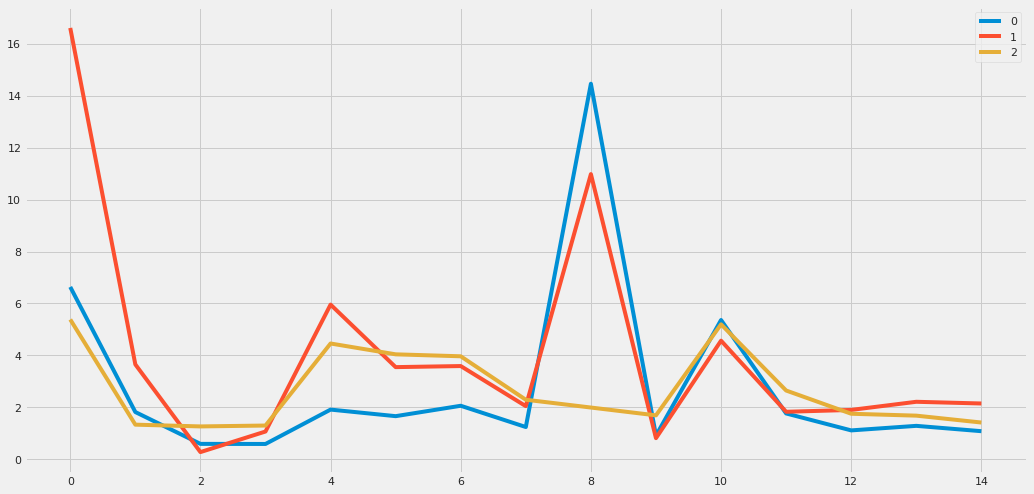

In [62]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame(r0s)
    df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)

In [63]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

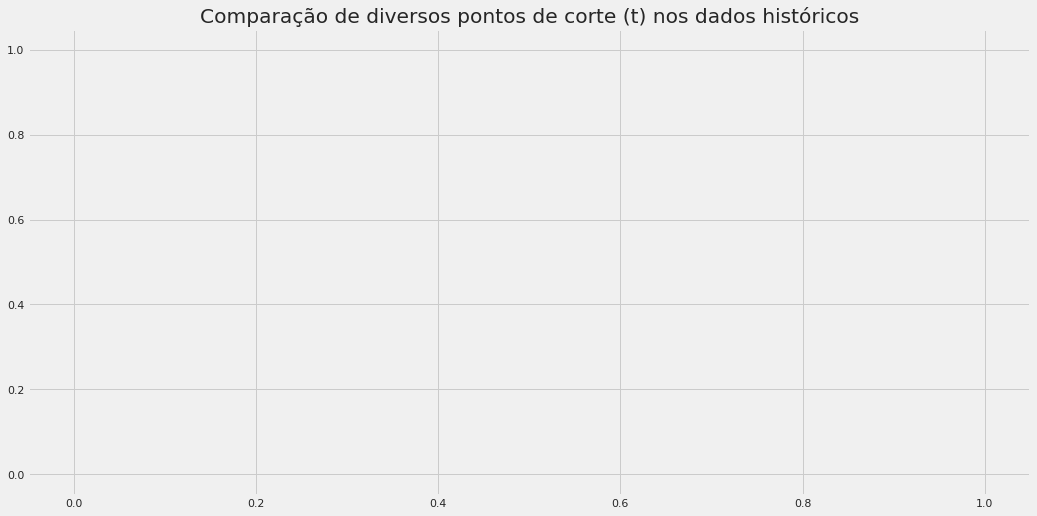

In [64]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 25:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

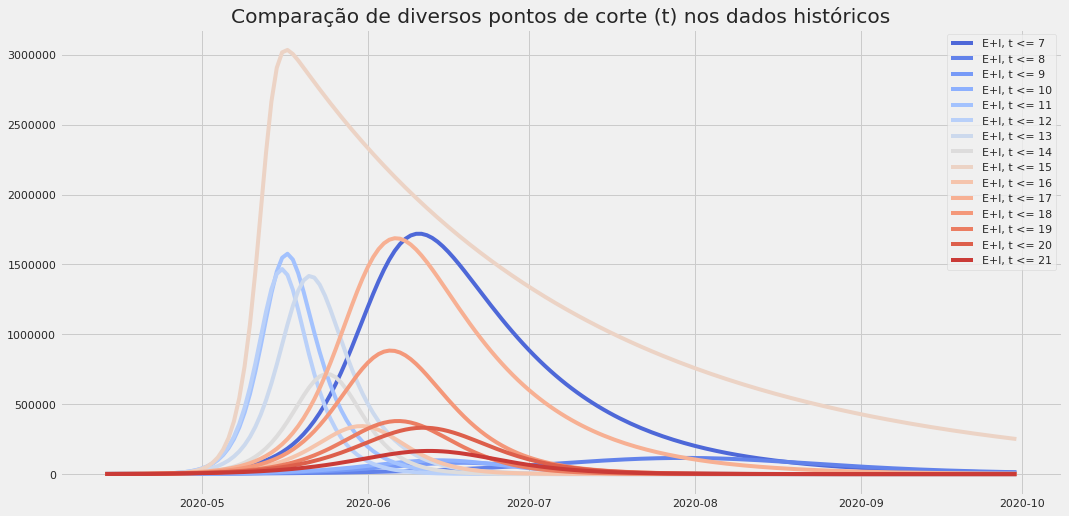

In [65]:
if run_sensitivity_analysis:
    palette = sns.color_palette("coolwarm", len(df.columns))
    ax = sns.lineplot(data=df, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [66]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.